<a href="https://colab.research.google.com/github/KashyapCKotak/AI-ML-experiments/blob/master/Playground-StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock Prediction model with Tensorflow 2.0! 

We're going to predict prices of General Electric's stock using a Transformer neural network

## Step 1 - Import data

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler

In [0]:
timestamp,volume,feature0,feature1,feature2,feature3,feature4
2019-04-06 22:58:00+00:00,97550.68801,136722.4161,251782.9237,1294304.437,11378610.79,19949562.94
2019-04-06 22:58:10+00:00,0,1314593.843,236426.9712,5246893.782,9802256.491,19633244.34
2019-04-06 22:58:20+00:00,0,410327.0139,1134659.056,9760047.964,7906650.443,19105697.31
2019-04-06 22:58:30+00:00,378726.2005,532032.0967,6742210.326,9084578.499,6882947.786,19081630.59
2019-04-06 22:58:40+00:00,286913.7883,4989624.084,8913098.4,5154412.356,5996834.65,19379369.5
2019-04-06 22:58:50+00:00,2524841.337,2680679.754,2681730.919,1201141.96,5988089.294,19723660.6
2019-04-06 22:59:00+00:00,1153393.429,1785542.385,904098.1212,395976.5875,7723093.602,20167933.12
2019-04-06 22:59:10+00:00,0,1537993.282,471832.8408,1265726.482,9056521.519,20611768.59
2019-04-06 22:59:20+00:00,0,323608.7604,515241.3989,3895154.419,8934081.335,20981727.24
2019-04-06 22:59:30+00:00,0,300291.5729,967456.2433,6639222.511,9101329.59,22245969.45
2019-04-06 22:59:40+00:00,0,1036326.411,5224026.196,6327454.768,8397459.856,23839317.84
2019-04-06 22:59:50+00:00,633505.6445,5014756.116,4764541.393,5251545.919,7970637.089,25400949.93
2019-04-06 23:00:00+00:00,0,235964.6924,2077231.445,3531656.078,7995758.179,27144121.73
2019-04-06 23:00:10+00:00,0,2127486.445,3242629.343,2948509.85,8382061.674,29279197.37
2019-04-06 23:00:20+00:00,0,1786251.989,1318032.557,3498212.475,7635756.134,31265644.67
2019-04-06 23:00:30+00:00,430370.6824,1741556.642,1229212.025,4514682.538,7339591.282,32843565.45
2019-04-06 23:00:40+00:00,12624.20668,1061426.256,3691207.971,4718297.848,6043689.617,32850743.76
2019-04-06 23:00:50+00:00,0,2280179.69,3122453.801,4854119.813,4618036.557,32803167.27
2019-04-06 23:01:00+00:00,0,1755493.983,2175688.295,4427227.673,5353342.801,32903615.82
2019-04-06 23:01:10+00:00,0,1295603.778,4952098.619,2887728.177,7649779.221,33289167.68
2019-04-06 23:01:20+00:00,4165988.206,2592613.219,1902955.023,1018126.24,9958140.782,33734354.07
2019-04-06 23:01:30+00:00,168705.3075,421586.9533,792665.5845,626596.2044,12767255.48,33054590.57
2019-04-06 23:01:40+00:00,280027.8573,453855.0633,554765.1519,1295246.728,15245270.64,30091391.31
2019-04-06 23:01:50+00:00,0,1660775.585,582972.7981,5791338.02,14278566.02,27146740.93
2019-04-06 23:02:00+00:00,0,480898.9968,1504451.303,11367188.91,14982149.52,24201162.21
2019-04-06 23:02:10+00:00,29839.03398,1592348.986,5997352.494,13837418.37,16617466.53,21265500.77
2019-04-06 23:02:20+00:00,289209.0986,1165710.695,14346830.29,7931379.457,18308598.15,18392868.48
2019-04-06 23:02:30+00:00,11903479.25,7692330.746,6032885.267,2325960.335,20204405.05,15618897.86
2019-04-06 23:02:40+00:00,0,1221343.787,338734.3296,1161144.539,23404433.8,13614717.97
2019-04-06 23:02:50+00:00,0,748634.6182,712969.0576,9052542.783,20443819.69,12137254.35
2019-04-06 23:03:00+00:00,0,1418169.491,611265.0984,18279394.98,15655918.49,10760871.63
2019-04-06 23:03:10+00:00,550874.4735,1427514.086,10569513.38,20444896.88,10885536.04,9309997.58
2019-04-06 23:03:20+00:00,0,4317470.863,22354900.22,11177646.62,6059077.59,7867822.524
2019-04-06 23:03:30+00:00,17771440.04,9443266.885,6141647.925,2485534.246,1575620.517,6312697.781
2019-04-06 23:03:40+00:00,0,1395086.97,805000.2073,758966.3875,835469.2225,6180770.884
2019-04-06 23:03:50+00:00,63121.03342,1593540.325,981700.0099,597638.9656,1208071.239,6397286.796
2019-04-06 23:04:00+00:00,533659.6462,560021.1674,790397.8388,451462.4576,1706597.912,7837734.415
2019-04-06 23:04:10+00:00,2295.310306,1107329.461,732897.167,371247.296,2319898.78,10290029.44
2019-04-06 23:04:20+00:00,0,1088961.312,485616.4914,396297.1998,2908354.726,12536427.48
2019-04-06 23:04:30+00:00,0,1229667.953,243025.8679,817267.558,3182765.971,14909423.72
2019-04-06 23:04:40+00:00,0,322808.7367,240416.3034,1857133.214,3078446.791,17645247.43
2019-04-06 23:04:50+00:00,0,515561.7342,944939.999,2415766.518,2851481.907,20470406.57
2019-04-06 23:05:00+00:00,10328.89638,1275856.646,1773099.765,2405491.229,2523036.849,23786194.72
2019-04-06 23:05:10+00:00,45906.20612,540915.8118,2252448.081,1463111.162,2225283.138,27257915.1
2019-04-06 23:05:20+00:00,1972819.208,1173436.098,1018694.674,669662.0341,2438326.396,30682444.9
2019-04-06 23:05:30+00:00,114765.5153,1533326.701,392374.9269,829820.1847,2733979.842,34662765.77
2019-04-06 23:05:40+00:00,114765.5153,711236.6151,602764.8859,1452464.034,2935682.908,39356186.51
2019-04-06 23:05:50+00:00,63121.03342,1135647.834,660937.0594,1575185.79,3433034.593,44954035.34
2019-04-06 23:06:00+00:00,0,163596.6755,1955728.726,1102956.575,3949305.226,49998406.74
2019-04-06 23:06:10+00:00,1262420.668,1550247.195,743490.2386,1167641.88,3778850.486,51651294.61
2019-04-06 23:06:20+00:00,9181.241224,800417.9269,577238.0305,2202504.507,3390484.781,52921785.22
2019-04-06 23:06:30+00:00,0,1160309.442,943431.0392,3249154.671,6044187.21,54213191.22
2019-04-06 23:06:40+00:00,0,592523.0501,3027497.613,2635836.213,11021635.19,54817058.79
2019-04-06 23:06:50+00:00,2234484.583,2131064.462,1737437.109,1818482.333,16011969.26,55360489.59
2019-04-06 23:07:00+00:00,20657.79275,296979.8521,1011879.132,1007508.678,21613195.66,54986665.36
2019-04-06 23:07:10+00:00,25248.41337,955902.6507,1412744.031,756192.2807,28277089.08,53413548.01
2019-04-06 23:07:20+00:00,0,1809617.137,651618.9793,6911047.218,29203898.59,51946085.01
2019-04-06 23:07:30+00:00,0,698461.6243,738776.7654,18233617.51,27261397.51,50612655.16
2019-04-06 23:07:50+00:00,356920.7526,1175554.004,25166449.32,17430133.92,23718223.17,43874219.73
2019-04-06 23:08:00+00:00,16614603.65,14483352.52,13629103.87,8544408.919,21084848.78,38769820.25
2019-04-06 23:08:10+00:00,0,887213.1829,560263.2885,6557234.864,22388093.38,35039754.16
2019-04-06 23:08:20+00:00,0,585464.8971,4472822.223,10667637.92,24089034.2,32539604.86
2019-04-06 23:08:30+00:00,229531.0306,4388155.862,5014936.056,14075655.33,25167931.58,30150169.7
2019-04-06 23:08:40+00:00,45906.20612,581160.4459,8148118.842,12767751.14,26668336.74,27838435.06
2019-04-06 23:08:50+00:00,1262420.668,3327869.177,13107532.46,9071908.414,26513178.03,26014491.06
2019-04-06 23:09:00+00:00,9077952.261,5795126.937,3584963.026,9566890.277,23512385.93,24026758.6
2019-04-06 23:09:10+00:00,0,1697561.32,2338748.724,17539226.59,18435089.01,22912131.78
2019-04-06 23:09:20+00:00,0,591854.8777,10952408.9,19794295.7,13724153.9,22144197.74
2019-04-06 23:09:30+00:00,6524419.545,7509420.382,14317534.74,14389074.54,9248960.21,20973105.61
2019-04-06 23:09:40+00:00,22953.10306,5689836.731,12322335.09,6092331.634,5972358.872,20711738.98
2019-04-06 23:09:50+00:00,5738275.765,4674855.115,2533341.301,1072869.476,4548475.203,21130300.63
2019-04-06 23:10:00+00:00,200839.6518,1314919.156,542192.41,726574.7166,5956288.326,23841245.76
2019-04-06 23:10:10+00:00,0,723101.5379,588228.1968,2031915.212,6852393.499,28645056.57
2019-04-06 23:10:20+00:00,78040.55041,1729748.364,947637.193,3583641.422,7696123.876,34187210.2
2019-04-06 23:10:30+00:00,0,663827.3062,2225571.573,3931504.095,8588771.913,40059867.65
2019-04-06 23:10:40+00:00,104436.6189,1637449.051,4439916.225,2744800.24,9347324.773,46368601.75
2019-04-06 23:10:50+00:00,3672496.49,3460035.58,1640665.646,3283215.237,9038005.614,52571468.72
2019-04-06 23:11:00+00:00,28691.37883,1370189.159,94070.33467,5611738.784,8792441.053,58435567.74
2019-04-06 23:11:10+00:00,0,1426589.665,3726379.922,6238019.4,8018156.39,64765906.05
2019-04-06 23:11:20+00:00,80335.86071,3722705.086,4808123.007,5194221.971,8104830.041,71802275.94
2019-04-06 23:11:30+00:00,981245.1559,1681573.147,3112433.933,3299047.169,7954372.711,78958804.09
2019-04-06 23:11:40+00:00,1006493.569,2185063.69,2179233.89,3624886.696,7683241.4,86234232.81
2019-04-06 23:11:50+00:00,48201.51643,894420.5075,1386045.714,4403016.066,7890049.857,92558809.18
2019-04-06 23:12:00+00:00,0,1066751.853,3907026.365,3819293.297,9021743.289,97632513.07
2019-04-06 23:12:10+00:00,2639606.852,2911563.223,3701254.731,3561864.372,10299639.12,98792619.5
2019-04-06 23:12:20+00:00,2476639.82,2950302.837,1539068.573,4608581.903,12475888.49,96603294
2019-04-06 23:12:30+00:00,0,1543635.941,2324941.745,5413359.815,18918001.93,93277780.64
2019-04-06 23:12:40+00:00,107879.5844,1209416.147,5931581.029,4105124.531,29717629.38,88593589.34
2019-04-06 23:12:50+00:00,5738275.765,3576170.01,2442938.893,3652925.951,42412283.66,83697887.61
2019-04-06 23:13:00+00:00,0,631818.8631,1507161.059,8307183.763,53693681.13,78931221.25
2019-04-06 23:13:10+00:00,0,1555398.562,4225208.394,13082654.3,64176785.16,74269066.84
2019-04-06 23:13:20+00:00,2662559.955,2654705.799,7138781.052,21959337.96,67345021.17,68073943.92
2019-04-06 23:13:30+00:00,1143064.532,1030541.527,12886928.12,34768171.31,60894883.38,61154784.82
2019-04-06 23:13:40+00:00,12050379.11,7598587.064,14433452.42,46335659.54,50017594.01,53023408.02
2019-04-06 23:13:50+00:00,0,6303054.154,31593068.06,45294168.79,39975791.88,45194122.4
2019-04-06 23:14:00+00:00,10615810.17,14023828.5,34812546.87,31068363.28,30231522.51,37026152.45
2019-04-06 23:14:10+00:00,13122289.02,12055830.04,18923455.12,18287170.5,24958838.43,30608572.48
2019-04-06 23:14:20+00:00,4690466.611,3671330.91,12385157.52,9208991.505,25339557.63,26395970.13
2019-04-06 23:14:30+00:00,6250129.963,6952236.529,6466529.28,6208838.568,27445665.99,23319986.86
2019-04-06 23:14:40+00:00,0,1140822.742,2468401.168,9150276.068,27129530.42,21036857.97
2019-04-06 23:14:50+00:00,1606717.214,2614949.936,2493900.33,16253004.27,25119881.99,19479963.91
2019-04-06 23:15:00+00:00,929600.674,1053718.044,10237780.65,18169045.14,21003168.94,18109115.7
2019-04-06 23:15:10+00:00,592190.059,7269654.378,12136902.99,17597426.68,15203058.9,17090502.27
2019-04-06 23:15:20+00:00,52792.13704,1019917.435,10972966.82,12516098.03,9372248.093,16070479.23
2019-04-06 23:15:30+00:00,5956330.244,6168026.4,8330249.211,9170846.695,5546366.948,15918373.27
2019-04-06 23:15:40+00:00,0,417124.8661,6914197.499,4463892.753,3354547.31,17235177.07
2019-04-06 23:15:50+00:00,6082572.311,4413588.523,3791133.541,1544241.712,2669999.662,19468355.27
2019-04-06 23:16:00+00:00,803358.6071,731998.1503,736862.0043,358791.2427,2979996.356,22151392.46
2019-04-06 23:16:10+00:00,0,460737.8422,274098.8322,456222.1546,3478387.486,24623483.26
2019-04-06 23:16:20+00:00,50496.82673,161845.0841,327734.8913,871693.0166,3920785.572,26489025.02
2019-04-06 23:16:30+00:00,0,941490.1779,405967.2354,1986444.41,3776733.534,28377787.23
2019-04-06 23:16:40+00:00,0,1110314.475,1217758.176,2832594.081,4105029.439,30210195.5
2019-04-06 23:16:50+00:00,705807.9191,940325.1704,2056935.322,3218845.422,4671958.974,31321300.56
2019-04-06 23:17:00+00:00,172148.273,732963.0422,2671730.82,2233922.101,5351521.735,32102387.93
2019-04-06 23:17:10+00:00,1387515.08,1736513.815,2081989.774,1036618.484,6524764.351,32092495.9
2019-04-06 23:17:20+00:00,344296.5459,1979264.305,454490.4186,621944.7615,8669027.809,31929164.12
2019-04-06 23:17:30+00:00,91812.41224,1890660.401,369716.0039,2785856.099,9764477.568,31873653.17
2019-04-06 23:17:40+00:00,80335.86071,1162731.117,519616.2755,5483096.111,11077994.43,30731118.83
2019-04-06 23:17:50+00:00,114765.5153,870670.2473,3348358.237,6201486.916,12479153.75,27993559.63
2019-04-06 23:18:00+00:00,9181.241224,2132106.84,6706149.055,4487909.042,13407409.38,25194853.88
2019-04-06 23:18:10+00:00,4353055.996,3852322.076,2630652.831,4309365.134,15057880.23,22394804.55
2019-04-06 23:18:20+00:00,0,1459788.319,1044755.4,7092147.052,17674786.24,20163282.34
2019-04-06 23:18:30+00:00,0,1558288.489,4542736.174,8755085.564,18929033.54,18279125.43
2019-04-06 23:18:40+00:00,1147655.153,4370259.223,4803942.859,8700639.541,20109645.02,16387747.24
2019-04-06 23:18:50+00:00,0,1318576.23,6057564.796,5959724.027,21025313.03,14685680.81
2019-04-06 23:19:00+00:00,1133883.291,4062546.909,4901027.234,8184091.755,18269231.11,13404071.38
2019-04-06 23:19:10+00:00,573827.5765,976945.4896,624425.3389,14002693.82,13747404.58,12406275.11
2019-04-06 23:19:20+00:00,0,916676.5112,7250466.036,16582173.88,9771352.888,11918765.07
2019-04-06 23:19:30+00:00,0,5085235.477,15040647.15,10499510.34,5799229.621,11432508.34
2019-04-06 23:19:40+00:00,5854188.936,6412954.472,7127572.296,3412920.792,2223966.278,11057912.06
2019-04-06 23:19:50+00:00,0,1928064.71,1182045.372,793666.5406,804204.5227,11575685.97
2019-04-06 23:20:00+00:00,110174.8947,296876.0361,410219.2654,488069.2921,582587.2313,12040334.48
2019-04-06 23:20:10+00:00,0,1439906.107,407030.5465,569069.5194,562683.0027,12740063.34
2019-04-06 23:20:20+00:00,0,334677.678,844770.68,510718.1337,836676.4284,13572383.54
2019-04-06 23:20:30+00:00,406269.9242,1227135.237,356245.288,285165.4755,1939758.231,14843713.47
2019-04-06 23:20:40+00:00,9181.241224,1312674.993,538795.7137,341874.1105,3018950.711,16723759.88
2019-04-06 23:20:50+00:00,0,407463.7531,625878.9048,279097.8109,4505987.897,18527757.31
2019-04-06 23:21:00+00:00,59678.06796,1754780.404,376996.6593,476472.8891,6589568.824,20314799.3
2019-04-06 23:21:10+00:00,0,1738279.75,718614.9407,995330.121,8158667.053,22767125.16
2019-04-06 23:21:20+00:00,20657.79275,1272852.769,801837.0196,3028791.216,8196605.254,25410716.16
2019-04-06 23:21:30+00:00,192806.0657,1737659.762,444305.6861,4965778.502,8281809.061,28675734.48
2019-04-06 23:21:40+00:00,18362.48245,1564191.648,3854259.043,4971452.044,7620141.605,32011330.64
2019-04-06 23:21:50+00:00,75745.2401,3676256.513,3975668.296,4893063.211,6199788.675,35321015.98
2019-04-06 23:22:00+00:00,0,699466.4283,1052708.684,5172400.767,4801290.514,39110333.37
2019-04-06 23:22:10+00:00,0,510560.2899,4333741.47,4164326.795,4146903.965,43611782.03
2019-04-06 23:22:20+00:00,1801818.59,4172050.723,3596398.256,2136092.635,3466696.068,48938420.3
2019-04-06 23:22:30+00:00,0,1527361.339,1463709.759,1121407.04,3208938.887,53334965.3
2019-04-06 23:22:40+00:00,711546.1949,1143061.455,931689.2619,1686815.653,3779649.207,55801003.71
2019-04-06 23:22:50+00:00,83778.82617,931675.8636,603086.8189,2533685.523,5030512.468,57801084.92
2019-04-06 23:23:00+00:00,0,1657985.375,2207922.838,1949972.022,8970308.131,59977587.96
2019-04-06 23:23:10+00:00,0,2065265.752,2108608.098,1090341.846,14788776.66,62046735.33
2019-04-06 23:23:20+00:00,70006.96434,1072368.049,382691.2493,943437.7245,20212437.68,63556285.97
2019-04-06 23:23:30+00:00,0,837929.5617,313189.6584,3200472.845,24136747.66,64217710.21
2019-04-06 23:23:40+00:00,144604.5493,193508.0356,609440.339,6773707.209,28618661.55,64419132.51
2019-04-06 23:23:50+00:00,0,803736.6273,4322337.858,12013792.99,28986118.64,64783769.48
2019-04-06 23:24:00+00:00,94107.72255,4364216.061,4356920.838,19931677.43,27263422.13,65511370.78
2019-04-06 23:24:10+00:00,292652.064,1090089.402,9060250.928,21077923.76,25844469.52,64634555.04
2019-04-06 23:24:20+00:00,0,5966419.042,18144225.36,13294987.77,25365765.67,62773928.48
2019-04-06 23:24:30+00:00,2302196.237,7676286.472,9488107.187,7602923.591,22869865.48,59008355.25
2019-04-06 23:24:40+00:00,114765.5153,293719.4876,391111.3874,9554892.571,23466129.95,56356132.35
2019-04-06 23:24:50+00:00,0,1420579.149,4089659.007,16609991.81,25250943.18,54532929.58
2019-04-06 23:25:00+00:00,0,604183.9361,12375009.06,16577570.54,27899662.08,52675790.32
2019-04-06 23:25:10+00:00,11706082.56,7422842.684,12099569.91,9638830.496,30565800.61,51968259.5
2019-04-06 23:25:20+00:00,18362.48245,7190611.644,8184618.601,5722435.495,33150728.01,51140664.53
2019-04-06 23:25:30+00:00,100993.6535,537053.9412,721852.9502,9495034.027,31774737.17,49381902.6
2019-04-06 23:25:40+00:00,0,1736708.618,274815.4611,22294019.77,27524163.77,48104319.15
2019-04-06 23:25:50+00:00,0,481229.2086,12491608.38,25998591.08,23474026.94,46908448.32
2019-04-06 23:26:00+00:00,342001.2356,10658553.18,18707115.52,22061936.62,20447590.47,45018856.9
2019-04-06 23:26:10+00:00,0,1649676.466,18432921.42,9298338.089,18352287.24,42911249.75
2019-04-06 23:26:20+00:00,17233189.78,10347112.05,6452275.742,2952314.406,18539945.5,41144554.45
2019-04-06 23:26:30+00:00,0,1554727.298,549064.3521,3506407.563,20737865.2,40466092.79
2019-04-06 23:26:40+00:00,0,1230216.272,1378072.942,9475212.858,20827010.52,40503846.35
2019-04-06 23:26:50+00:00,0,1044323.413,3916482.23,15550361.72,19283987.97,40944037.96
2019-04-06 23:27:00+00:00,2726828.644,1627873.48,9737635.379,15068718.69,17713401.75,41884431.82
2019-04-06 23:27:10+00:00,2363021.96,5635226.892,13330412.46,9057839.448,15972606.27,41773799.44
2019-04-06 23:27:20+00:00,3414274.08,6315754.469,5371653.264,5849134.514,13280054.66,39033915.47
2019-04-06 23:27:30+00:00,0,1771687.538,753939.7782,8381851.263,10841490.97,37522676.93
2019-04-06 23:27:40+00:00,0,743018.4787,4946132.919,9836728.71,12549181.54,36834010.56
2019-04-06 23:27:50+00:00,527921.3704,3418238.422,7084022.035,8383087.957,15464381.64,36400792.87
2019-04-06 23:28:00+00:00,45906.20612,1511666.433,7102979.678,4112580.206,18589129.48,36489648.83
2019-04-06 23:28:10+00:00,4621607.301,4627643.876,2648570.963,1874533.205,22313785.71,36863946.47
2019-04-06 23:28:20+00:00,0,513256.0189,369956.8466,2126593.545,26876385.79,37715751.16
2019-04-06 23:28:30+00:00,0,1244472.574,1187029.383,10041465.4,24121817.15,38862237.9
2019-04-06 23:28:40+00:00,114765.5153,1774679.597,1482615.017,19951665.79,19005158.16,39735088.77
2019-04-06 23:28:50+00:00,103288.9638,939136.9155,10749751.78,23647617.68,14001171.48,39879076.61
2019-04-06 23:29:00+00:00,1156836.394,2701181.061,26076509.69,13099436.01,9138507.56,38777369.19
2019-04-06 23:29:10+00:00,24431282.9,13320499.24,8407676.337,3499126.622,4931521.378,37241654.43
2019-04-06 23:29:20+00:00,0,1413635.772,210889.8709,1960758.681,5607902.209,37372476.41
2019-04-06 23:29:30+00:00,14919.51699,1328807.158,1415205.966,2363071.102,8798497.706,38167691.97
2019-04-06 23:29:40+00:00,12624.20668,1002458.836,2150004.354,1819569.56,12122822.89,38302580.28
2019-04-06 23:29:50+00:00,532511.991,1647606.899,1522393.177,1156522.694,15419370.44,37732250.18
2019-04-06 23:30:00+00:00,75745.2401,1198050.829,1139668.951,2653806.059,18150856.61,36086120.28
2019-04-06 23:30:10+00:00,13771.86184,750185.2451,647917.666,6964618.215,19585015.12,34062269.62
2019-04-06 23:30:20+00:00,0,1464060.805,2951405.382,12889339.16,19139226.35,32063972.17
2019-04-06 23:30:30+00:00,475129.2334,1210283.489,7766664.357,14519149.68,19818707.94,29763101.17
2019-04-06 23:30:40+00:00,5870256.108,4923004.091,11480711.05,9580391.549,20566693.22,27441637.19
2019-04-06 23:30:50+00:00,3609375.456,6323235.277,8260948.619,6073678.839,20409096.65,25352838.23
2019-04-06 23:31:00+00:00,1962490.312,2566449.961,1069572.487,7047814.652,19746201.21,23506226.03
2019-04-06 23:31:10+00:00,0,1805880.494,2901215.482,11580401.41,18630412.38,22262531.05
2019-04-06 23:31:20+00:00,0,1086136.364,8662964.974,14112958.56,15169749.13,21032914.65
2019-04-06 23:31:30+00:00,5765819.489,5145632.666,8220319.308,12986025.57,11780713.56,19257899.12
2019-04-06 23:31:40+00:00,2887500.365,3420077.254,9256975.515,8657557.736,8888518.242,16907694.16
2019-04-06 23:31:50+00:00,143456.8941,4950929.598,6544855.434,5042684.568,6427903.818,14722235.72
2019-04-06 23:32:00+00:00,488901.0952,699456.7814,938763.0433,3580817.798,6068175.982,12989113.98
2019-04-06 23:32:10+00:00,0,770577.7337,3162550.053,3403201.462,7284829.299,11867964.22
2019-04-06 23:32:20+00:00,1133883.291,2438706.624,2405278.982,2868890.876,8383701.473,10990822.74
2019-04-06 23:32:30+00:00,135423.3081,521099.657,1483254.033,2469469.047,9751871.053,10303407.53
2019-04-06 23:32:40+00:00,258222.4094,1069121.264,2431989.627,1997588.842,11070330.16,9482421.082
2019-04-06 23:32:50+00:00,2074960.517,1947925.221,1343963.004,3699879.563,10318871.56,8713391.527
2019-04-06 23:33:00+00:00,0,551437.4528,438250.3761,7867303.619,8428181.603,8118933.777
2019-04-06 23:33:10+00:00,0,1269281.817,4110918.376,9503772.773,6700082.812,7661204.125
2019-04-06 23:33:20+00:00,0,2291052.237,8373728.925,6320839.599,5010570.034,7255343.333
2019-04-06 23:33:30+00:00,1861496.658,4057793.985,4589585.913,2340771.736,3508087.738,6956371.244
2019-04-06 23:33:40+00:00,47053.86127,730288.4902,806219.247,613052.4656,2966006.195,7116380.742
2019-04-06 23:33:50+00:00,0,448071.2033,661400.7662,1075567.138,2748464.445,7608006.111
2019-04-06 23:34:00+00:00,0,429801.9317,685982.8512,2179119.099,2144275.22,8125005.115
2019-04-06 23:34:10+00:00,32134.34429,859308.7115,1237359.342,2683597.748,1476080.933,8586725.31
2019-04-06 23:34:20+00:00,573827.5765,922863.7835,2517076.873,1765290.676,851136.1438,9979140.194
2019-04-06 23:34:30+00:00,1147655.153,2649517.124,1641954.507,571033.3391,328622.7348,11308982.96
2019-04-06 23:34:40+00:00,117060.8256,929331.8083,542235.7962,139175.6977,250183.1768,12687835.06
2019-04-06 23:34:50+00:00,0,1246537.015,370870.5259,194764.1426,1053704.593,14337034.47
2019-04-06 23:35:00+00:00,0,830994.5936,121579.3871,136677.38,2310699.1,15990773.81
2019-04-06 23:35:10+00:00,0,332228.2222,213760.683,142364.5354,3556957.337,17589965.85
2019-04-06 23:35:20+00:00,0,676103.4156,259388.7567,382066.0966,4900006.863,19059077.85
2019-04-06 23:35:30+00:00,0,1289802.631,479464.1662,612110.6705,6204285.776,20499048.28
2019-04-06 23:35:40+00:00,0,1010971.952,483248.7766,2082535.352,6485680.028,22096722.73
2019-04-06 23:35:50+00:00,0,1134986.065,818856.3771,4105812.054,5966752.221,23971314.59
2019-04-06 23:36:00+00:00,344296.5459,940756.5933,2249822.048,5289534.795,5435375.147,25939123.59
2019-04-06 23:36:10+00:00,21805.44791,1700322.796,5454361.666,3945054.435,4603676.035,27940732.59
2019-04-06 23:36:20+00:00,4046632.07,3311082.833,2999977.298,2089820.853,3649414.426,29194926.91
2019-04-06 23:36:30+00:00,789586.7453,1304330.403,940875.4306,2063544.897,2752408.486,28317085.79
2019-04-06 23:36:40+00:00,0,1479345.269,1474257.292,2228922.998,2170638.054,27744545.49
2019-04-06 23:36:50+00:00,1147655.153,1906294.703,1429357.447,2263900.269,4274135.884,27129829.9
2019-04-06 23:37:00+00:00,0,775766.5623,2299153.041,1377181.962,7842075.743,26549829.51
2019-04-06 23:37:10+00:00,1740992.867,2289486.851,1034321.198,674393.1354,11469998.8,26076552.84
2019-04-06 23:37:20+00:00,11476.55153,1007995.581,458789.1147,345759.7125,16082058.89,25598625.87
2019-04-06 23:37:30+00:00,355773.0974,1635395.235,192598.2884,304652.5083,20987639.4,25115691.78
2019-04-06 23:37:40+00:00,0,1432932.313,502490.8844,5885490.2,20533291.78,24690011
2019-04-06 23:37:50+00:00,0,1573070.44,331810.5356,14234830.11,17687373.34,23907959.38
2019-04-06 23:38:00+00:00,0,1674599.528,6612118.889,18636441.34,14831839.76,22847470.48
2019-04-06 23:38:10+00:00,11476.55153,890115.2006,19577009.5,12205939.07,11411045.51,21946129.45
2019-04-06 23:38:20+00:00,16080944,10125394.23,8050972.345,5797061.744,8021439.324,21361424.9
2019-04-06 23:38:30+00:00,0,653021.3716,1407153.043,4659365.542,7307424.088,21980932.72
2019-04-06 23:38:40+00:00,0,1644914.702,4527613.191,3843414.643,7593757.652,22929938.9
2019-04-06 23:38:50+00:00,3618556.698,2279434.712,2869337.099,2492257.978,7850363.826,23413605.06
2019-04-06 23:39:00+00:00,900909.2951,1577104.216,1533810.91,2506706.219,7597374.737,23846322.77
2019-04-06 23:39:10+00:00,20657.79275,1848308.065,1249615.972,4291071.331,7062770.845,23495917.31
2019-04-06 23:39:20+00:00,0,412603.1609,1498648.803,5862097.498,6406057.315,23138979.27
2019-04-06 23:39:30+00:00,0,1747546.131,5066407.975,5373211.031,6942065.622,22928619.39
2019-04-06 23:39:40+00:00,3615113.732,2615873.552,5083350.518,2950221.657,7924039.129,22568061.05
2019-04-06 23:39:50+00:00,3368367.874,2701000.524,2157945.657,1064701.872,9427637.159,22018946.34
2019-04-06 23:40:00+00:00,59678.06796,1940231.845,822721.6182,1787329.937,10388043.33,21482023.05
2019-04-06 23:40:10+00:00,151490.4802,188399.4414,541402.3277,3571503.423,11486206.23,20507295.26
2019-04-06 23:40:20+00:00,0,605557.2947,1891692.624,6643600.982,10923178.19,19297325.01
2019-04-06 23:40:30+00:00,0,1370155.789,4647530.06,8200548.277,9720560.051,17567896.8
2019-04-06 23:40:40+00:00,3904322.831,2406092.269,4686012.526,8093607.809,9185838.99,16096603.99
2019-04-06 23:40:50+00:00,0,1626489.64,8125361.303,4693344.006,10061214.77,15551719.55
2019-04-06 23:41:00+00:00,5757785.903,4631404.954,3478770.529,2417875.624,10551012.29,14943367.39
2019-04-06 23:41:10+00:00,11476.55153,463433.2708,715571.8047,3284453.732,11207905.78,14819820.32
2019-04-06 23:41:20+00:00,0,577179.0098,1634076.055,5334368.183,11718911.8,14901785.47
2019-04-06 23:41:30+00:00,11476.55153,575760.393,4349803.176,6219151.753,11309321.7,14954748.73
2019-04-06 23:41:40+00:00,3028661.949,2270963.739,4020571.521,7219908.519,9176464.961,14976403.85
2019-04-06 23:41:50+00:00,2175954.17,2349638.318,4258245.684,7364161.254,6949358.008,15185026.58
2019-04-06 23:42:00+00:00,117060.8256,3515606.842,4990192.545,6628580.049,5314742.931,15564687.55
2019-04-06 23:42:10+00:00,0,237716.3687,6310227.933,3393217.694,3852285.584,16195933.28
2019-04-06 23:42:20+00:00,5738275.765,3088057.221,2107892.844,1919000.679,2454101.636,17278485.65
2019-04-06 23:42:30+00:00,34429.65459,1692418.19,375316.3793,1854111.798,2032069.997,18531462.1
2019-04-06 23:42:40+00:00,131980.3426,1169706.33,1895697.892,1524633.527,1789943.153,20138510.7
2019-04-06 23:42:50+00:00,51644.48189,1202002.123,1466368.17,1004225.762,1615732.095,20494516.04
2019-04-06 23:43:00+00:00,0,344700.522,580646.7031,901531.7859,1895758.006,20496346.31
2019-04-06 23:43:10+00:00,0,296417.7425,842858.0942,1182549.244,3062110.078,20663383.09
2019-04-06 23:43:20+00:00,252484.1337,1490126.066,1164598.026,953840.6702,5869969.616,20904413.11
2019-04-06 23:43:30+00:00,462505.0267,1179610.269,927141.3602,518562.4837,8985170.472,21455554.11
2019-04-06 23:43:40+00:00,18362.48245,1282356.426,788409.7563,830026.3049,11907437.63,22334760.36
2019-04-06 23:43:50+00:00,73449.9298,1253855.865,275565.9923,2076725.272,14049327.79,23150401.4
2019-04-06 23:44:00+00:00,0,1819105.537,612825.7856,4706652.483,14990758.78,24274030.83
2019-04-06 23:44:10+00:00,0,1672931.997,2552651.675,8672011.88,12555624.93,25474527.51
2019-04-06 23:44:20+00:00,803358.6071,1728700.788,3152996.49,11935656.91,9884770.092,26201845.76
2019-04-06 23:44:30+00:00,169852.9627,2273822.677,8354913.576,9828002.957,6843726.224,27237801.31
2019-04-06 23:44:40+00:00,644982.196,4936820.173,8649754.155,5597761.641,4500019.731,27652406.09
2019-04-06 23:44:50+00:00,2312525.133,2368189.857,2284481.293,1932458.007,3204249.056,28023693.39
2019-04-06 23:45:00+00:00,0,2464561.14,1334572.51,1343271.139,3802529.974,28931382.18
2019-04-06 23:45:10+00:00,0,1464751.837,779931.61,1169580.812,5664372.136,29573246.11
2019-04-06 23:45:20+00:00,0,860194.8571,1162579.555,1155504.194,7800183.811,30244313.08
2019-04-06 23:45:30+00:00,549726.8183,1060420.31,988277.2931,1177833.784,10029454.21,30488740.35
2019-04-06 23:45:40+00:00,182477.1693,1361080.477,557887.8388,2610300.262,11786734.62,29824897.03
2019-04-06 23:45:50+00:00,0,1373620.056,478875.7834,4911677.838,13247886.18,28957167.64
2019-04-06 23:46:00+00:00,0,205700.0966,3118772.819,7074912.659,13412847.98,27928104.14
2019-04-06 23:46:10+00:00,275437.2367,3471047.135,3359863.592,8364280.606,14483807.45,26414849.8
2019-04-06 23:46:20+00:00,57382.75765,1882996.635,5508476.656,6788174.145,14600972.71,25125033.64
2019-04-06 23:46:30+00:00,20657.79275,4816058.246,5786716.381,6108461.461,14929889.02,24083150.85
2019-04-06 23:46:40+00:00,16067.17214,520332.7439,1961097.523,6254260.098,15036570.71,22489623.16
2019-04-06 23:46:50+00:00,0,237647.6667,5429943.399,7640038.291,14591337.2,21464554.46
2019-04-06 23:47:00+00:00,3965148.554,3709097.159,4744033.098,8943890.232,13227695,21107717.5
2019-04-06 23:47:10+00:00,2762405.953,2603060.927,4059187.229,9159872.521,12666950.72,21477900.46
2019-04-06 23:47:20+00:00,952553.777,1998701.302,7299158.738,7480958.166,11181357.72,21653584.17
2019-04-06 23:47:30+00:00,1514904.802,5244983.704,4790336.929,5855091.959,9708555.271,21919398.38
2019-04-06 23:47:40+00:00,0,1570248.648,2166145.699,4926712.658,9355570.406,22988007.97
2019-04-06 23:47:50+00:00,0,2063822.294,5162235.861,5012581.015,8746679.564,24486599
2019-04-06 23:48:00+00:00,4538976.13,3644786.139,1920252.619,5727096.534,7680755.086,26340820.19
2019-04-06 23:48:10+00:00,0,1369772.684,3219862.687,6052787.523,7398482.904,28425007.56
2019-04-06 23:48:20+00:00,263960.6852,931826.8092,7005183.283,3498276.056,7242769.722,30449595.06
2019-04-06 23:48:30+00:00,5738275.765,3207167.49,2474435.657,1767151.95,6521001.128,31810091.14
2019-04-06 23:48:40+00:00,0,1236373.438,199557.9886,3624578.066,5559129.119,33273071.2
2019-04-06 23:48:50+00:00,0,728908.2122,1131673.505,5733488.401,5069624.273,34829713.46
2019-04-06 23:49:00+00:00,49349.17158,1825111.078,4858693.793,4506471.69,5542009.422,35567624.81
2019-04-06 23:49:10+00:00,1147655.153,3441638.836,4097871.176,1961017.242,6066419.349,34854654.72
2019-04-06 23:49:20+00:00,1145359.843,1674286.173,669420.5793,857300.1982,6894573.131,33648727.58
2019-04-06 23:49:30+00:00,0,1213795.009,632105.479,1510841.247,9728555.978,32627640.69
2019-04-06 23:49:40+00:00,22953.10306,1408073.313,671996.3529,2870857.19,13373908.6,30855113.39
2019-04-06 23:49:50+00:00,0,1597314.12,1803149.399,4977083.458,15664289.72,28859359.88
2019-04-06 23:50:00+00:00,1242910.531,1701654.041,2037458.369,6434632.826,18323410.62,26645812.93
2019-04-06 23:50:10+00:00,1017970.121,1561297.72,4460567.706,5377393.503,21673612.94,23701322.62
2019-04-06 23:50:20+00:00,61973.37826,4545440.488,4737927.011,6856218.708,21901963.33,21179537.31
2019-04-06 23:50:30+00:00,0,1905459.991,917270.9893,11866940,20536384.34,20675182.51
2019-04-06 23:50:40+00:00,0,910112.9626,5535375.65,15355672.85,19516035.53,21072814.24
2019-04-06 23:50:50+00:00,0,4103123.479,12755015.39,12956883.67,17383536.45,21902630.1
2019-04-06 23:51:00+00:00,3586422.353,6483493.049,9117849.993,9508262.175,13554824.17,22928094.01
2019-04-06 23:51:10+00:00,2863399.607,3402106.831,3759184.435,8342782.745,11349442.52,24607470.65
2019-04-06 23:51:20+00:00,1147655.153,2020943.82,6192227.017,7786817.456,8674951.631,27056706.52
2019-04-06 23:51:30+00:00,1496542.32,3996587.882,5660536.257,7038821.402,5894715.173,29840846.05
2019-04-06 23:51:40+00:00,527921.3704,1658966.449,2987133.027,6308254.589,3629740.834,33675140.02
2019-04-06 23:51:50+00:00,0,1516711.565,7009711.107,3540829.574,2521081.063,38914963.22
2019-04-06 23:52:00+00:00,6436050.098,3905848.19,2875995.106,953427.987,1732718.601,44165020.5
2019-04-06 23:52:10+00:00,49349.17158,1500462.17,261378.8206,398095.4744,2167520.518,49760431.91
2019-04-06 23:52:20+00:00,0,1209299.298,701901.2094,538339.3868,2963353.006,55494026.07
2019-04-06 23:52:30+00:00,0,1351490.437,447192.3934,808719.6883,3851794.292,59409854.59
2019-04-06 23:52:40+00:00,0,1246536.624,905756.7154,886771.4082,4514469.42,60812179.82
2019-04-06 23:52:50+00:00,22953.10306,1283338.159,698817.1606,1408854.557,5192054.852,61837546.06
2019-04-06 23:53:00+00:00,64268.68857,1289100.916,186905.0282,2646025.634,10011413.92,62271954.76
2019-04-06 23:53:10+00:00,0,1168612.293,2098593.234,3238174.647,15975125.09,63063339.2
2019-04-06 23:53:20+00:00,22953.10306,1235185.861,2352326.243,3379439.753,22592162.92,63760316.14
2019-04-06 23:53:30+00:00,34429.65459,352146.1303,2481602.514,2261917.446,29796091.67,64507094.48
2019-04-06 23:53:40+00:00,1651475.765,2130297.395,1875765.649,2583290.348,35984694.12,64251767.28
2019-04-06 23:53:50+00:00,229531.0306,1267815.864,915421.4675,12467766.43,33604917.17,61463805.18
2019-04-06 23:54:00+00:00,2295.310306,1580023.879,971684.2125,25390746.74,29687361.74,57435203.76
2019-04-06 23:54:10+00:00,0,904853.2112,14890577.09,30054170.14,26441597.58,53453896.07
2019-04-06 23:54:20+00:00,1183232.463,6093987.237,29076081.41,20063572.61,25511836.99,49443406.25
2019-04-06 23:54:30+00:00,20368583.66,11929956.03,11188430.55,9337113.372,25589107.09,45497078.64
2019-04-06 23:54:40+00:00,546283.8529,2212892.254,7348086.69,4762773.868,29281993.22,42212865.8
2019-04-06 23:54:50+00:00,5809430.385,4846406.811,2639296.06,5060304.424,32508968.4,38999862.57
2019-04-06 23:55:00+00:00,0,123409.0263,1205902.658,11794883.5,32323772.98,36407570.36
2019-04-06 23:55:10+00:00,0,351136.84,4696958.864,22576281.06,27790430.7,33741821.59
2019-04-06 23:55:20+00:00,2926520.64,2846411.365,11157128.24,27290368.67,22560493.56,31106965.03
2019-04-06 23:55:30+00:00,3038990.845,5884292.371,21178808.95,19749845.53,18176232.35,29408254.72
2019-04-06 23:55:40+00:00,6359157.203,9446001.96,17064706.02,7959999.807,15579041.05,27212187.52
2019-04-06 23:55:50+00:00,7388603.875,4223771.443,2853182.419,2857698.022,14119078.17,26494022.06
2019-04-06 23:56:00+00:00,0,1667211.012,363738.157,6553315.498,14300474,27390758.58
2019-04-06 23:56:10+00:00,4590.620612,1212620.981,2085423.786,10249938.56,15213478.54,28797536.4
2019-04-06 23:56:20+00:00,672525.9197,1377565.472,8085117.551,8695382.638,15565038.06,31366341.53
2019-04-06 23:56:30+00:00,2319411.064,6395450.238,7679662.451,6487444.419,14198756.7,34025393.63
2019-04-06 23:56:40+00:00,1870677.899,1619066.163,1252649.012,5871329.272,13479578.57,37300887.83
2019-04-06 23:56:50+00:00,0,458786.2617,4164030.766,7670377.302,11205019.32,42234252.25
2019-04-06 23:57:00+00:00,63121.03342,3878573.27,4409901.477,9230595.825,7897306.338,47013671.43
2019-04-06 23:57:10+00:00,166409.9972,1508047.845,3987910.975,9432572.395,4938445.439,51292091.18
2019-04-06 23:57:20+00:00,18362.48245,221405.404,10588005.46,5484271.482,2794757.929,56179900.15
2019-04-06 23:57:30+00:00,9784907.835,6218997.131,3808647.129,1344110.773,1343046.184,59966135.52
2019-04-06 23:57:40+00:00,57382.75765,735704.1642,678102.2751,181115.3984,2614486.178,62637584.26
2019-04-06 23:57:50+00:00,0,1363915.41,261423.6975,147463.9952,5126061.243,65285037.34
2019-04-06 23:58:00+00:00,0,318068.6926,404834.5953,28797.34751,10480690.46,66782048.39
2019-04-06 23:58:10+00:00,0,478282.9917,64812.66085,62410.24454,16487805.82,68216380.01
2019-04-06 23:58:20+00:00,0,112354.1162,194814.7065,1433479.601,22560247.62,67506317.2
2019-04-06 23:58:30+00:00,0,1538661.974,97424.39247,4998163.936,27154180.39,65850302.61
2019-04-06 23:58:40+00:00,0,1002392.35,1812793.806,9357749.95,31136102.19,64304018.93
2019-04-06 23:58:50+00:00,0,785640.4779,6641393.49,15574106.11,32411973.96,61072545.97
2019-04-06 23:59:00+00:00,3475099.803,3957970.441,8321074.753,19008474.23,32568629.17,57852796.92
2019-04-06 23:59:10+00:00,5430704.184,4079148.085,11426830.31,19299568.2,31735048.73,55228559.09
2019-04-06 23:59:20+00:00,236416.9615,4040186.227,17340673.07,15255002.61,32810647.99,51913388.76
2019-04-06 23:59:30+00:00,12276467.17,6404509.95,6608352.531,13067763.83,32842115.07,47309456.8
2019-04-06 23:59:40+00:00,0,1815164.545,10002470.69,16048466.82,30175866.87,43873525.87
2019-04-06 23:59:50+00:00,6869863.746,6340250.222,5364294.254,19562453.93,30560880.9,40582083.62
2019-04-07 00:00:00+00:00,216906.8239,1053926.975,12821539.02,16280284.27,30996460.5,37918979.2
2019-04-07 00:00:10+00:00,0,9636567.664,13962886.75,15266785.04,27212570.76,36014809.59
2019-04-07 00:00:20+00:00,2134638.585,1712484.736,894147.722,16227380.82,24384451.88,34487403.29
2019-04-07 00:00:30+00:00,0,946517.899,12196608.82,13227649.38,24091896.56,34556380.34
2019-04-07 00:00:40+00:00,50496.82673,9441884.192,11723815.68,12237208.64,18866695.59,34733931.77
2019-04-07 00:00:50+00:00,57382.75765,1609052.142,548657.1624,14061281.2,13449269.2,34728999.45
2019-04-07 00:01:00+00:00,5738.275765,654511.3384,8638513.956,15055577.64,10537272.88,35009520.92
2019-04-07 00:01:10+00:00,52792.13704,3897649.798,16131112.33,8300948.412,7709819.94,33851021.77
2019-04-07 00:01:20+00:00,11493766.36,6109741.62,4413965.738,2965797.198,5565770.279,32757805.13
2019-04-07 00:01:30+00:00,0,1034355.435,1385408.81,2721008.007,7509162.525,32674820.85
2019-04-07 00:01:40+00:00,344296.5459,2006380.407,1519145.193,3097393.167,10890475.19,32801235.34
2019-04-07 00:01:50+00:00,114765.5153,1608422.883,3222137.787,2069148.015,14421562.62,33089472.02
2019-04-07 00:02:00+00:00,2186283.067,2315694.149,1602262.509,1567914.258,17554381.52,33429651.85
2019-04-07 00:02:10+00:00,252484.1337,2018192.103,394696.2922,3798986.463,19071795.68,32664418
2019-04-07 00:02:20+00:00,0,1451385.98,458725.6883,9902580.366,17262374.7,31690055.36
2019-04-07 00:02:30+00:00,195101.376,1795216.248,4730707.025,14320550.16,14214658.94,30087002.27
2019-04-07 00:02:40+00:00,0,3762056.112,9367055.949,14847086.9,12614044.2,28169238.16
2019-04-07 00:02:50+00:00,1193561.359,1674508.204,13450439.6,8813331.172,11292210.79,26257551.3
2019-04-07 00:03:00+00:00,11523605.39,6889169.61,6803817.179,3435337.555,11855813.53,24569118.64
2019-04-07 00:03:10+00:00,2295310.306,2345990.078,1316040.041,1476524.692,14357468.17,23598969.81
2019-04-07 00:03:20+00:00,0,786076.5791,1129594.585,2457352.604,16815833.54,22799989.02
2019-04-07 00:03:30+00:00,0,727220.2443,880173.5042,6754175.86,16235795.28,22037907.44
2019-04-07 00:03:40+00:00,638096.2651,1887575.5,1245723.637,11457964.05,15486894.54,21369107.54
2019-04-07 00:03:50+00:00,166409.9972,628957.677,8477627.062,11369974.79,13285224.89,20560736.34
2019-04-07 00:04:00+00:00,211168.5482,7084722.683,8026260.246,9803536.463,10754952.18,19298675.76
2019-04-07 00:04:10+00:00,0,530802.9013,4027551.262,7051830.703,8137925.106,18253277.43
2019-04-07 00:04:20+00:00,0,3672727.539,6076171.409,5464485.021,7621233.763,17542847.8
2019-04-07 00:04:30+00:00,2410075.821,2994423.925,2971000.907,3203325.897,7179178.328,16958568.59
2019-04-07 00:04:40+00:00,270846.6161,2588838.339,2573787.161,3312215.444,7069600.68,17036466.26
2019-04-07 00:04:50+00:00,39020.2752,1398735.914,985214.5414,4006848.513,7416274.911,16692725.55
2019-04-07 00:05:00+00:00,36724.9649,1126422.03,2790829.115,3475358.729,8015563.519,16430338.17
2019-04-07 00:05:10+00:00,114765.5153,2641159.15,3177888.719,3335434.374,7923471.605,16202295.37
2019-04-07 00:05:20+00:00,0,834550.2182,1356985.456,3578613.598,8103280.213,15915342.91
2019-04-07 00:05:30+00:00,648425.1615,876212.6512,2019797.277,4763574.608,7964805.712,15484803.36
2019-04-07 00:05:40+00:00,260517.7197,1072761.488,4186482.58,4511420.794,7251900.045,14825109.18
2019-04-07 00:05:50+00:00,3865302.555,3288065.129,2493928.975,4206912.077,7029946.405,14077461.39
2019-04-07 00:06:00+00:00,0,781023.4744,3783715.094,3636070.581,6837154.813,14168589.45
2019-04-07 00:06:10+00:00,2295310.306,3083934.914,2702724.245,3609758.844,6320232.005,15163081.82
2019-04-07 00:06:20+00:00,28691.37883,714593.1434,1230089.745,4165038.664,6326313.253,17005718
2019-04-07 00:06:30+00:00,0,1003955.019,3774174.937,3065400.573,6496160.028,20063939.33
2019-04-07 00:06:40+00:00,1893631.003,3280643.008,2494819.932,2511687.969,5837026.81,22440099.97
2019-04-07 00:06:50+00:00,0,1153661.146,287007.6433,3218311.936,5358830.203,24981703.76
2019-04-07 00:07:00+00:00,0,1725284.884,2176305.086,4529614.147,4895492.554,28620048.44
2019-04-07 00:07:10+00:00,311014.5465,1578390.682,3600990.512,4148568.067,5343772.069,32399338.85
2019-04-07 00:07:20+00:00,2748634.092,3170585.623,3028007.186,2435226.562,5853198.798,36330345.58
2019-04-07 00:07:30+00:00,0,3014534.47,2392265.962,1292177.808,6697258.452,40480828.18
2019-04-07 00:07:40+00:00,193953.7209,1311485.703,373333.8119,1287009.795,7252661.737,44688687.39
2019-04-07 00:07:50+00:00,0,1057827.744,421161.3027,2662795.119,7532230.576,49070350.6
2019-04-07 00:08:00+00:00,0,556072.3346,1489540.776,4977132.522,6123815.249,53058367.27
2019-04-07 00:08:10+00:00,0,2333276.283,1759301.186,6438166.403,4774319.485,56085231.79
2019-04-07 00:08:20+00:00,120503.7911,524876.3028,4640553.413,4440116.311,3459263.347,58353899.37
2019-04-07 00:08:30+00:00,0,3819120.514,4034137.67,2042471.794,3720095.832,57817220.62
2019-04-07 00:08:40+00:00,0,1276214.702,33862.15173,827246.0998,6030318.64,56790027.3
2019-04-07 00:08:50+00:00,0,1276591.094,466413.7053,1336312.527,11478180.75,56319097.27
2019-04-07 00:09:00+00:00,0,1023343.003,1121339.42,1074391.551,19929991.46,54509753.3
2019-04-07 00:09:10+00:00,172148.273,2327972.199,1181411.576,657508.5134,28313261.25,51679057.45
2019-04-07 00:09:20+00:00,27543.72367,1686826.502,829449.1339,3284560.422,34612239.79,49316965.01
2019-04-07 00:09:30+00:00,144604.5493,435009.4679,633594.4179,10013735.58,39426673.04,46794928.54
2019-04-07 00:09:40+00:00,0,758686.4665,3696597.4,19332237.44,40267469.78,44531088.84
2019-04-07 00:09:50+00:00,41315.58551,2197951.8,13016395.21,26820568.15,35559841.94,42292650.08
2019-04-07 00:10:00+00:00,8265412.412,5373373.025,14971990.78,27825977.69,31036682.35,40434802.16
2019-04-07 00:10:10+00:00,8214915.586,5002958.838,21307240.07,18397186.34,26642585.92,38968933.14
2019-04-07 00:10:20+00:00,6073391.07,13743173.28,14649327.06,13529856.81,19626534.14,36587957.68
2019-04-07 00:10:30+00:00,87221.79163,1137447.713,920575.361,13756394.98,14108261.82,34870037.41
2019-04-07 00:10:40+00:00,0,953668.6869,9476587.415,14356917.7,11880723.89,34649489.65
2019-04-07 00:10:50+00:00,2065779.275,5159847.195,13250438.09,9424037.545,10594400.23,34693094.89
2019-04-07 00:11:00+00:00,7765034.766,4996307.617,4350078.71,4629232.692,9952591.136,35022993.55
2019-04-07 00:11:10+00:00,0,512252.1433,4119846.512,2108911.714,11776352.29,36743297.9
2019-04-07 00:11:20+00:00,3624294.973,2730316.148,1390668.43,666232.581,14535972.91,38077573.14
2019-04-07 00:11:30+00:00,0,782641.6805,440592.5425,3578617.776,15015103.06,38454715.39
2019-04-07 00:11:40+00:00,0,782662.676,541582.5365,9338256.688,13489832.04,38573730.33
2019-04-07 00:11:50+00:00,52792.13704,1722803.979,3616803.267,13223712.84,13598026.43,39111928.44
2019-04-07 00:12:00+00:00,397088.683,1152099.472,12893402.99,9030606.876,14021357.12,39503375.66
2019-04-07 00:12:10+00:00,8230982.758,8142469.494,7287179.57,4867896.79,13874380.58,39138234.09
2019-04-07 00:12:20+00:00,160671.7214,859796.9166,647533.673,4002611.359,15030722.23,39231039.17
2019-04-07 00:12:30+00:00,0,1871772.947,2712173.818,4788045.026,17683006.19,40000837.28
2019-04-07 00:12:40+00:00,791882.0556,1119949.083,4017296.896,7113139.21,17516895.93,41178699.78
2019-04-07 00:12:50+00:00,2869137.883,2754449.686,2070968.159,10519188.28,16253226.36,41282796.63
2019-04-07 00:13:00+00:00,0,979816.8172,6397998.195,12653310.29,14404360.9,40714833.52
2019-04-07 00:13:10+00:00,2654526.369,2245564.251,11362179.33,9220988.95,13378016.5,39274782.55
2019-04-07 00:13:20+00:00,9945579.556,6209742.598,6225127.05,6297530.419,12158187.27,37177752.71
2019-04-07 00:13:30+00:00,0,2210154.949,2883731.984,6766390.992,12728894.21,35735762.84
2019-04-07 00:13:40+00:00,267403.6507,1635403.787,3135807.2,7115736.658,15228788.55,34561079.1
2019-04-07 00:13:50+00:00,195101.376,1798603.872,7126902.264,4631360.966,18604513.01,33018314.15
2019-04-07 00:14:00+00:00,6151431.62,4337245.49,3470360.983,2963700.954,20550021.72,31014499.66
2019-04-07 00:14:10+00:00,1270454.254,1095851.39,702695.9501,6530418.653,20789409.51,29263554.05
2019-04-07 00:14:20+00:00,0,157899.574,1595750.024,12449757.75,20935153.09,27696780.41
2019-04-07 00:14:30+00:00,0,798795.131,8068769.204,15507586.57,18761522.3,26139157.39
2019-04-07 00:14:40+00:00,2688956.024,6036337.277,10130239.73,14292932.33,16058583.65,23599382.12
2019-04-07 00:14:50+00:00,0,4729671.268,8903668.049,9966128.844,14152759.12,20898410.81
2019-04-07 00:15:00+00:00,20657.79275,2911809.836,8716801.353,4753617.332,13637687.49,18688942.36
2019-04-07 00:15:10+00:00,5797953.833,3083385.825,2282441.226,4931423.64,12477072.46,16842003.63
2019-04-07 00:15:20+00:00,0,677838.3065,345442.6585,9021347.017,11757146.4,15539920.5
2019-04-07 00:15:30+00:00,0,1604798.078,5401978.117,9675534.357,11447009.89,14385759.29
2019-04-07 00:15:40+00:00,286913.7883,2647315.975,9922112.463,5825386.567,11059456.94,13711506.44
2019-04-07 00:15:50+00:00,6011417.692,4167604.745,3445433.913,2271002.381,10214034.12,13232677.57
2019-04-07 00:16:00+00:00,1299145.633,810530.7586,1029850.669,4642798.265,8238674.786,12525091.1
2019-04-07 00:16:10+00:00,0,1647167.333,349473.2848,8173681.236,6555960.802,11956048.8
2019-04-07 00:16:20+00:00,103288.9638,198985.8608,6065579.954,7187371.79,5002235.106,11831709.53
2019-04-07 00:16:30+00:00,10328.89638,4015021.911,6569738.314,3972444.85,4419152.816,11762388.44
2019-04-07 00:16:40+00:00,1163722.325,2111733.767,1193107.491,1391175.526,4153783.962,11966015.99
2019-04-07 00:16:50+00:00,0,1695519.675,1463056.143,909079.0755,5258285.227,12708557.97
2019-04-07 00:17:00+00:00,613995.5069,636087.9096,592265.803,648993.1932,6399770.707,13617852.54
2019-04-07 00:17:10+00:00,0,830450.7005,449718.4757,1233665.749,6938323.683,14706222.56
2019-04-07 00:17:20+00:00,114765.5153,1027872.834,753658.3555,3960645.289,5481984.869,15813135.13
2019-04-07 00:17:30+00:00,2295.310306,722089.8816,588739.5834,6626664.535,4054808.573,17195074.71
2019-04-07 00:17:40+00:00,5738.275765,241076.2855,5171793.455,5111073.155,2654672.454,18110601.51
2019-04-07 00:17:50+00:00,409712.8896,4620371.475,4804913.954,2335306.245,1334242.178,18310542.69
2019-04-07 00:18:00+00:00,0,640258.2932,426045.8852,223690.6379,526016.568,19036791.52
2019-04-07 00:18:10+00:00,0,1785736.459,583247.3385,256427.7564,1987499.45,20347364.36
2019-04-07 00:18:20+00:00,0,1350267.334,185206.3178,211802.9822,3723994.228,20766932.11
2019-04-07 00:18:30+00:00,0,834532.1954,244962.3629,280784.7407,5402537.732,20963770.64
2019-04-07 00:18:40+00:00,0,140053.9769,586127.3852,439422.4901,7525598.576,21009270.75
2019-04-07 00:18:50+00:00,0,1149379.601,586592.7881,772171.5197,10367131.53,21025634.75
2019-04-07 00:19:00+00:00,0,691130.9476,436322.6153,3497618.152,10741257.31,21183843.15
2019-04-07 00:19:10+00:00,57382.75765,1175340.819,576933.3153,6589903.848,10832603.59,21295055.71
2019-04-07 00:19:30+00:00,199691.9966,2069820.793,7686488.7,4950286.561,10330994.41,22113845.78
2019-04-07 00:19:40+00:00,5811725.695,3747210.857,2361683.514,4892075.606,8238743.771,22397170.3
2019-04-07 00:19:50+00:00,0,1143652.634,860053.2278,7283415.158,7232655.333,24211689.15
2019-04-07 00:20:00+00:00,0,1602664.706,5943174.373,6110254.923,6918150.239,28226433.82
2019-04-07 00:20:10+00:00,1361119.012,5169696.676,5040721.83,3422268.115,6747568.05,32919038.51
2019-04-07 00:20:20+00:00,0,1305035.619,1402447.722,1816887.952,6818740.403,38005774.01
2019-04-07 00:20:30+00:00,238712.2718,1285891.793,1308452.287,2715870.143,7933854.223,43997785.08
2019-04-07 00:20:40+00:00,0,443441.0818,1122016.5,3322529.651,9689072.213,51854715.29
2019-04-07 00:20:50+00:00,0,2040825.801,2849957.507,3920142.546,10271499.03,61578441.66
2019-04-07 00:21:00+00:00,39020.2752,1615771.243,2607528.963,4580411.601,10528704.79,74311032.04
2019-04-07 00:21:10+00:00,212316.2033,1811968.963,2266962.866,4927612.802,10655021.06,89802194.16
2019-04-07 00:21:20+00:00,44758.55097,760802.6617,5085767.748,5047162.702,9457305.949,105719273.1
2019-04-07 00:21:30+00:00,4732929.851,2452239.486,2059068.292,6623788.918,7567423.825,121579299.3
2019-04-07 00:21:40+00:00,0,677055.769,3093460.198,7337209.467,6783698.295,137967469.7
2019-04-07 00:21:50+00:00,28691.37883,2158021.425,6139273.263,5124620.449,6973652.582,154273909.9
2019-04-07 00:22:00+00:00,1231433.979,2682470.181,3533104.671,2299541.548,8269312.31,166882597.4
2019-04-07 00:22:10+00:00,269698.961,1241055.497,1179064.079,925917.8787,11087865.16,176162656
2019-04-07 00:22:20+00:00,754009.4356,955469.7276,949607.5739,1665034.784,15967103.09,185118270.2
2019-04-07 00:22:30+00:00,0,941734.9691,422745.7045,4146009.335,26166722.36,195528994.7
2019-04-07 00:22:40+00:00,0,359727.7961,2049854.05,7160362.35,38430268.98,205736155.4
2019-04-07 00:22:50+00:00,34429.65459,2142201.77,5416764.191,9277769.527,49667101.4,213658883.7
2019-04-07 00:23:00+00:00,2672888.851,3046012.013,5097669.039,10705797.38,61064388.63,218102958.1
2019-04-07 00:23:10+00:00,2125457.343,1797097.173,7330172.228,13822321.82,72404908.12,215727991.9
2019-04-07 00:23:20+00:00,2320558.719,5414820.329,6859542.998,28919780.38,76163053.26,213437371.5
2019-04-07 00:23:30+00:00,71154.61949,454653.8084,7471792.845,48073719.45,81517651.25,211830946
2019-04-07 00:23:40+00:00,4654889.301,3171500.411,29872254.28,49387982.64,94117496.52,211207929.8
2019-04-07 00:23:50+00:00,6885930.918,17034777.69,41025109.77,35422975.76,105960490.7,210832261.5
2019-04-07 00:24:00+00:00,10902723.95,12928903.17,21569590.69,26503619.05,113510412.5,210451389.5
2019-04-07 00:24:10+00:00,7420738.22,7138822.777,6923167.645,37936022.38,119940605.2,212030042.8
2019-04-07 00:24:20+00:00,0,375875.9435,19148331.67,57915160.49,115581665.9,215524258.5
2019-04-07 00:24:30+00:00,4452901.994,12725122.17,33299868.7,78253730.91,97381910.35,217353588.3
2019-04-07 00:24:40+00:00,7016763.606,10089414.76,40407558.8,82558756,78297030.21,217316269.3
2019-04-07 00:24:50+00:00,11476551.53,11964015.21,64790430.82,62117893.38,62334421.42,214785541.3
2019-04-07 00:25:00+00:00,30412861.56,26948522.5,47522203.77,36291329.12,51921153.34,212589830.6
2019-04-07 00:25:10+00:00,20887323.79,11819054.18,15773693.11,23244531.77,53225362.82,213099454.2
2019-04-07 00:25:20+00:00,516444.8189,3913814.246,15842493.55,21716541.09,62799845.04,213418811.2
2019-04-07 00:25:30+00:00,8152942.207,4450820.703,13141372.66,18807409.64,74919155.13,209415476.6
2019-04-07 00:25:40+00:00,8240163.999,5543526.043,13292918.85,19072936.75,84725614.63,203901113.5
2019-04-07 00:25:50+00:00,5738275.765,6528417.027,9113404.349,28166176.11,96082095.63,196925957.2
2019-04-07 00:26:00+00:00,344296.5459,1807580.132,10625056.43,47228475.47,99403576.07,188750200.2
2019-04-07 00:26:10+00:00,0,4421140.686,26029918.14,59964201.99,103353133.8,181775878.2
2019-04-07 00:26:20+00:00,10902723.95,10284773.84,38933929.95,57287016.25,106055363.8,173837277.7
2019-04-07 00:26:30+00:00,11459336.7,13558841,45137595.6,40385634.9,109826127.8,163684842.7
2019-04-07 00:26:40+00:00,25564018.53,17708203.59,23341346.18,41117411.62,100911360.5,152881498.3
2019-04-07 00:26:50+00:00,1491951.699,3074732.605,15345683.49,56085306.82,95234427.5,142797920.7
2019-04-07 00:27:00+00:00,11476551.53,5922533.256,29807209.62,68478765.91,84532721.89,134237383.7
2019-04-07 00:27:10+00:00,34429.65459,11423418.8,52237550.68,64369044.65,75082932.68,127644139.1
2019-04-07 00:27:20+00:00,35003482.17,20019363.03,37959714.75,45477668.22,66089557.89,120902149.9
2019-04-07 00:27:30+00:00,4567667.509,16073028.72,33488194.69,29502391.47,65561745.88,120834320.5
2019-04-07 00:27:40+00:00,6805595.058,6153952.114,19676051.96,20442589.47,62669811.95,122004081.9
2019-04-07 00:27:50+00:00,11533934.29,8291225.306,6930078.738,26835917.55,61111155.76,122420107.8
2019-04-07 00:28:00+00:00,0,273648.4083,11422744.94,41678822.6,54568409.82,124446566.7
2019-04-07 00:28:10+00:00,562351.025,1523151.826,30852357.74,43321840.23,50995657.62,126278860.3
2019-04-07 00:28:20+00:00,29643932.6,16512652.83,28058380.55,30157089.39,49074219.51,128509567.9
2019-04-07 00:28:30+00:00,0,12469085.22,25349501.84,20757879.84,46925553.62,134763689.6
2019-04-07 00:28:40+00:00,6154874.586,5733229.847,7874373.334,16684657.5,46947070.09,142439159
2019-04-07 00:28:50+00:00,3519858.354,3016669.939,7856279.87,20669019.33,49080655.68,152021833.8
2019-04-07 00:29:00+00:00,0,1432981.382,18460925.01,24775526.83,44377848.29,163827926.9
2019-04-07 00:29:10+00:00,17832265.77,9755281.612,10633016.95,29156608.91,37806831.11,172657798.5
2019-04-07 00:29:20+00:00,120503.7911,4762491.545,15814397.53,30931312.17,33068873.89,180743203.8
2019-04-07 00:29:30+00:00,516444.8189,3958540.72,27959324.35,22413083.83,27437677.95,183197545.1
2019-04-07 00:29:40+00:00,19416029.88,13943859.92,10834570.51,15572228.61,27155693.33,180473744
2019-04-07 00:29:50+00:00,0,761365.6747,8597527.568,10573913.23,33794936.9,178636722.4
2019-04-07 00:30:00+00:00,0,6600759.034,9830249.06,9579511.322,48847266.35,177785999.1
2019-04-07 00:30:10+00:00,1622784.386,2720535.12,1349566.711,10259859.92,67407578.52,176692443.3
2019-04-07 00:30:20+00:00,0,898458.9593,6415257.257,13564711.98,85372592.3,175171666.4
2019-04-07 00:30:30+00:00,21805.44791,3995638.672,10444022.17,20776740.08,96745684.62,170978686.8
2019-04-07 00:30:40+00:00,6248982.308,3368857.405,4536593.799,34149402.48,103555512.8,163437164.8
2019-04-07 00:30:50+00:00,0,1627209.61,20890410.56,55542483.8,94641985.02,155692372.5
2019-04-07 00:31:00+00:00,5738275.765,12289281.73,24579742.91,74243013.29,84417375.57,144423423.3
2019-04-07 00:31:10+00:00,6957085.538,5602930.208,42276899.8,67241214.7,77190386.11,132834326.9
2019-04-07 00:31:20+00:00,2525988.992,22324545.08,59032035.39,42786570.35,73442163.56,122918969.5
2019-04-07 00:31:30+00:00,19863615.39,18150655.22,21192040.09,22431691.67,74144685.61,113876061.7
2019-04-07 00:31:40+00:00,0,4048705.966,8605311.379,23127595.67,79920025.41,108865337.3
2019-04-07 00:31:50+00:00,430370.6824,2617908.467,13801537.62,33835430.18,78868384.9,105341505.8
2019-04-07 00:32:00+00:00,8177042.965,6814403.943,16445234.38,45307237.65,72615796.43,101889409.8
2019-04-07 00:32:10+00:00,7341550.014,5320565.753,26786121.21,49230532.94,63104117.84,97563391.62
2019-04-07 00:32:20+00:00,9002207.02,10422553.3,38289912.79,45723546.2,46915307.66,92539438.79
2019-04-07 00:32:30+00:00,18764161.75,16765962.29,20511217.21,40452490.59,35664656.18,88409082.34
2019-04-07 00:32:40+00:00,0,5138730.751,26465373.31,28292143.61,31354843.66,85687871.83
2019-04-07 00:32:50+00:00,114765.5153,15927410.68,24171524.08,14760323.66,30743333.6,84203831.45
2019-04-07 00:33:00+00:00,4590620.612,3500411.138,3671827.655,5833235.541,33440740.89,84752638.8
2019-04-07 00:33:10+00:00,105584.2741,524056.6091,5241360.561,6773078.741,40547829.71,87349438.38
2019-04-07 00:33:20+00:00,4659479.921,3315785.159,3159684.526,12729733.04,43630398.22,89013320
2019-04-07 00:33:30+00:00,0,2664090.291,3892189.61,24219628.76,42520660.82,92744617.67
2019-04-07 00:33:40+00:00,0,972921.8085,13286005.48,29142891.44,41314263.01,97169340.18
2019-04-07 00:33:50+00:00,6398177.478,7972343.507,21858074.72,24845135.88,38312333.23,101929509.6
2019-04-07 00:34:00+00:00,5738275.765,9277507.662,17166932.16,19127559.53,32852512.27,105618469.4
2019-04-07 00:34:10+00:00,3548549.733,6325986.394,6935186.13,19717419.01,27948959.49,107412863.2
2019-04-07 00:34:20+00:00,0,1406048.998,12559994.21,17596119.64,25451281.58,110464631.1
2019-04-07 00:34:30+00:00,4590620.612,9208361.232,12931817.66,16782514.5,24322974.4,115169690.1
2019-04-07 00:34:40+00:00,229531.0306,533852.6155,9744445.61,13541850.13,25710102.92,119861360
2019-04-07 00:34:50+00:00,8315909.239,5944401.058,8210909.337,11723101.01,28844344.71,123321026.7
2019-04-07 00:35:00+00:00,120503.7911,1135928.552,11290248.25,7471704.522,33004526.67,125379774.3
2019-04-07 00:35:10+00:00,9561115.08,4992547.472,3455725.841,6488373.914,38705241.96,123465154
2019-04-07 00:35:20+00:00,0,1510531.872,3027367.813,14129489.38,40666861.9,122769225.1
2019-04-07 00:35:30+00:00,344296.5459,3337936.708,3966215.418,25809780.11,43926497.17,120970969.9
2019-04-07 00:35:40+00:00,0,849596.6316,13762155.91,28643918.84,49002339.55,116986873.1
2019-04-07 00:35:50+00:00,3307542.151,7294720.563,25909061.58,18709849.77,53639619.09,113445531.6
2019-04-07 00:36:00+00:00,10503339.96,11545911.65,11989472.92,13636521.74,58190433.85,109176992.4
2019-04-07 00:36:10+00:00,0,1718321.733,696377.413,19641008.65,65076791.3,107878627.8
2019-04-07 00:36:20+00:00,0,592849.8115,9699046.464,32863911.2,64668563.07,110407706.7
2019-04-07 00:36:30+00:00,0,6798150.354,19035371.44,38910601.39,61732580.93,113003621.5
2019-04-07 00:36:40+00:00,1205037.911,8417514.541,21661171.97,37345513.72,58553668.54,117985924.7
2019-04-07 00:36:50+00:00,0,1259660.133,36379109.37,29035563.08,50794301.84,125536353.1
2019-04-07 00:37:00+00:00,35471725.47,19470625.44,12335857.17,29670141.36,43124976.75,134891011.8
2019-04-07 00:37:10+00:00,0,419667.7574,12016112.03,34636743.48,41110531.84,148342096.4
2019-04-07 00:37:20+00:00,0,5802100.748,30990084.12,26451316.68,39343708.19,163758300.2
2019-04-07 00:37:30+00:00,17214827.3,14647274.27,16239977.86,14884159.34,38113478.94,179497546
2019-04-07 00:37:40+00:00,121651.4462,2109077.046,9660811.75,9579056.487,38121047.26,196958834.3
2019-04-07 00:37:50+00:00,5738275.765,5628885.684,5113913.1,15077530.62,35626751.84,212258515.8
2019-04-07 00:38:00+00:00,71154.61949,1622338.502,2527124.009,27485069.45,30087706.28,227900154.8
2019-04-07 00:38:10+00:00,0,358336.4979,16486036.19,29580372.64,28479031.61,244490621.5
2019-04-07 00:38:20+00:00,5755490.593,12130494.12,23061076.96,19725455.9,29592469.69,256365804.4
2019-04-07 00:38:30+00:00,177886.5487,7290675.132,14571757.37,7231647.289,32524967.59,263236187.1
2019-04-07 00:38:40+00:00,5745161.696,4122060.545,2317404.832,3871728.456,40007980.55,266127381.7
2019-04-07 00:38:50+00:00,43610.89582,361150.9464,340656.3507,8573626.821,55727341.44,259877637.4
2019-04-07 00:39:00+00:00,0,1274501.95,3369054.921,19350205.13,70802602.2,252390043.5
2019-04-07 00:39:10+00:00,0,1442716.677,11174551.96,28744386.94,91743343.2,240831785.7
2019-04-07 00:39:20+00:00,8090968.829,6698552.418,14517255.1,31627888.13,118857430.5,226599371
2019-04-07 00:39:30+00:00,355773.0974,3521973.213,27458310.91,27795767.91,141607190.4,208822002.7
2019-04-07 00:39:40+00:00,15268404.16,15214425.62,14274964.32,39648487.34,154707203.5,189879624.1
2019-04-07 00:39:50+00:00,304128.6156,1887142.43,8677822.608,65531975.35,162623400.2,170533682.6
2019-04-07 00:40:00+00:00,0,4016503.7,39707432.52,92082374.14,154432356.5,154363424.2
2019-04-07 00:40:10+00:00,14030084.25,19045562.06,57436732.59,101806807.8,136509113.4,137001121.8
2019-04-07 00:40:20+00:00,17731272.11,19483018.76,57028134.99,98380650.47,118576128,119668937.5
2019-04-07 00:40:30+00:00,16468851.45,8497796.593,83632615.58,69527735.64,99584779.46,104553815.7
2019-04-07 00:40:40+00:00,61302000,43241444.36,40201982.87,54647693.37,83629268.37,91880700.76
2019-04-07 00:40:50+00:00,0,1056202.183,26690366.33,49566868.23,73346263.08,83876512.44
2019-04-07 00:41:00+00:00,9181241.224,17670747.28,32001482.58,50793093.76,64408765.03,79306694.42
2019-04-07 00:41:10+00:00,4423062.96,6845567.719,31407417.98,38432428.83,56243117.56,76806705.75
2019-04-07 00:41:20+00:00,12626501.99,16288593.07,26029708.91,28264616.06,51108687.99,76798700.55
2019-04-07 00:41:30+00:00,6885.930918,3009355.225,21001501.12,23388571.27,40854141.17,78713214.6
2019-04-07 00:41:40+00:00,18323462.17,10103887.13,6735766.864,29591837.65,30603609.51,82362329.28
2019-04-07 00:41:50+00:00,0,937524.6034,16446721.48,31579782,21010028.45,87768019.19
2019-04-07 00:42:00+00:00,289209.0986,10088685.08,27055939.28,23173868.27,12334921,92570816.17
2019-04-07 00:42:10+00:00,12805536.2,7799194.976,14759031.03,9179440.534,5268817.371,94767199.6
2019-04-07 00:42:20+00:00,5766967.144,7909940.973,6955096.036,2698281.054,3958069.192,97979427.48
2019-04-07 00:42:30+00:00,126242.0668,877751.7297,341083.1319,102531.1227,9755816.42,100308068.9
2019-04-07 00:42:40+00:00,0,530309.2162,517752.9146,73243.90298,20112411.24,102740729.9
2019-04-07 00:42:50+00:00,0,92264.78733,399814.9845,98322.10347,32614482.44,106788256.4
2019-04-07 00:43:00+00:00,0,332850.8196,301629.6082,1492141.532,45121433.41,112173981.2
2019-04-07 00:43:10+00:00,0,487110.4533,410020.9161,5296519.204,55596112.44,116225751.6
2019-04-07 00:43:20+00:00,0,381251.18,2155024.177,18727630.66,56035516.73,118338090.9
2019-04-07 00:43:30+00:00,0,783980.6074,5029266.672,35763085.47,51962870.51,120470831.9
2019-04-07 00:43:40+00:00,4590620.612,2863600.222,18839751.47,43010649.77,46255239.57,122031191.9
2019-04-07 00:43:50+00:00,0,10765882.53,34507531.05,35676776.09,39728945.47,122636289.9
2019-04-07 00:44:00+00:00,11499504.63,11799392.46,21689549.3,22927505.58,34619279.92,120962921.8
2019-04-07 00:44:10+00:00,5895504.521,5007681.255,15684119.14,12579786.86,34844571.79,118449522.4
2019-04-07 00:44:20+00:00,8787595.507,9036179.865,8572556.932,10071256.45,36981389.6,115640519.1
2019-04-07 00:44:30+00:00,0,2439797.307,2062174.394,16509258.82,40505226.91,112792391.8
2019-04-07 00:44:40+00:00,0,806840.0886,6882797.627,22727081.4,44831669.57,110651369.6
2019-04-07 00:44:50+00:00,28691.37883,4716833.734,14902342.47,22841781.86,49931992.79,108061107.3
2019-04-07 00:45:00+00:00,1073057.568,4496047.446,17471282.68,16220894.38,53764703.92,100558745.2
2019-04-07 00:45:10+00:00,7634202.078,8181837.616,9084083.198,16055900.63,54695870.97,91553966.94
2019-04-07 00:45:20+00:00,0,1037619.978,7717232.191,25898268.96,53299311.34,84054521.89
2019-04-07 00:45:30+00:00,5738275.765,3160978.024,12264175.75,35956988.79,55496752.29,77794071.73
2019-04-07 00:45:40+00:00,4863762.539,3511932.259,25424437.34,38200820.44,55102609.08,71368260.76
2019-04-07 00:45:50+00:00,12624206.68,8043208.473,30493812.08,28054134.63,54973312.25,66724599.72
2019-04-07 00:46:00+00:00,23761052.29,12283930.97,18098902.75,15480504.37,58272311.94,63919406.95
2019-04-07 00:46:10+00:00,860741.3648,7943066.064,11638432.11,15457037.45,58598520.92,62781334.44
2019-04-07 00:46:20+00:00,2295310.306,3635030.88,3356338.597,30856914.26,48675810.63,64353523.66
2019-04-07 00:46:30+00:00,0,2336341.758,7997539.558,48074738.9,39105029.31,68721557.24
2019-04-07 00:46:40+00:00,0,1398842.015,39443448.04,38580063.37,30178700.96,73229496.45
2019-04-07 00:46:50+00:00,20127576.07,22070333.11,35209166.36,19383882.16,18958450.16,77751022.92
2019-04-07 00:47:00+00:00,12367131.93,7581307.893,6696672.599,8837184.539,10531401.41,83327382.24
2019-04-07 00:47:10+00:00,1147655.153,1175175.761,3295512.97,9538124.159,8792821.285,90649595.24
2019-04-07 00:47:20+00:00,0,126331.3942,9376644.895,6841465.847,8520085.441,97634251.22
2019-04-07 00:47:30+00:00,8263117.102,5696319.551,5597436.596,3497230.136,8760166.201,103505692.4
2019-04-07 00:47:40+00:00,2306786.858,1942116.76,1173590.405,2433928.656,10934756.72,110629098.2
2019-04-07 00:47:50+00:00,286913.7883,1470824.986,1872030.302,1949002.725,14999956.12,117507299.2
2019-04-07 00:48:00+00:00,4590.620612,1477016.686,1520561.701,3187612.154,20090612.82,121830933.2
2019-04-07 00:48:10+00:00,0,858967.9682,731958.7835,6093124.588,25312101.63,125877621.4
2019-04-07 00:48:20+00:00,0,718737.5646,3496877.629,9471919.606,32790900.49,129435495.7
2019-04-07 00:48:30+00:00,0,1429533.648,6569502.264,11040217.16,40949146.84,128129788.2
2019-04-07 00:48:40+00:00,3442965.459,3251651.819,7457989.95,12490258.9,46717679.75,126010983
2019-04-07 00:48:50+00:00,3569207.526,2243130.178,7655785.854,16847207.27,53262759.6,123269868.8
2019-04-07 00:49:00+00:00,5738275.765,3327513.568,7206612.414,21699515.53,62468813.23,120372721.4
2019-04-07 00:49:10+00:00,1147655.153,4361527.248,13530300.21,28424840.4,65501446.9,119088843.3
2019-04-07 00:49:20+00:00,0,5895089.895,14598263.58,33911449.7,66514022.18,118399179.4
2019-04-07 00:49:30+00:00,5893209.211,5077616.348,17412158.22,30872547.27,68592774.69,117849672.8
2019-04-07 00:49:40+00:00,0,10026923.61,26086309.79,28194857.65,63335400.96,116144116
2019-04-07 00:49:50+00:00,5869108.453,9348131.254,11092821.26,35767855.35,49877619.66,110266850.9
2019-04-07 00:50:00+00:00,0,495579.5549,11277001.26,46834580.91,40077719.48,105105757.7
2019-04-07 00:50:10+00:00,1721482.73,1645468.947,40738940.99,37817888.31,34596530.97,102256686.9
2019-04-07 00:50:20+00:00,25822240.94,23277775.65,28494268.61,21274878.42,33585771.3,98158646.62
2019-04-07 00:50:30+00:00,5393979.219,4517229.497,9300688.691,10066594.01,37971603.98,95640544.03
2019-04-07 00:50:40+00:00,129685.0323,4102070.08,9012231.405,4843101.037,47541233.69,93175430.97
2019-04-07 00:50:50+00:00,5152971.637,3594707.372,2078655.006,4755125.723,56941773.82,91052393.39
2019-04-07 00:51:00+00:00,0,497405.1337,778353.0662,17855357.85,58751622.93,89917960.18
2019-04-07 00:51:10+00:00,0,1139500.525,4502139.075,38613403.9,53760984.14,88380094.88
2019-04-07 00:51:20+00:00,1101748.947,1563682.947,20091248.44,47859793.41,47762804.72,85256479.79
2019-04-07 00:51:30+00:00,7629611.457,7773479.702,41844191.03,33759378.51,41584139.72,82121985.62
2019-04-07 00:51:40+00:00,22723572.03,19697502.25,26628822,17738974.29,36343774.22,79311337.39
2019-04-07 00:51:50+00:00,9525537.77,6268816.862,3734631.802,15368883.32,34179814.17,78289977.7
2019-04-07 00:52:00+00:00,0,596637.9818,8407254.828,19432218.98,32554280.06,78877337.06
2019-04-07 00:52:10+00:00,149195.1699,7482063.86,10529296.08,20500476.42,32224380.68,77233705.29
2019-04-07 00:52:20+00:00,0,1766920.453,15098405.92,13722339.25,31242393.99,75563033.23
2019-04-07 00:52:30+00:00,5756638.248,9954213.528,10479569.89,14219205.13,28016474.6,74494710.5
2019-04-07 00:52:40+00:00,0,1360110.055,2139824.967,18677469.41,28162279.21,73530305.19
2019-04-07 00:52:50+00:00,0,1661250.552,12439828.28,19714939.53,30350500.84,72930454.48
2019-04-07 00:53:00+00:00,5738275.765,4750367.343,20185008.92,12200112.48,31730706.8,71961671.62
2019-04-07 00:53:10+00:00,15883547.32,9284408.387,6654730.862,7123288.702,33600455.42,69515665.17
2019-04-07 00:53:20+00:00,0,1889398.884,2921153.524,10522189.51,35550469.68,66584780.29
2019-04-07 00:53:30+00:00,20657.79275,757974.2241,6192140.241,19917091.99,32610274.95,63965529.52
2019-04-07 00:53:40+00:00,5738275.765,3109851.583,5797354.246,26661871.54,32042827.43,62084109.05
2019-04-07 00:53:50+00:00,229531.0306,2566412.802,20313521.63,21530168.53,31752759.14,60535538.53
2019-04-07 00:54:00+00:00,344296.5459,12694173,17059236.05,13303944.01,30899651.72,59349774.21
2019-04-07 00:54:10+00:00,315605.1671,1073779.771,3466701.108,9233779.734,29878715.17,58522400.76
2019-04-07 00:54:20+00:00,856150.7442,1078339.504,6633461.956,12322190.39,30450684.38,57532680.25
2019-04-07 00:54:30+00:00,5812873.35,3123220.366,6616442.635,16905310.86,26968611.15,55642608.67
2019-04-07 00:54:40+00:00,0,3325247.008,7809993.059,22621480.94,23610161.31,54621561.57
2019-04-07 00:54:50+00:00,1147655.153,1026624.816,14693569.03,19808629.16,22685716.19,53855496.54
2019-04-07 00:55:00+00:00,6943313.676,8386233.016,17122137.45,10669218.81,23323609.39,54583993.64
2019-04-07 00:55:10+00:00,4978528.054,7067543.783,6556181.894,4751681.772,24139202.24,56655252.29
2019-04-07 00:55:20+00:00,120503.7911,1186830.922,507150.4918,5661050.402,26321722.41,60596118.16
2019-04-07 00:55:30+00:00,0,501186.7108,2352752.761,11603542.75,27041759.85,66832656.77
2019-04-07 00:55:40+00:00,66563.99888,452953.0478,7783413.869,16843783.63,24023603.14,71838064.36
2019-04-07 00:55:50+00:00,5745161.696,4756491.483,9737554.406,19005321.36,19914259.24,77626202.39
2019-04-07 00:56:00+00:00,3098668.913,1758233.484,15238579.43,15475843.19,16442215,83525503.79
2019-04-07 00:56:10+00:00,10705327.27,7120133.9,13067636.12,9543749.276,14443671.43,88414716.82
2019-04-07 00:56:20+00:00,9158288.121,5183805.154,4950484.189,7344897.853,13039493.49,93941677.77
2019-04-07 00:56:30+00:00,0,2217640.62,3496270.662,7717821.046,16140029.64,100590517.5
2019-04-07 00:56:40+00:00,1167165.291,1530604.625,5835525.39,5053371.827,20890983.93,106705744.4
2019-04-07 00:56:50+00:00,1762798.315,5030684.409,4699478.962,3450124.835,24942672.38,112872124.7
2019-04-07 00:57:00+00:00,211168.5482,625143.8644,851162.8423,6400966.077,26413686.95,117422159.4
2019-04-07 00:57:10+00:00,123946.7565,552010.8719,701911.5975,12147549.89,29563976.49,118687895.1
2019-04-07 00:57:20+00:00,0,818261.1531,8302486.639,16206730.26,28316235.55,120195489.4
2019-04-07 00:57:30+00:00,0,7003350.943,8564755.791,19881691.63,29598923.03,118508053
2019-04-07 00:57:40+00:00,36724.9649,1268768.709,9528000.345,17320178.2,33735487.85,116156329.7
2019-04-07 00:57:50+00:00,0,6588367.677,16042718.52,11130373.73,41106741.93,115587000
2019-04-07 00:58:00+00:00,5400865.15,4839725.489,6384157.913,8061277.69,49609210.27,112089424.8
2019-04-07 00:58:10+00:00,1936094.243,1270959.323,902070.7437,11971178.85,59522842.22,108508964.5
2019-04-07 00:58:20+00:00,0,778965.0826,6846774.985,22101904.8,64060392.16,105762781.8
2019-04-07 00:58:30+00:00,0,4589531.577,11111665.74,32317688.47,67148967.34,102354805.8
2019-04-07 00:58:40+00:00,5795658.523,3933692.519,15559597.97,37614019.49,66681982.49,98536845.79
2019-04-07 00:58:50+00:00,4590.620612,6462780.564,31255650.16,37217842.59,59982880.86,94346567.8
2019-04-07 00:59:00+00:00,16124554.9,14449304.06,15184928.08,36038279.52,54180998.33,89584365.45
2019-04-07 00:59:10+00:00,0,1106093.731,24041114.38,30673678.55,47984513.4,88061969.95
2019-04-07 00:59:20+00:00,5795658.523,16946736.55,22066563.28,29372982.28,39804246.78,88193196.49
2019-04-07 00:59:30+00:00,0,2333474.913,8527676.553,29615951.86,33239814.65,87823783.19
2019-04-07 00:59:40+00:00,114765.5153,1040430.42,25499591.18,23837064.17,29852490.94,89512618.44
2019-04-07 00:59:50+00:00,17281391.29,12611821.78,20148052.83,14055556.2,27306669.48,88202015.03
2019-04-07 01:00:00+00:00,8974663.297,5096799.091,5483870.885,10073104.84,27885254.45,86840740.76
2019-04-07 01:00:10+00:00,154933.4457,1741157.152,6774284.296,13390421.76,28779144.43,88189085.49
2019-04-07 01:00:20+00:00,3156051.671,3646950.666,7086980.858,15470577.93,34030991.33,89249933.16
2019-04-07 01:00:30+00:00,3657576.973,2094119.685,10415615.37,13651524.5,39815225.94,91586371.04
2019-04-07 01:00:40+00:00,2937997.192,5172221.112,13162446.06,11783421.94,42718375.67,94456776.25
2019-04-07 01:00:50+00:00,9125006.122,6107249.073,3455396.892,14994830.58,44467715.84,97547387.23
2019-04-07 01:01:00+00:00,0,285967.8687,5517415.487,21067799.02,45776147.31,101260276.6
2019-04-07 01:01:10+00:00,0,3432483.049,16955495.39,26760292.13,38164149.78,103719433.9
2019-04-07 01:01:20+00:00,6914622.297,10030599.97,9050230.586,31398362.79,30370236.25,104020909
2019-04-07 01:01:30+00:00,0,578455.3183,19943228.25,24849409.03,24468695.81,103043336.4
2019-04-07 01:01:40+00:00,2295.310306,14921994.42,23384452.03,16740571.92,20432109.53,101600608.3
2019-04-07 01:01:50+00:00,5738275.765,3399175.508,2459693.756,11368244.05,21433274.47,100249837.9
2019-04-07 01:02:00+00:00,0,1118086.569,8099680.741,8771185.348,28969680.43,100575531.1
2019-04-07 01:02:10+00:00,0,5968070.858,8513896.614,4604203.761,38340459.39,99037202.58
2019-04-07 01:02:20+00:00,183624.8245,974981.9614,532772.1995,3052616.05,46918016.75,95398134.82
2019-04-07 01:02:30+00:00,5738.275765,1411372.402,1427000.403,11643080.04,51515690.8,90059687.97
2019-04-07 01:02:40+00:00,459062.0612,1824319.205,2978428.589,26131944.66,52133517.18,82915742.21
2019-04-07 01:02:50+00:00,0,1702840.296,13304440.4,37120184.51,51004604.49,75824457.38
2019-04-07 01:03:00+00:00,5795658.523,3480051.476,28828350.93,35888754.18,50202150.48,69187117.16
2019-04-07 01:03:10+00:00,21231620.33,11628530.57,27442581.9,24188942.32,49928538.31,62978816.21
2019-04-07 01:03:20+00:00,16067172.14,12452769.5,15524670.85,16077167.6,50561617.01,58046574.09
2019-04-07 01:03:30+00:00,179034.2039,3626156.116,9981081.075,17900009.61,47962886.3,52740901.49
2019-04-07 01:03:40+00:00,5755490.593,4443607.28,5025101.788,26040788.93,43235915.07,48415297.33
2019-04-07 01:03:50+00:00,0,3289863.378,14617377.69,34558818.4,35310891.31,44952113.45
2019-04-07 01:04:00+00:00,918124.1224,7253793.144,22164201.81,33257090.69,27970166.25,40716085.24
2019-04-07 01:04:10+00:00,9024012.468,8542329.255,21077431.74,22362686.37,21880347.08,37235398.15
2019-04-07 01:04:20+00:00,91812.41224,8500518.791,20271762.28,9848311.061,20454277.61,35132498.06
2019-04-07 01:04:30+00:00,10371359.62,6404319.278,3948006.726,1969738.388,21313357,33868512.52
2019-04-07 01:04:40+00:00,0,466856.8587,442108.0836,6171526.606,21395621.27,34317907.82
2019-04-07 01:04:50+00:00,3442.965459,828519.0074,1329819.285,13033090.25,19689590.59,35133577.17
2019-04-07 01:05:00+00:00,4590.620612,1240116.188,6114600.981,16689145.93,18005025.24,35591513.96
2019-04-07 01:05:10+00:00,32134.34429,1121905.728,17317832.19,12147467.36,13908466.84,35331647.74
2019-04-07 01:05:20+00:00,14772617.13,9215888.616,7269863.012,8559125.876,9060717.668,34547797.56
2019-04-07 01:05:30+00:00,70006.96434,1799930.702,2848004.281,8661348.665,6927407.368,33660305.18
2019-04-07 01:05:40+00:00,0,1679603.616,8754377.434,6144596.09,6400107.205,33240298.44
2019-04-07 01:05:50+00:00,8033586.071,5839929.199,4451763.755,2824623.617,7267751.291,31945799.85
2019-04-07 01:06:00+00:00,286913.7883,1220748.215,1980602.634,1020448.242,9939201.251,31153865.94
2019-04-07 01:06:10+00:00,1147655.153,963220.5457,769580.0715,439125.1734,13626877.89,30313569.99
2019-04-07 01:06:20+00:00,29839.03398,316787.6245,536532.5686,2388833.691,16882108.5,28905425.74
2019-04-07 01:06:30+00:00,0,930589.6434,178256.8521,5634358.129,19222038.52,27617725.52
2019-04-07 01:06:40+00:00,0,1012116.976,3104195.041,9872758.175,19876208.4,26235312.3
2019-04-07 01:06:50+00:00,0,842530.8356,7497865.997,11554827.52,19600800.85,24342793.52
2019-04-07 01:07:00+00:00,5738275.765,4793805.14,6585243.822,11331500.1,18256970.16,22396689.43
2019-04-07 01:07:10+00:00,846969.5029,2761232.375,9967148.076,10447039.57,15991636.23,20780777.71
2019-04-07 01:07:20+00:00,8148351.587,4321873.626,4552012.436,9744163.323,14497952.23,19399300.89
2019-04-07 01:07:30+00:00,1205037.911,2298632.376,6621602.049,8999782.77,12267993.43,18675481.5
2019-04-07 01:07:40+00:00,172148.273,4528786.499,5915077.051,8189704.163,10099833.19,18220135.02
2019-04-07 01:07:50+00:00,0,540572.0033,3377701.714,6786632.02,8429352.366,17502249.43
2019-04-07 01:08:00+00:00,0,1749114.964,7327606.405,5080643.228,6829458.917,16924152.51
2019-04-07 01:08:10+00:00,6638037.405,4514415.994,2627848.938,4112567.972,5057008.369,15650307.38
2019-04-07 01:08:20+00:00,0,1644403.886,1658082.315,4686368.539,4657575.59,14795576.73
2019-04-07 01:08:30+00:00,0,567971.5507,4748171.572,3439017.373,5310492.483,13888232.53
2019-04-07 01:08:40+00:00,3652986.352,2584349.507,2767369.835,1552260.583,6265504.306,14037120.94
2019-04-07 01:08:50+00:00,158376.4111,1018571.863,738631.7235,542058.019,8068139.637,15018364.76
2019-04-07 01:09:00+00:00,273141.9264,563694.1026,793992.4012,1376855.062,9363686.806,16111803.83
2019-04-07 01:09:10+00:00,0,1518900.219,259438.7117,3021685.32,10156492.02,17236146.47
2019-04-07 01:09:20+00:00,0,260506.7936,1432774.006,6175052.286,9353279.558,18432185.42
2019-04-07 01:09:30+00:00,0,1386428.77,4520195.298,7174393.435,8012033.135,19532627.14
2019-04-07 01:09:40+00:00,3557730.974,2009599.859,4976994.691,6878159.455,6301229.083,20323671.82
2019-04-07 01:09:50+00:00,1210776.186,2379231.249,6821042.509,4454019.432,4856514.961,21178567.29
2019-04-07 01:10:00+00:00,5738275.765,4281357.023,2944590.281,2821410.358,3707673.365,22481015.13
2019-04-07 01:10:10+00:00,0,529036.4234,1733862.462,2530900.483,3563357.588,24599992.29
2019-04-07 01:10:20+00:00,1147655.153,1341118.386,1806903.592,2094870.308,3661721.771,27005089.12
2019-04-07 01:10:30+00:00,1147655.153,1829987.555,1612801.917,1514772.636,3923301.851,30205373.55
2019-04-07 01:10:40+00:00,143456.8941,1740040.804,1493419.227,1118484.316,4049168.212,33994713.77
2019-04-07 01:10:50+00:00,100993.6535,579001.764,741667.6643,1437672.237,3913327.066,34995561.04
2019-04-07 01:11:00+00:00,0,142551.175,793585.8711,2598820.125,3174940.291,36004437.97
2019-04-07 01:11:10+00:00,63121.03342,852697.3197,1343601.733,3423113.487,5341674.854,37098472.57
2019-04-07 01:11:20+00:00,1101748.947,1105373.9,2594802.434,2593223.7,9229106.04,38105313.76
2019-04-07 01:11:30+00:00,229531.0306,2437433.226,2298272.751,1315139.982,13310012.5,39041045.11
2019-04-07 01:11:40+00:00,298390.3398,1593539.754,930514.0015,336092.454,17717224,40046742
2019-04-07 01:11:50+00:00,259370.0646,1755105.81,607376.3288,292944.3464,22631660.65,41196231.31
2019-04-07 01:12:00+00:00,0,416213.7736,536243.6225,6226992.825,21819757.82,42125290.85
2019-04-07 01:12:10+00:00,0,875619.4129,547652.5832,15781547.31,17451945.33,42160595.78
2019-04-07 01:12:20+00:00,0,1824578.935,6591437.902,21776654.91,13105260.67,41450418.73
2019-04-07 01:12:30+00:00,286913.7883,1780438.658,22444896.29,13460771.11,9542945.056,40384116
2019-04-07 01:12:40+00:00,17629130.81,12259916.4,10328023.56,4440302.002,6637752.605,36391339.67
2019-04-07 01:12:50+00:00,0,773158.9789,471310.0057,1672462.559,6941556.597,32817050.2
2019-04-07 01:13:00+00:00,17214.8273,515535.5167,1066978.036,1953807.505,10856784.56,29844630.07
2019-04-07 01:13:10+00:00,316752.8222,729218.2684,2043226.859,1314434.788,17786793.04,26488279.88
2019-04-07 01:13:20+00:00,1090272.395,1944441.912,881603.5641,2371547.814,23025832.19,23492281.14
2019-04-07 01:13:30+00:00,32134.34429,1213271.33,491311.6478,6049538.63,26829113.67,21441039.49
2019-04-07 01:13:40+00:00,0,925637.2306,2636533.977,9642221.344,29931862.58,19471255.25
2019-04-07 01:13:50+00:00,0,895710.335,7686826.658,12403599.7,29389188.94,17533407.09
2019-04-07 01:14:00+00:00,5738275.765,3446156.598,8109754.045,17950475.68,22663435.68,15748638.35
2019-04-07 01:14:10+00:00,5100179.5,4098115.403,5160898.036,23418998.27,16845151.06,14461982.27
2019-04-07 01:14:20+00:00,573827.5765,1681341.528,18910519.23,17238730.05,11106993.13,13684498.29
2019-04-07 01:14:30+00:00,5854188.936,13361464.96,14578236.55,8673564.928,5550522.113,13114087.64
2019-04-07 01:14:40+00:00,11476.55153,1245619.483,1262014.504,3236980.304,1752968.154,13440801.21
2019-04-07 01:14:50+00:00,0,1008355.254,3828620.426,2110150.183,1081657.804,15116737.02
2019-04-07 01:15:00+00:00,3345414.771,3235338.748,1865450.077,700553.3934,404241.5587,16858109.67
2019-04-07 01:15:10+00:00,0,785084.2416,413276.8495,278995.7622,233217.5704,18945894.99
2019-04-07 01:15:20+00:00,0,391195.2955,642042.3618,274041.0775,244176.4999,21336449.32
2019-04-07 01:15:30+00:00,0,1256514.776,329076.9255,300281.5143,335272.7915,22031167.41
2019-04-07 01:15:40+00:00,0,780876.0906,536361.0561,181687.2992,467290.9222,22254947.57
2019-04-07 01:15:50+00:00,0,1147834.562,149842.0702,179736.3804,1437590.362,23448321.51
2019-04-07 01:16:00+00:00,0,916519.1757,355790.7383,220269.5156,4626946.892,25240928.73
2019-04-07 01:16:10+00:00,0,1684518.379,362423.6685,318100.6612,7850746.772,26929471.15
2019-04-07 01:16:20+00:00,0,1312224.207,299961.5794,344695.8282,11052523.06,28440936.27
2019-04-07 01:16:30+00:00,0,1067379.334,548192.943,549803.1428,14390972.36,29930374.64
2019-04-07 01:16:40+00:00,0,101064.1455,679299.7042,2305994.766,16291186.29,31697295.82
2019-04-07 01:16:50+00:00,309866.8913,958913.8253,645630.4643,8521457.194,14000968.29,33399636.52
2019-04-07 01:17:00+00:00,0,497690.9956,1234241.761,14244943.19,11623219.6,34987153.76
2019-04-07 01:17:10+00:00,344296.5459,2109574.736,10886745.42,11189250.17,9575077.099,36381274.66
2019-04-07 01:17:20+00:00,330524.6841,7881695.674,10338846.97,5850124.504,7174715.603,37573059.84
2019-04-07 01:17:30+00:00,0,434809.7462,1059626.346,2451131.017,5470992.69,39808206.51
2019-04-07 01:17:40+00:00,527921.3704,1760815.519,1343981.403,3283804.714,5997738.015,43276627.92
2019-04-07 01:17:50+00:00,0,774385.2831,2848228.633,2688521.409,7512614.352,46666051.64
2019-04-07 01:18:00+00:00,1271601.91,2547257.577,2086726.112,2412746.508,8464923.779,47867253.04
2019-04-07 01:18:10+00:00,55087.44735,1090892.193,986807.9657,2889879.353,9571827.869,48491665.38
2019-04-07 01:18:20+00:00,0,539237.7565,1668974.478,4118468.628,12918253.41,49110272.64
2019-04-07 01:18:30+00:00,0,760780.2328,3680706.261,4238082.618,17403813.38,50081008.12
2019-04-07 01:18:40+00:00,3098668.913,1893861.76,2526898.875,5599447.972,20545236.69,51773922.12
2019-04-07 01:18:50+00:00,71154.61949,1009657.583,2300894.09,7147839.188,23637751.02,53253322.99
2019-04-07 01:19:00+00:00,1272749.565,1914526.619,4758657.326,6445156.469,26300779.34,55162470.82
2019-04-07 01:19:10+00:00,37872.62005,3540344.736,4641645.598,9778810.892,25044128.72,57143638.98
2019-04-07 01:19:20+00:00,0,1250182.534,2222789.267,16179752.29,21379741.56,59155913.5
2019-04-07 01:19:30+00:00,286913.7883,2610962.103,7084476.193,21422403.02,17665309.23,59903541.5
2019-04-07 01:19:40+00:00,0,2566040.781,19032376.36,14904239.43,14226449.46,60926629.94
2019-04-07 01:19:50+00:00,13611190.12,10904749.39,11438379.54,5956478.787,12329139.18,61128974.97
2019-04-07 01:20:00+00:00,172148.273,3414743.256,2676983.731,3456289.229,13691850.2,61517702.33
2019-04-07 01:20:10+00:00,0,186732.3362,515206.7978,5654075.258,17025178.53,63633547.24
2019-04-07 01:20:20+00:00,0,493729.5509,2679120.716,7910718.232,22485314.91,67124603.72
2019-04-07 01:20:30+00:00,0,1126953.464,7832537.781,5476341.586,28413083.72,73154644.16
2019-04-07 01:20:40+00:00,5026729.57,4884605.275,4484794.708,4641224.212,31961118.45,78872973.12
2019-04-07 01:20:50+00:00,527921.3704,1902488.165,994896.9032,10654178.75,31178311.69,83855045.41
2019-04-07 01:21:00+00:00,498082.3364,479064.5463,2280498.759,20363197.82,28742580.02,89055964.05
2019-04-07 01:21:10+00:00,0,1833566.142,13718714.14,23803747.18,25313675.2,97663526.39
2019-04-07 01:21:20+00:00,4590620.612,7536863.983,16948376.58,21108088.24,22230047.38,107305695.6
2019-04-07 01:21:30+00:00,5738275.765,4235185.021,13527071.38,13068901.88,21632431.08,117311806.3
2019-04-07 01:21:40+00:00,5591375.906,7163682.308,11161556.57,5827712.309,23601560.25,126890042.6
2019-04-07 01:21:50+00:00,3767751.867,3940156.407,3133234.082,2866877.191,25711500.41,134659879.8
2019-04-07 01:22:00+00:00,338558.2701,1585818.082,630913.534,8499219.686,25343010.07,143515098.4
2019-04-07 01:22:10+00:00,0,1140749.799,881999.8625,17416042.04,26967136.64,152034412.6
2019-04-07 01:22:20+00:00,0,1653831.026,10872075.2,20278128.14,27434952.86,157918605.4
2019-04-07 01:22:30+00:00,991574.0522,8032391.201,15100658.97,16817528.12,28062751.9,161416423.6
2019-04-07 01:22:40+00:00,3920390.003,2739666.279,11210071.44,8221773.944,32164343.84,160112789.7
2019-04-07 01:22:50+00:00,3825134.625,7367119.772,6488759.631,4733139.875,40148818.29,158724946.3
2019-04-07 01:23:00+00:00,0,929260.1562,446375.3964,11959027.29,47896900.16,157210667.4
2019-04-07 01:23:10+00:00,41315.58551,1146830.607,1478956.831,23710417.76,57441156.51,150748715.9
2019-04-07 01:23:20+00:00,229531.0306,1048908.759,13837212.31,26140851.67,67123287.64,138737362.1
2019-04-07 01:23:30+00:00,791882.0556,5995605.185,25991392.78,20850142.84,74484917.45,127680451.7
2019-04-07 01:23:40+00:00,16706416.06,9737345.068,9681445.23,20966165.52,85985114.35,116654077.3
2019-04-07 01:23:50+00:00,2648788.093,1991615.299,6847484.856,38934481.88,91118018.68,107211864.2
2019-04-07 01:24:00+00:00,0,1723949.16,23070932.91,51930987.17,90762022.36,98544294.32
2019-04-07 01:24:10+00:00,17214827.3,12015364.96,31157490.47,51031606.58,90989751.6,89054722.69
2019-04-07 01:24:20+00:00,5738275.765,6843733.809,46033069.62,36342388.07,88011624.7,81027490.3
2019-04-07 01:24:30+00:00,33281999.44,19773234.51,22555835.8,40319068.7,71419365.98,73729542.33
2019-04-07 01:24:40+00:00,7100542.432,5171867.276,8311744.658,59525501.17,56466434.21,68508586.69
2019-04-07 01:24:50+00:00,0,1369519.221,40455089.14,58629741.75,45616775.91,64878306.02
2019-04-07 01:25:00+00:00,16600831.79,17820180.65,57948554.99,32090703.37,34373353.72,61689093.1
2019-04-07 01:25:10+00:00,37298792.47,21449097.04,16541528.97,12370742.24,25389553.06,60891495.67
2019-04-07 01:25:20+00:00,0,685817.3227,4260481.064,11910180.92,22035210.65,63937604.99
2019-04-07 01:25:30+00:00,670230.6094,1959075.03,7774492.856,13726822.14,20643894.54,66765913.74
2019-04-07 01:25:40+00:00,5738275.765,3789991.87,8545039.755,12221659.94,17822330,67989787.29
2019-04-07 01:25:50+00:00,0,4567044.452,10211368.04,11758336.47,13507650.27,70299716.86
2019-04-07 01:26:00+00:00,4590620.612,4008281.093,3581976.677,12103524.23,12191689.73,70418722.29
2019-04-07 01:26:10+00:00,0,1021376.288,9047348.327,9596817.155,13265366.43,70657010.24
2019-04-07 01:26:20+00:00,3884812.693,6439603.1,9093348.499,4364189.256,16411730.24,71139110.66
2019-04-07 01:26:30+00:00,3534777.871,2852709.211,2030736.987,943445.7484,23358658,70008946.04
2019-04-07 01:26:40+00:00,0,958295.1023,478930.3801,1585930.552,30906684.02,69285300.97
2019-04-07 01:26:50+00:00,0,1759720.817,681000.6353,8416173.974,34243275.12,69057746.21
2019-04-07 01:27:00+00:00,103288.9638,561141.3389,1091519.63,15698754.51,38329968.9,68845817.03
2019-04-07 01:27:10+00:00,65416.34372,1057194.092,9554308.167,19973134.07,39202978.47,67323539.15
2019-04-07 01:27:20+00:00,423484.7515,4478755.389,17145278.67,21777129.02,34492087.47,64649086.13
2019-04-07 01:27:30+00:00,13020147.71,6999847.306,6700661.961,23581882.69,30927821.19,62035721.56
2019-04-07 01:27:40+00:00,5738.275765,1703782.641,18500928.91,18801102.48,30379072.72,62798908.38
2019-04-07 01:27:50+00:00,5910424.038,12458106.01,15058249.7,15840604.32,27231069.48,63334839.35
2019-04-07 01:28:00+00:00,0,208309.0856,2312947.266,15873630.89,25413928.86,62957543.17
2019-04-07 01:28:10+00:00,516444.8189,1096154.217,12605846.97,13176671.1,26020054.99,63558893.38
2019-04-07 01:28:20+00:00,3826282.28,9518803.381,10598133.24,9379108.436,27308417.36,63405764.77
2019-04-07 01:28:30+00:00,0,1610238.319,3325621.215,11165804.24,25676681.88,63617825.05
2019-04-07 01:28:40+00:00,1262420.668,2570231.664,2916751.215,17827403.57,24814192.59,65939935.27
2019-04-07 01:28:50+00:00,0,2166695.76,11171709.16,16687253.66,24818869.65,67653121.27
2019-04-07 01:29:00+00:00,328229.3738,6387101.13,15315620.23,10526671.46,24731121.75,69758204.89
2019-04-07 01:29:10+00:00,5966659.141,4602195.205,5661397.429,7913347.322,21872136.57,72198813.59
2019-04-07 01:29:20+00:00,3442965.459,3080072.853,1360875.575,13349686.88,21458205.06,75019016.55
2019-04-07 01:29:30+00:00,0,726229.8337,6293549.612,16132619.77,21646410.2,78171656.46
2019-04-07 01:29:40+00:00,0,3273672.882,14668949.06,12615473.99,21108234.66,78781993.89
2019-04-07 01:29:50+00:00,6667876.439,7194654.252,6405072.578,8452956.441,21157265.88,76209165.99
2019-04-07 01:30:00+00:00,43610.89582,439696.9236,4639808.03,6234679.355,22470766.22,74393918.8
2019-04-07 01:30:10+00:00,415451.1654,4531564.368,4576933.842,9534103.488,26327954.15,72951258.91
2019-04-07 01:30:20+00:00,0,128002.2556,1640718.425,13943159.5,30667281.13,71725987.54
2019-04-07 01:30:30+00:00,0,1726608.764,9973751.4,15240975.05,34227358,71038865.79
2019-04-07 01:30:40+00:00,3442965.459,5684003.655,13209470.35,11079352.87,37301918.6,69093933.67
2019-04-07 01:30:50+00:00,7339254.704,5299531.368,6063732.25,8158158.861,39774791.24,64833673
2019-04-07 01:31:00+00:00,1214219.152,2012699.444,6494192.989,17293731.35,33517753.16,60444982.09
2019-04-07 01:31:10+00:00,5807135.074,4046312.081,2624476.287,29789943.6,28942092.86,57510879.99
2019-04-07 01:31:20+00:00,0,1570399.745,17475384.68,31537480.35,26514009.68,56486072.14
2019-04-07 01:31:30+00:00,0,7337920.036,33010724.8,17315974.83,27738902.91,55569344.49
2019-04-07 01:31:40+00:00,22953103.06,11830419.31,8667418.205,3744317.48,30707018.63,55157679
2019-04-07 01:31:50+00:00,224940.41,1620793.47,1523625.437,1429684.692,38551863.8,57582135.33
2019-04-07 01:32:00+00:00,842378.8823,1584032.478,653779.8757,8614048.268,40578226.3,60547320.06
2019-04-07 01:32:10+00:00,0,279142.2781,365748.0884,19511187.08,39389432.92,63860074.96
2019-04-07 01:32:20+00:00,0,384781.2173,9692819.077,30674412.4,31486382.25,67912843.6
2019-04-07 01:32:30+00:00,9181.241224,3961835.929,23817453.28,29952158.21,21528463.12,73783929.87
2019-04-07 01:32:40+00:00,15305129.12,11825601.57,17424400.85,23584684.33,11865132.76,79752402.95
2019-04-07 01:32:50+00:00,179034.2039,2316833.028,22735661.95,11274076.27,5934582.09,86976211.98
2019-04-07 01:33:00+00:00,21334909.3,12024438.48,7508488.148,2267083.922,2157522.874,94962192.18
2019-04-07 01:33:10+00:00,0,1000232.01,229831.695,242855.4098,2087084.201,100961710.2
2019-04-07 01:33:20+00:00,0,1552723.378,574823.1705,305359.4937,3396060.45,100258087.8
2019-04-07 01:33:30+00:00,9181.241224,962922.2284,395337.7704,317184.0576,5428411.239,100251447.8
2019-04-07 01:33:40+00:00,0,185205.3006,375609.7698,799192.5032,16633208.7,100248119.3
2019-04-07 01:33:50+00:00,89517.10194,1610362.909,293312.3397,1990591.438,30812887.88,99162158.41
2019-04-07 01:34:00+00:00,0,977951.1775,773239.4059,3545953.761,44437523.45,97377924.54
2019-04-07 01:34:10+00:00,0,1695957.804,2449396.023,4696566.147,57772560.9,95652021.07
2019-04-07 01:34:20+00:00,1377186.184,2133939.489,3832037.284,5329640.723,71350707.6,94155557.17
2019-04-07 01:34:30+00:00,2324001.685,2585221.674,3132664.11,24453530.79,66031732.59,89833034.74
2019-04-07 01:34:40+00:00,137718.6184,2170941.361,2556918.517,51128605.3,54091680.02,83392625.32
2019-04-07 01:34:50+00:00,1578025.835,2278813.035,25395105.87,61293216.14,44387170.58,77682981.48
2019-04-07 01:35:00+00:00,0,6783562.967,63763807.53,35889350.15,38965240.7,71888201.83
2019-04-07 01:35:10+00:00,49481151.92,30565811.79,22760644.1,13099547.5,32120501.32,66529662.88
2019-04-07 01:35:20+00:00,0,1585099.159,896185.8117,9642646.332,34632783.77,65464254.05
2019-04-07 01:35:30+00:00,18362.48245,1670116.936,7360819.928,9904689.168,40480059.93,64006629.93
2019-04-07 01:35:40+00:00,1635408.593,4068377.658,8672780.225,10575244.28,42588520.88,61775624.76
2019-04-07 01:35:50+00:00,3812510.418,3211086.594,3241021.754,21601269.49,36089698.64,60593511.36
2019-04-07 01:36:00+00:00,0,979581.7531,6529529.606,33582032.14,32175943.29,60145108.38
2019-04-07 01:36:10+00:00,3804476.832,4379269.788,23576040.42,29407018.91,28277403.1,59820794.76
2019-04-07 01:36:20+00:00,3477395.114,12296844.85,27615309.72,15947046.57,23428415.73,58549423.59
2019-04-07 01:36:30+00:00,11508685.87,7251376.07,5643628.544,6293208.034,20323952.03,56583452.04
2019-04-07 01:36:40+00:00,0,257933.3225,3045104.658,6189838.073,20870959.15,56610611.96
2019-04-07 01:36:50+00:00,0,2586667.928,4524744.342,11487884.54,19348620.85,56162304.91
2019-04-07 01:37:00+00:00,2237927.548,2572241.275,1788431.179,17102221.55,18833627.14,54860811.15
2019-04-07 01:37:10+00:00,5738.275765,668169.291,12179642.33,13962924.82,19355275.91,53321143.57
2019-04-07 01:37:20+00:00,867627.2957,9656289.864,13656566.68,6314952.177,21707596.43,50756595.13
2019-04-07 01:37:30+00:00,2604029.542,1849963.159,1383916.439,1529774.353,24462662.78,47852196.19
2019-04-07 01:37:40+00:00,0,749275.9711,323270.4951,7406765.003,26228470.09,46050437.87
2019-04-07 01:37:50+00:00,0,1088015.37,603551.7554,15640609.22,27070924.73,43171184.52
2019-04-07 01:38:00+00:00,0,870515.4946,8518777.448,17721444.24,27607598.23,39243546.35
2019-04-07 01:38:10+00:00,0,5557337.571,16372004.55,14519374.66,25193717.68,35298093.49
2019-04-07 01:38:20+00:00,5738275.765,5953131.872,6030118.72,12155119.56,24377436.54,31177946.23
2019-04-07 01:38:30+00:00,0,1853207.559,6476285.965,12898082.95,23821510.98,27805433.81
2019-04-07 01:38:40+00:00,0,3296153.134,10346341.9,13584174.91,22167107.06,24182379.94
2019-04-07 01:38:50+00:00,5971249.761,3352544.464,6366107.741,12463119.85,20622453.53,20420307.87
2019-04-07 01:39:00+00:00,0,2176126.511,10110399.55,10492182.05,20546437.86,17171599.58
2019-04-07 01:39:10+00:00,5996498.175,3998514.626,8522589.946,9944878.718,17396201.12,14019099.74
2019-04-07 01:39:20+00:00,5982726.313,3641294.96,2926873.726,12512477.44,15115427.49,11371715.11
2019-04-07 01:39:30+00:00,25248.41337,1358518.651,7932988.524,11785913.25,13813419.89,9610357.729
2019-04-07 01:39:40+00:00,952553.777,4740955.777,11766700.91,7290635.945,11968602.77,8191746.867
2019-04-07 01:39:50+00:00,6123887.897,3585481.912,2628533.646,5043417.812,9388738.211,7277050.763
2019-04-07 01:40:00+00:00,0,587160.6183,2572195.322,6013709.819,7598167.293,7518736.056
2019-04-07 01:40:10+00:00,0,2731867.751,3644934.485,7166118.106,5664913.389,8011365.861
2019-04-07 01:40:20+00:00,0,1156189.67,5333804.554,5299069.718,3827476.573,8667575.815
2019-04-07 01:40:30+00:00,3494609.941,4052814.02,4031659.35,3306526.96,2327638.579,9503425.715
2019-04-07 01:40:40+00:00,0,2027019.633,1945353.931,1683366.741,1394774.816,10601945.81
2019-04-07 01:40:50+00:00,1265863.634,1899876.067,1133872.258,770665.5129,1066909.048,11958217.17
2019-04-07 01:41:00+00:00,0,511399.3961,1102429.413,406416.8088,986918.9589,13457732.93
2019-04-07 01:41:10+00:00,14919.51699,1831446.318,360801.0989,512597.5189,806703.2715,15184813.03
2019-04-07 01:41:20+00:00,0,1716888.455,567272.6918,818545.5111,640747.7462,17502222.59
2019-04-07 01:41:30+00:00,0,1551186.202,929480.8288,843878.0692,514482.6255,19563744.57
2019-04-07 01:41:40+00:00,0,1541870.588,1044084.135,501245.1867,359886.201,20852201.72
2019-04-07 01:41:50+00:00,216906.8239,1659073.399,644603.5504,321786.4918,237933.0524,21798018.16
2019-04-07 01:42:00+00:00,0,1011128.466,363788.2565,310858.7823,1223202.023,22440603.54
2019-04-07 01:42:10+00:00,0,1210575.277,222107.3537,142350.171,2835888.998,22912029.68
2019-04-07 01:42:20+00:00,0,1466591.699,212692.7129,175201.3863,5420140.956,23516668.82
2019-04-07 01:42:30+00:00,0,1095450.891,457741.8025,200474.1515,8877193.4,24105649.3
2019-04-07 01:42:40+00:00,0,1463746.037,226046.7588,210670.445,12675017.1,24970314.27
2019-04-07 01:42:50+00:00,0,1171828.734,531161.6602,2130000.609,14496285.23,26646702.72
2019-04-07 01:43:00+00:00,0,190283.9062,149189.635,5534367.806,15126590.53,28313642.32
2019-04-07 01:43:10+00:00,0,1175319.355,2816103.045,9162411.832,13883401.54,29966162.47
2019-04-07 01:43:20+00:00,0,1199681.542,7156192.909,10880466.37,10888495.44,30610261.43
2019-04-07 01:43:30+00:00,6384405.616,4362890.902,6538596.719,9625811.204,7324102.634,30760819.95
2019-04-07 01:43:40+00:00,179034.2039,4059340.258,6784129.877,7907318.301,5070379.545,31297466
2019-04-07 01:43:50+00:00,298390.3398,1264709.349,6944212.971,3750087.604,4888028.748,31778465.2
2019-04-07 01:44:00+00:00,6111263.69,4555174.529,2432000.005,1229189.679,5671189.145,31867447.66
2019-04-07 01:44:10+00:00,0,1554205.742,639669.5087,562813.7069,7293575.317,32512235.15
2019-04-07 01:44:20+00:00,20657.79275,681915.8805,712491.7629,840170.7554,10010635.61,32565057.24
2019-04-07 01:44:30+00:00,0,1100980.061,795729.9853,1796657.249,12377553.43,32702157.68
2019-04-07 01:44:40+00:00,0,1235809.44,942042.1401,5386398.492,13237500.41,32813037.85
2019-04-07 01:44:50+00:00,359216.0629,584564.976,1016383.085,8915403.783,14390452.96,31376524.3
2019-04-07 01:45:00+00:00,0,866444.5488,6388320.92,7306301.583,15542995.22,29888350.41
2019-04-07 01:45:10+00:00,0,4467347.698,6982489.396,5561575.804,15576064.31,28737907.1
2019-04-07 01:45:20+00:00,1184380.118,1084524.972,673437.4663,5245669.514,17210062.49,27925743.98
2019-04-07 01:45:30+00:00,0,1309033.081,2925307.319,9130232.306,17574860.04,28760036.9
2019-04-07 01:45:40+00:00,153785.7905,1169176.847,6617056.205,10361798.56,17198660.36,29779033.91
2019-04-07 01:45:50+00:00,5738275.765,4362461.259,6267472.547,9404184.663,16955478.89,30825756.11
2019-04-07 01:46:00+00:00,819425.7793,2042646.931,9751179.227,6369061.62,16217885.09,32284717.28
2019-04-07 01:46:10+00:00,9130744.398,5125122.543,3510222.211,8290365.068,11818665.94,33414034.76
2019-04-07 01:46:20+00:00,0,450890.5911,643110.8759,12776402.56,8746574.688,33867580.74
2019-04-07 01:46:30+00:00,27543.72367,1400669.013,9783749.566,10058820.63,6061349.105,34531393.41
2019-04-07 01:46:40+00:00,0,8325469.2,9705071.964,4903172.399,4744841.096,35247359.65
2019-04-07 01:46:50+00:00,0,249645.4515,417790.7347,1197938.888,5069514.608,36322306.01
2019-04-07 01:47:00+00:00,131980.3426,374900.85,1109280.17,944586.0091,7641069.526,37803732.45
2019-04-07 01:47:10+00:00,11476.55153,1481503.384,948369.1909,487218.4479,10224336.93,38444193.26
2019-04-07 01:47:20+00:00,0,350717.2385,610564.8586,376783.1013,13072157.19,39079222.26
2019-04-07 01:47:30+00:00,48201.51643,748393.9808,265524.8512,3592554.786,14026824.15,38046849.18
2019-04-07 01:47:40+00:00,0,1000084.48,382334.4797,8764878.94,13916293.04,35854093.85
2019-04-07 01:47:50+00:00,0,1331056.948,4034517.116,11775864.09,14099830.21,33617218.94
2019-04-07 01:48:00+00:00,0,1465084.175,11830860.81,8266534.008,16909434.04,31346897.84
2019-04-07 01:48:10+00:00,9525537.77,5888315.222,6623002.191,3470267.439,19519181.41,29526113.05
2019-04-07 01:48:20+00:00,2639606.852,2420955.806,1407622.177,4128470.484,21517753.32,28489414.7
2019-04-07 01:48:30+00:00,338558.2701,523931.8057,534161.3749,8371195.928,22742802.54,27136631.42
2019-04-07 01:48:40+00:00,0,842857.2574,4331985.389,10727001.24,22887128.14,25479048.68
2019-04-07 01:48:50+00:00,0,3416741.053,7851916.586,14041594.17,17961665.7,23974663.97
2019-04-07 01:49:00+00:00,24100.75821,4685737.252,4633251.119,17167883.14,13701895.67,22176262.29
2019-04-07 01:49:10+00:00,0,1237746.885,10558153.66,14171106.6,10723581.32,20990050.8
2019-04-07 01:49:20+00:00,403974.6139,7657590.044,14276208.15,7186505.499,8716769.428,19688806.62
2019-04-07 01:49:30+00:00,5738275.765,3611882.602,2724324.079,1323848.188,8027001.013,18608937.22
2019-04-07 01:49:40+00:00,0,1125660.617,1093536.99,1308423.243,9597704.828,18939861.58
2019-04-07 01:49:50+00:00,459062.0612,1083545.871,896008.1815,3517892.413,10147522.16,19798591.22
2019-04-07 01:50:00+00:00,0,253362.3621,646614.0651,6373767.993,10257342.48,21227101.47
2019-04-07 01:50:10+00:00,20657.79275,1660003.846,4234767.27,6221933.585,9965009.736,23901372.13
2019-04-07 01:50:20+00:00,0,3398971.138,5388376.722,5293400.78,8332478.505,25821704.67
2019-04-07 01:50:30+00:00,0,1662944.849,1554565.474,5086612.218,6600058.428,27885523.18
2019-04-07 01:50:40+00:00,0,1576848.251,3189230.48,5187443.953,5635886.825,30361510.06
2019-04-07 01:50:50+00:00,0,3409344.858,3459283.349,4970529.29,5345757.705,32751878.32
2019-04-07 01:51:00+00:00,0,859052.6545,2981376.874,2851157.236,5322259.83,35855098.53
2019-04-07 01:51:10+00:00,110174.8947,2992730.334,2764252.758,1411261.639,6093318.683,38613421.67
2019-04-07 01:51:20+00:00,0,981190.3031,228348.2613,394950.3975,7541856.363,41296611.82
2019-04-07 01:51:30+00:00,0,886835.4371,658774.5739,2529864.437,7837762.167,44222540.11
2019-04-07 01:51:40+00:00,0,1582784.214,517766.2195,5146273.007,8418062.577,46902538.67
2019-04-07 01:51:50+00:00,0,470924.9926,2895896.831,6203575.334,9020860.125,49171409.08
2019-04-07 01:52:00+00:00,204282.6172,1397905.815,7274964.483,3820396.338,9510950.428,51061848.73
2019-04-07 01:52:10+00:00,6243244.033,3506673.959,2552121.273,2725665.339,9854860.514,49919409.74
2019-04-07 01:52:20+00:00,0,516442.841,684901.2639,4029807.459,11595945.19,48444893.11
2019-04-07 01:52:30+00:00,0,708761.8775,2833863.296,5852031.072,13281121.58,47593797.93
2019-04-07 01:52:40+00:00,45906.20612,1950682.766,2719199.113,6744688.221,18775352.07,46927299.8
2019-04-07 01:52:50+00:00,0,175094.8435,4524147.357,5035047.626,23922141.16,46336639.17
2019-04-07 01:53:00+00:00,99845.99832,4731865.124,4111495.214,4887962.394,27909563.88,44975340.21
2019-04-07 01:53:10+00:00,0,647410.7116,581125.4336,7094694.044,30249069.55,43334573.52
2019-04-07 01:53:20+00:00,0,1463071.685,3083622.575,11860840.94,31033962.95,42743994.29
2019-04-07 01:53:30+00:00,0,2491669.549,7176686.633,19599614.01,26133220.46,42198029.03
2019-04-07 01:53:40+00:00,459062.0612,3521519.969,5503008.952,25966886.37,21801920.6,42042305.57
2019-04-07 01:53:50+00:00,1118963.774,1530697.947,18513034.94,18570177.48,18304308.37,41277880.02
2019-04-07 01:54:00+00:00,384464.4763,14479867.88,17665899.02,8489183.524,15934091.37,41147291.91
2019-04-07 01:54:10+00:00,0,354893.2905,650844.4575,1786261.822,14719930.41,42581069.43
2019-04-07 01:54:20+00:00,0,687129.9794,1358324.018,6339701.098,14741825.9,45529336.08
2019-04-07 01:54:30+00:00,459062.0612,674292.8232,930971.3661,11207736.57,14210849.64,48605811.15
2019-04-07 01:54:40+00:00,114765.5153,664576.3402,7341965.764,10911383.18,13683690.41,52109608.85
2019-04-07 01:54:50+00:00,107879.5844,5572582.226,11168630.7,6503733.042,13368425.11,55629878.49
2019-04-07 01:55:00+00:00,5744014.041,4092523.9,2423027.479,3680269.741,13858473.57,60651152.82
2019-04-07 01:55:10+00:00,0,319587.4922,2185356.804,6320383.735,14247248.65,66436867.16
2019-04-07 01:55:20+00:00,229531.0306,2554119.394,1539655.502,9091525.307,15001966.7,72492983.09
2019-04-07 01:55:30+00:00,0,1026289.047,6689516.164,7173468.589,15891107.43,77923714.42
2019-04-07 01:55:40+00:00,0,5270745.918,6633333.469,5272250.269,17009179.22,83597647.1
2019-04-07 01:55:50+00:00,17214.8273,1275617.52,275062.2273,7023882.738,17709105.83,89186188.36
2019-04-07 01:56:00+00:00,0,357269.9875,3171132.337,10211609.17,18969351.69,94640392.34
2019-04-07 01:56:10+00:00,0,2826298.497,6182541.646,10953874.68,21018082.9,98251796.03
2019-04-07 01:56:20+00:00,229531.0306,1400688.05,9891748.185,6944050.953,22857036.08,100784955.9
2019-04-07 01:56:30+00:00,8393949.789,5492444.7,5031887.648,6395723.714,24017621.85,103301705.2
2019-04-07 01:56:40+00:00,899761.64,649093.2472,882272.3257,11980786.55,25485173.71,103655870.3
2019-04-07 01:56:50+00:00,222645.0997,1750987.695,5459062.629,15602376.37,27909697.98,103387442.8
2019-04-07 01:57:00+00:00,0,4477990.855,11191219.37,14851956.87,30211968.18,101806219.3
2019-04-07 01:57:10+00:00,229531.0306,4447263.329,9998158.358,11081014.7,36079229.74,98003744.61
2019-04-07 01:57:20+00:00,5786477.282,4134363.531,6178745.097,9540746.611,40841343.33,91863586.06
2019-04-07 01:57:30+00:00,26396.06852,3645457.957,4728804.678,15054589.19,45822825.06,85496388.01
2019-04-07 01:57:40+00:00,0,1858543.127,4400512.678,20865140.94,50853620.25,78020242.51
2019-04-07 01:57:50+00:00,0,3973406.574,14112014.37,22321979.23,56970616.56,70922088.86
2019-04-07 01:58:00+00:00,0,7141906.857,15491812.74,25969237.01,56256227.86,64270690.66
2019-04-07 01:58:10+00:00,4159102.275,2889500.845,9746426.325,28388500.07,58196156.03,58221913.1
2019-04-07 01:58:20+00:00,7207274.361,5050499.935,19668359.87,28155265,55901706.87,53201922.68
2019-04-07 01:58:30+00:00,111322.5498,13108226.54,18755809.22,28513198.86,50456563.74,47793793.6
2019-04-07 01:58:40+00:00,3127360.292,2361562.203,10638006.94,32426024.69,39826785.25,42225990.54
2019-04-07 01:58:50+00:00,0,3662322.628,21879231.05,33542442.05,32154639.42,37499866.3
2019-04-07 01:59:00+00:00,17214827.3,9697530.471,23055425.77,25229767.25,22515348.17,32673855.11
2019-04-07 01:59:10+00:00,1463260.32,13185323.58,16465037.62,19298065.92,16661081.39,29360687.68
2019-04-07 01:59:20+00:00,0,1171297.286,9036686.841,10508047.23,14032719.94,26923510.94
2019-04-07 01:59:30+00:00,188215.4451,6193628.839,10384859.31,4899736.415,14903484.31,26244564.67
2019-04-07 01:59:40+00:00,2295310.306,2971177.009,1272504.552,1275101.186,15760666.24,26862892.69
2019-04-07 01:59:50+00:00,0,1423400.902,417460.3989,5126239.056,15188277.86,27980594.95
2019-04-07 02:00:00+00:00,0,781032.5278,507158.705,10204521.14,13632592.13,28317660.97
2019-04-07 02:00:10+00:00,229531.0306,1147378.675,6200073.312,12712112.71,10416239.33,28581435.18
2019-04-07 02:00:20+00:00,36724.9649,3848633.654,9918456.435,10753998.07,9045111.842,28829465.22
2019-04-07 02:00:30+00:00,5738275.765,3171722.199,6584114.799,5715242.93,8679011.637,29500031.07
2019-04-07 02:00:40+00:00,0,4464085.746,5055585.339,2460599.72,10122758.43,31250441.59
2019-04-07 02:00:50+00:00,981245.1559,1380557.783,939009.6759,328465.2679,12296861.55,33311463.06
2019-04-07 02:01:00+00:00,25248.41337,1245939.212,581303.9468,940946.246,14666237.37,35910162.53
2019-04-07 02:01:10+00:00,0,491001.7278,86221.96722,5494351.413,13308616.54,38622724.6
2019-04-07 02:01:20+00:00,0,887038.3284,429274.2646,11474778.8,10619444.07,41284593.5
2019-04-07 02:01:30+00:00,0,985219.5561,7050036.838,12443650.48,7989720.699,43742104.17
2019-04-07 02:01:40+00:00,573827.5765,4933991.242,11905071.73,7540640.595,5336364.67,44947080.36
2019-04-07 02:01:50+00:00,5738275.765,5546557.384,4092252.275,2671666.68,3120739.572,44115188.24
2019-04-07 02:02:00+00:00,0,1085832.509,1414009.272,1241796.166,3645077.904,42933231.94
2019-04-07 02:02:10+00:00,94107.72255,2088667.482,1198280.947,828636.0759,7419706.053,41659411.74
2019-04-07 02:02:20+00:00,0,1149931.532,775693.7283,1006351.317,12780257.83,40452073.06
2019-04-07 02:02:30+00:00,0,1809385.536,1067429.458,1846388.021,18644916.14,39476175.14
2019-04-07 02:02:40+00:00,286913.7883,1495835.98,611752.2586,2655902.887,24545960.95,38469538.61
2019-04-07 02:02:50+00:00,293799.7192,382931.3599,2369266.041,3836101.44,29091944,37633832.75
2019-04-07 02:03:00+00:00,0,3006729.31,2148441.488,10015358.73,29180031.81,37256524.72
2019-04-07 02:03:10+00:00,114765.5153,573548.5497,2303334.931,18702886.11,26712675.26,36301715.93
2019-04-07 02:03:20+00:00,0,1746852.79,11272485.23,23636510.28,22875923,36209376.81
2019-04-07 02:03:30+00:00,5738275.765,3875846.598,20356930.53,18173234.44,19219131.16,36228305.67
2019-04-07 02:03:40+00:00,16067172.14,9992512.772,13538627.73,9256722.754,16781672.78,36460818.74
2019-04-07 02:03:50+00:00,4464378.545,4848976.379,6138403.699,5758201.475,15298480.79,37778378.52
2019-04-07 02:04:00+00:00,649572.8166,1716165.057,856317.8154,7691308.616,13734700.91,40166141.44
2019-04-07 02:04:10+00:00,5738.275765,1729814.685,4153540.889,9002200.596,12764801.39,43263965.74
2019-04-07 02:04:20+00:00,0,3613700.451,6516911.933,8725344.88,11057703.71,46461203.17
2019-04-07 02:04:30+00:00,0,1563942.569,6545980.693,7130515.636,7782374.803,49044265.19
2019-04-07 02:04:40+00:00,6153726.931,3578154.935,2899847.188,7140283.693,5349784.267,50441408.51
2019-04-07 02:04:50+00:00,16067.17214,851531.3658,5324203.875,5176132.885,4029981.999,51037563.05
2019-04-07 02:05:00+00:00,1159131.705,3621166.607,4592277.476,2834672.582,4739379.941,50065139.14
2019-04-07 02:05:10+00:00,0,312032.2402,408508.7889,1345272.821,7148577.25,49119903.64
2019-04-07 02:05:20+00:00,0,318029.1859,1221341.728,1173088.872,12758482.29,47089614.24
2019-04-07 02:05:30+00:00,0,980689.0157,1460924.868,723894.9047,19606328.14,44257486.7
2019-04-07 02:05:40+00:00,0,1538503.22,264717.4889,717391.5113,26648127.15,42115605.35
2019-04-07 02:05:50+00:00,12624.20668,289425.7371,666273.9887,5294951.203,31947255.98,40036399.71
2019-04-07 02:06:00+00:00,22953.10306,420658.3738,452052.796,12439402.07,34972932.87,37806368.83
2019-04-07 02:06:10+00:00,0,892606.8026,6217099.508,19965756.54,33538738.85,34788091.13
2019-04-07 02:06:20+00:00,803358.6071,2430220.011,14853880.23,21906815.22,29648677.05,31650510.35
2019-04-07 02:06:30+00:00,12509441.17,6654094.164,12626653.06,19097847.85,25810809.19,29201258.33
2019-04-07 02:06:40+00:00,2345807.133,5584979.272,15676248.97,16555364.29,20118088.94,27398392.4
2019-04-07 02:06:50+00:00,6312103.342,7231946.619,6487308.346,15824898.26,15252222.04,25925248.87
2019-04-07 02:07:00+00:00,0,366830.4493,9055020.821,12595465.99,12698932.35,25303917.46
2019-04-07 02:07:10+00:00,0,6883939.107,12943881.5,6375613.453,11633250.85,24960938.09
2019-04-07 02:07:20+00:00,5738275.765,4150811.389,2606007.896,2846818.213,9594069.064,24957732.82
2019-04-07 02:07:30+00:00,0,1607966.177,632011.682,5410529.787,8516469.348,25943647.11
2019-04-07 02:07:40+00:00,10328.89638,1692151.601,2298311.741,7584226.998,7693970.739,25606637.34
2019-04-07 02:07:50+00:00,0,1078365.325,6927291.475,6015470.503,6685640.505,24895967.12
2019-04-07 02:08:00+00:00,5233307.498,3635978.615,5084611.171,3548021.231,5701774.826,24070077.43
2019-04-07 02:08:10+00:00,2295310.306,2774524.142,1334493.211,2855363.661,7018577.035,23540564.84
2019-04-07 02:08:20+00:00,0,1414168.759,1943422.424,2619853.583,8916003.814,23643571.25
2019-04-07 02:08:30+00:00,84926.48133,1630203.025,2285452.312,2332727.032,10626390.24,22647126.86
2019-04-07 02:08:40+00:00,6885.930918,1606580.631,1183283.239,2337269.828,12501304.8,21486841.15
2019-04-07 02:08:50+00:00,0,561362.7985,1649747.852,3012155.394,13875009.66,21204889.04
2019-04-07 02:09:00+00:00,0,1401970.712,1359191.873,7032759.228,13383913.31,21492071.12
2019-04-07 02:09:10+00:00,0,1720983.294,562622.8163,11148403.1,12978594.25,22066406.56
2019-04-07 02:09:20+00:00,91812.41224,695188.6181,8409729.816,9262117.34,12425639.62,22935050.51
2019-04-07 02:09:30+00:00,534807.3013,6511574.373,8448198.235,5084841.457,11691693.48,23499378.87
2019-04-07 02:09:40+00:00,0,569150.2095,974715.7931,2682182.961,10660289.48,24284257.35
2019-04-07 02:09:50+00:00,0,1519809.174,1651502.62,6187907.778,8914540.212,25721845.53
2019-04-07 02:10:00+00:00,459062.0612,1582843.154,1097949.073,9441205.153,7388594.438,27029059.08
2019-04-07 02:10:10+00:00,0,878366.2766,7163576.504,7575610.839,6133127.942,28471582.37
2019-04-07 02:10:20+00:00,430370.6824,6641258.354,7332805.65,3359127.411,5107147.564,29265915.68
2019-04-07 02:10:30+00:00,587599.4384,533192.5817,699645.6398,330345.68,4573828.518,29935803.99
2019-04-07 02:10:40+00:00,0,1837060.825,681966.2623,1489693,4697075.561,31313734.96
2019-04-07 02:10:50+00:00,11476.55153,930900.8707,674763.0797,3095753.86,5263575.064,31674345.25
2019-04-07 02:11:00+00:00,0,1702111.146,1566631.024,3897589.715,5874623.115,31036273.7
2019-04-07 02:11:10+00:00,0,1766088.399,4363648.642,2798324.71,6717848.01,29659223.68
2019-04-07 02:11:20+00:00,3200810.222,2559330.495,1850806.584,1472521.294,9289385.715,27900275.69
2019-04-07 02:11:30+00:00,486605.7849,725999.3861,719822.2265,1738134.154,13255518.21,25685636.86
2019-04-07 02:11:40+00:00,0,311242.5008,1430357.797,3539216.314,16026587.93,24296356.32
2019-04-07 02:11:50+00:00,1044366.189,696651.6854,820369.9491,5571075.838,19709317.9,23345813.55
2019-04-07 02:12:00+00:00,0,1316261.652,4173318.441,5933391.76,22686577.45,22562441.14
2019-04-07 02:12:10+00:00,27543.72367,3754811.072,4877240.494,8397729.223,22050582.73,21769543.54
2019-04-07 02:12:20+00:00,1246353.496,1413628.233,620810.0735,13753236.67,19062469.11,21305876.38
2019-04-07 02:12:30+00:00,0,432085.4831,8293769.826,15084153.03,16166397.29,21956233.54
2019-04-07 02:12:40+00:00,0,7564303.567,12135077.39,13428155.94,11453455.68,22848405.81
2019-04-07 02:12:50+00:00,0,2832802.923,8334739.676,9180752.241,6694514.872,23334690.69
2019-04-07 02:13:00+00:00,5742866.386,4211369.642,5209137.28,6863002.939,3843586.229,24426253.4
2019-04-07 02:13:10+00:00,950258.4667,1270236.91,7052541.46,3481327.096,2488500.188,26030690.04
2019-04-07 02:13:20+00:00,6036666.105,4378133.64,2278776.909,871103.8233,2473843.823,27801256.12
2019-04-07 02:13:30+00:00,0,1562591.35,533238.2023,509273.3459,3357637.56,30372285.75
2019-04-07 02:13:40+00:00,0,458589.7273,214629.6047,567684.8673,4746570.57,33067725.65
2019-04-07 02:13:50+00:00,14919.51699,1322230.796,527605.1358,517563.0698,6097921.731,34621859.37
2019-04-07 02:14:00+00:00,0,267824.2205,706856.7315,973804.983,6973629.448,35831472.3
2019-04-07 02:14:10+00:00,127389.722,690319.178,143600.15,3141470.664,7808591.709,37017766.5
2019-04-07 02:14:20+00:00,0,1572134.494,319893.7016,5664239.018,9606410.896,38311524.36
2019-04-07 02:14:30+00:00,57382.75765,100713.0207,4274775.203,5182172.933,11214802.89,38183981.06
2019-04-07 02:14:40+00:00,6885.930918,3343950.302,4386108.616,3389531.027,12860493.64,37257783.62
2019-04-07 02:14:50+00:00,0,968119.2085,1283887.14,1562899.855,15306654.87,36186487.31
2019-04-07 02:15:00+00:00,10328.89638,2270222.855,1645828.185,4510619.284,17043343.57,35340942.06
2019-04-07 02:15:10+00:00,0,633851.881,738016.131,9646020.353,17346350.89,34079530.85
2019-04-07 02:15:20+00:00,0,1021176.769,4595155.22,13095598.96,17589403.09,32794282.87
2019-04-07 02:15:30+00:00,566941.6456,1634752.56,12979329.68,9178028.018,18024371.38,31006452.09
2019-04-07 02:15:40+00:00,11476551.53,5908082.915,7360377.604,4739801.465,17750106.55,28363155.63
2019-04-07 02:15:50+00:00,2869137.883,2057497.133,1889955.729,7348811.69,15528449.3,25276518.38
2019-04-07 02:16:00+00:00,573827.5765,634724.5439,849239.854,12904488.62,14411364.77,22319915.55
2019-04-07 02:16:10+00:00,0,811760.731,8974736.175,11933781.98,14413078.43,19418490.16
2019-04-07 02:16:20+00:00,509558.888,6950599.398,10474703.19,7546568.84,14819983.06,16421700.64
2019-04-07 02:16:30+00:00,0,2488196.963,3597518.222,4150049.244,14938104.46,13934893.27
2019-04-07 02:16:40+00:00,1147655.153,1877540.618,1388761.009,4386033.352,16809515.89,12650690.32
2019-04-07 02:16:50+00:00,433813.6479,1238345.328,3253060.478,5527907.342,17079375.45,11570439.86
2019-04-07 02:17:00+00:00,11476.55153,2166349.187,2416449.277,9153415.622,15029821.86,10606153.94
2019-04-07 02:17:10+00:00,0,1113838.834,3773835.579,12427462,11467172.8,10396684.56
2019-04-07 02:17:20+00:00,33281.99944,2159885.177,9047679.912,12396962.36,8248586.607,10626030.37
2019-04-07 02:17:30+00:00,4676694.749,3524972.382,10183559.91,7244895.86,4985479.511,11333107.01
2019-04-07 02:17:40+00:00,6293740.859,4582702.2,5541157.069,3110746.17,2583115.057,12892391.08
2019-04-07 02:17:50+00:00,1267011.289,1294215.743,1317626.921,1579435.035,1391814.68,14968453.07
2019-04-07 02:18:00+00:00,0,1451759.757,1091248.299,1290615.749,1114239.406,17452949.17
2019-04-07 02:18:10+00:00,609404.8863,1720530.91,1536084.197,884465.8902,999088.5109,20511825.69
2019-04-07 02:18:20+00:00,522183.0946,609443.2182,786561.1709,608261.2731,969669.0732,23782248.17
2019-04-07 02:18:30+00:00,229531.0306,1906045.969,839875.0042,438819.2625,1058069.26,26941374.69
2019-04-07 02:18:40+00:00,106731.9292,1389173.351,449371.1125,326663.0554,1110217.508,28934795.41
2019-04-07 02:18:50+00:00,0,541813.3398,641364.2093,663464.9239,1054559.237,30677783.8
2019-04-07 02:19:00+00:00,0,1036966.981,571592.4639,960738.4459,1645882.575,32540543.28
2019-04-07 02:19:10+00:00,0,1095169.659,676184.4209,973194.1259,3434175.803,34352648.15
2019-04-07 02:19:20+00:00,401679.3036,1649709.678,674944.6233,588072.5065,5218704.448,34910199.57
2019-04-07 02:19:30+00:00,4590.620612,1005125.306,796033.4211,354306.7127,7134693.229,35182523.57
2019-04-07 02:19:40+00:00,87221.79163,508123.3224,274865.7257,265403.2923,10574631.88,34103072.77
2019-04-07 02:19:50+00:00,0,730674.5789,582039.7234,1923055.108,13162510.82,32898670.66
2019-04-07 02:20:00+00:00,0,456143.5869,650645.387,5895838.466,14593913.89,31741334.81
2019-04-07 02:20:10+00:00,28691.37883,1610339.007,1383750.654,9259015.413,17187594.69,30142965.29
2019-04-07 02:20:20+00:00,78040.55041,1467344.413,7918431.069,6585812.296,19787231.42,27509600.51
2019-04-07 02:20:30+00:00,2687808.368,6083843.934,6036972.333,5746475.525,19516850.16,24863358.39
2019-04-07 02:20:40+00:00,0,1394788.8,421976.6972,7730822.088,20098611.52,22534260.62
2019-04-07 02:20:50+00:00,63121.03342,1483667.878,4152282.916,12475721.95,19841854.72,20662773.14
2019-04-07 02:21:00+00:00,0,1357008.137,11103713.72,13225394.08,17213888.43,18748858.72
2019-04-07 02:21:10+00:00,10392017.41,6848213.808,6483123.452,12290179.79,14582009.3,16094240.36
2019-04-07 02:21:20+00:00,487753.44,813142.2503,10392930.18,7947544.695,13112807.56,13752787.69
2019-04-07 02:21:30+00:00,5986169.278,7112334.253,6283937.363,6203224.041,9973046.721,11666512.88
2019-04-07 02:21:40+00:00,0,1075871.88,1125098.194,7190839.501,8118128.59,10081863.91
2019-04-07 02:21:50+00:00,0,657749.3461,4300415.061,8444359.484,7407976.516,8961693.321
2019-04-07 02:22:00+00:00,573827.5765,1580354.711,9070863.809,4675908.691,6785809.734,7573936.246
2019-04-07 02:22:10+00:00,8636105.027,5999429.197,3253295.331,1146533.3,6215265.711,6205611.411
2019-04-07 02:22:20+00:00,80335.86071,600198.2196,506084.4222,1046790.008,6555764.394,5370995.509
2019-04-07 02:22:30+00:00,0,691668.5395,386700.8601,3610074.497,5918497.891,4750011.297
2019-04-07 02:22:40+00:00,0,1797022.128,951256.7538,5960659.785,5189612.581,4167531.945
2019-04-07 02:22:50+00:00,315605.1671,794536.4328,4627185.564,4904417.94,4421665.932,4094089.205
2019-04-07 02:23:00+00:00,57382.75765,3554768.76,4799102.167,2303117.22,3776248.472,5369510.987
2019-04-07 02:23:10+00:00,463652.6818,2019776.597,768810.2298,613097.5898,3083039.556,7042776.438
2019-04-07 02:23:20+00:00,0,955542.5082,341251.4606,1658544.096,2525049.517,9083889.91
2019-04-07 02:23:30+00:00,0,233169.6568,706027.7403,2834746.509,1899443.327,11282972.79
2019-04-07 02:23:40+00:00,0,1123155.781,2331702.74,2389173.942,1318001.709,13606033.65
2019-04-07 02:23:50+00:00,5738.275765,2027303.146,2485451.222,1276009.06,668363.0285,16067935.16
2019-04-07 02:24:00+00:00,0,816069.9255,496066.1334,220689.4208,186482.5048,18903532.55
2019-04-07 02:24:10+00:00,158376.4111,1628512.056,484573.4197,118138.506,174632.1294,21885566.18
2019-04-07 02:24:20+00:00,0,955844.4492,158152.2764,82730.94746,180551.9535,25223638.4
2019-04-07 02:24:30+00:00,0,445089.98,270935.1025,62023.34965,343946.6478,29151394.8
2019-04-07 02:24:40+00:00,0,967923.0223,237448.0104,131323.8364,578753.0142,33801179.17
2019-04-07 02:24:50+00:00,0,935523.6646,309211.7872,204569.1201,866276.52,38395403.62
2019-04-07 02:25:00+00:00,0,1447382.238,555968.2502,222870.9103,1195516.382,40980357.63
2019-04-07 02:25:10+00:00,0,858180.7365,509157.1436,287592.1865,1557648.572,41658672.56
2019-04-07 02:25:20+00:00,0,1492485.757,341760.067,681092.0992,2942089.227,42348980.39
2019-04-07 02:25:30+00:00,0,1518039.641,549889.0017,1170372.965,7491039.318,43762821.19
2019-04-07 02:25:40+00:00,0,1638471.185,684584.3747,1369734.681,12676817.62,45458204.62
2019-04-07 02:25:50+00:00,10328.89638,1942215.025,1644326.244,919922.0299,17813361.76,47251457.95
2019-04-07 02:26:00+00:00,736794.6083,1131616.69,703782.5942,851580.1119,23039636.34,48677062.33
2019-04-07 02:26:10+00:00,84926.48133,925034.5406,612054.81,3473861.418,26258328.61,49482379.12
2019-04-07 02:26:20+00:00,0,427585.1171,626382.7321,12801769.05,23265396.43,50299491.51
2019-04-07 02:26:30+00:00,200839.6518,1078510.575,3370199.905,21521731.38,19863904.87,50088999.2
2019-04-07 02:26:40+00:00,414303.5102,1156624.684,15632844.38,20096616.07,16724628.52,49021606.48
2019-04-07 02:26:50+00:00,5772705.42,6846282.29,20060024.9,10310246.73,13976340.52,46544982.85
2019-04-07 02:27:00+00:00,13748908.73,7304657.936,4935197.173,3655827.02,13193412.95,44567590.26
2019-04-07 02:27:10+00:00,0,1186222.211,1039688.139,4254313.799,16920415.37,43923458.98
2019-04-07 02:27:20+00:00,0,1412080.744,2958850.701,6082436.126,20148522.83,43765663.49
2019-04-07 02:27:30+00:00,1932651.278,1668364.051,3358148.778,6726148.484,22833648.23,43997368.87
2019-04-07 02:27:40+00:00,41315.58551,1496239.34,4376962.427,8185201.103,24062151.84,42588384.09
2019-04-07 02:27:50+00:00,0,962594.6675,6342690.554,9747980.8,22782818.22,40300799.45
2019-04-07 02:28:00+00:00,5738275.765,3681544.556,3301577.727,15379967.61,19951542.67,37949266.23
2019-04-07 02:28:10+00:00,0,1497690.032,9087771.279,17316073.41,18402874.93,36274271.47
2019-04-07 02:28:20+00:00,3557730.974,6250661.348,12099428.15,14997032.09,18210377.6,34848459.85
2019-04-07 02:28:30+00:00,1121259.085,2428615.294,13692265.62,6872242.135,18898673.96,33292209.48
2019-04-07 02:28:40+00:00,12377460.83,7467275.033,4825885.328,1781315.011,21104951.36,32045999.49
2019-04-07 02:28:50+00:00,97550.68801,256627.8437,241238.5189,4502708.707,21541832.99,32376898.53
2019-04-07 02:29:00+00:00,0,1254958.986,738454.1053,11814681.42,20186248.68,34391759.91
2019-04-07 02:29:10+00:00,0,550196.0373,4495343.568,18851098.8,16892587.7,37085578.89
2019-04-07 02:29:20+00:00,286913.7883,1436437.545,15153336.38,15961049.44,13720128.61,39650994.05
2019-04-07 02:29:30+00:00,11662471.67,9417850.061,12181797.02,8083127.572,10395931.2,41353917.61
2019-04-07 02:29:40+00:00,16067.17214,4528746.249,4986233.086,3318232.058,8544850.962,42645678.65
2019-04-07 02:29:50+00:00,0,159479.1898,297115.6447,3517977.769,7133669.717,44538096.91
2019-04-07 02:30:00+00:00,0,1711632.569,529122.671,6200800.605,8383714.399,46761250.02
2019-04-07 02:30:10+00:00,0,1532305.308,4428590.097,5642375.917,9910091.352,48744237.38
2019-04-07 02:30:20+00:00,96403.03286,3344054.977,5012190.249,3634904.114,11577651.59,50030056.9
2019-04-07 02:30:30+00:00,56235.1025,671198.3496,1966799.886,1401583.67,13629129.54,51172252.4
2019-04-07 02:30:40+00:00,1526381.354,2512956.533,975921.917,1839653.328,16382499.25,53095406.14
2019-04-07 02:30:50+00:00,0,693766.6981,653987.9258,6922904.904,15762208.97,54728545.65
2019-04-07 02:31:00+00:00,0,469209.9287,1472668.118,12342610.04,14732535.11,53965181.29
2019-04-07 02:31:10+00:00,0,2320083.487,7914677.047,12334278.47,13695604.65,51697629.34
2019-04-07 02:31:20+00:00,88369.44678,3421310.243,12376560.24,7000773.517,14881549.84,49681714.56
2019-04-07 02:31:30+00:00,7778806.627,4985188.488,3565802.542,4230284.533,18359997.87,47479269.19
2019-04-07 02:31:40+00:00,561203.3698,905627.2992,1255621.481,5777231.138,24663774.16,45977074.79
2019-04-07 02:31:50+00:00,0,784231.3289,3420881.168,7669852.839,30624118.51,44710446.82
2019-04-07 02:32:00+00:00,45906.20612,1733058.358,6824628.472,6148194.157,36922291.14,43611899.45
2019-04-07 02:32:10+00:00,5738275.765,3566783.361,4404529.841,8876324.009,38381406.19,42801429.44
2019-04-07 02:32:20+00:00,1067319.292,1065079.26,3595890.359,18917967.3,33503861.93,42416630.63
2019-04-07 02:32:30+00:00,2742895.816,1964348.851,6586859.657,29970825.46,25757466.04,42346770.12
2019-04-07 02:32:40+00:00,0,313995.5942,22568135.02,28790078.77,18219810.22,42366872.39
2019-04-07 02:32:50+00:00,16884302.61,9154621.132,26205568.2,15793825.48,9843648.019,40927639.22
2019-04-07 02:33:00+00:00,16406878.07,11167820.7,9890012.461,6602807.851,4011958.505,40469929.41
2019-04-07 02:33:10+00:00,0,1548643.798,2473141.558,2651398.546,3705072.779,39814542.68
2019-04-07 02:33:20+00:00,32134.34429,2098339.741,2690697.015,1236681.786,5786584.521,37960064.75
2019-04-07 02:33:30+00:00,0,870010.4907,401478.32,430720.5389,8466023.217,35946066.63
2019-04-07 02:33:40+00:00,11476.55153,1702390.666,629825.8511,676841.8908,14546538.53,34131928.2
2019-04-07 02:33:50+00:00,0,787222.1563,543590.2177,711867.5888,21706201.61,32434107.21
2019-04-07 02:34:00+00:00,0,1716908.25,671703.0349,4510631.461,25081937.97,31242081.91
2019-04-07 02:34:10+00:00,394793.3726,1399608.014,735667.3823,9510548.392,27141884.79,29556918.8
2019-04-07 02:34:20+00:00,114765.5153,265090.8395,4946032.78,13212181.82,28100732.44,27653354.42
2019-04-07 02:34:30+00:00,0,1676528.039,13631678.68,15209213.29,23715790.9,26265004.19
2019-04-07 02:34:40+00:00,12853737.71,7517999.09,4924052.444,19196153.97,17531001.67,25036587.88
2019-04-07 02:34:50+00:00,361511.3732,1663563.336,10193803.16,18888589.76,13582863.25,25296732.12
2019-04-07 02:35:00+00:00,255927.0991,5884966.185,17694734.62,10968349,10439463.81,26091041.87
2019-04-07 02:35:10+00:00,5875994.384,6917001.129,6136294.914,3127630.094,8679433.445,27612576.65
2019-04-07 02:35:20+00:00,0,427847.8081,408866.4417,1738484.413,9186004.902,30661653.87
2019-04-07 02:35:30+00:00,0,1067341.735,1015948.66,3342704.931,9780389.39,34574529.31
2019-04-07 02:35:40+00:00,0,2011585.823,1553571.6,5273080.82,9648521.251,39142182.86
2019-04-07 02:35:50+00:00,5738.275765,1664653.267,3599837.538,5498930.983,9009976.072,44246581.79
2019-04-07 02:36:00+00:00,1836248.245,2950322.06,4244613.056,5864514.712,6609038.839,49108131.89
2019-04-07 02:36:10+00:00,51644.48189,2353265.674,2218363.508,6814580.45,4523078.128,53744761.25
2019-04-07 02:36:20+00:00,0,1178537.059,4434832.795,4972497.496,3505455.516,59330942.23
2019-04-07 02:36:30+00:00,0,3723306.692,4965090.952,2425116.582,4400197.391,65207443.3
2019-04-07 02:36:40+00:00,39020.2752,1402608.492,830189.7877,364163.9496,5548249.614,71388167.85
2019-04-07 02:36:50+00:00,0,500230.6204,349619.5032,257646.6376,8007194.798,78611845.88
2019-04-07 02:37:00+00:00,55087.44735,637307.5518,509134.0424,539540.0196,11790002.52,85892529.88
2019-04-07 02:37:10+00:00,0,631167.1609,471897.027,1846077.06,16655972.04,92234721.18
2019-04-07 02:37:20+00:00,0,697524.4511,784670.8443,6033172.746,21106664.7,98004448.87
2019-04-07 02:37:30+00:00,0,1052932.763,1160378.474,9596281.728,26247929.97,104235991.5
2019-04-07 02:37:40+00:00,0,787441.5935,7240231.767,7978901.99,31874849.72,110235714.7
2019-04-07 02:37:50+00:00,0,5177160.848,7172610.374,7616208.406,35407019.19,115314298.1
2019-04-07 02:38:00+00:00,61973.37826,1442174.549,416955.8258,12911357.18,36050340.63,118671608.5
2019-04-07 02:38:10+00:00,0,492413.7908,5956675.779,21132605.96,34892478.45,122015899.1
2019-04-07 02:38:20+00:00,0,4645995.841,11095545.92,26089102.99,33719818.83,124933907
2019-04-07 02:38:30+00:00,2295310.306,2561981.883,20133927.41,20275829.13,32885762.35,125756751.5
2019-04-07 02:38:40+00:00,9755068.801,12316001.53,13751029.95,15406045.86,32076163.01,125313259
2019-04-07 02:38:50+00:00,142309.239,502515.4384,6740551.46,12079886.96,33378658.31,120836155.6
2019-04-07 02:39:00+00:00,2295310.306,5182147.047,8364366.736,13387456.71,36505344.24,112468512.1
2019-04-07 02:39:10+00:00,0,3838322.592,5946583.316,16450347.84,40317615.48,104577909.4
2019-04-07 02:39:20+00:00,0,1398942.79,10353912.27,20853997.25,49378390.24,97305766.38
2019-04-07 02:39:30+00:00,5784181.971,4081723.543,12601994.81,20862037.78,60807323.13,88856806.76
2019-04-07 02:39:40+00:00,9709162.595,5755821.712,14878378.74,16536247.35,69680484.06,79410430.09
2019-04-07 02:39:50+00:00,1037480.258,9762784.618,11177872.64,18378762.9,75240023.25,69470807.43
2019-04-07 02:40:00+00:00,0,1626613.116,4379725.232,26529011.1,78806670.64,60475910.56
2019-04-07 02:40:10+00:00,573827.5765,833448.0239,17343808.59,45491828.07,69669253.89,53422397.33
2019-04-07 02:40:20+00:00,9849176.523,8818292.636,20177655.47,58774306.06,57533118.06,48511060.7
2019-04-07 02:40:30+00:00,9199603.707,6729262.251,37350386.7,51403192.6,47074623.05,45408895.44
2019-04-07 02:40:40+00:00,6013713.002,14947349.55,51174214.88,26587874.62,38263657.99,43526911.23
2019-04-07 02:40:50+00:00,32708171.86,17005890.21,12578586.11,11443885.61,27724863.7,43184870.7
2019-04-07 02:41:00+00:00,1090272.395,2416100.748,943690.3993,18403688.24,21321510.68,46881119.66
2019-04-07 02:41:10+00:00,0,428309.7919,9405114.645,22003754.68,15563002.8,51512999.77
2019-04-07 02:41:20+00:00,0,6967669.556,16920277.24,17736877.49,9913210.22,56062311.11
2019-04-07 02:41:30+00:00,1629670.317,3380975.829,15087089.81,7377254.131,4778365.251,61387742.35
2019-04-07 02:41:40+00:00,11476551.53,6723254.13,4079379.638,1689122.164,2787237.501,67119993.01
2019-04-07 02:41:50+00:00,0,1031180.979,457937.802,1131668.646,3269152.592,73429127.13
2019-04-07 02:42:00+00:00,0,246477.9442,789870.6375,1128368.651,4641460.229,79308553.91
2019-04-07 02:42:10+00:00,91812.41224,1855765.166,1204504.813,1014610.608,6587454.248,84176712.69
2019-04-07 02:42:20+00:00,0,1046241.074,1037180.29,443594.9635,9309243.231,86259177.76
2019-04-07 02:42:30+00:00,503820.6122,1160910.327,430606.8245,2152393.857,11253099.8,84468760.8
2019-04-07 02:42:40+00:00,0,657309.306,322585.3758,4573932.87,15058439.08,82004549.51
2019-04-07 02:42:50+00:00,0,300978.8056,2432128.321,6618021.801,23616006.98,80329998.73
2019-04-07 02:43:00+00:00,2295.310306,1101995.079,6496302.961,5948503.735,33934784.27,77687817.94
2019-04-07 02:43:10+00:00,6059619.208,3494074.707,3135732.985,6563317.957,42870749.82,74112467.47
2019-04-07 02:43:20+00:00,370692.6144,1465032.881,3843795.842,8095445.484,51810953.99,70159772.21
2019-04-07 02:43:30+00:00,1020265.431,3744754.079,4726772.24,13816707.96,57587005.62,64558352.64
2019-04-07 02:43:40+00:00,0,1597346.9,6748761.142,27248324.84,53892344.46,58767393.45
2019-04-07 02:43:50+00:00,5279213.704,3125896.433,10918590.73,41266413.78,46778753.43,53204736.26
2019-04-07 02:44:00+00:00,2295310.306,6022039.539,25371912.48,41600244.32,41540538,47952718.11
2019-04-07 02:44:10+00:00,6153726.931,9340314.899,36926001.38,25643977.57,35247269.1,42592164.06
2019-04-07 02:44:20+00:00,20425966.41,14756287.04,16720258.68,13520224.43,28610067.02,37832204.82
2019-04-07 02:44:30+00:00,3915799.382,3561977.505,3465637.633,13546857.14,25434606.78,34536821.23
2019-04-07 02:44:40+00:00,0,1378620.698,8931566.85,16309276.65,22405866.5,32370352.05
2019-04-07 02:44:50+00:00,4619311.991,6378743.867,10158656.28,17228370.37,17441497.89,29346994.79
2019-04-07 02:45:00+00:00,61973.37826,3857920.488,8136193.917,16381021.88,13693110.53,25560935.84
2019-04-07 02:45:10+00:00,344296.5459,2813045.415,13293744.21,9477499.611,11607580.89,22326139.55
2019-04-07 02:45:20+00:00,6553110.924,8857296.905,7806510.96,3571337.656,12621805.84,19524178.91
2019-04-07 02:45:30+00:00,0,637781.429,478094.3436,2141243.917,14706721.99,17623572.31
2019-04-07 02:45:40+00:00,0,1355077.411,283617.0306,5527278.599,16739469.31,16867939.19
2019-04-07 02:45:50+00:00,0,1093997.197,3273299.733,7039643.032,18202154.15,16238628.96
2019-04-07 02:46:00+00:00,0,2803070.206,5154922.702,7041896.608,19261678.82,16003056.65
2019-04-07 02:46:10+00:00,27543.72367,222155.6819,6068215.725,8694873.45,15769277.62,16302041.15
2019-04-07 02:46:20+00:00,5738275.765,4002831.501,2531262.05,13031331.06,11415239.29,17978310.31
2019-04-07 02:46:30+00:00,0,1044030.678,7380729.292,14402402.73,7729728.76,20215096.45
2019-04-07 02:46:40+00:00,0,2694439.318,15141251.26,8416670.424,4294155.144,22618418.31
2019-04-07 02:46:50+00:00,11660176.35,6125125.693,5182353.292,2184176.56,1129374.078,25181117.67
2019-04-07 02:47:00+00:00,751714.1252,1090161.562,1133747.309,400546.77,292961.2026,28303327.41
2019-04-07 02:47:10+00:00,117060.8256,398993.8083,232151.3209,206785.326,241047.805,30906388.76
2019-04-07 02:47:20+00:00,0,1773408.223,276236.129,263748.0625,327525.1896,33551034.93
2019-04-07 02:47:30+00:00,0,1243304.619,232638.3279,198050.7755,1553585.331,36116150.3
2019-04-07 02:47:40+00:00,0,726090.7029,529007.5394,138946.1765,3101835.225,37741419.38
2019-04-07 02:47:50+00:00,0,897958.6428,109074.1563,119216.9127,4618757.987,39174164.38
2019-04-07 02:48:00+00:00,0,1366779.375,132073.4218,156658.1334,6751498.504,40292475.81
2019-04-07 02:48:10+00:00,0,1604084.695,519185.1629,376387.0563,10121974.07,40733331.15
2019-04-07 02:48:20+00:00,0,407274.3089,501567.9379,2737144.904,11365868.71,39190357.15
2019-04-07 02:48:30+00:00,9181.241224,802612.6892,527410.7609,5791391.39,12950259.85,36817421.37
2019-04-07 02:48:40+00:00,0,1323385.619,3587381.36,7004397.658,15653205.38,34619005.01
2019-04-07 02:48:50+00:00,0,1631211.987,7820658.229,5087766.835,19997802.83,32301834.96
2019-04-07 02:49:00+00:00,6570325.751,4136721.039,2754786.96,6178207.171,22221234.68,29932316.16
2019-04-07 02:49:10+00:00,0,939900.5652,930150.3786,9394006.591,25426951.54,28086011.16
2019-04-07 02:49:20+00:00,0,244194.1773,7151032.607,9850731.934,27309313.3,26298689.75
2019-04-07 02:49:30+00:00,2001510.587,4460092.197,7820203.459,9922084.824,26834252.28,24510354.55
2019-04-07 02:49:40+00:00,2644197.473,2761460.688,3721020.548,15331165.48,21409423.8,23979410.33
2019-04-07 02:49:50+00:00,97550.68801,1068795.523,6535502.331,20964524.13,16300789.99,23611684.3
2019-04-07 02:50:00+00:00,5738275.765,3832608.837,13801421.26,16704522.2,11076984.86,23083019.13
2019-04-07 02:50:10+00:00,0,10045089.98,14377491.91,9345904.143,6568358.556,23640061.25
2019-04-07 02:50:20+00:00,154933.4457,3544359.173,2801865.94,3217376.76,4034111.404,27288398
2019-04-07 02:50:30+00:00,0,1391703.629,1967920.671,1756306.409,4215390.182,34483589.23
2019-04-07 02:50:40+00:00,671378.2645,1573998.135,1699698.125,1146177.607,5018957.639,41853594.6
2019-04-07 02:50:50+00:00,120503.7911,1354872.637,600658.8712,709351.0109,6139621.916,49174955.96
2019-04-07 02:51:00+00:00,0,560701.3428,697925.4404,1133824.846,7561804.261,57527790.25
2019-04-07 02:51:10+00:00,557760.4044,1136344.418,346595.6861,3369297.186,8199376.141,66338302.45
2019-04-07 02:51:20+00:00,0,1768588.373,465973.1452,5646599.442,9132285.487,75301178.24
2019-04-07 02:51:30+00:00,0,764495.0019,4738662.531,4573934.92,9955017.724,84948735.93
2019-04-07 02:51:40+00:00,131980.3426,3643249.187,4147221.654,2876646.235,10519009.5,94117902.71
2019-04-07 02:51:50+00:00,0,843935.4766,687747.549,3239431.621,10012219.31,101380829.7
2019-04-07 02:52:00+00:00,0,935301.6349,1252276.009,5994545.309,8673568.878,109326351.9
2019-04-07 02:52:10+00:00,154933.4457,2388395.839,2555315.241,8260941.928,9360684.805,117540036.2
2019-04-07 02:52:20+00:00,29839.03398,843658.8389,6050852.88,6619366.855,10954212.41,122524985.6
2019-04-07 02:52:30+00:00,2306786.858,4716477.973,5562305.437,3661952.223,12413711.86,122616708.6
2019-04-07 02:52:40+00:00,45906.20612,1771719.67,2000955.792,1836760.116,16406860.79,119126605.9
2019-04-07 02:52:50+00:00,0,1600929.853,763933.1217,1294197.393,28077271.36,115766060.1
2019-04-07 02:53:00+00:00,0,1306218.763,1195959.837,6177866.462,41554030.67,111762241.1
2019-04-07 02:53:10+00:00,573827.5765,1766257.688,642620.0089,12651422.93,55314160.8,108020665.6
2019-04-07 02:53:20+00:00,0,507957.8071,6659942.837,15873624.25,70029505.75,103663703
2019-04-07 02:53:30+00:00,214611.5136,1056561.755,17410256.41,12410008.23,83371275.45,98699558.57
2019-04-07 02:53:40+00:00,17214827.3,10103463.5,6199691.98,23327060,84237188.76,92786960.97
2019-04-07 02:53:50+00:00,0,1079476.49,992543.0044,52173655.76,74896574.99,88166119.16
2019-04-07 02:54:00+00:00,0,208130.4302,26669386.93,65176575.98,64114387.21,84899984.44
2019-04-07 02:54:10+00:00,2352693.064,17250709.84,49866715.31,53482197.04,52448296.26,81630286.47
2019-04-07 02:54:20+00:00,11258497.05,12802420.95,42147315.02,29271618.54,38038565.79,77649093.03
2019-04-07 02:54:30+00:00,25454991.29,15466832.28,12299318.39,20707958.11,28737774.8,75418072.67
2019-04-07 02:54:40+00:00,0,1323775.908,10198268.07,18129550.84,25989835.75,77147353.71
2019-04-07 02:54:50+00:00,1090272.395,7213085.113,15309273.74,16537690.8,24353828.19,80923769.02
2019-04-07 02:55:00+00:00,3156051.671,3785391.266,9441016.044,13531698.58,22871648.54,85784394.58
2019-04-07 02:55:10+00:00,5738275.765,4416385.453,7854522.474,12031757.59,24428265.32,89595605.85
2019-04-07 02:55:20+00:00,1411615.838,1268052.991,12551966.99,8274566.179,25657978.57,94237562.06
2019-04-07 02:55:30+00:00,11476551.53,6555423.949,4700327.343,7020565.891,27694760.03,103779604
2019-04-07 02:55:40+00:00,0,903281.84,2805500.42,13317998.93,30283018.17,116959145.8
2019-04-07 02:55:50+00:00,350034.8217,1157691.169,6522232.927,18431034.08,32589229.71,131911898.4
2019-04-07 02:56:00+00:00,5771557.765,3132112.897,12244237.6,17254943.13,33223411.12,147025907.9
2019-04-07 02:56:10+00:00,0,7423821.331,14140842.82,12010934.39,35589859.48,161221890.4
2019-04-07 02:56:20+00:00,6056176.243,4760011.826,6342557.849,9381262.712,35335208.31,174895157.9
2019-04-07 02:56:30+00:00,0,3365289.756,4090150.299,18795125.06,32887585.29,191024376.3
2019-04-07 02:56:40+00:00,5738.275765,1253027.429,3538650.712,28448244.86,32045908.65,207538822.6
2019-04-07 02:56:50+00:00,0,1295865.045,22590441.21,22920918.1,32526101.19,221012908.2
2019-04-07 02:57:00+00:00,8642990.958,14107594.1,21523476.42,11548262.12,31707454.84,233436383.7
2019-04-07 02:57:10+00:00,6897407.47,3830849.316,2985612.525,5957080.314,36567574.5,243609232.8
2019-04-07 02:57:20+00:00,0,1896488.563,2367534.235,13724742.96,42784444.36,254656106.1
2019-04-07 02:57:30+00:00,0,1078376.027,6743018.86,22000224.02,48690582.55,260291365.1
2019-04-07 02:57:40+00:00,5738275.765,3672428.09,12341864.51,24149039.25,56977849.77,257536529.2
2019-04-07 02:57:50+00:00,1222252.738,4257962.218,21783574.46,17324255.14,69996494.17,252077892.2
2019-04-07 02:58:00+00:00,15034282.5,8463899.451,12970166.34,17242193.82,85548098.54,244026179.6
2019-04-07 02:58:10+00:00,6416539.961,4111198.528,4273265.18,30340294.92,104764239.8,234513978.6
2019-04-07 02:58:20+00:00,0,1480127.688,12396294.97,45727606.23,125600378.1,225541389.1
2019-04-07 02:58:30+00:00,2329739.961,1894242.855,37525223.48,44622604.16,143987555.4,216787113.4
2019-04-07 02:58:40+00:00,28774010,20580977.33,25392469.9,44348522.44,156156843.4,205699854.5
2019-04-07 02:58:50+00:00,0,7022480.291,23701206.47,61526431.84,149829012.2,194454257.5
2019-04-07 02:59:00+00:00,647277.5063,12650143.14,22207949.5,93693172.46,135240080.1,183330877.2
2019-04-07 02:59:10+00:00,126242.0668,1768250.042,51258298.51,105437505.3,116079679.6,172851326.5
2019-04-07 02:59:20+00:00,18362482.45,28634842.56,81076666.17,87408690.06,96186961.25,163208762.6
2019-04-07 02:59:30+00:00,25037244.82,31204170.25,53476212.32,62578330.39,77752945.8,153291826.7
2019-04-07 02:59:40+00:00,8305580.343,8030380.405,40687091.15,39924428.15,71387540.53,146846511.4
2019-04-07 02:59:50+00:00,29345542.26,15504746.76,30717005.32,25937398.12,67581285.25,143074402.4
2019-04-07 03:00:00+00:00,12102023.59,13984499.96,12915954.91,28626491.7,66486427.39,138477126.9
2019-04-07 03:00:10+00:00,0,1779903.827,8225619.724,41638846.02,63173243.48,133858211.3
2019-04-07 03:00:20+00:00,0,1604295.766,30039233.09,44654953.12,61587604.55,130875333
2019-04-07 03:00:30+00:00,23588904.02,15383888.88,30623798.86,32190268.39,62797488.43,129203940.8
2019-04-07 03:00:40+00:00,6380962.651,14060025.8,22855221.16,21330547.11,63709141.77,127566286.1
2019-04-07 03:00:50+00:00,241007.5821,7263156.75,9342270.582,25101849.38,59626880.97,125934793.7
2019-04-07 03:01:00+00:00,1147655.153,1686669.602,6509813.724,34005051.12,59191434.92,123369464.3
2019-04-07 03:01:10+00:00,0,4215811.437,24521957.75,36948373.65,57985878.42,121228164.9
2019-04-07 03:01:20+00:00,5738275.765,9886661.079,29461516.77,33633902.41,52736672.17,118825042
2019-04-07 03:01:30+00:00,17960803.15,10248778.13,14080733.27,31658007.92,50723052.03,116877843.7
2019-04-07 03:01:40+00:00,2063483.965,1641841.038,26084787.28,25000001.85,52050895.92,113595688.8
2019-04-07 03:01:50+00:00,17235485.09,12890223.32,21389357.64,17675352.04,50645165.98,109249039.1
2019-04-07 03:02:00+00:00,11476551.53,6462748.866,6210190.186,21598073.94,48377495.1,105503128.2
2019-04-07 03:02:10+00:00,0,1319726.495,9776469.848,31925666.45,48185756.99,103480538.7
2019-04-07 03:02:20+00:00,5738275.765,4571350.866,22726508.26,33215052.47,45854926.21,101218884
2019-04-07 03:02:30+00:00,11476551.53,11600015.65,23071768.05,26999715.45,44389558.88,95963493.14
2019-04-07 03:02:40+00:00,9181241.224,6496599.765,20552754.93,15647575.01,43388790.65,87198137.81
2019-04-07 03:02:50+00:00,10868294.3,11630413.53,10210479.56,14267117.95,42557638.8,78563032.63
2019-04-07 03:03:00+00:00,0,187886.1978,3727652.25,22874309.54,42952206.49,70719812.62
2019-04-07 03:03:10+00:00,0,2473546.177,9524701.678,32818721.08,46016116.44,63666660.48
2019-04-07 03:03:20+00:00,3047024.431,1815488.283,25005018.47,26318759.57,49603698.65,57019115.38
2019-04-07 03:03:30+00:00,11859868.35,14776804.82,22496693.11,14133902.08,54106944.48,50620960.24
2019-04-07 03:03:40+00:00,6025189.553,3890357.094,7890858.372,8104917.451,56925226.35,44735646.2
2019-04-07 03:03:50+00:00,5765819.489,4495978.763,2495837.081,21986401.19,51520954.29,40221675.47
2019-04-07 03:04:00+00:00,0,245780.9569,3884397.127,42113813.79,42088896.59,36213230.87
2019-04-07 03:04:10+00:00,0,453828.9512,26153337.93,46981720.74,31588815.42,31663548.46
2019-04-07 03:04:20+00:00,11375557.88,11941594.34,41452506.43,29237241.05,21141233.43,26884164.55
2019-04-07 03:04:30+00:00,22587001.07,17190710.9,19590280.62,10179788.65,12921768.22,22802967.79
2019-04-07 03:04:40+00:00,146899.8596,3764532.689,4142190.596,3089758.833,11098601.19,20846463.41
2019-04-07 03:04:50+00:00,0,1252953.699,492918.1362,4224024.193,10321011.88,20336018.94
2019-04-07 03:05:00+00:00,0,1841752.276,1043007.66,7465082.85,10097976.81,20190825.84
2019-04-07 03:05:10+00:00,803358.6071,872266.0404,4637662.591,7079703.201,10018770.62,20028657.09
2019-04-07 03:05:20+00:00,2295.310306,4610782.318,6542460.385,4590314.714,9473486.381,19750222.85
2019-04-07 03:05:30+00:00,286913.7883,1703544.436,2036037.565,3892784.56,7588238.879,18107962.96
2019-04-07 03:05:40+00:00,0,257163.799,625695.1403,5464073.24,6792405.16,16517031.92
2019-04-07 03:05:50+00:00,0,1693209.636,4030231.379,5343394.248,6456638.841,15107871.93
2019-04-07 03:06:00+00:00,0,3989908.419,4348053.33,4395374.871,7394367.039,13784101.09
2019-04-07 03:06:10+00:00,0,414678.8155,1565125.196,2965268.469,8594210.653,12636470.65
2019-04-07 03:06:20+00:00,0,936886.647,3327490.57,1854123.395,10620481.05,11859965.22
2019-04-07 03:06:30+00:00,2604029.542,1650779.37,979264.6191,793205.5524,12404422.97,11092788.52
2019-04-07 03:06:40+00:00,0,1285453.861,732858.4931,2884568.154,12534222.2,10569202.98
2019-04-07 03:06:50+00:00,0,1459000.981,725889.5208,8115973.216,9805599.197,9996014.169
2019-04-07 03:07:00+00:00,0,1047258.794,2366007.599,12218252.07,7000038.382,9256489.716
2019-04-07 03:07:10+00:00,573827.5765,1609047.192,10482120.35,8567192.672,4319629.405,9021709.125
2019-04-07 03:07:20+00:00,3686268.352,6752802.481,7421683.652,3350913.506,2193049.298,8749234.686
2019-04-07 03:07:30+00:00,0,1582589.574,458040.607,168694.5154,1318891.888,8743795.486
2019-04-07 03:07:40+00:00,0,943119.2956,185363.0039,267080.1637,2016318.341,9479968.752
2019-04-07 03:07:50+00:00,0,225072.6858,549970.3557,295850.9614,2995301.347,10255752.96
2019-04-07 03:08:00+00:00,0,596345.742,489442.7548,347314.3885,4096128.212,11306970.38
2019-04-07 03:08:10+00:00,0,1617523.843,440570.0759,1172081.014,4172539.017,12295394.1
2019-04-07 03:08:20+00:00,0,1506312.291,216860.2807,2494859.361,3968251.297,13228293.53
2019-04-07 03:08:30+00:00,0,1688497.371,1566346.374,3147748.299,3995899.401,14247681.33
2019-04-07 03:08:40+00:00,0,1227988.511,3380280.586,2560361.144,3542039.827,15278938.33
2019-04-07 03:08:50+00:00,3151461.05,1935250.769,1515812.219,1962526.55,2935612.648,16492256.84
2019-04-07 03:09:00+00:00,35577.30974,1611451.471,1363437.352,1983686.925,2859144.467,17959793.3
2019-04-07 03:09:10+00:00,99845.99832,1512834.714,2421034.965,1210081.268,2797885.625,19141211.24
2019-04-07 03:09:20+00:00,1721482.73,1631963.019,971670.1361,1059233.619,2385270.119,23196084.71
2019-04-07 03:09:30+00:00,0,1165733.598,576080.5918,1878084.977,2430526.836,30007217.16
2019-04-07 03:09:40+00:00,0,936875.1312,1335814.867,2060947.436,3782867.759,37634173.17
2019-04-07 03:09:50+00:00,17214.8273,1402246.855,1884176.881,1559985.778,5217213.657,46551309.78
2019-04-07 03:10:00+00:00,344296.5459,1855817.22,1235351.119,736846.2678,6767682.967,56577102.5
2019-04-07 03:10:10+00:00,189363.1003,1467079.826,511534.3704,498697.0055,8868603.419,66629382.57
2019-04-07 03:10:20+00:00,0,647148.2419,660243.7038,1476428.314,10192598.92,80828309.94
2019-04-07 03:10:30+00:00,229531.0306,1989255.455,337979.0133,5016510.428,10129249.75,96716274.3
2019-04-07 03:10:40+00:00,0,230682.1957,1072880.541,8212265.773,10185270.32,113849522.1
2019-04-07 03:10:50+00:00,51644.48189,1383399.418,6441760.175,7151881.583,10056867.27,132504584.7
2019-04-07 03:11:00+00:00,865331.9854,3580721.03,7026509.229,4390941.218,9434623.342,151339569
2019-04-07 03:11:10+00:00,2410075.821,2676748.049,1193780.752,2640973.65,9330314.069,170590648.3
2019-04-07 03:11:20+00:00,0,1085642.496,1822063.379,4320513.084,8767995.9,187755360.6
2019-04-07 03:11:30+00:00,0,2708428.038,2092558.165,6198010.463,7999901.361,198223186.5
2019-04-07 03:11:40+00:00,114765.5153,498029.1046,3202204.54,6750980.509,8680355.04,206345884.7
2019-04-07 03:11:50+00:00,0,1505970.559,7643179.643,4178556.97,17623949.14,212559021.1
2019-04-07 03:12:00+00:00,7214160.292,4592582.877,2761392.043,1936337.891,32983412.66,215447751.6
2019-04-07 03:12:10+00:00,0,867898.3802,632490.1729,2691767.389,51056227.64,218833257.8
2019-04-07 03:12:20+00:00,0,906884.1518,2023139.171,3922533.996,72306808.93,217651254.9
2019-04-07 03:12:30+00:00,1176346.532,1946995.87,1917453.963,7128149.371,94308419.58,211924699.9
2019-04-07 03:12:40+00:00,9181.241224,1019634.997,4174839.005,24810068.98,101902497.9,203968769.7
2019-04-07 03:12:50+00:00,2819788.711,2984938.904,3885007.365,54937917.24,106698437.4,192544183.7
2019-04-07 03:13:00+00:00,0,1490690.177,25742402.59,72803459.02,111116760.2,180193760.5
2019-04-07 03:13:10+00:00,4016793.036,11601973.01,60961377.05,62499279.56,112448826.4,167901924.7
2019-04-07 03:13:20+00:00,31635114.29,26556224.6,41585464.82,46701647.59,112191227.2,154929293.2
2019-04-07 03:13:30+00:00,13836130.53,10498136.18,21164287.42,40686927.62,117916798.7,144412957.5
2019-04-07 03:13:40+00:00,6394734.513,7731681.897,28584016.01,49899308.08,110994677.6,135390564.7
2019-04-07 03:13:50+00:00,5785329.627,14812077.73,16767822.48,68830197.7,100613237.8,127057686
2019-04-07 03:14:00+00:00,0,1072638.132,35795615.52,72793896,87692239.7,120786034.9
2019-04-07 03:14:10+00:00,57382.75765,20695066.67,60698285.5,63140346.67,71781131.53,114798574.1
2019-04-07 03:14:20+00:00,26671505.76,17075535.7,31772829.83,45992036.81,54651914.78,107863230.7
2019-04-07 03:14:30+00:00,12050379.11,12561514.44,29182661.8,33593307,46121043.37,102147422.1
2019-04-07 03:14:40+00:00,0,14590234.5,23304172.25,25869061.99,38913670.3,97382772.6
2019-04-07 03:14:50+00:00,0,3057364.414,9750970.527,22844678.31,35792117.91,94529056.78
2019-04-07 03:15:00+00:00,5738275.765,4619222.5,13026162.97,22001133.94,36635179.21,94216393.19
2019-04-07 03:15:10+00:00,0,8735834.94,14961133.73,18280072.31,40296818.45,93718603.7
2019-04-07 03:15:20+00:00,0,4113317.123,10055060.78,12314215.27,43983425.22,92991346.67
2019-04-07 03:15:30+00:00,0,4453265.943,10041195.38,11825544.95,47912426.11,91684432.85
2019-04-07 03:15:40+00:00,5738275.765,3110112.868,2222324.712,19248976.33,49356147.76,90586505.04
2019-04-07 03:15:50+00:00,0,1254637.2,8681304.436,29349364.44,47877738.6,89837735.19
2019-04-07 03:16:00+00:00,0,6118485.095,16376198.78,34695521.97,44530110.82,87754554.64
2019-04-07 03:16:10+00:00,1675576.523,5149129.799,22012243.25,26875477.77,41612602.84,84805337.05
2019-04-07 03:16:20+00:00,6337351.755,11093286.56,20402890.67,17931976.79,38207649.91,82650736.07
2019-04-07 03:16:30+00:00,0,6482848.796,8427382.669,16625047.3,35084450.92,81643426.39
2019-04-07 03:16:40+00:00,0,425485.0865,4708698.409,22566282.74,32382461.07,81652719.02
2019-04-07 03:16:50+00:00,413155.8551,362598.4657,17538919.85,22802415.27,28882210.03,80164973.19
2019-04-07 03:17:00+00:00,11489175.74,10020655.3,14750489.69,17829224.57,25424788.73,77937651.28
2019-04-07 03:17:10+00:00,2461720.303,2270739.672,13389328.6,11611011.62,24189846.01,74622397.46
2019-04-07 03:17:20+00:00,7689289.525,7873206.905,7062199.266,11622116.08,24084876.93,70935468.6
2019-04-07 03:17:30+00:00,0,624183.9037,3485816.687,15050572.19,27723551.67,67720236.93
2019-04-07 03:17:40+00:00,40167.93036,740062.3358,12013942.37,13548046.61,36347526.81,65371470
2019-04-07 03:17:50+00:00,8664796.406,5355105.302,12088909.56,6686191.358,45959158.08,64326714.84
2019-04-07 03:18:00+00:00,5336596.462,5067363.901,4261545.382,7502696.329,51189437.06,64864802.06
2019-04-07 03:18:10+00:00,0,1768018.191,381562.0818,16356039.7,53408590.11,66231445.28
2019-04-07 03:18:20+00:00,0,1704535.683,6164280.655,30476110.92,49396924.01,67920834.42
2019-04-07 03:18:30+00:00,0,679712.7479,21640985.8,37810620.3,38108728.59,70700539.45
2019-04-07 03:18:40+00:00,17214827.3,12966756.97,20052308.03,38267846.33,24857876.44,73828355.53
2019-04-07 03:18:50+00:00,918124.1224,5657957.502,27535819.02,26697906.2,14513847.53,77150029.07
2019-04-07 03:19:00+00:00,7436805.392,13074623.51,21188770.9,11458470.79,6570838.013,79969952.03
2019-04-07 03:19:10+00:00,2180544.791,4403382.404,5078117.362,2337598.363,3020800.172,82119672.75
2019-04-07 03:19:20+00:00,0,306960.1645,187074.7372,483811.3805,4580552.666,83902779.56
2019-04-07 03:19:30+00:00,0,1406295.159,554280.2189,768713.3251,9599248.398,86470914.61
2019-04-07 03:19:40+00:00,0,640182.983,837558.6677,699509.0295,18492441.72,88985448.56
2019-04-07 03:19:50+00:00,433813.6479,903651.3798,714285.3959,562422.1039,28371431.58,90109719.66
2019-04-07 03:20:00+00:00,57382.75765,933585.4889,399279.1465,2599056.588,36310590.22,88235287.96
2019-04-07 03:20:10+00:00,0,1342204.454,428547.5874,7769251.571,42062110.88,85242280.22
2019-04-07 03:20:20+00:00,0,659572.7324,3080642.474,16331556.29,46152572.17,82204224.36
2019-04-07 03:20:30+00:00,344296.5459,1221082.955,8832020.237,27836472.41,45040122.4,78360220.56
2019-04-07 03:20:40+00:00,6013713.002,3384013.829,15418967.6,32348472.26,42449081.99,72296701.7
2019-04-07 03:20:50+00:00,5755490.593,6912648.364,22630035.88,27325801.83,40922494.2,66967100.33
2019-04-07 03:21:00+00:00,6082572.311,5388898.736,25434650.66,14238909.09,41942204.31,61956838.25
2019-04-07 03:21:10+00:00,20657792.75,11960966.25,7185787.464,12618067.87,40635917.88,57293831.99
2019-04-07 03:21:20+00:00,0,377302.3424,2133202.554,23457397.6,37862622.84,54086196.14
2019-04-07 03:21:30+00:00,0,783366.8334,12262348.53,29455629.68,36164358.49,51109121.25
2019-04-07 03:21:40+00:00,5336596.462,4220706.499,25795797.33,20737740.87,34909879.34,48558915.07
2019-04-07 03:21:50+00:00,15717137.32,12237063.55,16947370.7,13694036.15,30821264.09,47929176.51
2019-04-07 03:22:00+00:00,6059619.208,4006795.583,3003740.93,16532638.56,27617004.15,48762525.68
2019-04-07 03:22:10+00:00,0,243943.5107,6485890.016,20868938.45,27368239.43,52871877.59
2019-04-07 03:22:20+00:00,22953.10306,1753890.685,20895011.34,15261800.94,25766531.46,58324889.91
2019-04-07 03:22:30+00:00,14919516.99,11359154.96,10423729.47,9375606.515,23031378.23,64433741.24
2019-04-07 03:22:40+00:00,1147655.153,2064450.523,2825911.498,11432063.79,19324233.41,73398175.64
2019-04-07 03:22:50+00:00,0,1537059.221,7043994.156,15217489.99,15213018.99,81811752.36
2019-04-07 03:23:00+00:00,6885930.918,3619418.496,8866905.541,14960788.23,10452674.99,91027118.08
2019-04-07 03:23:10+00:00,0,3591295.141,12822520.9,10863072.34,7219739.448,100874557.4
2019-04-07 03:23:20+00:00,6885930.918,5153759.148,8009915.964,4934260.555,6361483.946,110577609.4
2019-04-07 03:23:30+00:00,4820151.643,4107673.976,3487965.44,1810127.354,7349111.662,120383823.8
2019-04-07 03:23:40+00:00,309866.8913,1254776.906,1556798.652,655156.906,9878279.59,129374143.1
2019-04-07 03:23:50+00:00,0,1374525.031,527897.235,265593.4259,14755911.7,134822574.8
2019-04-07 03:24:00+00:00,0,1395867.879,196331.2232,2222349.827,20770537.08,139600297.9
2019-04-07 03:24:10+00:00,0,1785028.203,452485.9128,7583606.135,25874168.25,142329142.3
2019-04-07 03:24:20+00:00,0,1722003.452,1608740.358,12126606.07,35385917.8,141348869.8
2019-04-07 03:24:30+00:00,57382.75765,1799481.353,9996963.03,9662306.649,44597586.18,140078035.5
2019-04-07 03:24:40+00:00,1778865.487,7094888.196,8188969.248,9340614.083,55113583.77,135493793.2
2019-04-07 03:24:50+00:00,0,1529200.469,207547.0968,16364257.3,63851791.4,129681713
2019-04-07 03:25:00+00:00,0,1692007.282,6844075.332,26512380.75,70623519.94,123371671
2019-04-07 03:25:10+00:00,0,4282100.108,17174581.22,35724749.8,73291932.48,117022058.7
2019-04-07 03:25:20+00:00,4590620.612,5555401.585,18013647.45,37631147.27,76122201.91,114063499.4
2019-04-07 03:25:30+00:00,10397755.69,7339635.904,26578268.72,35772346.99,73263417.39,110231922.4
2019-04-07 03:25:40+00:00,1953309.07,16122571.03,20533290.47,39337291.24,68026883.09,105355877
2019-04-07 03:25:50+00:00,0,555883.8853,14683735.08,40393431.97,64204045.09,102400020.5
2019-04-07 03:26:00+00:00,0,5617394.876,37288049.98,37693638.71,58829758.32,102693431.8
2019-04-07 03:26:10+00:00,24229295.59,17102671.94,16283333.17,34343588,53681385.65,106556280.3
2019-04-07 03:26:20+00:00,1721482.73,2097647.622,20010691.28,31692976.32,48122195.93,116428289.9
2019-04-07 03:26:30+00:00,160671.7214,13082181.66,23200258.92,26970814.38,45306503.13,126982406.5
2019-04-07 03:26:40+00:00,5738275.765,4146340.187,12421224.46,20792360.68,40575891.82,138890315
2019-04-07 03:26:50+00:00,0,4908375.403,17723277.98,22036999.44,35636558.47,154004083.8
2019-04-07 03:27:00+00:00,11023227.75,6494902.601,6808531.716,25789108.01,29484101.08,169633950.6
2019-04-07 03:27:10+00:00,0,1649148.163,17556214.95,24347883.52,25865860.77,187097939.6
2019-04-07 03:27:20+00:00,8722179.163,9352485.377,21879770.39,15348919.9,21040207.51,199576233.3
2019-04-07 03:27:30+00:00,9554229.149,8045627.388,7162096.22,8649237.278,18729540.93,208194432.7
2019-04-07 03:27:40+00:00,0,1539626.992,4722265.779,8716248.663,20112055.02,219269995
2019-04-07 03:27:50+00:00,0,4191068.021,4932495.124,11134159.08,30461479.93,230793726.6
2019-04-07 03:28:00+00:00,643834.5409,1855818.096,5064794.54,11821464.27,42764898.77,238831869.6
2019-04-07 03:28:10+00:00,229531.0306,1540694.859,12839033.7,7363146.505,55439490.76,242331652
2019-04-07 03:28:20+00:00,12021687.73,7380049.261,4678835.728,4517736.536,69343736.96,237224368
2019-04-07 03:28:30+00:00,0,191002.8443,445968.9569,13500968.66,82495606.7,227007486.5
2019-04-07 03:28:40+00:00,0,1671411.128,4498263.83,38604972.86,87629182.78,215651077.7
2019-04-07 03:28:50+00:00,0,4109491.743,11352143.63,61624986.22,100276328.6,202453099.7
2019-04-07 03:29:00+00:00,146899.8596,1769924.608,45210340.46,54280000.13,115902220.6,186744740.6
2019-04-07 03:29:10+00:00,20083965.18,20546188.46,53812572.72,30574559.25,128766617.6,169190382.3
2019-04-07 03:29:20+00:00,32965246.62,17522650.82,11189347.63,26150074.94,137963906.2,149953494.4
2019-04-07 03:29:30+00:00,0,791454.2549,4613333.555,55689356.84,139774245.8,134740214.2
2019-04-07 03:29:40+00:00,45906.20612,234810.7075,27876591.91,89626772.92,125786828.3,119391609.4
2019-04-07 03:29:50+00:00,11878230.83,17788259.11,47585388.57,102130351.7,108887598.1,103310089
2019-04-07 03:30:00+00:00,2668298.231,14855871.82,74928143.11,81083552.99,91151116.7,89532182.88
2019-04-07 03:30:10+00:00,29081581.58,26675741.61,65597396.43,48741934.18,74884844.85,77377155.53
2019-04-07 03:30:20+00:00,41682835.16,22500359.25,22208733.04,32336163.02,64576949,68642389.27
2019-04-07 03:30:30+00:00,0,6909169.932,17379326.9,36931116.29,58018188.22,64338134.9
2019-04-07 03:30:40+00:00,734499.298,3780963.484,22721262.97,38747786.13,50397163.66,61289932.48
2019-04-07 03:30:50+00:00,14460454.93,10376371.12,21596433.86,34691607.88,43822037.94,59255683.46
2019-04-07 03:31:00+00:00,1147655.153,6497113.992,28554864.35,25907364.65,35309839.06,58612026.03
2019-04-07 03:31:10+00:00,12079070.49,13436675.63,12823476.11,20993173.54,26981273.97,59214746.15
2019-04-07 03:31:20+00:00,0,1560981.98,9513192.296,19459692.85,20174670.96,62831360.65
2019-04-07 03:31:30+00:00,0,6788826.712,15368996.55,17790653.62,13592411.67,66813059.88
2019-04-07 03:31:40+00:00,5810578.04,4845271.099,8334998.543,12834346.43,7455220.634,70477152.65
2019-04-07 03:31:50+00:00,114765.5153,3525951.736,10049836.31,7741012.85,4068565.367,74647732.9
2019-04-07 03:32:00+00:00,1377186.184,4494127.69,6053331.023,2688735.578,4080464.479,76633683.78
2019-04-07 03:32:10+00:00,1147655.153,2042858.7,992698.5029,386450.4843,7288541.128,75863430.1
2019-04-07 03:32:20+00:00,0,1788662.527,549035.9705,172204.9816,13373322.13,75802711.79
2019-04-07 03:32:30+00:00,0,896561.4892,188689.274,151407.3818,24575727.03,75744606.58
2019-04-07 03:32:40+00:00,0,823767.6129,478324.339,416413.6239,36806029.91,75383453.38
2019-04-07 03:32:50+00:00,0,626601.0733,261597.089,5540577.057,44380403.21,75066484.74
2019-04-07 03:33:00+00:00,0,226818.3809,342823.2079,14327828.92,48504933.82,74454493.3
2019-04-07 03:33:10+00:00,0,867667.7931,6237958.207,22631844.26,49477859.46,74247415.99
2019-04-07 03:33:20+00:00,0,1828937.256,17967084,30098426.69,40797266.16,71924137.86
2019-04-07 03:33:30+00:00,10328896.38,9481399.104,13945805.19,35338304.9,29686223.05,68939584.29
2019-04-07 03:33:40+00:00,2869137.883,3486888.887,22276286.89,32178677.86,21847757.68,65797202.39
2019-04-07 03:33:50+00:00,9192717.776,7626955.638,32885512.52,16224142.84,18687637.86,60386601.77
2019-04-07 03:34:00+00:00,26969896.1,14999010.04,9486384.795,5034703.873,16910663.22,55643812.98
2019-04-07 03:34:10+00:00,0,564256.1871,486572.339,4417576.097,23450471.28,52986046.56
2019-04-07 03:34:20+00:00,114765.5153,1626456.591,3129527.283,4698322.29,32331381.35,52371858.17
2019-04-07 03:34:30+00:00,516444.8189,2133946.83,3545436.934,5505644.363,39544759.93,52178855.88
2019-04-07 03:34:40+00:00,0,1508228.645,3246590.984,11988027.92,40526508.84,52018433.24
2019-04-07 03:34:50+00:00,2651083.404,1914461.648,1404171.402,20439486.11,41579984.17,51490472.12
2019-04-07 03:35:00+00:00,0,625069.9663,13683316.1,26254422.84,34935377.23,51560513.84
2019-04-07 03:35:10+00:00,0,9666522.899,16937413.57,28492867.76,26149059.29,51739109.27
2019-04-07 03:35:20+00:00,4820151.643,3682672.932,12829722.93,25449651.02,18615659.29,51655617.16
2019-04-07 03:35:30+00:00,573827.5765,3984545.006,26581077.2,14579698.64,14026603.68,52321766.14
2019-04-07 03:35:40+00:00,22700618.93,12560578.64,9137415.825,5755244.7,9677387.227,51983568.58
2019-04-07 03:35:50+00:00,0,600009.3807,1546699.661,4514066.467,9789828.278,53239919.84
2019-04-07 03:36:00+00:00,803358.6071,859658.9435,3245290.342,4315897.805,12043858.5,55401890.93
2019-04-07 03:36:10+00:00,114765.5153,3376814.371,3828264.178,4597801.086,14026427.02,57344316.78
2019-04-07 03:36:20+00:00,688593.0918,1818909.151,1283054.174,4879969.489,16314735.21,59354064.76
2019-04-07 03:36:30+00:00,436108.9582,1557944.093,4192847.283,5422469.688,17260072.95,58558922.92
2019-04-07 03:36:40+00:00,723022.7464,3637998.46,3182929.784,6617735.014,17739333.65,57936302.55
2019-04-07 03:36:50+00:00,0,1182970.946,2776520.626,9926997.071,20523863.16,58454294.12
2019-04-07 03:37:00+00:00,0,1850452.46,7040359.75,12518595.45,23770185.51,60388580.57
2019-04-07 03:37:10+00:00,6388996.237,5031568.556,6702727.9,11833189.96,27085792.69,64123344.29
2019-04-07 03:37:20+00:00,0,2359048.593,10819240.8,6970890.842,31177306.23,69446494.84
2019-04-07 03:37:30+00:00,4475855.097,4692458.743,5125656.694,3329976.907,36301802.88,75398028.08
2019-04-07 03:37:40+00:00,0,1733876.018,298542.7579,12534911.49,33873377,83160110.63
2019-04-07 03:37:50+00:00,0,1344699.725,2163644.651,25621187.64,29503709.88,91817124.84
2019-04-07 03:38:00+00:00,0,1724350.643,13699659.08,30786173,24963854.51,101364381.2
2019-04-07 03:38:10+00:00,1600978.939,1086893.368,33424685.87,17009844.19,20628274.7,111140748.3
2019-04-07 03:38:20+00:00,32478640.83,17013040.6,11616007.18,6568750.65,14197710.27,120138587
2019-04-07 03:38:30+00:00,0,1608149.365,409146.1384,7972260.97,11896553.03,127574432.1
2019-04-07 03:38:40+00:00,0,1388373.859,3678804.006,11347168.12,10516642.01,135370169.3
2019-04-07 03:38:50+00:00,0,305782.8522,10793128.21,8679589.712,12940822.43,142062991.6
2019-04-07 03:39:00+00:00,9525537.77,6202704.826,6977671.095,3734770.77,17487188,146773770.6
2019-04-07 03:39:10+00:00,1738697.557,3391898.081,2412899.328,1971456.079,23176410.02,146784695.7
2019-04-07 03:39:20+00:00,114765.5153,1317503.316,875207.134,3779059.81,30475237.12,142523104.2
2019-04-07 03:39:30+00:00,0,735744.1012,706063.0103,6344955.773,41983194.2,137592756.1
2019-04-07 03:39:40+00:00,0,1501860.266,4933086.966,12597990.48,53492035.12,130373023
2019-04-07 03:39:50+00:00,573827.5765,5063792.444,4448042.319,21692397.29,64974366.01,122190894.9
2019-04-07 03:40:00+00:00,0,264639.1477,8151768.309,27805641.15,77129238.65,112144386
2019-04-07 03:40:10+00:00,0,1051644.3,27923022.4,23457616.1,88109668.4,100522456.2
2019-04-07 03:40:20+00:00,23526930.64,16379920.69,12393456.45,25175620.86,92736929.7,88868801.01
2019-04-07 03:40:30+00:00,0,1555259.384,8662781.509,44061712.23,90144783.65,78767597.27
2019-04-07 03:40:40+00:00,1606717.214,4687191.366,18797626.09,63742463.49,82239240.29,69858171.41
2019-04-07 03:40:50+00:00,8033586.071,9159858.899,37698041.47,60058240.85,72322747.43,62600385.32
2019-04-07 03:41:00+00:00,0,21160617.45,46425054.07,43929275.22,58817685.84,56601863.51
2019-04-07 03:41:10+00:00,2943735.468,12611354.89,20838337.28,30899251.2,46404005.05,51656792.13
2019-04-07 03:41:20+00:00,5738275.765,3255723.372,15831252.89,29157737.1,33361895.65,49656548.86
2019-04-07 03:41:30+00:00,0,10649680.95,16250781.97,32131393.08,23506243.31,49102564.24
2019-04-07 03:41:40+00:00,114765.5153,674128.3844,18363075.2,25285001.63,15306788.07,48487826
2019-04-07 03:41:50+00:00,5804839.764,9203680.62,25841856.81,12367768.64,10478305.21,49767664.89
2019-04-07 03:42:00+00:00,16798228.48,9922172.192,6482010.265,2087556.316,8776626.824,52261838.41
2019-04-07 03:42:10+00:00,16067.17214,523579.2029,504409.2964,630755.7243,11275757.88,55109107.62
2019-04-07 03:42:20+00:00,0,556558.6168,196598.4854,2607391.557,13394320.29,58119207.79
2019-04-07 03:42:30+00:00,0,673890.2187,462796.8029,5343618.549,15979932.18,61196242.54
2019-04-07 03:42:40+00:00,0,854590.4741,2964360.078,6269566.782,19175462.38,64057187.18
2019-04-07 03:42:50+00:00,2295.310306,2849633.88,5038460.095,7963707.357,18888864.92,65469380.43
2019-04-07 03:43:00+00:00,82631.17102,1467441.952,1978701.339,10536924.66,17951621.89,63915032.61
2019-04-07 03:43:10+00:00,0,1292622.143,5889648.876,10487749.06,18141113.48,62496623.72
2019-04-07 03:43:20+00:00,0,3298570.034,10099062.78,9062140.668,19701016.49,61330386.82
2019-04-07 03:43:30+00:00,5738275.765,4312651.19,3444629.77,9577750.706,20989433.04,59951789.95
2019-04-07 03:43:40+00:00,677116.5403,1636367.994,3717277.783,11783763.6,24076746.37,59145925.58
2019-04-07 03:43:50+00:00,861889.0199,680473.0914,11176424.33,7501073.647,27586667.12,58360882.7
2019-04-07 03:44:00+00:00,6442936.029,7387779.041,6273188.203,4346116.362,31377098.46,54992081.29
2019-04-07 03:44:10+00:00,0,496543.0998,605587.1666,10589628.73,30458844.44,51723849.1
2019-04-07 03:44:20+00:00,0,1362681.84,2337026.062,21918356.82,29153959.52,49123245.44
2019-04-07 03:44:30+00:00,0,1687523.975,12619021.96,25728281.96,30536074.79,46564083.38
2019-04-07 03:44:40+00:00,5554650.941,3583629.828,25457421.99,14683651.93,32134027.16,45306694.3
2019-04-07 03:44:50+00:00,19494070.43,13238308.74,10761818.85,7572978.264,31198697.22,44699461.4
2019-04-07 03:45:00+00:00,22953.10306,449138.9695,195946.2243,9290473.55,31922528.01,45553887.09
2019-04-07 03:45:10+00:00,0,1641648.145,3957229.101,16765142.27,30305687.72,47358827
2019-04-07 03:45:20+00:00,11476.55153,1402548.039,12479078.98,21564702.04,23442093.97,49154402.13
2019-04-07 03:45:30+00:00,10328896.38,7729606.77,9487338.422,23837777.72,15911466.95,51242532.74
2019-04-07 03:45:40+00:00,4590.620612,1727913.932,18385871.02,16514843.89,10042378.82,53707821.97
2019-04-07 03:45:50+00:00,6780346.644,12234510.23,13730327.79,7660614.361,4949289.493,54254342.57
2019-04-07 03:46:00+00:00,860741.3648,1660952.029,2519727.568,2152106.978,2231759.726,56581630.79
2019-04-07 03:46:10+00:00,1721482.73,1218848.452,1470501.015,1255663.985,5808798.356,59961202.15
2019-04-07 03:46:20+00:00,8033.586071,1214474.411,1181852.844,686433.6835,10875059.91,63027626.11
2019-04-07 03:46:30+00:00,17214.8273,1408220.148,357890.526,603813.2758,15833220,66490385.33
2019-04-07 03:46:40+00:00,13771.86184,543855.3188,310717.2392,1072780.128,21670143.11,68697446.94
2019-04-07 03:46:50+00:00,0,1302585.217,771922.7706,1913383.063,27849953.91,68645850.21
2019-04-07 03:47:00+00:00,0,1422857.845,1514403.372,9433351.428,27292758.77,68580748.84
2019-04-07 03:47:10+00:00,1061581.017,2218728.287,1670646.432,18870100.29,27614792.39,68210139.24
2019-04-07 03:47:20+00:00,11476.55153,1132031.236,10445297.05,22832776.29,28973105.02,67447180.28
2019-04-07 03:47:30+00:00,1737549.902,1848035.843,24961920.83,14302388.08,28719652.72,66470320.16
2019-04-07 03:47:40+00:00,23462661.95,13661873.77,8364856.373,8230349.122,27506257.22,63857588.8
2019-04-07 03:47:50+00:00,0,1394606.515,2265863.103,9329929.873,29268022.27,61879149.02
2019-04-07 03:48:00+00:00,0,928930.4768,8118245.826,14880447.48,26550810.13,58391572.62
2019-04-07 03:48:10+00:00,5784181.971,4933637.44,6706818.569,19853077.35,24103522.45,54062876.35
2019-04-07 03:48:20+00:00,4022531.311,3141250.377,11014002.38,20168905.56,23690165.91,49739378.17
2019-04-07 03:48:30+00:00,0,3199670.761,20826823.29,12354900.6,25091487.47,44294709.11
2019-04-07 03:48:40+00:00,17214827.3,9835717.078,6499999.266,5984181.094,27055931.27,39186409.29
2019-04-07 03:48:50+00:00,0,1307389.917,2637074.759,6634004.934,31601229.37,35801378.42
2019-04-07 03:49:00+00:00,0,1890719.968,4532360.681,11049439.11,34968133.68,34652512.13
2019-04-07 03:49:10+00:00,3534777.871,2415004.256,2606151.774,17440206.24,35733736.22,34953259.38
2019-04-07 03:49:20+00:00,0,2526739.987,11249005.61,20672716.17,32658201.33,36158107.61
2019-04-07 03:49:30+00:00,135423.3081,7862512.507,11653722.95,21726248.84,28966210.01,37466083.07
2019-04-07 03:49:40+00:00,0,1039295.584,13758370.21,17146222.92,23723906.47,39184742.54
2019-04-07 03:49:50+00:00,5795658.523,9611449.357,12411629.81,16595792.09,16410415.13,41951786.69
2019-04-07 03:50:00+00:00,2777325.47,2890152.776,4422591.062,16331960.21,10461383.01,45324186.15
2019-04-07 03:50:10+00:00,34429.65459,3495698.303,12340918.04,11341509.63,6733310.858,49604138.3
2019-04-07 03:50:20+00:00,0,7595126.545,10038749.87,4885068.654,3226364.498,53779040.02
2019-04-07 03:50:30+00:00,39020.2752,1784347.591,432801.5182,848643.5199,873765.1878,58295727.92
2019-04-07 03:50:40+00:00,0,1043842.368,512763.8393,1012484.349,780620.3164,62283043.34
2019-04-07 03:50:50+00:00,11476.55153,1170557.876,1309082.457,733134.2808,1017296.886,65466248.28
2019-04-07 03:51:00+00:00,641539.2306,1830984.039,528345.0268,309089.3936,2078943.638,67122492.64
2019-04-07 03:51:10+00:00,0,472248.139,658035.5421,129886.3304,4980707.225,65109854.43
2019-04-07 03:51:20+00:00,126242.0668,257401.412,223072.7003,167417.1628,8900815.651,60817567.91
2019-04-07 03:51:30+00:00,0,211665.359,593545.0563,385979.674,17384765.05,56656373.91
2019-04-07 03:51:40+00:00,13771.86184,1288754.437,176506.3999,1368057.735,28945635.11,52475661.27
2019-04-07 03:51:50+00:00,0,803562.3233,484054.4171,4133328.925,40467482.73,48364471.7
2019-04-07 03:52:00+00:00,0,1284762.102,1930335.819,8561877.861,48663412.99,44849946.47
2019-04-07 03:52:10+00:00,0,2490458.088,2896868.015,13880215.85,54962089.84,41265302.38
2019-04-07 03:52:20+00:00,0,593846.172,9025293.253,22357548.12,52326732.29,37729753.83
2019-04-07 03:52:30+00:00,2295310.306,6690646.473,10194166.25,34910024.76,42699113.31,34325080.8
2019-04-07 03:52:40+00:00,0,3429801.761,16321690.95,42120362.93,30693232.66,31214011.18
2019-04-07 03:52:50+00:00,417746.4757,4335913.27,35138317.88,33419474.44,20331179.42,28892941.62
2019-04-07 03:53:00+00:00,25191030.61,14169683.74,27685292.92,14316239.53,10804029,26888339.2
2019-04-07 03:53:10+00:00,14747368.72,10864056.64,9312974.83,4693228.431,5019708.961,25932305.44
2019-04-07 03:53:20+00:00,0,233672.144,110577.4175,3026378.267,2747980.672,26490992.32
2019-04-07 03:53:30+00:00,0,1687333.435,1957701.456,3230570.023,3238737.178,26975607.95
2019-04-07 03:53:40+00:00,0,1324234.413,3481119.252,1943069.333,4076660.05,27621143.91
2019-04-07 03:53:50+00:00,1863791.969,2748718.225,1515474.79,569736.8288,5237338.541,28877108.95
2019-04-07 03:54:00+00:00,241007.5821,1717598.646,613205.6161,428097.6149,7817768.203,28516865.41
2019-04-07 03:54:10+00:00,27543.72367,918682.9528,623489.9021,446713.3708,10476297.88,27594462.28
2019-04-07 03:54:20+00:00,0,1174739.851,752943.872,2956916.936,11485260.75,26862636.92
2019-04-07 03:54:30+00:00,195101.376,675097.403,420897.9754,6025670.606,14175125.45,26208122.22
2019-04-07 03:54:40+00:00,0,1345242.415,3642498.714,7696282.845,16259577.43,25614191.74
2019-04-07 03:54:50+00:00,0,2424969.034,7885483.573,6946643.48,16538744.48,25040408.36
2019-04-07 03:55:00+00:00,6782641.955,5138541.302,2679629.926,6253210.102,16863120.33,23833220.67
2019-04-07 03:55:10+00:00,0,960063.2374,4652512.54,6056366.878,16866632.33,22998454.96
2019-04-07 03:55:20+00:00,114765.5153,4316430.354,4388888.045,9789841.691,12894141.2,22310313.62
2019-04-07 03:55:30+00:00,32134.34429,736019.2172,600364.9991,14047253.75,10142437.14,21818628.82
2019-04-07 03:55:40+00:00,6885.930918,1378714.811,10486660.22,10934863.33,8241570.75,21910032.58
2019-04-07 03:55:50+00:00,92960.0674,8708177.092,10689022.14,4823864.359,6369277.308,20662275.51
2019-04-07 03:56:00+00:00,0,81527.65651,139028.2285,124338.6573,5292526.644,19420296.39
2019-04-07 03:56:10+00:00,0,41501.0268,514568.608,788286.5803,6837476.582,19119184.28
2019-04-07 03:56:20+00:00,0,993949.9385,195186.248,3040278.085,7979292.369,19259527.99
2019-04-07 03:56:30+00:00,0,596202.3539,125406.3468,5542595.459,9184715.564,19265648.96
2019-04-07 03:56:40+00:00,4590.620612,1339056.573,4406594.085,4436085.172,10366559.61,19208598.84
2019-04-07 03:56:50+00:00,126242.0668,3667157.583,4513468.956,2118650.157,11835703.78,19032147.9
2019-04-07 03:57:00+00:00,0,439365.6668,182852.4295,2381795.569,11934521.34,18937588.06
2019-04-07 03:57:10+00:00,0,1729035.3,743857.4489,6881382.431,10382400.98,18937873.33
2019-04-07 03:57:20+00:00,9181.241224,1247943.256,1946696.532,10569163.66,8879150.98,18915813.66
2019-04-07 03:57:30+00:00,16067.17214,1460578.466,9325959.945,7623173.317,7577242.822,18905654.85
2019-04-07 03:57:40+00:00,4012202.415,6620922.931,7182462.094,3877447.317,5791426.837,18191091.69
2019-04-07 03:57:50+00:00,516444.8189,1680552.155,692281.0972,2345346.29,4584383.036,17592731.83
2019-04-07 03:58:00+00:00,0,876792.2272,1315784.03,3401863.014,4741234.285,18146265.63
2019-04-07 03:58:10+00:00,0,922747.9084,3328221.048,2782448.088,5683318.202,18901730.85
2019-04-07 03:58:20+00:00,2340068.857,2337452.661,2122386.058,1901648.976,6377295.414,19492002.63
2019-04-07 03:58:30+00:00,0,1156049.683,1103121.638,2011601.462,6928748.992,19234606.69
2019-04-07 03:58:40+00:00,749418.8149,488807.4986,766610.5962,2521892.898,7594392.855,19064480.18
2019-04-07 03:58:50+00:00,430370.6824,1072868.225,2005756.551,2719692.319,9155385.644,19040157.15
2019-04-07 03:59:00+00:00,0,2675324.309,2098379.592,4252359.866,9316292.955,19092515.43
2019-04-07 03:59:10+00:00,1147.655153,1849024.962,902123.3792,6044081.455,9585883.979,19275649.53
2019-04-07 03:59:20+00:00,191658.4106,662081.0711,4548624.547,5158977.923,9918728.373,19615783.84
2019-04-07 03:59:30+00:00,0,4541578.547,4659029.067,2916969.386,10325062.86,19734487.22
2019-04-07 03:59:40+00:00,550874.4735,1053043.564,849241.8987,3709943.85,8314609.359,19966617.6
2019-04-07 03:59:50+00:00,0,1875483.434,1406767.407,6948000.106,6655725.948,20649658.35
2019-04-07 04:00:00+00:00,459062.0612,1134417.686,3674549.109,8439662.237,5164406.382,21007897.87
2019-04-07 04:00:10+00:00,26396.06852,569400.3293,9471213.827,4829508.616,3811443.854,20609550.14
2019-04-07 04:00:20+00:00,8878260.264,6051757.043,3334058.961,1273610.9,2514581.057,20250613.79
2019-04-07 04:00:30+00:00,153785.7905,722090.7244,408530.3333,337823.746,4302650.303,20048913.57
2019-04-07 04:00:40+00:00,0,1839279.691,625999.769,901989.182,6676518.903,20054742.17
2019-04-07 04:00:50+00:00,0,305769.6482,569493.6538,1757250.423,9236892.496,20011329.14
2019-04-07 04:01:00+00:00,57382.75765,570530.2969,970798.0201,2233625.069,11976237.49,19798965.38
2019-04-07 04:01:10+00:00,0,969927.2714,2256274.928,1543381.034,14571576.17,19555729.32
2019-04-07 04:01:20+00:00,1735254.591,2437269.873,1292914.233,4444438.341,13788895.12,19121540.66
2019-04-07 04:01:30+00:00,13771.86184,1091769.536,701546.9496,8913961.632,12036596.71,18681421.62
2019-04-07 04:01:40+00:00,0,874848.6283,4614268.917,12281894.05,9676832.173,18369974.4
2019-04-07 04:01:50+00:00,277732.547,1667808.973,12238890.38,8856140.883,7194254.193,18018273.06
2019-04-07 04:02:00+00:00,11719854.42,7693775.086,5791437.643,4661904.283,4770646.65,17280819.93
2019-04-07 04:02:10+00:00,0,1467389.625,3712941.431,2506387.803,3683066.112,16680482.68
2019-04-07 04:02:20+00:00,2302196.237,2021410.782,1630772.252,1709102.631,3406130.236,15098188.76
2019-04-07 04:02:30+00:00,0,1510318.796,1117712.314,1861439.882,3801944.308,13801700.74
2019-04-07 04:02:40+00:00,0,1026542.486,1788684.024,2016777.683,5464694.104,12924281.27
2019-04-07 04:02:50+00:00,1156836.394,2315406.695,1044191.353,2133192.76,7658025.652,11985238.49
2019-04-07 04:03:00+00:00,183624.8245,1809195.441,1523386.572,1569060.788,10117120.34,11448304.92
2019-04-07 04:03:10+00:00,0,2127806.039,1576723.802,1524686.915,12128417.89,11070082.31
2019-04-07 04:03:20+00:00,91812.41224,731267.1468,395899.0816,2309336.802,13443874.99,10723670.84
2019-04-07 04:03:30+00:00,0,591942.4205,783600.6662,6783094.947,11853784.9,10497027.81
2019-04-07 04:03:40+00:00,27543.72367,320202.4317,3394318.635,10151480.92,9158334.708,10252661.96
2019-04-07 04:03:50+00:00,1285373.771,3007453.419,5985777.973,10623522.16,6431894.831,10038797.64
2019-04-07 04:04:00+00:00,459062.0612,416469.8268,10793958.4,5805386.815,3728531.872,9964971.984
2019-04-07 04:04:10+00:00,10328896.38,5908671.346,4041340.454,1981651.756,1334849.986,10103651.78
2019-04-07 04:04:20+00:00,0,1616506.492,904616.1196,1005252.596,600572.6013,11076520.73
2019-04-07 04:04:30+00:00,0,1787972.789,949921.6237,664492.6622,407506.3622,12314537.79
2019-04-07 04:04:40+00:00,384464.4763,1180732.469,828707.2371,406634.2211,176222.3305,12821732.62
2019-04-07 04:04:50+00:00,218054.4791,398708.3018,706125.1151,193450.1993,135321.1748,13049433.93
2019-04-07 04:05:00+00:00,0,504429.1277,200735.0141,257428.6637,488146.5911,13036775.43
2019-04-07 04:05:10+00:00,0,1454067.103,259085.9463,254015.2794,1819445.318,12346091.81
2019-04-07 04:05:20+00:00,0,656438.0898,616609.4997,320543.6268,3247754.681,11677687.22
2019-04-07 04:05:30+00:00,0,1538015.556,296169.2937,193906.0964,5535512.877,11077438.56
2019-04-07 04:05:40+00:00,0,1340694.853,579968.8297,226669.9133,8132656.424,10696323.35
2019-04-07 04:05:50+00:00,0,468203.4796,508108.2598,905363.3827,10080012.4,10339604.83
2019-04-07 04:06:00+00:00,0,1128199.492,677133.3901,3588666.043,10021186.01,9931090.183
2019-04-07 04:06:10+00:00,0,476369.1783,725239.3387,6269051.177,9763831.147,9548212.237
2019-04-07 04:06:20+00:00,0,240726.8245,4420261.736,6946456.797,7831105.222,8897554.181
2019-04-07 04:06:30+00:00,222645.0997,3866613.767,5316770.6,6676521.601,5345073.475,8936170.339
2019-04-07 04:06:40+00:00,745975.8495,1434005.27,2576138.409,5554792.3,3273203.39,9649750.043
2019-04-07 04:06:50+00:00,5738.275765,1664241.378,6191042.318,3093111.675,2515583.546,10880178.14
2019-04-07 04:07:00+00:00,5738275.765,3898509.413,2121873.456,792080.0002,1978287.075,12361194.36
2019-04-07 04:07:10+00:00,0,880179.6514,704905.8421,419059.9498,2273157.954,14246511.49
2019-04-07 04:07:20+00:00,175591.2384,1116462.381,422898.3785,412189.9636,2831907.889,16226947.58
2019-04-07 04:07:30+00:00,0,460114.3844,285901.4176,887804.5692,3171072.401,18928644.9
2019-04-07 04:07:40+00:00,6885.930918,1320915.179,1019043.952,1697818.593,2883520.69,23059316.09
2019-04-07 04:07:50+00:00,221497.4445,1976875.42,454090.8181,2552473.371,2473665.217,26884587.13
2019-04-07 04:08:00+00:00,0,1859024.957,1740781.822,2345195.233,2224805.473,30832819.38
2019-04-07 04:08:10+00:00,0,1385165.582,2242132.96,1629921.398,2495817.37,35083266.97
2019-04-07 04:08:20+00:00,4590.620612,978796.3092,1040056.234,818613.2197,3016261.74,39387797.67
2019-04-07 04:08:30+00:00,602518.9553,1432204.055,912507.1502,591979.8279,3800528.511,44058171.01
2019-04-07 04:08:40+00:00,136570.9632,887521.8496,466598.1441,552562.164,4572453.302,47104741.91
2019-04-07 04:08:50+00:00,0,1162183.101,499825.1602,1146881.362,4967891.883,49467201.06
2019-04-07 04:09:00+00:00,0,1161822.382,913217.3906,2793192.035,6223302.149,51946220.14
2019-04-07 04:09:10+00:00,195101.376,307291.2032,1051207.848,4079753.041,8989506.494,54454603.04
2019-04-07 04:09:20+00:00,516444.8189,2047187.767,2947986.777,3494035.58,11965836.82,57114453.86
2019-04-07 04:09:30+00:00,48201.51643,2436583.253,3486948.413,1849326.01,15376709.73,59573573.34
2019-04-07 04:09:40+00:00,1575730.525,993558.8296,841528.9485,869841.1005,19119542.14,58306640.61
2019-04-07 04:09:50+00:00,0,1597992.341,552738.4923,4781057.64,19527228.66,56174821.56
2019-04-07 04:10:00+00:00,0,774123.1422,775401.2514,11832466.95,18752170.86,54120796.9
2019-04-07 04:10:10+00:00,0,797963.7075,5052450.604,16820642.52,21955229.12,51503483.8
2019-04-07 04:10:20+00:00,0,1923637.769,16115690.26,13428571.45,24355702.34,48719397.49
2019-04-07 04:10:30+00:00,12913415.78,7103168.092,10742496.78,6823715.743,26686871.21,45245121.24
2019-04-07 04:10:40+00:00,5830088.177,4429317.749,3455675.874,3761206.448,31783655.49,41145761.64
2019-04-07 04:10:50+00:00,0,178139.557,3318387.553,6179394.47,34545717.77,37793308.72
2019-04-07 04:11:00+00:00,2886352.71,2217530.722,1281252.36,18144145.51,30568159.18,34775690.91
2019-04-07 04:11:10+00:00,0,1031782.427,2039180.21,29540164.34,27672834.51,32116402.96
2019-04-07 04:11:20+00:00,0,1284747.874,23388369.47,22808511.97,24317338.22,29234025.12
2019-04-07 04:11:30+00:00,2519103.061,16077500.52,20411465.49,12027414.5,19910469.9,26370467.6
2019-04-07 04:11:40+00:00,0,1176699.395,379976.9375,5717819.342,18300836.16,24326507.25
2019-04-07 04:11:50+00:00,0,524653.162,4201866.417,8670411.314,17483096.16,24063547
2019-04-07 04:12:00+00:00,61973.37826,3600397.67,4487246.725,11546262.26,15591162.09,23671651.42
2019-04-07 04:12:10+00:00,43610.89582,207061.7293,5528129.85,11847621.13,13966673.42,23354962.95
2019-04-07 04:12:20+00:00,241007.5821,2399359.148,13025938.39,7770809.47,12201478.05,23125896.07
2019-04-07 04:12:30+00:00,11533934.29,5974569.872,4238741.077,5935350.417,8652646.769,23135727.48
2019-04-07 04:12:40+00:00,0,1189167.096,1170240.606,7961078.232,6790083.736,24006781.54
2019-04-07 04:12:50+00:00,0,2073585.977,5994854.184,6948787.779,5590481.601,25130312.54
2019-04-07 04:13:00+00:00,1067319.292,5245516.706,6189006.797,3615213.419,4387355.342,26125219.6
2019-04-07 04:13:10+00:00,0,2889700.221,2113872.715,1312468.274,3422997.966,26051582.16
2019-04-07 04:13:20+00:00,156081.1008,760083.5824,614358.6329,1071675.342,3568144.985,25154592.6
2019-04-07 04:13:30+00:00,0,350953.297,823971.129,2149911.387,4317013.475,24176701.08
2019-04-07 04:13:40+00:00,0,932652.5192,1573179.359,2639992.428,7353899.395,23135113.7
2019-04-07 04:13:50+00:00,1157984.049,2212084.017,1484256.429,2568666.648,10826220.8,22062526.76
2019-04-07 04:14:00+00:00,55087.44735,470940.1826,2973970.976,1409663.979,14736526.8,21677520.33
2019-04-07 04:14:10+00:00,2315968.099,2400621.053,1354586.066,974470.7864,18280543.52,21528429.52
2019-04-07 04:14:20+00:00,51644.48189,1327289.431,411543.6187,2969142.403,20343001.85,21553393.68
2019-04-07 04:14:30+00:00,0,552449.3789,616883.46,10431562.66,17385779.29,21502593.59
2019-04-07 04:14:40+00:00,11476.55153,732115.8655,2554187.226,16754731,13562790.7,21437308.98
2019-04-07 04:14:50+00:00,824016.3999,2244172.633,11803561.99,15440831.63,9277716.302,22697581.89
2019-04-07 04:15:00+00:00,0,5741150.328,14217167.73,8440451.926,5709361.12,23911982.12
2019-04-07 04:15:10+00:00,5912719.348,3880949.176,3886148.368,2448057.766,3074709.899,24702640.72
2019-04-07 04:15:20+00:00,0,2559930.404,1312833.966,1242474.062,3136915.276,26265513.1
2019-04-07 04:15:30+00:00,0,404364.9635,537891.2735,851401.2338,4151286.903,28028361.53
2019-04-07 04:15:40+00:00,0,838401.0097,880404.0713,735879.9426,6378023.37,29880771.3
2019-04-07 04:15:50+00:00,254779.444,744523.2093,804224.735,1510229.654,7588691.973,31885773.71
2019-04-07 04:16:00+00:00,6885.930918,776774.8098,468904.8642,2661102.025,8596824.348,33479957.61
2019-04-07 04:16:10+00:00,0,728208.9028,1428264.398,3680862.14,9348824.745,33799579.6
2019-04-07 04:16:20+00:00,0,1445865.618,4011150.038,3881042.874,8939169.617,34068359.89
2019-04-07 04:16:30+00:00,3328199.944,2328369.65,1835541.141,5799983.96,8336810.303,34347008.25
2019-04-07 04:16:40+00:00,8033.586071,530166.4736,1968318.612,7388459.6,8867332.725,34824343.39
2019-04-07 04:16:50+00:00,671378.2645,2231350.77,5674251.497,5126635.343,9624640.791,33262864.45
2019-04-07 04:17:00+00:00,142309.239,4268442.476,4283139.773,2341622.368,10466109.79,30451517
2019-04-07 04:17:10+00:00,0,647927.0345,517168.6013,593470.759,12812373.27,27846950.35
2019-04-07 04:17:20+00:00,0,1574604.63,594192.9766,3864370.944,15906548.35,25647544.61
2019-04-07 04:17:30+00:00,105584.2741,1706223.239,835837.4433,8469933.079,18161901.41,23492099.19
2019-04-07 04:17:40+00:00,61973.37826,887692.753,4501721.388,10944662.8,20216364.31,21344905.12
2019-04-07 04:17:50+00:00,0,1322140.339,12128845.81,6820710.833,22311743.46,18935310.67
2019-04-07 04:18:00+00:00,11476551.53,6532677.015,4963301.583,3949112.888,22621101.56,16472664.1
2019-04-07 04:18:10+00:00,0,617630.3096,892002.4594,10931561.83,18219301.47,14485319.76
2019-04-07 04:18:20+00:00,0,1536268.299,781288.0623,19481568.37,14192196.1,12702524.76
2019-04-07 04:18:30+00:00,14919.51699,873211.7519,13641246.18,17034125.27,10290566.48,11039216.13
2019-04-07 04:18:40+00:00,2295.310306,10261170.31,16684313.34,8163752.02,6703213.253,9312279.97
2019-04-07 04:18:50+00:00,4870648.47,3047691.698,2745724.983,1233355.568,3981315.131,7665811.295
2019-04-07 04:19:00+00:00,0,988751.1287,378192.6686,816609.1189,4290342.608,7321820.577
2019-04-07 04:19:10+00:00,114765.5153,1577301.326,803980.1097,1925055.085,4421797.69,7234077.776
2019-04-07 04:19:20+00:00,0,995040.5679,734689.5335,2845119.918,4629273.339,7557226.369
2019-04-07 04:19:30+00:00,430370.6824,1613284.672,2096785.948,2994408.199,4281845.642,7896513.883
2019-04-07 04:19:40+00:00,0,1865104.883,1908073.683,2645533.456,3971309.239,8133906.532
2019-04-07 04:19:50+00:00,211168.5482,733684.3375,1774116.513,1819166.458,3551094.767,8413955.554
2019-04-07 04:20:00+00:00,0,2032295.92,1623264.96,1717520.928,3243874.46,8836871.405
2019-04-07 04:20:10+00:00,0,1422916.749,993613.4556,2165109.926,2570617.535,9438896.172
2019-04-07 04:20:20+00:00,254779.444,736219.2663,1456917.041,2727030.517,2148760.155,10704554.17
2019-04-07 04:20:30+00:00,634653.2996,779259.8442,2026947.691,1863897.459,1906921.423,11744036.24
2019-04-07 04:20:40+00:00,284618.478,2298291.273,1893298.611,931402.2843,1799041.919,13043791.33
2019-04-07 04:20:50+00:00,0,1203985.687,490002.4731,499891.1577,1814694.316,14529421.95
2019-04-07 04:21:00+00:00,0,432247.1154,455757.2852,921135.721,2297471.933,16082146.36
2019-04-07 04:21:10+00:00,0,1958342.763,725053.3385,1239527.247,2700815.947,17725522.39
2019-04-07 04:21:20+00:00,16067.17214,1434550.798,1163998.604,1275950.698,2975322.626,18775547.87
2019-04-07 04:21:30+00:00,10328.89638,936157.6419,1034583.298,1232546.834,3352571.28,19849593.78
2019-04-07 04:21:40+00:00,11476.55153,1022512.388,725922.1017,1312938.741,3835649.992,20934879.7
2019-04-07 04:21:50+00:00,0,276052.0701,1028491.144,1974935.521,4771929.929,22078141.02
2019-04-07 04:22:00+00:00,797620.3314,710389.9634,743089.6689,2475738.774,5771262.394,23340821.11
2019-04-07 04:22:10+00:00,50496.82673,584659.3896,1990657.812,2097712.245,6802223.107,24662498.4
2019-04-07 04:22:20+00:00,0,2186373.125,1914518.733,1454750.485,7490927.311,25025776.22
2019-04-07 04:22:30+00:00,121651.4462,1090251.577,494053.8355,1849572.883,7715043.623,24826376.74
2019-04-07 04:22:40+00:00,0,218992.2222,1139241.558,4375802.249,6717418.38,24731478.99
2019-04-07 04:22:50+00:00,91812.41224,687433.8869,1238865.977,6845841.789,6975848.865,24077123.22
2019-04-07 04:23:00+00:00,0,518401.2677,4583961.787,5537378.386,7474673.378,23559766.36
2019-04-07 04:23:10+00:00,0,3218198,5874167.624,2792978.018,8869964.629,23064352.25
2019-04-07 04:23:20+00:00,1229138.669,2140279.021,925195.2254,514779.075,10822304.94,22531051.79
2019-04-07 04:23:30+00:00,0,1257769.225,298535.4142,1390724.756,13136287.93,21711055.3
2019-04-07 04:23:40+00:00,0,452527.2691,783354.872,5076089.171,13095633.39,20663978.39
2019-04-07 04:23:50+00:00,222645.0997,1016533.623,1053500.88,8972657.245,13130415.02,19626687.77
2019-04-07 04:24:00+00:00,0,353241.2316,6941590.35,9344236.252,12645316.71,18836717.87
2019-04-07 04:24:10+00:00,1390958.045,4463124.715,7737672.663,7387845.756,11575792.65,17845289.17
2019-04-07 04:24:20+00:00,3043581.466,2943687.286,3153478.261,5860296.224,10551157.09,17016608.29
2019-04-07 04:24:30+00:00,0,973683.0523,5895614.525,4831305.545,10543729.84,16783271.43
2019-04-07 04:24:40+00:00,5313643.359,3809484.59,2431381.483,4400345.743,10002868.04,16574484.55
2019-04-07 04:24:50+00:00,11476.55153,2039979.253,2216242.688,5998345.489,8147412.242,16586012.47
2019-04-07 04:25:00+00:00,16067.17214,2327723.301,2536036.536,7427037.085,6639736.771,16479256.92
2019-04-07 04:25:10+00:00,241007.5821,1257696.908,5585784.954,5184465.053,5539855.869,15899252.32
2019-04-07 04:25:20+00:00,286913.7883,4424082.713,5133616.945,3051779.004,4318657.248,15525565.48
2019-04-07 04:25:30+00:00,0,829963.0762,448302.6241,2067615.721,3692411.235,15359622.48
2019-04-07 04:25:40+00:00,0,1334771.927,1394229.857,2781559.507,4732274.906,15346832.2
2019-04-07 04:25:50+00:00,0,312078.8695,3130905.069,1796229.116,5812082.296,15714563
2019-04-07 04:26:00+00:00,2612063.128,2203734.924,1495108.89,1075245.948,6689027.65,15950119.84
2019-04-07 04:26:10+00:00,234121.6512,1651327.1,401776.3997,1620351.105,7778798.095,15620859.18
2019-04-07 04:26:20+00:00,0,701839.6847,1223060.92,3082720.823,8000820.047,15462410.28
2019-04-07 04:26:30+00:00,0,257635.65,1890147.544,5074110.073,7744095.422,15346894.9
2019-04-07 04:26:40+00:00,1595240.663,2371685.042,2293903.516,5904548.864,7819649.829,15177318.07
2019-04-07 04:26:50+00:00,4590.620612,1781045.062,4578469.388,4757588.737,7423258.817,15286574.69
2019-04-07 04:27:00+00:00,235269.3064,3207961.502,3538672.672,3308973.876,7061921.193,15471360.81
2019-04-07 04:27:10+00:00,0,266932.2411,1109492.631,2209651.773,7338213.884,15859579.37
2019-04-07 04:27:20+00:00,0,1543829.606,2466822.173,3219036.808,6595515.192,16390384.74
2019-04-07 04:27:30+00:00,1744435.833,2486075.682,1089320.867,4651042.054,5342106.625,16554230.33
2019-04-07 04:27:40+00:00,0,637874.946,2271194.915,5655520.086,4491575.243,16760971.61
2019-04-07 04:27:50+00:00,75745.2401,291463.552,6302098.977,3403984.431,4003411.173,16806455.38
2019-04-07 04:28:00+00:00,6060766.863,3253054.759,2648690.372,1317508.19,3725443.638,16111155.49
2019-04-07 04:28:10+00:00,0,1297261.579,519291.6889,1532904.796,3982507.962,15799602.78
2019-04-07 04:28:20+00:00,80335.86071,630726.5724,776846.3698,1809908.654,5436518.817,15494395.48
2019-04-07 04:28:30+00:00,573827.5765,1312340.749,1289972.559,1592749.812,7071946.272,14932431.95
2019-04-07 04:28:40+00:00,27543.72367,2520052.085,1214494.636,2030795.633,7878083.06,14360748.24
2019-04-07 04:28:50+00:00,0,388395.1511,360381.0765,3300839.902,8326316.794,13526657.86
2019-04-07 04:29:00+00:00,34429.65459,645608.8582,1383270.546,4066950.664,9184032.773,12136330.89
2019-04-07 04:29:10+00:00,0,831787.4719,3616457.458,4546803.019,8143218.343,10821241
2019-04-07 04:29:20+00:00,975506.8801,2648989.077,2045320.854,5482179.425,7460935.461,9630094.468
2019-04-07 04:29:30+00:00,0,1072069.348,2596497.35,5888976.529,7463247.319,8443908.032
2019-04-07 04:29:40+00:00,4590.620612,406363.1957,6682208.075,4113690.393,7223768.279,7363877.975
2019-04-07 04:29:50+00:00,6252425.274,3837099.946,2225621.05,2476779.391,6794736.371,6245372.237
2019-04-07 04:30:00+00:00,0,452552.7777,1236816.284,2364516.361,7382467.16,5722629.449
2019-04-07 04:30:10+00:00,0,1688303.929,2508765.775,3345418.335,6545915.577,5378567.168
2019-04-07 04:30:20+00:00,1169460.601,1285506.938,1352408.204,4799359.008,5177712.244,5280908.588
2019-04-07 04:30:30+00:00,32134.34429,1012090.378,2583269.624,5319149.327,4183443.837,5472962.649
2019-04-07 04:30:40+00:00,0,927338.8938,5771453.773,3316805.324,3085721.864,5771123.84
2019-04-07 04:30:50+00:00,5164448.189,3748874.08,2310722.59,1614195.372,1660973.008,6152403.088
2019-04-07 04:31:00+00:00,0,1051192.757,642681.0849,1710814.416,1083630.205,6883140.094
2019-04-07 04:31:10+00:00,0,1013057.499,1818456.056,1340731.586,763201.334,7700431.856
2019-04-07 04:31:20+00:00,858446.0545,2147670.601,1084016.352,785456.4857,441543.2386,8635852.039
2019-04-07 04:31:30+00:00,114765.5153,951550.532,667977.8622,400833.3107,230983.5624,9616249.058
2019-04-07 04:31:40+00:00,128537.3771,1423941.08,503940.9422,265607.3212,414305.206,10876916.44
2019-04-07 04:31:50+00:00,0,1455990.58,385527.465,259893.1709,977601.7214,12851605.87
2019-04-07 04:32:00+00:00,0,786793.5465,455542.0735,222631.2298,1562022.844,14712380.87
2019-04-07 04:32:10+00:00,0,1362974.104,644110.5753,226372.1486,2167373.811,16240989.36
2019-04-07 04:32:20+00:00,0,1274659.584,356448.5053,308597.1263,2687465.296,17720241.78
2019-04-07 04:32:30+00:00,0,1076074.284,463232.7411,640821.7565,3383690.374,18737947.34
2019-04-07 04:32:40+00:00,0,1210806.507,457797.3964,1640498.352,3512461.255,20474412.54
2019-04-07 04:32:50+00:00,0,1733601.488,439759.2966,2652115.209,4078761.611,22889088.52
2019-04-07 04:33:00+00:00,0,1658459.839,2082068.817,2031607.523,4989343.456,25460361.21
2019-04-07 04:33:10+00:00,42463.24066,2926371.983,1860233.235,994668.8052,6043347.731,28100923.76
2019-04-07 04:33:20+00:00,0,255732.2927,450042.6801,1277968.723,6434962.339,30436884.68
2019-04-07 04:33:30+00:00,61973.37826,635457.7664,280188.7074,2617093.341,6895961.056,32158978.79
2019-04-07 04:33:40+00:00,0,1082584.817,1661685.258,4368894.655,6337462.834,33914587.46
2019-04-07 04:33:50+00:00,0,900360.0502,3634428.382,4739505.202,6142926.812,34453857.79
2019-04-07 04:34:00+00:00,3345414.771,2909639.173,2944211.922,4615752.362,6154832.116,35142223.32
2019-04-07 04:34:10+00:00,0,497251.7668,4609846.868,3237343.255,6929262.62,36001957.27
2019-04-07 04:34:20+00:00,3330495.254,3915088.173,2086580.524,2007635.794,9601254.337,36766623.96
2019-04-07 04:34:30+00:00,4590.620612,1847184.302,1307060.743,1270487.953,12663831.79,37684051.49
2019-04-07 04:34:40+00:00,0,2104984.45,1090510.378,3046356.565,14217044.52,37979279.66
2019-04-07 04:34:50+00:00,0,1186679.131,707590.6864,5388035.845,15468858.81,36586472.9
2019-04-07 04:35:00+00:00,0,1585121.265,3193412.677,7521144.108,15803801.25,34178950.14
2019-04-07 04:35:10+00:00,2295.310306,2206313.276,6770721.828,9240036.634,14554509.98,32149349.37
2019-04-07 04:35:20+00:00,5795658.523,4526814.71,2410848.3,11278391.17,15342682.37,30183640.45
2019-04-07 04:35:30+00:00,0,1141224.55,8190423.637,8914679.193,17192805.29,28817583
2019-04-07 04:35:40+00:00,113617.8602,7005710.848,8111392.741,5288082.446,18992823.97,27672739.94
2019-04-07 04:35:50+00:00,0,1437540.273,1338746.531,2431223.622,21112142.13,26759699.12
2019-04-07 04:36:00+00:00,49349.17158,2374782.947,1830050.4,5890454.911,21201000.85,25644495.42
2019-04-07 04:36:10+00:00,32134.34429,1358473.23,1086067.733,13150158.78,17275635.8,24111663.92
2019-04-07 04:36:20+00:00,5738.275765,222979.5582,5704588.916,18335929.22,13071744.45,22502915.82
2019-04-07 04:36:30+00:00,0,2465526.886,15824709.72,15272457.44,10498217.87,21257302.48
2019-04-07 04:36:40+00:00,9181241.224,6386802.973,13721910.56,6603444.176,8381308.433,20160264.45
2019-04-07 04:36:50+00:00,9818189.834,5187871.019,3926653.656,1338908.808,8247856.19,19809134.46
2019-04-07 04:37:00+00:00,0,1467664.827,616307.82,493627.0698,10103033.66,20258474.42
2019-04-07 04:37:10+00:00,97550.68801,249091.122,459463.8916,1455945.242,11496825.47,20089856.35
2019-04-07 04:37:20+00:00,0,905759.4202,668798.8081,5376650.469,9895731.427,19711355.34
2019-04-07 04:37:30+00:00,0,234590.4273,1040597.893,9715727.832,7986269.423,19147973.7
2019-04-07 04:37:40+00:00,378726.2005,1717999.326,6840357.775,9128232.564,6873630.385,19071180.71
2019-04-07 04:37:50+00:00,286913.7883,5410795.351,8390913.683,5093371.494,5951184.026,19309282.28
2019-04-07 04:38:00+00:00,2524841.337,1809627.814,2494271.413,1076565.504,5885277.272,19623184.63
2019-04-07 04:38:10+00:00,1153393.429,725641.5544,528114.1212,363884.9445,7588872.087,20000928.33
2019-04-07 04:38:20+00:00,0,841101.5312,56147.55757,1156406.014,8959775.54,20462641.98
2019-04-07 04:38:30+00:00,0,93972.80199,681904.4742,3788427.755,8840442.348,20870272.59
2019-04-07 04:38:40+00:00,0,796561.8918,772881.9705,6461677.03,9061621.178,22179847.7
2019-04-07 04:38:50+00:00,0,164428.7161,4855500.202,6278069.287,8385419.287,23807824.71
2019-04-07 04:39:00+00:00,633505.6445,3780244.102,4649992.827,5265209.365,7969576.717,25408812.09
2019-04-07 04:39:10+00:00,0,781368.0692,2361252.516,3525970.999,8040436.77,27208490.09
2019-04-07 04:39:20+00:00,0,2743225.77,3341760.004,3068175.961,8470369.728,29392901.4
2019-04-07 04:39:30+00:00,0,1003821.862,1810035.392,3666506.241,7759252.728,31399388.28
2019-04-07 04:39:40+00:00,430370.6824,1801260.026,1112878.829,4644486.464,7510022.215,33000664.91
2019-04-07 04:39:50+00:00,12624.20668,1612541.074,3738995.263,4896950.002,6156321.319,32973448.26
2019-04-07 04:40:00+00:00,0,2978548.853,3152745.304,4877751.747,4716827.335,32870603.08
2019-04-07 04:40:10+00:00,0,1358104.464,2115157.973,4423786.685,5388802.608,32927515.6
2019-04-07 04:40:20+00:00,0,486983.7631,4714189.254,2720974.974,7615876.339,33260129.24
2019-04-07 04:40:30+00:00,4165988.206,3368337.597,1764237.782,923212.1717,9847856.492,33644398.42
2019-04-07 04:40:40+00:00,168705.3075,1549281.827,842597.0605,387532.7562,12642378.22,32924336.28
2019-04-07 04:40:50+00:00,280027.8573,740396.0791,584649.4534,1006906.305,15077958.47,29929963.06
2019-04-07 04:41:00+00:00,0,1176993.902,70330.84346,5715202.116,14170613.57,27017747.55
2019-04-07 04:41:10+00:00,0,1266266.109,1731810.979,11164338.04,14875918.81,24100954.34
2019-04-07 04:41:20+00:00,29839.03398,1137455.283,5581370.488,13781520.47,16549954.86,21208950.41
2019-04-07 04:41:30+00:00,289209.0986,1768681.771,13899533.47,7859764.066,18295990.45,18379165.66
2019-04-07 04:41:40+00:00,11903479.25,7605039.984,5713714.738,2236210.29,20221088.06,15649644.26
2019-04-07 04:41:50+00:00,0,1325700.813,440188.4087,1307361.833,23458969.03,13686756.84
2019-04-07 04:42:00+00:00,0,1441701.141,500789.4151,9111400.553,20520802.57,12252591.78
2019-04-07 04:42:20+00:00,550874.4735,2076257.892,10616552.62,20564429.52,11044740.42,9466862.492
2019-04-07 04:42:30+00:00,0,3291264.95,22306926.55,11133487.1,6198680.256,7977983.756
2019-04-07 04:42:40+00:00,17771440.04,9239568.467,6516882.111,2510775.564,1645463.686,6376081.93
2019-04-07 04:42:50+00:00,0,1628779.34,730743.4235,686721.8319,802442.8742,6190154.88
2019-04-07 04:43:00+00:00,63121.03342,1456322.948,978142.0614,554289.4694,1133402.881,6356715.44
2019-04-07 04:43:10+00:00,533659.6462,954491.2241,652424.7336,403151.0759,1623486.946,7748930.536
2019-04-07 04:43:20+00:00,2295.310306,599040.9548,481903.1634,140420.9173,2203764.906,10139065.52
2019-04-07 04:43:30+00:00,0,1241478.351,471602.8524,223928.8248,2722622.569,12378759.65
2019-04-07 04:43:40+00:00,0,1196071.496,59098.83484,704861.0727,3010391.637,14778090.67
2019-04-07 04:43:50+00:00,0,1505410.324,156618.262,1783583.984,2977466.153,17562431.3
2019-04-07 04:44:00+00:00,0,1596724.447,1337511.212,2472405.584,2760639.646,20426193.08
2019-04-07 04:44:10+00:00,10328.89638,1018368.207,1838249.059,2540463.332,2563870.21,23772610.09
2019-04-07 04:44:20+00:00,45906.20612,774647.0894,2640633.915,1426040.722,2292572.981,27305133.71
2019-04-07 04:44:30+00:00,1972819.208,2729977.012,1396014.363,837123.925,2517452.43,30750978.94
2019-04-07 04:44:40+00:00,114765.5153,247817.672,724032.5637,950514.1933,2840106.963,34786497.49
2019-04-07 04:44:50+00:00,114765.5153,664143.8079,940540.315,1546055.204,3125179.654,39509048.55
2019-04-07 04:45:00+00:00,63121.03342,385080.3626,907254.2752,1823330.261,3574858.705,45103427.97
2019-04-07 04:45:10+00:00,0,1275741.834,2114300.958,1123262.114,4062292.552,50099635.66
2019-04-07 04:45:20+00:00,1262420.668,1604951.299,1060545.774,1152181.571,3791993.243,51700503.45
2019-04-07 04:45:30+00:00,9181.241224,357239.8608,216520.3256,2274632.867,3335918.472,52902193.82
2019-04-07 04:45:40+00:00,0,843566.2862,908598.3216,3183539.436,5990059.85,54168794.93
2019-04-07 04:45:50+00:00,0,635241.1392,3316266.056,2490386.555,10902014.92,54720051.85
2019-04-07 04:46:00+00:00,2234484.583,3191910.809,1683783.606,1555011.063,15854392.47,55200646.46
2019-04-07 04:46:10+00:00,20657.79275,940508.5586,1075509.208,917052.2345,21481582.04,54844539.75
2019-04-07 04:46:20+00:00,25248.41337,2235675.995,797247.5314,602170.5393,28157656.5,53306778.19
2019-04-07 04:46:30+00:00,0,1390138.263,329617.9403,6790695.156,29106650.38,51870944.36
2019-04-07 04:46:40+00:00,0,123914.0022,628675.7802,18301537.1,27246126.96,50596778.48
2019-04-07 04:46:50+00:00,114765.5153,1425028.677,6595602.906,26030926.77,25839062.01,47946317.19
2019-04-07 04:47:00+00:00,356920.7526,1004847.35,25230807.02,17536535.13,23776097.95,43924055.44
2019-04-07 04:47:10+00:00,16614603.65,15439686.69,14117169.55,8562771.29,21202255.58,38865705.61
2019-04-07 04:47:20+00:00,0,552166.5268,405840.3868,6776378.59,22482804.95,35172542.63
2019-04-07 04:47:30+00:00,0,1720120.485,4671740.097,10687568.43,24210630,32706354.45
2019-04-07 04:47:40+00:00,229531.0306,4020346.903,4798143.8,14329379.79,25333089.43,30284893.82
2019-04-07 04:47:50+00:00,45906.20612,992375.251,7847231.772,12699944.69,26746747.66,27914577.81
2019-04-07 04:48:00+00:00,1262420.668,3302580.973,13138984.51,9017305.301,26540657.25,26052268.73
2019-04-07 04:48:10+00:00,9077952.261,5123901.32,3270809.858,9496661.957,23523362.03,24010211.63
2019-04-07 04:48:20+00:00,0,395407.1453,2331942.048,17550134.37,18354084.54,22837839.17
2019-04-07 04:48:30+00:00,0,1198995.811,10588106.85,19598731.97,13624663.08,22032205.54
2019-04-07 04:48:40+00:00,6524419.545,6280340.54,13978301.42,14203913.09,9051627.132,20803555.38
2019-04-07 04:48:50+00:00,22953.10306,4590314.133,11926615.76,5885007.321,5829446.246,20557503.16
2019-04-07 04:49:00+00:00,5738275.765,4052676.627,2576750.357,1009205.484,4427791.753,21024632.96
2019-04-07 04:49:10+00:00,200839.6518,822595.2437,232535.4872,606247.8061,5918442.871,23784762.58
2019-04-07 04:49:20+00:00,0,451868.8872,403723.2636,2017750.541,6806826.275,28625725.25
2019-04-07 04:49:30+00:00,78040.55041,526909.5292,1111332.442,3499313.398,7748049.015,34216736.91
2019-04-07 04:49:40+00:00,0,836646.9019,2115056.133,4137437.834,8629075.038,40119416.31
2019-04-07 04:49:50+00:00,104436.6189,478528.5486,4266164.312,2762811.736,9446323.173,46469910.05
2019-04-07 04:50:00+00:00,3672496.49,2431846.692,1771218.76,3479062.087,9162563.173,52710555.29
2019-04-07 04:50:10+00:00,28691.37883,542407.3606,609704.0264,5884601.535,8955403.363,58596651.04
2019-04-07 04:50:20+00:00,0,1210039.844,4015097.251,6396035.645,8167657.582,64885951.91
2019-04-07 04:50:30+00:00,80335.86071,3794992.784,4642873.47,5267682.223,8223089.438,71865790.87
2019-04-07 04:50:40+00:00,981245.1559,849717.5955,3053153.07,3293202.315,8013011.289,78984226
2019-04-07 04:50:50+00:00,1006493.569,1777630.896,2431083.577,3613769.422,7630801.73,86192725.14
2019-04-07 04:51:00+00:00,48201.51643,187131.5508,1302164.523,4312109.665,7835877.683,92470004.8
2019-04-07 04:51:10+00:00,0,71087.04447,3766742.277,3724806.475,8866563.578,97493689.34
2019-04-07 04:51:20+00:00,2639606.852,1806158.934,3715852.665,3394619.043,10130951.22,98625318.65
2019-04-07 04:51:30+00:00,2476639.82,2715857.794,1171875.4,4502536.762,12333023.32,96485541.03
2019-04-07 04:51:40+00:00,0,140694.9692,2169364.293,5390493.964,18821874.49,93192448.25
2019-04-07 04:51:50+00:00,107879.5844,668808.8247,6226745.973,4037036.298,29685552.93,88535902.69
2019-04-07 04:52:00+00:00,5738275.765,4644285.414,2317933.816,3706877.763,42390737.22,83678836.36
2019-04-07 04:52:10+00:00,0,734343.5462,1234136.211,8376588.199,53732358.14,78973615.28
2019-04-07 04:52:20+00:00,0,1137376.247,4370677.979,13193479.31,64286129.62,74354042.38
2019-04-07 04:52:30+00:00,2662559.955,2486570.996,7700125.218,22075170.31,67478614.11,68191553.65
2019-04-07 04:52:40+00:00,1143064.532,2489648.896,13080384.46,34929347.33,61041464.45,61299682.9
2019-04-07 04:52:50+00:00,12050379.11,7615406.285,14225138.63,46617046.56,50158710.1,53170000.07
2019-04-07 04:53:00+00:00,0,6685563.194,31405308.42,45424268.55,40102001.64,45292403.66
2019-04-07 04:53:10+00:00,10615810.17,13591139.43,34841562,31136897.26,30280995.14,37084717.45
2019-04-07 04:53:20+00:00,13122289.02,11762089.69,18662457.45,18253264.87,24985195.41,30619435.75
2019-04-07 04:53:30+00:00,4690466.611,3176557.775,12187659.11,9222633.726,25275182.77,26343172.49
2019-04-07 04:53:40+00:00,6250129.963,7249286.085,6473255.346,6089516.22,27349538.56,23217007.97
2019-04-07 04:53:50+00:00,0,827872.0903,2332124.163,8943606.603,26962012.84,20876487
2019-04-07 04:54:00+00:00,1606717.214,1599984.646,2161159.776,16232316.25,24929831.87,19315048.14
2019-04-07 04:54:10+00:00,929600.674,1361469.727,10086330.14,17945952.94,20870443.48,17995922.79
2019-04-07 04:54:20+00:00,592190.059,8015553.059,12411942.98,17548981.15,15109353.38,17000662.69
2019-04-07 04:54:30+00:00,52792.13704,2347922.423,11003398.86,12522937.32,9297168.507,16022649.27
2019-04-07 04:54:40+00:00,5956330.244,6412018.149,8185815.741,9194117.117,5553471.282,15936183.45
2019-04-07 04:54:50+00:00,0,1472833.366,7329507.143,4565649.978,3420514.914,17275918.67
2019-04-07 04:55:00+00:00,6082572.311,4511168.776,3867482.573,1659145.778,2757897.595,19561305.35
2019-04-07 04:55:10+00:00,803358.6071,1252275.338,1094134.022,488525.1039,3121661.997,22287147.79
2019-04-07 04:55:20+00:00,0,964748.3157,392930.7629,541311.9476,3676841.58,24782380.86
2019-04-07 04:55:30+00:00,50496.82673,1781835.466,616600.2198,980617.6862,4046046.4,26625745.39
2019-04-07 04:55:40+00:00,0,1736087.468,667253.4543,2053058.658,3912203.669,28463313.79
2019-04-07 04:55:50+00:00,0,501195.8791,1576615.585,2939355.58,4149324.457,30242683.97
2019-04-07 04:56:00+00:00,705807.9191,1406999.289,1663802.872,3163979.999,4680752.37,31295297.57
2019-04-07 04:56:10+00:00,172148.273,1841885.043,3004313.911,2111406.657,5291851.327,32022526.16
2019-04-07 04:56:20+00:00,1387515.08,1935561.048,1739915.824,931407.0094,6413334.325,31965875.15
2019-04-07 04:56:30+00:00,344296.5459,401359.9264,297363.3596,597993.728,8534373.616,31769826.95
2019-04-07 04:56:40+00:00,91812.41224,179468.5576,698317.4279,2569893.415,9630016.16,31738535.28
2019-04-07 04:56:50+00:00,80335.86071,1492912.433,576592.4023,5386182.861,10976260.04,30613300.97
2019-04-07 04:57:00+00:00,114765.5153,1316790.174,3046480.855,6121121.405,12428876.73,27918953.53
2019-04-07 04:57:10+00:00,9181.241224,1892217.922,6543269.23,4312673.933,13420621.19,25171898.31
2019-04-07 04:57:20+00:00,4353055.996,3810277.381,2149994.729,4220719.081,15048784.19,22411936.16
2019-04-07 04:57:30+00:00,0,1546655.352,596567.6419,7175209.078,17739457.82,20218994.67
2019-04-07 04:57:40+00:00,0,836457.9797,4646195.108,8872619.348,19026345.13,18373017.37
2019-04-07 04:57:50+00:00,1147655.153,3675394.918,5345501.092,8820934.268,20260148.71,16520491.52
2019-04-07 04:58:00+00:00,0,1596543.728,5965712.044,6135690.182,21180336.23,14863127.63
2019-04-07 04:58:10+00:00,1133883.291,3683384.153,5051578.018,8370606.032,18383571.71,13515331.56
2019-04-07 04:58:20+00:00,573827.5765,1215967.168,731640.3962,14141020.51,13823775.79,12475453.88
2019-04-07 04:58:30+00:00,0,1250561.188,7076889.12,16446576.65,9747532.39,11940921.32
2019-04-07 04:58:40+00:00,0,3969644.033,15244428.25,10528151.87,5765061.016,11394922.05
2019-04-07 04:58:50+00:00,5854188.936,6937974.336,6903627.041,3379994.82,2150690.689,10976259.19
2019-04-07 04:59:00+00:00,0,817266.3633,1350267.015,686345.7387,671510.2125,11449094.32
2019-04-07 04:59:10+00:00,110174.8947,1637330.014,263979.8889,471594.7308,396111.4964,11885986.76
2019-04-07 04:59:20+00:00,0,666203.3978,455949.8642,491371.1691,454946.619,12619562.05
2019-04-07 04:59:30+00:00,0,1553759.932,549636.3498,426686.5341,761933.7076,13472577.92
2019-04-07 04:59:40+00:00,406269.9242,1796599.891,270769.3362,278295.0601,1832725.387,14786857.75
2019-04-07 04:59:50+00:00,9181.241224,1318996.415,626135.094,228861.1054,2999327.77,16709803.17
2019-04-07 05:00:00+00:00,0,1003862.915,298144.4892,390784.3846,4575552.146,18560907.69
2019-04-07 05:00:10+00:00,59678.06796,983251.8633,467614.614,563296.5034,6622896.831,20378741.02
2019-04-07 05:00:20+00:00,0,1113496.553,859192.9584,1067131.641,8236647.978,22889438.54
2019-04-07 05:00:30+00:00,20657.79275,297625.8714,556421.5188,3298117.09,8337189.055,25570312.48
2019-04-07 05:00:40+00:00,192806.0657,315341.6441,901248.5778,5154477.321,8419061.227,28834479.38
2019-04-07 05:00:50+00:00,18362.48245,853304.7564,3873839.671,5041703.482,7760546.231,32113184.65
2019-04-07 05:01:00+00:00,75745.2401,2839701.42,3862818.452,4936527.029,6240365.347,35368970.74
2019-04-07 05:01:10+00:00,0,175049.7689,1357457.369,5141371.296,4793848.353,39118137.17
2019-04-07 05:01:20+00:00,0,1563964.573,4354885.934,3985057.567,4076171.593,43575176.42
2019-04-07 05:01:30+00:00,1801818.59,3388716.615,3552698.087,2064655.616,3351011.003,48852312.83
2019-04-07 05:01:40+00:00,0,1223729.776,847487.639,844369.8412,3102992.245,53206542.7
2019-04-07 05:01:50+00:00,711546.1949,1411153.587,531597.6965,1532387.801,3645152.9,55642414.83
2019-04-07 05:02:00+00:00,83778.82617,561592.642,318347.2474,2395614.485,4906380.635,57677937.33
2019-04-07 05:02:10+00:00,0,520511.7695,1965348.355,1963229.549,8892303.265,59897955.1
2019-04-07 05:02:20+00:00,0,2424627.942,1737794.417,934474.8669,14786864.98,62005247.93
2019-04-07 05:02:30+00:00,70006.96434,1207870.049,676474.3171,962101.1723,20206805.88,63561659.81
2019-04-07 05:02:40+00:00,0,1210434.66,771011.7129,3391119.528,24161931.86,64269181.56
2019-04-07 05:02:50+00:00,144604.5493,1492990.941,310644.1256,6793933.063,28748357.01,64507503.9
2019-04-07 05:03:00+00:00,0,1220742.128,4581392.412,12281292.65,29145656.91,64899130.31
2019-04-07 05:03:10+00:00,94107.72255,3087156.215,4341988.674,20179228.03,27400055.11,65679702.83
2019-04-07 05:03:20+00:00,292652.064,1703482.352,8888746.028,21299089.37,25952531.53,64772826.32
2019-04-07 05:03:30+00:00,0,7591783.782,18163526.43,13298212.87,25419311.49,62863522.04
2019-04-07 05:03:40+00:00,2302196.237,7323058.448,9023409.307,7583028.481,22903216,59057235.2
2019-04-07 05:03:50+00:00,114765.5153,584765.0241,681269.4645,9623936.834,23473643.28,56353696.71
2019-04-07 05:04:00+00:00,0,86216.63572,4256013.226,16622186.23,25200738.03,54474410.23
2019-04-07 05:04:10+00:00,0,909727.3585,12288529.83,16411340.51,27778230.93,52566284.64
2019-04-07 05:04:20+00:00,11706082.56,6780708.946,11738895.58,9427527.64,30427927.5,51817911.47
2019-04-07 05:04:30+00:00,18362.48245,5869052.122,7857316.508,5545774.907,32966558.95,50989239.66
2019-04-07 05:04:40+00:00,100993.6535,1246952.294,227957.4905,9407179.315,31652034.33,49262454.01
2019-04-07 05:04:50+00:00,0,980442.1715,551973.4342,22287909,27438635.79,48038903.07
2019-04-07 05:05:00+00:00,0,747010.3118,12854061.1,25942638.73,23467597.06,46878593.56
2019-04-07 05:05:10+00:00,342001.2356,9608145.183,18726719.48,22025399.13,20512484.22,45031952.79
2019-04-07 05:05:20+00:00,0,1926299.343,18603015.02,9442463.219,18404901.17,42964890.68
2019-04-07 05:05:30+00:00,17233189.78,10521947.71,6285148.502,2964573.746,18683595.69,41250786.6
2019-04-07 05:05:40+00:00,0,1278464.754,646427.8139,3705106.912,20879939.67,40614280.75
2019-04-07 05:05:50+00:00,0,759995.8689,1589992.206,9626718.729,20992117.6,40669327.62
2019-04-07 05:06:00+00:00,0,1846351.369,3766331.1,15609934.98,19383708.13,41070163.22
2019-04-07 05:06:10+00:00,2726828.644,2995334.136,9661957.834,15152433.1,17838175.15,41963070.75
2019-04-07 05:06:20+00:00,2363021.96,5164870.26,13311153.1,9170444.966,15997983.82,41799462.8
2019-04-07 05:06:30+00:00,3414274.08,6178762.132,5512828.429,5831261.48,13257947.22,39017445.48
2019-04-07 05:06:40+00:00,0,1158877.736,755783.0211,8283218.804,10765350.75,37452366.39
2019-04-07 05:06:50+00:00,0,314441.6376,4838988.425,9787493.836,12416641.86,36709833.07
2019-04-07 05:07:00+00:00,527921.3704,4521400.503,7245393.347,8128901.16,15300691.59,36235070.42
2019-04-07 05:07:10+00:00,45906.20612,2381377.838,6652044.394,3988329.551,18428745.68,36348328.13
2019-04-07 05:07:20+00:00,4621607.301,3370990.987,2341920.963,1807240.52,22221863.04,36761456.81
2019-04-07 05:07:30+00:00,0,461466.7953,712045.2061,2064289.997,26812581.73,37654222.1
2019-04-07 05:07:40+00:00,0,859650.0839,1397803.303,10088205.86,24089124.84,38852864.1
2019-04-07 05:07:50+00:00,114765.5153,2095054.747,1972920.063,19880804.8,19056538.36,39767486.54
2019-04-07 05:08:00+00:00,103288.9638,510865.78,10578715.27,23724110.56,14102578.39,39952476.56
2019-04-07 05:08:10+00:00,1156836.394,1526973.141,26307684.41,13146791.5,9289657.681,38889828.61
2019-04-07 05:08:20+00:00,24431282.9,13767794.81,8461212.739,3494991.999,5083128.445,37383263.67
2019-04-07 05:08:30+00:00,0,1178636.424,725477.4536,2122979.722,5769568.53,37533481.61
2019-04-07 05:08:40+00:00,14919.51699,993302.7459,1194879.594,2452495.006,8899332.364,38274582.65
2019-04-07 05:08:50+00:00,12624.20668,1991879.471,2070852.673,1939477.701,12223173.66,38368567.02
2019-04-07 05:09:00+00:00,532511.991,1222466.886,1407011.58,1201014.182,15454140.65,37751617.15
2019-04-07 05:09:10+00:00,75745.2401,1851191.343,907782.0575,2706857.645,18150949.41,36039082.94
2019-04-07 05:09:20+00:00,13771.86184,1678947.668,705846.9416,6763923.622,19539207.41,33972809.68
2019-04-07 05:09:30+00:00,0,615147.9366,2620338.415,12758975.06,19025794.66,31930401.44
2019-04-07 05:09:40+00:00,475129.2334,448445.6798,8068045.714,14376002.62,19649325.76,29598122.69
2019-04-07 05:09:50+00:00,5870256.108,4460475.856,11588791.17,9524594.017,20426463.14,27299320.27
2019-04-07 05:10:00+00:00,3609375.456,5848603.722,8093978.276,6019753.005,20324331.7,25268088.94
2019-04-07 05:10:10+00:00,1962490.312,1154964.281,1278562.08,6962034.07,19696541.77,23458245.85
2019-04-07 05:10:20+00:00,0,1128230.322,2813793.918,11553652.32,18645476.87,22255256.29
2019-04-07 05:10:30+00:00,0,1742269.163,8605948.48,14269161.83,15189836.07,21076526.28
2019-04-07 05:10:40+00:00,5765819.489,4546780.548,8243886.142,13109405.68,11876623.38,19333900.45
2019-04-07 05:10:50+00:00,2887500.365,3783684.868,9494405.08,8745771.341,8964490.603,17025614.01
2019-04-07 05:11:00+00:00,143456.8941,4890916.834,6964931.75,5198578.708,6615353.794,14876422.57
2019-04-07 05:11:10+00:00,488901.0952,1492624.693,977931.7872,3742342.635,6206125.209,13137651.35
2019-04-07 05:11:20+00:00,0,1198025.202,3163298.968,3459274.408,7367547.368,11965329.79
2019-04-07 05:11:30+00:00,1133883.291,3282045.059,2480518.646,2895002.712,8418867.894,11051147.27
2019-04-07 05:11:40+00:00,135423.3081,2007494.28,1411923.64,2461555.274,9745109.663,10299433.96
2019-04-07 05:11:50+00:00,258222.4094,1598497.518,2814037.147,1937726.791,11017219.54,9438383.697
2019-04-07 05:12:00+00:00,2074960.517,2009972.504,1084948.148,3670527.541,10233086.06,8618951.647
2019-04-07 05:12:10+00:00,0,853590.8622,335879.7135,7718325.845,8270823.672,7962812.764
2019-04-07 05:12:20+00:00,0,629380.9596,3822510.661,9419605.748,6584571.017,7515605.769
2019-04-07 05:12:30+00:00,0,2067869.405,8123075.084,6256882.515,4915296.283,7134668.662
2019-04-07 05:12:40+00:00,1861496.658,4829689.562,4583536.791,2245235.358,3431865.809,6880540.545
2019-04-07 05:12:50+00:00,47053.86127,1851841.901,764178.7302,609059.6329,2934911.828,7073173.941
2019-04-07 05:13:00+00:00,0,857335.4602,280971.7745,1084854.78,2788915.794,7620885.23
2019-04-07 05:13:10+00:00,0,538460.5291,891142.4253,2322596.579,2201371.158,8163249.17
2019-04-07 05:13:20+00:00,32134.34429,842960.3619,1230646.909,2765022.705,1590961.068,8671079.201
2019-04-07 05:13:30+00:00,573827.5765,1192023.82,2616618.557,1850757.599,952978.2307,10105346.39
2019-04-07 05:13:40+00:00,1147655.153,1396565.85,1676020.11,749898.5577,513765.3218,11480274.74
2019-04-07 05:13:50+00:00,117060.8256,846326.4561,298006.6238,247005.3841,366954.9268,12818069.37
2019-04-07 05:14:00+00:00,0,1183906.953,567770.6151,243176.9929,1122964.86,14426421.82
2019-04-07 05:14:10+00:00,0,1469887.72,422596.57,251621.041,2293953.404,16026601.13
2019-04-07 05:14:20+00:00,0,1162175.653,121503.467,154704.4107,3559409.257,17581630.58
2019-04-07 05:14:30+00:00,0,919871.5577,342926.4679,244591.9268,4835733.937,18998965.12
2019-04-07 05:14:40+00:00,0,588651.4816,321039.6703,566857.0328,6076241.578,20380996.06
2019-04-07 05:14:50+00:00,0,1412459.372,210425.2304,1950205.146,6306806.636,21937926.62
2019-04-07 05:15:00+00:00,0,677079.1728,715113.0831,4014329.364,5814324.791,23829900.39
2019-04-07 05:15:10+00:00,344296.5459,1154439.757,2140222.09,5287244.825,5321863.92,25819233.64
2019-04-07 05:15:20+00:00,21805.44791,1095109.036,5040093.243,3856255.296,4557083.656,27881906.58
2019-04-07 05:15:30+00:00,4046632.07,3371605.938,3194319.113,2167130.648,3639546.193,29172389.42
2019-04-07 05:15:40+00:00,789586.7453,745920.416,1063922.314,2122728.671,2786563.393,28334595.22
2019-04-07 05:15:50+00:00,0,1335641.36,1745675.906,2396068.778,2245188.129,27799578.2
2019-04-07 05:16:00+00:00,1147655.153,1847917.011,1685837.168,2328943.84,4380998.957,27235890.97
2019-04-07 05:16:10+00:00,0,1742601.064,2119322.808,1584524.387,7983516.845,26684292.88
2019-04-07 05:16:20+00:00,1740992.867,1334628.997,1184948.073,799742.347,11642763.67,26247279.89
2019-04-07 05:16:30+00:00,11476.55153,708200.3258,1064343.966,404953.0461,16178340.64,25730852.46
2019-04-07 05:16:40+00:00,355773.0974,889144.9131,799764.6843,394135.3325,21050523.09,25185725.21
2019-04-07 05:16:50+00:00,0,1581478.87,589195.6946,5950047.557,20551626.47,24712413.31
2019-04-07 05:17:00+00:00,0,1708165.606,212466.4561,14173417.23,17635331.96,23868193.66
2019-04-07 05:17:10+00:00,0,1389720.067,6688357.651,18635649.32,14755505.3,22763855.65
2019-04-07 05:17:20+00:00,11476.55153,1301457.677,19389605.48,12098443.8,11275494.21,21810804.07
2019-04-07 05:17:30+00:00,16080944,11038385.62,8053425.279,5636659.002,7855952.366,21186130.42
2019-04-07 05:17:40+00:00,0,860522.8104,1638361.005,4492048.731,7158447.127,21854493.51
2019-04-07 05:17:50+00:00,0,1550705.896,4364201.643,3801284.495,7484520.706,22831376.47
2019-04-07 05:18:00+00:00,3618556.698,2458087.73,2461980.825,2511608.093,7807070.602,23364552.76
2019-04-07 05:18:10+00:00,900909.2951,575410.729,1664016.835,2510037.104,7623762.913,23828691.62
2019-04-07 05:18:20+00:00,20657.79275,1901246.827,1727286.421,4190312.982,7096444.039,23521937.37
2019-04-07 05:18:30+00:00,0,1849596.386,1639590.483,5961662.282,6511188.644,23227286.78
2019-04-07 05:18:40+00:00,0,844128.7763,5435679.459,5550948.77,7029746.961,23033042.78
2019-04-07 05:18:50+00:00,3615113.732,3501762.379,5052455.03,3058658.943,8064836.042,22719191.44
2019-04-07 05:19:00+00:00,3368367.874,2735146.522,2110243.986,1325435.499,9587073.754,22165929.15
2019-04-07 05:19:10+00:00,59678.06796,1390803.651,871068.8735,1956388.729,10458612.77,21588007.72
2019-04-07 05:19:20+00:00,151490.4802,737491.8714,684771.4478,3586039.515,11509149.94,20572815.9
2019-04-07 05:19:30+00:00,0,124633.088,2308149.203,6587410.486,10932722.06,19304020.35
2019-04-07 05:19:40+00:00,0,752755.538,4776455.392,8200102.229,9676206.931,17510423.25
2019-04-07 05:19:50+00:00,3904322.831,3553564.609,4388353.353,7879435.514,9063749.84,16013682.63
2019-04-07 05:20:00+00:00,0,1259514.148,7822363.397,4524104.795,9916644.104,15412119.36
2019-04-07 05:20:10+00:00,5757785.903,4038526.408,3282399.83,2228040.088,10403136.8,14787971
2019-04-07 05:20:20+00:00,11476.55153,1436064.31,574773.0645,3234605.382,11043628.5,14696110.21
2019-04-07 05:20:30+00:00,0,1193725.584,1621705.863,5160982.396,11636613.13,14813624.78
2019-04-07 05:20:40+00:00,11476.55153,1580580.963,4538656.336,6099230.993,11221505.86,14925842.1
2019-04-07 05:20:50+00:00,3028661.949,2802391.558,4050707.707,7321040.383,9187382.769,14982638.98
2019-04-07 05:21:00+00:00,2175954.17,2991927.766,3950897.111,7475796.599,7030358.812,15220261.08
2019-04-07 05:21:10+00:00,117060.8256,2715302.84,4798907.485,6687591.157,5422516.025,15660722.28
2019-04-07 05:21:20+00:00,0,1038140.254,5978588.151,3451547.342,3988018.129,16313722.69
2019-04-07 05:21:30+00:00,5738275.765,3807865.46,2491857.332,2092321.335,2634372.684,17443790.6
2019-04-07 05:21:40+00:00,34429.65459,434583.0518,749142.6707,2130532.91,2145176.045,18672273.98
2019-04-07 05:21:50+00:00,131980.3426,1542720.238,1580412.42,1629838.098,1869825.388,20223743.21
2019-04-07 05:22:00+00:00,51644.48189,1294214.395,1574022.455,1093426.286,1679218.774,20536062.91
2019-04-07 05:22:10+00:00,0,1603396.165,503310.1126,998756.3788,1895501.943,20492412.69
2019-04-07 05:22:20+00:00,0,871756.1858,996880.7881,997270.7948,2983538.032,20596292.52
2019-04-07 05:22:30+00:00,252484.1337,1720860.138,797288.9531,744570.0353,5781361.594,20791761.26
2019-04-07 05:22:40+00:00,462505.0267,489413.9169,599262.9171,386051.7318,8804029.311,21291898.42
2019-04-07 05:22:50+00:00,18362.48245,1253153.515,459434.3452,667914.4754,11780207.37,22174542.58
2019-04-07 05:23:00+00:00,73449.9298,831715.9164,234354.8769,1980485.444,13935265.84,23043658.78
2019-04-07 05:23:10+00:00,0,934907.715,806284.6069,4547890.444,14881500.64,24198367.29
2019-04-07 05:23:20+00:00,0,477639.3169,2530791.232,8768805.406,12544356.63,25450364.15
2019-04-07 05:23:30+00:00,803358.6071,1848426.665,3025968.531,11930653.33,9861021.216,26212117.59
2019-04-07 05:23:40+00:00,169852.9627,1188142.461,8186660.183,9919600.877,6900455.312,27301204.03
2019-04-07 05:23:50+00:00,644982.196,5361943.912,8987844.941,5776357.866,4630180.055,27758702.85
2019-04-07 05:24:00+00:00,2312525.133,2392371.785,2197812.906,1995906.151,3339863.345,28172435.21
2019-04-07 05:24:10+00:00,0,2610182.219,1735994.193,1560285.96,3979197.117,29113099.51
2019-04-07 05:24:20+00:00,0,356462.9599,872966.1354,1362690.244,5796698.022,29701272.1
2019-04-07 05:24:30+00:00,0,1568630.136,1316838.441,1231454.405,7847911.684,30320106.69
2019-04-07 05:24:40+00:00,549726.8183,696784.1143,1154653.043,1139702.941,10052311.66,30517385.35
2019-04-07 05:24:50+00:00,182477.1693,1193115.061,916860.6759,2627361.824,11745849.71,29799248.56
2019-04-07 05:25:00+00:00,0,212043.9454,625712.5428,4855312.156,13181551.75,28882803.87
2019-04-07 05:25:10+00:00,0,1137227.337,3456861.309,6909087.883,13288529.75,27803914.37
2019-04-07 05:25:20+00:00,275437.2367,3348487.494,2815343.036,8221093.564,14298452.71,26243526.38
2019-04-07 05:25:30+00:00,57382.75765,524711.8145,5360252.768,6732747.377,14502936.22,24996458.75
2019-04-07 05:25:40+00:00,20657.79275,4077530.393,5198799.595,6131891.279,14806401.57,23977187.32
2019-04-07 05:25:50+00:00,16067.17214,548967.8165,1732744.869,6262890.217,14976035.7,22418592.68
2019-04-07 05:26:00+00:00,0,1307071.769,5240425.513,7639530.492,14554599.49,21456691.53
2019-04-07 05:26:10+00:00,3965148.554,2331395.82,4756819.336,8941578.496,13250943.07,21149671
2019-04-07 05:26:20+00:00,2762405.953,2858720.607,4273443.006,9274142.221,12751140.27,21559427.94
2019-04-07 05:26:30+00:00,952553.777,2217789.891,7431554.116,7580394.812,11325321.87,21765648.44
2019-04-07 05:26:40+00:00,1514904.802,4484137.046,4952797.597,5909419.235,9818544.209,22060655.78
2019-04-07 05:26:50+00:00,0,708804.6921,2368311.499,5061199.024,9524813.018,23144159.95
2019-04-07 05:27:00+00:00,0,2010394.956,5692258.646,5080710.903,8863571.084,24597948.8
2019-04-07 05:27:10+00:00,4538976.13,3775689.209,1840776.07,5674430.596,7762159.674,26390558.83
2019-04-07 05:27:20+00:00,0,926977.6991,3277037.115,6107748.588,7396168.435,28424664.19
2019-04-07 05:27:30+00:00,263960.6852,1498193.212,6884730.881,3373130.366,7191646.385,30410503.78
2019-04-07 05:27:40+00:00,5738275.765,4352283.171,2433559.671,1674937.464,6465051.969,31723223.77
2019-04-07 05:27:50+00:00,0,1549954.175,437367.8412,3617483.277,5400838.52,33125575.51
2019-04-07 05:28:00+00:00,0,1273513.378,1016392.57,5517304.692,4916064.622,34656012.51
2019-04-07 05:28:10+00:00,49349.17158,1339998.978,4355696.622,4420557.443,5377511.171,35438102.14
2019-04-07 05:28:20+00:00,1147655.153,3596542.229,4446631.879,1999650.26,5956200.391,34766916.39
2019-04-07 05:28:30+00:00,1145359.843,1871344.221,560971.0133,818228.8783,6893028.983,33595409.5
2019-04-07 05:28:40+00:00,0,1433999.862,172472.7892,1482359.968,9746039.162,32637484.86
2019-04-07 05:28:50+00:00,22953.10306,508034.568,634347.5752,2960831.928,13423896.92,30894886.96
2019-04-07 05:29:00+00:00,0,1404253.988,2165041.831,4959411.279,15745846.81,28931204.53
2019-04-07 05:29:10+00:00,1242910.531,1223588.727,1879028.407,6548570.811,18446859.31,26758120.06
2019-04-07 05:29:20+00:00,1017970.121,2220069.834,4632314.857,5568437.443,21804605.4,23869605.04
2019-04-07 05:29:30+00:00,61973.37826,4303885.65,4763216.533,6893198.833,22053586.62,21314932.72
2019-04-07 05:29:40+00:00,0,656507.9052,1084029.244,11906772.66,20613916.42,20769802.86
2019-04-07 05:29:50+00:00,0,851364.0413,5625361.09,15379786.06,19542982.59,21118039.2
2019-04-07 05:30:00+00:00,0,4625857.478,12625194.37,12909569.54,17396281.42,21905048.02
2019-04-07 05:30:10+00:00,3586422.353,6391419.467,9082599.373,9388631.366,13480303.31,22879679.42
2019-04-07 05:30:20+00:00,2863399.607,3255378.516,3710011.187,8191606.672,11240364.24,24496783.6
2019-04-07 05:30:30+00:00,1147655.153,853194.7355,6251379.981,7566007.777,8536262.436,26907535.79
2019-04-07 05:30:40+00:00,1496542.32,3820750.752,5241871.534,6871830.952,5712932.485,29676122.31
2019-04-07 05:30:50+00:00,527921.3704,900019.603,2753614.931,6249372.676,3544043.519,33561283.18
2019-04-07 05:31:00+00:00,0,1593542.48,6719882.103,3558843.125,2424702.653,38838784.23
2019-04-07 05:31:10+00:00,6436050.098,4963403.82,2514113.961,887665.916,1699769.838,44130414.91
2019-04-07 05:31:20+00:00,49349.17158,1178065.462,560374.9733,374938.1503,2172004.203,49777242.06
2019-04-07 05:31:30+00:00,0,1086808.404,705867.0782,666479.0587,2987725.304,55541462.36
2019-04-07 05:31:40+00:00,0,552443.4161,303506.4575,929433.0808,3925122.4,59503501.88
2019-04-07 05:31:50+00:00,0,1834084.157,942075.9611,1019624.786,4663335.084,60935103.17
2019-04-07 05:32:00+00:00,22953.10306,953813.9978,784356.6701,1597068.918,5342930.11,62001955.86
2019-04-07 05:32:10+00:00,64268.68857,922695.2763,325602.1658,2850833.2,10139113.37,62405205.81
2019-04-07 05:32:20+00:00,0,534149.1302,1972980.277,3362188.31,16057667.59,63140299.69
2019-04-07 05:32:30+00:00,22953.10306,2224240.97,2289014.12,3330919.187,22652702.23,63799847.51
2019-04-07 05:32:40+00:00,34429.65459,261513.2763,2439577.035,2327273.793,29778960.64,64490959.6
2019-04-07 05:32:50+00:00,1651475.765,1705654.547,1913866.261,2365485.865,35919710.73,64192332.83
2019-04-07 05:33:00+00:00,229531.0306,726430.8714,1025585.177,12325508.28,33515632.8,61354543.54
2019-04-07 05:33:10+00:00,2295.310306,235824.462,887243.7098,25256212.87,29526509.67,57274929.25
2019-04-07 05:33:20+00:00,0,856674.4144,14381886.97,29944205.79,26299870.91,53317258.19
2019-04-07 05:33:30+00:00,1183232.463,6901633.379,29142411.35,19910000.15,25376138.54,49325710
2019-04-07 05:33:40+00:00,20368583.66,12404314.15,11327836.51,9257474.573,25496392.72,45438647.12
2019-04-07 05:33:50+00:00,546283.8529,1399308.761,7276887.491,4737550.559,29299248.25,42194598.79
2019-04-07 05:34:00+00:00,5809430.385,3731467.97,2794879.239,5011880.531,32523354.28,39015016.52
2019-04-07 05:34:10+00:00,0,754352.896,1473462.466,11841158.37,32357494.89,36464888.45
2019-04-07 05:34:20+00:00,0,795540.7952,4832585.374,22602695.56,27850012.54,33861469.59
2019-04-07 05:34:30+00:00,2926520.64,3747141.308,11273941.11,27328970.04,22713862.82,31249376.13
2019-04-07 05:34:40+00:00,3038990.845,5142364.71,21514642.18,19921521.82,18322789.42,29568114.81
2019-04-07 05:34:50+00:00,6359157.203,9442581.026,17513876.09,8216715.699,15708815.5,27317471.93
2019-04-07 05:35:00+00:00,7388603.875,4372089.515,2696228.723,2889347.815,14174646.4,26553751.09
2019-04-07 05:35:10+00:00,0,563827.2678,820928.4817,6512264.608,14302730.7,27416601.7
2019-04-07 05:35:20+00:00,4590.620612,504112.0358,1619472.402,10335679.82,15212082.08,28759266.13
2019-04-07 05:35:30+00:00,672525.9197,1097040.164,8423132.49,8612071.245,15486955.43,31288973.46
2019-04-07 05:35:40+00:00,2319411.064,4932596.183,7662934.977,6379835.164,14060812.52,33882038.18
2019-04-07 05:35:50+00:00,1870677.899,1858075.91,726011.9937,5692117.178,13279583.32,37144178.74
2019-04-07 05:36:00+00:00,0,167485.7381,4152439.989,7633846.599,11055644.32,42095250.55
2019-04-07 05:36:10+00:00,63121.03342,4007966.963,4573187.095,9125167.658,7804648.599,46928886.52
2019-04-07 05:36:20+00:00,166409.9972,360584.9634,3786539.186,9399383.973,4861736.522,51235354.16
2019-04-07 05:36:30+00:00,18362.48245,1431576.765,10631659.02,5470695.485,2822773.487,56157634.55
2019-04-07 05:36:40+00:00,9784907.835,6762484.076,3830051.347,1449858.731,1384250.063,60000804.76
2019-04-07 05:36:50+00:00,57382.75765,1639758.342,521836.4358,242536.1807,2645305.89,62703633.72
2019-04-07 05:37:00+00:00,0,414071.3975,760710.389,321698.2497,5217854.417,65402891.11
2019-04-07 05:37:10+00:00,0,1081194.781,387719.4831,232668.1966,10642384.7,66946193.14
2019-04-07 05:37:20+00:00,0,286893.6787,417907.737,322391.4611,16626697.92,68362031.32
2019-04-07 05:37:30+00:00,0,821229.8423,413352.3452,1508678.03,22677125.43,67602879.42
2019-04-07 05:37:40+00:00,0,1501755.703,241327.667,5191577.098,27237359.04,65906024.54
2019-04-07 05:37:50+00:00,0,1578590.054,1688615.766,9504382.24,31162038.87,64312689.74
2019-04-07 05:38:00+00:00,0,782500.5951,6477932.93,15597814.18,32361351.93,61015685.91
2019-04-07 05:38:10+00:00,3475099.803,3711059.872,8167180.52,18841507.34,32477138.69,57764467.98
2019-04-07 05:38:20+00:00,5430704.184,3251973.279,11250293.74,19041200.02,31613315.66,55085045.96
2019-04-07 05:38:30+00:00,236416.9615,3623085.81,17137596.54,15017797.86,32620173.25,51749496.85
2019-04-07 05:38:40+00:00,12276467.17,7865464.492,6447206.003,12970138.3,32698368.09,47189965.17
2019-04-07 05:38:50+00:00,0,226237.8822,9797026.166,16025442.93,30119213.95,43785303.42
2019-04-07 05:39:00+00:00,6869863.746,6743555.035,5558272.964,19441520.47,30538672.21,40546404.08
2019-04-07 05:39:10+00:00,216906.8239,740948.1579,12807686.56,16157886.86,30972647.13,37928859.46
2019-04-07 05:39:20+00:00,0,10019480.6,14417614.51,15269881.2,27242598.04,36070125.54
2019-04-07 05:39:30+00:00,2134638.585,2439000.254,932071.4902,16238107.85,24457415.87,34578594.87
2019-04-07 05:39:40+00:00,0,1308447.244,12006391.01,13310025.64,24245034.11,34673869.26
2019-04-07 05:39:50+00:00,50496.82673,10167754,12164910.4,12349226.74,19065468.32,34888102.18
2019-04-07 05:40:00+00:00,57382.75765,1094144.578,808765.0994,14084511.34,13601097.4,34860504.1
2019-04-07 05:40:10+00:00,5738.275765,1063888.105,8829268.907,15094105.4,10654768.19,35083073.98
2019-04-07 05:40:20+00:00,52792.13704,3301810.586,16228813.56,8349315.751,7742670.897,33886330.21
2019-04-07 05:40:30+00:00,11493766.36,6427071.909,4271063.483,2926627.909,5585687.666,32744976.8
2019-04-07 05:40:40+00:00,0,528313.3195,887438.7429,2737025.277,7433155.021,32617751.87
2019-04-07 05:40:50+00:00,344296.5459,2039237.475,1594921.612,2997791.447,10740232.87,32682339.59
2019-04-07 05:41:00+00:00,114765.5153,850789.8881,3025099.665,1824797.111,14254080.35,32933803.47
2019-04-07 05:41:10+00:00,2186283.067,1931444.453,1724045.77,1335216.97,17432849.24,33276547.97
2019-04-07 05:41:20+00:00,252484.1337,680522.0352,544797.8494,3611436.387,18974950.35,32568872.53
2019-04-07 05:41:30+00:00,0,944965.741,379976.2423,9873106.751,17227785.01,31618198.32
2019-04-07 05:41:40+00:00,195101.376,1327609.416,4929507.452,14278788.71,14198219.08,30062251.56
2019-04-07 05:41:50+00:00,0,3520824.097,9047743.189,14959583.99,12602246.27,28190577.17
2019-04-07 05:42:00+00:00,1193561.359,1850677.791,13477394.43,8866102.919,11369316.4,26318710.89
2019-04-07 05:42:10+00:00,11523605.39,6334828.492,6965553.865,3583362.278,11934574.45,24679323.12
2019-04-07 05:42:20+00:00,2295310.306,2835909.71,1536486.037,1677217.111,14484291.62,23741838.21
2019-04-07 05:42:30+00:00,0,678903.7125,1394128.764,2673091.163,16995539.47,22953939.03
2019-04-07 05:42:40+00:00,0,490359.7918,1145674.655,6997978.692,16356848.36,22155122.59
2019-04-07 05:42:50+00:00,638096.2651,2007768.598,1258079.904,11538343.46,15604102.84,21447246
2019-04-07 05:43:00+00:00,166409.9972,1781710.715,8656343.915,11323671.04,13332642.41,20575555.89
2019-04-07 05:43:10+00:00,211168.5482,6096239.628,7856422.214,9706591.434,10695815.43,19270231.98
2019-04-07 05:43:20+00:00,0,300924.027,4183733.03,7042252.225,8044717.264,18177519.38
2019-04-07 05:43:30+00:00,0,3305850.238,5866109.176,5377476.084,7501860.412,17411630.35
2019-04-07 05:43:40+00:00,2410075.821,1253014.097,2905784.658,3111793.108,7010402.86,16782681.6
2019-04-07 05:43:50+00:00,270846.6161,1974038.005,2298311.128,3221262.777,6956423.163,16894963.05
2019-04-07 05:44:00+00:00,39020.2752,1740758.917,689011.4559,3887720.992,7300517.87,16606662.01
2019-04-07 05:44:10+00:00,36724.9649,1745938.413,2697919.873,3291989.606,7940383.827,16369621.24
2019-04-07 05:44:20+00:00,114765.5153,2301704.141,3197644.577,3414591.7,7939294.28,16188076.15
2019-04-07 05:44:30+00:00,0,1870009.206,1082503.84,3586098.235,8127909.311,15943284.09
2019-04-07 05:44:40+00:00,648425.1615,2197139.81,2188863.074,4827456.294,8054485.751,15561992.8
2019-04-07 05:44:50+00:00,260517.7197,311395.8213,4574876.964,4730862.761,7347368.517,14925444.39
2019-04-07 05:45:00+00:00,3865302.555,3805813.324,2651174.123,4352277.148,7132241.771,14223777.83
2019-04-07 05:45:10+00:00,0,1193475.306,3693642.652,3766726.567,6988867.38,14329792.17
2019-04-07 05:45:20+00:00,2295310.306,3176749.596,2769740.398,3792005.457,6427038.367,15269159.62
2019-04-07 05:45:30+00:00,28691.37883,480725.6565,1504854.39,4276363.532,6333858.985,17068799.51
2019-04-07 05:45:40+00:00,0,1220287.956,4117889.907,3011129.998,6518122.345,20084682.35
2019-04-07 05:45:50+00:00,1893631.003,2822095.704,2550215.192,2386904.674,5744597.854,22390720.15
2019-04-07 05:46:00+00:00,0,1243037.076,663690.6387,2991977.899,5216123.48,24887312.18
2019-04-07 05:46:10+00:00,0,1539167.514,1788141.834,4286533.938,4792236.185,28483363.42
2019-04-07 05:46:20+00:00,311014.5465,996122.5321,3404358.242,3866640.691,5173078.093,32242091.54
2019-04-07 05:46:30+00:00,2748634.092,1863660.341,3017346.254,2187207.978,5727398.762,36201364.33
2019-04-07 05:46:40+00:00,0,1725189.607,2379864.431,1125472.241,6609621.925,40380566.11
2019-04-07 05:46:50+00:00,193953.7209,474626.0534,273502.0525,1108079.586,7167204.131,44650627.87
2019-04-07 05:47:00+00:00,0,615953.4776,573956.4412,2779235.018,7558008.743,49072373.18
2019-04-07 05:47:10+00:00,0,1838164.96,1396067.354,5009892.109,6187488.361,53105999.54
2019-04-07 05:47:20+00:00,0,1601006.436,1940175.311,6452804.985,4853344.494,56173133.93
2019-04-07 05:47:30+00:00,120503.7911,658895.3079,4635550.81,4481853.976,3573859.816,58482087.13
2019-04-07 05:47:40+00:00,0,4540357.657,4549894.66,2315152.26,3904457.805,57973406.95
2019-04-07 05:47:50+00:00,0,830903.7789,230793.3499,1040137.142,6186462.413,56933734.51
2019-04-07 05:48:00+00:00,0,1587627.153,537376.3874,1402453.102,11556028.43,56406622.81
2019-04-07 05:48:10+00:00,0,278596.0544,1476549.938,1212667.671,19960560.35,54556103.45
2019-04-07 05:48:20+00:00,172148.273,1028564.898,894115.3665,709369.3403,28338413.98,51668450.77
2019-04-07 05:48:30+00:00,27543.72367,1393824.387,426576.4265,3247372.073,34562987.97,49244767.87
2019-04-07 05:48:40+00:00,144604.5493,1093306.46,542002.4854,9944108.871,39355976.04,46695769.94
2019-04-07 05:48:50+00:00,0,1143968.644,3717846.822,19187656.94,40096520.66,44383770.88
2019-04-07 05:49:00+00:00,41315.58551,610563.218,13183392.57,26679372.7,35370574.53,42136490.41
2019-04-07 05:49:10+00:00,8265412.412,5701157.402,14425245.21,27802696.59,30922579.99,40310060.65
2019-04-07 05:49:20+00:00,8214915.586,4278272.305,21712881.53,18292815.64,26594087.74,38894163.14
2019-04-07 05:49:30+00:00,6073391.07,12376980.18,14760853.18,13594341.63,19636599.6,36558594.24
2019-04-07 05:49:40+00:00,87221.79163,418265.3536,1220372.233,13694580.96,14118723.62,34883186.16
2019-04-07 05:49:50+00:00,0,525494.4814,9383326.738,14371478.5,11923734.86,34696745.47
2019-04-07 05:50:00+00:00,2065779.275,5264075,13192286.55,9475352.214,10682517.65,34782398.66
2019-04-07 05:50:10+00:00,7765034.766,4927243.415,4838517.712,4773360.718,10076874.28,35170580.14
2019-04-07 05:50:20+00:00,0,1158377.652,4657921.23,2356045.899,11940777.79,36913854.9
2019-04-07 05:50:30+00:00,3624294.973,2987624.398,1531129.526,850264.87,14670866.87,38203652.2
2019-04-07 05:50:40+00:00,0,1166856.125,650730.9834,3698018.486,15094814.49,38551497.19
2019-04-07 05:50:50+00:00,0,1411991.293,480228.4604,9330937.991,13521919.67,38594716.5
2019-04-07 05:51:00+00:00,52792.13704,982787.8987,3712658.344,13206004.22,13546674.93,39090216.73
2019-04-07 05:51:10+00:00,397088.683,866308.1028,12793617.64,8970555.216,13926481.55,39441036.53
2019-04-07 05:51:20+00:00,8230982.758,8679758.784,6904709.766,4735693.328,13748599.04,39017908.25
2019-04-07 05:51:30+00:00,160671.7214,327501.6243,627100.7869,3719695.88,14845279.64,39067323.97
2019-04-07 05:51:40+00:00,0,1151324.376,2634946.02,4625931.617,17537472.96,39867535.85
2019-04-07 05:51:50+00:00,791882.0556,1916501.268,4088655.689,7039421.218,17403991.42,41087151.67
2019-04-07 05:52:00+00:00,2869137.883,1662790.399,2242326.597,10318614.02,16181043.61,41224927.54
2019-04-07 05:52:10+00:00,0,1603985.243,6683627.699,12638263.29,14371280.62,40689970.63
2019-04-07 05:52:20+00:00,2654526.369,2372368.442,11432064.66,9204122.456,13382824.03,39308486.88
2019-04-07 05:52:30+00:00,9945579.556,5859783.13,6220513.697,6387736.267,12255357.02,37245243.23
2019-04-07 05:52:40+00:00,0,2436972.42,3136535.107,6891062.943,12826185.55,35846049.73
2019-04-07 05:52:50+00:00,267403.6507,819617.7267,3338242.218,7198532.918,15342851.79,34707990.72
2019-04-07 05:53:00+00:00,195101.376,1968352.218,7434966.212,4788715.999,18757374.68,33188235
2019-04-07 05:53:10+00:00,6151431.62,4890735.931,3813450.09,3120856.168,20630225.93,31133699.29
2019-04-07 05:53:20+00:00,1270454.254,1821596.365,778404.4548,6586919.58,20833399.21,29327438.36
2019-04-07 05:53:30+00:00,0,952850.9371,1282527.903,12475612.24,20931290.65,27710677.41
2019-04-07 05:53:40+00:00,0,1178653.741,8089352.266,15389510.78,18721441.69,26106078.25
2019-04-07 05:53:50+00:00,2688956.024,6585641.987,10085022.77,14085578.95,15954180.92,23501140.73
2019-04-07 05:54:00+00:00,0,3917766.297,8559578.937,9844865.996,14017293.32,20759728.22
2019-04-07 05:54:10+00:00,20657.79275,2667771.144,8810664.497,4660885.117,13497403.52,18532806.37
2019-04-07 05:54:20+00:00,5797953.833,3421158.027,2271525.344,4811086.634,12334375.55,16704448.85
2019-04-07 05:54:30+00:00,0,1152234.078,382820.2852,8845994.252,11689868.53,15444861.52
2019-04-07 05:54:40+00:00,0,454632.157,5295660.843,9582468.727,11367731.54,14333936.29
2019-04-07 05:54:50+00:00,286913.7883,3184588.601,9895344.28,5821914.16,11075706.98,13707770.36
2019-04-07 05:55:00+00:00,6011417.692,4282530.138,3781604.239,2286083.656,10271827.39,13272509.11
2019-04-07 05:55:10+00:00,1299145.633,2371678.353,1125863.89,4808012.241,8317723.875,12599731.14
2019-04-07 05:55:20+00:00,0,342146.1493,464945.2315,8309463.875,6646370.742,12076083.86
2019-04-07 05:55:30+00:00,103288.9638,1054922.211,6082902.788,7291009.412,5118944.759,11977395.72
2019-04-07 05:55:40+00:00,10328.89638,4511083.131,6823722.292,4191010.914,4544968.123,11904833.4
2019-04-07 05:55:50+00:00,1163722.325,2295806.819,1265675.592,1348939.427,4276525.933,12059225.22
2019-04-07 05:56:00+00:00,0,2069301.358,1290217.591,890560.3078,5329311.721,12769059.62
2019-04-07 05:56:10+00:00,613995.5069,976384.3132,781273.0307,570703.878,6438393.372,13603099.94
2019-04-07 05:56:20+00:00,0,1381073.155,508410.686,1194786.504,6917271.502,14659049.7
2019-04-07 05:56:30+00:00,114765.5153,1568957.956,532506.0122,3838712.588,5394390.57,15711890.32
2019-04-07 05:56:40+00:00,2295.310306,1725929.464,529009.1402,6399568.28,3927663.194,17046864.51
2019-04-07 05:56:50+00:00,5738.275765,1573644.571,5414666.945,5034143.835,2540002.428,17965214.9
2019-04-07 05:57:00+00:00,409712.8896,4220976.141,4663070.072,2107058.705,1201877.778,18201173.47
2019-04-07 05:57:10+00:00,0,926539.7662,245382.0164,86750.69379,480128.2972,18954411.46
2019-04-07 05:57:20+00:00,0,610297.663,524187.1549,255733.0533,1987710.16,20296279.5
2019-04-07 05:57:30+00:00,0,1605557.018,580227.054,232656.5931,3731382.993,20781668.41
2019-04-07 05:57:40+00:00,0,608224.4532,527523.5303,291721.8185,5471436.822,21019041.76
2019-04-07 05:57:50+00:00,0,1857900.193,201673.3624,517912.2271,7643217.605,21091381.04
2019-04-07 05:58:00+00:00,0,1191998.06,829798.3927,914467.631,10474647.86,21160158.48
2019-04-07 05:58:10+00:00,0,584694.4041,450950.2557,3674551.676,10921149.82,21336149.18
2019-04-07 05:58:20+00:00,57382.75765,1437202.933,748272.9187,6694015.529,10944481.09,21424523.91
2019-04-07 05:58:30+00:00,123946.7565,473996.0817,4381835.202,7366810.995,11016525.12,21695789.13
2019-04-07 05:58:40+00:00,199691.9966,2121841.822,7623105.595,4954012.095,10361572.66,22138376.88
2019-04-07 05:58:50+00:00,5811725.695,4272673.91,2165853.325,4896720.777,8204615.504,22378318.03
2019-04-07 05:59:00+00:00,0,294836.176,1003180.75,7204130.266,7132121.735,24152896.96
2019-04-07 05:59:10+00:00,0,835200.2611,6064612.702,5831295.318,6829278.543,28096731.51
2019-04-07 05:59:20+00:00,1361119.012,5053804.237,4896512.74,3281721.968,6619261.15,32767292.91
2019-04-07 05:59:30+00:00,0,1460585.771,1331184.673,1534886.113,6668586.162,37872872.38
2019-04-07 05:59:40+00:00,238712.2718,872943.6482,1134861.057,2640563.533,7824407.675,43897113.96
2019-04-07 05:59:50+00:00,0,634727.0245,825238.3486,3294485.942,9593039.749,51776426.52
2019-04-07 06:00:00+00:00,0,1517430.336,2955215.896,4039171.806,10283704.82,61558445.25
2019-04-07 06:00:10+00:00,39020.2752,1921355.553,2564922.689,4585704.73,10554630.96,74318145.65
2019-04-07 06:00:20+00:00,212316.2033,893733.6702,2383008.863,4949785.522,10723183.35,89867651.32
2019-04-07 06:00:30+00:00,44758.55097,1450872.536,5045384.598,5131417.309,9550691.874,105826259.3
2019-04-07 06:00:40+00:00,4732929.851,3960920.212,2291764.898,6693690.889,7712552.266,121709123.8
2019-04-07 06:00:50+00:00,0,1137041.657,3376900.681,7536768.219,6997769.054,138129673.2
2019-04-07 06:01:00+00:00,28691.37883,3378876.679,6650235.481,5315266.644,7055138.482,154385251
2019-04-07 06:01:10+00:00,1231433.979,3225956.727,3772377.488,2486385.456,8321142.854,166949362.1
2019-04-07 06:01:20+00:00,269698.961,1597138.408,1410774.009,844038.5549,11113234.78,176175520.8
2019-04-07 06:01:30+00:00,754009.4356,710111.8847,1004938.31,1719658.699,15969792.57,185094280.4
2019-04-07 06:01:40+00:00,0,601672.1565,238818.3188,4016604.619,26062644.92,195437827.4
2019-04-07 06:01:50+00:00,0,316877.8534,1605695.482,7066532.071,38279008.12,205616754.7
2019-04-07 06:02:00+00:00,34429.65459,1775327.07,4839395.289,8982807.989,49484375.8,213499452.8
2019-04-07 06:02:10+00:00,2672888.851,2618615.641,5042134.932,10628578.18,60937212.21,217965590.3
2019-04-07 06:02:20+00:00,2125457.343,1454814.76,7137647.086,13796390.04,72318558.15,215630735.8
2019-04-07 06:02:30+00:00,2320558.719,4911618.564,6844213.992,28830041.81,76108596.75,213395547.5
2019-04-07 06:02:40+00:00,71154.61949,593763.6539,7395325.349,48070661.56,81493127.04,211812492.8
2019-04-07 06:02:50+00:00,4654889.301,3378449.296,29715498.06,49467984.76,94129001.84,211234049.6
2019-04-07 06:03:00+00:00,6885930.918,17058665.95,40898617.84,35495429.76,105995071.5,210895275.6
2019-04-07 06:03:10+00:00,10902723.95,12969077.36,21480030.07,26635936.48,113592108.3,210559104
2019-04-07 06:03:20+00:00,7420738.22,6435088.255,7058107.933,38113635.1,120106891.3,212173971.3
2019-04-07 06:03:30+00:00,0,312954.0831,19046151.28,57993725.73,115748384.1,215676860.2
2019-04-07 06:03:40+00:00,4452901.994,11296393.8,33118494.63,78367715.31,97521600.71,217468526.2
2019-04-07 06:03:50+00:00,7016763.606,10536397.39,40506118.88,82636144.14,78349860.72,217364893.4
2019-04-07 06:04:00+00:00,11476551.53,12756867.88,64587832.04,62068888.08,62306279.03,214781302.8
2019-04-07 06:04:10+00:00,30412861.56,28334876.44,47508683.24,36261340.61,51878566.73,212537122.4
2019-04-07 06:04:20+00:00,20887323.79,12488817.83,15889848.13,23131183.76,53127167.36,213006023.5
2019-04-07 06:04:30+00:00,516444.8189,3981273.171,15706110.56,21520924.43,62671435.38,213275679.3
2019-04-07 06:04:40+00:00,8152942.207,4217963.914,13349450.5,18695123.97,74760912.75,209263540.9
2019-04-07 06:04:50+00:00,8240163.999,5730198.088,13287997,19071417.63,84615596.74,203779824.6
2019-04-07 06:05:00+00:00,5738275.765,7582389.01,9238276.674,28093215.84,95971175.93,196829014.4
2019-04-07 06:05:10+00:00,344296.5459,2317088.525,10617740.92,47207103.75,99320942.02,188705161
2019-04-07 06:05:20+00:00,0,4864275.697,25808997.87,60009540.16,103334543.1,181777972.1
2019-04-07 06:05:30+00:00,10902723.95,11044712.31,38783717.16,57373875.55,106103439.3,173898233.7
2019-04-07 06:05:40+00:00,11459336.7,13134379.61,45353474.13,40454215.24,109906878.6,163781346.1
2019-04-07 06:05:50+00:00,25564018.53,19020834.79,23826831.17,41210571.52,101018611.7,152996001.7
2019-04-07 06:06:00+00:00,1491951.699,3889240.833,15208186.97,56229725.28,95407337.78,142954174.1
2019-04-07 06:06:10+00:00,11476551.53,6769726.733,29901397.29,68743431.32,84670989.25,134372076.6
2019-04-07 06:06:20+00:00,34429.65459,10958581.73,52483057.45,64600440.46,75166923.97,127728776.6
2019-04-07 06:06:30+00:00,35003482.17,20295007.84,38069110.84,45521466.85,66116497.32,120943766.8
2019-04-07 06:06:40+00:00,4567667.509,17113111.63,33471589.36,29524008.49,65532540.91,120823435.9
2019-04-07 06:06:50+00:00,6805595.058,5816225.157,20069089.15,20461922.73,62620329.57,121945520.1
2019-04-07 06:07:00+00:00,11533934.29,7916130.711,7172404.628,26747032.1,60990662.7,122318568.8
2019-04-07 06:07:10+00:00,0,1435604.784,11375800.07,41579846.88,54437254.67,124295737.3
2019-04-07 06:07:20+00:00,562351.025,1183933.757,30835007.51,43168823.32,50845907.62,126128166.6
2019-04-07 06:07:30+00:00,29643932.6,15487439.27,28213473.34,30087205.32,48984907.29,128393707.8
2019-04-07 06:07:40+00:00,0,12551837.85,24940370.21,20747666.42,46840923.74,134683040.4
2019-04-07 06:07:50+00:00,6154874.586,5831621.293,7377730.135,16656752.87,46932914.18,142408981.2
2019-04-07 06:08:00+00:00,3519858.354,3279030.28,7837995.041,20749343.64,49104475.16,152033088.2
2019-04-07 06:08:10+00:00,0,1006282.77,18295160.04,24843122.17,44397546.26,163886624.9
2019-04-07 06:08:20+00:00,17832265.77,9725706.137,10781120.1,29221705,37882641.69,172766183.4
2019-04-07 06:08:30+00:00,120503.7911,4011672.46,15756236.49,31075529.45,33227018.19,180884596.5
2019-04-07 06:08:40+00:00,516444.8189,4990418.819,28500827.37,22474312.82,27626694.89,183363832.7
2019-04-07 06:08:50+00:00,19416029.88,13511315.89,10865213.65,15754498.59,27276704.59,180594569.2
2019-04-07 06:09:00+00:00,0,1598532.32,8345607.154,10688721.54,33859663.83,178711077.5
2019-04-07 06:09:10+00:00,0,6254213.905,9970160.426,9497958.124,48892332.58,177821352.1
2019-04-07 06:09:20+00:00,1622784.386,2227700.687,1064133.514,10103049.01,67383040.24,176656033.5
2019-04-07 06:09:30+00:00,0,982299.6283,6549119.332,13421537.3,85330559.57,175102267.5
2019-04-07 06:09:40+00:00,21805.44791,4582204.683,10495336.98,20622271.03,96593063.59,170843959
2019-04-07 06:09:50+00:00,6248982.308,3897153.737,4151097.468,33927796.61,103385005.5,163273338
2019-04-07 06:10:00+00:00,0,1014344.607,20509315.32,55464282.72,94493863.83,155555674.5
2019-04-07 06:10:10+00:00,5738275.765,12931801.91,24579533.14,74066357.84,84344953.45,144322600.9
2019-04-07 06:10:20+00:00,6957085.538,5469990.142,41833531.95,67148383.87,77117982.06,132764862.7
2019-04-07 06:10:30+00:00,2525988.992,22623222.24,58808576.51,42829605.44,73426248.81,122903910.3
2019-04-07 06:10:40+00:00,19863615.39,18472520.06,21213461.84,22458063.53,74126913.14,113894821.9
2019-04-07 06:10:50+00:00,0,3386502.956,8970326.416,23187101.46,80019548.08,108941704.1
2019-04-07 06:11:00+00:00,430370.6824,2526042.727,14416318.25,33958197.84,78970011.48,105464213.8
2019-04-07 06:11:10+00:00,8177042.965,5442599.116,16642113.16,45462980.91,72786551.87,102036694.3
2019-04-07 06:11:20+00:00,7341550.014,5006832.654,27022886.93,49267222.55,63235177.1,97729033.46
2019-04-07 06:11:30+00:00,9002207.02,10992465.71,38295667.01,45856108.24,47050059.07,92652917.04
2019-04-07 06:11:40+00:00,18764161.75,16949618.83,20859911.03,40540007.73,35724868.39,88467508.59
2019-04-07 06:11:50+00:00,0,5658997.58,26367577.79,28229710.3,31363244.55,85689894.04
2019-04-07 06:12:00+00:00,114765.5153,14698872.22,24033856.63,14653463.31,30670811.34,84165068.79
2019-04-07 06:12:10+00:00,4590620.612,3692424.969,3375261.551,5862458.567,33397291.16,84671372.67
2019-04-07 06:12:20+00:00,105584.2741,693056.5448,5166954.505,6607819.543,40429618.54,87223999.11
2019-04-07 06:12:30+00:00,4659479.921,2476099.081,3066710.307,12725932.4,43508682.59,88847365.89
2019-04-07 06:12:40+00:00,0,1742820.966,3673534.548,24151882.31,42411798.73,92606263.18
2019-04-07 06:12:50+00:00,0,421814.28,13455377.9,29111054.19,41230335.55,97084266.38
2019-04-07 06:13:00+00:00,6398177.478,6773988.885,21796908.55,24805418.36,38290096.66,101879399.4
2019-04-07 06:13:10+00:00,5738275.765,10072940.34,17611879.3,19108747.07,32871453.07,105619771.5
2019-04-07 06:13:20+00:00,3548549.733,5390304.023,6771889.412,19766240.24,27988181.44,107463739.6
2019-04-07 06:13:30+00:00,0,1760008.356,12782766.72,17738654.03,25511184.63,110534917.4
2019-04-07 06:13:40+00:00,4590620.612,8561918.73,12979005.46,16867534.82,24419611.57,115295446.4
2019-04-07 06:13:50+00:00,229531.0306,466473.6259,9767056.805,13830559.97,25911604.35,120011712
2019-04-07 06:14:00+00:00,8315909.239,6582327.766,8260938.159,11824843.65,29018924.52,123478253.6
2019-04-07 06:14:10+00:00,120503.7911,1595406.435,11344864.08,7507360.275,33111781.97,125479984.6
2019-04-07 06:14:20+00:00,9561115.08,6426532.564,3613826.789,6531492.101,38756250.28,123505007.4
2019-04-07 06:14:30+00:00,0,1702215.523,2838244.99,14086688.7,40668961.43,122763803.7
2019-04-07 06:14:40+00:00,344296.5459,3243765.94,3820530.619,25863630.6,43893621.32,120918311.5
2019-04-07 06:14:50+00:00,0,52456.46286,13201939.89,28557499.77,48888383.68,116880000.7
2019-04-07 06:15:00+00:00,3307542.151,7336581.909,25802772.83,18517144.29,53521450.71,113308164.6
2019-04-07 06:15:10+00:00,10503339.96,11895343.33,11765728.11,13406950.87,58040696.53,109039459.9
2019-04-07 06:15:20+00:00,0,901046.9105,977292.9607,19532995,64949369.83,107759447.9
2019-04-07 06:15:30+00:00,0,720356.7855,9629195.086,32873466.98,64578099.76,110331399
2019-04-07 06:15:40+00:00,0,7026246.308,18953974.01,38963248.84,61686163.45,112966066.2
2019-04-07 06:15:50+00:00,1205037.911,7611190.436,21193462.22,37309908.25,58568572.1,117995285.8
2019-04-07 06:16:00+00:00,0,836045.9595,36212599.76,29087184.1,50871249.77,125597538
2019-04-07 06:16:10+00:00,35471725.47,19369369.26,12038632.77,29832989.93,43196795.16,134987419
2019-04-07 06:16:20+00:00,0,1446829.143,12297918.28,34922069.54,41253548.93,148476079
2019-04-07 06:16:30+00:00,0,5205110.269,31179896.91,26586388.69,39504128.36,163922464.9
2019-04-07 06:16:40+00:00,17214827.3,14853496.69,16525971.54,15163287.65,38211677.59,179623417.7
2019-04-07 06:16:50+00:00,121651.4462,1296206.736,9934398.257,9701765.522,38221995.8,197047331
2019-04-07 06:17:00+00:00,5738275.765,5303241.085,5254911.103,15106989.82,35671284.53,212298101.3
2019-04-07 06:17:10+00:00,71154.61949,1840989.659,2440594.469,27411539.99,30075980.68,227886522.6
2019-04-07 06:17:20+00:00,0,1089994.246,16430572.31,29531785.93,28419704.42,244409965.4
2019-04-07 06:17:30+00:00,5755490.593,10835537.36,23148794.6,19600550.25,29456345.03,256251056.1
2019-04-07 06:17:40+00:00,177886.5487,6763562.034,14632935.13,7004929.658,32340654.4,263082320.5
2019-04-07 06:17:50+00:00,5745161.696,3247135.743,2286884.108,3728200.124,39892036.72,265986550.8
2019-04-07 06:18:00+00:00,43610.89582,966559.4776,652174.4562,8479077.898,55637710.91,259768548.8
2019-04-07 06:18:10+00:00,0,1867396.118,3207903.439,19424727.24,70743573.85,252336754.7
2019-04-07 06:18:20+00:00,0,1183136.139,10844862.91,28744751.64,91723047.74,240811151.2
2019-04-07 06:18:30+00:00,8090968.829,7416955.499,14335200.7,31573558.52,118846481.9,226610425.6
2019-04-07 06:18:40+00:00,355773.0974,3328560.523,27698221.68,27841286.8,141630402,208892951.9
2019-04-07 06:18:50+00:00,15268404.16,14180340.32,13989290.83,39716767.18,154802873.6,189986856
2019-04-07 06:19:00+00:00,304128.6156,1093778.418,9280812.209,65663640.83,162771876.2,170678738.2
2019-04-07 06:19:10+00:00,0,3053617.51,39673624,92167421.11,154564712.4,154538437.1
2019-04-07 06:19:20+00:00,14030084.25,19507651.71,57464406.61,101873513,136609697.4,137135659
2019-04-07 06:19:30+00:00,17731272.11,20803344,57293915.87,98543299.48,118652345.5,119746220.1
2019-04-07 06:19:40+00:00,16468851.45,8649428.734,83559987.48,69464853.8,99584329.12,104578732
2019-04-07 06:19:50+00:00,61302000,42969964.72,39861969.33,54645227.15,83597246.73,91846697.3
2019-04-07 06:20:00+00:00,0,1709001.911,26622124.06,49331258.79,73268282,83798517.16
2019-04-07 06:20:10+00:00,9181241.224,16377594.11,31862047.16,50537721.06,64274808.94,79180783.64
2019-04-07 06:20:20+00:00,4423062.96,6183413.115,31507019.05,38334744.74,56095679.52,76638068.78
2019-04-07 06:20:30+00:00,12626501.99,16657917.96,25862231.71,28034311.02,50980235.32,76651976.58
2019-04-07 06:20:40+00:00,6885.930918,3118236.534,20941011.09,23311608.46,40752035.4,78618929.17
2019-04-07 06:20:50+00:00,18323462.17,9547079.688,6693576.362,29477581.88,30559924.47,82303757.69
2019-04-07 06:21:00+00:00,0,534600.755,16733092.87,31619898.39,21003743.75,87761896.78
2019-04-07 06:21:10+00:00,289209.0986,10248324.97,27169387.75,23274392.64,12383635.4,92610803.42
2019-04-07 06:21:20+00:00,12805536.2,6827837.44,15003585.66,9145588.154,5326474.937,94836922.45
2019-04-07 06:21:30+00:00,5766967.144,7045979.986,7004764.901,2824659.173,4093298.725,98095174.3
2019-04-07 06:21:40+00:00,126242.0668,666179.7489,304027.7908,240154.7341,9886055.249,100460236.7
2019-04-07 06:21:50+00:00,0,773350.5611,523722.9056,170805.8316,20228479.21,102892064.1
2019-04-07 06:22:00+00:00,0,862440.2412,667354.5273,205915.0076,32683619.57,106902599.3
2019-04-07 06:22:10+00:00,0,1509040.382,273896.4596,1532479.915,45164230.07,112224193.8
2019-04-07 06:22:20+00:00,0,232230.7808,358840.5098,5382391.715,55556145.2,116234479.6
2019-04-07 06:22:30+00:00,0,136693.4873,1949710.81,18712020.28,56013139.48,118301949.6
2019-04-07 06:22:40+00:00,0,881085.0852,5024815.792,35629121.04,51864217.27,120382286.8
2019-04-07 06:22:50+00:00,4590620.612,2740023.439,18446658.14,42840711.86,46140052.13,121888306.3
2019-04-07 06:23:00+00:00,0,9853725.823,34330797.65,35389996.84,39615118.99,122475002.7
2019-04-07 06:23:10+00:00,11499504.63,12265820.12,21678436.21,22816655.45,34467953.64,120844796.1
2019-04-07 06:23:20+00:00,5895504.521,4348579.858,15691488.5,12559028.21,34784615.66,118368699.8
2019-04-07 06:23:30+00:00,8787595.507,8580385.137,8434620.76,10118229.52,36912708.34,115610893.1
2019-04-07 06:23:40+00:00,0,1776452.836,1732741.599,16658598.55,40510745.74,112799617.2
2019-04-07 06:23:50+00:00,0,903025.2082,7125369.517,22753798.34,44862916.18,110686073.1
2019-04-07 06:24:00+00:00,28691.37883,5847650.792,15048705.91,23028345.17,50019384.69,108154994.9
2019-04-07 06:24:10+00:00,1073057.568,6036680.14,17511581.17,16339023.69,53913236.03,100685218.3
2019-04-07 06:24:20+00:00,7634202.078,8357168.175,8934348.952,16206331.65,54856424.56,91717820.91
2019-04-07 06:24:30+00:00,0,1338425.848,7949698.843,26119572.27,53442520.75,84196183.09
2019-04-07 06:24:40+00:00,5738275.765,3610501.678,12666710.19,36119322.87,55551572.18,77873751.39
2019-04-07 06:24:50+00:00,4863762.539,3439469.025,25251710.86,38211252.55,55126181.76,71401239.87
2019-04-07 06:25:00+00:00,12624206.68,8769743.253,30321971.8,28104162.1,54999481.9,66723473.21
2019-04-07 06:25:10+00:00,23761052.29,12623650.94,17786297.94,15394959.41,58185700.91,63851043.97
2019-04-07 06:25:20+00:00,860741.3648,6493222.808,11778995.67,15321187.71,58508293.99,62681040.77
2019-04-07 06:25:30+00:00,2295310.306,2232626.894,2809159.953,30646512.78,48496894.51,64195211.52
2019-04-07 06:25:40+00:00,0,1121934.525,7969905.851,47901348.23,38970485.51,68575265.32
2019-04-07 06:25:50+00:00,0,286023.1651,39437080.27,38558607,30064699.03,73120852.41
2019-04-07 06:26:00+00:00,20127576.07,22538177.24,35091808.21,19234094.54,18898062.55,77673221.36
2019-04-07 06:26:10+00:00,12367131.93,8374123.388,6481277.537,8877081.012,10477438.82,83311460.93
2019-04-07 06:26:20+00:00,1147655.153,1668877.752,3290378.905,9503613.909,8784932.021,90676043.84
2019-04-07 06:26:30+00:00,0,963937.8047,9711198.162,6882306.167,8578227.133,97686473.41
2019-04-07 06:26:40+00:00,8263117.102,6003990.479,5644981.44,3550755.575,8876513.58,103613752.7
2019-04-07 06:26:50+00:00,2306786.858,2648120.329,1447394.718,2549171.516,11109087.84,110763856.4
2019-04-07 06:27:00+00:00,286913.7883,1556626.705,1954325.214,2157077.981,15148208.49,117678210.5
2019-04-07 06:27:10+00:00,4590.620612,2040341.868,1689579.586,3434960.751,20222328.48,121946992.3
2019-04-07 06:27:20+00:00,0,204932.9108,462965.1917,6105324.931,25370849.79,125941368.2
2019-04-07 06:27:30+00:00,0,593676.6988,3217481.112,9643364.958,32824593,129449657.5
2019-04-07 06:27:40+00:00,0,1904646.824,6685725.596,11040699.97,40943558.68,128104864.7
2019-04-07 06:27:50+00:00,3442965.459,3072865.205,7430230.399,12277414.62,46669116.15,125942855.6
2019-04-07 06:28:00+00:00,3569207.526,3179323.203,7729889.56,16711345.52,53140156.2,123145601.8
2019-04-07 06:28:10+00:00,5738275.765,3319833.354,7136127.985,21528431.02,62277476.23,120211429.4
2019-04-07 06:28:20+00:00,1147655.153,4232554.846,13476757.29,28289011.02,65340268.47,118953038.3
2019-04-07 06:28:30+00:00,0,6426624.237,14887210.67,33818123.4,66410690.76,118293117.4
2019-04-07 06:28:40+00:00,5893209.211,4301973.944,17094323.46,30686882.41,68521299.34,117785460.3
2019-04-07 06:28:50+00:00,0,9289503.386,26112439.72,28182401.95,63293287.81,116126654.5
2019-04-07 06:29:00+00:00,5869108.453,9511254.907,11324568.27,35853425.38,49906141.36,110294752.4
2019-04-07 06:29:10+00:00,0,578578.6258,11082316.24,46785285.01,40151778.44,105187346.7
2019-04-07 06:29:20+00:00,1721482.73,2873006.837,41263370.35,37845260.15,34721483.17,102360268.9
2019-04-07 06:29:30+00:00,25822240.94,22978996.73,28381632.4,21404016.21,33708693.7,98304008.7
2019-04-07 06:29:40+00:00,5393979.219,4657760.257,9458224.983,10108931.15,38106258.03,95796241.41
2019-04-07 06:29:50+00:00,129685.0323,3645934.362,9277318.316,4978160.541,47669575.32,93289534.64
2019-04-07 06:30:00+00:00,5152971.637,3337190.851,2320236.165,4834581.365,56989723.88,91109145.77
2019-04-07 06:30:10+00:00,0,600933.6311,1128119.916,18011823.18,58767745.08,89933174.88
2019-04-07 06:30:20+00:00,0,874996.9342,4475400.779,38685040.87,53708623.23,88328061.22
2019-04-07 06:30:30+00:00,1101748.947,1314150.984,19770596.13,47727219.99,47662112.73,85171363.41
2019-04-07 06:30:40+00:00,7629611.457,7725093.373,41997107.23,33554099.87,41460059.61,81985368.17
2019-04-07 06:30:50+00:00,22723572.03,19012969.14,26775607.07,17640311.33,36162661.55,79144166.97
2019-04-07 06:31:00+00:00,9525537.77,6468414.945,3952653.639,15229995.88,34095311.77,78167343.82
2019-04-07 06:31:10+00:00,0,563773.4883,8347773.877,19371963.89,32467260.72,78797266.26
2019-04-07 06:31:20+00:00,149195.1699,6424579.385,10616627.27,20505305.42,32185623.54,77190349.27
2019-04-07 06:31:30+00:00,0,1399118.025,15030283.03,13883729.32,31275690.52,75560578.9
2019-04-07 06:31:40+00:00,5756638.248,10584718.78,10682826.88,14187913.76,28066657.96,74531201.92
2019-04-07 06:31:50+00:00,0,165537.9365,2205672.227,18680404,28272485.06,73609356.58
2019-04-07 06:32:00+00:00,0,1589823.108,12745807.26,19841475.81,30494284.92,73047032.18
2019-04-07 06:32:10+00:00,5738275.765,5173781.884,20071454.28,12322812.11,31901421.73,72119344.58
2019-04-07 06:32:20+00:00,15883547.32,8809027.678,6744993.632,7308499.275,33742762.33,69674663.58
2019-04-07 06:32:30+00:00,0,963351.2302,2726169.125,10713002.64,35673077.6,66683140.42
2019-04-07 06:32:40+00:00,20657.79275,756403.8524,6412918.839,19953901.26,32674243.34,64007893.75
2019-04-07 06:32:50+00:00,5738275.765,3903612.422,5847390.89,26669883.7,32041158.67,62085872.89
2019-04-07 06:33:00+00:00,229531.0306,3133184.688,20364196.5,21446518.12,31709669.8,60483962.18
2019-04-07 06:33:10+00:00,344296.5459,13716958.28,17202568.51,13176660.84,30779721.07,59246944.65
2019-04-07 06:33:20+00:00,315605.1671,440627.7448,3401212.3,9102644.895,29759671.05,58373708.47
2019-04-07 06:33:30+00:00,856150.7442,1660067.725,6222038.881,12073889.82,30294197.26,57390361.18
2019-04-07 06:33:40+00:00,5812873.35,3600948.836,6439948.113,16756647.94,26846812.97,55525495.11
2019-04-07 06:33:50+00:00,0,3556956.342,7919825.802,22503519.01,23498049.53,54537185.71
2019-04-07 06:34:00+00:00,1147655.153,1458716.998,14286420.32,19849649.01,22617329.03,53818551.91
2019-04-07 06:34:10+00:00,6943313.676,8707734.758,17287369.29,10690892.16,23320626.86,54595986.75
2019-04-07 06:34:20+00:00,4978528.054,6697201.754,6941931.358,4780245.479,24181406.75,56710939.62
2019-04-07 06:34:30+00:00,120503.7911,1217918.653,563120.7411,5788717.084,26372829.84,60685417.68
2019-04-07 06:34:40+00:00,0,865451.8263,2333004.901,11730834.54,27159138.33,66957221.67
2019-04-07 06:34:50+00:00,66563.99888,922586.7784,8106866.474,17024955.07,24144061.01,72008508.16
2019-04-07 06:35:00+00:00,5745161.696,5119052.459,9437793.779,19160840.87,20067074.25,77760274.56
2019-04-07 06:35:10+00:00,3098668.913,2895124.679,15396496.05,15532386.53,16521971.6,83611564.84
2019-04-07 06:35:20+00:00,10705327.27,6692849.355,13243171.11,9537940.214,14430254.46,88438118.09
2019-04-07 06:35:30+00:00,9158288.121,6096903.412,4887434.307,7420267.227,13043304.49,93924135.67
2019-04-07 06:35:40+00:00,0,1439605.938,3705998.669,7610190.842,16093500.69,100526328.7
2019-04-07 06:35:50+00:00,1167165.291,2404861.351,5911177.605,4958514.188,20729105.69,106583360.4
2019-04-07 06:36:00+00:00,1762798.315,4735267.961,4589071.605,3192434.355,24781023.62,112708331
2019-04-07 06:36:10+00:00,211168.5482,1346959.882,549624.6958,6251008.203,26292646.92,117268141.8
2019-04-07 06:36:20+00:00,123946.7565,1542399.569,372362.9447,12042673.52,29436211.27,118586294.1
2019-04-07 06:36:30+00:00,0,1678301.451,8192692.48,16042168.7,28263848.67,120123854.2
2019-04-07 06:36:40+00:00,0,6357908.595,8545842.447,19831659.41,29596620.68,118493511.6
2019-04-07 06:36:50+00:00,36724.9649,458984.1008,9520766.743,17376856.29,33742650.57,116169127.2
2019-04-07 06:37:00+00:00,0,6288886.405,16135647.68,11168327.06,41138987.5,115663695.1
2019-04-07 06:37:10+00:00,5400865.15,4662666.86,6289297.24,8135334.968,49736569.12,112193090.6
2019-04-07 06:37:20+00:00,1936094.243,2319747.688,1341136.252,12136796.96,59648618.3,108645702.9
2019-04-07 06:37:30+00:00,0,1811476.889,7310299.648,22296487.96,64218609.29,105923130.3
2019-04-07 06:37:40+00:00,0,5223187.539,11037473.44,32529149.83,67248975.48,102474299.6
2019-04-07 06:37:50+00:00,5795658.523,3361774.161,15200043.47,37661041.25,66763788.97,98600811.93
2019-04-07 06:38:00+00:00,4590.620612,6544760.706,31721949.37,37229669.22,60023971.93,94358794.11
2019-04-07 06:38:10+00:00,16124554.9,14434469.43,15073990.08,35996417.64,54112503.71,89545926.5
2019-04-07 06:38:20+00:00,0,412654.9573,24033503.11,30439601.15,47858093.88,87981147.08
2019-04-07 06:38:30+00:00,5795658.523,17804471.09,22168703.55,29234278.52,39661806.87,88065755.54
2019-04-07 06:38:40+00:00,0,2144125.178,8349618.916,29345114.7,33039100.73,87657235.84
2019-04-07 06:38:50+00:00,114765.5153,667519.931,25273055,23741758.55,29725186.16,89388292.71
2019-04-07 06:39:00+00:00,17281391.29,12696654.9,19900901.38,13918038.34,27180859.31,88107791.91
2019-04-07 06:39:10+00:00,8974663.297,5649437.287,5335952.579,10174050.15,27799473.06,86785607.04
2019-04-07 06:39:20+00:00,154933.4457,1272047.789,6889707.875,13289730.13,28770466.65,88184212.54
2019-04-07 06:39:30+00:00,3156051.671,2689127.21,6894309.917,15501751.21,34054375.99,89284074.23
2019-04-07 06:39:40+00:00,3657576.973,2297439.158,10347171.93,13795407.19,39884390.23,91666008.29
2019-04-07 06:39:50+00:00,2937997.192,3891267.907,13578322.09,11943419.08,42815185.66,94586781.55
2019-04-07 06:40:00+00:00,9125006.122,6169230.974,3656670.174,15152811.25,44658239.38,97708006.32
2019-04-07 06:40:10+00:00,0,1379285.996,5881140.305,21190686.5,45925138.32,101404842.6
2019-04-07 06:40:20+00:00,0,2965490.409,16697852.38,26789219.39,38274944.71,103809585.5
2019-04-07 06:40:30+00:00,6914622.297,9115670.055,9264744.845,31542914.55,30404886.93,104077567.8
2019-04-07 06:40:40+00:00,0,1111819.573,19828565.7,24861304.98,24491319.82,103050063.9
2019-04-07 06:40:50+00:00,2295.310306,14204271.01,23337539.86,16626709.59,20383925.42,101556834.8
2019-04-07 06:41:00+00:00,5738275.765,3509663.271,2484519.532,11195574.63,21312621.3,100150095.8
2019-04-07 06:41:10+00:00,0,76516.07746,8146224.571,8533946.972,28841484.59,100420794.7
2019-04-07 06:41:20+00:00,0,7416200.735,7856461.298,4358301.598,38192552.44,98895994.29
2019-04-07 06:41:30+00:00,183624.8245,1268342.437,776190.3824,2996664.132,46758276.48,95281271.54
2019-04-07 06:41:40+00:00,5738.275765,731165.4721,1014652.473,11503758.17,51430525.35,89982730.12
2019-04-07 06:41:50+00:00,459062.0612,1226347.018,2965691.125,26199399.35,52111524.07,82867346.33
2019-04-07 06:42:00+00:00,0,1195722.662,13696928.42,37206264.14,51022178.4,75829856.5
2019-04-07 06:42:10+00:00,5795658.523,4224536.243,29011062.77,36079154.55,50268610.22,69244373.94
2019-04-07 06:42:20+00:00,21231620.33,12039205.2,27796079.41,24398890.33,50050479.48,63068196.23
2019-04-07 06:42:30+00:00,16067172.14,11597070.44,15583147.98,16265842.79,50728672.8,58180774.6
2019-04-07 06:42:40+00:00,179034.2039,3779049.236,10293784.44,18060055.81,48126265.41,52904954.61
2019-04-07 06:42:50+00:00,5755490.593,3539141.865,5074591.307,26078556.54,43386203.59,48539443.4
2019-04-07 06:43:00+00:00,0,1935722.234,14548374.31,34678289.78,35392548.87,45051387.35
2019-04-07 06:43:10+00:00,918124.1224,7377398.841,22140686.42,33144009.5,27998834.63,40752112.95
2019-04-07 06:43:20+00:00,9024012.468,9001172.265,20642466.44,22487784.55,21893787.89,37232719.4
2019-04-07 06:43:30+00:00,91812.41224,7275227.596,20012366.2,9808276.582,20373602.3,35062337.17
2019-04-07 06:43:40+00:00,10371359.62,6912177.085,3926913.728,1721449.977,21183304.82,33762523.27
2019-04-07 06:43:50+00:00,0,1650329.591,301232.6243,6100760.563,21213586,34162986.96
2019-04-07 06:44:00+00:00,3442.965459,1333119.586,1147481.248,12891509.91,19531869.97,34989538.95
2019-04-07 06:44:10+00:00,4590.620612,1759088.642,6383404.395,16603759.2,17880815.48,35487646.05
2019-04-07 06:44:20+00:00,32134.34429,823325.9694,17110765.08,12208327.79,13874332.3,35265698.61
2019-04-07 06:44:30+00:00,14772617.13,10106912.49,7176176.717,8489528.981,9001652.828,34523559.86
2019-04-07 06:44:40+00:00,70006.96434,1309801.048,2949356.03,8577021.004,6947428.846,33673272.64
2019-04-07 06:44:50+00:00,0,1503105.549,8632337.84,6349839.594,6462834.686,33301656.05
2019-04-07 06:45:00+00:00,8033586.071,5661050.055,4458048.845,2959972.393,7387626.15,32049036.03
2019-04-07 06:45:10+00:00,286913.7883,823281.8644,2219654.06,1300935.724,10090405.01,31287344.14
2019-04-07 06:45:20+00:00,1147655.153,1868808.241,1022930.7,535162.007,13788527.23,30484407.01
2019-04-07 06:45:30+00:00,29839.03398,431011.4334,315490.8752,2516849.227,16981643.96,29036510.41
2019-04-07 06:45:40+00:00,0,587948.7759,245635.3094,5667686.803,19326124.29,27697018.33
2019-04-07 06:45:50+00:00,0,205875.6015,3126919.579,9846310.277,19858073.82,26251480.54
2019-04-07 06:46:00+00:00,0,2234035.566,7000308.415,11428674.37,19535223.68,24305540.58
2019-04-07 06:46:10+00:00,5738275.765,4535646.705,6706082.619,11281250.53,18154854.52,22318948.08
2019-04-07 06:46:20+00:00,846969.5029,1635448.745,10138604.94,10307310.68,15871260.24,20647454.06
2019-04-07 06:46:30+00:00,8148351.587,5053009.793,4440867.605,9512510.95,14317818.76,19234562.53
2019-04-07 06:46:40+00:00,1205037.911,1743434.22,6932787.876,8751616.911,12168647.29,18540940
2019-04-07 06:46:50+00:00,172148.273,5562893.86,6110445.761,8112896.133,9968864.934,18122075.87
2019-04-07 06:47:00+00:00,0,712969.9369,3505093.87,6825372.772,8378966.62,17451572.29
2019-04-07 06:47:10+00:00,0,1211045.356,7368769.679,4995419.581,6843995.174,16910188.94
2019-04-07 06:47:20+00:00,6638037.405,4987365.047,2804616.192,4014002.466,5090210.679,15690013.02
2019-04-07 06:47:30+00:00,0,488608.897,1850296.625,4769166.172,4725366.812,14869834.78
2019-04-07 06:47:40+00:00,0,1171672.666,5062043.929,3505021.783,5420315.674,14009073.8
2019-04-07 06:47:50+00:00,3652986.352,2980780.834,2812205.25,1765239.023,6449640.371,14177486.09
2019-04-07 06:48:00+00:00,158376.4111,317218.7193,996715.2088,717771.8125,8171314.44,15164084.14
2019-04-07 06:48:10+00:00,273141.9264,1676074.168,1022435.699,1461733.496,9507615.408,16210213.76
2019-04-07 06:48:20+00:00,0,1504265.976,377018.5941,3065578.127,10215642.81,17307960.38
2019-04-07 06:48:30+00:00,0,287641.4811,1713116.106,6038123.786,9360949.982,18439971.74
2019-04-07 06:48:40+00:00,0,414728.854,4424624.415,7162899.059,7927045.137,19501637.11
2019-04-07 06:48:50+00:00,3557730.974,2897765.142,4735167.06,6635901.687,6190402.397,20235403.25
2019-04-07 06:49:00+00:00,1210776.186,1944509.762,6598558.425,4236080.749,4687449.242,21029908.39
2019-04-07 06:49:10+00:00,5738275.765,4371693.627,2371229.52,2623912.534,3560595.334,22318672.93
2019-04-07 06:49:20+00:00,0,1310536.271,1750542.247,2479414.283,3441651.566,24477161.32
2019-04-07 06:49:30+00:00,1147655.153,733550.6754,2189562.839,2052680.68,3553379.243,26922848.56
2019-04-07 06:49:40+00:00,1147655.153,1481335.705,1446690.426,1411037.546,3888436.339,30158897.5
2019-04-07 06:49:50+00:00,143456.8941,818941.5668,1137505.994,1079796.977,4050278.876,33986053.78
2019-04-07 06:50:00+00:00,100993.6535,980567.1009,762452.3824,1392376.407,3978092.899,35035006.91
2019-04-07 06:50:10+00:00,0,1840282.248,634432.1839,2722569.073,3258747.584,36088236.72
2019-04-07 06:50:20+00:00,63121.03342,426245.7492,1733171.556,3504623.305,5419924.816,37218296.65
2019-04-07 06:50:30+00:00,1101748.947,781286.7797,2945954.967,2644650.145,9377341.634,38259997.65
2019-04-07 06:50:40+00:00,229531.0306,2357855.65,2499497.535,1402420.618,13469519.1,39181443.98
2019-04-07 06:50:50+00:00,298390.3398,1109237.404,794338.9775,441049.3587,17793057.96,40145324.28
2019-04-07 06:51:00+00:00,259370.0646,628594.6833,690552.9975,325370.0856,22671927.31,41234949.43
2019-04-07 06:51:10+00:00,0,548861.2152,406207.7633,6268674.943,21798614.16,42105687.93
2019-04-07 06:51:20+00:00,0,272200.347,507424.5145,15744443.43,17385236.36,42093813.16
2019-04-07 06:51:30+00:00,0,687056.2996,6695572.574,21611342.52,13011003.24,41349028.91
2019-04-07 06:51:40+00:00,286913.7883,1236305.228,22297688.92,13230613.58,9380478.766,40230571.49
2019-04-07 06:51:50+00:00,17629130.81,12900849.81,10071633.58,4334946.601,6517992.331,36235871.41
2019-04-07 06:52:00+00:00,0,829830.1261,273982.8982,1540534.166,6849333.205,32704536.15
2019-04-07 06:52:10+00:00,17214.8273,430078.5309,1369835.391,1835356.69,10796048.93,29779472.57
2019-04-07 06:52:20+00:00,316752.8222,1537205.187,2054255.473,1330215.003,17751715.38,26458934.17
2019-04-07 06:52:30+00:00,1090272.395,2576577.655,853247.6461,2385851.439,23042096.84,23503835.58
2019-04-07 06:52:40+00:00,32134.34429,1697888.143,699666.2786,6066595.539,26860122.62,21498264.42
2019-04-07 06:52:50+00:00,0,558184.0222,2334649.469,9631459.953,30059052.24,19580778.42
2019-04-07 06:53:00+00:00,0,1462407.208,8002627.945,12590014.77,29546606.64,17674865.2
2019-04-07 06:53:10+00:00,5738275.765,4242605.799,8299689.031,18100685.19,22799849.98,15914928.51
2019-04-07 06:53:20+00:00,5100179.5,3215029.581,5330947.57,23543924.55,16967501.96,14601770.31
2019-04-07 06:53:30+00:00,573827.5765,966171.7214,19086199.29,17304521.03,11188949.35,13774749.27
2019-04-07 06:53:40+00:00,5854188.936,13537137.42,14719288.55,8859434.842,5556359.346,13132270.46
2019-04-07 06:53:50+00:00,11476.55153,836765.069,1568939.611,3223016.031,1718902.755,13428143.54
2019-04-07 06:54:00+00:00,0,1608990.359,3435477.321,1913241.221,1024793.758,15038565.89
2019-04-07 06:54:10+00:00,3345414.771,3274581.576,1316163.134,564599.4372,270925.2735,16737911.56
2019-04-07 06:54:20+00:00,0,979680.1766,609703.5184,162174.908,55441.67253,18777915.68
2019-04-07 06:54:30+00:00,0,1471629.03,104434.0727,81103.43407,102616.7706,21187826.32
2019-04-07 06:54:40+00:00,0,1181180.092,223059.3619,68388.19294,189308.5236,21929216
2019-04-07 06:54:50+00:00,0,821715.1957,147024.4116,245994.4969,360476.4295,22202463.91
2019-04-07 06:55:00+00:00,0,1815677.378,571031.4707,151830.3365,1424928.717,23430494.41
2019-04-07 06:55:10+00:00,0,1100829.265,226100.1606,143685.2293,4685288.23,25254227.82
2019-04-07 06:55:20+00:00,0,229037.3804,446855.6844,374980.7916,7925412.016,26998131.33
2019-04-07 06:55:30+00:00,0,728493.5063,287456.4028,483013.29,11156314.16,28538218.59
2019-04-07 06:55:40+00:00,0,240854.94,354946.761,710891.7834,14516290.47,30067126.56
2019-04-07 06:55:50+00:00,0,500222.1991,822062.4028,2573008.85,16436147.58,31862227.13
2019-04-07 06:56:00+00:00,309866.8913,1587227.221,548783.9396,8549185.653,14140407.1,33507631.57
2019-04-07 06:56:10+00:00,0,555298.6034,1070425.163,14268276.35,11657195.4,35060070.6
2019-04-07 06:56:20+00:00,344296.5459,751090.0536,10754284.65,11277860.05,9549202.158,36392100.83
2019-04-07 06:56:30+00:00,330524.6841,8633024.463,10489272.25,5926499.41,7147708.975,37525389.82
2019-04-07 06:56:40+00:00,0,1496138.711,1113860.249,2411167.788,5365761.166,39719608.54
2019-04-07 06:56:50+00:00,527921.3704,1908255.266,1466559.861,3192106.098,5862130.949,43145183.13
2019-04-07 06:57:00+00:00,0,1345544.779,2662469.19,2623270.726,7372943.269,46510023.01
2019-04-07 06:57:10+00:00,1271601.91,2367602.403,2217452.226,2303216.687,8324556.144,47729190.95
2019-04-07 06:57:20+00:00,55087.44735,903778.0517,795825.9568,2738129.587,9502272.675,48400573.22
2019-04-07 06:57:30+00:00,0,978917.9857,1136816.225,3951013.324,12870431.8,49049813.83
2019-04-07 06:57:40+00:00,0,1692773.042,3644263.433,4278215.452,17364964.25,50078934.02
2019-04-07 06:57:50+00:00,3098668.913,3262930.484,2547254.414,5631449.417,20597265.05,51810467.72
2019-04-07 06:58:00+00:00,71154.61949,1783416.854,2232859.794,7234109.074,23709530.15,53336423.72
2019-04-07 06:58:10+00:00,1272749.565,2147617.014,4757161.759,6588025.365,26394618.85,55280858.75
2019-04-07 06:58:20+00:00,37872.62005,4049955.623,4919360.156,10064757.88,25155582.98,57292688.93
2019-04-07 06:58:30+00:00,0,1067836.046,2389424.678,16246709.67,21494746.2,59310827.03
2019-04-07 06:58:40+00:00,286913.7883,1656929.968,7201013.661,21483090.32,17739855.56,60010152.29
2019-04-07 06:58:50+00:00,0,1052063.826,18952558.45,15101398.95,14278801.5,60967041.65
2019-04-07 06:59:00+00:00,13611190.12,10745059.83,11476993.19,5978602.112,12322207.13,61119165.07
2019-04-07 06:59:10+00:00,172148.273,2650958.194,2800804.014,3385228.488,13636690.5,61462964.26
2019-04-07 06:59:20+00:00,0,1375189.932,312796.7813,5589165.634,16914293.69,63525254.44
2019-04-07 06:59:30+00:00,0,1454583.936,2668712.263,7753890.01,22319052.92,66984341.83
2019-04-07 06:59:40+00:00,0,550924.1957,7386672.067,5271270.932,28248289.11,72999760.44
2019-04-07 06:59:50+00:00,5026729.57,4122841.717,4493985.208,4517138.587,31817005.77,78742964.12
2019-04-07 07:00:00+00:00,527921.3704,866244.1261,1130790.386,10641315.6,31125687.71,83779111.08
2019-04-07 07:00:10+00:00,498082.3364,450939.6713,2154474.354,20205455.78,28714300.72,89018731.81
2019-04-07 07:00:20+00:00,0,886930.5162,13609828.84,23896858.86,25327046.02,97683069.8
2019-04-07 07:00:30+00:00,4590620.612,8861922.161,16970342,21201634.58,22270437.04,107364278.8
2019-04-07 07:00:40+00:00,5738275.765,3589029.161,13923828.82,13192747.13,21720499.64,117402959.7
2019-04-07 07:00:50+00:00,5591375.906,6187094.539,11084294.85,6000823.608,23771657.89,127015160.9
2019-04-07 07:01:00+00:00,3767751.867,4594274.291,3161314.143,3021714.735,25888495.05,134823242.5
2019-04-07 07:01:10+00:00,338558.2701,1693723.761,389568.8114,8546257.487,25465828.64,143646485.3
2019-04-07 07:01:20+00:00,0,1198803.479,1025128.763,17443982.12,27045945.21,152127236.4
2019-04-07 07:01:30+00:00,0,1457453.825,10972674.96,20204690.04,27502305.41,157956908.3
2019-04-07 07:01:40+00:00,991574.0522,7708843.21,14684696.94,16787665.41,28055018.63,161389622.5
2019-04-07 07:01:50+00:00,3920390.003,3741625.065,11080674.16,8291091.405,32102012.47,160037051.4
2019-04-07 07:02:00+00:00,3825134.625,5723446.762,6539672.74,4666442.058,40047983.44,158608653.5
2019-04-07 07:02:10+00:00,0,141888.8178,648026.889,11776490.77,47691595.85,157049617.6
2019-04-07 07:02:20+00:00,41315.58551,1650361.33,1474296.72,23591099.66,57316460.01,150606788.9
2019-04-07 07:02:30+00:00,229531.0306,1229282.274,13651130.12,26095776.74,67013410.84,138628867.1
2019-04-07 07:02:40+00:00,791882.0556,5958370.475,25584122.94,20911441.97,74432340.1,127618154.8
2019-04-07 07:02:50+00:00,16706416.06,10069331,9763736.717,21069475.78,85971517.78,116625322.2
2019-04-07 07:03:00+00:00,2648788.093,1875933.201,7111232.907,38843247.2,91136403.64,107246908.4
2019-04-07 07:03:10+00:00,0,1761853.149,23541236.27,51958392.06,90813929.82,98615582.79
2019-04-07 07:03:20+00:00,17214827.3,12530058.16,30890058.39,51126380.86,91075870.75,89164178.4
2019-04-07 07:03:30+00:00,5738275.765,6914452.14,46104792.33,36432619.15,88139373.32,81164352.33
2019-04-07 07:03:40+00:00,33281999.44,19992592.86,22407739.95,40522731.39,71558268.65,73888129.53
2019-04-07 07:03:50+00:00,7100542.432,4156411.067,8496161.745,59521501.13,56586889.35,68620236.89
2019-04-07 07:04:00+00:00,0,1767900.737,40880576.03,58619992.88,45671302.8,64950148.08
2019-04-07 07:04:10+00:00,16600831.79,18317463.91,57891482.54,32000199.65,34377709.56,61722453.33
2019-04-07 07:04:20+00:00,37298792.47,22881165.76,16505606.82,12221746.12,25351272.95,60865581.45
2019-04-07 07:04:30+00:00,0,1496855.532,4287569.774,11969999.93,21937007.43,63850858.72
2019-04-07 07:04:40+00:00,670230.6094,2827576.446,7204421.462,13589218.35,20532810,66643647.64
2019-04-07 07:04:50+00:00,5738275.765,2949072.167,8597496.784,12023539.23,17669895.12,67825615.8
2019-04-07 07:05:00+00:00,0,4682679.696,10203191.29,11495862.92,13364706.15,70167383.23
2019-04-07 07:05:10+00:00,4590620.612,3405319.662,3447528.559,11976597.2,12075371.78,70333605.2
2019-04-07 07:05:20+00:00,0,290414.9777,9290604.807,9604269.319,13212423.24,70603786.36
2019-04-07 07:05:30+00:00,3884812.693,5639835.965,8966361.412,4380422.968,16419095.72,71131665.54
2019-04-07 07:05:40+00:00,3534777.871,2249021.871,2002220.154,952581.4066,23396278.81,70041671.26
2019-04-07 07:05:50+00:00,0,1239481.562,320997.3322,1646089.09,30971170.6,69351230.97
2019-04-07 07:06:00+00:00,0,695587.7856,734793.1525,8434590.864,34370582.59,69166142.42
2019-04-07 07:06:10+00:00,103288.9638,915445.7568,1318506.055,15776959.94,38517465.58,68997839.86
2019-04-07 07:06:20+00:00,65416.34372,1174955.631,9957356.342,20187314.34,39361481.95,67468998.07
2019-04-07 07:06:30+00:00,423484.7515,3885440.212,17387436.49,21872590.71,34606957.85,64749716.33
2019-04-07 07:06:40+00:00,13020147.71,7513241.94,6629105.615,23620579.52,30969474.38,62096526.8
2019-04-07 07:06:50+00:00,5738.275765,340189.066,18795764.41,18935022.52,30382574.78,62803260.78
2019-04-07 07:07:00+00:00,5910424.038,13337282.92,14689734.02,15699059.26,27178273.65,63287849.11
2019-04-07 07:07:10+00:00,0,187627.7042,2177477.466,15736246.35,25310546.46,62851958.21
2019-04-07 07:07:20+00:00,516444.8189,1667511.613,12412230.68,13010925,25870685.02,63419294.45
2019-04-07 07:07:30+00:00,3826282.28,8274670.499,10517782.53,9260559.974,27179357.37,63244425.05
2019-04-07 07:07:40+00:00,0,1312516.481,3209408.095,11145413.57,25531670.37,63505941.93
2019-04-07 07:07:50+00:00,1262420.668,3405741.025,3182324.043,17740803.05,24749594.98,65855541.43
2019-04-07 07:08:00+00:00,0,904575.0332,11030276.07,16799368.54,24814526.21,67616535.81
2019-04-07 07:08:10+00:00,328229.3738,7695044.11,15539066.31,10498670.21,24736532.57,69760235.6
2019-04-07 07:08:20+00:00,5966659.141,3310223.311,5817217.578,8088370.93,21965345.87,72250062.57
2019-04-07 07:08:30+00:00,3442965.459,3048962.146,1718995.535,13340619.21,21530661.2,75109393.05
2019-04-07 07:08:40+00:00,0,1441842.888,6745968.509,16295151.28,21756321.99,78300127.7
2019-04-07 07:08:50+00:00,0,4467283.103,14969562.38,12680580.79,21272022.99,78929540.79
2019-04-07 07:09:00+00:00,6667876.439,7656580.443,6671365.151,8537763.663,21289136.48,76347607.23
2019-04-07 07:09:10+00:00,43610.89582,978416.8843,4820845.642,6247945.614,22581441.41,74494030.73
2019-04-07 07:09:20+00:00,415451.1654,3600659.569,4560386.727,9639504.942,26344352.27,72987131.27
2019-04-07 07:09:30+00:00,0,1705833.075,1586545.556,13942859.42,30658431.23,71719693
2019-04-07 07:09:40+00:00,0,749103.3464,10054735,15058847.03,34214045.37,70979602.8
2019-04-07 07:09:50+00:00,3442965.459,5466812.479,13148838.19,10954051.41,37214525.4,68982629.97
2019-04-07 07:10:00+00:00,7339254.704,5331094.59,5990212.851,8051794.552,39604701.65,64683543.17
2019-04-07 07:10:10+00:00,1214219.152,1188630.483,6468773.716,17094646.82,33369224.79,60291213.42
2019-04-07 07:10:20+00:00,5807135.074,3587708.948,2385830.367,29595304.31,28832628.27,57405769.8
2019-04-07 07:10:30+00:00,0,1085092.482,17346917.6,31467082.56,26429355.27,56415153.37
2019-04-07 07:10:40+00:00,0,8049945.02,32921267.29,17175742.78,27681187.97,55545858.13
2019-04-07 07:10:50+00:00,22953103.06,12325382.79,8889996.373,3840141.461,30686632.23,55173652.47
2019-04-07 07:11:00+00:00,224940.41,1259413.655,1602691.399,1490729.375,38599224.98,57623418.66
2019-04-07 07:11:10+00:00,842378.8823,1726436.473,601071.7819,8779925.789,40706281.3,60642905.51
2019-04-07 07:11:20+00:00,0,1749514.054,493604.9668,19773291.39,39531482.64,63997370.04
2019-04-07 07:11:30+00:00,0,1545327.736,9732877.425,30706580.65,31641831.73,68070114.09
2019-04-07 07:11:40+00:00,9181.241224,3781807.26,23567444.1,30074540.83,21632241.95,73911366.81
2019-04-07 07:11:50+00:00,15305129.12,11449675.03,17258342.47,23569234.41,11943339.29,79834681.5
2019-04-07 07:12:00+00:00,179034.2039,1125587.166,22658947.3,11348936.26,5951784.879,86998359.67
2019-04-07 07:12:10+00:00,21334909.3,12305472.9,7520745.048,2281338.781,2159673.542,94936469.07
2019-04-07 07:12:20+00:00,0,233563.8325,430311.7455,271114.8722,2024308.629,100886791.9
2019-04-07 07:12:30+00:00,0,1004587.486,195593.3708,166955.1621,3281415.959,100123279.2
2019-04-07 07:12:40+00:00,9181.241224,1563952.188,429457.5087,113208.5348,5240126.558,100088931.6
2019-04-07 07:12:50+00:00,0,1269486.351,608308.0501,656852.9288,16517738.76,100098377.4
2019-04-07 07:13:00+00:00,89517.10194,367683.6622,549076.442,1958797.326,30745370.33,99059601.53
2019-04-07 07:13:10+00:00,0,1648923.535,623760.1027,3578725.354,44369989.09,97319967.36
2019-04-07 07:13:20+00:00,0,378982.8055,2363517.567,4652785.429,57788856.27,95641246.16
2019-04-07 07:13:30+00:00,1377186.184,2060583.764,3876644.065,5264948.858,71355631.69,94175642.54
2019-04-07 07:13:40+00:00,2324001.685,1951619.833,3243889.058,24556529.62,66100996.7,89899342.65
2019-04-07 07:13:50+00:00,137718.6184,1157827.603,2542922.797,51111046.12,54202142.13,83505200.84
2019-04-07 07:14:00+00:00,1578025.835,2416784.164,25074397.12,61472765.87,44521900.66,77823219.9
2019-04-07 07:14:10+00:00,0,6441103.201,64098810.18,36022767.65,39151939.36,72029848.34
2019-04-07 07:14:20+00:00,49481151.92,29644482.05,23198068.17,13247701.65,32206108.55,66656065
2019-04-07 07:14:30+00:00,0,1113070.859,1035139.424,9710657.943,34725207.58,65524943.88
2019-04-07 07:14:40+00:00,18362.48245,1141144.135,7192224.443,9872706.706,40522959.72,64010519.12
2019-04-07 07:14:50+00:00,1635408.593,5007776.689,8402862.157,10563657.42,42557447.7,61746433.31
2019-04-07 07:15:00+00:00,3812510.418,3147848.274,3010472.993,21591636.62,36019778.87,60488763.7
2019-04-07 07:15:10+00:00,0,506534.6613,6491998.536,33406065.96,32010085.81,60009518.63
2019-04-07 07:15:20+00:00,3804476.832,3201729.786,23063059.25,29126490.38,28104740.51,59657006.28
2019-04-07 07:15:30+00:00,3477395.114,12783311.44,27970404.18,15861060.89,23305663.64,58435913.47
2019-04-07 07:15:40+00:00,11508685.87,7850191.329,5661495.667,6125101.797,20245281.71,56488882.44
2019-04-07 07:15:50+00:00,0,1499923.911,3073007.526,6198066.619,20831429.75,56547839.19
2019-04-07 07:16:00+00:00,0,1900124.218,4668898.332,11572019.92,19377679.33,56168363.85
2019-04-07 07:16:10+00:00,2237927.548,1838651.123,1635105.366,17029535.35,18874288.45,54894467.64
2019-04-07 07:16:20+00:00,5738.275765,769489.3512,12346533.92,13989225.79,19399306.27,53413244.2
2019-04-07 07:16:30+00:00,867627.2957,9354062.926,13408773.63,6417821.143,21821260.43,50883649.4
2019-04-07 07:16:40+00:00,2604029.542,2589242.881,1449563.244,1729924.392,24599200.63,48000630.07
2019-04-07 07:16:50+00:00,0,691989.5733,667251.67,7505400.847,26379187.8,46192176.7
2019-04-07 07:17:00+00:00,0,1058249.765,797813.2271,15723267.31,27133040.37,43270717.71
2019-04-07 07:17:10+00:00,0,1880445.975,8973168.584,17701970.38,27685718.18,39285322.21
2019-04-07 07:17:20+00:00,0,5338766.744,16121887.9,14487829.95,25173186.32,35291135.48
2019-04-07 07:17:30+00:00,5738275.765,7446747.722,6340720.921,12163270.18,24306791.12,31124816.08
2019-04-07 07:17:40+00:00,0,909289.9109,6338790.92,12888450.35,23680442.61,27693395.68
2019-04-07 07:17:50+00:00,0,4559645.495,10437255.56,13451903.2,22017312.27,24018081.19
2019-04-07 07:18:00+00:00,5971249.761,3451512.483,6364606.544,12337839.79,20495203.61,20266792.23
2019-04-07 07:18:10+00:00,0,2549823.573,10072293.39,10431958.82,20397137.74,17046377.74
2019-04-07 07:18:20+00:00,5996498.175,3796346.324,8239768.015,9867655.202,17305185.09,13940140.28
2019-04-07 07:18:30+00:00,5982726.313,3434612.537,2955338.221,12447954.98,15087406.08,11348430.98
2019-04-07 07:18:40+00:00,25248.41337,472397.2198,8291102.491,11857452.94,13822370.17,9620229.346
2019-04-07 07:18:50+00:00,952553.777,4209339.331,11870178.14,7422449.028,12043136.69,8257085.818
2019-04-07 07:19:00+00:00,6123887.897,3976928.524,2548225.465,5043733.338,9447167.761,7377349.579
2019-04-07 07:19:10+00:00,0,969931.0133,2363731.995,6142678.491,7757597.87,7646691.503
2019-04-07 07:19:20+00:00,0,2414957.876,3621797.902,7199625.341,5829586.657,8175049.31
2019-04-07 07:19:30+00:00,0,487281.4491,5757481.405,5396246.494,3974935.458,8795461.377
2019-04-07 07:19:40+00:00,3494609.941,4323192.985,4299739.997,3287461.036,2412422.02,9589750.355
2019-04-07 07:19:50+00:00,0,1255909.993,2186498.584,1701411.264,1449579.299,10639678.5
2019-04-07 07:20:00+00:00,1265863.634,873679.9478,1242830.645,831440.6875,1049477.927,11933151.88
2019-04-07 07:20:10+00:00,0,1141623.461,630134.8428,394756.4169,910399.1089,13400820.76
2019-04-07 07:20:20+00:00,14919.51699,883272.7615,320262.4937,536616.3508,684126.8776,15058367.01
2019-04-07 07:20:30+00:00,0,1476941.711,322542.087,716334.8918,506943.1732,17345737.56
2019-04-07 07:20:40+00:00,0,144689.2757,716585.1876,680027.0398,365202.6196,19411823.18
2019-04-07 07:20:50+00:00,0,606732.7057,758677.6351,497442.4653,236814.5732,20732977.44
2019-04-07 07:21:00+00:00,216906.8239,895795.6008,329738.8329,257931.2962,181262.9156,21731916.21
2019-04-07 07:21:10+00:00,0,1233444.262,449746.8573,247068.264,1199789.995,22419666.04
2019-04-07 07:21:20+00:00,0,707985.9094,146496.1426,243385.8892,2861911.384,22930396.56
2019-04-07 07:21:30+00:00,0,500435.5169,627056.0378,316312.4611,5433026.553,23580224.25
2019-04-07 07:21:40+00:00,0,1777444.022,377789.4473,290159.4505,8964168.057,24209838.09
2019-04-07 07:21:50+00:00,0,1077673.508,203491.237,369139.9778,12784718.49,25110040.91
2019-04-07 07:22:00+00:00,0,193230.3039,448558.3242,2293170.979,14664202.97,26820498.95
2019-04-07 07:22:10+00:00,0,963416.2058,656593.3938,5629254.951,15243787.99,28419388.05
2019-04-07 07:22:20+00:00,0,1716574.407,2896642.669,9316050.291,13965785.45,30031898.62
2019-04-07 07:22:30+00:00,0,891979.9302,7146405.441,10868933.89,10915667.25,30620620.17
2019-04-07 07:22:40+00:00,6384405.616,3645431.091,6788062.799,9655260.514,7295399.027,30721921.97
2019-04-07 07:22:50+00:00,179034.2039,3578622.28,6408020.382,7794393.542,4992640.263,31214932.85
2019-04-07 07:23:00+00:00,298390.3398,1756516.187,6492991.915,3489921.715,4734087.608,31637261.31
2019-04-07 07:23:10+00:00,6111263.69,4290084.161,2457249.142,975667.4799,5497724.248,31708025.09
2019-04-07 07:23:20+00:00,0,350658.3298,686311.98,373324.1136,7129548.843,32384722.67
2019-04-07 07:23:30+00:00,20657.79275,180157.538,290818.5233,700535.9038,9908650.854,32468981.09
2019-04-07 07:23:40+00:00,0,976450.5462,686349.8878,1772590.901,12316885.87,32642986.16
2019-04-07 07:23:50+00:00,0,451520.6029,1015824.31,5327903.519,13217543.34,32808524.83
2019-04-07 07:24:00+00:00,359216.0629,1048349.017,730244.7506,8915617.836,14437604.22,31424822.54
2019-04-07 07:24:10+00:00,0,540191.2305,6456232.844,7382293.216,15645205.89,29968149.86
2019-04-07 07:24:20+00:00,0,4984785.225,7558137.1,5557385.353,15677483.63,28867946.19
2019-04-07 07:24:30+00:00,1184380.118,1873942.747,935512.1187,5461183.066,17395588.95,28079777.94
2019-04-07 07:24:40+00:00,0,1580531.582,2679028.312,9222015.845,17724548.15,28908609.87
2019-04-07 07:24:50+00:00,153785.7905,1148644.434,6692292.611,10542162.32,17317777.78,29886238.98
2019-04-07 07:25:00+00:00,5738275.765,4707340.903,6016638.129,9456624.328,17030338.42,30889252.65
2019-04-07 07:25:10+00:00,819425.7793,1873311.433,9570714.743,6413828.661,16220681.88,32299603.98
2019-04-07 07:25:20+00:00,9130744.398,6157498.81,3399066.993,8242904.855,11755425.34,33356313.79
2019-04-07 07:25:30+00:00,0,1685288.61,508439.3486,12684848.6,8638374.919,33781321.85
2019-04-07 07:25:40+00:00,27543.72367,1510321.433,9663873.889,9924938.476,5920142.468,34391980.68
2019-04-07 07:25:50+00:00,0,7902306.141,9526420.188,4855157.621,4595701,35082368.68
2019-04-07 07:26:00+00:00,0,676148.2297,361166.2809,966812.638,4972044.015,36197140.63
2019-04-07 07:26:10+00:00,131980.3426,1053958.516,1074993.864,870062.4997,7570041.635,37709177.81
2019-04-07 07:26:20+00:00,11476.55153,1885133.898,900256.1579,454508.4357,10209865.48,38397492.37
2019-04-07 07:26:30+00:00,0,1587654.579,593833.4212,328509.3346,13117067.28,39089174.56
2019-04-07 07:26:40+00:00,48201.51643,1126903.707,254616.5541,3697064.461,14073815.06,38096454.12
2019-04-07 07:26:50+00:00,0,626347.9982,667986.8275,8810787.3,14023640.75,35929030.33
2019-04-07 07:27:00+00:00,0,589956.9514,4522122.887,11912689.14,14227704.68,33744447.91
2019-04-07 07:27:10+00:00,0,1220189.755,11746031.96,8401700.981,17024708.87,31512815.97
2019-04-07 07:27:20+00:00,9525537.77,6602215.783,6900524.012,3604523.341,19641650.47,29673967.88
2019-04-07 07:27:30+00:00,2639606.852,1804936.923,1602397.682,4165768.405,21573730.79,28578940.61
2019-04-07 07:27:40+00:00,338558.2701,893067.2554,303928.3689,8303897.6,22790645.89,27175441.77
2019-04-07 07:27:50+00:00,0,516953.95,3966069.385,10785075.99,22895337.34,25468173.58
2019-04-07 07:28:00+00:00,0,3449846.056,8245435.988,14008713.5,17892960.13,23916513.85
2019-04-07 07:28:10+00:00,24100.75821,2981360.565,4553996.215,17024555.32,13610712.54,22064431.29
2019-04-07 07:28:20+00:00,0,917126.1853,10864785.54,14053855.81,10548171.99,20842990.46
2019-04-07 07:28:30+00:00,403974.6139,6604222.05,14371986.47,7000652.82,8579742.096,19552852.56
2019-04-07 07:28:40+00:00,5738275.765,3266880.657,2487839.018,1307571.132,7871141.209,18488137.03
2019-04-07 07:28:50+00:00,0,1389507.655,664495.3353,1224438.029,9511528.431,18869683.87
2019-04-07 07:29:00+00:00,459062.0612,472834.7423,582220.4771,3389478.681,10147330.17,19760793.55
2019-04-07 07:29:10+00:00,0,1374739.732,771948.3531,6296067.964,10317408.18,21244593.33
2019-04-07 07:29:20+00:00,20657.79275,1244947.621,4118015.291,6280317.224,10050892.56,23960618.25
2019-04-07 07:29:30+00:00,0,3671470.496,5221975.591,5526281.646,8420648.525,25924414.32
2019-04-07 07:29:40+00:00,0,1210528.703,1395726.709,5257309.597,6704529.452,28016147
2019-04-07 07:29:50+00:00,0,1515338.913,3332718.814,5463725.325,5820350.012,30533789.93
2019-04-07 07:30:00+00:00,0,3923479.291,3657536.98,5054112.628,5472016.782,32875282.05
2019-04-07 07:30:10+00:00,0,1197222.313,2837581.155,2859160.676,5366291.731,35934144.51
2019-04-07 07:30:20+00:00,110174.8947,3242932.761,3036914.021,1411405.087,6135071.444,38644680.51
2019-04-07 07:30:30+00:00,0,1635770.65,428938.5401,256068.7895,7478900.983,41266688.45
2019-04-07 07:30:40+00:00,0,231437.0023,244320.6871,2427397.469,7770039.585,44157388.84
2019-04-07 07:30:50+00:00,0,230954.6561,443641.9934,5058739.9,8269969.261,46773647.32
2019-04-07 07:31:00+00:00,0,1110123.978,3084300.436,6125523.867,8835754.879,49012584.17
2019-04-07 07:31:10+00:00,204282.6172,676327.7561,6963374.008,3656249.867,9369581.048,50922461.37
2019-04-07 07:31:20+00:00,6243244.033,4695170.142,2268956.551,2462193.651,9741998.683,49821157.83
2019-04-07 07:31:30+00:00,0,902602.0339,540345.8764,4058578.247,11570219.34,48382988.48
2019-04-07 07:31:40+00:00,0,1600040.94,2608648.338,5830684.545,13269705.17,47574399.22
2019-04-07 07:31:50+00:00,45906.20612,2251744.718,2993533.608,6814240.251,18837602.77,46954474.52
2019-04-07 07:32:00+00:00,0,1114286.898,4592243.657,5183353.874,23987836.36,46406650.42
2019-04-07 07:32:10+00:00,99845.99832,3390839.41,4662076.376,5015681.439,28044763.87,45084180.19
2019-04-07 07:32:20+00:00,0,1518398.953,755741.3196,7350800.729,30365603.33,43484613.64
2019-04-07 07:32:30+00:00,0,1863307.602,3222983.086,11925431.39,31188474.13,42909735.69
2019-04-07 07:32:40+00:00,0,2857164.275,7405699.721,19691769.8,26250772.44,42303272.71
2019-04-07 07:32:50+00:00,459062.0612,4556658.4,5629292.887,26084992.54,21848111.31,42100699.74
2019-04-07 07:33:00+00:00,1118963.774,2057606.718,18372697.82,18606303.25,18286322.88,41288910.47
2019-04-07 07:33:10+00:00,384464.4763,13881427.26,17818271.54,8446881.599,15897232.75,41109188.82
2019-04-07 07:33:20+00:00,0,591661.2734,273678.9331,1688839.895,14619267.08,42484479.21
2019-04-07 07:33:30+00:00,0,1172370.852,837120.0989,6117510.379,14601205.27,45392651.38
2019-04-07 07:33:40+00:00,459062.0612,459747.969,771731.1808,11114838.76,14066434.08,48454806.35
2019-04-07 07:33:50+00:00,114765.5153,555427.7897,7544457.213,10781022.72,13554275.77,51979953.62
2019-04-07 07:34:00+00:00,107879.5844,4122624.427,10801806.18,6489229.501,13264739.99,55544263.44
2019-04-07 07:34:10+00:00,5744014.041,4473361.607,2591751.849,3683534.183,13790065.8,60603970.17
2019-04-07 07:34:20+00:00,0,1070137.643,1805543.781,6347019.577,14282764.14,66438317.71
2019-04-07 07:34:30+00:00,229531.0306,2081455.803,1838980.722,9090123.578,15052149.54,72534976.99
2019-04-07 07:34:40+00:00,0,1610503.666,6458159.084,7215513.213,15952194.64,78004028.52
2019-04-07 07:34:50+00:00,0,5916333.993,6535695.391,5337392.05,17150837.19,83705346.25
2019-04-07 07:35:00+00:00,17214.8273,1478268.186,628046.8224,7068105.125,17885726.08,89337913.61
2019-04-07 07:35:10+00:00,0,509886.218,3337141.811,10401638.05,19145727.79,94783990.3
2019-04-07 07:35:20+00:00,0,3802719.788,6651993.102,11046326.05,21131367.03,98354172.26
2019-04-07 07:35:30+00:00,229531.0306,988159.2481,9949774.388,7028473.959,22916779.77,100846130.5
2019-04-07 07:35:40+00:00,8393949.789,5095884.429,4918413.068,6379190.317,23998583.59,103298401.1
2019-04-07 07:35:50+00:00,899761.64,1691753.372,884739.8548,11990348.7,25443027.93,103586495.5
2019-04-07 07:36:00+00:00,222645.0997,545904.1128,5436149.512,15403135,27793571.85,103279522
2019-04-07 07:36:10+00:00,0,4322621.039,11162640.05,14625521.61,30079965.83,101640997.7
2019-04-07 07:36:20+00:00,229531.0306,3268342.496,10084501.02,10979070.79,35952298.4,97861408.23
2019-04-07 07:36:30+00:00,5786477.282,2982903.428,6097619.814,9450148.069,40727022.58,91747532.46
2019-04-07 07:36:40+00:00,26396.06852,3988984.243,4634449.72,15084113.55,45749550.55,85428933.81
2019-04-07 07:36:50+00:00,0,2089767.34,4640943.034,20786020.47,50847010.31,77981558.9
2019-04-07 07:37:00+00:00,0,3595091.431,13815542.96,22338231.4,56977384.35,70937443.55
2019-04-07 07:37:10+00:00,0,7448518.842,15193122.68,25936496.11,56303468.31,64312519.56
2019-04-07 07:37:20+00:00,4159102.275,2905202.559,9765341.843,28479311.72,58292435.05,58311214.29
2019-04-07 07:37:30+00:00,7207274.361,4392249.367,19908233.93,28163368.09,56054455.53,53336161.59
2019-04-07 07:37:40+00:00,111322.5498,12697310.62,18819118.46,28601044.83,50646911.16,47969239.16
2019-04-07 07:37:50+00:00,3127360.292,3119354.957,10875346.2,32495908.76,39929389.61,42349434.58
2019-04-07 07:38:00+00:00,0,4348952.77,22066501.72,33684735.89,32213158.48,37591264.12
2019-04-07 07:38:10+00:00,17214827.3,9141286.702,22725351.66,25207069.59,22540722.85,32706264.98
2019-04-07 07:38:20+00:00,1463260.32,13478999.73,15953179.16,19360309.34,16653551.21,29327205.05
2019-04-07 07:38:30+00:00,0,320172.2629,8801961.107,10422903.27,13980767.57,26861887.78
2019-04-07 07:38:40+00:00,188215.4451,6851222.221,10543259.94,4817405.168,14772282.69,26125703.02
2019-04-07 07:38:50+00:00,2295310.306,1771829.872,881257.7307,1088677.306,15573216.46,26695891.97
2019-04-07 07:39:00+00:00,0,1618001.83,621454.2363,4955943.744,15068205.64,27848897.52
2019-04-07 07:39:10+00:00,0,1487446.187,510538.0638,10096059.72,13500892.31,28209589.67
2019-04-07 07:39:20+00:00,229531.0306,746150.6533,6338454.558,12536872.78,10352310.05,28509796.03
2019-04-07 07:39:30+00:00,36724.9649,4152796.742,10207071.32,10685533.12,9018811.99,28807974.17
2019-04-07 07:39:40+00:00,5738275.765,3655874.434,6738738.494,5713694.757,8710526.47,29535963.15
2019-04-07 07:39:50+00:00,0,3454827.347,5009158.044,2515153.418,10161875.02,31313576.46
2019-04-07 07:40:00+00:00,981245.1559,813633.6513,969990.6932,467882.9734,12405174.23,33403269.16
2019-04-07 07:40:10+00:00,25248.41337,1842794.419,632651.4991,1117470.244,14791379.71,36056530.18
2019-04-07 07:40:20+00:00,0,430654.8815,702430.2108,5700561.419,13427248.95,38792109.65
2019-04-07 07:40:30+00:00,0,715262.1192,789946.1828,11683490.37,10783448.08,41408144.03
2019-04-07 07:40:40+00:00,0,832929.2021,6928707.442,12552738.2,8045661.001,43816256.63
2019-04-07 07:40:50+00:00,573827.5765,4567600.728,11930471.64,7533346.597,5365353.601,44958433.41
2019-04-07 07:41:00+00:00,5738275.765,4639654.991,4121672.62,2688855.749,3096640.441,44088365.87
2019-04-07 07:41:10+00:00,0,94642.76845,1245702.542,1112645.797,3535787.39,42839150.33
2019-04-07 07:41:20+00:00,94107.72255,1081339.644,1226510.725,820927.3734,7295542.576,41519746.63
2019-04-07 07:41:30+00:00,0,1209279.156,168240.728,753740.2809,12601022.52,40297467.03
2019-04-07 07:41:40+00:00,0,761220.5564,543880.0034,1777462.743,18487651.1,39341738.81
2019-04-07 07:41:50+00:00,286913.7883,348078.4165,505825.5175,2590211.375,24470133.51,38384734.91
2019-04-07 07:42:00+00:00,293799.7192,1307228.202,2199858.024,3848302.64,29028981.46,37579620.7
2019-04-07 07:42:10+00:00,0,1630840.56,2185384.976,10029074.38,29125998.15,37247063.02
2019-04-07 07:42:20+00:00,114765.5153,1153172.416,2399693.521,18726086.57,26739508.89,36344619.99
2019-04-07 07:42:30+00:00,0,1645261.912,11479390.39,23811942.74,22948925.41,36293946.92
2019-04-07 07:42:40+00:00,5738275.765,3278453.987,20175188.64,18345673.4,19370539.08,36338908.81
2019-04-07 07:42:50+00:00,16067172.14,9688944.934,14064467,9318906.881,16923386.69,36608818.42
2019-04-07 07:43:00+00:00,4464378.545,6392690.565,5933757.17,5877855.547,15423218.65,37912756.99
2019-04-07 07:43:10+00:00,649572.8166,986860.3415,971996.4647,7933645.462,13821071.72,40261081.17
2019-04-07 07:43:20+00:00,5738.275765,956045.6034,4525015.633,8943252.485,12828543.88,43326406.35
2019-04-07 07:43:30+00:00,0,4638833.907,6429532.328,8732048.252,11084293.48,46464440.5
2019-04-07 07:43:40+00:00,0,1910035.895,6700529.138,7034132.96,7721656.345,48982294.57
2019-04-07 07:43:50+00:00,6153726.931,3977805.714,2539886.5,7123312.789,5278046.934,50335752.78
2019-04-07 07:44:00+00:00,16067.17214,1551280.512,5190900.126,4919997.491,3860830.129,50908129.42
2019-04-07 07:44:10+00:00,1159131.705,4343888.93,4810148.644,2725656.658,4558387.833,49908239.7
2019-04-07 07:44:20+00:00,0,475635.0384,303188.6328,1321548.163,7031271.127,48985074.71
2019-04-07 07:44:30+00:00,0,754598.6844,1030419.233,1080206.412,12653500.82,47008635.72
2019-04-07 07:44:40+00:00,0,1983711.559,1361335.278,584703.0395,19608974.64,44210325.13
2019-04-07 07:44:50+00:00,0,250917.063,241017.163,663155.4907,26668165.11,42125065.98
2019-04-07 07:45:00+00:00,12624.20668,1576766.248,697419.4935,5462836.287,32007968.52,40085486.22
2019-04-07 07:45:10+00:00,22953.10306,1398451.779,942025.8192,12526697.96,35058068.31,37898173.51
2019-04-07 07:45:20+00:00,0,400597.8448,6637407.961,20051264.88,33691899.78,34916254.59
2019-04-07 07:45:30+00:00,803358.6071,2276015.398,15195790.83,22100666.47,29781233.85,31813721.74
2019-04-07 07:45:40+00:00,12509441.17,8009372.349,13088085.07,19171814.66,25932890.24,29326477.03
2019-04-07 07:45:50+00:00,2345807.133,5516059.147,15589939.15,16623529.68,20206723.43,27493777.16
2019-04-07 07:46:00+00:00,6312103.342,6499038.376,6764369.387,15973597.64,15279434.33,25960470.37
2019-04-07 07:46:10+00:00,0,1134694.884,8956691.344,12503622.23,12684239.71,25280330.19
2019-04-07 07:46:20+00:00,0,6655978.295,12677344.66,6381138.777,11564439.24,24893208.86
2019-04-07 07:46:30+00:00,5738275.765,4098343.454,2074814.667,2778580.645,9473627.958,24845684.66
2019-04-07 07:46:40+00:00,0,1714229.347,434466.7724,5232573.181,8364701.052,25780708.95
2019-04-07 07:46:50+00:00,10328.89638,1179402.088,2291913.083,7405901.489,7582943.374,25472414.02
2019-04-07 07:47:00+00:00,0,274707.5697,7034560.786,5879606.392,6570396.073,24786590.25
2019-04-07 07:47:10+00:00,5233307.498,3633444.776,5371854.2,3523970.241,5628093.494,24008014.66
2019-04-07 07:47:20+00:00,2295310.306,1411981.673,1669854.328,2795053.341,7006809.751,23524005.16
2019-04-07 07:47:30+00:00,0,617080.1875,1969228.499,2634102.671,8904038.582,23660862.59
2019-04-07 07:47:40+00:00,84926.48133,1539784.026,2038282.097,2476356.479,10683334.36,22717994.08
2019-04-07 07:47:50+00:00,6885.930918,2225769.211,1142998.995,2343928.011,12587441.82,21598661.79
2019-04-07 07:48:00+00:00,0,1686702.882,1533367.068,2998020.241,13974484.59,21339906.47
2019-04-07 07:48:10+00:00,0,2842020.243,2036360.589,7189151.886,13510130.33,21668271.17
2019-04-07 07:48:20+00:00,0,536202.8238,682896.4615,11203106.51,13102432.17,22190866.3
2019-04-07 07:48:30+00:00,91812.41224,1193661.453,8530623.312,9293988.852,12495248.98,23009903.17
2019-04-07 07:48:40+00:00,534807.3013,7255794.64,8279080.216,5110282.788,11758487.36,23526356.35
2019-04-07 07:48:50+00:00,0,1800266.616,1153629.766,2576501.413,10610487.39,24252347.93
2019-04-07 07:49:00+00:00,0,2022713.36,1682112.305,6038008.376,8870455.203,25630133.11
2019-04-07 07:49:10+00:00,459062.0612,1297718.45,1049210.594,9435113.158,7269298.243,26904563.2
2019-04-07 07:49:20+00:00,0,57727.3721,6880535.769,7382897.713,5970891.499,28290445.21
2019-04-07 07:49:30+00:00,430370.6824,6173439.457,7284900.949,3273650.322,4944991.855,29133008.51
2019-04-07 07:49:40+00:00,587599.4384,1040241.482,333973.1891,327807.8031,4501095.015,29834463.37
2019-04-07 07:49:50+00:00,0,1771416.09,471437.3237,1514100.348,4627855.327,31265739.11
2019-04-07 07:50:00+00:00,11476.55153,984085.8352,507657.1491,3051999.029,5293601.513,31664176.57
2019-04-07 07:50:10+00:00,0,647316.4783,1784686.633,3949183.79,5929872.432,31071692.73
2019-04-07 07:50:20+00:00,0,776182.5309,4163966.916,2792333.641,6805116.456,29721782.48
2019-04-07 07:50:30+00:00,3200810.222,3343398.717,1757204.816,1573265.051,9446047.865,28027153.39
2019-04-07 07:50:40+00:00,486605.7849,625781.0874,1045048.731,1806060.139,13416611.43,25847772.23
2019-04-07 07:50:50+00:00,0,1058645.084,1717077.214,3759877.667,16192514.82,24444821.35
2019-04-07 07:51:00+00:00,1044366.189,1023239.427,828506.2328,5680049.349,19813742.88,23464149.86
2019-04-07 07:51:10+00:00,0,918722.5127,4266012.966,5982376.269,22792189.83,22615095.93
2019-04-07 07:51:20+00:00,27543.72367,4101377.198,5062729.037,8364633.791,22063726.96,21780989.57
2019-04-07 07:51:30+00:00,1246353.496,968977.6331,995659.1665,13815233.46,19035793.62,21264655.77
2019-04-07 07:51:40+00:00,0,472451.4681,7929789.816,15033453.4,16078223,21877422.8
2019-04-07 07:52:00+00:00,0,2161468.511,8199905.912,9019701.378,6534725.672,23170373.82
2019-04-07 07:52:10+00:00,5742866.386,3832296.078,5026957.106,6718404.714,3727091.277,24288217.4
2019-04-07 07:52:20+00:00,950258.4667,2014787.14,6849255.276,3314227.357,2435047.486,25943101.92
2019-04-07 07:52:30+00:00,6036666.105,3732115.342,2609115.042,798047.6031,2415659.381,27753527.21
2019-04-07 07:52:40+00:00,0,276595.2784,552056.3934,491299.4036,3311138.002,30373039.66
2019-04-07 07:52:50+00:00,0,1480486.154,563842.4366,589335.3439,4794496.716,33103832.87
2019-04-07 07:53:00+00:00,14919.51699,587769.6482,765159.9143,557970.9702,6178580.805,34702503.11
2019-04-07 07:53:10+00:00,0,359732.6345,992616.798,1031679.029,7075834.029,35969923.36
2019-04-07 07:53:20+00:00,127389.722,837358.535,357391.4193,3295213.666,7974341.816,37182294.92
2019-04-07 07:53:30+00:00,0,1485160.429,413879.2524,5814303.965,9785527.614,38441537.82
2019-04-07 07:53:40+00:00,57382.75765,1146196.331,4555693.911,5215078.251,11311529.12,38280313.14
2019-04-07 07:53:50+00:00,6885.930918,3443811.203,4345276.043,3485370.743,12896689.09,37311340.44
2019-04-07 07:54:00+00:00,0,1441614.604,1722412.684,1515253.405,15328262.59,36176253.84
2019-04-07 07:54:10+00:00,10328.89638,1282913.876,1318307.173,4431652.022,16997167.34,35279680.72
2019-04-07 07:54:20+00:00,0,1724046.292,720790.0718,9528838.696,17246402.33,33969594.15
2019-04-07 07:54:30+00:00,0,1548017.102,4709837.667,12988243.76,17431748.54,32635373.02
2019-04-07 07:54:40+00:00,566941.6456,1702582.492,13113466.76,9050266.156,17899699.46,30864067.3
2019-04-07 07:54:50+00:00,11476551.53,7238799.83,7102062.232,4595585.117,17625084.72,28240735.18
2019-04-07 07:55:00+00:00,2869137.883,1918063.397,2251432.805,7311059.873,15485976.9,25217698.75
2019-04-07 07:55:10+00:00,573827.5765,2068845.061,783276.7033,12897969.07,14376580.81,22283596.42
2019-04-07 07:55:20+00:00,0,1821901.39,8872564.705,11860494.9,14461010.24,19433566.85
2019-04-07 07:55:30+00:00,509558.888,7341720.009,10146466.44,7608520.013,14881836.65,16483146.71
2019-04-07 07:55:40+00:00,0,2287291.262,3416539.585,4312968.724,15053798.22,14025460.16
2019-04-07 07:55:50+00:00,1147655.153,1292493.837,1519407.518,4475028.444,16921285.69,12787121.53
2019-04-07 07:56:00+00:00,433813.6479,1660996.531,3312112.916,5776011.407,17217945.92,11730944.96
2019-04-07 07:56:10+00:00,11476.55153,2859930.982,2811269.431,9161278.497,15123617.76,10734808.94
2019-04-07 07:56:20+00:00,0,1386550.565,3934373.997,12475787.24,11548643.36,10485382.03
2019-04-07 07:56:30+00:00,33281.99944,1570273.433,8935815.127,12345497.45,8286537.605,10651047.87
2019-04-07 07:56:40+00:00,4676694.749,3845663.151,10138136.69,7164104.923,4961104.05,11320713.29
2019-04-07 07:56:50+00:00,6293740.859,6117810.236,5336480.502,3083686.052,2475876.373,12829257.33
2019-04-07 07:57:00+00:00,1267011.289,1200888.698,931918.9055,1514303.64,1257132.808,14835060.21
2019-04-07 07:57:10+00:00,0,126332.3713,1044672.45,1156498.174,953310.0954,17282097.42
2019-04-07 07:57:20+00:00,609404.8863,493409.0975,948658.9786,801650.8523,860725.6938,20382010.16
2019-04-07 07:57:30+00:00,522183.0946,2012584.641,684274.849,478487.9654,896364.5593,23676471.03
2019-04-07 07:57:40+00:00,229531.0306,1294851.121,417469.5005,351847.418,1015267.16,26874047.79
2019-04-07 07:57:50+00:00,106731.9292,1651911.293,708371.8473,307227.8071,1067337.067,28918741.82
2019-04-07 07:58:00+00:00,0,788462.5051,371052.8951,586807.1748,1113806.344,30708715.75
2019-04-07 07:58:10+00:00,0,1514842.455,819094.5478,992587.9949,1732375.855,32602122.5
2019-04-07 07:58:20+00:00,0,836045.6917,933197.7735,1047079.501,3560037.941,34466145.32
2019-04-07 07:58:30+00:00,401679.3036,531479.6626,889619.9059,772240.1017,5407806.289,35056039.67
2019-04-07 07:58:40+00:00,4590.620612,1515538.769,1015320.915,524315.3296,7259073.151,35347901.71
2019-04-07 07:58:50+00:00,87221.79163,1363144.042,372230.7466,267191.6904,10697137.28,34227204.14
2019-04-07 07:59:00+00:00,0,196947.8735,455710.4042,1896973.722,13223369.31,32950909.34
2019-04-07 07:59:10+00:00,0,1593383.363,227904.9471,5973576.116,14616651.7,31751767.76
2019-04-07 07:59:20+00:00,28691.37883,1578383.014,1502412.659,9241617.06,17178922.43,30112046.94
2019-04-07 07:59:30+00:00,78040.55041,611400.4028,8130408.729,6573302.465,19735108.94,27425697.11
2019-04-07 07:59:40+00:00,2687808.368,6351670.189,5946922.515,5702033.111,19371883.15,24730441.64
2019-04-07 07:59:50+00:00,0,80361.23924,196299.3577,7611756.21,19963463.17,22378932.51
2019-04-07 08:00:00+00:00,63121.03342,577505.1001,3570622.918,12406261.02,19673676.58,20528686.93
2019-04-07 08:00:10+00:00,0,1543205.281,10935953.75,13174722.15,17161858.26,18645605.77
2019-04-07 08:00:20+00:00,10392017.41,6818818.903,6425401.724,12279719.17,14526125.08,16048974.5
2019-04-07 08:00:30+00:00,487753.44,1893325.406,10756008.79,7956526.887,13130266.37,13748886.42
2019-04-07 08:00:40+00:00,5986169.278,7469746.099,6377933.459,6253925.574,9973606.211,11698146.28
2019-04-07 08:00:50+00:00,0,1844984.439,896864.93,7406044.405,8185622.997,10154389.28
2019-04-07 08:01:00+00:00,0,1258641.69,4161431.998,8589149.965,7512188.823,9072378.511
2019-04-07 08:01:10+00:00,573827.5765,1491387.774,9053931.473,4811164.514,6901490.667,7721396.997
2019-04-07 08:01:20+00:00,8636105.027,5706845.362,3203434.302,1265132.308,6376289.577,6338398.318
2019-04-07 08:01:30+00:00,80335.86071,1888112.703,273022.538,1086948.659,6706724.358,5483626.525
2019-04-07 08:01:40+00:00,0,325122.6077,534968.7698,3593793.633,5957805.408,4799724.814
2019-04-07 08:01:50+00:00,0,823811.5697,684580.7453,6013391.242,5159737.119,4161382.964
2019-04-07 08:02:00+00:00,315605.1671,1474032.51,4318265.478,4848153.35,4388480.105,4041899.048
2019-04-07 08:02:10+00:00,57382.75765,4055200.519,4508917.507,2164306.498,3641419.04,5266082.337
2019-04-07 08:02:20+00:00,463652.6818,1253134.646,376378.4934,415263.9603,2971412.165,6899477.298
2019-04-07 08:02:30+00:00,0,1249726.218,549169.2519,1552129.053,2353541.967,8929068.166
2019-04-07 08:02:40+00:00,0,1169340.227,391422.7268,2869920.404,1809743.49,11158427.13
2019-04-07 08:02:50+00:00,0,1008027.056,2536623.291,2338730.94,1239200.752,13523823.8
2019-04-07 08:03:00+00:00,5738.275765,2529878.636,2452446.018,1133896.264,653324.7593,16030238.59
2019-04-07 08:03:10+00:00,0,1369715.046,462173.2622,365764.4031,193661.6525,18906545.74
2019-04-07 08:03:20+00:00,158376.4111,1621975.873,534232.5135,213748.7936,222297.7743,21932308.09
2019-04-07 08:03:30+00:00,0,1048549.573,350361.1636,227383.5532,273260.5513,25313223.54
2019-04-07 08:03:40+00:00,0,278208.9321,316330.318,278464.8682,476196.1863,29271583.06
2019-04-07 08:03:50+00:00,0,244299.8666,174042.3016,268691.2499,764035.9965,33952042.9
2019-04-07 08:04:00+00:00,0,238111.6841,631668.5153,199475.6569,1029608.307,38531996.18
2019-04-07 08:04:10+00:00,0,1689098.675,466862.6212,295399.2675,1304414.471,41066722.71
2019-04-07 08:04:20+00:00,0,471326.9176,612789.365,317079.7161,1601941.527,41699340.15
2019-04-07 08:04:30+00:00,0,945111.6719,358986.62,689459.3757,2949986.988,42334390.07
2019-04-07 08:04:40+00:00,0,970939.4639,404177.917,1143886.956,7421413.415,43685171.57
2019-04-07 08:04:50+00:00,0,311603.0012,751031.3944,1184238.89,12577986.88,45341968.96
2019-04-07 08:05:00+00:00,10328.89638,1805367.457,1374956.246,910903.5142,17650940.19,47093305.33
2019-04-07 08:05:10+00:00,736794.6083,1763567.514,515747.2202,764396.694,22921626.21,48525314.96
2019-04-07 08:05:20+00:00,84926.48133,1427915.47,433961.3256,3400250.532,26108018.09,49366994.05
2019-04-07 08:05:30+00:00,0,380709.9798,512497.0995,12718332.81,23176128.91,50230260.24
2019-04-07 08:05:40+00:00,200839.6518,1191437.339,3393098.332,21487601.83,19825889.68,50058055.83
2019-04-07 08:05:50+00:00,414303.5102,2270721.934,15468940.18,20109738.73,16775315.93,49051135.56
2019-04-07 08:06:00+00:00,5772705.42,7440059.079,20292290.1,10334288.33,14050199.72,46606257.64
2019-04-07 08:06:10+00:00,13748908.73,7382108.847,5132937.683,3734006.987,13274674.48,44663036.58
2019-04-07 08:06:20+00:00,0,642150.3038,1094365.407,4227971.574,17024834.79,44058571.45
2019-04-07 08:06:30+00:00,0,828001.5529,3103301.723,6186091.527,20300854.21,43938114.96
2019-04-07 08:06:40+00:00,1932651.278,1802830.663,3547694.851,6838442.953,22942252.03,44121331.94
2019-04-07 08:06:50+00:00,41315.58551,1717852.427,4155914.785,8274552.571,24135175.74,42658295.66
2019-04-07 08:07:00+00:00,0,1798213.769,6452564.076,9874686.023,22845294.89,40312993.52
2019-04-07 08:07:10+00:00,5738275.765,3039389.01,3608730.352,15421019.96,19921457.69,37906745.29
2019-04-07 08:07:20+00:00,0,1616041.844,9211823.456,17220172.09,18349853.34,36178023.97
2019-04-07 08:07:30+00:00,3557730.974,6382340.295,12084596.03,14845436.35,18069879.26,34726077.08
2019-04-07 08:07:40+00:00,1121259.085,1229143.876,13617295.98,6691125.877,18739014.83,33116171.04
2019-04-07 08:07:50+00:00,12377460.83,7797609.301,4818607.712,1565978.173,20962292.81,31915529.34
2019-04-07 08:08:00+00:00,97550.68801,275325.3081,662121.0948,4360065.977,21440026.56,32284634.13
2019-04-07 08:08:10+00:00,0,1238856.92,376422.5646,11720472.54,20088221.5,34343103.59
2019-04-07 08:08:20+00:00,0,422592.9098,4651204.412,18748749.82,16902888.79,37066164.37
2019-04-07 08:08:30+00:00,286913.7883,776588.2673,15362407.68,15970100.14,13723095.36,39687854.56
2019-04-07 08:08:40+00:00,11662471.67,8846710.407,12085861.96,8144376.758,10467617.38,41424269.82
2019-04-07 08:08:50+00:00,16067.17214,4531974.333,5344775.472,3506891.279,8643862.436,42769025.27
2019-04-07 08:09:00+00:00,0,1187734.773,583492.6677,3642385.955,7284670.007,44695155.76
2019-04-07 08:09:10+00:00,0,709244.8331,971291.9381,6221046.268,8540239.33,46917072.29
2019-04-07 08:09:20+00:00,0,910245.4055,4694527,5594468.413,10024205.41,48857199.68
2019-04-07 08:09:30+00:00,96403.03286,4763542.318,4723818.649,3669204.877,11673748.11,50086059.03
2019-04-07 08:09:40+00:00,56235.1025,1727986.061,1930001.774,1265134.499,13664388.22,51175946.07
2019-04-07 08:09:50+00:00,1526381.354,1000575.211,919047.1946,1838997.99,16344947.15,53056477.74
2019-04-07 08:10:00+00:00,0,887748.3399,361602.351,6876087.384,15633818.85,54639891.51
2019-04-07 08:10:10+00:00,0,873220.3819,1218994.259,12129106.5,14599068.12,53823261.33
2019-04-07 08:10:20+00:00,0,1013766.814,7963493.704,12221023.3,13509672.09,51543315.49
2019-04-07 08:10:30+00:00,88369.44678,3956327.51,12371741.03,6937575.859,14752426.29,49553001.48
2019-04-07 08:10:40+00:00,7778806.627,4869371.976,3463208.573,4095577.789,18280619.81,47397181.17
2019-04-07 08:10:50+00:00,561203.3698,1054384.086,1613044.009,5706280.098,24631211.09,45940905.6
2019-04-07 08:11:00+00:00,0,1720664.387,3366861.528,7677962.773,30628341.84,44704441.78
2019-04-07 08:11:10+00:00,45906.20612,666603.9775,6845318.227,6161283.025,37001299.46,43646293.31
2019-04-07 08:11:20+00:00,5738275.765,3903403.351,4345736.931,9056506.982,38461463.68,42888577.61
2019-04-07 08:11:30+00:00,1067319.292,1073175.005,3423187.954,19131279.88,33631462.18,42546846.38
2019-04-07 08:11:40+00:00,2742895.816,1998844.699,6879388.78,30094575.95,25915039.91,42504966.37
2019-04-07 08:11:50+00:00,0,181066.8967,22569155.98,29047804.78,18329901.95,42504902.89
2019-04-07 08:12:00+00:00,16884302.61,8784064.382,26071700.34,15861985.69,9922541.415,41023766.94
2019-04-07 08:12:10+00:00,16406878.07,12711170.98,9793416.852,6730570.618,4047933.413,40508828.19
2019-04-07 08:12:20+00:00,0,1345622.055,2599975.617,2579265.945,3691671.296,39812308.04
2019-04-07 08:12:30+00:00,32134.34429,3016774.589,2923653.97,1220599.841,5707649.688,37909590.35
2019-04-07 08:12:40+00:00,0,1347200.541,208587.153,202811.4842,8358018.219,35848054.37
2019-04-07 08:12:50+00:00,11476.55153,168458.7954,522212.8934,396125.7625,14371352.2,33971809.71
2019-04-07 08:13:00+00:00,0,278190.4086,559907.5602,590391.3911,21591463.81,32300305.18
2019-04-07 08:13:10+00:00,0,746221.3924,737316.8795,4338376.015,24981371.16,31130738.83
2019-04-07 08:13:20+00:00,394793.3726,469332.2476,542330.9551,9431914.258,27083892.08,29487376.37
2019-04-07 08:13:30+00:00,114765.5153,1664663.64,4459288.005,13220923.7,28072631.17,27637894.16
2019-04-07 08:13:40+00:00,0,995759.154,13115246.7,15208384.08,23763087.82,26292729.86
2019-04-07 08:13:50+00:00,12853737.71,7964121.11,5085488.701,19124314.74,17607407.18,25098292.35
2019-04-07 08:14:00+00:00,361511.3732,1343161.493,10333257.94,18953828.33,13687526.28,25394115.96
2019-04-07 08:14:10+00:00,255927.0991,7462452.579,18052667.28,11098689.48,10585890.16,26230701.46
2019-04-07 08:14:20+00:00,5875994.384,6576620.424,6527603.68,3251848.992,8863013.359,27772435.82
2019-04-07 08:14:30+00:00,0,1127175.627,985250.8676,1779394.678,9320854.736,30787415.91
2019-04-07 08:14:40+00:00,0,1017481.855,1077759.07,3440542.936,9846787.856,34646525.86
2019-04-07 08:14:50+00:00,0,1956194.452,1361601.583,5215307.554,9676179.232,39173350.81
2019-04-07 08:15:00+00:00,5738.275765,255714.7075,3532660.222,5508176.258,9009303.527,44221738.3
2019-04-07 08:15:10+00:00,1836248.245,2277324.738,3932335.751,5820327.345,6523944.492,49033610.82
2019-04-07 08:15:20+00:00,51644.48189,1746624.907,1954736.481,6610177.53,4398216.26,53630050.24
2019-04-07 08:15:30+00:00,0,712941.7065,4411142.85,4786617.9,3384652.508,59166587.18
2019-04-07 08:15:40+00:00,0,3207731.554,4569702.337,2299048.061,4268994.133,65066833.65
2019-04-07 08:15:50+00:00,39020.2752,1443200.971,868953.9759,266084.5633,5481574.853,71282485.4
2019-04-07 08:16:00+00:00,0,441819.9752,467809.0923,198595.7099,7946218.794,78541612.81
2019-04-07 08:16:10+00:00,55087.44735,179051.513,482162.9287,602922.2665,11766133.39,85881474.24
2019-04-07 08:16:20+00:00,0,1000791.003,210225.2255,2006771.707,16698362.61,92268523.04
2019-04-07 08:16:30+00:00,0,572515.6837,647755.6284,6118258.727,21169282.34,98083104.89
2019-04-07 08:16:40+00:00,0,1052766.143,1163042.428,9848240.206,26347239.78,104341641.4
2019-04-07 08:16:50+00:00,0,958463.0681,7637293.959,8223647.539,31994468.17,110387537
2019-04-07 08:17:00+00:00,0,6531624.364,7339154.743,7786087.347,35569356.7,115473121.9
2019-04-07 08:17:10+00:00,61973.37826,1781187.384,421303.1782,13013825.15,36158743.54,118780348.7
2019-04-07 08:17:20+00:00,0,1364955.773,6206177.674,21200455.88,34912700.9,122076636.4
2019-04-07 08:17:30+00:00,0,5396542.25,10972115.82,26134806.99,33734055.57,124941886.9
2019-04-07 08:17:40+00:00,2295310.306,1435359.439,19797912.29,20172031.38,32866581.87,125720683
2019-04-07 08:17:50+00:00,9755068.801,11836663.66,13843753.67,15290776.06,32011534.48,125223943.5
2019-04-07 08:18:00+00:00,142309.239,1498824.463,6867379.487,11993321.66,33248511.11,120692658.6
2019-04-07 08:18:10+00:00,2295310.306,5127466.399,8263387.175,13132636.76,36320188.91,112314791.1
2019-04-07 08:18:20+00:00,0,3797833.57,6061861.239,16222637.97,40213196.7,104451627.9
2019-04-07 08:18:30+00:00,0,1109566.009,10101401.96,20770047.16,49272379.03,97209503.06
2019-04-07 08:18:40+00:00,5784181.971,3724861.328,12579610.45,20788754.35,60715024.41,88812346.17
2019-04-07 08:18:50+00:00,9709162.595,6643150.203,14801984.96,16538311.53,69662937.49,79403661.27
2019-04-07 08:19:00+00:00,1037480.258,9091237.805,11343004.53,18402876.33,75279239.02,69512624.43
2019-04-07 08:19:10+00:00,0,1090220.963,4493847.721,26538394.23,78863997.79,60563145.71
2019-04-07 08:19:20+00:00,573827.5765,1122202.931,17730833.03,45594400.58,69769952.79,53545086.8
2019-04-07 08:19:30+00:00,9849176.523,8681640.824,20755876.74,58914551.07,57703385.31,48654381.79
2019-04-07 08:19:40+00:00,9199603.707,6065319.567,37490076.67,51588407.76,47195501.5,45560605.62
2019-04-07 08:19:50+00:00,6013713.002,15647202.79,50847093.65,26764334,38382653.94,43627155.07
2019-04-07 08:20:00+00:00,32708171.86,17627286.81,12662000.24,11549047.4,27777178.91,43228156.65
2019-04-07 08:20:10+00:00,1090272.395,1400832.965,1153781.695,18342050.68,21281722.71,46878372.86
2019-04-07 08:20:20+00:00,0,1142631.028,9528291.519,21943639.71,15508952.09,51451824.71
2019-04-07 08:20:30+00:00,0,7689074.892,16781775.78,17653526.51,9787899.157,55963642.93
2019-04-07 08:20:40+00:00,1629670.317,3179140.809,14738288.88,7208065.58,4624608.616,61233107.35
2019-04-07 08:20:50+00:00,11476551.53,7295599.355,4004375.337,1615097.593,2603479.786,66958994.27
2019-04-07 08:21:00+00:00,0,207949.4642,234722.2621,997776.1513,3191330.812,73312211.59
2019-04-07 08:21:10+00:00,0,1140996.6,577935.0453,1052998.902,4579914.862,79240664.37
2019-04-07 08:21:20+00:00,91812.41224,2015678.944,1263084.102,934358.0139,6538215.198,84135879.94
2019-04-07 08:21:30+00:00,0,1368475.797,1125717.157,522008.4276,9311888.137,86264446.93
2019-04-07 08:21:40+00:00,503820.6122,1712885.131,415391.5127,2067549.255,11298925.34,84523352.96
2019-04-07 08:21:50+00:00,0,1769778.761,491001.5511,4663109.922,15145120.7,82106443.08
2019-04-07 08:22:00+00:00,0,1025685.933,2497260.871,6685719.641,23775397.12,80465727.55
2019-04-07 08:22:10+00:00,2295.310306,255321.7747,6963896.214,6083522.587,34050844.27,77854216.14
2019-04-07 08:22:20+00:00,6059619.208,4789183.066,3498534.978,6658095.655,42957450.07,74234966.23
2019-04-07 08:22:30+00:00,370692.6144,1399806.143,3679934.779,8136536.065,51888283.2,70233340.72
2019-04-07 08:22:40+00:00,1020265.431,2935901.519,4609200.235,13899186.53,57611464.72,64582103.28
2019-04-07 08:22:50+00:00,0,1720141.923,6668984.65,27266904.33,53853449.82,58753575.57
2019-04-07 08:23:00+00:00,5279213.704,2997563.187,10644241.5,41202682.34,46702279.26,53143845.23
2019-04-07 08:23:10+00:00,2295310.306,5644264.162,25376616.27,41516634.52,41419511.58,47848190.27
2019-04-07 08:23:20+00:00,6153726.931,8854795.536,36861481.46,25330365.13,35073238.07,42427553.27
2019-04-07 08:23:30+00:00,20425966.41,15798276.52,16587619.1,13240722.99,28468980.6,37684410.13
2019-04-07 08:23:40+00:00,3915799.382,3216402.991,3357807.821,13315630.13,25332034.66,34435107.62
2019-04-07 08:23:50+00:00,0,906762.099,9098085.606,16208651.51,22319726.47,32311402.84
2019-04-07 08:24:00+00:00,4619311.991,6205357.95,10423003.23,17165442.45,17389506.87,29327008.07
2019-04-07 08:24:10+00:00,61973.37826,3647825.132,8242020.872,16489402.36,13708700.86,25586239.85
2019-04-07 08:24:20+00:00,344296.5459,2273409.153,13667442.34,9539098.121,11678393.33,22402960.39
2019-04-07 08:24:30+00:00,6553110.924,8476232.652,7952726.411,3621330.582,12692965.26,19635725.28
2019-04-07 08:24:40+00:00,0,210680.3704,687926.6255,2226342.202,14858701.98,17751892.4
2019-04-07 08:24:50+00:00,0,936330.6751,586187.5543,5638913.746,16892762.8,17035675.1
2019-04-07 08:25:00+00:00,0,1787566.91,3100931.535,7212810.48,18336261.26,16356638.83
2019-04-07 08:25:10+00:00,0,3406333.171,4946218.226,7083082.149,19312359.24,16080632.23
2019-04-07 08:25:20+00:00,27543.72367,860027.2178,6121181.094,8766656.409,15753102.01,16321036.14
2019-04-07 08:25:30+00:00,5738275.765,4576948.812,2253914.852,13031025.59,11379476.41,17947465.2
2019-04-07 08:25:40+00:00,0,160542.3259,6912193.614,14345000.7,7622749.422,20121710.34
2019-04-07 08:25:50+00:00,0,3639782.428,15133647.42,8311037.014,4174271.995,22484107.24
2019-04-07 08:26:00+00:00,11660176.35,6888743.854,5092634.668,1873710.813,972362.2174,25025387.3
2019-04-07 08:26:10+00:00,751714.1252,1575778.299,697656.375,358338.5104,197600.0168,28167721.38
2019-04-07 08:26:20+00:00,117060.8256,1218691.799,644541.2168,117016.7112,116338.0234,30818131.8
2019-04-07 08:26:30+00:00,0,1070594.603,174730.629,224828.5364,285923.3004,33506010.94
2019-04-07 08:26:40+00:00,0,851533.4306,356832.8505,214137.1734,1539616.628,36104416.1
2019-04-07 08:26:50+00:00,0,1587393.602,241346.553,276947.8418,3151429.83,37776910.67
2019-04-07 08:27:00+00:00,0,1521428.278,220059.079,352402.0143,4715246.866,39254997.99
2019-04-07 08:27:10+00:00,0,1800128.938,559332.5287,289664.9534,6856938.866,40408343.55
2019-04-07 08:27:20+00:00,0,588492.7788,432604.5612,426492.4468,10282163.4,40877129.02
2019-04-07 08:27:30+00:00,0,1342028.511,532907.4177,3013617.842,11491027.72,39343868.88
2019-04-07 08:27:40+00:00,9181.241224,360455.8006,591909.7695,5880378.661,13003066.29,36916927.79
2019-04-07 08:27:50+00:00,0,676808.0116,3639376.61,7003024.633,15714557.55,34679314.69
2019-04-07 08:28:00+00:00,0,1902739.074,7642612.935,5047735.155,20023208.07,32295271.15
2019-04-07 08:28:10+00:00,6570325.751,4063488.369,2625859.936,6096655.344,22204194.54,29884323.72
2019-04-07 08:28:20+00:00,0,485234.6534,1096034.607,9146136.934,25304891.4,27979005.82
2019-04-07 08:28:30+00:00,0,480490.4709,7048408.118,9710944.637,27142846.85,26145817.18
2019-04-07 08:28:40+00:00,2001510.587,4075408.086,7597277.199,9832115.809,26696253.04,24353397.18
2019-04-07 08:28:50+00:00,2644197.473,1533501.531,3836100.662,15199443.65,21275688.66,23857196.32
2019-04-07 08:29:00+00:00,97550.68801,1743381.903,6342549.184,20907169.12,16242634.89,23525593.02
2019-04-07 08:29:10+00:00,5738275.765,4120373.98,14102014.28,16665102.79,11026993.48,23049523.8
2019-04-07 08:29:20+00:00,0,9047676.18,14876216.96,9301643.141,6560182.248,23637697.63
2019-04-07 08:29:30+00:00,154933.4457,3571809.278,3294145.622,3298938.774,4124658.617,27343324.49
2019-04-07 08:29:40+00:00,0,1596950.031,1981440.299,1866672.487,4339430.659,34568685.38
2019-04-07 08:29:50+00:00,671378.2645,2129988.247,1790719.21,1194233.519,5105361.954,41985184.66
2019-04-07 08:30:00+00:00,120503.7911,688712.6983,656836.9377,893618.2597,6274891.832,49348413.1
2019-04-07 08:30:10+00:00,0,1190175.265,830925.9393,1377207.51,7683910.397,57653006.34
2019-04-07 08:30:20+00:00,557760.4044,435811.0469,894626.9571,3529029.965,8294327.195,66435250.77
2019-04-07 08:30:30+00:00,0,1735229.468,512945.5392,5730564.689,9172720.601,75338217.56
2019-04-07 08:30:40+00:00,0,626970.3487,4708873.984,4705137.04,9968124.411,84939279.57
2019-04-07 08:30:50+00:00,131980.3426,4224671.963,4297506.483,2836429.505,10417160.9,94051214.2
2019-04-07 08:31:00+00:00,0,1207404.306,520986.594,3112787.061,9884114.38,101253431.1
2019-04-07 08:31:10+00:00,0,1706958.816,1616223.335,5869475.963,8511048.776,109167465
2019-04-07 08:31:20+00:00,154933.4457,1439530.255,2536000.301,8206984.611,9226445.504,117389745.6
2019-04-07 08:31:30+00:00,29839.03398,760686.3749,6411565.159,6452654.762,10858159.47,122415270.5
2019-04-07 08:31:40+00:00,2306786.858,4961583.215,5152178.287,3657707.558,12363354.45,122541925.4
2019-04-07 08:31:50+00:00,45906.20612,2289306.698,1552804.825,1708711.67,16348062.28,119100389.2
2019-04-07 08:32:00+00:00,0,1043311.172,1078132.928,1365324.817,28077821.79,115779968.4
2019-04-07 08:32:10+00:00,0,475356.9,1553620.814,6282350.763,41599099.68,111814322
2019-04-07 08:32:20+00:00,573827.5765,729378.5468,858081.9199,12745534.3,55439390.35,108127657.6
2019-04-07 08:32:30+00:00,0,328647.9846,6697674.128,15945420.28,70159456.16,103793619.2
2019-04-07 08:32:40+00:00,214611.5136,1020254.309,17863467.01,12637136.12,83575553.9,98861301.26
2019-04-07 08:32:50+00:00,17214827.3,8950837.005,6268041.003,23437959.42,84384427.85,92906003.65
2019-04-07 08:33:00+00:00,0,1500449.099,1055428.554,52229469.99,74949552.01,88253553.56
2019-04-07 08:33:10+00:00,0,1516654.261,26811829.58,65229920.98,64115980.64,84923496.44
2019-04-07 08:33:20+00:00,2352693.064,16802000.42,49941301.45,53410045.48,52450471.89,81603631.25
2019-04-07 08:33:30+00:00,11258497.05,12808353.11,42100324.19,29241653.23,37913658.15,77570472.1
2019-04-07 08:33:40+00:00,25454991.29,16600927.98,12463443.82,20536068.66,28607631.44,75288534.36
2019-04-07 08:33:50+00:00,0,903111.0463,10299062.37,17953726.45,25832879.22,76981802.73
2019-04-07 08:34:00+00:00,1090272.395,7302884.308,14825004.04,16506688.56,24235628.51,80794626.09
2019-04-07 08:34:10+00:00,3156051.671,3688061.143,9030794.142,13353613.4,22766811.99,85687005.83
2019-04-07 08:34:20+00:00,5738275.765,4683581.187,7384490.182,12071746.1,24363749.56,89531720.82
2019-04-07 08:34:30+00:00,1411615.838,2341928.615,12405114.18,8280494.009,25599965.89,94215691.41
2019-04-07 08:34:40+00:00,11476551.53,7083957.839,4469747.776,7151694.98,27714247.56,103798152.6
2019-04-07 08:34:50+00:00,0,1050933.676,2777002.237,13506887.87,30310445.9,117038336.6
2019-04-07 08:35:00+00:00,350034.8217,1419328.828,6635022.736,18606711.8,32668146.84,132026194.1
2019-04-07 08:35:10+00:00,5771557.765,3223912.052,12175758.69,17495116.01,33378451.22,147165589
2019-04-07 08:35:20+00:00,0,6977197.881,14143903.01,12016456.63,35744388.61,161379215.1
2019-04-07 08:35:30+00:00,6056176.243,4212274.299,6146620.875,9361689.726,35475768.34,175010877.9
2019-04-07 08:35:40+00:00,0,4371900.497,4413831.182,18954426.54,32903307.46,191096374.8
2019-04-07 08:35:50+00:00,5738.275765,1387108.021,3618751.31,28401540.55,32041295.07,207543085.3
2019-04-07 08:36:00+00:00,0,1487108.866,22688868.85,22739551.64,32526764.28,220978243.5
2019-04-07 08:36:10+00:00,8642990.958,13686288.64,21651460.27,11519597.9,31646683.34,233336382.4
2019-04-07 08:36:20+00:00,6897407.47,4343573.063,2922362.212,5879665.399,36402516.22,243457100.6
2019-04-07 08:36:30+00:00,0,767157.6902,2247229.516,13494046.63,42589020.84,254497833.8
2019-04-07 08:36:40+00:00,0,352529.5771,6266880.034,21869351.16,48512797.93,260172676.4
2019-04-07 08:36:50+00:00,5738275.765,3061846.142,12332954.37,24185962.25,56874567.81,257441424.8
2019-04-07 08:37:00+00:00,1222252.738,3735445.13,22088242.64,17258957.22,69964708.71,252021124.8
2019-04-07 08:37:10+00:00,15034282.5,8936215.073,12713175.64,17217558.06,85538993.78,244023936.5
2019-04-07 08:37:20+00:00,6416539.961,4614569.045,4084845.623,30337623.8,104779053.8,234552570.4
2019-04-07 08:37:30+00:00,0,471020.0481,12130373.42,45676391.21,125667953.9,225624419.8
2019-04-07 08:37:40+00:00,2329739.961,1470786.895,37605026.36,44741449.38,144131516.4,216910863.9
2019-04-07 08:37:50+00:00,28774010,20833961.45,25190071.97,44598654.38,156326446.3,205860294.1
2019-04-07 08:38:00+00:00,0,5890171.803,23782190.46,61708739.57,149948316.8,194590306.5
2019-04-07 08:38:10+00:00,647277.5063,13171547.71,21882935.3,93806849.16,135319766.1,183426226.7
2019-04-07 08:38:20+00:00,126242.0668,1466283.144,50961331.53,105374547.8,116108784.2,172885172.5
2019-04-07 08:38:30+00:00,18362482.45,27454686.83,81336329.5,87554520.3,96217348.48,163194591.8
2019-04-07 08:38:40+00:00,25037244.82,31066144.32,53366000.02,62437231.56,77693567.41,153249464.8
2019-04-07 08:38:50+00:00,8305580.343,8419035.463,40136099.81,39691277.68,71280073.15,146733016.8
2019-04-07 08:39:00+00:00,29345542.26,15968873.65,30848025.71,25697804.21,67432711.12,142930987
2019-04-07 08:39:10+00:00,12102023.59,13962470.47,12695837.97,28422941.89,66338723.29,138340880.2
2019-04-07 08:39:20+00:00,0,1488456.021,8062958.072,41519093.02,63061842.03,133738186.7
2019-04-07 08:39:30+00:00,0,1824625.598,29966310.37,44577363.05,61506106.14,130801774.5
2019-04-07 08:39:40+00:00,23588904.02,16175325.48,30805179.87,32104988.98,62761397.23,129177972.4
2019-04-07 08:39:50+00:00,6380962.651,13191841.57,22985986.22,21189911.12,63688699.8,127569486.8
2019-04-07 08:40:00+00:00,241007.5821,6060903.805,9295753.085,25107030.58,59641073.42,125994474.1
2019-04-07 08:40:10+00:00,1147655.153,1112076.676,6800340.526,34066445.36,59320595.92,123469100
2019-04-07 08:40:20+00:00,0,4025324.006,24465989.63,37042753.35,58118559.3,121364924
2019-04-07 08:40:30+00:00,5738275.765,10930263.22,29481830.78,33871100.49,52942870.49,118991758.3
2019-04-07 08:40:40+00:00,17960803.15,9195521.138,14272571.1,31828359.85,50874366.04,117011232.3
2019-04-07 08:40:50+00:00,2063483.965,1524625.15,25846653.15,25052697.76,52128277.23,113677968.5
2019-04-07 08:41:00+00:00,17235485.09,13316809.06,21457018.67,17805796.36,50644990.15,109286741.6
2019-04-07 08:41:10+00:00,11476551.53,7461595.861,5852216.574,21625065.23,48358807.97,105479158.4
2019-04-07 08:41:20+00:00,0,813808.0506,10142485.58,31731347.93,48118782.99,103404276.1
2019-04-07 08:41:30+00:00,5738275.765,3773460.221,22399611.39,33103022.71,45733854.09,101112528.8
2019-04-07 08:41:40+00:00,11476551.53,10152499.19,22496200.96,26858041.32,44218822.59,95796885.23
2019-04-07 08:41:50+00:00,9181241.224,6140555.047,20348918.88,15571770.6,43253109.14,87058494.05
2019-04-07 08:42:00+00:00,10868294.3,10560199.98,10351605.89,14209006.19,42452967.52,78459839.39
2019-04-07 08:42:10+00:00,0,1335416.032,3721409.156,22824173,42841696.57,70669827.24
2019-04-07 08:42:20+00:00,0,2676939.374,9385424.382,32837549.73,46035853.41,63653363.29
2019-04-07 08:42:30+00:00,3047024.431,2203357.348,25322092.5,26400035.9,49604831.39,57033291.96
2019-04-07 08:42:40+00:00,11859868.35,14764551.03,22517762.23,14135778.57,54170746.65,50689458.97
2019-04-07 08:42:50+00:00,6025189.553,3589528.762,8029021.016,8290154.625,57016436.8,44840620.44
2019-04-07 08:43:00+00:00,5765819.489,4241587.974,2509717.277,22149303.06,51677340.74,40372275.49
2019-04-07 08:43:10+00:00,0,1728045.22,4484861.941,42345802.93,42241662.35,36360340.68
2019-04-07 08:43:20+00:00,0,648392.2697,26369730.64,47046066.22,31715803.06,31781123.3
2019-04-07 08:43:30+00:00,11375557.88,11188518.75,41828147.18,29230500.82,21168654.98,26944771.93
2019-04-07 08:43:40+00:00,22587001.07,18740074.34,19614613.05,10295347.07,12943819.77,22817498.21
2019-04-07 08:43:50+00:00,146899.8596,3806150.16,4245744.719,3059626.682,11069559.28,20806813.87
2019-04-07 08:44:00+00:00,0,1076953.015,372796.5195,4156070.311,10226988.49,20239143.75
2019-04-07 08:44:10+00:00,0,729372.9625,1251152.107,7343449.786,9984513.644,20068419.03
2019-04-07 08:44:20+00:00,803358.6071,821975.4777,4711870.392,6806635.504,9868816.225,19864431.74
2019-04-07 08:44:30+00:00,2295.310306,3585105.31,6243389.847,4430590.686,9338146.617,19632300.32
2019-04-07 08:44:40+00:00,286913.7883,1536132.86,2383561.19,3810498.822,7510677.772,18022316.92
2019-04-07 08:44:50+00:00,0,1729329.331,376367.0417,5434581.089,6718899.121,16467424.73
2019-04-07 08:45:00+00:00,0,1805644.109,4346779.413,5333759.344,6451096.556,15097584.64
2019-04-07 08:45:10+00:00,0,3575785.362,4045010.695,4412600.607,7439541.364,13819423.86
2019-04-07 08:45:20+00:00,0,1424741.996,2008599.698,3091819.742,8682303.628,12725710.15
2019-04-07 08:45:30+00:00,0,1522048.321,3634087.027,1914873.525,10735120.65,11971628.28
2019-04-07 08:45:40+00:00,2604029.542,2543791.39,1487087.793,989807.6842,12552924.03,11236672.63
2019-04-07 08:45:50+00:00,0,343900.1809,586668.1218,3060055.197,12715314.2,10704929.78
2019-04-07 08:46:00+00:00,0,1802604.735,751421.7967,8351347.774,9859592.48,10105476.42
2019-04-07 08:46:10+00:00,0,1046713.287,2499141.795,12173298.12,7059334.129,9300446.104
2019-04-07 08:46:20+00:00,573827.5765,1709320.874,10422265.71,8521537.536,4302221.131,9010034.704
2019-04-07 08:46:30+00:00,3686268.352,7368051.292,7727377.34,3217566.973,2136180.67,8707582.547
2019-04-07 08:46:40+00:00,0,428134.193,247267.2719,80201.16715,1220997.863,8635469.737
2019-04-07 08:46:50+00:00,0,753945.034,448438.9229,62053.52069,1860604.229,9349034.205
2019-04-07 08:47:00+00:00,0,1671286.081,222436.0143,110788.1511,2872184.312,10091283.48
2019-04-07 08:47:10+00:00,0,1748462.868,134519.2974,211175.1034,3970536.233,11184868.68
2019-04-07 08:47:20+00:00,0,643845.5725,239413.2685,1128370.046,4103273.456,12229293.97
2019-04-07 08:47:30+00:00,0,1633572.192,459013.7792,2534484.175,3943933.225,13202502.59
2019-04-07 08:47:40+00:00,0,384547.4736,1368947.432,3243464.717,4000689.701,14249314.77
2019-04-07 08:47:50+00:00,0,248343.8688,3675224.465,2649467.879,3607132.115,15319030.32
2019-04-07 08:48:00+00:00,3151461.05,2017437.215,1298250.76,2175992.166,3024279.553,16580397.51
2019-04-07 08:48:10+00:00,35577.30974,1324197.88,1108393.639,2077585.26,2972969.781,18092549.41
2019-04-07 08:48:20+00:00,99845.99832,1283631.156,2221495.044,1253516.295,2956565.128,19299979.95
2019-04-07 08:48:30+00:00,1721482.73,2670478.826,873519.9308,1150796.207,2504878.827,23317866.97
2019-04-07 08:48:40+00:00,0,1750326.942,540559.7955,1907983.922,2526888.577,30095933.19
2019-04-07 08:48:50+00:00,0,203806.4725,1349394.59,2245482.456,3842100.595,37682180.78
2019-04-07 08:49:00+00:00,17214.8273,2141064.289,2290741.211,1512275.367,5211616.036,46532222.46
2019-04-07 08:49:10+00:00,344296.5459,2299447.151,1382599.086,769800.1685,6723907.092,56508126.87
2019-04-07 08:49:20+00:00,189363.1003,285761.9507,698072.1953,384082.8741,8714134.47,66516946.92
2019-04-07 08:49:30+00:00,0,335560.7548,365040.5319,1323996.294,10023358.5,80663675.74
2019-04-07 08:49:40+00:00,229531.0306,1045911.637,642736.433,4803717.46,9957464.539,96567105.58
2019-04-07 08:49:50+00:00,0,1226755.042,975795.9821,8182773.166,10083424.28,113741373.3
2019-04-07 08:50:00+00:00,51644.48189,2009461.835,6267904.894,7079324.27,9970598.548,132437501.1
2019-04-07 08:50:10+00:00,865331.9854,4293269.649,7065796.98,4301394.441,9421199.768,151315205.2
2019-04-07 08:50:20+00:00,2410075.821,2677622.8,1181560.377,2607359.14,9376031.409,170612489.2
2019-04-07 08:50:30+00:00,0,891374.9568,1935376.064,4366875.196,8860893.021,187826820.3
2019-04-07 08:50:40+00:00,0,1856798.556,2191705.359,6310452.01,8067099.314,198330015
2019-04-07 08:50:50+00:00,114765.5153,1374819.239,3120395.343,6961627.598,8841812.44,206482994.2
2019-04-07 08:51:00+00:00,0,1126303.119,7903478.618,4291707.343,17805380.2,212724925.2
2019-04-07 08:51:10+00:00,7214160.292,5320760.923,2600657.115,2118662.292,33112349.4,215562461.5
2019-04-07 08:51:20+00:00,0,926512.2178,1036639.849,2811083.974,51089284.64,218910298.2
2019-04-07 08:51:30+00:00,0,548004.8335,2184618.717,3925351.985,72299653.18,217664484.1
2019-04-07 08:51:40+00:00,1176346.532,2516137.364,1871964.892,7139128.68,94261513.37,211904182.9
2019-04-07 08:51:50+00:00,9181.241224,1093724.414,3900481.615,24854540.83,101829515.6,203887342.2
2019-04-07 08:52:00+00:00,2819788.711,3560070.848,3405632.089,54758171.37,106563138.7,192416941.8
2019-04-07 08:52:10+00:00,0,329280.0541,25631336.4,72653634.07,110935712.4,180019396.8
2019-04-07 08:52:20+00:00,4016793.036,10304741.5,60939436.07,62347587.54,112286835.8,167774579.6
2019-04-07 08:52:30+00:00,31635114.29,25135014.65,41416370.89,46518028.88,112070786.7,154827204
2019-04-07 08:52:40+00:00,13836130.53,9085520,21270559.93,40558385.19,117855397.6,144370478.1
2019-04-07 08:52:50+00:00,6394734.513,9054097.192,28593409.78,49889642.66,110993292,135388542.6
2019-04-07 08:53:00+00:00,5785329.627,14127508.14,16667291.69,68892349.06,100654842.4,127089378
2019-04-07 08:53:10+00:00,0,369226.0744,35640489.26,72894635.78,87779278.86,120858472.3
2019-04-07 08:53:20+00:00,57382.75765,21356311.83,60800052.8,63345363.77,71880477.03,114913861.3
2019-04-07 08:53:30+00:00,26671505.76,16017104.48,31892653.13,46103169.38,54826124.32,108023390.3
2019-04-07 08:53:40+00:00,12050379.11,12971391.31,29116539.04,33740678.54,46306962.9,102297302.9
2019-04-07 08:54:00+00:00,0,3999399.106,10002893.61,23038900.92,35854140.63,94590637.22
2019-04-07 08:54:10+00:00,5738275.765,4257196.882,12974530.22,22049363.3,36643120.16,94228317.28
2019-04-07 08:54:20+00:00,0,9857135.118,15130915.41,18269206.97,40243414.47,93686664.14
2019-04-07 08:54:30+00:00,0,4309144.42,9663328.81,12164724.64,43872150.16,92907031.1
2019-04-07 08:54:40+00:00,0,4266855.045,9805473.046,11619151.72,47746386.6,91534572.02
2019-04-07 08:54:50+00:00,5738275.765,4346180.995,2316242.896,19143669.8,49211900.6,90417941.71
2019-04-07 08:55:00+00:00,0,1342629.981,8750219.14,29122924.03,47743286.42,89699457.68
2019-04-07 08:55:10+00:00,0,6122904.896,16364834.81,34542117.34,44475584.44,87655796.78
2019-04-07 08:55:20+00:00,1675576.523,5865184.344,22064568.44,26803415.93,41613141.64,84752274.28
2019-04-07 08:55:30+00:00,6337351.755,11422698.06,20485415.52,18044710.49,38232009.03,82645480.57
2019-04-07 08:55:40+00:00,0,6902522.747,8200453.265,16607355.11,35136137.29,81685628
2019-04-07 08:55:50+00:00,0,1012718.112,4720417.777,22590272.19,32478311.86,81745703.65
2019-04-07 08:56:00+00:00,413155.8551,1012085.331,17817268.19,22799122.26,29019382.09,80301619.08
2019-04-07 08:56:10+00:00,11489175.74,10748058.95,15184049.17,17912642.08,25558505,78082679.21
2019-04-07 08:56:20+00:00,2461720.303,2410461.926,13894131.41,11602148.39,24310727.42,74763614.73
2019-04-07 08:56:30+00:00,7689289.525,8175966.892,7145480.583,11744031.12,24160345.46,71026883.13
2019-04-07 08:56:40+00:00,0,844133.3533,3391783.442,14986180.28,27760007.31,67755789.06
2019-04-07 08:56:50+00:00,40167.93036,593737.3694,12222637.96,13591712.81,36356754.08,65351699.88
2019-04-07 08:57:00+00:00,8664796.406,6524222.2,11727463.14,6513929.447,45856886.03,64253636.93
2019-04-07 08:57:10+00:00,5336596.462,5179736.641,4399896.195,7455460.176,51074271.96,64762083.77
2019-04-07 08:57:20+00:00,0,1412513.732,95253.05631,16184237.08,53249094.5,66083044.87
2019-04-07 08:57:30+00:00,0,983170.4351,6263350.251,30212660.26,49270410.8,67763600.08
2019-04-07 08:57:40+00:00,0,269186.8012,21820169.55,37722612.8,37960296.81,70588116.88
2019-04-07 08:57:50+00:00,17214827.3,12089932.34,19525059.15,38187043.96,24771830.11,73757346.17
2019-04-07 08:58:00+00:00,918124.1224,6079563.693,27387281.78,26761967.14,14448350.83,77120471.11
2019-04-07 08:58:10+00:00,7436805.392,14076208.1,21112719.43,11460979.87,6556176.12,79983948.9
2019-04-07 08:58:20+00:00,2180544.791,4410690.708,4804225.506,2258640.614,3069867.28,82182896.64
2019-04-07 08:58:30+00:00,0,1387075.345,553372.8191,599470.6957,4694582.691,83988520.7
2019-04-07 08:58:40+00:00,0,778638.0887,369414.8953,936844.2479,9704059.144,86610223.08
2019-04-07 08:58:50+00:00,0,985266.0734,868408.7242,747168.787,18676964.26,89156195.45
2019-04-07 08:59:00+00:00,433813.6479,477039.374,925714.227,729074.1566,28495014.34,90231451.35
2019-04-07 08:59:10+00:00,57382.75765,1895505.512,653651.5156,2701345.15,36379817.17,88308798.7
2019-04-07 08:59:20+00:00,0,1413104.024,497546.8375,7779444.864,42064530.62,85264431.75
2019-04-07 08:59:30+00:00,0,975137.2389,3277421.133,16313679.09,46115070.57,82187210.73
2019-04-07 08:59:40+00:00,344296.5459,1121199.821,8752390.723,27764009.6,44972967.48,78284870.82
2019-04-07 08:59:50+00:00,6013713.002,3187693.502,15438337.8,32258196.34,42289642.21,72160796.82
2019-04-07 09:00:00+00:00,5755490.593,8045881.329,22639129.24,27185150.71,40729241.03,66801353.92
2019-04-07 09:00:10+00:00,6082572.311,5175331.922,25196940.94,14055006.72,41787350.28,61817591.63
2019-04-07 09:00:20+00:00,20657792.75,10866040.96,7364406.118,12500847.9,40559685.98,57193284.97
2019-04-07 09:00:30+00:00,0,1243708.274,2250220.57,23305371.06,37803831.61,54025536.37
2019-04-07 09:00:40+00:00,0,1146719.266,12598418.61,29465385.17,36175958.59,51085801.55
2019-04-07 09:00:50+00:00,5336596.462,4074951.372,26104424.13,20775684.22,34961950.4,48569929.83
2019-04-07 09:01:00+00:00,15717137.32,11320811.88,16958071.84,13772021.9,30906249.02,48003723.22
2019-04-07 09:01:10+00:00,6059619.208,3941833.107,3350533.11,16667220.16,27672469.37,48869532.73
2019-04-07 09:01:20+00:00,0,969641.1401,6862936.978,21049453.6,27466236.98,53018462.83
2019-04-07 09:01:30+00:00,22953.10306,1789062.786,20832570.76,15431760.74,25880905.81,58482229.02
2019-04-07 09:01:40+00:00,14919516.99,11013432.32,10546294.39,9366040.027,23132215.58,64556721.75
2019-04-07 09:01:50+00:00,1147655.153,1109770.215,3175441.572,11487876.2,19410720.02,73473025.91
2019-04-07 09:02:00+00:00,0,338248.1656,7500956.311,15228453.86,15238634.19,81818618.54
2019-04-07 09:02:10+00:00,6885930.918,4551246.934,8561575.882,14985335.21,10438789.29,90998838.09
2019-04-07 09:02:20+00:00,0,3020453.683,12661114.41,10707142.44,7106319.359,100788926.1
2019-04-07 09:02:30+00:00,6885930.918,4011386.608,7645625.665,4747066.955,6193772.292,110437309.7
2019-04-07 09:02:40+00:00,4820151.643,3318835.212,3277099.433,1717868.735,7198693.149,120212918
2019-04-07 09:02:50+00:00,309866.8913,2551135.468,1285111.822,495558.9806,9738287.977,129235970.2
2019-04-07 09:03:00+00:00,0,418689.0609,562106.6256,263485.2423,14669464.57,134736788.3
2019-04-07 09:03:10+00:00,0,1463392.167,169370.6787,2111395.837,20746649.37,139561449.5
2019-04-07 09:03:20+00:00,0,556921.4358,154100.3972,7649982.883,25870828.67,142331270.5
2019-04-07 09:03:30+00:00,0,987763.7062,1493334.016,12265990.08,35434815.43,141390275.8
2019-04-07 09:03:40+00:00,57382.75765,786248.2622,10163863.39,9830495.736,44705465.41,140157784.1
2019-04-07 09:03:50+00:00,1778865.487,7638017.161,8583544.535,9390500.6,55244841.44,135612841.2
2019-04-07 09:04:00+00:00,0,1504333.665,272345.7684,16558397.49,64005043.01,129842868.8
2019-04-07 09:04:10+00:00,0,758510.1923,7057035.613,26592733.68,70778144.9,123532119.9
2019-04-07 09:04:20+00:00,0,4454882.594,17620778.46,35918114.94,73356684.97,117125964.7
2019-04-07 09:04:30+00:00,4590620.612,6008574.17,18126503.59,37673011.18,76186885.55,114114321.2
2019-04-07 09:04:40+00:00,10397755.69,7909689.788,26107476.07,35848336.4,73257619.71,110225260.5
2019-04-07 09:04:50+00:00,1953309.07,17052849.26,20229885.32,39301013.95,67928306.32,105297835.5
2019-04-07 09:05:00+00:00,0,1239959.193,14592377.39,40433078.58,64106574.56,102300142.3
2019-04-07 09:05:10+00:00,0,5858447.927,37303767.31,37547434.99,58667198.36,102552934.3
2019-04-07 09:05:20+00:00,24229295.59,17043485.06,16271945.62,34307052.12,53532049.47,106413493.1
2019-04-07 09:05:30+00:00,1721482.73,2522354.371,20064002.4,31525369.81,48004859,116310057.4
2019-04-07 09:05:40+00:00,160671.7214,13593130.5,23103463.87,26999814.33,45242563.85,126893191.6
2019-04-07 09:05:50+00:00,5738275.765,3345087.345,12387488.28,20706779.61,40536562.7,138847035.6
2019-04-07 09:06:00+00:00,0,6429287.014,17727298.93,22151280.84,35672276.78,154025440.1
2019-04-07 09:06:10+00:00,11023227.75,7258013.991,6975766.488,25797895.78,29562195.41,169681006.9
2019-04-07 09:06:20+00:00,0,778596.2893,17659148.58,24572694.3,25950554,187195993.9
2019-04-07 09:06:30+00:00,8722179.163,9281034.131,21780853.46,15478248.17,21210675.39,199720258.1
2019-04-07 09:06:40+00:00,9554229.149,8446560.289,7681876.288,8848459.88,18868923.29,208361084.2
2019-04-07 09:06:50+00:00,0,1509386.787,4820775.298,8896407.512,20234575.71,219395423.4
2019-04-07 09:07:00+00:00,0,4443953.978,5360263.833,11345365.78,30527444.84,230879808.3
2019-04-07 09:07:10+00:00,643834.5409,1119812.811,4649407.096,11892594.8,42771396,238863063.7
2019-04-07 09:07:20+00:00,229531.0306,263925.2575,12858025.68,7224687.14,55423379.87,242320666.2
2019-04-07 09:07:30+00:00,12021687.73,7977937.256,4738659.816,4537358.994,69278512.68,237161841.7
2019-04-07 09:07:40+00:00,0,1068375.267,257183.2952,13539356.81,82407496.14,226886223.2
2019-04-07 09:07:50+00:00,0,61763.8774,3967712.258,38355880.44,87457841.53,215492165.5
2019-04-07 09:08:00+00:00,0,3265737.892,10781306.67,61348084.76,100134800.7,202312154.6
2019-04-07 09:08:10+00:00,146899.8596,1286279.782,44936543.26,54246651.6,115779313.1,186650580.4
2019-04-07 09:08:20+00:00,20083965.18,21179631.57,53719093.31,30644621.41,128706975.3,169136263.6
2019-04-07 09:08:30+00:00,32965246.62,17694337.14,11484469.67,26054826.61,137924857.4,149923204.2
2019-04-07 09:08:40+00:00,0,854034.633,4341723.388,55816430.03,139803992.6,134764303.5
2019-04-07 09:08:50+00:00,45906.20612,1275272.937,27882151.99,89736965.04,125812675.1,119458514.6
2019-04-07 09:09:00+00:00,11878230.83,17807303.91,47714275.73,102242743.5,108962297.1,103420206.6
2019-04-07 09:09:10+00:00,2668298.231,15190643.16,74731242.39,81388582.81,91276430.62,89670084.5
2019-04-07 09:09:20+00:00,29081581.58,26052923.05,65537325.15,48988645.72,75082356.48,77538671.51
2019-04-07 09:09:30+00:00,41682835.16,22446664.18,22442348.45,32537338.42,64692090.43,68751571.39
2019-04-07 09:09:40+00:00,0,6532854.273,17494917.26,37122173.16,58086603.24,64403689.79
2019-04-07 09:09:50+00:00,734499.298,4294981.096,22894978.46,38769649.12,50402261.22,61311851.31
2019-04-07 09:10:00+00:00,14460454.93,10332575.13,21237280.66,34746792.28,43765875.84,59240599.43
2019-04-07 09:10:10+00:00,1147655.153,7623570.847,28797572.92,25795929.04,35191819.62,58533173.58
2019-04-07 09:10:20+00:00,12079070.49,12469169.4,12351162.36,20896146.6,26853985.21,59080384.5
2019-04-07 09:10:30+00:00,0,380180.912,9647150.987,19281242.35,19994663.87,62667049.98
2019-04-07 09:10:40+00:00,0,6714136.81,15131725.69,17663538.09,13475036.2,66687147.67
2019-04-07 09:10:50+00:00,5810578.04,5683157.671,8207084.895,12802463.7,7361756.188,70376137.91
2019-04-07 09:11:00+00:00,114765.5153,3578874.154,9768156.504,7649832.919,4028394.834,74587436.15
2019-04-07 09:11:10+00:00,1377186.184,4184084.3,6018086.958,2688787.8,4073130.517,76624307.72
2019-04-07 09:11:20+00:00,1147655.153,1747613.88,913654.0419,414332.0598,7289112.123,75911078.43
2019-04-07 09:11:30+00:00,0,243780.1504,207514.1752,233876.2686,13457342.1,75866776.86
2019-04-07 09:11:40+00:00,0,659791.6445,344555.4056,282145.7514,24728404.19,75860222.76
2019-04-07 09:11:50+00:00,0,352959.2466,684641.671,543138.736,36964323.87,75537232.92
2019-04-07 09:12:00+00:00,0,1671582.14,315096.9038,5643339.568,44486598.47,75219785.75
2019-04-07 09:12:10+00:00,0,1536502.537,308224.4826,14408966.53,48615780.27,74564194.77
2019-04-07 09:12:20+00:00,0,927278.8034,6376916.213,22713667.96,49518268.22,74304773.95
2019-04-07 09:12:30+00:00,0,3029192.724,17872247.69,30094012.16,40788916.25,71933110.22
2019-04-07 09:12:40+00:00,10328896.38,8975615.619,14136235.42,35334972.98,29638464.58,68896313.37
2019-04-07 09:12:50+00:00,2869137.883,2053084.258,22560452.68,32004761.27,21706140.56,65702923.09
2019-04-07 09:13:00+00:00,9192717.776,7668911.072,32644006.8,16111293.47,18570722.22,60245697.66
2019-04-07 09:13:10+00:00,26969896.1,13869427.45,9139978.16,4788833.312,16750152.06,55485686.97
2019-04-07 09:13:20+00:00,0,602367.7362,849269.7937,4345032.474,23287823.98,52858624.63
2019-04-07 09:13:30+00:00,114765.5153,967005.6512,3141288.893,4537326.254,32224279.44,52276801.94
2019-04-07 09:13:40+00:00,516444.8189,2711560.185,3660967.886,5427445.796,39502440.77,52135254.05
2019-04-07 09:13:50+00:00,0,837941.6076,3237603.34,11982980.23,40537686.28,52017547.86
2019-04-07 09:14:00+00:00,2651083.404,2891948.804,1270498.862,20424438.53,41614489.33,51535321.18
2019-04-07 09:14:10+00:00,0,188736.248,13753604.83,26422719.33,35036469.66,51646025.96
2019-04-07 09:14:20+00:00,0,10309569.39,17563069.04,28548385.43,26256707.73,51866848.02
2019-04-07 09:14:30+00:00,4820151.643,2594430.834,12688151.35,25614891.34,18783314.98,51815690.24
2019-04-07 09:14:40+00:00,573827.5765,2632928.802,26655623.13,14746533.05,14161198.38,52465687.28
2019-04-07 09:14:50+00:00,22700618.93,12386457.16,9223473.839,5852212.203,9811714.769,52072835.33
2019-04-07 09:15:00+00:00,0,1043398.17,1406610.3,4666010.489,9870318.918,53287570.57
2019-04-07 09:15:10+00:00,803358.6071,1878517.489,3486426.271,4384547.12,12035377.2,55397157.21
2019-04-07 09:15:20+00:00,114765.5153,2232687.408,3390499.407,4400015.831,13985088.85,57280436.37
2019-04-07 09:15:30+00:00,688593.0918,1084068.443,1296557.869,4645701.224,16208871.79,59256605.89
2019-04-07 09:15:40+00:00,436108.9582,1318562.624,3923804.803,5387803.175,17115392.33,58389972.14
2019-04-07 09:15:50+00:00,723022.7464,3057554.229,3138077.138,6554839.895,17636078.52,57778937.63
2019-04-07 09:16:00+00:00,0,630987.0429,2733971.355,9806085.068,20425024.09,58353112.47
2019-04-07 09:16:10+00:00,0,931979.8537,7005717.643,12489148.12,23698987.74,60313928.78
2019-04-07 09:16:20+00:00,6388996.237,3794867.697,6507367.109,11862865.37,27028212.58,64097470.71
2019-04-07 09:16:30+00:00,0,2620291.405,10806882.86,6987338.141,31221153.89,69451296.37
2019-04-07 09:16:40+00:00,4475855.097,6245197.573,4717680.84,3338847.978,36345677.45,75441394.02
2019-04-07 09:16:50+00:00,0,1665660.416,684961.6816,12704064.81,34003002.64,83263921.08
2019-04-07 09:17:00+00:00,0,182351.9136,2203787.051,25615222.95,29624974.3,91945771.68
2019-04-07 09:17:10+00:00,0,2315327.777,13844224.86,31089192.36,25139211.24,101534883
2019-04-07 09:17:20+00:00,1600978.939,2082323.739,33289237.92,17116087.83,20726509.22,111263309.5
2019-04-07 09:17:30+00:00,32478640.83,17345704.95,11416659.28,6694699.302,14305802.43,120215314.1
2019-04-07 09:17:40+00:00,0,1095165.44,546982.7784,7993856.924,11933437.77,127600340.7
2019-04-07 09:17:50+00:00,0,725710.2497,3511408.445,11334416.25,10491267.14,135346629.7
2019-04-07 09:18:00+00:00,0,169584.9511,10767451.79,8655255.59,12883248.75,142000155.4
2019-04-07 09:18:10+00:00,9525537.77,5103895.484,6842076.378,3619117.548,17330483.72,146658031.6
2019-04-07 09:18:20+00:00,1738697.557,2302080.132,2225839.614,1823765.869,22989426.93,146613507.8
2019-04-07 09:18:30+00:00,114765.5153,564467.872,748778.2522,3573016.65,30355896.12,142397999.2
2019-04-07 09:18:40+00:00,0,1292020.214,550428.7315,6193632.45,41888225.43,137486115.1
2019-04-07 09:18:50+00:00,0,1299265.424,4756366.857,12496726.54,53446559.51,130315819.1
2019-04-07 09:19:00+00:00,573827.5765,3608941.468,4642532.147,21709116.01,64991267.07,122160227.3
2019-04-07 09:19:10+00:00,0,990281.5439,8346808.503,27816711.44,77151246.3,112177790.5
2019-04-07 09:19:20+00:00,0,1135957.254,28117866.37,23505297.48,88183830.16,100582697.7
2019-04-07 09:19:30+00:00,23526930.64,15250232.71,13012062.13,25409258.93,92856763.53,88983330.34
2019-04-07 09:19:40+00:00,0,396355.2526,8447448.752,44143850.45,90267730.94,78924198.57
2019-04-07 09:19:50+00:00,1606717.214,4311781.12,18833497,63984855.39,82393637.65,70010136.48
2019-04-07 09:20:00+00:00,8033586.071,9315223.769,37939858.44,60181106.56,72403304.89,62708374.98
2019-04-07 09:20:10+00:00,0,22272473.05,46430726.94,44123732.02,58835581.67,56672406.94
2019-04-07 09:20:20+00:00,2943735.468,12596513.6,21143693.22,30898718.1,46437234.06,51668013.96
2019-04-07 09:20:30+00:00,5738275.765,4191277.242,15729762.18,29100572.01,33327858.01,49629743.99
2019-04-07 09:20:40+00:00,0,10691294.77,16324528.16,32156208.84,23367742.75,49008927.41
2019-04-07 09:20:50+00:00,114765.5153,1114699.666,18268287.37,25161708.54,15157815.86,48356698.6
2019-04-07 09:21:00+00:00,5804839.764,9378357.387,25400841.8,12096701.79,10301524.73,49604280.31
2019-04-07 09:21:10+00:00,16798228.48,10215715.93,6286584.081,1901599.616,8606782.603,52125390.24
2019-04-07 09:21:20+00:00,16067.17214,1230356.937,341547.5394,551339.9811,11230991.41,55013963.46
2019-04-07 09:21:30+00:00,0,1191255.909,175657.9231,2488588.103,13354847.54,58075576.18
2019-04-07 09:21:40+00:00,0,946281.6593,177885.8057,5379354.699,15972014.43,61194614.91
2019-04-07 09:21:50+00:00,0,470885.477,3300720.062,6274603.191,19225829.31,64091579.15
2019-04-07 09:22:00+00:00,2295.310306,3044581.319,5072973.394,7986030.771,18988909.59,65549499.67
2019-04-07 09:22:10+00:00,82631.17102,2864892.261,2318925.182,10511333.23,18063977.04,64038830.87
2019-04-07 09:22:20+00:00,0,1572947.631,6407247.506,10505031.94,18331789.91,62657010.47
2019-04-07 09:22:30+00:00,0,4166018.238,10196609.02,9160709.468,19831492.42,61470604.16
2019-04-07 09:22:40+00:00,5738275.765,4731346.39,3766381.595,9689859.471,21106097.17,60038170.82
2019-04-07 09:22:50+00:00,677116.5403,1002298.973,3769401.263,11917982.64,24086869.82,59187467.68
2019-04-07 09:23:00+00:00,861889.0199,1333268.911,11197411.41,7448729.271,27551415.47,58354048.96
2019-04-07 09:23:10+00:00,6442936.029,6370915.636,6224517.398,4305143.573,31277924.11,54931863.72
2019-04-07 09:23:20+00:00,0,870232.7969,145707.2509,10487701.17,30367204.94,51619962.99
2019-04-07 09:23:30+00:00,0,37462.39181,1985717.517,21628809.06,29032857.02,48970322.41
2019-04-07 09:23:40+00:00,0,1217841.783,12521996.11,25679951.83,30348901.1,46417690.2
2019-04-07 09:23:50+00:00,5554650.941,4269744.952,25560755.85,14487959.43,32017882.52,45189050.89
2019-04-07 09:24:00+00:00,19494070.43,13827151.48,10833714.18,7424266.032,31156838.95,44627815.52
2019-04-07 09:24:10+00:00,22953.10306,373198.382,626010.7589,9294849.045,31908911.51,45507068.3
2019-04-07 09:24:20+00:00,0,235346.879,4212986.422,16692504.98,30310416.21,47371332.18
2019-04-07 09:24:30+00:00,11476.55153,1730690.73,12630680.61,21738943.56,23453147.21,49209703.45
2019-04-07 09:24:40+00:00,10328896.38,8107308.938,9350457.969,23972518.8,16022452.14,51329204.77
2019-04-07 09:24:50+00:00,4590.620612,2962624.197,18762632.63,16668515.77,10175180.63,53829348.96
2019-04-07 09:25:00+00:00,6780346.644,11766388.49,13766933.06,7861853.752,5103636.853,54410687.3
2019-04-07 09:25:10+00:00,860741.3648,943256.0968,2379087.493,2294196.621,2345540.635,56717041.46
2019-04-07 09:25:20+00:00,1721482.73,1830104.465,1662902.344,1330498.045,5896810.162,60042102.05
2019-04-07 09:25:30+00:00,8033.586071,1108051.386,1121210.157,767403.4377,10910635.17,63053953.89
2019-04-07 09:25:40+00:00,17214.8273,1513895.784,527581.2392,531491.1647,15767577.26,66471540.25
2019-04-07 09:25:50+00:00,13771.86184,309256.2799,313984.3391,985195.2059,21569919.95,68635939.45
2019-04-07 09:26:00+00:00,0,557540.4797,807217.7789,1728565.156,27736357.92,68525023.64
2019-04-07 09:26:10+00:00,0,538954.4203,1493536.738,9213765.239,27132434.47,68410371.12
2019-04-07 09:26:20+00:00,1061581.017,1364809.83,1579044.732,18697525.65,27491184,68074107.81
2019-04-07 09:26:30+00:00,11476.55153,1857365.735,10285615.68,22641300.6,28826230.16,67341470.29
2019-04-07 09:26:40+00:00,1737549.902,1220165.414,24906897.37,14230436.67,28638270.28,66414636.78
2019-04-07 09:26:50+00:00,23462661.95,12917878.62,8677672.244,8310071.974,27487295.55,63829301
2019-04-07 09:27:00+00:00,0,1617321.033,2597112.461,9322193.963,29296990.42,61906662.65
2019-04-07 09:27:10+00:00,0,1723422.503,7973366.323,14982444.41,26585177.54,58448161.27
2019-04-07 09:27:20+00:00,5784181.971,3487576.719,6779993.449,19886437.63,24243451.83,54162388.28
2019-04-07 09:27:30+00:00,4022531.311,3595733.174,11312209.54,20232635.66,23833957.09,49884123.21
2019-04-07 09:27:40+00:00,0,4208386.488,21265997.9,12580415.91,25272864.69,44462654.3
2019-04-07 09:27:50+00:00,17214827.3,9524433.742,6638144.537,6130198.138,27169510.56,39307110.61
2019-04-07 09:28:00+00:00,0,861140.1511,2522001.723,6665913.364,31697731.86,35882753.22
2019-04-07 09:28:10+00:00,0,2154036.105,4585404.717,11129553.36,34994063.22,34666998.76
2019-04-07 09:28:20+00:00,3534777.871,2377789.432,2716058.766,17366624.87,35704857.36,34912103.77
2019-04-07 09:28:30+00:00,0,2190784.475,11172294.66,20726877.8,32594838.55,36087007.65
2019-04-07 09:28:40+00:00,135423.3081,8478914.932,11653600.8,21611287.02,28821485.57,37331116.05
2019-04-07 09:28:50+00:00,0,767067.969,13582147.38,16857895.41,23589791.27,39011732.79
2019-04-07 09:29:00+00:00,5795658.523,8597131.529,12594721.69,16341813.54,16271730.59,41808501.41
2019-04-07 09:29:10+00:00,2777325.47,3622324.37,4432522.783,16254733.2,10353886.92,45230288.65
2019-04-07 09:29:20+00:00,34429.65459,3091349.493,12105061.55,11350393,6656262.196,49543401.19
2019-04-07 09:29:30+00:00,0,7361814.216,10076567.1,4805648.833,3229953.087,53784040.23
2019-04-07 09:29:40+00:00,39020.2752,1812844.942,418954.7511,1009445.833,944109.3719,58327534.3
2019-04-07 09:29:50+00:00,0,367388.7278,681900.3004,1202740.468,870338.7983,62374019.89
2019-04-07 09:30:00+00:00,11476.55153,1371498.235,1165998.51,839615.5909,1149537.444,65584859.83
2019-04-07 09:30:10+00:00,641539.2306,1357854.28,577418.853,464919.5225,2223686.579,67274403.03
2019-04-07 09:30:20+00:00,0,1465691.143,672344.1918,240815.7275,5125687.074,65272140.38
2019-04-07 09:30:30+00:00,126242.0668,667945.805,248239.3201,292919.8674,9014740.297,60929145.66
2019-04-07 09:30:40+00:00,0,419482.4089,564621.864,448018.9043,17433313.69,56699148.26
2019-04-07 09:30:50+00:00,13771.86184,827064.5998,186695.3923,1525658.841,28904144.54,52480269.1
2019-04-07 09:31:00+00:00,0,1344642.309,591494.1513,4017642.482,40400851.51,48312251.95
2019-04-07 09:31:10+00:00,0,1191507.504,1855072.82,8330972.319,48537034.17,44747475.83
2019-04-07 09:31:20+00:00,0,2214666.858,2486565.842,13816906.77,54813971.76,41120519.23
2019-04-07 09:31:30+00:00,0,1360380.808,8866653.516,22259732.76,52178263.63,37583675.15
2019-04-07 09:31:40+00:00,2295310.306,6092154.352,9635977.909,34813552.84,42567869.37,34205772.08
2019-04-07 09:31:50+00:00,0,3069005.127,16306788.12,42022282.59,30597488.03,31137642.04
2019-04-07 09:32:00+00:00,417746.4757,4178645.648,34965580.03,33271541.19,20281986.5,28842631.17
2019-04-07 09:32:10+00:00,25191030.61,13340418.53,27456390.71,14326006.39,10763575.28,26881125.2
2019-04-07 09:32:20+00:00,14747368.72,11756947.18,9406115.254,4734629.248,5076564.295,25976580.7
2019-04-07 09:32:30+00:00,0,1854606.642,169095.709,3026812.052,2842057.41,26582628.61
2019-04-07 09:32:40+00:00,0,1662832.696,2314296.048,3324517.076,3382659.805,27105977.11
2019-04-07 09:32:50+00:00,0,1294317.37,3489769.648,2086219.743,4217503.146,27788862.32
2019-04-07 09:33:00+00:00,1863791.969,1346742.97,1754874.178,735531.8743,5367825.639,29015882.98
2019-04-07 09:33:10+00:00,241007.5821,763225.2928,428252.813,485922.5452,7948667.404,28592056.89
2019-04-07 09:33:20+00:00,27543.72367,1252844.856,510939.7536,492368.9458,10517058.03,27632337.24
2019-04-07 09:33:30+00:00,0,1603299.835,818599.3353,2997813.243,11469830.72,26845907.33
2019-04-07 09:33:40+00:00,195101.376,235947.4909,620413.3131,5895976.876,14088151.04,26136568.04
2019-04-07 09:33:50+00:00,0,613788.0863,3572344.759,7602215.566,16108843.28,25487366.98
2019-04-07 09:34:00+00:00,0,1997845.883,7922071.686,6883980.492,16380914.37,24879765.81
2019-04-07 09:34:10+00:00,6782641.955,4311134.107,2527003.022,6144095.435,16751234.73,23681096.86
2019-04-07 09:34:20+00:00,0,277874.0809,4195546.843,5887991.967,16745395,22874619.73
2019-04-07 09:34:30+00:00,114765.5153,3074989.75,4092097.359,9738986.621,12834788.4,22241242.3
2019-04-07 09:34:40+00:00,32134.34429,1792189.626,609126.4133,13947958.45,10083289.68,21792082.14
2019-04-07 09:34:50+00:00,6885.930918,1153321.36,10448660.59,10885826.35,8234162.909,21914410.51
2019-04-07 09:35:00+00:00,92960.0674,8512614.744,10718144.15,4915057.484,6399988.877,20717813.04
2019-04-07 09:35:10+00:00,0,965547.3832,503248.4947,296069.0751,5385308.955,19525613.23
2019-04-07 09:35:20+00:00,0,1425065.437,671838.4181,869047.9584,6971260.988,19257956.71
2019-04-07 09:35:30+00:00,0,1049995.784,681062.4522,3358363.828,8157205.342,19436070.28
2019-04-07 09:35:40+00:00,0,1354638.868,395094.2246,5715826.827,9289906.671,19394376.97
2019-04-07 09:35:50+00:00,4590.620612,1054069.265,4266113.143,4440564.991,10399832.88,19289261.92
2019-04-07 09:36:00+00:00,126242.0668,3909982.734,4256020.051,2149281.999,11862088.07,19068174.41
2019-04-07 09:36:10+00:00,0,1546853.226,361429.9031,2447336.252,11880528.23,18914472.59
2019-04-07 09:36:20+00:00,0,1769841.098,809907.3746,6929403.781,10319696.5,18861911.24
2019-04-07 09:36:30+00:00,9181.241224,554752.5615,1744098.807,10539649.44,8763501.767,18787574.86
2019-04-07 09:36:40+00:00,16067.17214,1458924.726,9267103.654,7410204.306,7371392.61,18740132.82
2019-04-07 09:36:50+00:00,4012202.415,6329985.136,6676650.36,3702371.303,5668867.81,18062625.7
2019-04-07 09:37:00+00:00,516444.8189,600459.1666,512630.3671,2342196.299,4459907.767,17484139.25
2019-04-07 09:37:10+00:00,0,540577.277,1032139.601,3369599.212,4645717.223,18083850.21
2019-04-07 09:37:20+00:00,0,1321881.973,3092229.385,2749573.109,5644776.197,18895176.96
2019-04-07 09:37:30+00:00,2340068.857,3017158.351,2034913.689,1966862.882,6422639.774,19512452.34
2019-04-07 09:37:40+00:00,0,769421.8763,1564546.521,2218583.045,7006423.294,19305548.37
2019-04-07 09:37:50+00:00,749418.8149,949026.1151,1071331.735,2779862.552,7718063.798,19177746.53
2019-04-07 09:38:00+00:00,430370.6824,439698.8571,1970615.865,2849442.158,9292656.873,19179323.62
2019-04-07 09:38:10+00:00,0,2721379.066,2014690.421,4386301.4,9464942.323,19250963.23
2019-04-07 09:38:20+00:00,1147.655153,765496.17,567203.3357,6135788.741,9689669.373,19376119.06
2019-04-07 09:38:30+00:00,191658.4106,1362299.3,4706460.675,5243642.441,10003775.54,19679999.54
2019-04-07 09:38:40+00:00,0,4141627.692,5098343.86,2979189.701,10342308.17,19749439.81
2019-04-07 09:38:50+00:00,550874.4735,792249.1064,847818.1163,3691065.709,8308175.444,19918967.04
2019-04-07 09:39:00+00:00,0,566343.5851,1085393.671,6875897.08,6565309.549,20552053.71
2019-04-07 09:39:10+00:00,459062.0612,508511.8531,3239232.679,8200322.405,5052322.56,20872345.44
2019-04-07 09:39:20+00:00,26396.06852,726470.6409,9420132.046,4665632.641,3659873.72,20459669.73
2019-04-07 09:39:30+00:00,8878260.264,6152379.065,3549761.341,1216394.488,2393162.471,20127353.2
2019-04-07 09:39:40+00:00,153785.7905,1682960.272,378449.0891,354233.1713,4229681.828,19960566.85
2019-04-07 09:39:50+00:00,0,1780711.651,572019.0046,852292.8798,6620293.163,20017373.73
2019-04-07 09:40:00+00:00,0,201418.8109,285381.7029,1681862.719,9250376.761,19998350.63
2019-04-07 09:40:10+00:00,57382.75765,1816112.171,1334600.728,2181573.239,11989697.63,19844184.61
2019-04-07 09:40:20+00:00,0,1060064.092,2426443.971,1687936.197,14643366.02,19640693.08
2019-04-07 09:40:30+00:00,1735254.591,2595356.03,1023993.526,4579818.471,13943553.93,19244414.16
2019-04-07 09:40:40+00:00,13771.86184,1338910.15,989746.1045,9111276.987,12221271.43,18848543.88
2019-04-07 09:40:50+00:00,0,1692881.305,4888210.902,12435266.36,9831753.299,18513955.83
2019-04-07 09:41:00+00:00,277732.547,1530981.369,12398501.62,8805906.904,7253631.95,18115195.68
2019-04-07 09:41:10+00:00,11719854.42,6198906.346,5495695.452,4618883.197,4769330.854,17318502.89
2019-04-07 09:41:20+00:00,0,630267.8319,3457157.162,2512751.019,3668665.232,16680635.94
2019-04-07 09:41:30+00:00,2302196.237,3037977.071,1401761.471,1802147.443,3306322.468,15027243.1
2019-04-07 09:41:40+00:00,0,700852.6791,874934.0779,1689645.876,3721719.102,13705544.7
2019-04-07 09:41:50+00:00,0,585015.6573,1752997.486,1960570.988,5340293.099,12764424.48
2019-04-07 09:42:00+00:00,1156836.394,1643177.378,1095225.848,1954389.646,7549012.155,11837836.86
2019-04-07 09:42:10+00:00,183624.8245,852132.8925,1691403.576,1449753.148,9982016.493,11330506.13
2019-04-07 09:42:20+00:00,0,1978223.971,1778658.734,1327696.807,12061801.38,10980903.67
2019-04-07 09:42:30+00:00,91812.41224,792751.5787,166045.9775,2361951.673,13421213.05,10686482.07
2019-04-07 09:42:40+00:00,0,1289535.639,1084763.968,6782404.278,11845802.35,10501790.36
2019-04-07 09:42:50+00:00,27543.72367,254325.9813,3373718.532,10123355.11,9214969.934,10309556.04
2019-04-07 09:43:00+00:00,1285373.771,1963072.23,6281280.532,10816257.94,6559423.659,10136638.85
2019-04-07 09:43:10+00:00,459062.0612,1333338.225,11171738.84,6065725.488,3839529.67,10085131.55
2019-04-07 09:43:20+00:00,10328896.38,6163666.949,3727757.968,2116546.774,1526128.725,10261542.46
2019-04-07 09:43:30+00:00,0,1581774.731,1224812.729,1178553.933,738146.5301,11211375.99
2019-04-07 09:43:40+00:00,0,2049698.541,1379234.446,897062.6653,445902.1634,12385234.93
2019-04-07 09:43:50+00:00,384464.4763,831375.7083,986850.8411,404666.8981,215655.2036,12847570.33
2019-04-07 09:44:00+00:00,218054.4791,471508.1945,474338.1682,154855.2208,162882.1198,13033581.81
2019-04-07 09:44:10+00:00,0,412550.3756,136745.0303,225313.4422,392829.7589,12971115.07
2019-04-07 09:44:20+00:00,0,1341389.616,447602.8899,191631.4295,1713940.676,12217081.95
2019-04-07 09:44:30+00:00,0,580861.5613,76810.39054,88059.61985,3105007.024,11511812.04
2019-04-07 09:44:40+00:00,0,1285009.702,85478.16154,32622.22885,5416668.654,10931267.12
2019-04-07 09:44:50+00:00,0,1246287.255,74387.19547,201580.6613,7992620.679,10605239.08
2019-04-07 09:45:00+00:00,0,971889.9708,602219.4642,754279.9681,10017148.48,10285729.71
2019-04-07 09:45:10+00:00,0,687140.3717,542986.0604,3496816.193,9998660.722,9918807.238
2019-04-07 09:45:20+00:00,0,1429596.503,738090.6324,6327510.372,9805603.525,9568489.035
2019-04-07 09:45:30+00:00,0,1539725.98,4969107.498,7014877.445,7913454.393,8953468.816
2019-04-07 09:45:40+00:00,222645.0997,3748030.61,5360287.062,6634928.264,5456352.439,9036900.459
2019-04-07 09:45:50+00:00,745975.8495,2285826.695,2977424.236,5719141.137,3415924.72,9801009.868
2019-04-07 09:46:00+00:00,5738.275765,1311374.531,6232924.006,3309329.661,2671685.064,11035576.98
2019-04-07 09:46:10+00:00,5738275.765,3197834.08,2172532.355,919200.4632,2094293.502,12482046.57
2019-04-07 09:46:20+00:00,0,1263971.246,647256.1752,487029.6494,2326375.3,14321822.31
2019-04-07 09:46:30+00:00,175591.2384,1181532.073,494033.3386,435511.6382,2817181.108,16246819.87
2019-04-07 09:46:40+00:00,0,648605.1558,261760.8332,787991.531,3139667.9,18890932.78
2019-04-07 09:46:50+00:00,6885.930918,1641312.399,798847.9868,1475271.166,2798312.312,22965939.37
2019-04-07 09:47:00+00:00,221497.4445,302554.0545,435355.0401,2439952.649,2323158.233,26751958.61
2019-04-07 09:47:10+00:00,0,599907.8897,1618329.994,2144679.166,2046427.675,30677049.09
2019-04-07 09:47:20+00:00,0,1193520.21,1980544.522,1595378.436,2382324.734,34945758.55
2019-04-07 09:47:30+00:00,4590.620612,531373.6422,1186894.724,718482.0716,2905287.551,39293255.56
2019-04-07 09:47:40+00:00,602518.9553,1346051.173,792188.1793,483282.2745,3742438.169,44011992.01
2019-04-07 09:47:50+00:00,136570.9632,1166413.892,609647.7364,587732.2317,4562028.262,47101127.79
2019-04-07 09:48:00+00:00,0,866365.4577,217133.3758,1191131.63,5019497.212,49501543.52
2019-04-07 09:48:10+00:00,0,408239.5942,820378.4793,2882385.716,6309690.158,52031674.33
2019-04-07 09:48:20+00:00,195101.376,704871.7371,1379450.149,4155247.716,9080978.61,54585844.59
2019-04-07 09:48:30+00:00,516444.8189,1116705.609,3192012.453,3600282.16,12135258.79,57262245.65
2019-04-07 09:48:40+00:00,48201.51643,2113616.343,3582053.773,2059398.714,15494408.61,59707524.38
2019-04-07 09:48:50+00:00,1575730.525,2504860.93,1003489.156,1027938.476,19247753.42,58408565.19
2019-04-07 09:49:00+00:00,0,655474.9382,716407.8588,4739192.623,19566714.76,56235583.08
2019-04-07 09:49:10+00:00,0,716323.9149,603387.0922,11921093.83,18774586.39,54115351.8
2019-04-07 09:49:20+00:00,0,204825.415,5110482.445,16816595.65,21906688.87,51439599.89
2019-04-07 09:49:30+00:00,0,1524097.539,15970639.72,13227943.34,24223046.97,48621762.2
2019-04-07 09:49:40+00:00,12913415.78,8102003.867,11012829.96,6678767.845,26560582.62,45102010
2019-04-07 09:49:50+00:00,5830088.177,3363007.969,3257875.088,3616037.48,31619993.5,40994432.84
2019-04-07 09:50:00+00:00,0,225851.106,3082684.224,6137917.31,34434809.37,37662993.94
2019-04-07 09:50:10+00:00,2886352.71,2969691.79,1254136.645,18059142.6,30509612.97,34701205.66
2019-04-07 09:50:20+00:00,0,249036.7194,2128637.911,29665129.91,27639936.78,32081409.75
2019-04-07 09:50:30+00:00,0,2281725.343,23316441.67,22752218.24,24354192.17,29247220.84
2019-04-07 09:50:40+00:00,2519103.061,16624011.78,20554098.96,12211764.47,19934865.38,26427929.37
2019-04-07 09:50:50+00:00,0,1134264.115,719278.1274,5709061.308,18389049.32,24420871.81
2019-04-07 09:51:00+00:00,0,678787.8466,4438884.732,8804659.394,17618886.41,24185193.45
2019-04-07 09:51:10+00:00,61973.37826,4327226.327,4306773.314,11765573.47,15738810.82,23837306.23
2019-04-07 09:51:20+00:00,43610.89582,421594.468,5772556.913,12029380.11,14086521.86,23497090.04
2019-04-07 09:51:30+00:00,241007.5821,1776218.727,12996409.13,7834925.838,12337810.75,23217169.62
2019-04-07 09:51:40+00:00,11533934.29,7557193.943,4320903.99,5948776.112,8701916.244,23171048.44
2019-04-07 09:51:50+00:00,0,562234.1267,1182751.262,7867396.389,6756329.639,23998761.54
2019-04-07 09:52:00+00:00,0,502339.2451,5752314.314,6898134.892,5498230.337,25066338.25
2019-04-07 09:52:10+00:00,1067319.292,4638456.593,6033493.882,3611072.85,4270108.027,26013572.92
2019-04-07 09:52:20+00:00,0,1978078.739,2084236.642,1205213.302,3282684.493,25902584.68
2019-04-07 09:52:30+00:00,156081.1008,1786421.418,411658.768,1059603.103,3401615.674,25018132.49
2019-04-07 09:52:40+00:00,0,1190988.88,838811.93,2050582.455,4194999.386,24071715.44
2019-04-07 09:52:50+00:00,0,964817.5015,1745390.777,2554285.218,7262379.312,23079158.15
2019-04-07 09:53:00+00:00,1157984.049,1072259.311,1719034.899,2541219.485,10811412.84,22025938.13
2019-04-07 09:53:10+00:00,55087.44735,1871622.932,2972679.014,1493419.46,14769411.08,21707605.32
2019-04-07 09:53:20+00:00,2315968.099,2340910.606,1268506.928,1013181.808,18345044.78,21601450.86
2019-04-07 09:53:30+00:00,51644.48189,1826382.527,341181.6831,3120554.465,20428348.01,21657368.2
2019-04-07 09:53:40+00:00,0,1503257.276,861052.0951,10564852.05,17499910.67,21647023.36
2019-04-07 09:53:50+00:00,11476.55153,1567095.508,2855516.437,16879948.82,13698558.42,21605703.23
2019-04-07 09:54:00+00:00,824016.3999,3235454.621,11595799.19,15498338.55,9380417.64,22823885.63
2019-04-07 09:54:10+00:00,0,7096599.272,14347322.92,8446058.492,5776789.212,23993961.47
2019-04-07 09:54:20+00:00,5912719.348,3664106.953,3752438.826,2454725.857,3132449.104,24716333.06
2019-04-07 09:54:30+00:00,0,1896121.558,1326489.325,1253188.38,3114046.626,26237235.54
2019-04-07 09:54:40+00:00,0,436582.8766,675934.8689,911628.2836,4068474.035,27944465.18
2019-04-07 09:54:50+00:00,0,1438563.464,632412.7541,673868.8671,6252236.119,29763190.03
2019-04-07 09:55:00+00:00,254779.444,1078275.482,696452.8636,1284605.202,7455126.272,31715057.83
2019-04-07 09:55:10+00:00,6885.930918,1728882.191,326918.1466,2626944.956,8453156.831,33341364.31
2019-04-07 09:55:20+00:00,0,293580.9614,1597402.177,3449128.773,9242069.878,33709105.64
2019-04-07 09:55:30+00:00,0,133576.1841,3669694.764,3806328.651,8877623.323,34008848.63
2019-04-07 09:55:40+00:00,3328199.944,2866444.111,1634173.444,5835164.882,8321340.858,34332221.23
2019-04-07 09:55:50+00:00,8033.586071,263647.3407,2275133.946,7429110.134,8890656.993,34845882.01
2019-04-07 09:56:00+00:00,671378.2645,2383505.412,6117432.171,5270713.894,9691902.769,33330602.23
2019-04-07 09:56:10+00:00,142309.239,4601664.463,4795304.94,2305648.705,10608097.25,30556823.3
2019-04-07 09:56:20+00:00,0,1310409.257,428981.6664,770326.9546,12990253.82,27988690.03
2019-04-07 09:56:30+00:00,0,1465623.369,599611.3711,4016959.683,16085521.11,25791634.69
2019-04-07 09:56:40+00:00,105584.2741,1235745.529,469373.749,8616672.349,18266003.03,23585033.21
2019-04-07 09:56:50+00:00,61973.37826,600855.5425,4061874.999,11115821.16,20315035.26,21402378.24
2019-04-07 09:57:00+00:00,0,1698991.807,11819407.43,6800511.749,22295319.84,18938095.6
2019-04-07 09:57:10+00:00,11476551.53,5948312.069,4607126.062,3908951.683,22537110.99,16415839.77
2019-04-07 09:57:20+00:00,0,1652574.79,1120558.709,10835364.36,18124704.7,14391067.51
2019-04-07 09:57:30+00:00,0,388687.237,570552.7407,19187675.25,14025641.9,12563428.44
2019-04-07 09:57:40+00:00,14919.51699,1809123.638,13380484.09,16948545.52,10167879.49,10879828.02
2019-04-07 09:57:50+00:00,2295.310306,8765719.996,16546029.07,8116135.073,6587431.022,9184004.019
2019-04-07 09:58:00+00:00,4870648.47,3863916.29,2183246.395,1154324.178,3884943.105,7588579.175
2019-04-07 09:58:10+00:00,0,548550.9532,512807.3196,733004.2292,4273240.257,7283194.165
2019-04-07 09:58:20+00:00,114765.5153,383626.263,621086.3621,1777935.609,4384182.426,7229506.132
2019-04-07 09:58:30+00:00,0,1722476.073,797360.6059,2852038.109,4684263.107,7604262.612
2019-04-07 09:58:40+00:00,430370.6824,648192.9753,2363502.794,3020755.637,4393475.897,7979792.261
2019-04-07 09:58:50+00:00,0,1698021.485,2195848.91,2864536.107,4059675.182,8264306.787
2019-04-07 09:59:00+00:00,211168.5482,811166.4544,1947316.288,1941050.35,3726556.538,8557573.492
2019-04-07 09:59:10+00:00,0,1209415.685,2022607.043,1872369.395,3372300.682,8982500.218
2019-04-07 09:59:20+00:00,0,423942.9323,1168174.272,2284844.601,2668983.818,9537836.1
2019-04-07 09:59:30+00:00,254779.444,1803798.012,1007942.287,2741271.158,2198770.056,10745526.99
2019-04-07 09:59:40+00:00,634653.2996,1816539.311,2501966.28,1947139.119,1893471.435,11729196.18
2019-04-07 09:59:50+00:00,284618.478,1351373.503,2034085.37,897971.3629,1696241.334,12991776.87
2019-04-07 10:00:00+00:00,0,116375.6632,112336.2497,409434.7974,1727865.902,14413733.21
2019-04-07 10:00:10+00:00,0,1337547.973,398222.8325,780721.7837,2105344.902,15929003.32
2019-04-07 10:00:20+00:00,0,1027812.708,234129.9764,1129160.538,2551911.403,17572663.8
2019-04-07 10:00:30+00:00,16067.17214,213385.6314,1143716.035,1134224.366,2900706.037,18665476.99
2019-04-07 10:00:40+00:00,10328.89638,1686610.001,892073.698,1057247.32,3293681.625,19771132.3
2019-04-07 10:00:50+00:00,11476.55153,227191.1608,432457.9182,1245944.408,3796445.646,20901277.62
2019-04-07 10:01:00+00:00,0,1663305.57,1509170.281,1922799.07,4786259.147,22088534.56
2019-04-07 10:01:10+00:00,797620.3314,788766.371,892036.7881,2565374.126,5837004.838,23397921.58
2019-04-07 10:01:20+00:00,50496.82673,543815.27,1939417.083,2217276.283,6867113.845,24767565.32
2019-04-07 10:01:30+00:00,0,1890325.304,2016759.929,1730220.563,7615284.92,25150864.89
2019-04-07 10:01:40+00:00,121651.4462,1831556.876,540219.4479,2020849.373,7891679.889,24992897.98
2019-04-07 10:01:50+00:00,0,1721504.346,1122699.038,4547691.843,6863754.803,24856743.34
2019-04-07 10:02:00+00:00,91812.41224,2312379.229,1135643.03,6877336.551,7076280.19,24156704.74
2019-04-07 10:02:10+00:00,0,749788.4436,4883619.523,5662701.048,7528161.357,23587535.35
2019-04-07 10:02:20+00:00,0,3393111.382,5409859.507,2660700.596,8830991.068,23042262.26
2019-04-07 10:02:30+00:00,1229138.669,965796.2615,660754.6787,397943.8462,10795216.66,22454233.57
2019-04-07 10:02:40+00:00,0,933541.1859,306680.6243,1278625.166,13021801.97,21591610.08
2019-04-07 10:02:50+00:00,0,389079.4221,699727.3681,4968140.795,12916714.77,20500961.77
2019-04-07 10:03:00+00:00,222645.0997,933918.4397,856623.2411,8726685.503,12975077.15,19477192.81
2019-04-07 10:03:10+00:00,0,326326.3096,6551805.018,9307859.175,12537440.1,18731632.19
2019-04-07 10:03:20+00:00,1390958.045,4547629.959,8027027.961,7332059.143,11521391.66,17775348.92
2019-04-07 10:03:30+00:00,3043581.466,2700979.854,3036082.225,5920216.963,10527654.68,16997289.76
2019-04-07 10:03:40+00:00,0,433583.6816,5919480.546,4818899.222,10570117.97,16798621.82
2019-04-07 10:03:50+00:00,5313643.359,3790970.997,2895972.648,4372602.155,10074749.67,16652163.35
2019-04-07 10:04:00+00:00,11476.55153,1944700.74,2415007.484,6048522.865,8245321.511,16695927.82
2019-04-07 10:04:10+00:00,16067.17214,2945571.572,2543048.74,7705904.735,6750196.032,16630285.07
2019-04-07 10:04:20+00:00,241007.5821,1571818.13,5601917.538,5344088.82,5732948.588,16057326.38
2019-04-07 10:04:30+00:00,286913.7883,4723840.411,5193121.912,3106121.867,4431756.987,15648178.6
2019-04-07 10:04:40+00:00,0,1028144.491,260768.5089,2224853.144,3715773.776,15409284.18
2019-04-07 10:04:50+00:00,0,1005534.53,1109821.559,2839062.624,4734596.877,15370463.99
2019-04-07 10:05:00+00:00,0,407618.3828,3236337.585,1828984.23,5741250.594,15668724.03
2019-04-07 10:05:10+00:00,2612063.128,1927186.138,1270533.583,981658.8033,6632755.28,15865420.02
2019-04-07 10:05:20+00:00,234121.6512,555688.1483,318087.8133,1366912.379,7664826.971,15480724.96
2019-04-07 10:05:30+00:00,0,1293115.259,845635.7436,3031315.532,7794383.939,15313327.71
2019-04-07 10:05:40+00:00,0,1088963.885,2072322.818,4916203.855,7615745.809,15232708.57
2019-04-07 10:05:50+00:00,1595240.663,1467824.156,2098531.238,5801489.47,7721276.623,15087871.49
2019-04-07 10:06:00+00:00,4590.620612,2625511.798,5004421.133,4673975.199,7340086.181,15224274.75
2019-04-07 10:06:10+00:00,235269.3064,4118306.258,3588573.514,3164181.937,7070303.595,15460638.72
2019-04-07 10:06:20+00:00,0,407104.4111,1393229.258,2210752.455,7355078.232,15907919.73
2019-04-07 10:06:30+00:00,0,1277805.512,2663115.006,3238713.697,6680736.917,16461821.2
2019-04-07 10:06:40+00:00,1744435.833,2426450.301,1123701.794,4697894.634,5464202.741,16676366.65
2019-04-07 10:06:50+00:00,0,672438.4802,2531131.603,5795921.046,4638107.618,16907985.27
2019-04-07 10:07:00+00:00,75745.2401,1543386.229,6449890.606,3542811.102,4145691.257,16952315.35
2019-04-07 10:07:10+00:00,6060766.863,4430272.679,2271792.326,1418610.609,3847700.747,16213897.52
2019-04-07 10:07:20+00:00,0,809701.7597,759153.9635,1508109.389,4018516.261,15842604.29
2019-04-07 10:07:30+00:00,80335.86071,1638882.548,752183.9682,1831345.473,5444058.45,15496207.13
2019-04-07 10:07:40+00:00,573827.5765,549230.9595,1568052.888,1483419.78,6990728.678,14872447.84
2019-04-07 10:07:50+00:00,27543.72367,2055655.859,1199402.597,1773745.326,7796676.709,14265877.69
2019-04-07 10:08:00+00:00,0,576675.9142,398096.3698,3043562,8165127.489,13375247.91
2019-04-07 10:08:10+00:00,34429.65459,76301.38373,1662443.224,3879842.654,9029860.153,11984383.04
2019-04-07 10:08:20+00:00,0,1777658.899,3480202.809,4544207.565,8057969.389,10695013.46
2019-04-07 10:08:30+00:00,975506.8801,1987991.694,2018731.135,5342126.72,7388290.392,9544958.437
2019-04-07 10:08:40+00:00,0,142285.0752,2642380.687,5865740.008,7415402.794,8411364.973
2019-04-07 10:08:50+00:00,4590.620612,661539.1626,6829807.654,4119972.255,7254533.125,7361384.671
2019-04-07 10:09:00+00:00,6252425.274,4391202.883,2579095.848,2518197.174,6844958.059,6302825.426
2019-04-07 10:09:10+00:00,0,1828257.998,904372.9166,2558716.752,7478782.616,5809316.919
2019-04-07 10:09:20+00:00,0,1238287.92,2733480.921,3590435.091,6651518.921,5517839.944
2019-04-07 10:09:30+00:00,1169460.601,2184665.034,1278791.716,4993829.88,5334455.201,5434335.575
2019-04-07 10:09:40+00:00,32134.34429,1480303.518,2798445.044,5449168.872,4359092.016,5602280.387
2019-04-07 10:09:50+00:00,0,832557.6701,5939728.577,3407856.361,3179059.388,5845341.246
2019-04-07 10:10:00+00:00,5164448.189,3872769.053,2041097.207,1799384.063,1714929.803,6183235.025
2019-04-07 10:10:10+00:00,0,1328650.669,815204.0987,1692349.907,1072395.994,6863579.997
2019-04-07 10:10:20+00:00,0,1636051.46,1640101.609,1304185.808,674311.0813,7631968.265
2019-04-07 10:10:30+00:00,858446.0545,1662088.192,1132472.846,663769.023,307963.5956,8508201.563
2019-04-07 10:10:40+00:00,114765.5153,723556.1175,239027.3781,233398.0213,88482.8546,9464015.054
2019-04-07 10:10:50+00:00,128537.3771,1553041.405,584854.5107,203296.4125,289421.8013,10746077.33
2019-04-07 10:11:00+00:00,0,1654507.602,69333.75385,211337.9476,881178.7768,12742030.29
2019-04-07 10:11:10+00:00,0,97105.75253,246132.5769,203261.123,1491883.124,14641265.5
2019-04-07 10:11:20+00:00,0,482764.7608,283702.8499,259940.5662,2153850.664,16230141.68
2019-04-07 10:11:30+00:00,0,627307.7762,390913.6512,224565.4475,2708249.913,17741864.41
2019-04-07 10:11:40+00:00,0,706852.7328,421659.2989,749687.3728,3438471.153,18801985.39
2019-04-07 10:11:50+00:00,0,964206.0698,196493.0093,1795618.524,3596852.285,20581221.19
2019-04-07 10:12:00+00:00,0,1193200.964,516417.9594,2741429.487,4234732.381,23026987.68
2019-04-07 10:12:10+00:00,0,946028.0694,2321282.361,2344187.787,5193438.981,25631815.1
2019-04-07 10:12:20+00:00,42463.24066,2796604.617,1934891.205,1119405.997,6155437.089,28224485.69
2019-04-07 10:12:30+00:00,0,366434.4063,649031.7224,1244067.69,6498724.946,30492496.93
2019-04-07 10:12:40+00:00,61973.37826,993237.839,541558.1112,2583360.833,6894466.356,32183310.69
2019-04-07 10:12:50+00:00,0,110424.198,1538858.554,4240680.677,6261336.715,33887718.68
2019-04-07 10:13:00+00:00,0,1082156.402,3464332.163,4623125.413,6056981.819,34377053.86
2019-04-07 10:13:10+00:00,3345414.771,2998603.789,2521413.154,4498392.108,6023933.01,35008223.23
2019-04-07 10:13:20+00:00,0,795870.1317,4479083.154,2996812.722,6811149.559,35835638.36
2019-04-07 10:13:30+00:00,3330495.254,2671197.375,2076235.584,1893171.026,9440869.664,36636808.82
2019-04-07 10:13:40+00:00,4590.620612,1156745.267,1225008.578,1235809.289,12601605.05,37578837.45
2019-04-07 10:13:50+00:00,0,1172035.225,984038.6777,2973800.69,14185168.44,37929903.45
2019-04-07 10:14:00+00:00,0,1073095.709,728391.0608,5417347.856,15424884.51,36564290.94
2019-04-07 10:14:10+00:00,0,1225292.649,3159605.166,7526494.148,15853199.76,34220490.46
2019-04-07 10:14:20+00:00,2295.310306,2122514.276,6922312.275,9390707.216,14626038.81,32223856.38
2019-04-07 10:14:30+00:00,5795658.523,4014672.26,2436293.167,11402274.68,15488014.04,30300425.81
2019-04-07 10:14:40+00:00,0,1652910.656,8051348.119,9069596.467,17368860.88,28971569.15
2019-04-07 10:14:50+00:00,113617.8602,7566565.947,8128683.221,5518771.297,19171365.31,27831357.69
2019-04-07 10:15:00+00:00,0,863266.7903,1091985.605,2576093.68,21240163.81,26871976.66
2019-04-07 10:15:10+00:00,49349.17158,1412883.536,2275658.375,5856937.631,21264729.41,25704266.81
2019-04-07 10:15:20+00:00,32134.34429,1640873.521,1448663.202,13262423.46,17281143.99,24099902.68
2019-04-07 10:15:30+00:00,5738.275765,708311.7368,5659661.968,18344113.91,12986740.04,22456152.6
2019-04-07 10:15:40+00:00,0,2386368.299,15318143.59,15173444.08,10409349.4,21158055.52
2019-04-07 10:15:50+00:00,9181241.224,5542810.22,13735976.99,6453899.492,8258819.847,20017686.89
2019-04-07 10:16:00+00:00,9818189.834,6392490.171,3450305.613,1170640.43,8118602.265,19647350.74
2019-04-07 10:16:10+00:00,0,1733831.596,364493.0462,383162.6895,9936907.517,20131546.8
2019-04-07 10:16:20+00:00,97550.68801,1662825.163,587041.7879,1330343.838,11401005.07,20010750.58
2019-04-07 10:16:30+00:00,0,1431183.668,704325.2833,5362785.346,9873679.602,19670827.66
2019-04-07 10:16:40+00:00,0,1533511.471,1064594.426,9713963.869,7981272.057,19140207.34
2019-04-07 10:16:50+00:00,378726.2005,1901706.976,6976173.612,9228355.847,6897495.263,19119022.06
2019-04-07 10:17:00+00:00,286913.7883,4771338.296,8986298.655,5108008.237,6044153.641,19400351
2019-04-07 10:17:10+00:00,2524841.337,3219392.405,2574205.955,1299497.775,6001824.355,19743286.21
2019-04-07 10:17:20+00:00,1153393.429,1239760.504,1017140.219,517636.923,7728471.746,20177303.67
2019-04-07 10:17:30+00:00,0,802069.7208,643090.739,1227929.152,9050288.443,20607282.71
2019-04-07 10:17:40+00:00,0,632783.4361,542310.5877,3792772.751,8932321.033,20952730.79
2019-04-07 10:17:50+00:00,0,321738.6813,588259.3825,6667223.144,9109410.891,22212434.52
2019-04-07 10:18:00+00:00,0,153100.935,4963508.874,6148150.526,8370315.941,23792390.44
2019-04-07 10:18:10+00:00,633505.6445,4153802.037,4685375.04,5164322.458,7938127.224,25351253.28
2019-04-07 10:18:20+00:00,0,865334.3916,2352898.345,3507606.002,7936716.709,27095955.19
2019-04-07 10:18:30+00:00,0,1596774.094,3178050.529,2866566.274,8294521.683,29233155.2
2019-04-07 10:18:40+00:00,0,607878.1057,1299529.078,3429764.052,7656679.986,31251216.16
2019-04-07 10:18:50+00:00,430370.6824,549220.8077,1115658.092,4628179.689,7403158.062,32890206.98
2019-04-07 10:19:00+00:00,12624.20668,2135273.052,3789143.319,4875280.4,6088776.714,32911492.78
2019-04-07 10:19:10+00:00,0,3053322.063,3350598.884,4752558.461,4651787.617,32852738.95
2019-04-07 10:19:20+00:00,0,1488996.601,1928344.571,4548033.054,5403544.832,32932169.45
2019-04-07 10:19:30+00:00,0,1695875.328,4833356.052,2904839.423,7675296.209,33321498.49
2019-04-07 10:19:40+00:00,4165988.206,3433688.886,2044473.525,1131912.417,9945475.8,33740455.26
2019-04-07 10:19:50+00:00,168705.3075,1313452.967,564543.2354,570883.8102,12755523.68,33061572.94
2019-04-07 10:20:00+00:00,280027.8573,997523.8732,638910.8437,1155572.111,15266624.12,30101213.37
2019-04-07 10:20:10+00:00,0,1176269.23,645422.5133,5895296.489,14307985.25,27149521.84
2019-04-07 10:20:20+00:00,0,1011925.645,1799103.841,11299925.53,14954503.94,24182295.53
2019-04-07 10:20:30+00:00,29839.03398,1324278.534,5656404.619,13879071.92,16561361.92,21226826.32
2019-04-07 10:20:40+00:00,289209.0986,2012247.004,14087258.21,7876157.371,18253929.78,18343907.42
2019-04-07 10:20:50+00:00,11903479.25,8264460.644,5673971.348,2163579.403,20170947.71,15581060.17
2019-04-07 10:21:00+00:00,0,1087524.816,357735.6786,1046633.955,23369188.71,13571968.84
2019-04-07 10:21:10+00:00,0,426267.4131,446097.4018,8921529.705,20350528.9,12085326.46
2019-04-07 10:21:20+00:00,0,801370.0446,947869.7441,18330813.57,15683427,10767845.43
2019-04-07 10:21:30+00:00,550874.4735,575031.2714,10221183.49,20458700.67,10903727.68,9354612.701
2019-04-07 10:21:40+00:00,0,3581105.427,22382489.99,11115004.51,6130522.486,7924463.969
2019-04-07 10:21:50+00:00,17771440.04,10595345.31,6153954.375,2441076.057,1602251.155,6353749.657
2019-04-07 10:22:00+00:00,0,1232809.001,621565.2749,795880.4715,830331.1125,6216792.186
2019-04-07 10:22:10+00:00,63121.03342,1897386.395,729348.8861,590859.86,1229101.002,6438402.089
2019-04-07 10:22:20+00:00,533659.6462,1833156.109,538789.029,364166.8476,1733938.714,7858121.793
2019-04-07 10:22:30+00:00,2295.310306,696068.7567,511116.5478,297856.9868,2336744.711,10282502.48
2019-04-07 10:22:40+00:00,0,797103.2605,376536.5666,461481.5901,2873393.282,12526046
2019-04-07 10:22:50+00:00,0,1754574.99,405807.8455,830190.735,3162594.084,14892099.16
2019-04-07 10:23:00+00:00,0,1729084.099,165582.5765,1868790.87,3055681.301,17614627.63
2019-04-07 10:23:10+00:00,0,519325.4896,1286178.573,2414257.534,2815622.957,20431082.23
2019-04-07 10:23:20+00:00,10328.89638,1253543.735,1710195.531,2505122.461,2472439.411,23744130.64
2019-04-07 10:23:30+00:00,45906.20612,1507089.483,2638254.26,1439335.126,2185965.716,27218962.67
2019-04-07 10:23:40+00:00,1972819.208,2550944.826,998003.9911,728036.1048,2341090.798,30621045.05
2019-04-07 10:23:50+00:00,114765.5153,1647787.978,207147.5559,866084.6595,2667340.218,34621876.45
2019-04-07 10:24:00+00:00,114765.5153,173564.0015,719145.1721,1436091.554,2966462.922,39388367.1
2019-04-07 10:24:10+00:00,63121.03342,1757851.437,1061562.606,1665797.948,3463430.947,45015290.99
2019-04-07 10:24:20+00:00,0,846776.7195,2013611.489,1065460.92,4007277.117,50054553.09
2019-04-07 10:24:30+00:00,1262420.668,2288024.883,1067894.286,1193508.87,3805207.232,51697982.19
2019-04-07 10:24:40+00:00,9181.241224,525916.141,286322.8476,2290422.774,3401987.994,52951743.6
2019-04-07 10:24:50+00:00,0,1849758.334,1253916.032,3272010.202,6072678.83,54252077.75
2019-04-07 10:25:00+00:00,0,1340456.912,3358262.811,2532318.656,11053540.34,54831042.93
2019-04-07 10:25:10+00:00,2234484.583,3342762.253,2045678.231,1738058.25,16012761.99,55353070.38
2019-04-07 10:25:20+00:00,20657.79275,946520.2252,979990.4907,1061466.705,21609181.19,54990036.99
2019-04-07 10:25:30+00:00,25248.41337,853050.7253,959039.9269,819774.3746,28268609.93,53394832.19
2019-04-07 10:25:40+00:00,0,1272394.011,517172.8684,6747906.199,29152106.91,51924506.87
2019-04-07 10:25:50+00:00,0,1447014.702,499003.1429,18166827.2,27210805.49,50583875.21
2019-04-07 10:26:00+00:00,114765.5153,1372811.849,6208935.936,26117212.24,25787228.1,47890797.59
2019-04-07 10:26:10+00:00,356920.7526,1577845.523,24860705.58,17425118.5,23675334.04,43827887.8
2019-04-07 10:26:20+00:00,16614603.65,15817627.64,13626207.7,8397878.92,21035558.62,38716955.93
2019-04-07 10:26:30+00:00,0,370729.862,342919.3318,6562437.804,22368330.6,35023775.95
2019-04-07 10:26:40+00:00,0,202391.938,4432869.355,10669499.01,24094987.73,32593906.72
2019-04-07 10:26:50+00:00,229531.0306,4392766.311,5156349.401,14191146.41,25242159.6,30212570
2019-04-07 10:27:00+00:00,45906.20612,1816769.511,8269707.437,12675036.37,26689917.32,27889167.85
2019-04-07 10:27:10+00:00,1262420.668,4493613.333,13533317.65,9159879.044,26532780.98,26062886.07
2019-04-07 10:27:20+00:00,9077952.261,6377984.94,3415249.119,9597218.577,23565516.68,24062944.24
2019-04-07 10:27:30+00:00,0,230004.3661,2507193.384,17647615.89,18474615.16,22926048.38
2019-04-07 10:27:40+00:00,0,1086281.888,11104101.45,19807128.9,13773716.55,22162796.4
2019-04-07 10:27:50+00:00,6524419.545,6406475.961,14633865.83,14388888.72,9245200.314,20970203.47
2019-04-07 10:28:00+00:00,22953.10306,5843993.553,12384040.05,6149062.159,5957593.013,20696996.76
2019-04-07 10:28:10+00:00,5738275.765,3438190.412,2664216.367,1015733.07,4524195.624,21110519.16
2019-04-07 10:28:20+00:00,200839.6518,1672856.099,363847.7649,623031.7186,5915123.931,23811212.17
2019-04-07 10:28:30+00:00,0,133317.3035,671637.6613,2066243.996,6791978.02,28617724.75
2019-04-07 10:28:40+00:00,78040.55041,726047.2907,724331.195,3480082.731,7639451.314,34135992.59
2019-04-07 10:28:50+00:00,0,511695.3591,1907684.267,4020249.383,8498876.69,40002444.54
2019-04-07 10:29:00+00:00,104436.6189,303407.5401,4290060.342,2738884.386,9304065.142,46315571.82
2019-04-07 10:29:10+00:00,3672496.49,2683721.94,1894829.603,3333978.002,9015067.91,52568557.03
2019-04-07 10:29:20+00:00,28691.37883,1191490.263,329428.9981,5826560.31,8837618.299,58501901.62
2019-04-07 10:29:30+00:00,0,1026466.988,4142028.218,6246798.29,8102896.682,64816442.51
2019-04-07 10:29:40+00:00,80335.86071,3249790.417,5060637.813,5112177.917,8152409.154,71845012.98
2019-04-07 10:29:50+00:00,981245.1559,894290.9677,3534461.595,3261219.414,8036427.579,79010507.09
2019-04-07 10:30:00+00:00,1006493.569,2141286.183,2141773.225,3720786.839,7692148.129,86267001.27
2019-04-07 10:30:10+00:00,48201.51643,931982.3547,1138638.232,4473818.003,7910762.206,92577675.37
2019-04-07 10:30:20+00:00,0,1606848.587,3776341.373,3859831.739,8984364.921,97650542.47
2019-04-07 10:30:30+00:00,2639606.852,2469328.379,3886036.453,3516002.594,10263003.69,98801434.89
2019-04-07 10:30:40+00:00,2476639.82,1463143.368,1132284.456,4646494.584,12448121.72,96601578.76
2019-04-07 10:30:50+00:00,0,216996.5302,2502019.923,5463448.265,18900336.77,93258611.9
2019-04-07 10:31:00+00:00,107879.5844,1344400.01,6076477.569,4110072.51,29687476.04,88552504.73
2019-04-07 10:31:10+00:00,5738275.765,3551135.802,2115516.948,3617786.945,42375728.09,83654206.28
2019-04-07 10:31:20+00:00,0,425571.5089,1282917.413,8244585.804,53633703.93,78892008.04
2019-04-07 10:31:30+00:00,0,463666.3211,4235554.263,13087279.34,64134308.31,74215473.2
2019-04-07 10:31:40+00:00,2662559.955,2846221.908,7180988.141,21804993.97,67291847.05,68033484.3
2019-04-07 10:31:50+00:00,1143064.532,936782.7329,13228535.81,34718651.33,60934225.92,61173086.17
2019-04-07 10:32:00+00:00,12050379.11,7096164.602,14284936.17,46478223.49,50072582.55,53068466.04
2019-04-07 10:32:10+00:00,0,5823169.408,31778791.26,45396856.13,40045760.95,45229430.74
2019-04-07 10:32:20+00:00,10615810.17,13056853.52,35028558.17,31187676.29,30287365.31,37071532.18
2019-04-07 10:32:30+00:00,13122289.02,11701728.63,18535212.05,18195164.01,25012220.05,30654797.02
2019-04-07 10:32:40+00:00,4690466.611,3998923.757,12514162.33,9285924.908,25350841.32,26432801.72
2019-04-07 10:32:50+00:00,6250129.963,7255383.875,6210618.202,6207596.768,27458673.01,23323321.46
2019-04-07 10:33:00+00:00,0,561786.4185,2251842.983,9192659.644,27132366.14,21034667
2019-04-07 10:33:10+00:00,1606717.214,1553797.48,2541362.017,16356958.06,25095237.97,19464450.35
2019-04-07 10:33:20+00:00,929600.674,1572598.396,10095101.69,18119508.83,20998106.31,18094066.89
2019-04-07 10:33:30+00:00,592190.059,8102716.9,12395846.18,17648311.15,15154045.65,17071167.05
2019-04-07 10:33:40+00:00,52792.13704,1414087.615,10963438.37,12520820.77,9297969.807,16037038.16
2019-04-07 10:33:50+00:00,5956330.244,7077393.201,8217082.716,9165849.742,5465386.417,15873316.14
2019-04-07 10:34:00+00:00,0,514677.1818,7235295.822,4537984.456,3310089.399,17176554.41
2019-04-07 10:34:10+00:00,6082572.311,4522828.541,3778836.195,1498589.928,2638320.298,19407148.6
2019-04-07 10:34:20+00:00,803358.6071,1722430.764,888885.7736,278052.0111,2945237.131,22135148.44
2019-04-07 10:34:30+00:00,0,791913.8088,454845.2303,342518.1526,3515289.725,24669233.45
2019-04-07 10:34:40+00:00,50496.82673,1588814.087,222939.8581,940697.6993,3977232.238,26558353.35
2019-04-07 10:34:50+00:00,0,986994.9514,687324.0349,1994845.729,3849893.637,28418193.51
2019-04-07 10:35:00+00:00,0,1130912.468,1618131.326,2898383.157,4133207.859,30241773.16
2019-04-07 10:35:10+00:00,705807.9191,1851908.107,1895897.607,3167823.902,4747022.779,31352689.69
2019-04-07 10:35:20+00:00,172148.273,648709.6232,3047167.953,2183332.432,5398229.479,32125110.47
2019-04-07 10:35:30+00:00,1387515.08,1463587.404,1898315.336,1154210.826,6563828.85,32097679.44
2019-04-07 10:35:40+00:00,344296.5459,813440.8464,579557.7035,684018.1883,8714980.618,31920791.48
2019-04-07 10:35:50+00:00,91812.41224,1195675.154,795058.7649,2800359.464,9735526.575,31872101.87
2019-04-07 10:36:00+00:00,80335.86071,666827.5754,675168.209,5532649.79,11102527.51,30696717.57
2019-04-07 10:36:10+00:00,114765.5153,1298972.954,3120687.137,6296184.423,12445435.99,27957095.7
2019-04-07 10:36:20+00:00,9181.241224,1781806.066,6556792.76,4403669.44,13358486.59,25159437.53
2019-04-07 10:36:30+00:00,4353055.996,4349035.784,2612737.479,4262299.137,15030418,22336573.21
2019-04-07 10:36:40+00:00,0,792885.8105,516539.5213,7018000.021,17616680.71,20105961.75
2019-04-07 10:36:50+00:00,0,1168882.519,4501465.742,8752523.908,18892917.44,18214371.15
2019-04-07 10:37:00+00:00,1147655.153,3894532.785,4819846.487,8740466.113,20115888.07,16387368.12
2019-04-07 10:37:10+00:00,0,753710.3007,6012333.824,6021385.888,21075888.72,14752109.73
2019-04-07 10:37:20+00:00,1133883.291,4291551.342,4797897.032,8272691.06,18324088.92,13460389.8
2019-04-07 10:37:30+00:00,573827.5765,625052.2518,651305.023,14090322.54,13785258.51,12442283.38
2019-04-07 10:37:40+00:00,0,937890.2378,7552271.492,16548777.6,9784813.786,11954110.02
2019-04-07 10:37:50+00:00,0,4578118.482,15047475.63,10614904.27,5799488.636,11463391.33
2019-04-07 10:38:00+00:00,5854188.936,7656378.433,6816867.174,3432368.083,2225922.136,11081566.77
2019-04-07 10:38:10+00:00,0,1345182.864,1252585.047,841743.4354,777593.3536,11577186.95
2019-04-07 10:38:20+00:00,110174.8947,1557989.297,600903.6127,521467.4795,562975.427,12042811.68
2019-04-07 10:38:30+00:00,0,1099384.469,686497.7789,691493.0503,596753.5685,12737167.61
2019-04-07 10:38:40+00:00,0,1284783.244,927700.6099,469117.015,831214.9704,13542886.05
2019-04-07 10:38:50+00:00,406269.9242,1465838.256,370874.674,380195.6909,1889669.527,14805373.94
2019-04-07 10:39:00+00:00,9181.241224,440434.9039,152200.6667,186367.4756,2999146.548,16688105.52
2019-04-07 10:39:10+00:00,0,518625.1907,363702.7739,270891.9546,4469512.122,18475985.65
2019-04-07 10:39:20+00:00,59678.06796,464573.2943,534147.0222,380709.4482,6495148.547,20255102.88
2019-04-07 10:39:30+00:00,0,769981.7874,184261.455,1028236.024,8099376.537,22727873.42
2019-04-07 10:39:40+00:00,20657.79275,1512920.717,672932.1325,3140792.302,8191998.061,25422256.27
2019-04-07 10:39:50+00:00,192806.0657,1154032.172,705827.0099,5044748.667,8296817.928,28729376.17
2019-04-07 10:40:00+00:00,18362.48245,1581138.779,4107712.043,4869619.498,7704500.489,32046339.02
2019-04-07 10:40:10+00:00,75745.2401,4208730.018,4002843.112,4881638.951,6246573.157,35357157.86
2019-04-07 10:40:20+00:00,0,939392.9541,1154973.058,5236136.88,4837520.24,39152555.87
2019-04-07 10:40:30+00:00,0,1313050.314,4585700.395,4163059.479,4180708.895,43642208.28
2019-04-07 10:40:40+00:00,1801818.59,3519019.821,3319122.043,2241582.725,3464033.256,48953514.65
2019-04-07 10:40:50+00:00,0,785851.8344,1250177.472,1043597.713,3236166.826,53346569.75
2019-04-07 10:41:00+00:00,711546.1949,789736.0732,996782.9151,1754388.652,3802477.276,55790215.42
2019-04-07 10:41:10+00:00,83778.82617,1542033.801,856389.2575,2486672.077,4999136.013,57785086.81
2019-04-07 10:41:20+00:00,0,1674960.376,2374964.284,2037140.941,8920303.434,59965122.58
2019-04-07 10:41:30+00:00,0,1993989.719,2084055.391,1052967.864,14781454.88,62012853.93
2019-04-07 10:41:40+00:00,70006.96434,813452.1646,169399.8493,952871.1785,20165882.81,63513373.59
2019-04-07 10:41:50+00:00,0,1648225.904,452635.6786,3279014.016,24111793.67,64168479.46
2019-04-07 10:42:00+00:00,144604.5493,329038.655,404004.3527,6746473.701,28591020.03,64377162.09
2019-04-07 10:42:10+00:00,0,198254.9766,4190302.914,12085533.89,28978559.04,64751483.73
2019-04-07 10:42:20+00:00,94107.72255,4347413.642,4460574.943,20020712.91,27278520.98,65537378.62
2019-04-07 10:42:30+00:00,292652.064,1530123.567,8930789.541,21089035.84,25879498.43,64677695.83
2019-04-07 10:42:40+00:00,0,6053139.434,18331087.8,13341353.27,25411248.97,62826131.23
2019-04-07 10:42:50+00:00,2302196.237,8834249.944,9144175.849,7554013.381,22937989.17,59051665.82
2019-04-07 10:43:00+00:00,114765.5153,1381889.249,392479.1366,9632603.634,23505223.81,56386500.42
2019-04-07 10:43:10+00:00,0,1757587.935,4291925.746,16618151.07,25248468.55,54555515.72
2019-04-07 10:43:20+00:00,0,1673541.855,12342758.32,16541226.89,27942448.85,52689351.33
2019-04-07 10:43:30+00:00,11706082.56,6785407.798,12340444.81,9667539.489,30556482,51962698.38
2019-04-07 10:43:40+00:00,18362.48245,6151375.046,8286129.848,5715333.11,33143500.26,51134569.52
2019-04-07 10:43:50+00:00,100993.6535,1228605.287,266380.0833,9555846.806,31718564.88,49369396.92
2019-04-07 10:44:00+00:00,0,1165893.118,251642.0023,22324123.8,27483137.48,48085124.01
2019-04-07 10:44:10+00:00,0,704501.768,12704710.47,25986126.77,23455956.84,46880317.43
2019-04-07 10:44:20+00:00,342001.2356,9761175.978,18680276.84,21923103.05,20428737.81,44967032.83
2019-04-07 10:44:30+00:00,0,1956893.298,18370448.74,9336696.03,18334533.27,42861723.84
2019-04-07 10:44:40+00:00,17233189.78,8950204.118,6173969.513,2757991.653,18513981.5,41100189.58
2019-04-07 10:44:50+00:00,0,336982.5718,469901.2244,3552375.848,20728827.77,40456512.18
2019-04-07 10:45:00+00:00,0,996360.4185,1362209.106,9510302.308,20849060.39,40554839.13
2019-04-07 10:45:10+00:00,0,265783.4398,4006903.994,15515705.21,19337699.59,40993748.34
2019-04-07 10:45:20+00:00,2726828.644,2267245.443,9643418.848,15094822.66,17781100.27,41934524.73
2019-04-07 10:45:30+00:00,2363021.96,6159061.481,13480238.23,9123466.079,15987017.54,41811851.93
2019-04-07 10:45:40+00:00,3414274.08,5645577.195,5355786.797,5831992.136,13307472.64,39071540.19
2019-04-07 10:45:50+00:00,0,1700115.866,505402.0193,8400966.871,10833782.51,37535199.95
2019-04-07 10:46:00+00:00,0,1155323.573,4832621.802,9901572.509,12565520.34,36842469.78
2019-04-07 10:46:10+00:00,527921.3704,4845161.935,7185887.068,8453389.584,15489957.16,36401746.42
2019-04-07 10:46:20+00:00,45906.20612,2568074.425,7080035.82,3998037.49,18537448.74,36485345.18
2019-04-07 10:46:30+00:00,4621607.301,3763149.61,2394524.875,1816084.189,22325363.34,36843990.87
2019-04-07 10:46:40+00:00,0,1122315.634,286788.6537,2037763.041,26831637.85,37684802.94
2019-04-07 10:46:50+00:00,0,779148.9549,1403966.681,9925819.157,24042435.06,38827170.04
2019-04-07 10:47:00+00:00,114765.5153,2305374.902,1379318.808,19932328.27,18947562.07,39693911.11
2019-04-07 10:47:10+00:00,103288.9638,206604.4517,10382356.73,23690210.81,13983077.05,39826350.74
2019-04-07 10:47:20+00:00,1156836.394,2518580.225,25810529.39,12961689.78,9119723.006,38717114.74
2019-04-07 10:47:30+00:00,24431282.9,13300931.34,8295760.455,3350874.545,4919280.738,37245795.76
2019-04-07 10:47:40+00:00,0,1163239.741,443820.2228,1942645.405,5629551.901,37420146.79
2019-04-07 10:47:50+00:00,14919.51699,344445.4754,1606406.249,2364517.989,8879758.591,38209901.29
2019-04-07 10:48:00+00:00,12624.20668,733198.6701,1813318.127,1886281.745,12217566.9,38353892.59
2019-04-07 10:48:10+00:00,532511.991,1155159.536,1672610.434,1179954.223,15471680.22,37785680.42
2019-04-07 10:48:20+00:00,75745.2401,2111225.112,1164386.884,2681897.85,18179467.61,36106867.17
2019-04-07 10:48:30+00:00,13771.86184,1201911.497,606366.6321,6895343.382,19636609.15,34089197.99
2019-04-07 10:48:40+00:00,0,1607796.28,2942299.054,12821957.28,19133831.63,32074758.16
2019-04-07 10:48:50+00:00,475129.2334,1101957.063,8059143.778,14587406.07,19841388.13,29762659.18
2019-04-07 10:49:00+00:00,5870256.108,4262284.617,11452400.07,9669797.847,20508350.65,27425827.48
2019-04-07 10:49:10+00:00,3609375.456,6514285.962,8162347.882,6068060.05,20370626.91,25333345.59
2019-04-07 10:49:20+00:00,1962490.312,1425814.936,879278.4815,7026086.853,19744640.46,23475407.49
2019-04-07 10:49:30+00:00,0,327837.2528,2780417.894,11529687.88,18572661.14,22230260.68
2019-04-07 10:49:40+00:00,0,1356965.293,8535787.122,14198452.17,15142551.74,20989016.76
2019-04-07 10:49:50+00:00,5765819.489,3666896.355,8120262.206,13024336.75,11740775.53,19192394.05
2019-04-07 10:50:00+00:00,2887500.365,3009359.309,9544292.233,8594861.748,8837841.686,16857936.36
2019-04-07 10:50:10+00:00,143456.8941,5530854.982,6493446.161,5136129.526,6436218.556,14736066.65
2019-04-07 10:50:20+00:00,488901.0952,890899.2305,1044893.376,3639320.28,6114676.243,13051656
2019-04-07 10:50:30+00:00,0,1152606.53,3235715.367,3516637.492,7342605.915,11918839.13
2019-04-07 10:50:40+00:00,1133883.291,3356916.51,2801260.816,2910661.425,8418209.684,11033200.1
2019-04-07 10:50:50+00:00,135423.3081,586871.9509,1701113.791,2539549.988,9789608.656,10338662.89
2019-04-07 10:51:00+00:00,258222.4094,1858276.324,2777922.68,1914125.48,11124142.35,9512286.246
2019-04-07 10:51:10+00:00,2074960.517,1797925.225,1308165.676,3825528.839,10369460.8,8741704.036
2019-04-07 10:51:20+00:00,0,1357762.04,479584.8374,7769790.83,8431933.232,8120871.112
2019-04-07 10:51:30+00:00,0,982589.481,3980625.441,9569468.663,6679540.234,7661348.212
2019-04-07 10:51:40+00:00,0,2569607.671,8001303.789,6417315.558,4978839.403,7249671.133
2019-04-07 10:51:50+00:00,1861496.658,3658553.945,4873774.496,2297690.566,3488188.643,6934509.785
2019-04-07 10:52:00+00:00,47053.86127,1207576.508,526042.9466,561581.4205,2948547.881,7070605.916
2019-04-07 10:52:10+00:00,0,1297162.21,610976.8339,1021368.096,2732558.757,7554675.589
2019-04-07 10:52:20+00:00,0,1549150.117,673733.9805,2113286.628,2105983.398,8061446.22
2019-04-07 10:52:30+00:00,32134.34429,131475.5724,1128044.191,2606727.835,1446846.002,8523401.097
2019-04-07 10:52:40+00:00,573827.5765,1074345.666,2384731.101,1662739.038,800852.5823,9949223.49
2019-04-07 10:52:50+00:00,1147655.153,1225197.248,1352593.431,617176.2439,395877.9144,11356546.72
2019-04-07 10:53:00+00:00,117060.8256,747030.0616,273200.8252,228376.5496,303705.4962,12738301.25
2019-04-07 10:53:10+00:00,0,1329490.885,140041.7716,217027.7062,1066534.714,14384802.18
2019-04-07 10:53:20+00:00,0,558954.8102,612496.8822,239521.9575,2316350.061,16045164.4
2019-04-07 10:53:30+00:00,0,1647641.054,549062.2644,168339.297,3625714.138,17636596.25
2019-04-07 10:53:40+00:00,0,743746.1458,450946.66,430387.605,4946307.985,19076514.96
2019-04-07 10:53:50+00:00,0,578420.3736,601461.0871,597061.2512,6189658.85,20505604.76
2019-04-07 10:54:00+00:00,0,1211678.416,296773.7338,2047054.433,6510916.427,22109493.9
2019-04-07 10:54:10+00:00,0,516687.421,759730.9556,4050457.648,5973929.476,23971162.95
2019-04-07 10:54:20+00:00,344296.5459,1212285.244,2194715.381,5235185.27,5406802.798,25914259.11
2019-04-07 10:54:30+00:00,21805.44791,1141079.783,5095670.145,3970488.071,4564606.106,27909118.24
2019-04-07 10:54:40+00:00,4046632.07,3085047.27,2930388.074,2048224.523,3614427.309,29160096.7
2019-04-07 10:54:50+00:00,789586.7453,2015708.685,1127490.245,2087790.1,2737939.295,28264383.82
2019-04-07 10:55:00+00:00,0,1562348.535,1528477.256,2295581.44,2151491.268,27686727.22
2019-04-07 10:55:10+00:00,1147655.153,2044163.656,1653286.348,2219408.626,4234617.81,27081708.62
2019-04-07 10:55:20+00:00,0,1358102.552,2045097.439,1288446.376,7809175.016,26543846.33
2019-04-07 10:55:30+00:00,1740992.867,1736250.038,1049268.41,660000.0644,11560354.23,26129586.48
2019-04-07 10:55:40+00:00,11476.55153,1762997.707,614658.2034,319158.0482,16096958.3,25649822.68
2019-04-07 10:55:50+00:00,355773.0974,719226.5126,420924.6083,356936.3009,20997388.8,25161668.37
2019-04-07 10:56:00+00:00,0,545456.2314,228866.372,5916101.455,20587722.97,24731170.42
2019-04-07 10:56:10+00:00,0,588407.037,330794.4859,14265987.26,17714373.77,23935658.77
2019-04-07 10:56:20+00:00,0,1179111.768,6735312.575,18711831.25,14874902.65,22868292.75
2019-04-07 10:56:30+00:00,11476.55153,1843084.2,19638886.07,12175230.1,11399211.38,21958402.69
2019-04-07 10:56:40+00:00,16080944,10416679.5,8349329.856,5884797.675,7979671.749,21347243.06
2019-04-07 10:56:50+00:00,0,1063110.64,1842944.403,4630788.447,7317519.431,21974528.53
2019-04-07 10:57:00+00:00,0,1634764.297,4704654.645,3883334.28,7571849.17,22892407.22
2019-04-07 10:57:10+00:00,3618556.698,2846019.749,2544052.11,2534662.533,7810053.94,23383288.11
2019-04-07 10:57:20+00:00,900909.2951,1106084.632,1965140.856,2519116.78,7575081.76,23809448.49
2019-04-07 10:57:30+00:00,20657.79275,1270781.749,1151029.243,4237010.587,7008142.935,23444918.68
2019-04-07 10:57:40+00:00,0,60667.09541,1534881.118,5813174.138,6347725.616,23096376.79
2019-04-07 10:57:50+00:00,0,766380.5027,5178609.02,5393032.589,6865902.869,22871922.35
2019-04-07 10:58:00+00:00,3615113.732,2549085.467,4988726.621,2943830.744,7930960.937,22594298.13
2019-04-07 10:58:10+00:00,3368367.874,2242870.243,1936444.556,1139706.459,9519381.994,22074078.62
2019-04-07 10:58:20+00:00,59678.06796,1352727.71,978106.2645,1935088.979,10426127.48,21519300.22
2019-04-07 10:58:30+00:00,151490.4802,1749784.022,376625.7813,3610140.528,11526194.35,20551198.17
2019-04-07 10:58:40+00:00,0,1851613.033,1889566.901,6611647.124,10989212.81,19319909.5
2019-04-07 10:58:50+00:00,0,1028384.804,4751405.354,8222021.674,9756622.42,17591924.51
2019-04-07 10:59:00+00:00,3904322.831,3113478.274,4246002.201,8154844.373,9162202.313,16124427.92
2019-04-07 10:59:10+00:00,0,993565.1028,8246703.185,4621894.514,10074799.8,15552145.16
2019-04-07 10:59:20+00:00,5757785.903,5384437.056,3503974.494,2401598.298,10556163.92,14950647.46
2019-04-07 10:59:30+00:00,11476.55153,1182701.678,264540.245,3296398.329,11163506.25,14811236.91
2019-04-07 10:59:40+00:00,0,1814162.006,1851966.624,5301851.351,11684388.07,14863666.98
2019-04-07 10:59:50+00:00,11476.55153,1164040.732,4208186.688,6019600.523,11266069.2,14933898.69
2019-04-07 11:00:00+00:00,3028661.949,2976981.702,4016261.796,7148553.796,9119217.415,14928310.51
2019-04-07 11:00:10+00:00,2175954.17,1453156.327,4170004.427,7378168.258,6897518.386,15125020.5
2019-04-07 11:00:20+00:00,117060.8256,2456817.423,4969557.151,6617780.642,5268577.412,15506084.41
2019-04-07 11:00:30+00:00,0,742591.5083,5890437.705,3321178.027,3795132.463,16158141.71
2019-04-07 11:00:40+00:00,5738275.765,4444498.901,2363407.712,1820729.58,2497495.605,17305478.68
2019-04-07 11:00:50+00:00,34429.65459,879089.0782,523212.2162,2052727.2,2079277.401,18590733.38
2019-04-07 11:01:00+00:00,131980.3426,751752.5532,1751604.526,1538445.759,1859777.655,20177382.7
2019-04-07 11:01:10+00:00,51644.48189,1125680.194,1734590.41,1064144.074,1688760.624,20538504.55
2019-04-07 11:01:20+00:00,0,766002.3564,669759.6232,907201.1223,1961520.386,20537936.14
2019-04-07 11:01:30+00:00,0,334186.7233,824989.7779,1196193.801,3077076.497,20689227.41
2019-04-07 11:01:40+00:00,252484.1337,1163855.405,1444195.135,895585.3648,5902612.415,20913829.71
2019-04-07 11:01:50+00:00,462505.0267,847850.7721,1076827.629,504885.7433,8949272.768,21454187.14
2019-04-07 11:02:00+00:00,18362.48245,1414840.074,809350.2705,823643.6018,11925813.11,22316327.77
2019-04-07 11:02:10+00:00,73449.9298,1209886.725,274743.5793,2007644.885,14018568.24,23126524.39
2019-04-07 11:02:20+00:00,0,1297024.869,435286.4426,4670043.772,14931612.82,24248319.76
2019-04-07 11:02:30+00:00,0,1513764.364,2688508.589,8757045.402,12564199.99,25439058.59
2019-04-07 11:02:40+00:00,803358.6071,2213102.606,2905563.479,11911814.54,9814290.459,26159480.36
2019-04-07 11:02:50+00:00,169852.9627,1960815.769,8017711.764,9826958.248,6836448.674,27186838
2019-04-07 11:03:00+00:00,644982.196,6428720.955,8915675.629,5461782.697,4442953.146,27598885.66
2019-04-07 11:03:10+00:00,2312525.133,2412577.982,2372148.979,1833067.515,3180227.122,28011782.78
2019-04-07 11:03:20+00:00,0,1380612.094,1689437.935,1522176.894,3882272.111,28992190.64
2019-04-07 11:03:30+00:00,0,295200.4804,819131.1103,1343158.739,5748314.266,29629322.01
2019-04-07 11:03:40+00:00,0,1946883.796,961079.2635,1279538.157,7847937.766,30300068.32
2019-04-07 11:03:50+00:00,549726.8183,1477425.386,1386436.87,1255642.639,10095470.6,30531621.99
2019-04-07 11:04:00+00:00,182477.1693,649560.8496,683968.7171,2660523.329,11841313.08,29859804.06
2019-04-07 11:04:10+00:00,0,1319177.178,607344.5023,4952376.221,13262075.28,28979390.31
2019-04-07 11:04:20+00:00,0,302868.6604,3629308.905,7104453.731,13413757.51,27936488.46
2019-04-07 11:04:30+00:00,275437.2367,3479882.411,3022631.681,8456077.411,14467064.06,26414524.77
2019-04-07 11:04:40+00:00,57382.75765,1228162.265,5658527.029,6876262.786,14586323.24,25125879.54
2019-04-07 11:04:50+00:00,20657.79275,4626190.354,5497377.895,6133839.739,14909156.89,24061164.63
2019-04-07 11:05:00+00:00,16067.17214,646585.8684,1701332.525,6317680.052,15025609.59,22449112.43
2019-04-07 11:05:10+00:00,0,680454.404,5313394.216,7608782.187,14545060.34,21418775.06
2019-04-07 11:05:20+00:00,3965148.554,2577792.495,4771903.508,8735553.588,13152956.1,21066788.1
2019-04-07 11:05:30+00:00,2762405.953,2298820.694,4366501.439,9042504.968,12614099.46,21429959.31
2019-04-07 11:05:40+00:00,952553.777,2593579.308,7304347.353,7365524.884,11124572.16,21599492.19
2019-04-07 11:05:50+00:00,1514904.802,3909009.018,4804540.476,5806148.654,9710657.684,21933817.3
2019-04-07 11:06:00+00:00,0,446784.6455,2534620.571,4991578.957,9436039.778,23039688.56
2019-04-07 11:06:10+00:00,0,1546234.943,5406374.931,4975433.33,8833059.047,24534947.35
2019-04-07 11:06:20+00:00,4538976.13,3387804.337,2069084.633,5668308.142,7722134.752,26379504.34
2019-04-07 11:06:30+00:00,0,1589300.916,3165929.272,6062626.897,7416698.583,28459758.37
2019-04-07 11:06:40+00:00,263960.6852,1373439.798,6635885.235,3400307.217,7290570.306,30473572.15
2019-04-07 11:06:50+00:00,5738275.765,4730480.828,2221690.579,1804495.45,6553705.129,31824254.07
2019-04-07 11:07:00+00:00,0,232764.5157,676668.8234,3762489.26,5558280.6,33284263.1
2019-04-07 11:07:10+00:00,0,517708.1961,1294938.335,5604014.214,5106650.774,34827275.33
2019-04-07 11:07:20+00:00,49349.17158,1817274.264,4813425.427,4416277.461,5511136.098,35550548.35
2019-04-07 11:07:30+00:00,1147655.153,3317385.976,4514722.157,2068522.496,6052994.652,34829621.7
2019-04-07 11:07:40+00:00,1145359.843,1583886.942,836729.0418,687436.5639,6896155.141,33608249.56
2019-04-07 11:07:50+00:00,0,1547873.439,613517.7447,1564519.774,9675403.937,32586734.22
2019-04-07 11:08:00+00:00,22953.10306,932827.7896,820962.5495,2851292.612,13346638.91,30797494.72
2019-04-07 11:08:10+00:00,0,798980.257,2124062.965,4927836.007,15628568.52,28807036.2
2019-04-07 11:08:20+00:00,1242910.531,2050984.916,1669803.445,6466342.248,18271768.01,26602786.61
2019-04-07 11:08:30+00:00,1017970.121,2225172.098,4672547.817,5421889.783,21696142.99,23736871.46
2019-04-07 11:08:40+00:00,61973.37826,3515651.646,4758279.163,6821178.83,21990236.6,21221897.81
2019-04-07 11:08:50+00:00,0,1674365.015,631601.0253,11980756.79,20569102.07,20708848.94
2019-04-07 11:09:00+00:00,0,1293381.332,5293240.795,15359945.65,19549365.11,21126395.3
2019-04-07 11:09:10+00:00,0,3737314.687,12654377.44,12933547.07,17443828.43,21944230.66
2019-04-07 11:09:20+00:00,3586422.353,6387358.96,9497563.491,9543243.72,13583252.48,22957257.07
2019-04-07 11:09:30+00:00,2863399.607,2433268.57,3319928.76,8397574.915,11359935.03,24615438.25
2019-04-07 11:09:40+00:00,1147655.153,853362.9765,6419788.217,7792187.84,8703278.419,27059626.41
2019-04-07 11:09:50+00:00,1496542.32,4307024.497,5524733.662,7162871.119,5861878.062,29830525.79
2019-04-07 11:10:00+00:00,527921.3704,1724343.972,2780728.565,6255053.016,3608424.641,33664028.85
2019-04-07 11:10:10+00:00,0,232023.2678,7073635.287,3542567.591,2482194.577,38881987.8
2019-04-07 11:10:20+00:00,6436050.098,4331907.012,2732551.838,996804.2272,1707432.666,44128957.18
2019-04-07 11:10:30+00:00,49349.17158,778929.804,576486.6,287657.1449,2120597.423,49726164.25
2019-04-07 11:10:40+00:00,0,767574.9595,445967.0667,570518.8094,2870352.744,55449169.91
2019-04-07 11:10:50+00:00,0,1735601.846,347677.4991,811895.1961,3772806.999,59356465.19
2019-04-07 11:11:00+00:00,0,1561667.948,571495.2988,894222.9951,4523885.679,60794900.55
2019-04-07 11:11:10+00:00,22953.10306,1195500.648,850983.5911,1498700.049,5249560.631,61898689.42
2019-04-07 11:11:20+00:00,64268.68857,543198.5015,557737.8024,2732503.359,10068593.15,62323616.38
2019-04-07 11:11:30+00:00,0,1254869.47,1681644.973,3404215.69,15993549.6,63109679.02
2019-04-07 11:11:40+00:00,22953.10306,2646771.929,2284162.916,3455123.514,22653969.68,63801525.62
2019-04-07 11:11:50+00:00,34429.65459,1534758.843,2350684.323,2328351.315,29817803.99,64542746.61
2019-04-07 11:12:00+00:00,1651475.765,1526715.517,1909865.932,2615359.247,35980081.62,64278155.67
2019-04-07 11:12:10+00:00,229531.0306,1485499.302,944035.785,12401523.3,33649379.12,61484938.55
2019-04-07 11:12:20+00:00,2295.310306,1558737.631,833944.4862,25439031.85,29709590.23,57439325.07
2019-04-07 11:12:30+00:00,0,1861253.207,14917854.5,30032129.03,26470708.3,53453437.69
2019-04-07 11:12:40+00:00,1183232.463,6719863.073,29031252.23,20041565.89,25483188.2,49412988.26
2019-04-07 11:12:50+00:00,20368583.66,12568175.26,11341155.47,9254756.503,25535095.54,45475391.07
2019-04-07 11:13:00+00:00,546283.8529,1261799.526,7253154.666,4777448.417,29284197.04,42180241.15
2019-04-07 11:13:10+00:00,5809430.385,3589905.956,2909633.838,5079837.155,32444227.8,38946861.72
2019-04-07 11:13:20+00:00,0,649906.3351,1466437.57,11694363.4,32269739.5,36357931.71
2019-04-07 11:13:30+00:00,0,913370.9162,4654863.156,22489654,27688445.45,33686042.1
2019-04-07 11:13:40+00:00,2926520.64,3043403.939,11153592.09,27275576.56,22575047.69,31107109.05
2019-04-07 11:13:50+00:00,3038990.845,5362824.017,21562880.52,19914800.2,18260114.45,29462600.48
2019-04-07 11:14:00+00:00,6359157.203,8919343.061,17142550.08,8036533.334,15664018.24,27251218.5
2019-04-07 11:14:10+00:00,7388603.875,5401169.009,2871233.606,2803474.389,14122941.5,26544335.48
2019-04-07 11:14:20+00:00,0,1666627.385,503221.0796,6584590.728,14348540.72,27425311.05
2019-04-07 11:14:30+00:00,4590.620612,1106128.505,1639541.121,10317111.34,15228138.76,28818174.89
2019-04-07 11:14:40+00:00,672525.9197,1090157.151,8252997.504,8671668.015,15564504.87,31386987.4
2019-04-07 11:14:50+00:00,2319411.064,5163476.574,7905505.631,6531382.553,14195581.2,34034925.48
2019-04-07 11:15:00+00:00,1870677.899,1947408.351,1027070.427,5893172.215,13478605.41,37303952.38
2019-04-07 11:15:10+00:00,0,703198.7197,4158866.312,7690300.796,11184562.78,42217315.77
2019-04-07 11:15:20+00:00,63121.03342,3243509.302,4778874.132,9262410.633,7881273.169,46997913.34
2019-04-07 11:15:30+00:00,166409.9972,1721396.632,4137710.243,9439076.217,4888638.97,51256136.32
2019-04-07 11:15:40+00:00,18362.48245,1110688.55,10399441.71,5436847.408,2753765.238,56122713.74
2019-04-07 11:15:50+00:00,9784907.835,6172085.368,4095458.242,1252474.736,1336123.451,59918005.97
2019-04-07 11:16:00+00:00,57382.75765,846212.6241,151957.3381,225978.6974,2558980.172,62570405.64
2019-04-07 11:16:10+00:00,0,1087676.515,165210.3244,49378.35357,5067797.065,65244145.8
2019-04-07 11:16:20+00:00,0,1155130.675,375702.5773,113985.8356,10522318.53,66810890.03
2019-04-07 11:16:30+00:00,0,164033.5529,291980.9743,190664.0024,16526824.63,68281372.61
2019-04-07 11:16:40+00:00,0,1555504.729,435511.4919,1385316.158,22587179.05,67549914.77
2019-04-07 11:16:50+00:00,0,166813.6107,648508.9785,5051392.069,27209518.46,65888681.39
2019-04-07 11:17:00+00:00,0,1345901.878,1960020.026,9531348.621,31209630.36,64344537.69
2019-04-07 11:17:10+00:00,0,1584577.644,6793542.015,15633810.41,32427012.93,61098863.67
2019-04-07 11:17:20+00:00,3475099.803,3273388.563,8422138.682,18976298.95,32602813.23,57876427.61
2019-04-07 11:17:30+00:00,5430704.184,4365890.126,11745680.91,19202408.88,31761593.73,55224485.73
2019-04-07 11:17:40+00:00,236416.9615,5213340.675,17220817.67,15158891.49,32780103.33,51897709.78
2019-04-07 11:17:50+00:00,12276467.17,7156051.308,6982629.527,13054791.34,32834793.42,47297924.67
2019-04-07 11:18:00+00:00,0,1486554.165,9903864.219,16040815.68,30130861.3,43849441.22
2019-04-07 11:18:10+00:00,6869863.746,5651127.291,5307724.399,19447784.54,30526717.89,40550147.53
2019-04-07 11:18:20+00:00,216906.8239,1834446.643,12943597.92,16109653.05,30919899.64,37888959.79
2019-04-07 11:18:30+00:00,0,9788701.282,13931893.71,15200671.55,27156542.02,35963889.56
2019-04-07 11:18:40+00:00,2134638.585,2211428.51,888590.5345,16219492.73,24315644.01,34435883.62
2019-04-07 11:18:50+00:00,0,237990.2926,11853039.96,13183764.12,24061473.17,34529771.9
2019-04-07 11:19:00+00:00,50496.82673,9624766.64,11834298.49,12323280.76,18949120.64,34764093.32
2019-04-07 11:19:10+00:00,57382.75765,689523.843,775003.6594,14109798.72,13533111.18,34785640.74
2019-04-07 11:19:20+00:00,5738.275765,1854311.826,8405521.211,15132015.6,10569747.97,35049316.48
2019-04-07 11:19:30+00:00,52792.13704,4013925.915,16185589.6,8328313.627,7783161.422,33887344.74
2019-04-07 11:19:40+00:00,11493766.36,6060278.245,4436453.201,2981989.178,5645533.671,32789136.92
2019-04-07 11:19:50+00:00,0,984621.2935,1169212.14,2762779.169,7495419.419,32694893.56
2019-04-07 11:20:00+00:00,344296.5459,1398730.621,1712584.589,3055098.88,10875403.66,32819979.83
2019-04-07 11:20:10+00:00,114765.5153,1924499.307,3039509.949,2014826.926,14388907.95,33103381.06
2019-04-07 11:20:20+00:00,2186283.067,2039159.917,1583415.203,1544439.096,17567742.08,33419157.48
2019-04-07 11:20:30+00:00,252484.1337,759360.11,698845.7633,3820043.241,19090135.09,32656421.42
2019-04-07 11:20:40+00:00,0,1544316.453,428776.281,9888277.929,17247243.4,31663232.71
2019-04-07 11:20:50+00:00,195101.376,1940591.33,4477353.718,14207475.79,14180047.97,30057007.81
2019-04-07 11:21:00+00:00,0,4501769.032,9186108.237,14848212.39,12582759.43,28128473.92
2019-04-07 11:21:10+00:00,1193561.359,1514929.388,13415461.49,8702743.402,11246044.29,26211008.2
2019-04-07 11:21:20+00:00,11523605.39,7607612.28,6610162.587,3349448.693,11810974.83,24518028.7
2019-04-07 11:21:30+00:00,2295310.306,1982610.607,1583482.76,1464337.65,14317943.8,23597787.92
2019-04-07 11:21:40+00:00,0,1270214.815,1121821.244,2608760.123,16883455.79,22848863.98
2019-04-07 11:21:50+00:00,0,401798.1749,1023300.321,6810184.626,16315280.84,22094691.71
2019-04-07 11:22:00+00:00,638096.2651,1641660.612,1233764.601,11441503,15578058.6,21414602.17
2019-04-07 11:22:10+00:00,166409.9972,1493472.344,8289174.774,11422693.39,13360565.19,20587406.19
2019-04-07 11:22:20+00:00,211168.5482,6773152.868,7972489.364,9817569.082,10793746.41,19340094.76
2019-04-07 11:22:30+00:00,0,1717853.001,4132789.577,6986360.679,8144746.566,18278047.16
2019-04-07 11:22:40+00:00,0,2569957.158,5931432.541,5436228.118,7644881.281,17558800.84
2019-04-07 11:22:50+00:00,2410075.821,1434730.222,3058588.498,3324188.207,7169467.153,16955949.87
2019-04-07 11:23:00+00:00,270846.6161,2671001.537,2675089.096,3262556.628,7066716.833,17027037.55
2019-04-07 11:23:10+00:00,39020.2752,1669048.394,833184.6749,3951145.499,7383106.804,16669362.39
2019-04-07 11:23:20+00:00,36724.9649,1321749.454,2995985.239,3351681.097,7957099.479,16392807.04
2019-04-07 11:23:30+00:00,114765.5153,2818001.584,3126537.754,3404447.408,7867821.312,16164563.01
2019-04-07 11:23:40+00:00,0,1756988.076,1089282.6,3472165.605,8086232.577,15869161.76
2019-04-07 11:23:50+00:00,648425.1615,2133959.486,2364157.08,4724973.787,7919838.882,15438307.74
2019-04-07 11:24:00+00:00,260517.7197,1829541.278,4026710.106,4510897.894,7184199.186,14757430.86
2019-04-07 11:24:10+00:00,3865302.555,2845844.451,2307658.589,4155909.806,7043524.697,14092271.81
2019-04-07 11:24:20+00:00,0,169908.4877,3489927.23,3614030.685,6872889.329,14223007.92
2019-04-07 11:24:30+00:00,2295310.306,3362381.349,2570065.747,3683431.131,6398059.905,15219927.94
2019-04-07 11:24:40+00:00,28691.37883,1386771.141,1395084.34,4310884.616,6345650.714,17048146.09
2019-04-07 11:24:50+00:00,0,1006428.417,3910179.496,2993510.543,6528532.052,20106904.56
2019-04-07 11:25:00+00:00,1893631.003,2984188.998,2789359.879,2488781.54,5853361.799,22463141.29
2019-04-07 11:25:10+00:00,0,405499.0977,573762.9053,3165451.384,5326908.051,25003742.78
2019-04-07 11:25:20+00:00,0,791885.2359,1832231.558,4567066.345,4936379.746,28627146.54
2019-04-07 11:25:30+00:00,311014.5465,1684229.132,3824899.663,4087209.453,5340860.809,32397838.3
2019-04-07 11:25:40+00:00,2748634.092,2766349.35,2976903.058,2366553.013,5835206.465,36308198.83
2019-04-07 11:25:50+00:00,0,2362104.922,2357377.394,1217314.105,6628226.179,40442902.35
2019-04-07 11:26:00+00:00,193953.7209,1508181.62,303346.6504,1234574.165,7191301.799,44669710.75
2019-04-07 11:26:10+00:00,0,1768273.116,185101.7087,2618896.146,7492227.232,49036266.42
2019-04-07 11:26:20+00:00,0,1685392.849,1338925.416,4925786.595,6081352.978,53006994.34
2019-04-07 11:26:30+00:00,0,1327268.267,2163829.036,6371323.818,4698108.942,56024323.22
2019-04-07 11:26:40+00:00,120503.7911,931189.6941,4725296.524,4388908.01,3433132.627,58331113.75
2019-04-07 11:26:50+00:00,0,3925895.646,4078273.345,2160824.444,3757374.603,57856468.29
2019-04-07 11:27:00+00:00,0,1123305.076,319401.1838,917200.0196,6088699.767,56856156.19
2019-04-07 11:27:10+00:00,0,1699109.441,481026.1838,1417718.078,11493477.93,56370532.02
2019-04-07 11:27:20+00:00,0,1735363.613,1081808.804,1213037.263,19996680.68,54552428.78
2019-04-07 11:27:30+00:00,172148.273,2014494.113,959441.6498,759452.9405,28355829.1,51706607.76
2019-04-07 11:27:40+00:00,27543.72367,1307760.877,526981.3502,3340397.043,34631373.8,49332286.01
2019-04-07 11:27:50+00:00,144604.5493,1500732.634,407078.7661,10166893.46,39468010.13,46820434.02
2019-04-07 11:28:00+00:00,0,1229315.125,3415860.024,19233907.63,40246185.41,44534261.41
2019-04-07 11:28:10+00:00,41315.58551,815224.649,13152097.53,26864803.03,35524312.68,42282157.81
2019-04-07 11:28:20+00:00,8265412.412,6288151.62,14826068.58,27921117.64,31034105.39,40404223.91
2019-04-07 11:28:30+00:00,8214915.586,5363611.146,21541502.17,18275903.02,26615775.91,38936304.92
2019-04-07 11:28:40+00:00,6073391.07,12877211.09,14977434.04,13568227.15,19599973.55,36548020.34
2019-04-07 11:28:50+00:00,87221.79163,552812.8712,1314751.609,13693004.18,14072240.2,34824927.79
2019-04-07 11:29:00+00:00,0,244275.9089,9684543.464,14319439.69,11805214.03,34593671.74
2019-04-07 11:29:10+00:00,2065779.275,5194652.201,13227187.35,9353951.518,10543214.11,34633202.31
2019-04-07 11:29:20+00:00,7765034.766,4267508.89,4760797.768,4700098.742,9950809.17,35014564.25
2019-04-07 11:29:30+00:00,0,1213289.52,4597951.602,2132363.43,11806703.16,36801608.7
2019-04-07 11:29:40+00:00,3624294.973,2087506.837,1586210.744,796252.822,14603624.57,38133429.17
2019-04-07 11:29:50+00:00,0,149080.3046,373273.7457,3685126.067,15090813.07,38516402.94
2019-04-07 11:30:00+00:00,0,1042844.849,493191.924,9420298.583,13543026.77,38608120.4
2019-04-07 11:30:10+00:00,52792.13704,1324039.991,3567263.233,13273440.73,13605877.52,39140281.69
2019-04-07 11:30:20+00:00,397088.683,1041022.78,12635173.56,8999147.318,14034626.61,39534242.78
2019-04-07 11:30:30+00:00,8230982.758,8047683.699,7248517.072,4808885.418,13869036.41,39155221.82
2019-04-07 11:30:40+00:00,160671.7214,1414656.84,725373.4377,3985343.449,15019068.34,39234808.44
2019-04-07 11:30:50+00:00,0,663178.102,2670507.152,4888320.58,17654944.34,39994663.42
2019-04-07 11:31:00+00:00,791882.0556,2007943.153,4317168.355,6992503.54,17495730.47,41171386.91
2019-04-07 11:31:10+00:00,2869137.883,2954534.601,2051418.899,10389300.9,16234089,41253450.24
2019-04-07 11:31:20+00:00,0,904006.6161,6273070.774,12602694.22,14389416.13,40666520.36
2019-04-07 11:31:30+00:00,2654526.369,2843860.973,11523738.85,9175917.939,13309932.92,39232231.37
2019-04-07 11:31:40+00:00,9945579.556,6582318.808,6047619.019,6292088.309,12123951.18,37129455.4
2019-04-07 11:31:50+00:00,0,2912730.288,3325710.923,6726605.907,12651957.28,35682936.26
2019-04-07 11:32:00+00:00,267403.6507,1406378.716,2846626.874,7040770.375,15242444.04,34564919.96
2019-04-07 11:32:10+00:00,195101.376,1794558.487,7190161.385,4715948.907,18641885.22,33082594.96
2019-04-07 11:32:20+00:00,6151431.62,3978900.226,3468676.915,3021172.447,20576745.21,31070668.54
2019-04-07 11:32:30+00:00,1270454.254,1513176.466,587508.4772,6517781.372,20797207.91,29307310.99
2019-04-07 11:32:40+00:00,0,1259849.09,1442293.503,12507343.96,20946105.24,27727459.9
2019-04-07 11:32:50+00:00,0,1810418.468,8139876.981,15467241.44,18779516.5,26170555.24
2019-04-07 11:33:00+00:00,2688956.024,5303197.053,9850440.697,14182574.24,16100133.15,23610179.36
2019-04-07 11:33:10+00:00,0,4472249.073,8648428.937,9962776.447,14158157.47,20905654.56
2019-04-07 11:33:20+00:00,20657.79275,2614246.883,8564365.544,4729859.618,13646016.07,18700484.87
2019-04-07 11:33:30+00:00,5797953.833,4358054.281,2124917.389,4964656.967,12449256.79,16821561.07
2019-04-07 11:33:40+00:00,0,412375.5742,597493.0197,8859438.961,11735287.75,15507520.97
2019-04-07 11:33:50+00:00,0,1201699.036,5553060.778,9702418.332,11405702.26,14351509.89
2019-04-07 11:34:00+00:00,286913.7883,3861500.846,10009302.77,5741709.436,11023637.96,13673872.21
2019-04-07 11:34:10+00:00,6011417.692,4716563.899,3460658.875,2230678.714,10184076.85,13185890.04
2019-04-07 11:34:20+00:00,1299145.633,1790667.544,839193.8558,4646864.489,8151760.211,12474359.05
2019-04-07 11:34:30+00:00,0,522785.9182,300786.8035,8154261.44,6494805.476,11909006.52
2019-04-07 11:34:40+00:00,103288.9638,1106599.108,6089847.018,7174534.184,5002635.172,11849264.35
2019-04-07 11:34:50+00:00,10328.89638,4624099.053,6687018.664,4099562.979,4492541.57,11822445.71
2019-04-07 11:35:00+00:00,1163722.325,2354578.768,1266371.13,1454119.777,4209826.068,12014928.56
2019-04-07 11:35:10+00:00,0,825394.5316,1509838.719,916868.0127,5279517.013,12753026.48
2019-04-07 11:35:20+00:00,613995.5069,1980145.453,943511.3728,528166.6156,6466579.885,13640876.92
2019-04-07 11:35:30+00:00,0,1689486.938,501149.2557,1187265.798,6950212.248,14735704.65
2019-04-07 11:35:40+00:00,114765.5153,1719970.364,759867.1348,3876466.279,5497330.327,15833722.41
2019-04-07 11:35:50+00:00,2295.310306,1256186.461,898522.7875,6571925.128,4036956.442,17191086.09
2019-04-07 11:36:00+00:00,5738.275765,472572.0747,5510715.585,5048393.908,2675676.803,18113634.15
2019-04-07 11:36:10+00:00,409712.8896,4922519.779,4881154.718,2265762.884,1333393.38,18294226.48
2019-04-07 11:36:20+00:00,0,492647.194,151611.7933,197256.3363,492785.8914,19009977.43
2019-04-07 11:36:30+00:00,0,391618.1446,636685.682,238737.5947,1993014.501,20301284.36
2019-04-07 11:36:40+00:00,0,462094.9648,614137.3364,195594.685,3671114.379,20729089.42
2019-04-07 11:36:50+00:00,0,1188570.706,297469.0165,170763.2688,5331782.343,20921330.79
2019-04-07 11:37:00+00:00,0,186396.7334,354998.9972,281821.8155,7485389.571,20952980.78
2019-04-07 11:37:10+00:00,0,1077779.279,514855.3178,771170.838,10300912.78,20994387.65
2019-04-07 11:37:20+00:00,0,579250.5338,453642.5259,3400154.303,10789088.09,21226357.79
2019-04-07 11:37:30+00:00,57382.75765,149508.7597,401057.6175,6746487.576,10877310.47,21342305.88
2019-04-07 11:37:40+00:00,123946.7565,1185940.582,4135414.305,7270413.252,10968786.21,21649479.68
2019-04-07 11:37:50+00:00,199691.9966,2903602.412,7694701.617,4960063.837,10355854.4,22150580.76
2019-04-07 11:38:00+00:00,5811725.695,3480743.701,2549605.991,4994302.508,8269109.008,22426163.68
2019-04-07 11:38:10+00:00,0,964007.4806,1033381.691,7313833.942,7219445.729,24232866.38
2019-04-07 11:38:20+00:00,0,434083.0252,6068007.074,6038374.386,6942187.388,28227435.46
2019-04-07 11:38:30+00:00,1361119.012,4082001.728,5066994.575,3541044.199,6773140.976,32923634.24
2019-04-07 11:38:40+00:00,0,1188212.717,1521531.024,1677126.896,6768085.994,38000374.28
2019-04-07 11:38:50+00:00,238712.2718,2267323.699,1148261.495,2613530.647,7885831.353,43990874.32
2019-04-07 11:39:00+00:00,0,1588207.473,1064728.966,3394464.503,9677387.248,51822266.12
2019-04-07 11:39:10+00:00,0,1680159.735,2960590.176,3998096.597,10252835.54,61535696.49
2019-04-07 11:39:20+00:00,39020.2752,1509942.196,2163434.032,4574155.042,10489932.85,74263199.04
2019-04-07 11:39:30+00:00,212316.2033,420523.7159,1879437.966,4914164.058,10606795.65,89756923.58
2019-04-07 11:39:40+00:00,44758.55097,770579.0867,5314558.731,5007763.558,9361841.991,105670355.7
2019-04-07 11:39:50+00:00,4732929.851,3376533.034,1691367.986,6645885.23,7550167.346,121579355.6
2019-04-07 11:40:00+00:00,0,1382137.943,3411952.763,7413714.46,6863979.048,138018930.5
2019-04-07 11:40:10+00:00,28691.37883,2172917.447,6185972.998,5304967.787,7005366.715,154319204.3
2019-04-07 11:40:20+00:00,1231433.979,2865959.095,3557733.795,2476074.964,8326938.728,166921123.7
2019-04-07 11:40:30+00:00,269698.961,292765.7581,1250394.627,949678.8571,11149771.61,176206969.4
2019-04-07 11:40:40+00:00,754009.4356,1697450.71,620420.4614,1851379.567,16047880.07,185157080.8
2019-04-07 11:40:50+00:00,0,1411973.449,387857.8678,4158547.937,26156000.19,195533741.3
2019-04-07 11:41:00+00:00,0,521362.8213,1746437.93,7172414.677,38444816.63,205754199.5
2019-04-07 11:41:10+00:00,34429.65459,2314544.793,5330894.09,9260278.749,49665445.9,213655762.8
2019-04-07 11:41:20+00:00,2672888.851,3564282.97,5001462.769,10710230.59,61055288.31,218086215
2019-04-07 11:41:30+00:00,2125457.343,2873423.784,7526979.231,13861644.64,72370182,215717990.8
2019-04-07 11:41:40+00:00,2320558.719,5752667.075,6576932.932,28737363.57,76132991.36,213406039
2019-04-07 11:41:50+00:00,71154.61949,1765978.773,7601257.27,48138042.95,81460233.87,211779714.4
2019-04-07 11:42:00+00:00,4654889.301,3262369.175,29704076.83,49443158.08,94075500.75,211163166.3
2019-04-07 11:42:10+00:00,6885930.918,17348216.38,40511105.83,35235352.96,105868613.5,210778558.9
2019-04-07 11:42:20+00:00,10902723.95,11919110.98,21819889.08,26391766.05,113443539.8,210395270.3
2019-04-07 11:42:30+00:00,7420738.22,6554501.412,6955772.578,37936082.78,119944614.6,212036228.9
2019-04-07 11:42:40+00:00,0,1573877.45,18759636.54,57989146.25,115649668.2,215572223.3
2019-04-07 11:42:50+00:00,4452901.994,11890564.82,33359890.62,78313549.77,97459942.61,217414445.9
2019-04-07 11:43:00+00:00,7016763.606,10820819.77,40479352.04,82632499.43,78341119.86,217359153.1
2019-04-07 11:43:10+00:00,11476551.53,12287246.66,64459489.9,62142329.39,62363238.36,214815373.5
2019-04-07 11:43:20+00:00,30412861.56,27945689.89,47872712.05,36236964.07,51987852.51,212610138.1
2019-04-07 11:43:30+00:00,20887323.79,11622231.27,15799957.05,23281044.74,53243525.09,213122972.2
2019-04-07 11:43:40+00:00,516444.8189,4697723.383,16050513.06,21642968.27,62768721.92,213423786.5
2019-04-07 11:43:50+00:00,8152942.207,4682203.856,13052496.53,18743245.12,74930047.64,209416901.1
2019-04-07 11:44:00+00:00,8240163.999,5602202.006,13386486.72,19151341.97,84691850.85,203890698.1
2019-04-07 11:44:10+00:00,5738275.765,6863277.649,8882588.646,28192851.19,96024647.93,196892239.3
2019-04-07 11:44:20+00:00,344296.5459,2902034.921,10484277.89,47240424.26,99319035.02,188713915.6
2019-04-07 11:44:30+00:00,0,4212068.737,25704937.42,59880448.41,103291406.1,181742665.6
2019-04-07 11:44:40+00:00,10902723.95,10568693.82,38922828.73,57215858.17,106012865,173803829.5
2019-04-07 11:44:50+00:00,11459336.7,12780491.3,45517491.95,40213510.59,109758942,163638693.3
2019-04-07 11:45:00+00:00,25564018.53,18767211.21,23412116.84,41113011.28,100869636.9,152842588.1
2019-04-07 11:45:10+00:00,1491951.699,4615428.689,15340735.55,56160606.75,95283554.7,142845210.2
2019-04-07 11:45:20+00:00,11476551.53,6831707.86,29883671.2,68538002.81,84620369.12,134289913
2019-04-07 11:45:30+00:00,34429.65459,12313792.78,52344242.55,64428767.73,75103880.12,127697228.7
2019-04-07 11:45:40+00:00,35003482.17,20020122.71,38188700.65,45592878.07,66083157.64,120940572.5
2019-04-07 11:45:50+00:00,4567667.509,15826436.39,33534162.42,29574734.3,65563119.79,120878069.7
2019-04-07 11:46:00+00:00,6805595.058,6031120.33,19866357.89,20510463.5,62671888.48,122028779.3
2019-04-07 11:46:10+00:00,11533934.29,9379923.085,7063113.198,26922534.81,61099881.52,122442557.8
2019-04-07 11:46:20+00:00,0,626650.1925,11506965.1,41660836.55,54582091.52,124448355.6
2019-04-07 11:46:30+00:00,562351.025,1685678.146,30756001.86,43363707.64,50981370.47,126279506.4
2019-04-07 11:46:40+00:00,29643932.6,15732984.65,28143002.92,30144465.48,49068422.32,128488125.2
2019-04-07 11:46:50+00:00,0,12650718.31,25016591.86,20696317.14,46860944.5,134734447.1
2019-04-07 11:47:00+00:00,6154874.586,5453646.401,7591936.8,16500169.2,46922206.23,142406876.6
2019-04-07 11:47:10+00:00,3519858.354,2932660.402,7612993.391,20557233.83,49011989.05,151979831.9
2019-04-07 11:47:20+00:00,0,132484.2923,18122069.95,24614457.37,44320950.89,163787958.6
2019-04-07 11:47:30+00:00,17832265.77,9247613.069,10464551.49,29018215.44,37762204.52,172614602.5
2019-04-07 11:47:40+00:00,120503.7911,4792632.854,15318658.47,30947005.11,33099606.83,180734031.2
2019-04-07 11:47:50+00:00,516444.8189,4730705.742,28437614.36,22361878.38,27479912.41,183253690.5
2019-04-07 11:48:00+00:00,19416029.88,14127208.39,10765882.29,15602867.2,27190070.12,180518769.5
2019-04-07 11:48:10+00:00,0,480946.2406,8576897.498,10660012.25,33841450.21,178676022.9
2019-04-07 11:48:20+00:00,0,7531067.381,9969765.998,9634301.019,48880723.3,177834214.6
2019-04-07 11:48:30+00:00,1622784.386,2096125.272,1472379.433,10186255.59,67448071.93,176724839.3
2019-04-07 11:48:40+00:00,0,1347733.623,6524855.717,13630521.65,85428186.43,175192526.6
2019-04-07 11:48:50+00:00,21805.44791,3571638.503,10636887.01,20703234.91,96731489.53,170979530.8
2019-04-07 11:49:00+00:00,6248982.308,3607623.598,4626469.236,34087340.36,103596280.3,163442041.3
2019-04-07 11:49:10+00:00,0,1290685.616,20391085.61,55515600.43,94631966.88,155678819.1
2019-04-07 11:49:20+00:00,5738275.765,12691538.14,24472845.15,74162097.82,84420341.55,144393223.2
2019-04-07 11:49:30+00:00,6957085.538,6830940.957,42230707.15,67337797.61,77178729.78,132803821.8
2019-04-07 11:49:40+00:00,2525988.992,23362106.1,58924262.05,42751863.04,73422490.43,122870822.6
2019-04-07 11:49:50+00:00,19863615.39,18160249.89,21230729.9,22381435.84,74078681.86,113825433.7
2019-04-07 11:50:00+00:00,0,3332488.742,8630545.008,23047864.75,79898425.69,108817871.2
2019-04-07 11:50:10+00:00,430370.6824,1991093.21,14090238.09,33758327.73,78815368.17,105283679.9
2019-04-07 11:50:20+00:00,8177042.965,6379087.41,16459675.94,45372602.38,72657768.02,101893023.9
2019-04-07 11:50:30+00:00,7341550.014,6304570.588,27126777.51,49187549.65,63138186.08,97619138.58
2019-04-07 11:50:40+00:00,9002207.02,10744908.58,37982401.37,45680747.92,46987742.71,92581254.33
2019-04-07 11:50:50+00:00,18764161.75,16394732.01,20537741.25,40497422.54,35681412.5,88459329.82
2019-04-07 11:51:00+00:00,0,5376454.49,26600424.19,28230821.27,31390858.22,85724339.24
2019-04-07 11:51:10+00:00,114765.5153,16055105.26,24161732.27,14777479.28,30740565.6,84228953.49
2019-04-07 11:51:20+00:00,4590620.612,2633909.856,3482672.643,5838389.004,33506849.74,84778505.61
2019-04-07 11:51:30+00:00,105584.2741,1539416.017,5315239.205,6908681.741,40575751.48,87355828.68
2019-04-07 11:51:40+00:00,4659479.921,3481706.873,3350203.73,12773767.06,43652653.31,89015123.42
2019-04-07 11:51:50+00:00,0,1210306.204,3703096.065,24201355.26,42526718.51,92732732.84
2019-04-07 11:52:00+00:00,0,343867.7483,13217588.22,29104917.37,41320906.31,97135750.29
2019-04-07 11:52:10+00:00,6398177.478,8023889.329,21507966.7,24740375.58,38287091.22,101895482.6
2019-04-07 11:52:20+00:00,5738275.765,9190733.483,17334675.06,19113996.84,32799007.19,105573072.1
2019-04-07 11:52:30+00:00,3548549.733,6086721.089,7031417.341,19606721.43,27895823.76,107375112.2
2019-04-07 11:52:40+00:00,0,81202.69735,12866621.54,17644220.76,25410273.96,110407498.3
2019-04-07 11:52:50+00:00,4590620.612,9462192.244,12587605.21,16725897.74,24240430.23,115134250.8
2019-04-07 11:53:00+00:00,229531.0306,450964.1144,9752368.117,13689682.85,25756820.02,119888029.5
2019-04-07 11:53:10+00:00,8315909.239,5776045.171,8197710.782,11716552,28893734.43,123372702.7
2019-04-07 11:53:20+00:00,120503.7911,2613333.69,10975089.3,7487309.701,33064457.82,125428071.5
2019-04-07 11:53:30+00:00,9561115.08,4939318.78,3955723.636,6426739.069,38799872.61,123506182.3
2019-04-07 11:53:40+00:00,0,1723235.554,3258097.676,14202198.11,40730180.35,122798564.1
2019-04-07 11:53:50+00:00,344296.5459,2112384.553,4211650.669,25994903.26,43947248.19,120991767.1
2019-04-07 11:54:00+00:00,0,1855372.748,13459387.09,28694305.28,48993173.6,116990006.2
2019-04-07 11:54:10+00:00,3307542.151,7054200.302,25944080.81,18683553.75,53687915.74,113462302.3
2019-04-07 11:54:20+00:00,10503339.96,12252561.58,12004039.47,13507850.74,58208320.32,109174930.3
2019-04-07 11:54:30+00:00,0,1976029.852,676050.2537,19607078.41,65070705.15,107859276
2019-04-07 11:54:40+00:00,0,360773.8706,9499002.891,32970261.45,64670005.34,110390196.1
2019-04-07 11:54:50+00:00,0,7739426.645,18853072.49,38879066.4,61730816.11,112970132.9
2019-04-07 11:55:00+00:00,1205037.911,7271108.162,21177562.89,37361875.18,58530598.67,117945993.8
2019-04-07 11:55:10+00:00,0,1712109.813,36378165.74,28975062.34,50730592.78,125499691.2
2019-04-07 11:55:20+00:00,35471725.47,18072634.37,11960718.7,29606807.59,43066092.93,134834915
2019-04-07 11:55:30+00:00,0,1068934.349,12279314.44,34715040.72,41061724.35,148325180.9
2019-04-07 11:55:40+00:00,0,4898751.515,31262463.79,26457387.44,39393469.55,163795749.4
2019-04-07 11:55:50+00:00,17214827.3,15657194.8,16299078.67,15049733.17,38164678.52,179556784.7
2019-04-07 11:56:00+00:00,121651.4462,886300.7869,9998196.727,9751342.893,38207301.91,196997677.4
2019-04-07 11:56:10+00:00,5738275.765,5782071.612,5111604.764,15091139.55,35689952.18,212300350.8
2019-04-07 11:56:20+00:00,71154.61949,1453651.747,2528454.116,27475288.73,30089787.92,227933406
2019-04-07 11:56:30+00:00,0,868923.7504,16547016.63,29592703.52,28527428.98,244512522.5
2019-04-07 11:56:40+00:00,5755490.593,12139944.51,23262867.94,19705657.5,29590706.82,256389405.1
2019-04-07 11:56:50+00:00,177886.5487,7138792.738,14704565.42,7276707.791,32515688.84,263244079.4
2019-04-07 11:57:00+00:00,5745161.696,4470907.096,2560938.187,3950480.117,40007381.93,266118489.5
2019-04-07 11:57:10+00:00,43610.89582,648671.1385,565447.2913,8431837.951,55734381.83,259847466.8
2019-04-07 11:57:20+00:00,0,1068413.887,3437920.89,19425154.01,70749263.99,252371535.7
2019-04-07 11:57:30+00:00,0,1700677.659,10791304.46,28684920.72,91725525.57,240794178.5
2019-04-07 11:57:40+00:00,8090968.829,6769681.063,14473361.95,31595830.92,118784199.5,226553891.3
2019-04-07 11:57:50+00:00,355773.0974,4218181.219,27302602.99,27756661.4,141533828.8,208774857.9
2019-04-07 11:58:00+00:00,15268404.16,14550017.85,14024545.49,39631088.8,154654693.1,189818065.3
2019-04-07 11:58:10+00:00,304128.6156,359416.818,9053711.28,65543593.02,162622818.1,170539458
2019-04-07 11:58:20+00:00,0,4221276.286,39783163.5,92071086.85,154495893.3,154421162.2
2019-04-07 11:58:30+00:00,14030084.25,18859118.37,57271324.06,101868526.2,136551626.5,137056941.6
2019-04-07 11:58:40+00:00,17731272.11,20190922.55,57068260.1,98486267.61,118583765.8,119719515
2019-04-07 11:58:50+00:00,16468851.45,9089789.029,83605435.56,69465395.31,99617504.24,104595438.1
2019-04-07 11:59:00+00:00,61302000,43149129.15,39805127.27,54743884.91,83640926.1,91904183.74
2019-04-07 11:59:10+00:00,0,236894.6898,26420666.5,49581258.63,73368258.75,83892221.5
2019-04-07 11:59:20+00:00,9181241.224,17290003.43,31846432.63,50691753.96,64454370.09,79324424.2
2019-04-07 11:59:30+00:00,4423062.96,7126555.008,31314062.99,38555208.81,56241441.59,76807012.52
2019-04-07 11:59:40+00:00,12626501.99,16691043.15,26303650.45,28162720.51,51123734.26,76782688.87
2019-04-07 11:59:50+00:00,6885.930918,2256282.901,21043067.65,23409713.66,40842730.13,78694555.66
2019-04-07 12:00:00+00:00,18323462.17,10927566.11,6842544.519,29547080.25,30589493.98,82337910.52
2019-04-07 12:00:10+00:00,0,1443029.213,16828830.71,31544336.23,20965150.95,87740200.51
2019-04-07 12:00:20+00:00,289209.0986,10683836.6,26648078.42,23105496.67,12281876.24,92534896.62
2019-04-07 12:00:30+00:00,12805536.2,7384053.854,14677730.2,9022531.861,5206132.034,94703291.49
2019-04-07 12:00:40+00:00,5766967.144,7016774.026,6498981.25,2757764.414,3911407.051,97924487.94
2019-04-07 12:00:50+00:00,126242.0668,1597965.644,468658.7443,126434.8431,9777834.674,100314450.9
2019-04-07 12:01:00+00:00,0,942767.7999,238027.1777,192898.4637,20149486.85,102796596.5
2019-04-07 12:01:10+00:00,0,976643.944,155499.04,255861.7171,32629817.22,106847888.9
2019-04-07 12:01:20+00:00,0,900813.5734,256336.7184,1524685.271,45167522.97,112208319.8
2019-04-07 12:01:30+00:00,0,1394180.802,645429.4633,5359630.921,55593493.77,116261663.9
2019-04-07 12:01:40+00:00,0,542814.8198,1849105.401,18790214.23,56087797.48,118369048.8
2019-04-07 12:01:50+00:00,0,349729.8122,5238391.145,35857369.92,51981655.78,120490272.1
2019-04-07 12:02:00+00:00,4590620.612,3140652.916,19044310.4,42927195.37,46243975.58,122029546.8
2019-04-07 12:02:10+00:00,0,11502000.58,34356141.79,35667034.3,39767262.37,122642387.5
2019-04-07 12:02:20+00:00,11499504.63,11595547.49,21807721.45,22834076.8,34600134.42,120943198.6
2019-04-07 12:02:30+00:00,5895504.521,4964308.834,15701915.27,12667283.66,34817736,118432263.9
2019-04-07 12:02:40+00:00,8787595.507,7685401.167,8428886.32,10082889.36,36946808.77,115604456.5
2019-04-07 12:02:50+00:00,0,1336772.515,2062383.275,16476534.82,40500321.69,112757902.2
2019-04-07 12:03:00+00:00,0,623634.6212,6849269.121,22702069.91,44766122.76,110599652.2
2019-04-07 12:03:10+00:00,28691.37883,5736259.071,15207780.1,22739478.5,49902895.75,108011044.7
2019-04-07 12:03:20+00:00,1073057.568,4971534.739,17390291.6,16208516.8,53738980.27,100526718
2019-04-07 12:03:30+00:00,7634202.078,7250787.464,8937070.861,16043629.12,54743027.26,91605082.79
2019-04-07 12:03:40+00:00,0,266951.765,7930402.086,26061687.06,53331613.44,84103448.55
2019-04-07 12:03:50+00:00,5738275.765,4095632.843,12252937.76,36163185.46,55516534.49,77830584.19
2019-04-07 12:04:00+00:00,4863762.539,4426782.514,25425417.68,38172429.44,55116796.49,71412681.91
2019-04-07 12:04:10+00:00,12624206.68,8255408.782,30636576.9,28237345.78,55007770.19,66769951.79
2019-04-07 12:04:20+00:00,23761052.29,13108252.14,17964789.19,15478445.88,58274736.77,63935810.42
2019-04-07 12:04:30+00:00,860741.3648,7397667.589,11938145.18,15472731.68,58616909.43,62803538.89
2019-04-07 12:04:40+00:00,2295310.306,2482117.365,2919831.184,30771309.21,48665828.56,64355565.35
2019-04-07 12:04:50+00:00,0,1892252.059,8171404.063,48016142.16,39109922.58,68715303.17
2019-04-07 12:05:00+00:00,0,1492421.186,39114374.25,38716807.77,30174385,73203562.14
2019-04-07 12:05:10+00:00,20127576.07,22262704.32,35096949.17,19246837.66,18935482.01,77724305.48
2019-04-07 12:05:20+00:00,12367131.93,7316081.137,6197570.719,8807459.491,10470723.62,83301672.95
2019-04-07 12:05:30+00:00,1147655.153,1870607.909,3489427.277,9522686.266,8753765.363,90614167.98
2019-04-07 12:05:40+00:00,0,238153.0586,9413213.173,6842086.035,8445740.054,97572540.52
2019-04-07 12:05:50+00:00,8263117.102,5561701.148,5323046.071,3391527.341,8692488.439,103459173.6
2019-04-07 12:06:00+00:00,2306786.858,2115718.675,1675206.106,2398086.672,10938089.51,110619360.4
2019-04-07 12:06:10+00:00,286913.7883,1481068.608,1898921.544,1999715.088,15072347.47,117562560.5
2019-04-07 12:06:20+00:00,4590.620612,2521655.053,1933698.608,3350971.016,20162810.85,121881428.1
2019-04-07 12:06:30+00:00,0,1253026.094,346135.1191,6123615.82,25334803.36,125913804
2019-04-07 12:06:40+00:00,0,1539986.977,3281788.025,9548545.225,32841124.02,129473914.2
2019-04-07 12:06:50+00:00,0,1306748.047,6728202.419,11200064,41001929.23,128166297.6
2019-04-07 12:07:00+00:00,3442965.459,3216656.01,7446032.99,12465997.53,46737278.07,126044247
2019-04-07 12:07:10+00:00,3569207.526,2082625.808,7974797.027,16947118.69,53245731.14,123285900.5
2019-04-07 12:07:20+00:00,5738275.765,4629298.855,7531651.142,21737974.21,62457614.5,120373280.3
2019-04-07 12:07:30+00:00,1147655.153,4708464.201,13556464.54,28261487.76,65474059.61,119078515.9
2019-04-07 12:07:40+00:00,0,5893593.464,14765758.08,33823435.9,66493983.09,118364158
2019-04-07 12:07:50+00:00,5893209.211,4919856.943,17352101.98,30774708.6,68559169.13,117815532.6
2019-04-07 12:08:00+00:00,0,9446907.859,25996293.99,28310754.53,63290109.09,116110955.5
2019-04-07 12:08:10+00:00,5869108.453,10379350.16,11467232.35,35752006.61,49848044.07,110212023.5
2019-04-07 12:08:20+00:00,0,1196101.17,11037769.05,46744680.79,40041843.32,105049748.6
2019-04-07 12:08:30+00:00,1721482.73,2786983.672,40914727.02,37680294.99,34560619.64,102205777
2019-04-07 12:08:40+00:00,25822240.94,22796814.45,28421313.72,21322503.04,33583339.33,98159557.89
2019-04-07 12:08:50+00:00,5393979.219,5576043.183,9408846.24,10127214.37,38008099.65,95692416.79
2019-04-07 12:09:00+00:00,129685.0323,4173129.345,9138007.003,4933044.716,47612988.21,93228766.54
2019-04-07 12:09:10+00:00,5152971.637,3815912.634,2222255.749,4732144.141,56968402.91,91089946.99
2019-04-07 12:09:20+00:00,0,1755652.85,1139501.598,17957124.17,58815437.25,89965819.29
2019-04-07 12:09:30+00:00,0,1505374.631,4115534.69,38746825.24,53756766.69,88405705.55
2019-04-07 12:09:40+00:00,1101748.947,1395801.587,20008821.53,47786657.4,47777280.89,85278612.48
2019-04-07 12:09:50+00:00,7629611.457,7795359.16,42212475.41,33751732.17,41626484.9,82133759.41
2019-04-07 12:10:00+00:00,22723572.03,19174138.89,26733319.82,17809692.26,36325461.08,79307920.45
2019-04-07 12:10:10+00:00,9525537.77,5863729.927,4130881.968,15424248.58,34161652.64,78271845.13
2019-04-07 12:10:20+00:00,0,1305420.255,8638601.645,19434696.16,32496844.52,78860573.9
2019-04-07 12:10:30+00:00,149195.1699,6266121.275,10827129.16,20429255.26,32187139.15,77188673.62
2019-04-07 12:10:40+00:00,0,685664.0175,14662558.71,13701379.94,31219122.97,75534996.78
2019-04-07 12:10:50+00:00,5756638.248,10511175.94,10673075.81,14111877.73,27978906.76,74451881.22
2019-04-07 12:11:00+00:00,0,1299045.313,2082492.973,18514622.98,28118345.54,73477730.62
2019-04-07 12:11:10+00:00,0,1486093.701,12307623.73,19680558.06,30317409.13,72890148.28
2019-04-07 12:11:20+00:00,5738275.765,3879759.627,20184812.04,12164078.15,31786493.69,72002968.19
2019-04-07 12:11:30+00:00,15883547.32,9979896.306,6625449.202,7171342.331,33618299.48,69578590.05
2019-04-07 12:11:40+00:00,0,785227.6703,2678880.232,10597643.22,35597684.05,66627308.69
2019-04-07 12:11:50+00:00,20657.79275,1574844.299,6354361.687,19869974.95,32667447.93,64010066.56
2019-04-07 12:12:00+00:00,5738275.765,4092129.132,5720145.024,26714615.65,32051479.64,62126088.73
2019-04-07 12:12:10+00:00,229531.0306,2767608.189,20112618.35,21431028.35,31804343.18,60569472.96
2019-04-07 12:12:20+00:00,344296.5459,13796224.65,17416085.45,13248242.23,30910787.23,59360505.26
2019-04-07 12:12:30+00:00,315605.1671,568908.0421,3161517.674,9246146.872,29887367.59,58530267.64
2019-04-07 12:12:40+00:00,856150.7442,1230418.926,6452641.085,12197332.09,30439952.92,57538540.08
2019-04-07 12:12:50+00:00,5812873.35,4356022.838,6695274.63,17004325.68,26951119.32,55618353.15
2019-04-07 12:13:00+00:00,0,3175390.171,8143454.628,22664730.69,23561740.15,54592011.58
2019-04-07 12:13:10+00:00,1147655.153,2412920.405,14544410.06,19837549.69,22638701.7,53823245.42
2019-04-07 12:13:20+00:00,6943313.676,8892219.562,17103959.42,10645107.51,23305592.41,54542397.07
2019-04-07 12:13:30+00:00,4978528.054,6370166.191,6736663.659,4664011.998,24104158.51,56602694.4
2019-04-07 12:13:40+00:00,120503.7911,1162627.212,655896.1531,5678131.658,26232173.07,60529506.66
2019-04-07 12:13:50+00:00,0,161333.1477,2537123.943,11498285.25,27021442.36,66815807.31
2019-04-07 12:14:00+00:00,66563.99888,1199628.896,7937928.709,16863810.95,24037877.42,71899848.73
2019-04-07 12:14:10+00:00,5745161.696,4997443.179,9553647.197,19091977.47,19969914.33,77675887.5
2019-04-07 12:14:20+00:00,3098668.913,2360992.704,15550514.77,15592688.04,16488689.32,83568641.18
2019-04-07 12:14:30+00:00,10705327.27,6391341.002,13265686.65,9461129.975,14462394.86,88451880.7
2019-04-07 12:14:40+00:00,9158288.121,5883859.76,5040730.534,7427365.003,13099082.09,93971374.73
2019-04-07 12:14:50+00:00,0,1913918.368,3370072.625,7726012.471,16171350.85,100609491.4
2019-04-07 12:15:00+00:00,1167165.291,2246635.801,6140762.234,5117379.382,20858557.25,106726314
2019-04-07 12:15:10+00:00,1762798.315,4500952.053,4739221.706,3469797.007,24973334.5,112857714.8
2019-04-07 12:15:20+00:00,211168.5482,365534.3646,630106.751,6406762.248,26395308.32,117412664.1
2019-04-07 12:15:30+00:00,123946.7565,892919.2798,683966.8935,12148876.95,29559545.48,118660385.6
2019-04-07 12:15:40+00:00,0,1198887.102,8228259.548,16073517.43,28300696.47,120171566.7
2019-04-07 12:15:50+00:00,0,7590960.935,8152619.564,19902641.52,29575478.59,118475315.6
2019-04-07 12:16:00+00:00,36724.9649,402750.8523,9770583.773,17382060.37,33681866.59,116105873.3
2019-04-07 12:16:10+00:00,0,5914622.076,16106400.82,11146825.75,41026015.52,115531961.9
2019-04-07 12:16:20+00:00,5400865.15,5605717.63,6549448.628,7998700.979,49589642.13,112023913.2
2019-04-07 12:16:30+00:00,1936094.243,2107669.012,1246071.282,11945391.45,59542407.01,108500173.5
2019-04-07 12:16:40+00:00,0,1020273.004,7317500.512,22114112.15,64094324.84,105816931.5
2019-04-07 12:16:50+00:00,0,4062297.802,11080429.98,32449732.62,67191604.31,102405990.2
2019-04-07 12:17:00+00:00,5795658.523,4308001.489,15320024.92,37641183.92,66697837.7,98581765.52
2019-04-07 12:17:10+00:00,4590.620612,7178864.86,31443023.4,37261401.43,60051546.78,94389445.68
2019-04-07 12:17:20+00:00,16124554.9,14404371.58,15044936.8,36101741.96,54186969.93,89607692.23
2019-04-07 12:17:30+00:00,0,1764579.2,24243317.84,30695122.45,47997105.76,88080274.48
2019-04-07 12:17:40+00:00,5795658.523,17972413.12,22066772.47,29401961.6,39768546.16,88203566.24
2019-04-07 12:17:50+00:00,0,1731351.456,8170231.73,29656056.59,33218699.39,87825861.47
2019-04-07 12:18:00+00:00,114765.5153,1227430.368,25466674.63,23805895.72,29846427.03,89502329.27
2019-04-07 12:18:10+00:00,17281391.29,13012162.77,19736081.79,13986002.98,27270447.79,88173842.85
2019-04-07 12:18:20+00:00,8974663.297,5014651.93,5336170.9,10130324.92,27836947.85,86801210.74
2019-04-07 12:18:30+00:00,154933.4457,2280792.419,6462974.98,13225529.88,28737089.49,88152565.25
2019-04-07 12:18:40+00:00,3156051.671,3930578.684,6826353.722,15511966.8,33959144.29,89186923.86
2019-04-07 12:18:50+00:00,3657576.973,2417234.277,10237860.15,13692655.01,39792867.59,91538583.36
2019-04-07 12:19:00+00:00,2937997.192,4731861.79,13228619.01,11760507.15,42659588.19,94409190.99
2019-04-07 12:19:10+00:00,9125006.122,6062695.563,3522907.213,15073166.88,44481002.97,97576223.21
2019-04-07 12:19:20+00:00,0,1742510.958,5468827.145,21039749.07,45828665.66,101308634.5
2019-04-07 12:19:30+00:00,0,3220288.305,16777095.41,26855534.6,38229000.97,103756571.4
2019-04-07 12:19:40+00:00,6914622.297,9175336.309,9291178.477,31415853.22,30401149,104062304.6
2019-04-07 12:19:50+00:00,0,620282.1912,19672355.7,24854057.5,24524344.79,103073606.5
2019-04-07 12:20:00+00:00,2295.310306,13923731.87,23815634.51,16805802.73,20468153.29,101633419.3
2019-04-07 12:20:10+00:00,5738275.765,4744589.765,2397121.136,11344247.37,21466374.08,100278297.2
2019-04-07 12:20:20+00:00,0,431866.6247,8279350.169,8749376.679,28975809.86,100576399.2
2019-04-07 12:20:30+00:00,0,7297492.761,8242924.139,4458740.933,38327647.76,99039503.74
2019-04-07 12:20:40+00:00,183624.8245,802453.0027,706761.9137,3139489.433,46868600.22,95380624.38
2019-04-07 12:20:50+00:00,5738.275765,1813073.953,1088277.714,11603560.27,51494226.73,90045969.52
2019-04-07 12:21:00+00:00,459062.0612,728590.5321,3212408.829,26067022.97,52133985.09,82877420.77
2019-04-07 12:21:10+00:00,0,808952.191,13386118.85,37110269.82,50981233.29,75780633.98
2019-04-07 12:21:20+00:00,5795658.523,3643201.206,28861344.37,35962143.95,50193335.9,69135576.32
2019-04-07 12:21:30+00:00,21231620.33,11399321.99,27582886.6,24127956.11,49892848.4,62917957.32
2019-04-07 12:21:40+00:00,16067172.14,12268472.29,15582879.27,16068049.75,50572066.03,58020488.8
2019-04-07 12:21:50+00:00,179034.2039,4724614.096,10155559.71,17920389.71,47965374.81,52790362.43
2019-04-07 12:22:00+00:00,5755490.593,4119896.84,5099214.851,26080263.78,43301255.71,48452838.4
2019-04-07 12:22:10+00:00,0,2668158.558,14736841.6,34544091.97,35358082.47,45002500.35
2019-04-07 12:22:20+00:00,918124.1224,7968077.378,22328548.77,33212518.07,27981628.62,40751888.11
2019-04-07 12:22:30+00:00,9024012.468,8903299.923,20994088.24,22437660.33,21938553.12,37274784.01
2019-04-07 12:22:40+00:00,91812.41224,8563979.32,20061929.63,9803587.06,20502459.47,35144406.33
2019-04-07 12:22:50+00:00,10371359.62,5394611.153,3987387.062,1937292.448,21310281.22,33887057.74
2019-04-07 12:23:00+00:00,0,773083.6384,536348.0617,6123487.432,21420675.46,34319171.4
2019-04-07 12:23:10+00:00,3442.965459,349789.1736,1496161.288,13105210.28,19673908.82,35117944.64
2019-04-07 12:23:20+00:00,4590.620612,1384224.923,6369082.174,16742811.71,17982760.4,35577828.4
2019-04-07 12:23:30+00:00,32134.34429,1942626.822,17400233.76,12118300.37,13886209.68,35303255.19
2019-04-07 12:23:40+00:00,14772617.13,9942280.617,7438198.176,8516432.328,8995625.675,34507152.98
2019-04-07 12:23:50+00:00,70006.96434,1799763.927,3061372.281,8646958.498,6898897.486,33606295.38
2019-04-07 12:24:00+00:00,0,1582757.86,8454472.667,6132912.217,6314327.948,33181635.76
2019-04-07 12:24:10+00:00,8033586.071,4614225.216,4278395.255,2844581.704,7183745.905,31881820.75
2019-04-07 12:24:20+00:00,286913.7883,785048.7476,2356625.757,1135332.905,9917873.555,31150202.79
2019-04-07 12:24:30+00:00,1147655.153,1513380.171,730234.8925,377313.2874,13678111,30372876.4
2019-04-07 12:24:40+00:00,29839.03398,875748.7843,653358.6196,2547010.863,16912234.02,28955448.58
2019-04-07 12:24:50+00:00,0,516440.361,218310.2466,5610962.281,19312176.31,27671660.37
2019-04-07 12:25:00+00:00,0,947170.8676,3028188.209,9863322.505,19888886.13,26281064.4
2019-04-07 12:25:10+00:00,0,1412487.686,7455528.293,11546509.38,19595907.5,24364451.73
2019-04-07 12:25:20+00:00,5738275.765,4329495.143,6846709.923,11374999.66,18243165.45,22411953.04
2019-04-07 12:25:30+00:00,846969.5029,1689898.874,10297508.95,10594868.45,15980972.99,20785534.51
2019-04-07 12:25:40+00:00,8148351.587,4298577.245,4786650.973,9763962.743,14496946.56,19405926.12
2019-04-07 12:25:50+00:00,1205037.911,1823360.578,6699138.721,8857767.031,12274022.08,18663546.1
2019-04-07 12:26:00+00:00,172148.273,5046604.972,6225733.325,8267062.856,10043344.5,18196132.07
2019-04-07 12:26:10+00:00,0,609915.7567,3355248.058,6746183.538,8393347.525,17472550.37
2019-04-07 12:26:20+00:00,0,1354600.01,7371893.21,4975440.134,6818276.222,16870596.76
2019-04-07 12:26:30+00:00,6638037.405,3650390.75,2518145.424,4082238.111,5002800.509,15604331.08
2019-04-07 12:26:40+00:00,0,779345.3703,1260806.051,4639948.919,4573091.077,14735045.12
2019-04-07 12:26:50+00:00,0,1157818.664,4945294.462,3311403.858,5263355.329,13839590.58
2019-04-07 12:27:00+00:00,3652986.352,4117210.752,2394051.556,1525325.447,6298833.314,14045963.55
2019-04-07 12:27:10+00:00,158376.4111,1007032.599,710719.8358,621038.2534,8106348.875,15068954.5
2019-04-07 12:27:20+00:00,273141.9264,1032114.395,699310.6573,1373087.62,9411883.756,16156766.7
2019-04-07 12:27:30+00:00,0,692634.1051,434818.0922,3074476.503,10223857.19,17287120.62
2019-04-07 12:27:40+00:00,0,721799.8071,1647570.991,6148334.865,9404903.757,18476441.18
2019-04-07 12:27:50+00:00,0,1518525.707,4609048.663,7341897.976,8013438.108,19569757.52
2019-04-07 12:28:00+00:00,3557730.974,3553043.506,4864111.738,6888716.577,6321915.218,20338526.33
2019-04-07 12:28:10+00:00,1210776.186,1723872.915,6546029.413,4339976.314,4870952.011,21187533.98
2019-04-07 12:28:20+00:00,5738275.765,4488437.846,2595730.79,2837747.941,3688195.022,22481661.55
2019-04-07 12:28:30+00:00,0,807019.0583,1996861.101,2528336.282,3528928.696,24584226.79
2019-04-07 12:28:40+00:00,1147655.153,2042026.25,2180014.571,2188721.926,3598917.157,26974593.17
2019-04-07 12:28:50+00:00,1147655.153,1888686.619,1668050.387,1493662.821,3865296.245,30165091.86
2019-04-07 12:29:00+00:00,143456.8941,2155678.523,1146258.297,1053996.915,4021033.97,33951491.23
2019-04-07 12:29:10+00:00,100993.6535,734949.4597,690968.8632,1417264.269,3850230.558,34940763.68
2019-04-07 12:29:20+00:00,0,1043792.293,668980.3966,2509358.676,3162004.904,35956727.78
2019-04-07 12:29:30+00:00,63121.03342,550301.9339,1269500.916,3338200.466,5300901.672,37060013.55
2019-04-07 12:29:40+00:00,1101748.947,861559.3949,2601703.765,2558261.288,9244834.781,38132150.3
2019-04-07 12:29:50+00:00,229531.0306,2462873.4,2336683.737,1399249.393,13387454.47,39094771.14
2019-04-07 12:30:00+00:00,298390.3398,1997184.692,1086867.682,443166.7672,17736228.8,40096053.76
2019-04-07 12:30:10+00:00,259370.0646,1335068.805,304715.8058,327914.8989,22672824.41,41230801.98
2019-04-07 12:30:20+00:00,0,1287904.203,257305.2295,6256938.943,21859402.81,42152197.24
2019-04-07 12:30:30+00:00,0,424913.2608,554122.6935,15858611.25,17485111.1,42191541.35
2019-04-07 12:30:40+00:00,0,1128756.699,6403900.006,21783681.36,13112099,41459256.09
2019-04-07 12:30:50+00:00,286913.7883,427360.1684,22303881.83,13497414.85,9535746.434,40402050.14
2019-04-07 12:31:00+00:00,17629130.81,12951314.54,10469922.14,4519402.532,6646732.081,36376851.7
2019-04-07 12:31:10+00:00,0,214262.2069,489458.6191,1562949.715,6941709.839,32802867.32
2019-04-07 12:31:20+00:00,17214.8273,744519.1024,988582.8369,1803441.148,10798623.64,29825485.56
2019-04-07 12:31:30+00:00,316752.8222,701487.3649,1792325.886,1311523.668,17744179.61,26461838.7
2019-04-07 12:31:40+00:00,1090272.395,2204642.608,1301186.958,2453788.843,22981891.58,23446826.71
2019-04-07 12:31:50+00:00,32134.34429,164842.5146,448073.9693,5971829.701,26776199.79,21399782.58
2019-04-07 12:32:00+00:00,0,1052536.165,2186123.858,9562204.772,29898727.34,19432844.04
2019-04-07 12:32:10+00:00,0,796175.0084,7934864.237,12410293.41,29359962,17532190.2
2019-04-07 12:32:20+00:00,5738275.765,2995347.941,8160934.879,18012113.59,22708902.73,15793050.78
2019-04-07 12:32:30+00:00,5100179.5,3855779.469,5398199.364,23422272.47,16901369.73,14514646.51
2019-04-07 12:32:40+00:00,573827.5765,1227763.382,19029426.61,17423197.56,11187564.34,13735966.1
2019-04-07 12:32:50+00:00,5854188.936,13270177.34,14618338.46,8778061.442,5563307.156,13148050.24
2019-04-07 12:33:00+00:00,11476.55153,1722712.489,1625264.197,3373989.52,1793959.887,13480362.21
2019-04-07 12:33:10+00:00,0,1155248.877,3846847.628,2053849.038,1099880.688,15134964.81
2019-04-07 12:33:20+00:00,3345414.771,2221030.744,1626299.335,736447.911,436113.2819,16866002.48
2019-04-07 12:33:30+00:00,0,920174.6377,648979.7999,268417.2922,191611.2897,18938697.95
2019-04-07 12:33:40+00:00,0,581409.2798,508408.8382,229573.0157,214198.7452,21324072.2
2019-04-07 12:33:50+00:00,0,1621284.088,631964.8135,309900.0728,288696.5209,22002494.62
2019-04-07 12:34:00+00:00,0,1790038.874,284012.3517,264516.8933,394972.0198,22234185.22
2019-04-07 12:34:10+00:00,0,909155.924,367434.9877,140873.4184,1410463.187,23411655.68
2019-04-07 12:34:20+00:00,0,1586286.34,527369.3037,153445.3842,4595449.01,25182250.3
2019-04-07 12:34:30+00:00,0,1625684.621,517387.2063,277038.6276,7766034.345,26870085.36
2019-04-07 12:34:40+00:00,0,774313.7792,512837.1482,399728.9361,11007703.43,28387340.92
2019-04-07 12:34:50+00:00,0,1707616.656,515833.1616,576116.7823,14413029.71,29933057.17
2019-04-07 12:35:00+00:00,0,139838.1109,624414.7083,2373557.95,16330248.21,31742456.33
2019-04-07 12:35:10+00:00,309866.8913,1543099.648,384966.4094,8467974.698,14063295.61,33449610.98
2019-04-07 12:35:20+00:00,0,1142542.796,1374454.484,14370536.29,11671781.23,35032612.28
2019-04-07 12:35:30+00:00,344296.5459,1331158.409,10869120.84,11264869.15,9608687.999,36417790.07
2019-04-07 12:35:40+00:00,330524.6841,7626925.965,10381162.25,5966780.065,7203507.151,37596692.92
2019-04-07 12:35:50+00:00,0,1569658.717,976395.8279,2575807.081,5477127.311,39836969.85
2019-04-07 12:36:00+00:00,527921.3704,580254.4344,1170819.19,3420473.115,5977580.282,43291221.35
2019-04-07 12:36:10+00:00,0,915183.4145,2754739.903,2795702.884,7516909.712,46669674.13
2019-04-07 12:36:20+00:00,1271601.91,2742359.793,2197071.608,2373140.347,8436288.45,47841540.22
2019-04-07 12:36:30+00:00,55087.44735,1653065.633,1143202.936,2902994.848,9564348.443,48478400.01
2019-04-07 12:36:40+00:00,0,1716645.431,1281377.898,4070700.758,12904831.25,49061913.21
2019-04-07 12:36:50+00:00,0,1544407.252,3560508.217,4256773.17,17327662.27,50034908.13
2019-04-07 12:37:00+00:00,3098668.913,2578083.9,2259107.981,5494701.565,20508096.15,51732727.92
2019-04-07 12:37:10+00:00,71154.61949,1479593.386,2427454.25,7152277.838,23581084.1,53204051.32
2019-04-07 12:37:20+00:00,1272749.565,852183.9318,4972054.091,6465133.801,26254268.68,55117897.13
2019-04-07 12:37:30+00:00,37872.62005,3011652.521,4813329.86,9883894.616,25047395.72,57161311.22
2019-04-07 12:37:40+00:00,0,603035.6861,2215994.838,16232939.94,21412938.43,59217921.27
2019-04-07 12:37:50+00:00,286913.7883,1731309.728,7176808.237,21406289.82,17738592.96,59954523.71
2019-04-07 12:38:00+00:00,0,2057983.36,18947765.8,15036952.56,14271310.83,60956539.88
2019-04-07 12:38:10+00:00,13611190.12,10572752.11,11627453.79,5978820.166,12369450.72,61170074.19
2019-04-07 12:38:20+00:00,172148.273,2503762.307,2829599.133,3353344.992,13715512.7,61533416.81
2019-04-07 12:38:30+00:00,0,1376202.096,580352.3421,5677234.117,17057120.59,63645220.58
2019-04-07 12:38:40+00:00,0,695286.8643,2338455.511,7866854.378,22462805.58,67126110.49
2019-04-07 12:38:50+00:00,0,1612931.347,7514690.547,5434872.675,28372372.14,73160026.92
2019-04-07 12:39:00+00:00,5026729.57,5320432.148,4619029.095,4577622.477,31932645.66,78861081.95
2019-04-07 12:39:10+00:00,527921.3704,536299.0497,1209556.992,10595631.5,31134208.25,83836292.88
2019-04-07 12:39:20+00:00,498082.3364,1986400.099,1901546.371,20199022.18,28699947.82,89023742.4
2019-04-07 12:39:30+00:00,0,1644699.39,13816309.08,23787665.6,25309358.75,97623227.91
2019-04-07 12:39:40+00:00,4590620.612,8125418.898,17073532.46,21157478.84,22182767.68,107259049.3
2019-04-07 12:39:50+00:00,5738275.765,3641227.775,13401556.24,13130786.84,21534527.17,117259415.6
2019-04-07 12:40:00+00:00,5591375.906,7376005.789,10903234.97,5776300.218,23574479.46,126874950.8
2019-04-07 12:40:10+00:00,3767751.867,3413614.585,3353560.945,2928583.257,25767296.54,134693895.4
2019-04-07 12:40:20+00:00,338558.2701,1389168.433,198068.0405,8481854.682,25390580.81,143573951.3
2019-04-07 12:40:30+00:00,0,1592349.288,899814.9278,17474166.88,26988357.42,152078520.3
2019-04-07 12:40:40+00:00,0,359961.0414,11271460.47,20273723.45,27498099.45,157952358.4
2019-04-07 12:40:50+00:00,991574.0522,7639915.945,15042777.84,16816872.5,28112190.66,161452454.3
2019-04-07 12:41:00+00:00,3920390.003,2746412.584,11175180.51,8249958.593,32184723.75,160135472.3
2019-04-07 12:41:10+00:00,3825134.625,6924533.363,6678629.043,4734233.493,40186633.05,158747482.4
2019-04-07 12:41:20+00:00,0,832652.7999,520292.7131,11862059.07,47850646.36,157221540.2
2019-04-07 12:41:30+00:00,41315.58551,1128835.576,1585269.699,23714611.55,57440542.49,150733554.5
2019-04-07 12:41:40+00:00,229531.0306,1947887.724,13779606.64,26176551.75,67112722.38,138721669.8
2019-04-07 12:41:50+00:00,791882.0556,6143728.859,25752938.47,20894977.91,74441287.15,127647216.8
2019-04-07 12:42:00+00:00,16706416.06,9613581.442,9612992.184,21046460.47,85987720.15,116617615.5
2019-04-07 12:42:10+00:00,2648788.093,3082506.905,7040943.246,38847456.51,91099753.23,107177072.2
2019-04-07 12:42:20+00:00,0,279394.2332,23199929.27,51948530.78,90712196.14,98499885.31
2019-04-07 12:42:30+00:00,17214827.3,11986578.89,30851946.56,50898347.73,90901810.08,89006510.54
2019-04-07 12:42:40+00:00,5738275.765,7304606.973,46165445.25,36344772.53,88019844.4,81019569.53
2019-04-07 12:42:50+00:00,33281999.44,20404747.57,22579498.06,40486232.46,71480659.2,73778495.12
2019-04-07 12:43:00+00:00,7100542.432,4875898.988,8123157.521,59431414.82,56546820.18,68550650.44
2019-04-07 12:43:10+00:00,0,356193.8043,40627487.38,58670626.29,45640541.88,64932642.55
2019-04-07 12:43:20+00:00,16600831.79,17833667.6,57617812.96,32016716.2,34417757.58,61744272.06
2019-04-07 12:43:30+00:00,37298792.47,22659828.94,16596661.46,12396053.39,25445994.7,60935749.33
2019-04-07 12:43:40+00:00,0,1694226.308,4059751.911,12039419.95,22032004.15,63959441.96
2019-04-07 12:43:50+00:00,670230.6094,2839037.894,7789841.194,13777913,20672683.94,66786205.48
2019-04-07 12:44:00+00:00,5738275.765,3716211.109,8715766.7,12295527.04,17835348.83,67992116.4
2019-04-07 12:44:10+00:00,0,4322074.827,10280658.02,11735996.81,13500280.92,70300538.66
2019-04-07 12:44:20+00:00,4590620.612,3083332.064,3699837.399,12017523.19,12156360.12,70411307.01
2019-04-07 12:44:30+00:00,0,506305.8312,9099867.773,9638252.396,13261286.46,70612924.49
2019-04-07 12:44:40+00:00,3884812.693,5912693.67,9265681.952,4372751.906,16363081.09,71098473.5
2019-04-07 12:44:50+00:00,3534777.871,2132895.144,1799678.742,896015.6264,23324288.4,69963134.03
2019-04-07 12:45:00+00:00,0,942696.0637,566254.4285,1548606.29,30844567.95,69232915.64
2019-04-07 12:45:10+00:00,0,1011196.241,403627.0691,8378179.563,34168583.41,69003985.7
2019-04-07 12:45:20+00:00,103288.9638,1494246.488,1242819.028,15617270.82,38344926.79,68870866.32
2019-04-07 12:45:30+00:00,65416.34372,1278513.758,9480197.246,20107691.81,39244221.44,67369250.05
2019-04-07 12:45:40+00:00,423484.7515,3614413.992,17577872.89,21871653.51,34562762.49,64699830.79
2019-04-07 12:45:50+00:00,13020147.71,7197016.276,6872864.084,23615589.12,30964541.31,62085333.65
2019-04-07 12:46:00+00:00,5738.275765,620929.7101,18660844.29,18972838.04,30409757.36,62828422.58
2019-04-07 12:46:10+00:00,5910424.038,13601360.65,14626852.26,15882971.08,27240102.93,63358733.89
2019-04-07 12:46:20+00:00,0,1820622.26,2467336.063,15801611.25,25418977.94,62975056.64
2019-04-07 12:46:30+00:00,516444.8189,2169849.399,12723026.22,13084043.87,26015132.28,63558983.21
2019-04-07 12:46:40+00:00,3826282.28,9529636.587,10206438.51,9423360.937,27332104.99,63395119.82
2019-04-07 12:46:50+00:00,0,730869.9228,3049728.896,11218080.48,25637512.49,63615803.82
2019-04-07 12:47:00+00:00,1262420.668,2159303.495,2945462.406,17771546.99,24782256.18,65917735.97
2019-04-07 12:47:10+00:00,0,818219.3007,11012753.72,16747675.1,24831382.52,67619082.62
2019-04-07 12:47:20+00:00,328229.3738,7802636.549,15419372.43,10369198.27,24705450.22,69712183.57
2019-04-07 12:47:30+00:00,5966659.141,4335301.076,5769028.496,7913976.617,21875711.45,72159607.41
2019-04-07 12:47:40+00:00,3442965.459,3302661.073,1680707.737,13229332.27,21429434.83,74973391.92
2019-04-07 12:47:50+00:00,0,583827.3478,6312796.456,16137521.6,21629286.68,78150956.61
2019-04-07 12:48:00+00:00,0,3316325.891,14939180.91,12568887.02,21104749.27,78813725.58
2019-04-07 12:48:10+00:00,6667876.439,7130397.859,6385290.319,8352130.068,21211392.71,76266929.73
2019-04-07 12:48:20+00:00,43610.89582,477356.0875,4669954.615,6337257.268,22520904.48,74448077.77
2019-04-07 12:48:30+00:00,415451.1654,4063557.368,4686826.463,9612225.395,26380588.93,72986519.62
2019-04-07 12:48:40+00:00,0,1567146.64,1535919.738,13959428.35,30656727.02,71754413.06
2019-04-07 12:48:50+00:00,0,637796.4085,10253759.69,15181714.06,34275416.71,71060249.73
2019-04-07 12:49:00+00:00,3442965.459,6394168.286,13325871.11,11115574.78,37310743.93,69116693.86
2019-04-07 12:49:10+00:00,7339254.704,4848141.211,5805392.754,8280887.574,39785205.39,64838846.95
2019-04-07 12:49:20+00:00,1214219.152,2027262.956,6551397.114,17293842.82,33517332.43,60440493.73
2019-04-07 12:49:30+00:00,5807135.074,4298368.934,2217332.196,29782378.14,28914828,57501396.6
2019-04-07 12:49:40+00:00,0,535461.129,17644550.98,31438187.03,26482629.78,56464245.33
2019-04-07 12:49:50+00:00,0,7658669.778,32854855.79,17234353.58,27659936.44,55537122.54
2019-04-07 12:50:00+00:00,22953103.06,11785143.32,8991207.44,3724588.371,30627119.16,55109090.78
2019-04-07 12:50:10+00:00,224940.41,1728847.873,1753808.027,1428147.603,38496341.61,57530151.87
2019-04-07 12:50:20+00:00,842378.8823,1762992.972,734013.3856,8538928.819,40558207.33,60486905
2019-04-07 12:50:30+00:00,0,340381.607,536076.6865,19598988.27,39399136.24,63843437.22
2019-04-07 12:50:40+00:00,0,780382.4654,9534416.227,30612478.69,31530784.24,67958392.12
2019-04-07 12:51:00+00:00,15305129.12,11533654.82,17392196.28,23691132.42,11909877.07,79807481.09
2019-04-07 12:51:10+00:00,179034.2039,1933370.409,22611505.09,11316957.69,5975436.701,87013138.79
2019-04-07 12:51:20+00:00,21334909.3,11792878.27,7533077.664,2296682.514,2213183.367,95007284.44
2019-04-07 12:51:30+00:00,0,1341860.944,321715.9796,300301.2123,2081731.995,100996191.4
2019-04-07 12:51:40+00:00,0,407185.9038,581212.7334,405757.4554,3441081.522,100263109.8
2019-04-07 12:51:50+00:00,9181.241224,177229.8062,290425.8038,420654.915,5403772.824,100263593.3
2019-04-07 12:52:00+00:00,0,704128.9135,583301.5788,725704.0644,16651913.84,100235500.2
2019-04-07 12:52:10+00:00,89517.10194,1840685.627,272281.6457,1948756.745,30825500.42,99128114.49
2019-04-07 12:52:20+00:00,0,910744.6872,1076333.288,3571555.355,44361686.17,97351474.38
2019-04-07 12:52:30+00:00,0,775089.2242,2719822.759,4711815.413,57748530.32,95609476.21
2019-04-07 12:52:40+00:00,1377186.184,1794738.899,3778333.451,5227882.42,71285831.25,94099332.22
2019-04-07 12:52:50+00:00,2324001.685,3128320.91,2722413.932,24400931.8,65946469.3,89789007.22
2019-04-07 12:53:00+00:00,137718.6184,2248609.04,2712990.597,50944815.84,54030383.54,83338612.25
2019-04-07 12:53:10+00:00,1578025.835,1538158.466,25098920.33,61395628.29,44389638.21,77693843.73
2019-04-07 12:53:20+00:00,0,6073701.939,63566320.48,36053263.41,39036738.62,71935395.59
2019-04-07 12:53:30+00:00,49481151.92,30481068.2,22904587.01,13310007.1,32131654.12,66580261.05
2019-04-07 12:53:40+00:00,0,521306.9537,1044027.54,9701994.166,34685359.11,65513088.02
2019-04-07 12:53:50+00:00,18362.48245,1488115.966,7303757.519,10034409.05,40549899.17,64029391.7
2019-04-07 12:54:00+00:00,1635408.593,5247028.198,8897515.757,10665406.03,42587849.2,61808241.05
2019-04-07 12:54:10+00:00,0,1597936.758,3509468.884,27953783.8,33983752.06,60346785.62
2019-04-07 12:54:20+00:00,0,667304.723,6548089.263,33560865.13,32162336.46,60164713.94
2019-04-07 12:54:30+00:00,3804476.832,2885711.949,23285931.44,29407568.92,28250916.3,59807982.16
2019-04-07 12:54:40+00:00,3477395.114,13273371.87,28013039.53,15904059.22,23454796.24,58542803.78
2019-04-07 12:54:50+00:00,11508685.87,7891121.386,5462160.559,6315719.93,20318541.42,56556161.67
2019-04-07 12:55:00+00:00,0,626447.3193,3029280.859,6168119.961,20822946.82,56574369.57
2019-04-07 12:55:10+00:00,0,2000307.775,4701056.088,11405906,19345343.01,56125544.37
2019-04-07 12:55:20+00:00,2237927.548,1959494.222,1661017.474,17027407.7,18749344.49,54810375.56
2019-04-07 12:55:30+00:00,5738.275765,926801.8649,12594372.35,13898203.02,19302424.73,53262880.44
2019-04-07 12:55:40+00:00,867627.2957,9213554.524,13431537.11,6251719.202,21697190.8,50714235.56
2019-04-07 12:55:50+00:00,2604029.542,2977300.829,1312703.193,1507851.138,24516614.04,47872745.1
2019-04-07 12:56:00+00:00,0,1121794.244,297823.5827,7382507.035,26271662.81,46106284.76
2019-04-07 12:56:10+00:00,0,772043.6368,834511.6132,15595533.21,27092328.23,43223207.39
2019-04-07 12:56:20+00:00,0,291283.2554,8463047.624,17708494.87,27676789.06,39280062.01
2019-04-07 12:56:30+00:00,0,5884474.961,16109231.4,14605575.38,25231527.86,35333879.81
2019-04-07 12:56:40+00:00,5738275.765,7095139.255,6382737.901,12309034.35,24395027.89,31201724.25
2019-04-07 12:56:50+00:00,0,802042.1275,6028434.232,12976799.84,23833425.58,27813536.84
2019-04-07 12:57:00+00:00,0,3357237.104,10479808.86,13572285.59,22149920.65,24187103.7
2019-04-07 12:57:10+00:00,5971249.761,3236106.023,6508995.732,12500521.38,20607943.76,20405084.85
2019-04-07 12:57:20+00:00,0,1724330.815,10444498.77,10473499.72,20530579.4,17149151.16
2019-04-07 12:57:30+00:00,5996498.175,3186648.791,8304150.989,9808410.847,17372796.95,14003529.96
2019-04-07 12:57:40+00:00,5982726.313,3955541.853,2573012.259,12527643.97,15044655.74,11344803.65
2019-04-07 12:57:50+00:00,25248.41337,642944.8107,7954127.711,11861864.79,13739484.47,9565494.21
2019-04-07 12:58:00+00:00,952553.777,4682154.38,11527885.24,7230729.142,11945498.97,8156386.827
2019-04-07 12:58:10+00:00,6123887.897,4739040.537,2629190.132,4936854.988,9330785.034,7228868.545
2019-04-07 12:58:20+00:00,0,1099932.811,2086472.218,6059433.791,7622174.984,7493230.513
2019-04-07 12:58:30+00:00,0,1700938.171,3547839.599,7129338.575,5698706.202,8054345.726
2019-04-07 12:58:40+00:00,0,1292502.563,5388361.451,5325868.121,3884667.054,8708312.74
2019-04-07 12:58:50+00:00,3494609.941,3287924.901,4061522.862,3220575.24,2370220.367,9549962.787
2019-04-07 12:59:00+00:00,0,1791122.409,2018162.242,1654707.442,1469870.692,10644742.44
2019-04-07 12:59:10+00:00,1265863.634,2437805.19,1147663.65,855949.6143,1116841.721,11985741.48
2019-04-07 12:59:20+00:00,0,1609506.752,1130932.073,479324.2568,1044840.024,13492107.52
2019-04-07 12:59:30+00:00,14919.51699,1039872.254,490115.1763,516506.4377,803756.5811,15186006.02
2019-04-07 12:59:40+00:00,0,562217.2881,282174.0555,967633.9376,642573.9699,17506910.27
2019-04-07 12:59:50+00:00,0,1843500.284,653918.6614,910149.8146,502512.35,19557743.4
2019-04-07 13:00:00+00:00,0,1624050.184,981391.4291,593734.0434,298863.1347,20829884.58
2019-04-07 13:00:10+00:00,216906.8239,616620.9708,721727.8093,199477.3976,185616.8245,21776453.72
2019-04-07 13:00:20+00:00,0,1709015.418,359644.1079,136227.9581,1170612.141,22400229.01
2019-04-07 13:00:30+00:00,0,649692.3347,368875.9888,116352.7201,2776108.02,22859745.23
2019-04-07 13:00:40+00:00,0,1337904.773,536495.2597,170543.0906,5332553.07,23468253.64
2019-04-07 13:00:50+00:00,0,713825.9526,277922.4884,125325.1173,8832778.844,24046847.96
2019-04-07 13:01:00+00:00,0,59013.8411,443462.4978,105911.2072,12664246.27,24959346.43
2019-04-07 13:01:10+00:00,0,673883.7979,442495.224,2164600.374,14540120.55,26704418.87
2019-04-07 13:01:20+00:00,0,775146.026,379516.8538,5519550.544,15168085.83,28354334.5
2019-04-07 13:01:30+00:00,0,1657345.919,2629946.509,9253744.312,13940401.79,30010941.4
2019-04-07 13:01:40+00:00,0,1437892.442,7025881.031,10954456.55,10899468.58,30636992.28
2019-04-07 13:01:50+00:00,6384405.616,4847976.495,6519814.621,9703828.82,7372391.285,30783969.56
2019-04-07 13:02:00+00:00,179034.2039,3979062.177,6532634.959,7836365.378,5071056.242,31333386.46
2019-04-07 13:02:10+00:00,298390.3398,494945.8952,6816070.236,3636998.247,4860542.068,31779687.31
2019-04-07 13:02:20+00:00,6111263.69,4225218.634,2764899.533,1176959.986,5683888.97,31866213.34
2019-04-07 13:02:30+00:00,0,1816206.509,741657.6298,501471.7151,7268131.315,32502056.91
2019-04-07 13:02:40+00:00,20657.79275,289857.4213,315369.405,791958.4513,9994784.216,32529023.53
2019-04-07 13:02:50+00:00,0,1371928.673,570977.1252,1706809.054,12334033.46,32667395.57
2019-04-07 13:03:00+00:00,0,1519683.73,1010488.901,5233217.922,13162978.28,32780278.59
2019-04-07 13:03:10+00:00,359216.0629,831448.5578,569507.5775,8884812.819,14338472.28,31334861.52
2019-04-07 13:03:20+00:00,0,1106840.698,6384932.582,7232497.461,15495117.96,29831993.8
2019-04-07 13:03:30+00:00,0,5086460.726,7400957.983,5369990.932,15533539.07,28700879.93
2019-04-07 13:03:40+00:00,1184380.118,695219.1421,695320.4431,5220846.554,17256632.27,27949852.7
2019-04-07 13:03:50+00:00,0,600496.1784,2716573.26,9231700.548,17665057.87,28820261.82
2019-04-07 13:04:00+00:00,153785.7905,1343967.507,7101684.379,10443693.37,17237297.58,29815908.83
2019-04-07 13:04:10+00:00,5738275.765,3812637.565,6249154.285,9454964.372,16974073.94,30871476.83
2019-04-07 13:04:20+00:00,819425.7793,980293.6048,9676250.055,6352651.82,16277581.27,32326229.35
2019-04-07 13:04:30+00:00,9130744.398,5247451.6,3444836.455,8305926.564,11854260.53,33436029.01
2019-04-07 13:04:40+00:00,0,1506924.51,824561.9167,12797060.27,8771230.234,33884980.53
2019-04-07 13:04:50+00:00,27543.72367,1235970.669,9839420.186,10177767.31,6093245.58,34548027.49
2019-04-07 13:05:00+00:00,0,8294954.611,9446789.104,4884576.543,4744202.208,35229088.7
2019-04-07 13:05:10+00:00,0,723218.3608,295722.5567,1216294.881,5054988.382,36306763.86
2019-04-07 13:05:20+00:00,131980.3426,1253403.878,831018.5703,915145.0181,7595025.685,37772769.9
2019-04-07 13:05:30+00:00,11476.55153,920616.2456,1123836.407,497261.1698,10221365.48,38417811.21
2019-04-07 13:05:40+00:00,0,164702.9674,465948.8618,343939.7626,13076576.86,39038094.5
2019-04-07 13:05:50+00:00,48201.51643,126624.2561,575989.0128,3486618.274,13944986.89,38006698.55
2019-04-07 13:06:00+00:00,0,124482.5031,142591.2114,8714094.063,13883254.56,35792570.17
2019-04-07 13:06:10+00:00,0,1152630.193,4066537.506,11689526.91,14059045.07,33589916.11
2019-04-07 13:06:20+00:00,0,2264367.723,11807491.61,8177428.599,16931086.69,31389356
2019-04-07 13:06:30+00:00,9525537.77,5288540.135,6387656.358,3498752.132,19577189.77,29595500.25
2019-04-07 13:06:40+00:00,2639606.852,1576476.792,1684693.892,4087915.482,21526330.28,28547888.87
2019-04-07 13:06:50+00:00,338558.2701,1260344.398,792817.2473,8294993.001,22786981.12,27169766.81
2019-04-07 13:07:00+00:00,0,518175.9884,4115917.568,10703857.57,22898290.1,25518960.62
2019-04-07 13:07:10+00:00,0,3041410.659,8095370.409,14020527.33,17979457.76,24001377.36
2019-04-07 13:07:20+00:00,24100.75821,3766380.863,4374347.236,17227975.11,13735377.21,22189386.66
2019-04-07 13:07:30+00:00,0,1518033.924,10553365.29,14170334.45,10735241.5,20989229.96
2019-04-07 13:07:40+00:00,403974.6139,6537215.592,14180269.96,7228910.17,8702583.645,19688529.54
2019-04-07 13:07:50+00:00,5738275.765,3178050.1,2581820.633,1453083.879,7982295.729,18579195.48
2019-04-07 13:08:00+00:00,0,699388.6278,1039344.186,1176552.565,9584826.048,18902611.87
2019-04-07 13:08:10+00:00,459062.0612,1686117.94,657842.5269,3346666.972,10153778.88,19762303.01
2019-04-07 13:08:20+00:00,0,1610216.377,280123.8918,6214621.27,10256467.37,21183275.68
2019-04-07 13:08:30+00:00,20657.79275,1224083.123,4030743.662,6161099.28,9921387.797,23860496.77
2019-04-07 13:08:40+00:00,0,3763738.273,5345934.331,5295708.479,8240433.023,25772425.8
2019-04-07 13:08:50+00:00,0,1545014.492,1569634.695,5088219.704,6553685.465,27872318.26
2019-04-07 13:09:00+00:00,0,949646.5675,3331802.892,5298808.492,5712727.392,30415925.51
2019-04-07 13:09:10+00:00,0,3964239.621,3579071.485,5081276.836,5418613.862,32798530.95
2019-04-07 13:09:20+00:00,0,385105.4307,3010370.711,2866971.508,5330997.042,35898896.23
2019-04-07 13:09:30+00:00,110174.8947,3257221.408,3102214.044,1391053.422,6141745.779,38661592.63
2019-04-07 13:09:40+00:00,0,1827388.209,645931.3166,275130.6222,7534306.443,41328135.19
2019-04-07 13:09:50+00:00,0,1109778.437,618248.3562,2462040.857,7869359.449,44252194.37
2019-04-07 13:10:00+00:00,0,673617.5193,446627.5258,5205942.267,8390154.688,46900047.93
2019-04-07 13:10:10+00:00,0,932002.3532,2786383.274,6321220.041,8995334.94,49169208.15
2019-04-07 13:10:20+00:00,204282.6172,1897738.311,7085897.108,3906708.902,9493285.951,51053992.06
2019-04-07 13:10:30+00:00,6243244.033,4267581.743,2526360.277,2566679.012,9826883.089,49898412.48
2019-04-07 13:10:40+00:00,0,1400855.018,170722.6789,4009275.102,11602277.73,48413941.27
2019-04-07 13:10:50+00:00,0,711902.9799,2541061.264,5680751.128,13231043.3,47558099.51
2019-04-07 13:11:00+00:00,45906.20612,2013827.202,2685578.442,6705462.92,18716712.48,46880553.14
2019-04-07 13:11:10+00:00,0,879747.7535,4225417.492,4939023.19,23872902.18,46289178.36
2019-04-07 13:11:20+00:00,99845.99832,4619570.358,4118120.618,4820869.15,27880998.29,44916276.37
2019-04-07 13:11:30+00:00,0,1003446.881,708956.6374,7243758.932,30231076.96,43337932
2019-04-07 13:11:40+00:00,0,410933.5469,3336741.884,11933813.88,31086916.74,42797064.29
2019-04-07 13:11:50+00:00,0,3376005.678,7212109.794,19661763.84,26149222.75,42242159.57
2019-04-07 13:12:00+00:00,459062.0612,3987348.245,5689545.474,25990469.28,21837457.76,42083523.13
2019-04-07 13:12:10+00:00,1118963.774,1227487.318,18304655.73,18728455.37,18337841.68,41315211.14
2019-04-07 13:12:20+00:00,384464.4763,13220126.53,17430185.4,8463229.486,15976684.29,41167251.04
2019-04-07 13:12:30+00:00,0,835197.0547,627489.3911,1816011.88,14728406.23,42589507.52
2019-04-07 13:12:40+00:00,0,816087.4561,1354052.695,6241010.453,14756515.27,45546534.16
2019-04-07 13:12:50+00:00,459062.0612,644224.4236,810642.6765,11266200,14194316.33,48607262.71
2019-04-07 13:13:00+00:00,114765.5153,1867800.11,7643995.717,10982736.16,13667839.46,52085161.68
2019-04-07 13:13:10+00:00,107879.5844,5152526.663,10994595.73,6472429.434,13333862.46,55608866.43
2019-04-07 13:13:20+00:00,5744014.041,3922767.445,2549295.614,3663831.152,13851200.12,60614868.63
2019-04-07 13:13:30+00:00,0,710079.194,2179255.515,6172110.547,14220152.56,66409250.64
2019-04-07 13:13:40+00:00,229531.0306,1556056.568,1816412.036,9093693.964,14952422.42,72455015.42
2019-04-07 13:13:50+00:00,0,240937.4119,6422101.222,7129405.784,15802963.22,77872347.9
2019-04-07 13:14:00+00:00,0,5701390.966,6216601.982,5282919.679,16967821.22,83552188.83
2019-04-07 13:14:10+00:00,17214.8273,1224838.282,389765.0543,6897116.381,17760331.85,89212802.42
2019-04-07 13:14:20+00:00,0,1257601.831,3285900.035,10211462.1,19029551.34,94705785.67
2019-04-07 13:14:30+00:00,0,3889546.605,6252270.528,10910606.2,21066434.39,98300450.67
2019-04-07 13:14:40+00:00,229531.0306,406218.7149,9897355.454,7029056.196,22926702.84,100828812.5
2019-04-07 13:14:50+00:00,8393949.789,5041755.357,5205075.091,6511487.376,24034387.84,103333498.8
2019-04-07 13:15:00+00:00,899761.64,2289130.807,837486.8417,12044186.17,25535207.61,103674794.8
2019-04-07 13:15:10+00:00,222645.0997,1098366.181,5768389.259,15581742.39,27915626.88,103407025.5
2019-04-07 13:15:20+00:00,0,5192649.851,11654015.02,14811890.87,30225324.61,101798154.2
2019-04-07 13:15:30+00:00,229531.0306,4391085.309,10109460.06,11096928.6,36076598,98003587.96
2019-04-07 13:15:40+00:00,5786477.282,3519375.573,6185098.822,9662431.338,40834694.37,91850334.47
2019-04-07 13:15:50+00:00,26396.06852,3141945.59,4734193.331,15097505.26,45789651.55,85464018.84
2019-04-07 13:16:00+00:00,0,862241.8749,4610639.096,20867887.61,50811115.85,77986625.44
2019-04-07 13:16:10+00:00,0,4375116.363,14027854.48,22311466.76,56966657.26,70891849.8
2019-04-07 13:16:20+00:00,0,6981514.843,15036516.39,25876348.17,56187835.47,64209860.9
2019-04-07 13:16:30+00:00,4159102.275,3253702.261,9673802.447,28355289.55,58142447.62,58163284.29
2019-04-07 13:16:40+00:00,7207274.361,5381627.518,19664482.76,28048010.08,55873734.54,53187745.04
2019-04-07 13:16:50+00:00,111322.5498,11638887,18511272.1,28478049.14,50536550.69,47853580.24
2019-04-07 13:17:00+00:00,3127360.292,2225216.085,10802037.57,32506251.31,39874483.17,42266164.4
2019-04-07 13:17:10+00:00,0,4536791.335,21939749.64,33630914.95,32208812.83,37558547.28
2019-04-07 13:17:20+00:00,17214827.3,8892988.018,22863849.31,25203502.13,22555640.32,32710679.74
2019-04-07 13:17:30+00:00,1463260.32,13735175.84,16001415.53,19314210.31,16697725.15,29390255.7
2019-04-07 13:17:40+00:00,0,1306016.243,9152309.268,10536467.64,14034545.35,26944917.51
2019-04-07 13:17:50+00:00,188215.4451,6978864.289,10236657.98,4900518.265,14892028.18,26257607.78
2019-04-07 13:18:00+00:00,2295310.306,2649808.795,1161488.699,1214237.27,15773957.45,26856384.2
2019-04-07 13:18:10+00:00,0,266620.2669,396389.9522,5050649.276,15177929.98,27971147.44
2019-04-07 13:18:20+00:00,0,1801805.877,643487.0863,10251864.94,13599337.02,28290875.69
2019-04-07 13:18:30+00:00,229531.0306,1876491.496,6424216.358,12606652.46,10386628.69,28548677.17
2019-04-07 13:18:40+00:00,36724.9649,3795098.621,9828367.177,10650308.47,8992696.001,28785637.12
2019-04-07 13:18:50+00:00,5738275.765,4103564.137,6306914.668,5659216.86,8671016.694,29456058.08
2019-04-07 13:19:00+00:00,0,4282349.617,5015193.269,2391054.12,10081240.07,31197444.37
2019-04-07 13:19:10+00:00,981245.1559,1287565.562,396069.8369,285834.7996,12203808.61,33247985.35
2019-04-07 13:19:20+00:00,25248.41337,1046339.341,165852.9769,959477.2338,14688245.55,35915584.32
2019-04-07 13:19:30+00:00,0,913149.9924,616474.3085,5684817.556,13324381.07,38683655.37
2019-04-07 13:19:40+00:00,0,1338798.76,531284.8457,11599177.32,10682845.33,41352065.41
2019-04-07 13:19:50+00:00,0,992324.9895,7082420.871,12509134.94,8020561.742,43796939.28
2019-04-07 13:20:00+00:00,573827.5765,3617219.605,12001550.1,7526485.362,5416454.605,44981039.1
2019-04-07 13:20:10+00:00,5738275.765,5517637.996,4296376.726,2675312.723,3193458.285,44155443.85
2019-04-07 13:20:20+00:00,0,1175779.065,1189951.963,1209743.751,3629337.403,42958116.51
2019-04-07 13:20:30+00:00,94107.72255,1427311.776,1314781.079,862058.687,7408891.209,41666014.98
2019-04-07 13:20:40+00:00,0,1314026.382,521190.4568,917891.4359,12792227.1,40462087.35
2019-04-07 13:20:50+00:00,0,234825.0351,855753.5288,1900721.791,18621852.92,39459902.97
2019-04-07 13:21:00+00:00,286913.7883,1641120.457,830614.829,2726583.219,24546810,38444031.8
2019-04-07 13:21:10+00:00,293799.7192,1304343.2,2223345.638,3774916.131,29067166.23,37588916.12
2019-04-07 13:21:20+00:00,0,2337986.951,2258338.176,9993979.26,29108582.69,37217009.15
2019-04-07 13:21:30+00:00,114765.5153,584491.7672,2276187.072,18616299.27,26663987.46,36254478.76
2019-04-07 13:21:40+00:00,0,524209.1522,11368125.38,23696226.18,22813488.5,36147870.26
2019-04-07 13:21:50+00:00,5738275.765,4297734.448,20331203.07,18071324.02,19172048.49,36176770.4
2019-04-07 13:22:00+00:00,16067172.14,9534354.992,13821969.89,9277023.598,16803884.37,36473235.64
2019-04-07 13:22:30+00:00,5738.275765,1322294.177,4587835.137,8893707.158,12809029.2,43308657.72
2019-04-07 13:22:40+00:00,0,4664327.127,6523386.258,8753517.113,11087406.97,46497089.2
2019-04-07 13:22:50+00:00,0,567502.6454,6965705.645,7238430.083,7821522.029,49072208.98
2019-04-07 13:23:00+00:00,6153726.931,4683875.514,2672097.083,7171055.323,5384394.983,50454746.98
2019-04-07 13:23:10+00:00,16067.17214,1380233.857,5367990.251,5042235.11,4023975.234,51047440.12
2019-04-07 13:23:20+00:00,1159131.705,3957378.609,4487038.238,2784277.054,4695050.607,50053719.8
2019-04-07 13:23:30+00:00,0,1258210.64,322831.3304,1442419.696,7163942.365,49101704.81
2019-04-07 13:23:40+00:00,0,1708114.406,1289903.657,1174913.062,12746576.51,47076302.26
2019-04-07 13:23:50+00:00,0,2036447.694,1473650.132,686554.2469,19605266.88,44224734.41
2019-04-07 13:24:00+00:00,0,1307474.658,297932.7129,607869.0012,26595936.25,42084548.46
2019-04-07 13:24:10+00:00,12624.20668,1428598.501,389045.8604,5301058.588,31870617.79,39979028.49
2019-04-07 13:24:20+00:00,22953.10306,1168852.878,793415.3744,12403844.48,34953080.28,37753826.97
2019-04-07 13:24:30+00:00,0,176057.9891,6391587.272,20023967.34,33535433.26,34756557.7
2019-04-07 13:24:40+00:00,803358.6071,2898974.33,14943433.14,21960260.59,29671696.66,31694130.92
2019-04-07 13:24:50+00:00,12509441.17,6766082.289,13032874,19110618.54,25849483.49,29255130.46
2019-04-07 13:25:00+00:00,2345807.133,5178173.971,15565094.44,16611518.65,20140037.69,27454848.4
2019-04-07 13:25:10+00:00,6312103.342,7575314.149,6695305.429,15926445.34,15272136.02,25957333.64
2019-04-07 13:25:20+00:00,0,1066721.1,9231486.118,12547591.87,12756634.62,25339168.46
2019-04-07 13:25:30+00:00,0,5436790.084,12707238.98,6534589.317,11699906.06,24979480.45
2019-04-07 13:25:40+00:00,5738275.765,4457189.853,2672036.428,2923286.575,9634727.891,24970681.02
2019-04-07 13:25:50+00:00,0,1290622.656,742723.6544,5281775.908,8521965.193,25945788.4
2019-04-07 13:26:00+00:00,10328.89638,557082.7219,2362548.007,7648434.761,7713674.953,25608287.49
2019-04-07 13:26:10+00:00,0,1588151.058,6993457.714,6128806.839,6666497.52,24879423.77
2019-04-07 13:26:20+00:00,5233307.498,3729628.301,5194926.2,3599553.003,5647995.755,24044477.71
2019-04-07 13:26:30+00:00,2295310.306,1727142.229,1553900.39,2841551.75,6968852.597,23504690.99
2019-04-07 13:26:40+00:00,0,300717.8447,1996954.269,2662462.727,8886255.196,23596895.31
2019-04-07 13:26:50+00:00,84926.48133,1617630.268,2243572.977,2401941.587,10590201.37,22592826.84
2019-04-07 13:27:00+00:00,6885.930918,793311.5879,1101056.825,2228193.386,12435525.98,21446848.48
2019-04-07 13:27:10+00:00,0,1672492.521,1410855.899,2849798.738,13844049.96,21205227.69
2019-04-07 13:27:20+00:00,0,2310789.871,1464690.297,7060680.327,13398397.95,21544589.27
2019-04-07 13:27:30+00:00,0,1645021.337,517536.75,11233342.46,13016925.99,22110209.64
2019-04-07 13:27:40+00:00,91812.41224,768901.601,8920329.171,9198542.797,12457131.4,22981609.71
2019-04-07 13:27:50+00:00,534807.3013,6906505.889,8344114.85,5096765.221,11772840.15,23550803.42
2019-04-07 13:28:00+00:00,0,512780.7995,1327438.908,2709615.918,10666830.01,24316547.92
2019-04-07 13:28:10+00:00,0,1580905.487,1631841.886,6048970.496,8953964.674,25732859.9
2019-04-07 13:28:20+00:00,459062.0612,1296299.798,1104584.409,9582217.147,7419484.487,27042737.94
2019-04-07 13:28:30+00:00,0,1092153.841,6993565.346,7543502.767,6148550.839,28457454.35
2019-04-07 13:28:40+00:00,430370.6824,5166394.977,7423516.242,3343336.137,5066676.476,29252027.56
2019-04-07 13:28:50+00:00,587599.4384,772275.4168,757197.8465,379814.4934,4582626.89,29913242.17
2019-04-07 13:29:00+00:00,0,677997.1861,407195.1574,1395307.975,4660588.373,31285463.12
2019-04-07 13:29:10+00:00,11476.55153,1597479.672,425620.6412,3173866.096,5240145.376,31635771.57
2019-04-07 13:29:20+00:00,0,976076.1524,2033189.346,3731481.575,5808757.118,30998260.61
2019-04-07 13:29:30+00:00,0,524753.8002,3894524.753,2601527.984,6648333.869,29601347.54
2019-04-07 13:29:40+00:00,3200810.222,1836985.804,1997735.565,1374296.125,9257836.873,27850681.53
2019-04-07 13:29:50+00:00,486605.7849,1536396.793,1051119.403,1742543.417,13241473.47,25706667.23
2019-04-07 13:30:00+00:00,0,1469047.735,1595640.982,3552890.385,16064875.69,24353677.18
2019-04-07 13:30:10+00:00,1044366.189,740465.8374,977143.146,5654128.248,19732402.55,23397544.37
2019-04-07 13:30:20+00:00,0,258190.9898,3878309.816,5898580.765,22741995.68,22606252.09
2019-04-07 13:30:30+00:00,27543.72367,2668973.526,4738160.25,8373580.137,22111314.82,21809153.69
2019-04-07 13:30:40+00:00,1246353.496,1243098.448,839124.5275,13848739.2,19088691.56,21331665.43
2019-04-07 13:30:50+00:00,0,1055771.178,8038475.575,15206398.29,16167850.59,21978684.78
2019-04-07 13:31:00+00:00,0,7108668.621,11809796.05,13455998.89,11462927.68,22855816.42
2019-04-07 13:31:10+00:00,0,2278382.343,8577903.278,9129247.52,6705942.265,23333584.68
2019-04-07 13:31:20+00:00,5742866.386,3732230.546,5659262.151,6891310.225,3790295.284,24401078.27
2019-04-07 13:31:30+00:00,950258.4667,1441105.183,6958531.134,3367594.444,2465479.689,25996126.16
2019-04-07 13:31:40+00:00,6036666.105,3180066.247,2192992.369,892277.5453,2444389.748,27763119.76
2019-04-07 13:31:50+00:00,0,1782225.72,281321.3529,400063.8929,3278501.585,30339416.59
2019-04-07 13:32:00+00:00,0,1003348.369,577122.1461,520046.1073,4654633.301,33014066.56
2019-04-07 13:32:10+00:00,14919.51699,665974.9258,423130.5466,421415.9397,6052158.387,34567074.05
2019-04-07 13:32:20+00:00,0,1795885.984,387192.1186,852881.9214,6924106.605,35800774.67
2019-04-07 13:32:30+00:00,127389.722,668827.3739,377794.577,3213898.829,7859442.723,37050354.59
2019-04-07 13:32:40+00:00,0,1053375.197,141605.5285,5647149.736,9666537.355,38356857.84
2019-04-07 13:32:50+00:00,57382.75765,629522.0572,4489638.393,5143492.984,11303527.2,38221358.01
2019-04-07 13:33:00+00:00,6885.930918,3823891.126,4109670.58,3468414.564,12940768.41,37309556.53
2019-04-07 13:33:10+00:00,0,627231.545,1497411.141,1501849.608,15343842.8,36220269.82
2019-04-07 13:33:20+00:00,10328.89638,1094112.192,1394096.886,4589291.382,17065714.77,35356874.39
2019-04-07 13:33:30+00:00,0,991056.6525,538696.3903,9622044.967,17359204.67,34098172.57
2019-04-07 13:33:40+00:00,0,651344.7519,4834878.89,13121595.95,17585034.39,32800099.21
2019-04-07 13:33:50+00:00,566941.6456,1421412.539,13191471.21,9208363.092,18043141.54,30996732.9
2019-04-07 13:34:00+00:00,11476551.53,7324916.771,7668341.254,4837644.741,17744731.14,28343256.18
2019-04-07 13:34:10+00:00,2869137.883,1962715.225,2205039.869,7336263.274,15501924.48,25252169.53
2019-04-07 13:34:20+00:00,573827.5765,1753763.715,528957.5944,12873507.34,14355428.64,22286585.68
2019-04-07 13:34:30+00:00,0,347022.8489,8894900.496,11929209.05,14407823.56,19376068.28
2019-04-07 13:34:40+00:00,509558.888,7276654.193,10536241.35,7547638.512,14758592.86,16374958.67
2019-04-07 13:34:50+00:00,0,1564060.151,3387363.931,4125549.148,14878138.88,13876119.03
2019-04-07 13:35:00+00:00,1147655.153,1350711.668,1871397.978,4294404.584,16787183.54,12628125.99
2019-04-07 13:35:10+00:00,433813.6479,1674906.102,3025439.839,5505585.86,17092635.95,11618457.45
2019-04-07 13:35:20+00:00,11476.55153,2376783.452,2750470.651,9125939.922,15072530.52,10666969.27
2019-04-07 13:35:30+00:00,0,1340587.627,3784244.69,12487840.26,11551598.93,10439303.05
2019-04-07 13:35:40+00:00,33281.99944,2544733.317,8801870.635,12467392.16,8320333.949,10665359.98
2019-04-07 13:35:50+00:00,4676694.749,3146962.266,10332960.56,7275519.315,5031764.936,11365253.65
2019-04-07 13:36:00+00:00,6293740.859,5100871.568,5606404.521,3050615.056,2613963.218,12917628.91
2019-04-07 13:36:10+00:00,1267011.289,1559216.922,1538152.728,1588401.921,1405928.179,14970123.29
2019-04-07 13:36:20+00:00,0,789451.2997,1127081.243,1403580,1106377.082,17463868.26
2019-04-07 13:36:30+00:00,609404.8863,600956.6562,1496307.472,857859.1348,1000716.277,20506401.63
2019-04-07 13:36:40+00:00,522183.0946,2025681.486,783931.8584,499785.0248,953932.871,23755603.41
2019-04-07 13:36:50+00:00,229531.0306,1598622.014,497945.9562,415649.7116,1039734.385,26903495.1
2019-04-07 13:37:00+00:00,106731.9292,861711.2258,695584.1739,417493.0043,1087025.135,28893164.32
2019-04-07 13:37:10+00:00,0,1563577.464,344346.9305,488206.3735,1001152.608,30633989.88
2019-04-07 13:37:20+00:00,0,1400709.149,606404.545,849340.4893,1596307.563,32491269.03
2019-04-07 13:37:30+00:00,0,1624241.102,561552.5156,919158.3622,3385260.196,34299789.54
2019-04-07 13:37:40+00:00,401679.3036,1618272.284,674112.696,556464.0409,5264720.982,34915509.86
2019-04-07 13:37:50+00:00,4590.620612,1249029.282,762159.824,326678.0383,7168578.003,35244846.58
2019-04-07 13:38:00+00:00,87221.79163,1087986.74,657345.1465,310582.5836,10619344.68,34162973.68
2019-04-07 13:38:10+00:00,0,642832.8975,156776.0227,1926211.284,13212641.67,32938563.24
2019-04-07 13:38:20+00:00,0,653288.9427,627498.4122,6003334.427,14654054.08,31766935.01
2019-04-07 13:38:30+00:00,28691.37883,1349081.905,1569205.011,9303362.846,17237891.75,30179242.46
2019-04-07 13:38:40+00:00,78040.55041,1029882.181,8059986.075,6729732.122,19851171.39,27528567.89
2019-04-07 13:38:50+00:00,2687808.368,5790904.485,5976613.325,5749320.697,19515591.33,24882059.29
2019-04-07 13:39:00+00:00,0,1641435.99,724674.3765,7853420.138,20096905.85,22536222.26
2019-04-07 13:39:10+00:00,63121.03342,1421785.586,4004984.769,12570901.16,19806237.68,20657620.3
2019-04-07 13:39:20+00:00,0,256250.6198,11166639.59,13211691.92,17220806.42,18723386.86
2019-04-07 13:39:30+00:00,10392017.41,6526405.479,6308668.065,12407959.18,14549732.44,16067567.15
2019-04-07 13:39:40+00:00,487753.44,792179.7677,10662409.49,7941879.747,13075255.9,13713072.82
2019-04-07 13:39:50+00:00,5986169.278,7093685.989,6298781.166,6184089.148,9883424.581,11623564.87
2019-04-07 13:40:00+00:00,0,830303.5151,1177984.474,7143263.779,8042732.114,10022991.08
2019-04-07 13:40:10+00:00,0,530686.4629,4354589.177,8484965.208,7347176.313,8908664.979
2019-04-07 13:40:20+00:00,573827.5765,783518.3153,9279597.203,4596822.692,6803239.621,7585413.906
2019-04-07 13:40:30+00:00,8636105.027,5148080.853,3300748.966,1252437.203,6265335.43,6248323.513
2019-04-07 13:40:40+00:00,80335.86071,1606533.059,701571.5126,1061461.98,6643129.193,5418713.439
2019-04-07 13:40:50+00:00,0,1226657.25,696535.7671,3651750.68,5960815.972,4780739.103
2019-04-07 13:41:00+00:00,0,1354854.065,974543.8202,6144142.759,5215949.995,4195890.858
2019-04-07 13:41:10+00:00,315605.1671,784691.8292,4673103.486,4930099.381,4493807.446,4123866.371
2019-04-07 13:41:20+00:00,57382.75765,4757705.206,4753034.065,2333019.974,3793087.346,5394438.396
2019-04-07 13:41:30+00:00,463652.6818,2048891.718,537154.4151,705086.6637,3083605.229,7053296.839
2019-04-07 13:41:40+00:00,0,356449.917,619291.7262,1704320.215,2530665.755,9071595.633
2019-04-07 13:41:50+00:00,0,276835.7113,249503.375,2941825.831,1895886.354,11262921.37
2019-04-07 13:42:00+00:00,0,1529265.839,2534106.66,2382319.991,1282709.326,13574782.82
2019-04-07 13:42:10+00:00,5738.275765,2400995.23,2193841.652,1145801.231,648264.9427,16039231.33
2019-04-07 13:42:20+00:00,0,1031966.047,690870.469,259956.236,180373.1878,18851221.06
2019-04-07 13:42:30+00:00,158376.4111,665401.9043,221762.1341,219320.8618,122093.9046,21847970.61
2019-04-07 13:42:40+00:00,0,762532.9577,59452.66478,34410.30317,132121.8779,25164034.97
2019-04-07 13:42:50+00:00,0,908118.7139,210662.8236,140481.33,295908.0682,29117782.02
2019-04-07 13:43:00+00:00,0,1139495.016,560910.5539,69311.20984,653392.6552,33842421.97
2019-04-07 13:43:10+00:00,0,885995.6996,136351.7734,170273.4145,950616.7996,38452895.86
2019-04-07 13:43:20+00:00,0,1272889.197,118093.4027,251185.0635,1255662.868,41024007.56
2019-04-07 13:43:30+00:00,0,182358.9211,353285.7676,419525.4128,1602279.565,41702430.79
2019-04-07 13:43:40+00:00,0,1098051.042,591876.8734,800733.6386,3010326.149,42387318.31
2019-04-07 13:43:50+00:00,0,774302.5493,662213.6634,1257801.797,7494063.862,43782405.94
2019-04-07 13:44:00+00:00,0,538035.7814,669885.8573,1389101.624,12697505.02,45461609.54
2019-04-07 13:44:10+00:00,10328.89638,1186357.265,1497633.27,1005246.178,17810736.04,47258080.1
2019-04-07 13:44:20+00:00,736794.6083,2143118.868,1067339.876,812261.1382,23052508.61,48661643.52
2019-04-07 13:44:30+00:00,84926.48133,504988.6319,536194.2007,3538842.429,26201217.88,49468984.89
2019-04-07 13:44:40+00:00,0,1334594.337,739250.6599,12654510.46,23255147.83,50261360.39
2019-04-07 13:44:50+00:00,200839.6518,593130.0497,3259994.36,21455744.39,19810811.87,50054248.02
2019-04-07 13:45:00+00:00,414303.5102,1533301.69,15387288.53,20060261.17,16698333.59,48981628.39
2019-04-07 13:45:10+00:00,5772705.42,6534182.691,20482714.03,10258385.62,13935759.22,46503545.85
2019-04-07 13:45:20+00:00,13748908.73,8413124.125,4902293.157,3608211.526,13133270.89,44498723.08
2019-04-07 13:45:30+00:00,0,162218.0554,1002252.933,4229262.366,16913028.38,43918569.22
2019-04-07 13:45:40+00:00,0,1600733.023,3259410.931,6043586.947,20201712.31,43825607.03
2019-04-07 13:45:50+00:00,1932651.278,2483007.376,3394157.187,6825003.965,22890076.48,44042752.48
2019-04-07 13:46:00+00:00,41315.58551,1679056.156,4140406.131,8137641.036,24115130.82,42635418.33
2019-04-07 13:46:10+00:00,0,1580379.988,6583046.293,9852975.882,22852574.28,40330451.86
2019-04-07 13:46:20+00:00,5738275.765,4478786.191,3436530.634,15412500.86,20001511.16,37977065.81
2019-04-07 13:46:30+00:00,0,1040538.927,9133711.182,17270574.08,18416146.44,36296610.25
2019-04-07 13:46:40+00:00,3557730.974,6374642.14,12093858.07,14894319.57,18192802.3,34869535.34
2019-04-07 13:46:50+00:00,1121259.085,1160826.434,13637666.5,6863890.223,18934156.19,33282067.42
2019-04-07 13:47:00+00:00,12377460.83,7513828.527,4633003.857,1635816.212,21048817.47,32027333.74
2019-04-07 13:47:10+00:00,97550.68801,1819977.859,387888.1835,4431373.451,21492716.96,32367012.57
2019-04-07 13:47:20+00:00,0,1279965.323,354123.0882,11731138.83,20125427.47,34372366.38
2019-04-07 13:47:30+00:00,0,1304117.107,4748409.512,18709287.16,16844697.36,37051916.04
2019-04-07 13:47:40+00:00,286913.7883,989701.017,15225141.07,15963898.56,13634800.62,39613454.67
2019-04-07 13:47:50+00:00,11662471.67,8431113.628,12232845.81,7989422.024,10337554.19,41297072.55
2019-04-07 13:48:00+00:00,16067.17214,4375103.079,4963019.977,3279563.199,8507626.634,42597057.05
2019-04-07 13:48:10+00:00,0,536125.29,390260.9292,3463777.041,7132707.784,44563645.1
2019-04-07 13:48:20+00:00,0,1355338.855,490598.1406,6145860.635,8425506.998,46821176.94
2019-04-07 13:48:30+00:00,0,579953.9746,4252709.666,5562149.823,9937504.214,48793248.9
2019-04-07 13:48:40+00:00,96403.03286,3351709.231,4963371.839,3656951.645,11634544.29,50073804.44
2019-04-07 13:48:50+00:00,56235.1025,1233182.764,2271514.338,1408066.69,13653803.82,51201344.02
2019-04-07 13:49:00+00:00,1526381.354,2393155.756,1279279.663,1841877.129,16414737.2,53136740.14
2019-04-07 13:49:10+00:00,0,1100762.426,661671.8759,6903717.637,15755826.06,54761342.58
2019-04-07 13:49:20+00:00,0,1155795.435,1735048.893,12299223.18,14731440.58,53981099.34
2019-04-07 13:49:30+00:00,0,1829122.626,8253104.16,12437387.54,13687511.87,51691515.89
2019-04-07 13:49:40+00:00,88369.44678,4677348.533,12397265.96,7124206.722,14861261.47,49661492.24
2019-04-07 13:49:50+00:00,7778806.627,5409069.889,3747794.304,4155942.851,18318481.51,47444827.7
2019-04-07 13:50:00+00:00,561203.3698,1398491.569,1390029.582,5789865.56,24622416.46,45948782.39
2019-04-07 13:50:10+00:00,0,1512942.019,3336056.579,7643655.447,30587284.82,44655746.63
2019-04-07 13:50:20+00:00,45906.20612,672705.1709,6503763.41,6187109.656,36877901.49,43567245.17
2019-04-07 13:50:30+00:00,5738275.765,3531181.71,4515532.088,8810540.3,38340580.73,42735001.66
2019-04-07 13:50:40+00:00,1067319.292,1024046.443,3408008.43,18878545.51,33465797.38,42382230.33
2019-04-07 13:50:50+00:00,2742895.816,1532901.979,6784366.467,30021050.42,25779805.93,42378679.04
2019-04-07 13:51:00+00:00,0,1776931.247,22733468.94,28942796.66,18276932.27,42418459.91
2019-04-07 13:51:10+00:00,16884302.61,10165137.25,26414329.55,15904401.81,9872714.818,40981051.29
2019-04-07 13:51:20+00:00,16406878.07,11795290.43,9858746.943,6654938.282,4080901.9,40515044.01
2019-04-07 13:51:30+00:00,0,505389.5662,2893366.801,2629509.632,3743837.02,39850633.45
2019-04-07 13:51:40+00:00,32134.34429,3387461.869,2839695.751,1306444.03,5767350.695,37996860.26
2019-04-07 13:51:50+00:00,0,1159318.395,382019.412,382096.6314,8519627.654,35970280.64
2019-04-07 13:52:00+00:00,11476.55153,1781673.636,588183.1398,535120.4919,14536184.3,34135752.01
2019-04-07 13:52:10+00:00,0,260556.9449,499113.7562,699497.8507,21713656.51,32432164.67
2019-04-07 13:52:20+00:00,0,673209.4524,1024999.637,4476062.331,25037488.6,31232422.86
2019-04-07 13:52:30+00:00,394793.3726,643630.9058,737920.8919,9493172.971,27134612.25,29535576.29
2019-04-07 13:52:40+00:00,114765.5153,1612281.732,4477437.715,13205249.1,28053916.33,27614648.48
2019-04-07 13:52:50+00:00,0,1768866.374,13452679.55,15078159.08,23701449.27,26223214.1
2019-04-07 13:53:00+00:00,12853737.71,8127769.211,5080256.575,19052368.32,17518101.83,24995957.96
2019-04-07 13:53:10+00:00,361511.3732,1895631.36,10099967.22,18883134.5,13527486.7,25255596.08
2019-04-07 13:53:20+00:00,255927.0991,7218233.685,17773975.62,10902957.19,10431470.65,26087382.73
2019-04-07 13:53:30+00:00,5875994.384,6734324.06,6437751.221,3217279.498,8744698.428,27659819.27
2019-04-07 13:53:40+00:00,0,651905.3571,828732.7091,1791704.316,9273041.011,30719139.77
2019-04-07 13:53:50+00:00,0,727149.9313,1101722.574,3482905.194,9791104.789,34620760.15
2019-04-07 13:54:00+00:00,0,1421143.694,1461089.329,5369168.379,9680826.407,39184067.87
2019-04-07 13:54:10+00:00,5738.275765,1623929.132,3855517.55,5514018.036,9065714.834,44274088.12
2019-04-07 13:54:20+00:00,1836248.245,2418118.634,4072584.5,5844686.618,6595629.815,49132807.37
2019-04-07 13:54:30+00:00,51644.48189,2702090.626,1856049.889,6833599.907,4525867.625,53765565.25
2019-04-07 13:54:40+00:00,0,1392271.124,4322483.249,5057305.107,3526535.01,59332692.64
2019-04-07 13:54:50+00:00,0,4775762.61,4970233.676,2469777.827,4375954.031,65201123.44
2019-04-07 13:55:00+00:00,39020.2752,1879118.699,707347.3377,442063.1937,5529031.935,71356469.04
2019-04-07 13:55:10+00:00,0,760932.0178,647024.257,283380.64,7978178.327,78573775.84
2019-04-07 13:55:20+00:00,55087.44735,765775.4176,343032.6521,575418.6217,11738996.18,85859728.04
2019-04-07 13:55:30+00:00,0,1482460.744,146230.3761,1911518.619,16637398.07,92193547.33
2019-04-07 13:55:40+00:00,0,1186356.148,503071.3801,5995043.409,21081241.25,97952512.03
2019-04-07 13:55:50+00:00,0,1624855.902,753794.934,9619240.973,26188607.8,104167536.2
2019-04-07 13:56:00+00:00,0,1789830.527,7395686.092,8122313.748,31856558.53,110255378.2
2019-04-07 13:56:10+00:00,0,5469711.777,6777675.545,7643429.561,35444743.65,115364212.2
2019-04-07 13:56:20+00:00,61973.37826,164627.8282,175286.8912,12820460.97,36086683.35,118725338.6
2019-04-07 13:56:30+00:00,0,1139917.177,6142186.126,21326310.33,34920423.15,122061825.4
2019-04-07 13:56:40+00:00,0,4837596.161,10854801.04,26244229.77,33764617.3,124959195.1
2019-04-07 13:56:50+00:00,2295310.306,1364386.978,20139566.46,20206686.6,32922710.6,125780078.5
2019-04-07 13:57:00+00:00,9755068.801,13320821.78,14084753.06,15415335.97,32126097.68,125320670.2
2019-04-07 13:57:10+00:00,142309.239,2119588.083,6921793.676,12008230.78,33404443.43,120842843.4
2019-04-07 13:57:20+00:00,2295310.306,5075688.084,8173170.856,13321822.28,36470132.84,112470916.7
2019-04-07 13:57:30+00:00,0,2876196.177,6187793.618,16344048.43,40348938.41,104572327.1
2019-04-07 13:57:40+00:00,0,1061542.753,10148939.8,20749475.88,49342622.07,97284715.44
2019-04-07 13:57:50+00:00,5784181.971,3651369.87,12472606.96,20779745.86,60732205.65,88819748.27
2019-04-07 13:58:00+00:00,9709162.595,5247720.45,15037650.49,16524862.11,69647866.6,79360379.01
2019-04-07 13:58:10+00:00,1037480.258,9467899.753,11042319.05,18369874.14,75211020.4,69426840.89
2019-04-07 13:58:20+00:00,0,1132635.574,4362794.702,26420867.38,78758506.18,60420584.19
2019-04-07 13:58:30+00:00,573827.5765,1132037.535,17394850.28,45424811.09,69602947.36,53391253.69
2019-04-07 13:58:40+00:00,9849176.523,9164123.829,20500379.48,58861662.87,57555950.3,48526551.71
2019-04-07 13:58:50+00:00,9199603.707,6839986.381,37470847.58,51469392.34,47131810.05,45464851.6
2019-04-07 13:59:00+00:00,6013713.002,15736657.56,50760977.94,26778257.36,38322783.53,43578301.27
2019-04-07 13:59:10+00:00,32708171.86,18149262.38,12583807.4,11493040.56,27786098.89,43231087.3
2019-04-07 13:59:20+00:00,1090272.395,2245967.994,1206403.039,18496433.27,21350321.97,46913927.08
2019-04-07 13:59:30+00:00,0,1444745.594,9732995.601,22081380.56,15562756.25,51524945.61
2019-04-07 13:59:40+00:00,0,8256028.958,16872682.47,17853656.18,9939307.113,56088651.02
2019-04-07 13:59:50+00:00,1629670.317,2971936.966,14998176.03,7315858.454,4831750.111,61390442.92
2019-04-07 14:00:00+00:00,11476551.53,6709231.222,4217677.969,1838493.583,2786458.062,67118256.39
2019-04-07 14:00:10+00:00,0,241156.1315,392909.7569,1004981.658,3255544.849,73422701.22
2019-04-07 14:00:20+00:00,0,1410660.301,813747.6493,1088349.397,4602213.919,79288293.74
2019-04-07 14:00:30+00:00,91812.41224,1000229.926,806296.927,880981.5231,6550448.054,84135560.76
2019-04-07 14:00:40+00:00,0,1627508.395,1130371.43,393555.2316,9294898.975,86218002.31
2019-04-07 14:00:50+00:00,503820.6122,1165212.375,529694.0808,2024180.25,11205648.71,84422114.37
2019-04-07 14:01:00+00:00,0,1251228.754,246565.1917,4527489.131,14976324.36,81957530.49
2019-04-07 14:01:10+00:00,0,308707.8202,2513221.014,6535895.519,23604130.02,80296095.23
2019-04-07 14:01:20+00:00,2295.310306,1266221.593,6740678.53,5931880.099,33955244.08,77721833.52
2019-04-07 14:01:30+00:00,6059619.208,4587739.126,3220458.159,6621649.815,42889215.6,74165605.45
2019-04-07 14:01:40+00:00,370692.6144,796506.7542,3522421.346,8113336.711,51849597.66,70203383.17
2019-04-07 14:01:50+00:00,1020265.431,3770485.964,4628596.589,13790682.22,57606644.75,64601915.08
2019-04-07 14:02:00+00:00,0,271496.7393,6676187.248,27333353.98,53928438.93,58803527.48
2019-04-07 14:02:10+00:00,5279213.704,4587566.828,10484670.62,41365857.85,46755124.81,53239328.78
2019-04-07 14:02:20+00:00,2295310.306,5269791.242,25513978.42,41525506.02,41546569.93,47978476.53
2019-04-07 14:02:30+00:00,6153726.931,9543344.482,37279820.27,25638887.72,35258612.79,42604282.54
2019-04-07 14:02:40+00:00,20425966.41,15881084.11,16290654.21,13489842.1,28627024.2,37813439.75
2019-04-07 14:02:50+00:00,3915799.382,2456444.885,3419206.779,13490830.48,25407414.55,34518372.91
2019-04-07 14:03:00+00:00,0,1326144.136,8682938.325,16188650.52,22353498.53,32348901.54
2019-04-07 14:03:10+00:00,4619311.991,5754361.663,10294783.39,17215961.94,17370990.38,29315969.72
2019-04-07 14:03:20+00:00,61973.37826,4909362.38,8410082.32,16329185.49,13673294.51,25509877.92
2019-04-07 14:03:30+00:00,344296.5459,1239925.219,13194195.63,9358227.171,11554316.13,22289246.53
2019-04-07 14:03:40+00:00,6553110.924,8579461.902,7775610.664,3556755.583,12535106.91,19467897.19
2019-04-07 14:03:50+00:00,0,1598612.861,344502.6182,2147216.646,14705958.61,17618420.59
2019-04-07 14:04:00+00:00,0,1727975.367,84724.76113,5559864.407,16764400.05,16926368.71
2019-04-07 14:04:10+00:00,0,738473.7656,3213905.131,7078957.745,18260960.48,16289081.07
2019-04-07 14:04:20+00:00,0,2326704.855,4865650.04,7054683.031,19298311.88,16057730.22
2019-04-07 14:04:30+00:00,27543.72367,972803.9046,5989044.202,8724051.638,15784089.86,16351467.95
2019-04-07 14:04:40+00:00,5738275.765,3210770.18,2532310.74,13083310.05,11422786.49,18003805.33
2019-04-07 14:04:50+00:00,0,888823.1136,6889407.09,14498631.29,7730333.211,20230752.71
2019-04-07 14:05:00+00:00,0,3258838.843,15403256.69,8392979.672,4343408.66,22623982.01
2019-04-07 14:05:10+00:00,11660176.35,7618823.905,5318080.769,2042158.89,1097414.665,25188838.14
2019-04-07 14:05:20+00:00,751714.1252,1405693.122,714623.0149,388363.5303,277041.671,28291094.13
2019-04-07 14:05:30+00:00,117060.8256,1263949.383,389799.1712,238731.079,192460.4132,30884014.78
2019-04-07 14:05:40+00:00,0,344656.1411,352122.9592,127376.8562,261494.5135,33524053.44
2019-04-07 14:05:50+00:00,0,422374.4634,191517.2943,100441.1001,1521556.638,36075906.16
2019-04-07 14:06:00+00:00,0,67100.28887,517661.2514,226235.1013,3075008.973,37692751.31
2019-04-07 14:06:10+00:00,0,1119606.013,311945.0729,226570.7423,4604961.671,39127864.98
2019-04-07 14:06:20+00:00,0,1054385.005,309291.2681,103396.7947,6727006.241,40243369.79
2019-04-07 14:06:30+00:00,0,835764.1292,79844.87159,422582.6458,10119320.6,40754939.69
2019-04-07 14:06:40+00:00,0,592965.2831,279941.2126,2830681.747,11383869.53,39239244.56
2019-04-07 14:06:50+00:00,9181.241224,923949.7755,543672.1561,5946384.937,12964280.31,36869766.93
2019-04-07 14:07:00+00:00,0,965551.052,3678780.235,6980446.893,15710993.84,34664061.91
2019-04-07 14:07:10+00:00,0,823355.6478,7819805.969,5077750.155,20045426.3,32332831.65
2019-04-07 14:07:20+00:00,6570325.751,4487396.943,2464812.61,6160347.677,22255784.76,29956986.23
2019-04-07 14:07:30+00:00,0,709468.7739,1017824.537,9399869.257,25440241.6,28097219.95
2019-04-07 14:07:40+00:00,0,257301.7772,7316520.884,9892601.111,27306671.26,26301882.55
2019-04-07 14:07:50+00:00,2001510.587,4428901.873,7577210.79,9859681.549,26842226.17,24501646.87
2019-04-07 14:08:00+00:00,2644197.473,2123843.463,3621899.835,15321244.54,21416206.16,23953455.83
2019-04-07 14:08:10+00:00,97550.68801,1071984.622,6463725.064,20879129.9,16286797.19,23587600.18
2019-04-07 14:08:20+00:00,5738275.765,4365407.551,14214622.04,16741129.74,11013965.57,23045223.22
2019-04-07 14:08:30+00:00,0,9069663.464,14651496.06,9245444.386,6486060.401,23597925.24
2019-04-07 14:08:40+00:00,154933.4457,3039369.272,2833222.006,3218289.236,4028419.284,27241852.9
2019-04-07 14:08:50+00:00,0,291534.1343,1914628.481,1830149.474,4195611.375,34419540.41
2019-04-07 14:09:00+00:00,671378.2645,2476533.5,1340499.447,1078965.847,4988061.342,41825502.7
2019-04-07 14:09:10+00:00,120503.7911,755054.4151,675785.1663,719451.3571,6158893.922,49210960.67
2019-04-07 14:09:20+00:00,0,912096.636,1144051.835,1347194.122,7607743.282,57580999.76
2019-04-07 14:09:30+00:00,557760.4044,779022.0241,685798.4104,3425211.993,8206757.276,66395780.46
2019-04-07 14:09:40+00:00,0,710234.6101,583405.3899,5654728.782,9188786.929,75330849.52
2019-04-07 14:09:50+00:00,0,1352047.604,4275922.036,4646557.471,9977086.239,84981390.7
2019-04-07 14:10:00+00:00,131980.3426,3647582.034,4420883.373,3060131.432,10543076.32,94131442.41
2019-04-07 14:10:10+00:00,0,1070179.355,868331.1169,3167154.956,10002714.86,101392056.4
2019-04-07 14:10:20+00:00,0,1990902.232,1598700.197,6107852.99,8683371.923,109332894.4
2019-04-07 14:10:30+00:00,154933.4457,1276118.387,2466753.474,8367638.535,9360282.654,117525944.3
2019-04-07 14:10:40+00:00,29839.03398,1270531.993,6037893.361,6693437.785,10957254.18,122506358.4
2019-04-07 14:10:50+00:00,2306786.858,4975723.918,5662304.428,3687604.234,12410809.79,122588881.8
2019-04-07 14:11:00+00:00,45906.20612,2799013.368,1822344.839,1705956.944,16347833.81,119098937.7
2019-04-07 14:11:10+00:00,0,1761899.153,1083209.002,1171725.843,28018557.99,115718179
2019-04-07 14:11:20+00:00,0,1730345.773,1442830.824,6117272.661,41509775.36,111708168.5
2019-04-07 14:11:30+00:00,573827.5765,1753792.562,420115.2996,12661220.76,55271509.76,107971910.8
2019-04-07 14:11:40+00:00,0,1302826.297,6421575.323,15814602.58,70034190.86,103645978.5
2019-04-07 14:11:50+00:00,214611.5136,1629642.66,17417869.87,12584874.86,83450232.42,98740721.15
2019-04-07 14:12:00+00:00,17214827.3,9022434.623,6017370.997,23336764.58,84323721.04,92829849.34
2019-04-07 14:12:10+00:00,0,840781.3383,971948.0097,52237824.33,74928426.44,88223525.04
2019-04-07 14:12:20+00:00,0,1442013.48,26582898.79,65149615.4,64160600.29,84942848.43
2019-04-07 14:12:30+00:00,2352693.064,17084781.7,50303697.4,53552974.52,52503115.62,81663874.32
2019-04-07 14:12:40+00:00,11258497.05,13854042.84,42205470.29,29359461.96,38045831.67,77673950.15
2019-04-07 14:12:50+00:00,25454991.29,17029365.43,12396174.04,20676862.15,28750645.39,75422987.33
2019-04-07 14:13:00+00:00,0,1573878.745,10284643.78,18185479.28,26023573.73,77149052.53
2019-04-07 14:13:10+00:00,1090272.395,8012180.902,15242418.65,16523380.09,24369348.25,80913583.13
2019-04-07 14:13:20+00:00,3156051.671,3732568.475,9261286.325,13386271.9,22847375.16,85753201.52
2019-04-07 14:13:30+00:00,5738275.765,3921174.008,7412398.018,12041813.96,24408301.57,89554948.1
2019-04-07 14:13:40+00:00,1411615.838,1542595.841,12510887.65,8323725.712,25608490.21,94205081.41
2019-04-07 14:13:50+00:00,11476551.53,5992500.259,4388543.433,7076230.331,27678181.43,103732542.9
2019-04-07 14:14:00+00:00,0,1600942.668,2576621.458,13264829.79,30186850.07,116909061.6
2019-04-07 14:14:10+00:00,350034.8217,1689531.124,6125661.475,18531378.25,32510320.93,131861101.3
2019-04-07 14:14:20+00:00,5771557.765,3007709.923,12272700.23,17297342.48,33256911.32,147042417.2
2019-04-07 14:14:30+00:00,0,6902195.77,14288154.76,12044700.96,35671387.05,161277562.4
2019-04-07 14:14:40+00:00,6056176.243,4776432.81,6448204.368,9311551.836,35403945.45,174939221.3
2019-04-07 14:14:50+00:00,0,3382732.898,4617365.485,18867108.39,32900870.97,191081165.5
2019-04-07 14:15:00+00:00,5738.275765,942332.7979,3542666.097,28339935.37,32047138.47,207563604.9
2019-04-07 14:15:10+00:00,0,1618603.612,23066057.14,22957401.56,32593458.1,221039659.2
2019-04-07 14:15:20+00:00,8642990.958,14291158.91,21627404.46,11532266.07,31729497.51,233462564.7
2019-04-07 14:15:30+00:00,6897407.47,3744659.561,3086486.519,5998838.337,36545402.06,243610235.2
2019-04-07 14:15:40+00:00,0,1149792.568,2411723.719,13723250.23,42761073.77,254662736.6
2019-04-07 14:15:50+00:00,0,1530446.456,6360809.447,22034121.3,48671446.77,260282801.8
2019-04-07 14:16:00+00:00,5738275.765,4140178.767,12585370.52,24144973.85,56984620.81,257507170.6
2019-04-07 14:16:10+00:00,1222252.738,4433039.631,21977291.43,17337839.61,69993824.79,252037881.5
2019-04-07 14:16:20+00:00,15034282.5,7906842.383,12585510.65,17226018.34,85525517.24,243984397.6
2019-04-07 14:16:30+00:00,6416539.961,5301500.336,4183557.355,30343479.88,104684240.7,234468823
2019-04-07 14:16:40+00:00,0,692104.0016,11974627.73,45613524.46,125578486,225490262.1
2019-04-07 14:16:50+00:00,2329739.961,1804547.496,37486780.45,44675952.75,143970187.7,216764263.6
2019-04-07 14:17:00+00:00,28774010,21911037.32,25205263.25,44458864.22,156186196.9,205726004.5
2019-04-07 14:17:10+00:00,0,7146408.036,23539492.99,61579096.71,149875273.4,194511673.7
2019-04-07 14:17:20+00:00,647277.5063,12998358.75,22226417.87,93699087.83,135288650.8,183380812.8
2019-04-07 14:17:30+00:00,126242.0668,1391962.287,51085495.48,105333994.5,116136750,172880549.9
2019-04-07 14:17:40+00:00,18362482.45,28268901.73,80857275.22,87535355.22,96218357.92,163243809.2
2019-04-07 14:17:50+00:00,25037244.82,31505790.76,53457185.86,62506663.16,77780472.3,153332143.1
2019-04-07 14:18:00+00:00,8305580.343,7231831.534,40331151.37,39906709.12,71385570.73,146863190.9
2019-04-07 14:18:10+00:00,29345542.26,15505823.21,30919080.61,25875667.4,67593101.19,143084961.1
2019-04-07 14:18:20+00:00,12102023.59,13958006.99,13087094.36,28496988.72,66504142.01,138471784.8
2019-04-07 14:18:30+00:00,0,758058.2683,8577461.388,41626019.37,63171715.13,133839954.2
2019-04-07 14:18:40+00:00,0,795809.8831,29938414.48,44537951.49,61572958.54,130852151.2
2019-04-07 14:18:50+00:00,23588904.02,15386670.19,30846483.94,32065633.79,62730893.97,129179201
2019-04-07 14:19:00+00:00,6380962.651,12738294.09,23157510.63,21296161.69,63647071.82,127520954.7
2019-04-07 14:19:10+00:00,241007.5821,7291956.791,9044511.349,25066757.24,59568415.12,125893418.5
2019-04-07 14:19:20+00:00,1147655.153,698727.3913,6419033.376,34050011.84,59176500,123308995
2019-04-07 14:19:30+00:00,0,2980768.021,24232694.33,37039185.67,57968744.42,121201603.7
2019-04-07 14:19:40+00:00,5738275.765,10508706.61,29135257.21,33721783.32,52806147.12,118883099.6
2019-04-07 14:19:50+00:00,17960803.15,9819970.126,14355335.2,31742373.33,50784539.44,116931751.5
2019-04-07 14:20:00+00:00,2063483.965,1674955.172,26026034.12,25152229.35,52060103.44,113650012.1
2019-04-07 14:20:10+00:00,17235485.09,11654909.33,21374497.71,17711965.5,50652777.21,109295434.9
2019-04-07 14:20:20+00:00,11476551.53,6391328.234,6116404.686,21757001.66,48404721.2,105528966.3
2019-04-07 14:20:30+00:00,0,1251023.256,10151542,31910204.22,48184508.67,103492937.8
2019-04-07 14:20:40+00:00,5738275.765,4355035.394,22599236.57,33195331.91,45861459.03,101243023.4
2019-04-07 14:20:50+00:00,11476551.53,11520521.87,23077418.2,27123398.39,44361287.96,95961934.13
2019-04-07 14:21:00+00:00,9181241.224,5797292.54,20346344.86,15712029.94,43390558.44,87178856.07
2019-04-07 14:21:10+00:00,10868294.3,11573305.3,10197440.56,14329920.62,42539245.39,78538222.86
2019-04-07 14:21:20+00:00,0,698889.8225,3496343.03,22799311.16,42890939.97,70704148.91
2019-04-07 14:21:30+00:00,0,3293801.551,9410795.917,32787881.24,46019270.18,63625478.94
2019-04-07 14:21:40+00:00,3047024.431,2762968.28,24948741.91,26358929.1,49562281.97,56976196.29
2019-04-07 14:21:50+00:00,11859868.35,14743404.73,22180635.69,14066962.53,54053125.34,50579631.03
2019-04-07 14:22:00+00:00,6025189.553,3985494.892,7875786.53,8053266.632,56861641.86,44680872.2
2019-04-07 14:22:10+00:00,5765819.489,4102210.407,2010897.976,22037667.58,51524694.07,40231582.98
2019-04-07 14:22:20+00:00,0,608756.0289,4043084.943,42242732.39,42123056.56,36255354.3
2019-04-07 14:22:30+00:00,0,319510.7184,26684552.79,47039173.55,31649998.02,31707229.71
2019-04-07 14:22:40+00:00,11375557.88,11407614.36,41416844.71,29246586.68,21147757.48,26918722.97
2019-04-07 14:22:50+00:00,22587001.07,17717159.93,19801854.08,10270692.33,12998439.07,22837952.04
2019-04-07 14:23:00+00:00,146899.8596,4536711.866,4411218.649,3169128.515,11098672.95,20869048.58
2019-04-07 14:23:10+00:00,0,966296.3295,801688.2872,4321419.632,10331103.18,20353549.14
2019-04-07 14:23:20+00:00,0,476454.7145,1414967.12,7571183.037,10087134.41,20207438.81
2019-04-07 14:23:30+00:00,803358.6071,613385.7068,4983896.512,7063969.817,10025373.01,20022491.58
2019-04-07 14:23:40+00:00,2295.310306,4509512.676,6442491.965,4471857.497,9444384.394,19753577.77
2019-04-07 14:23:50+00:00,286913.7883,2461542.404,2410011.363,3910553.797,7557044.646,18091734.88
2019-04-07 14:24:00+00:00,0,1803823.891,484867.4004,5491808.224,6768060.127,16495106.42
2019-04-07 14:24:10+00:00,0,909945.0939,4118457.852,5403869.855,6414111.371,15064725.61
2019-04-07 14:24:20+00:00,0,3674522.59,4044937.166,4409502.9,7377524.479,13743557.23
2019-04-07 14:24:30+00:00,0,328476.2948,1550134.823,2998390.28,8539322.041,12596048.02
2019-04-07 14:24:40+00:00,0,1397865.854,3433979.818,1825632.098,10528513.91,11804035
2019-04-07 14:24:50+00:00,2604029.542,2301078.832,1374542.966,923496.3093,12444517.82,11115482.6
2019-04-07 14:25:00+00:00,0,754639.7035,553858.2872,2953220.104,12584649.8,10609661.82
2019-04-07 14:25:10+00:00,0,592076.1473,753098.7418,8236296.489,9843336.594,10047333.64
2019-04-07 14:25:20+00:00,0,1377747.782,2190501.883,12263567.48,7068704.892,9294221.71
2019-04-07 14:25:30+00:00,573827.5765,736641.4016,10755622.87,8623317.951,4362383.924,9051563.194
2019-04-07 14:25:40+00:00,3686268.352,7183931.029,7851080.02,3350552.817,2223229.479,8783401.17
2019-04-07 14:25:50+00:00,0,1541534.967,559442.6907,315229.7888,1323346.027,8767440.666
2019-04-07 14:26:00+00:00,0,1004689.028,533002.9029,257488.0525,2046713.238,9500810.168
2019-04-07 14:26:10+00:00,0,180284.8023,281206.6246,203095.3676,2982976.247,10244020.16
2019-04-07 14:26:20+00:00,0,1608671.329,162836.3029,304349.4434,4038509.612,11287032.21
2019-04-07 14:26:30+00:00,0,1531961.584,508848.6315,1258011.947,4129499.577,12276971.64
2019-04-07 14:26:40+00:00,0,878291.129,226696.4603,2526646.655,3961886.966,13194306.52
2019-04-07 14:26:50+00:00,0,722565.843,1235439.556,3179104.445,3962662.452,14201777.55
2019-04-07 14:27:00+00:00,0,1373604.67,3801903.388,2494785.053,3472301.785,15227504.8
2019-04-07 14:27:10+00:00,3151461.05,3165699.76,1554223.871,2002837.557,2884545.601,16440987.9
2019-04-07 14:27:20+00:00,35577.30974,512334.2823,1257005.859,1910803.68,2792949.346,17926928.12
2019-04-07 14:27:30+00:00,99845.99832,659727.2313,2234642.989,1158819.315,2841976.766,19189620.56
2019-04-07 14:27:40+00:00,1721482.73,1127659.782,828634.3005,1095104.671,2465213.161,23239325.02
2019-04-07 14:27:50+00:00,0,508767.3342,633591.869,1944040.201,2459005.235,30055912.75
2019-04-07 14:28:00+00:00,0,268559.9946,1029787.943,2255346.281,3843271.502,37671724.18
2019-04-07 14:28:10+00:00,17214.8273,866826.773,2228164.083,1570067.096,5238388.622,46575711.94
2019-04-07 14:28:20+00:00,344296.5459,1156287.626,1467259.315,782294.4872,6806199.036,56597362.97
2019-04-07 14:28:30+00:00,189363.1003,1620297.09,386882.7287,509255.8646,8874008.691,66650814.7
2019-04-07 14:28:40+00:00,0,999830.8172,550991.958,1463767.777,10186473.27,80821027.71
2019-04-07 14:28:50+00:00,229531.0306,1480253.695,537876.0006,4843533.483,10108410.83,96714941.29
2019-04-07 14:29:00+00:00,0,1245050.15,1275834.928,8185692.221,10167177.99,113836966.5
2019-04-07 14:29:10+00:00,51644.48189,664414.3709,6133429.275,7166617.792,10042305.34,132482744.4
2019-04-07 14:29:20+00:00,865331.9854,3419069.275,7004947.455,4363558.452,9411262.007,151304906.7
2019-04-07 14:29:30+00:00,2410075.821,2939027.732,1207683.464,2529409.946,9278592.803,170557680
2019-04-07 14:29:40+00:00,0,975387.2581,1610250.515,4254115.968,8716614.922,187708305.4
2019-04-07 14:29:50+00:00,0,1210106.889,2154135.324,6158072.523,7952955.705,198168625.4
2019-04-07 14:30:00+00:00,114765.5153,1240477.198,3176058.201,6761757.302,8693646.101,206334424.6
2019-04-07 14:30:10+00:00,0,557721.0661,7426637.326,4299985.068,17662159.56,212617242.2
2019-04-07 14:30:20+00:00,7214160.292,3814377.292,2618721.371,2099939.098,33043293.68,215507208.6
2019-04-07 14:30:30+00:00,0,1447083.051,720360.1131,2792069.393,51081437.59,218873913.6
2019-04-07 14:30:40+00:00,0,593843.3326,2229783.798,3909970.953,72333789.06,217681415.5
2019-04-07 14:30:50+00:00,1176346.532,1977999.026,2002335.281,7125993.33,94301723.77,211953946.3
2019-04-07 14:31:00+00:00,9181.241224,966411.3466,4214943.262,24945040.19,101924863.7,203979566.5
2019-04-07 14:31:10+00:00,2819788.711,2832014.744,3513320.745,54983507.81,106692476,192548676.2
2019-04-07 14:31:20+00:00,0,388042.8982,25977377.19,72858678.62,111126105.1,180185952.7
2019-04-07 14:31:30+00:00,4016793.036,11394556.97,61105505.48,62375230.73,112410438.8,167892411.9
2019-04-07 14:31:40+00:00,31635114.29,26080023.43,41416750.72,46614870.87,112155961.4,154915322.3
2019-04-07 14:31:50+00:00,13836130.53,8870868.371,21133176.22,40628831.99,117931684.1,144391489.1
2019-04-07 14:32:00+00:00,6394734.513,7936415.159,28543258.44,49863376.75,110961046.3,135356686
2019-04-07 14:32:10+00:00,5785329.627,14593128.44,16621166.85,68811140.45,100552899.4,127006339.1
2019-04-07 14:32:20+00:00,0,1481352.101,35455707.86,72749479.82,87656896.27,120729773.2
2019-04-07 14:32:30+00:00,57382.75765,20624387.64,60762890.84,63187360.18,71721218.54,114736523.5
2019-04-07 14:32:40+00:00,26671505.76,17023757.67,31718351.23,45991423.11,54663745.69,107883692.6
2019-04-07 14:32:50+00:00,12050379.11,13067728.34,29105568.69,33644496.35,46179088.51,102201260.6
2019-04-07 14:33:00+00:00,0,13227203.33,23057345.48,25918399.97,38960450.09,97444698.1
2019-04-07 14:33:10+00:00,0,3897345.867,9836829.345,23026412.85,35844757.13,94567249.4
2019-04-07 14:33:20+00:00,5738275.765,4606492.075,13131513.08,22056470.83,36628256.21,94254143.08
2019-04-07 14:33:30+00:00,0,8933392.972,15100100.22,18367266.88,40311768.44,93750336.51
2019-04-07 14:33:40+00:00,0,3280207.614,9754867.306,12265719.39,43982903.38,93009973.73
2019-04-07 14:33:50+00:00,0,4465028.646,9765698.026,11856741.95,47876128.44,91693027
2019-04-07 14:34:00+00:00,5738275.765,4456753.356,2600653.223,19207477.46,49324299.81,90570059.34
2019-04-07 14:34:10+00:00,0,1832216.231,8595605.748,29248109.86,47902675.31,89822676.13
2019-04-07 14:34:20+00:00,0,6873800.805,16487639.15,34696024.79,44491863.37,87716568.63
2019-04-07 14:34:30+00:00,1675576.523,5331268.599,21909712.49,26925030.5,41604192.72,84760670.96
2019-04-07 14:34:40+00:00,6337351.755,10976362.6,20512607.54,17989247.69,38174972.69,82594409.98
2019-04-07 14:34:50+00:00,0,7060557.714,8013573.82,16477904.57,35024970.94,81593703.9
2019-04-07 14:35:00+00:00,0,1651817.371,4439539.441,22493186.5,32331902.58,81601453.3
2019-04-07 14:35:10+00:00,413155.8551,1784240.386,17732144.04,22705803.93,28837338.16,80133556.79
2019-04-07 14:35:20+00:00,11489175.74,10109059.43,15104490.78,17882412.15,25471164.59,77960438.66
2019-04-07 14:35:30+00:00,2461720.303,3210252.655,13730086.57,11563637.34,24226120.63,74680695.68
2019-04-07 14:35:40+00:00,7689289.525,7416174.225,6749968.232,11682872.06,24118543.15,70978394.71
2019-04-07 14:35:50+00:00,0,825396.9524,3501695.077,14931477.95,27780980.73,67752151.84
2019-04-07 14:36:00+00:00,40167.93036,1458310.939,11865559.08,13629076.74,36371726.98,65404954.68
2019-04-07 14:36:10+00:00,8664796.406,5479655.83,11783422.14,6688450.341,45987780.51,64350436.9
2019-04-07 14:36:20+00:00,5336596.462,4767976.367,4213224.952,7473449.507,51215849.37,64892894.99
2019-04-07 14:36:30+00:00,0,436522.2658,380705.661,16409800.02,53406230.54,66239196.73
2019-04-07 14:36:40+00:00,0,1579080.749,6284086.694,30415697.28,49388131.77,67903642.86
2019-04-07 14:36:50+00:00,0,671294.4212,21561223.71,37823194.25,38073151.08,70678836.77
2019-04-07 14:37:00+00:00,17214827.3,12460328.14,19855330.01,38290286.85,24807596.6,73799818.34
2019-04-07 14:37:10+00:00,918124.1224,5365035.6,27217161.57,26739843.51,14448735.78,77113742.33
2019-04-07 14:37:20+00:00,7436805.392,14409607.27,21117949.72,11488010.39,6487749.386,79919676.8
2019-04-07 14:37:30+00:00,2180544.791,4293174.454,4751701.587,2146305.328,2949163.297,82078668.01
2019-04-07 14:37:40+00:00,0,20331.33186,469992.7185,491155.0507,4531245.638,83835467.63
2019-04-07 14:37:50+00:00,0,1330077.199,597428.3248,734595.8349,9552940.56,86466709.26
2019-04-07 14:38:00+00:00,0,1196976.366,900302.2234,705707.8139,18552388.31,89039325.18
2019-04-07 14:38:10+00:00,433813.6479,1968916.113,667350.4247,598941.3914,28458669.85,90164077.43
2019-04-07 14:38:20+00:00,57382.75765,1285522.231,538711.8376,2759010.392,36329652.92,88288240.39
2019-04-07 14:38:30+00:00,0,835174.5463,706634.7688,7823548.514,42119747.92,85286352.99
2019-04-07 14:38:40+00:00,0,1719812.685,3114369.226,16418000.41,46162735.65,82248143.79
2019-04-07 14:38:50+00:00,344296.5459,1752579.14,8931309.446,27838938.3,45076170.42,78374725.33
2019-04-07 14:39:00+00:00,6013713.002,3223866.268,15204123.62,32300330.63,42418899.97,72301485.82
2019-04-07 14:39:10+00:00,5755490.593,7329476.651,23079708.98,27451285.2,40934312.15,66964013.99
2019-04-07 14:39:20+00:00,6082572.311,6701539.857,25801698.38,14288279.33,41915577.84,61949724.18
2019-04-07 14:39:30+00:00,20657792.75,11091356.55,7198694.657,12695639.15,40621175.85,57276929.08
2019-04-07 14:39:40+00:00,0,599214.3585,2394659.746,23395652.78,37843247.38,54056965.28
2019-04-07 14:39:50+00:00,0,115598.1663,12653134.21,29379488.84,36130082.62,51070886.73
2019-04-07 14:40:00+00:00,5336596.462,4692707.588,25826299.7,20688061.9,34887399.73,48496912.45
2019-04-07 14:40:10+00:00,15717137.32,12471123.95,17007247.02,13696429.74,30755903.58,47875000.83
2019-04-07 14:40:20+00:00,6059619.208,4914091.047,2986262.076,16450658.02,27557692.53,48715093.63
2019-04-07 14:40:30+00:00,0,1235941.441,6778396.319,20972277.2,27330505.95,52871669.15
2019-04-07 14:40:40+00:00,22953.10306,1959613.254,20732273.52,15300990.57,25775742.22,58383296.43
2019-04-07 14:40:50+00:00,14919516.99,11416419.28,10098831.43,9417803.63,23075537.49,64478623.47
2019-04-07 14:41:00+00:00,1147655.153,2351000.679,3180089.801,11401900.1,19399131.46,73444812.22
2019-04-07 14:41:10+00:00,0,784653.1531,7330737.206,15269756.05,15231845.73,81852681.76
2019-04-07 14:41:20+00:00,6885930.918,3673340.05,8813561.662,15024580.72,10467649.74,91063569.25
2019-04-07 14:41:30+00:00,0,3649598.538,12665493.64,10771874.16,7223724.64,100897526.8
2019-04-07 14:41:40+00:00,6885930.918,4362118.675,7807508.719,4915585.996,6361152.809,110581030.5
2019-04-07 14:41:50+00:00,4820151.643,3772716.358,3168981.437,1830041.997,7373443.158,120384653.7
2019-04-07 14:42:00+00:00,309866.8913,1384922.576,1307445.915,597841.4502,9864136.687,129360222.2
2019-04-07 14:42:10+00:00,0,265950.2337,303962.5731,238709.9445,14697105.01,134799363.9
2019-04-07 14:42:20+00:00,0,595256.8028,399849.0616,2156863.707,20775132.87,139566271.4
2019-04-07 14:42:30+00:00,0,1272642.974,159589.7181,7495816.247,25852085.21,142293088.5
2019-04-07 14:42:40+00:00,0,593335.4385,1302204.819,12069656.88,35353722.85,141310052.6
2019-04-07 14:42:50+00:00,57382.75765,994978.0371,10059688.17,9666877.174,44551940.99,140025851.5
2019-04-07 14:43:00+00:00,1778865.487,7695584.746,8269430.106,9292768.672,55073704.8,135458297.6
2019-04-07 14:43:10+00:00,0,597687.4992,333196.1015,16385483.08,63856259.94,129711425.2
2019-04-07 14:43:20+00:00,0,1695782.269,6938524.303,26619019.17,70705427.73,123437207.8
2019-04-07 14:43:30+00:00,0,5392605.981,17304188.48,35808087.57,73312795.82,117079735.8
2019-04-07 14:43:40+00:00,4590620.612,6599434.525,17966012.16,37750303.47,76194733.32,114116547.8
2019-04-07 14:43:50+00:00,10397755.69,7942787.524,26170234.66,35771384.34,73272878.61,110272713.5
2019-04-07 14:44:00+00:00,1953309.07,16448948.26,20112218.92,39404559.41,68041344.76,105384794.5
2019-04-07 14:44:10+00:00,0,1727607.964,14884503.66,40553388.45,64271985.8,102420205.2
2019-04-07 14:44:20+00:00,0,4931933.845,37380930.05,37674088.84,58834964.92,102698937.3
2019-04-07 14:44:30+00:00,24229295.59,16860504.11,16400817.26,34370267.63,53664181.12,106556255.5
2019-04-07 14:44:40+00:00,1721482.73,2630533.206,20138639.75,31673835.53,48125924.89,116416972.1
2019-04-07 14:44:50+00:00,160671.7214,14323219.55,23071083.01,26979467.44,45293029.2,126939243.7
2019-04-07 14:45:00+00:00,5738275.765,3057315.351,12017570.16,20743575.56,40502048.88,138856979.7
2019-04-07 14:45:10+00:00,0,5523296.152,17583081.44,22085457.32,35574796.73,153968958.3
2019-04-07 14:45:20+00:00,11023227.75,7071218.073,6752209.2,25826993.42,29438475.37,169585200.5
2019-04-07 14:45:30+00:00,0,991292.6396,17397479.13,24291954.33,25814667.29,187037261
2019-04-07 14:45:40+00:00,8722179.163,8341713.128,21809768.48,15308332.12,21057040.51,199560737.2
2019-04-07 14:45:50+00:00,9554229.149,7807497.945,7216343.004,8749175.778,18755426.71,208238451.1
2019-04-07 14:46:00+00:00,0,1649848.622,4434770.748,8657318.249,20162169.08,219314629.2
2019-04-07 14:46:10+00:00,0,4691811.853,5067296.82,11215013.76,30500489.93,230837043.7
2019-04-07 14:46:20+00:00,643834.5409,1386826.986,5012969.268,11910180.42,42793928.64,238865013.6
2019-04-07 14:46:30+00:00,229531.0306,1744563.918,12825715.75,7406642.97,55498669.43,242379872.4
2019-04-07 14:46:40+00:00,12021687.73,7254395.511,5113362.067,4615738.339,69382105.86,237248517.2
2019-04-07 14:46:50+00:00,0,879217.7972,445403.4958,13560682.55,82490820.03,227015357.1
2019-04-07 14:47:00+00:00,0,1021404.845,4105406.5,38644753.55,87625962.16,215644927.6
2019-04-07 14:47:10+00:00,0,4163528.753,10843833.83,61602770.36,100305465.2,202451202.8
2019-04-07 14:47:20+00:00,146899.8596,407070.6408,44920724.34,54316763.84,115880368.9,186725788
2019-04-07 14:47:30+00:00,20083965.18,21141462.13,53891732.32,30684442.49,128743791,169160777
2019-04-07 14:47:40+00:00,32965246.62,17101086.69,11539716.36,26126919.17,137945741.9,149907110.4
2019-04-07 14:47:50+00:00,0,980593.2616,4477424.481,55671372.49,139747451.2,134695884.4
2019-04-07 14:48:00+00:00,45906.20612,298258.5803,27835014.47,89498619.03,125735487.7,119344259.7
2019-04-07 14:48:10+00:00,11878230.83,17291790.41,47616032.49,102070947.4,108821896.6,103246796.2
2019-04-07 14:48:20+00:00,2668298.231,13859123.92,74907237.8,81231917.01,91152057.37,89523478.99
2019-04-07 14:48:30+00:00,29081581.58,25962014.93,65935436.1,48856584.96,74957790.67,77428664.32
2019-04-07 14:48:40+00:00,41682835.16,22142779.93,22179174.03,32460496.62,64641719.45,68681937.76
2019-04-07 14:48:50+00:00,0,7079840.121,17420490.31,37000592.88,58063525.72,64383202.3
2019-04-07 14:49:00+00:00,734499.298,3649723.868,22704031.51,38774376.58,50414742.37,61325553.47
2019-04-07 14:49:10+00:00,14460454.93,11491052.65,21375277,34864595.66,43860373.87,59294549.29
2019-04-07 14:49:20+00:00,1147655.153,6780560.722,28472834.24,25861638.32,35305083.02,58637661.37
2019-04-07 14:49:30+00:00,12079070.49,13835403.01,12661735.78,21001276.59,26979861.17,59230523.89
2019-04-07 14:49:40+00:00,0,1279249.05,9487673.976,19477006.58,20180504.9,62838049.23
2019-04-07 14:49:50+00:00,0,6822688.015,15323420.84,17789240.97,13601462.12,66815390.87
2019-04-07 14:50:00+00:00,5810578.04,4582383.174,8740925.091,12936181.86,7425891.782,70456545.34
2019-04-07 14:50:10+00:00,114765.5153,3893487.898,9811804.644,7689505.08,4044313.555,74610871.47
2019-04-07 14:50:20+00:00,1377186.184,4653993.806,5923324.282,2614376.773,4011134.715,76586550.21
2019-04-07 14:50:30+00:00,1147655.153,1975374.228,659018.9813,295656.7521,7226191.138,75820791.12
2019-04-07 14:50:40+00:00,0,1686809.227,328945.6085,71865.34196,13338395.16,75734802.16
2019-04-07 14:50:50+00:00,0,1399613.269,268411.1252,44305.53462,24539796.51,75690740.65
2019-04-07 14:51:00+00:00,0,603750.5605,538940.2953,412324.2884,36819891.88,75399536.84
2019-04-07 14:51:10+00:00,0,1452741.964,113158.6335,5542684.143,44406586.08,75116300.46
2019-04-07 14:51:20+00:00,0,955101.2205,412483.1946,14290940.56,48571770.69,74511289.74
2019-04-07 14:51:30+00:00,0,375126.8977,6145382.544,22703548.37,49501604.98,74301239.45
2019-04-07 14:51:40+00:00,0,2546335.419,18044845.79,30067433.13,40819999.96,71962032.79
2019-04-07 14:51:50+00:00,10328896.38,9267477.103,14439005.3,35388016.31,29746229.42,68972676.39
2019-04-07 14:52:00+00:00,2869137.883,3098131.169,22452380.52,32169669.39,21852482.37,65821512.26
2019-04-07 14:52:10+00:00,9192717.776,7137282.309,33073751,16357692.23,18703577.13,60385639.41
2019-04-07 14:52:20+00:00,26969896.1,14414134.86,9550051.744,4958216.892,16924329.53,55631949.7
2019-04-07 14:52:30+00:00,0,1263975.715,494922.6045,4520211.781,23402915.56,52956448.61
2019-04-07 14:52:40+00:00,114765.5153,1280193.041,3103718.315,4683313.759,32267952.35,52338257.39
2019-04-07 14:52:50+00:00,516444.8189,2381058.323,3890756.312,5517984.126,39550733.69,52132349.11
2019-04-07 14:53:00+00:00,0,1604060.624,3221898.076,11860151.82,40489658.85,51984271.66
2019-04-07 14:53:10+00:00,2651083.404,2226692.28,1432535.872,20301438.29,41510684.56,51448931.67
2019-04-07 14:53:20+00:00,0,1252200.666,13992393.97,26276024.62,34874996.96,51503449.72
2019-04-07 14:53:30+00:00,0,9378769.638,17419619.27,28469167.88,26126781.19,51707398.14
2019-04-07 14:53:40+00:00,4820151.643,4023187.247,12685793.36,25344597.67,18662540.76,51696702.41
2019-04-07 14:53:50+00:00,573827.5765,3106482.869,26818091.03,14613887.47,14086918.68,52380094.25
2019-04-07 14:54:00+00:00,22700618.93,12432040.73,8950485.835,5736754.615,9728824.931,52027556.88
2019-04-07 14:54:10+00:00,0,1042534.004,1544860.861,4530448.243,9822166.603,53287016.1
2019-04-07 14:54:20+00:00,803358.6071,1143984,3282596.734,4422749.018,12060081.64,55431306.55
2019-04-07 14:54:30+00:00,114765.5153,1953288.073,3345487.776,4525871.714,14052958.22,57368460.02
2019-04-07 14:54:40+00:00,688593.0918,2010507.038,1532216.498,4836208.442,16315431.49,59379094.55
2019-04-07 14:54:50+00:00,436108.9582,2006604.154,4234950.71,5425891.111,17246644.03,58547416.51
2019-04-07 14:55:00+00:00,723022.7464,4221030.476,3250737.908,6605385.142,17761493.85,57930170.6
2019-04-07 14:55:10+00:00,0,1524672.452,2514578.355,10015292.46,20498465.6,58438019.22
2019-04-07 14:55:20+00:00,0,1783424.687,6781561.936,12470722.82,23746426.32,60360666.45
2019-04-07 14:55:30+00:00,6388996.237,3809297.875,6808508.621,11805021.8,27035635.95,64075907.17
2019-04-07 14:55:40+00:00,0,3286421.732,10645472.7,6935395.806,31136482.98,69391992.87
2019-04-07 14:55:50+00:00,4475855.097,5676658.143,4657083.878,3316070.084,36230246.25,75330619.01
2019-04-07 14:56:00+00:00,0,397837.9675,512617.0387,12545813.96,33857213.61,83098947.6
2019-04-07 14:56:10+00:00,0,347416.9165,1889593.309,25598844.28,29467990.52,91797784.5
2019-04-07 14:56:20+00:00,0,2413479.136,13834399.5,30841071.81,25046970.55,101413412.8
2019-04-07 14:56:30+00:00,1600978.939,909843.3776,33472308.38,17005977.48,20650139.64,111187988.5
2019-04-07 14:56:40+00:00,32478640.83,16894024.95,11754258.43,6625032.326,14276877.13,120181287.6
2019-04-07 14:56:50+00:00,0,1266803.523,737090.9906,7972845.753,11952158.53,127612747.8
2019-04-07 14:57:00+00:00,0,400356.3022,3631533.706,11417229.13,10583979.32,135399994
2019-04-07 14:57:10+00:00,0,673047.0794,10884652.09,8766815.151,12976368.62,142095882.2
2019-04-07 14:57:20+00:00,9525537.77,6008268.578,6630475.914,3741154.505,17494589.37,146792108.3
2019-04-07 14:57:30+00:00,1738697.557,3270737.745,2280511.365,2011382.015,23157390.5,146773016.2
2019-04-07 14:57:40+00:00,114765.5153,1271068.016,606874.7221,3704493.131,30473463.94,142519365.5
2019-04-07 14:57:50+00:00,0,1084146.214,420341.7435,6243829.466,41939147.92,137575583.7
2019-04-07 14:58:00+00:00,0,1311727.896,4917841.451,12501737.1,53448555.76,130344467.9
2019-04-07 14:58:10+00:00,573827.5765,4791293.27,4387319.047,21729251.19,64946789.37,122144600.4
2019-04-07 14:58:20+00:00,0,862796.4561,8041257.429,27910769.69,77115617.63,112099370.5
2019-04-07 14:58:30+00:00,0,238973.8085,27822949.75,23376255.53,88046319.57,100454782.9
2019-04-07 14:58:40+00:00,23526930.64,15337829.11,12417438.09,25154965.62,92691998.49,88818810.47
2019-04-07 14:58:50+00:00,0,1662817.91,8520481.02,44041968.76,90161354.2,78774376.25
2019-04-07 14:59:00+00:00,1606717.214,5093906.331,18995174.77,63834281.14,82315353.41,69915245.72
2019-04-07 14:59:10+00:00,8033586.071,9124602.027,37714214.28,60007595.02,72354540.83,62650656.56
2019-04-07 14:59:20+00:00,0,22028143.71,46875513.24,43969893.04,58828664.41,56660345.06
2019-04-07 14:59:30+00:00,2943735.468,12364123.8,20778870.67,30779702.27,46444992.52,51695988.3
2019-04-07 14:59:40+00:00,5738275.765,3732276.577,15799901.33,29152724.61,33430729.34,49694473.99
2019-04-07 14:59:50+00:00,0,11896313.14,16281536.96,32161252.55,23492918.68,49118380.41
2019-04-07 15:00:00+00:00,114765.5153,490948.3767,18110596.87,25322223.89,15285906.04,48505352.78
2019-04-07 15:00:10+00:00,5804839.764,8490394.28,25658992.6,12361864.82,10481212.8,49763313.73
2019-04-07 15:00:20+00:00,16798228.48,10115690.2,6193942.376,1979808.96,8753952.646,52238512.96
2019-04-07 15:00:30+00:00,16067.17214,603018.6769,494036.1934,678042.0478,11244857.51,55075934.95
2019-04-07 15:00:40+00:00,0,751307.0703,587961.8879,2656395.852,13397214.26,58090257.07
2019-04-07 15:00:50+00:00,0,280583.7551,452703.6604,5374012.409,15954162.59,61160013.07
2019-04-07 15:01:00+00:00,0,1311537.164,3335563.36,6163516.239,19127253.9,64005313.22
2019-04-07 15:01:10+00:00,2295.310306,2308848.935,4822925.951,7877281.371,18860185.46,65416095.22
2019-04-07 15:01:20+00:00,82631.17102,3096325.111,2195206.88,10472722.2,17931601.83,63867739.49
2019-04-07 15:01:30+00:00,0,1622289.839,5977463.012,10503391.87,18186963.29,62530787.66
2019-04-07 15:01:40+00:00,0,4064641.619,10302934.28,9144513.765,19729397.83,61375488.28
2019-04-07 15:01:50+00:00,5738275.765,4213569.38,3654258.238,9709595.014,21035826.09,59987064.39
2019-04-07 15:02:00+00:00,677116.5403,996036.4507,3808305.32,11812478.9,24131813.28,59183240.65
2019-04-07 15:02:10+00:00,861889.0199,2269785.405,10831651.46,7594291.336,27602321.85,58393804.34
2019-04-07 15:02:20+00:00,6442936.029,7665398.4,6455240.428,4284229.547,31394865.54,55015439.28
2019-04-07 15:02:30+00:00,0,293055.3162,282431.4729,10645270.94,30520620.6,51745907.26
2019-04-07 15:02:40+00:00,0,180995.713,2088127.499,21873825.08,29166147.06,49129306.39
2019-04-07 15:02:50+00:00,0,1444416.152,12287925.76,25788172.5,30531088.9,46568020.04
2019-04-07 15:03:00+00:00,5554650.941,3323785.402,25887682.76,14601100.77,32135033.05,45278352.8
2019-04-07 15:03:10+00:00,19494070.43,13464129.54,10520905.47,7510110.477,31194685.23,44666318.54
2019-04-07 15:03:20+00:00,22953.10306,1659164.933,501272.9368,9320649.016,31896086.04,45510821.5
2019-04-07 15:03:30+00:00,0,884759.9865,4240894.666,16698148.19,30267517.05,47316703.24
2019-04-07 15:03:40+00:00,11476.55153,1262169.554,12445086.92,21661576.41,23396990.06,49112412.66
2019-04-07 15:03:50+00:00,10328896.38,7047873.526,9257090.853,23899376.12,15890291.25,51182682.83
2019-04-07 15:04:00+00:00,4590.620612,2450367.355,18350531.87,16383156.8,10065435.07,53683515.67
2019-04-07 15:04:10+00:00,6780346.644,10768341.65,13761180.36,7743352.246,4975543.8,54288134.95
2019-04-07 15:04:20+00:00,860741.3648,1482356.606,2419110.019,2126370.983,2280679.823,56626270.05
2019-04-07 15:04:30+00:00,1721482.73,1768446.636,1918832.924,1323406.103,5838330.487,59992772.56
2019-04-07 15:04:40+00:00,8033.586071,1904603.253,1384170.182,695670.6114,10949573.86,63058010.23
2019-04-07 15:04:50+00:00,17214.8273,867300.1989,391939.4406,636306.8528,15824548.34,66526362.73
2019-04-07 15:05:00+00:00,13771.86184,455062.0414,541413.5854,1116039.337,21694578.54,68718774.07
2019-04-07 15:05:10+00:00,0,1733000.05,906902.0156,1894385.909,27889253.47,68660413
2019-04-07 15:05:20+00:00,0,941044.7401,1407303.372,9409299.107,27280839.64,68579584.69
2019-04-07 15:05:30+00:00,1061581.017,2319216.868,1471909.099,18853082.22,27584257.88,68197043.05
2019-04-07 15:05:40+00:00,11476.55153,500281.9307,10056050.72,22774085.81,28927394.24,67419354.47
2019-04-07 15:05:50+00:00,1737549.902,1475805.999,24981293.01,14209886.48,28671430.51,66443194.96
2019-04-07 15:06:00+00:00,23462661.95,12881635.42,8498738.778,8173472.746,27461727.27,63818686.24
2019-04-07 15:06:10+00:00,0,1207837.132,2234706.177,9193091.635,29232071.61,61845390.55
2019-04-07 15:06:20+00:00,0,807905.646,7843536.379,14909526.19,26461050.27,58338039.72
2019-04-07 15:06:30+00:00,5784181.971,4797448.556,6628639.672,19742320.2,24082848.6,54012196.05
2019-04-07 15:06:40+00:00,4022531.311,3745276.805,10821419.63,20175193.75,23669235.52,49745966.57
2019-04-07 15:06:50+00:00,0,2874656.085,20819395.24,12485990.39,25162939.9,44349184.94
2019-04-07 15:07:00+00:00,17214827.3,9209366.437,6255296.493,5945222.079,27076743.79,39242267.79
2019-04-07 15:07:10+00:00,0,1021513.303,2896570.871,6642024.622,31667193.03,35847443.63
2019-04-07 15:07:20+00:00,0,2108803.859,4900721.4,11058946.46,35011989.43,34681804.16
2019-04-07 15:07:30+00:00,3534777.871,3512227.941,2971045.942,17361169.2,35759564.94,34988672.55
2019-04-07 15:07:40+00:00,0,2498528.07,11210003.8,20708997.01,32662448.03,36190179.13
2019-04-07 15:07:50+00:00,135423.3081,7856036.846,11567933.06,21662769.74,28969198.77,37469490.1
2019-04-07 15:08:00+00:00,0,1224350.846,14008323.56,17071478.9,23767009.38,39178023.39
2019-04-07 15:08:10+00:00,5795658.523,9376412.452,12745877.14,16468530.79,16422038.39,41933081.35
2019-04-07 15:08:20+00:00,2777325.47,3264199.131,4380169.028,16292603.81,10427785.34,45287476.93
2019-04-07 15:08:30+00:00,34429.65459,2227890.535,12197132.61,11264748.78,6672503.223,49560765.47
2019-04-07 15:08:40+00:00,0,8627352.89,10054868.03,4851811.032,3182324.798,53738093.21
2019-04-07 15:08:50+00:00,39020.2752,1200217.706,137098.586,837072.9522,855980.0762,58254676.85
2019-04-07 15:09:00+00:00,0,69344.99876,873748.7265,936155.5195,712447.1696,62235856.9
2019-04-07 15:09:10+00:00,11476.55153,1151860.847,1032023.581,585708.1218,959996.6483,65420006.97
2019-04-07 15:09:20+00:00,641539.2306,1506964.125,506938.0254,316217.5186,2073415.876,67141014.43
2019-04-07 15:09:30+00:00,0,215128.5643,417895.5378,225046.1621,5015130.823,65169213.52
2019-04-07 15:09:40+00:00,126242.0668,1624320.56,195226.3829,256637.4753,8934154.106,60867833.02
2019-04-07 15:09:50+00:00,0,1726907.148,408703.1607,449093.3799,17448062.26,56696228.24
2019-04-07 15:10:00+00:00,13771.86184,1412509.458,330019.256,1420860.803,28983957.59,52524208.4
2019-04-07 15:10:10+00:00,0,1471272.644,530813.577,4007918.672,40471810.53,48390628.55
2019-04-07 15:10:20+00:00,0,411562.44,2011254.374,8604476.605,48666578.62,44853282.13
2019-04-07 15:10:30+00:00,0,1943438.764,2782575.189,13904570.22,54991710.92,41283322.07
2019-04-07 15:10:40+00:00,0,209056.5385,8868503.72,22411760.29,52344922.86,37726563.36
2019-04-07 15:10:50+00:00,2295310.306,7340304.889,10150412.22,34792448.16,42702502.82,34319747.42
2019-04-07 15:11:00+00:00,0,2712584.094,16017553.92,42134579.17,30660346.07,31189770.48
2019-04-07 15:11:10+00:00,417746.4757,4278737.502,34849112.51,33419245.39,20275399.65,28857135.01
2019-04-07 15:11:20+00:00,25191030.61,13348711.64,27470059.72,14274695.94,10715354.56,26831775.29
2019-04-07 15:11:30+00:00,14747368.72,11846937.81,9341362.283,4747419.397,4961446.834,25877152.17
2019-04-07 15:11:40+00:00,0,349150.446,321159.2526,3001987.517,2695155.233,26427268.72
2019-04-07 15:11:50+00:00,0,326538.6487,1736485.45,3150905.027,3228307.436,26963606.52
2019-04-07 15:12:00+00:00,0,1401764.088,3651326.63,1919672.461,4083183.81,27664787.44
2019-04-07 15:12:10+00:00,1863791.969,2221882.091,1157211.491,610556.6088,5314986.232,28927006.85
2019-04-07 15:12:20+00:00,241007.5821,496545.0702,306442.0891,449096.1602,7872924.449,28558873.44
2019-04-07 15:12:30+00:00,27543.72367,833669.9292,519621.2822,496171.1219,10474858.36,27634617.69
2019-04-07 15:12:40+00:00,0,345830.0608,610535.3123,3016165.269,11555210.34,26882009.22
2019-04-07 15:12:50+00:00,195101.376,648824.7822,752497.9381,6008490.494,14187496.06,26226278.78
2019-04-07 15:13:00+00:00,0,317190.5259,3360617.259,7733364.909,16262987.82,25618205.13
2019-04-07 15:13:10+00:00,0,2347330.997,8214079.648,6987279.737,16565458.83,25043129.35
2019-04-07 15:13:20+00:00,6782641.955,3975873.566,2499611.702,6305362.056,16859153.3,23824160.61
2019-04-07 15:13:30+00:00,0,1404813.337,4466381.586,5955292.547,16872903.77,22978992.2
2019-04-07 15:13:40+00:00,114765.5153,3729502.027,4286519.132,9752995.728,12906870.03,22284737.65
2019-04-07 15:13:50+00:00,32134.34429,740444.1764,318284.4737,13938873.78,10103080.98,21788596.89
2019-04-07 15:14:00+00:00,6885.930918,1523386.36,10393681.32,10880978.12,8197787.387,21854185.37
2019-04-07 15:14:10+00:00,92960.0674,8135200.87,10276595.34,4806672.993,6322739.606,20601116.29
2019-04-07 15:14:20+00:00,0,1523227.812,199660.3804,173545.6402,5259307.999,19370005.27
2019-04-07 15:14:30+00:00,0,1095766.207,396635.3192,754801.6835,6833886.425,19113691.01
2019-04-07 15:14:40+00:00,0,1719566.363,597548.2798,3244998.857,8050778.848,19311115.21
2019-04-07 15:14:50+00:00,0,404969.084,373746.1139,5491449.297,9202592.954,19316297.02
2019-04-07 15:15:00+00:00,4590.620612,922884.9988,4354409.369,4395482.606,10392542.61,19254768.79
2019-04-07 15:15:10+00:00,126242.0668,4082735.48,4442581.877,2092412.126,11828442.19,19078701.79
2019-04-07 15:15:20+00:00,0,438994.9249,438039.5706,2522608.165,11968175.9,18961953.89
2019-04-07 15:15:30+00:00,0,1610922.638,920546.9444,6988260.156,10398461.5,18958536.82
2019-04-07 15:15:40+00:00,9181.241224,767301.7351,2131134.537,10718260.05,8891457.133,18929525.84
2019-04-07 15:15:50+00:00,16067.17214,853728.7244,9034028.863,7665400.226,7528029.021,18906256.19
2019-04-07 15:16:00+00:00,4012202.415,6709481.538,7038574.085,3840947.598,5795130.837,18191764.08
2019-04-07 15:16:10+00:00,516444.8189,1007989.534,428395.8511,2366346.391,4576769.72,17569507.69
2019-04-07 15:16:20+00:00,0,1568556.526,1280636.808,3343866.217,4709847.154,18113795.75
2019-04-07 15:16:30+00:00,0,1665527.049,3019025.585,2609306.683,5616693.604,18873003.22
2019-04-07 15:16:40+00:00,2340068.857,1791609.768,1746251.854,1844265.932,6337046.658,19448250.93
2019-04-07 15:16:50+00:00,0,892829.8799,988745.7593,2080903.474,6881445.701,19183229.51
2019-04-07 15:17:00+00:00,749418.8149,1873619.394,708824.9113,2603784.889,7557371.098,19011655.18
2019-04-07 15:17:10+00:00,430370.6824,868145.2371,2163233.972,2703561.922,9168392.458,19053062.21
2019-04-07 15:17:20+00:00,0,1774361.4,2086771.057,4326015.232,9387114.868,19159025.97
2019-04-07 15:17:30+00:00,1147.655153,687588.0364,851797.806,6052128.031,9655169.808,19329428.59
2019-04-07 15:17:40+00:00,191658.4106,1709872.936,4317615.157,5286309.558,9986681.857,19657762.82
2019-04-07 15:17:50+00:00,0,4771563.831,5011561.845,2990832.418,10353343.92,19779991.22
2019-04-07 15:18:00+00:00,550874.4735,1476273.679,1218668.933,3764093.925,8356521.98,20001849.92
2019-04-07 15:18:10+00:00,0,1973278.333,1229917.843,6897680.84,6697303.948,20666466.56
2019-04-07 15:18:20+00:00,459062.0612,1620762.472,3720624.183,8349779.897,5175051.152,21016078.06
2019-04-07 15:18:30+00:00,26396.06852,1713716.731,9382718.763,4911878.45,3807573.266,20614441.25
2019-04-07 15:18:40+00:00,8878260.264,5945155.14,3670706.257,1298280.751,2535693.626,20236801.47
2019-04-07 15:18:50+00:00,153785.7905,302558.3147,206799.6281,312313.2917,4285298.908,20026165.09
2019-04-07 15:19:00+00:00,0,929232.1978,260486.4961,889551.1007,6640814.062,20018207.29
2019-04-07 15:19:10+00:00,0,920173.2538,453711.606,1635512.032,9210790.818,19971260.72
2019-04-07 15:19:20+00:00,57382.75765,1814883.372,976202.7733,2210438.587,11915939.43,19753868.74
2019-04-07 15:19:30+00:00,0,1329740.621,2269932.131,1454693.896,14475723.06,19505797.13
2019-04-07 15:19:40+00:00,1735254.591,1474641.435,1112512.426,4315004.78,13744944.62,19068589.52
2019-04-07 15:19:50+00:00,13771.86184,1095679.022,519154.1105,8963317.687,12069919.79,18726585.86
2019-04-07 15:20:00+00:00,0,464004.2551,4475847.657,12354827.94,9730895.89,18422645.79
2019-04-07 15:20:10+00:00,277732.547,1353489.282,12309106.02,8869889.352,7237286.141,18070993.7
2019-04-07 15:20:20+00:00,11719854.42,7856476.95,5729501.868,4647400.838,4801690.138,17322798.36
2019-04-07 15:20:30+00:00,0,2053135.055,3381828.285,2550754.835,3735086.875,16722660.97
2019-04-07 15:20:40+00:00,2302196.237,2590560.941,1627919.876,1847826.872,3430738.643,15119765.08
2019-04-07 15:20:50+00:00,0,1789794.643,1210332.196,1734794.527,3844420.774,13816551.45
2019-04-07 15:21:00+00:00,0,1658045.458,2078580.614,2038223.057,5474845.458,12922506.34
2019-04-07 15:21:10+00:00,1156836.394,1545589.133,754282.5612,2217140.067,7665522.088,11985402.74
2019-04-07 15:21:20+00:00,183624.8245,1842619.951,1730506.654,1646274.615,10081794.85,11438302
2019-04-07 15:21:30+00:00,0,2179649.335,1967037.241,1365519.163,12109278.14,11041591.09
2019-04-07 15:21:40+00:00,91812.41224,1826249.825,421400.3508,2342428.045,13437381.09,10690626.59
2019-04-07 15:21:50+00:00,0,688962.0806,1015976.599,6636619.295,11791754.22,10448091.38
2019-04-07 15:22:00+00:00,27543.72367,708962.3073,3116269.56,10145081.73,9108826.667,10204995.02
2019-04-07 15:22:10+00:00,1285373.771,2853117.282,6208768.268,10585623.48,6411748.426,9985173.945
2019-04-07 15:22:20+00:00,459062.0612,615896.0499,10796153.24,5804198.338,3688386.382,9946130.126
2019-04-07 15:22:30+00:00,10328896.38,6220233.671,3600989.538,2130334.399,1368756.852,10152184.53
2019-04-07 15:22:40+00:00,0,136743.6894,861747.9425,1051863.431,657142.2477,11127053.98
2019-04-07 15:22:50+00:00,0,1355012.545,1211908.282,768901.9541,423021.8764,12360043.07
2019-04-07 15:23:00+00:00,384464.4763,555521.473,836459.5893,392174.5971,226489.2611,12859899.37
2019-04-07 15:23:10+00:00,218054.4791,1502858.567,662255.8776,223173.7223,174367.0681,13087327.54
2019-04-07 15:23:20+00:00,0,540849.5359,647490.6644,197806.6021,529860.1993,13067452.76
2019-04-07 15:23:30+00:00,0,1149312.728,279265.0708,274006.9444,1842199.089,12352311.76
2019-04-07 15:23:40+00:00,0,1595586.004,690885.0294,195089.2483,3233829.052,11688715.57
2019-04-07 15:23:50+00:00,0,1764158.46,543166.5917,192315.8475,5525985.603,11066250.95
2019-04-07 15:24:00+00:00,0,1100931.009,669047.2235,314662.4199,8063791.102,10687954.27
2019-04-07 15:24:10+00:00,0,286589.0629,226236.3488,871034.8473,10046275.5,10305262.15
2019-04-07 15:24:20+00:00,0,1338155.205,343478.1816,3470733.705,9948011.724,9886357.883
2019-04-07 15:24:30+00:00,0,804033.1014,262848.0182,6262213.485,9713803.868,9493026.059
2019-04-07 15:24:40+00:00,0,1636827.066,4826994.544,7017338.921,7786431.186,8846904.922
2019-04-07 15:24:50+00:00,222645.0997,3393390.345,5337743.828,6472011.202,5303994.334,8872000.783
2019-04-07 15:25:00+00:00,745975.8495,1530683.163,2754293.955,5582459.854,3235495.62,9658248.834
2019-04-07 15:25:10+00:00,5738.275765,891796.6582,6213420.957,3112178.535,2541858.489,10937026.05
2019-04-07 15:25:20+00:00,5738275.765,3063690.317,2507194.517,870316.0431,2013118.097,12411736.93
2019-04-07 15:25:30+00:00,0,380852.2691,727430.3071,432553.8693,2310701.983,14301453.46
2019-04-07 15:25:40+00:00,175591.2384,1860087.319,644104.5339,456746.3853,2869857.884,16278371.94
2019-04-07 15:25:50+00:00,0,1234524.95,490568.4852,862012.8382,3190310.403,18966710.14
2019-04-07 15:26:00+00:00,6885.930918,1728722.892,927165.4054,1617397.342,2880546.366,23068769.49
2019-04-07 15:26:10+00:00,221497.4445,558408.274,432115.8909,2623479.668,2471250.684,26891627.76
2019-04-07 15:26:20+00:00,0,885510.3082,2073714.155,2398833.253,2208201.916,30825682.29
2019-04-07 15:26:30+00:00,0,1602319.862,2322306.999,1756139.044,2479028.36,35070848.52
2019-04-07 15:26:40+00:00,4590.620612,1446854.243,836722.9838,801761.4315,2977757.099,39362802.01
2019-04-07 15:26:50+00:00,602518.9553,662632.9999,911013.3175,487793.6079,3785014.112,44016403.77
2019-04-07 15:27:00+00:00,136570.9632,1679565.679,344883.7899,652395.4516,4515282.977,47072771.51
2019-04-07 15:27:10+00:00,0,710629.2601,133202.3016,1193898.932,4917238.907,49413543.72
2019-04-07 15:27:20+00:00,0,847355.9767,642473.2848,2791608.554,6203531.851,51893732.23
2019-04-07 15:27:30+00:00,195101.376,389641.2493,1140899.971,3952490.822,8936857.405,54413636.51
2019-04-07 15:27:40+00:00,516444.8189,757064.0416,2653412.01,3553393.493,11961893.59,57135796.74
2019-04-07 15:27:50+00:00,48201.51643,1757984.111,3669730.332,2025981.301,15413544.24,59623725.38
2019-04-07 15:28:00+00:00,1575730.525,1666790.67,643966.6543,861242.5543,19206794,58351494.16
2019-04-07 15:28:10+00:00,0,999953.8684,1032099.125,4724148.03,19566025.59,56220004.48
2019-04-07 15:28:20+00:00,0,1741974.603,730105.2568,11955882.6,18808392.38,54143206.64
2019-04-07 15:28:30+00:00,0,253866.8066,5257447.489,16860199.8,21960142.04,51519053.91
2019-04-07 15:28:40+00:00,0,1627329.854,16049408.01,13398005.93,24329666.15,48727409.41
2019-04-07 15:28:50+00:00,12913415.78,7267743.617,10921906.31,6740966.189,26669978.02,45263350
2019-04-07 15:29:00+00:00,5830088.177,3777277.705,3514690.134,3825403.388,31757233.47,41142645.5
2019-04-07 15:29:10+00:00,0,713891.8839,3175498.713,6211227.735,34526405.81,37777766
2019-04-07 15:29:20+00:00,2886352.71,2141890.195,1710506.123,18114140.76,30552177.02,34743967.38
2019-04-07 15:29:30+00:00,0,403862.8029,1905892.369,29622532.67,27637035.29,32091013.8
2019-04-07 15:29:40+00:00,0,850690.7969,23300025.87,22793712.15,24323552.28,29200469.29
2019-04-07 15:29:50+00:00,2519103.061,15989103.65,20734194.42,12099475.61,19855541.4,26326776.6
2019-04-07 15:30:00+00:00,0,600629.6587,428575.3049,5550358.874,18235195.38,24269021.16
2019-04-07 15:30:10+00:00,0,698774.7805,3935425.657,8649240.575,17501214.18,24031750.5
2019-04-07 15:30:20+00:00,61973.37826,3171186.938,4090588.28,11615173.16,15635590.72,23708104.17
2019-04-07 15:30:30+00:00,43610.89582,485727.0284,5628838.253,11803914.89,13997356.47,23422012.43
2019-04-07 15:30:40+00:00,241007.5821,1116023.096,12972457.77,7760228.618,12262335.52,23179052.6
2019-04-07 15:30:50+00:00,11533934.29,7125086.797,4475629.06,5878451.467,8718849.281,23178728.42
2019-04-07 15:31:00+00:00,0,751816.0398,1471703.585,7925065.715,6780728.298,24040464.33
2019-04-07 15:31:10+00:00,0,1450206.006,5670103.193,7066865.144,5574614.701,25151965.95
2019-04-07 15:31:20+00:00,1067319.292,4028428.579,6282595.444,3745110.74,4387635.743,26140114
2019-04-07 15:31:30+00:00,0,2637138.198,1825260.552,1265719.072,3433473.99,26060524.7
2019-04-07 15:31:40+00:00,156081.1008,1035806.7,623062.3946,1084424.137,3587521.015,25153055.85
2019-04-07 15:31:50+00:00,0,511811.471,684968.8221,2091272.85,4297625.814,24150139.9
2019-04-07 15:32:00+00:00,0,612570.0361,1619604.919,2561603.196,7327461.818,23109128.6
2019-04-07 15:32:10+00:00,1157984.049,1215982.564,1390876.448,2438895.634,10786496.03,22027817.49
2019-04-07 15:32:20+00:00,55087.44735,1283416.781,2654732.38,1387440.657,14734447.81,21630885.31
2019-04-07 15:32:30+00:00,2315968.099,2574889.588,1166572.499,878435.4364,18223701.72,21484747.39
2019-04-07 15:32:40+00:00,51644.48189,124950.4829,481813.4644,3053279.836,20251920.97,21496225.06
2019-04-07 15:32:50+00:00,0,486986.9901,407697.1342,10396696.17,17368497.84,21505150.28
2019-04-07 15:33:00+00:00,11476.55153,1426026.149,3014046.724,16804011.4,13620240.9,21482712.99
2019-04-07 15:33:10+00:00,824016.3999,2659100.296,11491738.97,15510746.41,9346086.325,22760625.8
2019-04-07 15:33:20+00:00,0,7235225.247,14174057.02,8487788.198,5746370.958,23963721.93
2019-04-07 15:33:30+00:00,5912719.348,4431018.868,4077586.172,2446743.713,3131745.759,24737437.35
2019-04-07 15:33:40+00:00,0,1230405.041,1720188.981,1299299.361,3188865.573,26289799.85
2019-04-07 15:33:50+00:00,0,1790334.315,777740.165,1007259.435,4189583.661,28046841.13
2019-04-07 15:34:00+00:00,0,1109997.268,1191381.011,764022.7303,6367523.873,29892287.92
2019-04-07 15:34:10+00:00,254779.444,507895.8507,852141.3744,1524924.291,7592778.839,31878640.86
2019-04-07 15:34:20+00:00,6885.930918,520891.4231,405779.0716,2745817.476,8571868.433,33459591.59
2019-04-07 15:34:30+00:00,0,1622296.775,1308213.737,3530419.112,9315223.379,33782788.2
2019-04-07 15:34:40+00:00,0,777588.5588,3841031.671,3864823.06,8885893.071,34047157.89
2019-04-07 15:34:50+00:00,3328199.944,2010449.713,1509435.922,5845888.824,8317323.284,34294421.57
2019-04-07 15:35:00+00:00,8033.586071,1017653.543,2058724.291,7314433.339,8828706.085,34776233.98
2019-04-07 15:35:10+00:00,671378.2645,2664397.299,6036404.336,5067471.574,9597480.024,33211758.71
2019-04-07 15:35:20+00:00,142309.239,4830251.447,4320484.119,2246545.255,10416657.3,30398580.86
2019-04-07 15:35:30+00:00,0,1598917.75,323807.2378,498167.3189,12837217.06,27864048.47
2019-04-07 15:35:40+00:00,0,1566715.717,657983.5368,4005768.463,15975740.2,25705321.54
2019-04-07 15:35:50+00:00,105584.2741,1229803.826,757423.4081,8559818.708,18236014.1,23537568.65
2019-04-07 15:36:00+00:00,61973.37826,646699.881,4339135.107,11030675.2,20282259.31,21381956.37
2019-04-07 15:36:10+00:00,0,1483359.815,12125908.83,6831632.407,22322025.05,18968064.29
2019-04-07 15:36:20+00:00,11476551.53,6873236.964,4918155.035,3953572.795,22643290.7,16497247.54
2019-04-07 15:36:30+00:00,0,1829794.685,961797.5879,10874068.72,18233718.69,14491255.45
2019-04-07 15:36:40+00:00,0,1557741.248,514743.312,19432763.01,14205282.35,12706416.84
2019-04-07 15:36:50+00:00,14919.51699,1628793.64,13791844.91,17062062.46,10309800.12,11048616.43
2019-04-07 15:37:00+00:00,2295.310306,8971678.746,16612095.92,8151190.798,6703502.666,9285645.161
2019-04-07 15:37:10+00:00,4870648.47,4532994.096,2628476.996,1185565.248,3923741.692,7648555.187
2019-04-07 15:37:20+00:00,0,1335023.787,760604.7506,820246.1708,4257053.914,7284310.942
2019-04-07 15:37:30+00:00,114765.5153,1049598.509,310934.6445,1843773.377,4367356.469,7194018.61
2019-04-07 15:37:40+00:00,0,716262.0383,896708.0481,2843947.208,4583614.947,7510524.216
2019-04-07 15:37:50+00:00,430370.6824,781500.4803,1886954.498,2941120.338,4255350.834,7832682.627
2019-04-07 15:38:00+00:00,0,2598431.362,2040472.907,2649934.734,3929519.439,8101063.41
2019-04-07 15:38:10+00:00,211168.5482,1468147.707,1771775.535,1892836.069,3579772.662,8440771.679
2019-04-07 15:38:20+00:00,0,2131535.708,1837614.738,1797205.807,3302505.675,8901513.248
2019-04-07 15:38:30+00:00,0,683292.8669,750789.8764,2196988.715,2601083.221,9483671.145
2019-04-07 15:38:40+00:00,254779.444,1206617.903,1010143.787,2774722.259,2211960.997,10740323.83
2019-04-07 15:38:50+00:00,634653.2996,1119364.815,2241987.235,1968100.853,1972436.836,11776780.11
2019-04-07 15:39:00+00:00,284618.478,1574487.639,1992312.16,1003566.076,1805117.213,13073724.03
2019-04-07 15:39:10+00:00,0,588277.3282,254781.7788,466053.5205,1851055.075,14535994.25
2019-04-07 15:39:20+00:00,0,1431506.818,371260.1004,873583.2247,2284945.013,16089828.07
2019-04-07 15:39:30+00:00,0,1073277.173,565146.2103,1196823.262,2695353.359,17726927.51
2019-04-07 15:39:40+00:00,16067.17214,1173704.937,1140352.057,1173471.676,2985119.445,18748412.65
2019-04-07 15:39:50+00:00,10328.89638,944491.9522,977737.7639,1143672.582,3308026.48,19824570.32
2019-04-07 15:40:00+00:00,11476.55153,229801.8723,627693.5407,1242657.823,3793214.691,20900078.43
2019-04-07 15:40:10+00:00,0,856487.2746,1244818.858,1839857.377,4731904.881,22027454.75
2019-04-07 15:40:20+00:00,797620.3314,1299724.707,511201.6722,2447748.776,5735002.652,23277676.39
2019-04-07 15:40:30+00:00,50496.82673,1135225.825,2024424.358,2092552.935,6740494.663,24611560.6
2019-04-07 15:40:40+00:00,0,2517991.491,2069161.05,1525069.837,7489007.924,25007927.26
2019-04-07 15:40:50+00:00,121651.4462,1289486.288,164933.646,1912955.081,7774413.238,24880214.97
2019-04-07 15:41:00+00:00,0,1649932.646,946924.858,4434774.347,6794787.638,24779836.67
2019-04-07 15:41:10+00:00,91812.41224,996176.283,1473271.256,6867626.585,7031153.518,24123823.7
2019-04-07 15:41:20+00:00,0,1732998.253,4989671.289,5602260.84,7510949.205,23593303.14
2019-04-07 15:41:30+00:00,0,3572161.419,5887222.842,2807013.568,8895841.094,23092495.15
2019-04-07 15:41:40+00:00,1229138.669,1259845.892,809352.1921,469018.1295,10885637.79,22556416.81
2019-04-07 15:41:50+00:00,0,1623234.001,248109.011,1420198.514,13157568.72,21719410.22
2019-04-07 15:42:00+00:00,0,1240452.413,900300.2221,5085366.545,13095004.18,20660357.82
2019-04-07 15:42:10+00:00,222645.0997,1418960.109,796553.3734,8859317.334,13138068.24,19614101.17
2019-04-07 15:42:20+00:00,0,959197.1868,6803079.251,9294499.115,12627068.73,18821285.52
2019-04-07 15:42:30+00:00,1390958.045,5229172.936,7895297.38,7439006.7,11564928.51,17816280.79
2019-04-07 15:42:40+00:00,3043581.466,3118382.071,2954002.074,5856757.471,10509695.38,16979014.8
2019-04-07 15:42:50+00:00,0,724838.6036,5858555.881,4750879.913,10486055.61,16739271.21
2019-04-07 15:43:00+00:00,5313643.359,2941660.543,2542532.951,4207748.442,9929063.321,16518583.1
2019-04-07 15:43:10+00:00,11476.55153,2031939.552,2164434.189,5910583.759,8095157.652,16536523.8
2019-04-07 15:43:20+00:00,16067.17214,2661977.762,2012812.126,7493121.359,6639686.006,16494089.51
2019-04-07 15:43:30+00:00,241007.5821,1445447.602,5339696.561,5218770.108,5606096.363,15958223.55
2019-04-07 15:43:40+00:00,286913.7883,3757080.925,4815286.984,3183860.416,4346405.483,15586078.02
2019-04-07 15:43:50+00:00,0,948515.3417,650258.0784,2221851.111,3718105.121,15400513.54
2019-04-07 15:44:00+00:00,0,216080.0312,1408115.095,2823638.09,4771173.329,15393188.14
2019-04-07 15:44:10+00:00,0,246016.1456,3374809.102,1862390.203,5829293.761,15744992.81
2019-04-07 15:44:20+00:00,2612063.128,1684317.837,1437598.061,1181918.981,6741981.07,15978346.66
2019-04-07 15:44:30+00:00,234121.6512,487208.0625,632608.6417,1665792.744,7796176.167,15624091.46
2019-04-07 15:44:40+00:00,0,1412072.328,818448.1302,3181334.951,7992410.547,15470939.05
2019-04-07 15:44:50+00:00,0,427105.155,1939143.908,4997476.217,7729224.579,15344719.37
2019-04-07 15:45:00+00:00,1595240.663,2300302.394,2141860.704,5920474.707,7764372.036,15159270.24
2019-04-07 15:45:10+00:00,4590.620612,2144117.254,4902154.893,4750573.406,7348457.514,15251165.65
2019-04-07 15:45:20+00:00,235269.3064,3050832.539,3416930.282,3240521.86,7023689.813,15427942.89
2019-04-07 15:45:30+00:00,0,871970.2123,1434348.03,2103485.357,7284212.469,15809019.82
2019-04-07 15:45:40+00:00,0,748142.7976,2201576.443,3101731.48,6585508.947,16340534.28
2019-04-07 15:45:50+00:00,1744435.833,1332925.734,1212297.731,4635974.145,5316693.712,16509965.52
2019-04-07 15:46:00+00:00,0,439722.8311,2548345.114,5659360.062,4491332.152,16793126.3
2019-04-07 15:46:10+00:00,75745.2401,377510.4868,6571759.703,3423232.024,4077648.999,16853456.6
2019-04-07 15:46:20+00:00,6060766.863,4253222.406,2607906.02,1501942.366,3789223.905,16163080.55
2019-04-07 15:46:30+00:00,0,1264996.023,632791.5545,1561259.925,4029266.554,15836863.62
2019-04-07 15:46:40+00:00,80335.86071,1750316.112,894439.1243,1787851.079,5469304.929,15539070.47
2019-04-07 15:46:50+00:00,573827.5765,935389.0645,1432683.952,1508553.962,7074910.995,14952867.27
2019-04-07 15:47:00+00:00,27543.72367,937035.8999,1482485.811,1942524.653,7907115.571,14381509.66
2019-04-07 15:47:10+00:00,0,1611414.107,566333.5451,3322874.736,8346229.154,13539443.63
2019-04-07 15:47:20+00:00,34429.65459,1634221.036,1544337.531,4112153.679,9149208.871,12136265.91
2019-04-07 15:47:30+00:00,0,2008810.051,3679096.288,4634788.799,8140116.019,10791913.37
2019-04-07 15:47:40+00:00,975506.8801,2219794.053,1987639.719,5481921.379,7459112.945,9599150.18
2019-04-07 15:47:50+00:00,0,1685177.864,2478139.17,5902316.501,7396354.584,8403242.726
2019-04-07 15:48:00+00:00,4590.620612,585734.7212,6485328.075,3907957.632,7194142.354,7317364.28
2019-04-07 15:48:10+00:00,6252425.274,3722067.926,2618390.563,2402575.216,6747106.882,6211010.63
2019-04-07 15:48:20+00:00,0,1155556.53,808462.8656,2344430.738,7326674.101,5666669.646
2019-04-07 15:48:30+00:00,0,334593.0852,2492457.654,3390500.699,6507161.357,5361983.097
2019-04-07 15:48:40+00:00,1169460.601,2428842.005,1435453.113,4822971.805,5246715.692,5326520.943
2019-04-07 15:48:50+00:00,32134.34429,1280819.243,2596491.928,5344068.963,4245679.159,5525950.299
2019-04-07 15:49:00+00:00,0,1162102.447,6019716.524,3328192.481,3124312.831,5813843.026
2019-04-07 15:49:10+00:00,5164448.189,3480310.907,2019331.79,1757701.575,1701726.413,6184830.169
2019-04-07 15:49:20+00:00,0,1469041.126,458203.1488,1762514.23,1138519.173,6922346.301
2019-04-07 15:49:30+00:00,0,964851.915,1536316.844,1306154.589,794122.9187,7727442.557
2019-04-07 15:49:40+00:00,858446.0545,1836892.293,1570595.725,785809.4022,450225.1409,8640821.839
2019-04-07 15:49:50+00:00,114765.5153,301081.2803,712912.0396,341875.5321,264885.5068,9612327.804
2019-04-07 15:50:00+00:00,128537.3771,819751.1873,212592.7087,317747.0796,427720.8564,10877385.78
2019-04-07 15:50:10+00:00,0,1323459.27,518828.8429,297653.3092,971625.3146,12828104.86
2019-04-07 15:50:20+00:00,0,746874.4358,261624.1899,234735.9547,1561341.743,14681703.21
2019-04-07 15:50:30+00:00,0,411948.578,460620.9884,249259.4589,2125872.388,16213558.05
2019-04-07 15:50:40+00:00,0,1780049.747,170959.6911,246286.162,2663714.081,17679328.93
2019-04-07 15:50:50+00:00,0,870845.0175,510621.8326,625161.7685,3331463.559,18694016.81
2019-04-07 15:51:00+00:00,0,179060.9937,177450.5115,1726121.206,3453700.324,20407913.47
2019-04-07 15:51:10+00:00,0,1429206.803,746160.7518,2622299.047,4089108.583,22891994.08
2019-04-07 15:51:20+00:00,0,851675.4022,2163940.428,2237675.494,5086361.027,25513367.49
2019-04-07 15:51:30+00:00,42463.24066,2213589.598,2024010.402,1159659.392,6134735.758,28141146.79
2019-04-07 15:51:40+00:00,0,1651142.823,554748.0189,1374216.576,6479949.919,30483896.33
2019-04-07 15:51:50+00:00,61973.37826,1686944.662,422320.4188,2630544.095,6909313.23,32191857.54
2019-04-07 15:52:00+00:00,0,383291.1075,1600905.269,4298326.871,6362386.765,33951484.8
2019-04-07 15:52:10+00:00,0,606088.9775,3530685.682,4822993.231,6149237.648,34466572.65
2019-04-07 15:52:20+00:00,3345414.771,2713630.982,2637340.347,4628683.69,6210474.676,35148425.53
2019-04-07 15:52:30+00:00,0,267017.4331,4191295.993,3158701.845,6967764.039,36012955.8
2019-04-07 15:52:40+00:00,3330495.254,3094590.04,2063461.779,2010936.389,9576941.662,36746238.68
2019-04-07 15:52:50+00:00,4590.620612,991920.2186,1154725.142,1330793.282,12680373.66,37653298.76
2019-04-07 15:53:00+00:00,0,2240822.447,1192839.793,3073590.053,14227940.81,37940868.57
2019-04-07 15:53:10+00:00,0,696145.1676,557924.4529,5373476.874,15416478.51,36542435.23
2019-04-07 15:53:20+00:00,0,972181.9703,2910691.759,7425987.617,15756367.45,34138051.52
2019-04-07 15:53:30+00:00,2295.310306,848574.7093,7077856.334,9191408.963,14501552.5,32096492.06
2019-04-07 15:53:40+00:00,5795658.523,3565293.595,2034205.461,11305420.69,15318494.77,30136406.03
2019-04-07 15:53:50+00:00,0,1250480.971,8157514.802,8959505.566,17214532.49,28823202.79
2019-04-07 15:54:00+00:00,113617.8602,6264362.407,7984197.378,5367675.88,19062913.25,27723569.84
2019-04-07 15:54:10+00:00,0,665993.5496,1044368.818,2519020.038,21202380.86,26812568.83
2019-04-07 15:54:20+00:00,49349.17158,2279412.184,1830539.681,5925237.229,21251926.03,25696084.29
2019-04-07 15:54:30+00:00,32134.34429,947758.996,1452309.381,13295963.19,17323724.08,24146070.15
2019-04-07 15:54:40+00:00,5738.275765,1024135.727,5793606.627,18389112.85,13068838.81,22533326.13
2019-04-07 15:54:50+00:00,0,3228916.531,15723450.86,15292221.12,10502728.62,21274173.46
2019-04-07 15:55:00+00:00,9181241.224,5545064.36,14149644.58,6514102.68,8391218.582,20164073.57
2019-04-07 15:55:10+00:00,9818189.834,6346885.185,3643491.282,1338067.335,8294295.259,19811391.91
2019-04-07 15:55:20+00:00,0,1786865.129,525423.4716,528040.6383,10085305.95,20246166.1
2019-04-07 15:55:30+00:00,97550.68801,708987.2573,347906.1564,1402145.584,11481555.73,20061984.79
2019-04-07 15:55:40+00:00,0,137605.8671,465739.4187,5404155.694,9851920.54,19689649.17
2019-04-07 15:55:50+00:00,0,240566.5146,1035381.547,9835039.383,7898735.821,19104245.02
2019-04-07 15:56:00+00:00,378726.2005,1259203.936,6758560.225,9024881.502,6794049.948,19021463.88
2019-04-07 15:56:10+00:00,286913.7883,4044624.906,8675766.564,5008648.723,5882986.877,19259053.05
2019-04-07 15:56:20+00:00,2524841.337,1759666.446,2722886.329,1156281.252,5848655.78,19589868.47
2019-04-07 15:56:30+00:00,1153393.429,2300767.222,566915.9509,336110.0544,7626777.597,20040447.19
2019-04-07 15:56:40+00:00,0,1669545.56,238924.1006,1127171.523,8983686.757,20506706.8
2019-04-07 15:56:50+00:00,0,1573788.166,771898.3652,3757797.007,8864495.476,20909739.25
2019-04-07 15:57:00+00:00,0,937112.8953,804777.1363,6543832.187,9111034.785,22222812.42
2019-04-07 15:57:10+00:00,0,1579980.795,5370848.192,6195069.888,8414709.599,23841483.39
2019-04-07 15:57:20+00:00,633505.6445,4007396.386,4616888.933,5248738.464,7994786.791,25443152.56
2019-04-07 15:57:30+00:00,0,1381077.791,2246232.603,3624975.24,8071528.085,27224504.94
2019-04-07 15:57:40+00:00,0,2397345.645,3248110.167,3087274.996,8484595.15,29385443.5
2019-04-07 15:57:50+00:00,0,1942845.522,1619330.321,3689517.766,7773553.864,31399846.98
2019-04-07 15:58:00+00:00,430370.6824,389581.5862,1176362.113,4644339.498,7509530.158,32986174.96
2019-04-07 15:58:10+00:00,12624.20668,1283487.334,3674433.915,4854608.848,6122432.122,32948771.01
2019-04-07 15:58:20+00:00,0,2554019.241,3088797.315,4858410.95,4661769.685,32830883.54
2019-04-07 15:58:30+00:00,0,298868.6582,2070948.131,4380635.661,5306974.136,32873886.57
2019-04-07 15:58:40+00:00,0,1627999.377,4667395.913,2822238.871,7548722.528,33211633.43
2019-04-07 15:58:50+00:00,4165988.206,2489708.137,1770292.294,962809.2757,9824839.109,33589762.41
2019-04-07 15:59:00+00:00,168705.3075,1124216.791,531733.5157,522932.1247,12599244.4,32911382.74
2019-04-07 15:59:10+00:00,280027.8573,1002759.693,309871.393,1037971.462,15148906.21,29982573.95
2019-04-07 15:59:20+00:00,0,1474806.955,626620.0319,5697279.763,14203649.09,27066349.76
2019-04-07 15:59:30+00:00,0,535899.631,1460881.617,11343140.98,14939524.28,24146143.81
2019-04-07 15:59:40+00:00,29839.03398,1090958.105,5701945.599,13873954.18,16589085.67,21241674.44
2019-04-07 15:59:50+00:00,289209.0986,1581315.56,14117549.56,7962239.757,18316009.83,18415649.36
2019-04-07 16:00:00+00:00,11903479.25,8065339.561,6064490.294,2299242.148,20265185.59,15679880.1
2019-04-07 16:00:10+00:00,0,1792968.431,192732.8143,1224864.813,23505397.95,13705471.14
2019-04-07 16:00:20+00:00,0,351766.9331,563465.2433,9129219.838,20533970.31,12261140.12
2019-04-07 16:00:30+00:00,0,817980.7603,968152.7304,18420397.81,15767196.54,10908556.16
2019-04-07 16:00:40+00:00,550874.4735,1595755.04,10535399.46,20593213.3,11017909.33,9436967.857
2019-04-07 16:00:50+00:00,0,3913115.533,22227813.12,11141914.78,6141502.076,7951814.425
2019-04-07 16:01:00+00:00,17771440.04,10220317.59,6450899.939,2497772.998,1584745.641,6336972.55
2019-04-07 16:01:10+00:00,0,1262040.777,453073.41,708111.142,746782.9802,6140437.442
2019-04-07 16:01:20+00:00,63121.03342,799674.9724,917135.3752,449388.8354,1128398.39,6301844.263
2019-04-07 16:01:30+00:00,533659.6462,414192.329,479852.0497,280882.5144,1586166.766,7700458.152
2019-04-07 16:01:40+00:00,2295.310306,1166046.022,170876.8033,206020.0035,2203326.225,10154487.4
2019-04-07 16:01:50+00:00,0,400086.5405,323890.7009,242564.5506,2788312.391,12432779.58
2019-04-07 16:02:00+00:00,0,1622268.462,108214.9599,792518.2707,3108140.634,14824296.48
2019-04-07 16:02:10+00:00,0,1624887.524,609486.052,1713589.734,3032710.222,17607822.86
2019-04-07 16:02:20+00:00,0,1524634.632,1080761.601,2472604.276,2803446.492,20463430.3
2019-04-07 16:02:30+00:00,10328.89638,1211582.31,1572099.722,2491748.578,2546262.874,23806076.28
2019-04-07 16:02:40+00:00,45906.20612,1762439.007,2266924.413,1520430.913,2289211.128,27321214.93
2019-04-07 16:02:50+00:00,1972819.208,1224419.997,1080114.958,806989.4296,2495219.596,30761341.09
2019-04-07 16:03:00+00:00,114765.5153,1655093.549,463259.5022,991438.7615,2857501.036,34792682.51
2019-04-07 16:03:10+00:00,114765.5153,727126.5885,859258.7434,1572965.685,3120076.192,39497617.43
2019-04-07 16:03:20+00:00,63121.03342,1156537.683,1004600.394,1712279.777,3527643.203,45066739.89
2019-04-07 16:03:30+00:00,0,1022231.688,1971582.333,1010806.52,4004778.466,50075311.83
2019-04-07 16:03:40+00:00,1262420.668,1197290.664,1023724.707,1090489.707,3786270.413,51664662.58
2019-04-07 16:03:50+00:00,9181.241224,72800.59058,349329.1409,2166478.595,3284026.463,52861085.22
2019-04-07 16:04:00+00:00,0,823010.0859,877338.9837,3135666.855,5940793.216,54117422.9
2019-04-07 16:04:10+00:00,0,734391.8978,2864347.189,2400390.958,10856577.49,54670620.47
2019-04-07 16:04:20+00:00,2234484.583,2552357.394,1966597.747,1606900.342,15881448.58,55225937.03
2019-04-07 16:04:30+00:00,20657.79275,134272.8935,1365029.595,938784.5734,21541427.2,54896815.41
2019-04-07 16:04:40+00:00,25248.41337,2263193.019,1283393.823,802478.2986,28234397.44,53340117.7
2019-04-07 16:04:50+00:00,0,578083.3363,645036.7174,6733871.408,29155532.56,51910016.42
2019-04-07 16:05:00+00:00,0,350904.0369,937236.5606,18237414.66,27296690.92,50627074.99
2019-04-07 16:05:10+00:00,114765.5153,295652.8383,6234877.671,26090633.75,25826775.57,47971523.11
2019-04-07 16:05:20+00:00,356920.7526,2008767.682,25350588.72,17522755.24,23804407.54,43939890.14
2019-04-07 16:05:30+00:00,16614603.65,15647965.45,13825356.75,8628097.361,21214041.88,38867171.75
2019-04-07 16:05:40+00:00,0,173617.8685,526299.016,6757735.42,22479683.69,35158053.36
2019-04-07 16:05:50+00:00,0,890325.5554,4401769.814,10763929.01,24232078.62,32685021.22
2019-04-07 16:06:00+00:00,229531.0306,4736784.055,5061024.413,14235294.69,25266802.51,30264915.87
2019-04-07 16:06:10+00:00,45906.20612,1480830.435,8184703.544,12786786.22,26695316.95,27889298.6
2019-04-07 16:06:20+00:00,1262420.668,3452323.72,13214013.26,8986810.831,26508382.91,26002690.66
2019-04-07 16:06:30+00:00,9077952.261,6174237.234,3258690.902,9432953.605,23458647.42,23966177.29
2019-04-07 16:06:40+00:00,0,40138.67296,2559958.542,17384207.8,18301836.81,22780238.56
2019-04-07 16:06:50+00:00,0,1360093.776,10449931.7,19654222.26,13591395.9,22004424.36
2019-04-07 16:07:00+00:00,6524419.545,7613610.418,14079123.27,14258155.6,9113518.291,20857453.4
2019-04-07 16:07:10+00:00,22953.10306,5216185.592,12020420.11,6073059.104,5863953.37,20617530.58
2019-04-07 16:07:20+00:00,5738275.765,4172726.032,2487619.614,939354.8931,4484296.814,21068913.41
2019-04-07 16:07:30+00:00,200839.6518,1376722.086,551140.0279,667505.4788,5921486.372,23823559.91
2019-04-07 16:07:40+00:00,0,524735.8854,276215.0551,2088883.822,6867622.149,28672241.9
2019-04-07 16:07:50+00:00,78040.55041,641180.7495,1134524.807,3552106.575,7757538.094,34225767.15
2019-04-07 16:08:00+00:00,0,956598.0465,2190543.868,4123062.833,8641822.871,40140800.66
2019-04-07 16:08:10+00:00,104436.6189,1501015.447,4228593.541,2769569.972,9474977.169,46481872.56
2019-04-07 16:08:20+00:00,3672496.49,2478178.226,1636892.442,3429384.409,9151407.283,52704841.05
2019-04-07 16:08:30+00:00,28691.37883,1685341.142,570781.1368,5774193.605,8946653.511,58575203.5
2019-04-07 16:08:40+00:00,0,319398.5491,4219141.574,6281475.857,8111077.235,64855352.9
2019-04-07 16:08:50+00:00,80335.86071,3476601.278,4848438.117,5199733.062,8143366.829,71829864.38
2019-04-07 16:09:00+00:00,981245.1559,1625345.691,3251104.894,3176971.75,7936083.234,78934720.66
2019-04-07 16:09:10+00:00,1006493.569,1962279.186,2222964.381,3600897.19,7577514.701,86156964.95
2019-04-07 16:09:20+00:00,48201.51643,182479.8906,1329468.562,4320708.68,7755411.322,92416661.82
2019-04-07 16:09:30+00:00,0,76205.13024,3711871.36,3672530.525,8845835.667,97508459.69
2019-04-07 16:09:40+00:00,2639606.852,1647860.741,3799261.878,3533003.519,10171878.47,98690538.14
2019-04-07 16:09:50+00:00,2476639.82,2128647.1,1302368.742,4508437.671,12361226.21,96528464.1
2019-04-07 16:10:00+00:00,0,571722.0871,2186466.02,5473430.249,18862493.84,93237379.32
2019-04-07 16:10:10+00:00,107879.5844,1597355.14,6115864.467,4084719.42,29689720.75,88585766.75
2019-04-07 16:10:20+00:00,5738275.765,3714958.548,2238029.767,3776535.013,42404410.32,83709520.04
2019-04-07 16:10:30+00:00,0,594568.6419,1426629.006,8344369.753,53785238.8,78999214.59
2019-04-07 16:10:40+00:00,0,1003085.43,4563070.021,13246600.42,64248107.79,74363836.14
2019-04-07 16:10:50+00:00,2662559.955,2210244.232,7524400.977,21990965.22,67500969.95,68187466.89
2019-04-07 16:11:00+00:00,1143064.532,2397536.876,13161455.74,34903351.1,61028147.56,61294420.24
2019-04-07 16:11:10+00:00,12050379.11,6345820.452,14549988.11,46605206.99,50175046.05,53138098.56
2019-04-07 16:11:20+00:00,0,5059224.831,31711762.31,45418508.23,40062405.55,45257825.11
2019-04-07 16:11:30+00:00,10615810.17,14127041.9,34963858.42,31035685.68,30239281.37,37041586.84
2019-04-07 16:11:40+00:00,13122289.02,12238931.16,18546350.5,18140252.49,24945671.67,30566484.82
2019-04-07 16:11:50+00:00,4690466.611,4224951.28,12099778.53,9111456.319,25243852.67,26287448.98
2019-04-07 16:12:00+00:00,6250129.963,5949379.554,6217163.544,5971792.283,27285099.71,23163306.6
2019-04-07 16:12:10+00:00,0,508748.2626,2526821.286,9064563.375,27018534.48,20903328.96
2019-04-07 16:12:20+00:00,1606717.214,1439624.283,2196477.292,16173501.84,25021282.57,19380945.83
2019-04-07 16:12:30+00:00,929600.674,2131846.402,9783889.13,18010840.87,20901878.69,18044157.95
2019-04-07 16:12:40+00:00,592190.059,8524024.219,11996109.01,17625005.91,15156559.64,17050743.88
2019-04-07 16:12:50+00:00,52792.13704,2481641.902,11118859.89,12500103.13,9340472.006,16063029.97
2019-04-07 16:13:00+00:00,5956330.244,6888679.626,8596045.391,9140914.214,5556461.205,15961808.23
2019-04-07 16:13:10+00:00,0,905462.8063,7131668.376,4585157.325,3452545.828,17299137.3
2019-04-07 16:13:20+00:00,6082572.311,3411000.532,3910141.052,1618961.548,2760551.369,19570555.93
2019-04-07 16:13:30+00:00,803358.6071,2448783.443,891835.3095,470558.4373,3089338.916,22277945.46
2019-04-07 16:13:40+00:00,0,324504.9354,440557.1918,484568.4913,3646718.347,24767849.26
2019-04-07 16:13:50+00:00,50496.82673,1686530.666,653070.714,975671.2815,4034000.326,26611578.61
2019-04-07 16:14:00+00:00,0,1413304.741,793510.3517,2128677.497,3832971.002,28435470.22
2019-04-07 16:14:10+00:00,0,1023220.096,1555349.457,2980657.801,4086042.181,30203431.49
2019-04-07 16:14:20+00:00,705807.9191,1177775.039,1604890.249,3138640.873,4625161.272,31254998.3
2019-04-07 16:14:30+00:00,172148.273,1117073.554,2833584.861,2061851.252,5253048.95,31980539.32
2019-04-07 16:14:40+00:00,1387515.08,1995776.669,1570960.444,944510.8413,6385529.904,31942929.86
2019-04-07 16:14:50+00:00,344296.5459,897531.2518,749496.2029,627539.0942,8579309.518,31801165.68
2019-04-07 16:15:00+00:00,91812.41224,1834756.786,758708.8872,2690644.638,9640523.086,31784909.62
2019-04-07 16:15:10+00:00,80335.86071,287273.652,279581.0804,5399576.198,11040451.57,30664068.5
2019-04-07 16:15:20+00:00,114765.5153,1412006.673,3057652.256,6154628.191,12487929.99,27963432.95
2019-04-07 16:15:30+00:00,9181.241224,1676021.205,6615141.877,4474382.963,13427920.06,25204462.04
2019-04-07 16:15:40+00:00,4353055.996,3256944.621,2596233.966,4349262.938,15124911.04,22428831.24
2019-04-07 16:15:50+00:00,0,248576.6202,1021693.09,7144634.357,17750574.98,20232113.87
2019-04-07 16:16:00+00:00,0,1068550.589,5070740.222,8930065.562,19054180.03,18379182.67
2019-04-07 16:16:10+00:00,1147655.153,4678496.915,4943033.564,8833305.095,20266253.79,16523750.67
2019-04-07 16:16:20+00:00,0,953791.1944,6063025.514,6078418.588,21132137.58,14837145.86
2019-04-07 16:16:30+00:00,1133883.291,5001951.631,4919687.506,8248298.453,18373012.19,13500455.93
2019-04-07 16:16:40+00:00,573827.5765,2051640.35,680723.9829,14087058.18,13756184.74,12445867.44
2019-04-07 16:16:50+00:00,0,934012.5608,7302059.407,16415283.5,9741718.928,11892127.67
2019-04-07 16:17:00+00:00,0,4742070.616,15067401.12,10400142.77,5710195.056,11337960.9
2019-04-07 16:17:10+00:00,5854188.936,5897693.162,6804227.785,3389408.373,2101019.948,10913365.1
2019-04-07 16:17:20+00:00,0,1654774.835,1351428.651,576790.1594,641984.4363,11440990.57
2019-04-07 16:17:30+00:00,110174.8947,1690332.68,111040.0351,512255.4853,495317.0972,11934683.88
2019-04-07 16:17:40+00:00,0,699522.1806,321425.8609,557634.1685,519208.0159,12656355.72
2019-04-07 16:17:50+00:00,0,472397.7246,839166.7811,384638.9589,809183.7566,13531146.59
2019-04-07 16:18:00+00:00,406269.9242,1632893.347,358634.5416,384257.9304,1912523.891,14826176.61
2019-04-07 16:18:10+00:00,9181.241224,1352488.113,582338.8646,349965.8959,3045170.067,16755342.17
2019-04-07 16:18:20+00:00,0,1706098.617,514376.5052,443427.0785,4590448.718,18572553.26
2019-04-07 16:18:30+00:00,59678.06796,304574.1264,707315.8711,445273.8185,6633559.035,20389929.57
2019-04-07 16:18:40+00:00,0,1866817.308,549000.2692,1212007.826,8239637.146,22892512.98
2019-04-07 16:18:50+00:00,20657.79275,1785590.272,685343.986,3180930.439,8352221.928,25550882.03
2019-04-07 16:19:00+00:00,192806.0657,1855455.391,421057.8961,5252834.794,8412059.733,28803911.53
2019-04-07 16:19:10+00:00,18362.48245,1157092.861,4025635.709,4978550.331,7725698.166,32074314.24
2019-04-07 16:19:20+00:00,75745.2401,3557975.979,3657790.067,4866260.206,6194316.47,35335006.18
2019-04-07 16:19:30+00:00,0,1309758.693,1179478.414,5182445.592,4782027.615,39074463.94
2019-04-07 16:19:40+00:00,0,1398073.567,4519967.326,4073879.702,4017987.268,43518459.21
2019-04-07 16:19:50+00:00,1801818.59,2969177.38,3212178.654,1995744.774,3273814.761,48798752.37
2019-04-07 16:20:00+00:00,0,1303460.395,1257995.608,918748.6822,3105518.918,53212393.21
2019-04-07 16:20:10+00:00,711546.1949,1310569.229,932841.2398,1594611.582,3663980.718,55689860.85
2019-04-07 16:20:20+00:00,83778.82617,1773639.814,787142.4685,2487187.185,4983333.946,57728405.18
2019-04-07 16:20:30+00:00,0,243653.9708,1828983.63,2059092.063,8915974.137,59937296.82
2019-04-07 16:20:40+00:00,0,1706004.904,2062964.93,981733.6756,14828817.61,62039266.44
2019-04-07 16:20:50+00:00,70006.96434,879160.1157,587773.7778,1033678.366,20214706.27,63581234.51
2019-04-07 16:21:00+00:00,0,1790727.837,462364.0434,3348057.781,24215503.06,64281126.03
2019-04-07 16:21:10+00:00,144604.5493,1662313.765,263724.3283,6824275.191,28732505.5,64509706.02
2019-04-07 16:21:20+00:00,0,1664883.98,4675751.49,12152614.72,29129994.08,64905165.22
2019-04-07 16:21:30+00:00,94107.72255,4404150.451,4438414.038,20040631.46,27379000.7,65652768.91
2019-04-07 16:21:40+00:00,292652.064,1926076.559,9077817.138,21181876.96,25943574.59,64748336.24
2019-04-07 16:21:50+00:00,0,7325471.874,18450079.32,13256528.15,25386493.4,62827568.41
2019-04-07 16:22:00+00:00,2302196.237,7829021.733,9049927.608,7538940.101,22867062.96,59008732.95
2019-04-07 16:22:10+00:00,114765.5153,933022.6657,495364.5203,9471809.756,23416564.88,56306282.07
2019-04-07 16:22:20+00:00,0,1682560.711,4158207.364,16517555.56,25123170.12,54420799.93
2019-04-07 16:22:30+00:00,0,908838.0711,11907607.46,16504064.88,27777058,52532849.53
2019-04-07 16:22:40+00:00,11706082.56,6616312.334,11747556.99,9495048.262,30454926.89,51845214.25
2019-04-07 16:22:50+00:00,18362.48245,7244944.048,8316665.791,5485186.579,33029796,51046311.83
2019-04-07 16:23:00+00:00,100993.6535,1748426.362,187437.568,9479292.867,31688225.82,49311402.79
2019-04-07 16:23:10+00:00,0,284218.5654,687666.6455,22242039.9,27470397.55,48087314.38
2019-04-07 16:23:20+00:00,0,1493609.019,12837297.36,25929934.22,23491433.2,46927268.1
2019-04-07 16:23:30+00:00,342001.2356,9505077.469,19103061.72,22118831.67,20513610.44,45057197.15
2019-04-07 16:23:40+00:00,0,1355114.532,18552320.2,9327424.777,18419071.49,42981155.33
2019-04-07 16:23:50+00:00,17233189.78,9731131.985,6209870.669,2946678.787,18641184.97,41259408.38
2019-04-07 16:24:00+00:00,0,1439274.41,543602.1162,3769735.941,20905136.88,40608765.68
2019-04-07 16:24:10+00:00,0,361584.307,1553988.565,9663176.642,20977756.02,40644341.85
2019-04-07 16:24:20+00:00,0,998909.0229,3955080.732,15600717.8,19375025.42,41031122.91
2019-04-07 16:24:30+00:00,2726828.644,1811749.116,9695709.319,15004120.64,17767370.32,41939247.44
2019-04-07 16:24:40+00:00,2363021.96,5260418.641,13137877.9,9167020.919,15925172.12,41757454.06
2019-04-07 16:24:50+00:00,3414274.08,5922719.827,5121406.549,5660192.265,13184215.48,38966541.46
2019-04-07 16:25:00+00:00,0,1535369.224,632226.2941,8178851.317,10663155.43,37385097.69
2019-04-07 16:25:10+00:00,0,217540.8411,4690173.139,9780790.383,12398960.84,36698722.28
2019-04-07 16:25:20+00:00,527921.3704,4710387.815,7215742.113,8300614.229,15379979.74,36282385.92
2019-04-07 16:25:30+00:00,45906.20612,1188143.345,6676842.681,4014969.213,18502642.03,36404928.43
2019-04-07 16:25:40+00:00,4621607.301,3131399.085,2834616.428,1770683.671,22255868.38,36811215.99
2019-04-07 16:25:50+00:00,0,1415035.365,308293.359,2089140.752,26845400.61,37700359.43
2019-04-07 16:26:00+00:00,0,691733.0739,1496490.953,10032234.1,24122353.84,38876730.59
2019-04-07 16:26:10+00:00,114765.5153,2074511.796,1563057,19951383.99,19066105.57,39791528.61
2019-04-07 16:26:20+00:00,103288.9638,893632.4134,10509826.36,23808779.6,14117979.77,39958675.85
2019-04-07 16:26:30+00:00,1156836.394,1811718.728,26239340.79,13177088.07,9290685.08,38882854.95
2019-04-07 16:26:40+00:00,24431282.9,12479676.62,8330054.192,3487995.931,5064637.076,37363597.08
2019-04-07 16:26:50+00:00,0,878035.9344,461485.4906,2022585.532,5738111.865,37504341.06
2019-04-07 16:27:00+00:00,14919.51699,1289859.841,1243226.167,2412920.166,8887288.591,38248495.81
2019-04-07 16:27:10+00:00,12624.20668,1982220.027,1884669.546,1892096.313,12181545.01,38329386.02
2019-04-07 16:27:20+00:00,532511.991,1485595.338,1147816.928,1078666.509,15423202.26,37708661.47
2019-04-07 16:27:30+00:00,75745.2401,594391.2386,799233.1865,2603688.128,18069711.84,35987839.07
2019-04-07 16:27:40+00:00,13771.86184,1519676.852,213792.4835,6790449.256,19449648.08,33932115.34
2019-04-07 16:27:50+00:00,0,804127.546,2967778.942,12812772.28,18992456.25,31935216.3
2019-04-07 16:28:00+00:00,475129.2334,777423.1388,7869527.8,14505204.8,19733675.92,29647660.39
2019-04-07 16:28:10+00:00,5870256.108,4635476.311,11475144.68,9598533.259,20482874.66,27357171.84
2019-04-07 16:28:20+00:00,3609375.456,6859482.133,8506186.393,5933725.178,20382000.97,25317036.18
2019-04-07 16:28:30+00:00,1962490.312,2420881.641,990727.7092,6993085.627,19751476.95,23507129.02
2019-04-07 16:28:40+00:00,0,627514.5922,2769969.015,11643336.19,18632855.47,22292022.56
2019-04-07 16:28:50+00:00,0,1091919.708,8766799.474,14176366.83,15247660.56,21085957.44
2019-04-07 16:29:00+00:00,5765819.489,4663487.494,8445573.832,13046390.12,11887985.16,19335849.74
2019-04-07 16:29:10+00:00,2887500.365,3644756.913,9363300.463,8633249.597,8998975.664,17031368.51
2019-04-07 16:29:20+00:00,143456.8941,5646806.903,6589958.506,5134186.81,6555289.098,14862592.18
2019-04-07 16:29:30+00:00,488901.0952,1581747.085,995801.7691,3693039.667,6180760.62,13109946.58
2019-04-07 16:29:40+00:00,0,1387712.019,2949926.874,3515638.129,7332409.52,11944659.23
2019-04-07 16:29:50+00:00,1133883.291,2500187.225,2395484.223,2962456.039,8374093.442,11009155.53
2019-04-07 16:30:00+00:00,135423.3081,1460678.325,1448827.122,2361646.6,9706066.541,10248254.85
2019-04-07 16:30:10+00:00,258222.4094,1625865.291,2403213.852,1756361.717,10961594.29,9386063.299
2019-04-07 16:30:20+00:00,2074960.517,2595442.226,858041.0679,3635200.198,10199167.15,8568198.58
2019-04-07 16:30:30+00:00,0,1453097.203,740258.1116,7719985.488,8301034.176,7976927.001
2019-04-07 16:30:40+00:00,0,1252967.554,3739130.716,9482195.64,6607232.967,7564617.157
2019-04-07 16:30:50+00:00,0,3659069.509,8067877.34,6378358.185,4931151.165,7196437.126
2019-04-07 16:31:00+00:00,1861496.658,3914368.37,4587011.35,2345192.19,3516698.028,6921566.039
2019-04-07 16:31:10+00:00,47053.86127,957458.5263,772233.2767,543332.4135,3005861.688,7119734.346
2019-04-07 16:31:20+00:00,0,568340.1758,546487.323,1158712.61,2825442.233,7638911.013
2019-04-07 16:31:30+00:00,0,1096599.838,579598.9957,2214203.28,2184853.763,8192302.047
2019-04-07 16:31:40+00:00,32134.34429,1164713.921,1644971.012,2758900.308,1580374.464,8673088.55
2019-04-07 16:31:50+00:00,573827.5765,1672483.88,2713538.733,1807154.047,973319.5088,10101383.68
2019-04-07 16:32:00+00:00,1147655.153,2649029.462,1757024.577,822747.1836,524215.9284,11449105.38
2019-04-07 16:32:10+00:00,117060.8256,220984.7659,244685.1381,307507.839,360007.6602,12781747.02
2019-04-07 16:32:20+00:00,0,1039786.847,535506.2337,171430.0409,1102128.82,14385858.06
2019-04-07 16:32:30+00:00,0,1680879.954,115596.199,158219.1498,2262054.021,15992268.49
2019-04-07 16:32:40+00:00,0,808450.404,272813.3387,202231.02,3496203.352,17524640.57
2019-04-07 16:32:50+00:00,0,122147.8514,498935.1074,274105.407,4766080.177,18937041.82
2019-04-07 16:33:00+00:00,0,1077040.945,528587.2303,529797.2997,6045603.301,20362895.18
2019-04-07 16:33:10+00:00,0,1437144.848,189022.0451,1988913.528,6345621.53,21985600.7
2019-04-07 16:33:20+00:00,0,1526291.432,805871.2812,3993440.559,5887487.063,23894988.13
2019-04-07 16:33:30+00:00,344296.5459,681715.219,2282307.04,5231943.378,5378383.676,25864941.24
2019-04-07 16:33:40+00:00,21805.44791,368118.6835,5069920.211,3974984.138,4583094.699,27921617.15
2019-04-07 16:33:50+00:00,4046632.07,3771498.952,2865688.673,2154094.926,3694259.055,29201790.78
2019-04-07 16:34:00+00:00,789586.7453,1427926.557,1137446.664,2076065.385,2782535.866,28355285.3
2019-04-07 16:34:10+00:00,0,1812645.392,1540687.566,2283907.187,2265321.079,27819716.27
2019-04-07 16:34:20+00:00,1147655.153,2361121.269,1486316.044,2292079.746,4375419.237,27250791.7
2019-04-07 16:34:30+00:00,0,614420.9146,2239536.656,1429584.219,7970734.966,26684123.52
2019-04-07 16:34:40+00:00,1740992.867,1805422.391,1058823.737,750962.3044,11627846.92,26226363.15
2019-04-07 16:34:50+00:00,11476.55153,1268291.285,930189.3967,375831.2933,16139042.66,25689970.55
2019-04-07 16:35:00+00:00,355773.0974,395416.4089,256962.7167,384542.7003,20987902.72,25136800.59
2019-04-07 16:35:10+00:00,0,638810.6201,316811.8057,5998490.971,20498163.15,24670932.17
2019-04-07 16:35:20+00:00,0,947846.9362,375720.4432,14111750.44,17574208.56,23818568.65
2019-04-07 16:35:30+00:00,0,1062350.215,6219142.034,18545204.75,14693996.19,22713089.37
2019-04-07 16:35:40+00:00,11476.55153,2274007.759,19285411.5,12120151.5,11241001.94,21806821.73
2019-04-07 16:35:50+00:00,16080944,10606781.36,7883809.808,5678569.043,7860396.081,21243200.54
2019-04-07 16:36:00+00:00,0,543142.2778,1396156.975,4425780.888,7208335.499,21898579.96
2019-04-07 16:36:10+00:00,0,1209301.91,4346252.924,3898938.659,7520212.773,22878105.15
2019-04-07 16:36:20+00:00,3618556.698,3669153.505,2949673.272,2556956.357,7833264.492,23401269.27
2019-04-07 16:36:30+00:00,900909.2951,1012852.888,1559516.355,2563039.986,7619401.393,23857215.17
2019-04-07 16:36:40+00:00,20657.79275,1294523.604,1485498.611,4275742.082,7072229,23545604.66
2019-04-07 16:36:50+00:00,0,809960.0748,1576658.925,6048720.054,6477882.684,23240128.88
2019-04-07 16:37:00+00:00,0,521980.3835,5393413.772,5590585.941,7040208.422,23036289.8
2019-04-07 16:37:10+00:00,3615113.732,2229748.953,5159946.604,3078579.015,8078273.947,22702571.19
2019-04-07 16:37:20+00:00,3368367.874,2448384.137,1968195.335,1201059.608,9550033.083,22151490.43
2019-04-07 16:37:30+00:00,59678.06796,621119.8661,1156540.011,1957184.774,10453116.68,21553413.79
2019-04-07 16:37:40+00:00,151490.4802,1386238.109,518853.5128,3593497.847,11477355.14,20524702.77
2019-04-07 16:37:50+00:00,0,304464.9589,1892518.931,6582198.067,10865920.4,19253725.05
2019-04-07 16:38:00+00:00,0,1341981.577,4834176.965,8181791.342,9636434.012,17465110.89
2019-04-07 16:38:10+00:00,3904322.831,2728812.906,4387445.208,7855378.211,9020111.006,15946044.23
2019-04-07 16:38:20+00:00,0,1892687.291,8077399.057,4568541.695,9913097.357,15417302.97
2019-04-07 16:38:30+00:00,5757785.903,4779793.447,3207314.231,2313363.787,10431768.06,14851681.68
2019-04-07 16:38:40+00:00,11476.55153,1227974.118,412330.0449,3314859.55,11082039.29,14747500.28
2019-04-07 16:38:50+00:00,0,1233634.194,1636976.511,5307989.974,11689796.57,14858439.48
2019-04-07 16:39:00+00:00,11476.55153,1119777.088,4516442.726,6202188.026,11296344.89,14953121.09
2019-04-07 16:39:10+00:00,3028661.949,1944410.653,3772691.758,7302660.512,9169708.608,14999486.29
2019-04-07 16:39:20+00:00,2175954.17,2136469.14,4364182.09,7524096.026,7030652.409,15250870.61
2019-04-07 16:39:30+00:00,117060.8256,2808893.225,5337018.346,6756942.91,5391872.039,15665858.93
2019-04-07 16:39:40+00:00,0,1129570.114,6287225.827,3498647.039,3995126.491,16317575.88
2019-04-07 16:39:50+00:00,5738275.765,4392822.89,2303071.735,1940170.39,2627642.232,17423978.81
2019-04-07 16:40:00+00:00,34429.65459,637721.2462,491360.5638,2001928.44,2126721.801,18637962.07
2019-04-07 16:40:10+00:00,131980.3426,1070906.712,1941628.921,1615908.473,1877180.739,20195699.56
2019-04-07 16:40:20+00:00,51644.48189,1976321.663,1333217.089,1155707.854,1615139.318,20489208.5
2019-04-07 16:40:30+00:00,0,1575835.157,601162.9845,945751.7055,1839023.584,20444781.57
2019-04-07 16:40:40+00:00,0,221705.3204,763939.818,1018556.712,2939801.647,20544755.34
2019-04-07 16:40:50+00:00,252484.1337,558744.9059,1027143.048,754389.1412,5734852.471,20754156.81
2019-04-07 16:41:00+00:00,462505.0267,1888051.417,739772.6625,491689.6385,8824981.578,21335069.3
2019-04-07 16:41:10+00:00,18362.48245,411424.6833,476749.595,629180.1495,11802213.78,22232221.1
2019-04-07 16:41:20+00:00,73449.9298,1506559.328,190003.718,2105550.147,13949607.82,23083897.44
2019-04-07 16:41:30+00:00,0,1433621.773,749459.8928,4548034.675,14941239.21,24251727.93
2019-04-07 16:41:40+00:00,0,1399586.012,2919542.36,8753239.652,12605433.56,25483495.88
2019-04-07 16:41:50+00:00,803358.6071,2761624.47,3337772.447,11995780.18,9926029.616,26232295.74
2019-04-07 16:42:00+00:00,169852.9627,1562142.032,8344923.903,9877981.831,6931867.102,27314985.77
2019-04-07 16:42:10+00:00,644982.196,6130017.23,8972675.578,5734236.949,4648110.433,27751825.26
2019-04-07 16:42:20+00:00,2312525.133,2977161.264,2198589.388,1960420.903,3358970.734,28159849.65
2019-04-07 16:42:30+00:00,0,1021148.769,1517135.248,1608986.029,3948131.623,29095225.55
2019-04-07 16:42:40+00:00,0,622944.6883,738559.3652,1384770.42,5798759.383,29673663.03
2019-04-07 16:42:50+00:00,0,1919048.139,931235.8384,1286790.322,7840316.176,30292712.39
2019-04-07 16:43:00+00:00,549726.8183,2050530.302,1065758.562,1243619.798,10040806.14,30478168.93
2019-04-07 16:43:10+00:00,182477.1693,532218.9792,733614.7628,2459993.877,11725671.37,29743966.96
2019-04-07 16:43:20+00:00,0,1323631.985,485187.7757,4747615.903,13094589.28,28823437.3
2019-04-07 16:43:30+00:00,0,394865.7238,3190939.906,6875862.202,13263781.05,27788682.97
2019-04-07 16:43:40+00:00,275437.2367,3102703.381,3375931.672,8296072.812,14377583.79,26302604.41
2019-04-07 16:43:50+00:00,57382.75765,612067.0479,5755589.328,6791712.461,14523410.98,25043172.52
2019-04-07 16:44:00+00:00,20657.79275,4181711.392,5657087.478,6156285.806,14848634.22,24030071.85
2019-04-07 16:44:10+00:00,16067.17214,372389.2444,1742750.778,6333387.987,15022262.3,22465652.28
2019-04-07 16:44:20+00:00,0,304690.328,5394993.545,7558112.339,14573510.16,21485171.25
2019-04-07 16:44:30+00:00,3965148.554,3443337.708,4949431.766,8840836.04,13281015.62,21158834.88
2019-04-07 16:44:40+00:00,2762405.953,3124291.917,4224587.566,9283176.398,12765792.2,21568605
2019-04-07 16:44:50+00:00,952553.777,2465985.356,7698855.433,7596879.276,11291027.42,21761365.52
2019-04-07 16:45:00+00:00,1514904.802,4839858.69,4513976.852,5987126.841,9828405.767,22048436.36
2019-04-07 16:45:10+00:00,0,1552131.919,2149551.442,5010469.901,9513346.833,23124430.84
2019-04-07 16:45:20+00:00,0,825678.8857,5318450.371,4990726.885,8851035.295,24559491.23
2019-04-07 16:45:30+00:00,4538976.13,3704539.537,2178712.48,5749292.929,7712406.327,26361055.77
2019-04-07 16:45:40+00:00,0,1554787.22,3179545.527,5990183.016,7368157.047,28393266.75
2019-04-07 16:45:50+00:00,263960.6852,1935451.817,6521708.356,3335368.998,7151914.043,30358027.79
2019-04-07 16:46:00+00:00,5738275.765,3322628.146,2324811.507,1713241.405,6384363.44,31665674.01
2019-04-07 16:46:10+00:00,0,296285.714,188778.4643,3493358.241,5422914.732,33145368.98
2019-04-07 16:46:20+00:00,0,412017.3797,1120151.091,5537032.782,4974765.698,34722295.48
2019-04-07 16:46:30+00:00,49349.17158,1459503.871,4573414.649,4395866.385,5437118.417,35491194.87
2019-04-07 16:46:40+00:00,1147655.153,3598574.431,4439024.513,1908513.836,6025610.676,34811325.11
2019-04-07 16:46:50+00:00,1145359.843,2144087.827,681567.2416,774060.9484,6932430.111,33635166.14
2019-04-07 16:47:00+00:00,0,816669.1586,402378.6637,1541507.205,9766930.73,32657475.6
2019-04-07 16:47:10+00:00,22953.10306,525795.5123,725462.5994,2902543.58,13441424.49,30910853.4
2019-04-07 16:47:20+00:00,0,900399.1898,2410426.911,5035294.093,15765021.49,28945939.99
2019-04-07 16:47:30+00:00,1242910.531,2256339.563,2148986.105,6500811.305,18445990.77,26762142.62
2019-04-07 16:47:40+00:00,1017970.121,1918281.889,4786984.645,5649035.934,21823150.21,23859792.93
2019-04-07 16:47:50+00:00,61973.37826,3659570.266,4840515.128,6945907.193,22025408.84,21285813.75
2019-04-07 16:48:00+00:00,0,594790.7318,678361.7019,11926067.6,20567982.83,20738139.29
2019-04-07 16:48:10+00:00,0,1529227.952,5253923.836,15447841.86,19484372.25,21087643.39
2019-04-07 16:48:20+00:00,0,4415558.43,12676745.75,12784789.37,17342457.29,21857359.98
2019-04-07 16:48:30+00:00,3586422.353,6027286.114,9376729.208,9335799.699,13436672.9,22823784.07
2019-04-07 16:48:40+00:00,2863399.607,2610752.879,3621502.378,8133444.209,11190457.99,24453139.61
2019-04-07 16:48:50+00:00,1147655.153,1341797.972,6482947.779,7535404.493,8538642.666,26943507.34
2019-04-07 16:49:00+00:00,1496542.32,5336682.073,5163901.576,7038809.044,5787692.217,29737150.24
2019-04-07 16:49:10+00:00,527921.3704,475050.8657,2858852.649,6284180.035,3589358.511,33621842.62
2019-04-07 16:49:20+00:00,0,425792.1976,7065193.938,3595602.633,2486402.689,38880384.61
2019-04-07 16:49:30+00:00,6436050.098,3758788.085,2400400.189,1050388.061,1776868.132,44161957.01
2019-04-07 16:49:40+00:00,49349.17158,1449829.879,684449.6817,358445.3598,2193610.497,49801763.9
2019-04-07 16:49:50+00:00,0,298586.5144,606408.6066,663202.3126,3028942.441,55569069.55
2019-04-07 16:50:00+00:00,0,930217.1718,405852.3646,967139.1972,3969177.001,59504661.28
2019-04-07 16:50:10+00:00,0,1309440.693,684567.5216,896071.0349,4618562.562,60932906.91
2019-04-07 16:50:20+00:00,22953.10306,1967879.015,952524.2713,1652831.954,5305212.704,61987308.03
2019-04-07 16:50:30+00:00,64268.68857,1032488.639,588234.3798,2830147.794,10112902.99,62370453.59
2019-04-07 16:50:40+00:00,0,595093.8744,2074534.598,3329294.639,16034431.04,63112721.78
2019-04-07 16:50:50+00:00,22953.10306,1674514.005,2440393.179,3403021.221,22578720.48,63748553
2019-04-07 16:51:00+00:00,34429.65459,578336.3776,2235925.204,2286140.831,29707437.84,64442771.68
2019-04-07 16:51:10+00:00,1651475.765,1484051.987,2062532.983,2365504.345,35866848.2,64124340.36
2019-04-07 16:51:20+00:00,229531.0306,534005.1001,750050.9405,12242700.49,33503484.61,61336356.13
2019-04-07 16:51:30+00:00,2295.310306,1100426.631,613053.1167,25241077.18,29569627.53,57331420.19
2019-04-07 16:51:40+00:00,0,859914.0911,14597524.75,30015927.9,26393289.01,53365532.57
2019-04-07 16:51:50+00:00,1183232.463,7039801.509,29264093.69,19959849.48,25423007.22,49387506.9
2019-04-07 16:52:00+00:00,20368583.66,11427975.55,11329940.23,9236919.45,25540459.95,45486032.43
2019-04-07 16:52:10+00:00,546283.8529,1899080.754,7293397.09,4846490.88,29288073.95,42234039.8
2019-04-07 16:52:20+00:00,5809430.385,5035616.44,3144830.988,5080226.596,32544798.15,39041869.09
2019-04-07 16:52:30+00:00,0,1103404.247,1632563.596,11747617.19,32401860.53,36478157.51
2019-04-07 16:52:40+00:00,0,1605350.508,4788989.312,22677054.02,27882432.61,33856148.5
2019-04-07 16:52:50+00:00,2926520.64,2997121.56,11143255.4,27397835.49,22715991.62,31238184.19
2019-04-07 16:53:00+00:00,3038990.845,5202679.835,21715839.89,19907116.37,18325741.69,29557967.79
2019-04-07 16:53:10+00:00,6359157.203,9326252.728,17512535.41,8118131.074,15688095.36,27302572.49
2019-04-07 16:53:20+00:00,7388603.875,5170082.524,2840432.428,2843805.296,14129591.94,26515548.06
2019-04-07 16:53:30+00:00,0,1629447.084,679241.7872,6558898.714,14258995.42,27374404.28
2019-04-07 16:53:40+00:00,4590.620612,635253.8565,1998980.768,10166519.82,15140525.09,28710197.59
2019-04-07 16:53:50+00:00,672525.9197,976125.8814,8076166.367,8548459.275,15439067.22,31225208.07
2019-04-07 16:54:00+00:00,2319411.064,4833232.275,7641978.168,6339571.503,14055000.35,33882192.03
2019-04-07 16:54:10+00:00,1870677.899,1329984.193,941007.0721,5847773.498,13344470.39,37204299.6
2019-04-07 16:54:20+00:00,0,1313003.273,4236767.639,7545379.799,11131729.66,42147612.89
2019-04-07 16:54:30+00:00,63121.03342,4453494.212,4608321.997,9269284.085,7865255.947,46974340.37
2019-04-07 16:54:40+00:00,166409.9972,2036365.008,3761952.942,9495640.89,4920893.765,51280322.44
2019-04-07 16:54:50+00:00,18362.48245,524311.4537,10315656.56,5530969.321,2833319.098,56190931.68
2019-04-07 16:55:00+00:00,9784907.835,6181236.522,4032968.617,1427256.469,1414164.05,60009958.55
2019-04-07 16:55:10+00:00,57382.75765,1897118.606,488818.7646,345865.3421,2690529.646,62727399.08
2019-04-07 16:55:20+00:00,0,995621.117,748718.2888,319586.8663,5207676.766,65403418.71
2019-04-07 16:55:30+00:00,0,933640.2673,481809.1659,245400.0418,10609728.46,66925219.72
2019-04-07 16:55:40+00:00,0,372286.7413,637929.3811,304353.5413,16643550.25,68342799.7
2019-04-07 16:55:50+00:00,0,1414877.193,437983.181,1510469.504,22636460.59,67580997.16
2019-04-07 16:56:00+00:00,0,916686.5869,101434.401,5074836.096,27172975.05,65861497.26
2019-04-07 16:56:10+00:00,0,1119841.212,1824437.848,9343123.372,31110488.16,64255695.63
2019-04-07 16:56:20+00:00,0,1643936.186,6472917.138,15499674.11,32317953.01,60973437.77
2019-04-07 16:56:30+00:00,3475099.803,2761419.108,8487187.718,18807391.78,32442561.02,57709481.63
2019-04-07 16:56:40+00:00,5430704.184,4593886.22,11422668.54,19177910.11,31595551.63,55099689.82
2019-04-07 16:56:50+00:00,236416.9615,4943640.179,16855066.22,15208899.28,32676427.64,51809264.38
2019-04-07 16:57:00+00:00,12276467.17,6971514.005,6621411.304,12978475.22,32760382.2,47233554.96
2019-04-07 16:57:10+00:00,0,701098.7082,9798505.086,16067416.61,30137423.72,43832243.6
2019-04-07 16:57:20+00:00,6869863.746,6810391.252,5490878.034,19518514.05,30552333.56,40574522.03
2019-04-07 16:57:30+00:00,216906.8239,673869.0223,13045057.89,16207084.54,31022223.61,37952310.33
2019-04-07 16:57:40+00:00,0,10438050,14039742.71,15296330.59,27254562.57,36080215.57
2019-04-07 16:57:50+00:00,2134638.585,1245183.025,1286611.837,16255270.7,24461201.99,34581012.83
2019-04-07 16:58:00+00:00,0,1559812.081,12328795.07,13299340.39,24242574.45,34669657.85
2019-04-07 16:58:10+00:00,50496.82673,9119314.471,12128809.75,12428171.55,19038665.83,34882224.76
2019-04-07 16:58:20+00:00,57382.75765,1326051.27,433683.4858,14040079.35,13573047.56,34843393.27
2019-04-07 16:58:30+00:00,5738.275765,459736.1034,8603810.012,15166231.02,10585810.29,35056816.98
2019-04-07 16:58:40+00:00,52792.13704,4763929.598,15925927.91,8273616.11,7740477.599,33834718.4
2019-04-07 16:58:50+00:00,11493766.36,6304858.573,4083363.226,2942854.636,5544119.81,32695978.42
2019-04-07 16:59:00+00:00,0,322954.9031,961287.6415,2627319.467,7372469.834,32556798.52
2019-04-07 16:59:10+00:00,344296.5459,718898.2753,1469156.049,2876326.554,10714312.45,32656440.29
2019-04-07 16:59:20+00:00,114765.5153,1713470.289,2673323.687,1814635.561,14310652.35,32981868.9
2019-04-07 16:59:30+00:00,2186283.067,2266283.361,1707094.56,1421816.513,17457393.26,33345726.14
2019-04-07 16:59:40+00:00,252484.1337,1839275.262,621292.2441,3773345.199,19048142.45,32610647.09
2019-04-07 16:59:50+00:00,0,407133.5446,494324.6483,9930350.759,17252096.84,31664241.42
2019-04-07 17:00:00+00:00,195101.376,1607473.613,4908750.736,14356916.82,14238170.84,30095530.98
2019-04-07 17:00:10+00:00,0,4494049.989,9072905.332,14984512.73,12655665.89,28227423.85
2019-04-07 17:00:20+00:00,1193561.359,1990396.394,13294731.37,8841047.598,11363497.54,26329914.91
2019-04-07 17:00:30+00:00,11523605.39,7029631.445,6644321.25,3529059.078,11953577.4,24681574.29
2019-04-07 17:00:40+00:00,2295310.306,1543270.523,1723766.829,1608998.464,14461399.13,23732973.95
2019-04-07 17:00:50+00:00,0,2023207.442,1374441.969,2582683.951,16981523.64,22935881.62
2019-04-07 17:01:00+00:00,0,860832.883,1189988.727,6823984.719,16332245.89,22129608.6
2019-04-07 17:01:10+00:00,638096.2651,1492769.111,915233.778,11539511.73,15547181.98,21406539.15
2019-04-07 17:01:20+00:00,166409.9972,832690.9801,8671607.406,11286187.01,13269583.07,20534792.15
2019-04-07 17:01:30+00:00,211168.5482,6414869.747,7883955.579,9680576.974,10660494.68,19219467.17
2019-04-07 17:01:40+00:00,0,86745.02001,4384731.528,6870256.194,8038112.379,18132725.64
2019-04-07 17:01:50+00:00,0,2593003.428,5595843.553,5358282.146,7476735.957,17399612.89
2019-04-07 17:02:00+00:00,2410075.821,2842008.123,2791175.54,3192513.584,7034990.981,16839424.25
2019-04-07 17:02:10+00:00,270846.6161,2860403.596,2578580.586,3224057.012,6977357.351,16942572.7
2019-04-07 17:02:20+00:00,39020.2752,1114069.43,834386.8363,3873437.389,7359629.544,16640421.33
2019-04-07 17:02:30+00:00,36724.9649,1481995.448,2877778.741,3397854.979,7990148.633,16409460.43
2019-04-07 17:02:40+00:00,114765.5153,2938422.343,3126630.791,3330164.077,7963857.036,16218302.57
2019-04-07 17:02:50+00:00,0,1156214.51,1111019.363,3725351.079,8161962.159,15961033.43
2019-04-07 17:03:00+00:00,648425.1615,614177.8275,2424294.813,4877522.712,8041631.725,15575680.59
2019-04-07 17:03:10+00:00,260517.7197,1169969.897,4428109.83,4658801.674,7387795.308,14938041.53
2019-04-07 17:03:20+00:00,3865302.555,3445103.637,2641334.378,4300450.684,7158899.443,14213386.61
2019-04-07 17:03:30+00:00,0,1595538.221,3948625.958,3628145.621,6979505.429,14311317.78
2019-04-07 17:03:40+00:00,2295310.306,2193101.73,2413116.759,3807040.902,6417171.357,15232240.38
2019-04-07 17:03:50+00:00,28691.37883,1289560.317,1284665.451,4186076.416,6321892.719,17013306.8
2019-04-07 17:04:00+00:00,0,886914.1293,3906109.914,2969226.965,6432359.562,20022995.64
2019-04-07 17:04:10+00:00,1893631.003,3068319.732,2799355.272,2294233.501,5705469.39,22334553.92
2019-04-07 17:04:20+00:00,0,726774.5773,318858.5016,3058195.218,5162845.935,24832239.55
2019-04-07 17:04:30+00:00,0,46283.34442,1778198.26,4300127.185,4776174.693,28494576.93
2019-04-07 17:04:40+00:00,311014.5465,906044.2702,3401999.721,4075780.641,5252874.045,32296170
2019-04-07 17:04:50+00:00,2748634.092,2158799.359,2821603.377,2312914.333,5749488.863,36244846.9
2019-04-07 17:05:00+00:00,0,2675693.182,2105634.073,1196846.424,6619201.166,40431086.05
2019-04-07 17:05:10+00:00,193953.7209,1448628.499,659884.298,1233237.218,7233156.173,44681974.3
2019-04-07 17:05:20+00:00,0,720524.2927,219576.3854,2816504.924,7566324.698,49102158.28
2019-04-07 17:05:30+00:00,0,337717.3604,1380792.059,5037051.157,6192553.01,53115736.26
2019-04-07 17:05:40+00:00,0,2495860.723,2300090.618,6524487.772,4822145.691,56173390.47
2019-04-07 17:05:50+00:00,120503.7911,1930500.667,4958108.947,4502085.366,3587931.491,58478723.75
2019-04-07 17:06:00+00:00,0,3408220.64,4099328.61,2297031.881,3864524.981,57959509.01
2019-04-07 17:06:10+00:00,0,772817.3995,535363.044,1004085.884,6180564.021,56921554.76
2019-04-07 17:06:20+00:00,0,842955.9316,672510.2799,1397705.637,11514557.78,56380912.25
2019-04-07 17:06:30+00:00,0,1589503.798,1036448.297,1080240.232,19931993.99,54516343.31
2019-04-07 17:06:40+00:00,172148.273,1192062.172,1029411.388,671047.4782,28261308.9,51616537.86
2019-04-07 17:06:50+00:00,27543.72367,201565.9,626450.6584,3144266.115,34473781.54,49201757.09
2019-04-07 17:07:00+00:00,144604.5493,1553232.037,583475.6401,9864230.368,39301533.94,46656371.47
2019-04-07 17:07:10+00:00,0,404559.7239,3509941.018,19158034.59,40151655.96,44404649.89
2019-04-07 17:07:20+00:00,41315.58551,579639.8464,12982613,26744050.01,35450842.5,42195767.21
2019-04-07 17:07:30+00:00,8265412.412,5229022.253,14729724.04,27742320.56,30971523.74,40369170.06
2019-04-07 17:07:40+00:00,8214915.586,4809997.671,21352910.17,18407561.91,26629265.88,38936226.46
2019-04-07 17:07:50+00:00,6073391.07,12654736,14938570.03,13603174.7,19653220.14,36599026.39
2019-04-07 17:08:00+00:00,87221.79163,979211.3239,1072944.311,13715683.37,14117202.28,34906230.66
2019-04-07 17:08:10+00:00,0,1807078.055,9397151.696,14498447.85,11979115.86,34712392.63
2019-04-07 17:08:20+00:00,2065779.275,6215739.574,13374798.27,9472703.785,10710354.98,34789302.53
2019-04-07 17:08:30+00:00,7765034.766,4270031.137,4451499.963,4871702.73,10068444.89,35154404.85
2019-04-07 17:08:40+00:00,0,730914.3042,4621575.729,2358940.352,11920948.9,36892177.8
2019-04-07 17:08:50+00:00,3624294.973,2272682.901,1869290.1,778023.6528,14668815.47,38182230.21
2019-04-07 17:09:00+00:00,0,737012.0126,197770.9062,3564620.142,15074345.81,38501090.26
2019-04-07 17:09:10+00:00,0,1555668.783,627410.7598,9299423.63,13468392.86,38558731.4
2019-04-07 17:09:20+00:00,52792.13704,1276816.411,3544440.348,13177393.2,13523827.87,39034823.98
2019-04-07 17:09:30+00:00,397088.683,777905.4261,12663367.76,8771564.014,13888372.23,39383752.23
2019-04-07 17:09:40+00:00,8230982.758,8040865.858,6901559.94,4762601.638,13720367.72,38995962.76
2019-04-07 17:09:50+00:00,160671.7214,282063.6849,809203.3989,3829431.692,14915086.72,39126105.33
2019-04-07 17:10:00+00:00,0,132991.3746,3004750.103,4809201.118,17584014.18,39912064.22
2019-04-07 17:10:10+00:00,791882.0556,1304117.699,4229153.359,6942224.584,17461218.7,41135796.68
2019-04-07 17:10:20+00:00,2869137.883,2007206.498,2263122.755,10513867.28,16226343.33,41260799.71
2019-04-07 17:10:30+00:00,0,473457.2485,6730727.972,12597618.84,14435622.24,40730316.44
2019-04-07 17:10:40+00:00,2654526.369,2985701.619,11555068,9215827.261,13415181.18,39331860.46
2019-04-07 17:10:50+00:00,9945579.556,5857970.889,6224282.145,6330659.009,12249592.43,37255032.43
2019-04-07 17:11:00+00:00,0,3069862.552,3287655.953,6928313.475,12823083.66,35855165.18
2019-04-07 17:11:10+00:00,267403.6507,1098336.231,2929128.43,7193483.134,15339411.8,34705190.24
2019-04-07 17:11:20+00:00,195101.376,1275401.749,7282337.873,4735236.841,18718940.45,33167855.42
2019-04-07 17:11:30+00:00,6151431.62,4408749.694,3879905.702,3140486.718,20627655.16,31104647.89
2019-04-07 17:11:40+00:00,1270454.254,1597536.167,582218.1246,6442328.476,20776743.32,29284113.89
2019-04-07 17:11:50+00:00,0,1261679.357,1276692.256,12326980.91,20901008.92,27669586.92
2019-04-07 17:12:00+00:00,0,1081881.642,7938882.105,15388280.3,18642629.62,26054759.62
2019-04-07 17:12:10+00:00,2688956.024,5031387.448,9891834.116,14119218.39,15944993.2,23453397.18
2019-04-07 17:12:20+00:00,0,3368313.05,8527117.42,9816155.323,14027020.02,20769074.96
2019-04-07 17:12:30+00:00,20657.79275,2905265.756,8602211.748,4753669.935,13536515.18,18581488.62
2019-04-07 17:12:40+00:00,5797953.833,3640962.86,2045730.988,4890532.589,12375888.54,16766199.52
2019-04-07 17:12:50+00:00,0,1677126.482,620488.6144,8913549.6,11727372.91,15486486.24
2019-04-07 17:13:00+00:00,0,1254380.297,5637898.148,9701921.878,11399183.77,14373896.81
2019-04-07 17:13:10+00:00,286913.7883,2625119.247,10033570.2,5730841.198,11127763.03,13736704.71
2019-04-07 17:13:20+00:00,6011417.692,4297284.806,3780820.877,2444192.132,10277459.68,13292355.41
2019-04-07 17:13:30+00:00,1299145.633,1584320.01,811918.5866,4860522.343,8316389.257,12609748.04
2019-04-07 17:13:40+00:00,0,1811302.297,399834.1411,8308658.686,6679580.656,12077104.87
2019-04-07 17:13:50+00:00,103288.9638,752058.5566,6220195.629,7376877.568,5113121.663,11962326.58
2019-04-07 17:14:00+00:00,10328.89638,4449924.026,7080077.555,4069276.208,4565839.119,11895997.8
2019-04-07 17:14:10+00:00,1163722.325,1256737.813,1219339.817,1378249.045,4232263.57,12038578.67
2019-04-07 17:14:20+00:00,0,414990.2151,1408439.798,995014.4118,5260488.016,12723532.74
2019-04-07 17:14:30+00:00,613995.5069,1444724.416,975702.5644,442501.124,6354789.06,13568345.31
2019-04-07 17:14:40+00:00,0,1261250.079,390394.9196,1042550.777,6857100.023,14614376.97
2019-04-07 17:14:50+00:00,114765.5153,91328.52626,454997.2326,3841168.716,5299486.393,15661338.08
2019-04-07 17:15:00+00:00,2295.310306,1674971.798,648617.919,6561539.702,3940033.589,17066720.74
2019-04-07 17:15:10+00:00,5738.275765,1487149.214,5183256.28,4971575.378,2579823.491,18016866.41
2019-04-07 17:15:20+00:00,409712.8896,4170771.615,4989103.813,2295292.516,1237126.17,18254663.61
2019-04-07 17:15:30+00:00,0,955515.3227,520672.5255,224794.5304,532991.5598,18993316.86
2019-04-07 17:15:40+00:00,0,1728417.207,437087.9764,244282.5394,2012503.137,20339058.99
2019-04-07 17:15:50+00:00,0,802191.7333,394424.2613,285762.4736,3760951.222,20805884.12
2019-04-07 17:16:00+00:00,0,1221401.183,206979.6263,411148.2857,5448621.366,21023077.95
2019-04-07 17:16:10+00:00,0,1173695.057,631943.2736,428361.762,7607941.416,21097741.95
2019-04-07 17:16:20+00:00,0,189039.0832,757143.6955,785657.4362,10449836.99,21150714.54
2019-04-07 17:16:30+00:00,0,1705144.975,584394.8977,3564241.102,10890396.65,21331372.5
2019-04-07 17:16:40+00:00,57382.75765,1723983.487,921324.9863,6764830.448,10932375.19,21405741.13
2019-04-07 17:16:50+00:00,68859.30918,1538337.071,6655039.107,5746573.729,10962820.55,21965775.76
2019-04-07 17:17:00+00:00,199691.9966,2067834.947,7764828.809,4872634.258,10310215.81,22105390.77
2019-04-07 17:17:10+00:00,5811725.695,3853969.048,2301668.774,4894547.706,8164866.332,22327374.91
2019-04-07 17:17:20+00:00,0,1099175.085,948548.9158,7274254.038,7104057.564,24087223.67
2019-04-07 17:17:30+00:00,0,525261.879,5758312.964,5913159.422,6797625.77,28071420.2
2019-04-07 17:17:40+00:00,1361119.012,5235991.872,5252398.201,3390174.682,6633004.909,32804901.8
2019-04-07 17:17:50+00:00,0,403601.9291,1395143.202,1659165.392,6689510.55,37914924.54
2019-04-07 17:18:00+00:00,238712.2718,977507.3534,869141.3848,2623120.121,7879509.39,43944360.13
2019-04-07 17:18:10+00:00,0,975443.0055,1068490.447,3374886.788,9680497.345,51816699.28
2019-04-07 17:18:20+00:00,0,974817.8341,2536184.006,4089647.672,10294124.58,61591398.45
2019-04-07 17:18:30+00:00,39020.2752,2001644.856,2557440.603,4566947.705,10548406.64,74352110.35
2019-04-07 17:18:40+00:00,212316.2033,1092476.204,2456998.278,5007232.646,10727052.86,89879763.65
2019-04-07 17:18:50+00:00,44758.55097,843629.3359,5366646.414,5239107.192,9566114.504,105820020.4
2019-04-07 17:19:00+00:00,4732929.851,2615355.681,2032001.559,6643837.638,7726904.213,121704950.8
2019-04-07 17:19:10+00:00,0,917585.818,3158717.756,7406805.332,6963005.482,138106259.2
2019-04-07 17:19:20+00:00,28691.37883,2986418.045,6716459.734,5207615.188,7023651.853,154363805.7
2019-04-07 17:19:30+00:00,1231433.979,2872226.41,3829451.612,2344056.801,8305234.259,166924647.7
2019-04-07 17:19:40+00:00,269698.961,1132393.444,1240635.779,903437.92,11094487.37,176143655.3
2019-04-07 17:19:50+00:00,754009.4356,878145.6189,680481.4012,1728625.051,15932082.12,185046103.5
2019-04-07 17:20:00+00:00,0,203196.9188,62031.93287,3972614.471,26033409.98,195386221.6
2019-04-07 17:20:10+00:00,0,1664503.715,2027875.844,6965647.538,38255281.67,205601584.5
2019-04-07 17:20:20+00:00,34429.65459,759815.6628,4919709.413,9045206.125,49526110.07,213554366.6
2019-04-07 17:20:30+00:00,2672888.851,2757833.416,4950641.086,10741967.89,60981094.74,218016708.5
2019-04-07 17:20:40+00:00,2125457.343,1254580.654,7624911.179,13729343.56,72379839.58,215687803.7
2019-04-07 17:20:50+00:00,2320558.719,4694436.116,6837188.364,28853309.95,76128977.95,213426666.2
2019-04-07 17:21:00+00:00,71154.61949,346136.6901,7817452.427,48212993.67,81540889.28,211851444.6
2019-04-07 17:21:10+00:00,4654889.301,3940338.002,30136504.91,49479831.28,94143536.81,211261567.9
2019-04-07 17:21:20+00:00,6885930.918,16469552.16,40841703.63,35435929.82,106004695.4,210906345
2019-04-07 17:21:30+00:00,10902723.95,11806236.49,21497931.85,26618018.53,113600605,210559223.3
2019-04-07 17:21:40+00:00,7420738.22,7206891.797,7142202.17,38122375.23,120090702.9,212171077
2019-04-07 17:21:50+00:00,0,1034068.467,19024729.81,58043526.62,115736544.4,215655987.5
2019-04-07 17:22:00+00:00,4452901.994,12248784.2,33352579.11,78295023.5,97473175.13,217437644.2
2019-04-07 17:22:10+00:00,7016763.606,10564774.88,40622851.4,82500984.22,78303109.65,217321393.1
2019-04-07 17:22:20+00:00,11476551.53,12866006.2,64748805.73,62074209.3,62298954.25,214733647.3
2019-04-07 17:22:30+00:00,30412861.56,26906868.93,47618829.08,36156141.91,51831515.16,212490701.8
2019-04-07 17:22:40+00:00,20887323.79,11967836.21,15598982.02,23082255.69,53071712.48,212949853.7
2019-04-07 17:22:50+00:00,516444.8189,4388443.877,15846500.68,21492343.91,62651438.33,213287611.3
2019-04-07 17:23:00+00:00,8152942.207,4705031.417,13398885.76,18595423.48,74839444.85,209317034.8
2019-04-07 17:23:10+00:00,8240163.999,5170840.54,13574887.82,19134631.88,84613261.78,203824439
2019-04-07 17:23:20+00:00,5738275.765,7969903.595,8752842.171,28139725.2,96035196.9,196883667.7
2019-04-07 17:23:30+00:00,344296.5459,2621032.41,10426880.41,47303212.06,99359500.37,188739969.4
2019-04-07 17:23:40+00:00,0,3837648.224,25926392.77,59967314.46,103377454.1,181811640.2
2019-04-07 17:23:50+00:00,10902723.95,10780568,39017455.66,57384546.45,106096501.3,173909784.2
2019-04-07 17:24:00+00:00,11459336.7,12783319.15,45416258.32,40422034.82,109933913.9,163776508.2
2019-04-07 17:24:10+00:00,25564018.53,18586701.42,23393137.88,41241221.52,101028038.6,152998634
2019-04-07 17:24:20+00:00,1491951.699,4047119.923,15456569.28,56217319.66,95407668.94,142941842.1
2019-04-07 17:24:30+00:00,11476551.53,6977865.483,30002194.23,68684468.94,84692196.67,134350528
2019-04-07 17:24:40+00:00,34429.65459,11262396.6,52326436.78,64454286.72,75163945.34,127699798.4
2019-04-07 17:24:50+00:00,35003482.17,19235507.05,38032398.53,45524693.21,66068185.29,120892290
2019-04-07 17:25:00+00:00,4567667.509,17196182.97,33343507.78,29391150.52,65491007.82,120777024.1
2019-04-07 17:25:10+00:00,6805595.058,5919226.112,20007504.11,20368910.44,62558844,121890942.2
2019-04-07 17:25:20+00:00,11533934.29,8855464.151,6835429.902,26644049.44,60960469.16,122282155.8
2019-04-07 17:25:30+00:00,0,1575886.835,10871976.08,41579642.6,54427676.02,124334233.9
2019-04-07 17:25:40+00:00,562351.025,967849.1316,30893409.79,43232143.25,50915829.67,126182520.9
2019-04-07 17:25:50+00:00,29643932.6,16165156.47,28367628.8,30125415.72,49029527.12,128450180
2019-04-07 17:26:00+00:00,0,13390332.32,25447807.43,20808726.63,46870603.56,134728957.5
2019-04-07 17:26:10+00:00,6154874.586,5179072.815,7609893.455,16674649.58,46929919.81,142448677.9
2019-04-07 17:26:20+00:00,3519858.354,3204513.654,7884096.404,20691177.87,49137018.6,152065291.7
2019-04-07 17:26:30+00:00,0,1193025.71,18188050.7,24901573.37,44419005.88,163897640.1
2019-04-07 17:26:40+00:00,17832265.77,10434969.85,10760348.2,29267072.47,37918060.13,172757432.5
2019-04-07 17:26:50+00:00,120503.7911,4218070.035,15650210.75,31034841.49,33231180.89,180866034.6
2019-04-07 17:27:00+00:00,516444.8189,3634812.23,28157627.9,22475399.45,27577256.81,183346385.1
2019-04-07 17:27:10+00:00,19416029.88,13678465.3,10917556.91,15587516.85,27262294.39,180568094.2
2019-04-07 17:27:20+00:00,0,1185994.477,8406692.649,10593463.99,33817648.35,178683464.2
2019-04-07 17:27:30+00:00,0,6953013.577,9826957.066,9592506.325,48818162.77,177771954.4
2019-04-07 17:27:40+00:00,1622784.386,2320274.627,1386813.158,10149528.09,67340627.64,176614989
2019-04-07 17:27:50+00:00,0,1509513.094,6315951.109,13427118.07,85253890.27,175055821.5
2019-04-07 17:28:00+00:00,21805.44791,3228082.121,10212806.13,20552082.59,96608751.48,170827279.4
2019-04-07 17:28:10+00:00,6248982.308,3876635.074,4387387.184,34006019.91,103450246.5,163327974.4
2019-04-07 17:28:20+00:00,0,1454659.273,20725919.87,55547934.02,94515468.58,155613420.1
2019-04-07 17:28:30+00:00,5738275.765,13004337.94,24564456.81,74144752.17,84357538.7,144368270.8
2019-04-07 17:28:40+00:00,6957085.538,5835740.958,42365970.52,67188622.51,77193066.22,132811686.2
2019-04-07 17:28:50+00:00,2525988.992,23096594.58,59163589.64,42819345.72,73453442.69,122938873.3
2019-04-07 17:29:00+00:00,19863615.39,18780314.3,20962696.81,22552491.61,74149448.68,113913787.3
2019-04-07 17:29:10+00:00,0,4332720.323,8885553.999,23135603.22,80012706.55,108960071.1
2019-04-07 17:29:20+00:00,430370.6824,1912003.391,14236648.85,33934857.32,79000077.6,105452262.2
2019-04-07 17:29:30+00:00,8177042.965,5688181.522,16329791.6,45440559.64,72750611.41,102037709.3
2019-04-07 17:29:40+00:00,7341550.014,5358505.87,27088246.02,49259283.8,63207841.67,97704229.92
2019-04-07 17:29:50+00:00,9002207.02,10245926.76,38027830.9,45723188.13,46991099.05,92621269.57
2019-04-07 17:30:00+00:00,18764161.75,16912859.36,20711464.02,40587664.4,35688688.95,88423454.3
2019-04-07 17:30:10+00:00,0,4683387.836,26419134.4,28150123.66,31315229.07,85643699.74
2019-04-07 17:30:20+00:00,114765.5153,16022836.16,23984718.26,14581030.56,30608959.18,84115350.12
2019-04-07 17:30:30+00:00,4590620.612,3829890.565,3711091.188,5683082.198,33330197.48,84608433.37
2019-04-07 17:30:40+00:00,105584.2741,1820888.068,5022355.644,6718922.238,40384050.9,87214327.29
2019-04-07 17:30:50+00:00,4659479.921,2551839.287,2843134.5,12619532.33,43523100.09,88906500.08
2019-04-07 17:31:00+00:00,0,1660728.061,3599318.667,24217099.6,42431306.04,92660766.02
2019-04-07 17:31:10+00:00,0,1205453.596,13325218.86,29176453.23,41299588.1,97123567.94
2019-04-07 17:31:20+00:00,6398177.478,7033768.86,21615994.06,24681261.26,38340328.95,101918931.4
2019-04-07 17:31:30+00:00,5738275.765,10223265.76,17458348.77,19207296.59,32858778.03,105641928.8
2019-04-07 17:31:40+00:00,3548549.733,5395858.804,7210829.302,19710865.52,28053241.92,107484189.6
2019-04-07 17:31:50+00:00,0,692446.3199,12766982.7,17836636.8,25555544.76,110549314.3
2019-04-07 17:32:00+00:00,4590620.612,9436413.258,12895588.38,16922905.76,24414225.26,115302234.9
2019-04-07 17:32:10+00:00,229531.0306,905413.2583,9741053.119,13769637.43,25857644.21,120004978.3
2019-04-07 17:32:20+00:00,8315909.239,4994065.77,8402546.316,11703393.91,28993087.09,123439080.8
2019-04-07 17:32:30+00:00,120503.7911,1655378.783,11025992.39,7431516.176,33069629.09,125446141.5
2019-04-07 17:32:40+00:00,9561115.08,5044556.207,3546397.242,6461878.239,38725562.01,123461323.4
2019-04-07 17:32:50+00:00,0,1661769.775,2869084.542,14069367.26,40625934.89,122719815.7
2019-04-07 17:33:00+00:00,344296.5459,3225448.997,3774079.846,25726917.31,43844907.55,120868710.1
2019-04-07 17:33:10+00:00,0,781990.2436,13406974.19,28391402.3,48811933.25,116838771.3
2019-04-07 17:33:20+00:00,3307542.151,7478751.621,26114103.87,18493715.37,53535504.94,113327830.6
2019-04-07 17:33:30+00:00,10503339.96,11405117.5,11682825.16,13437175.17,58090597,109084082.4
2019-04-07 17:33:40+00:00,0,1221616.941,1064024.207,19681744.39,65035504.47,107818669.4
2019-04-07 17:33:50+00:00,0,1075968.372,9604139.375,32815471.66,64617563.95,110384825.6
2019-04-07 17:34:00+00:00,0,7414030.67,19164453.22,38960906.39,61770945.71,113007483.8
2019-04-07 17:34:10+00:00,1205037.911,7618432.478,21175321.8,37346488.65,58612741.14,118026405.9
2019-04-07 17:34:20+00:00,0,1291865.597,36175627.38,29001034.6,50869953.99,125605069
2019-04-07 17:34:30+00:00,35471725.47,18938722.84,12155171.9,29821324.37,43231209.92,134993486.8
2019-04-07 17:34:40+00:00,0,1478912.06,12474439.68,34886241.17,41258695.54,148468407.9
2019-04-07 17:34:50+00:00,0,5067449.604,31213608.9,26572270.39,39493929.56,163898682.1
2019-04-07 17:35:00+00:00,17214827.3,15088094.51,16439470.3,15028037.62,38183074.59,179594383.8
2019-04-07 17:35:10+00:00,121651.4462,1610727.139,9827392.316,9759842.561,38172440.45,197006856.1
2019-04-07 17:35:20+00:00,5738275.765,6337183.773,5365822.853,15065089.14,35617351.02,212249902.8
2019-04-07 17:35:30+00:00,71154.61949,1187986.94,2459156.79,27471647.21,30039366.82,227831458.9
2019-04-07 17:35:40+00:00,0,1510703.16,16433988.29,29462754.62,28390168.48,244361132.8
2019-04-07 17:35:50+00:00,5755490.593,11580287.15,22949605.64,19567548.98,29424993.74,256229543
2019-04-07 17:36:00+00:00,177886.5487,7351523.892,14705780.39,7103763.114,32410948.82,263124290.7
2019-04-07 17:36:10+00:00,5745161.696,3587602.438,2325172.903,3822117.844,39965411.52,266046922.9
2019-04-07 17:36:20+00:00,43610.89582,1411511.913,419384.5496,8395881.592,55705045.59,259813742
2019-04-07 17:36:30+00:00,0,1910922.231,3376322.156,19329506.14,70787360.39,252377327.4
2019-04-07 17:36:40+00:00,0,1544168.685,10779741.43,28682915.51,91797754.73,240841610.9
2019-04-07 17:36:50+00:00,8090968.829,6693800.233,14546278.92,31604763.98,118875336.1,226639482.3
2019-04-07 17:37:00+00:00,355773.0974,4410521.972,27917845.58,27912976.49,141643164.2,208906262.6
2019-04-07 17:37:10+00:00,15268404.16,14919311.62,14032354.47,39661107.28,154819453.9,189974907.2
2019-04-07 17:37:20+00:00,304128.6156,1701125.172,9002412.213,65673241.7,162743726.1,170682796.9
2019-04-07 17:37:30+00:00,0,4214869.808,39765896.03,92168316.67,154563773.3,154504847.3
2019-04-07 17:37:40+00:00,14030084.25,20543743.37,57550455.97,101786128.3,136615986.2,137100626.5
2019-04-07 17:37:50+00:00,17731272.11,19806027.89,56774112.46,98523040.47,118587726.5,119700418.5
2019-04-07 17:38:00+00:00,16468851.45,8920389.604,83301355.98,69489566.59,99560985.94,104526074.8
2019-04-07 17:38:10+00:00,61302000,43133273.62,39817823.63,54609421.07,83507658,91781572.01
2019-04-07 17:38:20+00:00,0,1250586.463,26457371.05,49328179.82,73213789.46,83736768.22
2019-04-07 17:38:30+00:00,9181241.224,17923608.7,31394225.09,50541687.05,64309820.88,79171547.38
2019-04-07 17:38:40+00:00,4423062.96,5431443.393,31470248.5,38319312.38,56147349.13,76697574.12
2019-04-07 17:38:50+00:00,12626501.99,16884943.32,26100330.06,28212734.56,51032672.86,76708629.69
2019-04-07 17:39:00+00:00,6885.930918,1998606.958,21211581.06,23273943.47,40801512.21,78664609.6
2019-04-07 17:39:10+00:00,18323462.17,9826061.025,6753540.812,29528832.66,30559799.99,82344281.37
2019-04-07 17:39:20+00:00,0,589327.1341,16490226.47,31681124.92,21052484.84,87804509.98
2019-04-07 17:39:30+00:00,289209.0986,9416786.401,26804691.74,23193001.45,12374149.25,92628433.33
2019-04-07 17:39:40+00:00,12805536.2,8244928.326,14962102.91,9212133.431,5359383.564,94852783.32
2019-04-07 17:39:50+00:00,5766967.144,7883713.035,6664273.372,2891621.598,4111009.161,98087134.94
2019-04-07 17:40:00+00:00,126242.0668,640308.3079,275793.2442,213474.5964,9906273.508,100442087
2019-04-07 17:40:10+00:00,0,386672.5225,311522.982,268666.1807,20252951.61,102867593.3
2019-04-07 17:40:20+00:00,0,954758.0468,568208.2288,173768.1636,32658719.7,106872515
2019-04-07 17:40:30+00:00,0,568894.386,255070.1736,1607666.059,45130897.23,112174342
2019-04-07 17:40:40+00:00,0,726383.7414,223488.8605,5270496.047,55516670.52,116181819.2
2019-04-07 17:40:50+00:00,0,954795.0223,1959619.955,18637410.68,55948640.17,118244390.3
2019-04-07 17:41:00+00:00,0,798493.6231,5097928.309,35566772.68,51792949.74,120334309.7
2019-04-07 17:41:10+00:00,4590620.612,2350610.814,18911412.72,42814884.58,46116662.93,121890336.9
2019-04-07 17:41:20+00:00,0,10218816.94,34619405.6,35470354.47,39656635.41,122539112.4
2019-04-07 17:41:30+00:00,11499504.63,12376693.15,21586552.71,22844263.22,34512327.78,120883691.5
2019-04-07 17:41:40+00:00,5895504.521,5182422.667,15857488.38,12619838.87,34838275.5,118418557.5
2019-04-07 17:41:50+00:00,8787595.507,8335197.038,8565692.773,10151005.68,36999720.79,115647719
2019-04-07 17:42:00+00:00,0,1847421.273,2068241.596,16558447.41,40536140.65,112817051.8
2019-04-07 17:42:10+00:00,0,1579031.07,7069900.656,22821572.45,44896803.88,110702026.5
2019-04-07 17:42:20+00:00,28691.37883,5417006.69,14956877.75,23010092.7,50056111.74,108156626.2
2019-04-07 17:42:30+00:00,1073057.568,4533859.626,17540078.48,16392774.72,53889307.4,100677232.7
2019-04-07 17:42:40+00:00,7634202.078,7981925.163,9274757.239,16305565.57,54836133.95,91712169.55
2019-04-07 17:42:50+00:00,0,1141797.431,7992473.239,26003535.82,53383132.29,84171305.74
2019-04-07 17:43:00+00:00,5738275.765,4562070.14,12206975.83,36171852.37,55565574.72,77838772.07
2019-04-07 17:43:10+00:00,4863762.539,3468765.12,24915377.83,38125819.27,55111077.41,71370108.53
2019-04-07 17:43:20+00:00,12624206.68,7824873.095,30387689.96,27987231.09,54929113.33,66674204.33
2019-04-07 17:43:30+00:00,23761052.29,12138197.48,17648146.23,15375171.9,58118355.16,63800711.06
2019-04-07 17:43:40+00:00,860741.3648,6638397.365,11560695.25,15284573.79,58474876.96,62641264.66
2019-04-07 17:43:50+00:00,2295310.306,2055517.74,2886967.247,30614001.55,48555571.42,64222922.63
2019-04-07 17:44:00+00:00,0,2317116.556,8184459.576,48046676.82,39053793.04,68626735.77
2019-04-07 17:44:10+00:00,0,1014921.254,39300384.07,38543866.73,30154327.7,73168069.69
2019-04-07 17:44:20+00:00,20127576.07,21601706.4,35363470.67,19388814.12,18920642.41,77724654.34
2019-04-07 17:44:30+00:00,12367131.93,8606870.251,6561595.528,8982622.726,10530649.44,83337092.82
2019-04-07 17:44:40+00:00,1147655.153,2249116.263,3569495.904,9604043.051,8825412.27,90700976.07
2019-04-07 17:44:50+00:00,0,1647109.612,9665709.692,6933738.984,8565584.81,97697598.85
2019-04-07 17:45:00+00:00,8263117.102,5559174.31,5511383.113,3622992.562,8852901.393,103616691.8
2019-04-07 17:45:10+00:00,2306786.858,2948401.993,1466781.305,2551162.929,11082016.75,110761088.8
2019-04-07 17:45:20+00:00,286913.7883,1113461.688,1844356.724,2189924.377,15151653.95,117668784.5
2019-04-07 17:45:30+00:00,4590.620612,2305480.724,1742443.442,3255620.708,20202973.69,121917004.3
2019-04-07 17:45:40+00:00,0,1293793.176,526210.4777,6173795.12,25332319.47,125916823.7
2019-04-07 17:45:50+00:00,0,296177.3578,3152347.609,9583747.502,32763488.44,129415564.7
2019-04-07 17:46:00+00:00,0,1785409.37,6428234.184,11019838.3,40867687.57,128047006.5
2019-04-07 17:46:10+00:00,3442965.459,3402365.124,7117728.123,12372892.5,46586243.34,125882720.4
2019-04-07 17:46:20+00:00,3569207.526,1935318.049,7707800.773,16756737.39,53098766.43,123132993.2
2019-04-07 17:46:30+00:00,5738275.765,4580111.804,7004299.959,21522834.57,62348749.03,120260004.2
2019-04-07 17:46:40+00:00,1147655.153,4531665.882,13317901.91,28207093.08,65394849.83,118997270.2
2019-04-07 17:46:50+00:00,0,6684297.022,14840885.09,33803596.11,66473440.39,118346626.2
2019-04-07 17:47:00+00:00,5893209.211,5639846.419,17099103.21,30791445.51,68613712.08,117828645.7
2019-04-07 17:47:10+00:00,0,8839528.557,26052726.47,28230469.75,63328752.33,116162179.3
2019-04-07 17:47:20+00:00,5869108.453,10085758.25,11482138.82,35744596.08,49959525.27,110319214.9
2019-04-07 17:47:30+00:00,0,1233266.872,11486727.06,46815949.36,40146740.77,105192902.9
2019-04-07 17:47:40+00:00,1721482.73,1628946.807,41319766.31,37953008.8,34750405.12,102374069.1
2019-04-07 17:47:50+00:00,25822240.94,22786046.49,28163671.76,21511709.7,33717363.08,98279647.37
2019-04-07 17:48:00+00:00,5393979.219,4874835.754,9781282.119,10102248.65,38086801.82,95762190.37
2019-04-07 17:48:10+00:00,129685.0323,4157324.741,8978808.424,5024319.683,47633085.59,93262104.27
2019-04-07 17:48:20+00:00,5152971.637,2751366.494,2061591.206,4776099.802,56923172.73,91067596.84
2019-04-07 17:48:30+00:00,0,229422.7866,830188.421,17844433.45,58764721.38,89891799.69
2019-04-07 17:48:40+00:00,0,1741664.421,4357514.1,38611242.84,53662256.53,88279873.42
2019-04-07 17:48:50+00:00,1101748.947,1237087.029,19831332.52,47634788.02,47569017.9,85115754.55
2019-04-07 17:49:00+00:00,7629611.457,8034256.362,41566769.66,33586828.17,41444732.48,81996231.53
2019-04-07 17:49:10+00:00,22723572.03,20018840,26877520.28,17612549.78,36201034.69,79208433.45
2019-04-07 17:49:20+00:00,9525537.77,5358768.445,3716738.176,15421790.55,34137487.84,78219218.9
2019-04-07 17:49:30+00:00,0,1306022.395,8321961.132,19417190.05,32470669.74,78837470.64
2019-04-07 17:49:40+00:00,149195.1699,6689074.517,10643507.11,20571907.81,32232151.15,77229105.73
2019-04-07 17:49:50+00:00,0,1223379.237,14649844.51,13789096.21,31300018.04,75596696.62
2019-04-07 17:50:00+00:00,5756638.248,9967638.861,10592909.94,14276782.89,28116090,74553631.12
2019-04-07 17:50:10+00:00,0,410695.5959,2101408.288,18764740.84,28240398.74,73625540.46
2019-04-07 17:50:20+00:00,0,1061636.165,12460227.34,19888561.82,30468997.04,73051736.59
2019-04-07 17:50:30+00:00,5738275.765,4537375.103,19956560.52,12333940.33,31891606.03,72113532.64
2019-04-07 17:50:40+00:00,15883547.32,9944652.21,6856113.343,7138742.251,33683959.32,69649128.85
2019-04-07 17:50:50+00:00,0,1274659.635,2928780.831,10675748.3,35632057.09,66648482.21
2019-04-07 17:51:00+00:00,20657.79275,798293.1712,6364015.393,19875411.91,32653054.59,63969293.56
2019-04-07 17:51:10+00:00,5738275.765,3605493.225,5500048.843,26584717.55,31975668.37,62035512.87
2019-04-07 17:51:20+00:00,229531.0306,2635587.341,19784237.09,21318024.84,31626225.47,60430421.83
2019-04-07 17:51:30+00:00,344296.5459,13982001.14,17165294.57,13076411.07,30757839.69,59201237.47
2019-04-07 17:51:40+00:00,315605.1671,1450285.186,3377503.267,9143429.616,29754806.5,58406278.85
2019-04-07 17:51:50+00:00,856150.7442,945641.4003,6349794.123,12167658.11,30362692.01,57448024.38
2019-04-07 17:52:00+00:00,5812873.35,4130571.475,6557575.844,16921554.66,26924775.4,55574114.81
2019-04-07 17:52:10+00:00,0,4377153.347,8004500.737,22634060.7,23570632.67,54587453.24
2019-04-07 17:52:20+00:00,1147655.153,1653517.637,14327346.09,19865967.98,22677305.21,53856668.7
2019-04-07 17:52:30+00:00,6943313.676,7792412.139,17199295.74,10670628.87,23350201.58,54613064
2019-04-07 17:52:40+00:00,4978528.054,6994647.311,6808236.48,4814134.459,24189739.08,56720448.35
2019-04-07 17:52:50+00:00,120503.7911,1382029.852,807133.6611,5844833.742,26387863.32,60689196.18
2019-04-07 17:53:00+00:00,0,1119039.879,2460168.054,11803497.54,27204940.87,66955598.27
2019-04-07 17:53:10+00:00,66563.99888,1522482.525,7569873.401,17036034.63,24135875.23,71996877.83
2019-04-07 17:53:20+00:00,5745161.696,4209065.433,9856795.605,19082143.56,20001097.36,77725318.78
2019-04-07 17:53:30+00:00,3098668.913,1924598.809,15340727,15597054.96,16453073.88,83567166.51
2019-04-07 17:53:40+00:00,10705327.27,6230885.287,13162570.83,9431865.728,14391661.86,88404397.46
2019-04-07 17:53:50+00:00,9158288.121,5788786.326,5036387.506,7346045.734,12991488.77,93870185.6
2019-04-07 17:54:00+00:00,0,1458922.009,3489607.149,7678724.743,16034656.93,100461219
2019-04-07 17:54:10+00:00,1167165.291,1875784.528,5635649.144,4938948.983,20699685.82,106559679.7
2019-04-07 17:54:20+00:00,1762798.315,3439827.538,4256292.704,3269778.459,24836230.56,112748479.8
2019-04-07 17:54:30+00:00,211168.5482,1286007.461,493927.6845,6256781.807,26317412.48,117327940.4
2019-04-07 17:54:40+00:00,123946.7565,1759525.619,532695.9808,12089556.54,29478731.39,118629613.7
2019-04-07 17:54:50+00:00,0,933880.9321,8345687.072,16138083.17,28264414.63,120179385.5
2019-04-07 17:55:00+00:00,0,7434613.535,8478446.977,19961792.66,29589709.91,118520633.9
2019-04-07 17:55:10+00:00,36724.9649,1863492.662,9744594.236,17466691.54,33743047.42,116203354.3
2019-04-07 17:55:20+00:00,0,6545681.317,16377261.07,11211788.8,41166698.14,115667226.1
2019-04-07 17:55:30+00:00,5400865.15,4719322.837,6414724.573,8168698.634,49734147.79,112196004.9
2019-04-07 17:55:40+00:00,1936094.243,2770698.804,1312755.47,12054888.61,59646041.79,108639812.2
2019-04-07 17:55:50+00:00,0,719396.8901,7283789.656,22279020.33,64216692.2,105892835.5
2019-04-07 17:56:00+00:00,0,3844006.461,11012169.38,32469455.19,67232937.22,102453191.9
2019-04-07 17:56:10+00:00,5795658.523,4139729.317,15695651.25,37576918.97,66732661.95,98575551.16
2019-04-07 17:56:20+00:00,4590.620612,7514817.67,31609963.29,37060015.49,59981619.08,94324427.57
2019-04-07 17:56:30+00:00,16124554.9,13774979.14,15126031.96,35983981.93,54084446.82,89488554.99
2019-04-07 17:56:40+00:00,0,1163797.77,24072671.49,30462879.65,47835893.38,87927450.82
2019-04-07 17:56:50+00:00,5795658.523,16525929.59,21900862.96,29260158.68,39652417.11,88059802.66
2019-04-07 17:57:00+00:00,0,2435294.604,8284982.228,29397520.91,33089893.2,87712123.9
2019-04-07 17:57:10+00:00,114765.5153,1175776.085,25622212.89,23783195.8,29785049.42,89441254.41
2019-04-07 17:57:20+00:00,17281391.29,12930146.78,20069258.06,13868787.51,27254667.07,88155348.68
2019-04-07 17:57:30+00:00,8974663.297,5526278.45,5566491.946,10105903.04,27868141.78,86818565.35
2019-04-07 17:57:40+00:00,154933.4457,1437781.022,6946883.155,13398104.08,28773472.54,88210278.85
2019-04-07 17:57:50+00:00,3156051.671,4066234.433,7135304.619,15554427.07,34041821.59,89296732.41
2019-04-07 17:58:00+00:00,3657576.973,3490193.91,10107651.17,13790152.25,39888897.25,91676883.85
2019-04-07 17:58:10+00:00,2937997.192,5305290.334,13119773.8,11820015.9,42805642.05,94581780.61
2019-04-07 17:58:20+00:00,9125006.122,6476317.698,3842255.993,15182966.32,44649128.55,97696527.64
2019-04-07 17:58:30+00:00,0,972597.6024,5781358.989,21214817.75,45917876.78,101388986.2
2019-04-07 17:58:40+00:00,0,3801138.678,16734799.34,26795080.98,38268542.04,103785696.6
2019-04-07 17:58:50+00:00,6914622.297,10053063.9,9564743.687,31499474.95,30356525.87,104040574.7
2019-04-07 17:59:00+00:00,0,631981.9311,19908147.39,24877259.82,24448649.23,102998902.1
2019-04-07 17:59:10+00:00,2295.310306,14450886.32,23303592.76,16551067.89,20338451.49,101510325.6
2019-04-07 17:59:20+00:00,5738275.765,4404046.851,2224735.872,11129898.47,21308132.61,100105726.6
2019-04-07 17:59:30+00:00,0,794822.7915,7849896.738,8538098.228,28847748.06,100448859.2
2019-04-07 17:59:40+00:00,0,6347236.327,8424445.719,4479144.612,38275990.37,98940439.39
2019-04-07 17:59:50+00:00,183624.8245,308118.889,456928.6854,2977771.981,46814754.78,95328785.8
2019-04-07 18:00:00+00:00,5738.275765,426621.1676,1178347.766,11539610.07,51463357.57,90024159.85
2019-04-07 18:00:10+00:00,459062.0612,1542836.923,3305227.814,26107521.66,52156283.36,82910831.93
2019-04-07 18:00:20+00:00,0,564891.1883,13644480.18,37171420.05,51040001.02,75857740.46
2019-04-07 18:00:30+00:00,5795658.523,4548497.703,28779629.03,35952971.27,50308893.65,69259826.43
2019-04-07 18:00:40+00:00,21231620.33,11074349.34,27657370.89,24366767.01,50063764.07,63064677.92
2019-04-07 18:00:50+00:00,16067172.14,11406991.46,15587658.39,16279609.07,50709888.31,58165778.84
2019-04-07 18:01:00+00:00,179034.2039,3349505.063,9888914.744,18115633,48089900.99,52891153.89
2019-04-07 18:01:10+00:00,5755490.593,3080592.364,4921199.708,26028822.82,43368157.47,48514889.05
2019-04-07 18:01:20+00:00,0,3566707.646,14997860.73,34646565.59,35356799.02,45019603.68
2019-04-07 18:01:30+00:00,918124.1224,7677125.63,22181448.44,33123058.56,27956089.13,40711780.88
2019-04-07 18:01:40+00:00,9024012.468,8175484.121,20670309.17,22435443.82,21799756,37173718.9
2019-04-07 18:01:50+00:00,91812.41224,8433097.843,20316104.91,9633360.12,20358575.59,35015639.76
2019-04-07 18:02:00+00:00,10371359.62,6273490.29,3612600.16,1715587.962,21175849.12,33717622.51
2019-04-07 18:02:10+00:00,0,163266.1243,182426.9145,6104593.888,21301258.7,34193346.38
2019-04-07 18:02:20+00:00,3442.965459,613774.2965,1294959.254,12972822.02,19603718.03,35032666.01
2019-04-07 18:02:30+00:00,4590.620612,1692205.057,6457421.291,16579673.15,17940671.79,35536405.41
2019-04-07 18:02:40+00:00,32134.34429,1762486.43,17013654,12208381.44,13876067.02,35305702.45
2019-04-07 18:02:50+00:00,14772617.13,9060866.34,7574192.013,8533472.512,9028547.211,34568809.96
2019-04-07 18:03:00+00:00,70006.96434,1880822.773,3103002.379,8727334.176,7004508.868,33690462.39
2019-04-07 18:03:10+00:00,0,430693.7745,8891982.465,6320823.431,6457319.423,33309610.31
2019-04-07 18:03:20+00:00,8033586.071,5241799.636,4429087.917,2912579.44,7352785.072,32043257.44
2019-04-07 18:03:30+00:00,286913.7883,1249833.475,2491055.607,1276060.195,10091738.48,31274710.94
2019-04-07 18:03:40+00:00,1147655.153,1238930.974,905952.4725,521433.044,13790455.35,30469734.84
2019-04-07 18:03:50+00:00,29839.03398,1396529.3,580237.3137,2520660.688,16937567.1,28995877.07
2019-04-07 18:04:00+00:00,0,1734893.395,127676.6075,5643792.938,19299261.7,27654601.68
2019-04-07 18:04:10+00:00,0,319305.9052,2791276.215,9919211.449,19811710.57,26218411.2
2019-04-07 18:04:20+00:00,0,2173149.087,7133436.757,11357219.57,19521114.63,24261883.34
2019-04-07 18:04:30+00:00,5738275.765,3660774.095,6894436.167,11170049.74,18077836.25,22257517.68
2019-04-07 18:04:40+00:00,846969.5029,1648854.535,9746178.227,10380785.48,15833973.69,20646499.92
2019-04-07 18:04:50+00:00,8148351.587,4219298.845,4487948.165,9646750.43,14381624.27,19279715.27
2019-04-07 18:05:00+00:00,1205037.911,1293547.374,6776085.343,8902942.483,12187716.98,18598212.96
2019-04-07 18:05:10+00:00,172148.273,4936198.503,6046806.963,8125509.805,10037318.53,18162891.24
2019-04-07 18:05:20+00:00,0,1742521.213,3348777.596,6881105.774,8434505.612,17493213.92
2019-04-07 18:05:30+00:00,0,641475.8801,7469548.623,4960319.421,6852018.877,16941315.54
2019-04-07 18:05:40+00:00,6638037.405,5048837.272,2498142.224,4037444.518,5122774.258,15710933.59
2019-04-07 18:05:50+00:00,0,605565.0108,1679003.31,4851770.205,4726663.012,14878709.6
2019-04-07 18:06:00+00:00,0,192915.3483,5183515.173,3485631.547,5456226.962,14012203.1
2019-04-07 18:06:10+00:00,3652986.352,4137778.014,2627635.187,1787365.496,6408112.715,14174393.61
2019-04-07 18:06:20+00:00,158376.4111,1478995.019,1238944.09,782729.9575,8166708.525,15144423.34
2019-04-07 18:06:30+00:00,273141.9264,1750258.942,877961.2186,1386434.284,9466705.093,16180580.14
2019-04-07 18:06:40+00:00,0,718612.8712,357254.1351,3041456.305,10191875.83,17256794.84
2019-04-07 18:06:50+00:00,0,1006838.516,1604807.766,6101317.98,9312503.041,18393218.08
2019-04-07 18:07:00+00:00,0,1638761.334,4409939.092,7150166.543,7872134.854,19437771.93
2019-04-07 18:07:10+00:00,3557730.974,2437522.671,4570230.879,6678708.042,6167067.016,20166616.26
2019-04-07 18:07:20+00:00,1210776.186,1777063.903,6752694.633,4216323.362,4736292.037,21048912.27
2019-04-07 18:07:30+00:00,5738275.765,4235664.305,2645958.833,2776474.799,3587139.274,22384390.91
2019-04-07 18:07:40+00:00,0,1139079.335,1626705.164,2433986.314,3451421.672,24521389.11
2019-04-07 18:07:50+00:00,1147655.153,1099327.139,1890317.551,2130884.15,3614711.176,26953977.1
2019-04-07 18:08:00+00:00,1147655.153,2177101.137,1602131.624,1429580.37,3902442.765,30197076.77
2019-04-07 18:08:10+00:00,143456.8941,2011691.907,1344848.677,1202588.489,4098679.345,34019204.1
2019-04-07 18:08:20+00:00,100993.6535,1755803.465,840247.5762,1447762.944,4006928.25,35052318.14
2019-04-07 18:08:30+00:00,0,443906.5702,744517.1781,2673643.004,3271594.107,36105855.05
2019-04-07 18:08:40+00:00,63121.03342,747334.8805,1461402.98,3448346.038,5449005.373,37211544.42
2019-04-07 18:08:50+00:00,1101748.947,1152357.576,2794624.522,2632428.251,9369427.113,38246638.31
2019-04-07 18:09:00+00:00,229531.0306,2312638.103,2640061.431,1489472.72,13443169.22,39142679.27
2019-04-07 18:09:10+00:00,298390.3398,1852686.807,759071.9844,399280.4856,17748676.91,40108742.61
2019-04-07 18:09:20+00:00,259370.0646,650780.6822,663866.6309,382630.7463,22623399.77,41197154.51
2019-04-07 18:09:30+00:00,0,363832.9465,174577.9842,6327090.757,21740738.91,42062774.07
2019-04-07 18:09:40+00:00,0,146423.0218,291445.1564,15806169.74,17349683.3,42039489.33
2019-04-07 18:09:50+00:00,0,334855.9563,6657286.285,21627672.34,12971090.74,41301932.28
2019-04-07 18:10:00+00:00,286913.7883,1128100.765,21938691.39,13364787.51,9371684.402,40262102.5
2019-04-07 18:10:10+00:00,17629130.81,13549466.89,10468634.14,4420546.939,6567294.125,36288312.37
2019-04-07 18:10:20+00:00,0,791888.2587,454128.0295,1588162.848,6902723.381,32766929.35
2019-04-07 18:10:30+00:00,17214.8273,401396.7608,1248184.708,1842802.141,10789466.64,29811099.05
2019-04-07 18:10:40+00:00,316752.8222,962253.9836,2059585.798,1328559.362,17761090.97,26492791.1
2019-04-07 18:10:50+00:00,1090272.395,1075168.044,1173504.265,2455149.995,23064099.52,23534903.14
2019-04-07 18:11:00+00:00,32134.34429,1065741.698,814020.0381,6031882.985,26879459.46,21515191.56
2019-04-07 18:11:10+00:00,0,1903750.803,2489651.511,9679490.99,30026965.28,19579846.71
2019-04-07 18:11:20+00:00,0,1140487.507,7620100.892,12615420.85,29534951.4,17660822.26
2019-04-07 18:11:30+00:00,5738275.765,4254835.612,8305933.041,17983838.2,22798683.46,15892640.14
2019-04-07 18:11:40+00:00,5100179.5,3161303.376,5239996.081,23468720.63,16959557.69,14572096.9
2019-04-07 18:11:50+00:00,573827.5765,542571.1157,18721509.26,17422320.24,11154289.7,13738745.54
2019-04-07 18:12:00+00:00,5854188.936,12978627.17,14716511.8,8678611.265,5521963.972,13084434.63
2019-04-07 18:12:10+00:00,11476.55153,1080505.638,1287210.062,3192679.699,1667601.934,13381048.2
2019-04-07 18:12:20+00:00,0,486444.069,3461436.915,1974055.946,958694.2734,14983918.01
2019-04-07 18:12:30+00:00,3345414.771,2690817.054,1308530.815,463468.1129,276447.4455,16720011.27
2019-04-07 18:12:40+00:00,0,855042.3813,288883.1472,117660.9767,78947.83583,18826936.05
2019-04-07 18:12:50+00:00,0,430471.9067,223897.6429,192645.3632,156224.9994,21240091.38
2019-04-07 18:13:00+00:00,0,140402.6911,325428.8367,275146.8022,258354.3036,21979168.28
2019-04-07 18:13:10+00:00,0,296958.757,537374.0957,226476.1576,441049.3304,22243261.66
2019-04-07 18:13:20+00:00,0,766420.32,688908.7858,195594.1041,1445113.983,23465672.48
2019-04-07 18:13:30+00:00,0,1130900.965,318519.6771,287710.9677,4682350.466,25286236.21
2019-04-07 18:13:40+00:00,0,1581726.814,651473.0265,391086.102,7937054.481,27001051.62
2019-04-07 18:13:50+00:00,0,529926.3086,348075.5569,538671.4432,11143031.08,28539948.54
2019-04-07 18:14:00+00:00,0,1778071.018,505855.6324,636266.0042,14519977.92,30067071.69
2019-04-07 18:14:10+00:00,0,834170.5362,595633.3774,2467354.845,16417366.64,31841801.69
2019-04-07 18:14:20+00:00,309866.8913,1522385.973,879736.4702,8649464.455,14073711.78,33472685.23
2019-04-07 18:14:30+00:00,0,1417696.54,1464589.032,14281828.18,11654990.16,35017781.47
2019-04-07 18:14:40+00:00,344296.5459,1430878.368,10677392.08,11162921.24,9521993.177,36361935.54
2019-04-07 18:14:50+00:00,330524.6841,8295473.924,10099310.11,5827574.119,7125452.726,37475252.06
2019-04-07 18:15:00+00:00,0,273660.4682,606596.194,2325617.253,5316974.052,39660202.35
2019-04-07 18:15:10+00:00,527921.3704,654021.8738,1138000.009,3282294.238,5874311.636,43148291.51
2019-04-07 18:15:20+00:00,0,546015.3486,2744581.802,2638356.016,7411462.123,46554433.09
2019-04-07 18:15:30+00:00,1271601.91,1565582.027,2447162.109,2345983.392,8365302.047,47782398.56
2019-04-07 18:15:40+00:00,55087.44735,2140334.863,817356.4035,2888064.013,9550856.705,48458168.5
2019-04-07 18:15:50+00:00,0,1266240.118,1318135.176,4074507.951,12897403.42,49085492.91
2019-04-07 18:16:00+00:00,0,919885.5137,3518559.123,4251717.429,17403839.64,50103614.8
2019-04-07 18:16:10+00:00,3098668.913,2130013.366,2447695.796,5663820.091,20596322.32,51839884.16
2019-04-07 18:16:20+00:00,71154.61949,890108.4022,2683538.006,7328308.575,23748416.18,53343357.24
2019-04-07 18:16:30+00:00,1272749.565,2178591.968,4916216.822,6587923.117,26422638.6,55281232.37
2019-04-07 18:16:40+00:00,37872.62005,4274816.681,5248190.787,9949345.792,25181241.64,57287644.28
2019-04-07 18:16:50+00:00,0,604015.4074,2416467.889,16241947.4,21485617.06,59287878.46
2019-04-07 18:17:00+00:00,286913.7883,2628995.058,7400332.614,21363140.83,17757995.46,59977182.42
2019-04-07 18:17:10+00:00,0,2357856.529,19190379.2,14954891.82,14273207.42,60932434.11
2019-04-07 18:17:20+00:00,13611190.12,10408092.05,11376052.31,5852433.859,12269545.83,61077193.37
2019-04-07 18:17:30+00:00,172148.273,2167849.494,3030661.314,3317226.408,13594084.45,61407510.79
2019-04-07 18:17:40+00:00,0,1543419.631,371986.851,5526156.864,16885102.75,63483325.83
2019-04-07 18:17:50+00:00,0,1256513.83,2439717.297,7865396.581,22354426.09,67006484.16
2019-04-07 18:18:00+00:00,0,2117447.452,7531965.771,5315505.759,28308947.1,73054281.27
2019-04-07 18:18:10+00:00,5026729.57,5211349.007,4491378.815,4546317.839,31873385.01,78792862.17
2019-04-07 18:18:20+00:00,527921.3704,1359652.436,888212.5264,10552462.4,31165959.07,83821727.85
2019-04-07 18:18:30+00:00,498082.3364,1745701.26,1933457.593,20375043.83,28715484.67,89061363.73
2019-04-07 18:18:40+00:00,0,1410973.128,13612110.87,23911370.29,25391210.96,97703276.92
2019-04-07 18:18:50+00:00,4590620.612,8975655.112,17106327.28,21170079.6,22310073.16,107367963.4
2019-04-07 18:19:00+00:00,5738275.765,3608824.717,13933099.91,13207124.42,21707990.82,117416516
2019-04-07 18:19:10+00:00,5591375.906,6434448.457,11285899.15,5917770.771,23762372,127017252.7
2019-04-07 18:19:20+00:00,3767751.867,3701452.499,3018663.544,2925288.119,25866415.46,134805595.4
2019-04-07 18:19:30+00:00,338558.2701,1326319.684,647361.8759,8532821.603,25457411.91,143620930.7
2019-04-07 18:19:40+00:00,0,967848.2404,613869.3101,17440625.2,26990096.05,152093920.7
2019-04-07 18:19:50+00:00,0,1596296.294,11110325.23,20282094.08,27430070.31,157906056.7
2019-04-07 18:20:00+00:00,991574.0522,6869627.738,14936386.65,16884343.84,28001690.45,161353250.3
2019-04-07 18:20:10+00:00,3920390.003,3980305.078,11070315.35,8142847.7,32053916.37,159987311.5
2019-04-07 18:20:20+00:00,3825134.625,7042839.475,6440555.919,4621259.037,40031880.66,158595532
2019-04-07 18:20:30+00:00,0,1088753.824,635068.4743,11844129.3,47737695.07,157103132.4
2019-04-07 18:20:40+00:00,41315.58551,415850.9289,1640729.269,23721825.87,57382200.42,150644979
2019-04-07 18:20:50+00:00,229531.0306,771551.7785,13973978.57,26070662.98,67079295.04,138678994.1
2019-04-07 18:21:00+00:00,791882.0556,5885329.108,25781493.84,20914482.96,74451251.45,127652150.3
2019-04-07 18:21:10+00:00,16706416.06,9624534.439,10048136.65,20965795.3,85981916.16,116666557.3
2019-04-07 18:21:20+00:00,2648788.093,2068166.128,7132878.824,38858712.42,91168414.82,107270801.5
2019-04-07 18:21:30+00:00,0,753933.7388,23284921.28,51978943.96,90810583.22,98631798.82
2019-04-07 18:21:40+00:00,17214827.3,11964056.99,30860517.93,51036130.32,91063424.11,89172104.86
2019-04-07 18:21:50+00:00,5738275.765,6734271.697,45809550.43,36430267.8,88131323.92,81158516.46
2019-04-07 18:22:00+00:00,33281999.44,19719077.87,22243978.05,40515922.98,71530840.89,73864019.02
2019-04-07 18:22:10+00:00,7100542.432,5101206.074,8073154.505,59580740.15,56537777.4,68595740.85
2019-04-07 18:22:20+00:00,0,561400.284,40650242.42,58550886.58,45644605.04,64923055.01
2019-04-07 18:22:30+00:00,16600831.79,17660142.23,57811598.36,32067163.07,34343103.06,61669006.83
2019-04-07 18:22:40+00:00,37298792.47,21368018.98,16042580.09,12203767.1,25321431.31,60818074.75
2019-04-07 18:22:50+00:00,0,471229.646,3875346.406,11909823.89,21868673.29,63791348.21
2019-04-07 18:23:00+00:00,670230.6094,2816988.966,7421557.521,13577531.23,20496231.3,66626845.62
2019-04-07 18:23:10+00:00,5738275.765,4236295.679,8762025.937,12075262.47,17698507.76,67882936.83
2019-04-07 18:23:20+00:00,0,4884737.008,10021117.28,11626680.91,13414724.71,70225931.61
2019-04-07 18:23:30+00:00,4590620.612,2768308.933,3708532.828,11904440.85,12101030.85,70373718.11
2019-04-07 18:23:40+00:00,0,634476.5278,9185910.743,9649041.194,13224772.06,70629182.27
2019-04-07 18:23:50+00:00,3884812.693,5980869.556,9342242.329,4405039.675,16458740.99,71168170.42
2019-04-07 18:24:00+00:00,3534777.871,3151797.132,2077338.383,1065564.66,23417247.68,70062105.41
2019-04-07 18:24:10+00:00,0,653580.0114,721284.9117,1756382.48,30984712.17,69367620.93
2019-04-07 18:24:20+00:00,0,1768101.056,381064.1108,8455360.248,34345659.66,69172575.44
2019-04-07 18:24:30+00:00,103288.9638,1489512.907,1370716.567,15734409.24,38470920.77,68990505.47
2019-04-07 18:24:40+00:00,65416.34372,2419276.988,9723079.802,20135088.42,39299330.72,67456741.35
2019-04-07 18:24:50+00:00,423484.7515,4259418.029,17572981.24,21831787.59,34567823.9,64715586.08
2019-04-07 18:25:00+00:00,13020147.71,8139837.121,6926708.273,23574830.29,30926564.32,62051102.08
2019-04-07 18:25:10+00:00,5738.275765,389175.9699,18345731.95,18890633.84,30352717.49,62752073.4
2019-04-07 18:25:20+00:00,5910424.038,12273011.79,14485447.95,15753716.79,27143036.94,63244333.32
2019-04-07 18:25:30+00:00,0,747997.2602,2267613.131,15609289.12,25249758.61,62795252.99
2019-04-07 18:25:40+00:00,516444.8189,1976794.86,12932659.3,12908572.14,25866969.74,63419780.75
2019-04-07 18:25:50+00:00,3826282.28,9447934.609,10068147.44,9298574.104,27235813.91,63301385.05
2019-04-07 18:26:00+00:00,0,570544.9302,3210194.062,11232768.61,25575773.84,63557653.74
2019-04-07 18:26:10+00:00,1262420.668,3424303.715,3187826.777,17766971.15,24769418.34,65895197.33
2019-04-07 18:26:20+00:00,0,1726992.388,11006444.98,16793780.65,24834477.56,67652963.95
2019-04-07 18:26:30+00:00,328229.3738,7299846.605,15585445.72,10531745.11,24788146.12,69791475.7
2019-04-07 18:26:40+00:00,5966659.141,3665150.269,5901097.348,7972589.083,21983347.23,72269085.17
2019-04-07 18:26:50+00:00,3442965.459,2716524.091,1644546.729,13305133.67,21563015.2,75120744.72
2019-04-07 18:27:00+00:00,0,1756305.325,6722771.042,16340719.52,21778060.88,78291740.2
2019-04-07 18:27:10+00:00,0,4210963.883,15068962,12689763.54,21221178.54,78916213.22
2019-04-07 18:27:20+00:00,6667876.439,7897086.687,6423207.23,8524990.113,21277744.95,76321088.36
2019-04-07 18:27:30+00:00,43610.89582,1501999.004,4912458.363,6298515.368,22545543.28,74453388.29
2019-04-07 18:27:40+00:00,415451.1654,4247977.101,4404452.382,9498334.819,26349532.46,72954020.14
2019-04-07 18:27:50+00:00,0,746182.1542,1673383.264,13992759.69,30575957.29,71666285.94
2019-04-07 18:28:00+00:00,0,1713039.236,9916988.797,15040153.93,34155250.84,70918618.92
2019-04-07 18:28:10+00:00,3442965.459,5062979.334,13016253.75,10936486.72,37176646.1,68942267.63
2019-04-07 18:28:20+00:00,7339254.704,4114531.184,5746361.86,8082045.05,39653525.32,64725234.9
2019-04-07 18:28:30+00:00,1214219.152,1985896.026,6368927.403,17084455.84,33399853.14,60351924.86
2019-04-07 18:28:40+00:00,5807135.074,3174486.451,2303520.385,29781360.28,28837207.56,57439359.22
2019-04-07 18:28:50+00:00,0,1669594.26,17333803.9,31539824.29,26515686.62,56458287.29
2019-04-07 18:29:00+00:00,0,7588100.216,32758513.86,17244118.64,27732505.44,55577793.35
2019-04-07 18:29:10+00:00,22953103.06,13225578.7,9065553.175,3794999.555,30724590.2,55195802.25
2019-04-07 18:29:20+00:00,224940.41,966147.959,1830518.736,1557644.02,38629427.61,57649692.09
2019-04-07 18:29:30+00:00,842378.8823,1765329.125,972357.4754,8682950.853,40674880.92,60640833.1
2019-04-07 18:29:40+00:00,0,1381640.641,614611.9778,19645036.9,39530429.99,63977191.49
2019-04-07 18:29:50+00:00,0,1483710.306,9900439.338,30681338.73,31645012.42,68067683.32
2019-04-07 18:30:00+00:00,9181.241224,4726597.686,23804127.05,29959349.86,21606250.26,73880720.07
2019-04-07 18:30:10+00:00,15305129.12,12269712.69,17234757.89,23583359.12,11902124.03,79802175.52
2019-04-07 18:30:20+00:00,179034.2039,2271828.19,22337907.25,11152695.52,5936652.56,86969302.71
2019-04-07 18:30:30+00:00,21334909.3,11648318.62,7212981.513,2252839.419,2124732.7,94893308.71
2019-04-07 18:30:40+00:00,0,290201.2006,201399.3538,129904.2,1945024.776,100848575.4
2019-04-07 18:30:50+00:00,0,861766.5916,63145.64473,221160.9734,3255438.644,100111580.8
2019-04-07 18:31:00+00:00,9181.241224,1384986.866,230926.3701,164613.5866,5299776.847,100142358.3
2019-04-07 18:31:10+00:00,0,1134814.197,270411.4547,548698.5053,16559758.15,100162082.7
2019-04-07 18:31:20+00:00,89517.10194,538391.7813,582467.5883,1944280.049,30784564.92,99110641.2
2019-04-07 18:31:30+00:00,0,534438.5672,820736.2506,3537768.238,44389605.51,97361396.38
2019-04-07 18:31:40+00:00,0,987992.474,2376261.194,4795670.815,57797600.7,95661425.22
2019-04-07 18:31:50+00:00,1377186.184,1514068.055,3810236.519,5350319.541,71394584.54,94208072.51
2019-04-07 18:32:00+00:00,2324001.685,1796141.541,3250562.201,24565720.71,66075784.67,89915822.18
2019-04-07 18:32:10+00:00,137718.6184,788991.5452,2813927.938,51233577.75,54209025.69,83498729.68
2019-04-07 18:32:20+00:00,1578025.835,1141866.76,25131710.08,61469832.52,44485877.74,77817651.21
2019-04-07 18:32:30+00:00,0,7701229.486,64128925.46,36073806.57,39127169.98,72023554.44
2019-04-07 18:32:40+00:00,49481151.92,31003226.23,23170753.51,13235064.86,32182203.23,66618082.74
2019-04-07 18:32:50+00:00,0,181319.9575,815482.7672,9743501.685,34649082.09,65490935.22
2019-04-07 18:33:00+00:00,18362.48245,1787810.524,7009457.67,9809891.947,40454396.57,63968900.63
2019-04-07 18:33:10+00:00,1635408.593,4721064.271,8461123.408,10519800.24,42510916.77,61684045.53
2019-04-07 18:33:20+00:00,3812510.418,2996613.487,2795710.641,21422009.08,35966184.65,60449357.7
2019-04-07 18:33:30+00:00,0,961247.7251,6395223.136,33371047.09,32013641.57,60019995.01
2019-04-07 18:33:40+00:00,3804476.832,3016123.884,23255360.17,29348184.97,28146133.66,59714069.4
2019-04-07 18:33:50+00:00,3477395.114,13065897.17,28049975.88,15870268.17,23352145.66,58473935.71
2019-04-07 18:34:00+00:00,11508685.87,8084287.454,5576435.671,6176070.797,20305761.42,56533727.69
2019-04-07 18:34:10+00:00,0,938779.3155,3354787.301,6221654.789,20878181.01,56588733.01
2019-04-07 18:34:20+00:00,0,2842047.415,4537892.184,11559099.35,19390815.6,56190297.93
2019-04-07 18:34:30+00:00,2237927.548,1524550.052,1667105.295,17073945.06,18881196.79,54920805.72
2019-04-07 18:34:40+00:00,5738.275765,1324421.987,12294035.81,14083734.43,19459591.44,53417426.38
2019-04-07 18:34:50+00:00,867627.2957,8386227.323,13436330.95,6375623.675,21846648.25,50874575.69
2019-04-07 18:35:00+00:00,2604029.542,2906321.469,1621205.995,1657026.687,24622956.24,47996416.95
2019-04-07 18:35:10+00:00,0,1475821.203,183957.8912,7483265.768,26353718.14,46161745.31
2019-04-07 18:35:20+00:00,0,1474965.175,430704.9188,15718795.81,27141390.36,43244124.76
2019-04-07 18:35:30+00:00,0,394836.5284,8588215.205,17669441.59,27617107.63,39246282.83
2019-04-07 18:35:40+00:00,0,6245121.375,15928312.41,14480195.52,25118421.96,35232334.96
2019-04-07 18:35:50+00:00,5738275.765,5954294.308,5795835.194,12051985.5,24219799.93,31062165.27
2019-04-07 18:36:00+00:00,0,892110.2414,6313643.657,12810781.06,23672708.97,27655721.67
2019-04-07 18:36:10+00:00,0,3981411.111,10065048.25,13492719.81,22000761.39,24057964.65
2019-04-07 18:36:20+00:00,5971249.761,4190796.435,6339367.365,12329568.86,20556580.22,20310983.08
2019-04-07 18:36:30+00:00,0,2422438.978,10322155.25,10396362.14,20459598.53,17111987.43
2019-04-07 18:36:40+00:00,5996498.175,3808716.326,8453165.251,9912436.155,17340805.39,13995453.15
2019-04-07 18:36:50+00:00,5982726.313,3983751.851,2712521.542,12535088.27,15072612.49,11369836.89
2019-04-07 18:37:00+00:00,25248.41337,1202883.322,8265080.03,11788868.82,13810077.55,9638184.018
2019-04-07 18:37:10+00:00,952553.777,5509037.134,11982110.64,7425620.72,12060419.16,8259867.837
2019-04-07 18:37:20+00:00,6123887.897,3527253.409,2887730.489,4984730.972,9449295.921,7389623.945
2019-04-07 18:37:30+00:00,0,1568319.456,2515363.083,6164369.365,7740558.043,7630481.803
2019-04-07 18:37:40+00:00,0,2795101.163,3589624.523,7309921.978,5814926.566,8167671.829
2019-04-07 18:37:50+00:00,0,247383.5354,5522879.556,5261509.124,3974143.139,8759196.39
2019-04-07 18:38:00+00:00,3494609.941,4779344.781,4134005.919,3263217.728,2370934.774,9543352.45
2019-04-07 18:38:10+00:00,0,1726423.946,2235087.897,1608239.982,1373555.388,10591060.17
2019-04-07 18:38:20+00:00,1265863.634,782445.3675,1411020.902,777703.1791,1031507.106,11895707.49
2019-04-07 18:38:30+00:00,0,498393.3783,643792.0378,285914.4202,892671.8585,13341008.82
2019-04-07 18:38:40+00:00,14919.51699,1015555.486,153414.897,364809.6794,668562.9366,15026675.98
2019-04-07 18:38:50+00:00,0,1368930.432,430502.3516,751730.4197,556922.2343,17388745.71
2019-04-07 18:39:00+00:00,0,1288898.113,908883.3227,724428.6787,422030.4097,19476945.86
2019-04-07 18:39:10+00:00,0,1618282.064,1111783.958,419949.1291,270537.1092,20794621.97
2019-04-07 18:39:20+00:00,216906.8239,1158866.017,524248.7051,327057.901,220219.565,21779709.46
2019-04-07 18:39:30+00:00,0,881575.2319,373260.688,233497.4049,1199495.943,22452177.84
2019-04-07 18:39:40+00:00,0,681543.8669,262016.1519,184107.6263,2897801.719,22950859.95
2019-04-07 18:39:50+00:00,0,1424627.75,292967.8764,308237.9438,5485589.63,23596745.38
2019-04-07 18:40:00+00:00,0,1562142.881,197505.88,300215.3594,8970678.574,24203613.28
2019-04-07 18:40:10+00:00,0,273091.5595,356042.6359,226261.8237,12802058.4,25099160.28
2019-04-07 18:40:20+00:00,0,1409188.679,295219.0528,2378093.897,14608517.17,26796409.4
2019-04-07 18:40:30+00:00,0,593399.3763,671470.7773,5614378.356,15175284.51,28395282.4
2019-04-07 18:40:40+00:00,0,630658.4027,2674821.789,9206964.848,13926572.55,29992609.37
2019-04-07 18:40:50+00:00,0,1256824.574,6879141.245,10836851.79,10840991.27,30577358.84
2019-04-07 18:41:00+00:00,6384405.616,3913750.303,6488072.247,9610206.28,7207230.626,30670363.63
2019-04-07 18:41:10+00:00,179034.2039,4367145.856,6813077.883,7808516.758,4940184.624,31175513.28
2019-04-07 18:41:20+00:00,298390.3398,1189388.505,6743118.07,3631133.135,4756040.713,31629497.4
2019-04-07 18:41:30+00:00,6111263.69,3708740.79,2367911.546,1004651.842,5544198.952,31768327.6
2019-04-07 18:41:40+00:00,0,1230919.744,547347.5168,424561.5576,7186801.678,32427046.52
2019-04-07 18:41:50+00:00,20657.79275,1234781.261,370550.6618,708944.0634,9999222.09,32506243.55
2019-04-07 18:42:00+00:00,0,369641.991,794369.9817,1856331.815,12346321.33,32681381.52
2019-04-07 18:42:10+00:00,0,1634937.396,1302377.25,5295980.554,13250387.3,32833430.61
2019-04-07 18:42:20+00:00,359216.0629,1840805.29,703951.6832,8886024.395,14425472.22,31431558.31
2019-04-07 18:42:30+00:00,0,1014148.768,6426420.42,7452965.303,15649185.42,29980826.32
2019-04-07 18:42:40+00:00,0,5240124.24,7183660.087,5595674.268,15657397.15,28858351.3
2019-04-07 18:42:50+00:00,1184380.118,2470685.148,935727.5514,5451423.311,17401915.23,28073846.68
2019-04-07 18:43:00+00:00,0,1443840.681,2997751.246,9263485.512,17748211.89,28902431.97
2019-04-07 18:43:10+00:00,153785.7905,1620576.679,7055257.06,10491701.66,17255677.79,29850397.55
2019-04-07 18:43:20+00:00,5738275.765,4170689.38,6028089.44,9437919.897,16951509.26,30839064.46
2019-04-07 18:43:30+00:00,819425.7793,1725449.519,9667292.189,6370389.637,16172140.83,32241921.62
2019-04-07 18:43:40+00:00,9130744.398,4671315.665,3470289.063,8194421.062,11730101.69,33308272.2
2019-04-07 18:43:50+00:00,0,949489.8659,277386.4028,12703855.3,8577192.256,33726818.67
2019-04-07 18:44:00+00:00,27543.72367,864751.6305,9397941.535,10034877.04,5933730.729,34396373.71
2019-04-07 18:44:10+00:00,0,7150115.78,9559710.331,4877646.067,4680139.884,35141584.67
2019-04-07 18:44:20+00:00,0,426077.309,504186.84,1035549.573,4990937.602,36243106.42
2019-04-07 18:44:30+00:00,131980.3426,1675525.739,1234537.888,825749.8901,7580185.685,37763059.19
2019-04-07 18:44:40+00:00,11476.55153,1543324.7,1065518.766,620231.3597,10253622.03,38448577.39
2019-04-07 18:44:50+00:00,0,1202890.655,482092.6439,381693.0442,13151094.1,39121160.77
2019-04-07 18:45:00+00:00,48201.51643,542585.3059,219751.3531,3599790.865,14055205.06,38112077.5
2019-04-07 18:45:10+00:00,0,1086183.114,323437.6781,8885662.078,14005122.31,35949683.55
2019-04-07 18:45:20+00:00,0,549704.6847,4366623.827,11886853.38,14226959.24,33752445.81
2019-04-07 18:45:30+00:00,0,2369667.065,11885075.43,8279055.071,17018638.17,31491865.01
2019-04-07 18:45:40+00:00,9525537.77,6692986.139,6848250.361,3556576.435,19604519.08,29643803.88
2019-04-07 18:45:50+00:00,2639606.852,1794095.229,1914606.731,4213899.373,21565704.49,28542983.62
2019-04-07 18:46:00+00:00,338558.2701,1341873.979,442308.942,8334210.365,22736092.3,27130684
2019-04-07 18:46:10+00:00,0,1216509.941,4086178.875,10737108,22798786.48,25415097.6
2019-04-07 18:46:20+00:00,0,4198036.529,8228466.449,13933462.15,17872670.45,23869538.66
2019-04-07 18:46:30+00:00,24100.75821,4325423.77,4048508.848,17080186.1,13597002.98,22031030.86
2019-04-07 18:46:40+00:00,0,1360719.755,10606659.19,14021532.38,10577043.87,20878441.9
2019-04-07 18:46:50+00:00,403974.6139,7195059.472,14423888.51,7083676.07,8627766.766,19607838.05
2019-04-07 18:47:00+00:00,5738275.765,3862152.94,2435766.999,1372706.52,7968739.589,18550093.26
2019-04-07 18:47:10+00:00,0,1583961.599,1096211.81,1157233.002,9579641.524,18911289.28
2019-04-07 18:47:20+00:00,459062.0612,1147775.34,527037.4188,3388032.596,10196005.45,19804732.26
2019-04-07 18:47:30+00:00,0,1652981.42,449195.7622,6303720.374,10328086.46,21271594.79
2019-04-07 18:47:40+00:00,20657.79275,815888.9464,4138326.246,6222124.848,10051131.58,23983618.98
2019-04-07 18:47:50+00:00,0,4424473.852,5431831.904,5494472.715,8439733.273,25918353.22
2019-04-07 18:48:00+00:00,0,2395702.83,1366158.833,5277334.598,6729513.366,28017296.17
2019-04-07 18:48:10+00:00,0,1348039.248,3517639.775,5383254.615,5809005.749,30507617.74
2019-04-07 18:48:20+00:00,0,2703878.698,3424576.691,5177954.963,5467397.747,32846980.56
2019-04-07 18:48:30+00:00,0,1287104.369,2852789.27,2958716.72,5338997.352,35899264.83
2019-04-07 18:48:40+00:00,110174.8947,2435637.941,3064178.069,1299285.046,6076430.873,38598042.27
2019-04-07 18:48:50+00:00,0,1510738.842,245774.9698,247432.1766,7441301.923,41205392.64
2019-04-07 18:49:00+00:00,0,1088960.089,233301.3418,2327165.969,7718951.865,44096096.42
2019-04-07 18:49:10+00:00,0,37010.15777,558931.0931,5065711.385,8258551.59,46756499.65
2019-04-07 18:49:20+00:00,0,275381.2068,2688044.992,6054092.727,8894808.635,49053899.8
2019-04-07 18:49:30+00:00,204282.6172,1788126.571,6898100.626,3762726.73,9396762.21,50972935.05
2019-04-07 18:49:40+00:00,6243244.033,3556054.507,2710985.478,2567270.854,9765340.63,49865709.06
2019-04-07 18:49:50+00:00,0,1230576,235140.8809,4016139.76,11574690.53,48426795.57
2019-04-07 18:50:00+00:00,0,1086841.245,2923831.199,5829398.35,13295016.94,47601474
2019-04-07 18:50:10+00:00,45906.20612,3197059.516,3042191.433,6940750.988,18816867.38,46985005.01
2019-04-07 18:50:20+00:00,0,824555.9098,4435242.549,5161556.012,24009013.87,46422969.24
2019-04-07 18:50:30+00:00,99845.99832,4033876.721,4592697.309,5003878.225,28024300.65,45079933.31
2019-04-07 18:50:40+00:00,0,910760.8143,809341.9962,7290275.889,30345268.72,43473502.29
2019-04-07 18:50:50+00:00,0,852328.9992,3239955.528,11907249.68,31125474.91,42875440.23
2019-04-07 18:51:00+00:00,0,2323093.191,7278518.916,19668600.17,26223937.66,42278767.61
2019-04-07 18:51:10+00:00,459062.0612,4414222.107,5854837.474,26046574.19,21800991.67,42057212.33
2019-04-07 18:51:20+00:00,1118963.774,994771.1755,18177152.89,18659470.74,18241642.72,41231564.95
2019-04-07 18:51:30+00:00,384464.4763,13589148.02,17647929.47,8423721.008,15878501.43,41049050.02
2019-04-07 18:51:40+00:00,0,281927.1797,224169.5547,1733475.24,14538175.78,42423737.83
2019-04-07 18:51:50+00:00,0,1555346.67,894244.0347,6137240.17,14641547.28,45410477.43
2019-04-07 18:52:00+00:00,459062.0612,1524290.472,622322.6825,11081282.41,14141429.13,48510954.14
2019-04-07 18:52:10+00:00,114765.5153,1733821.449,7418376.595,10871896.26,13633656.42,52025050.5
2019-04-07 18:52:20+00:00,107879.5844,5480903.708,10988818.83,6506569.718,13325681.12,55584096.86
2019-04-07 18:52:30+00:00,5744014.041,3083959.641,2533920.217,3678121.89,13841663.85,60647827.28
2019-04-07 18:52:40+00:00,0,436028.1836,1822036.432,6298329.801,14298717.42,66468555.89
2019-04-07 18:52:50+00:00,229531.0306,2376150.049,1939334.77,9129784.213,15102333.22,72561841.74
2019-04-07 18:53:00+00:00,0,1463404.866,6635166.197,7145689.858,15983666.41,78019228.59
2019-04-07 18:53:10+00:00,0,6134563.534,6583951.737,5390991.51,17135653.86,83709446.82
2019-04-07 18:53:20+00:00,17214.8273,644436.7969,710922.515,7032369.253,17870464.89,89332118.33
2019-04-07 18:53:30+00:00,0,1314855.209,3396565.11,10347328.83,19111807.04,94761557.93
2019-04-07 18:53:40+00:00,0,3063138.476,6330138.494,11060644.92,21057666.28,98316007.98
2019-04-07 18:53:50+00:00,229531.0306,1301382.989,9684598.848,6989599.395,22838646.05,100804195.5
2019-04-07 18:54:00+00:00,8393949.789,5781017.744,4867054.992,6376225.557,23976482.03,103243583.9
2019-04-07 18:54:10+00:00,899761.64,1351052.878,663491.8707,11817428.36,25412547.6,103543010.6
2019-04-07 18:54:20+00:00,222645.0997,995268.0821,5622840.755,15430383.64,27748946.29,103244377.3
2019-04-07 18:54:30+00:00,0,4104524.612,11539464.7,14726345.94,30114040.43,101671586.4
2019-04-07 18:54:40+00:00,229531.0306,3923272.83,10033298.09,10999330.6,35984498.93,97906480.33
2019-04-07 18:54:50+00:00,5786477.282,4365097.464,6400054.942,9500227.93,40813144.92,91801055.26
2019-04-07 18:55:00+00:00,26396.06852,4604377.719,4519825.728,15109590.26,45772903.08,85463719.21
2019-04-07 18:55:10+00:00,0,2078197.112,4641286.236,20885590.96,50870113.77,78023907.85
2019-04-07 18:55:20+00:00,0,4500471.614,13900715.78,22294513.88,57022041.84,70962556.05
2019-04-07 18:55:30+00:00,0,6861538.249,15204453.94,26050266.15,56310497.15,64341411.1
2019-04-07 18:55:40+00:00,4159102.275,3956840.471,9922427.937,28473832.34,58335443.72,58315458.81
2019-04-07 18:55:50+00:00,7207274.361,4521143.989,19999824.1,28282709.52,56028048.8,53334447.7
2019-04-07 18:56:00+00:00,111322.5498,11778996.52,18803075.03,28655892.33,50592348.5,47939266.03
2019-04-07 18:56:10+00:00,3127360.292,3362144.326,11238216.9,32435719.05,39903982.92,42314319.67
2019-04-07 18:56:20+00:00,0,4656609.149,21731198.74,33661725.73,32186895.25,37556114.9
2019-04-07 18:56:30+00:00,17214827.3,9853436.001,22799143.79,25278654.2,22499948.61,32662246.48
2019-04-07 18:56:40+00:00,1463260.32,13150460.06,15875070.49,19347429.18,16590607.23,29280881.72
2019-04-07 18:56:50+00:00,0,673635.3307,8699932.177,10383138.37,13906020.36,26796954.48
2019-04-07 18:57:00+00:00,188215.4451,7483252.745,10331205.57,4847458.25,14768159.18,26101160.48
2019-04-07 18:57:10+00:00,2295310.306,1229285.507,1179747.438,1039299.478,15647040.03,26746247.15
2019-04-07 18:57:20+00:00,0,1348205,441282.0007,5032816.446,15109150.25,27897006.41
2019-04-07 18:57:30+00:00,0,1304001.215,510901.1346,10245375.34,13569616.38,28259284.52
2019-04-07 18:57:40+00:00,229531.0306,1124735.997,6167574.664,12592824.77,10376119.17,28551657.52
2019-04-07 18:57:50+00:00,36724.9649,4369516.59,9911469.441,10746649.22,9072171.187,28834251.02
2019-04-07 18:58:00+00:00,5738275.765,3635391.042,6296389.878,5803749.199,8747137.3,29560847.53
2019-04-07 18:58:10+00:00,0,3510165.221,5416515.427,2585218.378,10210612.28,31339336.59
2019-04-07 18:58:20+00:00,981245.1559,1745695.509,849646.4064,494011.0417,12367251.97,33419817.48
2019-04-07 18:58:30+00:00,25248.41337,887974.8576,306195.4614,1088506.264,14778757.53,36044189.18
2019-04-07 18:58:40+00:00,0,854400.4825,617411.2403,5709817.783,13421334.37,38777899.16
2019-04-07 18:58:50+00:00,0,572265.8819,402739.22,11592883.48,10742432.64,41377199.41
2019-04-07 18:59:00+00:00,0,1243108.816,6872175.086,12425298.85,8023068.332,43775719.12
2019-04-07 18:59:10+00:00,573827.5765,3715498.209,11986400.15,7493457.538,5323152.166,44915446.41
2019-04-07 18:59:20+00:00,5738275.765,4433867.888,3945384.106,2627261.417,3036514.74,44026777.56
2019-04-07 18:59:30+00:00,0,1711895.672,1400916.211,953481.946,3480786.424,42799034.97
2019-04-07 18:59:40+00:00,94107.72255,2114187.97,1001160.225,698851.4279,7264821.587,41526165.23
2019-04-07 18:59:50+00:00,0,703158.1637,356783.7683,920553.9829,12655009.47,40346859.59
2019-04-07 19:00:00+00:00,0,326310.5636,634863.7247,1785434.582,18535359.16,39398793.96
2019-04-07 19:00:10+00:00,286913.7883,1446631.935,650536.8619,2699929.034,24487341.03,38418925.32
2019-04-07 19:00:20+00:00,293799.7192,667737.1719,1986851.971,3786876.684,29081082.31,37614172.36
2019-04-07 19:00:30+00:00,0,1940376.833,2398879.799,9953171.405,29160400.81,37271679.52
2019-04-07 19:00:40+00:00,114765.5153,1385033.656,2411088.314,18804597.12,26801245.32,36362145.85
2019-04-07 19:00:50+00:00,0,329143.2244,11487642.09,23840843.7,22970125.95,36290284.88
2019-04-07 19:01:00+00:00,5738275.765,3589053.235,20072100.76,18330576.13,19332016.23,36341801.59
2019-04-07 19:01:10+00:00,16067172.14,9983850.25,14098211.8,9398532.242,16936883.52,36600605.77
2019-04-07 19:01:20+00:00,4464378.545,5489436.445,6291198.722,5949274.827,15406375.26,37899979.34
2019-04-07 19:01:30+00:00,649572.8166,2107151.515,959393.719,7919655.069,13814078.98,40238861.35
2019-04-07 19:01:40+00:00,5738.275765,478146.433,4046352.217,9000595.602,12800015.92,43279834.54
2019-04-07 19:01:50+00:00,0,3036433.434,6742639.579,8699393.551,11018278.81,46413122.43
2019-04-07 19:02:00+00:00,0,280053.7683,6704699.087,7089291.635,7709788.753,48940909.66
2019-04-07 19:02:10+00:00,6153726.931,3196971.691,2929009.228,7059122.873,5235111.563,50278510.04
2019-04-07 19:02:20+00:00,16067.17214,534983.9082,5448748.89,5065836.076,3889114.531,50917552.21
2019-04-07 19:02:30+00:00,1159131.705,4843444.948,4574496.905,2750846.805,4643949.256,49960236.13
2019-04-07 19:02:40+00:00,0,1293382.339,315306.7115,1307522.894,7090410.441,49046316.13
2019-04-07 19:02:50+00:00,0,303651.7264,1228449.344,1204646.073,12726156.05,47056341.57
2019-04-07 19:03:00+00:00,0,1388634.968,1095938.4,742882.4634,19652295.8,44259034.91
2019-04-07 19:03:10+00:00,0,1735459.476,273460.8533,636510.7994,26717400.89,42153087.46
2019-04-07 19:03:20+00:00,12624.20668,733837.2545,315460.3149,5429313.96,31999880.58,40087639.24
2019-04-07 19:03:30+00:00,22953.10306,239122.6675,853660.044,12475833.92,35101217.56,37911170.25
2019-04-07 19:03:40+00:00,0,1094905.352,6399440.994,20143117.54,33680878.41,34915443.89
2019-04-07 19:03:50+00:00,803358.6071,1585380.156,15250938.91,21927913.78,29803147.99,31802074.94
2019-04-07 19:04:00+00:00,12509441.17,7038575.381,12783086.79,19218976.44,25871151.2,29311595.36
2019-04-07 19:04:10+00:00,2345807.133,4740298.121,15426204.84,16613292.2,20163892.63,27456622.28
2019-04-07 19:04:20+00:00,6312103.342,7285829.968,6633243.266,15783772.11,15241684.49,25922508.31
2019-04-07 19:04:30+00:00,0,1067255.15,8990130.746,12444021.66,12626960.02,25239023.61
2019-04-07 19:04:40+00:00,0,5911964.759,12820651.47,6276672.806,11509077.96,24832357.67
2019-04-07 19:04:50+00:00,5738275.765,4164205.954,2420827.281,2699556.841,9470514.791,24808471.94
2019-04-07 19:05:00+00:00,0,1468007.512,669530.0453,5244090.901,8377169.316,25831405.63
2019-04-07 19:05:10+00:00,10328.89638,515546.7524,2082953.213,7547573.079,7622911.886,25518698.78
2019-04-07 19:05:20+00:00,0,801392.4001,7029913.896,6028601.824,6617152.309,24835730.81
2019-04-07 19:05:30+00:00,5233307.498,3613108.158,5064835.971,3613314.414,5698592.721,24050834.74
2019-04-07 19:05:40+00:00,2295310.306,2274473.321,1335397.896,2950163.49,7003755.223,23545134.73
2019-04-07 19:05:50+00:00,0,1299866.351,1819254.228,2724184.192,8928726.277,23697779.62
2019-04-07 19:06:00+00:00,84926.48133,1372568.287,2441618.99,2442329.934,10698922.17,22730618
2019-04-07 19:06:10+00:00,6885.930918,2045234.869,922514.3594,2288529.156,12603505.81,21602782.35
2019-04-07 19:06:20+00:00,0,1733894.239,1599300.918,3081320.93,13964455.11,21336148.01
2019-04-07 19:06:30+00:00,0,2723501.688,1974584.542,7144010.771,13502672.77,21643950.81
2019-04-07 19:06:40+00:00,0,1008419.918,647039.2135,11277958.19,13077915.03,22153596.76
2019-04-07 19:06:50+00:00,91812.41224,1281511.133,8632606.898,9254059.042,12430476.29,22970448.49
2019-04-07 19:07:00+00:00,534807.3013,7103936.291,8315051.864,5038298.678,11693372.65,23478080.8
2019-04-07 19:07:10+00:00,0,1519444.54,1319850.758,2675223.029,10584861.54,24212727.94
2019-04-07 19:07:20+00:00,0,1664297.749,1514170.898,5955924.752,8801018.653,25588211.02
2019-04-07 19:07:30+00:00,459062.0612,539978.8187,604442.16,9423823.147,7295051.007,26896329.69
2019-04-07 19:07:40+00:00,0,440919.0329,7384640.242,7360090.358,6053106.441,28351647.56
2019-04-07 19:07:50+00:00,430370.6824,5071195.766,7498667.805,3267627.067,5002694.117,29189694.78
2019-04-07 19:08:00+00:00,587599.4384,463057.6833,490623.6583,307782.9711,4574447.031,29878464.56
2019-04-07 19:08:10+00:00,0,858815.828,293086.6337,1485022.174,4712185.841,31291865.21
2019-04-07 19:08:20+00:00,11476.55153,292159.7515,661374.7084,3116186.74,5321296.162,31690710.69
2019-04-07 19:08:30+00:00,0,1835904.148,2127800.29,3877204.005,5920455.813,31090220.17
2019-04-07 19:08:40+00:00,0,842266.5623,4143399.752,2827619.235,6781691.812,29737748.71
2019-04-07 19:08:50+00:00,3200810.222,3449873.506,2109448.586,1574911.992,9435357.455,28014918.77
2019-04-07 19:09:00+00:00,486605.7849,860974.5376,904007.3903,1849470.318,13365414.23,25833876.91
2019-04-07 19:09:10+00:00,0,240862.4446,1337506.773,3773696.863,16140481.66,24429032.1
2019-04-07 19:09:20+00:00,1044366.189,2071516.394,573982.6187,5717914.353,19779267,23425609.45
2019-04-07 19:09:30+00:00,0,1289865.386,4113823.207,5973583.863,22725834.14,22575821.68
2019-04-07 19:09:40+00:00,27543.72367,4141722.05,4849773.723,8238455.135,21993358.02,21718336.26
2019-04-07 19:09:50+00:00,1246353.496,979995.4743,684786.592,13775653.97,19004945.1,21205597.25
2019-04-07 19:10:00+00:00,0,120362.375,8102928.921,14996381.71,16021999.06,21816582.06
2019-04-07 19:10:10+00:00,0,6463782.64,12010719.51,13201648.52,11329313.71,22721947.23
2019-04-07 19:10:20+00:00,0,1709284.621,8471963.375,9048195.876,6593510.524,23232444.89
2019-04-07 19:10:30+00:00,5742866.386,3354112.252,5459285.359,6771447.335,3760353.03,24352449.04
2019-04-07 19:10:40+00:00,950258.4667,1513899.046,6697413.935,3318154.312,2483098.362,25987431.07
2019-04-07 19:10:50+00:00,6036666.105,4353788.516,2390988.155,870521.3394,2436685.833,27790971.8
2019-04-07 19:11:00+00:00,0,1486705.783,566568.1625,576877.1575,3383839.492,30400481.74
2019-04-07 19:11:10+00:00,0,1834438.77,380122.9096,689573.7836,4817951.248,33137382.14
2019-04-07 19:11:20+00:00,14919.51699,1542193.254,657349.3259,583995.0466,6217411.061,34708547.93
2019-04-07 19:11:30+00:00,0,1182011.112,890157.5675,1005152.031,7081053.621,35951877.71
2019-04-07 19:11:40+00:00,127389.722,1522021.381,237011.7271,3303236.703,7973264.486,37159742.06
2019-04-07 19:11:50+00:00,0,1621353.079,687697.7211,5820651.109,9745266.314,38429030.77
2019-04-07 19:12:00+00:00,57382.75765,1843495.382,4340412.593,5167233.482,11305792.85,38245867.87
2019-04-07 19:12:10+00:00,6885.930918,4058957.742,4469098.046,3442152.843,12900770.25,37254872.45
2019-04-07 19:12:20+00:00,0,1494952.155,1224193.715,1402487.472,15273371.5,36126349.58
2019-04-07 19:12:30+00:00,10328.89638,1279393.475,1423150.168,4369663.623,16912619.92,35223043.8
2019-04-07 19:12:40+00:00,0,501501.9432,714511.0507,9442915.125,17194183.64,33936675.59
2019-04-07 19:12:50+00:00,0,454513.3287,4454799.016,12946757.88,17456616.82,32679962.6
2019-04-07 19:13:00+00:00,566941.6456,422136.9922,13118679.44,9087233.755,17925412.58,30914151.32
2019-04-07 19:13:10+00:00,11476551.53,6078092.017,7619183.1,4657390.775,17714142.2,28289522.21
2019-04-07 19:13:20+00:00,2869137.883,3330283.687,1939301.911,7257925.169,15523615.06,25259992.06
2019-04-07 19:13:30+00:00,573827.5765,786019.0775,717143.4495,12883247.93,14382003.27,22324872.32
2019-04-07 19:13:40+00:00,0,510225.8506,8838869.983,12042168.81,14456135.17,19449456.08
2019-04-07 19:13:50+00:00,509558.888,6843451.606,10462077.76,7679031.269,14888530.56,16502992.12
2019-04-07 19:14:00+00:00,0,1397284.08,3456020.516,4285488.873,15067613.55,14033625.56
2019-04-07 19:14:10+00:00,1147655.153,1987662.059,1741978.679,4358162.271,16894126.09,12769345.97
2019-04-07 19:14:20+00:00,433813.6479,1700153.027,3197797.895,5748130.488,17230893.59,11706796.72
2019-04-07 19:14:30+00:00,11476.55153,3325534.658,2604645.457,9274052.377,15101254.71,10705618.93
2019-04-07 19:14:40+00:00,0,237325.5008,3572491.574,12546459.41,11524602.52,10449977.24
2019-04-07 19:14:50+00:00,33281.99944,2612148.094,9243187.685,12339833.5,8237982.894,10600216.96
2019-04-07 19:15:00+00:00,4676694.749,3785316.115,10143603.17,7084798.024,4904326.535,11267281.37
2019-04-07 19:15:10+00:00,6293740.859,5707567.121,5696276.892,2945966.909,2457477.793,12775407.7
2019-04-07 19:15:20+00:00,1267011.289,2111566.918,1040309.125,1333813.308,1264631.532,14825855.43
2019-04-07 19:15:30+00:00,0,73481.92125,1369045.421,1130552.048,1008273.794,17346852.99
2019-04-07 19:15:40+00:00,609404.8863,1147526.249,1329228.156,834687.2325,923833.1635,20419303.43
2019-04-07 19:15:50+00:00,522183.0946,1033824.492,708472.2464,447318.1965,916336.4407,23726608.6
2019-04-07 19:16:00+00:00,229531.0306,1503445.717,874952.7187,426777.6286,1086197.077,26923129.27
2019-04-07 19:16:10+00:00,106731.9292,1745562.518,507776.872,321434.0889,1102932.651,28956900.8
2019-04-07 19:16:20+00:00,0,899819.651,297321.9787,690280.2319,1106829.518,30725385.73
2019-04-07 19:16:30+00:00,0,1296056.015,675878.1644,989072.1449,1768434.191,32611012.63
2019-04-07 19:16:40+00:00,0,857228.8866,890339.9557,1050964.024,3588928.005,34470950.84
2019-04-07 19:16:50+00:00,401679.3036,1135255.31,1068982.27,676688.847,5371498.106,35056094.83
2019-04-07 19:17:00+00:00,4590.620612,1431818.67,914965.5984,387879.9445,7250628.521,35323677.36
2019-04-07 19:17:10+00:00,87221.79163,1072184.766,222952.8875,231370.2522,10668105.28,34183068.68
2019-04-07 19:17:20+00:00,0,177016.3563,244204.9733,1959371.045,13207941.04,32921799.22
2019-04-07 19:17:30+00:00,0,936419.0597,594958.9119,5918769.524,14579782.69,31709778.43
2019-04-07 19:17:40+00:00,28691.37883,103649.6669,1572955.891,9101123.658,17096555.53,30052154.77
2019-04-07 19:17:50+00:00,78040.55041,537598.0766,7679570.329,6579114.363,19679099.59,27360890.88
2019-04-07 19:18:00+00:00,2687808.368,5688406.688,5910475.25,5694718.338,19388276.2,24741396.58
2019-04-07 19:18:10+00:00,0,1746502.713,276940.3265,7661134.008,19989743.77,22431586.24
2019-04-07 19:18:20+00:00,63121.03342,1269087.272,4060273.783,12378466.11,19728421.92,20584218.01
2019-04-07 19:18:30+00:00,0,629745.5026,11039883.55,13212605.79,17210906.16,18704884.57
2019-04-07 19:18:40+00:00,10392017.41,6899899.318,6800460.684,12404982.28,14545798.54,16077326.09
2019-04-07 19:18:50+00:00,487753.44,1205226.811,10416739.24,8011444.855,13156092.07,13783599.26
2019-04-07 19:19:00+00:00,5986169.278,7335405.787,6430416.555,6175427.909,10035362.16,11720492.54
2019-04-07 19:19:10+00:00,0,1236909.852,1387625.435,7274847.746,8183372.406,10169972.15
2019-04-07 19:19:20+00:00,0,1414844.106,4447764.757,8659020.316,7516841.505,9070369.867
2019-04-07 19:19:30+00:00,573827.5765,798093.2843,9438490.586,4761282.564,6913257.443,7709315.309
2019-04-07 19:19:40+00:00,8636105.027,4599976.253,3583983.746,1319536.274,6336743.983,6328940.33
2019-04-07 19:19:50+00:00,80335.86071,554215.8814,440704.2153,1139165.374,6626416.141,5436304.849
2019-04-07 19:20:00+00:00,0,997238.5779,246994.6951,3555218.811,5886885.566,4754683.106
2019-04-07 19:20:10+00:00,0,818116.6108,801621.3052,6022092.349,5138774.674,4106099.761
2019-04-07 19:20:20+00:00,315605.1671,923090.127,4556222.068,4695162.836,4342511.829,3983326.996
2019-04-07 19:20:30+00:00,57382.75765,3144770.676,4827838.533,2165855.142,3615108.367,5217933.272
2019-04-07 19:20:40+00:00,463652.6818,1555686.117,581942.8056,470986.8935,2978010.713,6921315.077
2019-04-07 19:20:50+00:00,0,1051081.305,520033.0196,1535028.808,2413622.807,8988552.778
2019-04-07 19:21:00+00:00,0,753091.0428,134362.1832,2863667.147,1864209.989,11197999.83
2019-04-07 19:21:10+00:00,0,1810328.792,2103256.983,2374368.455,1262914.656,13569325.48
2019-04-07 19:21:20+00:00,5738.275765,3189266.285,2224647.692,1323751.928,684922.0758,16064268.89
2019-04-07 19:21:30+00:00,0,277707.313,349956.3077,260303.5454,236085.2168,18929123.02
2019-04-07 19:21:40+00:00,158376.4111,995109.082,486239.7546,302031.2247,210536.9523,21959547.33
2019-04-07 19:21:50+00:00,0,1442508.295,568373.9212,215826.4648,294635.6419,25330225.75
2019-04-07 19:22:00+00:00,0,1427281.363,523463.8303,314859.3634,447464.5794,29263913.74
2019-04-07 19:22:10+00:00,0,1097474.004,619999.0209,322837.1163,735127.14,33950030.94
2019-04-07 19:22:20+00:00,0,1635628.945,288161.4869,216377.1245,1004258.146,38503957.51
2019-04-07 19:22:30+00:00,0,1491353.644,540710.6366,304674.5723,1254416.62,41024765.59
2019-04-07 19:22:40+00:00,0,1312712.378,117463.5267,268378.4464,1550177.071,41645717.11
2019-04-07 19:22:50+00:00,0,620382.6498,571973.2329,578973.0217,2881264.915,42287138.85
2019-04-07 19:23:00+00:00,0,990501.959,518604.9419,1099421.618,7341691.364,43637813.44
2019-04-07 19:23:10+00:00,0,367724.9248,634238.422,1142955.482,12527849.81,45316000.73
2019-04-07 19:23:20+00:00,10328.89638,297140.8747,1132848.159,889307.6376,17684520.37,47135205.15
2019-04-07 19:23:30+00:00,736794.6083,1875035.264,807206.2235,722960.3329,22983355.03,48591240.37
2019-04-07 19:23:40+00:00,84926.48133,154906.2781,274188.1399,3408662.901,26195974.69,49420691.83
2019-04-07 19:23:50+00:00,0,1348545.302,1036279.185,12803586.24,23238199.92,50268702.28
2019-04-07 19:24:00+00:00,200839.6518,361796.9341,3145751.11,21576793.76,19875446.64,50101330.45
2019-04-07 19:24:10+00:00,414303.5102,731245.2703,15704356.83,20164479.87,16806938.03,49077822.28
2019-04-07 19:24:20+00:00,5772705.42,7907804.726,20312326.18,10310610.81,14070413.36,46630466.72
2019-04-07 19:24:30+00:00,13748908.73,7061549.459,4800442.628,3782703.192,13312208.74,44659937.87
2019-04-07 19:24:40+00:00,0,514674.1837,990814.3656,4329914.789,17055613.33,44060889.78
2019-04-07 19:24:50+00:00,0,1714591.615,2896204.352,6113849.834,20242016.45,43910657.24
2019-04-07 19:25:00+00:00,1932651.278,2394745.978,3370845.149,6858381.65,22936014.95,44091201.57
2019-04-07 19:25:10+00:00,41315.58551,1615291.883,4113133.06,8214678.617,24104335.85,42617826.46
2019-04-07 19:25:20+00:00,0,1678044.23,6099876.765,9804464.956,22782858.54,40277246.15
2019-04-07 19:25:30+00:00,5738275.765,3049134.841,3274308.123,15300152.91,19912665.41,37858950.61
2019-04-07 19:25:40+00:00,0,1324485.811,9270074.455,17086276.82,18249201.26,36134733.34
2019-04-07 19:25:50+00:00,3557730.974,6225196.531,11781365.28,14755828.1,18046075.41,34722751.66
2019-04-07 19:26:00+00:00,1121259.085,1264220.585,13360348.07,6834838.12,18786259.51,33170866.72
2019-04-07 19:26:10+00:00,12377460.83,6622335.588,4719219.402,1538668.285,20977013.16,31970016.98
2019-04-07 19:26:20+00:00,97550.68801,1839846.201,509731.3181,4389726.049,21496696.24,32329509.07
2019-04-07 19:26:30+00:00,0,1003470.277,329830.2959,11709358.46,20129057.55,34390149.66
2019-04-07 19:26:40+00:00,0,642134.206,4589299.467,18794665.4,16904830.3,37104260.71
2019-04-07 19:26:50+00:00,286913.7883,1368649.552,15439053.03,15993508.64,13746916.42,39699183.21
2019-04-07 19:27:00+00:00,11662471.67,8749527.375,12532190.94,8235092.987,10500020.92,41432627.73
2019-04-07 19:27:10+00:00,16067.17214,4064226.893,5137435.404,3531241.226,8661475.481,42773607.64
2019-04-07 19:27:20+00:00,0,236637.4105,682751.7893,3615542.485,7295022.307,44676814.57
2019-04-07 19:27:30+00:00,0,825428.9031,844928.9881,6246259.522,8489611.337,46904311.46
2019-04-07 19:27:40+00:00,0,350332.5404,4400060.442,5702034.557,9959620.057,48833145.48
2019-04-07 19:27:50+00:00,96403.03286,4471627.558,5007809.418,3571396.657,11614628.37,50037448.12
2019-04-07 19:28:00+00:00,56235.1025,1702849.138,1892820.007,1330607.579,13595086.51,51134769.58
2019-04-07 19:28:10+00:00,1526381.354,1143322.207,775144.7614,1802393.224,16302015.66,53005833.24
2019-04-07 19:28:20+00:00,0,864445.4061,233060.357,6882783.854,15568861.84,54590261.99
2019-04-07 19:28:30+00:00,0,434144.9092,1279272.884,12241574.48,14628198.58,53837844.72
2019-04-07 19:28:40+00:00,0,1509029.01,7876559.682,12309144.65,13572614.56,51589138.86
2019-04-07 19:28:50+00:00,88369.44678,3172033.079,12212804.15,7034592.319,14777402.43,49608848.05
2019-04-07 19:29:00+00:00,7778806.627,5677454.002,3488279.558,4263313.198,18292318.67,47428921.91
2019-04-07 19:29:10+00:00,561203.3698,635107.3601,1575204.96,5749737.78,24650969.3,45965904.78
2019-04-07 19:29:20+00:00,0,2206398.544,3226037.597,7672954.466,30654092.74,44724617.45
2019-04-07 19:29:30+00:00,45906.20612,1693599.081,6635479.174,6244158.56,36992237.42,43672638.06
2019-04-07 19:29:40+00:00,5738275.765,4761984.643,4239036.194,8953225.277,38458059.54,42885244.55
2019-04-07 19:29:50+00:00,1067319.292,1164720.209,3489790.13,19125946.33,33632216.74,42549210.56
2019-04-07 19:30:00+00:00,2742895.816,2271221.469,7005816.303,30151570.1,25879122.03,42491544.79
2019-04-07 19:30:10+00:00,0,1218165.133,22791656.77,29059077.48,18341648.68,42482365.39
2019-04-07 19:30:20+00:00,16884302.61,9676543.38,26183372.68,15872876.45,9883012.176,40988232.67
2019-04-07 19:30:30+00:00,16406878.07,12217298.42,9893690.549,6585465.647,4018246.03,40469653.71
2019-04-07 19:30:40+00:00,0,1606825.873,2435763.235,2594735.047,3648839.619,39753607.16
2019-04-07 19:30:50+00:00,32134.34429,3390397.754,2827035.313,1241280.193,5637432.148,37850653.73
2019-04-07 19:31:00+00:00,0,963445.2298,368439.968,257658.141,8350104.641,35799413.48
2019-04-07 19:31:10+00:00,11476.55153,705456.2795,339447.7393,461989.8446,14395478.98,34001819.78
2019-04-07 19:31:20+00:00,0,1351090.97,320893.6001,689124.7839,21602951.86,32342825.11
2019-04-07 19:31:30+00:00,0,1473691.27,927867.8364,4456047.868,25007006.14,31188575.05
2019-04-07 19:31:40+00:00,394793.3726,1913768.828,752716.4836,9359713.364,27098565.35,29528946.28
2019-04-07 19:31:50+00:00,114765.5153,1709932.672,4642337.438,13332243.86,28101120.63,27668817.92
2019-04-07 19:32:00+00:00,0,1259644.282,13674951.92,15244678.03,23768948.33,26308979.31
2019-04-07 19:32:10+00:00,12853737.71,7064448.176,4942092.215,19271569.57,17621704.28,25110520.75
2019-04-07 19:32:20+00:00,361511.3732,1827056.221,10454244.74,19048879.15,13709629,25403395.59
2019-04-07 19:32:30+00:00,255927.0991,6073141.108,17941642.88,10955889.42,10596725.23,26222270.33
2019-04-07 19:32:40+00:00,5875994.384,6504811.82,6280625.04,3298167.767,8870361.844,27766080.85
2019-04-07 19:32:50+00:00,0,666123.9626,525318.3935,1803529.482,9296417.71,30762657.51
2019-04-07 19:33:00+00:00,0,441056.0357,912250.4827,3429202.344,9809916.528,34607791.45
2019-04-07 19:33:10+00:00,0,2011405.327,1203625.845,5285434.002,9629770.967,39120519.49
2019-04-07 19:33:20+00:00,5738.275765,1509025.332,3800714.763,5346813.791,8955967.018,44164499.41
2019-04-07 19:33:30+00:00,1836248.245,3695241.338,4068403.856,5796282.786,6436491.677,48986599.27
2019-04-07 19:33:40+00:00,51644.48189,1376869.647,1824279.73,6540966.509,4371545.103,53611445.4
2019-04-07 19:33:50+00:00,0,446638.3517,4395993.034,4866183.977,3434947.769,59216382.48
2019-04-07 19:34:00+00:00,0,3577793.891,4856742.312,2359719.164,4312223.023,65113093.47
2019-04-07 19:34:10+00:00,39020.2752,1866239.381,551580.0123,458957.0592,5501627.585,71325311.78
2019-04-07 19:34:20+00:00,0,771083.8578,663497.5985,366823.5868,7960741.541,78587071.5
2019-04-07 19:34:30+00:00,55087.44735,835966.0243,279194.3842,508481.9173,11770274.79,85908539.88
2019-04-07 19:34:40+00:00,0,1729713.233,222261.5963,1952840.774,16705586.87,92279276.34
2019-04-07 19:34:50+00:00,0,521586.3803,707327.6584,6045858.788,21209343.51,98098711.64
2019-04-07 19:35:00+00:00,0,971404.3776,1301945.207,9814890.754,26351149.86,104331403
2019-04-07 19:35:10+00:00,0,1189389.874,7590645.25,8170667.725,31979974.54,110378664.1
2019-04-07 19:35:20+00:00,0,5331108.46,6877414.269,7649706.203,35553911.96,115443737.1
2019-04-07 19:35:30+00:00,61973.37826,359647.3776,226623.0342,12989558.58,36117744.78,118752666.6
2019-04-07 19:35:40+00:00,0,483518.9383,6293972.386,21183792.65,34891164.64,122033467.9
2019-04-07 19:35:50+00:00,0,5135535.632,10842593.31,26109144.23,33681586.37,124892848.7
2019-04-07 19:36:00+00:00,2295310.306,2026246.146,20019724.75,20193297.66,32819106.4,125660512.4
2019-04-07 19:36:10+00:00,9755068.801,11691966.88,13795395.87,15278718.73,31954083.06,125161519.3
2019-04-07 19:36:20+00:00,142309.239,615144.5301,6801922.454,11989276.71,33223838.48,120695869
2019-04-07 19:36:30+00:00,2295310.306,5455937.958,8270251.047,13218814.41,36400779.67,112372422.3
2019-04-07 19:36:40+00:00,0,2979197.027,5839198.913,16303169.24,40257719.15,104503008.3
2019-04-07 19:36:50+00:00,0,466916.9383,9816504.905,20880848.44,49300870.52,97264291.9
2019-04-07 19:37:00+00:00,5784181.971,4771793.248,12626280.73,20873973.97,60802780.94,88848740.89
2019-04-07 19:37:10+00:00,9709162.595,5290238.043,15089849.5,16465893.6,69723857.39,79429166.73
2019-04-07 19:37:20+00:00,1037480.258,9992410.303,11347494.64,18429144.7,75286873.53,69526573.9
2019-04-07 19:37:30+00:00,0,866254.8673,4227140.784,26648550.04,78899988.48,60572069.13
2019-04-07 19:37:40+00:00,573827.5765,1660601.947,17621154.39,45504190,69748744.07,53547092.01
2019-04-07 19:37:50+00:00,9849176.523,8495285.095,20756689.11,59003571.79,57699452.85,48652741.48
2019-04-07 19:38:00+00:00,9199603.707,7455823.675,37531274.71,51509967.75,47186386.95,45534357.94
2019-04-07 19:38:10+00:00,6013713.002,15686782.19,50732558.91,26798753.74,38335548.43,43596857.36
2019-04-07 19:38:20+00:00,32708171.86,17023675.59,12413269.36,11504083.85,27742201.55,43193999.36
2019-04-07 19:38:30+00:00,1090272.395,2051583.935,942365.4479,18409745.41,21260157.99,46827500.47
2019-04-07 19:38:40+00:00,0,309333.3903,9154880.418,21888495.22,15465157.65,51402495.98
2019-04-07 19:38:50+00:00,0,7943116.912,16804357.18,17682253.15,9738244.33,55916114.35
2019-04-07 19:39:00+00:00,1629670.317,4179669.859,14879727.27,7183126.987,4655976.484,61259660.81
2019-04-07 19:39:10+00:00,11476551.53,7474189.262,4363713.742,1598249.675,2690111.089,67019039.23
2019-04-07 19:39:20+00:00,0,238445.8905,313540.2719,1025715.08,3190503.425,73373988.54
2019-04-07 19:39:30+00:00,0,304331.362,829836.3284,1071322.288,4605743.942,79280920.65
2019-04-07 19:39:40+00:00,91812.41224,1507788.319,1043656.891,894356.921,6574917.398,84183762.46
2019-04-07 19:39:50+00:00,0,1793346.158,1087700.099,496763.6634,9363232.435,86296051.46
2019-04-07 19:40:00+00:00,503820.6122,1113873.285,700824.9666,2117867.647,11314292.31,84550981.37
2019-04-07 19:40:10+00:00,0,729508.3516,489533.933,4723631.846,15163835.01,82106018.65
2019-04-07 19:40:20+00:00,0,1098607.744,2714876.151,6691900.317,23749770.17,80459288.17
2019-04-07 19:40:30+00:00,2295.310306,1529746.808,6707479.761,6009206.135,34080285.46,77834429.31
2019-04-07 19:40:40+00:00,6059619.208,4230344.887,3322159.965,6655509.156,42954379.27,74208836.31
2019-04-07 19:40:50+00:00,370692.6144,1973164.959,3866299.047,8129720.748,51853027.12,70203631.58
2019-04-07 19:41:00+00:00,1020265.431,2516907.545,4818505.57,13765233.85,57584247.36,64542095.33
2019-04-07 19:41:10+00:00,0,611623.9017,6377629.876,27245663.27,53802370.61,58706740.7
2019-04-07 19:41:20+00:00,5279213.704,2856887.6,10497306.93,41219269.37,46611017.24,53085662.88
2019-04-07 19:41:30+00:00,2295310.306,4703367.489,25396581.37,41394623.97,41380794.29,47815754.65
2019-04-07 19:41:40+00:00,6153726.931,9890393.359,37100697.42,25461117.81,35148263.89,42475035.97
2019-04-07 19:41:50+00:00,20425966.41,14951029.44,16457058.26,13370360.91,28522665.77,37738383.45
2019-04-07 19:42:00+00:00,3915799.382,3713156.072,3418062.257,13494893.87,25394820.46,34474624.35
2019-04-07 19:42:10+00:00,0,1043499.793,8762241.551,16212915.97,22393382.58,32359075.61
2019-04-07 19:42:20+00:00,4619311.991,6934046.304,10027086.27,17202532.85,17445314.38,29362606.16
2019-04-07 19:42:30+00:00,61973.37826,4388396.699,8599005.689,16477483.6,13723045.43,25606541.03
2019-04-07 19:42:40+00:00,344296.5459,1946373.005,13325508.72,9583950.722,11712796.32,22409247.38
2019-04-07 19:42:50+00:00,6553110.924,8351532.467,7697203.663,3693015.152,12699669.22,19640912.96
2019-04-07 19:43:00+00:00,0,1711954.486,563768.7082,2332556.23,14860619.37,17751998.75
2019-04-07 19:43:10+00:00,0,1006756.361,239623.9402,5578539.065,16877284.95,17014059.24
2019-04-07 19:43:20+00:00,0,587832.5167,3089649.645,7046477.497,18285129.06,16331406.8
2019-04-07 19:43:30+00:00,0,3459977.488,4797302.459,6969813.282,19310174.88,16043011.03
2019-04-07 19:43:40+00:00,27543.72367,1482794.971,6010659.831,8621736.344,15750706.28,16285204.98
2019-04-07 19:43:50+00:00,5738275.765,3742940.428,2443661.831,13046138.95,11294528.75,17904959.06
2019-04-07 19:44:00+00:00,0,1668781.285,6757530.825,14374452.45,7602607.371,20066379.29
2019-04-07 19:44:10+00:00,0,3736324.107,15101267.79,8250255.716,4172348.432,22472788.6
2019-04-07 19:44:20+00:00,11660176.35,6168161.177,5039674.681,1926553.474,1030930.24,25078709.71
2019-04-07 19:44:30+00:00,751714.1252,867147.6243,1113261.873,351277.6973,211047.1543,28221756.96
2019-04-07 19:44:40+00:00,117060.8256,698465.2418,527752.5915,202438.5997,197322.8348,30856118.51
2019-04-07 19:44:50+00:00,0,1014678.425,658407.6477,304607.8773,320696.1873,33530028.66
2019-04-07 19:45:00+00:00,0,358240.7827,627369.4573,305986.8238,1589483.385,36123683.84
2019-04-07 19:45:10+00:00,0,1132394.55,450397.6468,196446.1928,3174991.08,37801790.5
2019-04-07 19:45:20+00:00,0,1243501.184,697585.1642,290482.8212,4702421.476,39256546.26
2019-04-07 19:45:30+00:00,0,1710526.779,471988.3633,313264.1113,6887859.289,40403002.49
2019-04-07 19:45:40+00:00,0,294259.069,558484.5673,440591.474,10263796.32,40862330.47
2019-04-07 19:45:50+00:00,0,288700.4478,559415.3908,2905947.943,11455347.05,39323752.5
2019-04-07 19:46:00+00:00,9181.241224,189013.4749,579591.6292,5920994.3,12986022.1,36893762.14
2019-04-07 19:46:10+00:00,0,1628703.41,3497609.032,6925034.618,15683430.89,34644156.85
2019-04-07 19:46:20+00:00,0,1007420.116,7668464.701,5078155.253,19987132.6,32252540.43
2019-04-07 19:46:30+00:00,6570325.751,4202677.18,2409859.764,6070019.762,22113845.84,29837256.54
2019-04-07 19:46:40+00:00,0,1604565.085,1130338.447,9133832.625,25277852.76,27922448.55
2019-04-07 19:46:50+00:00,0,1307297.414,7388423.446,9675276.045,27161209.74,26170749.94
2019-04-07 19:47:00+00:00,2001510.587,4362286.5,7571098.568,9881621.231,26740076.29,24418787.45
2019-04-07 19:47:10+00:00,2644197.473,2614165.563,3761054.111,15276401.49,21336801.84,23906943.74
2019-04-07 19:47:20+00:00,97550.68801,1181777.825,6534290.819,20869040.82,16272950.26,23571607.31
2019-04-07 19:47:30+00:00,5738275.765,3616045.984,14065676.41,16805714.36,11043763.43,23081753.11
2019-04-07 19:47:40+00:00,0,9840427.439,14640042.5,9271017.345,6579822.443,23671302.36
2019-04-07 19:47:50+00:00,154933.4457,3744708.065,2894142.359,3279279.124,4097540.544,27348904.38
2019-04-07 19:48:00+00:00,0,389074.9278,1829324.121,1878872.747,4324822.01,34578309.98
2019-04-07 19:48:10+00:00,671378.2645,2119453.781,1807554.272,1219384.94,5117493.42,41978378.37
2019-04-07 19:48:20+00:00,120503.7911,484178.1277,589395.01,844623.8226,6274181.8,49332225.31
2019-04-07 19:48:30+00:00,0,715734.8236,1229856.426,1372656.736,7673532.862,57628764.97
2019-04-07 19:48:40+00:00,557760.4044,836263.6515,749734.1321,3503928.363,8261877.773,66396611.81
2019-04-07 19:48:50+00:00,0,411987.8462,676078.364,5672408.183,9161087.064,75285287.6
2019-04-07 19:49:00+00:00,0,256405.2767,4300888.755,4616715.913,9926791.745,84887705.03
2019-04-07 19:49:10+00:00,131980.3426,3572151.496,4200520.521,2831435.933,10386005.03,93997939.57
2019-04-07 19:49:20+00:00,0,1211172.909,666042.9065,3017461.307,9869217.649,101220697.4
2019-04-07 19:49:30+00:00,0,390539.4343,1388905.382,5888531.75,8575229.791,109210267.8
2019-04-07 19:49:40+00:00,154933.4457,2389741.769,2629901.458,8268981.168,9287560.828,117448371.7
2019-04-07 19:49:50+00:00,29839.03398,1490292.531,6028992.546,6575149.747,10870019.5,122463433.2
2019-04-07 19:50:00+00:00,2306786.858,4147677.477,5620810.341,3572699.798,12404732.01,122578829.5
2019-04-07 19:50:10+00:00,45906.20612,1930037.958,1873076.789,1741299.088,16404501.93,119133363.2
2019-04-07 19:50:20+00:00,0,766449.5324,891170.6487,1398131.214,28122093.58,115817884.9
2019-04-07 19:50:30+00:00,0,1014922.698,1434637.537,6271072.574,41628235.82,111825318
2019-04-07 19:50:40+00:00,573827.5765,2002533.107,1082674.665,12788833.51,55459449.55,108136116.4
2019-04-07 19:50:50+00:00,0,1207861.987,6617083.643,15887157.21,70163422.29,103787312.2
2019-04-07 19:51:00+00:00,214611.5136,1244118.013,17845337.94,12649156.9,83556474.28,98835364.9
2019-04-07 19:51:10+00:00,17214827.3,8747049.072,6424324.324,23336426.06,84334329.15,92876886.01
2019-04-07 19:51:20+00:00,0,1065609.78,1438658.775,52227020.35,74916224.89,88214756.5
2019-04-07 19:51:30+00:00,0,1256887.694,26742860.36,65076883.08,64114039.83,84875914.66
2019-04-07 19:51:40+00:00,2352693.064,16297081.36,49844794.18,53327238.03,52403658.33,81558686.6
2019-04-07 19:51:50+00:00,11258497.05,12906101.61,42027308.67,29203376.78,37910672.12,77524477.44
2019-04-07 19:52:00+00:00,25454991.29,15728242.58,12505365.12,20501200.76,28609295.98,75280718.78
2019-04-07 19:52:10+00:00,0,1614360.133,9982807.814,18077481.18,25899497.23,77042494
2019-04-07 19:52:20+00:00,1090272.395,6699319.874,15168367.82,16547966.26,24301443.6,80839464.24
2019-04-07 19:52:30+00:00,3156051.671,3802045.387,9389739.432,13432725.07,22802313.55,85732118
2019-04-07 19:52:40+00:00,5738275.765,3795317.354,7603457.543,12099950.18,24436205.95,89570104.29
2019-04-07 19:52:50+00:00,1411615.838,1308091.296,12351479.87,8246907.552,25634115.75,94252422.57
2019-04-07 19:53:00+00:00,11476551.53,6830185.826,4487664.021,7167641.864,27738729.42,103821246.5
2019-04-07 19:53:10+00:00,0,1828455.66,2715638.166,13401938.24,30341746.49,117047802.1
2019-04-07 19:53:20+00:00,350034.8217,522775.2366,6272109.006,18588654.58,32671686.55,132022562.3
2019-04-07 19:53:30+00:00,5771557.765,3751414.318,12432638.02,17388518.82,33362755.18,147157209.2
2019-04-07 19:53:40+00:00,0,7213041.541,14219791.54,12000091.22,35745072.25,161363354.3
2019-04-07 19:53:50+00:00,6056176.243,3544687.563,6083935.208,9431733.074,35441903.74,174966614.6
2019-04-07 19:54:00+00:00,0,3949049.286,4168974.683,18836267.09,32881520.93,191050349
2019-04-07 19:54:10+00:00,5738.275765,886491.4524,3227957.078,28385957.76,31965213.34,207498183.9
2019-04-07 19:54:20+00:00,0,1142176.161,22501623.29,22701067.74,32434406.94,220921291.2
2019-04-07 19:54:30+00:00,8642990.958,13870651.06,21469406.55,11486626.68,31590504.26,233279940.7
2019-04-07 19:54:40+00:00,6897407.47,4951914.263,2598945.739,5908830.995,36402905.85,243464270.9
2019-04-07 19:54:50+00:00,0,1313870.092,2330642.529,13562820.09,42666490.69,254562030.8
2019-04-07 19:55:00+00:00,0,791707.8899,6747350.443,21937502.78,48572262.07,260230154.9
2019-04-07 19:55:10+00:00,5738275.765,4143036.696,12502625.14,24146855.76,56933212.81,257499571.4
2019-04-07 19:55:20+00:00,1222252.738,5296652.568,21722329,17230591.45,69997766.65,252066914.3
2019-04-07 19:55:30+00:00,15034282.5,8261571.926,12512697.3,17315237.14,85596258.12,244053361.8
2019-04-07 19:55:40+00:00,6416539.961,4978964.856,4284609.325,30430494.03,104798666.8,234574469.7
2019-04-07 19:55:50+00:00,0,1875750.061,12561980.72,45732186.6,125720885.1,225638561.1
2019-04-07 19:56:00+00:00,2329739.961,2144914.516,37755507.13,44781795.94,144147661.3,216915462.4
2019-04-07 19:56:10+00:00,28774010,21529276.84,25311767.67,44628259,156281950.9,205845125.8
2019-04-07 19:56:20+00:00,0,7207760.282,23789635.75,61642876.89,149950344.1,194576147.5
2019-04-07 19:56:30+00:00,647277.5063,12874007.79,21748578.9,93655610.61,135309911.2,183397234.6
2019-04-07 19:56:40+00:00,126242.0668,921885.2989,50896633.04,105459762.9,116096182,172849431.7
2019-04-07 19:56:50+00:00,18362482.45,28821723.83,81273489.01,87485325.93,96158415.77,163154581.7
2019-04-07 19:57:00+00:00,25037244.82,30061069.06,53461934.58,62334690.62,77654879.3,153182112.9
2019-04-07 19:57:10+00:00,8305580.343,7314654.73,40123391.45,39715551.97,71220153.46,146701096.8
2019-04-07 19:57:20+00:00,29345542.26,16167681.66,30472904.69,25669241.76,67453560.68,142949212.4
2019-04-07 19:57:30+00:00,12102023.59,13313028.31,12527683.92,28473559.19,66380331.86,138389448
2019-04-07 19:57:40+00:00,0,1123999.374,8400860.74,41673014.72,63120522.58,133783291.9
2019-04-07 19:57:50+00:00,0,972139.3286,30177352.06,44488419.61,61558159.32,130852216.8
2019-04-07 19:58:00+00:00,23588904.02,14975621.38,31109892.94,32131479.5,62807184.44,129209462.9
2019-04-07 19:58:10+00:00,6380962.651,13013048.65,22819636.52,21376669.69,63702288.66,127606395.2
2019-04-07 19:58:20+00:00,241007.5821,7018500.409,9231620.712,25114549.44,59649166.97,126002297.5
2019-04-07 19:58:30+00:00,1147655.153,1867360.131,6556571.289,34134028.32,59327961.53,123462643.8
2019-04-07 19:58:40+00:00,0,4178723.608,24372881.08,37179860.07,58111265.77,121353026.8
2019-04-07 19:58:50+00:00,5738275.765,9442680.181,29396386.1,33856256.38,52911700.95,118978504.1
2019-04-07 19:59:00+00:00,17960803.15,9400527.719,14236778.72,31835416.2,50861834.58,116992436
2019-04-07 19:59:10+00:00,2063483.965,2092929.717,26020131.68,25111101.6,52101040.77,113644789.8
2019-04-07 19:59:20+00:00,17235485.09,11602024.35,21459703.47,17628469.71,50626936.54,109235325.1
2019-04-07 19:59:30+00:00,11476551.53,6317974.167,5866555.917,21579089.41,48303174.21,105431940.2
2019-04-07 19:59:40+00:00,0,265631.2495,9876225.067,31716089.68,48035110.84,103344128.2
2019-04-07 19:59:50+00:00,5738275.765,4499437.134,22597444.51,32979510.56,45741044.46,101087874
2019-04-07 20:00:00+00:00,11476551.53,11086785.28,22588403.18,26982833.04,44266682.39,95847518.48
2019-04-07 20:00:10+00:00,9181241.224,5438468.168,20303715.18,15513408.31,43313940.72,87105948
2019-04-07 20:00:20+00:00,10868294.3,10726984.37,9896585.022,14257323.77,42475935.69,78502373.44
2019-04-07 20:00:30+00:00,0,1829645.21,3690291.206,22817876.15,42925122.64,70704842.05
2019-04-07 20:00:40+00:00,0,3136546.529,9760001.794,32822362.68,46072902.85,63685659.1
2019-04-07 20:00:50+00:00,3047024.431,2848638.43,25059943.63,26467861.96,49626121.47,57061601.59
2019-04-07 20:01:00+00:00,11859868.35,14721484.17,22124197.49,14168663.16,54167971.42,50712101.57
2019-04-07 20:01:10+00:00,6025189.553,3615165.377,8483627.48,8343314.792,57017656.11,44844996.22
2019-04-07 20:01:20+00:00,5765819.489,3520308.013,2532015.009,22171957.33,51666155.82,40355913.9
2019-04-07 20:01:30+00:00,0,862092.3588,4024619.514,42239764.34,42181341.21,36355465.9
2019-04-07 20:01:40+00:00,0,841057.2486,26286151.02,47076660.41,31697558.76,31740995.51
2019-04-07 20:01:50+00:00,11375557.88,12075944.88,41556288.79,29108427.82,21170243.56,26902002.42
2019-04-07 20:02:00+00:00,22587001.07,17234001.92,19346720.07,10208626.91,12931488.98,22771738.4
2019-04-07 20:02:10+00:00,146899.8596,4676745.835,4331845.169,3072178.774,10983671.31,20750291.61
2019-04-07 20:02:20+00:00,0,412769.7657,716141.1075,4162998.534,10156686.21,20189705.41
2019-04-07 20:02:30+00:00,0,388278.1945,922707.1118,7383339.372,9981769.907,20054807.69
2019-04-07 20:02:40+00:00,803358.6071,1909160.406,4430927.67,6869366.838,9886383.379,19918175.94
2019-04-07 20:02:50+00:00,2295.310306,3939507.455,6373103.365,4396929.669,9376906.799,19680563.94
2019-04-07 20:03:00+00:00,286913.7883,2192607.704,1930481.853,3877060.277,7555204.928,18069471.44
2019-04-07 20:03:10+00:00,0,784285.868,370238.2856,5523415.671,6739361.395,16511574.19
2019-04-07 20:03:20+00:00,0,844996.2915,4375193.021,5436778.185,6461077.386,15131508.49
2019-04-07 20:03:30+00:00,0,3436576.417,4064470.566,4459811.3,7477271.351,13841636.48
2019-04-07 20:03:40+00:00,0,855658.5314,1751848.664,3200264.874,8686742.676,12725929.32
2019-04-07 20:03:50+00:00,0,1705555.799,3528093.007,1906920.665,10710618.07,11975360.59
2019-04-07 20:04:00+00:00,2604029.542,2654227.853,1506706.671,992594.4116,12554155.27,11229309.06
2019-04-07 20:04:10+00:00,0,147174.8938,833248.2483,3038600.539,12662372.49,10693508.02
2019-04-07 20:04:20+00:00,0,940604.0541,936673.7936,8324174.36,9851233.951,10072218.86
2019-04-07 20:04:30+00:00,0,230773.2787,2413586.575,12187670.18,7021808.809,9254053.417
2019-04-07 20:04:40+00:00,573827.5765,886869.7553,10471444.94,8463300.325,4291322.932,8963946.008
2019-04-07 20:04:50+00:00,3686268.352,7755385.643,7443082.573,3225845.002,2077120.608,8639816.065
2019-04-07 20:05:00+00:00,0,1591078.752,142858.0778,144257.4031,1171191.918,8598627.5
2019-04-07 20:05:10+00:00,0,885044.2694,279103.4179,162848.0257,1893261.306,9358743.546
2019-04-07 20:05:20+00:00,0,603365.27,490479.4018,159400.058,2929202.418,10155611.81
2019-04-07 20:05:30+00:00,0,807586.0286,552199.0365,152492.7482,4025225.927,11237710.83
2019-04-07 20:05:40+00:00,0,566151.1279,455460.6837,1212349.913,4112027.889,12269408.89
2019-04-07 20:05:50+00:00,0,1063629.676,405726.7334,2493302.076,3969320.22,13240661.5
2019-04-07 20:06:00+00:00,0,1843373.718,1660702.965,3183794.668,4033556.219,14281372.79
2019-04-07 20:06:10+00:00,0,1077346.109,3421641.359,2536394.738,3590133.02,15345788.54
2019-04-07 20:06:20+00:00,3151461.05,2495579.229,1731958.69,2062651.985,3047240.349,16594161.89
2019-04-07 20:06:30+00:00,35577.30974,818076.9559,1067322.663,2127571.644,2965599.73,18083122.09
2019-04-07 20:06:40+00:00,99845.99832,445560.3502,2097516.93,1280992.835,2983933.801,19292262.34
2019-04-07 20:06:50+00:00,1721482.73,1822220.159,722294.0685,1067217.896,2505736.572,23296744.68
2019-04-07 20:07:00+00:00,0,242485.2256,157257.7919,1966856.549,2494372.157,30053529.61
2019-04-07 20:07:10+00:00,0,265495.5441,1387415.713,2125117.477,3794643.768,37628943.72
2019-04-07 20:07:20+00:00,17214.8273,1897987.448,2208993.351,1457593.41,5131735.719,46490035.47
2019-04-07 20:07:30+00:00,344296.5459,1717362.992,1054272.161,663571.4275,6625528.981,56462625.19
2019-04-07 20:07:40+00:00,189363.1003,1661777.41,549007.0873,424272.0218,8719376.013,66496271.61
2019-04-07 20:07:50+00:00,0,1677784.846,644461.6086,1367062.366,10061395.83,80692771.33
2019-04-07 20:08:00+00:00,229531.0306,1243824.701,222605.9281,4846601.243,10045802.03,96627314.57
2019-04-07 20:08:10+00:00,0,1240388.741,1260299.821,8190085.698,10106675.88,113799656.7
2019-04-07 20:08:20+00:00,51644.48189,795064.535,6352818.792,7243424.41,10039683.22,132475480.7
2019-04-07 20:08:30+00:00,865331.9854,4764763.311,7075075.244,4305783.844,9451756.806,151351896
2019-04-07 20:08:40+00:00,2410075.821,3005919.729,1305995.117,2586399.145,9403207.832,170633143.1
2019-04-07 20:08:50+00:00,0,367084.5746,1981227.453,4364198.912,8841598.167,187842525.2
2019-04-07 20:09:00+00:00,0,1398186.232,2306243.83,6457677.601,8108002.749,198334842.1
2019-04-07 20:09:10+00:00,114765.5153,2073356.763,3420242.644,7016669.26,8847799.165,206476541.2
2019-04-07 20:09:20+00:00,0,727161.1655,7605264.282,4234730.296,17756292.11,212714956.6
2019-04-07 20:09:30+00:00,7214160.292,3835603.798,2974358.689,2044842.464,33046753.58,215537421.9
2019-04-07 20:09:40+00:00,0,883855.3081,906217.6482,2767045.678,51091163.38,218865820
2019-04-07 20:09:50+00:00,0,514313.221,2063560.444,3807749.05,72250260.99,217622604.1
2019-04-07 20:10:00+00:00,1176346.532,1525932.775,1894670.078,7102559.04,94218062.93,211840605.5
2019-04-07 20:10:10+00:00,9181.241224,511243.6917,3882096.276,24713268.63,101744377.7,203828312.7
2019-04-07 20:10:20+00:00,2819788.711,3483188.603,3792109.625,54720925.04,106518330.5,192396896.3
2019-04-07 20:10:30+00:00,0,454997.9602,25404876.09,72727560.74,111024853.8,180083644
2019-04-07 20:10:40+00:00,4016793.036,11395702.67,60756703.12,62432208.32,112374677.3,167825112.5
2019-04-07 20:10:50+00:00,31635114.29,26702456.68,41521836.85,46575597.96,112110817.9,154873183.2
2019-04-07 20:11:00+00:00,13836130.53,9089117.46,21185749.54,40559403.69,117910916.4,144403211
2019-04-07 20:11:10+00:00,6394734.513,8857289.384,28271648.09,49866781.86,111054027.4,135419343.9
2019-04-07 20:11:20+00:00,5785329.627,14327360.38,16876929.39,68883421.55,100677701.8,127104201.5
2019-04-07 20:11:30+00:00,0,566197.6215,35882755.9,72968992.87,87809201.63,120874288.4
2019-04-07 20:11:40+00:00,57382.75765,20064764.93,60401467.96,63324171.43,71871516.61,114915970.1
2019-04-07 20:11:50+00:00,26671505.76,16925693.33,32066823.26,46079851.61,54784505.5,108004034.3
2019-04-07 20:12:00+00:00,12050379.11,11938401.16,29239005.11,33784820.56,46248788.17,102283061.8
2019-04-07 20:12:10+00:00,0,13720707.82,23549744.87,25818379.17,38941111.14,97464903.9
2019-04-07 20:12:20+00:00,0,4413058.108,10147349.73,22963020.72,35796520.25,94554162.56
2019-04-07 20:12:30+00:00,5738275.765,4285208.286,13406947.74,21930746.46,36564361.68,94183738.33
2019-04-07 20:12:40+00:00,0,8244754.763,15123708.69,18181294.61,40201368.61,93630629.53
2019-04-07 20:12:50+00:00,0,3215536.427,10062438.7,12135928.63,43862240.18,92841423.11
2019-04-07 20:13:00+00:00,0,3961186.37,9856762.284,11617371.22,47754116.73,91545457.84
2019-04-07 20:13:10+00:00,5738275.765,3122970.207,2262550.473,19037273.35,49260589.84,90475204.6
2019-04-07 20:13:20+00:00,0,487475.7077,8709908.368,29223807.05,47819567.94,89750351.75
2019-04-07 20:13:30+00:00,0,7223260.024,16402563.24,34636340.5,44476780.29,87703546.25
2019-04-07 20:13:40+00:00,1675576.523,5960122.791,22304298.34,26877758.21,41624252.02,84790133.99
2019-04-07 20:13:50+00:00,6337351.755,11656189.38,20693654.3,18008990.21,38231902.56,82676323.89
2019-04-07 20:14:00+00:00,0,7373230.909,8143376.157,16631512.29,35146546.13,81707320.77
2019-04-07 20:14:10+00:00,0,1641984.268,4518838.018,22594552.62,32493337.1,81748238.07
2019-04-07 20:14:20+00:00,413155.8551,1339246.763,17841428.08,22829616.71,28976845.67,80292303.2
2019-04-07 20:14:30+00:00,11489175.74,10000127.26,15016465.8,18011201.84,25546618.61,78078388.22
2019-04-07 20:14:40+00:00,2461720.303,2329545.085,13679299.93,11614258.17,24292481.02,74740314.66
2019-04-07 20:14:50+00:00,7689289.525,7464914.426,6702174.593,11738497.49,24120821.06,70995079.81
2019-04-07 20:15:00+00:00,0,600631.029,3543032.499,14890121.21,27754199.67,67709894.34
2019-04-07 20:15:10+00:00,40167.93036,1252750.562,11745233.72,13530577.91,36322839.8,65305317.54
2019-04-07 20:15:20+00:00,8664796.406,5727337.84,11871897.94,6554230.181,45825284.43,64214899.06
2019-04-07 20:15:30+00:00,5336596.462,5012695.784,4441360.634,7329594.762,51008528.84,64724036.96
2019-04-07 20:15:40+00:00,0,710466.488,247081.5895,16200021.45,53241081.74,66097548.28
2019-04-07 20:15:50+00:00,0,1368723.855,6280489.113,30367566.76,49300498.63,67818633.26
2019-04-07 20:16:00+00:00,0,1092536.302,21623989.5,37718093.63,38040893.9,70636909.06
2019-04-07 20:16:10+00:00,17214827.3,12090119.72,19976431.88,38160009.92,24832233.66,73799455.48
2019-04-07 20:16:20+00:00,918124.1224,6556497.672,27419415.21,26758793.62,14514304.24,77153299.24
2019-04-07 20:16:30+00:00,7436805.392,13293733.59,20840203.79,11528321.59,6605965.142,80006810.33
2019-04-07 20:16:40+00:00,2180544.791,5372189.87,4852523.17,2389711.12,3061150.596,82202058.81
2019-04-07 20:16:50+00:00,0,1287384.84,463363.2637,616836.8535,4700118.916,83992155.67
2019-04-07 20:17:00+00:00,0,329285.1756,623782.9767,898312.7688,9693060.234,86607639.8
2019-04-07 20:17:10+00:00,0,1563959.74,633562.1972,759710.3219,18658094.8,89137753.97
2019-04-07 20:17:20+00:00,433813.6479,1576091.512,679630.2225,671344.2243,28459651.51,90211988.77
2019-04-07 20:17:30+00:00,57382.75765,1184962.828,697646.5277,2656993.196,36348061.34,88278598.72
2019-04-07 20:17:40+00:00,0,1017927.903,563896.4532,7870078.093,42057423.25,85219433.26
2019-04-07 20:17:50+00:00,0,834927.6438,3010835.097,16179038.33,46035976.47,82139441.14
2019-04-07 20:18:00+00:00,344296.5459,1057277.362,8625586.237,27731267.67,44905606,78226569.79
2019-04-07 20:18:10+00:00,6013713.002,4012848.107,15050082.52,32118924.37,42309497.79,72150691.8
2019-04-07 20:18:20+00:00,5755490.593,7833481.704,22519738.05,27313052.47,40821024.8,66847129.46
2019-04-07 20:18:30+00:00,6082572.311,6555731.382,25623217.61,14063586.04,41852536.98,61883769.21
2019-04-07 20:18:40+00:00,20657792.75,10972046.26,7457300.146,12524564.57,40607437.08,57240949.86
2019-04-07 20:18:50+00:00,0,1665576.175,2205140.676,23389987.08,37872332.17,54060600.07
2019-04-07 20:19:00+00:00,0,212774.375,12559421.77,29459167.4,36212514.55,51122979.41
2019-04-07 20:19:10+00:00,5336596.462,5261071.977,25620269.71,20667288.27,34969983.45,48605651.24
2019-04-07 20:19:20+00:00,15717137.32,12750619.84,16717457.02,13819273.4,30891297.45,48008015.93
2019-04-07 20:19:30+00:00,6059619.208,3907555.729,3121294.611,16728775.6,27679146.45,48865116.93
2019-04-07 20:19:40+00:00,0,1196285.228,6983802.425,21031017.52,27466474,53001967.11
2019-04-07 20:19:50+00:00,22953.10306,1522998.591,21056649.69,15385483.64,25901548.52,58470950.8
2019-04-07 20:20:00+00:00,14919516.99,11532728.45,10243313.5,9469222.386,23106314.12,64515398.24
2019-04-07 20:20:10+00:00,1147655.153,2141395.044,3034210.089,11446758.82,19358140.81,73426828.88
2019-04-07 20:20:20+00:00,0,1642356.873,7120880.81,15189429.79,15206071.9,81785055.54
2019-04-07 20:20:30+00:00,6885930.918,4396316.886,8604358.148,14849359.34,10385964.49,90939804.77
2019-04-07 20:20:40+00:00,0,4035058.497,12870890.46,10639811.65,7080589.143,100737986.8
2019-04-07 20:20:50+00:00,6885930.918,4816807.319,7822269.221,4719249.608,6202406.72,110436826.2
2019-04-07 20:21:00+00:00,4820151.643,3427352.258,3236360.365,1785421.117,7232175.139,120265955.5
2019-04-07 20:21:10+00:00,309866.8913,1708877.212,1153672.639,640133.7949,9760949.702,129289076.1
2019-04-07 20:21:20+00:00,0,243156.2018,570983.9308,302800.5964,14693830.81,134785906.5
2019-04-07 20:21:30+00:00,0,1813000.629,480948.8822,2159008.668,20795449.39,139589962.6
2019-04-07 20:21:40+00:00,0,912792.3744,395042.0645,7559248.188,25913550.81,142354836
2019-04-07 20:21:50+00:00,0,499512.3593,1500516.167,12213721.29,35429396.49,141413266.8
2019-04-07 20:22:00+00:00,57382.75765,1635949.012,10124524.01,9853685.305,44725780.99,140172130.3
2019-04-07 20:22:10+00:00,1778865.487,6726770.161,8661869.802,9434545.433,55269735.45,135620519.2
2019-04-07 20:22:20+00:00,0,1349409.083,418408.0074,16524491.26,63997647.89,129821342.2
2019-04-07 20:22:30+00:00,0,1151305.494,6689128.819,26572714.45,70774365.58,123495880.5
2019-04-07 20:22:40+00:00,0,4193815.267,17661602.16,35846651.38,73367092.87,117080752.5
2019-04-07 20:22:50+00:00,4590620.612,5567553.504,18228205.64,37695699.88,76165839.7,114083353.9
2019-04-07 20:23:00+00:00,10397755.69,6405183.573,26218918.65,35746206.24,73169039.33,110180929.1
2019-04-07 20:23:10+00:00,1953309.07,16831039.49,20345800.17,39295875.94,67903763.88,105241661.1
2019-04-07 20:23:20+00:00,0,1048201.073,14208409.27,40333951.01,64054458.33,102255834.2
2019-04-07 20:23:30+00:00,0,5503200.207,37178384.73,37498132.5,58693490.79,102577920.9
2019-04-07 20:23:40+00:00,24229295.59,17273300.5,16460165.58,34376386.1,53567627.61,106469163
2019-04-07 20:23:50+00:00,1721482.73,2091814.79,20166755.38,31556282.72,48057590.89,116359074.3
2019-04-07 20:24:00+00:00,160671.7214,13027566.09,23049404.76,26932663.67,45315597.09,126947298.6
2019-04-07 20:24:10+00:00,5738275.765,3695828.504,12150583.75,20712580.65,40530268.13,138880071.9
2019-04-07 20:24:20+00:00,0,6201841.878,17613008.75,22105933.21,35650735.83,154040427.4
2019-04-07 20:24:30+00:00,11023227.75,6190738.042,7236422.845,25927049.6,29561735.95,169696937.9
2019-04-07 20:24:40+00:00,0,1023470.238,17718527.72,24577883.31,25958757.38,187198167.6
2019-04-07 20:24:50+00:00,8722179.163,8951520.915,21834426.56,15411403.7,21195389.73,199716979.5
2019-04-07 20:25:00+00:00,9554229.149,8879597.415,7686608.889,8818772.891,18883423.99,208348655.8
2019-04-07 20:25:10+00:00,0,1165283.789,4403580.761,8811904.091,20227222.31,219376251.1
2019-04-07 20:25:20+00:00,0,3651717.044,5005143.261,11319716.14,30509045.23,230840100.3
2019-04-07 20:25:30+00:00,643834.5409,978140.3123,4789715.683,11852058.39,42736684.37,238819049.3
2019-04-07 20:25:40+00:00,229531.0306,360916.8286,12836754.3,7237093.456,55422405.06,242275040.6
2019-04-07 20:25:50+00:00,12021687.73,6516799.228,4532660.587,4428628.091,69235184.64,237107987.2
2019-04-07 20:26:00+00:00,0,1512419.533,374008.5538,13486869.52,82351634.03,226851183.6
2019-04-07 20:26:10+00:00,0,1372760.065,4042460.007,38387163.34,87517567.58,215527371.4
2019-04-07 20:26:20+00:00,0,3481776.938,10785156.08,61510868.3,100188332.3,202369319.9
2019-04-07 20:26:30+00:00,146899.8596,1498599.718,45250554.38,54199604.59,115858809.4,186698084.3
2019-04-07 20:26:40+00:00,20083965.18,20837493.38,53448838.27,30640757.66,128710849.7,169181445.4
2019-04-07 20:26:50+00:00,32965246.62,16824665.91,11230804.69,26144643.35,137984718.4,149961940.9
2019-04-07 20:27:00+00:00,0,1705956.427,4339664.941,55765597.34,139854229.5,134785986.5
2019-04-07 20:27:10+00:00,45906.20612,315911.5101,27674607.3,89678775.64,125854985.4,119462979.9
2019-04-07 20:27:20+00:00,11878230.83,17632397.32,47807159.83,102209368.7,108958808.7,103419012.4
2019-04-07 20:27:30+00:00,2668298.231,14070732.93,75069334.03,81364647.6,91297918.2,89669852.23
2019-04-07 20:27:40+00:00,29081581.58,26365551.3,65883172.54,48937633.77,75055391.95,77514652.96
2019-04-07 20:27:50+00:00,41682835.16,21025662.99,22211076.81,32563768.3,64642736.54,68719774.92
2019-04-07 20:28:00+00:00,0,6451141.69,17359471.14,37084007.47,58065353.16,64367883.95
2019-04-07 20:28:10+00:00,734499.298,4591275.325,22452407.53,38686539.38,50369295.69,61260255.11
2019-04-07 20:28:20+00:00,14460454.93,10978419.5,21411036.27,34716842.41,43717848.76,59176603.34
2019-04-07 20:28:30+00:00,1147655.153,7728513.065,28478881.54,25706310.32,35155214.14,58488642.37
2019-04-07 20:28:40+00:00,12079070.49,13694191.34,12514631.18,20840873.79,26847949.55,59073505.86
2019-04-07 20:28:50+00:00,0,754668.0623,9746323.468,19389748.57,20071737.29,62733434.08
2019-04-07 20:29:00+00:00,0,7114255.702,15116542.12,17708562.82,13522823.03,66733161.77
2019-04-07 20:29:10+00:00,5810578.04,5231857.947,8536850.539,12891736.94,7400534.016,70428483.8
2019-04-07 20:29:20+00:00,114765.5153,3246062.768,10107690.22,7706717.273,4047542.645,74629040.87
2019-04-07 20:29:30+00:00,1377186.184,4894331.706,5821676.545,2740751.082,4104923.41,76652414.78
2019-04-07 20:29:40+00:00,1147655.153,2281662.286,823035.4924,337704.3867,7327929.692,75917465.15
2019-04-07 20:29:50+00:00,0,496087.4904,409867.3946,295783.5455,13445685.42,75879993.99
2019-04-07 20:30:00+00:00,0,1149621.452,344132.222,218463.2677,24694728.06,75860469.21
2019-04-07 20:30:10+00:00,0,535126.8459,433280.937,590258.256,36942525.49,75520209.5
2019-04-07 20:30:20+00:00,0,556055.789,521842.2738,5637194.832,44510608.98,75188127.39
2019-04-07 20:30:30+00:00,0,684547.5444,507114.4,14317983.49,48587110.52,74526083.57
2019-04-07 20:30:40+00:00,0,315065.3092,6314478.757,22532855.98,49516381.42,74258790.04
2019-04-07 20:30:50+00:00,0,2605823.506,17465596.64,29983256.09,40733058.7,71876271.75
2019-04-07 20:31:00+00:00,10328896.38,8283009.978,14269337.26,35309848.66,29590812.04,68837105.13
2019-04-07 20:31:10+00:00,2869137.883,2350468.651,22233004.8,32021077.12,21698804.56,65660582.37
2019-04-07 20:31:20+00:00,9192717.776,7621802.482,32902109.55,16196877.37,18583162.71,60259578.9
2019-04-07 20:31:30+00:00,26969896.1,13975455.98,9329537.109,4876844.458,16841866.23,55535535.42
2019-04-07 20:31:40+00:00,0,955606.8437,753491.4755,4482412.292,23330535.24,52908556.45
2019-04-07 20:31:50+00:00,114765.5153,1470590.584,3272431.706,4568930.571,32255725.1,52321723.78
2019-04-07 20:32:00+00:00,516444.8189,3437255.693,3657584.888,5411712.265,39574266.64,52164330.27
2019-04-07 20:32:10+00:00,0,1420225.512,3051549.912,11899879.68,40569843.49,52058354.02
2019-04-07 20:32:20+00:00,2651083.404,2305647.046,1071236.585,20429095.69,41621313.17,51560815.56
2019-04-07 20:32:30+00:00,0,1778824.482,14179578.81,26312297.07,35015604.97,51659086.52
2019-04-07 20:32:40+00:00,0,9527393.288,17332683.97,28658352.83,26241389.95,51863922.62
2019-04-07 20:32:50+00:00,4820151.643,3072055.186,12835632.53,25605245.37,18763658.77,51807867.91
2019-04-07 20:33:00+00:00,573827.5765,3416990.254,26728242.41,14708933.53,14110045.36,52435682.87
2019-04-07 20:33:10+00:00,22700618.93,12188450.65,8841098.625,5721747.121,9760106.352,52048364.61
2019-04-07 20:33:20+00:00,0,873915.6701,1294115.989,4578833.285,9824048.489,53242368.18
2019-04-07 20:33:30+00:00,803358.6071,1508120.092,3388895.111,4220772.22,12011420.86,55349398.27
2019-04-07 20:33:40+00:00,114765.5153,3007154.498,3434430.91,4331350.629,13948104.4,57234262.03
2019-04-07 20:33:50+00:00,688593.0918,461800.2433,928276.3213,4624727.012,16135059.17,59212790.14
2019-04-07 20:34:00+00:00,436108.9582,484938.5059,3717465.206,5321314.978,17129537.68,58426700.68
2019-04-07 20:34:10+00:00,723022.7464,3842517.868,2990804.744,6526958.92,17675088.28,57837775.16
2019-04-07 20:34:20+00:00,0,1357171.961,2727056.887,10007952.59,20454108.86,58397707.42
2019-04-07 20:34:30+00:00,0,614146.2054,6898341.567,12453045.61,23714703.58,60370117.88
2019-04-07 20:34:40+00:00,6388996.237,4367926.141,6479333.471,11779291.86,27078174.21,64117165.11
2019-04-07 20:34:50+00:00,0,2930164.526,10523798.32,7135358.578,31249175.68,69486926.6
2019-04-07 20:35:00+00:00,4475855.097,6261259.622,4927809.111,3439138.601,36353521.48,75469321.11
2019-04-07 20:35:10+00:00,0,1664088.674,470850.7693,12681144.5,33988366.7,83255633.82
2019-04-07 20:35:20+00:00,0,1093484.476,2178013.731,25723659.26,29632785.07,91942793.51
2019-04-07 20:35:30+00:00,0,1207443.982,13764928.98,30964380.21,25146909.61,101514276.4
2019-04-07 20:35:40+00:00,1600978.939,969985.947,33160713.26,16982438.78,20705786.97,111226815.7
2019-04-07 20:35:50+00:00,32478640.83,17540154.18,11527323.33,6746684.481,14254305.89,120179376.5
2019-04-07 20:36:00+00:00,0,1734080.298,395676.9419,7908503.596,11913083.55,127560284.4
2019-04-07 20:36:10+00:00,0,261625.9206,3276793.269,11327598.35,10429388.22,135295982.9
2019-04-07 20:36:20+00:00,0,791034.5432,10676214.76,8544603.592,12812526.78,141946146.8
2019-04-07 20:36:30+00:00,9525537.77,5717703.734,6845948.737,3561976.609,17316003.89,146635573.3
2019-04-07 20:36:40+00:00,1738697.557,2383384.769,2175528.656,1902088.165,23060974.46,146673438.1
2019-04-07 20:36:50+00:00,114765.5153,1380182.052,649513.6735,3696350.2,30410781.69,142445641.9
2019-04-07 20:37:00+00:00,0,1518125.284,392967.2593,6274097.651,41905044.64,137542303.6
2019-04-07 20:37:10+00:00,0,617652.0912,5228794.042,12444153.88,53457999.28,130351361.6
2019-04-07 20:37:20+00:00,573827.5765,4870792.473,4704996.377,21632215.23,65019069.47,122204586.3
2019-04-07 20:37:30+00:00,0,823063.128,8427100.58,27911837.12,77203006.1,112200613.2
2019-04-07 20:37:40+00:00,0,1231380.699,28062057.21,23572220.93,88178827.71,100599164.3
2019-04-07 20:37:50+00:00,23526930.64,16552487.68,12521628.54,25403864.83,92832559.26,88992862.27
2019-04-07 20:38:00+00:00,0,531778.4354,8591289.713,44166576.6,90267393.44,78917816.51
2019-04-07 20:38:10+00:00,1606717.214,5033192.751,18932159.01,63833179.98,82394588.29,69987249.86
2019-04-07 20:38:20+00:00,8033586.071,9417982.393,37520901.61,60110166.67,72403556.2,62676471.3
2019-04-07 20:38:30+00:00,0,21569209.93,46639463.2,44013725.5,58832352.44,56622557.86
2019-04-07 20:38:40+00:00,2943735.468,12125642.27,20859473.12,30792185.88,46395581.58,51623801.93
2019-04-07 20:38:50+00:00,5738275.765,4311789.3,16164840.54,29089244.66,33285691.91,49565269.05
2019-04-07 20:39:00+00:00,0,11790966.42,16046642.68,32064294.09,23352055.06,48943492.18
2019-04-07 20:39:10+00:00,114765.5153,928893.3274,18198862.34,25052670.85,15170538.38,48358638.91
2019-04-07 20:39:20+00:00,5804839.764,9220238.421,25765053.34,12240388.39,10405626.38,49655858.24
2019-04-07 20:39:30+00:00,16798228.48,9128855.506,6229008.033,1933081.955,8658025.755,52187724.21
2019-04-07 20:39:40+00:00,16067.17214,746837.7978,642512.0984,612821.0559,11237769.42,55066440.92
2019-04-07 20:39:50+00:00,0,1224082.556,467660.7142,2542045.056,13422266.51,58106749.04
2019-04-07 20:40:00+00:00,0,427290.9498,410725.2599,5383140.281,16036658.14,61234982.28
2019-04-07 20:40:10+00:00,0,861956.3389,3141897.414,6344753.524,19219452.74,64120266.86
2019-04-07 20:40:20+00:00,2295.310306,2391890.918,5125905.102,8059798.022,19014337,65553796.52
2019-04-07 20:40:30+00:00,82631.17102,2630992.564,2271003.872,10640948.69,18108616.68,64028575.51
2019-04-07 20:40:40+00:00,0,1230746.057,6058603.736,10630921.08,18302337.07,62646776.61
2019-04-07 20:40:50+00:00,0,3803212.329,10158051.75,9141569.827,19819985.82,61436107.05
2019-04-07 20:41:00+00:00,5738275.765,4185749.381,3954353.133,9643196.322,21071871.96,60010864.82
2019-04-07 20:41:10+00:00,677116.5403,1909188.758,3848047.329,11871736.39,24048860.11,59153472.71
2019-04-07 20:41:20+00:00,861889.0199,1666989.819,11051637.49,7532230.89,27519752.22,58316811.14
2019-04-07 20:41:30+00:00,6442936.029,7047454.105,6188620.532,4220252.383,31254535.93,54885095.48
2019-04-07 20:41:40+00:00,0,768876.14,392995.3421,10456277.63,30350197.67,51580167.04
2019-04-07 20:41:50+00:00,0,1171208.09,2309214.307,21746539.13,29059019.51,48996294.15
2019-04-07 20:42:00+00:00,0,1189234.579,12619872.51,25752877.46,30444691.28,46471723.07
2019-04-07 20:42:10+00:00,5554650.941,4233470.74,25818827.69,14522875.23,32082346.1,45240883
2019-04-07 20:42:20+00:00,19494070.43,13709446.86,10681423.07,7533622.411,31169364.06,44668842.29
2019-04-07 20:42:30+00:00,22953.10306,1684778.762,330303.3103,9444245.418,31955660.34,45547372.21
2019-04-07 20:42:40+00:00,0,1525117.721,4225283.82,16833480.02,30345962.97,47400283.69
2019-04-07 20:42:50+00:00,11476.55153,1616590.913,12604868.94,21779612.18,23496464.43,49228621.6
2019-04-07 20:43:00+00:00,10328896.38,7523374.293,9546604.236,23921811.73,16043429.55,51343797.17
2019-04-07 20:43:10+00:00,4590.620612,2788627.575,18681413.71,16583499.38,10194133.25,53834839.44
2019-04-07 20:43:20+00:00,6780346.644,11035377.94,13966780.18,7877687.333,5091578.939,54387522.81
2019-04-07 20:43:30+00:00,860741.3648,1872488.577,2647995.799,2187177.19,2316279.468,56689397.11
2019-04-07 20:43:40+00:00,1721482.73,1862644.789,1799210.045,1254538.492,5848740.763,59993958.11
2019-04-07 20:43:50+00:00,8033.586071,2059664.247,945137.4018,643652.1678,10871245.34,63014814.74
2019-04-07 20:44:00+00:00,17214.8273,462925.3438,398376.9136,527511.4031,15757618.39,66427879.76
2019-04-07 20:44:10+00:00,13771.86184,1375055.058,285950.8233,896842.5826,21510129.68,68588268.97
2019-04-07 20:44:20+00:00,0,1080224.179,456919.3948,1789788.143,27740361.98,68508646.53
2019-04-07 20:44:30+00:00,0,1561042.361,1135437.448,9227888.513,27168646.9,68450947.11
2019-04-07 20:44:40+00:00,1061581.017,1413773.745,1568664.409,18806962.44,27531708.29,68122420.02
2019-04-07 20:44:50+00:00,11476.55153,1211548.375,10415895.2,22734949.99,28912394.2,67377984.71
2019-04-07 20:45:00+00:00,1737549.902,2296037.792,24531439.26,14325990.61,28703573.87,66461248.65
2019-04-07 20:45:10+00:00,23462661.95,13636460.93,8614772.378,8294531.815,27527007.25,63869478.03
2019-04-07 20:45:20+00:00,0,1829208.188,2162930.247,9303926.281,29339288.58,61927649.45
2019-04-07 20:45:30+00:00,0,883505.8456,8112992.693,14995072.16,26624102.81,58472969.98
2019-04-07 20:45:40+00:00,5784181.971,3778464.675,7048814.042,19955253.85,24213279.99,54179278.92
2019-04-07 20:45:50+00:00,4022531.311,3264974.772,10793314.37,20228810.54,23807851.97,49877814.17
2019-04-07 20:46:00+00:00,0,3543693.334,21298346.67,12656921.86,25229142.76,44443683.71
2019-04-07 20:46:10+00:00,17214827.3,10039609.81,6375180.449,5980913.168,27117943.76,39267997.66
2019-04-07 20:46:20+00:00,0,911035.6183,2577399.707,6659794.743,31642730.7,35847543.05
2019-04-07 20:46:30+00:00,0,2129869.354,4404520.302,10959909.97,34932521.59,34620949.68
2019-04-07 20:46:40+00:00,3534777.871,3381687.171,2775802.497,17331912.46,35652579.44,34867152.07
2019-04-07 20:46:50+00:00,0,2186981.808,10863855.42,20676202.74,32493387.44,36019108.41
2019-04-07 20:47:00+00:00,135423.3081,8787258.758,11890827.48,21636055.4,28819357.14,37334556.54
2019-04-07 20:47:10+00:00,0,1628825.772,13661205.21,16988821.66,23643858.69,39073323.65
2019-04-07 20:47:20+00:00,5795658.523,8804470.784,12449941.34,16534588.68,16313148.95,41857112.68
2019-04-07 20:47:30+00:00,2777325.47,2961290.714,4742569.68,16228218.34,10388409.99,45272905.47
2019-04-07 20:47:40+00:00,34429.65459,2219943.692,12601029.61,11329957.74,6676609.126,49587814.54
2019-04-07 20:47:50+00:00,0,8369679.11,9916253.357,4784313.667,3256796.952,53809408.94
2019-04-07 20:48:00+00:00,39020.2752,841852.0276,549610.6274,1034734.267,968462.3842,58353814.9
2019-04-07 20:48:10+00:00,0,666124.433,628422.7199,1216246.232,862494.0111,62375059.02
2019-04-07 20:48:20+00:00,11476.55153,1897024.782,1205991.883,777418.4056,1142952.334,65581314.14
2019-04-07 20:48:30+00:00,641539.2306,578774.8426,819649.3203,537917.5326,2244973.275,67268766.96
2019-04-07 20:48:40+00:00,0,1849182.588,705384.1655,305025.8885,5078518.007,65248754.22
2019-04-07 20:48:50+00:00,126242.0668,1079701.214,669811.7275,280308.7032,8947206.668,60897445.22
2019-04-07 20:49:00+00:00,0,1211149.527,157783.4048,497954.2409,17391039.47,56663798.27
2019-04-07 20:49:10+00:00,13771.86184,1737936.079,138737.4281,1463377.724,28866874.67,52434406.23
2019-04-07 20:49:20+00:00,0,1676911.134,460133.3745,4024870.613,40337866.42,48263941.01
2019-04-07 20:49:30+00:00,0,109424.7701,1715470.371,8378836.875,48470261.18,44698551.71
2019-04-07 20:49:40+00:00,0,2792290.255,2703427.566,13780762.18,54865342.88,41137347.23
2019-04-07 20:49:50+00:00,0,1325168.122,8507408.279,22190207.15,52271261.58,37625207.83
2019-04-07 20:50:00+00:00,2295310.306,7025986.786,9796171.166,34810046.39,42647427.15,34254202.91
2019-04-07 20:50:10+00:00,0,2993137.973,16233144.55,42087260.43,30630446.41,31177668.63
2019-04-07 20:50:20+00:00,417746.4757,3873730.033,35072901.04,33304306.73,20314059.56,28878481.77
2019-04-07 20:50:30+00:00,25191030.61,13314602.86,27330851.99,14425071.35,10808015.34,26911269.17
2019-04-07 20:50:40+00:00,14747368.72,11887649.63,8936689.232,4828976.445,5112778.853,25989801.24
2019-04-07 20:50:50+00:00,0,1317845.45,237280.5472,3105040.411,2853057.619,26586769.49
2019-04-07 20:51:00+00:00,0,1052872.456,2070262.937,3366832.902,3391818.716,27099922.85
2019-04-07 20:51:10+00:00,0,2500534.17,3706004.715,2061593.775,4192008.687,27763760.65
2019-04-07 20:51:20+00:00,1863791.969,1376444.424,1421437.622,753314.0863,5356922.986,28974223.88
2019-04-07 20:51:30+00:00,241007.5821,590192.8071,666756.581,353879.9137,7862107.801,28572371.26
2019-04-07 20:51:40+00:00,27543.72367,1029668.52,525118.5462,438207.8718,10452506.69,27595406.62
2019-04-07 20:51:50+00:00,0,1369968.155,531421.2328,2942017.599,11442274.73,26787618.13
2019-04-07 20:52:00+00:00,195101.376,1702701.014,255019.5841,5832943.146,14039798.46,26087574.63
2019-04-07 20:52:10+00:00,0,556290.9562,3136757.242,7666847.803,16085777.36,25470592.88
2019-04-07 20:52:20+00:00,0,1289021.612,7865576.456,6920187.01,16432597.66,24917055.29
2019-04-07 20:52:30+00:00,6782641.955,4729030.658,2860673.148,6158262.252,16785787.36,23747686.7
2019-04-07 20:52:40+00:00,0,298284.8602,4170169.352,5968257.594,16833333.38,22930804.04
2019-04-07 20:52:50+00:00,114765.5153,3706987.585,4143429.867,9663966.877,12895865.29,22289035.54
2019-04-07 20:53:00+00:00,32134.34429,1034562.791,400556.7492,13978451.87,10124566.38,21834993.78
2019-04-07 20:53:10+00:00,6885.930918,1707789.666,10967458.23,11040969.79,8298328.093,21947116.48
2019-04-07 20:53:20+00:00,92960.0674,8488407.268,10849015.97,4892553.851,6451145.324,20731637.39
2019-04-07 20:53:30+00:00,0,936983.1395,314796.1604,194758.4736,5421666.578,19533200.16
2019-04-07 20:53:40+00:00,0,1739573.24,453473.3577,944392.1331,6958125.984,19256469.03
2019-04-07 20:53:50+00:00,0,556747.3699,599774.5809,3314875.61,8120050.481,19410570.9
2019-04-07 20:54:00+00:00,0,1768120.838,480442.6803,5691616.57,9245088.914,19360357.98
2019-04-07 20:54:10+00:00,4590.620612,1216797.064,4647315.79,4346158.144,10403822.59,19252050.19
2019-04-07 20:54:20+00:00,126242.0668,3263733.358,4457909.92,2105070.648,11814001.41,19017391.95
2019-04-07 20:54:30+00:00,0,535660.6564,479508.0065,2414699.022,11854573.47,18860334.07
2019-04-07 20:54:40+00:00,0,1258901.936,748241.9341,6805514.704,10267921.17,18806243.59
2019-04-07 20:54:50+00:00,9181.241224,1293469.73,1624653.889,10488644.77,8752209.866,18777020.68
2019-04-07 20:55:00+00:00,16067.17214,1567120.777,8947156.453,7447096.586,7429275.749,18792154.61
2019-04-07 20:55:10+00:00,4012202.415,5602661.409,6734537.991,3738759.833,5699880.219,18107258.55
2019-04-07 20:55:20+00:00,516444.8189,496367.9119,489675.0238,2273562.659,4533153.019,17541069.94
2019-04-07 20:55:30+00:00,0,556005.6902,1227240.049,3429426.041,4716346.073,18124370.56
2019-04-07 20:55:40+00:00,0,728251.2409,3097079.747,2706604.179,5681292.034,18925749.24
2019-04-07 20:55:50+00:00,2340068.857,1789863.493,1989028.264,1986802.35,6400000.531,19533520.39
2019-04-07 20:56:00+00:00,0,1910282.721,1351092.799,2145043.748,6995933.357,19330524.98
2019-04-07 20:56:10+00:00,749418.8149,1312648.748,1090183.508,2783945.92,7720280.341,19178194.39
2019-04-07 20:56:20+00:00,430370.6824,1892019.435,2046397.3,2775152.258,9283344.248,19172589.45
2019-04-07 20:56:30+00:00,0,2920242.251,2341717.895,4356684.73,9459087.486,19227731.98
2019-04-07 20:56:40+00:00,1147.655153,1070473.739,665432.2388,6138648.074,9651250.03,19347160.8
2019-04-07 20:56:50+00:00,191658.4106,1351615.796,4692634.266,5275562.016,9966088.941,19633511.44
2019-04-07 20:57:00+00:00,0,4286262.372,5011185.419,2929450.753,10280513.83,19708856.75
2019-04-07 20:57:10+00:00,550874.4735,1230144.246,698578.6409,3585204.874,8246344.22,19870144.77
2019-04-07 20:57:20+00:00,0,313080.4965,1302198.23,6660880.828,6521536.469,20510556.41
2019-04-07 20:57:30+00:00,459062.0612,1846173.136,3257046.429,8347857.858,5044506.871,20883391.15
2019-04-07 20:57:40+00:00,26396.06852,1193952.082,9378924.944,4829409.945,3710704.735,20512532.05
2019-04-07 20:57:50+00:00,8878260.264,5107849.833,3748648.932,1252401.691,2472602.209,20173397.96
2019-04-07 20:58:00+00:00,153785.7905,528225.7236,662579.55,416627.9097,4309832.797,20013015.03
2019-04-07 20:58:10+00:00,0,644593.4235,415904.0506,934105.7018,6667946.131,20053552.82
2019-04-07 20:58:20+00:00,0,319231.3181,800761.9695,1830570.852,9273195.376,20032539.31
2019-04-07 20:58:30+00:00,57382.75765,1814259.705,895491.8248,2322005.05,12000109.67,19855414.33
2019-04-07 20:58:40+00:00,0,1802060.287,2212420.803,1661134.558,14654843.59,19662492.59
2019-04-07 20:58:50+00:00,1735254.591,1593172.831,1132070.696,4607684.92,13895725.23,19231413.84
2019-04-07 20:59:00+00:00,13771.86184,437013.627,604124.2095,9190281.486,12182652.26,18838417.36
2019-04-07 20:59:10+00:00,0,431907.9149,4960869.099,12302476.17,9777987.953,18483686.16
2019-04-07 20:59:20+00:00,277732.547,1437700.848,12300162.14,8816396.961,7238762.394,18070485.86
2019-04-07 20:59:30+00:00,11719854.42,7828994.276,5723059.375,4584640.852,4776509.333,17283821.73
2019-04-07 20:59:40+00:00,0,1753865.884,3643360.958,2419664.964,3625075.004,16632423.91
2019-04-07 20:59:50+00:00,2302196.237,2795335.617,1453244.064,1701695.934,3293178.622,14981114.87
2019-04-07 21:00:00+00:00,0,1006782.054,714542.8985,1618495.492,3697409.37,13656700.66
2019-04-07 21:00:10+00:00,0,1331336.559,1789674.163,1948877.081,5371697.699,12787625.22
2019-04-07 21:00:20+00:00,1156836.394,1482329.433,1151354.4,2028701.925,7593775.366,11886072.65
2019-04-07 21:00:30+00:00,183624.8245,1588189.578,1469491.327,1509081.452,10038598.56,11382474.04
2019-04-07 21:00:40+00:00,0,2740296.727,1563515.148,1457344.324,12123990.96,11034337.79
2019-04-07 21:00:50+00:00,91812.41224,1348345.494,576138.886,2274431.148,13476881.37,10717616.56
2019-04-07 21:01:00+00:00,0,1283339.728,788024.9867,6860670.487,11903521.49,10534583.77
2019-04-07 21:01:10+00:00,27543.72367,1089601.577,3281174.775,10259430.13,9277925.202,10327705.37
2019-04-07 21:01:20+00:00,1285373.771,2675460.883,6197819.995,10725766.11,6558270.59,10138825.31
2019-04-07 21:01:30+00:00,459062.0612,718948.0062,11068847.42,6000200.598,3842823.014,10086423.24
2019-04-07 21:01:40+00:00,10328896.38,6590396.087,3703228.823,2133054.814,1467370.936,10246835.11
2019-04-07 21:01:50+00:00,0,1475426.1,992982.4082,1087030.609,688530.8668,11176286.04
2019-04-07 21:02:00+00:00,0,743482.7598,1475442.874,760271.4595,444843.2318,12353813.23
2019-04-07 21:02:10+00:00,384464.4763,1009478.791,965242.3895,310405.8425,184942.1775,12812961.87
2019-04-07 21:02:20+00:00,218054.4791,1254290.928,612515.3319,180428.77,91405.38762,12981983.27
2019-04-07 21:02:30+00:00,0,736507.2115,277750.398,35172.75289,373545.1084,12918271.95
2019-04-07 21:02:40+00:00,0,1265515.72,354090.4346,104710.9942,1683941.522,12198844
2019-04-07 21:02:50+00:00,0,1638000.113,387074.477,105692.8129,3150331.513,11569716.4
2019-04-07 21:03:00+00:00,0,671698.3648,211870.3594,197337.9004,5440146.343,10991239.67
2019-04-07 21:03:10+00:00,0,140642.4355,123885.5064,160936.3149,8074830.554,10639118.06
2019-04-07 21:03:20+00:00,0,898620.0358,349050.5792,921487.3468,10057129.99,10323689.63
2019-04-07 21:03:30+00:00,0,714480.0714,275414.5013,3552975.35,10026334.47,9946950.969
2019-04-07 21:03:40+00:00,0,292952.1551,580317.14,6349388.021,9822375.713,9597927.427
2019-04-07 21:03:50+00:00,0,549728.2374,4679525.331,7194992.877,7902835.052,8965906.627
2019-04-07 21:04:00+00:00,222645.0997,4317397.515,5153861.349,6637884.679,5446848.329,9037145.179
2019-04-07 21:04:10+00:00,745975.8495,901345.0173,2762229.922,5758700.269,3394112.753,9787294.509
2019-04-07 21:04:20+00:00,5738.275765,866491.504,6239511.158,3273812.683,2652183.192,11020481.82
2019-04-07 21:04:30+00:00,5738275.765,4298392.288,2490730.449,1017336.404,2054962.322,12449247.6
2019-04-07 21:04:40+00:00,0,302024.1075,370466.6837,416543.022,2297507.767,14279750.05
2019-04-07 21:04:50+00:00,175591.2384,617127.3029,274583.3132,535067.5407,2816243.459,16209823.56
2019-04-07 21:05:00+00:00,0,808132.855,297499.7082,681062.9924,3100015.514,18855064.75
2019-04-07 21:05:10+00:00,6885.930918,285596.6319,907892.9772,1559552.83,2722997.343,22915567.7
2019-04-07 21:05:20+00:00,221497.4445,601540.0388,378654.482,2423235.513,2360569.16,26736340.63
2019-04-07 21:05:30+00:00,0,1492968.114,1609687.915,2205445.337,2106633.263,30732453.66
2019-04-07 21:05:40+00:00,0,2233740.322,1954740.067,1693114.809,2421783.025,34992601.49
2019-04-07 21:05:50+00:00,4590.620612,484316.9759,885663.4022,769311.5719,2968023.558,39336607.75
2019-04-07 21:06:00+00:00,602518.9553,1023610.61,648843.1533,489195.2686,3764956.228,44047810.77
2019-04-07 21:06:10+00:00,136570.9632,1717118.953,674226.1271,697968.3298,4560966.591,47123561.35
2019-04-07 21:06:20+00:00,0,1618768.17,610484.6166,1154647.524,5011778.252,49526930.88
2019-04-07 21:06:30+00:00,0,342293.0063,1071186.428,2851312.752,6322121.263,52038749.96
2019-04-07 21:06:40+00:00,195101.376,1678055.314,1270369.839,4162574.985,9108365.293,54575653.2
2019-04-07 21:06:50+00:00,516444.8189,869154.4098,3057311.071,3591640.431,12105380.34,57250370.3
2019-04-07 21:07:00+00:00,48201.51643,2033867.111,3375115.805,2045650.351,15486188.46,59685722.5
2019-04-07 21:07:10+00:00,1575730.525,1430309.533,1073399.864,909747.8175,19218720.6,58373867.02
2019-04-07 21:07:20+00:00,0,960944.2348,863229.7218,4751396.803,19531748.96,56185262.5
2019-04-07 21:07:30+00:00,0,673367.7003,527061.3596,11803891.29,18727782.72,54068338.5
2019-04-07 21:07:40+00:00,0,687671.271,5024507.119,16729325.82,21853443.08,51398654.43
2019-04-07 21:07:50+00:00,0,1619239.548,15700469.19,13213307.28,24203635.6,48567356.65
2019-04-07 21:08:00+00:00,12913415.78,8501372.703,10934980.76,6575395.34,26539679.46,45120033.4
2019-04-07 21:08:10+00:00,5830088.177,3456104.999,3371377.791,3699655.859,31705591.82,41051447.77
2019-04-07 21:08:20+00:00,0,1019028.537,3272106.039,6069376.469,34483949.47,37708481.63
2019-04-07 21:08:30+00:00,2886352.71,1716825.216,1668164.894,18106365.86,30580608.83,34737651.88
2019-04-07 21:08:40+00:00,0,1538568.86,2107409.802,29624178.98,27642243.06,32121782.48
2019-04-07 21:08:50+00:00,0,1709432.32,23107612.89,22801797.33,24347742.13,29278194.39
2019-04-07 21:09:00+00:00,2519103.061,16088716.98,20733675.3,12098331.74,19961725.11,26437473.71
2019-04-07 21:09:10+00:00,0,1108593.717,536792.5603,5729141.177,18353465.69,24423813.46
2019-04-07 21:09:20+00:00,0,1224472.574,4606447.122,8809321.205,17653354.81,24189884.75
2019-04-07 21:09:30+00:00,61973.37826,3969352.722,4217306.039,11740369.25,15745583.64,23808243.26
2019-04-07 21:09:40+00:00,43610.89582,448268.1112,5368486.169,11853600.75,14064490.93,23461918.46
2019-04-07 21:09:50+00:00,241007.5821,1293131.26,13288781.14,7718417.375,12298949.31,23186038.01
2019-04-07 21:10:00+00:00,11533934.29,6032856.848,4431881.364,5907346.976,8689399.876,23135954.43
2019-04-07 21:10:10+00:00,0,1694918.293,1132968.878,7851765.469,6688044.214,23934476.9
2019-04-07 21:10:20+00:00,0,771672.0651,5518158.642,6858023.552,5449990.15,25012731.48
2019-04-07 21:10:30+00:00,1067319.292,3564342.131,6035164.589,3490058.916,4241291.781,25991778.09
2019-04-07 21:10:40+00:00,0,2725973.031,1896636.619,1261313.69,3309499.328,25933965.28
2019-04-07 21:10:50+00:00,156081.1008,177292.5619,137737.0556,1093389.544,3461142.991,25057847.44
2019-04-07 21:11:00+00:00,0,154940.3105,773271.9562,2069921.253,4224109.799,24121471.18
2019-04-07 21:11:10+00:00,0,935101.2578,1462616.689,2621927.953,7300123.774,23111520.45
2019-04-07 21:11:20+00:00,1157984.049,2206974.135,1840103.589,2523035.03,10834223.07,22064553.37
2019-04-07 21:11:30+00:00,55087.44735,846223.9484,2554836.899,1456123.769,14794131.41,21726414.74
2019-04-07 21:11:40+00:00,2315968.099,2513050.555,1514257.445,1075818.143,18340367.6,21616358.11
2019-04-07 21:11:50+00:00,51644.48189,722525.2155,449663.0013,3125824.355,20413545.73,21659862.79
2019-04-07 21:12:00+00:00,0,429071.0102,737365.4753,10564187.35,17526912.57,21641939.54
2019-04-07 21:12:10+00:00,11476.55153,1551991.329,2827109.11,16966580.44,13674529.78,21584007.19
2019-04-07 21:12:20+00:00,824016.3999,2628735.029,11869405.31,15532131.34,9362573.642,22799366.29
2019-04-07 21:12:30+00:00,0,7258588.883,14112495.73,8502718.952,5745227.657,23954768.2
2019-04-07 21:12:40+00:00,5912719.348,4340516.299,4051156.427,2324097.61,3083212.349,24672014.86
2019-04-07 21:12:50+00:00,0,1307359.291,1213042.307,1107815.001,3075700.535,26174034.28
2019-04-07 21:13:00+00:00,0,463731.7365,813947.2542,836132.4719,4022390.055,27897811.22
2019-04-07 21:13:10+00:00,0,1019385.849,807732.7095,629366.5353,6259486.07,29756536.96
2019-04-07 21:13:20+00:00,254779.444,1526821.079,618831.7129,1481008.311,7515243.948,31779085.44
2019-04-07 21:13:30+00:00,6885.930918,1907172.681,676134.3125,2666347.783,8526723.245,33398758.75
2019-04-07 21:13:40+00:00,0,1418247.11,1631586.291,3550446.338,9305177.766,33750037.91
2019-04-07 21:13:50+00:00,0,1579897.459,3536736.234,3758473.676,8873347.066,34063054.3
2019-04-07 21:14:00+00:00,3328199.944,2488135.335,2005419.63,5893961.211,8362750.956,34355816.37
2019-04-07 21:14:10+00:00,8033.586071,1586206.975,2281291.635,7483521.231,8952091.591,34877493.74
2019-04-07 21:14:20+00:00,671378.2645,2294022.163,6101109.463,5258927.374,9744481.432,33342545.75
2019-04-07 21:14:30+00:00,142309.239,3540086.111,4516214.181,2384369.661,10610312.67,30562413.11
2019-04-07 21:14:40+00:00,0,313148.8329,599694.4269,625302.0679,12970537.6,27984042.3
2019-04-07 21:14:50+00:00,0,1250154.817,603554.6593,4102293.079,16039278.95,25770833.57
2019-04-07 21:15:00+00:00,105584.2741,460939.3541,746952.8805,8560953.979,18260015.36,23569089.05
2019-04-07 21:15:10+00:00,61973.37826,814810.4789,4504660.46,11072745.92,20260506.29,21353685.12
2019-04-07 21:15:20+00:00,0,735661.4931,11621904.07,6637381.832,22267298.77,18895121.19
2019-04-07 21:15:30+00:00,11476551.53,6273228.795,4485072.441,3804226.516,22500233.53,16362909.99
2019-04-07 21:15:40+00:00,0,758086.2286,590870.6797,10679983.03,18051199.94,14333174.56
2019-04-07 21:15:50+00:00,0,1595768.712,807888.2907,19361796.81,14040375.03,12573513.99
2019-04-07 21:16:00+00:00,14919.51699,455689.4659,13618311.47,16923749.52,10223350.6,10941209.04
2019-04-07 21:16:10+00:00,2295.310306,8982715.761,16630908.02,8092562.306,6641799.975,9223305.542
2019-04-07 21:16:20+00:00,4870648.47,4297619.792,2574803.668,1102638.809,3909818.835,7621626.826
2019-04-07 21:16:30+00:00,0,633447.2982,509024.2141,919214.9219,4305213.444,7315609.853
2019-04-07 21:16:40+00:00,114765.5153,1137157.768,566399.6644,1789155.09,4411625.221,7266634.498
2019-04-07 21:16:50+00:00,0,817294.444,635013.6662,2877989.109,4706856.016,7616938.494
2019-04-07 21:17:00+00:00,430370.6824,1196811.084,2277048.32,2992372.986,4391989.82,7980455.229
2019-04-07 21:17:10+00:00,0,1689079.324,1969218.311,2884297.155,4058626.909,8264996.499
2019-04-07 21:17:20+00:00,211168.5482,811912.3841,1956713.074,1983598.983,3672888.658,8546585.561
2019-04-07 21:17:30+00:00,0,1308174.484,1883269.13,1896335.346,3385619.014,8964633.236
2019-04-07 21:17:40+00:00,0,485611.3469,768819.7636,2155011.541,2613060.814,9496344.014
2019-04-07 21:17:50+00:00,254779.444,1660959,1082402.645,2685278.58,2158929.508,10699386.11
2019-04-07 21:18:00+00:00,634653.2996,1839837.787,2482976.955,1780553.243,1890158.128,11688472.11
2019-04-07 21:18:10+00:00,284618.478,2514294.284,1606428.083,838446.3409,1665924.673,12927005.5
2019-04-07 21:18:20+00:00,0,1592246.507,128289.7675,358991.3768,1694900.444,14381490.6
2019-04-07 21:18:30+00:00,0,148418.1412,707001.7876,708561.7649,2184625.599,15958824.66
2019-04-07 21:18:40+00:00,0,1019237.245,653958.833,1148193.761,2613503.414,17639668.04
2019-04-07 21:18:50+00:00,16067.17214,1577586.912,1023090.629,1217169.811,2934800.89,18704720.75
2019-04-07 21:19:00+00:00,10328.89638,1431701.455,955186.8503,1213779.314,3332622.779,19821507.24
2019-04-07 21:19:10+00:00,11476.55153,1446351.52,552003.8841,1281468.536,3857441.072,20943789.53
2019-04-07 21:19:20+00:00,0,1697614.789,1163357.792,1948206.166,4842014.275,22115263.91
2019-04-07 21:19:30+00:00,797620.3314,1956124.269,779975.6429,2509379.117,5838769.586,23401865.44
2019-04-07 21:19:40+00:00,50496.82673,434538.5222,2250193.26,2091072.41,6857950.933,24756606.14
2019-04-07 21:19:50+00:00,0,1584340.725,2271920.246,1620995.214,7645265.909,25148731.62
2019-04-07 21:20:00+00:00,121651.4462,459523.218,395104.4693,2012292.21,7869069.606,24985874.65
2019-04-07 21:20:10+00:00,0,1025998.744,1528771.727,4535251.931,6826507.031,24836057
2019-04-07 21:20:20+00:00,91812.41224,1002624.277,1289811.982,6816497.795,7046836.289,24112431.45
2019-04-07 21:20:30+00:00,0,1697901.459,4909048.784,5448866.369,7444702.72,23538957.01
2019-04-07 21:20:40+00:00,0,3224547.231,5679642.723,2705970.265,8783045.927,22985318.26
2019-04-07 21:20:50+00:00,1229138.669,1043150.706,826660.3702,471958.1748,10718616.98,22406186.32
2019-04-07 21:21:00+00:00,0,410120.4034,514950.6248,1301072.667,12972554.6,21574650.97
2019-04-07 21:21:10+00:00,0,189770.7684,762877.8585,5017664.649,12997361.38,20549747.57
2019-04-07 21:21:20+00:00,222645.0997,787674.9393,948219.5782,8792501.1,13059206.99,19529136.82
2019-04-07 21:21:30+00:00,0,1457849.122,6385339.599,9250989.442,12600948.58,18779383.55
2019-04-07 21:21:40+00:00,1390958.045,4726469.528,7931132.402,7525031.022,11583260.43,17825956.35
2019-04-07 21:21:50+00:00,3043581.466,3370248.128,3414271.908,6003342.35,10581403.69,17024173.32
2019-04-07 21:22:00+00:00,0,705609.8552,5540216.787,4891082.116,10562158.05,16821000.19
2019-04-07 21:22:10+00:00,5313643.359,3569331.819,2807978.692,4386254.221,10088966.11,16658097.84
2019-04-07 21:22:20+00:00,11476.55153,2159106.608,2600532.683,6047043.568,8259747.052,16687416
2019-04-07 21:22:30+00:00,16067.17214,1516195.697,2612572.27,7571866.52,6742942.458,16623366.48
2019-04-07 21:22:40+00:00,241007.5821,1995099.568,5586499.565,5364043.163,5711498.843,16040643.84
2019-04-07 21:22:50+00:00,286913.7883,4053196.904,5045404.399,3108705.164,4380167.235,15608692.94
2019-04-07 21:23:00+00:00,0,1207949.655,632703.1876,2217867.743,3678614.144,15381984.38
2019-04-07 21:23:10+00:00,0,400694.1713,1299113.951,2832820.885,4676569.38,15321626.86
2019-04-07 21:23:20+00:00,0,1617887.993,2902556.465,1781252.178,5715223.984,15625028.3
2019-04-07 21:23:30+00:00,2612063.128,1521571.809,1510219.691,950167.8347,6578116.161,15813286.83
2019-04-07 21:23:40+00:00,234121.6512,1264767.454,435124.2936,1466137.591,7668308.859,15487254.63
2019-04-07 21:23:50+00:00,0,1591258.08,992887.5692,3047911.543,7873001.714,15367539.56
2019-04-07 21:24:00+00:00,0,292095.9378,2026824.995,4921576.38,7695741.703,15281349.07
2019-04-07 21:24:10+00:00,1595240.663,1244858.819,1990035.929,5845881.576,7750647.997,15128703.27
2019-04-07 21:24:20+00:00,4590.620612,1157605.096,5002316.685,4725753.662,7402122.495,15276698.71
2019-04-07 21:24:30+00:00,235269.3064,3558878.842,3267364.207,3317251.453,7076071.118,15491334.7
2019-04-07 21:24:40+00:00,0,577534.6789,1277689.805,2370438.975,7370725.331,15928833.43
2019-04-07 21:24:50+00:00,0,1728979.329,2472063.852,3277841.9,6684248.613,16482332.27
2019-04-07 21:25:00+00:00,1744435.833,1438641.972,1141169.694,4790515.059,5481398.034,16670345.14
2019-04-07 21:25:10+00:00,0,1799938.579,2361283.104,5848375.249,4605017.466,16898374.12
2019-04-07 21:25:20+00:00,75745.2401,665509.137,6604383.135,3541187.629,4137012.878,16913238.13
2019-04-07 21:25:30+00:00,6060766.863,3386377.238,2697234.092,1466724.689,3834945.281,16186622
2019-04-07 21:25:40+00:00,0,638973.3535,654957.0251,1397786.368,4014325.506,15808113.28
2019-04-07 21:25:50+00:00,80335.86071,719015.4712,873292.1069,1726635.06,5359582.013,15450128.29
2019-04-07 21:26:00+00:00,573827.5765,661463.7417,1269261.826,1478441.594,6943573.672,14824807.3
2019-04-07 21:26:10+00:00,27543.72367,2040925.327,1250997.346,1777164.112,7707910.661,14208391.26
2019-04-07 21:26:20+00:00,0,1292900.277,543696.1016,3087736.367,8187691.829,13407109.52
2019-04-07 21:26:30+00:00,34429.65459,782371.9887,1348867.362,3883674.993,9078716.516,12030188.91
2019-04-07 21:26:40+00:00,0,2205640.866,3896290.723,4511675.79,8089101.125,10742835.67
2019-04-07 21:26:50+00:00,975506.8801,2087159.879,2379869.208,5397808.9,7455242.733,9595951.95
2019-04-07 21:27:00+00:00,0,251592.918,2677087,5895452.862,7471699.772,8451552.156
2019-04-07 21:27:10+00:00,4590.620612,945872.4729,6899424.967,4033426.639,7253470.959,7393547.126
2019-04-07 21:27:20+00:00,6252425.274,3590589.32,2506250.107,2586917.424,6873056.604,6328131.629
2019-04-07 21:27:30+00:00,0,730241.4139,1335112.89,2531058.865,7491173.01,5817367.297
2019-04-07 21:27:40+00:00,0,1451045.759,2493487.327,3606352.935,6649713.966,5508799.033
2019-04-07 21:27:50+00:00,1169460.601,1164543.792,1511288.707,4865208.407,5362729.082,5428639.173
2019-04-07 21:28:00+00:00,32134.34429,781691.7648,2382673.003,5373072.077,4289921.444,5578518.789
2019-04-07 21:28:10+00:00,0,540941.8581,5985095.206,3405789.044,3151546.501,5817665.932
2019-04-07 21:28:20+00:00,5164448.189,3409021.726,2081105.361,1723523.879,1673299.82,6133827.664
2019-04-07 21:28:30+00:00,0,971466.6766,592202.757,1667330.486,1024391.93,6816468.86
2019-04-07 21:28:40+00:00,0,1239638.079,1826881.927,1182598.87,650912.5999,7591744.038
2019-04-07 21:28:50+00:00,858446.0545,1139183.907,1099669.454,615359.0453,249176.417,8491133.864
2019-04-07 21:29:00+00:00,114765.5153,1146010.636,507400.0556,126521.2544,114225.4125,9498283.264
2019-04-07 21:29:10+00:00,128537.3771,1433020.802,427195.3529,193493.216,323217.3204,10798942.5
2019-04-07 21:29:20+00:00,0,1285219.405,647403.51,214778.7464,893289.6925,12788830.07
2019-04-07 21:29:30+00:00,0,1615942.824,573139.867,263506.7532,1558452.394,14676697.6
2019-04-07 21:29:40+00:00,0,1535166.999,544544.7251,271844.3269,2156303.868,16254797.74
2019-04-07 21:29:50+00:00,0,256419.9549,660828.142,286195.4627,2738274.892,17768506.4
2019-04-07 21:30:00+00:00,0,1537801.474,691499.5052,668071.4756,3487009.742,18826930.07
2019-04-07 21:30:10+00:00,0,292516.2648,544700.1006,1811963.368,3636761.712,20583648.53
2019-04-07 21:30:20+00:00,0,1596617.747,538359.5397,2860278.422,4209605.206,23034470.38
2019-04-07 21:30:30+00:00,0,1910576.252,2434162.058,2227347.834,5144758.476,25609189.2
2019-04-07 21:30:40+00:00,42463.24066,1972409.438,2159276.484,1053689.691,6156348.76,28187579.58
2019-04-07 21:30:50+00:00,0,1543870.57,515152.4876,1228133.177,6468085.033,30464729.94
2019-04-07 21:31:00+00:00,61973.37826,725635.1865,522952.461,2540616.592,6865841.147,32133947.05
2019-04-07 21:31:10+00:00,0,1052307.877,1659935.675,4306721.945,6209731.894,33833360.67
2019-04-07 21:31:20+00:00,0,535815.7308,3536460.471,4653674.131,5996899.908,34315140.55
2019-04-07 21:31:30+00:00,3345414.771,2352097.32,2757886.817,4551782.207,6038105.346,35004403.12
2019-04-07 21:31:40+00:00,0,299024.9557,4080089.056,3155323.991,6856071.457,35889650.89
2019-04-07 21:31:50+00:00,3330495.254,3074297.059,2119775.75,1884667.74,9475090.563,36672738.52
2019-04-07 21:32:00+00:00,4590.620612,872792.7617,1205699.171,1262809.562,12651782.77,37637170.33
2019-04-07 21:32:10+00:00,0,1039607.643,1312195.796,3029792.594,14247728.58,37974199.67
2019-04-07 21:32:20+00:00,0,1545160.171,805153.8978,5413434.618,15498891.9,36605692.81
2019-04-07 21:32:30+00:00,0,1056310.452,3072683.362,7480859.51,15864385.05,34236629.42
2019-04-07 21:32:40+00:00,2295.310306,770125.0264,7233435.449,9404097.96,14645149.54,32237497.47
2019-04-07 21:32:50+00:00,5795658.523,3210511.052,2298806.325,11459647.86,15483513.13,30299987.82
2019-04-07 21:33:00+00:00,0,804177.0988,8096084.967,9143227.839,17326964.5,28950636.61
2019-04-07 21:33:10+00:00,113617.8602,6114719.058,8023671.28,5444136.465,19138045.75,27805327.98
2019-04-07 21:33:20+00:00,0,476761.8253,1482238.205,2483112.971,21205196.98,26841363.6
2019-04-07 21:33:30+00:00,49349.17158,2282866.174,2191671.872,5853564.993,21269227.1,25662992.64
2019-04-07 21:33:40+00:00,32134.34429,888621.3546,1390745.761,13102809.01,17234643.21,24055790.82
2019-04-07 21:33:50+00:00,5738.275765,572445.874,5219644.355,18313267.32,12978483.47,22397518.71
2019-04-07 21:34:00+00:00,0,2619193.62,15142557.06,15132063.83,10315414.22,21104615.88
2019-04-07 21:34:10+00:00,9181241.224,6426644.932,13913829.18,6410513.364,8279188.285,20029231.04
2019-04-07 21:34:20+00:00,9818189.834,5454401.112,3664876.941,1358479.601,8165625.348,19710486.97
2019-04-07 21:34:30+00:00,0,650808.1804,773625.9736,390361.3118,10034591.39,20187595.52
2019-04-07 21:34:40+00:00,97550.68801,1216675.959,405058.2822,1306811.461,11453308.35,20040467.56
2019-04-07 21:34:50+00:00,0,459238.2272,588720.8389,5461675.855,9913788.375,19714605.95
2019-04-07 21:35:00+00:00,0,402986.4498,970458.4462,9874294.534,7991410.433,19162878.38
2019-04-07 21:35:10+00:00,378726.2005,1253472.387,6856680.249,9207406.512,6922619.52,19130962.75
2019-04-07 21:35:20+00:00,286913.7883,5561173.563,8647951.923,5172378.769,6022913.224,19406835.5
2019-04-07 21:35:30+00:00,2524841.337,2982368.763,2864829.766,1218716.829,6000293.529,19746428.53
2019-04-07 21:35:40+00:00,1153393.429,1533621.218,866196.0041,465258.437,7734400.321,20148731.72
2019-04-07 21:35:50+00:00,0,520834.5148,284413.6873,1209614.673,9075277.932,20579657.2
2019-04-07 21:36:00+00:00,0,1010070.961,406285.4167,3836922.66,8860939.85,20923588.26
2019-04-07 21:36:10+00:00,0,298611.1194,969629.5129,6534362.803,9061953.113,22169550.77
2019-04-07 21:36:20+00:00,0,1583611.622,5099968.957,6204188.566,8308354.068,23755474.95
2019-04-07 21:36:30+00:00,633505.6445,3514641.201,4406852.748,5123567.517,7843358.594,25307020.61
2019-04-07 21:36:40+00:00,0,1057717.67,2093704.801,3454160.692,7939285.73,27060294.27
2019-04-07 21:36:50+00:00,0,2392503.782,3011841.133,2935694.351,8372670.793,29266017.89
2019-04-07 21:37:00+00:00,0,2130910.206,1819619.172,3481830.643,7716297.226,31312406.82
2019-04-07 21:37:10+00:00,430370.6824,1268290.331,939458.7857,4659173.315,7436995.684,32945115.77
2019-04-07 21:37:20+00:00,12624.20668,743321.0978,3548255.781,4814146.497,6138462.821,32953286.87
2019-04-07 21:37:30+00:00,0,3168330.457,3068771.2,4936429.418,4685955.544,32885529
2019-04-07 21:37:40+00:00,0,1762998.318,2352612.199,4620417.444,5418078.092,32962066.78
2019-04-07 21:37:50+00:00,0,2014659.763,4959693.084,2923931.966,7661090.695,33338055.19
2019-04-07 21:38:00+00:00,4165988.206,2453033.174,2388097.536,1000053.599,9968138.123,33759658.04
2019-04-07 21:38:10+00:00,168705.3075,1307108.816,666031.4451,611488.1878,12749774.27,33050241.43
2019-04-07 21:38:20+00:00,280027.8573,771196.1927,347180.7553,1180109.898,15272271.87,30082252.26
2019-04-07 21:38:30+00:00,0,663554.5879,373927.1161,5789433.147,14279228.05,27109022.03
2019-04-07 21:38:40+00:00,0,1094899.084,1740109.458,11367368.03,14914319.12,24135585.82
2019-04-07 21:38:50+00:00,29839.03398,2223796.15,5887773.803,13731910.91,16512394.45,21177000.5
2019-04-07 21:39:00+00:00,289209.0986,743834.3659,13866043.8,7777203.365,18197631.66,18296144.93
2019-04-07 21:39:10+00:00,11903479.25,7774199.649,6028439.373,2187354.864,20069671.82,15519263.56
2019-04-07 21:39:20+00:00,0,957538.5206,324291.1906,1116804.447,23339422.83,13551140.4
2019-04-07 21:39:30+00:00,0,344855.2437,745108.9904,8961025.645,20421701.41,12136301.15
2019-04-07 21:39:40+00:00,0,1483608.118,1167097.724,18375035.89,15715855.8,10824997.41
2019-04-07 21:39:50+00:00,550874.4735,1291012.572,10772225.34,20614256.95,10975894.92,9410954.483
2019-04-07 21:40:00+00:00,0,4756701.852,22446670.98,11147503.97,6161231.749,7962020.843
2019-04-07 21:40:10+00:00,17771440.04,9105990.076,6496161.563,2451943.538,1645646.936,6397990.759
2019-04-07 21:40:20+00:00,0,949653.6253,741321.5206,713127.9094,850069.2057,6232329.032
2019-04-07 21:40:30+00:00,63121.03342,593114.5458,1216271.789,671687.1525,1226239.281,6441716.825
2019-04-07 21:40:40+00:00,533659.6462,1607649.411,675489.4856,390616.2369,1746660.854,7852892.101
2019-04-07 21:40:50+00:00,2295.310306,1185190.072,765578.869,414283.7307,2315892.97,10277313.21
2019-04-07 21:41:00+00:00,0,1385430.394,747012.0359,388537.9714,2861417.368,12512957.4
2019-04-07 21:41:10+00:00,0,994540.4375,425598.9922,719615.4632,3115051.166,14858745.83
2019-04-07 21:41:20+00:00,0,1257304.229,479090.1025,1815336.165,3002544.333,17573213.37
2019-04-07 21:41:30+00:00,0,425033.8234,886104.4922,2291014.331,2743558.112,20393007.09
2019-04-07 21:41:40+00:00,10328.89638,2263027.272,1550018.078,2461847.927,2462905.523,23690730.13
2019-04-07 21:41:50+00:00,45906.20612,981054.0758,2441850.683,1252312.326,2158686.584,27168996.03
2019-04-07 21:42:00+00:00,1972819.208,1351588.648,1123339.621,614999.5158,2346870.029,30632550.64
2019-04-07 21:42:10+00:00,114765.5153,948744.6497,337318.6943,1005314.983,2716837.756,34689186.12
2019-04-07 21:42:20+00:00,114765.5153,1553790.759,646521.8001,1519910.598,3034038.719,39447197.96
2019-04-07 21:42:30+00:00,63121.03342,1243455.212,1082113.211,1811357.555,3545132.198,45060479.86
2019-04-07 21:42:40+00:00,0,807806.9757,2157935.364,1121208.705,4030108.725,50097714.04
2019-04-07 21:42:50+00:00,1262420.668,2624690.479,963116.0055,1309356.179,3842387.731,51720987.14
2019-04-07 21:43:00+00:00,9181.241224,213882.7327,639012.7884,2293618.327,3411822.507,52968508.21
2019-04-07 21:43:10+00:00,0,720867.2134,1373693.517,3251824.758,6079544.834,54248076.82
2019-04-07 21:43:20+00:00,0,1799718.647,3296630.16,2626052.272,11044652.02,54834475.83
2019-04-07 21:43:30+00:00,2234484.583,2928656.49,1940830.487,1781377.084,15968004.66,55343074.6
2019-04-07 21:43:40+00:00,20657.79275,1358392.698,979292.7007,1002387.034,21598541.32,54954315.63
2019-04-07 21:43:50+00:00,25248.41337,2298766.597,1262748.571,698250.1163,28243094.21,53357181.21
2019-04-07 21:44:00+00:00,0,757082.1969,341279.7149,6812168.438,29122576.94,51880809.94
2019-04-07 21:44:10+00:00,0,134529.9484,433898.86,18096786.54,27184629.12,50533770.29
2019-04-07 21:44:20+00:00,114765.5153,1596500.077,6135081.728,25970512.34,25699413.55,47840945.82
2019-04-07 21:44:30+00:00,356920.7526,1816062.297,25076251.98,17361327.2,23619809.61,43789919.79
2019-04-07 21:44:40+00:00,16614603.65,14593120.16,13893656.73,8479742.612,21072514.57,38737374.17
2019-04-07 21:44:50+00:00,0,422550.4554,456908.1996,6652461.81,22390814.97,35063331.2
2019-04-07 21:45:00+00:00,0,1369106.829,4726746.353,10645944.7,24181077.26,32637303.82
2019-04-07 21:45:10+00:00,229531.0306,3518523.965,4934084.136,14190922.06,25291789.79,30249766.55
2019-04-07 21:45:20+00:00,45906.20612,652258.6628,7927123.151,12837365.98,26760735.41,27918205.24
2019-04-07 21:45:30+00:00,1262420.668,3774427.868,13393601.2,9123325.342,26569030.21,26085497.92
2019-04-07 21:45:40+00:00,9077952.261,5419253.6,3846310.7,9529788.905,23585767.32,24083796.81
2019-04-07 21:45:50+00:00,0,1733524.27,2764555.059,17648259.33,18450537.5,22929883.29
2019-04-07 21:46:00+00:00,0,811323.9965,10975800.72,19832686.7,13747442.76,22163531.53
2019-04-07 21:46:10+00:00,6524419.545,7494266.775,14206489.52,14374441.24,9201831.283,20952406.37
2019-04-07 21:46:20+00:00,22953.10306,5378378.792,12266027.1,6035056.021,5965478.071,20658913.22
2019-04-07 21:46:30+00:00,5738275.765,3221920.938,2696559.167,1027425.311,4508079.037,21069626
2019-04-07 21:46:40+00:00,200839.6518,1773620.407,343343.6282,515141.1186,5913687.399,23769814.8
2019-04-07 21:46:50+00:00,0,1548926.989,410600.3017,1909971.461,6775540.438,28564508.83
2019-04-07 21:47:00+00:00,78040.55041,287489.611,660464.8954,3452727.555,7618226.002,34087205.09
2019-04-07 21:47:10+00:00,0,529120.3914,2288453.288,3972368.071,8520333.815,39983068.93
2019-04-07 21:47:20+00:00,104436.6189,1320546.221,4381946.556,2744203.884,9362397.622,46359352.4
2019-04-07 21:47:30+00:00,3672496.49,2454145.95,1491124.951,3303725.725,9096185.197,52617991.19
2019-04-07 21:47:40+00:00,28691.37883,906000.5732,651026.9596,5815890.385,8884078.317,58539540.44
2019-04-07 21:47:50+00:00,0,386487.0921,4115859.39,6334720.99,8098326.806,64861177.2
2019-04-07 21:48:00+00:00,80335.86071,3755873.799,4651823.658,5121600.524,8228823.885,71871807.72
2019-04-07 21:48:10+00:00,981245.1559,791599.0996,3523244.778,3263229.113,8055815.314,79035787.69
2019-04-07 21:48:20+00:00,1006493.569,3468236.975,2299092.968,3702370.972,7732453.707,86284971.6
2019-04-07 21:48:30+00:00,48201.51643,358983.525,1592667.909,4456619.462,7934102.885,92582053.51
2019-04-07 21:48:40+00:00,0,621835.8439,3789954.971,3811121.48,9002940.581,97642810.9
2019-04-07 21:48:50+00:00,2639606.852,3077139.46,4054645.506,3612194.176,10241212.33,98783558.48
2019-04-07 21:49:00+00:00,2476639.82,1690925.056,1530835.658,4578416.329,12437541.27,96559524.98
2019-04-07 21:49:10+00:00,0,1268387.703,2236664.332,5352748.19,18838915.03,93219525.53
2019-04-07 21:49:20+00:00,107879.5844,345519.7412,5860991.607,3985625.495,29620644.34,88509829.05
2019-04-07 21:49:30+00:00,5738275.765,3581676.633,2471504.713,3636114.059,42324019.21,83602517.66
2019-04-07 21:49:40+00:00,0,739731.8724,1414832.73,8211689.412,53594132.43,78826324.72
2019-04-07 21:49:50+00:00,0,533224.6898,3959508.415,13007409.66,64132542.91,74212289.67
2019-04-07 21:50:00+00:00,2662559.955,2963346.93,7521399.208,21902135.56,67385471.18,68087304.87
2019-04-07 21:50:10+00:00,1143064.532,1055024.71,12935731.75,34883260.74,60952634.53,61230222.71
2019-04-07 21:50:20+00:00,12050379.11,6551561.158,14582279.11,46418297.18,50149958.32,53123129.08
2019-04-07 21:50:30+00:00,0,5262518.776,31429700.86,45450701.65,40071339.64,45268864.39
2019-04-07 21:50:40+00:00,10615810.17,14396495.49,34989208.47,31166806.22,30333480.38,37106245.99
2019-04-07 21:50:50+00:00,13122289.02,11788669.24,18840659.79,18313973.91,25009098.87,30668389.39
2019-04-07 21:51:00+00:00,4690466.611,4405552.828,12244979.91,9284158.477,25349886.69,26432049.31
2019-04-07 21:51:10+00:00,6250129.963,6758751.169,6620371.067,6155400.826,27481446.73,23328750.56
2019-04-07 21:51:20+00:00,0,1765580.131,2309643.468,9172485.258,27110198.4,21028822.5
2019-04-07 21:51:30+00:00,1606717.214,2414501.351,2053342.256,16334923.61,25098324.61,19447738.17
2019-04-07 21:51:40+00:00,929600.674,1823769.435,9947246.553,18064687.21,20934839.24,18067471.96
2019-04-07 21:51:50+00:00,592190.059,8134634.94,12433897.14,17615638.05,15114008.8,17018049.71
2019-04-07 21:52:00+00:00,52792.13704,1537822.41,10761498.76,12479191.91,9284442.014,15974873.35
2019-04-07 21:52:10+00:00,5956330.244,6352342.025,8234512.184,9024913.401,5427894.012,15836343.97
2019-04-07 21:52:20+00:00,0,1541614.545,6827590.757,4407346.671,3286827.801,17130396.66
2019-04-07 21:52:30+00:00,6082572.311,4384942.573,3444430.428,1513812.483,2615619.62,19433787.76
2019-04-07 21:52:40+00:00,803358.6071,1260605.836,714649.8494,462134.7024,3004548.31,22175653.13
2019-04-07 21:52:50+00:00,0,1013252.832,321012.0446,530452.7607,3583861.755,24718471.78
2019-04-07 21:53:00+00:00,50496.82673,913644.0176,485229.578,1058490.546,3993606.911,26589346.35
2019-04-07 21:53:10+00:00,0,919452.5125,784722.9784,2045619.29,3887990.511,28454283.06
2019-04-07 21:53:20+00:00,0,663713.6422,1328734.776,2934320.875,4161941.564,30281746.55
2019-04-07 21:53:30+00:00,705807.9191,1584406.381,1909262.75,3259804.822,4745322.472,31370136.17
2019-04-07 21:53:40+00:00,172148.273,1775874.656,2748170.853,2229019.934,5400246.05,32129467.5
2019-04-07 21:53:50+00:00,1387515.08,2174400.426,1983601.353,1097608.664,6555720.393,32089625.66
2019-04-07 21:54:00+00:00,344296.5459,1343236.571,503550.4503,689626.2836,8662805.984,31912181.89
2019-04-07 21:54:10+00:00,91812.41224,1463857.121,355362.2774,2747294.32,9721785.579,31841637.71
2019-04-07 21:54:20+00:00,80335.86071,322383.6373,520388.1778,5361964.2,11057723.67,30662695.62
2019-04-07 21:54:30+00:00,114765.5153,1181792.249,2933409.557,6200530.605,12442357.16,27908400.28
2019-04-07 21:54:40+00:00,9181.241224,1499944.908,6464531.293,4375092.722,13312807.3,25102837.57
2019-04-07 21:54:50+00:00,4353055.996,3238399.754,2380675.431,4117735.427,14932948.35,22284946.39
2019-04-07 21:55:00+00:00,0,1079897.368,798004.9794,6892232.704,17579539.84,20075873.09
2019-04-07 21:55:10+00:00,0,401130.5177,4684533.378,8763494.229,18881182.19,18257556.61
2019-04-07 21:55:20+00:00,1147655.153,4153509.452,5328772.01,8777720.544,20169467.32,16427066.43
2019-04-07 21:55:30+00:00,0,1352265.263,6198364.261,6135159.455,21097774.72,14791314.66
2019-04-07 21:55:40+00:00,1133883.291,4047411.349,4868211.982,8257923.971,18341937.3,13498317.14
2019-04-07 21:55:50+00:00,573827.5765,981499.1303,389786.1508,14201032.27,13806562.23,12490021.59
2019-04-07 21:56:00+00:00,0,925527.6232,7184723.717,16553219.86,9808218.726,11991441.13
2019-04-07 21:56:10+00:00,0,4251607.695,15071638.6,10642351.82,5845863.431,11470100.03
2019-04-07 21:56:20+00:00,5854188.936,7072856.01,6882564.261,3401856.199,2207906.024,11081784.22
2019-04-07 21:56:30+00:00,0,2240613.617,1385108.91,799923.8715,778405.4089,11568115.32
2019-04-07 21:56:40+00:00,110174.8947,1600399.473,708087.5444,606971.6304,543336.5885,12033234.37
2019-04-07 21:56:50+00:00,0,928914.5167,779107.7438,602137.2885,541110.885,12711136.51
2019-04-07 21:57:00+00:00,0,889693.7625,579332.8223,386608.6799,797108.033,13519812.6
2019-04-07 21:57:10+00:00,406269.9242,1461929.421,409975.1928,173958.8222,1851984.15,14759691.14
2019-04-07 21:57:20+00:00,9181.241224,1446756.628,377316.9652,242503.1119,2900662.973,16635722.39
2019-04-07 21:57:30+00:00,0,68087.54106,173887.3647,267737.3077,4446842.722,18424837.79
2019-04-07 21:57:40+00:00,59678.06796,894899.3633,387540.3963,337126.7109,6494509.9,20241740.3
2019-04-07 21:57:50+00:00,0,926956.4606,368912.1443,954832.1987,8127055.472,22774709.45
2019-04-07 21:58:00+00:00,20657.79275,1466849.62,725012.2504,3136608.56,8250425.618,25477064.59
2019-04-07 21:58:10+00:00,192806.0657,437887.2164,337395.6983,5235139.454,8341768.357,28777607.5
2019-04-07 21:58:20+00:00,18362.48245,1893918.264,3889269.096,5036853.467,7693990.47,32094377.76
2019-04-07 21:58:30+00:00,75745.2401,4229602.417,4135355.734,4977260.546,6255991.523,35394845.69
2019-04-07 21:58:40+00:00,0,1184982.248,1094587.926,5337829.273,4889018.488,39174929.39
2019-04-07 21:58:50+00:00,0,1436832.092,4559231.913,4204954.405,4159868.337,43653353.3
2019-04-07 21:59:00+00:00,1801818.59,3761561.65,3259222.051,2245247.463,3479700.657,48962208.47
2019-04-07 21:59:10+00:00,0,1311918.072,1436872.316,1133995.248,3228828.552,53336618.65
2019-04-07 21:59:20+00:00,711546.1949,541957.9622,919469.2153,1793893.973,3751421.512,55772008.41
2019-04-07 21:59:30+00:00,83778.82617,1111743.701,802295.6694,2411911.689,5012009.828,57758045.98
2019-04-07 21:59:40+00:00,0,877344.3939,2131072.932,1935344.788,8886572.913,59919745.03
2019-04-07 21:59:50+00:00,0,2351524.469,2171714.822,1001751.622,14725500.82,61958303.69
2019-04-07 22:00:00+00:00,70006.96434,1337169.077,468292.9879,910964.9015,20088154.31,63466513.88
2019-04-07 22:00:10+00:00,0,7749.277793,434058.2223,3181831.274,24055308.94,64127583.96
2019-04-07 22:00:20+00:00,144604.5493,892696.9,649208.9636,6693237.51,28568215.96,64383399.18
2019-04-07 22:00:30+00:00,0,1324742.7,4158450.431,12109863.06,29032949.44,64798197.23
2019-04-07 22:00:40+00:00,94107.72255,3481474.957,4310584.732,20093939.42,27299857.8,65597897.48
2019-04-07 22:00:50+00:00,292652.064,504320.0393,8998452.927,21253137.09,25901213.09,64729562.13
2019-04-07 22:01:00+00:00,0,7271161.574,18496874.71,13250093.39,25407302.45,62864806.6
2019-04-07 22:01:10+00:00,2302196.237,7781077.985,9157315.919,7718808.485,22940851.42,59088739.53
2019-04-07 22:01:20+00:00,114765.5153,1149927.215,309135.5397,9621364.414,23500039.94,56408348.78
2019-04-07 22:01:30+00:00,0,1320757.768,4118811.839,16582323.04,25272330.55,54553956.9
2019-04-07 22:01:40+00:00,0,201479.556,12185157.47,16575369.69,27950031.62,52697393.05
2019-04-07 22:01:50+00:00,11706082.56,7305316.154,11839038.89,9586003.106,30571439.45,51947692.17
2019-04-07 22:02:00+00:00,18362.48245,6007895.863,8363323.297,5612930.565,33098834.04,51099631.11
2019-04-07 22:02:10+00:00,100993.6535,899904.6562,319318.0947,9529781.173,31730502.35,49332344.67
2019-04-07 22:02:20+00:00,0,1232646.869,685124.8745,22252457.28,27438954.62,48046078.73
2019-04-07 22:02:30+00:00,0,88789.61771,12724235.09,25814060,23389562.28,46825242.27
2019-04-07 22:02:40+00:00,342001.2356,9383945.484,18440550.28,21981442.33,20360985.4,44912011.98
2019-04-07 22:02:50+00:00,0,876475.3341,18352144.47,9146413.845,18254423.58,42818128.41
2019-04-07 22:03:00+00:00,17233189.78,10003653.19,6229716.799,2838356.288,18529132.82,41126598.3
2019-04-07 22:03:10+00:00,0,1625693.419,422163.9403,3668865.356,20788129.69,40505984.06
2019-04-07 22:03:20+00:00,0,1621997.169,1237020.757,9609461.672,20900540.52,40596838.58
2019-04-07 22:03:30+00:00,0,712577.8013,3824350.109,15666786.97,19370575.24,41040590.81
2019-04-07 22:03:40+00:00,2726828.644,1670476.384,9673761.4,15135356.05,17835518.2,41968292.01
2019-04-07 22:03:50+00:00,2363021.96,5180288.387,13455304.29,9159689.328,16042490.07,41848009.04
2019-04-07 22:04:00+00:00,3414274.08,5960472.963,5173168.715,5754376.287,13327334.17,39080522.17
2019-04-07 22:04:10+00:00,0,1573188.033,791164.6377,8275627.326,10865533.02,37553465.73
2019-04-07 22:04:20+00:00,0,1774874.312,4943876.079,9887005.118,12521824.86,36845218.48
2019-04-07 22:04:30+00:00,527921.3704,4989696.652,7073893.5,8441825.312,15477355.89,36380507.63
2019-04-07 22:04:40+00:00,45906.20612,1560592.786,7154430.243,4098361.854,18547858.03,36457105.19
2019-04-07 22:04:50+00:00,4621607.301,3487079.566,2721039.817,1791887.899,22259279.03,36802876.2
2019-04-07 22:05:00+00:00,0,805635.7538,497444.5244,1946974.16,26816405.78,37644545.6
2019-04-07 22:05:10+00:00,0,1806775.494,1467702.908,10016990.24,23989325.79,38784341.22
2019-04-07 22:05:20+00:00,114765.5153,1608666.885,1356905.474,19746912.21,18939963.44,39645457.89
2019-04-07 22:05:30+00:00,103288.9638,981641.4224,10304597.77,23612778.08,13930405.18,39819235.95
2019-04-07 22:05:40+00:00,1156836.394,2019051.654,26012778.63,13073986.59,9153793.014,38759511.03
2019-04-07 22:05:50+00:00,24431282.9,12750254.38,8342973.826,3434174.041,4962822.08,37288033.92
2019-04-07 22:06:00+00:00,0,1464057.91,689462.1203,2031455.167,5697181.872,37473284.64
2019-04-07 22:06:10+00:00,14919.51699,1127296.305,1543561.303,2449523.452,8883536.993,38256778.8
2019-04-07 22:06:20+00:00,12624.20668,2383063.005,2192469.603,1919552.793,12244482.08,38382923.21
2019-04-07 22:06:30+00:00,532511.991,855049.0969,1384170.331,1157429.213,15485943.61,37795113.91
2019-04-07 22:06:40+00:00,75745.2401,1512113.266,836351.5109,2727116.162,18230355.18,36127547.08
2019-04-07 22:06:50+00:00,13771.86184,1637084.317,425846.7049,6971127.626,19601542.87,34096444.39
2019-04-07 22:07:00+00:00,0,891105.7822,2723391.465,12962308.62,19140613.98,32056675.47
2019-04-07 22:07:10+00:00,475129.2334,1137952.988,8156234.342,14622018.24,19792124.82,29739029.49
2019-04-07 22:07:20+00:00,5870256.108,4178134.494,11470219.33,9548466.758,20491765.46,27389728.93
2019-04-07 22:07:30+00:00,3609375.456,6970917.007,8285903.225,5926820.689,20365580.34,25303100.2
2019-04-07 22:07:40+00:00,1962490.312,1175553.331,1025884.168,6978266.714,19707788.5,23439774.5
2019-04-07 22:07:50+00:00,0,944931.288,2648569.662,11596955.5,18529372.1,22178040.7
2019-04-07 22:08:00+00:00,0,1356859.338,8162157.955,14147704.82,15055213.78,20919859.35
2019-04-07 22:08:10+00:00,5765819.489,4787229.626,8246758.875,13002853.39,11746535.13,19206600.73
2019-04-07 22:08:20+00:00,2887500.365,3416988.442,9662441.493,8515925.014,8860985.384,16917775.99
2019-04-07 22:08:30+00:00,143456.8941,5728752.524,6522034.262,5184331.785,6522826.105,14791340.28
2019-04-07 22:08:40+00:00,488901.0952,393395.0017,978084.22,3651145.914,6143511.28,13096851.17
2019-04-07 22:08:50+00:00,0,264700.699,3176446.816,3530705.37,7383382.255,11952586.47
2019-04-07 22:09:00+00:00,1133883.291,3082760.862,2369906.049,3070363.152,8471445.835,11072301.99
2019-04-07 22:09:10+00:00,135423.3081,1278828.681,1527331.903,2415437.557,9829901.684,10352537.69
2019-04-07 22:09:20+00:00,258222.4094,1297954.24,2566909.461,1952328.045,11116900.85,9520536.032
2019-04-07 22:09:30+00:00,2074960.517,1643815.354,1153958.24,3765869.767,10314408.52,8741498.985
2019-04-07 22:09:40+00:00,0,734115.7963,385994.5852,7885563.039,8421500.275,8102793.892
2019-04-07 22:09:50+00:00,0,1243306.768,3909337.659,9549971.175,6668813.079,7637748.085
2019-04-07 22:10:00+00:00,0,2739954.921,8038822.022,6317073.023,4967385.889,7210348.055
2019-04-07 22:10:10+00:00,1861496.658,4583898.428,4956767.263,2303540.067,3446763.843,6894224.355
2019-04-07 22:10:20+00:00,47053.86127,826640.2028,694864.5668,558257.3091,2886363.582,7024705.91
2019-04-07 22:10:30+00:00,0,694648.76,188183.2891,995903.3031,2692682.382,7508248.335
2019-04-07 22:10:40+00:00,0,736747.2505,628724.2745,2129554.418,2060545.687,8017599.608
2019-04-07 22:10:50+00:00,32134.34429,1233890,1117186.283,2659427.33,1457963.316,8550326.792
2019-04-07 22:11:00+00:00,573827.5765,1224857.767,2580684.311,1677569.777,895254.5565,9997836.202
2019-04-07 22:11:10+00:00,1147655.153,2022530.465,1372225.214,660469.5369,423617.9093,11408846.98
2019-04-07 22:11:20+00:00,117060.8256,1083022.458,389095.5795,304303.9729,317159.6522,12779759.42
2019-04-07 22:11:30+00:00,0,881766.7906,442472.8883,232845.7223,1143669.54,14418722.86
2019-04-07 22:11:40+00:00,0,884139.9116,523500.4955,292581.9729,2350856.229,16062683.87
2019-04-07 22:11:50+00:00,0,1588350.582,418906.5325,206585.643,3614878.977,17643019.9
2019-04-07 22:12:00+00:00,0,1132390.227,631688.9779,447227.0777,4927048.657,19093096.78
2019-04-07 22:12:10+00:00,0,1280744.292,487981.0301,561340.2004,6229489.204,20510149.71
2019-04-07 22:12:20+00:00,0,169762.6227,403777.9008,2148162.806,6473110.737,22084496.17
2019-04-07 22:12:30+00:00,0,264673.9653,881538.041,4091700.93,5937913.654,23939050.96
2019-04-07 22:12:40+00:00,344296.5459,1045712.742,2184208.482,5278300.045,5351707.855,25884626.89
2019-04-07 22:12:50+00:00,21805.44791,294065.5246,5496610.986,3797660.935,4546393.559,27872090.53
2019-04-07 22:13:00+00:00,4046632.07,3612529.781,3121535.424,2029611.885,3594075.686,29111267.63
2019-04-07 22:13:10+00:00,789586.7453,1170337.52,1124142.146,1953377.562,2671521.345,28216835.84
2019-04-07 22:13:20+00:00,0,1113322.425,1323931.746,2222434.35,2098270.68,27658682.73
2019-04-07 22:13:30+00:00,1147655.153,693035.5498,1495677.588,2198553.982,4261569.465,27112436
2019-04-07 22:13:40+00:00,0,629636.5822,2499160.525,1504949.809,7884171.034,26596855.94
2019-04-07 22:13:50+00:00,1740992.867,2371684.308,930244.5129,663277.2328,11577952.62,26177097.19
2019-04-07 22:14:00+00:00,11476.55153,635076.4127,943542.5525,435556.8208,16177266.51,25698863.78
2019-04-07 22:14:10+00:00,355773.0974,1354049.885,637875.0152,418544.356,21067598.47,25197699.12
2019-04-07 22:14:20+00:00,0,797836.9847,430070.8775,6028844.502,20609425.22,24753155.11
2019-04-07 22:14:30+00:00,0,678841.2074,351282.8998,14258202.67,17720122.22,23945794.01
2019-04-07 22:14:40+00:00,0,1394089.929,6345991.485,18624215.15,14856983.99,22861949.48
2019-04-07 22:14:50+00:00,11476.55153,1841792.819,19715505.08,12139736.78,11385828.31,21949489.13
2019-04-07 22:15:00+00:00,16080944,11214469.43,8363437.703,5914752.339,7996546.986,21331243.56
2019-04-07 22:15:10+00:00,0,1604462.933,1339068.887,4552950.408,7288548.88,21941659.54
2019-04-07 22:15:20+00:00,0,742034.9799,4509120.72,3883153.252,7510532.022,22867424.93
2019-04-07 22:15:30+00:00,3618556.698,2155726.603,2824786.726,2429592.842,7788253.321,23333560.2
2019-04-07 22:15:40+00:00,900909.2951,539085.3823,1685140.497,2356054.137,7555839.379,23748209.6
2019-04-07 22:15:50+00:00,20657.79275,1136913.475,1148878.488,4184475.854,6953654.774,23400394.48
2019-04-07 22:16:00+00:00,0,498753.5081,1634981.261,5782696.418,6372230.225,23080248.11
2019-04-07 22:16:10+00:00,0,897023.6395,4999202.395,5429709.641,6961626.377,22917840.84
2019-04-07 22:16:20+00:00,3615113.732,3414106.928,5269566.308,2888957.098,8004451.67,22633886.48
2019-04-07 22:16:30+00:00,3368367.874,3093960.786,2049175.304,1131430.428,9528261.07,22111965.99
2019-04-07 22:16:40+00:00,59678.06796,528457.3777,864584.6143,1896549.794,10465376.77,21556693.86
2019-04-07 22:16:50+00:00,151490.4802,1533760.455,624013.5111,3650757.26,11571362.52,20591355.68
2019-04-07 22:17:00+00:00,0,1868712.239,2352183.717,6742155.457,10973435.95,19347284.68
2019-04-07 22:17:10+00:00,0,1097715.684,4812363.286,8232924.456,9759339.325,17605878.37
2019-04-07 22:17:20+00:00,3904322.831,2558119.281,4560246.165,8039815.256,9186402.722,16120728.97
2019-04-07 22:17:30+00:00,0,1310847.046,7874437.775,4597714.16,10067852.09,15547947.36
2019-04-07 22:17:40+00:00,5757785.903,4264403.729,3358143.407,2414347.64,10501411.71,14919124.45
2019-04-07 22:17:50+00:00,11476.55153,173645.5535,666518.9105,3275498.004,11160722.51,14779379.86
2019-04-07 22:18:00+00:00,0,1589100.37,1649756.786,5277564.83,11665189.37,14833598.11
2019-04-07 22:18:10+00:00,11476.55153,833382.3383,4053144.812,6125941.103,11213482.93,14870083.48
2019-04-07 22:18:20+00:00,3028661.949,2077450.743,3917749.778,7153620.715,9065928.486,14873262.54
2019-04-07 22:18:30+00:00,2175954.17,2135114.318,3973393.538,7229603.751,6865048.578,15070559.61
2019-04-07 22:18:40+00:00,117060.8256,3056849.045,4915972.637,6658853.362,5263217.465,15528338.25
2019-04-07 22:18:50+00:00,0,1449255.38,6337829.792,3402431.164,3865425.513,16211972.14
2019-04-07 22:19:00+00:00,5738275.765,4538980.184,2276456.319,1882823.788,2570380.224,17367139.09
2019-04-07 22:19:10+00:00,34429.65459,487539.0381,429903.6018,2086535.991,2128193.442,18627013.71
2019-04-07 22:19:20+00:00,131980.3426,1186599.799,1755731.373,1606962.211,1875275.195,20217210.81
2019-04-07 22:19:30+00:00,51644.48189,1443486.467,1636606.138,1068017.593,1687333.062,20560844.3
2019-04-07 22:19:40+00:00,0,315540.2753,485179.1463,948976.055,1981033.458,20561958.93
2019-04-07 22:19:50+00:00,0,213796.5632,747703.9774,1144629.948,3091741.143,20694862.02
2019-04-07 22:20:00+00:00,252484.1337,1467929.511,1145358.315,922924.1071,5902400.84,20901113.83
2019-04-07 22:20:10+00:00,462505.0267,594799.6904,969882.3919,577625.7398,8928161.733,21444817.88
2019-04-07 22:20:20+00:00,18362.48245,1498809.77,467919.3219,822309.5902,11865720.45,22300307.42
2019-04-07 22:20:30+00:00,73449.9298,1402914.728,207248.1508,2132473.492,13970942.67,23103300.5
2019-04-07 22:20:40+00:00,0,1030611.402,428089.7257,4570538.943,14871118.42,24200773.68
2019-04-07 22:20:50+00:00,0,1296835.638,2833130.486,8714004.289,12491975.34,25383408.95
2019-04-07 22:21:00+00:00,803358.6071,2329030.437,3216783.667,11799409.24,9790102.271,26103715.76
2019-04-07 22:21:10+00:00,169852.9627,1788541.522,8341923.97,9724265.995,6796531.416,27162273.73
2019-04-07 22:21:20+00:00,644982.196,5481511.664,8481949.491,5607875.228,4514396.85,27636249.35
2019-04-07 22:21:30+00:00,2312525.133,2836348.561,2063428.197,1920364.706,3236389.515,28065695.39
2019-04-07 22:21:40+00:00,0,1480713.102,1703875.085,1413677.265,3925044.302,29039339.21
2019-04-07 22:21:50+00:00,0,1494333.671,536237.6176,1294035.88,5794619.849,29670856.45
2019-04-07 22:22:00+00:00,0,391618.5342,1267893.595,1294413.629,7881287.751,30322657.05
2019-04-07 22:22:10+00:00,549726.8183,869544.1267,1279077.923,1203795.741,10077313.99,30560067.05
2019-04-07 22:22:20+00:00,182477.1693,1159631.867,993781.9219,2606826.636,11826876.84,29866012.14
2019-04-07 22:22:30+00:00,0,1212896.497,792991.94,4926578.401,13275615.61,28972380.07
2019-04-07 22:22:40+00:00,0,1068710.003,3397040.874,7035526.208,13378864.2,27938830.3
2019-04-07 22:22:50+00:00,275437.2367,3590278.437,3258864.636,8347242.36,14474696.44,26396006.04
2019-04-07 22:23:00+00:00,57382.75765,295359.6072,5634178.234,6822026.512,14601439.54,25092519.32
2019-04-07 22:23:10+00:00,20657.79275,5498417.014,5572455.765,6059486.742,14849386.15,24014415.4
2019-04-07 22:23:20+00:00,16067.17214,572651.9854,1882508.453,6211344.674,14934197.62,22415306.25
2019-04-07 22:23:30+00:00,0,76380.50416,5048940.275,7543074.208,14455873.29,21381179.11
2019-04-07 22:23:40+00:00,3965148.554,2331186.903,4568605.62,8783902.026,13097784.3,21019475.05
2019-04-07 22:23:50+00:00,2762405.953,2781724.991,4243109.798,9012973.301,12607052.13,21414375.04
2019-04-07 22:24:00+00:00,952553.777,3294051.347,7463301.772,7393089.644,11183035.75,21637840.89
2019-04-07 22:24:10+00:00,1514904.802,5108138.38,4616004.715,5928197.946,9768378.778,21981787.26
2019-04-07 22:24:20+00:00,0,1731661.965,2132370.023,4887608.461,9482681.865,23088712.27
2019-04-07 22:24:30+00:00,0,1439091.613,5549917.316,5044052.377,8848210.193,24580144.11
2019-04-07 22:24:40+00:00,4538976.13,3876115.093,1899767.327,5678542.341,7756734.419,26408458.75
2019-04-07 22:24:50+00:00,0,1741899.304,3229589.823,6088398.811,7434564.995,28474323.11
2019-04-07 22:25:00+00:00,263960.6852,825546.5189,6619514.205,3564272.205,7322145.385,30484716.37
2019-04-07 22:25:10+00:00,5738275.765,3875723.225,2358253.931,1807101.269,6568886.985,31838984.81
2019-04-07 22:25:20+00:00,0,1224532.743,553227.8448,3649196.615,5551341.018,33266406.44
2019-04-07 22:25:30+00:00,0,1428577.998,1218121.211,5567334.985,5082107.163,34805044.05
2019-04-07 22:25:40+00:00,49349.17158,765651.6276,4562965.994,4426036.995,5482127.596,35524838.32
2019-04-07 22:25:50+00:00,1147655.153,3189519.719,4272004.234,1997729.362,5995861.469,34797036.15
2019-04-07 22:26:00+00:00,1145359.843,1411961.842,656742.1774,768640.3931,6848332.251,33569668.29
2019-04-07 22:26:10+00:00,0,734080.4671,384652.1093,1429315.609,9607219.505,32544621.83
2019-04-07 22:26:20+00:00,22953.10306,1130512.493,573711.8494,2817458.394,13293166.77,30755762.64
2019-04-07 22:26:30+00:00,0,1714558.187,1799224.067,4867758.502,15633395.49,28799047.65
2019-04-07 22:26:40+00:00,1242910.531,1364181.626,1929647.12,6392034.881,18360288.8,26644432.48
2019-04-07 22:26:50+00:00,1017970.121,2000934.326,4922454.661,5571540.019,21750443.23,23792056.49
2019-04-07 22:27:00+00:00,61973.37826,3250375.838,4413692.077,6847643.252,22024455.11,21273532.6
2019-04-07 22:27:10+00:00,0,1924258.46,911616.7206,11920061.94,20600986.62,20756296.17
2019-04-07 22:27:20+00:00,0,1823543.767,5349672.376,15507338.58,19569765.12,21146535.57
2019-04-07 22:27:30+00:00,0,3766836.002,12929903.48,13004436.37,17442531.83,21951969.15
2019-04-07 22:27:40+00:00,3586422.353,6431019.85,9045465.24,9443109.155,13598271.8,22972139.33
2019-04-07 22:27:50+00:00,2863399.607,2677962.723,3680144.837,8396368.298,11352304.24,24621496.28
2019-04-07 22:28:00+00:00,1147655.153,838728.5528,6144378.67,7776030.759,8662404.687,27052281.46
2019-04-07 22:28:10+00:00,1496542.32,5435824.158,5228034.858,7001231.045,5870370.859,29805825.56
2019-04-07 22:28:20+00:00,527921.3704,1761350.466,2776765.897,6271410.876,3575232.134,33624765.16
2019-04-07 22:28:30+00:00,0,660612.6092,6814184.507,3449566.648,2464645.195,38849396.49
2019-04-07 22:28:40+00:00,6436050.098,4843287.143,2346515.428,896119.4459,1651732.503,44067310.03
2019-04-07 22:28:50+00:00,49349.17158,1190329.817,363645.9427,232149.9395,2084248.932,49660007.86
2019-04-07 22:29:00+00:00,0,871411.8953,487123.3781,509601.1923,2860099.561,55393367.29
2019-04-07 22:29:10+00:00,0,430185.7371,295691.5437,797618.1832,3829823.725,59375981.28
2019-04-07 22:29:20+00:00,0,1148995.75,620402.2269,939926.0062,4557730.428,60840798.36
2019-04-07 22:29:30+00:00,22953.10306,1333311.977,724408.3944,1500507.415,5289597.215,61943381.53
2019-04-07 22:29:40+00:00,64268.68857,1484069.162,327056.597,2801880.799,10113978.7,62366231.14
2019-04-07 22:29:50+00:00,0,1132055.88,1830684.729,3464959.42,16062249.24,63148291.4
2019-04-07 22:30:00+00:00,22953.10306,1616248.871,2412902.467,3442917.444,22664680.66,63822789.47
2019-04-07 22:30:10+00:00,34429.65459,1121141.921,2678840.893,2314419.607,29848626.89,64550902.34
2019-04-07 22:30:20+00:00,1651475.765,1497101.751,1865961.437,2601248.924,36005049.67,64279592.91
2019-04-07 22:30:30+00:00,229531.0306,1216409.351,1098245.567,12449425.79,33613119.45,61470494.93
2019-04-07 22:30:40+00:00,2295.310306,834747.5487,738259.2905,25365410.49,29645926.76,57428487.43
2019-04-07 22:30:50+00:00,0,1575975.113,14463599.9,30018509.36,26409998.5,53420320.83
2019-04-07 22:31:00+00:00,1183232.463,6492310.704,28990387.85,20014900.38,25457927.61,49385515.29
2019-04-07 22:31:10+00:00,20368583.66,11538571.54,11429438.47,9215320.471,25494765.93,45425803.26
2019-04-07 22:31:20+00:00,546283.8529,1233239.811,7061289.523,4739771.403,29186474.41,42128172.78
2019-04-07 22:31:30+00:00,5809430.385,4413436.92,2597356.019,5006068.743,32373484.69,38901244.99
2019-04-07 22:31:40+00:00,0,1062015.067,1188710.015,11706104.31,32230500.02,36332117.38
2019-04-07 22:31:50+00:00,0,965959.2024,4793681.957,22504141.6,27731727.65,33744118.65
2019-04-07 22:32:00+00:00,2926520.64,3044098.104,11178087.25,27314346.32,22657873.69,31158464.11
2019-04-07 22:32:10+00:00,3038990.845,4526167.916,21290013.22,19837971.53,18310815.69,29515381.4
2019-04-07 22:32:20+00:00,6359157.203,10118257.2,17470686.21,8132940.528,15653576.49,27306265.89
2019-04-07 22:32:30+00:00,7388603.875,3879762.713,2781874.919,2908650.09,14196941.68,26574552.49
2019-04-07 22:32:40+00:00,0,364997.6829,723848.3203,6551667.194,14377814.94,27451691.21
2019-04-07 22:32:50+00:00,4590.620612,455416.3223,1776055.258,10343476.53,15291902.81,28839527.62
2019-04-07 22:33:00+00:00,672525.9197,1206666.55,8281518.888,8745706.899,15568796.95,31387630.12
2019-04-07 22:33:10+00:00,2319411.064,5221345.578,7996561.615,6472750.926,14206030.01,34021795.61
2019-04-07 22:33:20+00:00,1870677.899,2671013.579,944772.8553,5927523.78,13418623.83,37295596.06
2019-04-07 22:33:30+00:00,0,1109284.678,4181697.504,7694280.226,11134564.59,42188168.97
2019-04-07 22:33:40+00:00,63121.03342,4412227.063,4650146.623,9224175.536,7839794.394,46953847.81
2019-04-07 22:33:50+00:00,166409.9972,495335.0474,3703116.612,9336723.46,4855563.153,51206638.66
2019-04-07 22:34:00+00:00,18362.48245,360810.6203,10451578.76,5387080.142,2717993.217,56082373.49
2019-04-07 22:34:10+00:00,9784907.835,5138253.422,3997449.315,1190828.177,1273608.169,59856536.36
2019-04-07 22:34:20+00:00,57382.75765,222303.5229,312718.4699,121346.0126,2550911.133,62577036.8
2019-04-07 22:34:30+00:00,0,1771365.896,240355.736,133989.3732,5148225.643,65298155.32
2019-04-07 22:34:40+00:00,0,1307536.583,263932.0319,259031.4776,10537368.76,66864722.58
2019-04-07 22:34:50+00:00,0,731883.9454,618631.1338,287929.4485,16569983.65,68319038.74
2019-04-07 22:35:00+00:00,0,940910.1443,193985.8657,1470021.74,22662319.35,67596755.82
2019-04-07 22:35:10+00:00,0,586803.4773,500494.7744,5190165.361,27249151.71,65924693.63
2019-04-07 22:35:20+00:00,0,1828704.424,1828040.769,9541012.715,31214883.76,64355741.79
2019-04-07 22:35:30+00:00,0,279566.9004,6896268.659,15580208.06,32450255.03,61118003.87
2019-04-07 22:35:40+00:00,3475099.803,3805520.592,8284318.028,18893632.96,32561684.27,57881047.79
2019-04-07 22:35:50+00:00,5430704.184,3542868.527,11725512.33,19307544.28,31703332.17,55221541.7
2019-04-07 22:36:00+00:00,236416.9615,5195538.633,17317378.41,15225142.33,32792158.83,51889811.62
2019-04-07 22:36:10+00:00,12276467.17,6450323.877,6809393.452,13059614.41,32802296.36,47263659.36
2019-04-07 22:36:20+00:00,0,1371117.709,10093741.59,15931045.84,30134296.48,43800744.28
2019-04-07 22:36:30+00:00,6869863.746,6852440.915,5213864.226,19491451.88,30499188.6,40497854.41
2019-04-07 22:36:40+00:00,216906.8239,242375.2597,13009947,16160618.23,30889699.64,37830639.19
2019-04-07 22:36:50+00:00,0,9677949.483,14174742.65,15180872.54,27078295.4,35906475.57
2019-04-07 22:37:00+00:00,2134638.585,1168373.987,904849.1706,16118769.36,24330145.98,34441571.9
2019-04-07 22:37:10+00:00,0,1326268.993,11903700.34,13309231.75,24160473.98,34580763.01
2019-04-07 22:37:20+00:00,50496.82673,9256695.087,11880049.2,12314077.73,18978844.83,34820185.4
2019-04-07 22:37:30+00:00,57382.75765,744759.7456,749198.2335,14053291.69,13580474.69,34832244.76
2019-04-07 22:37:40+00:00,5738.275765,585537.4896,8651084.765,15236186.08,10632061.27,35085041.3
2019-04-07 22:37:50+00:00,52792.13704,3553555.238,16185444.43,8442944.021,7765190.315,33921987.44
2019-04-07 22:38:00+00:00,11493766.36,6420941.466,4133586.589,2953360.55,5620044.37,32803246.9
2019-04-07 22:38:10+00:00,0,1681262.674,1207935.032,2833149.529,7499068.007,32701652.37
2019-04-07 22:38:20+00:00,344296.5459,1319324.192,1860691.594,3049148.892,10900526.63,32805941.05
2019-04-07 22:38:30+00:00,114765.5153,592730.6271,2891974.725,2001681.118,14387153.02,33090224.4
2019-04-07 22:38:40+00:00,2186283.067,1842334.433,1508656.536,1505335.184,17541780.12,33391099.37
2019-04-07 22:38:50+00:00,252484.1337,652284.3867,783627.2065,3682522.549,19040333.49,32614218.26
2019-04-07 22:39:00+00:00,0,517338.2163,683856.6506,9828882.2,17186449.96,31617222.31
2019-04-07 22:39:10+00:00,195101.376,852797.7771,4539216.572,14176445.31,14135623.62,30002350.89
2019-04-07 22:39:20+00:00,0,3518865.358,9348983.526,14839626,12513317.23,28075089.64
2019-04-07 22:39:30+00:00,1193561.359,1033800.705,13375046.23,8574243.399,11193716.99,26181414.81
2019-04-07 22:39:40+00:00,11523605.39,7401814.156,6894871.693,3444297.602,11818350.8,24553208.03
2019-04-07 22:39:50+00:00,2295310.306,2048855.228,1406996.848,1565353.298,14388336.25,23652428.75
2019-04-07 22:40:00+00:00,0,1274341.564,1325687.252,2584337.269,16956061.89,22895531.46
2019-04-07 22:40:10+00:00,0,403765.6299,1371812.899,6965929.75,16344527.35,22125872.46
2019-04-07 22:40:20+00:00,638096.2651,1763223.08,1002968.054,11465755.41,15599192.97,21446466.21
2019-04-07 22:40:30+00:00,166409.9972,1794269.471,8521542.98,11501439.94,13349715.3,20613342.57
2019-04-07 22:40:40+00:00,211168.5482,7077511.523,8129607.053,9723554.412,10799901.5,19348024.31
2019-04-07 22:40:50+00:00,0,1658277.103,4116866.04,7049634.95,8160271.319,18280410.57
2019-04-07 22:41:00+00:00,0,3624771.773,6229705.227,5430482.189,7649392.959,17539866.56
2019-04-07 22:41:10+00:00,2410075.821,1862449.936,3231918.771,3178417.357,7114047.432,16935530.8
2019-04-07 22:41:20+00:00,270846.6161,2389926.205,2252934.746,3346685.173,7038939.809,17002121.61
2019-04-07 22:41:30+00:00,39020.2752,2029028.975,716379.225,3890282.277,7371476.019,16648657.14
2019-04-07 22:41:40+00:00,36724.9649,1018332.202,2579196.444,3398466.599,7934118.763,16346393.44
2019-04-07 22:41:50+00:00,114765.5153,1990117.185,3116948.89,3263016.15,7833101.313,16121530.88
2019-04-07 22:42:00+00:00,0,282967.6206,1237128.802,3479349.938,8007705.177,15816021.95
2019-04-07 22:42:10+00:00,648425.1615,1360231.424,1982194.881,4651669.192,7878908.367,15427260.71
2019-04-07 22:42:20+00:00,260517.7197,570735.6901,4055024.679,4527478.589,7248756.034,14826472.33
2019-04-07 22:42:30+00:00,3865302.555,2214070.277,2322195.771,4318029.269,7063257.132,14138342.3
2019-04-07 22:42:40+00:00,0,789165.7751,3692811.294,3622986.303,6913823.124,14268549.84
2019-04-07 22:42:50+00:00,2295310.306,3104566.797,2349035.877,3858760.508,6418018.488,15254758.17
2019-04-07 22:43:00+00:00,28691.37883,978303.3526,1263774.019,4318042.981,6374166.597,17076030.77
2019-04-07 22:43:10+00:00,0,1734662.697,4117052.17,3117497.614,6536288.788,20125800.15
2019-04-07 22:43:20+00:00,1893631.003,3331786.494,2887563.507,2444476.414,5859153.972,22469178.06
2019-04-07 22:43:30+00:00,0,547063.3069,417579.9443,3114842.895,5362029.985,25005030.5
2019-04-07 22:43:40+00:00,0,641197.6412,1768255.6,4411123.512,4927679.499,28619559.05
2019-04-07 22:43:50+00:00,311014.5465,1172995.744,3346184.455,4160354.676,5305680.995,32384445.93
2019-04-07 22:44:00+00:00,2748634.092,3075078.627,2734914.671,2297656.815,5814795.657,36286650.13
2019-04-07 22:44:10+00:00,0,2035239.811,2191122.992,1244996.676,6620675.068,40405348.45
2019-04-07 22:44:20+00:00,193953.7209,672108.7758,310943.76,1205590.785,7167891.607,44607610.31
2019-04-07 22:44:30+00:00,0,158471.8695,190425.0455,2646036.394,7464820.115,48971077.97
2019-04-07 22:44:40+00:00,0,994321.8255,1473841.072,4889306.29,6051845.207,52945244.98
2019-04-07 22:44:50+00:00,0,2578500.578,1846414.504,6325954.029,4698744.278,56043361.23
2019-04-07 22:45:00+00:00,120503.7911,2030701.05,4629844.752,4403098.321,3463234.634,58385293.94
2019-04-07 22:45:10+00:00,0,3262615.457,4009724.654,2183771.365,3815967.722,57899456.17
2019-04-07 22:45:20+00:00,0,1560416.149,382144.9936,876633.4251,6151653.113,56897265.75
2019-04-07 22:45:30+00:00,0,245342.5273,615445.2255,1394792.29,11551500.17,56393698.53
2019-04-07 22:45:40+00:00,0,272984.6951,1547294.997,1163806.93,19979524.43,54593304.65
2019-04-07 22:45:50+00:00,172148.273,1460584.746,1276966.07,721537.7779,28364846.64,51727093.73
2019-04-07 22:46:00+00:00,27543.72367,1777525.221,584174.3118,3370188.99,34616085.87,49345484.71
2019-04-07 22:46:10+00:00,144604.5493,808188.7333,508713.9009,10073925.73,39453107.67,46813592.8
2019-04-07 22:46:20+00:00,0,885948.6086,3424837.169,19373360.51,40247695.97,44519383.75
2019-04-07 22:46:30+00:00,41315.58551,2073309.715,13078433.77,26742895.18,35499643.65,42254188.85
2019-04-07 22:46:40+00:00,8265412.412,6540243.272,14751471.09,27769460.73,31009924.39,40378136.98
2019-04-07 22:46:50+00:00,8214915.586,5211821.724,21641436.84,18313614.46,26617595.41,38896049.66
2019-04-07 22:47:00+00:00,6073391.07,13506300.45,14902683.93,13550929.81,19583395.61,36500678.11
2019-04-07 22:47:10+00:00,87221.79163,227480.0621,941656.3183,13605448.92,14022214.14,34763400.34
2019-04-07 22:47:20+00:00,0,423012.2026,9376220.1,14356231.16,11775795.38,34551352.8
2019-04-07 22:47:30+00:00,2065779.275,4511738.454,13041009.41,9479474.317,10561004.42,34664130.81
2019-04-07 22:47:40+00:00,7765034.766,4260966.153,4369131.45,4682869.933,9994269.804,35063861.03
2019-04-07 22:47:50+00:00,0,1558936.215,4224083.508,2319166.522,11875397.88,36852490.83
2019-04-07 22:48:00+00:00,3624294.973,1998976.284,1782754.401,846273.9661,14650748.02,38179217.79
2019-04-07 22:48:10+00:00,0,1842176.878,567361.9831,3631247.364,15088202.82,38543113.1
2019-04-07 22:48:20+00:00,0,1536852.699,466374.8148,9453411.053,13545829.58,38635911.8
2019-04-07 22:48:30+00:00,52792.13704,857662.7059,3453763.79,13276995.27,13616521.77,39150928.16
2019-04-07 22:48:40+00:00,397088.683,1993073.268,12894041.08,9010183.566,14015771.77,39533444.27
2019-04-07 22:48:50+00:00,8230982.758,8560226.023,7244794.668,4843997.721,13852246.84,39144653.29
2019-04-07 22:49:00+00:00,160671.7214,1438569.539,718151.9593,3834570.346,15024157.59,39220429.73
2019-04-07 22:49:10+00:00,0,1315961.878,2702497.481,4861744.413,17653674.14,39964471.17
2019-04-07 22:49:20+00:00,791882.0556,2593043.784,4149770.086,7034702.863,17455828.02,41125498.95
2019-04-07 22:49:30+00:00,2869137.883,1605888.408,2205001.09,10424117.85,16171304.81,41215561.31
2019-04-07 22:49:40+00:00,0,1719142.983,6233056.591,12572602.4,14307554.72,40614969.2
2019-04-07 22:49:50+00:00,2654526.369,2052095.973,11307484.39,9026515.114,13291697.7,39179327.85
2019-04-07 22:50:00+00:00,9945579.556,5034167.131,6398147.946,6273689.347,12127356.91,37105440.86
2019-04-07 22:50:10+00:00,0,2623162.145,2896616.192,6701938.302,12672203.04,35731657.59
2019-04-07 22:50:20+00:00,267403.6507,362245.0322,3063500.302,7119835.753,15280539.01,34629239.85
2019-04-07 22:50:30+00:00,195101.376,1434251.553,7400511.749,4604732.32,18715808.35,33122424.09
2019-04-07 22:50:40+00:00,6151431.62,3375111.917,3498021.63,3073392.058,20626815.78,31111575.94
2019-04-07 22:50:50+00:00,1270454.254,2204242.134,1115303.345,6575129.651,20867996.65,29333157.45
2019-04-07 22:51:00+00:00,0,913178.805,1434492.322,12427462.17,21001200.72,27761427
2019-04-07 22:51:10+00:00,0,1724800.763,7903765.869,15490337.14,18773372.27,26184988.96
2019-04-07 22:51:20+00:00,2688956.024,5233934.815,10189591.99,14282012.27,16071364.27,23611916.75
2019-04-07 22:51:30+00:00,0,4765793.619,8735385.54,9948256.569,14171628.01,20891715.24
2019-04-07 22:51:40+00:00,20657.79275,3525604.047,9003286.172,4855961.353,13656727.48,18670913.88
2019-04-07 22:51:50+00:00,5797953.833,4284067.121,2359390.621,4949412.542,12432830.29,16800939.38
2019-04-07 22:52:00+00:00,0,980829.3543,471719.5443,8845715.155,11721627.59,15474658.41
2019-04-07 22:52:10+00:00,0,1325751.771,5477512.858,9650892.153,11346738.75,14311544.31
2019-04-07 22:52:20+00:00,286913.7883,3831615.963,9822782.49,5714530.071,10994123.27,13624864.54
2019-04-07 22:52:30+00:00,6011417.692,3503350.084,3842626.727,2270914.668,10114437.74,13137269.92
2019-04-07 22:52:40+00:00,1299145.633,2165537.115,798738.5966,4638450.865,8167707.221,12474675.6
2019-04-07 22:52:50+00:00,0,437129.9677,309619.0991,8254419.436,6574510.408,11961585
2019-04-07 22:53:00+00:00,103288.9638,1349132.687,6145107.616,7215525.375,5070265.755,11906275.65
2019-04-07 22:53:10+00:00,10328.89638,5408596.06,7107177.613,4074177.568,4500101.17,11872653.04
2019-04-07 22:53:20+00:00,1163722.325,1316447.142,1494137.478,1497259.059,4245538.608,12043527.67
2019-04-07 22:53:30+00:00,0,1551522.676,1349867.306,927067.316,5335150.476,12790659.16
2019-04-07 22:53:40+00:00,613995.5069,1750533.786,765495.4883,684952.8808,6495274.388,13660019.59
2019-04-07 22:53:50+00:00,0,847262.1201,991635.5425,1318866.529,6975146.876,14743186.68
2019-04-07 22:54:00+00:00,114765.5153,1906797.239,417595.1179,3972557.967,5483943.838,15832668.12
2019-04-07 22:54:10+00:00,2295.310306,1674797.785,664571.8015,6675316.842,4022707.787,17186568.42
2019-04-07 22:54:20+00:00,5738.275765,1047265.831,5042374.807,5075745.315,2636373.746,18098248.76
2019-04-07 22:54:30+00:00,409712.8896,3806373.755,4788355.275,2234529.533,1265544.945,18274604.7
2019-04-07 22:54:40+00:00,0,1310604.602,328319.0495,118669.9885,497505.7494,18972100.46
2019-04-07 22:54:50+00:00,0,1253143.352,243574.4681,120097.335,1939595.991,20258205.14
2019-04-07 22:55:00+00:00,0,1614812.118,103537.7197,78574.27152,3653083.16,20670321.48
2019-04-07 22:55:10+00:00,0,1076341.189,74826.43927,210052.6459,5320215.482,20859075.9
2019-04-07 22:55:20+00:00,0,664024.1836,297091.8038,406085.6866,7519524.994,20964963.18
2019-04-07 22:55:30+00:00,0,812055.6986,362823.2749,723988.6422,10351513.49,21061181.6
2019-04-07 22:55:40+00:00,0,631240.6705,426541.9668,3469824.244,10880393.91,21273058.85
2019-04-07 22:55:50+00:00,57382.75765,661068.3172,538940.8123,6777110.449,10898602.89,21384565.05
2019-04-07 22:56:00+00:00,123946.7565,1196726.384,4444685.048,7249361.906,11006306.58,21689231.22
2019-04-07 22:56:10+00:00,199691.9966,2436585.602,8149379.424,4936790.983,10391201.83,22186465.92
2019-04-07 22:56:20+00:00,5811725.695,3843484.235,2234847.58,4910892.738,8270075.031,22449508.74
2019-04-07 22:56:30+00:00,0,1708030.953,699413.7268,7469985.73,7254530.765,24253443.67
2019-04-07 22:56:40+00:00,0,1635431.541,6285747.079,5982653.803,6912894.716,28232820.83
2019-04-07 22:56:50+00:00,1361119.012,4061640.12,5058002.415,3512789.236,6781653.844,32912799.07
2019-04-07 22:57:00+00:00,0,775342.3355,1520310.571,1772826.698,6766380.399,37983424.29
2019-04-07 22:57:10+00:00,238712.2718,1490284.354,1224237.427,2680161.62,7868271.973,43945988.11
2019-04-07 22:57:20+00:00,0,600975.4855,1139274.303,3310562.968,9607786.299,51771780.29
2019-04-07 22:57:30+00:00,0,1180615.268,2713356.001,3836096.04,10182948.15,61488308.82
2019-04-07 22:57:40+00:00,39020.2752,1694208.019,2328495.341,4499606.24,10458398.89,74205181.92
2019-04-07 22:57:50+00:00,212316.2033,1679415.488,1902575.926,4847721.673,10553066.09,89724104.83
2019-04-07 22:58:00+00:00,44758.55097,1541138.718,5030132.766,5111538.69,9432187.983,105707220.9
2019-04-07 22:58:10+00:00,4732929.851,2874683.936,1690397.678,6680328.767,7651248.778,121626472.9
2019-04-07 22:58:20+00:00,0,946388.2844,3429511.233,7524159.83,6902683.258,138063689.1
2019-04-07 22:58:30+00:00,28691.37883,2722495.261,6215888.335,5341804.324,7059504.331,154357146.9
2019-04-07 22:58:40+00:00,1231433.979,2674702.284,3903680.165,2447640.224,8355473.414,166963215.1
2019-04-07 22:58:50+00:00,269698.961,1918677.641,1365768.975,860105.0079,11149835.64,176231501.1
2019-04-07 22:59:00+00:00,754009.4356,682045.7146,1046060.671,1829866.102,16049637.16,185158649
2019-04-07 22:59:10+00:00,0,743041.2616,295122.6564,4142374.719,26164661.54,195542272.3
2019-04-07 22:59:20+00:00,0,940576.5853,1876168.888,7239179.886,38415004.33,205737241.3
2019-04-07 22:59:30+00:00,34429.65459,1881230.887,5025306.08,9180755.165,49624266.86,213648861.6
2019-04-07 22:59:40+00:00,2672888.851,2339683.163,4997895.235,10660033.67,60996102.95,218066490.4
2019-04-07 22:59:50+00:00,2125457.343,1625684.109,7095302.767,13827029.24,72348467.93,215676563.1
2019-04-07 23:00:00+00:00,2320558.719,5137508.839,6717068.423,28692050.45,76086036.93,213372586
2019-04-07 23:00:10+00:00,71154.61949,1126314.824,7537676.626,48003735.48,81448040.26,211728175.7
2019-04-07 23:00:20+00:00,4654889.301,3047725.844,29897561.09,49377956.28,94025976.94,211100928.7
2019-04-07 23:00:30+00:00,6885930.918,17844956.13,40729209.71,35259710.63,105891325.6,210768386.5
2019-04-07 23:00:40+00:00,10902723.95,12823365.01,21846717.63,26441432.79,113477771.8,210456424.3
2019-04-07 23:00:50+00:00,7420738.22,6294649.781,6739180.027,38106012.02,119998280.7,212093712.5
2019-04-07 23:01:00+00:00,0,589425.1722,19235143.76,57904668.23,115663841.3,215623368.1
2019-04-07 23:01:10+00:00,4452901.994,12469827.57,33069068.34,78295794.88,97490114.49,217449544.5
2019-04-07 23:01:20+00:00,7016763.606,11310455.84,40768982.57,82602643.24,78350587.68,217384069.4
2019-04-07 23:01:30+00:00,11476551.53,11961021.33,64432465.06,62117466.67,62399982.39,214843272.1
2019-04-07 23:01:40+00:00,30412861.56,27559300.27,47718212.82,36278938.85,51969918.54,212618817.7
2019-04-07 23:01:50+00:00,20887323.79,11736642.08,16056455.67,23224538.16,53203889.07,213124632.9
2019-04-07 23:02:00+00:00,516444.8189,4085477.986,16215666.12,21677674.09,62799778.71,213415354.4
2019-04-07 23:02:10+00:00,8152942.207,4953264.643,13220387.1,18707034.81,74873999.35,209396913.5
2019-04-07 23:02:20+00:00,8240163.999,5761083.53,13595095.25,19157402.65,84645837.1,203845921.7
2019-04-07 23:02:30+00:00,5738275.765,7802797.455,8867480.619,28091438.14,96023623.16,196850556.6
2019-04-07 23:02:40+00:00,344296.5459,3212851.31,10797364.55,47273183.32,99301500.63,188676541.5
2019-04-07 23:02:50+00:00,0,3844358.007,25661373.68,59776345.61,103240924.2,181686351.9
2019-04-07 23:03:00+00:00,10902723.95,11427485.07,39020963,57234036.02,105974263.2,173738878.3
2019-04-07 23:03:10+00:00,11459336.7,12466049.63,45419263.71,40207918.75,109755540.8,163640836.6
2019-04-07 23:03:20+00:00,25564018.53,17927745.34,23613140.57,41211757.04,100898835.7,152902694.1
2019-04-07 23:03:30+00:00,1491951.699,4255395.699,15383077.35,56210760.24,95319519.7,142895866.5
2019-04-07 23:03:40+00:00,11476551.53,7168881.646,30082246.94,68623729.08,84647743.65,134325952.6
2019-04-07 23:03:50+00:00,34429.65459,11728693.86,52603415.71,64449363.96,75160249.9,127734410.7
2019-04-07 23:04:00+00:00,35003482.17,19472007.45,38172753.51,45493293.1,66132460.04,120968414.4
2019-04-07 23:04:10+00:00,4567667.509,16296216.13,33532783.22,29467971.17,65580187.39,120883273.6
2019-04-07 23:04:20+00:00,6805595.058,7441520.898,19729682.77,20468701.05,62691012.73,122035332.4
2019-04-07 23:04:30+00:00,11533934.29,8691615.562,7469634.176,26890870.06,61097744.26,122433479.1
2019-04-07 23:04:40+00:00,0,1673225.372,11168325.15,41657077.45,54535633.48,124441749.2
2019-04-07 23:04:50+00:00,562351.025,951032.4504,30427670.15,43374424.81,50971817.49,126248436.4
2019-04-07 23:05:00+00:00,29643932.6,15887981.58,28230414.84,30138350.97,49023141.24,128460172.6
2019-04-07 23:05:10+00:00,0,13304665.71,25384078.15,20648899.76,46823185.03,134691364.1
2019-04-07 23:05:20+00:00,6154874.586,5710957.034,7544270.512,16555282.13,46836455.59,142352489.2
2019-04-07 23:05:30+00:00,3519858.354,2426745.636,7262467.532,20510310.75,48993944.46,151924944.9
2019-04-07 23:05:40+00:00,0,1661157.971,18218499.08,24712842.1,44282878.98,163748723.6
2019-04-07 23:05:50+00:00,17832265.77,10464539.49,10608751.16,29159403.3,37769192.24,172634298.8
2019-04-07 23:06:00+00:00,120503.7911,4067798.247,15527815.47,30997662.8,33157486,180784054.6
2019-04-07 23:06:10+00:00,516444.8189,3764291.435,28077121.22,22511962.15,27533715.19,183302143.3
2019-04-07 23:06:20+00:00,19416029.88,14692929.26,10962051.44,15743713.7,27255521.51,180571421.2
2019-04-07 23:06:30+00:00,0,1247766.746,8676908.516,10651293.41,33878989.1,178718791.6
2019-04-07 23:06:40+00:00,0,6896406.242,9785701.202,9536989.496,48913348.98,177861420.4
2019-04-07 23:06:50+00:00,1622784.386,1973504.384,1125343.976,10168670.12,67436636.76,176736049.5
2019-04-07 23:07:00+00:00,0,833482.9114,6564663.915,13568422.5,85396321.2,175198285.2
2019-04-07 23:07:10+00:00,21805.44791,3836887.069,10380217.48,20770398.3,96743247.81,170982413.2
2019-04-07 23:07:20+00:00,6248982.308,4925566.898,4414498.986,34025218.26,103578829,163432247.2
2019-04-07 23:07:30+00:00,0,1422814.97,20635509.9,55486872.56,94615601.49,155660168.1
2019-04-07 23:07:40+00:00,5738275.765,13475095.42,24856490.44,74120180.55,84338473.81,144364102.8
2019-04-07 23:07:50+00:00,6957085.538,5483364.715,42237094.19,67234583.81,77120337.61,132761258.3
2019-04-07 23:08:00+00:00,2525988.992,23361269.48,59002747.23,42776515.62,73340172.71,122826104.2
2019-04-07 23:08:10+00:00,19863615.39,18855928.92,21054477.15,22355296.62,74036884.06,113771678.4
2019-04-07 23:08:20+00:00,0,4007666.176,8574432.981,23097471.36,79870217.79,108792430
2019-04-07 23:08:30+00:00,430370.6824,3023921.176,14039810.48,33883808.65,78862759.7,105336987.7
2019-04-07 23:08:40+00:00,8177042.965,6120688.169,16555086.95,45430347.83,72675077.54,101958990
2019-04-07 23:08:50+00:00,7341550.014,6276863.95,26803052.63,49328762.36,63170486.13,97666479.89
2019-04-07 23:09:00+00:00,9002207.02,10893033.03,38013324.48,45847215.99,46999163.04,92624920.71
2019-04-07 23:09:10+00:00,18764161.75,17616258.21,20500428.21,40563788.76,35743937.64,88483775.96
2019-04-07 23:09:20+00:00,0,5221903.708,26518239.45,28385167.83,31432261.62,85747221.75
2019-04-07 23:09:30+00:00,114765.5153,15777659.48,23941968.08,14752289.92,30733113.61,84235001.86
2019-04-07 23:09:40+00:00,4590620.612,3894665.522,3716852.656,5839289.818,33470804.36,84779693.17
2019-04-07 23:09:50+00:00,105584.2741,1200863.307,5128721.811,6793944.501,40543278.95,87359487.3
2019-04-07 23:10:00+00:00,4659479.921,4117552.178,3259388.221,12852544.2,43647126.17,88983864.43
2019-04-07 23:10:10+00:00,0,1651222.381,3523699.768,24150211.04,42486317.11,92702897.01
2019-04-07 23:10:20+00:00,0,1497810.857,13231694.69,29195543.61,41263192.26,97110590.56
2019-04-07 23:10:30+00:00,6398177.478,7122201.297,21600551.41,24772170.01,38252603.49,101835712.1
2019-04-07 23:10:40+00:00,5738275.765,9346221.273,17055465.18,19020848.39,32753643.81,105528244.6
2019-04-07 23:10:50+00:00,3548549.733,5637582.176,6634216.908,19676363.05,27846118.99,107317274.7
2019-04-07 23:11:00+00:00,0,1694183.103,12665878.79,17561297.91,25407938.35,110403695.5
2019-04-07 23:11:10+00:00,4590620.612,8115160.969,12513330.3,16883818.38,24331505.93,115198432.3
2019-04-07 23:11:20+00:00,229531.0306,1235055.199,9847811.63,13716042.44,25798682.9,119944804.6
2019-04-07 23:11:30+00:00,8315909.239,5363477.015,8582922.95,11676671.32,28958216.56,123423885.9
2019-04-07 23:11:40+00:00,120503.7911,1138639.853,11408016.85,7473879.475,33088527.5,125469858.1
2019-04-07 23:11:50+00:00,9561115.08,5922812.22,3889412.931,6608395.147,38785017.04,123535816.9
2019-04-07 23:12:00+00:00,0,795129.6406,3176396.932,14233167.7,40748094.05,122830047.8
2019-04-07 23:12:10+00:00,344296.5459,3439938.747,4040290.704,25927566.9,43974334.95,121001618
2019-04-07 23:12:20+00:00,0,926279.6374,13387751.67,28597388.78,48980674.75,116987765.4
2019-04-07 23:12:30+00:00,3307542.151,6525412.453,25910785.53,18589115.77,53646151.59,113444998.3
2019-04-07 23:12:40+00:00,10503339.96,12247398.34,12001555.39,13610378.67,58189442.18,109161437.9
2019-04-07 23:12:50+00:00,0,1717092.78,895303.2241,19689989.23,65007870.22,107836439.9
2019-04-07 23:13:00+00:00,0,1353919.99,9419469.221,32778196.99,64601478.02,110337234.4
2019-04-07 23:13:10+00:00,0,7541775.556,18894137.71,38844907.1,61684383.94,112915555.6
2019-04-07 23:13:20+00:00,1205037.911,7527310.242,21252277.27,37284328.36,58444090.94,117893908
2019-04-07 23:13:30+00:00,0,470575.6829,35860289.17,28774117.65,50679895.56,125452412.6
2019-04-07 23:13:40+00:00,35471725.47,19220054.42,12322970.37,29645293.59,43102578.18,134854829.4
2019-04-07 23:13:50+00:00,0,868400.7043,12479462.8,34823267.7,41130625.28,148374172
2019-04-07 23:14:00+00:00,0,5121692.867,31247462.41,26507895.16,39422411.84,163855936.6
2019-04-07 23:14:10+00:00,17214827.3,14917940.39,16291254.92,15120328.91,38176229.32,179587407.7
2019-04-07 23:14:20+00:00,121651.4462,1442954.25,9758415.055,9786625.362,38213454.38,197036254.8
2019-04-07 23:14:30+00:00,5738275.765,5898706.762,5035116.187,15233552.93,35695674.36,212331200.1
2019-04-07 23:14:40+00:00,71154.61949,578928.3816,2644453.038,27549900.18,30142083.19,227948297.5
2019-04-07 23:14:50+00:00,0,424688.3291,16459208,29562365.87,28557682.05,244516393
2019-04-07 23:15:10+00:00,177886.5487,8207180.917,14834487.32,7184846.432,32498200.65,263219995.8
2019-04-07 23:15:20+00:00,5745161.696,4615432.604,2624564.105,3839029.527,39999334.56,266093986.4
2019-04-07 23:15:30+00:00,43610.89582,344421.7316,398769.2779,8393539.96,55693561.83,259816486.1
2019-04-07 23:15:40+00:00,0,494958.7165,3208997.457,19373948.51,70722653.51,252320334.5
2019-04-07 23:15:50+00:00,0,355770.914,11112709.56,28580424.65,91681073.34,240755116.8
2019-04-07 23:16:00+00:00,8090968.829,6713814.808,13938140.65,31408123.66,118762876.7,226497429.3
2019-04-07 23:16:10+00:00,355773.0974,3777553.554,27326733.24,27662576.23,141492272.5,208737397.5
2019-04-07 23:16:20+00:00,15268404.16,15559094.34,14030450.53,39569455.64,154707795.5,189856771
2019-04-07 23:16:30+00:00,304128.6156,1658177.598,9075565.098,65521143.86,162653589.9,170598640.8
2019-04-07 23:16:40+00:00,0,4275389.56,39857727.93,92243987.24,154505672.5,154474004.9
2019-04-07 23:16:50+00:00,14030084.25,19006767.24,57663049.43,101904577.2,136596087.7,137098408.8
2019-04-07 23:17:00+00:00,17731272.11,20091691.07,57256665.08,98535243.89,118656691.7,119753342.6
2019-04-07 23:17:10+00:00,16468851.45,9798463.822,83396125.64,69478272.83,99621710.78,104615244.3
2019-04-07 23:17:20+00:00,61302000,43817768.64,40061850.11,54744562.1,83638413.37,91911124.39
2019-04-07 23:17:30+00:00,0,348697.4008,26698341.54,49500045.68,73341169.97,83897833.54
2019-04-07 23:17:40+00:00,9181241.224,18092135.04,31924311.67,50694212.61,64446731.54,79312307.89
2019-04-07 23:17:50+00:00,4423062.96,5540899.975,31217797.03,38447410.96,56205301.19,76779377.1
2019-04-07 23:18:00+00:00,12626501.99,17417460.27,25856542.13,28117103.16,51083773.74,76743863.32
2019-04-07 23:18:10+00:00,6885.930918,3629811.666,21364580.95,23305728.85,40795683.65,78647004.48
2019-04-07 23:18:20+00:00,18323462.17,10082415.81,6646456.655,29403549.43,30533956.18,82292225.18
2019-04-07 23:18:30+00:00,0,464548.1561,16706164.6,31511979.78,20934679.11,87684566.6
2019-04-07 23:18:40+00:00,289209.0986,10529074.15,26946027.41,23057521.51,12218653.84,92469682.09
2019-04-07 23:18:50+00:00,12805536.2,6931377.618,15030883.28,9013709.526,5191720.833,94702737.96
2019-04-07 23:19:00+00:00,5766967.144,7213346.844,6688369,2805273.207,3968148.875,97975986.83
2019-04-07 23:19:10+00:00,126242.0668,678096.0594,290435.3265,124176.5666,9827526.252,100365437.3
2019-04-07 23:19:20+00:00,0,446643.1176,415067.7631,274319.3075,20211625.91,102845872.1
2019-04-07 23:19:30+00:00,0,1062561.65,389288.9574,270525.7455,32708961.11,106879171
2019-04-07 23:19:40+00:00,0,906300.7405,164638.0013,1581498.535,45213451.24,112237348.9
2019-04-07 23:19:50+00:00,0,1143419.965,350340.032,5385337.927,55648165.01,116288228.6
2019-04-07 23:20:00+00:00,0,1202229.732,2125264.376,18759893.67,56067444.08,118381270
2019-04-07 23:20:10+00:00,0,592173.5361,4851506.883,35848015.94,51957814.23,120495599.4
2019-04-07 23:20:20+00:00,4590620.612,2489912.853,18562302.34,42948993.7,46274373.08,122016078.3
2019-04-07 23:20:30+00:00,0,11097388.38,34320193.18,35625397.47,39698186.11,122610954.4
2019-04-07 23:20:40+00:00,11499504.63,12981107.62,21389464.03,22867374.63,34544312.25,120918301
2019-04-07 23:20:50+00:00,5895504.521,4145326.743,15653948.7,12644431.51,34775864.97,118385070.5
2019-04-07 23:21:00+00:00,8787595.507,8187589.605,8889153.254,9984534.112,36909990.99,115569853.1
2019-04-07 23:21:10+00:00,0,1229780.565,2012540.81,16560545.7,40460966.26,112701538.3
2019-04-07 23:21:20+00:00,0,1046409.939,6678613.37,22733798.01,44727571.68,110532353.4
2019-04-07 23:21:30+00:00,28691.37883,4944572.126,15144561.53,22797183.02,49914858.75,108023762.6
2019-04-07 23:21:40+00:00,1073057.568,5545175.035,17385322.6,16344204.34,53801981.55,100569725.2
2019-04-07 23:21:50+00:00,7634202.078,7790498.677,9210925.634,16087125.89,54796787.78,91643557.5
2019-04-07 23:22:00+00:00,0,1201428.085,7664567.63,26014361.41,53369544.77,84149690.36
2019-04-07 23:22:10+00:00,5738275.765,3610821.376,12600693.07,36162406.2,55550384.75,77864086.3
2019-04-07 23:22:20+00:00,4863762.539,4489530.539,25247097.83,38204167.88,55177608.32,71446176.14
2019-04-07 23:22:30+00:00,12624206.68,8359550.877,30837092.63,28112735.45,55031143.56,66779642.37
2019-04-07 23:22:40+00:00,23761052.29,13735759.85,18198523.2,15534135.33,58291504.31,63938131.19
2019-04-07 23:22:50+00:00,860741.3648,7142887.99,11850255.08,15527536.02,58583160.03,62805463.86
2019-04-07 23:23:00+00:00,2295310.306,2471343.301,3224227.95,30820217.42,48632461.62,64334325.21
2019-04-07 23:23:10+00:00,0,1506520.825,7881728.063,48041132.12,39108922.77,68695133.3
2019-04-07 23:23:20+00:00,0,272835.4764,39100001.5,38661317.71,30142098.06,73172804.58
2019-04-07 23:23:30+00:00,20127576.07,22192568.13,34951127.6,19271832.42,18914514.67,77674195.65
2019-04-07 23:23:40+00:00,12367131.93,8469980.533,6603052.869,8757742.1,10429221.31,83251196.3
2019-04-07 23:23:50+00:00,1147655.153,1386245.624,3445536.388,9429866.332,8664478.869,90558532.6
2019-04-07 23:24:00+00:00,0,119628.9823,9209247.749,6838735.245,8416512.378,97538982.31
2019-04-07 23:24:10+00:00,8263117.102,5248037.641,5362503.18,3565116.176,8750931.15,103480667.6
2019-04-07 23:24:20+00:00,2306786.858,1511513.18,1440564.273,2508710.106,10963954.39,110667976.7
2019-04-07 23:24:30+00:00,286913.7883,1664560.738,1956312.066,2026860.009,15094330.32,117616440.9
2019-04-07 23:24:40+00:00,4590.620612,1664201.535,1925461.848,3414037.846,20176716.34,121922769.5
2019-04-07 23:24:50+00:00,0,1395527.194,716857.9915,6213417.344,25358240.49,125952779.4
2019-04-07 23:25:00+00:00,0,512148.2108,3202670.788,9633307.856,32854032.03,129497574.8
2019-04-07 23:25:10+00:00,0,1372924.8,6613248.93,11122773.38,40997928.71,128170929.2
2019-04-07 23:25:20+00:00,3442965.459,2570165.284,7505220.761,12525587.47,46782614.78,126039203
2019-04-07 23:25:30+00:00,3569207.526,3278211.191,7587420.917,16869561.39,53232337.81,123277630.5
2019-04-07 23:25:40+00:00,5738275.765,4205208.661,7317885.174,21779565.5,62452130.56,120353491.3
2019-04-07 23:25:50+00:00,1147655.153,3592597.321,13502028.58,28355377.17,65433726.78,119048523.2
2019-04-07 23:26:00+00:00,0,5851142.431,14589834.75,33757976.28,66434818.45,118332163.6
2019-04-07 23:26:10+00:00,5893209.211,5375230.528,17537002.59,30798141.73,68514247.56,117765587
2019-04-07 23:26:20+00:00,0,10123334.53,25807718.15,28101255.09,63235762.29,116054236.4
2019-04-07 23:26:30+00:00,5869108.453,10454290.62,11166844.1,35717055.17,49778823.96,110164826.7
2019-04-07 23:26:40+00:00,0,1470427.513,10978248.72,46675453.62,39985363.71,105035320.5
2019-04-07 23:26:50+00:00,1721482.73,1687363.697,41134143.51,37756297.51,34623877.39,102258136.1
2019-04-07 23:27:00+00:00,25822240.94,22135864.87,28165232.75,21346321.86,33634690.79,98212074.77
2019-04-07 23:27:10+00:00,5393979.219,5264662.998,9593944.047,10034464.32,38073541.77,95740991.46
2019-04-07 23:27:20+00:00,129685.0323,4547835.603,8962648.102,4894047.322,47610931.95,93273079.58
2019-04-07 23:27:30+00:00,5152971.637,4124546.82,1989390.781,4743493.039,56980567.23,91125673.25
2019-04-07 23:27:40+00:00,0,1181141.297,898204.9292,17981758.33,58844919.03,89980295.16
2019-04-07 23:27:50+00:00,0,514881.9759,4144233.764,38747726.2,53767795.74,88410892
2019-04-07 23:28:00+00:00,1101748.947,1119523.466,19865121.92,47870725.33,47747999.01,85284331.39
2019-04-07 23:28:10+00:00,7629611.457,7343052.532,41943058.95,33763592.21,41602445.15,82126152.95
2019-04-07 23:28:20+00:00,22723572.03,19216433.59,26649837.33,17749275.28,36314521.11,79285368.53
2019-04-07 23:28:30+00:00,9525537.77,6236054.906,3609718.949,15355645.29,34156041.76,78235555.05
2019-04-07 23:28:40+00:00,0,1856299.179,8426169.292,19422984.11,32486270.61,78822252.9
2019-04-07 23:28:50+00:00,149195.1699,6937354.762,10368096.14,20419129.96,32143304.65,77145361.49
2019-04-07 23:29:00+00:00,0,1423861.106,14824859.21,13762589.7,31143038.96,75477309.08
2019-04-07 23:29:10+00:00,5756638.248,10320784.59,10149209.43,14069666.51,27952456.18,74395436.14
2019-04-07 23:29:20+00:00,0,842514.4597,2105711.84,18624652.83,28129878.09,73479877.18
2019-04-07 23:29:30+00:00,0,1153256.982,12672310.57,19752057.41,30407661.33,72942649.61
2019-04-07 23:29:40+00:00,5738275.765,5329769.896,20121212.64,12269844.56,31821327.98,72050829.34
2019-04-07 23:29:50+00:00,15883547.32,9327862.943,6980922.673,7179206.076,33669739.29,69631253.98
2019-04-07 23:30:00+00:00,0,2041643.909,2989810.908,10604518.35,35654814.15,66676161.01
2019-04-07 23:30:10+00:00,20657.79275,288245.0183,6584460.145,20011567.06,32681227.19,64031467.05
2019-04-07 23:30:20+00:00,5738275.765,3843396.282,5539394.655,26804818.17,32096801.92,62134828.6
2019-04-07 23:30:30+00:00,229531.0306,4034795.302,20087289.25,21564315.86,31772842.7,60571135.8
2019-04-07 23:30:40+00:00,344296.5459,12725811.23,17191302.5,13303460.02,30888823.98,59371718.58
2019-04-07 23:30:50+00:00,315605.1671,1547133.791,3526243.312,9323040.217,29868356.61,58515153.54
2019-04-07 23:31:00+00:00,856150.7442,1567588.507,6623795.234,12223022.92,30393216.85,57500618.98
2019-04-07 23:31:10+00:00,5812873.35,4667165.958,6388005.242,16887255.15,26918583.48,55592926.29
2019-04-07 23:31:20+00:00,0,3076639.954,8076660.421,22651337.06,23526401.84,54552566.26
2019-04-07 23:31:30+00:00,1147655.153,1270157.183,14401808.26,19743903.71,22583194.5,53779559.4
2019-04-07 23:31:40+00:00,6943313.676,8235932.405,17078229.67,10494407.05,23228381.5,54486230.55
2019-04-07 23:31:50+00:00,4978528.054,6679298.821,6965711.71,4648135.163,24055695.09,56548245.55
2019-04-07 23:32:00+00:00,120503.7911,950316.4028,451398.4667,5691362.517,26276506.53,60566081.14
2019-04-07 23:32:10+00:00,0,106927.7862,2459384.749,11684357.13,27071160.93,66872219.28
2019-04-07 23:32:20+00:00,66563.99888,846998.9847,7902129.217,16989207.89,24117760.35,71937417.26
2019-04-07 23:32:30+00:00,5745161.696,3774373.56,9756355.286,19012776.05,20024731.69,77712517.22
2019-04-07 23:32:40+00:00,3098668.913,2150108.693,15319861.64,15626650.18,16508426.13,83609456.18
2019-04-07 23:32:50+00:00,10705327.27,6856226.011,13414163.87,9569872.236,14514945.55,88483326.07
2019-04-07 23:33:00+00:00,9158288.121,5389473.467,5044794.852,7367907.593,13067521.58,93989840.87
2019-04-07 23:33:10+00:00,0,1597992.496,3772366.582,7835250.512,16192271.43,100627893.2
2019-04-07 23:33:20+00:00,1167165.291,1021571.216,6105971.807,5128167.599,20859089.42,106715484.1
2019-04-07 23:33:30+00:00,1762798.315,4489922.772,4526171.284,3414915.958,24934950.58,112846463.6
2019-04-07 23:33:40+00:00,211168.5482,1440677.941,849580.9612,6260161.59,26375127.52,117385544.6
2019-04-07 23:33:50+00:00,123946.7565,1745051.46,520993.1222,12097876.18,29513517.13,118635000.9
2019-04-07 23:34:00+00:00,0,810067.7997,8468730.785,16046508.5,28237515.85,120127226.1
2019-04-07 23:34:10+00:00,0,7605064.971,8444672.716,19836232.3,29490890.41,118418843.9
2019-04-07 23:34:20+00:00,36724.9649,384746.1364,9778828.529,17282900.5,33623630.37,116051889.6
2019-04-07 23:34:30+00:00,0,5643138.312,16046728.28,11074557.25,41042592.93,115515480.3
2019-04-07 23:34:40+00:00,5400865.15,4564976.845,6122892.616,8138025.364,49586387.76,112078942.5
2019-04-07 23:34:50+00:00,1936094.243,2315862.837,1129035.665,12014104.17,59595060.77,108546957.6
2019-04-07 23:35:00+00:00,0,569954.9794,6959925.324,22202931.71,64139879.42,105851740.5
2019-04-07 23:35:10+00:00,0,5085016.174,11005560.61,32488911.21,67198422.71,102445089.6
2019-04-07 23:35:20+00:00,5795658.523,3765170.281,15344730.39,37623108.23,66762016.76,98624735.25
2019-04-07 23:35:30+00:00,4590.620612,6847154.273,31694949.62,37255952.4,60046961.02,94414072.29
2019-04-07 23:35:40+00:00,16124554.9,15029911.56,15048253.26,35988227.29,54231519.6,89615797.21
2019-04-07 23:35:50+00:00,0,828316.2177,24323535.47,30672965.15,48001459.38,88077305.08
2019-04-07 23:36:00+00:00,5795658.523,16988726.24,22079797.53,29371308.4,39779217.41,88199179.27
2019-04-07 23:36:10+00:00,0,2327350.993,8239151.796,29471758.02,33193902.97,87802131.29
2019-04-07 23:36:20+00:00,114765.5153,1275751.316,25477484.68,23792777.55,29807411.13,89472436.43
2019-04-07 23:36:30+00:00,17281391.29,12590005.64,20020227.88,13850738.74,27200416.61,88135711.13
2019-04-07 23:36:40+00:00,8974663.297,5016484.867,5424757.681,10155276.43,27807116.21,86757719.87
2019-04-07 23:36:50+00:00,154933.4457,1309459.953,6363285.036,13316202.01,28679570.91,88107135.51
2019-04-07 23:37:00+00:00,3156051.671,3066158.369,6997562.308,15384492.72,33934487.94,89140776.3
2019-04-07 23:37:10+00:00,3657576.973,2881547.476,10112794.75,13719483.01,39795022.61,91528772.87
2019-04-07 23:37:20+00:00,2937997.192,5089676.186,13112460.28,11820027.63,42706579.01,94476431.66
2019-04-07 23:37:30+00:00,9125006.122,5938788.258,3564303.489,15103227.72,44563197.24,97632230.2
2019-04-07 23:37:40+00:00,0,133090.8055,5677951.735,21086109.73,45875951.24,101363842.2
2019-04-07 23:37:50+00:00,0,3111021.041,17061815.32,26834176.32,38279684.39,103798275.3
2019-04-07 23:38:00+00:00,6914622.297,8967115.297,9186473.427,31553079.3,30400589.78,104091787.9
2019-04-07 23:38:10+00:00,0,1770658.589,19816851.62,24975584.98,24559566.68,103098604.4
2019-04-07 23:38:20+00:00,2295.310306,14526156.07,23857641.05,16772583.16,20448735.93,101638724.5
2019-04-07 23:38:30+00:00,5738275.765,3879333.553,2218882.657,11261238.53,21446083.44,100270850.3
2019-04-07 23:38:40+00:00,0,801556.4489,8070395.548,8724385.077,28969203.59,100558405.9
2019-04-07 23:38:50+00:00,0,5938114.81,8027953.781,4558012.895,38321843.78,99023854.38
2019-04-07 23:39:00+00:00,183624.8245,504916.7369,824079.3139,3150040.782,46842626.92,95358684.3
2019-04-07 23:39:10+00:00,5738.275765,222911.698,1381072.452,11458034.27,51424792.2,89994737.82
2019-04-07 23:39:20+00:00,459062.0612,1984891.695,2893617.33,26040092.41,52084755.13,82834209.63
2019-04-07 23:39:30+00:00,0,382139.6346,13590782.96,37077436.33,50910100.82,75728118.14
2019-04-07 23:39:40+00:00,5795658.523,3495520.716,29022465.95,35903527.32,50151476.04,69079825.33
2019-04-07 23:39:50+00:00,21231620.33,12014112.86,27409632.62,24273044.86,49919046.53,62940697.83
2019-04-07 23:40:00+00:00,16067172.14,11787196.6,15516190.69,16158597.43,50637930.32,58073169
2019-04-07 23:40:10+00:00,179034.2039,3479551.958,10065150.5,18046194.19,48044589.56,52830421.51
2019-04-07 23:40:20+00:00,5755490.593,3349430.631,4764993.952,26134681.62,43351722.75,48496356.42
2019-04-07 23:40:30+00:00,0,3029242.053,14728203.03,34570692.39,35370276.73,45051124.4
2019-04-07 23:40:40+00:00,918124.1224,7252308.915,22250019.79,33198141.56,28008323.25,40785684
2019-04-07 23:40:50+00:00,9024012.468,9616434.552,20871329.03,22468693.83,21936945.46,37281732.04
2019-04-07 23:41:00+00:00,91812.41224,7937822.805,20092807.3,9841283.533,20494282.35,35166375.85
2019-04-07 23:41:10+00:00,10371359.62,6096595.416,3751319.538,1945126.449,21335081.88,33885342.26
2019-04-07 23:41:20+00:00,0,685234.3139,413627.2031,6226784.252,21396262.16,34314291.06
2019-04-07 23:41:30+00:00,3442.965459,1454516.533,961116.5652,13088720.65,19686000.28,35088628.07
2019-04-07 23:41:40+00:00,4590.620612,742405.723,6334167.282,16648634.27,17965239.82,35541742.34
2019-04-07 23:41:50+00:00,32134.34429,1607708.466,17360510.02,12201877.28,13860072.61,35248673.02
2019-04-07 23:42:00+00:00,14772617.13,8952691.137,7128984.17,8490631.512,8935431.244,34465989.21
2019-04-07 23:42:10+00:00,70006.96434,367914.7866,2746923.558,8556343.394,6832279.487,33556354.86
2019-04-07 23:42:20+00:00,0,1077517.511,8769912.386,6132156.664,6283777.581,33156871.16
2019-04-07 23:42:30+00:00,8033586.071,5260894.006,4462811.875,2889830.867,7218753.41,31925391.72
2019-04-07 23:42:40+00:00,286913.7883,1764867.428,2426262.503,1165167.628,10023617.23,31191119.89
2019-04-07 23:42:50+00:00,1147655.153,2053247.581,964310.0986,547163.4037,13711563.16,30416458.06
2019-04-07 23:43:00+00:00,29839.03398,323914.2341,628317.8413,2595799.719,16963949.02,28999415.86
2019-04-07 23:43:10+00:00,0,381269.8087,280838.6588,5637902.396,19306907.62,27703760.78
2019-04-07 23:43:20+00:00,0,632163.0081,3090229.658,9969227.111,19928354.78,26306980.03
2019-04-07 23:43:30+00:00,0,772380.8384,7113603.585,11441955.42,19651797.53,24378155.69
2019-04-07 23:43:40+00:00,5738275.765,3145215.915,6934370.085,11457175.53,18279263.67,22425159.74
2019-04-07 23:43:50+00:00,846969.5029,1751852.425,10177874.3,10569022.04,15990910.87,20786074.63
2019-04-07 23:44:00+00:00,8148351.587,5400265.879,4508478.3,9808965.775,14464815.32,19373510.39
2019-04-07 23:44:10+00:00,1205037.911,1732705.803,6868681.81,8923935.332,12228076.29,18636418.98
2019-04-07 23:44:20+00:00,172148.273,4573305.623,6022849,8195664.223,10046433.44,18160270.96
2019-04-07 23:44:30+00:00,0,1398922.21,3027284.148,6680956.862,8347675.913,17425219.91
2019-04-07 23:44:40+00:00,0,1360415.546,7386052.212,4869446.421,6755316.11,16823224.75
2019-04-07 23:44:50+00:00,6638037.405,4549417.008,2229450.512,3874832.901,4952335.084,15555129.62
2019-04-07 23:45:00+00:00,0,602583.512,1601301.961,4728651.767,4608851.033,14728375.6
2019-04-07 23:45:10+00:00,0,1358327.853,5003627.222,3363998.107,5339083.296,13898110.73
2019-04-07 23:45:20+00:00,3652986.352,4133644.715,2576931.695,1627165.555,6339356.185,14096360.67
2019-04-07 23:45:30+00:00,158376.4111,1189207.337,1026888.079,660747.1818,8140657.767,15119171
2019-04-07 23:45:40+00:00,273141.9264,1650070.948,555434.9143,1493258.73,9499213.91,16194868.67
2019-04-07 23:45:50+00:00,0,281064.957,615752.8196,3233764.089,10238987.88,17319670.06
2019-04-07 23:46:00+00:00,0,1302396.483,1606528.165,6162160.656,9408107.464,18498819.38
2019-04-07 23:46:10+00:00,0,1638944.256,4406573.035,7348994.531,8051613.111,19573754.94
2019-04-07 23:46:20+00:00,3557730.974,2252064.703,4979364.188,6837551.217,6300393.938,20346466.04
2019-04-07 23:46:30+00:00,1210776.186,1020235.961,6873860.086,4407336.629,4846787.701,21173323.13
2019-04-07 23:46:40+00:00,5738275.765,3118181.957,2603922.941,2787715.599,3657239.224,22464478.42
2019-04-07 23:46:50+00:00,0,138130.1342,2090020.185,2427658.728,3499790.568,24550753.49
2019-04-07 23:47:00+00:00,1147655.153,1514270.773,2045373.797,2184786.492,3590753.932,26938525.08
2019-04-07 23:47:10+00:00,1147655.153,1019257.621,1361587.484,1460752.357,3839110.175,30118498.1
2019-04-07 23:47:20+00:00,143456.8941,1280643.605,1329437.106,979294.5001,3988442.772,33889906.18
2019-04-07 23:47:30+00:00,100993.6535,1254991.577,575602.9517,1350819.211,3834610.121,34876210.97
2019-04-07 23:47:40+00:00,0,1596382.344,577369.7458,2564666.681,3125536.465,35962769.77
2019-04-07 23:47:50+00:00,63121.03342,196328.9217,1414726.206,3337605.891,5344181.239,37109295.02
2019-04-07 23:48:00+00:00,1101748.947,1157918.786,2802573.621,2586233.868,9294401.715,38184697.73
2019-04-07 23:48:10+00:00,229531.0306,2482845.561,2530993.817,1456275.272,13432426.57,39136375.05
2019-04-07 23:48:20+00:00,298390.3398,385205.4997,673742.5891,412270.7453,17782233.04,40133704.08
2019-04-07 23:48:30+00:00,259370.0646,1347240.103,724541.4136,390005.3473,22681372.65,41261119.38
2019-04-07 23:48:40+00:00,0,189081.9073,492119.2855,6390339.553,21878005.36,42178141.37
2019-04-07 23:48:50+00:00,0,1437082.563,685877.0009,15863724.26,17481755.83,42195247.31
2019-04-07 23:49:00+00:00,0,974422.533,6525188.602,21646811.53,13127445.32,41455131.75
2019-04-07 23:49:10+00:00,286913.7883,1250170.024,22283815.33,13407482.58,9503256.646,40375294.43
2019-04-07 23:49:20+00:00,17629130.81,13208976.3,10141123.4,4430638.798,6602698.879,36360236.41
2019-04-07 23:49:30+00:00,0,269101.4596,689876.0492,1636661.514,6887468.65,32773526.64
2019-04-07 23:49:40+00:00,17214.8273,140586.0366,1365607.141,1770081.958,10775237.23,29780185.02
2019-04-07 23:49:50+00:00,316752.8222,1346470.016,2008665.782,1248361.465,17678891.08,26407728.43
2019-04-07 23:50:00+00:00,1090272.395,1203481.804,1016769.908,2372661.581,22925957.82,23404629.05
2019-04-07 23:50:10+00:00,32134.34429,79587.10422,548137.9587,5884816.595,26723985.08,21358407.27
2019-04-07 23:50:20+00:00,0,1571721.997,2297480.413,9557359.853,29885542.79,19453992.12
2019-04-07 23:50:30+00:00,0,1006243.876,7626060.04,12473354.39,29402741.57,17574709.97
2019-04-07 23:50:40+00:00,5738275.765,4241362.046,8404837.93,18038002.17,22758959.23,15848543.32
2019-04-07 23:50:50+00:00,5100179.5,4621380.512,5280001.05,23405120.4,16938640.17,14553205.53
2019-04-07 23:51:00+00:00,573827.5765,1737268.275,18783490.46,17432033.2,11225425.06,13780071.4
2019-04-07 23:51:10+00:00,5854188.936,13270239.22,14997028.29,8828198.004,5620117.959,13166738.69
2019-04-07 23:51:20+00:00,11476.55153,528657.5956,1814787.11,3260727.383,1788912.329,13499242.59
2019-04-07 23:51:30+00:00,0,838171.8286,3630995.99,2074917.16,1093721.555,15142858.41
2019-04-07 23:51:40+00:00,3345414.771,3229563.053,1443316.786,631283.6409,385534.283,16864938.09
2019-04-07 23:51:50+00:00,0,1138149.214,787990.1837,251848.8397,226670.1248,18917570.96
2019-04-07 23:52:00+00:00,0,135500.5481,527243.1973,173035.0876,214280.3679,21300335.39
2019-04-07 23:52:10+00:00,0,930696.3102,492056.7928,179947.6529,276085.3547,21970382.55
2019-04-07 23:52:20+00:00,0,701877.2325,169468.6398,218211.8696,350594.3624,22181845.84
2019-04-07 23:52:30+00:00,0,1751041.009,155688.1615,182976.0978,1351978.3,23361776.52
2019-04-07 23:52:40+00:00,0,549096.442,70116.09812,163018.2603,4543790.224,25126738.14
2019-04-07 23:52:50+00:00,0,1170583.41,448904.6585,163194.9917,7781512.991,26848070.39
2019-04-07 23:53:00+00:00,0,636383.0994,316110.9815,322649.085,11052001.1,28434983.43
2019-04-07 23:53:10+00:00,0,1068962.226,294006.175,600778.9686,14429914.63,29974624.64
2019-04-07 23:53:20+00:00,0,1546613.577,641525.8477,2475646.566,16427942.22,31792027.18
2019-04-07 23:53:30+00:00,309866.8913,1107361.499,664060.2135,8610501.939,14113080.67,33482626.3
2019-04-07 23:53:40+00:00,0,1827516.955,1345592.065,14419780.49,11697703,35073109.83
2019-04-07 23:53:50+00:00,344296.5459,1103426.104,10750608.02,11218170.79,9602715.335,36444398.21
2019-04-07 23:54:00+00:00,330524.6841,8888929.846,10263021.24,5950865.485,7220575.447,37619494.57
2019-04-07 23:54:10+00:00,0,1374280.552,1088052.064,2614793.325,5442366.905,39823736.17
2019-04-07 23:54:20+00:00,527921.3704,1698624.241,1513698.578,3344350.629,5979171.318,43275672.34
2019-04-07 23:54:30+00:00,0,890687.4434,2763860.279,2744099.635,7490662.998,46639629.31
2019-04-07 23:54:40+00:00,1271601.91,1745988.574,2364212.918,2253953.383,8414818.044,47815047.72
2019-04-07 23:54:50+00:00,55087.44735,948003.6546,1041388.575,2917524.347,9509870.71,48438801.53
2019-04-07 23:55:00+00:00,0,85673.62782,1572246.307,3939444.999,12871097.95,49026407.56
2019-04-07 23:55:10+00:00,0,1309178.39,3441257.412,4155007.74,17275128.34,49985595.38
2019-04-07 23:55:20+00:00,3098668.913,2219449.329,2720207.467,5473492.688,20415651.21,51683853.9
2019-04-07 23:55:30+00:00,71154.61949,943665.5809,2086401.112,7228770.735,23603195,53202363.1
2019-04-07 23:55:40+00:00,1272749.565,897871.8102,4703828.268,6525209.343,26295344.95,55164209.53
2019-04-07 23:55:50+00:00,37872.62005,3485523.246,4964638.928,9849681.152,25121938.06,57208175.14
2019-04-07 23:56:00+00:00,0,1546622.298,2641013.099,16328833.59,21464131.37,59266416.14
2019-04-07 23:56:10+00:00,286913.7883,2582882.222,7565407.008,21404750.21,17751771.85,59997340.12
2019-04-07 23:56:20+00:00,0,1367656.285,19255733.83,15078181.18,14308687.99,60999412.82
2019-04-07 23:56:30+00:00,13611190.12,10969465.95,11656440.04,6043631.336,12351666.11,61182893.98
2019-04-07 23:56:40+00:00,172148.273,3583464.8,2906642.189,3450834.11,13719037,61548879.04
2019-04-07 23:56:50+00:00,0,403507.0001,377816.6687,5767212.593,17032855.86,63642635.57
2019-04-07 23:57:00+00:00,0,795255.587,2591825.796,7887158.981,22477522.69,67127016.31
2019-04-07 23:57:10+00:00,0,2001852.091,7506942.292,5484269.65,28373398.44,73120242.01
2019-04-07 23:57:20+00:00,5026729.57,5286262.726,4180225.651,4457606.182,31884602.84,78829280.34
2019-04-07 23:57:30+00:00,527921.3704,1954745.944,1082629.268,10565371.77,31120406.66,83790910.54
2019-04-07 23:57:40+00:00,498082.3364,331107.541,2113997.932,20232886.86,28628956.08,88972890.9
2019-04-07 23:57:50+00:00,0,1022965.263,13369701.5,23756097.56,25217199.45,97576497.35
2019-04-07 23:58:00+00:00,4590620.612,8839392.961,16809329.41,21061236.61,22163684.5,107216229.8
2019-04-07 23:58:10+00:00,5738275.765,4900170.773,13838685.01,13155363.69,21566509.43,117285011.5
2019-04-07 23:58:20+00:00,5591375.906,5932121.968,11225949.01,5956427.926,23669806.14,126923941.7
2019-04-07 23:58:30+00:00,3767751.867,4090021.812,2996960.506,2842861.619,25784776.1,134747047.3
2019-04-07 23:58:40+00:00,338558.2701,644822.5789,629806.521,8535371.697,25462970.91,143609254.6
2019-04-07 23:58:50+00:00,0,664905.7981,879566.4451,17494695.59,27026289.46,152122193.3
2019-04-07 23:59:00+00:00,0,1173305.306,11074433.03,20323582.11,27510810.33,157986990.8
2019-04-07 23:59:10+00:00,991574.0522,7997052.998,14850376.54,16935882.84,28103871.65,161469039.7
2019-04-07 23:59:20+00:00,3920390.003,3303140.103,11186875.99,8248054.052,32166592.05,160134324.6
2019-04-07 23:59:30+00:00,3825134.625,6794998.788,6924457.344,4766910.002,40179174.28,158739106
2019-04-07 23:59:40+00:00,0,1417981.671,585906.7146,11967618.74,47840031.04,157208241.6
2019-04-07 23:59:50+00:00,41315.58551,1816839.843,1759828.474,23735171.99,57418442.49,150710020
2019-04-08 00:00:00+00:00,229531.0306,1059836.001,13967465.92,26157250.06,67109446.84,138685618
2019-04-08 00:00:10+00:00,791882.0556,6654170.575,25884464.04,20870006.53,74401152.26,127612621.4
2019-04-08 00:00:20+00:00,16706416.06,10112527.52,9628633.048,20996143.87,85914525.09,116569543.3
2019-04-08 00:00:30+00:00,2648788.093,1908826.626,6754852.961,38695831.85,91008788.22,107113859.1
2019-04-08 00:00:40+00:00,0,1669872.591,23305706.7,51891644.65,90687483.85,98474290.03
2019-04-08 00:00:50+00:00,17214827.3,12611063.54,31181131.54,51044668.45,90961631.94,89050017.35
2019-04-08 00:01:00+00:00,5738275.765,6756512.718,46013661.62,36329298.43,88063556.56,81070278.38
2019-04-08 00:01:10+00:00,33281999.44,19928692.87,22171234.9,40434587.03,71504059.71,73834709.42
2019-04-08 00:01:20+00:00,7100542.432,4177446.069,8087556.287,59606334.09,56573993.62,68603712.15
2019-04-08 00:01:30+00:00,0,1580840.578,40503699.43,58609310.1,45700306.32,64970865.19
2019-04-08 00:01:40+00:00,16600831.79,17303337.79,57514685.36,32171576.9,34440398.01,61767603.93
2019-04-08 00:01:50+00:00,37298792.47,22301513.78,16523534.05,12365482.43,25451815,60938997.83
2019-04-08 00:02:00+00:00,0,787486.5703,4031422.926,12023107.35,22068060.83,63950087.35
2019-04-08 00:02:10+00:00,670230.6094,2252867.698,7652839.472,13694507.09,20635784.57,66765571.42
2019-04-08 00:02:20+00:00,5738275.765,4102941.802,8528243.87,12152935.51,17816496.47,67980797.78
2019-04-08 00:02:30+00:00,0,4831722.983,10123234.3,11684221.84,13466509.68,70268444.98
2019-04-08 00:02:40+00:00,4590620.612,3536734.666,3454969.99,11983238.14,12113132.96,70367232.2
2019-04-08 00:02:50+00:00,0,1768466.723,9206991.398,9518295.463,13177092.95,70579762.33
2019-04-08 00:03:00+00:00,3884812.693,5432912.665,9305746.335,4287106.612,16359524.91,71048808.17
2019-04-08 00:03:10+00:00,3534777.871,2893707.573,2011945.634,959797.0976,23274724.86,69915547.22
2019-04-08 00:03:20+00:00,0,1166715.254,475372.4686,1480153.464,30853068.3,69207672.21
2019-04-08 00:03:30+00:00,0,819719.5374,528691.1643,8368600.067,34234584.19,69058305.1
2019-04-08 00:03:40+00:00,103288.9638,1350360.73,1105656.77,15695032.73,38437803.57,68921870.33
2019-04-08 00:03:50+00:00,65416.34372,2338877.331,9549546.07,20085177.27,39290482.72,67426847.84
2019-04-08 00:04:00+00:00,423484.7515,4211059.364,17306617.91,21802257.73,34595608.11,64730691.34
2019-04-08 00:04:10+00:00,13020147.71,8076762.05,6822602.249,23577244.57,30995864.35,62111206
2019-04-08 00:04:20+00:00,5738.275765,1045136.572,18809070.68,18831861.94,30460002.45,62866649.84
2019-04-08 00:04:30+00:00,5910424.038,12693460.35,14671896.57,15828903.31,27271547.52,63376988.63
2019-04-08 00:04:40+00:00,0,1817077.696,2180083.123,15796472.45,25398410.16,62979182.59
2019-04-08 00:04:50+00:00,516444.8189,1013413.55,12586130.72,13145846.86,26006044.38,63543301.92
2019-04-08 00:05:00+00:00,3826282.28,8808144.445,10189815.95,9260522.48,27303757.23,63366678.24
2019-04-08 00:05:10+00:00,0,1591483.865,3267712.503,11227102.94,25649061.76,63578034.6
2019-04-08 00:05:20+00:00,1262420.668,2554939.786,2834197.219,17839492.72,24733490.75,65863469.17
2019-04-08 00:05:30+00:00,0,1166500.104,11255539.89,16591469.43,24751255.04,67567773.57
2019-04-08 00:05:40+00:00,328229.3738,7559648.136,15312293.67,10422393.38,24654403.98,69654943.4
2019-04-08 00:05:50+00:00,5966659.141,4527012.996,5502863.543,7837067.032,21779686.48,72093905.09
2019-04-08 00:06:00+00:00,3442965.459,2868450.406,1473724.541,13290353.6,21413706.61,74989379.89
2019-04-08 00:06:10+00:00,0,366648.1848,6562734.781,16219272.19,21658887.45,78200870.04
2019-04-08 00:06:20+00:00,0,3130788.844,14829373.09,12746531.06,21182234.41,78859263.95
2019-04-08 00:06:30+00:00,6667876.439,7795482.224,6784354.563,8463294.972,21254707.95,76302105.61
2019-04-08 00:06:40+00:00,43610.89582,1474349.085,4928147.624,6285653.319,22561524.29,74493976.99
2019-04-08 00:06:50+00:00,415451.1654,3851229.512,4566976.536,9510639.23,26413126.52,73011113.68
2019-04-08 00:07:00+00:00,0,479519.9807,1638797.12,14092632.75,30713357.53,71766407.65
2019-04-08 00:07:10+00:00,0,1692564.961,10154129.6,15258508.83,34298235.73,71062900.48
2019-04-08 00:07:20+00:00,3442965.459,6340414.86,13256787.87,11176216.59,37310258.76,69106451.17
2019-04-08 00:07:30+00:00,7339254.704,4432823.932,6122593.218,8180016.607,39745110.45,64833046.22
2019-04-08 00:07:40+00:00,1214219.152,1397162.572,6678177.923,17272012.26,33507842.86,60406555.55
2019-04-08 00:07:50+00:00,5807135.074,3099515.742,2367085.789,29726179.14,28851412.79,57462492.04
2019-04-08 00:08:00+00:00,0,739623.9002,17661269.79,31525482.81,26446614.08,56417558.69
2019-04-08 00:08:10+00:00,0,8588774.414,32985402.32,17216298.88,27651970.88,55483497.55
2019-04-08 00:08:20+00:00,22953103.06,11975706.75,9014172.958,3733259.433,30599991.88,55051530.94
2019-04-08 00:08:30+00:00,224940.41,1587013.974,1588196.892,1325988.672,38474460.18,57493752.88
2019-04-08 00:08:40+00:00,842378.8823,634112.2696,464910.6161,8663789.009,40556380.08,60523614.52
2019-04-08 00:08:50+00:00,0,98616.79151,611909.3981,19694940.82,39463700.84,63901436.84
2019-04-08 00:09:00+00:00,0,859616.061,9691569.96,30642332.13,31596040.25,68014948.72
2019-04-08 00:09:10+00:00,9181.241224,3361021.904,23519058.86,30000562.58,21627682.49,73872884.22
2019-04-08 00:09:20+00:00,15305129.12,11149476.97,17224706.33,23588520.68,11942393.64,79842035.27
2019-04-08 00:09:30+00:00,179034.2039,1110314.885,22451109.48,11238990.71,6027624.96,87047448
2019-04-08 00:09:40+00:00,21334909.3,11168912.04,7523712.269,2388635.375,2207635.793,95012063.3
2019-04-08 00:09:50+00:00,0,1227824.993,390109.8522,346896.487,2123682.889,100996191.9
2019-04-08 00:10:00+00:00,0,263135.2732,485477.729,390978.72,3435530.294,100260622.7
2019-04-08 00:10:10+00:00,9181.241224,241163.6912,650043.3733,267349.771,5381123.816,100235690.1
2019-04-08 00:10:20+00:00,0,185621.3279,581536.7586,609657.1379,16599455.21,100197367
2019-04-08 00:10:30+00:00,89517.10194,450150.3568,601462.7509,1880840.065,30766205.73,99097030.88
2019-04-08 00:10:40+00:00,0,1404198.544,1039532.256,3521599.813,44356047.15,97305914.33
2019-04-08 00:10:50+00:00,0,1220709.861,2239933.987,4645261.96,57691641.54,95563973.89
2019-04-08 00:11:00+00:00,1377186.184,1178992.222,3801384.488,5208079.716,71258372.14,94054677.56
2019-04-08 00:11:10+00:00,2324001.685,3050325.526,2804155.23,24372763.41,65937327.41,89764002.12
2019-04-08 00:11:20+00:00,137718.6184,1862801.476,2486028.364,50974679.42,54096231.03,83390885.53
2019-04-08 00:11:30+00:00,1578025.835,2386292.666,25052139.75,61423813.42,44417314.93,77747181.48
2019-04-08 00:11:40+00:00,0,6052491.077,63574514.34,36051755.75,39061823.36,71977147.24
2019-04-08 00:11:50+00:00,49481151.92,30891131.72,22795656.6,13236054.68,32213543.09,66633695.16
2019-04-08 00:12:00+00:00,0,555360.7564,1319041.746,9770898.169,34736029.97,65539979.8
2019-04-08 00:12:10+00:00,18362.48245,1282159.555,7235636.926,9989696.166,40573424.48,64054582.41
2019-04-08 00:12:20+00:00,1635408.593,5624444.967,8588680.547,10583816.31,42594651.26,61824776.69
2019-04-08 00:12:30+00:00,3812510.418,2959362.893,2858048.298,21640901.02,36120846.32,60612346.38
2019-04-08 00:12:40+00:00,0,766764.7299,6327595.771,33521073.89,32171339.57,60143866.3
2019-04-08 00:12:50+00:00,3804476.832,3641237.751,23200776.87,29385043.74,28223823.22,59788947.07
2019-04-08 00:13:00+00:00,3477395.114,12305015.75,27551921.78,15941547.64,23418835.85,58513200.6
2019-04-08 00:13:10+00:00,11508685.87,7700141.931,5784013.672,6274604.204,20292394.9,56521949.91
2019-04-08 00:13:20+00:00,0,152468.1606,3265851.613,6253227.585,20816684.54,56524586.62
2019-04-08 00:13:30+00:00,0,2896524.108,4815707.719,11455834.4,19259953.81,56079756.63
2019-04-08 00:13:40+00:00,2237927.548,2212696.399,1594405.569,16887243.7,18719438.81,54750321.55
2019-04-08 00:13:50+00:00,5738.275765,1616996.735,12213593.02,13929950.69,19304103.93,53274307.86
2019-04-08 00:14:00+00:00,867627.2957,8656317.914,13466160.3,6383363.858,21734070.4,50769476.27
2019-04-08 00:14:10+00:00,2604029.542,1547683.786,1241283.789,1533113.813,24514293.34,47935705.05
2019-04-08 00:14:20+00:00,0,656627.6328,180191.001,7421515.509,26339368.48,46149426.36
2019-04-08 00:14:30+00:00,0,679016.4006,556707.823,15714304.56,27165229.59,43263336.97
2019-04-08 00:14:40+00:00,0,1681825.258,8626545.803,17704169.35,27687634.46,39313516.9
2019-04-08 00:14:50+00:00,0,6343819.632,16466241.59,14550780.78,25221437.29,35349291.4
2019-04-08 00:15:00+00:00,5738275.765,6120454.023,6295063.466,12167554.87,24386262.27,31198955.72
2019-04-08 00:15:10+00:00,0,1841471.166,6231671.246,12918107.48,23798742.92,27824006.33
2019-04-08 00:15:20+00:00,0,4722379.302,10179351.31,13593337.16,22156373.75,24160876.75
2019-04-08 00:15:30+00:00,5971249.761,4644741.85,6405078.304,12346066.68,20621175.71,20378420.94
2019-04-08 00:15:40+00:00,0,3048240.371,10527601.71,10401257.6,20502465.39,17120895.49
2019-04-08 00:15:50+00:00,5996498.175,4432849.629,8106534.553,9843217.714,17331784.3,13956529.08
2019-04-08 00:16:00+00:00,5982726.313,4741100.07,2624847.971,12474267.93,15027315.47,11292120.41
2019-04-08 00:16:10+00:00,25248.41337,784766.9941,7813674.2,11691119.57,13701065.3,9499337.331
2019-04-08 00:16:20+00:00,952553.777,4800636.119,11523151.87,7125566.342,11912429.58,8097507.766
2019-04-08 00:16:30+00:00,6123887.897,4914772.382,2863566.009,4867604.492,9327301.624,7261342.103
2019-04-08 00:16:40+00:00,0,1239897.992,2269886.357,5996710.105,7671917.888,7547629.761
2019-04-08 00:16:50+00:00,0,2465953.957,3604117.695,7147586.163,5787228.524,8112399.438
2019-04-08 00:17:00+00:00,0,504259.1978,5425328.684,5343055.799,3931707.902,8758319.934
2019-04-08 00:17:10+00:00,3494609.941,4136872.184,3981510.313,3409533.087,2410148.628,9589063.933
2019-04-08 00:17:20+00:00,0,1193121.893,2033265.805,1694125.432,1479061.103,10672691.59
2019-04-08 00:17:30+00:00,1265863.634,2383895.096,1521149.921,844741.9945,1105819.816,11999744.66
2019-04-08 00:17:40+00:00,0,1784198.912,1041901.805,566952.5227,1025630.383,13487428.94
2019-04-08 00:17:50+00:00,14919.51699,1618562.314,243811.4276,612847.0561,800737.4176,15192298.82
2019-04-08 00:18:00+00:00,0,1570064.765,674022.0569,898476.9469,646600.2319,17490719.74
2019-04-08 00:18:10+00:00,0,1186064.703,965176.0276,835225.9821,436999.6235,19517813.77
2019-04-08 00:18:20+00:00,0,1418348.54,832004.1493,534752.2335,297889.3651,20800090.4
2019-04-08 00:18:30+00:00,216906.8239,294701.2253,392293.4111,159384.6402,175540.9678,21734778.25
2019-04-08 00:18:40+00:00,0,526502.055,526874.5198,174029.9232,1117274.165,22353545.98
2019-04-08 00:18:50+00:00,0,1334400.959,320205.0341,37427.71751,2744681.721,22801292.18
2019-04-08 00:19:00+00:00,0,915998.2928,254241.3968,146025.4477,5342854.657,23442714.26
2019-04-08 00:19:10+00:00,0,288396.3099,201963.2972,155172.9084,8845105.806,24080600.5
2019-04-08 00:19:20+00:00,0,559520.8455,424263.2233,170642.0396,12674611.33,25022171.67
2019-04-08 00:19:30+00:00,0,1618745.266,212645.2337,2200057.898,14592298.93,26751161.02
2019-04-08 00:19:40+00:00,0,391499.3474,587631.941,5520964.131,15188087.22,28396799.48
2019-04-08 00:19:50+00:00,0,448912.9076,2900592.901,9321804.768,13964551.4,30042540.03
2019-04-08 00:20:00+00:00,0,1807040.605,6864485.461,10934735.04,10975320.08,30666594.78
2019-04-08 00:20:10+00:00,6384405.616,3592036.109,6892487.298,9591130.883,7372921.768,30802292.49
2019-04-08 00:20:20+00:00,179034.2039,4451169.482,6984347.968,7916102.704,5110963.36,31327014.99
2019-04-08 00:20:30+00:00,298390.3398,1322662.803,6667331.307,3783492.887,4875836.143,31779966.42
2019-04-08 00:20:40+00:00,6111263.69,4090136.717,2937868.346,1098585.766,5670014.786,31850023.88
2019-04-08 00:20:50+00:00,0,358694.7461,554926.8059,620953.957,7252382.08,32464814.93
2019-04-08 00:21:00+00:00,20657.79275,1424583.17,241661.3721,661502.6969,9984112.377,32503083.32
2019-04-08 00:21:10+00:00,0,247581.8137,252597.1047,1678694.37,12273495.12,32614374.33
2019-04-08 00:21:20+00:00,0,392108.3903,1046246.903,5166924.242,13135633.66,32723450.9
2019-04-08 00:21:30+00:00,359216.0629,787326.7881,461101.7179,8858042.635,14308328.74,31275352.73
2019-04-08 00:21:40+00:00,0,526763.3924,6150230.118,7330022.044,15477727.25,29835421.84
2019-04-08 00:21:50+00:00,0,5491186.086,7129609.087,5533332.322,15578148.62,28745225.35
2019-04-08 00:22:00+00:00,1184380.118,886543.0054,1081362.372,5296078.411,17313935.35,28005049.1
2019-04-08 00:22:10+00:00,0,1580709.828,2966761.521,9230352.022,17673039.6,28859686.58
2019-04-08 00:22:20+00:00,153785.7905,1038509.673,7021570.045,10515405.33,17285535.81,29869696.72
2019-04-08 00:22:30+00:00,5738275.765,3194664.06,6148075.95,9553394.328,17039828.27,30897294.41
2019-04-08 00:22:40+00:00,819425.7793,1554153.163,10091288.64,6486930.858,16320755.57,32353721.05
2019-04-08 00:22:50+00:00,9130744.398,5362791.387,3263600.101,8259341.767,11845245.86,33441266.32
2019-04-08 00:23:00+00:00,0,477683.302,681282.5518,12794409.14,8758908.694,33889837.5
2019-04-08 00:23:10+00:00,27543.72367,630858.968,9696559.553,10111044.33,6101789.695,34519796.33
2019-04-08 00:23:20+00:00,0,8436367.52,9618532.185,4873759.979,4724116.946,35214520.68
2019-04-08 00:23:30+00:00,0,281877.3414,398362.0153,1085295.675,5039978.759,36261899.72
2019-04-08 00:23:40+00:00,131980.3426,751322.4764,1141170.214,889177.4506,7580342.748,37739198.02
2019-04-08 00:23:50+00:00,11476.55153,907444.511,709749.5737,523605.3709,10174131.42,38361079.37
2019-04-08 00:24:00+00:00,0,1267693.017,165596.052,283084.5084,12986315.48,38987363.99
2019-04-08 00:24:10+00:00,48201.51643,1007627.14,553443.2407,3547521.275,13882632.08,37941974.16
2019-04-08 00:24:20+00:00,0,1585230.2,519386.7583,8759859.011,13881561.84,35810744.26
2019-04-08 00:24:30+00:00,0,987946.9537,4417086.62,11867790.83,14103622.11,33647252.15
2019-04-08 00:24:40+00:00,0,1092885.531,11586822.5,8341168.643,16960106.83,31437436.63
2019-04-08 00:24:50+00:00,9525537.77,5766555.375,6510024.942,3693753.35,19620844.49,29636919.3
2019-04-08 00:25:00+00:00,2639606.852,3187363.434,1778881.735,4203051.447,21607461.99,28578102.47
2019-04-08 00:25:10+00:00,338558.2701,1693625.854,396978.0625,8375992.64,22833992.34,27197854.94
2019-04-08 00:25:20+00:00,0,1343877.035,4003320.682,10784505.01,22963207.78,25530879.41
2019-04-08 00:25:30+00:00,0,3305940.054,8364752.901,14019686.21,18000960.86,24010831.36
2019-04-08 00:25:40+00:00,24100.75821,3701043.413,4255515.643,17246665.66,13737176.62,22181203.21
2019-04-08 00:25:50+00:00,0,1202338.182,10947365.1,14254665.44,10709117.14,20986171.21
2019-04-08 00:26:00+00:00,403974.6139,7114952.298,14406568.01,7046552.626,8657344.871,19657621.73
2019-04-08 00:26:10+00:00,5738275.765,3040595.736,2516285.595,1422130.758,7955690.261,18558747.52
2019-04-08 00:26:20+00:00,0,1701730.766,706324.7283,1254437.084,9522719.136,18858423.71
2019-04-08 00:26:30+00:00,459062.0612,367048.1118,677471.0609,3431935.031,10062181.23,19709799.07
2019-04-08 00:26:40+00:00,0,1580025.003,542712.7543,6124063.852,10154288.85,21129739.83
2019-04-08 00:26:50+00:00,20657.79275,1630543.54,4165593.019,6140670.075,9875316.492,23814010.3
2019-04-08 00:27:00+00:00,0,4545397.835,5543576.761,5375179.724,8308581.235,25804139.87
2019-04-08 00:27:10+00:00,0,1373257.596,1560972.558,5222134.16,6606373.792,27935868.74
2019-04-08 00:27:20+00:00,0,1508511.922,3358488.208,5328087.085,5778619.151,30461550.21
2019-04-08 00:27:30+00:00,0,3399573.338,3236699.004,5082184.958,5459056.543,32838171.82
2019-04-08 00:27:40+00:00,0,162310.4461,2823955.115,2922258.669,5362867.929,35931927.29
2019-04-08 00:27:50+00:00,110174.8947,2782148.762,3164344.431,1382691.283,6167835.746,38681943.23
2019-04-08 00:28:00+00:00,0,1131091.537,237176.0751,290015.2258,7562007.567,41336810.94
2019-04-08 00:28:10+00:00,0,1125901.67,475580.0593,2451322.299,7833526.11,44261700.77
2019-04-08 00:28:20+00:00,0,906765.9489,653268.4828,5146493.188,8380386.175,46899907.08
2019-04-08 00:28:30+00:00,0,655904.9402,3046097.659,6194409.986,8978411.235,49160735.52
2019-04-08 00:28:40+00:00,204282.6172,1727127.888,6870527.496,3906191.964,9468329.752,51028562.41
2019-04-08 00:28:50+00:00,6243244.033,4810714.47,2305415.075,2535641.038,9812903.891,49871955.67
2019-04-08 00:29:00+00:00,0,769641.2603,372549.9372,4022364.538,11543671.2,48361062.66
2019-04-08 00:29:10+00:00,0,1310682.487,2847501.866,5628865.985,13222847.79,47499441.71
2019-04-08 00:29:20+00:00,45906.20612,1937258.224,2821143.388,6774363.946,18702798.52,46821125.41
2019-04-08 00:29:30+00:00,0,1626635.978,4245672.051,4927143.218,23835362.69,46273039.58
2019-04-08 00:29:40+00:00,99845.99832,3414260.924,4450669.889,4937735.278,27926715.17,44961496.32
2019-04-08 00:29:50+00:00,0,1412181.356,807679.3161,7219416.956,30295060.17,43394410.74
2019-04-08 00:30:00+00:00,0,525986.3534,2955713.502,11822287.01,31114693.22,42857596.07
2019-04-08 00:30:10+00:00,0,3114892.945,7227721.463,19730711.34,26193263.07,42292660.25
2019-04-08 00:30:20+00:00,459062.0612,3836832.829,5794969.543,26111881.31,21845384.6,42122405.95
2019-04-08 00:30:30+00:00,1118963.774,1122858.978,18061469.94,18637255.72,18347745.47,41330573.89
2019-04-08 00:30:40+00:00,384464.4763,13920485.8,17601636.19,8477612.742,15979339.02,41180375.1
2019-04-08 00:30:50+00:00,0,1726408.688,367591.5546,1764863.64,14739052.34,42593786.67
2019-04-08 00:31:00+00:00,0,880836.8601,1334743.152,6385560.626,14746749.77,45526862.19
2019-04-08 00:31:10+00:00,459062.0612,1271528.496,947140.7871,11268645.02,14192774.68,48584003.87
2019-04-08 00:31:20+00:00,114765.5153,1082418.465,7448499.288,10853254.65,13634206.2,52060015.17
2019-04-08 00:31:30+00:00,107879.5844,5285360.158,11242411.07,6576298.55,13333137.2,55564143.87
2019-04-08 00:31:40+00:00,5744014.041,3135626.639,2561113.306,3619739.42,13804060.44,60571751.8
2019-04-08 00:31:50+00:00,0,1366971.707,1668652.128,6109550.082,14197390.78,66350033.83
2019-04-08 00:32:00+00:00,229531.0306,2689858.231,1723113.405,9008453.538,14942077.45,72402782.45
2019-04-08 00:32:10+00:00,0,758995.7146,6273192.432,7118473.642,15796518.05,77881840.47
2019-04-08 00:32:20+00:00,0,5086395.213,6600513.881,5267305.01,17062640.02,83608806.22
2019-04-08 00:32:30+00:00,17214.8273,795268.9211,315308.7993,7029622.854,17791176.21,89269609.59
2019-04-08 00:32:40+00:00,0,381925.3141,3279682.083,10339934.9,19056317.36,94750352.71
2019-04-08 00:32:50+00:00,0,3387581.345,6521489.56,11033893.51,21081840.11,98350117.98
2019-04-08 00:33:00+00:00,229531.0306,1111090.22,10155433.25,7005258.874,22938173.17,100860668
2019-04-08 00:33:10+00:00,8393949.789,6358617.322,5161645.234,6549766.757,24048194.57,103353899.3
2019-04-08 00:33:20+00:00,899761.64,1447218.584,1022963.722,12033511.84,25527326.77,103682065.8
2019-04-08 00:33:30+00:00,222645.0997,848305.4638,5424115.467,15529817.44,27930140.95,103393356.7
2019-04-08 00:33:40+00:00,0,4610614.703,11430618.04,14781034.87,30201113.23,101794472.1
2019-04-08 00:33:50+00:00,229531.0306,4721417.853,10041639.87,11057366.23,36080798.88,97983667.01
2019-04-08 00:34:00+00:00,5786477.282,3953272.187,6196548.001,9622470.238,40839336.51,91820045.7
2019-04-08 00:34:10+00:00,26396.06852,3568559.069,4705947.087,15123938.37,45753267.65,85424421.7
2019-04-08 00:34:20+00:00,0,359188.3395,4828898.6,20875338.83,50786276.71,77923900.19
2019-04-08 00:34:30+00:00,0,3889163.591,13892723.05,22250869.34,56905264.16,70835640.57
2019-04-08 00:34:40+00:00,0,6255077.908,15018702.94,25811913.48,56180676.32,64180708.42
2019-04-08 00:34:50+00:00,4159102.275,2933437.125,9580443.779,28337865.97,58209332.9,58178378.78
2019-04-08 00:35:00+00:00,7207274.361,5659076.634,19711800.97,28177912.7,55958565.36,53238620.11
2019-04-08 00:35:10+00:00,111322.5498,12673045.89,19005819.12,28493603.17,50564229.71,47893138.89
2019-04-08 00:35:20+00:00,3127360.292,3363649.207,10842447.69,32422971.31,39896565.32,42319863.04
2019-04-08 00:35:30+00:00,0,3221605.14,21708273.95,33723015.28,32220821.08,37589038.43
2019-04-08 00:35:40+00:00,17214827.3,9463554.229,22674508.65,25369735.59,22572726.57,32734340.1
2019-04-08 00:35:50+00:00,1463260.32,12502842.73,16299905.49,19335212.01,16703291.18,29398598.62
2019-04-08 00:36:00+00:00,0,394420.5327,8965018.238,10424141.51,14084423.28,26962028.45
2019-04-08 00:36:10+00:00,188215.4451,7323032.13,10312287.03,4943366.656,14907716.26,26249086.1
2019-04-08 00:36:20+00:00,2295310.306,1374634.838,1335326.52,1157044.295,15710165.63,26844919.11
2019-04-08 00:36:30+00:00,0,1407287.248,356912.3796,5158207.471,15164191.01,27950252.78
2019-04-08 00:36:40+00:00,0,1488036.979,694933.7042,10102537.95,13563641.17,28254922.85
2019-04-08 00:36:50+00:00,229531.0306,1669739.467,6151349.943,12600011.3,10344111.13,28508025.58
2019-04-08 00:37:00+00:00,36724.9649,4210684.241,9747359.951,10562655.51,8956523.371,28734948.68
2019-04-08 00:37:10+00:00,5738275.765,4146244.303,6186030.187,5642105.149,8609275.5,29411470.93
2019-04-08 00:37:20+00:00,0,3163553.117,5172316.938,2326603.004,10059339.62,31173056.35
2019-04-08 00:37:30+00:00,981245.1559,1120184.969,683172.7515,363091.1497,12245847.9,33300908.68
2019-04-08 00:37:40+00:00,25248.41337,932449.4675,559214.5115,930713.6311,14692913.72,35954940.06
2019-04-08 00:37:50+00:00,0,975726.2247,599526.7651,5582729.772,13366754.52,38726559.86
2019-04-08 00:38:00+00:00,0,757708.8914,431459.8889,11611754.83,10748055.98,41388846.62
2019-04-08 00:38:10+00:00,0,417946.8451,6909247.622,12447922.92,8066387.001,43820153.26
2019-04-08 00:38:20+00:00,573827.5765,4273092.811,12082068.13,7603468.586,5420267.781,45007429.41
2019-04-08 00:38:30+00:00,5738275.765,5779399.26,4137151.215,2795534.135,3207134.992,44171079.34
2019-04-08 00:38:40+00:00,0,1627809.48,1534849.264,1168792.226,3635294.481,42958522.65
2019-04-08 00:38:50+00:00,94107.72255,1442233.064,1216949.159,938044.4567,7415569.33,41661885.66
2019-04-08 00:39:00+00:00,0,961496.3986,628842.6472,905556.1647,12745917.08,40443403.69
2019-04-08 00:39:10+00:00,0,1603396.495,525488.7163,1836489.341,18589120.27,39442002.36
2019-04-08 00:39:20+00:00,286913.7883,1781244.384,725893.4757,2660290.957,24496180.43,38406903.92
2019-04-08 00:39:30+00:00,293799.7192,1890798.637,2095288.973,3819813.208,28999286.19,37553969.38
2019-04-08 00:39:40+00:00,0,1636887.409,2206790.325,9905316.692,29062819.64,37167514.43
2019-04-08 00:39:50+00:00,114765.5153,1382681.37,2270497.617,18572562.91,26616236.49,36197296.24
2019-04-08 00:40:00+00:00,0,1210645.034,11327653.85,23578525.62,22810737.22,36142493.24
2019-04-08 00:40:10+00:00,5738275.765,3528446.298,20364671.07,18228396.5,19219584.48,36229976.34
2019-04-08 00:40:20+00:00,16067172.14,9467898.096,13913506.84,9366302.709,16838253.63,36518332.2
2019-04-08 00:40:30+00:00,4464378.545,4855746.256,6049327.857,5869224.408,15404238.75,37867765.32
2019-04-08 00:40:40+00:00,649572.8166,1422282.579,952185.4425,7855613.997,13819468.08,40259860.56
2019-04-08 00:40:50+00:00,5738.275765,727633.0277,4247807.039,8973889.405,12890796.4,43337718.87
2019-04-08 00:41:00+00:00,0,4498583.361,6839710.534,8764413.693,11126759.06,46523181
2019-04-08 00:41:10+00:00,0,1735990.044,6916740.333,7181264.536,7830199.343,49079575.37
2019-04-08 00:41:20+00:00,6153726.931,3472811.815,2806754.624,7238941.046,5386705.653,50456750.58
2019-04-08 00:41:30+00:00,16067.17214,1065924.347,5554550.003,5022821.142,3978528.102,51034210.53
2019-04-08 00:41:40+00:00,1159131.705,4766914.348,4964586.167,2791287.57,4715066.383,50030040
2019-04-08 00:41:50+00:00,0,776477.8293,555904.4646,1314228.284,7103659.098,49065238.29
2019-04-08 00:42:00+00:00,0,692591.3126,1442998.431,1038314.274,12681105.56,47024727.22
2019-04-08 00:42:10+00:00,0,2012082.874,1253726.821,587702.3648,19527053.29,44174957.15
2019-04-08 00:42:20+00:00,0,1064284.015,609319.2958,619655.9649,26578546.35,42030404.19
2019-04-08 00:42:30+00:00,12624.20668,552378.2158,296220.0529,5221658,31852800.22,39929241.43
2019-04-08 00:42:40+00:00,22953.10306,1644626.111,500802.8837,12313472.09,34953532.61,37775296.19
2019-04-08 00:42:50+00:00,0,516243.2515,6490405.326,20078769.74,33566396.69,34824303.61
2019-04-08 00:43:00+00:00,803358.6071,1835113.484,14934167.94,21955211.87,29731655.76,31734522.56
2019-04-08 00:43:10+00:00,12509441.17,6777181.444,12702486.27,19100315.38,25899308.74,29300506.42
2019-04-08 00:43:20+00:00,2345807.133,4784759.879,15426108.99,16537757.34,20203945.38,27493658.88
2019-04-08 00:43:30+00:00,6312103.342,7043086.239,6807561.899,15928481.33,15289181.14,25988370.08
2019-04-08 00:43:40+00:00,0,533584.2404,9253272.744,12586538.73,12769196.61,25346645.6
2019-04-08 00:43:50+00:00,0,6342536.674,12758184.42,6397795.925,11658831.34,24985316.92
2019-04-08 00:44:00+00:00,5738275.765,3499734.722,2366047.832,2856242.415,9622800.346,24960012.36
2019-04-08 00:44:10+00:00,0,1907316.21,953573.0096,5249724.613,8490823.379,25933871.57
2019-04-08 00:44:20+00:00,10328.89638,1887852.151,2558010.222,7614803.151,7661102.912,25574984.88
2019-04-08 00:44:30+00:00,0,620051.1303,6781795.481,6061879.989,6617061.978,24842398.4
2019-04-08 00:44:40+00:00,5233307.498,4570374.423,5264934.129,3453675.756,5626430.77,23999066.2
2019-04-08 00:44:50+00:00,2295310.306,2611458.155,1602765.322,2736344.093,6932208.238,23455218.98
2019-04-08 00:45:00+00:00,0,1803099.774,1474578.443,2508767.418,8812330.248,23550812.02
2019-04-08 00:45:10+00:00,84926.48133,1773043.812,2256766.055,2373779.884,10555407.71,22574038.74
2019-04-08 00:45:20+00:00,6885.930918,894220.0195,1211801.783,2165522.739,12475255.59,21482483.1
2019-04-08 00:45:30+00:00,0,347976.8898,1653314.188,3014957.989,13870647.81,21255061.43
2019-04-08 00:45:40+00:00,0,1389804.031,1488383.77,7155703.092,13480582.47,21606265.49
2019-04-08 00:45:50+00:00,0,1299311.804,820971.5769,11333901.58,13082477.88,22155801.94
2019-04-08 00:46:00+00:00,91812.41224,525604.7715,8730190,9320581.504,12501569.53,23018031.29
2019-04-08 00:46:10+00:00,534807.3013,7615178.329,8331875.071,5203778.747,11770102.6,23574499.75
2019-04-08 00:46:20+00:00,0,1005221.247,1205493.686,2794690.037,10698404.47,24322775.66
2019-04-08 00:46:30+00:00,0,2282640.019,1687091.861,6126043.366,8929261.425,25747662.03
2019-04-08 00:46:40+00:00,459062.0612,1374894.109,909733.3986,9522768.538,7416519.879,27045771.51
2019-04-08 00:46:50+00:00,0,1264979.878,7435995.607,7513713.885,6124935.704,28452196.39
2019-04-08 00:47:00+00:00,430370.6824,5870589.124,7300503.158,3346126.623,5086671.022,29222322.85
2019-04-08 00:47:10+00:00,587599.4384,585930.9998,458084.8747,347518.6192,4546225.964,29878502.76
2019-04-08 00:47:20+00:00,0,137664.2663,600162.0478,1412192.214,4638104.701,31232993.18
2019-04-08 00:47:30+00:00,11476.55153,224657.0142,327755.619,3100823.893,5174452.048,31578131.52
2019-04-08 00:47:40+00:00,0,822222.4571,1768514.727,3706699.123,5806342.847,30944952.82
2019-04-08 00:47:50+00:00,0,565353.6323,3789874.17,2656031.514,6675027.519,29592981.71
2019-04-08 00:48:00+00:00,3200810.222,2455219.622,1717900.528,1497546.005,9307508.708,27910226.35
2019-04-08 00:48:10+00:00,486605.7849,1166168.92,658783.0111,1799773.549,13303464.86,25748335.03
2019-04-08 00:48:20+00:00,0,179355.9637,1438957.079,3720472.364,16126705.91,24387039.47
2019-04-08 00:48:30+00:00,1044366.189,1386234.33,772400.3595,5682199.078,19773528.4,23441726.28
2019-04-08 00:48:40+00:00,0,1467707.34,4152485.36,5976888.096,22775525.53,22638708.29
2019-04-08 00:48:50+00:00,27543.72367,4194478.796,4811483.944,8383017.023,22129349.58,21822793.27
2019-04-08 00:49:00+00:00,1246353.496,1718224.013,607775.2296,13892084.6,19130348.23,21340688.07
2019-04-08 00:49:10+00:00,0,585806.7312,7831919.067,15212332.08,16168340.23,21981389.34
2019-04-08 00:49:20+00:00,0,7518448.846,12111424.63,13345799.52,11472503.46,22844038.91
2019-04-08 00:49:30+00:00,0,1715857.931,8407588.985,9202832.832,6688870.049,23313634.64
2019-04-08 00:49:40+00:00,5742866.386,3969401.291,5173449.692,6716339.335,3788041.032,24380768.56
2019-04-08 00:49:50+00:00,950258.4667,1437380.672,6538132.309,3415520.997,2453764.466,25962041.43
2019-04-08 00:50:00+00:00,6036666.105,3809289.194,2252114.578,752410.5742,2379496.634,27718144.72
2019-04-08 00:50:10+00:00,0,971493.8275,104132.5874,328006.5629,3220113.49,30287183.32
2019-04-08 00:50:20+00:00,0,1190142.662,319273.2213,588363.964,4609681.823,32971196.1
2019-04-08 00:50:30+00:00,14919.51699,1331748.562,652641.5138,414974.0334,6032654.184,34583455.25
2019-04-08 00:50:40+00:00,0,1566542.598,604608.8196,927133.6642,6962397.541,35856604.53
2019-04-08 00:50:50+00:00,127389.722,431711.4799,485015.9787,3260307.865,7896952.337,37098702.75
2019-04-08 00:51:00+00:00,0,1633482.763,250299.3618,5727861.52,9717891.637,38400934.25
2019-04-08 00:51:10+00:00,57382.75765,1379523.536,4543996.183,5189107.122,11303722.81,38273548.56
2019-04-08 00:51:20+00:00,6885.930918,3754379.992,4183637.601,3523892.877,12946031.89,37326859.73
2019-04-08 00:51:30+00:00,0,1220895.312,1621008.963,1593660.274,15340638.01,36248909.27
2019-04-08 00:51:40+00:00,10328.89638,1694906.642,1703861.521,4556019.048,17043550.59,35366948.32
2019-04-08 00:51:50+00:00,0,1820100.755,549891.766,9728392.827,17383880.33,34084173.34
2019-04-08 00:52:00+00:00,0,1654094.895,4814474.473,13037516.68,17598942.99,32782256.36
2019-04-08 00:52:10+00:00,566941.6456,1559455.018,13156549.3,9083061.92,17982635.76,30983508.54
2019-04-08 00:52:20+00:00,11476551.53,6774568.267,7463451.344,4746229.657,17683703.78,28305486.85
2019-04-08 00:52:30+00:00,2869137.883,2617517.593,2058836.301,7191594.544,15467385.85,25218483.83
2019-04-08 00:52:40+00:00,573827.5765,956761.4555,708358.0309,12836226.37,14327140.12,22241861.58
2019-04-08 00:52:50+00:00,0,1603472.119,8410671.099,11806104.86,14349011.85,19312045.9
2019-04-08 00:53:00+00:00,509558.888,7284239.669,10092606.33,7465573.908,14716766.88,16333159.22
2019-04-08 00:53:10+00:00,0,2826405.006,3609044.983,4215736.973,14941981.69,13907833.12
2019-04-08 00:53:20+00:00,1147655.153,1968664.629,1433168.669,4323255.329,16837731.45,12679368.24
2019-04-08 00:53:30+00:00,433813.6479,816792.3924,3137700.439,5644291.423,17152847.88,11666384.82
2019-04-08 00:53:40+00:00,11476.55153,2826644.851,2585952.2,9120823.555,15115124.69,10702332.41
2019-04-08 00:53:50+00:00,0,1151432.012,3917084.463,12552451.5,11564775.81,10485858.71
2019-04-08 00:54:00+00:00,33281.99944,2092322.658,9098182.619,12456786.58,8323930.193,10692580.6
2019-04-08 00:54:10+00:00,4676694.749,3824434.278,10523886.9,7237035.527,5034897.745,11392428.78
2019-04-08 00:54:20+00:00,6293740.859,5117574.739,5579341.624,3172464.012,2618097.575,12935259.8
2019-04-08 00:54:30+00:00,1267011.289,2397892.233,1081867.956,1602733.676,1391168.469,14970890.24
2019-04-08 00:54:40+00:00,0,1075234.823,1252962.132,1272987.185,1089251.057,17436367.41
2019-04-08 00:54:50+00:00,609404.8863,1885775.416,1304115.225,904188.4245,956303.0823,20481549.16
2019-04-08 00:55:00+00:00,522183.0946,591235.0334,916522.0374,535182.2828,954266.9643,23713179.76
2019-04-08 00:55:10+00:00,229531.0306,495300.6491,801376.0743,243086.2935,994285.8444,26862823.07
2019-04-08 00:55:20+00:00,106731.9292,1376344.19,641228.8209,253469.3703,1000616.538,28850188.04
2019-04-08 00:55:30+00:00,0,376451.886,233103.3623,492285.6098,986366.6129,30582000.2
2019-04-08 00:55:40+00:00,0,540094.8717,514661.3967,845176.6425,1593375.337,32458356.33
2019-04-08 00:55:50+00:00,0,1361743.576,669773.7816,843673.5878,3455611.765,34349471.07
2019-04-08 00:56:00+00:00,401679.3036,2014035.419,1044529.355,741000.8884,5306993.096,34968554.74
2019-04-08 00:56:10+00:00,4590.620612,1182213.718,581731.1991,433064.1079,7235167.897,35281762.91
2019-04-08 00:56:20+00:00,87221.79163,1172362.441,269344.5735,280622.4309,10693275.89,34195683
2019-04-08 00:56:30+00:00,0,799187.3275,695706.8743,2050517.515,13268514.14,32968693.9
2019-04-08 00:56:40+00:00,0,517307.4286,392636.293,5954847.624,14693297.31,31804508.2
2019-04-08 00:56:50+00:00,28691.37883,1888821.109,1500408.103,9315387.689,17229967.95,30191433.16
2019-04-08 00:57:00+00:00,78040.55041,552147.8753,8141661.951,6711438.639,19811471.39,27530727.39
2019-04-08 00:57:10+00:00,2687808.368,6185830.876,6086029.216,5832207.166,19537262.04,24871109.6
2019-04-08 00:57:20+00:00,0,1392546.533,493352.9863,7831445.577,20079309.14,22518106.26
2019-04-08 00:57:30+00:00,63121.03342,248084.2366,3679422.884,12418453.57,19770875.08,20619171.34
2019-04-08 00:57:40+00:00,0,1780683.065,10924530.43,13116843.82,17152154.76,18685604.91
2019-04-08 00:57:50+00:00,10392017.41,6454163.975,6750792.149,12336605.69,14512779.3,16007299.88
2019-04-08 00:58:00+00:00,487753.44,594692.2802,10639213.59,7793706.753,13037456.7,13661828.98
2019-04-08 00:58:10+00:00,5986169.278,7290779.561,5983816.332,6088789.745,9848226.774,11560406.65
2019-04-08 00:58:20+00:00,0,1385166.182,1127803.16,7154798.908,8059402.444,10024015.92
2019-04-08 00:58:30+00:00,0,1375562.245,4102363.597,8484904.599,7420812.327,8962752.537
2019-04-08 00:58:40+00:00,573827.5765,671378.3052,9237949.402,4727371.423,6816028.7,7647561.271
2019-04-08 00:58:50+00:00,8636105.027,5448354.476,3531116.515,1323523.207,6336205.484,6301359.98
2019-04-08 00:59:00+00:00,80335.86071,1392704.331,717223.4953,1175794.039,6658148.874,5465246.833
2019-04-08 00:59:10+00:00,0,947659.5396,641992.0397,3714193.221,5983972.609,4808306.405
2019-04-08 00:59:20+00:00,0,960902.3823,606705.786,6053213.989,5250101.01,4211584.558
2019-04-08 00:59:30+00:00,315605.1671,1999520.077,4826288.278,4897778.067,4490530.453,4136709.369
2019-04-08 00:59:40+00:00,57382.75765,3840478.273,4794063.282,2319544.932,3782297.902,5377958.879
2019-04-08 00:59:50+00:00,463652.6818,2062258.245,547880.5814,611861.294,3080461.695,7034106.661
2019-04-08 01:00:00+00:00,0,283623.407,453027.5479,1611222.487,2498203.9,9051070.969
2019-04-08 01:00:10+00:00,0,961246.7232,523111.7571,2801094.324,1872388.085,11223844.55
2019-04-08 01:00:20+00:00,0,1157679.054,2517344.627,2278247.81,1258482.831,13539721.9
2019-04-08 01:00:30+00:00,5738.275765,1657097.188,2564813.481,1075449.332,612651.5518,15988764.75
2019-04-08 01:00:40+00:00,0,91894.37372,706154.8967,153196.9006,107697.643,18800433.19
2019-04-08 01:00:50+00:00,158376.4111,594622.7599,430182.1616,106006.5532,75801.09408,21796507.28
2019-04-08 01:01:00+00:00,0,1025397.865,232928.6532,39457.65747,119174.7129,25189762.52
2019-04-08 01:01:10+00:00,0,86062.30229,145338.935,211575.5746,373534.2573,29182192.17
2019-04-08 01:01:20+00:00,0,1383280.832,236549.543,233444.7921,687446.2944,33897264.2
2019-04-08 01:01:30+00:00,0,1609301.789,408626.2573,216279.4101,986531.1138,38496210.69
2019-04-08 01:01:40+00:00,0,797386.4556,491877.163,344199.5832,1291714.524,41063262.66
2019-04-08 01:01:50+00:00,0,1303986.793,495701.5774,369094.1609,1652080.005,41733976.84
2019-04-08 01:02:00+00:00,0,289333.2471,560902.014,711890.8433,3003319.001,42398375.52
2019-04-08 01:02:10+00:00,0,658977.5389,329579.9803,1250547.235,7503790.93,43788939.12
2019-04-08 01:02:20+00:00,0,1279178.549,696664.4189,1427501.195,12678834.19,45466942.66
2019-04-08 01:02:30+00:00,10328.89638,1224851.491,1311784.324,1027944.392,17820400.87,47238986.09
2019-04-08 01:02:40+00:00,736794.6083,2052751.825,1065838.071,876991.066,23044162.57,48639775.25
2019-04-08 01:02:50+00:00,84926.48133,1761871.924,501504.6644,3439157.478,26194900.45,49429241.96
2019-04-08 01:03:00+00:00,0,1565262.751,980289.5768,12710223.34,23203209.45,50225627.31
2019-04-08 01:03:10+00:00,200839.6518,1427176.966,3105016.094,21368249.17,19745281.8,49997222.52
2019-04-08 01:03:20+00:00,414303.5102,1068354.388,15349104.07,20116644.09,16662057.24,48932371.65
2019-04-08 01:03:30+00:00,5772705.42,7427301.006,20318377.24,10087077.33,13894562.53,46459984.08
2019-04-08 01:03:40+00:00,13748908.73,8419488.184,5041686.586,3647491.237,13187105.66,44543466.01
2019-04-08 01:03:50+00:00,0,1764356.796,1246649.462,4184153.802,16968986.36,43975915.62
2019-04-08 01:04:00+00:00,0,1716049.43,2882148.717,6186940.346,20207771.18,43864854.73
2019-04-08 01:04:10+00:00,1932651.278,3376874.26,3695789.952,6810403.899,22906346.98,44082712.06
2019-04-08 01:04:20+00:00,41315.58551,3001826.868,4348453.921,8251826.462,24143315.37,42662782.46
2019-04-08 01:04:30+00:00,0,990612.1164,6695985.128,9859290.238,22842570.66,40357628.95
2019-04-08 01:04:40+00:00,5738275.765,4495772.98,3823811.392,15346732.07,19994958.99,37981150.43
2019-04-08 01:04:50+00:00,0,1137405.786,9306841.378,17343313.79,18428913.92,36287063.91
2019-04-08 01:05:00+00:00,3557730.974,7197742.546,12044859.53,14893046.72,18206033.62,34862224.87
2019-04-08 01:05:10+00:00,1121259.085,2110660.033,13400663.96,6803978.552,18905890.92,33260298.04
2019-04-08 01:05:20+00:00,12377460.83,6805995.164,4472678.486,1699648.589,21040092.29,32004230.23
2019-04-08 01:05:30+00:00,97550.68801,664332.0588,534274.8706,4369136.112,21444446.63,32316260.29
2019-04-08 01:05:40+00:00,0,1258623.986,542112.6858,11682904.33,20065247.09,34312046.29
2019-04-08 01:05:50+00:00,0,424301.2984,4606635.478,18733662.77,16778709.68,36990518.71
2019-04-08 01:06:00+00:00,286913.7883,643233.6929,15302626.47,15798364.23,13610680.69,39545139.5
2019-04-08 01:06:10+00:00,11662471.67,8549144.364,12137123.11,8064290.216,10365120.55,41295431.99
2019-04-08 01:06:20+00:00,16067.17214,4337071.006,5135224.983,3409713.58,8566146.925,42655904.68
2019-04-08 01:06:30+00:00,0,1395246.37,513109.4547,3474917.868,7198324.304,44615863.87
2019-04-08 01:06:40+00:00,0,725997.6445,629413.8556,6185829.756,8449974.516,46868356.87
2019-04-08 01:06:50+00:00,0,1294589.925,4260370.652,5651000.114,9992599.229,48847032.92
2019-04-08 01:07:00+00:00,96403.03286,3591900.562,5024471.746,3663656.627,11671223.83,50105475.05
2019-04-08 01:07:10+00:00,56235.1025,1270079.428,2111234.42,1403455.976,13675609.59,51222151.37
2019-04-08 01:07:20+00:00,1526381.354,2729723.984,936959.5011,1835112.177,16443339.95,53136728.92
2019-04-08 01:07:30+00:00,0,1815373.855,282521.9083,6914519.072,15753373.12,54755462.71
2019-04-08 01:07:40+00:00,0,338498.6805,1703831.238,12264974.98,14752407.6,53965033.52
2019-04-08 01:07:50+00:00,0,2117808.665,7932583.609,12404474.32,13676541.16,51663695.07
2019-04-08 01:08:00+00:00,88369.44678,3674638.745,12244130.39,6979724.874,14824295.4,49629682.65
2019-04-08 01:08:10+00:00,7778806.627,4511127.569,3698554.568,4080886.784,18299916.91,47401793.53
2019-04-08 01:08:20+00:00,561203.3698,1911152.914,1047562.354,5667746.061,24584327.48,45893540.92
2019-04-08 01:08:30+00:00,0,2002124.303,3065092.95,7561631.062,30563502.01,44613994.2
2019-04-08 01:08:40+00:00,45906.20612,1553514.315,6730635.684,5993356.843,36861018.98,43498968
2019-04-08 01:08:50+00:00,5738275.765,4074274.481,4085609.572,8803265.462,38336189.65,42752440.45
2019-04-08 01:09:00+00:00,1067319.292,2074820.746,3365359.776,18997842.13,33501951.79,42436280.91
2019-04-08 01:09:10+00:00,2742895.816,2676849.277,6931736.653,30113247.61,25840292.94,42422209.81
2019-04-08 01:09:20+00:00,0,968379.3746,22722896.03,29003474.45,18321299.5,42466509.37
2019-04-08 01:09:30+00:00,16884302.61,8681906.964,26337173.02,15870188.4,9904100.749,41012127.07
2019-04-08 01:09:40+00:00,16406878.07,12378065.19,9590465.542,6809177.274,4076539.122,40538768.17
2019-04-08 01:09:50+00:00,0,1862033.603,2957798.1,2715770.673,3759290.57,39868051.06
2019-04-08 01:10:00+00:00,32134.34429,2263216.098,2881991.804,1239641.027,5801789.406,37990646.72
2019-04-08 01:10:10+00:00,0,1091429.38,344051.3038,454147.0871,8475319.807,35971952.42
2019-04-08 01:10:20+00:00,11476.55153,1573689.206,584824.7678,666273.3642,14527109.57,34122465.96
2019-04-08 01:10:30+00:00,0,910730.412,794503.4971,727658.1951,21705030.69,32400369.82
2019-04-08 01:10:40+00:00,0,1691927.996,853818.3334,4337532.896,25017537.6,31199857.46
2019-04-08 01:10:50+00:00,394793.3726,1231716.55,378412.1576,9323931.799,27069697.28,29488346.55
2019-04-08 01:11:00+00:00,114765.5153,512606.5997,4703418.416,13213417.69,28031059.37,27570183.61
2019-04-08 01:11:10+00:00,0,1696253.315,13208936.01,15040038.59,23627530.94,26178141.3
2019-04-08 01:11:20+00:00,12853737.71,7278745.68,4761733.245,18995487.73,17432073.91,24957515.15
2019-04-08 01:11:30+00:00,361511.3732,1240099.992,9964848.732,18881292.59,13580787.44,25279279.46
2019-04-08 01:11:40+00:00,255927.0991,7463354.251,17896119.92,10948514.97,10485045.81,26137257.27
2019-04-08 01:11:50+00:00,5875994.384,7647506.971,6362989.013,3310874.147,8821190.287,27718796.54
2019-04-08 01:12:00+00:00,0,390365.7127,613666.8846,1754779.573,9305952.986,30758107.75
2019-04-08 01:12:10+00:00,0,956541.7938,1061741.204,3461914.628,9829584.622,34646580.21
2019-04-08 01:12:20+00:00,0,1631698.46,1692529.628,5413746.222,9723402.716,39212332.54
2019-04-08 01:12:30+00:00,5738.275765,769505.346,3842126.706,5552224.503,9050359.064,44300035.86
2019-04-08 01:12:40+00:00,1836248.245,3202385.735,4120424,5850725.24,6589083.837,49132551.34
2019-04-08 01:12:50+00:00,51644.48189,2257108.023,2010534.38,6747677.708,4532022.104,53755915.54
2019-04-08 01:13:00+00:00,0,1184302.213,4431914.151,5081576.983,3534066.767,59309542.58
2019-04-08 01:13:10+00:00,0,4018190.512,4703217.894,2523975.22,4370089.166,65159782.95
2019-04-08 01:13:20+00:00,39020.2752,949587.4959,578459.1685,450625.8503,5485763.256,71318114.56
2019-04-08 01:13:30+00:00,0,821942.5715,442648.8708,174848.4312,7931313.247,78527759.25
2019-04-08 01:13:40+00:00,55087.44735,1321454.64,366499.6665,505090.8553,11685368.03,85793943.16
2019-04-08 01:13:50+00:00,0,1643922.029,35132.67822,1822523.42,16551982.02,92145000.23
2019-04-08 01:14:00+00:00,0,370750.9723,464389.1695,5979049.858,21035200.91,97945764.08
2019-04-08 01:14:10+00:00,0,388889.065,860152.6835,9733225.35,26269781.63,104225176.7
2019-04-08 01:14:20+00:00,0,665641.2605,7088997.782,8178516.479,31912333.41,110297089
2019-04-08 01:14:30+00:00,0,6237598.24,6976807.368,7699577.121,35538103.96,115404532.2
2019-04-08 01:14:40+00:00,61973.37826,1052088.399,350865.5828,12907128.41,36140546.83,118773405.3
2019-04-08 01:14:50+00:00,0,468580.8349,6160360.521,21303744.31,34958522.58,122097552
2019-04-08 01:15:00+00:00,0,4774726.12,11016753.08,26215534.02,33772822.61,124985742.9
2019-04-08 01:15:10+00:00,2295310.306,1915932.459,19920817.59,20265941.09,32950711.14,125806917.7
2019-04-08 01:15:20+00:00,9755068.801,13077737.91,13922617.55,15344979.99,32120071,125337509.3
2019-04-08 01:15:30+00:00,142309.239,2070406.67,6605174.147,11978756.57,33359903.02,120827768.3
2019-04-08 01:15:40+00:00,2295310.306,5507658.59,8249699.417,13318076.1,36486265.45,112449509.2
2019-04-08 01:15:50+00:00,0,2607641.647,5997685.911,16431954.72,40312311.9,104540982.9
2019-04-08 01:16:00+00:00,0,1928721.498,9967985.746,20731884.37,49275177.92,97247157.91
2019-04-08 01:16:10+00:00,5784181.971,4119816.397,12541878.13,20833688.14,60728878.28,88777504.98
2019-04-08 01:16:20+00:00,9709162.595,5818750.5,14802437.97,16453961.26,69610457.36,79310740
2019-04-08 01:16:30+00:00,1037480.258,9809717.216,11215197.54,18251692.62,75155484.27,69362177.06
2019-04-08 01:16:40+00:00,0,770194.4015,4028050.257,26457627.17,78733610.8,60437150.75
2019-04-08 01:16:50+00:00,573827.5765,1534861.057,17333370.45,45535706.88,69685433.2,53436773.53
2019-04-08 01:17:00+00:00,9849176.523,8225182.065,20693756.61,58830690.45,57597799.08,48583194.51
2019-04-08 01:17:10+00:00,9199603.707,6372234.126,37451747.46,51531678.91,47186695.79,45518308.39
2019-04-08 01:17:20+00:00,6013713.002,16403399.21,51069980.92,26695190.89,38329950.18,43612853.4
2019-04-08 01:17:30+00:00,32708171.86,17108042.88,12688756.31,11568004.59,27819303.85,43251326.35
2019-04-08 01:17:40+00:00,1090272.395,2232313.903,1246701.005,18457806.41,21338558.35,46937548.61
2019-04-08 01:17:50+00:00,0,588657.0067,9713269.583,21984410.47,15584533.34,51537116.97
2019-04-08 01:18:00+00:00,0,7448382.105,16657718.41,17820772.16,9889329.963,56088534.65
2019-04-08 01:18:10+00:00,1629670.317,3321714.424,14684354.06,7300126.557,4781829.31,61377224.67
2019-04-08 01:18:20+00:00,11476551.53,7217372.843,3991590.314,1734434.171,2729004.268,67089910.17
2019-04-08 01:18:30+00:00,0,1677591.467,344780.7027,935875.4927,3209886.934,73386206.83
2019-04-08 01:18:40+00:00,0,1193639.275,919651.0422,1074324.018,4581803.195,79246035.61
2019-04-08 01:18:50+00:00,91812.41224,1922085.385,1066051.402,889995.1407,6470166.628,84096195.42
2019-04-08 01:19:00+00:00,0,822770.3205,973385.0944,485622.6304,9231891.478,86171760.07
2019-04-08 01:19:10+00:00,503820.6122,681446.9326,476977.4555,1902685.857,11191516.51,84371125.06
2019-04-08 01:19:20+00:00,0,342402.2123,175275.5232,4536441.146,15006217.59,81979811.07
2019-04-08 01:19:30+00:00,0,1593047.708,2166585.278,6557000.517,23680433.5,80355885.05
2019-04-08 01:19:40+00:00,2295.310306,259430.5946,6375080.693,6047332.777,33998806.23,77785454.18
2019-04-08 01:19:50+00:00,6059619.208,4276752.9,3354376.424,6584392.11,42919427.28,74208159.62
2019-04-08 01:20:00+00:00,370692.6144,605880.5932,3598541.573,8162333.683,51915552.49,70241666.35
2019-04-08 01:20:10+00:00,1020265.431,3096762.104,4548097.987,13928376.22,57648134.62,64619354.67
2019-04-08 01:20:20+00:00,0,773032.0533,6665503.599,27407204.36,53951954.04,58820171.25
2019-04-08 01:20:30+00:00,5279213.704,4059307.617,10666653.87,41288815.62,46772086.2,53236388.13
2019-04-08 01:20:40+00:00,2295310.306,5266753.003,25392740.78,41617862.16,41506235.43,47972372.9
2019-04-08 01:20:50+00:00,6153726.931,8998096.805,36971776.61,25591910.13,35218111.9,42581488.71
2019-04-08 01:21:00+00:00,20425966.41,15631288.09,16658722.78,13332041.91,28592994.51,37784462.95
2019-04-08 01:21:10+00:00,3915799.382,2705221.002,3377791.461,13447228.51,25387871.24,34480908.18
2019-04-08 01:21:20+00:00,0,1103061.595,8937016.865,16130816.14,22336987.95,32301716.55
2019-04-08 01:21:30+00:00,4619311.991,6063899.405,10092361.81,17099988.25,17360327.24,29260393.96
2019-04-08 01:21:40+00:00,61973.37826,4284287.902,8364978.035,16394549.86,13596859.14,25456944.77
2019-04-08 01:21:50+00:00,344296.5459,1486931.844,13093838.43,9301243.553,11535226.27,22258094.76
2019-04-08 01:22:00+00:00,6553110.924,7867114.718,7926307.059,3482675.787,12603527.8,19515368.3
2019-04-08 01:22:10+00:00,0,1260721.016,229389.5942,2120983.264,14800341.17,17671100.13
2019-04-08 01:22:20+00:00,0,623390.2116,505209.9884,5507199.918,16857824.07,16965736.83
2019-04-08 01:22:30+00:00,0,1310716.917,3170759.872,7194233.229,18328341.59,16332593.97
2019-04-08 01:22:40+00:00,0,3350695.597,4971968.651,7030505.451,19364413.61,16083354.1
2019-04-08 01:22:50+00:00,27543.72367,1403025.195,6228565.974,8815974.704,15812361.92,16376981.74
2019-04-08 01:23:00+00:00,5738275.765,3945973.753,2432621.43,13090501.95,11436637.32,18031523.34
2019-04-08 01:23:10+00:00,0,1797112.289,7350274.524,14458504.98,7727726.203,20233449.32
2019-04-08 01:23:20+00:00,0,3824247.36,15454027.38,8314595.267,4304151.4,22608481.63
2019-04-08 01:23:30+00:00,11660176.35,7411134.517,5465116.951,2117989.403,1099445.864,25164524.43
2019-04-08 01:23:40+00:00,751714.1252,928113.4866,666342.2783,409483.6058,270611.613,28260889.12
2019-04-08 01:23:50+00:00,117060.8256,1424615.942,200427.1593,216223.1802,161123.3827,30848318.88
2019-04-08 01:24:00+00:00,0,1354253.474,296153.8603,234686.8805,254350.4783,33475777.96
2019-04-08 01:24:10+00:00,0,51794.91764,132917.416,174989.5182,1446282.942,36015759.57
2019-04-08 01:24:20+00:00,0,944614.9331,137311.9795,171362.0426,3005957.342,37646084.08
2019-04-08 01:24:30+00:00,0,645422.0319,278978.1645,175120.0311,4575757.002,39118216.73
2019-04-08 01:24:40+00:00,0,1533863.697,241424.0388,261240.526,6767882.42,40299876.36
2019-04-08 01:24:50+00:00,0,453391.3065,500481.8245,482142.2764,10163793.55,40797593.87
2019-04-08 01:25:00+00:00,0,1258831.168,550630.7802,2848836.611,11428652.56,39293432.79
2019-04-08 01:25:10+00:00,9181.241224,1280572.861,498733.771,6007165.617,13036348.75,36913773.49
2019-04-08 01:25:20+00:00,0,1569212.216,3569294.369,6934209.523,15749576.39,34708011.33
2019-04-08 01:25:30+00:00,0,1960903.909,7520587.675,5126552.785,20050592.82,32363248.81
2019-04-08 01:25:40+00:00,6570325.751,3662799.587,2659731.585,6208229.158,22280939.12,29974649.85
2019-04-08 01:25:50+00:00,0,1493155.717,1398194.163,9282201.308,25421939.46,28097633.19
2019-04-08 01:26:00+00:00,0,1236382.14,7027843.232,9777181.683,27293257.46,26279910.8
2019-04-08 01:26:10+00:00,2001510.587,4561560.739,7563475.018,9829421.138,26836485.07,24487603.19
2019-04-08 01:26:20+00:00,2644197.473,2884391.566,3494043.686,15245432.54,21375221.6,23930981.57
2019-04-08 01:26:30+00:00,97550.68801,1210771.053,6576356.733,20947005.85,16229056.98,23538328.62
2019-04-08 01:26:40+00:00,5738275.765,4441261.53,14079523.43,16661208.8,10982072.97,22991917.87
2019-04-08 01:26:50+00:00,0,9549229.27,14785769.41,9212838.781,6459973.534,23543891.74
2019-04-08 01:27:00+00:00,154933.4457,2124236.884,2999518.303,3104267.451,3947653.922,27181567.85
2019-04-08 01:27:10+00:00,0,250708.0158,2089481.151,1731467.09,4198668.803,34436321.47
2019-04-08 01:27:20+00:00,671378.2645,1661315.56,1573379.502,1123831.346,5052006.753,41881996.53
2019-04-08 01:27:30+00:00,120503.7911,1102424.43,381502.8145,706227.2698,6220672.635,49263994.78
2019-04-08 01:27:40+00:00,0,952058.1736,802252.4677,1245238.037,7642457.246,57620990.9
2019-04-08 01:27:50+00:00,557760.4044,1421612.109,804999.6045,3467565.977,8244226.794,66421545.07
2019-04-08 01:28:00+00:00,0,278376.2442,540816.9328,5698261.001,9229901.351,75369174.88
2019-04-08 01:28:10+00:00,0,700899.1584,4827651.864,4643965.259,10004203.07,84999193.68
2019-04-08 01:28:20+00:00,131980.3426,3791372.545,4528932.32,3045377.864,10550977.93,94143307.72
2019-04-08 01:28:30+00:00,0,1624652.228,564877.1486,3135295.668,10019461.4,101380038.8
2019-04-08 01:28:40+00:00,0,1664662.836,1502952.272,6108817.033,8672946.432,109313601
2019-04-08 01:28:50+00:00,154933.4457,2081382.588,2619652.262,8286275.081,9323604.864,117501918.6
2019-04-08 01:29:00+00:00,29839.03398,2246671.608,6098311.396,6655177.213,10915600.87,122465169.6
2019-04-08 01:29:10+00:00,2306786.858,5043636.837,5185864.856,3688584.165,12350566.97,122542012
2019-04-08 01:29:20+00:00,45906.20612,2196536.664,1436498.638,1734442.371,16293049.47,119037478.7
2019-04-08 01:29:30+00:00,0,829215.1189,791880.5679,1264502.172,28008000.59,115669906.6
2019-04-08 01:29:40+00:00,0,777808.477,1136650.062,6011456.988,41495013.61,111675524.5
2019-04-08 01:29:50+00:00,573827.5765,406121.4335,875286.9162,12551487.5,55321500.1,108010084.6
2019-04-08 01:30:00+00:00,0,1066707.4,6238029.168,15830096.75,70063856.14,103700554.5
2019-04-08 01:30:10+00:00,214611.5136,1811156.184,17515555.37,12653178.45,83472740.36,98799725.79
2019-04-08 01:30:20+00:00,17214827.3,9617773.045,5966131.413,23450966.27,84345836.89,92882290.69
2019-04-08 01:30:30+00:00,0,1774728.553,1359335.329,52357875.3,74976397.62,88258078.74
2019-04-08 01:30:40+00:00,0,271489.9083,26371020.59,65229268.94,64184770.3,84958470.73
2019-04-08 01:30:50+00:00,2352693.064,16954806.6,50097019.33,53530788.95,52530610.59,81671179.3
2019-04-08 01:31:00+00:00,11258497.05,12853975.58,41837816.79,29381232.24,38045864.78,77681308.58
2019-04-08 01:31:10+00:00,25454991.29,15795574.93,12315054.53,20663398.49,28737606.26,75412094.29
2019-04-08 01:31:20+00:00,0,961234.3067,10174278.26,18153522.54,25973171.39,77128783.56
2019-04-08 01:31:30+00:00,1090272.395,7736112.445,15136834.18,16580625.4,24298805.27,80897174.01
2019-04-08 01:31:40+00:00,3156051.671,3697460.419,8940280.614,13488202.07,22834025.3,85725009.41
2019-04-08 01:31:50+00:00,5738275.765,4026846.233,7729026.014,11923211.23,24384045.03,89515665.86
2019-04-08 01:32:00+00:00,1411615.838,2042866.076,12152685.36,8126528.915,25530056.65,94149410.91
2019-04-08 01:32:10+00:00,11476551.53,6674235.054,4426427.341,7060930.569,27628382.27,103664750.8
2019-04-08 01:32:20+00:00,0,366047.1898,2776742.14,13382567.51,30213106.72,116892556.9
2019-04-08 01:32:30+00:00,350034.8217,676455.9942,6224038.743,18464070.31,32584581.61,131913246.2
2019-04-08 01:32:40+00:00,5771557.765,4028739.61,12448715.71,17270901.31,33312355.93,147094227.5
2019-04-08 01:32:50+00:00,0,7011782.513,14140097.35,11980269.47,35725776.3,161321503.5
2019-04-08 01:33:00+00:00,6056176.243,3586911.943,6334552.153,9349564.687,35437824.97,174978606.7
2019-04-08 01:33:10+00:00,0,4337836.881,4635598.389,18927435.09,32927840.73,191103677.2
2019-04-08 01:33:20+00:00,5738.275765,880085.2022,3776114.437,28490962.75,32091173.03,207596929.6
2019-04-08 01:33:30+00:00,0,275887.7956,22849072.25,22923323.26,32589677.26,221047990.5
2019-04-08 01:33:40+00:00,8642990.958,13282711.24,21709937.92,11603178.06,31770197.38,233452610.3
2019-04-08 01:33:50+00:00,6897407.47,4344977.819,2866425.636,6034002.611,36533724.91,243601794
2019-04-08 01:34:00+00:00,0,904499.7261,2516847.729,13787210.1,42726194.52,254634511.9
2019-04-08 01:34:10+00:00,0,1726622.356,6713539.282,22059867.2,48620295.22,260245746.3
2019-04-08 01:34:20+00:00,5738275.765,4545696.578,12464144.03,24219154.7,56907050.99,257476834.3
2019-04-08 01:34:30+00:00,1222252.738,4864678.664,21594644.91,17246979.18,69953883.43,251989736.3
2019-04-08 01:34:40+00:00,15034282.5,8206110.224,12497568.53,17200531.47,85449459.73,243941194.8
2019-04-08 01:34:50+00:00,6416539.961,5339922.781,4301606.426,30259886.13,104661331.2,234403418.1
2019-04-08 01:35:00+00:00,0,413404.3672,12311716,45591759.48,125558027.5,225494210.2
2019-04-08 01:35:10+00:00,2329739.961,2311216.531,37641864.69,44667734.58,144041007.9,216805361.2
2019-04-08 01:35:20+00:00,28774010,21485026.81,25390252.66,44579241.43,156232865.2,205777413.2
2019-04-08 01:35:30+00:00,0,6854155.012,23409236.48,61637546.14,149892070.3,194543678.9
2019-04-08 01:35:40+00:00,647277.5063,13352818.04,22078312.46,93685015.01,135313123.9,183417962.3
2019-04-08 01:35:50+00:00,126242.0668,443333.3478,51321130.88,105473140.7,116127055.7,172923172.3
2019-04-08 01:36:00+00:00,18362482.45,28923374.5,80928617.11,87445929.33,96254756.46,163260473.9
2019-04-08 01:36:10+00:00,25037244.82,30757641.62,53790579.37,62570344.42,77773604.41,153335871
2019-04-08 01:36:20+00:00,8305580.343,8127876.508,40428339.56,39804615.98,71373774.95,146856687.7
2019-04-08 01:36:30+00:00,29345542.26,16449120.23,30892983.43,25838614.49,67545028.95,143064174.7
2019-04-08 01:36:40+00:00,12102023.59,13146627.67,12968671.92,28460572.17,66471187.87,138458918.9
2019-04-08 01:36:50+00:00,0,1804761.913,8203914.447,41553991.87,63132706.69,133801451
2019-04-08 01:37:00+00:00,0,1760044.627,29807425.46,44540285.81,61554450.38,130813110.5
2019-04-08 01:37:10+00:00,23588904.02,15162790.44,30660310.44,31981453.11,62691809.62,129132809.5
2019-04-08 01:37:20+00:00,6380962.651,13234422.8,22743404.2,21235369.55,63605088.91,127463637.9
2019-04-08 01:37:30+00:00,241007.5821,5763538.384,9252912.185,24939256.54,59500570.19,125846524.9
2019-04-08 01:37:40+00:00,1147655.153,789917.7368,6339276.764,34092487.48,59194250.58,123339564.5
2019-04-08 01:37:50+00:00,0,4165088.753,24565038.86,36940282.24,58013347.62,121258966.9
2019-04-08 01:38:00+00:00,5738275.765,9444180.471,29217641.78,33771251.47,52829870.86,118924773.1
2019-04-08 01:38:10+00:00,17960803.15,10154621.88,14476491.03,31825099.32,50851331.43,116984662.1
2019-04-08 01:38:20+00:00,2063483.965,1385758.299,26067912.61,25182330.87,52105177.4,113688076.7
2019-04-08 01:38:30+00:00,17235485.09,12365184.96,21721873.19,17827700.7,50697525.75,109314241.4
2019-04-08 01:38:40+00:00,11476551.53,5930263.767,6258507.511,21774455.91,48421792.5,105546515.1
2019-04-08 01:38:50+00:00,0,1813776.271,10135941,31953520.81,48198816.17,103510449.3
2019-04-08 01:39:00+00:00,5738275.765,3519103.116,22428720.01,33121393.1,45876008,101228250.4
2019-04-08 01:39:10+00:00,11476551.53,10505291.01,22708440.5,27021724.9,44372050.31,95946059.85
2019-04-08 01:39:20+00:00,9181241.224,6074887.425,20564826.61,15644683.51,43346901.54,87160620.84
2019-04-08 01:39:30+00:00,10868294.3,10524727.96,10338946.93,14176864.15,42521559.34,78505724.63
2019-04-08 01:39:40+00:00,0,572824.8259,3648271.453,22756359.89,42877144.71,70656202.57
2019-04-08 01:39:50+00:00,0,2237242.036,9678351.417,32689350.46,45961799.24,63575076.2
2019-04-08 01:40:00+00:00,3047024.431,3118811.289,24874829.98,26209004.58,49511568.42,56922010.84
2019-04-08 01:40:10+00:00,11859868.35,14959078.75,22266473.64,13966502.96,54039491.28,50553947.96
2019-04-08 01:40:20+00:00,6025189.553,4184627.741,8318926.324,8172987.991,56918259.41,44720643.51
2019-04-08 01:40:30+00:00,5765819.489,3665517.481,2413649.492,21962281.33,51599562.81,40275970.09
2019-04-08 01:40:40+00:00,0,271957.9637,4266116.677,42211442.68,42188752.99,36306316.64
2019-04-08 01:40:50+00:00,0,1543199.271,26366313.54,47125979.68,31711666.06,31757289.27
2019-04-08 01:41:00+00:00,11375557.88,11936740.53,41603065.81,29309110.53,21180371.98,26961232.39
2019-04-08 01:41:10+00:00,22587001.07,18389369.75,19802843.32,10242821.9,12989030.87,22869603.61
2019-04-08 01:41:20+00:00,146899.8596,3151659.095,4413403.608,3166640.609,11115262.3,20883391.05
2019-04-08 01:41:30+00:00,0,1005900.729,961872.8528,4376228.961,10328378.78,20352450.04
2019-04-08 01:41:40+00:00,0,1126902.606,1082335.564,7570652.855,10072774.84,20201171.35
2019-04-08 01:41:50+00:00,803358.6071,1081443.144,4681338.498,7047713.17,9975725.23,19999728.4
2019-04-08 01:42:00+00:00,2295.310306,3960291.87,6283279.439,4453887.785,9413321.597,19713586.86
2019-04-08 01:42:10+00:00,286913.7883,2167808.468,2032274.501,3814414.234,7513198.217,18053612.14
2019-04-08 01:42:20+00:00,0,184498.9103,141699.2842,5445542.272,6710109.04,16433219.05
2019-04-08 01:42:30+00:00,0,1171153.325,4344292.24,5319461.948,6369579.05,15009464.06
2019-04-08 01:42:40+00:00,0,3998788.44,4057859.909,4358662.554,7320132.457,13680163.87
2019-04-08 01:42:50+00:00,0,1274273.988,1620248.633,2933483.687,8570258.805,12583481.73
2019-04-08 01:43:00+00:00,0,1586220.399,3415666.476,1823092.91,10602441.27,11860434.35
2019-04-08 01:43:10+00:00,2604029.542,2850029.127,1347169.968,879824.54,12469087.14,11166307.44
2019-04-08 01:43:20+00:00,0,375320.9924,652357.1682,2973156.276,12640839.15,10653510.26
2019-04-08 01:43:30+00:00,0,1007024.183,1072143.012,8261323.069,9858561.962,10087274.02
2019-04-08 01:43:40+00:00,0,905819.5611,2226775.813,12265778.67,7106888.967,9327848.386
2019-04-08 01:43:50+00:00,573827.5765,813740.1339,10491350.75,8639532.068,4376395.515,9075259.824
2019-04-08 01:44:00+00:00,3686268.352,7229385.768,7677597.627,3408097.81,2259728.764,8794470.65
2019-04-08 01:44:10+00:00,0,670249.7086,523030.6576,239107.372,1348917.161,8765811.248
2019-04-08 01:44:20+00:00,0,1087327.468,182856.3921,319434.4998,2004169.092,9473161.777
2019-04-08 01:44:30+00:00,0,703829.0621,533626.8335,310264.9502,2967383.388,10215764.7
2019-04-08 01:44:40+00:00,0,891327.027,218555.8798,184025.4935,4056029.59,11255817.73
2019-04-08 01:44:50+00:00,0,855652.4571,184419.4839,1180592.989,4115502.251,12240067.34
2019-04-08 01:45:00+00:00,0,1118600.572,441905.2317,2487486.959,3875937.633,13149780.08
2019-04-08 01:45:10+00:00,0,209300.3613,1177302.989,3113405.521,3861982.997,14138502.36
2019-04-08 01:45:20+00:00,0,1632340.187,3663391.285,2417157.067,3453237.31,15170264.62
2019-04-08 01:45:30+00:00,3151461.05,2879678.814,1485641.797,2032536.575,2886385.536,16453538.25
2019-04-08 01:45:40+00:00,35577.30974,1676597.937,1262964.823,1922028.291,2863878.195,17994362.18
2019-04-08 01:45:50+00:00,99845.99832,939918.5224,2422559.519,1238791.896,2931403.626,19236010.35
2019-04-08 01:46:00+00:00,1721482.73,1405976.351,1234135.498,1110642.803,2483888.799,23292103.65
2019-04-08 01:46:10+00:00,0,462194.8287,158644.3964,1857497.659,2505659.116,30080771.84
2019-04-08 01:46:20+00:00,0,698242.6877,1335053.448,2189193.922,3860589.322,37709268.64
2019-04-08 01:46:30+00:00,17214.8273,1626556.666,2098902.883,1575763.363,5243092.286,46606422.54
2019-04-08 01:46:40+00:00,344296.5459,768089.931,1334237.879,854337.6455,6809770.312,56600911.7
2019-04-08 01:46:50+00:00,189363.1003,483275.9412,454536.3913,629394.9962,8833399.379,66642158.31
2019-04-08 01:47:00+00:00,0,774686.0913,580089.1713,1437493.114,10199213.6,80815600.57
2019-04-08 01:47:10+00:00,229531.0306,398559.0623,684728.1019,4891594.04,10073500.03,96682002.5
2019-04-08 01:47:20+00:00,0,1240255.826,1181604.754,8255544.354,10144051.3,113808042.8
2019-04-08 01:47:30+00:00,51644.48189,1092018.769,5925520.974,7221609.826,9972653.971,132443992.6
2019-04-08 01:47:40+00:00,865331.9854,3386833.584,6613720.733,4311157.561,9338585.508,151258848.7
2019-04-08 01:47:50+00:00,2410075.821,1716940.402,913198.4964,2459166.243,9245721.133,170504203.1
2019-04-08 01:48:00+00:00,0,1541927.89,1634586.041,4158287.815,8693756.677,187681325.8
2019-04-08 01:48:10+00:00,0,2335496.709,2079774.329,6317853.22,7952568.17,198209113
2019-04-08 01:48:20+00:00,114765.5153,1992668.904,3229230.34,6926663.774,8742427.704,206391466.3
2019-04-08 01:48:30+00:00,0,1052275.635,7430590.05,4299510.887,17707667.16,212660322.2
2019-04-08 01:48:40+00:00,7214160.292,3893850.906,2994377.896,2115835.375,33056807.97,215536739.1
2019-04-08 01:48:50+00:00,0,1552683.148,961896.889,2806037.063,51135533.23,218903257.1
2019-04-08 01:49:00+00:00,0,1180528.264,1786797.694,4058961.085,72377387.55,217715142.7
2019-04-08 01:49:10+00:00,1176346.532,2296441.789,2104260.799,7287407.922,94322296.06,211969000.4
2019-04-08 01:49:20+00:00,9181.241224,1447643.456,4054021.96,24912978.28,101913563.8,203989558.5
2019-04-08 01:49:30+00:00,2819788.711,3270486.445,3478583.922,54959770.71,106682098.3,192543090.6
2019-04-08 01:49:40+00:00,0,958766.1039,25776560.03,72784421.22,111111647.7,180171197.4
2019-04-08 01:49:50+00:00,4016793.036,10959507.66,60793422.22,62352047.06,112412370.3,167865011.7
2019-04-08 01:50:00+00:00,31635114.29,25339692.05,41394878.4,46534830.49,112141716.5,154876521.9
2019-04-08 01:50:10+00:00,13836130.53,9693619.491,21515128.26,40580289.35,117878198.3,144350433.8
2019-04-08 01:50:20+00:00,6394734.513,8706253.936,28180359.93,49864109.9,110938689.7,135310610.2
2019-04-08 01:50:30+00:00,5785329.627,14450301.33,16842224.48,68631316.69,100529456.2,126951876.8
2019-04-08 01:50:40+00:00,0,603551.3098,35965324.05,72813621.36,87664134.49,120719726.7
2019-04-08 01:50:50+00:00,57382.75765,21533845.56,60748246.4,63282446.97,71781293.12,114792451.1
2019-04-08 01:51:00+00:00,26671505.76,16419151.61,31889431,46114015.77,54730580.87,107933890.1
2019-04-08 01:51:10+00:00,12050379.11,12930266.53,29174434.16,33660106.43,46228896.14,102255924.3
2019-04-08 01:51:20+00:00,0,13309574.04,23477853.32,25821082.98,39002903.35,97479107.14
2019-04-08 01:51:30+00:00,0,3221269.965,9757322.224,22969459.04,35896353.89,94603702.67
2019-04-08 01:51:40+00:00,5738275.765,3922735.222,13268859.64,21973107.42,36676973.37,94280516.65
2019-04-08 01:51:50+00:00,0,9134751.912,14934194.13,18374144.07,40311636.8,93757812.4
2019-04-08 01:52:00+00:00,0,4208555.115,10228019.43,12349610.64,43988046.53,93010514.49
2019-04-08 01:52:10+00:00,0,3436118.313,9923419.342,11713795.22,47862544.09,91671787.16
2019-04-08 01:52:20+00:00,5738275.765,3236665.53,2428403.198,19118781.96,49324215.45,90552769.22
2019-04-08 01:52:30+00:00,0,125039.8288,8646697.965,29221276.48,47858538.75,89783627.72
2019-04-08 01:52:40+00:00,0,5958744.675,16171321.9,34600684.16,44468638.29,87683223.75
2019-04-08 01:52:50+00:00,1675576.523,5025162.363,22331121.61,26882083.68,41572001.17,84712912.92
2019-04-08 01:53:00+00:00,6337351.755,11620334.11,20409051.33,17892865.33,38132270.15,82540674.72
2019-04-08 01:53:10+00:00,0,7279800.505,8251178.792,16389490.9,34977902.13,81542886.9
2019-04-08 01:53:20+00:00,0,239882.4663,4362474.021,22432658.19,32368956.98,81600405.33
2019-04-08 01:53:30+00:00,413155.8551,1664918.362,17433797.36,22707353.09,28902916.95,80193781.05
2019-04-08 01:53:40+00:00,11489175.74,9915970.793,14922936.72,17879828.01,25493789.59,78010449.77
2019-04-08 01:53:50+00:00,2461720.303,3357615.877,13845820.15,11579400.42,24268288.72,74731225.18
2019-04-08 01:54:00+00:00,7689289.525,8587247.821,6755776.314,11754624.51,24184775.61,71017175.34
2019-04-08 01:54:10+00:00,0,958557.9363,3554410.305,14993346.16,27834102.69,67793864.51
2019-04-08 01:54:20+00:00,40167.93036,1703577.884,12126364.1,13609453.25,36422938.41,65425025.18
2019-04-08 01:54:30+00:00,8664796.406,6268371.045,11837570.97,6614442.673,45986612.36,64353546.52
2019-04-08 01:54:40+00:00,5336596.462,4998790.43,4410844.273,7446335.985,51165168.35,64878941.99
2019-04-08 01:54:50+00:00,0,1001734.124,422853.7774,16474558.47,53352367.94,66226336.15
2019-04-08 01:55:00+00:00,0,196458.7585,6137336.339,30419226.06,49406981.03,67886079.63
2019-04-08 01:55:10+00:00,0,1035522.303,21769382.2,37793465.48,38045791.5,70647466.06
2019-04-08 01:55:20+00:00,17214827.3,12782877.98,19759667.81,38141415.16,24789813.15,73760598.25
2019-04-08 01:55:30+00:00,918124.1224,5729912.173,27362265.63,26693340.96,14416176.89,77062689.97
2019-04-08 01:55:40+00:00,7436805.392,14061551.42,21055686.78,11441848.05,6443850.08,79860702.27
2019-04-08 01:55:50+00:00,2180544.791,4446538.288,4586059.865,2115521.329,2922415.938,82029797.9
2019-04-08 01:56:00+00:00,0,907569.457,60262.55523,546492.9494,4600428.421,83863763.77
2019-04-08 01:56:10+00:00,0,1308346.371,632537.3836,776757.4692,9598720.114,86517739.72
2019-04-08 01:56:20+00:00,0,1486791.671,1004414.742,844558.9513,18600953.41,89098439.49
2019-04-08 01:56:30+00:00,433813.6479,1370873.147,1007225.516,716615.9144,28495340.05,90193151.25
2019-04-08 01:56:40+00:00,57382.75765,1534376.028,906326.866,2687583.491,36356781.02,88313392.9
2019-04-08 01:56:50+00:00,0,1202405.728,420286.9954,7897102.437,42151174.51,85306289.17
2019-04-08 01:57:00+00:00,0,1547675.763,3019870.524,16325085.67,46162415.04,82251760.72
2019-04-08 01:57:10+00:00,344296.5459,2293375.44,9184271.43,27786435.03,45054623.78,78390979.58
2019-04-08 01:57:20+00:00,6013713.002,3200239.477,15539470.62,32331015.79,42440997.99,72296360.95
2019-04-08 01:57:30+00:00,5755490.593,8448913.077,22792712.17,27349227.81,40878993.28,66937519.31
2019-04-08 01:57:40+00:00,6082572.311,6450457.273,25389343.71,14134005.39,41898972.92,61924410.29
2019-04-08 01:57:50+00:00,20657792.75,10603726.43,7580970.835,12640681.99,40605452.03,57234242.52
2019-04-08 01:58:00+00:00,0,899174.3294,2428200.828,23273862.74,37817836.83,54008939.09
2019-04-08 01:58:10+00:00,0,824626.5605,12591848.78,29417328.14,36106971.19,51024409.8
2019-04-08 01:58:20+00:00,5336596.462,3963644.235,25783250.93,20546948.08,34815894.03,48450950.44
2019-04-08 01:58:30+00:00,15717137.32,11903821.02,16780867.67,13579613.55,30739027.13,47869878.43
2019-04-08 01:58:40+00:00,6059619.208,4245565.505,3196509.121,16618495.6,27584537.36,48762866.22
2019-04-08 01:58:50+00:00,0,701611.5964,6915198.133,20894893.89,27412439.46,52927686.04
2019-04-08 01:59:00+00:00,22953.10306,2752829.588,20688747.72,15296695.46,25873088.69,58436748.6
2019-04-08 01:59:10+00:00,14919516.99,11124296.03,10203516.11,9363029.317,23120254.67,64520060.92
2019-04-08 01:59:20+00:00,1147655.153,1471698.956,2858546.925,11466095.7,19423180.52,73484361.35
2019-04-08 01:59:30+00:00,0,523085.8359,7558258.847,15254788.18,15269363.23,81876001.41
2019-04-08 01:59:40+00:00,6885930.918,4084315.871,9045088.36,14949338.54,10506218.33,91072776.94
2019-04-08 01:59:50+00:00,0,4001329.365,12717075.47,10802664.12,7232472.54,100904409
2019-04-08 02:00:00+00:00,6885930.918,3978664.027,8065777.746,4874455.404,6357753.881,110577138.3
2019-04-08 02:00:10+00:00,4820151.643,4068397.796,3008390.062,1722358.409,7360740.604,120360387.1
2019-04-08 02:00:20+00:00,309866.8913,1691114.221,1431000.712,658444.2656,9800763.57,129320151.2
2019-04-08 02:00:30+00:00,0,271881.7979,541613.44,234354.9121,14653033.38,134764128
2019-04-08 02:00:40+00:00,0,397398.243,203424.2359,2185364.758,20721006.47,139524105.2
2019-04-08 02:00:50+00:00,0,470987.8894,221064.7836,7407214.638,25786108.81,142232426.3
2019-04-08 02:01:00+00:00,0,602223.828,1512823.101,12137769.59,35279102.66,141253762.3
2019-04-08 02:01:10+00:00,57382.75765,1964157.03,9621700.78,9726847.832,44557930.15,140026449.2
2019-04-08 02:01:20+00:00,1778865.487,7938022.412,8098267.834,9356370.781,55164375.69,135504292.5
2019-04-08 02:01:30+00:00,0,941011.0418,305843.1614,16335171.18,63931705.95,129761439.6
2019-04-08 02:01:40+00:00,0,1683620.768,6657937.707,26561109.27,70718442.16,123471762.2
2019-04-08 02:01:50+00:00,0,5518015.252,17653121.32,35805980.52,73362742.57,117116782
2019-04-08 02:02:00+00:00,4590620.612,6338064.674,18377022.55,37809176.83,76228741.71,114143792.7
2019-04-08 02:02:10+00:00,10397755.69,6870317.929,26536844.45,35812074.93,73279102.14,110287086.3
2019-04-08 02:02:20+00:00,1953309.07,16223009.99,20511101.24,39377542.32,68033116.5,105387898.4
2019-04-08 02:02:30+00:00,0,1768706.359,14695822.71,40544127.55,64234035.51,102413718.6
2019-04-08 02:02:40+00:00,0,4813308.329,37647869.32,37718911.44,58805604.54,102696990.7
2019-04-08 02:02:50+00:00,24229295.59,18259161.38,16065186.32,34317216.12,53638646.96,106524247.5
2019-04-08 02:03:00+00:00,1721482.73,1308561.532,19960149.05,31492094.08,48077695.2,116393757.9
2019-04-08 02:03:10+00:00,160671.7214,14232446.8,23327319.85,26903978.44,45263063.04,126908038.5
2019-04-08 02:03:20+00:00,5738275.765,4188747.799,12030965.89,20692798.4,40449710.68,138806451.8
2019-04-08 02:03:30+00:00,0,4969704.19,17694013.34,21996364.05,35529485.19,153909297.7
2019-04-08 02:03:40+00:00,11023227.75,5528806.261,6614718.532,25765282.59,29402668.62,169536648.4
2019-04-08 02:03:50+00:00,0,684103.0289,17560126.38,24448936.52,25832676.61,187057066.4
2019-04-08 02:04:00+00:00,8722179.163,8674420.075,21977706.64,15413006.39,21080845.49,199621586.9
2019-04-08 02:04:10+00:00,9554229.149,8684405.779,7202604.064,8704884.085,18808864.28,208290108
2019-04-08 02:04:20+00:00,0,1774304.97,4761014.235,8741389.63,20196736.74,219356536.1
2019-04-08 02:04:30+00:00,0,4717027.906,5031904.33,11275880.81,30543855.18,230879996.9
2019-04-08 02:04:40+00:00,643834.5409,1119256.204,4893612.702,11827438.06,42798261.11,238894253.9
2019-04-08 02:04:50+00:00,229531.0306,1692004.025,13250535.61,7343858.743,55492352.35,242383674.2
2019-04-08 02:05:00+00:00,12021687.73,6940395.068,4942005.124,4661141.627,69373600.91,237244678.1
2019-04-08 02:05:10+00:00,0,1829265.679,324487.0644,13546058.99,82499303.74,227010179.3
2019-04-08 02:05:20+00:00,0,629947.7015,4512344.311,38569985.93,87592256.88,215637076.7
2019-04-08 02:05:30+00:00,0,4547358.978,10967407.9,61575675.4,100255173.5,202419245.8
2019-04-08 02:05:40+00:00,146899.8596,836697.4212,45158744.44,54242491.97,115869004.4,186704087
2019-04-08 02:05:50+00:00,20083965.18,20949906.35,53845454.75,30634612.07,128685700.2,169133653.3
2019-04-08 02:06:00+00:00,32965246.62,17613253.55,11464169.23,25936205.05,137866418.4,149867346.4
2019-04-08 02:06:10+00:00,0,664769.2907,4191705.925,55644525.25,139676413.3,134641447.4
2019-04-08 02:06:20+00:00,45906.20612,62565.96526,27820769.32,89546513.65,125666790,119311615.1
2019-04-08 02:06:30+00:00,11878230.83,17193287.43,47967758.4,102126061.5,108878336.1,103291751.1
2019-04-08 02:06:40+00:00,2668298.231,14805426.44,74977947.11,81251835.99,91173296.32,89587660.61
2019-04-08 02:06:50+00:00,29081581.58,26528918.55,65645304.57,48859934.6,75009302.91,77480082.46
2019-04-08 02:07:00+00:00,41682835.16,21856729.92,21928913.92,32554056.49,64669425.67,68723142.21
2019-04-08 02:07:10+00:00,0,6817927.496,17535139.95,37144974.21,58123154.16,64408144.96
2019-04-08 02:07:20+00:00,734499.298,5042040.748,22753484.63,38808029.79,50426031.53,61348601.31
2019-04-08 02:07:30+00:00,14460454.93,10757443.82,21232739.6,34830183.96,43874734.09,59305910.09
2019-04-08 02:07:40+00:00,1147655.153,6596716.502,28953784.98,25961956.92,35326164.53,58640198.39
2019-04-08 02:07:50+00:00,12079070.49,12721647.24,12879264.49,21052879.93,26974413.84,59211466.06
2019-04-08 02:08:00+00:00,0,676069.5175,9695345.893,19447331.66,20184265.38,62824461.73
2019-04-08 02:08:10+00:00,0,6912487.631,15247130.27,17634844.07,13552899.95,66782951.1
2019-04-08 02:08:20+00:00,5810578.04,4744636.275,8701822.964,12914027.92,7371583.63,70408392.49
2019-04-08 02:08:30+00:00,114765.5153,3641830.775,9814047.965,7684996.076,4012357.065,74570922.22
2019-04-08 02:08:40+00:00,1377186.184,4223178.156,5869441.803,2512954.418,3969840.557,76528504.19
2019-04-08 02:08:50+00:00,1147655.153,1673212.719,503077.1469,245435.8772,7172579.723,75774178.74
2019-04-08 02:09:00+00:00,0,252630.6339,482201.7988,153702.6257,13345465.65,75729488.4
2019-04-08 02:09:10+00:00,0,68821.3016,96024.95651,153289.7808,24569298.9,75756579.88
2019-04-08 02:09:20+00:00,0,589586.6295,276224.5384,484841.221,36866678.11,75460246.46
2019-04-08 02:09:30+00:00,0,218727.3572,435916.5732,5596716.755,44465244,75162908.61
2019-04-08 02:09:40+00:00,0,1415153.064,291079.9839,14385825.68,48606996.43,74549816.59
2019-04-08 02:09:50+00:00,0,777109.6188,6297842.761,22575181.65,49575706.33,74320642.55
2019-04-08 02:10:00+00:00,0,3181846.415,17778005.05,30132667.94,40869444.31,71974985.58
2019-04-08 02:10:10+00:00,10328896.38,8357922.908,14057549.96,35458877.12,29744451.17,68977013.07
2019-04-08 02:10:20+00:00,2869137.883,2481479.581,22358703.17,32232316.65,21839455.06,65824987.47
2019-04-08 02:10:30+00:00,9192717.776,6828584.614,32672724.14,16227930.86,18712490.96,60381920.08
2019-04-08 02:10:40+00:00,26969896.1,13851870.06,9662685.608,5033756.608,16880238.7,55609468.95
2019-04-08 02:10:50+00:00,0,381475.0772,850683.6025,4367246.287,23377205.43,52939307.82
2019-04-08 02:11:00+00:00,114765.5153,1346432.844,3093366.46,4607583.996,32261192.8,52307795.38
2019-04-08 02:11:10+00:00,516444.8189,2739777.665,3584016.889,5320691.527,39486178.99,52095877.45
2019-04-08 02:11:20+00:00,0,607665.3624,2866295.975,11772606.9,40437716.29,51923241.7
2019-04-08 02:11:30+00:00,2651083.404,1745831.734,912053.1831,20402581.7,41459842.76,51388814.42
2019-04-08 02:11:40+00:00,0,527119.4383,13902600.36,26275123.88,34889149.02,51519188.09
2019-04-08 02:11:50+00:00,0,9404583.759,17393110.2,28442986.95,26142941.68,51767230.9
2019-04-08 02:12:00+00:00,4820151.643,3959106.613,12991275.68,25465684.92,18675984.2,51737714.68
2019-04-08 02:12:10+00:00,573827.5765,2614251.885,26640192.72,14714652.31,14096459.39,52421783.03
2019-04-08 02:12:20+00:00,22700618.93,12896733.38,8875272.631,5814803.246,9761991.942,52073028.1
2019-04-08 02:12:30+00:00,0,575388.427,1612064.418,4580203.432,9890510.228,53311472.31
2019-04-08 02:12:40+00:00,803358.6071,1060030.989,3626489.568,4366439.523,12118832.87,55454549.48
2019-04-08 02:12:50+00:00,114765.5153,3198679.294,3756640.855,4542307.84,14093763.24,57365829.97
2019-04-08 02:13:00+00:00,688593.0918,1401594.222,1466573.555,4873844.409,16331703.4,59378285.37
2019-04-08 02:13:10+00:00,436108.9582,1430575.196,3898890.654,5528429.462,17228276.23,58538343.79
2019-04-08 02:13:20+00:00,723022.7464,3545994.572,3054546.749,6559852.336,17727797.62,57890194.21
2019-04-08 02:13:30+00:00,0,173906.8336,2738315.659,9869615.324,20475265.16,58402673.71
2019-04-08 02:13:40+00:00,0,1655133.61,7151323.46,12537350.57,23705426.43,60318968.48
2019-04-08 02:13:50+00:00,6388996.237,4430726.711,6553329.103,11711086.34,27006063.73,64034446.09
2019-04-08 02:14:00+00:00,0,3283717.321,10661027.54,6997639.579,31082907.82,69339479.59
2019-04-08 02:14:10+00:00,4475855.097,6173774.79,4615860.312,3179230.2,36201297.92,75304978.06
2019-04-08 02:14:20+00:00,0,1344552.099,69484.57279,12581671.5,33864493.79,83134572.23
2019-04-08 02:14:30+00:00,0,867032.6813,1890327.847,25617997.54,29517010.99,91856989.28
2019-04-08 02:14:40+00:00,0,2377450.856,13874535.94,30954668.32,25069380.47,101466244.7
2019-04-08 02:14:50+00:00,1600978.939,2060061.9,33424508.91,17033068.25,20705946.38,111229640
2019-04-08 02:15:00+00:00,32478640.83,17960784.55,11342449.82,6651377.715,14322736.88,120214406.7
2019-04-08 02:15:10+00:00,0,646257.3511,896354.2553,7959222.342,11991118.75,127645920.9
2019-04-08 02:15:20+00:00,0,1137007.697,3570257.601,11393518.05,10551074.84,135423769.3
2019-04-08 02:15:30+00:00,0,784676.6179,11094930.05,8677117.296,12989293.99,142094238.4
2019-04-08 02:15:40+00:00,9525537.77,6635626.725,7097067.726,3703883.5,17472552.54,146784596.5
2019-04-08 02:15:50+00:00,1738697.557,2148968.305,2614016.128,1997990.661,23133033.08,146765708.5
2019-04-08 02:16:00+00:00,114765.5153,476125.8862,336017.8324,3683581.61,30439942.34,142493043.8
2019-04-08 02:16:10+00:00,0,247835.4378,425592.1261,6181279.805,41931155.01,137532015.7
2019-04-08 02:16:20+00:00,0,1374138.762,4998694.153,12399295.74,53421558.75,130303703.4
2019-04-08 02:16:30+00:00,573827.5765,4500952.442,4628850.331,21622074.21,64934951.59,122097535.3
2019-04-08 02:16:40+00:00,0,1243756.379,8390593.376,27833382.75,77052360.21,112038601.1
2019-04-08 02:16:50+00:00,0,1551927.895,27878480.12,23438796.18,88052456.25,100451942.4
2019-04-08 02:17:00+00:00,23526930.64,15113235.43,12511027.05,25192667.07,92762447.37,88871274.03
2019-04-08 02:17:10+00:00,0,123408.5083,8555706.457,44028080.78,90168915.31,78827865.68
2019-04-08 02:17:20+00:00,1606717.214,4731342.323,19009580.69,63926940.07,82351146.02,69963696.1
2019-04-08 02:17:30+00:00,8033586.071,9204664.75,37758788.38,60110390.59,72420683.28,62684186
2019-04-08 02:17:40+00:00,0,22104434.62,46550653.34,44021680.36,58901820.78,56683865.46
2019-04-08 02:17:50+00:00,2943735.468,12810084.84,20733005.54,30944922.56,46466739.96,51714232.73
2019-04-08 02:18:00+00:00,5738275.765,3373095.482,16159469.55,29270237.08,33424575.46,49707825.82
2019-04-08 02:18:10+00:00,0,10816022.61,15924560.82,32284814.61,23502669.47,49121847.39
2019-04-08 02:18:20+00:00,114765.5153,432198.3995,18507458.65,25167772.91,15307297.98,48491017.47
2019-04-08 02:18:30+00:00,5804839.764,9491249.689,25645386.64,12214631.56,10454529.78,49745097.21
2019-04-08 02:18:40+00:00,16798228.48,9596946.164,5935869.909,1925588,8707938.721,52211343.5
2019-04-08 02:18:50+00:00,16067.17214,1515978.759,608026.2007,657144.2029,11254314.42,55040138.66
2019-04-08 02:19:00+00:00,0,1179598.477,437575.5657,2540053.912,13308443.58,58051226.98
2019-04-08 02:19:10+00:00,0,1358234.176,152054.6392,5327211.925,15909515.28,61108822.54
2019-04-08 02:19:20+00:00,0,1193503.252,3002208.227,6179986.648,19066447.79,63956610.53
2019-04-08 02:19:30+00:00,2295.310306,2434493.034,4757596.884,7944716.586,18869213.63,65406876.93
2019-04-08 02:19:40+00:00,82631.17102,2276370.668,2232269.777,10541707.93,18001818.94,63935893.96
2019-04-08 02:19:50+00:00,0,757101.9639,6169262.142,10428016.31,18227462.67,62588521.03
2019-04-08 02:20:00+00:00,0,4305254.424,10095267.72,9161834.879,19778595.77,61414471.11
2019-04-08 02:20:10+00:00,5738275.765,3531098.805,3815890.067,9693189.989,21104613.3,60025530.65
2019-04-08 02:20:20+00:00,677116.5403,1993465.912,4120267.33,11839299.41,24139723.92,59225542.77
2019-04-08 02:20:30+00:00,861889.0199,1775017.979,11017962.23,7506780.47,27641397.16,58413472.22
2019-04-08 02:20:40+00:00,6442936.029,7644709.511,6501652.996,4283038.975,31373387.46,55023532.61
2019-04-08 02:20:50+00:00,0,1341734.451,383711.5202,10606469.11,30480664.13,51738315.35
2019-04-08 02:21:00+00:00,0,1696382.759,2563571.659,21835350.1,29170601.8,49107982.43
2019-04-08 02:21:10+00:00,0,921655.956,12493791.92,25728932.2,30490113.64,46547806.63
2019-04-08 02:21:20+00:00,5554650.941,4093072.079,25807030.34,14641818.68,32101816.61,45253011.8
2019-04-08 02:21:30+00:00,19494070.43,13457724.78,10544611.85,7406106.177,31149501.94,44638949.56
2019-04-08 02:21:40+00:00,22953.10306,1409991.282,83497.5584,9209254.536,31860722.74,45467499.95
2019-04-08 02:21:50+00:00,0,1180946.767,4125513.403,16586051.9,30226141.17,47271741.87
2019-04-08 02:22:00+00:00,11476.55153,373880.0265,12815599.39,21458206.78,23306394.48,49055954.84
2019-04-08 02:22:10+00:00,10328896.38,6734150.732,9189516.09,23855768.76,15906634.49,51217432.15
2019-04-08 02:22:20+00:00,4590.620612,2371234.981,18457220.52,16516073.29,10121419.04,53732311.16
2019-04-08 02:22:30+00:00,6780346.644,12302097.43,13796526.87,7729285.898,5066009.306,54338045.87
2019-04-08 02:22:40+00:00,860741.3648,566511.4029,2628573.752,2240083.269,2338802.594,56669167.14
2019-04-08 02:22:50+00:00,1721482.73,1696525.53,1650878.715,1338029.412,5881907.343,60036748.91
2019-04-08 02:23:00+00:00,8033.586071,924175.5095,1200423.399,667446.3942,10973337.57,63096417.59
2019-04-08 02:23:10+00:00,17214.8273,1028753.443,794016.5315,747384.785,15841331.99,66536775.85
2019-04-08 02:23:20+00:00,13771.86184,430354.4636,319619.0422,1122926.543,21663811.48,68728327.48
2019-04-08 02:23:30+00:00,0,1394592.608,557701.208,1815419.099,27886650.65,68663954.36
2019-04-08 02:23:40+00:00,0,1473383.232,1414541.652,9335720.463,27305503.94,68557057.73
2019-04-08 02:23:50+00:00,1061581.017,2276201.319,1406441.425,18832067.7,27570451.35,68172055.73
2019-04-08 02:24:00+00:00,11476.55153,373919.8425,10225717.56,22744230.6,28924855.15,67393189.79
2019-04-08 02:24:10+00:00,1737549.902,2310289.811,24531893.59,14280813.75,28667192.83,66409875.02
2019-04-08 02:24:20+00:00,23462661.95,12660990.3,8707791.454,8103222.153,27452647.56,63763085.46
2019-04-08 02:24:30+00:00,0,1057700.647,2333664.033,9207268.977,29167101.41,61780746.02
2019-04-08 02:24:40+00:00,0,396910.9019,7893383.45,14769094.91,26482607.26,58316745.15
2019-04-08 02:24:50+00:00,5784181.971,3682367.524,6881595.231,19840723.2,24087125,54043654
2019-04-08 02:25:00+00:00,4022531.311,3084937.328,11095628.76,20106552.64,23728163.48,49801833.57
2019-04-08 02:25:10+00:00,0,3066866.858,20935595.7,12616774.34,25203670.28,44404136.73
2019-04-08 02:25:20+00:00,17214827.3,10170231.05,6530007.549,6047970.269,27129524.6,39271967.53
2019-04-08 02:25:30+00:00,0,694670.6659,2707009.829,6669108.554,31713329.65,35896031.8
2019-04-08 02:25:40+00:00,0,2108821.501,4592741.027,11152469.77,35045621.85,34708570.63
2019-04-08 02:25:50+00:00,3534777.871,2934521.559,2833095.309,17392563.81,35804523.85,35001376.62
2019-04-08 02:26:00+00:00,0,1424428.999,11328882.09,20795512.91,32657653.12,36187252.85
2019-04-08 02:26:10+00:00,135423.3081,8308246.393,11663649.81,21769097.78,28983059.19,37463577.24
2019-04-08 02:26:20+00:00,0,1593169.727,14060700.13,17036330.79,23746269.51,39160524.04
2019-04-08 02:26:30+00:00,5795658.523,9507755.963,12610295.56,16535543.21,16342613.65,41908343.85
2019-04-08 02:26:40+00:00,2777325.47,2862626.72,4722017.066,16206061.2,10366420.4,45249662.32
2019-04-08 02:26:50+00:00,34429.65459,2189557.81,12252495.07,11235439.83,6660657.007,49528115.58
2019-04-08 02:27:00+00:00,0,7182130.057,9913394.487,4717817.694,3128591.116,53688487.73
2019-04-08 02:27:10+00:00,39020.2752,236780.7334,365006.7483,843190.9715,807267.3941,58194606.6
2019-04-08 02:27:20+00:00,0,1421108.768,457683.0462,965458.3538,707765.2611,62229810.8
2019-04-08 02:27:30+00:00,11476.55153,1500306.72,1250510.44,777000.4187,1050219.719,65470485.34
2019-04-08 02:27:40+00:00,641539.2306,1313155.677,869024.4818,413959.7115,2163574.462,67205000.5
2019-04-08 02:27:50+00:00,0,1777577.076,502118.9598,254680.6601,5056175.147,65207914.14
2019-04-08 02:28:00+00:00,126242.0668,382813.1909,429635.5816,324048.6146,8992819.138,60909645.84
2019-04-08 02:28:10+00:00,0,1615620.893,528368.8448,491173.0584,17445131.93,56731916.04
2019-04-08 02:28:20+00:00,13771.86184,409360.1357,244409.1856,1574757.916,28971339.1,52543435.67
2019-04-08 02:28:30+00:00,0,1396627.331,702860.1351,4033417.901,40506776.18,48402552.03
2019-04-08 02:28:40+00:00,0,1144226.567,1892076.741,8580861.44,48686125.36,44865302.6
2019-04-08 02:28:50+00:00,0,1847425.7,3043008.225,14000548.35,54966618.12,41265404.79
2019-04-08 02:29:00+00:00,0,722061.5504,8498159.816,22375992.58,52348877.41,37714527.05
2019-04-08 02:29:10+00:00,2295310.306,5910217.973,9899381.681,34912633.34,42660519.5,34291968.67
2019-04-08 02:29:20+00:00,0,2125057.165,15977330.95,42168880.14,30597972.76,31145749.81
2019-04-08 02:29:30+00:00,417746.4757,3741188.132,34894719.58,33375235.85,20202951.86,28812932.2
2019-04-08 02:29:40+00:00,25191030.61,13636839.88,27335998.47,14202609.26,10672108.35,26794478.09
2019-04-08 02:29:50+00:00,14747368.72,10608370.65,9077189.281,4635942.811,4938180,25824827.69
2019-04-08 02:30:00+00:00,0,1231262.957,489320.491,2958760.402,2749879.154,26439642.65
2019-04-08 02:30:10+00:00,0,1706659.78,2217551.164,3211134.924,3276089.987,27012107.98
2019-04-08 02:30:20+00:00,0,1105590.713,3436993.934,2013725.965,4159071.779,27718509.46
2019-04-08 02:30:30+00:00,1863791.969,2262955.379,1432329.5,722055.9856,5369809.55,28968871.46
2019-04-08 02:30:40+00:00,241007.5821,717347.8825,810788.6659,485374.394,7937852.702,28590275.56
2019-04-08 02:30:50+00:00,27543.72367,1276788.487,520258.7734,524170.123,10541485.43,27678430.48
2019-04-08 02:31:00+00:00,0,1668475.99,426800.7537,2944197.419,11550435.87,26901894.67
2019-04-08 02:31:10+00:00,195101.376,1570487.089,274060.4105,6011914.85,14215427.78,26242809.68
2019-04-08 02:31:20+00:00,0,240423.2647,3391576.718,7826621.419,16234312.87,25622113.38
2019-04-08 02:31:30+00:00,0,1635813.112,7852737.673,7007055.596,16548216.24,25033180.26
2019-04-08 02:31:40+00:00,6782641.955,4959252.628,2557916.909,6337215.757,16849111.66,23801880.84
2019-04-08 02:31:50+00:00,0,493593.8719,4427396.161,5850665.21,16817660.27,22935616.48
2019-04-08 02:32:00+00:00,114765.5153,4536816.241,4458323.267,9714887.856,12864194.69,22239083.18
2019-04-08 02:32:10+00:00,32134.34429,734300.4407,603841.3379,14034936.15,10046184.27,21738431.1
2019-04-08 02:32:20+00:00,6885.930918,783339.4745,10797573.7,10789608.9,8135931.893,21813203.25
2019-04-08 02:32:30+00:00,92960.0674,8275552.437,10461669.09,4693834.025,6265812.024,20566980.58
2019-04-08 02:32:40+00:00,0,1492805.09,222967.8953,170531.5148,5261959.646,19413853.16
2019-04-08 02:32:50+00:00,0,586005.3262,217871.3715,860373.6712,6916031.893,19176674.48
2019-04-08 02:33:00+00:00,0,1409682.274,446799.458,3212454.272,8074077.146,19369372.32
2019-04-08 02:33:10+00:00,0,1130465.288,694500.6562,5670363.692,9283788.096,19366051.84
2019-04-08 02:33:20+00:00,4590.620612,1639597.01,4301946.803,4349297.817,10435464.06,19285396.62
2019-04-08 02:33:30+00:00,126242.0668,4621791.077,4223133.839,2216962.168,11885666.33,19092170.1
2019-04-08 02:33:40+00:00,0,976049.8594,554905.1588,2502865.55,11977138.02,18981859.19
2019-04-08 02:33:50+00:00,0,574552.2075,603730.4801,6908533.614,10415907.37,18959637.32
2019-04-08 02:34:00+00:00,9181.241224,1480272.137,2226049.419,10642713.56,8897261.724,18917679.03
2019-04-08 02:34:10+00:00,16067.17214,1519282.806,9493088.434,7525501.736,7560059.586,18890004.95
2019-04-08 02:34:20+00:00,4012202.415,6573700.806,6703256.035,3798599.709,5767934.122,18153645.55
2019-04-08 02:34:30+00:00,516444.8189,920547.8521,336297.7111,2286290.904,4529559.087,17528373.3
2019-04-08 02:34:40+00:00,0,1256330.275,1101317.178,3368397.971,4668478.651,18075270.72
2019-04-08 02:34:50+00:00,0,913775.0884,3020544.985,2615587.553,5553163.236,18822638.45
2019-04-08 02:35:00+00:00,2340068.857,2349274.402,2006299.978,1823525.56,6255083.35,19395560.04
2019-04-08 02:35:10+00:00,0,863145.3711,994576.8905,2015831.098,6862743.75,19166816.89
2019-04-08 02:35:20+00:00,749418.8149,1673743.163,1068454.634,2617899.018,7596984.735,19078005.99
2019-04-08 02:35:30+00:00,430370.6824,679892.3192,1682979.045,2789198.418,9202396.256,19099171.73
2019-04-08 02:35:40+00:00,0,1940480.649,1985192.674,4404853.418,9420735.328,19190482.77
2019-04-08 02:35:50+00:00,1147.655153,1081184.742,855260.2694,6133365.512,9678300.956,19360270.4
2019-04-08 02:36:00+00:00,191658.4106,1669109.719,4370474.87,5261932.575,10012076.01,19699281.21
2019-04-08 02:36:10+00:00,0,4471562.35,5119039.207,3092622.793,10340798,19807970.84
2019-04-08 02:36:20+00:00,550874.4735,1667005.758,1009240.482,3722221.338,8353441.434,20015511.2
2019-04-08 02:36:30+00:00,0,1015700.025,1345162.413,6962948.087,6675406.867,20676565.93
2019-04-08 02:36:40+00:00,459062.0612,895664.2145,3570166.33,8395964.618,5190247.48,21004404.04
2019-04-08 02:36:50+00:00,26396.06852,1086473.192,9543751.196,4827736.006,3772500.366,20593105.08
2019-04-08 02:37:00+00:00,8878260.264,5777353.866,3395694.438,1154954.497,2515484.75,20216585.53
2019-04-08 02:37:10+00:00,153785.7905,465706.8554,271989.6461,365846.5828,4259081.979,19986501.47
2019-04-08 02:37:20+00:00,0,1547179.073,244008.7892,928893.2946,6613561.329,19976574.79
2019-04-08 02:37:30+00:00,0,615459.4784,611319.5209,1593204.859,9140477.702,19913100.74
2019-04-08 02:37:40+00:00,57382.75765,404299.8974,715253.9786,2071789.13,11871173.6,19696863.15
2019-04-08 02:37:50+00:00,0,1124656.717,2105742.541,1570719.972,14502668.9,19519617.96
2019-04-08 02:38:00+00:00,1735254.591,1858243.943,1079626.421,4379116.522,13789986.42,19124779.86
2019-04-08 02:38:10+00:00,13771.86184,981079.7433,630796.8878,9049923.028,12158102.99,18768576.83
2019-04-08 02:38:20+00:00,0,1695498.422,4531723.847,12447402.6,9792116.014,18458747.43
2019-04-08 02:38:30+00:00,277732.547,576455.0854,12616057.61,8868286.813,7247640.188,18109873.41
2019-04-08 02:38:40+00:00,11719854.42,7183195.492,5719905.545,4746215.466,4831898.815,17354847.49
2019-04-08 02:38:50+00:00,0,2096510.939,3463952.14,2502054.078,3729661.215,16731479.85
2019-04-08 02:39:00+00:00,2302196.237,2808556.127,1765552.026,1850374.815,3434383.807,15122518.12
2019-04-08 02:39:10+00:00,0,1371177.556,947589.286,1867042.648,3840600.516,13821394.42
2019-04-08 02:39:20+00:00,0,656332.8902,1889548.52,1952601.215,5461141.366,12917602.03
2019-04-08 02:39:30+00:00,1156836.394,1718250.153,982938.4605,2106055.628,7650833.033,11951375.87
2019-04-08 02:39:40+00:00,183624.8245,1707369.918,1679439.542,1583094.451,10037303.72,11403413.09
2019-04-08 02:39:50+00:00,0,1923350.445,1448793.131,1379693.126,12063798.27,10994840.22
2019-04-08 02:40:00+00:00,91812.41224,1185982.574,483450.3832,2232436.158,13361898.83,10639932.9
2019-04-08 02:40:10+00:00,0,513294.0022,596617.8753,6740344.257,11748985.37,10390924.61
2019-04-08 02:40:20+00:00,27543.72367,385570.7569,2869000.775,9989843.463,9100424.39,10164313.8
2019-04-08 02:40:30+00:00,1285373.771,3109010.276,6050172.949,10717203.09,6418101.669,10005939.94
2019-04-08 02:40:40+00:00,459062.0612,391253.2119,11239616.91,5914508.321,3757328.6,9997198.804
2019-04-08 02:40:50+00:00,10328896.38,5960578.687,3667394.412,2148198.094,1418693.107,10204714.06
2019-04-08 02:41:00+00:00,0,1455027.33,1025192.15,1134638.253,685960.2439,11177569.46
2019-04-08 02:41:10+00:00,0,1931708.497,1482011.935,815416.3078,470284.5826,12392464.06
2019-04-08 02:41:20+00:00,384464.4763,1868641.707,640974.691,349308.8228,263188.836,12881574.25
2019-04-08 02:41:30+00:00,218054.4791,1407834.502,688610.0067,220642.8993,194820.9606,13102419.15
2019-04-08 02:41:40+00:00,0,303524.0697,205578.9052,205335.2406,515889.9463,13070135.3
2019-04-08 02:41:50+00:00,0,1864964.898,377073.1564,327721.4681,1845454.274,12358897.4
2019-04-08 02:42:00+00:00,0,1198105.018,232455.7181,261974.8952,3248077.16,11665712.07
2019-04-08 02:42:10+00:00,0,1460476.567,184458.197,222030.8563,5475919.095,11045309.47
2019-04-08 02:42:20+00:00,0,1306537.201,254942.2973,214047.7988,8033223.304,10641312.83
2019-04-08 02:42:30+00:00,0,1057902.799,468534.8594,864522.1778,9983555.188,10269178.27
2019-04-08 02:42:40+00:00,0,382180.1279,364238.9159,3335716.967,9918444.838,9849013.164
2019-04-08 02:42:50+00:00,0,1233231.796,337969.4056,6226131.832,9675458.942,9441775.064
2019-04-08 02:43:00+00:00,0,1642413.737,4826003.447,6978526.583,7755333.873,8816427.701
2019-04-08 02:43:10+00:00,222645.0997,3918513.602,4981340.804,6541463.007,5327188.364,8921393.192
2019-04-08 02:43:20+00:00,745975.8495,1569324.129,2760354.985,5605743.039,3329019.192,9718927.326
2019-04-08 02:43:30+00:00,5738.275765,1466764.245,5953473.527,3211239.149,2577466.851,10978305.01
2019-04-08 02:43:40+00:00,5738275.765,4278753.415,2620036.872,881659.9547,2045759.828,12442429.9
2019-04-08 02:43:50+00:00,0,1306314.71,567945.7179,387975.2187,2381200.543,14320048.88
2019-04-08 02:44:00+00:00,175591.2384,928377.8425,485814.0802,464989.9967,2890581.39,16289901.31
2019-04-08 02:44:10+00:00,0,180235.8554,451441.7149,971159.727,3233585.189,18986494.97
2019-04-08 02:44:20+00:00,6885.930918,1375890.03,1046443.422,1618847.004,2911181.62,23076036.94
2019-04-08 02:44:30+00:00,221497.4445,761274.0551,408976.7484,2546598.739,2467315.324,26884018.31
2019-04-08 02:44:40+00:00,0,1116626.036,2057362.316,2308234.198,2202292.241,30806668.65
2019-04-08 02:44:50+00:00,0,2807048.807,2089152.127,1684762.184,2457758.938,35032984.26
2019-04-08 02:45:00+00:00,4590.620612,1092362.852,1258252.418,734319.8914,2928872.187,39324150.14
2019-04-08 02:45:10+00:00,602518.9553,914731.9624,704630.7897,521543.8244,3695504.359,43981477.77
2019-04-08 02:45:20+00:00,136570.9632,721309.1558,301377.5707,581719.5658,4447313.976,47023383.56
2019-04-08 02:45:30+00:00,0,1583018.697,193796.4844,1122994.678,4887167.134,49357304.65
2019-04-08 02:45:40+00:00,0,40636.70729,880014.3653,2777384.137,6166456.367,51896546.8
2019-04-08 02:45:50+00:00,195101.376,1814303.464,913583.8415,4006074.667,8977175.27,54462306.98
2019-04-08 02:46:00+00:00,516444.8189,2216357.143,3187149.102,3512532.632,12039510.6,57177333.17
2019-04-08 02:46:10+00:00,48201.51643,1720278.203,3605262.374,1946327.708,15434946.15,59672787.41
2019-04-08 02:46:20+00:00,1575730.525,2255217.943,1100699.097,1013282.994,19238840.45,58380713.25
2019-04-08 02:46:30+00:00,0,810781.5461,788793.7009,4815376.148,19593364.12,56256063.75
2019-04-08 02:46:40+00:00,0,2057381.458,720449.904,11922714.9,18856733.85,54165952.56
2019-04-08 02:46:50+00:00,0,330826.4173,5048259.531,16862351.42,21970439.86,51541521.68
2019-04-08 02:47:00+00:00,0,462720.6158,15964010.88,13407137.4,24345964.1,48731120.48
2019-04-08 02:47:10+00:00,12913415.78,8176446.773,10829102.06,6740656.053,26687740.38,45243642.61
2019-04-08 02:47:20+00:00,5830088.177,4739205.198,3077987.769,3691659.008,31763601.11,41119044.27
2019-04-08 02:47:30+00:00,0,134535.836,3403769.321,6097884.139,34463416.91,37744197.25
2019-04-08 02:47:40+00:00,2886352.71,2519668.452,1460607.473,18109378.15,30516265.74,34704160.32
2019-04-08 02:47:50+00:00,0,746245.7838,2208779.868,29471534.78,27560609.53,32037403.53
2019-04-08 02:48:00+00:00,0,2381223.182,23124569.42,22656576.83,24262203.13,29146108.21
2019-04-08 02:48:10+00:00,2519103.061,16627546.29,20559205.69,11937349.76,19785900.33,26264003.4
2019-04-08 02:48:20+00:00,0,280277.6634,160313.8381,5654174.711,18266304.34,24295365.2
2019-04-08 02:48:30+00:00,0,428959.4706,4331418.189,8634237.332,17550722.55,24084678.66
2019-04-08 02:48:40+00:00,61973.37826,4444249.665,4528722.631,11741583.58,15671048.68,23763804.95
2019-04-08 02:48:50+00:00,43610.89582,1308520.784,5424688.3,11968125.96,14031014.17,23456315.18
2019-04-08 02:49:00+00:00,241007.5821,1860341.046,13226538.89,7841248.671,12332054.21,23224076.36
2019-04-08 02:49:10+00:00,11533934.29,6158486.392,4521581.166,5898628.278,8741667.819,23208345.82
2019-04-08 02:49:20+00:00,0,686651.9365,1420861.128,8092741.266,6803168.3,24064277.25
2019-04-08 02:49:30+00:00,0,1475955.21,6023667.932,7047077.918,5576825.357,25169439.39
2019-04-08 02:49:40+00:00,1067319.292,4137554.727,6260651.536,3719228.394,4403147.465,26139992.88
2019-04-08 02:49:50+00:00,0,2419772.419,1744342.346,1262746.795,3436995.607,26046777.41
2019-04-08 02:50:00+00:00,156081.1008,1312262.668,332435.5723,1152308.322,3541414.281,25117565.91
2019-04-08 02:50:10+00:00,0,1483889.098,851091.4173,2000723.026,4232956.85,24123362.01
2019-04-08 02:50:20+00:00,0,1581603.434,1410570.741,2466382.688,7286387.646,23061185.82
2019-04-08 02:50:30+00:00,1157984.049,1880986.845,1307642.04,2479076.968,10734239.42,21970594.08
2019-04-08 02:50:40+00:00,55087.44735,612247.0468,2944077.673,1286448.996,14663639.86,21581923.68
2019-04-08 02:50:50+00:00,2315968.099,2142001.877,1039738.413,844896.7528,18210673.86,21450730.01
2019-04-08 02:51:00+00:00,51644.48189,78486.2829,475682.69,2953356.282,20309727.73,21534194.4
2019-04-08 02:51:10+00:00,0,1637285.147,843317.1735,10522108.37,17426488.94,21552586.79
2019-04-08 02:51:20+00:00,11476.55153,1713493.373,3020646.048,16840810.8,13621159.31,21530353.47
2019-04-08 02:51:30+00:00,824016.3999,1872193.596,11437113.7,15464541.6,9385184.146,22803900.67
2019-04-08 02:51:40+00:00,0,5775799.896,14230383.8,8416265.32,5768575.134,23992669.52
2019-04-08 02:51:50+00:00,5912719.348,4471873.587,3985086.115,2444467.212,3143467.058,24763445.67
2019-04-08 02:52:00+00:00,0,1313257.342,1395571.308,1307785.152,3163183.95,26309420.3
2019-04-08 02:52:10+00:00,0,1242434.545,553377.2483,885593.8316,4176315.385,28042266.61
2019-04-08 02:52:20+00:00,0,1863276.667,798658.4188,786556.0473,6360554.002,29889401.31
2019-04-08 02:52:30+00:00,254779.444,981599.3948,714942.6306,1460231.303,7566881.166,31866711.37
2019-04-08 02:52:40+00:00,6885.930918,793796.5858,581762.9072,2626110.398,8582172.089,33428622.36
2019-04-08 02:52:50+00:00,0,1672919.599,1313960.134,3616568.954,9270930.318,33755901.6
2019-04-08 02:53:00+00:00,0,1050992.763,3749987.713,3694029.914,8816580.272,33999738.7
2019-04-08 02:53:10+00:00,3328199.944,2958388.931,1673528.736,5744089.702,8265182.397,34247377.19
2019-04-08 02:53:20+00:00,8033.586071,303250.2473,2227876.354,7323145.569,8799188.945,34713445.5
2019-04-08 02:53:30+00:00,671378.2645,2645346.154,5912998.45,5177369.462,9579021.989,33201737.75
2019-04-08 02:53:40+00:00,142309.239,4321413.414,4626622.344,2272182.634,10462784.55,30450369.88
2019-04-08 02:53:50+00:00,0,747786.3251,334369.7069,604179.7395,12871335.35,27916986.63
2019-04-08 02:54:00+00:00,0,633011.7874,912178.0109,4075289.552,16029844.28,25743772.89
2019-04-08 02:54:10+00:00,105584.2741,685485.4542,919270.7635,8607386.148,18290004.38,23572340.19
2019-04-08 02:54:20+00:00,61973.37826,1023627.149,4527791.776,11139125.16,20318106.4,21419987.11
2019-04-08 02:54:30+00:00,0,378904.3161,11989982.28,6814500.762,22349731.51,18992707.05
2019-04-08 02:54:40+00:00,11476551.53,6069623.192,4688695.31,3890872.194,22643233.46,16511225.9
2019-04-08 02:54:50+00:00,0,1733183.509,1180648.018,10933228.21,18269233.66,14497259.72
2019-04-08 02:55:00+00:00,0,1053505.14,930150.4429,19432347.31,14151713.75,12692696.35
2019-04-08 02:55:10+00:00,14919.51699,1662713.716,13533038.04,17032441.13,10306845.87,11022823.98
2019-04-08 02:55:20+00:00,2295.310306,9755723.831,16859010.03,8221869.549,6654178.103,9256336.646
2019-04-08 02:55:30+00:00,4870648.47,4510536.404,2397155.181,1174222.381,3907295.558,7607376.004
2019-04-08 02:55:40+00:00,0,1011510.344,359544.9954,799289.6557,4216683.623,7238590.998
2019-04-08 02:55:50+00:00,114765.5153,533304.4177,394994.5236,1695788.114,4296798.803,7130961.828
2019-04-08 02:56:00+00:00,0,1691807.119,711129.5186,2674900.771,4539278.666,7446923.935
2019-04-08 02:56:10+00:00,430370.6824,1852169.577,1891046.356,2822969.691,4283879.303,7852880.405
2019-04-08 02:56:20+00:00,0,1936945.361,2334588.409,2705497.471,4001522.353,8153073.041
2019-04-08 02:56:30+00:00,211168.5482,1033578.311,1692018.708,1993722.514,3661259.924,8488541.416
2019-04-08 02:56:40+00:00,0,2113377.101,1898088.106,1865508.446,3357164.585,8938337.625
2019-04-08 02:56:50+00:00,0,530620.7212,765679.1214,2291188.664,2662719.374,9520186.341
2019-04-08 02:57:00+00:00,254779.444,692919.4319,1075613.571,2724042.187,2269583.773,10765195.98
2019-04-08 02:57:10+00:00,634653.2996,1823254.698,2343424.945,1898462.174,1993597.533,11805198.69
2019-04-08 02:57:20+00:00,284618.478,1889512.463,2157511.08,1053310.32,1792974.065,13083947.63
2019-04-08 02:57:30+00:00,0,359453.4781,276615.0003,602967.1758,1846121.702,14533085.25
2019-04-08 02:57:40+00:00,0,924075.5691,721985.3315,840697.417,2254866.996,16071193.44
2019-04-08 02:57:50+00:00,0,812578.4227,474400.5243,1221336.427,2667324.843,17699079.89
2019-04-08 02:58:00+00:00,16067.17214,1123367,1029140.568,1073433.039,2957409.734,18719748.9
2019-04-08 02:58:10+00:00,10328.89638,1553658.915,1072725.288,1154808.693,3281138.369,19786215.74
2019-04-08 02:58:20+00:00,11476.55153,112873.9724,388533.2878,1124833.539,3760453.646,20855874.97
2019-04-08 02:58:30+00:00,0,308124.8618,1155570.501,1724902.783,4710566.486,21981325.72
2019-04-08 02:58:40+00:00,797620.3314,537564.9412,603867.8765,2355772.763,5680418.294,23252007.03
2019-04-08 02:58:50+00:00,50496.82673,157850.9454,1702947.301,2026559.363,6740931.709,24640345.88
2019-04-08 02:59:00+00:00,0,2018380.527,2130907.727,1568761.225,7554273.613,25062016.47
2019-04-08 02:59:10+00:00,121651.4462,1191979.569,680129.5837,1850375.728,7818096.511,24931129.21
2019-04-08 02:59:20+00:00,0,860305.5885,1056806.849,4500299.261,6822322.086,24827441.55
2019-04-08 02:59:30+00:00,91812.41224,1007050.569,1226201.975,6927021.391,7077350.991,24152760.59
2019-04-08 02:59:40+00:00,0,1687366.857,5036461.351,5638609.967,7517232.179,23626425.41
2019-04-08 02:59:50+00:00,0,4567392.317,5812463.203,2844992.182,8916646.494,23098621.59
2019-04-08 03:00:00+00:00,1229138.669,1946195.146,815090.2554,593307.9302,10862747.84,22555622.75
2019-04-08 03:00:10+00:00,0,834895.7616,455459.9452,1482482.768,13160095.58,21716106.72
2019-04-08 03:00:20+00:00,0,1325872.082,728378.8688,5120763.629,13093950.75,20653065.31
2019-04-08 03:00:30+00:00,222645.0997,1855040.933,732965.0732,8804523.289,13074767.78,19575721.69
2019-04-08 03:00:40+00:00,0,1370646.575,6585765.551,9334634.488,12616558.63,18782905.02
2019-04-08 03:00:50+00:00,1390958.045,4643111.26,7605802.737,7348679.597,11534345.33,17766282.29
2019-04-08 03:01:00+00:00,3043581.466,1849555.895,3232566.387,5845606.123,10466133.31,16931461.38
2019-04-08 03:01:10+00:00,0,1536041.592,5444303.241,4641480.654,10434443.57,16678834
2019-04-08 03:01:20+00:00,5313643.359,2702935.651,2512798.528,4227415.106,9921114.163,16507152.6
2019-04-08 03:01:30+00:00,11476.55153,1993134.36,2207731.431,6059532.852,8129527.589,16575239.36
2019-04-08 03:01:40+00:00,16067.17214,1799820.709,2247584.469,7590796.541,6656696.166,16548766.86
2019-04-08 03:01:50+00:00,241007.5821,563399.5079,5524607.463,5269433.747,5668890.384,16006672.17
2019-04-08 03:02:00+00:00,286913.7883,5331511.075,4871754.018,3093574.794,4402537.615,15619488.93
2019-04-08 03:02:10+00:00,0,1735704.422,323089.9819,2207491.15,3751757.301,15427488.25
2019-04-08 03:02:20+00:00,0,1262834.685,1417195.27,2855075.373,4758787.276,15404674.66
2019-04-08 03:02:30+00:00,0,1706685.989,3375973.962,1911698.662,5837790.976,15750566.55
2019-04-08 03:02:40+00:00,2612063.128,2497275.111,1589406.087,1070437.339,6734013.737,15970545.37
2019-04-08 03:02:50+00:00,234121.6512,1356853.701,633613.8133,1578468.999,7773058.463,15623501.23
2019-04-08 03:03:00+00:00,0,850869.8313,1150692.943,3144303.555,7961344.846,15442487.29
2019-04-08 03:03:10+00:00,0,671000.0526,2101933.091,5103827.673,7732876.198,15304873.04
2019-04-08 03:03:20+00:00,1595240.663,2531285.184,2038344.066,5796845.946,7756763.52,15114625.78
2019-04-08 03:03:30+00:00,4590.620612,2007265.506,4785300.068,4631119.39,7337437.22,15203168.01
2019-04-08 03:03:40+00:00,235269.3064,2852920.55,3006932.42,3077484.836,6966281.734,15377048.15
2019-04-08 03:03:50+00:00,0,191097.3635,1141006.29,2173437.365,7234993.464,15762024.55
2019-04-08 03:04:00+00:00,0,1207163.899,2288465.513,3168287.821,6537154.75,16327739.55
2019-04-08 03:04:10+00:00,1744435.833,2441267.376,1096903.48,4602584.329,5359251.978,16563963.94
2019-04-08 03:04:20+00:00,0,391724.7632,2417843.152,5682185.399,4562383.695,16831271.72
2019-04-08 03:04:30+00:00,75745.2401,1536961.085,6223048.615,3513662.908,4092729.89,16901975.22
2019-04-08 03:04:40+00:00,6060766.863,3183639.236,2422487.316,1420729.638,3858902.981,16199224.34
2019-04-08 03:04:50+00:00,0,896936.8332,948732.0663,1485431.695,4077936.457,15869337.82
2019-04-08 03:05:00+00:00,80335.86071,948603.1967,1212195.129,1940525.434,5482320.731,15552050.87
2019-04-08 03:05:10+00:00,573827.5765,881178.6109,1558993.036,1629985.668,7061784.836,14970243.49
2019-04-08 03:05:20+00:00,27543.72367,1330521.4,1513243.752,1917332.09,7911227.24,14367644.1
2019-04-08 03:05:30+00:00,0,1922712.538,571832.5612,3290447.163,8338127.715,13514370.73
2019-04-08 03:05:40+00:00,34429.65459,1657491.968,1424423.271,4036520.745,9107594.478,12113132.85
2019-04-08 03:05:50+00:00,0,1714271.998,3728810.668,4498268.6,8087816.714,10774842.18
2019-04-08 03:06:00+00:00,975506.8801,1787250.452,1950990.321,5463028.74,7432102.159,9559818.636
2019-04-08 03:06:10+00:00,0,1657405.819,2556416.173,5886739.392,7369354.805,8355957.764
2019-04-08 03:06:20+00:00,4590.620612,1482233.285,6349710.371,3897684.014,7129479.153,7254681.776
2019-04-08 03:06:30+00:00,6252425.274,3528884.215,2605958.714,2313512.321,6706269.941,6147953.068
2019-04-08 03:06:40+00:00,0,1017170.813,1050641.494,2388159.934,7347689.137,5695294.438
2019-04-08 03:06:50+00:00,0,481700.7034,2161189.11,3368854.755,6533050.317,5417547.233
2019-04-08 03:07:00+00:00,1169460.601,1691542.615,1619638.654,4828974.274,5275139.144,5373493.812
2019-04-08 03:07:10+00:00,32134.34429,1227884.628,2602665.098,5391749.08,4297884.202,5572075.77
2019-04-08 03:07:20+00:00,0,1113011.896,6148558.374,3332412.868,3171257.597,5842406.683
2019-04-08 03:07:30+00:00,5164448.189,3942494.007,2390087.903,1822700.877,1718300.312,6220668.82
2019-04-08 03:07:40+00:00,0,1416393.652,599105.9654,1847117.366,1156629.985,6931864.642
2019-04-08 03:07:50+00:00,0,1146505.385,1897584.856,1445594.587,780541.6771,7726849.985
2019-04-08 03:08:00+00:00,858446.0545,1880040.106,1227364.718,705971.4622,451653.0257,8641581.386
2019-04-08 03:08:10+00:00,114765.5153,1685811.16,858514.8594,335401.8004,222771.9246,9600872.456
2019-04-08 03:08:20+00:00,128537.3771,536285.5368,581642.2107,197133.4365,398669.8475,10848780.37
2019-04-08 03:08:30+00:00,0,1707171.203,255147.0979,168727.4498,932059.3296,12802816.38
2019-04-08 03:08:40+00:00,0,886462.8002,453979.3262,251658.3603,1469879.628,14637673.68
2019-04-08 03:08:50+00:00,0,1092701.329,380618.0137,65434.71221,2093512.669,16155196.63
2019-04-08 03:09:00+00:00,0,1417823.988,407235.2396,212225.6561,2610656.655,17625652.45
2019-04-08 03:09:10+00:00,0,798964.8816,444815.7638,490868.6064,3333800.486,18670845.75
2019-04-08 03:09:20+00:00,0,1382389.148,184421.8782,1675217.783,3502360.764,20448356.44
2019-04-08 03:09:30+00:00,0,1653343.127,541378.7729,2771928.386,4165724.21,22936871.79
2019-04-08 03:09:40+00:00,0,1565352.866,2334869.966,2128039.759,5092902.422,25570783.56
2019-04-08 03:09:50+00:00,42463.24066,2339218.711,2259287.157,1116281.17,6158962.189,28191353.94
2019-04-08 03:10:00+00:00,0,1198504.345,665023.3056,1260969.168,6497000.661,30510835.39
2019-04-08 03:10:10+00:00,61973.37826,220839.907,618501.8973,2637138.413,6968096.038,32217945.86
2019-04-08 03:10:20+00:00,0,1699076.906,1694817.687,4331188.684,6340329.278,33959397.79
2019-04-08 03:10:30+00:00,0,1098542.022,3677975.524,4801950.406,6163449.58,34485530.48
2019-04-08 03:10:40+00:00,3345414.771,2486834.875,2445068.341,4611857.017,6205834.66,35137402.85
2019-04-08 03:10:50+00:00,0,656755.8775,4447604.775,3100349.754,6924543.574,35996058.88
2019-04-08 03:11:00+00:00,3330495.254,3820956.137,1919718.078,1883477.264,9548398.986,36724102.57
2019-04-08 03:11:10+00:00,4590.620612,1142892.107,1335422.274,1309756.161,12621806.67,37611765.79
2019-04-08 03:11:20+00:00,0,854950.0193,958063.9758,2958848.285,14155128.49,37895106.23
2019-04-08 03:11:30+00:00,0,585227.9803,230602.9246,5271680.509,15367227.22,36496736.5
2019-04-08 03:11:40+00:00,0,737792.7528,3105133.423,7443475.478,15710154.89,34079967.01
2019-04-08 03:11:50+00:00,2295.310306,1714457.719,6756588.383,9201629.615,14510834.48,32101908.31
2019-04-08 03:12:00+00:00,5795658.523,3171071.883,2136795.783,11333088.65,15345312.36,30187913.43
2019-04-08 03:12:10+00:00,0,1014698.798,8341292.571,9053868.603,17272992.01,28875942.33
2019-04-08 03:12:20+00:00,113617.8602,6741747.668,7936651.849,5426207.553,19129166.59,27768639.5
2019-04-08 03:12:30+00:00,0,1133067.599,1192922.389,2568973.9,21247710.18,26864613.55
2019-04-08 03:12:40+00:00,49349.17158,1341712.775,1944486.219,5918184.4,21292496.41,25727021.12
2019-04-08 03:12:50+00:00,32134.34429,2458369.341,1115406.952,13250685.64,17355452.98,24162749.6
2019-04-08 03:13:00+00:00,5738.275765,464231.0625,5303496.263,18445737.95,13114060.37,22539181.51
2019-04-08 03:13:10+00:00,0,3199099.206,15813826.24,15394784.07,10502229.56,21270965.3
2019-04-08 03:13:20+00:00,9181241.224,5770687.208,14102737.41,6528542.808,8422437.037,20153164.08
2019-04-08 03:13:30+00:00,9818189.834,6260388.522,3719676.901,1311960.368,8249755.481,19790027.77
2019-04-08 03:13:40+00:00,0,958868.9386,673224.0083,435615.6051,10019771.13,20200666.99
2019-04-08 03:13:50+00:00,97550.68801,1383975.232,608415.1399,1362762.279,11427568.8,20027823.87
2019-04-08 03:14:00+00:00,0,627547.5027,598614.8668,5378422.65,9816569.917,19635129.34
2019-04-08 03:14:10+00:00,0,1090788.734,1027970.452,9710734.476,7841747.043,19044273.16
2019-04-08 03:14:20+00:00,378726.2005,642561.9824,6554205.193,9065323.022,6747022.006,18964597.39
2019-04-08 03:14:30+00:00,286913.7883,4974564.544,8420517.424,5074420.391,5870433.569,19271619.03
2019-04-08 03:14:40+00:00,2524841.337,2576877.635,2542774.084,1169252.411,5895549.875,19638663.27
2019-04-08 03:14:50+00:00,1153393.429,1600825.169,820297.1606,317575.082,7675032.232,20088618.37
2019-04-08 03:15:00+00:00,0,1229740.916,629258.5958,1159327.215,9014325.474,20565231.85
2019-04-08 03:15:10+00:00,0,1240099.236,319696.2611,3849524.963,8889464.549,20953703.5
2019-04-08 03:15:20+00:00,0,1816842.841,560678.712,6692880.73,9144498.502,22246326.42
2019-04-08 03:15:30+00:00,0,438589.4675,5004204.259,6356022.454,8426453.624,23852591.1
2019-04-08 03:15:40+00:00,633505.6445,4337080.9,4924748.897,5263623.24,8002558.127,25447766.51
2019-04-08 03:15:50+00:00,0,1753820.736,2189307.042,3483939.038,8092964.247,27213028
2019-04-08 03:16:00+00:00,0,1504371.803,3190144.197,3028788.572,8450413.995,29373573
2019-04-08 03:16:10+00:00,0,866302.0157,1784959.628,3594530.539,7768704.45,31374464.35
2019-04-08 03:16:20+00:00,430370.6824,2046505.07,1150672.921,4646814.958,7445030.583,32952718.33
2019-04-08 03:16:30+00:00,12624.20668,522395.1435,3463254.961,4798175.165,6080181.738,32904957.76
2019-04-08 03:16:40+00:00,0,3510537.595,2925732.484,4761610.809,4602257.673,32795967.76
2019-04-08 03:16:50+00:00,0,185399.1612,1958002.286,4467342.874,5303627.303,32830741.13
2019-04-08 03:17:00+00:00,0,558304.7469,4954739.882,2785310.107,7545196.683,33166520.43
2019-04-08 03:17:10+00:00,4165988.206,3801302.312,2261804.26,935825.897,9836927.953,33627897.36
2019-04-08 03:17:20+00:00,168705.3075,961355.3061,819277.0288,471417.2003,12645482.63,32964074.45
2019-04-08 03:17:30+00:00,280027.8573,1748447.184,371703.2163,1091139.163,15220219.13,30030390.09
2019-04-08 03:17:40+00:00,0,1600914.859,168724.6631,5732768.871,14248552.34,27120600.86
2019-04-08 03:17:50+00:00,0,875771.9087,1874970.134,11351033.08,14960216.92,24184710.3
2019-04-08 03:18:00+00:00,29839.03398,1877909.7,6065017.46,13889164.4,16607564.62,21268906.18
2019-04-08 03:18:10+00:00,289209.0986,2019327.888,14258618.8,7889809.182,18317711.52,18419049.07
2019-04-08 03:18:20+00:00,11903479.25,8579304.899,6137147.641,2363739.936,20255513.31,15670199.75
2019-04-08 03:18:30+00:00,0,1534459.618,267559.3725,1216391.523,23502116.03,13690027.32
2019-04-08 03:18:40+00:00,0,1376077.352,692115.4991,9019660.866,20508346.14,12233242.85
2019-04-08 03:18:50+00:00,0,1453137.857,908185.4955,18486033.29,15737694.29,10880967.66
2019-04-08 03:19:00+00:00,550874.4735,1536443.042,10588812.94,20512369.43,10946457.85,9398182.274
2019-04-08 03:19:10+00:00,0,3331265.083,21941811.55,11125040.57,6113503.036,7898003.474
2019-04-08 03:19:20+00:00,17771440.04,9104829.598,6191411.285,2311523.763,1563903.099,6282204.239
2019-04-08 03:19:30+00:00,0,1453629.946,709799.5531,718258.1898,736921.3098,6080773.566
2019-04-08 03:19:40+00:00,63121.03342,577427.882,921039.2369,416523.9812,1083343.844,6288536.038
2019-04-08 03:19:50+00:00,533659.6462,343703.1501,519794.8846,316031.713,1608864.808,7739357.277
2019-04-08 03:20:00+00:00,2295.310306,1572375.417,485527.4507,201263.5359,2236015.172,10203813.15
2019-04-08 03:20:10+00:00,0,419555.9084,227493.9339,336789.6513,2837290.325,12480956.09
2019-04-08 03:20:20+00:00,0,961255.6798,586921.4635,791949.9229,3102873.157,14878248.97
2019-04-08 03:20:30+00:00,0,868062.8845,648000.4073,1789341.057,3033576.305,17644194.97
2019-04-08 03:20:40+00:00,0,1388197.332,896138.6216,2434168.625,2829723.223,20483319.82
2019-04-08 03:20:50+00:00,10328.89638,2370163.218,1827401.695,2521087.725,2565799.664,23814458.85
2019-04-08 03:21:00+00:00,45906.20612,983907.0481,2421146.687,1482801.319,2312970.714,27330717.1
2019-04-08 03:21:10+00:00,1972819.208,1303770.476,1484760.482,743265.6958,2505937.541,30759970.57
2019-04-08 03:21:20+00:00,114765.5153,456916.1859,739138.8204,946271.0214,2823891.432,34770321.23
2019-04-08 03:21:30+00:00,114765.5153,1369349.952,860027.3618,1585401.709,3067907.459,39467796.96
2019-04-08 03:21:40+00:00,63121.03342,1092440.371,918897.3411,1770931.656,3530653.551,45036984.46
2019-04-08 03:21:50+00:00,0,644985.8969,1853077.741,1035284.895,3983699.31,50015015.27
2019-04-08 03:22:00+00:00,1262420.668,858890.252,1166668.162,1068193.75,3747390.693,51607424.23
2019-04-08 03:22:10+00:00,9181.241224,381268.6698,331205.6081,2199522.623,3239546.38,52810162.91
2019-04-08 03:22:20+00:00,0,1618008.441,994097.0346,3009114.232,5960604.939,54107722.3
2019-04-08 03:22:30+00:00,0,222904.3035,3321292.64,2417896.163,10960799.05,54724030.9
2019-04-08 03:22:40+00:00,2234484.583,2863481.308,1817915.042,1706527.241,15913690.7,55275061.48
2019-04-08 03:22:50+00:00,20657.79275,1348201.89,1156847.433,1104391.985,21566784.43,54950819.32
2019-04-08 03:23:00+00:00,25248.41337,711945.243,906278.6523,708601.008,28236605.21,53386577.92
2019-04-08 03:23:10+00:00,0,1541733.304,424016.3417,6911866.171,29227270.61,51935436.7
2019-04-08 03:23:20+00:00,0,1563096.961,703262.3861,18357713.97,27292572.05,50638836.23
2019-04-08 03:23:30+00:00,114765.5153,926028.9881,6300146.536,26099809.18,25865839.24,47985198.98
2019-04-08 03:23:40+00:00,356920.7526,1460891.276,25102047.75,17534329.39,23771647.48,43939439.94
2019-04-08 03:23:50+00:00,16614603.65,15796191.06,13766294.4,8691885.181,21190734.39,38850651.53
2019-04-08 03:24:00+00:00,0,366126.1804,343646.299,6769581.761,22464214.53,35135861.82
2019-04-08 03:24:10+00:00,0,1259056.698,4602449.856,10774345.63,24197856.23,32667551.01
2019-04-08 03:24:20+00:00,229531.0306,3382538.331,4892921.402,14117236.8,25227478.01,30208701.9
2019-04-08 03:24:30+00:00,45906.20612,871469.7427,8204549.891,12659203.18,26640123.76,27841230.09
2019-04-08 03:24:40+00:00,1262420.668,3930364.653,13118952.74,8907134.417,26416983.17,25950950.17
2019-04-08 03:24:50+00:00,9077952.261,4776168.907,3337052.814,9384325.234,23416214.6,23909242.46
2019-04-08 03:25:00+00:00,0,540334.7527,2677850.538,17495629.73,18320848.57,22804904.6
2019-04-08 03:25:10+00:00,0,340080.1144,10867482.99,19702503.39,13671740.38,22060157.5
2019-04-08 03:25:20+00:00,6524419.545,7335812.199,14293782.52,14270614.18,9164154.143,20890835.78
2019-04-08 03:25:30+00:00,22953.10306,4654130.849,12120356.81,6010855.044,5927580.665,20660899.27
2019-04-08 03:25:40+00:00,5738275.765,4003066.828,2404561.659,1030310.578,4550289.842,21098496.66
2019-04-08 03:25:50+00:00,200839.6518,911187.9041,455042.2323,674725.3173,5992460.296,23850902.75
2019-04-08 03:26:00+00:00,0,1342465.111,386340.7973,2045689.283,6880039.382,28686679.35
2019-04-08 03:26:10+00:00,78040.55041,978691.9468,721407.0441,3608384.162,7745513.969,34230590.03
2019-04-08 03:26:20+00:00,0,1084788.087,2416492.554,4099817.68,8655278.685,40127894.24
2019-04-08 03:26:30+00:00,104436.6189,1681050.086,4292495.471,2731442.595,9463848.011,46460800.85
2019-04-08 03:26:40+00:00,3672496.49,2193027.686,1521650.676,3382547.934,9138858.224,52679453.49
2019-04-08 03:26:50+00:00,28691.37883,1299264.345,396463.1516,5725812.396,8873031.963,58539826.72
2019-04-08 03:27:00+00:00,0,720619.2899,3892054.392,6327434.361,8046805.14,64809035.2
2019-04-08 03:27:10+00:00,80335.86071,2662475.43,4607811.656,5028824.028,8130165.844,71768507.19
2019-04-08 03:27:20+00:00,981245.1559,1242704.748,3110387.782,3104459.943,7890296.342,78883526.18
2019-04-08 03:27:30+00:00,1006493.569,2242591.355,2030737.88,3469157.291,7540581.094,86129114.78
2019-04-08 03:27:40+00:00,48201.51643,940841.2495,1198091.425,4207542.345,7781027.626,92465358.94
2019-04-08 03:27:50+00:00,0,627316.3772,3768119.859,3776629.976,8934397.35,97548320.73
2019-04-08 03:28:00+00:00,2639606.852,2522241.844,3589898.124,3487515.2,10216758.33,98741466.23
2019-04-08 03:28:10+00:00,2476639.82,2497287.678,1047281.755,4550037.963,12411900.2,96574644.21
2019-04-08 03:28:20+00:00,0,327230.9609,2423736.168,5436992.044,18877308.88,93266931.29
2019-04-08 03:28:30+00:00,107879.5844,1624123.334,6404959.734,4075661.528,29731505.72,88600561.61
2019-04-08 03:28:40+00:00,5738275.765,4272722.555,2174490.938,3797020.222,42424824.65,83738825.84
2019-04-08 03:28:50+00:00,0,1641910.168,1656840.478,8344108.355,53756711.79,79003862.29
2019-04-08 03:29:00+00:00,0,442335.6742,4135570.533,13138238.31,64251236.17,74354368.2
2019-04-08 03:29:10+00:00,2662559.955,2721712.732,7690073.937,22080892.31,67439549.82,68171142.51
2019-04-08 03:29:20+00:00,1143064.532,2364526.416,13018592.64,34918725.65,60992773.74,61259214.66
2019-04-08 03:29:30+00:00,12050379.11,7057576.064,14496460.03,46475770.79,50127945.9,53104136.91
2019-04-08 03:29:40+00:00,0,6032889.565,31461757.37,45364364.42,39978233.72,45212722.21
2019-04-08 03:29:50+00:00,10615810.17,13437225.73,34932854.39,31126418.1,30215632.97,36989823.23
2019-04-08 03:30:00+00:00,13122289.02,12611591.53,18376832.28,18194563.19,24885734.18,30518290.56
2019-04-08 03:30:10+00:00,4690466.611,2994334.756,12187554.29,9041143.124,25216822.19,26295019.25
2019-04-08 03:30:20+00:00,6250129.963,5785141.738,6111235.098,6033432.757,27342117.76,23225630.88
2019-04-08 03:30:30+00:00,0,1221444.087,2238759.45,9126817.988,27019611.14,20957304.25
2019-04-08 03:30:40+00:00,1606717.214,2621215.771,2055598.619,16311738.45,25041713.55,19416519.49
2019-04-08 03:30:50+00:00,929600.674,811904.4321,10286898.08,18102723.69,20956960.29,18078393.71
2019-04-08 03:31:00+00:00,592190.059,7345791.616,12402847.12,17727468.63,15158581.22,17081938.42
2019-04-08 03:31:10+00:00,52792.13704,958485.0476,11103255.61,12515990.42,9380636.657,16092728.31
2019-04-08 03:31:20+00:00,5956330.244,6428505.578,8710899.401,9156729.228,5569188.093,15966645.47
2019-04-08 03:31:30+00:00,0,1281293.436,7355485.72,4629963.269,3449720.948,17292448.49
2019-04-08 03:31:40+00:00,6082572.311,4646523.803,3827585.016,1527531.485,2735703.182,19557645.37
2019-04-08 03:31:50+00:00,803358.6071,1705873.591,685491.0496,422766.9578,3089866.076,22248711.26
2019-04-08 03:32:00+00:00,0,472394.0466,315892.0477,433950.0519,3636321.64,24744116.77
2019-04-08 03:32:10+00:00,50496.82673,932144.039,186721.9775,955144.5375,3966184.09,26566988.54
2019-04-08 03:32:20+00:00,0,382304.615,503002.8352,2047773.612,3829931.305,28374982.69
2019-04-08 03:32:30+00:00,0,1692703.962,1376390.766,2938902.957,4071569.309,30152539.42
2019-04-08 03:32:40+00:00,705807.9191,674718.8461,1789520.434,3064821.59,4598630.598,31191124
2019-04-08 03:32:50+00:00,172148.273,1121188.402,3023580.658,2033862.915,5263276.328,31992949.31
2019-04-08 03:33:00+00:00,1387515.08,1366425.762,2033687.456,1038893.448,6479578.124,31993045.55
2019-04-08 03:33:10+00:00,344296.5459,1811061.151,491165.7869,652838.2998,8636764.702,31849205.45
2019-04-08 03:33:20+00:00,91812.41224,1863068.164,702404.9658,2790032.345,9734105.999,31828448.81
2019-04-08 03:33:30+00:00,80335.86071,1065163.328,794441.8785,5413091.375,11080586.95,30699896.14
2019-04-08 03:33:40+00:00,114765.5153,1309214.144,2997169.611,6237668.487,12468806.64,27997120.62
2019-04-08 03:33:50+00:00,9181.241224,1630611.726,6637514.338,4412971.156,13420608.42,25224231.75
2019-04-08 03:34:00+00:00,4353055.996,3393601.172,2624301.91,4321221.642,15091952.97,22431080.99
2019-04-08 03:34:10+00:00,0,569572.4556,816686.3212,7101163.329,17733418.36,20219182.15
2019-04-08 03:34:20+00:00,0,1840270.427,4731328.454,8891528.008,19014163.72,18365208.77
2019-04-08 03:34:30+00:00,1147655.153,3959753.052,5420882.738,8835099.514,20233043.5,16487381.74
2019-04-08 03:34:40+00:00,0,1421907.056,5899398.541,6157357.548,21101247.44,14809724.37
2019-04-08 03:34:50+00:00,1133883.291,3311529.805,5077680.805,8179229.243,18322050.57,13459983.17
2019-04-08 03:35:00+00:00,573827.5765,1373141.68,581955.9433,14028623.64,13694011.54,12383503.46
2019-04-08 03:35:10+00:00,0,1102439.88,7123224.41,16362921.47,9647680.412,11847032.62
2019-04-08 03:35:20+00:00,0,5101545.776,15194673.13,10499513.8,5680364.667,11305769.28
2019-04-08 03:35:30+00:00,5854188.936,5998309.841,7058485.809,3363878.065,2083541.102,10960739.66
2019-04-08 03:35:40+00:00,0,1900302.429,1177250.209,763006.3276,703307.6967,11488446.44
2019-04-08 03:35:50+00:00,110174.8947,993861.6958,441397.9717,453350.2782,513430.9786,11988068.67
2019-04-08 03:36:00+00:00,0,452394.3207,728492.2045,644189.8162,572940.3685,12708463.83
2019-04-08 03:36:10+00:00,0,525474.8801,737183.3745,552147.3648,846004.1982,13557518.17
2019-04-08 03:36:20+00:00,406269.9242,398811.5756,534252.8222,396361.6022,1900857.818,14850871.08
2019-04-08 03:36:30+00:00,9181.241224,1003688.54,336867.3386,324662.2931,3030323.28,16759146.42
2019-04-08 03:36:40+00:00,0,975902.7676,718260.2418,422693.868,4557333.845,18582176.72
2019-04-08 03:36:50+00:00,59678.06796,215693.5066,693220.505,502150.4798,6621757.701,20386431.97
2019-04-08 03:37:00+00:00,0,1425877.98,683397.8173,1152447.555,8248490.359,22875676.1
2019-04-08 03:37:10+00:00,20657.79275,1341868.742,872951.8753,3202735.975,8285452.112,25517777.73
2019-04-08 03:37:20+00:00,192806.0657,1835313.308,563963.3399,5196004.552,8372077.648,28779208.63
2019-04-08 03:37:30+00:00,18362.48245,858222.8114,4196034.056,4959062.352,7655574.284,32033095.19
2019-04-08 03:37:40+00:00,75745.2401,3317669.051,3741295.957,4842357.533,6161533.373,35288694.01
2019-04-08 03:37:50+00:00,0,1682968.345,803542.2054,5178457.056,4729527.755,39018929.88
2019-04-08 03:38:00+00:00,0,200300.8612,4349793.097,4021562.311,4029504.301,43501587.91
2019-04-08 03:38:10+00:00,1801818.59,3941295.185,3179185.552,2167930.647,3337691.646,48848437.61
2019-04-08 03:38:20+00:00,0,428667.8198,1158085.474,934912.9709,3138121.582,53263471.35
2019-04-08 03:38:30+00:00,711546.1949,697800.6221,524433.0519,1757475.752,3730957.83,55728326.01
2019-04-08 03:38:40+00:00,83778.82617,1816396.29,619591.9459,2520500.235,4989224.784,57766504.24
2019-04-08 03:38:50+00:00,0,753508.5878,1879396.831,1983708.813,8962136.214,59979611.8
2019-04-08 03:39:00+00:00,0,1430605.737,2203051.848,1040651.023,14814429.94,62054236.53
2019-04-08 03:39:10+00:00,70006.96434,1250865.502,441143.9329,917521.19,20239994.88,63599059.35
2019-04-08 03:39:20+00:00,0,278355.9808,837769.4803,3353263.833,24184079.73,64282298.52
2019-04-08 03:39:30+00:00,144604.5493,1887639.374,409233.5348,6817151.405,28705402.66,64498003.01
2019-04-08 03:39:40+00:00,0,916617.6447,4311275.493,12197829.17,29116028.28,64875822.98
2019-04-08 03:39:50+00:00,94107.72255,4251018.951,4349628.323,19992747.25,27354255.87,65622626.69
2019-04-08 03:40:00+00:00,292652.064,1164951.604,8860843.921,21145859.46,25914555.9,64713215.27
2019-04-08 03:40:10+00:00,0,5919121.895,18150378.87,13256446.58,25342422.08,62784829.37
2019-04-08 03:40:20+00:00,2302196.237,7202157.395,9205857.19,7488928.447,22818387.7,58965175.72
2019-04-08 03:40:30+00:00,114765.5153,895429.2276,92026.47586,9436648.184,23375839.2,56246001.23
2019-04-08 03:40:40+00:00,0,467464.0148,4432590.255,16420497.83,25154750.07,54422247.68
2019-04-08 03:40:50+00:00,0,140687.6231,12037620.72,16474013.41,27832034.85,52590458.85
2019-04-08 03:41:00+00:00,11706082.56,6789144.202,12227939.81,9588895.771,30493045.35,51884955.2
2019-04-08 03:41:10+00:00,18362.48245,6863294.211,8041413.094,5519526.345,33057509.61,51085387
2019-04-08 03:41:20+00:00,100993.6535,1540462.34,544723.9399,9472669.716,31758015.63,49356591
2019-04-08 03:41:30+00:00,0,1086073.821,458266.1707,22311404.34,27495915.45,48104907.31
2019-04-08 03:41:40+00:00,0,1188955.014,12628574.56,26044111.18,23492611.64,46934162.09
2019-04-08 03:41:50+00:00,342001.2356,10234669.58,19079632.43,22035365.7,20527052.94,45057581.63
2019-04-08 03:42:00+00:00,0,1717586.708,18491747.3,9368429.635,18441765.78,42973428.43
2019-04-08 03:42:10+00:00,17233189.78,9201096.06,6220629.498,2999971.975,18667429.97,41238657.35
2019-04-08 03:42:20+00:00,0,1201214.761,661891.5428,3599647.57,20887811.12,40570486.83
2019-04-08 03:42:30+00:00,0,1716057.188,1632292.03,9554295.227,20946371.31,40616372.19
2019-04-08 03:42:40+00:00,0,1728972.281,4113750.313,15540213.83,19325334.71,40992218.99
2019-04-08 03:42:50+00:00,2726828.644,1647210.578,9479260.576,15043940.5,17732569.89,41886417.48
2019-04-08 03:43:00+00:00,2363021.96,6550251.018,12991531.92,9008933,15862139.22,41716780.5
2019-04-08 03:43:10+00:00,3414274.08,5370935.392,5193004.104,5697056.194,13166613.86,38927893.3
2019-04-08 03:43:20+00:00,0,1059271.353,685149.3066,8148748.258,10740973.4,37411758.39
2019-04-08 03:43:30+00:00,0,1334037.067,4925064.696,9736837.183,12447833.16,36752077.55
2019-04-08 03:43:40+00:00,527921.3704,4534089.248,6864481.566,8249192.809,15426087.27,36323643.22
2019-04-08 03:43:50+00:00,45906.20612,2320831.919,6670088.008,4081808.645,18536674.74,36440638.35
2019-04-08 03:44:00+00:00,4621607.301,3192930.406,2760721.911,1877902.721,22284874.36,36836879.83
2019-04-08 03:44:10+00:00,0,600847.3218,451804.9016,1993804.062,26846183.28,37721348.49
2019-04-08 03:44:20+00:00,0,1097424.839,1325385.116,10091521.63,24123258.38,38897859.42
2019-04-08 03:44:30+00:00,114765.5153,1594478.85,1665558.401,20007511.7,19074684.42,39797300.05
2019-04-08 03:44:40+00:00,103288.9638,485790.8012,10459136.63,23755093.23,14087238.37,39962266.62
2019-04-08 03:44:50+00:00,1156836.394,2414321.016,25998970.13,13110674.31,9265891.375,38865327.9
2019-04-08 03:45:00+00:00,24431282.9,13346329.47,8675225.918,3604275.446,5051395.132,37338791.84
2019-04-08 03:45:10+00:00,0,1557333.873,397671.3451,2049403.11,5707285.646,37476685.9
2019-04-08 03:45:20+00:00,14919.51699,1696680.974,1409867.305,2260326.086,8846520.857,38204215.79
2019-04-08 03:45:30+00:00,12624.20668,2079356.089,1674864.662,1883555.26,12128659.6,38283237.34
2019-04-08 03:45:40+00:00,532511.991,596761.6629,1134411.082,1120869.881,15374787.16,37655154.24
2019-04-08 03:45:50+00:00,75745.2401,1288377.617,969554.2448,2494122.913,18037514.34,35977144.52
2019-04-08 03:46:00+00:00,13771.86184,578282.3897,354934.552,6830805.447,19528325.59,33962160.58
2019-04-08 03:46:10+00:00,0,1634608.014,2725282.74,12864170.15,19073451.28,31980215.49
2019-04-08 03:46:20+00:00,475129.2334,647734.6435,7887770.747,14510290.26,19765905.64,29705521.44
2019-04-08 03:46:30+00:00,5870256.108,3341209.198,11519030.91,9598014.38,20514888.56,27401982.17
2019-04-08 03:46:40+00:00,3609375.456,5731676.648,8159099.742,5943971.401,20397344.35,25352743.83
2019-04-08 03:46:50+00:00,1962490.312,2751774.372,1290311.244,7067777.04,19756559.39,23533116.93
2019-04-08 03:47:00+00:00,0,810441.0597,2649923.932,11722712.49,18667240.3,22306894.54
2019-04-08 03:47:10+00:00,0,582550.7412,8476107.299,14198950.77,15251332.18,21089825.75
2019-04-08 03:47:20+00:00,5765819.489,5398889.921,8493255.443,13079993.63,11880227.62,19331377.16
2019-04-08 03:47:30+00:00,2887500.365,3502230.095,9719409.897,8734173.999,8952363.61,17002351.2
2019-04-08 03:47:40+00:00,143456.8941,5116814.899,6853908.45,5200956.54,6521132.754,14836522.25
2019-04-08 03:47:50+00:00,488901.0952,1064555.688,1078497.201,3586498.081,6122389.701,13080264.63
2019-04-08 03:48:00+00:00,0,1578993.037,3066492.329,3486879.322,7312584.133,11898932.91
2019-04-08 03:48:10+00:00,1133883.291,2109813.122,2328343.279,2833494.972,8355365.159,10957431.4
2019-04-08 03:48:20+00:00,135423.3081,802513.516,1218957.878,2377656.024,9670464.54,10199332.43
2019-04-08 03:48:30+00:00,258222.4094,1092494.314,2798808.119,1877387.607,10941940.48,9389046.369
2019-04-08 03:48:40+00:00,2074960.517,2321338.309,930768.1357,3648096.165,10211663.09,8631732.112
2019-04-08 03:48:50+00:00,0,129670.5565,321774.8997,7819182.574,8322545.509,8044256.406
2019-04-08 03:49:00+00:00,0,1393795.629,3697419.093,9425952.214,6676406.595,7614146.555
2019-04-08 03:49:10+00:00,0,3348335.598,8314011.721,6317533.119,4981484.18,7232854.969
2019-04-08 03:49:20+00:00,1861496.658,5198551.06,4776931.121,2371844.106,3509339.249,6949847.262
2019-04-08 03:49:30+00:00,47053.86127,1286470.576,917520.048,645904.2437,2986328.907,7125197.615
2019-04-08 03:49:40+00:00,0,1042183.21,220734.1317,1151168.656,2831693.201,7647906.45
2019-04-08 03:49:50+00:00,0,343784.8503,860414.7343,2249609.975,2223263.827,8184527.509
2019-04-08 03:50:00+00:00,32134.34429,1137379.045,1261181.342,2807708.456,1567376.119,8658810.833
2019-04-08 03:50:10+00:00,573827.5765,835376.3541,2701324.46,1733947.58,967517.9693,10080177.64
2019-04-08 03:50:20+00:00,1147655.153,2777903.53,1454609.226,791025.5521,474676.2418,11425220.3
2019-04-08 03:50:30+00:00,117060.8256,364722.4624,519045.1365,211774.3968,315009.3189,12739628.48
2019-04-08 03:50:40+00:00,0,1051365.581,457725.0846,84926.45168,1047301.597,14335876.68
2019-04-08 03:50:50+00:00,0,111399.7347,305294.8986,56952.83498,2208879.406,15934729.57
2019-04-08 03:51:00+00:00,0,571133.4244,243457.3934,66840.54417,3445701.79,17473536.61
2019-04-08 03:51:10+00:00,0,1627053.598,565489.8651,180405.3746,4819845.521,18963828.87
2019-04-08 03:51:20+00:00,0,1404915.022,214699.9737,593513.4832,6108282.203,20404575.46
2019-04-08 03:51:30+00:00,0,746338.4511,223637.4476,2030164.567,6425459.983,22031907.39
2019-04-08 03:51:40+00:00,0,251937.1663,766226.2672,4131105.004,5923874.048,23923621.66
2019-04-08 03:51:50+00:00,344296.5459,1272164.364,1981371.296,5298986.505,5406963.785,25915193.08
2019-04-08 03:52:00+00:00,21805.44791,1514059.579,5483771.097,3953837.861,4603938.105,27947065.82
2019-04-08 03:52:10+00:00,4046632.07,3324031.825,3292161.376,2136301.578,3712264.965,29222831.68
2019-04-08 03:52:20+00:00,789586.7453,1584292.249,983022.4486,2130782.115,2800362.886,28372338.46
2019-04-08 03:52:30+00:00,0,407269.6431,1428882.359,2394253.695,2233077.935,27805526.13
2019-04-08 03:52:40+00:00,1147655.153,879043.3118,1513280.964,2269856.756,4339457.304,27226263.75
2019-04-08 03:52:50+00:00,0,1888865.607,2228839.548,1402778.54,7961589.605,26655455.24
2019-04-08 03:53:00+00:00,1740992.867,1441311.483,1008804.204,736308.1028,11590426.2,26179337.62
2019-04-08 03:53:10+00:00,11476.55153,1148039.42,658200.13,421156.2654,16099525.17,25647201.9
2019-04-08 03:53:20+00:00,355773.0974,1496139.023,491227.2561,296689.6981,20930888.96,25101633.4
2019-04-08 03:53:30+00:00,0,474400.5324,108969.3285,5930274.279,20430957.16,24604100.4
2019-04-08 03:53:40+00:00,0,1077329.148,254212.9333,14083435.8,17569666.04,23794437.37
2019-04-08 03:53:50+00:00,0,609081.2441,6617549.021,18654322.51,14745348.11,22735781.68
2019-04-08 03:54:00+00:00,11476.55153,1471964.013,19290957.76,12060795.11,11305753.7,21853312.1
2019-04-08 03:54:10+00:00,16080944,11235772.2,8116103.387,5842424.079,7932730.629,21295978.15
2019-04-08 03:54:20+00:00,0,686237.0717,1835640.808,4550570.975,7289102.668,21949376.16
2019-04-08 03:54:30+00:00,0,1601858.961,4541119.674,3872627.514,7566112.489,22899875.08
2019-04-08 03:54:40+00:00,3618556.698,3530007.702,2708288.281,2577499.62,7844917.54,23429572.19
2019-04-08 03:54:50+00:00,900909.2951,1772284.524,1934014.992,2585021.52,7642644.615,23871686.15
2019-04-08 03:55:00+00:00,20657.79275,2225942.043,1274359.359,4323530.218,7080312.986,23554893.5
2019-04-08 03:55:10+00:00,0,777343.6574,1721541.319,6015671.316,6471568.099,23220263.73
2019-04-08 03:55:20+00:00,0,793085.9299,5178477.376,5478267.086,7021684.766,23021517.96
2019-04-08 03:55:30+00:00,3615113.732,2334440.751,5149017.026,2961745.537,8040910.014,22685529.16
2019-04-08 03:55:40+00:00,3368367.874,2141739.787,2206789.199,1258969.237,9532314.62,22103567.81
2019-04-08 03:55:50+00:00,59678.06796,1099990.576,1118110.746,1861961.533,10390774.98,21503092.07
2019-04-08 03:56:00+00:00,151490.4802,1406409.384,347199.0583,3475475.536,11430743.19,20470330.09
2019-04-08 03:56:10+00:00,0,1528378.394,2010651.521,6557459.268,10814473.67,19195969.16
2019-04-08 03:56:20+00:00,0,1337454.708,4812208.38,8118615.787,9632781.5,17456748.86
2019-04-08 03:56:30+00:00,3904322.831,2910153.922,4352711.677,7897314.958,9082953.377,16000305.11
2019-04-08 03:56:40+00:00,0,2362435.662,8225799.182,4488241.67,10000388.61,15471079.04
2019-04-08 03:56:50+00:00,5757785.903,4167016.269,3371638.143,2354243.91,10514385.6,14890996.91
2019-04-08 03:57:00+00:00,11476.55153,727411.3014,289931.4235,3217190.005,11160595.21,14788727.87
2019-04-08 03:57:10+00:00,0,1858159.982,1402351.202,5349107.418,11691547.35,14891146.41
2019-04-08 03:57:20+00:00,11476.55153,1226093.835,4594362.154,6136946.803,11303010.31,14974286.75
2019-04-08 03:57:30+00:00,3028661.949,2263296.828,3951156.824,7322961.647,9206666.402,15021249
2019-04-08 03:57:40+00:00,2175954.17,2425332.547,4304176.209,7490006.478,7022200.319,15251205.08
2019-04-08 03:57:50+00:00,117060.8256,3045740.373,5013688.038,6754156.932,5373731.523,15657702.84
2019-04-08 03:58:00+00:00,0,1328169.545,6160741.049,3450514.171,3950247.446,16292549.14
2019-04-08 03:58:10+00:00,5738275.765,3844686.555,2581207.31,1998227.843,2592514.598,17384284.05
2019-04-08 03:58:20+00:00,34429.65459,936772.4335,527922.8998,2021713.528,2073098.891,18607482.72
2019-04-08 03:58:30+00:00,131980.3426,1462976.991,1527743.358,1593485.448,1790721.53,20140148.1
2019-04-08 03:58:40+00:00,51644.48189,1593990.579,1354245.868,958321.0504,1560470.478,20440383.85
2019-04-08 03:58:50+00:00,0,763751.5971,363366.362,840571.1928,1803343.026,20380211.01
2019-04-08 03:59:00+00:00,0,1033993.988,976412.7782,1043710.319,2971046.545,20555769.01
2019-04-08 03:59:10+00:00,252484.1337,699184.7016,1054099.32,755368.5017,5794513.935,20805640.48
2019-04-08 03:59:20+00:00,462505.0267,1919624.976,791809.6468,427706.8588,8882328.466,21380998.23
2019-04-08 03:59:30+00:00,18362.48245,557498.6628,528000.8034,728020.4426,11836889.23,22274353.16
2019-04-08 03:59:40+00:00,73449.9298,1197744.617,311125.7312,2060962.757,14036599.32,23120842.03
2019-04-08 03:59:50+00:00,0,588528.5114,607774.7164,4593845.588,14966994.75,24279912.23
2019-04-08 04:00:00+00:00,0,304427.9803,3005535.473,8698468.281,12582147.58,25502980.56
2019-04-08 04:00:10+00:00,803358.6071,2296776.942,3441832.52,11960972.22,9909110.641,26238489.3
2019-04-08 04:00:20+00:00,169852.9627,1526427.657,8485258.22,9886738.421,6948826.049,27318402.29
2019-04-08 04:00:30+00:00,644982.196,5352459.599,8912043.183,5612833.503,4617960.06,27750155.62
2019-04-08 04:00:40+00:00,2312525.133,1888893.505,2136194.856,1983356.445,3293186.981,28136456.42
2019-04-08 04:00:50+00:00,0,1444907.247,1501008.352,1585057.911,3951464.506,29063113.02
2019-04-08 04:01:00+00:00,0,1530769.776,787488.068,1329180.514,5712251.91,29635521.74
2019-04-08 04:01:10+00:00,0,441303.3303,972137.1201,1182599.855,7783574.159,30242799.87
2019-04-08 04:01:20+00:00,549726.8183,441379.703,784720.7356,1070504.792,9956134.187,30415210.82
2019-04-08 04:01:30+00:00,182477.1693,1642876.693,867149.4098,2525342.766,11684881.29,29705998.66
2019-04-08 04:01:40+00:00,0,1074632.515,144856.5325,4739962.846,13146160.67,28850949.44
2019-04-08 04:01:50+00:00,0,836073.5611,3457768.295,7021341.172,13318402.14,27832755.73
2019-04-08 04:02:00+00:00,275437.2367,3206335.472,3219462.932,8314028.325,14401135.24,26347449.3
2019-04-08 04:02:10+00:00,57382.75765,640902.141,5705427.133,6753625.311,14592916.38,25093664.52
2019-04-08 04:02:20+00:00,20657.79275,4843296.401,5511717.584,6236470.465,14917904.19,24061835.31
2019-04-08 04:02:30+00:00,16067.17214,685787.0318,1813473.367,6296305.417,15036671.39,22485162.76
2019-04-08 04:02:40+00:00,0,792956.4488,5156531.233,7620957.555,14578009.36,21493723.81
2019-04-08 04:02:50+00:00,3965148.554,3740729.468,4670490.562,8995518.03,13264621.29,21164363.32
2019-04-08 04:03:00+00:00,2762405.953,1884198.644,4570927.6,9237576.795,12786673.83,21554745.75
2019-04-08 04:03:10+00:00,952553.777,3027011.74,7409171.906,7510524.205,11273271.77,21740296.59
2019-04-08 04:03:20+00:00,1514904.802,5015016.154,4901864.221,5891366.536,9823228.576,22026451.18
2019-04-08 04:03:30+00:00,0,485550.5698,2332382.587,4909108.753,9441050.631,23075241.61
2019-04-08 04:03:40+00:00,0,1675769.999,5536173.863,5032738.425,8820525.052,24518587.36
2019-04-08 04:03:50+00:00,4538976.13,2731301.866,2008444.38,5713039.758,7630397.358,26306436.76
2019-04-08 04:04:00+00:00,0,187031.8205,2969384.003,5979441.393,7277079.154,28328881.59
2019-04-08 04:04:10+00:00,263960.6852,1169557.207,6739963.199,3345076.665,7166068.82,30334072.13
2019-04-08 04:04:20+00:00,5738275.765,3942933.872,2173485.13,1745454.509,6442066.538,31721655.42
2019-04-08 04:04:30+00:00,0,482197.6668,224181.5635,3545169.625,5467394.11,33193720.12
2019-04-08 04:04:40+00:00,0,1581995.384,1381367.542,5581330.752,5048654.726,34761784.22
2019-04-08 04:04:50+00:00,49349.17158,2039513.428,4848934.714,4464753.922,5484154.802,35531327.66
2019-04-08 04:05:00+00:00,1147655.153,4027993.803,4552193.144,1982005.909,6024358.122,34851036.57
2019-04-08 04:05:10+00:00,1145359.843,1170304.824,692411.5597,855783.1154,6913807.414,33654374.39
2019-04-08 04:05:20+00:00,0,1213151.443,672264.2515,1583543.467,9755048.518,32678173.77
2019-04-08 04:05:30+00:00,22953.10306,722874.4737,864485.2658,2855993.841,13440498.67,30908648.25
2019-04-08 04:05:40+00:00,0,1453209.035,2355463.727,4983748.971,15743037.53,28937465.09
2019-04-08 04:05:50+00:00,1242910.531,2428676.337,1815619.648,6573191.364,18430148.14,26732101.42
2019-04-08 04:06:00+00:00,1017970.121,1692339.492,4811862.888,5496868.235,21777340.23,23814772.43
2019-04-08 04:06:10+00:00,61973.37826,4547952.126,4877994.248,6901495.26,22006416.44,21253467.46
2019-04-08 04:06:20+00:00,0,1418201.599,755730.7465,11925284.82,20531278.73,20681369.42
2019-04-08 04:06:30+00:00,0,1337740.765,5393785.507,15311614.55,19461501.16,21026966.65
2019-04-08 04:06:40+00:00,0,4421670.742,12778377.94,12806030.8,17322154.19,21804258.61
2019-04-08 04:06:50+00:00,3586422.353,5685225.688,9124145.805,9403508.83,13477334.65,22816814.57
2019-04-08 04:07:00+00:00,2863399.607,2941068.906,3265870.176,8310659.933,11257538.86,24499962.28
2019-04-08 04:07:10+00:00,1147655.153,1916804.778,6445279.137,7589174.819,8585134.881,26992808.77
2019-04-08 04:07:20+00:00,1496542.32,4444139.122,5387948.195,7046409.512,5853826.239,29781917.12
2019-04-08 04:07:30+00:00,527921.3704,2019445.072,2958386.266,6263452.377,3603548.116,33650315.89
2019-04-08 04:07:40+00:00,0,558552.6952,6744675.577,3618323.698,2530127.709,38903119.32
2019-04-08 04:07:50+00:00,6436050.098,4683311.907,2910008.322,929632.3074,1795806.482,44180283.08
2019-04-08 04:08:00+00:00,49349.17158,278790.6131,620325.9631,368675.7045,2208204.275,49800784.01
2019-04-08 04:08:10+00:00,0,1729881.854,647571.0208,733081.7872,2991482.865,55557036.78
2019-04-08 04:08:20+00:00,0,1110500.773,724068.317,853068.4553,3935636.683,59504015.66
2019-04-08 04:08:30+00:00,0,1532367.156,1027004.238,894511.7902,4601231.077,60918002.65
2019-04-08 04:08:40+00:00,22953.10306,2051579.578,816050.86,1500190.217,5294230.689,61955895.8
2019-04-08 04:08:50+00:00,64268.68857,1818145.126,247844.1557,2830651.217,10103738.01,62327035.69
2019-04-08 04:09:00+00:00,0,647007.0486,2002402.58,3229799.454,15947016.06,63059844.65
2019-04-08 04:09:10+00:00,22953.10306,2226447.794,2229973.222,3204888.201,22528395.61,63702612.61
2019-04-08 04:09:20+00:00,34429.65459,1538342.601,2086236.617,2222758.459,29673535.32,64398947.21
2019-04-08 04:09:30+00:00,1651475.765,1947004.909,1727422.806,2390232.446,35846817.6,64160094.01
2019-04-08 04:09:40+00:00,229531.0306,793046.5842,1074183.997,12290208.59,33527511.85,61376244.74
2019-04-08 04:09:50+00:00,2295.310306,107966.728,865088.229,25312758.52,29644422.13,57379348.45
2019-04-08 04:10:00+00:00,0,1700270.417,14899242.05,29979100.53,26409156.94,53414354.4
2019-04-08 04:10:10+00:00,1183232.463,6045350.696,29261939.35,19957437.83,25460328.9,49417638.86
2019-04-08 04:10:20+00:00,20368583.66,13011451.52,11492731.91,9375319.062,25551725.67,45500708.8
2019-04-08 04:10:30+00:00,546283.8529,1014789.183,7158236.873,4764861.44,29328950.93,42252843.66
2019-04-08 04:10:40+00:00,5809430.385,5080920.926,2836270.643,5137222.806,32538151.57,39055845.55
2019-04-08 04:10:50+00:00,0,761048.8407,1329262.652,11792722.74,32392046.39,36481875.46
2019-04-08 04:11:00+00:00,0,1472318.479,5266632.73,22577710.54,27854080.08,33839579.31
2019-04-08 04:11:10+00:00,2926520.64,3466373.181,10864054.73,27288464.35,22671011.65,31210339.82
2019-04-08 04:11:20+00:00,3038990.845,4849473.961,21649282.43,19952940.84,18313073.03,29516804.64
2019-04-08 04:11:30+00:00,6359157.203,9264812.098,17308372.41,8147314.241,15640382.08,27256495.13
2019-04-08 04:11:40+00:00,7388603.875,5187676.663,2580717.543,2690284.579,14077750.08,26470993.05
2019-04-08 04:11:50+00:00,0,1669717.022,439803.1598,6458874.195,14230102.27,27314775.19
2019-04-08 04:12:00+00:00,4590.620612,1027777.053,1725787.254,10186137.37,15099279.94,28673465.74
2019-04-08 04:12:10+00:00,672525.9197,1932832.725,8204348.33,8499454.042,15437270.28,31262338.53
2019-04-08 04:12:20+00:00,2319411.064,5532223.9,7685361.037,6472978.739,14120725.62,33929096.2
2019-04-08 04:12:30+00:00,1870677.899,2076799.1,1243211.029,5878574.338,13367860.32,37254016.19
2019-04-08 04:12:40+00:00,0,532614.8791,4585577.751,7677835.915,11167021.01,42192838.79
2019-04-08 04:12:50+00:00,63121.03342,4446647.595,4808412.633,9264976.493,7896911.069,47007529.35
2019-04-08 04:13:00+00:00,166409.9972,473487.1284,4225341.447,9489190.896,4952053.204,51302240.51
2019-04-08 04:13:10+00:00,18362.48245,930121.1724,10203615.35,5513952.313,2875243.557,56214399.59
2019-04-08 04:13:20+00:00,9784907.835,5838441.823,4082706.353,1509292.131,1410129.328,60024470.17
2019-04-08 04:13:30+00:00,57382.75765,1441227.847,426108.237,278726.1332,2666499.395,62710943.85
2019-04-08 04:13:40+00:00,0,511939.9359,508108.6563,291230.1503,5199251.596,65389841.06
2019-04-08 04:13:50+00:00,0,1073839.625,345167.5981,285951.1174,10572314.42,66893078
2019-04-08 04:14:00+00:00,0,711486.7697,522594.7233,131566.9521,16601500.07,68310807.71
2019-04-08 04:14:10+00:00,0,195989.1334,337402.6781,1420988.189,22581311.98,67533423.12
2019-04-08 04:14:20+00:00,0,1355570.82,446976.9323,5057050.819,27128286.99,65801982.73
2019-04-08 04:14:30+00:00,0,1017731.346,1662820.448,9337484.52,31038944.62,64199041.71
2019-04-08 04:14:40+00:00,0,1200649.176,6309559.266,15386144.43,32323711.66,60971948.77
2019-04-08 04:14:50+00:00,3475099.803,4083084.751,8152472.201,18830002.14,32493415.38,57767167.73
2019-04-08 04:15:00+00:00,5430704.184,4113849.473,11649594.96,19202181.3,31650514.36,55155241.36
2019-04-08 04:15:10+00:00,236416.9615,3724597.816,17127939.89,15260857.12,32711850.83,51858993.27
2019-04-08 04:15:20+00:00,12276467.17,6686239.76,6594809.08,13075075.34,32787187.13,47281668.53
2019-04-08 04:15:30+00:00,0,1232362.035,10021091.67,16143518.49,30196281.65,43869868.2
2019-04-08 04:15:40+00:00,6869863.746,6384952.081,5550263.896,19473029.27,30583726.45,40602090.28
2019-04-08 04:15:50+00:00,216906.8239,406888.9975,12743510.53,16299613.25,31044203.21,37962938.74
2019-04-08 04:16:00+00:00,0,9379939.895,14249623.59,15390143.35,27267847.39,36086986.31
2019-04-08 04:16:10+00:00,2134638.585,2416934.031,1005485.371,16215314.98,24435189.6,34580356.94
2019-04-08 04:16:20+00:00,0,1759854.346,11913806.17,13363203.75,24207764.47,34651830.62
2019-04-08 04:16:30+00:00,50496.82673,9332017.033,12016806,12387458.39,19014102.82,34838816.37
2019-04-08 04:16:40+00:00,57382.75765,664341.9909,839917.2041,14030218.41,13514289.24,34806089.11
2019-04-08 04:16:50+00:00,5738.275765,862093.6772,8765221.573,15105278.08,10527944.81,35013339.37
2019-04-08 04:17:00+00:00,52792.13704,3559948.623,16180410.85,8336200.935,7684260.277,33792887.31
2019-04-08 04:17:10+00:00,11493766.36,6944420.688,3999269.76,2911985.566,5470686.776,32646984
2019-04-08 04:17:20+00:00,0,1503054.24,1241120.315,2549955.079,7355298.243,32574860.77
2019-04-08 04:17:30+00:00,344296.5459,1633576.827,1704057.405,2986888.49,10772933.95,32716388.63
2019-04-08 04:17:40+00:00,114765.5153,1551229.736,2729210.484,2002946.128,14332973.67,33032682.42
2019-04-08 04:17:50+00:00,2186283.067,2098873.723,1619047.023,1421856.305,17530897.93,33386283.35
2019-04-08 04:18:00+00:00,252484.1337,1663169.493,854757.9393,3704614.701,19044316.14,32640805.85
2019-04-08 04:18:10+00:00,0,1831211.976,767545.5274,9906052.028,17289144.71,31694074.17
2019-04-08 04:18:20+00:00,195101.376,859384.3672,4929723.963,14358792.5,14267785.06,30110597.33
2019-04-08 04:18:30+00:00,0,3550461.691,9542675.766,15001056.86,12666359,28221699.22
2019-04-08 04:18:40+00:00,1193561.359,2158920.892,13253156.94,8826277.197,11342653.46,26326926.13
2019-04-08 04:18:50+00:00,11523605.39,6548696.193,6510135.622,3564577.884,11957977.51,24665699.83
2019-04-08 04:19:00+00:00,2295310.306,1401391.009,1915785.23,1507556.147,14421549.03,23718814.37
2019-04-08 04:19:10+00:00,0,1479752.69,1316161.081,2641789.505,16974088.6,22900226.98
2019-04-08 04:19:20+00:00,0,475700.6723,1251424.557,6931112.834,16304810.12,22093409.14
2019-04-08 04:19:30+00:00,638096.2651,1359949.601,833410.8302,11492989.18,15506653.89,21352538.42
2019-04-08 04:19:40+00:00,166409.9972,1241698.004,8244295.691,11367741.04,13251950.25,20484156.21
2019-04-08 04:19:50+00:00,211168.5482,6660286.731,7707316.886,9557578.415,10615085.72,19188370.32
2019-04-08 04:20:00+00:00,0,266496.675,3950649.541,6953534.71,8033653.859,18163752.8
2019-04-08 04:20:10+00:00,0,3477450.461,6074739.481,5416277.618,7536151.124,17452879.31
2019-04-08 04:20:20+00:00,2410075.821,1951053.856,3020320.742,3221953.885,7097093.887,16884097.52
2019-04-08 04:20:30+00:00,270846.6161,2217553.109,2420977.672,3251369.754,7035676.984,16988118.95
2019-04-08 04:20:40+00:00,39020.2752,1713463.264,792368.028,3896522.536,7399687.558,16674633.55
2019-04-08 04:20:50+00:00,36724.9649,782988.0309,2993181.647,3350756.596,8011474.9,16427239.6
2019-04-08 04:21:00+00:00,114765.5153,2865926.42,3222646.52,3441747.843,7939365.495,16240663.71
2019-04-08 04:21:10+00:00,0,1754122.838,1304523.125,3738579.974,8176769.13,15977256.62
2019-04-08 04:21:20+00:00,648425.1615,1717685.934,2239004.149,4797447.495,8041774.372,15573605.84
2019-04-08 04:21:30+00:00,260517.7197,1970159.861,4503862.188,4642187.56,7319825.043,14913337.99
2019-04-08 04:21:40+00:00,3865302.555,2771332.541,2216976.795,4358468.593,7127946.556,14196772.78
2019-04-08 04:21:50+00:00,0,1098313.16,3884239.043,3631638.969,6903422.906,14277988.15
2019-04-08 04:22:00+00:00,2295310.306,3684351.93,2588855.316,3767756.843,6401576.61,15202227.58
2019-04-08 04:22:10+00:00,28691.37883,1046375.93,1383867.036,4095664.8,6262087.924,16978657.45
2019-04-08 04:22:20+00:00,0,444051.5901,3909187.199,2863971.21,6375729.509,19968654.57
2019-04-08 04:22:30+00:00,1893631.003,2835547.86,2312739.676,2293392.04,5725213.903,22330222.67
2019-04-08 04:22:40+00:00,0,1372935.209,439974.7371,3041492.037,5255296.341,24882022.41
2019-04-08 04:22:50+00:00,0,890014.2484,1975114.849,4494791.774,4817940.745,28548766.28
2019-04-08 04:23:00+00:00,311014.5465,1562335.799,3786891.698,4099430.699,5316608.054,32351883.66
2019-04-08 04:23:10+00:00,2748634.092,1712113.463,2932399.67,2342637.506,5790689.235,36292916.16
2019-04-08 04:23:20+00:00,0,2435785.126,2165130.202,1259924.736,6647409.061,40466804.01
2019-04-08 04:23:30+00:00,193953.7209,958101.9882,380479.3959,1243151.36,7233547.283,44716469.94
2019-04-08 04:23:40+00:00,0,198791.1784,630166.8961,2732720.701,7573085.2,49104680.49
2019-04-08 04:23:50+00:00,0,1814750.802,1401165.808,4940063.585,6196978.7,53117844.64
2019-04-08 04:24:00+00:00,0,1333999.705,1939169.51,6455106.677,4816453.417,56158524.69
2019-04-08 04:24:10+00:00,120503.7911,2086093.679,4939336.661,4530929.86,3582978.888,58462628.78
2019-04-08 04:24:20+00:00,0,4432099.352,4498944.528,2263055.89,3821517.344,57937548.11
2019-04-08 04:24:30+00:00,0,1185831.037,151827.2309,1006945.923,6110311.61,56879434.19
2019-04-08 04:24:40+00:00,0,787161.4216,438904.1507,1323843.051,11470989.76,56324559.58
2019-04-08 04:24:50+00:00,0,776820.4462,1341045.338,1100871.186,19864993.79,54473946.95
2019-04-08 04:25:00+00:00,172148.273,1201789.04,1261653.851,572447.1075,28216996.58,51573743.11
2019-04-08 04:25:10+00:00,27543.72367,1035852.154,631787.2955,3160713.603,34505082.7,49210764.06
2019-04-08 04:25:20+00:00,144604.5493,140355.1387,236032.8199,10068287.81,39379651.62,46703097.42
2019-04-08 04:25:30+00:00,0,1163866.457,3775927.138,19291945.2,40199861.84,44461137.96
2019-04-08 04:25:40+00:00,41315.58551,1945890.646,13000737.96,26720515.39,35462330.83,42233063.06
2019-04-08 04:25:50+00:00,8265412.412,6560938.258,14415113.24,27852816.7,30991665.61,40408332.22
2019-04-08 04:26:00+00:00,8214915.586,5617242.448,21419138.54,18399661.01,26671893.46,38950426.83
2019-04-08 04:26:10+00:00,6073391.07,12664269.7,14698487.66,13625647.28,19660354.4,36621339.09
2019-04-08 04:26:20+00:00,87221.79163,1136317.595,1320815.184,13774044.04,14128623.73,34913728.82
2019-04-08 04:26:30+00:00,0,597528.1427,9887826.808,14464918.88,11971361.01,34707489.93
2019-04-08 04:26:40+00:00,2065779.275,6013233.333,13155186.06,9477059.44,10665876.79,34781963.47
2019-04-08 04:26:50+00:00,7765034.766,5611544.718,4678764.114,4765773.757,10064114.38,35131435.03
2019-04-08 04:27:00+00:00,0,833417.3198,4558714.43,2301336.286,11861696.21,36858594.82
2019-04-08 04:27:10+00:00,3624294.973,2788667.804,1545112.73,804151.0515,14622995.07,38136683.92
2019-04-08 04:27:20+00:00,0,1107468.039,457897.0822,3574889.327,15028120.91,38455842.92
2019-04-08 04:27:30+00:00,0,315836.1384,492871.3514,9210165.892,13412666.81,38499741.18
2019-04-08 04:27:40+00:00,52792.13704,1003222.642,3706857.937,13030141.72,13455736.44,38995844.4
2019-04-08 04:27:50+00:00,397088.683,1146059.531,12812813.81,8837747.744,13898538.08,39413403.21
2019-04-08 04:28:00+00:00,8230982.758,8163616.561,7397679.401,4795307.09,13760464.62,39055364.57
2019-04-08 04:28:10+00:00,160671.7214,1128357.745,846996.2389,3810506.246,14935429.78,39167715.18
2019-04-08 04:28:20+00:00,0,1591637.677,2591669.79,4770920.056,17649244.74,39963051.71
2019-04-08 04:28:30+00:00,791882.0556,2364130.842,4009929.595,7053828.146,17494953.47,41173348.33
2019-04-08 04:28:40+00:00,2869137.883,2653648.431,2500937.392,10453768.85,16246729.05,41284123.87
2019-04-08 04:28:50+00:00,0,726819.6385,6440952.061,12576262.47,14461418.29,40738406.56
2019-04-08 04:29:00+00:00,2654526.369,3298406.643,11514210.38,9274111.737,13450694.08,39338174.46
2019-04-08 04:29:10+00:00,9945579.556,6586400.118,6251037.105,6342117.98,12262562.66,37245339.05
2019-04-08 04:29:20+00:00,0,2067117.392,3169654.066,6837594.261,12792822.54,35845021.27
2019-04-08 04:29:30+00:00,267403.6507,1029561.759,3251131.644,7289117.37,15319306.54,34679673.63
2019-04-08 04:29:40+00:00,195101.376,1731003.16,7686891.02,4643225.095,18678468.78,33123800.02
2019-04-08 04:29:50+00:00,6151431.62,4664375.437,3602735.177,3001098.578,20549737.76,31054368.17
2019-04-08 04:30:00+00:00,1270454.254,1821795.389,1007442.477,6400325.704,20759741.6,29235006.55
2019-04-08 04:30:10+00:00,0,711210.6791,1301385.57,12312235.75,20822492.48,27612868.06
2019-04-08 04:30:20+00:00,0,186744.1935,7903700.582,15392259.28,18647818.17,26035104.46
2019-04-08 04:30:30+00:00,2688956.024,5051198.274,10098371.45,14194822.73,15961457.63,23490457.39
2019-04-08 04:30:40+00:00,0,4661322.669,8935744.002,9823238.259,14100979.42,20819499.75
2019-04-08 04:30:50+00:00,20657.79275,2191711.726,8748048.521,4709882.095,13586365.63,18638961.21
2019-04-08 04:31:00+00:00,5797953.833,4081638.958,2086146.829,4958277.125,12418312.09,16813121.3
2019-04-08 04:31:10+00:00,0,1078600.85,681970.6148,8992219.564,11786527.38,15531671.57
2019-04-08 04:31:20+00:00,0,1016610.04,5790526.981,9783792.972,11464839.62,14400997.06
2019-04-08 04:31:30+00:00,286913.7883,3056634.986,9885182.793,5788460.934,11129746.63,13754383.86
2019-04-08 04:31:40+00:00,6011417.692,4823793.781,3553016.112,2350538.585,10266007.94,13298168.59
2019-04-08 04:32:00+00:00,0,447636.3263,494439.0845,8277670.39,6663661.311,12064525.57
2019-04-08 04:32:10+00:00,103288.9638,1159779.738,5876729.356,7272848.845,5080108.729,11935842.7
2019-04-08 04:32:20+00:00,10328.89638,5046351.611,6933164.073,4050612.158,4515182.924,11849583.68
2019-04-08 04:32:30+00:00,1163722.325,1414169.366,1216475.73,1319104.409,4188825.027,11992398.55
2019-04-08 04:32:40+00:00,0,674315.0464,1151528.85,921992.5846,5227686.598,12672955.78
2019-04-08 04:32:50+00:00,613995.5069,1601072.181,524542.916,452805.0815,6306499.474,13514676.66
2019-04-08 04:33:00+00:00,0,1267967.742,318503.7899,1103932.42,6835304.081,14599156.05
2019-04-08 04:33:10+00:00,114765.5153,1393645.541,303687.4557,3887343.236,5370021.756,15723277.11
2019-04-08 04:33:20+00:00,2295.310306,735289.8462,609154.2681,6491474.135,3997158.231,17123394
2019-04-08 04:33:30+00:00,5738.275765,1590046.702,5137076.186,5011561.227,2609400.428,18072527.93
2019-04-08 04:33:40+00:00,409712.8896,5235558.161,5003589.188,2325458.094,1318256.684,18294594.42
2019-04-08 04:33:50+00:00,0,930883.9453,192142.8581,229196.4533,558773.9766,19034296.44
2019-04-08 04:34:00+00:00,0,713865.5255,483069.2425,187725.8055,2008455.276,20368272.05
2019-04-08 04:34:10+00:00,0,441121.8767,703648.3937,219261.9151,3803437.34,20810541.59
2019-04-08 04:34:20+00:00,0,526486.9337,228558.2137,440680.9385,5478291.053,21026347.56
2019-04-08 04:34:30+00:00,0,262419.6479,342278.8499,502172.7802,7594460.373,21083432.73
2019-04-08 04:34:40+00:00,0,1588401.478,581407.5368,801767.2037,10465608.6,21129099.26
2019-04-08 04:34:50+00:00,0,634714.9002,563418.8173,3616275.932,10882277.08,21303837.45
2019-04-08 04:35:00+00:00,57382.75765,706941.324,734973.9852,6711343.297,10885617.65,21352919.53
2019-04-08 04:35:10+00:00,123946.7565,1431140.732,3979288.709,7255021.066,10939855.06,21604052.93
2019-04-08 04:35:20+00:00,199691.9966,1384502.558,7842508.03,4900597.39,10249811.61,22047301.66
2019-04-08 04:35:30+00:00,5811725.695,3863433.073,2205190.574,4781883.38,8092689.199,22274814.36
2019-04-08 04:35:40+00:00,0,466759.5044,708433.0219,7310870.883,7127305.765,24117384.62
2019-04-08 04:36:10+00:00,0,441596.5198,1016447.039,1713244.723,6742151.838,37972883.98
2019-04-08 04:36:20+00:00,238712.2718,1904912.331,1307082.763,2647388.71,7898996.581,43989779.9
2019-04-08 04:36:30+00:00,0,1154251.109,1277652.067,3397080.66,9694392.497,51857464.91
2019-04-08 04:36:40+00:00,0,1462435.174,2658500.821,4038368.541,10304904.46,61612633.06
2019-04-08 04:36:50+00:00,39020.2752,1559378.426,2381706.065,4556650.106,10559787.86,74344687.33
2019-04-08 04:37:00+00:00,212316.2033,1713397.565,2345397.814,5049266.99,10746342.82,89875976.96
2019-04-08 04:37:10+00:00,44758.55097,1668805.087,5271790.835,5243059.713,9533910.652,105820539.1
2019-04-08 04:37:20+00:00,4732929.851,3763209.987,1736170.134,6637909.506,7678404.64,121685723
2019-04-08 04:37:30+00:00,0,271602.8433,3315411.063,7427528.682,6896254.471,138076199.7
2019-04-08 04:37:40+00:00,28691.37883,2851424.488,6374125.849,5167628.754,6990039.811,154311886.7
2019-04-08 04:37:50+00:00,1231433.979,2967981.022,3477150.363,2401779.775,8252714.252,166866648.9
2019-04-08 04:38:00+00:00,269698.961,1598620.319,1234501.942,753371.843,11013957.79,176091779.5
2019-04-08 04:38:10+00:00,754009.4356,1636225.549,524749.0594,1635592.923,15897987.46,185011937.8
2019-04-08 04:38:20+00:00,0,594785.2598,97027.34967,4096049.611,26048108.94,195420744.4
2019-04-08 04:38:30+00:00,0,1750406.075,1832997.951,7077694.332,38339290.18,205666491.2
2019-04-08 04:38:40+00:00,34429.65459,2026739.625,5192341.861,9085668.165,49578696.23,213591511.2
2019-04-08 04:38:50+00:00,2672888.851,3252272.515,5122597.091,10744035.53,61007168.11,218055642.8
2019-04-08 04:39:00+00:00,2125457.343,2888536.227,7589950.027,13896217.71,72400130.28,215718288
2019-04-08 04:39:10+00:00,2320558.719,5852555.213,6817587.84,28819824.77,76191499.91,213445500.4
2019-04-08 04:39:20+00:00,71154.61949,1070378.364,7708819.914,48085589.42,81550385.49,211863835.9
2019-04-08 04:39:30+00:00,4654889.301,2878770.059,29637497.85,49466030.45,94160285.28,211262398.2
2019-04-08 04:39:40+00:00,6885930.918,17649679.51,40968853.15,35414384.72,106028009,210898881.5
2019-04-08 04:39:50+00:00,10902723.95,12018194.23,21535388.69,26679466.84,113567359.5,210551425.6
2019-04-08 04:40:00+00:00,7420738.22,6549244.453,7006870.063,37996885.74,120018388,212136873.9
2019-04-08 04:40:10+00:00,0,968616.723,19279914.81,57941920.36,115686773.9,215608852.7
2019-04-08 04:40:20+00:00,4452901.994,12693025.49,33078021.48,78239951.61,97462031.71,217386993.2
2019-04-08 04:40:30+00:00,7016763.606,10112969.57,40543030.66,82456601.2,78271940.1,217284747
2019-04-08 04:40:40+00:00,11476551.53,12115955.09,64513302.05,62082648.13,62215830.16,214685347.3
2019-04-08 04:40:50+00:00,30412861.56,27731893.21,47620335.38,36168339.56,51852964.59,212479046.2
2019-04-08 04:41:00+00:00,20887323.79,12681774.02,15856883.31,23098669.86,53132347.01,213009733.7
2019-04-08 04:41:10+00:00,516444.8189,4089580.276,16212065.11,21576684.37,62709077,213342379.5
2019-04-08 04:41:20+00:00,8152942.207,5159526.758,13436645.4,18657970.35,74856562.13,209355643.7
2019-04-08 04:41:30+00:00,8240163.999,5160996.323,13402369.37,19125144.11,84678196.24,203869041.2
2019-04-08 04:41:40+00:00,5738275.765,6854066.387,9212258.331,28113645.55,96053079.04,196920271.4
2019-04-08 04:41:50+00:00,344296.5459,2952453.859,10681197.25,47370489.15,99387317.94,188769915.3
2019-04-08 04:42:00+00:00,0,4228857.218,25812896.4,59977398.51,103361899,181814984
2019-04-08 04:42:10+00:00,10902723.95,11104751.27,38924601.41,57466373.94,106137908.2,173900912.2
2019-04-08 04:42:20+00:00,11459336.7,13084679.76,45509288.45,40342423.13,109890569.2,163768848.8
2019-04-08 04:42:30+00:00,25564018.53,18175147.78,23445187.18,41307445.73,100981133.9,152982332.9
2019-04-08 04:42:40+00:00,1491951.699,4093211.784,15564720.14,56126653.26,95341272.7,142910579
2019-04-08 04:42:50+00:00,11476551.53,7057807.515,29857362.18,68541214.16,84623827.63,134305844
2019-04-08 04:43:00+00:00,34429.65459,11989210.46,52260341.36,64375362.66,75115029.36,127662380.2
2019-04-08 04:43:10+00:00,35003482.17,19294635.28,38205120.33,45504562.68,66040296.7,120850793.7
2019-04-08 04:43:20+00:00,4567667.509,16705344,32975989.93,29356495.59,65444736.41,120730156.1
2019-04-08 04:43:30+00:00,6805595.058,7351182.483,19959599.92,20422874.17,62572107.21,121893702.7
2019-04-08 04:43:40+00:00,11533934.29,8862528.331,7011690.751,26664681.35,61019765.64,122333537.6
2019-04-08 04:43:50+00:00,0,443038.8222,11325269.92,41610029.21,54489961.37,124371625.7
2019-04-08 04:44:00+00:00,562351.025,2291997.259,30921492.96,43309864,50931432.59,126236057.7
2019-04-08 04:44:10+00:00,29643932.6,15138646.02,28180324.56,30106074.56,49033005.97,128485679.4
2019-04-08 04:44:20+00:00,0,13288944.02,25483814.74,20784630.3,46932472.57,134760371.8
2019-04-08 04:44:30+00:00,6154874.586,5816892.337,7564419.637,16578346.38,46982576.51,142466345.6
2019-04-08 04:44:40+00:00,3519858.354,2605669.204,7604798.993,20670245.46,49125764.41,152074877.4
2019-04-08 04:44:50+00:00,0,989174.0925,18261966.05,24772040.76,44423669,163909008.5
2019-04-08 04:45:00+00:00,17832265.77,10784388.37,10867291.75,29171067.95,37860775.67,172750559.1
2019-04-08 04:45:10+00:00,120503.7911,4917956.295,15517410.4,31077913.72,33179773.26,180843974.5
2019-04-08 04:45:20+00:00,516444.8189,4949089.073,28553476.49,22503480.41,27552941.07,183309970.1
2019-04-08 04:45:30+00:00,19416029.88,13305499.55,11199287.83,15549764.64,27189371.77,180534594.6
2019-04-08 04:45:40+00:00,0,675385.0748,8504586.089,10467828.26,33802238.32,178623579.7
2019-04-08 04:45:50+00:00,0,6893359.416,10007949.97,9466061.436,48754193.58,177720429.1
2019-04-08 04:46:00+00:00,1622784.386,1599604.009,980593.9529,10021311.87,67251895.15,176576918
2019-04-08 04:46:10+00:00,0,300040.7513,6423337.338,13461772.05,85282034.3,175073047.1
2019-04-08 04:46:20+00:00,21805.44791,4058181.281,10459152.39,20675736.65,96651528.54,170879994.8
2019-04-08 04:46:30+00:00,6248982.308,4418306.767,4568387.682,34116891.06,103514670.6,163374144.4
2019-04-08 04:46:40+00:00,0,946688.2844,20801096.87,55562398.95,94579978.65,155657130.3
2019-04-08 04:46:50+00:00,5738275.765,12570346.75,24620222.07,74093222.63,84382517.33,144407071.7
2019-04-08 04:47:00+00:00,6957085.538,6510507.839,42113541.66,67340534.64,77210858.85,132833696.5
2019-04-08 04:47:10+00:00,2525988.992,22937902.99,58804408.39,42957341.07,73463948.33,122941736
2019-04-08 04:47:20+00:00,19863615.39,17784341.54,21122378.22,22559548.27,74153093.09,113932895.3
2019-04-08 04:47:30+00:00,0,4708307.822,8710905.211,23165641.62,80021598.19,108940292.3
2019-04-08 04:47:40+00:00,430370.6824,3165942.066,14284248.67,33981839.68,78992569.06,105434084.6
2019-04-08 04:47:50+00:00,8177042.965,5402173.368,16596646.3,45483310.28,72760347.67,102006861
2019-04-08 04:48:00+00:00,7341550.014,6544337.822,27058615.6,49213811.98,63163281.12,97679027.9
2019-04-08 04:48:10+00:00,9002207.02,11073631.24,37958330.81,45714462.36,46977776.92,92573303.86
2019-04-08 04:48:20+00:00,18764161.75,17404029.29,20545930.49,40468064.44,35630856.2,88383487.89
2019-04-08 04:48:30+00:00,0,5657772.987,26371473.54,28201162.38,31276931.55,85592262.66
2019-04-08 04:48:40+00:00,114765.5153,15652629.84,24059943.72,14651511.9,30586401.38,84082452.8
2019-04-08 04:48:50+00:00,4590620.612,3263523.164,3848658.16,5794239.173,33342193.85,84653499.24
2019-04-08 04:49:00+00:00,105584.2741,359593.0857,5336117.421,6664116.159,40472391.58,87273075.01
2019-04-08 04:49:10+00:00,4659479.921,2583295.476,3111977.431,12745212.08,43597878.77,88954505.62
2019-04-08 04:49:20+00:00,0,1887847.295,3971363.571,24138060.57,42499302.09,92698219.58
2019-04-08 04:49:30+00:00,0,797632.8266,13555655.4,29217471.44,41323186.85,97164194.22
2019-04-08 04:49:40+00:00,6398177.478,7032260.708,21909868.88,24865633.73,38330456.25,101937079.5
2019-04-08 04:49:50+00:00,5738275.765,10423742.05,17568089.35,19170909.95,32882361.54,105662778.9
2019-04-08 04:50:00+00:00,3548549.733,5823719.164,6852297.021,19704559.44,28023604.22,107473993.3
2019-04-08 04:50:10+00:00,0,664633.784,12752919.83,17730155.74,25527669.52,110546521
2019-04-08 04:50:20+00:00,4590620.612,9659554.022,13087311.73,16901330.13,24395274.53,115284772.7
2019-04-08 04:50:30+00:00,229531.0306,1980479.265,10068850.9,13735017.92,25826832.76,119979574
2019-04-08 04:50:40+00:00,8315909.239,6175731.583,8386765.109,11664838.24,28947848.26,123407274.5
2019-04-08 04:50:50+00:00,120503.7911,1936791.968,11305517.38,7365935.673,33039397.41,125397572.6
2019-04-08 04:51:00+00:00,9561115.08,6247430.759,3704052.938,6372569.356,38678437.35,123414021.8
2019-04-08 04:51:10+00:00,0,1260501.758,2931180.046,13934829.31,40600818.89,122670453.3
2019-04-08 04:51:20+00:00,344296.5459,2851059.326,3869780.771,25823542.17,43827154.95,120854141.7
2019-04-08 04:51:30+00:00,0,877301.5881,13625000.14,28458417.15,48897571.61,116892372.8
2019-04-08 04:51:40+00:00,3307542.151,8020046.528,26066540.69,18511168.46,53595776.28,113382044.1
2019-04-08 04:51:50+00:00,10503339.96,12217061.1,11768252.42,13517206.79,58135619.24,109134263
2019-04-08 04:52:00+00:00,0,680578.0878,1033116.319,19633879.69,65072696.22,107844477.1
2019-04-08 04:52:10+00:00,0,889889.6351,9698084.464,32983177.06,64679920.65,110402197.8
2019-04-08 04:52:20+00:00,0,7374984.375,18830258.34,39019937.64,61788461.29,113028698.3
2019-04-08 04:52:30+00:00,1205037.911,8165833.099,21585320.64,37325350.72,58637385.17,118035971.4
2019-04-08 04:52:40+00:00,0,1399867.368,36369596.27,29070451.04,50875847.34,125610431.2
2019-04-08 04:52:50+00:00,35471725.47,18171070.24,12011597.63,29794452.56,43205713.26,134979047.8
2019-04-08 04:53:00+00:00,0,1440183.723,12273592.96,34745341.89,41214392.43,148451087.4
2019-04-08 04:53:10+00:00,0,5250346.157,30946130.69,26558462.28,39461348.12,163869183.8
2019-04-08 04:53:20+00:00,17214827.3,14430741.73,15997489.67,15022151.37,38141047.07,179567164.8
2019-04-08 04:53:30+00:00,121651.4462,2183059.396,9675704.314,9594640.745,38161334.43,196961889.6
2019-04-08 04:53:40+00:00,5738275.765,5897875.885,5033997.412,15025924.32,35563791.76,212209789.8
2019-04-08 04:53:50+00:00,71154.61949,953924.4949,2240624.232,27429611.99,29937122.82,227780033.9
2019-04-08 04:54:00+00:00,0,1245544.631,16167851.51,29417604.94,28386211.94,244385699.1
2019-04-08 04:54:10+00:00,5755490.593,10785049.75,23089642.78,19571860.61,29509861.2,256280068.4
2019-04-08 04:54:20+00:00,177886.5487,7888124.779,14739811.13,7105934.533,32440968.91,263176313.8
2019-04-08 04:54:30+00:00,5745161.696,3512552.451,2262243.865,3823760.87,39998976.01,266096619
2019-04-08 04:54:40+00:00,43610.89582,1747819.609,403404.6898,8452471.943,55736569.49,259854769.8
2019-04-08 04:54:50+00:00,0,823323.2794,3268589.196,19447524.62,70798635.25,252394002.9
2019-04-08 04:55:00+00:00,0,1209773.726,11043016.37,28696840.81,91787818.15,240868093.1
2019-04-08 04:55:10+00:00,8090968.829,6540887.055,14356384.17,31588729.17,118878474.9,226640879.2
2019-04-08 04:55:20+00:00,355773.0974,3722681.116,27588864.09,27790789.79,141658254,208893935.6
2019-04-08 04:55:30+00:00,15268404.16,15063067.02,14228710.49,39629495.9,154801530.3,189958919.9
2019-04-08 04:55:40+00:00,304128.6156,1580616.905,9243237.755,65538137.2,162711218.1,170641421.8
2019-04-08 04:55:50+00:00,0,4146188.053,39783778.41,92239364.56,154499720.8,154469195.1
2019-04-08 04:56:00+00:00,14030084.25,19802516.87,57294289.44,101908563.9,136534644.2,137048157.8
2019-04-08 04:56:10+00:00,17731272.11,19573517.1,57098313.9,98468085.24,118538154.1,119646539.2
2019-04-08 04:56:20+00:00,16468851.45,9913294.61,83467354.01,69432959.07,99516673.16,104480660.5
2019-04-08 04:56:30+00:00,61302000,43158775.97,39885747.96,54542149.29,83478520.57,91762870.79
2019-04-08 04:56:40+00:00,0,1711629.531,26606028.75,49307523.34,73242452.9,83769391.66
2019-04-08 04:56:50+00:00,9181241.224,17780345.42,31468163.49,50707818.24,64332616.09,79224268.71
2019-04-08 04:57:00+00:00,4423062.96,6374339.903,31467333.31,38382619.62,56182149.25,76746743.49
2019-04-08 04:57:10+00:00,12626501.99,17352110.5,25928534.54,28236301.84,51107242.08,76754185.98
2019-04-08 04:57:20+00:00,6885.930918,3292170.055,20941753.73,23344059.66,40859881.81,78701329.13
2019-04-08 04:57:30+00:00,18323462.17,10538108.24,6396441.113,29531661.79,30582689.33,82373709.05
2019-04-08 04:57:40+00:00,0,1277786.494,16479335.14,31653266.25,21066151.36,87813221.39
2019-04-08 04:57:50+00:00,289209.0986,9618294.17,26890596.71,23289026.66,12409133.39,92640921.77
2019-04-08 04:58:00+00:00,12805536.2,7615285.846,15120297.63,9124011.782,5362291.368,94841340.14
2019-04-08 04:58:10+00:00,5766967.144,7608534.531,6989042.618,2821376.325,4082247.826,98069040.56
2019-04-08 04:58:20+00:00,126242.0668,1121448.837,346865.7748,292146.709,9891120.247,100416652.1
2019-04-08 04:58:30+00:00,0,1669430.807,327930.3291,169699.3747,20192566.51,102842981.6
2019-04-08 04:58:40+00:00,0,1463060.253,479499.9753,151379.2612,32622489.53,106830226
2019-04-08 04:58:50+00:00,0,1397904.876,541768.4141,1546608.949,45067564.87,112123200
2019-04-08 04:59:00+00:00,0,912227.4714,279266.1428,5291244.668,55507891.45,116137782.4
2019-04-08 04:59:10+00:00,0,471746.0905,2054345.062,18577730.25,55939189.39,118231025.1
2019-04-08 04:59:20+00:00,0,1197559.265,5058426.308,35625794.45,51872912.2,120389929.8
2019-04-08 04:59:30+00:00,4590620.612,2726676.267,18987542.85,42973194.63,46164464.64,121951542.5
2019-04-08 04:59:40+00:00,0,11369999.9,34215976.8,35514646.02,39672242.41,122592057.2
2019-04-08 04:59:50+00:00,11499504.63,12173362.73,21746433.24,22959370.03,34554060.75,120936294.9
2019-04-08 05:00:00+00:00,5895504.521,4441324.668,15904682.63,12686983.23,34828157.23,118449525.8
2019-04-08 05:00:10+00:00,8787595.507,7602556.416,8469928.664,10173558.39,37011994.28,115664733.5
2019-04-08 05:00:20+00:00,0,1774840.084,1982170.404,16596172.52,40584780.39,112827381.1
2019-04-08 05:00:30+00:00,0,381421.5551,7111844.303,22871848.67,44871627.15,110712835.7
2019-04-08 05:00:40+00:00,28691.37883,5154991.224,14893739.53,22889798.09,50021759.44,108154402.5
2019-04-08 05:00:50+00:00,1073057.568,4815658.475,17450449.34,16444054.45,53852833.88,100656563.4
2019-04-08 05:01:00+00:00,7634202.078,7953958.632,8735590.915,16260652.09,54824499.05,91675482.88
2019-04-08 05:01:10+00:00,0,1079361.875,7874954.651,26024756.82,53363774.83,84129858.77
2019-04-08 05:01:20+00:00,5738275.765,3281125.11,12271884.64,35979993.74,55492805.85,77789537.04
2019-04-08 05:01:30+00:00,4863762.539,4322207.201,24956853.39,38180253.66,55019524.12,71318554.02
2019-04-08 05:01:40+00:00,12624206.68,8894608.089,30451666.79,28057027.26,54865707.15,66618286.15
2019-04-08 05:01:50+00:00,23761052.29,12212742.84,18086069.65,15262504.97,58136578.69,63798275.58
2019-04-08 05:02:00+00:00,860741.3648,7000142.95,11834471.02,15415898.32,58485340.99,62695101.37
2019-04-08 05:02:10+00:00,2295310.306,3385333.377,2879049.694,30628327.58,48600756.53,64282487.9
2019-04-08 05:02:20+00:00,0,2025467.458,7991745.464,47999031.56,39069749.53,68677750.05
2019-04-08 05:02:30+00:00,0,745631.1069,39252848.51,38546608.26,30164289.68,73206979.21
2019-04-08 05:02:40+00:00,20127576.07,21371325.93,34962375.73,19342312.83,18945667.37,77742777.32
2019-04-08 05:02:50+00:00,12367131.93,8030591.568,6321457.163,8935635.294,10519149.61,83363261.59
2019-04-08 05:03:00+00:00,1147655.153,2263473.118,3595535.457,9625342.042,8849923.999,90712754.3
2019-04-08 05:03:10+00:00,0,828817.5877,9261233.657,6943722.055,8593687.547,97702959.38
2019-04-08 05:03:20+00:00,8263117.102,4645822.649,5876051.287,3563785.123,8819622.601,103604285.3
2019-04-08 05:03:30+00:00,2306786.858,2970647.139,1277518.441,2476534.348,11047526.21,110737442.6
2019-04-08 05:03:40+00:00,286913.7883,1405309.748,1716294.031,2093682.613,15124335.65,117626197.1
2019-04-08 05:03:50+00:00,4590.620612,2569443.857,1656774.485,3255590.341,20140404.99,121872950.7
2019-04-08 05:04:00+00:00,0,999598.6184,783551.8379,6013004.931,25271137,125855507.2
2019-04-08 05:04:10+00:00,0,1760860.111,3108369.857,9539452.787,32696506.96,129347931.3
2019-04-08 05:04:20+00:00,0,1423399.3,6867218.839,11048686.8,40842911.12,128011652.9
2019-04-08 05:04:30+00:00,3442965.459,2553607.413,7018421.539,12394991.72,46660737.31,125913108.7
2019-04-08 05:04:40+00:00,3569207.526,2824501.966,7732086.94,16877665.14,53190483.54,123190154.5
2019-04-08 05:04:50+00:00,5738275.765,3538131.314,7400033.281,21659143.65,62394834.41,120304205.7
2019-04-08 05:05:00+00:00,1147655.153,5097524.905,13563428.73,28222266,65469487.62,119047464.9
2019-04-08 05:05:10+00:00,0,5976936.913,14941175.3,33902978.8,66515890.29,118374349.3
2019-04-08 05:05:20+00:00,5893209.211,5323187.38,17131421.49,30789828.6,68621186.89,117850914.4
2019-04-08 05:05:30+00:00,0,9083245.134,26059906.99,28272930.48,63376328.17,116175434.6
2019-04-08 05:05:40+00:00,5869108.453,10349030.11,11384941.02,35825193.6,49932025.62,110313394.8
2019-04-08 05:05:50+00:00,0,259336.7083,11385432,46847517.56,40181139.33,105183952.1
2019-04-08 05:06:00+00:00,1721482.73,1865689.563,40960353.71,37898507.09,34726202.57,102346719
2019-04-08 05:06:10+00:00,25822240.94,23044174.64,28250921.95,21511333.57,33660628.98,98267025.62
2019-04-08 05:06:20+00:00,5393979.219,5511905.56,9368204.877,10095873.82,38046374.72,95722163.65
2019-04-08 05:06:30+00:00,129685.0323,3134680.274,8943326.035,4853341.405,47603960.44,93217992.62
2019-04-08 05:06:40+00:00,5152971.637,3589731.992,2146290.434,4631119.854,56923811.18,91023345.69
2019-04-08 05:06:50+00:00,0,322660.8257,985299.2527,17804467.45,58662267.73,89837310.54
2019-04-08 05:07:00+00:00,0,816180.4041,4107602.203,38486436.4,53612829.61,88259080.15
2019-04-08 05:07:10+00:00,1101748.947,2153954.848,19563180.35,47614571.29,47652326.09,85162312.09
2019-04-08 05:07:20+00:00,7629611.457,7946766.046,41899811.95,33633860.74,41527987.97,82044224.33
2019-04-08 05:07:30+00:00,22723572.03,19122591.55,26892521.15,17628915.44,36280140.24,79242702.8
2019-04-08 05:07:40+00:00,9525537.77,5124058.941,4062637.246,15459720.68,34143432.05,78251089.05
2019-04-08 05:07:50+00:00,0,1523294.774,8614789.315,19406222.99,32499794.51,78861684.98
2019-04-08 05:08:00+00:00,149195.1699,7086352.507,10544374.13,20438463.08,32262248.76,77242100.32
2019-04-08 05:08:10+00:00,0,1011735.192,15158355.61,13894522.59,31311083.05,75609628.16
2019-04-08 05:08:20+00:00,5756638.248,10021047.56,10754600.72,14275709.38,28089193.71,74546799.72
2019-04-08 05:08:30+00:00,0,1137603.414,2337529.8,18776658.09,28264642.08,73608855.64
2019-04-08 05:08:40+00:00,0,1758231.323,12519367.14,19854959.35,30493942.61,73031136.3
2019-04-08 05:08:50+00:00,5738275.765,4807383.483,19925064.64,12265225.39,31854016.37,72080754.63
2019-04-08 05:09:00+00:00,15883547.32,9965082.524,6476377.485,7187068.748,33660762.14,69597634.35
2019-04-08 05:09:10+00:00,0,654138.0828,2896426.826,10545773.59,35578822.43,66592350.8
2019-04-08 05:09:20+00:00,20657.79275,1641807.639,6209291.209,19777355.32,32606575.32,63915975.25
2019-04-08 05:09:30+00:00,5738275.765,4229821.853,5369312.719,26549904.03,31915380.66,61969226.16
2019-04-08 05:09:40+00:00,229531.0306,3431149.516,20230297.83,21381069.36,31634635.87,60426808.71
2019-04-08 05:09:50+00:00,344296.5459,13115964.11,17249218.38,13174284.3,30824553.03,59253774.26
2019-04-08 05:10:00+00:00,315605.1671,1483115.358,3434675.193,9215121.186,29805171.11,58451595.09
2019-04-08 05:10:10+00:00,856150.7442,663626.138,6641313.149,12257992.43,30408002.85,57478849.07
2019-04-08 05:10:20+00:00,5812873.35,3473191.989,6794244.245,16940135.98,26957257.35,55617899.73
2019-04-08 05:10:30+00:00,0,3751415.72,7699375.175,22564285.09,23585626.74,54610605.85
2019-04-08 05:10:40+00:00,1147655.153,1061109.082,14512371.48,19954090.67,22675626.78,53880574.38
2019-04-08 05:10:50+00:00,6943313.676,7789001.296,17102256.86,10633536.24,23381056.96,54626570.07
2019-04-08 05:11:00+00:00,4978528.054,6524415.152,6993944.143,4821783.934,24213238.44,56723785.22
2019-04-08 05:11:10+00:00,120503.7911,1815532.722,660028.9011,5690234.819,26402506.09,60674349.51
2019-04-08 05:11:20+00:00,0,1255141.743,2382771.351,11703101.69,27156718.04,66930983.68
2019-04-08 05:11:30+00:00,66563.99888,155522.7201,7836220.063,16865523.72,24096286.12,71962486.94
2019-04-08 05:11:40+00:00,5745161.696,4317322.129,9598400.745,19106813.8,20000198.1,77690918.75
2019-04-08 05:11:50+00:00,3098668.913,1855828.56,15371305.14,15498537.4,16419838.59,83520886.94
2019-04-08 05:12:00+00:00,10705327.27,6839969.492,12899310.2,9383643.209,14357492.03,88338301.08
2019-04-08 05:12:10+00:00,9158288.121,5731075.584,4971200.75,7267159.469,12935832.6,93814529.42
2019-04-08 05:12:20+00:00,0,2608446.036,3498827.108,7635200.689,16067334.87,100494940.3
2019-04-08 05:12:30+00:00,1167165.291,1906514.596,5947442.736,4969528.704,20777882.18,106612042.8
2019-04-08 05:12:40+00:00,1762798.315,4229039.326,4683276.234,3247147.139,24863380.31,112789417.6
2019-04-08 05:12:50+00:00,211168.5482,1193584.957,423846.112,6321443.936,26356537.68,117369760.4
2019-04-08 05:13:00+00:00,123946.7565,970314.6152,558738.3553,12087814.05,29549228.68,118662371.9
2019-04-08 05:13:10+00:00,0,466149.8884,8572886.806,16110374.74,28312798.51,120203885.2
2019-04-08 05:13:20+00:00,0,6521166.534,8265015.548,19937271.47,29611954.75,118544851.5
2019-04-08 05:13:30+00:00,36724.9649,456474.9481,9567664.696,17451366.98,33795076.56,116207018.1
2019-04-08 05:13:40+00:00,0,7059592.22,16376860.52,11257243.95,41185388,115656544.7
2019-04-08 05:13:50+00:00,5400865.15,5647705.978,6739459.165,8166194.938,49731148.93,112176360.7
2019-04-08 05:14:00+00:00,1936094.243,2116053.002,1192459.143,12066334.79,59615963.84,108617274.8
2019-04-08 05:14:10+00:00,0,1089575.746,6857299.035,22111346.43,64149103.81,105868747.5
2019-04-08 05:14:20+00:00,0,3643721.447,10804586.69,32458389.44,67188338.45,102400835.9
2019-04-08 05:14:30+00:00,5795658.523,4063753.659,15153087.83,37518117.4,66637406.35,98521147.09
2019-04-08 05:14:40+00:00,4590.620612,5897778.556,31174541.68,37097049.37,59934985.34,94269130.19
2019-04-08 05:14:50+00:00,16124554.9,14900849.48,14844592.19,35952213.57,54054258.22,89468504.92
2019-04-08 05:15:00+00:00,0,1078684.8,24024963.92,30471715.18,47849224.71,87968243.81
2019-04-08 05:15:10+00:00,5795658.523,17409015.23,22201178.7,29351156.57,39694086.42,88110120.85
2019-04-08 05:15:20+00:00,0,2151561.228,8396515.472,29463141.36,33155039.33,87760402.52
2019-04-08 05:15:30+00:00,114765.5153,1681816.913,25633489.38,23716664.29,29802736.17,89473927.52
2019-04-08 05:15:40+00:00,17281391.29,12708765.08,19796568,13955979.23,27247495.19,88185882.68
2019-04-08 05:15:50+00:00,8974663.297,6346801.771,5637379.177,10118641.34,27891257.34,86847882.13
2019-04-08 05:16:00+00:00,154933.4457,1089238.871,6864496.965,13422908.45,28816443.67,88235108.17
2019-04-08 05:16:10+00:00,3156051.671,2511062.95,7204586.793,15576548.4,34092965.79,89306142.71
2019-04-08 05:16:20+00:00,3657576.973,3517248.58,10399333.99,13705577.83,39913248.53,91670695.38
2019-04-08 05:16:30+00:00,2937997.192,4624027.312,13208895.68,11798077,42788119.76,94563499.39
2019-04-08 05:16:40+00:00,9125006.122,4974734.06,3633762.739,15142114.52,44573430.73,97663163.37
2019-04-08 05:16:50+00:00,0,1359308.856,6003996.015,21230815.28,45894594.7,101335771.1
2019-04-08 05:17:00+00:00,0,2620587.152,16885176.87,26766432.98,38212430.46,103736219.7
2019-04-08 05:17:10+00:00,6914622.297,9948174.041,9499702.516,31417612.14,30307711.23,103990132.7
2019-04-08 05:17:20+00:00,0,1498838.519,19464614.86,24811901.17,24380918.43,102946240.6
2019-04-08 05:17:30+00:00,2295.310306,13791528.85,23452250.11,16700996.88,20352924.12,101502671.8
2019-04-08 05:17:40+00:00,5738275.765,3490853.901,2154697.161,11237160.58,21323234.15,100155764.2
2019-04-08 05:17:50+00:00,0,852585.5491,7903208.338,8628079.138,28922374.26,100499083.6
2019-04-08 05:18:00+00:00,0,6884161.839,8425887.271,4547365.347,38310903.87,98987828.99
2019-04-08 05:18:10+00:00,183624.8245,1730970.028,957910.595,3028309.836,46884107.72,95379296.71
2019-04-08 05:18:20+00:00,5738.275765,1707576.183,1278442.739,11501507.82,51515026.79,90057421.05
2019-04-08 05:18:30+00:00,459062.0612,1885837.469,3039482.563,26217495.64,52165933.98,82925110.18
2019-04-08 05:18:40+00:00,0,1067834.248,13428608.21,37285672.44,51071946.68,75864423.6
2019-04-08 05:18:50+00:00,5795658.523,4380481.455,28924351.93,36025808.26,50302999.39,69254593.02
2019-04-08 05:19:00+00:00,21231620.33,11491202.71,27588081.7,24249260.09,50033969.34,63057941.77
2019-04-08 05:19:10+00:00,16067172.14,12350440.85,15580789.84,16267557.08,50679960.61,58145087.52
2019-04-08 05:19:20+00:00,179034.2039,4474698.182,9845492.649,18070734.17,48052891.62,52866261.76
2019-04-08 05:19:30+00:00,5755490.593,4382013.796,5113958.676,26132329.28,43301952.27,48470464.23
2019-04-08 05:19:40+00:00,0,2814497.553,14533866.38,34548801.74,35288551.53,44973149.86
2019-04-08 05:19:50+00:00,918124.1224,7818647.399,22136218.15,33191761.25,27924097.66,40653893.74
2019-04-08 05:20:00+00:00,9024012.468,8633210.176,20632068.03,22263794.61,21769909.09,37115049.14
2019-04-08 05:20:10+00:00,91812.41224,8325859.966,20059612.96,9633505.151,20333398.24,35023673.46
2019-04-08 05:20:20+00:00,10371359.62,5862015.8,3998384.345,1825983.833,21249084.22,33779731.65
2019-04-08 05:20:30+00:00,0,1767421.234,413839.3502,6139834.811,21300816.93,34252144.08
2019-04-08 05:20:40+00:00,3442.965459,1706400.111,1242096.468,13092299.21,19654952.44,35080444.81
2019-04-08 05:20:50+00:00,4590.620612,2273879.526,6239153.297,16685509.01,17978536.82,35570323.93
2019-04-08 05:21:00+00:00,32134.34429,902278.7457,17171248.61,12188715.79,13926554.54,35334623.68
2019-04-08 05:21:10+00:00,14772617.13,10435405.15,7185939.539,8531632.398,9044293.822,34579165.82
2019-04-08 05:21:20+00:00,70006.96434,1342786.542,3379727.272,8754262.187,6983733.655,33705033.67
2019-04-08 05:21:30+00:00,0,1321021.966,8874962.434,6344289.423,6435302.773,33316589.88
2019-04-08 05:21:40+00:00,8033586.071,4581491.621,4495084.325,2993812.076,7353169.929,32030731.9
2019-04-08 05:21:50+00:00,286913.7883,2209724.553,2370277.425,1144828.496,10038756.89,31259797.18
2019-04-08 05:22:00+00:00,1147655.153,966663.3404,800940.409,447693.7049,13724692.22,30418892.44
2019-04-08 05:22:10+00:00,29839.03398,1257173.502,150646.7938,2544135.56,16886851.36,28960602
2019-04-08 05:22:20+00:00,0,979109.4675,463376.7398,5656743.879,19246633.88,27599649.48
2019-04-08 05:22:30+00:00,0,357920.1339,2898889.652,9772421.392,19787058.75,26164531.75
2019-04-08 05:22:40+00:00,0,2085798.442,7194215.368,11380590.35,19449830.5,24219464.19
2019-04-08 05:22:50+00:00,5738275.765,4619522.78,6747685.945,11284132.9,18108511.16,22293483.81
2019-04-08 05:23:00+00:00,846969.5029,2283796.394,9988820.396,10341862.99,15896780.05,20695542.39
2019-04-08 05:23:10+00:00,8148351.587,4641149.251,4807932.025,9705480.54,14413228.36,19327463.06
2019-04-08 05:23:20+00:00,1205037.911,1066674.649,7024243.727,8826206.278,12263207.31,18631925.25
2019-04-08 05:23:30+00:00,172148.273,4844095.098,5900496.379,8203905.787,10049897.15,18202720.03
2019-04-08 05:23:40+00:00,0,1027567.194,3147313.505,6922313.038,8428700.559,17521986.49
2019-04-08 05:23:50+00:00,0,2008510.747,7588232.404,5108535.974,6867046.579,16950132.15
2019-04-08 05:24:00+00:00,6638037.405,4791472.06,2812645.354,4104678.526,5103893.97,15719288.99
2019-04-08 05:24:10+00:00,0,401134.9818,1918521.333,4834237.247,4750675.904,14867742.99
2019-04-08 05:24:20+00:00,0,1789832.26,5049687.674,3378444.64,5441800.233,13987174
2019-04-08 05:24:30+00:00,3652986.352,3456696.241,2652194.323,1621506.594,6401158.023,14148254.57
2019-04-08 05:24:40+00:00,158376.4111,716078.6639,938075.8331,615693.2417,8160313.161,15112207.03
2019-04-08 05:24:50+00:00,273141.9264,1577133.597,772671.8249,1453757.343,9435352.12,16143707.45
2019-04-08 05:25:00+00:00,0,1070668.502,501665.0162,2988470.623,10120302.26,17219556.75
2019-04-08 05:25:10+00:00,0,1622965.916,1301272.412,5962149.459,9280126.911,18354214.41
2019-04-08 05:25:20+00:00,0,1514939.996,4575558.598,7119869.34,7855411.778,19432160.76
2019-04-08 05:25:30+00:00,3557730.974,2469705.42,4754053.569,6690188.925,6197213.147,20230580.81
2019-04-08 05:25:40+00:00,1210776.186,1155097.434,6671250.454,4275225.028,4776897.255,21108443.51
2019-04-08 05:25:50+00:00,5738275.765,3901481.961,2450432.076,2755162.088,3668758.679,22434003.98
2019-04-08 05:26:00+00:00,0,1489735.8,1952503.75,2426771.647,3487672.573,24556117.71
2019-04-08 05:26:10+00:00,1147655.153,1745983.003,2102433.15,2163911.67,3650165.468,27002315.3
2019-04-08 05:26:20+00:00,1147655.153,1124148.039,1756771.534,1497225.883,3950440.206,30223681.74
2019-04-08 05:26:30+00:00,143456.8941,2336419.489,1654126.484,1178896.717,4101582.078,34039803.33
2019-04-08 05:26:40+00:00,100993.6535,768741.0944,737848.5,1423032.419,3987275.449,35051363.06
2019-04-08 05:26:50+00:00,0,1556072.599,627101.0445,2649813.78,3262289.524,36101395.13
2019-04-08 05:27:00+00:00,63121.03342,1800992.178,1387032.042,3421707.157,5431173.151,37191602.19
2019-04-08 05:27:10+00:00,1101748.947,2364912.66,2399707.387,2557181.723,9300974.87,38221326.66
2019-04-08 05:27:20+00:00,229531.0306,2839783.986,2219692.733,1432959.543,13374105.87,39115360.04
2019-04-08 05:27:30+00:00,298390.3398,1704884.016,582643.4455,451752.3444,17734860.19,40067927.78
2019-04-08 05:27:40+00:00,259370.0646,454372.3261,291524.5875,195394.9536,22591552.49,41138046.76
2019-04-08 05:27:50+00:00,0,147325.5174,456394.0228,6118434.957,21672501.2,42015434.04
2019-04-08 05:28:00+00:00,0,1131132.211,559494.3885,15740517.38,17351445.39,42052964.89
2019-04-08 05:28:10+00:00,0,969475.5242,6656760.903,21654541,13016081.13,41363541.72
2019-04-08 05:28:20+00:00,286913.7883,1587486.768,22371974.51,13403461.48,9422600.267,40325795.19
2019-04-08 05:28:30+00:00,17629130.81,13226787.56,10073012.93,4499007.221,6619306.432,36340454.22
2019-04-08 05:28:40+00:00,0,1825470.41,770882.2278,1519660.039,6896061.706,32801263.69
2019-04-08 05:28:50+00:00,17214.8273,309583.4401,1324069.281,1914738.826,10869298.08,29846821.51
2019-04-08 05:29:00+00:00,316752.8222,1914990.964,1728811.995,1278995.219,17807471.04,26512317.66
2019-04-08 05:29:10+00:00,1090272.395,2588791.278,1162593.782,2531996.784,23086546.73,23547931.01
2019-04-08 05:29:20+00:00,32134.34429,1809224.119,882713.7361,6079836.936,26885045.52,21516711.31
2019-04-08 05:29:30+00:00,0,1187237.704,2333255.016,9719804.871,30010375.82,19571453.7
2019-04-08 05:29:40+00:00,0,241787.0898,7686682.853,12605720.03,29492321.23,17636744.49
2019-04-08 05:29:50+00:00,5738275.765,3191981.103,8421390.487,18012540.96,22783295.3,15860867.5
2019-04-08 05:30:00+00:00,5100179.5,4632040.062,5436630.993,23525090.37,16921032.59,14532905.79
2019-04-08 05:30:10+00:00,573827.5765,792507.5185,19047461.82,17241441.22,11134993.41,13690014.4
2019-04-08 05:30:20+00:00,5854188.936,13358901.85,14643075.41,8648377.373,5490794.264,13043568.09
2019-04-08 05:30:30+00:00,11476.55153,1630499.703,1524341.093,3183901.873,1651633.65,13329470.29
2019-04-08 05:30:40+00:00,0,991746.6973,3887239.685,1936198.314,973652.0225,15002485.76
2019-04-08 05:30:50+00:00,3345414.771,2732157.177,1784831.51,649900.1735,337440.2733,16760789.29
2019-04-08 05:31:00+00:00,0,389821.9187,416267.3553,208321.8641,125942.439,18877681.64
2019-04-08 05:31:10+00:00,0,1818144.115,621082.6302,127241.3027,176070.4461,21289447.51
2019-04-08 05:31:20+00:00,0,1662949.941,532165.6485,165084.208,309882.679,22019769.67
2019-04-08 05:31:30+00:00,0,1775895.157,357080.4008,196953.2185,454248.1413,22267962.02
2019-04-08 05:31:40+00:00,0,1324843.038,389147.0821,319628.6499,1488202.538,23487949.5
2019-04-08 05:31:50+00:00,0,453792.6812,367025.5193,304138.6755,4696605.881,25295659.69
2019-04-08 05:32:00+00:00,0,298372.4015,552778.5868,350997.1297,7935818.349,26996670.93
2019-04-08 05:32:10+00:00,0,1264223.135,301442.6874,401386.2073,11157358.61,28535682.12
2019-04-08 05:32:20+00:00,0,668670.4041,314503.7594,752857.1451,14498402.47,30032973.02
2019-04-08 05:32:30+00:00,0,1230595.153,486450.0131,2418826.681,16399564.32,31797188
2019-04-08 05:32:40+00:00,309866.8913,794232.9716,726582.9719,8554339.521,14044313.5,33443396.12
2019-04-08 05:32:50+00:00,0,297944.1602,1207169.622,14326012.89,11603314.54,34959222.49
2019-04-08 05:33:00+00:00,344296.5459,682813.2756,11019252.83,11048736.39,9491109.479,36304752.92
2019-04-08 05:33:10+00:00,330524.6841,7762309.255,10515778.04,5776753.68,7084800.066,37465465.97
2019-04-08 05:33:20+00:00,0,764870.36,999418.4171,2492641.339,5330719.262,39718850.76
2019-04-08 05:33:30+00:00,527921.3704,412024.4918,1173112.722,3230766.307,5904800.578,43197142.51
2019-04-08 05:33:40+00:00,0,686977.7399,2708728.958,2738965.899,7491166.387,46600000.44
2019-04-08 05:33:50+00:00,1271601.91,2203980.211,2539673.463,2320327.754,8410982.983,47822709.68
2019-04-08 05:34:00+00:00,55087.44735,1367569.517,1166669.054,2855979.683,9562796.621,48486482.66
2019-04-08 05:34:10+00:00,0,1066694.997,1254320.374,4120521.921,12964811.28,49116253.78
2019-04-08 05:34:20+00:00,0,1298340.807,3730726.624,4314852.39,17451914.85,50111692.81
2019-04-08 05:34:30+00:00,3098668.913,2834100.198,2776286.002,5622875.724,20578854.65,51833171.88
2019-04-08 05:34:40+00:00,71154.61949,2303980.343,2187871.793,7339111.17,23715994.45,53338245.67
2019-04-08 05:34:50+00:00,1272749.565,1148101.394,4698172.669,6638743.731,26406692.49,55259711.5
2019-04-08 05:35:00+00:00,37872.62005,3202559.72,5187923.727,9948326.437,25134907.59,57257291.84
2019-04-08 05:35:10+00:00,0,2229975.6,2588026.287,16283039.29,21423347.84,59241365.56
2019-04-08 05:35:20+00:00,286913.7883,1355151.497,7435872.388,21327300.28,17699725.44,59925360.2
2019-04-08 05:35:30+00:00,0,1268759.984,19098660.27,14975318.95,14206896.93,60886589.29
2019-04-08 05:35:40+00:00,13611190.12,10806261.56,11141273.22,5901796.975,12231450.43,61031374.9
2019-04-08 05:35:50+00:00,172148.273,3453277.923,2496498.714,3241356.527,13556696.56,61412774.45
2019-04-08 05:36:00+00:00,0,1549455.983,408967.0634,5586380.67,16922730.45,63544749.81
2019-04-08 05:36:10+00:00,0,153533.7009,2353668.23,7876984.998,22421909.81,67047953.7
2019-04-08 05:36:20+00:00,0,2145730.22,7663338.076,5349073.706,28327782.98,73108997.96
2019-04-08 05:36:30+00:00,5026729.57,4647699.871,4628203.008,4490125.441,31909239.39,78832105.97
2019-04-08 05:36:40+00:00,527921.3704,790215.1986,1198953.972,10691412.41,31185367.83,83862006.08
2019-04-08 05:36:50+00:00,498082.3364,708114.407,2053771.334,20355637.08,28745157.27,89084590.77
2019-04-08 05:37:00+00:00,0,348590.8646,13686018.27,23926073.02,25395461.8,97709773.63
2019-04-08 05:37:10+00:00,4590620.612,9014059.834,17206625.39,21120337.66,22326647.47,107381129.6
2019-04-08 05:37:20+00:00,5738275.765,4438749.411,13738371.28,13192345.82,21674855.54,117404527.7
2019-04-08 05:37:30+00:00,5591375.906,6381108.241,11206780.52,5928566.167,23737827.06,127002367.9
2019-04-08 05:37:40+00:00,3767751.867,4543507.927,3292415.823,2837330.512,25832591.98,134762130.5
2019-04-08 05:37:50+00:00,338558.2701,274213.9963,561445.4913,8488742.613,25400047.03,143586397.3
2019-04-08 05:38:00+00:00,0,1428094.911,969032.5603,17446267.59,26953628.31,152045555.4
2019-04-08 05:38:10+00:00,0,1078208.017,10758985.18,20229993.94,27370040.57,157850040.8
2019-04-08 05:38:20+00:00,991574.0522,8006731.444,14586683.67,16791093.06,27975760.7,161289946.3
2019-04-08 05:38:30+00:00,3920390.003,4214115.621,10910469.42,8108742.179,32043193.27,159999666.7
2019-04-08 05:38:40+00:00,3825134.625,6093536.318,6601678.351,4716803.549,40074046.94,158642553.3
2019-04-08 05:38:50+00:00,0,1637087.688,648956.4789,11801277.65,47777266.06,157137007.8
2019-04-08 05:39:00+00:00,41315.58551,1495795.244,1856701.86,23731102.32,57399633.67,150690111.4
2019-04-08 05:39:10+00:00,229531.0306,2110472.346,13725147.04,26159597.24,67126780.38,138721847.1
2019-04-08 05:39:20+00:00,791882.0556,6670901.925,25695001.14,20869053.02,74474890.66,127681699.4
2019-04-08 05:39:30+00:00,16706416.06,9713546.071,9937436.792,21136041.53,86044515.15,116676997.9
2019-04-08 05:39:40+00:00,2648788.093,2863686.676,7262974.224,38958760.26,91191773.51,107274507.7
2019-04-08 05:39:50+00:00,0,1113734.137,23431128.83,52095530.37,90826667.14,98628422.44
2019-04-08 05:40:00+00:00,17214827.3,12065197.61,31210513.35,51017094.16,91068911.15,89147275.43
2019-04-08 05:40:10+00:00,5738275.765,7101768.776,46093394.51,36457920.07,88153436.06,81135181.7
2019-04-08 05:40:20+00:00,33281999.44,20797601.97,22193136.51,40434847.73,71522108.81,73828120.72
2019-04-08 05:40:30+00:00,7100542.432,4603326.464,8329637.064,59463059.85,56505060.13,68562226.69
2019-04-08 05:40:40+00:00,0,135606.4578,40494113.43,58644714.05,45579547.87,64868345.45
2019-04-08 05:40:50+00:00,16600831.79,17357250.42,57759945.38,31903831.16,34308983.05,61616011.62
2019-04-08 05:41:00+00:00,37298792.47,22642566.75,16478843.99,12226567.77,25311739.1,60789149.35
2019-04-08 05:41:10+00:00,0,305196.4518,4062550.436,11911570.23,21948433.52,63833660.04
2019-04-08 05:41:20+00:00,670230.6094,2551297.122,7264920.775,13521978.8,20565797.78,66691449.43
2019-04-08 05:41:30+00:00,5738275.765,3307957.949,8522026.157,12228885.19,17749940.21,67926432.09
2019-04-08 05:41:40+00:00,0,4497839.64,10325790.31,11638439.44,13464442.79,70265365.81
2019-04-08 05:41:50+00:00,4590620.612,4150619.963,3525055.769,11997757.96,12149556.83,70415089.43
2019-04-08 05:42:00+00:00,0,933989.3547,9279108.109,9673477.432,13303215.17,70657725.7
2019-04-08 05:42:10+00:00,3884812.693,5983176.818,9263048.431,4406941.743,16449614.28,71173290.4
2019-04-08 05:42:20+00:00,3534777.871,2731662.154,2257853.595,1050822.057,23436835.42,70075822.11
2019-04-08 05:42:30+00:00,0,595969.5732,535593.7761,1676746.234,30966438.15,69358011.99
2019-04-08 05:42:40+00:00,0,472121.3229,708694.1279,8389732.943,34358027.66,69147531.51
2019-04-08 05:42:50+00:00,103288.9638,1484276.781,1389642.507,15704512.16,38458464.7,68967962.13
2019-04-08 05:43:00+00:00,65416.34372,1696827.869,9956730.263,20080062.22,39293070.03,67408803.38
2019-04-08 05:43:10+00:00,423484.7515,3892412.559,17164186.22,21826379.44,34527175.64,64674206.6
2019-04-08 05:43:20+00:00,13020147.71,7586732.171,6646465.531,23551715.06,30883246.05,62013210.69
2019-04-08 05:43:30+00:00,5738.275765,585336.6992,18341698.35,18782110.56,30274908.17,62707688.18
2019-04-08 05:43:40+00:00,5910424.038,12603474.84,14677035.26,15707342.4,27125973.43,63219155.22
2019-04-08 05:43:50+00:00,0,886047.6304,2252544.333,15745982.84,25332811.81,62851929.76
2019-04-08 05:44:00+00:00,516444.8189,1402862.66,12523185.91,13116453.26,25926943.73,63475222.94
2019-04-08 05:44:10+00:00,3826282.28,9184469.341,10333290.32,9319649.029,27242929.39,63342965.4
2019-04-08 05:44:20+00:00,0,1058781.607,3124429.024,11233570.55,25654599.59,63595682.45
2019-04-08 05:44:30+00:00,1262420.668,3597882.308,2988784.927,17856244.68,24816299.22,65931389.43
2019-04-08 05:44:40+00:00,0,1003727.035,11090052.76,16780469.84,24879961.53,67678085.21
2019-04-08 05:44:50+00:00,328229.3738,7948258.763,15815615.21,10474870.32,24794994.89,69804094.66
2019-04-08 05:45:00+00:00,5966659.141,4251735.333,5740275.022,8095858.227,21965634.24,72272940.16
2019-04-08 05:45:10+00:00,3442965.459,2281290.223,1337465.309,13433178.82,21569213.41,75119363.21
2019-04-08 05:45:20+00:00,0,1249118.478,6559692.895,16215535.59,21741746.53,78276841.88
2019-04-08 05:45:30+00:00,0,4609108.966,14742795.68,12750321.49,21214851.32,78890986.05
2019-04-08 05:45:40+00:00,6667876.439,7621253.412,6892966.356,8425058.136,21199014.3,76286217.48
2019-04-08 05:45:50+00:00,43610.89582,1083475.813,4837694.272,6208361.393,22488699.49,74415543.59
2019-04-08 05:46:00+00:00,415451.1654,4315407.472,4365648.716,9406390.7,26291149.07,72896390.84
2019-04-08 05:46:10+00:00,0,366373.8781,1611933.975,13875280.81,30512139.73,71611096
2019-04-08 05:46:20+00:00,0,1727578.883,10098298.12,15075230.94,34155326.81,70928759.85
2019-04-08 05:46:30+00:00,3442965.459,5916122.99,13061364.22,11027082.76,37236662.04,69012357.3
2019-04-08 05:46:40+00:00,7339254.704,4142377.332,6079201.733,8204400.255,39700391.27,64761116.6
2019-04-08 05:46:50+00:00,1214219.152,1223426.515,6647743.173,17164488.51,33487612.37,60400722.51
2019-04-08 05:47:00+00:00,5807135.074,3188897.34,2416780.218,29731977.61,28910189.07,57478546.81
2019-04-08 05:47:10+00:00,0,1629778.809,17457843.19,31596616.33,26547724.33,56487372.57
2019-04-08 05:47:20+00:00,0,7731873.101,33005713.42,17306338.62,27729667.06,55601421.67
2019-04-08 05:47:30+00:00,22953103.06,12230545.65,8870906.656,3853411.552,30725671.07,55210765.84
2019-04-08 05:47:40+00:00,224940.41,1077641.108,1799454.627,1560318.158,38636515.95,57643863.8
2019-04-08 05:47:50+00:00,842378.8823,771092.3333,800745.1622,8624983.879,40676186.26,60630482.9
2019-04-08 05:48:00+00:00,0,312157.6471,679394.9643,19694304.05,39513932.02,63967271.54
2019-04-08 05:48:10+00:00,0,1676590.785,9732748.79,30636696.65,31624733.82,68027784.65
2019-04-08 05:48:20+00:00,9181.241224,4251578.239,23831605.08,29976819.62,21569669.11,73840191.14
2019-04-08 05:48:30+00:00,15305129.12,11621305.96,17645352.88,23485566.03,11861593.37,79748457.38
2019-04-08 05:48:40+00:00,179034.2039,911989.0788,22318993.74,11127193.25,5849900.089,86908934.83
2019-04-08 05:48:50+00:00,21334909.3,12298697.75,7627613.956,2308595.791,2086966.257,94851645.36
2019-04-08 05:49:00+00:00,0,1468179.774,399801.9718,179256.5517,1972283.916,100866446.2
2019-04-08 05:49:10+00:00,0,1345744.019,457651.7819,203717.054,3341287.126,100169694
2019-04-08 05:49:20+00:00,9181.241224,1605030.506,534475.7889,300902.4778,5355032.406,100188023.4
2019-04-08 05:49:30+00:00,0,899356.9992,731477.9305,636997.0961,16623949.42,100191935.8
2019-04-08 05:49:40+00:00,89517.10194,741899.1843,698728.2018,1934713.098,30778869.9,99140342.1
2019-04-08 05:49:50+00:00,0,1497360.709,876042.4959,3679910.387,44390403.72,97389591.89
2019-04-08 05:50:00+00:00,0,1714378.139,2822129.175,4821533.408,57819029.99,95679152.28
2019-04-08 05:50:10+00:00,1377186.184,2067568.694,3704922.78,5301262.68,71373289.93,94214677.13
2019-04-08 05:50:20+00:00,2324001.685,3152248.866,2933891.293,24586905.65,66100056.3,89910806.14
2019-04-08 05:50:30+00:00,137718.6184,1718455.897,2859124.019,51224667.21,54185426.12,83485584.48
2019-04-08 05:50:40+00:00,1578025.835,1165878.734,25250932.73,61357766.91,44485012.99,77792146.29
2019-04-08 05:50:50+00:00,0,6182421.657,64062679.37,36125638.04,39060516.09,71979571.12
2019-04-08 05:51:00+00:00,49481151.92,30779050.75,23093043.38,13205807.75,32157637.82,66575632.9
2019-04-08 05:51:10+00:00,0,504493.5974,1022318.752,9738018.126,34619363.83,65438458.11
2019-04-08 05:51:20+00:00,18362.48245,533051.7076,6981604.398,9772496.726,40378959.64,63903498
2019-04-08 05:51:30+00:00,1635408.593,5143175.805,8438812.37,10564294.09,42460901.83,61665606.61
2019-04-08 05:51:40+00:00,3812510.418,3240741.953,2943521.117,21477867.52,36001482.31,60494219.52
2019-04-08 05:51:50+00:00,0,1266661.361,6172823.232,33446103.56,32075989.77,60070578.79
2019-04-08 05:52:00+00:00,3804476.832,3272886.387,23584517.74,29236388.31,28196821.71,59753581.68
2019-04-08 05:52:10+00:00,3477395.114,13029106.9,27898658.76,15973104.93,23394097.47,58527333.62
2019-04-08 05:52:20+00:00,11508685.87,7783516.707,5842839.699,6210665.016,20322771.47,56568864.85
2019-04-08 05:52:30+00:00,0,1062941.358,3324732.915,6291081.799,20918549.45,56616848.29
2019-04-08 05:52:40+00:00,0,2023965.475,4863465.873,11571107.56,19418025.39,56206163.71
2019-04-08 05:52:50+00:00,2237927.548,2322012.136,1367454.933,17122658.16,18881497.21,54925256.07
2019-04-08 05:53:00+00:00,5738.275765,1194212.572,12560600.59,13943050.45,19448920.01,53411328.61
2019-04-08 05:53:10+00:00,867627.2957,9890517.171,13873693.5,6316541.063,21820438.04,50853779.59
2019-04-08 05:53:20+00:00,2604029.542,2282174.503,1338064.613,1701838.682,24598935.55,47966023.22
2019-04-08 05:53:30+00:00,0,1171449.81,250632.5548,7372168.779,26273952.59,46118857.38
2019-04-08 05:53:40+00:00,0,1503780.748,389279.779,15593189.78,27095338.8,43195840.46
2019-04-08 05:53:50+00:00,0,1685374.971,8878439.35,17634570.09,27584448.88,39204022.62
2019-04-08 05:54:00+00:00,0,5900852.013,15938677.59,14450293.75,25087009.74,35180537.73
2019-04-08 05:54:10+00:00,5738275.765,6035007.517,5964154.501,12109444.54,24269753.12,31055130.02
2019-04-08 05:54:20+00:00,0,61097.06832,6102232.31,12946873.32,23691570.93,27713224.79
2019-04-08 05:54:30+00:00,0,3398327.536,10383902.19,13472477.02,22049160.58,24107270.39
2019-04-08 05:54:40+00:00,5971249.761,3880620.825,6462471.175,12434038.65,20583096.66,20369945.83
2019-04-08 05:54:50+00:00,0,1700658.753,10171556.8,10427255.37,20476592.4,17146352.83
2019-04-08 05:55:00+00:00,5996498.175,4033515.902,8415722.615,9835694.078,17379901.65,14016030.16
2019-04-08 05:55:10+00:00,5982726.313,4392283.451,2962157.629,12522992.07,15116168.62,11393149.38
2019-04-08 05:55:20+00:00,25248.41337,385072.6543,8048329.077,11811713.06,13817464.51,9653723.983
2019-04-08 05:55:30+00:00,952553.777,5639377.294,12098928.9,7287397.581,12062351.39,8271131.767
2019-04-08 05:55:40+00:00,6123887.897,4912609.492,2673044.656,5093374.595,9424013.67,7368158.336
2019-04-08 05:55:50+00:00,0,423890.2414,2626404.435,6137771.35,7741443.67,7620879.139
2019-04-08 05:56:00+00:00,0,1722858.385,3849988.972,7217016.603,5809476.916,8138160.835
2019-04-08 05:56:10+00:00,0,821904.0843,5584386.209,5299130.94,3938250.087,8721296.118
2019-04-08 05:56:20+00:00,3494609.941,4360694.67,3868151.767,3286740.109,2304356.734,9496570.53
2019-04-08 05:56:30+00:00,0,1155724.54,2050848.084,1653264.527,1336828.445,10540718.29
2019-04-08 05:56:40+00:00,1265863.634,1759728.833,1335460.586,789340.9121,971259.5039,11846317.24
2019-04-08 05:56:50+00:00,0,1009882.517,571765.5728,329304.0325,881934.7836,13358445.33
2019-04-08 05:57:00+00:00,14919.51699,760358.7208,329535.0843,474250.4253,711417.9056,15085051.25
2019-04-08 05:57:10+00:00,0,781323.6844,385883.7378,757165.0578,604397.7539,17430228.28
2019-04-08 05:57:20+00:00,0,1543502.9,598600.2648,803078.0712,457184.674,19512679.49
2019-04-08 05:57:30+00:00,0,983370.5777,1074193.746,532037.4541,326114.9378,20825332.28
2019-04-08 05:57:40+00:00,216906.8239,312097.3605,464716.9337,307004.8116,230476.9736,21806860.54
2019-04-08 05:57:50+00:00,0,199903.2865,241120.0484,209955.4902,1266851.149,22474250.89
2019-04-08 05:58:00+00:00,0,1305061.473,689597.8783,189748.6532,2888180.955,22961500.87
2019-04-08 05:58:10+00:00,0,1524338.481,363816.4706,328185.2148,5486616.56,23582968.28
2019-04-08 05:58:20+00:00,0,253865.5257,285032.7644,196972.2575,8979410.761,24193586.54
2019-04-08 05:58:30+00:00,0,1164119.873,514655.5285,186997.9657,12731177.45,25080718.01
2019-04-08 05:58:40+00:00,0,1132985.508,379565.5797,2297662.52,14602906.55,26764098.96
2019-04-08 05:58:50+00:00,0,280195.9752,639524.9839,5511595.521,15148608.26,28345332.23
2019-04-08 05:59:00+00:00,0,926519.1374,2426575.447,9226139.401,13877720.97,29949317.47
2019-04-08 05:59:10+00:00,0,911908.9137,6720516.975,10829256.19,10788347.21,30525259.77
2019-04-08 05:59:20+00:00,6384405.616,3499239.799,6516009.613,9516408.128,7193588.502,30656426.3
2019-04-08 05:59:30+00:00,179034.2039,3622450.026,6829447.01,7750265.563,4950989.978,31207642.65
2019-04-08 05:59:40+00:00,298390.3398,1303639.821,6667081.93,3653237.063,4779441.024,31693900.29
2019-04-08 05:59:50+00:00,6111263.69,3747303.528,2716993.041,1109590.609,5601872.853,31803098.18
2019-04-08 06:00:00+00:00,0,348210.1635,876083.7456,604843.2852,7226140.661,32476085.42
2019-04-08 06:00:10+00:00,20657.79275,554976.374,621948.4036,740467.1954,9994757.225,32549430.77
2019-04-08 06:00:20+00:00,0,798004.1126,346450.4635,1851306.178,12377683.6,32698769.94
2019-04-08 06:00:30+00:00,0,1287079.869,1101942.102,5408467.148,13272263.36,32851512.56
2019-04-08 06:00:40+00:00,359216.0629,796918.5862,924555.6876,8942685.838,14461061.82,31448219.5
2019-04-08 06:00:50+00:00,0,1787573.408,6516548.493,7393116.421,15635717.11,29961295.41
2019-04-08 06:01:00+00:00,0,5657530.284,7494627.111,5545217.302,15630865.75,28844853.27
2019-04-08 06:01:10+00:00,1184380.118,1267579.466,615626.5414,5266694.595,17370839.44,28044624.21
2019-04-08 06:01:20+00:00,0,1719629.269,2676528.019,9295080.167,17701826.71,28850965.53
2019-04-08 06:01:30+00:00,153785.7905,1811460.368,6934565.286,10498855.04,17206703.65,29793702.08
2019-04-08 06:01:40+00:00,5738275.765,4564518.565,6061487.343,9342120.311,16909923.58,30795108.52
2019-04-08 06:01:50+00:00,819425.7793,1504996.446,9569055.744,6173753.14,16156503.5,32189909.65
2019-04-08 06:02:00+00:00,9130744.398,5817936.088,3494715.773,8165487.471,11715626.91,33304457.22
2019-04-08 06:02:10+00:00,0,1326880.714,595122.6965,12818992.41,8675971.463,33784751.63
2019-04-08 06:02:20+00:00,27543.72367,976646.6993,9832061.28,10123350.43,6031355.021,34463199.55
2019-04-08 06:02:30+00:00,0,8215164.43,9664519.336,4910644.028,4722930.831,35186526.19
2019-04-08 06:02:40+00:00,0,737337.6945,280353.685,1164399.566,5025000.395,36281536.71
2019-04-08 06:02:50+00:00,131980.3426,408074.3685,928325.3983,951790.4376,7626124.943,37786991.2
2019-04-08 06:03:00+00:00,11476.55153,705238.7979,1093564.653,644019.395,10290875.95,38467577.96
2019-04-08 06:03:10+00:00,0,919832.873,744261.0417,319060.3749,13110907.14,39124231.29
2019-04-08 06:03:20+00:00,48201.51643,407589.0179,286668.154,3621378.252,14069585.58,38119563.77
2019-04-08 06:03:30+00:00,0,1213518.393,655228.9488,8775343.742,14005417.39,35925405.49
2019-04-08 06:03:40+00:00,0,825440.6077,4387325.483,11816982.99,14209801.93,33733492.96
2019-04-08 06:03:50+00:00,0,677198.9751,11644095.96,8291895.282,17000784.11,31461212.55
2019-04-08 06:04:00+00:00,9525537.77,6016353.256,6764489.797,3584867.727,19588982.21,29609527.34
2019-04-08 06:04:10+00:00,2639606.852,2277999.998,1785248.984,4138885.242,21486284.17,28498325.84
2019-04-08 06:04:20+00:00,338558.2701,1699610.26,362524.3686,8153239.034,22683626.53,27083148.36
2019-04-08 06:04:30+00:00,0,866242.2233,4079427.857,10699073,22781545.3,25359746.34
2019-04-08 06:04:40+00:00,0,3686230.581,7813043.922,13913732.47,17889617.77,23876468.49
2019-04-08 06:04:50+00:00,24100.75821,4198357.179,4391389.523,17121711.6,13604596.08,22090973.38
2019-04-08 06:05:00+00:00,0,1373531.697,10801160.86,14161115.87,10657224.57,20926035.86
2019-04-08 06:05:10+00:00,403974.6139,6442837.337,14127426.13,7148296.93,8651403.255,19641763.15
2019-04-08 06:05:20+00:00,5738275.765,4659792.5,2439278.833,1448314.432,7991213.895,18585547.23
2019-04-08 06:05:30+00:00,0,658691.9126,1106963.412,1287435.518,9628982.731,18937753.5
2019-04-08 06:05:40+00:00,459062.0612,1072807.885,940270.6215,3479643.533,10165470.38,19815766.51
2019-04-08 06:05:50+00:00,0,573571.8735,722617.0347,6342001.02,10339337.44,21286325.67
2019-04-08 06:06:00+00:00,20657.79275,960721.0113,4070532.996,6332518.837,10048286.64,23985974.43
2019-04-08 06:06:10+00:00,0,4126943.913,5505469.229,5490168.664,8421331.78,25905837.45
2019-04-08 06:06:20+00:00,0,1859719.567,1287057.713,5326909.037,6702987.038,27984100.46
2019-04-08 06:06:30+00:00,0,175127.6909,3331148.636,5305905.645,5751162.882,30479629.76
2019-04-08 06:06:40+00:00,0,3234507.449,3655703.051,5126856.604,5419757.17,32794077.51
2019-04-08 06:06:50+00:00,0,463746.321,2785745.707,2817792.965,5274352.455,35851343.12
2019-04-08 06:07:00+00:00,110174.8947,2383935.564,2878183.613,1324306.564,5999373.449,38543644.7
2019-04-08 06:07:10+00:00,0,797860.2986,508737.7598,267720.1152,7408704.199,41176801.81
2019-04-08 06:07:20+00:00,0,244372.2791,389569.4912,2298412.939,7716091.011,44136266.37
2019-04-08 06:07:30+00:00,0,1211283.556,433992.7539,5129979.655,8309536.875,46812858.49
2019-04-08 06:07:40+00:00,0,357679.9527,3126857.921,6116104.426,8949876.407,49100826.59
2019-04-08 06:07:50+00:00,204282.6172,467560.5252,7135453.039,3814737.002,9435052.895,51020164.81
2019-04-08 06:08:00+00:00,6243244.033,3281645.463,2263986.6,2650183.968,9819367.984,49912491.51
2019-04-08 06:08:10+00:00,0,935783.0601,535709.6932,4066419.323,11633334.93,48443993.09
2019-04-08 06:08:20+00:00,0,536650.454,2674722.805,5790615.576,13341073.47,47623515.22
2019-04-08 06:08:30+00:00,45906.20612,3490713.848,3017073.39,6785479.395,18844692.49,46976310.11
2019-04-08 06:08:40+00:00,0,696524.8914,4705691.134,5044954.473,23996520.74,46401689.12
2019-04-08 06:08:50+00:00,99845.99832,4132157.704,4464773,5043868.007,28048829.19,45069607.15
2019-04-08 06:09:00+00:00,0,1833912.914,598489.9464,7238093.236,30312600.3,43438614.92
2019-04-08 06:09:10+00:00,0,2097450.599,3060660.979,11938255.57,31139599.81,42844841.24
2019-04-08 06:09:20+00:00,0,3495860.806,7178942.333,19566133.18,26177498.38,42227851.49
2019-04-08 06:09:30+00:00,459062.0612,3293299.249,5384834.71,25884871.99,21745853.36,42018338.81
2019-04-08 06:09:40+00:00,1118963.774,1752847.246,18075601.96,18624509.24,18171403.67,41183403.03
2019-04-08 06:09:50+00:00,384464.4763,13812296.68,17693684.23,8446187.852,15872695.87,41030505.26
2019-04-08 06:10:00+00:00,0,1190904.664,506720.8745,1794288.815,14591724.2,42469277.88
2019-04-08 06:10:10+00:00,0,903388.5384,954341.7918,6179423.962,14668614.36,45448608.29
2019-04-08 06:10:20+00:00,459062.0612,1249570.694,752015.4375,11102197.15,14152996.75,48552488.66
2019-04-08 06:10:30+00:00,114765.5153,1002370.521,7501269.32,10961753,13646410.63,52074429.53
2019-04-08 06:10:40+00:00,107879.5844,5011865.112,10858260.59,6597162.536,13340321.4,55614774.63
2019-04-08 06:10:50+00:00,5744014.041,3593086.935,2660437.075,3652569.437,13865002.95,60663896.55
2019-04-08 06:11:00+00:00,0,1410646.739,2033094.854,6294552.511,14284319.27,66478933.74
2019-04-08 06:11:10+00:00,229531.0306,1326621.746,1893912.888,9186960.641,15084202.23,72566443.47
2019-04-08 06:11:20+00:00,0,346006.1313,6661668.347,7220002.318,15973543.4,78014643.96
2019-04-08 06:11:30+00:00,0,5686781.193,6736100.44,5420972.117,17106198.54,83682779.67
2019-04-08 06:11:40+00:00,17214.8273,1113574.224,400358.752,7028105.605,17849799.47,89301532.03
2019-04-08 06:11:50+00:00,0,400492.788,3612198.929,10312567.06,19052086.68,94719974.69
2019-04-08 06:12:00+00:00,0,2390630.074,6410765.313,10893175.8,21014423.9,98275195.55
2019-04-08 06:12:10+00:00,229531.0306,226762.7396,9762299.623,6918808.485,22836909.98,100740022.4
2019-04-08 06:12:20+00:00,8393949.789,6116397.593,4787813.016,6325846.26,23895507.18,103197950.1
2019-04-08 06:12:30+00:00,899761.64,2069094.544,731679.711,11874467.52,25399156.17,103545724.6
2019-04-08 06:12:40+00:00,222645.0997,549840.6651,5465184.602,15380095.6,27795145.96,103289041.8
2019-04-08 06:12:50+00:00,0,4219229.68,11155460.29,14696240.65,30133134.78,101726832.7
2019-04-08 06:13:00+00:00,229531.0306,4526734.708,10163946.24,10995258.63,36073521.51,97964627.07
2019-04-08 06:13:10+00:00,5786477.282,3456454.828,6451138.127,9530569.627,40860030.1,91839109.78
2019-04-08 06:13:20+00:00,26396.06852,4171684.82,4502679.339,15125023.18,45812104.98,85498718.58
2019-04-08 06:13:30+00:00,0,652596.6993,4854049.158,20835106.9,50919095.71,78035954.71
2019-04-08 06:13:40+00:00,0,3177364.608,14127878.14,22471776.33,57014270.72,70969959.08
2019-04-08 06:13:50+00:00,0,7029162.275,15460469.15,26019272.76,56322077.2,64326904.02
2019-04-08 06:14:00+00:00,4159102.275,2724231.1,9689154.869,28445602.75,58330675.39,58311178.67
2019-04-08 06:14:10+00:00,7207274.361,4319864.362,20119830.35,28131195.89,56002021.36,53315293.49
2019-04-08 06:14:20+00:00,111322.5498,12505499.91,18722221.14,28518281.57,50562764.76,47914916.32
2019-04-08 06:14:30+00:00,3127360.292,2617643.148,11142395.13,32500835.61,39870025.14,42274925.34
2019-04-08 06:14:40+00:00,0,3153793.86,21595332.35,33654948.96,32156203.18,37494868.61
2019-04-08 06:14:50+00:00,17214827.3,9852428.962,22493354.32,25163348.26,22460310.16,32607365.54
2019-04-08 06:15:00+00:00,1463260.32,13818304.28,16258052.2,19304883.38,16533985.77,29243098.95
2019-04-08 06:15:10+00:00,0,329685.2503,8728369.509,10418184.12,13948522.93,26818705.04
2019-04-08 06:15:20+00:00,188215.4451,7423305.626,10600195.98,4883129.828,14801999.5,26160357.6
2019-04-08 06:15:30+00:00,2295310.306,1611464.292,1158633.157,1144401.044,15657154.73,26789962.45
2019-04-08 06:15:40+00:00,0,1770682.837,635557.6288,5030713.499,15157154.94,27933380.25
2019-04-08 06:15:50+00:00,0,1219503.634,654069.7189,10263278.27,13578795.96,28292218.49
2019-04-08 06:16:00+00:00,229531.0306,1500213.776,6140270.97,12620740.7,10427262.58,28588591.41
2019-04-08 06:16:10+00:00,36724.9649,4517739.607,9863915.367,10730575.92,9071276.239,28847254.42
2019-04-08 06:16:20+00:00,5738275.765,4137996.541,6769141.33,5781002.175,8756980.767,29557617.66
2019-04-08 06:16:30+00:00,0,3762788.182,5399014.405,2496090.383,10183145.65,31329681.31
2019-04-08 06:16:40+00:00,981245.1559,647689.9695,891331.5454,379264.232,12349955.48,33400007.43
2019-04-08 06:16:50+00:00,25248.41337,806996.5556,504833.313,1086369.73,14771416.93,36017161.31
2019-04-08 06:17:00+00:00,0,605062.6493,532041.2019,5606032.585,13366436.3,38729104.38
2019-04-08 06:17:10+00:00,0,1761437.975,369873.5404,11598215.78,10664612.34,41330059.19
2019-04-08 06:17:20+00:00,0,315848.4518,6610966.886,12356289.96,7950267.783,43730872.9
2019-04-08 06:17:30+00:00,573827.5765,4131222.814,12068425.53,7387843.217,5276222.873,44857915.49
2019-04-08 06:17:40+00:00,5738275.765,5313148.913,4260338.325,2524818.89,3040332.143,44000898.01
2019-04-08 06:17:50+00:00,0,1234936.132,1075820.278,1044066.182,3509028.743,42834125.32
2019-04-08 06:18:00+00:00,94107.72255,2026030.011,990101.2377,885134.6635,7345882.112,41572400.44
2019-04-08 06:18:10+00:00,0,235341.3799,618600.0147,925365.0869,12732776.9,40407528.67
2019-04-08 06:18:20+00:00,0,474547.0796,652141.4896,1892375.594,18580128.11,39447126.82
2019-04-08 06:18:30+00:00,286913.7883,1480021.403,658300.6993,2596500.451,24520156.22,38459743.14
2019-04-08 06:18:40+00:00,293799.7192,774593.2221,2111676.586,3884161.833,29135390.26,37637754.03
2019-04-08 06:18:50+00:00,0,1907227.801,2253617.471,9970465.224,29189620.35,37286789.72
2019-04-08 06:19:00+00:00,114765.5153,888203.4522,2439504.909,18795560.03,26795546.3,36370264.99
2019-04-08 06:19:10+00:00,0,726790.6193,11739958.64,23712668.88,22943190.24,36284147.11
2019-04-08 06:19:20+00:00,5738275.765,4659125.723,20145729.36,18156783.86,19315225.26,36326010.59
2019-04-08 06:19:30+00:00,16067172.14,9268844.463,13915142.66,9304784.361,16888994.17,36565962.87
2019-04-08 06:19:40+00:00,4464378.545,5745633.824,6118413.488,5855198.22,15362993.79,37852169.67
2019-04-08 06:19:50+00:00,649572.8166,950486.3076,1328414.041,7786026.888,13776342.12,40181128.87
2019-04-08 06:20:00+00:00,5738.275765,366559.3583,4199087.589,8955723.596,12730127.56,43238629.79
2019-04-08 06:20:10+00:00,0,3608963.551,6320743.536,8598442.004,10988356.2,46356681.65
2019-04-08 06:20:20+00:00,0,1185213.378,6909080.314,6953827.584,7711032.447,48926544.29
2019-04-08 06:20:30+00:00,6153726.931,4063483.027,2993166.037,7129403.999,5302357.461,50336021.67
2019-04-08 06:20:40+00:00,16067.17214,747762.9653,5572070.932,5047694.994,3943017.468,50966910.61
2019-04-08 06:20:50+00:00,1159131.705,3785552.849,4470826.382,2765136.373,4649184.102,50001648.99
2019-04-08 06:21:00+00:00,0,1288028.74,287845.3584,1453566.058,7116929.072,49083515.54
2019-04-08 06:21:10+00:00,0,410048.6931,1209844.876,1091871.919,12743919.03,47097355.4
2019-04-08 06:21:20+00:00,0,1891622.338,1177385.442,656937.1529,19659424.63,44281002.86
2019-04-08 06:21:30+00:00,0,514107.0815,503895.1498,679441.5884,26716497,42158106.06
2019-04-08 06:21:40+00:00,12624.20668,982368.9154,279865.436,5315127.976,32020454.7,40090370.4
2019-04-08 06:21:50+00:00,22953.10306,265635.4965,590400.6083,12533685.53,35048046.58,37900698.16
2019-04-08 06:22:00+00:00,0,1189482.306,6529749.637,20145649.7,33667392.31,34898845.25
2019-04-08 06:22:10+00:00,803358.6071,2482159.224,14861250.53,22036048.22,29754354.4,31768180.97
2019-04-08 06:22:20+00:00,12509441.17,7320715.542,12648894.32,19165777.94,25828363.83,29257669.7
2019-04-08 06:22:30+00:00,2345807.133,4481301.775,15367739.32,16531773.41,20097585.5,27407139.64
2019-04-08 06:22:40+00:00,6312103.342,6437830.465,6614019.787,15819899.7,15162364.17,25866855.07
2019-04-08 06:22:50+00:00,0,785588.7478,9063553.599,12521650.29,12605346.6,25188172.92
2019-04-08 06:23:00+00:00,0,6396382.594,12720301.5,6273190.863,11547342.77,24857987.46
2019-04-08 06:23:10+00:00,5738275.765,3161947.493,2618223.161,2793327.594,9495642.142,24861282.29
2019-04-08 06:23:20+00:00,0,591632.6667,424238.9082,5288294.165,8437135.578,25873268.57
2019-04-08 06:23:30+00:00,10328.89638,1469986.473,2147279.615,7540819.205,7642149.745,25567711.68
2019-04-08 06:23:40+00:00,0,181783.6289,7066109.584,5983043.456,6637107.053,24860533.41
2019-04-08 06:23:50+00:00,5233307.498,3221592.44,5110452.604,3532695.006,5730078.858,24079995.31
2019-04-08 06:24:00+00:00,2295310.306,2372544.893,1308820.267,2973890.404,7043579.016,23574064.14
2019-04-08 06:24:10+00:00,0,1907508.48,1811633.887,2676560.008,8935409.97,23690775.37
2019-04-08 06:24:20+00:00,84926.48133,1312226.468,2210632.489,2409007.957,10685748.08,22726694.05
2019-04-08 06:24:30+00:00,6885.930918,944996.2746,870312.8004,2325069.828,12566816.53,21579042.24
2019-04-08 06:24:40+00:00,0,429772.8357,1851466.006,3102213.69,13935077.48,21306687.52
2019-04-08 06:24:50+00:00,0,2676871.671,1800109.042,7142079.123,13499090.07,21602729.75
2019-04-08 06:25:00+00:00,0,405413.7545,731843.4033,11214564.36,13042231.16,22110330.09
2019-04-08 06:25:10+00:00,91812.41224,1727475.739,8444234.427,9236347.171,12385116.63,22930523.33
2019-04-08 06:25:20+00:00,534807.3013,7546207.246,8322146.779,5002783.704,11645856.44,23426817.48
2019-04-08 06:25:30+00:00,0,1661451.85,1301622.089,2512117.051,10527759.96,24163923.91
2019-04-08 06:25:40+00:00,0,669307.9683,1555695.382,6027167.28,8834487.615,25615874.21
2019-04-08 06:25:50+00:00,459062.0612,2028549.423,675498.4182,9416089.835,7298360.796,26948312.38
2019-04-08 06:26:00+00:00,0,515118.0846,7228260.036,7357515.543,6055573.039,28399796.4
2019-04-08 06:26:10+00:00,430370.6824,6467046.328,7114294.83,3334220.197,5036125.813,29231722.13
2019-04-08 06:26:20+00:00,587599.4384,1716593.035,568293.6961,447991.2835,4574280.869,29919762.58
2019-04-08 06:26:30+00:00,0,1094757.479,242882.8323,1499897.31,4734657.978,31328761.39
2019-04-08 06:26:40+00:00,11476.55153,1243177.178,312441.3438,3179367.466,5329832.077,31702037.65
2019-04-08 06:26:50+00:00,0,1098679.53,1641170.765,3981025.536,5942321.177,31106392.57
2019-04-08 06:27:00+00:00,0,1446053.114,4161497.68,2887341.429,6797953.848,29730578.58
2019-04-08 06:27:10+00:00,3200810.222,3289730.896,2055784.959,1556229.285,9401718.582,28008048.6
2019-04-08 06:27:20+00:00,486605.7849,488251.9384,1118848.488,1839239.708,13351395.42,25796913.18
2019-04-08 06:27:30+00:00,0,251845.2121,1370009.166,3657770.873,16129707.17,24392107.86
2019-04-08 06:27:40+00:00,1044366.189,798998.3851,892678.8068,5664308.497,19733817.08,23376732.38
2019-04-08 06:27:50+00:00,0,562676.5611,3962992.571,5881707.112,22656605.61,22535953.26
2019-04-08 06:28:00+00:00,27543.72367,3705505.778,4853507.559,8161728.808,21965482.01,21677715.86
2019-04-08 06:28:10+00:00,1246353.496,2335568.61,895727.0403,13667986.65,18972779.84,21195642.64
2019-04-08 06:28:20+00:00,0,377912.329,7864192.469,15038275.43,16063920.44,21866453.21
2019-04-08 06:28:30+00:00,0,6467513.253,11840358.35,13312865.21,11402674.72,22773149
2019-04-08 06:28:40+00:00,0,2199790.301,8600776.898,9172818.256,6638959.486,23271519.77
2019-04-08 06:28:50+00:00,5742866.386,4115101.523,5377677.079,6862984.265,3797027.687,24377833.12
2019-04-08 06:29:00+00:00,950258.4667,809637.1099,6929558.946,3482054.612,2514658.044,26010044.56
2019-04-08 06:29:10+00:00,6036666.105,4285031.673,2412370.038,928918.231,2488965.336,27819083.53
2019-04-08 06:29:20+00:00,0,1232115.845,266191.2559,471821.6428,3360219.889,30418231.55
2019-04-08 06:29:30+00:00,0,214683.1305,750855.4538,656366.6826,4807857.181,33138886.3
2019-04-08 06:29:40+00:00,14919.51699,1414292.426,731539.1293,682531.1829,6179881.636,34699823.83
2019-04-08 06:29:50+00:00,0,909931.5502,769336.4807,981669.3703,7071000.703,35943738.96
2019-04-08 06:30:00+00:00,127389.722,694403.9286,527248.5862,3307267.401,7940285.494,37143480
2019-04-08 06:30:10+00:00,0,1005703.522,609091.3613,5637401.608,9700875.815,38379567.59
2019-04-08 06:30:20+00:00,57382.75765,879716.3319,4407383.026,5089897.833,11249929.54,38198197.97
2019-04-08 06:30:30+00:00,6885.930918,3738301.251,4484794.189,3300893.917,12834900.65,37206951.59
2019-04-08 06:30:40+00:00,0,312995.3392,1566822.252,1411614.481,15206747.78,36084372.12
2019-04-08 06:30:50+00:00,10328.89638,1555857.247,1175234.537,4408988.395,16949731.72,35238397.08
2019-04-08 06:31:00+00:00,0,635862.9523,285498.9959,9597144.652,17249313.34,33983343.11
2019-04-08 06:31:10+00:00,0,167237.6073,4572791.722,13063261.11,17498330.88,32725766.84
2019-04-08 06:31:20+00:00,566941.6456,1587111.519,13243538.83,9169048.807,17988382.18,30965796.1
2019-04-08 06:31:30+00:00,11476551.53,6104192.536,7512140.683,4832607.305,17710520.95,28328051.62
2019-04-08 06:31:40+00:00,2869137.883,1822291.481,2175688.927,7372432.679,15567113.52,25289152.68
2019-04-08 06:31:50+00:00,573827.5765,1974673.842,847697.3784,12851886.47,14411367.87,22348171.7
2019-04-08 06:32:00+00:00,0,1848036.563,8500123.971,12022471.72,14449657.56,19467455.63
2019-04-08 06:32:10+00:00,509558.888,6281179.7,10540391.98,7642582.441,14898271.62,16486862.79
2019-04-08 06:32:20+00:00,0,1822175.457,3313551.824,4297100.734,15052302.3,14023111.01
2019-04-08 06:32:30+00:00,1147655.153,875632.6236,1634529.067,4359704.158,16902367.96,12759304.08
2019-04-08 06:32:40+00:00,433813.6479,1210260.066,3239897.398,5684922.35,17175949.06,11685707.64
2019-04-08 06:32:50+00:00,11476.55153,2100170.489,2556247.694,9154702.141,15069735.84,10677893.79
2019-04-08 06:33:00+00:00,0,1301423.692,3839248.973,12489444.98,11484582.28,10393136.93
2019-04-08 06:33:10+00:00,33281.99944,1728778.419,8851390.023,12234061.05,8184869.583,10562168.31
2019-04-08 06:33:20+00:00,4676694.749,2821842.339,10470944.08,7120344.183,4859988.892,11228540.57
2019-04-08 06:33:30+00:00,6293740.859,4523070.468,5791520.633,2971672.793,2476398.552,12801561.57
2019-04-08 06:33:40+00:00,1267011.289,1474192.907,1320960.96,1440593.696,1312609.265,14881130.02
2019-04-08 06:33:50+00:00,0,1162869.719,1340257.921,1173169.415,1055808.345,17384972.13
2019-04-08 06:34:00+00:00,609404.8863,2105170.395,1512580.426,896441.5936,945251.364,20479202.87
2019-04-08 06:34:10+00:00,522183.0946,1384666.95,641531.3095,555059.2442,954639.7221,23756245.51
2019-04-08 06:34:20+00:00,229531.0306,1895490.204,919022.3973,353210.2284,1061425.707,26948770.73
2019-04-08 06:34:30+00:00,106731.9292,1146944.16,556643.7189,442473.6469,1118917.31,28963013.37
2019-04-08 06:34:40+00:00,0,1742001.714,186596.2825,643292.8303,1127940.061,30735842.96
2019-04-08 06:34:50+00:00,0,678462.3667,426974.9584,930664.3657,1737342.852,32606247.96
2019-04-08 06:35:00+00:00,0,572997.862,698857.0627,1073300.834,3561576.456,34457192.91
2019-04-08 06:35:10+00:00,401679.3036,567033.3469,1023950.855,714822.7148,5377762.245,35022077.45
2019-04-08 06:35:20+00:00,4590.620612,985298.3515,718844.9338,315213.3853,7223872.618,35291592.89
2019-04-08 06:35:30+00:00,87221.79163,675028.5347,413696.8989,213791.7156,10627102.4,34148394.35
2019-04-08 06:35:40+00:00,0,1438193.226,270631.2089,1922107.002,13162950.08,32871043.15
2019-04-08 06:35:50+00:00,0,139082.4778,589970.5626,5844783.537,14543247.31,31657931.65
2019-04-08 06:36:00+00:00,28691.37883,989504.7532,1214186.499,9086911.806,17073721.14,30029094.01
2019-04-08 06:36:10+00:00,78040.55041,517351.5567,7989280.165,6484775.96,19736071.06,27416202.22
2019-04-08 06:36:20+00:00,2687808.368,6644038.881,6191235.954,5814205.686,19459834.98,24792921.39
2019-04-08 06:36:30+00:00,0,1362218,329308.1099,7652377.702,20057427.25,22476994.73
2019-04-08 06:36:40+00:00,63121.03342,1337064.847,4125994.929,12574895.07,19760882.54,20624795.55
2019-04-08 06:36:50+00:00,0,779590.5916,11011349.63,13267918.35,17244900.17,18723511.59
2019-04-08 06:37:00+00:00,10392017.41,5515016.072,6714074.325,12341630.13,14568577.24,16098393.21
2019-04-08 06:37:10+00:00,487753.44,828262.2791,10461544.78,7981370.081,13137563.01,13801340.46
2019-04-08 06:37:20+00:00,5986169.278,7209487.602,6107705.635,6158365.769,10014520.37,11725380.96
2019-04-08 06:37:30+00:00,0,1253426.321,1178277.858,7271534.42,8161686.657,10155678.29
2019-04-08 06:37:40+00:00,0,1668600.299,4416421.585,8650949.507,7527577.63,9061392.558
2019-04-08 06:37:50+00:00,573827.5765,1933526.719,9222222.658,4678048.133,6851871.264,7672937.835
2019-04-08 06:38:00+00:00,8636105.027,4656290.4,3528124.754,1262438.825,6335803.778,6281853.89
2019-04-08 06:38:10+00:00,80335.86071,1532091.763,665604.0507,1089146.98,6581134.161,5404855.168
2019-04-08 06:38:20+00:00,0,1650049.198,591874.2836,3471022.713,5843463.936,4702902.083
2019-04-08 06:38:30+00:00,0,633881.246,754646.2436,5897411.954,5064758.99,4060817.255
2019-04-08 06:38:40+00:00,315605.1671,540102.0787,4306271.827,4708564.703,4321550.8,3988023.317
2019-04-08 06:38:50+00:00,57382.75765,3679425.869,4650468.158,2235967.489,3663940.351,5280191.907
2019-04-08 06:39:00+00:00,463652.6818,874931.5111,514630.4327,558310.3699,3006514.848,6968294.089
2019-04-08 06:39:10+00:00,0,801086.1554,607242.2689,1569255.851,2445486.978,9036360.854
2019-04-08 06:39:20+00:00,0,299201.4458,556185.8994,2833397.741,1892021.322,11242458.72
2019-04-08 06:39:30+00:00,0,349113.6603,2487812.286,2447114.425,1304405.464,13592927.85
2019-04-08 06:39:40+00:00,5738.275765,3081084.01,2222276.994,1250234.012,715676.657,16100128.07
2019-04-08 06:39:50+00:00,0,438137.0735,837657.4947,262264.0242,255036.4987,18939320.43
2019-04-08 06:40:00+00:00,158376.4111,1241470.604,734581.9354,338179.063,241159.0084,21959142.09
2019-04-08 06:40:10+00:00,0,162513.7202,386151.2954,254490.7418,274712.9064,25307812.61
2019-04-08 06:40:20+00:00,0,350783.2196,288088.9568,301039.5046,448129.5226,29244236.19
2019-04-08 06:40:30+00:00,0,582813.9715,417288.8348,259696.7376,692864.476,33913793.42
2019-04-08 06:40:40+00:00,0,1754603.061,166287.1693,220867.1982,944944.9474,38461874.06
2019-04-08 06:40:50+00:00,0,1420773.458,546831.4601,283275.3662,1215390.181,40980155.67
2019-04-08 06:41:00+00:00,0,1268098.632,466762.6995,302099.7748,1547084.857,41603378
2019-04-08 06:41:10+00:00,0,961505.7604,228678.2177,579052.9609,2851729.884,42230870.48
2019-04-08 06:41:20+00:00,0,235278.3905,685105.9016,1068973.798,7357561.503,43655376.57
2019-04-08 06:41:30+00:00,0,1058263.705,956618.8836,1269823.142,12598405.05,45358940.43
2019-04-08 06:41:40+00:00,10328.89638,1440659.033,1462064.502,846670.3644,17720231.52,47186325.67
2019-04-08 06:41:50+00:00,736794.6083,2216666.593,906297.6572,698249.0381,23008087.15,48635309.38
2019-04-08 06:42:00+00:00,84926.48133,492184.4331,267836.855,3552823.177,26228900.19,49455247.54
2019-04-08 06:42:10+00:00,0,1542352.37,593511.4005,12822263.11,23255148.73,50303652.41
2019-04-08 06:42:20+00:00,200839.6518,1082180.985,3358108.177,21617057.75,19892555.19,50120530.14
2019-04-08 06:42:30+00:00,414303.5102,808159.0519,15772952.97,20200098.04,16764995.44,49072790.38
2019-04-08 06:42:40+00:00,5772705.42,7251572.212,20370536.61,10346124.92,14043573.45,46616960.64
2019-04-08 06:42:50+00:00,13748908.73,8208684.811,5265641.719,3724202.096,13271274.53,44655619.83
2019-04-08 06:43:00+00:00,0,1273297.405,925322.5796,4196058.598,17003667.23,44037323.1
2019-04-08 06:43:10+00:00,0,862749.5527,2835209.002,6190762.399,20243458.45,43886461.18
2019-04-08 06:43:20+00:00,1932651.278,1784738.326,3466233.49,6863643.522,22869049.16,44045554.88
2019-04-08 06:43:30+00:00,41315.58551,2730011.41,4091147.343,8128216.065,24050169.61,42570836.89
2019-04-08 06:43:40+00:00,0,467322.8791,6389440.556,9785734.671,22714249.6,40216986.58
2019-04-08 06:43:50+00:00,5738275.765,2995756.863,3653450.528,15305388.79,19882317.84,37832717.03
2019-04-08 06:44:00+00:00,0,1349385.125,9205552.421,17097711.07,18335557.78,36173789.31
2019-04-08 06:44:10+00:00,3557730.974,6777822.036,12142132.89,14844068.44,18112152.65,34769544.84
2019-04-08 06:44:20+00:00,1121259.085,1256437.646,13475658.61,6762157.739,18867876.14,33219486.99
2019-04-08 06:44:30+00:00,12377460.83,8006999.276,4636827.746,1577342.981,21027947.94,32011465.67
2019-04-08 06:44:40+00:00,97550.68801,1314491.367,425513.3164,4390129.233,21486169.6,32363340.35
2019-04-08 06:44:50+00:00,0,210266.5587,797232.9911,11830014.45,20155659.77,34407394.53
2019-04-08 06:45:00+00:00,0,1406551.938,4689989.515,18737516.6,16912091.68,37126976.92
2019-04-08 06:45:10+00:00,286913.7883,1832166.389,15315025.34,15977889.84,13760748.59,39705547.29
2019-04-08 06:45:20+00:00,11662471.67,9130321.784,12297297.53,8082321.093,10487717.65,41433826.24
2019-04-08 06:45:30+00:00,16067.17214,5199336.57,5214910.34,3432246.837,8621319.791,42741874
2019-04-08 06:45:40+00:00,0,638390.3777,652819.2571,3573818.76,7247738.975,44654415.46
2019-04-08 06:45:50+00:00,0,1425662.767,820930.3007,6167098.921,8488158.712,46859762.39
2019-04-08 06:46:00+00:00,0,434735.3937,4279809.735,5535771.141,9944832.117,48772724.82
2019-04-08 06:46:10+00:00,96403.03286,3857156.204,4799617.813,3636477.989,11551782.77,49994761.4
2019-04-08 06:46:20+00:00,56235.1025,1541070.221,2138590.39,1333165.269,13519761.11,51076202.85
2019-04-08 06:46:30+00:00,1526381.354,1358426.762,742286.8963,1677331.725,16278522.31,52985826.33
2019-04-08 06:46:40+00:00,0,185483.8623,136593.3945,6773214.236,15653502.3,54639630.47
2019-04-08 06:46:50+00:00,0,1474049.621,1374185.425,12298834.92,14638269.56,53901412.73
2019-04-08 06:47:00+00:00,0,1674146.165,7941058.882,12324815.13,13647276.39,51643480.84
2019-04-08 06:47:10+00:00,88369.44678,4475673.779,12516607.58,7008389.658,14800816.04,49651981.3
2019-04-08 06:47:20+00:00,7778806.627,4477137.834,3668653.377,4194353.772,18370491.54,47456522.38
2019-04-08 06:47:30+00:00,561203.3698,1685789.938,1329174.326,5711570.611,24692920.07,45997939
2019-04-08 06:47:40+00:00,0,1167197.257,3523112.997,7600098.006,30684830.56,44737284.34
2019-04-08 06:47:50+00:00,45906.20612,638606.4562,6738857.094,6266852.385,37034151.71,43668055.6
2019-04-08 06:48:00+00:00,5738275.765,4709806.386,4697152.326,9028686.691,38432577.99,42872648.93
2019-04-08 06:48:10+00:00,1067319.292,2407364.934,3398071.214,19153506.48,33592500.6,42518048.59
2019-04-08 06:48:20+00:00,2742895.816,2223795.988,7042882.888,30109589.49,25831456.93,42460093.25
2019-04-08 06:48:30+00:00,0,206105.7424,22592212.73,28894466.31,18288912.08,42443516.64
2019-04-08 06:48:40+00:00,16884302.61,9850981.552,26237457.59,15745388.82,9870440.161,40940016.85
2019-04-08 06:48:50+00:00,16406878.07,11947807.37,9451504.601,6599036.833,3957498.064,40415969.47
2019-04-08 06:49:00+00:00,0,1307419.285,2706758.618,2523912.96,3606104.196,39708567.67
2019-04-08 06:49:10+00:00,32134.34429,2306922.978,2520489.051,1251193.625,5643502.936,37860373.81
2019-04-08 06:49:20+00:00,0,375815.8023,392229.5073,304507.7835,8386377.335,35863329.18
2019-04-08 06:49:30+00:00,11476.55153,1416911.37,604018.8212,499476.1618,14443479.73,34048625.91
2019-04-08 06:49:40+00:00,0,165377.3557,533886.1741,693550.8903,21660979.98,32383010.08
2019-04-08 06:49:50+00:00,0,1013416.284,895914.1974,4408259.97,25058575.18,31227394.96
2019-04-08 06:50:00+00:00,394793.3726,1366180.987,436865.766,9516040.018,27136313.35,29553316.3
2019-04-08 06:50:10+00:00,114765.5153,697976.9491,4904450.102,13355087.77,28113028.26,27688624.86
2019-04-08 06:50:20+00:00,0,1548351.712,13318478.51,15224490.68,23773453.25,26319934.17
2019-04-08 06:50:30+00:00,12853737.71,7868479.473,4980384.577,19165845.52,17636490.17,25122300.23
2019-04-08 06:50:40+00:00,361511.3732,670608.8213,10324849.77,19051519.81,13700864.18,25394713.51
2019-04-08 06:50:50+00:00,255927.0991,7037171.048,17845069.3,10943071.77,10557535.38,26190683.39
2019-04-08 06:51:00+00:00,5875994.384,7515262.22,6304941.654,3284300.968,8834154.131,27730610.85
2019-04-08 06:51:10+00:00,0,1460050.887,673102.5319,1875459.55,9253347.914,30717996.89
2019-04-08 06:51:20+00:00,0,929619.8045,844687.7647,3339588.998,9758064.272,34554976.8
2019-04-08 06:51:30+00:00,0,327910.6081,1432246.164,5227141.89,9582300.941,39071903.14
2019-04-08 06:51:40+00:00,5738.275765,1429375.834,3828749.193,5370625.18,8895886.911,44138389.53
2019-04-08 06:51:50+00:00,1836248.245,2618624.948,4017105.12,5708695.994,6503687.964,49003967.14
2019-04-08 06:52:00+00:00,51644.48189,1824136.014,2140411.347,6615266.762,4399933.67,53667701.94
2019-04-08 06:52:10+00:00,0,211771.4073,4252348.743,4997866.979,3445255.451,59265827.6
2019-04-08 06:52:20+00:00,0,4821471.691,4837025.302,2399214.965,4344860.248,65165638.56
2019-04-08 06:52:30+00:00,39020.2752,780191.1442,627292.9981,512030.1142,5560836.436,71359791.55
2019-04-08 06:52:40+00:00,0,384854.088,741572.8845,253037.532,8024004.207,78620974.06
2019-04-08 06:52:50+00:00,55087.44735,625395.151,323853.7047,485523.0688,11821321.59,85916913.9
2019-04-08 06:53:00+00:00,0,976159.4401,305246.5505,1999135.341,16728409.64,92285968.81
2019-04-08 06:53:10+00:00,0,986384.9545,964136.0561,6072113.984,21196167.46,98082425.08
2019-04-08 06:53:20+00:00,0,1263332.798,1004779.88,9799117.46,26367049.38,104326393.6
2019-04-08 06:53:30+00:00,0,824432.4715,7208815.735,8076498.712,31974185.85,110342833.8
2019-04-08 06:53:40+00:00,0,6507689.247,7143985.355,7761275.784,35533744.05,115405808
2019-04-08 06:53:50+00:00,61973.37826,1240218.778,118506.8939,12920208.97,36070176.76,118705893.3
2019-04-08 06:54:00+00:00,0,1542491.296,6067280.015,21241898.61,34840760.81,121985754
2019-04-08 06:54:10+00:00,0,3819972.458,10851671.06,26081843.17,33659166.4,124845744.1
2019-04-08 06:54:20+00:00,2295310.306,1989288.467,20100684.07,20097436.61,32809422.74,125642777.1
2019-04-08 06:54:30+00:00,9755068.801,12668643.78,13856953.12,15184588.83,31958341.08,125217808.7
2019-04-08 06:54:40+00:00,142309.239,1828552.349,6781929.751,11965514.79,33301759.59,120753593.3
2019-04-08 06:54:50+00:00,2295310.306,5272968.891,8320649.743,13349511.96,36420399.55,112420153.6
2019-04-08 06:55:00+00:00,0,3760057.775,5939344.878,16396288.21,40278836.5,104548214.2
2019-04-08 06:55:10+00:00,0,846900.0889,10133168.53,20799083.29,49372422.62,97284136.62
2019-04-08 06:55:20+00:00,5784181.971,4232852.924,12851229.04,20890865.77,60803613.54,88864941.19
2019-04-08 06:55:30+00:00,9709162.595,5392416.343,14996889.35,16506484.02,69730238.15,79439938.68
2019-04-08 06:55:40+00:00,1037480.258,10071537.05,11188051.48,18349277.97,75279494.94,69537225.79
2019-04-08 06:55:50+00:00,0,365928.2658,4542298.69,26530803.56,78843096.31,60557924.21
2019-04-08 06:56:00+00:00,573827.5765,1647068.718,17739730.58,45550982.16,69761846.8,53521228.7
2019-04-08 06:56:10+00:00,9849176.523,9361836.806,20678919.54,58878650.38,57652694.22,48624062.15
2019-04-08 06:56:20+00:00,9199603.707,7356077.777,37440706.07,51470894.91,47160892.11,45501919.48
2019-04-08 06:56:30+00:00,6013713.002,15634692.26,51040399.54,26763157.52,38280551.33,43543023.04
2019-04-08 06:56:40+00:00,32708171.86,17062458.33,12596139.88,11398363.35,27687793.73,43132506.53
2019-04-08 06:56:50+00:00,1090272.395,800586.2164,745348.0286,18290659.08,21179270.1,46781748.34
2019-04-08 06:57:00+00:00,0,1528472.761,9464428.211,21921733.44,15431938.68,51397242.99
2019-04-08 06:57:10+00:00,0,7557550.126,16749047.34,17769728.16,9800662.909,55967933.17
2019-04-08 06:57:20+00:00,1629670.317,2969234.23,14915288.22,7213140.961,4710296.983,61315741.52
2019-04-08 06:57:30+00:00,11476551.53,6572573.995,4350742.076,1738799.349,2727467.692,67068686.11
2019-04-08 06:57:40+00:00,0,1555582.524,254870.8321,1057240.569,3270997.408,73409504.28
2019-04-08 06:57:50+00:00,0,510817.0555,871250.2674,1133610.282,4642801.702,79305965.05
2019-04-08 06:58:00+00:00,91812.41224,718216.0144,1285454.028,1053723.939,6564311.453,84193195.41
2019-04-08 06:58:10+00:00,0,394783.009,1260085.754,501682.2066,9371030.246,86311011.68
2019-04-08 06:58:20+00:00,503820.6122,1704164.875,807837.8838,2111501.39,11350529.19,84544911.39
2019-04-08 06:58:30+00:00,0,1606641.702,329820.6177,4704139.498,15142382.13,82092581.33
2019-04-08 06:58:40+00:00,0,634296.3759,2540132.347,6752864.733,23754976.56,80422014.72
2019-04-08 06:58:50+00:00,2295.310306,1033933.027,6742067.08,6003948.204,34037080.41,77799609.26
2019-04-08 06:59:00+00:00,6059619.208,3549369.425,3163611.287,6480160.818,42918010.66,74166089.1
2019-04-08 06:59:10+00:00,370692.6144,1189302.52,3658989.008,8176825.603,51807830.98,70147354.44
2019-04-08 06:59:20+00:00,1020265.431,3856961.954,4604440.034,13763488.71,57535800.36,64481466.95
2019-04-08 06:59:30+00:00,0,1146393.429,6665442.381,27145867.65,53785140.5,58656073.67
2019-04-08 06:59:40+00:00,5279213.704,3058689.12,10604776.36,41130150.46,46671613.22,53098215.38
2019-04-08 06:59:50+00:00,2295310.306,4588508.37,25355415.86,41450288.79,41451250.84,47866751.42
2019-04-08 07:00:00+00:00,6153726.931,10327272.37,36969262.19,25447739.27,35204529.24,42522968.9
2019-04-08 07:00:10+00:00,20425966.41,15964207.04,16258460.22,13450284.41,28592852.44,37779352.46
2019-04-08 07:00:20+00:00,3915799.382,2551976.984,3178243.106,13421072.75,25448683.1,34515686.5
2019-04-08 07:00:30+00:00,0,450499.6455,8954605.046,16218824.19,22418856.21,32383556.49
2019-04-08 07:00:40+00:00,4619311.991,5358434.247,10304460.25,17318310.22,17476888.22,29368752.77
2019-04-08 07:00:50+00:00,61973.37826,3836737.408,8451233.749,16422569.24,13748629.87,25613810.14
2019-04-08 07:01:00+00:00,344296.5459,2751940.957,13245157.79,9597904.96,11664201.59,22398846.48
2019-04-08 07:01:10+00:00,6553110.924,7390460.779,8038068.144,3702982.404,12698153.51,19625118.26
2019-04-08 07:01:20+00:00,0,579346.3458,496325.0937,2213797.455,14834873.55,17718230.2
2019-04-08 07:01:30+00:00,0,163361.8348,301282.8864,5506200.842,16848816.55,16968754.12
2019-04-08 07:01:40+00:00,0,1369376.319,2941374.724,7095685.924,18253292.88,16296833.08
2019-04-08 07:01:50+00:00,0,2151274.765,4965005.622,7036267.802,19264447.64,15987470.95
2019-04-08 07:02:00+00:00,27543.72367,867291.1372,6142502.814,8666649.667,15686892.87,16230001.11
2019-04-08 07:02:10+00:00,5738275.765,3603853.144,2446785.008,12995743.01,11285726.52,17876033.7
2019-04-08 07:02:20+00:00,0,676016.8786,6765846.591,14425320.48,7635993.843,20119419.92
2019-04-08 07:02:30+00:00,0,2235231.907,15129142.78,8329366.701,4221288.68,22527089.41
2019-04-08 07:02:40+00:00,11660176.35,7202239.268,5081678.177,2007975.897,1089205.22,25128948.52
2019-04-08 07:02:50+00:00,751714.1252,1008902.651,861099.7083,444696.8231,302771.7582,28260282.18
2019-04-08 07:03:00+00:00,117060.8256,939505.2788,712420.3394,221183.4793,242726.5521,30900081.57
2019-04-08 07:03:10+00:00,0,598620.3002,338190.8272,309650.2997,309290.6073,33564284.68
2019-04-08 07:03:20+00:00,0,762602.0826,338811.7379,214267.3792,1559649.467,36143711.89
2019-04-08 07:03:30+00:00,0,1702116.119,551011.271,299082.9903,3166756.128,37805015.8
2019-04-08 07:03:40+00:00,0,405163.6091,506479.8675,310468.7509,4743444.188,39257916.36
2019-04-08 07:03:50+00:00,0,468060.6776,614024.3886,224446.9037,6865141.665,40387531.09
2019-04-08 07:04:00+00:00,0,692024.6171,631640.8082,369609.9577,10205364.54,40840186.89
2019-04-08 07:04:10+00:00,0,283012.2355,168472.654,2843691.528,11416671.21,39270006.17
2019-04-08 07:04:20+00:00,9181.241224,299059.7447,310760.3668,5873670.843,12936550.07,36839453.38
2019-04-08 07:04:30+00:00,0,937305.5144,3415248.703,6872015.786,15645061.61,34582942.9
2019-04-08 07:04:40+00:00,0,1400270.592,7559661.251,4889553.515,19915048.02,32197903.15
2019-04-08 07:04:50+00:00,6570325.751,4679100.724,2383040.203,6012346.073,22125960.85,29829084.47
2019-04-08 07:05:00+00:00,0,1585956.947,1224319.885,9244886.038,25327768.36,27990192.12
2019-04-08 07:05:10+00:00,0,321876.6552,7467206.349,9709703.726,27241803.66,26207699.27
2019-04-08 07:05:20+00:00,2001510.587,5210524.221,7465963.687,9824456.499,26771172.08,24453021.27
2019-04-08 07:05:30+00:00,2644197.473,2743878.572,3860363.946,15239632.37,21408280.57,23948413.12
2019-04-08 07:05:40+00:00,97550.68801,1013208.091,6698558.36,21002195.62,16327649.24,23604991.27
2019-04-08 07:05:50+00:00,5738275.765,4517635.113,14275527.51,16803136.21,11093906.79,23094123.82
2019-04-08 07:06:00+00:00,0,10102734.21,14650106.67,9403706.615,6611603.069,23681900.47
2019-04-08 07:06:10+00:00,154933.4457,3100408.549,3095882.883,3329131.933,4144112.63,27344605.24
2019-04-08 07:06:20+00:00,0,1079066.305,2201341.388,1894119.919,4339665.937,34570139
2019-04-08 07:06:30+00:00,671378.2645,1484294.566,1461454.26,1207209.174,5110745.121,41970380.6
2019-04-08 07:06:40+00:00,120503.7911,923051.1316,655041.2163,809734.9722,6239047.097,49300235.88
2019-04-08 07:06:50+00:00,0,1758430.233,986895.583,1369169.98,7617330.17,57595808.61
2019-04-08 07:07:00+00:00,557760.4044,507525.7873,350388.1213,3415371.419,8188044.882,66340636.23
2019-04-08 07:07:10+00:00,0,1385664.477,437047.1009,5555358.359,9088973.282,75239665.5
2019-04-08 07:07:20+00:00,0,1352627.766,4231871.257,4500560.165,9855457.534,84825913.81
2019-04-08 07:07:30+00:00,131980.3426,3285639.019,4014113.63,2848416.37,10380375.14,93999549.51
2019-04-08 07:07:40+00:00,0,1404301.323,609792.3618,3027328.442,9883889.612,101281893.6
2019-04-08 07:07:50+00:00,0,795300.1591,1429788.572,5967159.286,8595869.904,109263731.5
2019-04-08 07:08:00+00:00,154933.4457,1694630.256,2396843.991,8264096.812,9337123.431,117501016.6
2019-04-08 07:08:10+00:00,29839.03398,1298457.24,6446652.621,6624421.41,10913675.72,122498377.5
2019-04-08 07:08:20+00:00,2306786.858,3852063.742,5366219.351,3689163.503,12434679.16,122614760.1
2019-04-08 07:08:30+00:00,45906.20612,1325005.569,2013356.893,1764968.024,16430688.45,119154952.3
2019-04-08 07:08:40+00:00,0,1535958.209,1282211.569,1264976.887,28137243.15,115821989
2019-04-08 07:08:50+00:00,0,775322.7498,1153604.499,6175321.058,41621537.44,111830708
2019-04-08 07:09:00+00:00,573827.5765,1374571.726,888817.9117,12758061.3,55422943.02,108119315.7
2019-04-08 07:09:10+00:00,0,822755.2391,6370609.797,15936408.98,70107775.33,103764396.8
2019-04-08 07:09:20+00:00,214611.5136,546446.4414,17901304.87,12588783.11,83500074.95,98805842.61
2019-04-08 07:09:30+00:00,17214827.3,9440994.292,6243150.04,23380683.36,84334383.33,92832762.03
2019-04-08 07:09:40+00:00,0,451870.1271,1013839.621,52135542.14,74842216.31,88163209.6
2019-04-08 07:09:50+00:00,0,294411.6628,26201649.17,65082172.63,64018180.13,84823670.2
2019-04-08 07:10:00+00:00,2352693.064,16501410.97,50150394.99,53450511.49,52360057.74,81510582.58
2019-04-08 07:10:10+00:00,11258497.05,13283642.41,42156640.09,29302285.33,37917462.94,77551868.12
2019-04-08 07:10:20+00:00,25454991.29,16273306.75,12299933.23,20646953.45,28626116.35,75328559.34
2019-04-08 07:10:30+00:00,0,562498.2478,10079658.01,18076841.13,25935610.36,77085955.66
2019-04-08 07:10:40+00:00,1090272.395,7516658.522,14848809.21,16535688.33,24302121.16,80890317.64
2019-04-08 07:10:50+00:00,3156051.671,4091633.374,9310394.887,13507316.18,22850754.89,85762963.57
2019-04-08 07:11:00+00:00,5738275.765,4053525.225,7549104.52,12102905.53,24433008.3,89600339.56
2019-04-08 07:11:10+00:00,1411615.838,2054347.603,12403744.05,8268218.43,25649367.79,94277796.35
2019-04-08 07:11:20+00:00,11476551.53,6938580.249,4722140.225,7203071.54,27771992.17,103831612
2019-04-08 07:11:30+00:00,0,1253444.238,3047157.397,13433794.79,30358959.75,117040532.4
2019-04-08 07:11:40+00:00,350034.8217,1540134.246,6509638.257,18558695.11,32668110.63,132001792.3
2019-04-08 07:11:50+00:00,5771557.765,3345134.776,12492156.31,17410487.57,33337399.75,147136427.9
2019-04-08 07:12:00+00:00,0,6187784.036,14201404.92,11989299.38,35721957.8,161315165.1
2019-04-08 07:12:10+00:00,6056176.243,4809826.262,6394747.825,9362561.23,35380230.09,174929560.5
2019-04-08 07:12:20+00:00,0,2972247.255,4262148.413,18781113.89,32808059.06,190992758.6
2019-04-08 07:12:30+00:00,5738.275765,1674884.406,3493235.516,28202964.01,31910118.02,207433933.2
2019-04-08 07:12:40+00:00,0,504117.7242,22457289.9,22706052.92,32413149.53,220895807
2019-04-08 07:12:50+00:00,8642990.958,13425622.87,21712801.19,11379268.95,31637623.22,233346936.8
2019-04-08 07:13:00+00:00,6897407.47,4876152.557,3013330.187,5996674.336,36476052.01,243523880.8
2019-04-08 07:13:10+00:00,0,269938.2328,2256188.053,13722607.24,42732572.96,254601843.6
2019-04-08 07:13:20+00:00,0,280018.819,6544150.538,21938043,48642644.25,260262798.9
2019-04-08 07:13:30+00:00,5738275.765,3173959.119,12411638.5,24177955.74,56958590.96,257520686
2019-04-08 07:13:40+00:00,1222252.738,4307490.446,21973108.26,17261906.57,70016239.54,252082718.4
2019-04-08 07:13:50+00:00,15034282.5,8964057.759,12875835.59,17398909.95,85594922.29,244061835.4
2019-04-08 07:14:00+00:00,6416539.961,5418130.078,4391188.599,30469740.74,104817762,234571275.2
2019-04-08 07:14:10+00:00,0,732098.3177,12149986.1,45713821.63,125697654.9,225635406.7
2019-04-08 07:14:20+00:00,2329739.961,1998163.917,37647129.5,44780475.12,144113836.9,216889839.9
2019-04-08 07:14:30+00:00,28774010,21668300.2,25549224.77,44512776.86,156257173.2,205811120.1
2019-04-08 07:14:40+00:00,0,6087639.788,23579765.27,61653193.96,149881112.5,194528748.7
2019-04-08 07:14:50+00:00,647277.5063,13077604.99,22158434.21,93659684.77,135212041.9,183344383.9
2019-04-08 07:15:00+00:00,126242.0668,783525.3151,51084377.74,105371142.4,116041684.1,172799459.9
2019-04-08 07:15:10+00:00,18362482.45,27217707,80894534.64,87316883.14,96094315.05,163092799.5
2019-04-08 07:15:20+00:00,25037244.82,29838133.46,53655724.48,62425618.3,77633333.29,153193611.4
2019-04-08 07:15:30+00:00,8305580.343,7887513.591,40356905.62,39800968.94,71295942.64,146750188.6
2019-04-08 07:15:40+00:00,29345542.26,16231531.97,30856390.5,25756385.09,67525687.43,143007925.7
2019-04-08 07:15:50+00:00,12102023.59,12966289.53,12614299.34,28603335.19,66457600.1,138436973
2019-04-08 07:16:00+00:00,0,1518245.397,8325089.503,41581698.89,63137353.98,133829368.9
2019-04-08 07:16:10+00:00,0,677925.863,29972133.87,44599970.67,61592910.03,130883052.1
2019-04-08 07:16:20+00:00,23588904.02,16178597.4,30805601.66,32186630.84,62816207.14,129224505.7
2019-04-08 07:16:30+00:00,6380962.651,12968938.98,22716594.36,21332290.98,63734785.57,127616954.6
2019-04-08 07:16:40+00:00,241007.5821,6130067.302,9273844.994,25172950.89,59683742.72,126009071.7
2019-04-08 07:16:50+00:00,1147655.153,1645031.13,6781169.288,34067937.07,59310209.08,123451968.2
2019-04-08 07:17:00+00:00,0,3562955.065,24412788.34,37024638.53,58048746.25,121321385.8
2019-04-08 07:17:10+00:00,5738275.765,9911008.661,29518358.66,33775356.39,52860466.5,118943089.5
2019-04-08 07:17:20+00:00,17960803.15,10723471.61,14059895.56,31658290.28,50786426.12,116949930.7
2019-04-08 07:17:30+00:00,2063483.965,1914363.982,26127005.72,25056681.45,52027499.57,113605684.6
2019-04-08 07:17:40+00:00,17235485.09,13121749.66,21546388.8,17648873.94,50576024.81,109178958.2
2019-04-08 07:17:50+00:00,11476551.53,6585684.095,5998134.468,21594352.05,48239470.31,105383044.2
2019-04-08 07:18:00+00:00,0,1453734.705,9831150.389,31674786.87,48080352.71,103364872.3
2019-04-08 07:18:10+00:00,5738275.765,4492286.452,22543724.24,33069913.14,45773479.01,101135089.8
2019-04-08 07:18:20+00:00,11476551.53,11102256.25,22919435.75,27005227.16,44306721.51,95892412.14
2019-04-08 07:18:30+00:00,9181241.224,4825772.241,20541847.33,15679872.3,43356028.12,87140881.32
2019-04-08 07:18:40+00:00,10868294.3,11456477.89,10126598.94,14258289.41,42532377.65,78540695.6
2019-04-08 07:18:50+00:00,0,1278806.52,3572182.164,22846828.57,42950370.53,70725400.46
2019-04-08 07:19:00+00:00,0,3478033.867,9767340.118,32822760.86,46039089,63705490.85
2019-04-08 07:19:10+00:00,3047024.431,2907381.223,25431525.77,26390610.87,49625979.48,57067546.83
2019-04-08 07:19:20+00:00,11859868.35,13904026.93,22096263.85,14225131.47,54186134.89,50708812.52
2019-04-08 07:19:30+00:00,6025189.553,3274861.04,8365680.525,8211966.071,57022220.01,44820545.73
2019-04-08 07:19:40+00:00,5765819.489,3657340.34,2480044.107,22016116.11,51637087.53,40341235.82
2019-04-08 07:19:50+00:00,0,1759363.293,4171422.341,42341555.09,42164489.59,36305702.74
2019-04-08 07:20:00+00:00,0,472658.4142,26197962.5,47080610.65,31640671.32,31694492.22
2019-04-08 07:20:10+00:00,11375557.88,11956384.8,41595461.82,29088716.24,21084086.78,26863908.1
2019-04-08 07:20:20+00:00,22587001.07,17277551.25,19529878,10145036.12,12855521.8,22716715.83
2019-04-08 07:20:30+00:00,146899.8596,3692205.486,4374358.062,2980239.305,10972353.11,20737145.03
2019-04-08 07:20:40+00:00,0,1745230.402,574830.843,4193673.209,10184356.58,20230849.25
2019-04-08 07:20:50+00:00,0,1445661.737,1233044.701,7399403.53,10015264.15,20121401.05
2019-04-08 07:21:00+00:00,803358.6071,2019046.583,4679030.39,7069861.9,9963791.004,19959177.42
2019-04-08 07:21:10+00:00,2295.310306,3876098.698,6169641.365,4465983.256,9434838.343,19713525.68
2019-04-08 07:21:20+00:00,286913.7883,1827213.464,2360294.446,3938232.716,7590766.162,18101532.89
2019-04-08 07:21:30+00:00,0,253049.5736,438537.7667,5460294.404,6766785.433,16529432.02
2019-04-08 07:21:40+00:00,0,743144.7599,4464491.1,5503374.277,6482990.137,15131873.51
2019-04-08 07:21:50+00:00,0,3831244.269,4143350.937,4462385.681,7459646.947,13838933.27
2019-04-08 07:22:00+00:00,0,1511716.199,1587240.618,3183141.863,8697006.251,12729910.81
2019-04-08 07:22:10+00:00,0,657876.8417,3510273.538,1987687.965,10679400.9,11953450.06
2019-04-08 07:22:20+00:00,2604029.542,2254093.004,1029647.464,926912.4644,12527746.16,11204634.9
2019-04-08 07:22:30+00:00,0,771484.8637,758767.8937,2960393.399,12637265.98,10653476.94
2019-04-08 07:22:40+00:00,0,1761171.511,576809.0439,8284704.797,9798392.875,10017599.59
2019-04-08 07:22:50+00:00,0,97647.09056,2257765.134,12179650.48,6965687.086,9216419.766
2019-04-08 07:23:00+00:00,573827.5765,1526944.628,10382710.1,8486003.508,4214059.816,8918032.163
2019-04-08 07:23:10+00:00,3686268.352,7567981.51,7600219.598,3146842.571,2064492.506,8640358.63
2019-04-08 07:23:20+00:00,0,1650229.824,524504.4705,167728.6725,1246493.189,8646143.084
2019-04-08 07:23:30+00:00,0,992546.0203,612472.0437,216488.6717,1933567.684,9408961.839
2019-04-08 07:23:40+00:00,0,1242733.781,571553.4833,235338.5436,2936551.312,10202458.22
2019-04-08 07:23:50+00:00,0,1518997.819,292476.3285,195634.73,4035684.582,11273235.64
2019-04-08 07:24:00+00:00,0,1825929.258,365187.5888,1200735.812,4176647.92,12299316.18
2019-04-08 07:24:10+00:00,0,1744073.713,216972.0197,2465959.385,3976946.462,13261294.63
2019-04-08 07:24:20+00:00,0,510621.9863,1722300.418,3208589.643,4025634.729,14289142.84
2019-04-08 07:24:30+00:00,0,1005707.561,3749315.881,2697224.607,3585796.758,15345801.1
2019-04-08 07:24:40+00:00,3151461.05,2314577.268,1677864.865,2150687.431,3038728.476,16581091.14
2019-04-08 07:24:50+00:00,35577.30974,336399.0458,1105456.76,2011403.205,2927299.204,18060815.97
2019-04-08 07:25:00+00:00,99845.99832,1770066.79,2117625.311,1206020.854,2930810.792,19257344.66
2019-04-08 07:25:10+00:00,1721482.73,980438.0682,672085.14,1076625.143,2477735.431,23257017.75
2019-04-08 07:25:20+00:00,0,432957.3023,188655.9857,1837510.442,2441328.52,30016290.78
2019-04-08 07:25:30+00:00,0,1645343.33,1199317.426,2029332.633,3755138.898,37578080.66
2019-04-08 07:25:40+00:00,17214.8273,1179944.147,2145599.639,1436631.625,5114178.749,46424993.63
2019-04-08 07:25:50+00:00,344296.5459,1748907.508,1213336.353,738826.09,6640681.694,56481582.96
2019-04-08 07:26:00+00:00,189363.1003,396989.283,667591.0692,422707.8706,8771226.775,66550320.38
2019-04-08 07:26:10+00:00,0,1134551.841,445593.4701,1484563.126,10098507.22,80747422.38
2019-04-08 07:26:20+00:00,229531.0306,1311449.826,602034.9569,4953100.741,10050261.69,96670882.78
2019-04-08 07:26:30+00:00,0,1580813.864,1200293.087,8158378.437,10143349.28,113827810.9
2019-04-08 07:26:40+00:00,51644.48189,605804.572,6425044.338,7145383.139,10025684.75,132510713.6
2019-04-08 07:26:50+00:00,865331.9854,3777743.378,6938888.958,4312630.954,9448080.552,151371772.8
2019-04-08 07:27:00+00:00,2410075.821,2568811.012,1187350.629,2643580.904,9408589.685,170644344.3
2019-04-08 07:27:10+00:00,0,1036941.472,1978365.826,4339866.225,8879067.45,187831569.5
2019-04-08 07:27:20+00:00,0,1674599.771,2354934.722,6310320.623,8048604.031,198316275.7
2019-04-08 07:27:30+00:00,114765.5153,1395587.283,3379292.098,6901297.331,8771688.203,206449090.6
2019-04-08 07:27:40+00:00,0,1766752.271,7888926.712,4252556.469,17728820.93,212669044
2019-04-08 07:27:50+00:00,7214160.292,5311431.799,2784898.079,2055948.36,33027593.32,215499407.1
2019-04-08 07:28:00+00:00,0,1205244.704,564904.092,2774005.606,51026805.02,218813879
2019-04-08 07:28:10+00:00,0,426811.5351,1690344.819,3887075.357,72222723.51,217574695.5
2019-04-08 07:28:20+00:00,1176346.532,1268475.768,1994520.839,7010284.435,94171815.89,211819174.6
2019-04-08 07:28:30+00:00,9181.241224,409001.6197,4231011.67,24789508.35,101787431.9,203859406.9
2019-04-08 07:28:40+00:00,2819788.711,3270655.002,3594762.032,54854234.34,106569321.4,192459215.7
2019-04-08 07:28:50+00:00,0,143112.76,25913448.94,72692447.34,111080813.4,180127111.2
2019-04-08 07:29:00+00:00,4016793.036,11237727.89,60765116.67,62487527.9,112372984.8,167868475.1
2019-04-08 07:29:10+00:00,31635114.29,25310210.43,41661040.57,46677735.35,112176143.9,154918970.6
2019-04-08 07:29:20+00:00,13836130.53,10188878.85,21419163.73,40730302.54,117938558.8,144422406.6
2019-04-08 07:29:30+00:00,6394734.513,9185465.307,28644929.7,49919865.04,111025154.3,135426904.5
2019-04-08 07:29:40+00:00,5785329.627,14773480.96,17070754.86,68838199.59,100663340.5,127107651.3
2019-04-08 07:29:50+00:00,0,884343.061,35693269.91,72867780.27,87790931.47,120852812.3
2019-04-08 07:30:00+00:00,57382.75765,20292568.69,60560092.67,63361208.06,71885742.28,114892108
2019-04-08 07:30:10+00:00,26671505.76,16129893.01,32023369.83,46046382.53,54745778.08,107972915.4
2019-04-08 07:30:20+00:00,12050379.11,12575445.57,29430753.42,33704322.9,46237384.27,102241173.4
2019-04-08 07:30:30+00:00,0,13926911.7,23390886.88,25780227.25,38937116,97413311.69
2019-04-08 07:30:40+00:00,0,2923387.889,9649496.191,22805519.85,35777100.62,94494343.39
2019-04-08 07:30:50+00:00,5738275.765,3307305.363,12943126.73,21950626.78,36539908.7,94125780.77
2019-04-08 07:31:00+00:00,0,9822038.039,14964188.65,18210834.85,40183621.54,93620939.68
2019-04-08 07:31:10+00:00,0,3627114.377,9622942.772,12164925.71,43874645.19,92893548.4
2019-04-08 07:31:20+00:00,0,3120481.261,9936329.705,11683921.19,47815942.07,91599599.21
2019-04-08 07:31:30+00:00,5738275.765,3817297.468,2050321.354,19102121.99,49289222.19,90525976.51
2019-04-08 07:31:40+00:00,0,523497.1769,8562396.109,29202355.98,47854755.26,89800138.69
2019-04-08 07:31:50+00:00,0,5925177.344,16299969.78,34606595.38,44542037.36,87733857.98
2019-04-08 07:32:00+00:00,1675576.523,5719019.212,22046189.72,26928763.08,41647889.46,84813035.23
2019-04-08 07:32:10+00:00,6337351.755,11422757.29,20322095.22,18066706.8,38246885.6,82683108.64
2019-04-08 07:32:20+00:00,0,7058441.909,7969594.952,16675181.15,35152146.25,81704663.26
2019-04-08 07:32:30+00:00,0,822508.5577,4819885.695,22641424.58,32460928.84,81739860.23
2019-04-08 07:32:40+00:00,413155.8551,1173608.264,17946437.64,22778949.96,28969898.66,80271026.11
2019-04-08 07:32:50+00:00,11489175.74,10235797.19,14939993.74,17950621.98,25539522.24,78042958.37
2019-04-08 07:33:00+00:00,2461720.303,3362915.661,13456819.36,11569164.66,24243548.56,74700798.29
2019-04-08 07:33:10+00:00,7689289.525,7285307.412,6975242.482,11700669.27,24077493.56,70946236.25
2019-04-08 07:33:20+00:00,0,166268.6854,3095693.389,14940703.38,27704001.2,67672287.87
2019-04-08 07:33:30+00:00,40167.93036,1465938.323,11877074.45,13394517.68,36268096.53,65262052.9
2019-04-08 07:33:40+00:00,8664796.406,5798270.577,11969985.83,6416950.861,45810800.48,64219735.82
2019-04-08 07:33:50+00:00,5336596.462,5367492.483,4173625.068,7407594.613,51073100.91,64784582.71
2019-04-08 07:34:00+00:00,0,1450974.768,257813.1141,16346453.01,53323767.23,66161079.93
2019-04-08 07:34:10+00:00,0,1754317.199,6266342.58,30418280.56,49356498.31,67857514.56
2019-04-08 07:34:20+00:00,0,522117.2272,21893052.28,37728890.85,38034388.63,70680897.72
2019-04-08 07:34:30+00:00,17214827.3,13228805.12,19841784.76,38228488.22,24835649.04,73828617.45
2019-04-08 07:34:40+00:00,918124.1224,6704165.069,27184390.78,26786577.03,14527521.98,77174070.26
2019-04-08 07:34:50+00:00,7436805.392,13529906.83,21241897.87,11548576.02,6577276.599,80004604.48
2019-04-08 07:35:00+00:00,2180544.791,4338186.249,4972898.434,2258513.101,3061626.143,82194622
2019-04-08 07:35:10+00:00,0,692268.4144,696007.1236,567647.6804,4688624.963,83982021.55
2019-04-08 07:35:20+00:00,0,770767.8208,794177.5183,787719.5049,9684327.781,86577913.58
2019-04-08 07:35:30+00:00,0,1165136.337,793250.2916,815970.5955,18633555.55,89114220.39
2019-04-08 07:35:40+00:00,433813.6479,1669491.173,817354.0642,690732.2907,28457980.7,90158718.69
2019-04-08 07:35:50+00:00,57382.75765,701772.7285,582855.0217,2696184.027,36293585.05,88230795.86
2019-04-08 07:36:00+00:00,0,100635.7871,458887.7224,7705967.355,42016817.95,85175251.21
2019-04-08 07:36:10+00:00,0,448965.7244,3271213.573,16177786.39,45994327.12,82097982.95
2019-04-08 07:36:20+00:00,344296.5459,1803285.698,8764774.652,27674378.58,44935333.16,78255815.39
2019-04-08 07:36:30+00:00,6013713.002,3668539.961,15288417.63,32261086.44,42339446.36,72209159.77
2019-04-08 07:36:40+00:00,5755490.593,7174337.665,22975348.55,27278804.89,40862180.75,66893135.4
2019-04-08 07:36:50+00:00,6082572.311,5177661.557,25416769.3,14258358.95,41899458.7,61927360.78
2019-04-08 07:37:00+00:00,20657792.75,11320268.09,7180683.083,12593719.27,40610861.78,57275889.76
2019-04-08 07:37:10+00:00,0,1556686.352,2342514.434,23359630.51,37894944.73,54083819.26
2019-04-08 07:37:20+00:00,0,1115210.907,12669878.28,29438901.71,36190533.13,51144227.43
2019-04-08 07:37:30+00:00,5336596.462,4241930.68,25746770.24,20750701.78,34973964.09,48601499.7
2019-04-08 07:37:40+00:00,15717137.32,12388413.45,17150077.32,13715101.4,30916633.33,48006938.03
2019-04-08 07:37:50+00:00,6059619.208,4947923.033,3269372.422,16658351.21,27701500.21,48853162.62
2019-04-08 07:38:00+00:00,0,724899.4229,6961592.604,20939686.26,27460508.4,52986085.81
2019-04-08 07:38:10+00:00,22953.10306,2747743.31,21014413.33,15373916.26,25822972.65,58436323.09
2019-04-08 07:38:20+00:00,14919516.99,11038295.78,10394361.26,9404352.942,23103988.05,64480262.5
2019-04-08 07:38:30+00:00,1147655.153,1984449.044,3058805.059,11481374.55,19328740.39,73381294.9
2019-04-08 07:38:40+00:00,0,539237.1558,7086836.785,15118986.05,15129943.33,81735383.46
2019-04-08 07:38:50+00:00,6885930.918,4313063.12,8612851.029,14810937.99,10365285.42,90912151.64
2019-04-08 07:39:00+00:00,0,3850720.189,13032341.65,10795983.13,7123312.081,100775464.2
2019-04-08 07:39:10+00:00,6885930.918,5298801.585,7794955.297,4825933.652,6243995.278,110496346.7
2019-04-08 07:39:20+00:00,4820151.643,2568567.631,3121755.37,1728756.021,7278221.745,120322714.4
2019-04-08 07:39:30+00:00,309866.8913,1693733.581,1634601.62,615879.1792,9841634.362,129326068.3
2019-04-08 07:39:40+00:00,0,1762751.424,288222.7914,293911.1082,14705018.48,134816663.6
2019-04-08 07:39:50+00:00,0,218135.3741,527863.8347,2217400.385,20802390.64,139615571.6
2019-04-08 07:40:00+00:00,0,260718.4331,449296.3878,7687790.374,25914064.3,142373214.4
2019-04-08 07:40:10+00:00,0,1714955.39,1678928.726,12299168.12,35443707.54,141410099.4
2019-04-08 07:40:20+00:00,57382.75765,1799561.233,9932485.018,9862723.912,44678627.12,140158444.3
2019-04-08 07:40:30+00:00,1778865.487,8005611.031,8341625.463,9443805.146,55214754.07,135602897.7
2019-04-08 07:40:40+00:00,0,1635375.935,498395.5352,16404812.95,63952581.03,129794732.2
2019-04-08 07:40:50+00:00,0,635007.1674,6645761.148,26676858.63,70719065.68,123458536.8
2019-04-08 07:41:00+00:00,0,4578287.461,17179768.42,35747535.35,73290219.02,117037938.2
2019-04-08 07:41:10+00:00,4590620.612,5771524.914,18113248.6,37539979.39,76092131.61,114023763
2019-04-08 07:41:20+00:00,10397755.69,7138433.972,26501232.86,35731862.14,73147886.68,110134327.8
2019-04-08 07:41:30+00:00,1953309.07,16510730.91,20076094.75,39361097.76,67888854.03,105240780.3
2019-04-08 07:41:40+00:00,0,1060623.108,14268762.46,40440926.15,64131579.89,102320178.2
2019-04-08 07:41:50+00:00,0,6231231.352,37298205.51,37642026.92,58753848.8,102626975.4
2019-04-08 07:42:00+00:00,24229295.59,18018815.61,16129466.78,34401668.22,53593232.35,106514280.6
2019-04-08 07:42:10+00:00,1721482.73,1579052.582,19991124.05,31535802.98,48087976.14,116398265.5
2019-04-08 07:42:20+00:00,160671.7214,14060752.34,23061240.42,27014843.47,45319421.4,126965273.4
2019-04-08 07:42:30+00:00,5738275.765,4730708.317,12095521.29,20854658.93,40589179.71,138904249.5
2019-04-08 07:42:40+00:00,0,6026035.456,17574242.28,22103332.99,35680076.66,154048870
2019-04-08 07:42:50+00:00,11023227.75,6416673.7,6981077.339,25968568.89,29562217.23,169701618.4
2019-04-08 07:43:00+00:00,0,1550285.23,17662659.55,24474272.19,25944072.86,187187322.3
2019-04-08 07:43:10+00:00,8722179.163,9213646.581,22050161.45,15482419.05,21170794.77,199686645.3
2019-04-08 07:43:20+00:00,9554229.149,8161641.989,7589099.623,8719911.935,18821094.46,208309074
2019-04-08 07:43:30+00:00,0,1255464.629,4742112.852,8728186.634,20199758.04,219323026.3
2019-04-08 07:43:40+00:00,0,3817663.602,5256572.332,11146948.05,30482762.73,230796846.9
2019-04-08 07:43:50+00:00,643834.5409,1826412.782,4968650.41,11666405.37,42680702.8,238760102.4
2019-04-08 07:44:00+00:00,229531.0306,902476.5396,12938774.33,7255122.421,55336273.47,242230889.8
2019-04-08 07:44:10+00:00,12021687.73,7240097.753,4666655.55,4405466.844,69256420.65,237120363.7
2019-04-08 07:44:20+00:00,0,1719258.691,91575.36647,13523548.48,82405873.04,226905472.4
2019-04-08 07:44:30+00:00,0,1181701.774,4358261.055,38448169.92,87575607.65,215571653.8
2019-04-08 07:44:40+00:00,0,4501742.042,11158681.38,61510450.93,100230326.1,202405517.3
2019-04-08 07:44:50+00:00,146899.8596,567942.9665,45396247.32,54326700.65,115892246.3,186724505.1
2019-04-08 07:45:00+00:00,20083965.18,20796922.54,53935541.6,30675471.94,128756699.2,169204010.1
2019-04-08 07:45:10+00:00,32965246.62,18184751.42,11580422.68,26105655.34,138009689.1,149968023.2
2019-04-08 07:45:20+00:00,0,368925.6658,4344112.679,55778846.67,139832424.3,134796167.3
2019-04-08 07:45:30+00:00,45906.20612,271584.6373,27971527.01,89734331.89,125823400.8,119467937.5
2019-04-08 07:45:40+00:00,11878230.83,17441802.14,47832455.54,102183772.6,108991550.9,103400034.1
2019-04-08 07:45:50+00:00,2668298.231,13974310.09,74737316.99,81214004.48,91275764.84,89645476.52
2019-04-08 07:46:00+00:00,29081581.58,25468690.31,65589619.58,48954971.75,74990008.03,77491765.82
2019-04-08 07:46:10+00:00,41682835.16,22551914.18,21951728.6,32371739.2,64612631.57,68677424.45
2019-04-08 07:46:20+00:00,0,6551742.452,17547297.25,36913693.52,58028413.13,64322488.16
2019-04-08 07:46:30+00:00,734499.298,4327787.165,22507699.57,38687331.95,50299667.32,61212253.65
2019-04-08 07:46:40+00:00,14460454.93,10022470.53,21305131.37,34646703.46,43686095.95,59150774.73
2019-04-08 07:46:50+00:00,1147655.153,6615870.594,28773373.63,25735057.63,35163626.07,58516067.24
2019-04-08 07:47:00+00:00,12079070.49,13624457.65,12704908.65,20832606.14,26901880.33,59127948.65
2019-04-08 07:47:10+00:00,0,1282251.6,9377233.996,19447111.44,20129633.07,62769828.46
2019-04-08 07:47:20+00:00,0,6944272.689,15323515.48,17631399.23,13568766.72,66788285.76
2019-04-08 07:47:30+00:00,5810578.04,5304577.767,8332770.498,12836023.36,7442098.551,70448456.15
2019-04-08 07:47:40+00:00,114765.5153,4445808.713,10084182.49,7742030.94,4073726.089,74660839.33
2019-04-08 07:47:50+00:00,1377186.184,4039843.511,5655987.815,2631836.004,4131258.384,76660975.39
2019-04-08 07:48:00+00:00,1147655.153,1682783.807,809224.2164,387830.1793,7342106.102,75934569.26
2019-04-08 07:48:10+00:00,0,1866321.755,375881.4823,170462.0278,13445479.83,75878705.87
2019-04-08 07:48:20+00:00,0,883901.3904,404327.482,246222.0395,24697215.93,75844111.14
2019-04-08 07:48:30+00:00,0,400642.8033,417548.838,614896.088,36905735.37,75493943.52
2019-04-08 07:48:40+00:00,0,1538873.248,435104.8407,5564544.25,44458927.64,75153638.76
2019-04-08 07:48:50+00:00,0,474529.4736,544251.3745,14281831.11,48552066.17,74487084.33
2019-04-08 07:49:00+00:00,0,1551663.178,6146316.606,22489627.5,49444226.44,74223956.68
2019-04-08 07:49:10+00:00,0,2756758.054,17676772.79,29946954.19,40696680.99,71816413.19
2019-04-08 07:49:20+00:00,10328896.38,9332927.023,14109554.25,35262313.58,29608034.21,68832141.88
2019-04-08 07:49:30+00:00,2869137.883,2140445.639,22534474.34,32120104.17,21706048.7,65713218.66
2019-04-08 07:49:40+00:00,9192717.776,8138131.943,32856437.99,16133234.06,18601493.54,60307598.81
2019-04-08 07:49:50+00:00,26969896.1,15047297.59,9238821.094,5036044.869,16839316.55,55589697.13
2019-04-08 07:50:00+00:00,0,995787.9047,700030.607,4425170.641,23364871.52,52946787.7
2019-04-08 07:50:10+00:00,114765.5153,939207.5703,3066575.245,4602292.203,32283090.91,52365040.44
2019-04-08 07:50:20+00:00,516444.8189,2900439.499,3814171.356,5446662.693,39598981.9,52183990.19
2019-04-08 07:50:30+00:00,0,1294949.265,2936901.393,11926150.41,40595008.65,52060870.38
2019-04-08 07:50:40+00:00,2651083.404,2014875.538,1302094.276,20423819.61,41609312.27,51558106.22
2019-04-08 07:50:50+00:00,0,765078.2662,14091548.47,26438585.77,35004560.86,51646975.29
2019-04-08 07:51:00+00:00,0,9603147.268,17512247.71,28496073.57,26217505.27,51840590.34
2019-04-08 07:51:10+00:00,4820151.643,3990292.067,12658829.46,25569164.12,18741043.52,51771150.4
2019-04-08 07:51:20+00:00,573827.5765,3866151.174,26859696.13,14678502.6,14087545.45,52394599.88
2019-04-08 07:51:30+00:00,22700618.93,12298995.54,8871557.941,5738458.623,9710383.91,52000499.98
2019-04-08 07:51:40+00:00,0,902733.8,1277742.837,4496773.835,9723159.475,53189864.99
2019-04-08 07:51:50+00:00,803358.6071,1972883.328,3502884.847,4293918.229,11922213.81,55284603.79
2019-04-08 07:52:00+00:00,114765.5153,2327070.622,3216946.532,4417711.653,13942326.5,57234508.17
2019-04-08 07:52:10+00:00,688593.0918,413617.5467,1458959.807,4756774.207,16200793.62,59270844.99
2019-04-08 07:52:20+00:00,436108.9582,1830390.622,4171785.798,5405901.814,17180475.19,58482991.11
2019-04-08 07:52:30+00:00,723022.7464,4028634.289,3543589.687,6602934.106,17698532.51,57885621.81
2019-04-08 07:52:40+00:00,0,1673461.647,2789412.97,9964627.001,20503802.76,58427229.08
2019-04-08 07:52:50+00:00,0,690730.6033,7229732.032,12478635.91,23755677.05,60387062.81
2019-04-08 07:53:00+00:00,6388996.237,3592927.057,6924724.721,11916638.18,27115553.5,64143619.61
2019-04-08 07:53:10+00:00,0,2401494.879,10738152.69,7096715.283,31270617.4,69493770.48
2019-04-08 07:53:20+00:00,4475855.097,5919778.171,4772693.795,3457175.458,36374705.49,75457873.03
2019-04-08 07:53:30+00:00,0,1313136.519,651627.7147,12625743.62,34005380.11,83244551.96
2019-04-08 07:53:40+00:00,0,1818569.775,2233055.033,25580371.29,29599545.27,91914080.7
2019-04-08 07:53:50+00:00,0,2175373.435,14215481.99,30928076.14,25107261.58,101487614.6
2019-04-08 07:54:00+00:00,1600978.939,1566286.693,33336811.89,16971730.16,20685646.65,111185159.1
2019-04-08 07:54:10+00:00,32478640.83,16933081.95,11707065.41,6558703.806,14208199.89,120124918.5
2019-04-08 07:54:20+00:00,0,936340.2363,643602.8898,7905579.175,11876388.75,127497140.1
2019-04-08 07:54:30+00:00,0,1475563.633,3384880,11280003.07,10416823,135251858.3
2019-04-08 07:54:40+00:00,0,276405.5752,10725881.02,8633607.721,12845582.36,141972333.4
2019-04-08 07:54:50+00:00,9525537.77,6184677.886,6876204.205,3660469.533,17395272.72,146688288.9
2019-04-08 07:55:00+00:00,1738697.557,2147025.227,2135951.974,1890134.498,23090455.5,146707992.9
2019-04-08 07:55:10+00:00,114765.5153,1985986.166,811494.4257,3751175.075,30407101.71,142495495.2
2019-04-08 07:55:20+00:00,0,1838851.336,782965.5495,6243751.358,41960972.71,137567457.2
2019-04-08 07:55:30+00:00,0,626808.7243,5162746.467,12527215.91,53512737.98,130379625.6
2019-04-08 07:55:40+00:00,573827.5765,4289090.246,4555262.35,21669613.45,65049632.82,122207379.1
2019-04-08 07:55:50+00:00,0,309239.0943,8378647.363,27908824.23,77183499.17,112198385.8
2019-04-08 07:56:00+00:00,0,308105.3453,28003672.19,23517296.3,88191218.44,100587784.4
2019-04-08 07:56:10+00:00,23526930.64,16009707.91,12626230.35,25399890.71,92812160.59,88963477.99
2019-04-08 07:56:20+00:00,0,992292.3586,8514352.291,44170654.18,90256142.2,78877300.94
2019-04-08 07:56:30+00:00,1606717.214,4829504.864,19139023.02,63797108.35,82353756.21,69956514.15
2019-04-08 07:56:40+00:00,8033586.071,9057099.64,37522238.64,60103033.07,72368183.29,62624271.14
2019-04-08 07:56:50+00:00,0,22022602.62,46766273.26,44027278.84,58766855.45,56579851.83
2019-04-08 07:57:00+00:00,2943735.468,12037666.46,20601824.65,30747879.31,46344890.57,51570626.83
2019-04-08 07:57:10+00:00,5738275.765,3307371.846,15829557.51,29077822.05,33285622.14,49555787.56
2019-04-08 07:57:20+00:00,0,11360007.02,15967797.14,32172271.63,23364015.25,48989822.63
2019-04-08 07:57:30+00:00,114765.5153,946649.0217,17962070.39,25112804.05,15201715.54,48407228.04
2019-04-08 07:57:40+00:00,5804839.764,7957092.631,25553546.83,12315311.09,10440455.69,49716295
2019-04-08 07:57:50+00:00,16798228.48,9315235.838,6124434.599,2035279.975,8701209.57,52217441.02
2019-04-08 07:58:00+00:00,16067.17214,1514493.904,158244.5672,612929.5268,11261669.32,55098336.69
2019-04-08 07:58:10+00:00,0,869279.8999,289340.6729,2674439.109,13410348.26,58134700.35
2019-04-08 07:58:20+00:00,0,1464188.745,568315.7046,5345286.676,16042507.14,61246542.4
2019-04-08 07:58:30+00:00,0,1522531.914,2987651.942,6272537.921,19226872.57,64123552.45
2019-04-08 07:58:40+00:00,2295.310306,3288233.687,4869964.874,8094006.432,18965596.09,65545151.24
2019-04-08 07:58:50+00:00,82631.17102,3163464.78,2297263.73,10523700.92,18067645.89,64020287.16
2019-04-08 07:59:00+00:00,0,1710799.846,6199851.799,10552370.81,18259947.65,62608431.44
2019-04-08 07:59:10+00:00,0,3595054.402,10092704.61,9080696.407,19761559.44,61410436.01
2019-04-08 07:59:20+00:00,5738275.765,3100164.753,3801601.589,9587422.816,21026060.41,59954750.5
2019-04-08 07:59:30+00:00,677116.5403,1616023.804,3981734.615,11734578.23,24033598.4,59095290.22
2019-04-08 07:59:40+00:00,861889.0199,1558620.437,11028248.46,7405638.94,27462488.13,58255125.72
2019-04-08 07:59:50+00:00,6442936.029,7494132.317,6403902.276,4245210.097,31257037.17,54883147.16
2019-04-08 08:00:00+00:00,0,1307754.787,487459.3558,10586404.65,30404287.34,51641734.95
2019-04-08 08:00:10+00:00,0,172424.0372,2361513.141,21720516.37,29091834.55,49051490.88
2019-04-08 08:00:20+00:00,0,443741.0452,12539532.18,25845007.81,30494767.36,46523544.96
2019-04-08 08:00:30+00:00,5554650.941,3598262.065,25797441.62,14715543.56,32092850.86,45271057.19
2019-04-08 08:00:40+00:00,19494070.43,13265738.27,10706949.93,7524564.45,31228559.72,44694470.62
2019-04-08 08:00:50+00:00,22953.10306,665993.506,321628.5099,9474842.875,31936158.32,45565517.6
2019-04-08 08:01:00+00:00,0,1744926.174,4104931.61,16896082.97,30354344.62,47404489.22
2019-04-08 08:01:10+00:00,11476.55153,619191.2678,12854244.87,21630599.13,23478143.9,49218499.45
2019-04-08 08:01:20+00:00,10328896.38,6887589.606,9208869.618,23969187.11,16049911.89,51333419.35
2019-04-08 08:01:30+00:00,4590.620612,2647977.763,18526701.03,16553806.65,10163291.75,53804532.93
2019-04-08 08:01:40+00:00,6780346.644,12398085.54,13747343.63,7838202.907,5083061.551,54370482.07
2019-04-08 08:01:50+00:00,860741.3648,866052.6377,2440228.292,2122721.634,2320336.949,56650790.67
2019-04-08 08:02:00+00:00,1721482.73,1977162.806,1443739.449,1195212.515,5767350.572,59952352.62
2019-04-08 08:02:10+00:00,8033.586071,1536980.68,1007104.165,671282.1987,10838373.69,62958193.83
2019-04-08 08:02:20+00:00,17214.8273,1608595.961,444996.7515,531835.4861,15690707.04,66373556.48
2019-04-08 08:02:30+00:00,13771.86184,384397.9211,348321.7959,928096.6311,21517611.25,68604827.39
2019-04-08 08:02:40+00:00,0,289988.0502,711891.3659,1821531.636,27794509.26,68565684.54
2019-04-08 08:02:50+00:00,0,540047.0614,1660937.487,9279549.76,27224409.06,68511162.12
2019-04-08 08:03:00+00:00,1061581.017,1719959.476,1511234.624,18746076.57,27538800.37,68171865.4
2019-04-08 08:03:10+00:00,11476.55153,1306563.746,10397042.38,22748290.75,28951663.97,67417846.59
2019-04-08 08:03:20+00:00,1737549.902,2347273.037,25048655.83,14241599.86,28735728.08,66475444.65
2019-04-08 08:03:30+00:00,23462661.95,12341930.87,8636039.617,8328826.799,27539360.03,63882106.11
2019-04-08 08:03:40+00:00,0,207491.1437,2221066.482,9279282.609,29320600.53,61937400.09
2019-04-08 08:03:50+00:00,0,217605.8512,7938493.399,15064857.38,26581976.22,58455123.4
2019-04-08 08:04:00+00:00,5784181.971,4230871.277,6954555.648,19931663.6,24191167.25,54150196.81
2019-04-08 08:04:10+00:00,4022531.311,3373060.019,11214344.85,20160769.5,23765972.45,49859533.95
2019-04-08 08:04:20+00:00,0,4067541.544,21363289.41,12531996.37,25213032.63,44407134.83
2019-04-08 08:04:30+00:00,17214827.3,9979392.05,6590229.116,5914932.04,27078933.24,39227999.87
2019-04-08 08:04:40+00:00,0,717598.3494,2567755.066,6701675.604,31587072.95,35793587.25
2019-04-08 08:04:50+00:00,0,1145404.808,4504984.368,11033816.67,34884136.7,34570182.68
2019-04-08 08:05:00+00:00,3534777.871,2949630.547,2769446.973,17225513.94,35628431.84,34844669.9
2019-04-08 08:05:10+00:00,0,2275826.695,10761562.67,20624113.28,32579990.42,36063342.69
2019-04-08 08:05:20+00:00,135423.3081,7647284.949,11450602.16,21643676.01,28863289.12,37381447.15
2019-04-08 08:05:30+00:00,0,1626039.999,13771399.42,16933950.11,23664935.37,39125860.51
2019-04-08 08:05:40+00:00,5795658.523,8151489.941,12564813.26,16563307.22,16388741.32,41911146.19
2019-04-08 08:05:50+00:00,2777325.47,2847189.735,4804864.63,16203270.84,10436871.07,45309832.82
2019-04-08 08:06:00+00:00,34429.65459,3437228.086,12542942.26,11434281.2,6713191.177,49617725.47
2019-04-08 08:06:10+00:00,0,7753647.609,9672752.62,4844160.049,3255600.276,53824781.98
2019-04-08 08:06:20+00:00,39020.2752,198619.4707,211601.6998,953897.3002,966661.5771,58357883.49
2019-04-08 08:06:30+00:00,0,1271758.536,651173.9611,1120427.869,866969.8262,62376852.78
2019-04-08 08:06:40+00:00,11476.55153,1894240.391,1046489.078,820265.636,1146192.932,65574027.88
2019-04-08 08:06:50+00:00,641539.2306,2054708.497,948932.1658,417784.8854,2181424.259,67232439.88
2019-04-08 08:07:00+00:00,0,207467.1873,738418.2595,196309.2555,5078767.939,65207335.58
2019-04-08 08:07:10+00:00,126242.0668,1794110.456,492872.6356,208822.641,8914894.351,60848511.97
2019-04-08 08:07:20+00:00,0,1077250.067,496178.7857,449636.0696,17347945.13,56612440.73
2019-04-08 08:07:30+00:00,13771.86184,494061.8522,233527.6298,1325525.962,28798554.39,52385000.31
2019-04-08 08:07:40+00:00,0,1071078.667,418312.7377,3870251.3,40352926.01,48255860.04
2019-04-08 08:07:50+00:00,0,985414.3513,1969431.172,8495662.308,48560614.52,44742893.58
2019-04-08 08:08:00+00:00,0,1336001.464,3021421.282,13898473.13,54881360.94,41195084.53
2019-04-08 08:08:10+00:00,0,732649.2482,8521534.143,22246534.73,52290454.63,37679934.1
2019-04-08 08:08:20+00:00,2295310.306,7448801.056,9989441.902,34772346.24,42651805.28,34298822.18
2019-04-08 08:08:30+00:00,0,3202666.777,16375233.97,42175086.59,30685584.85,31210151.88
2019-04-08 08:08:40+00:00,417746.4757,3941532.201,35200327.05,33328261.33,20315834.73,28901917.31
2019-04-08 08:08:50+00:00,25191030.61,13065036.22,27280395.02,14449443.16,10835398.65,26932916.05
2019-04-08 08:09:00+00:00,14747368.72,11517582.2,9251235.133,4816642.962,5086124.914,25997185.5
2019-04-08 08:09:10+00:00,0,1562815.441,194258.1983,3066306.026,2859445.089,26565621.37
2019-04-08 08:09:20+00:00,0,1407297.857,2277847.746,3396395.678,3368410.026,27078708.5
2019-04-08 08:09:30+00:00,0,2341414.791,3576930.664,2016843.068,4192575.966,27736530.35
2019-04-08 08:09:40+00:00,1863791.969,2384706.223,1320924.347,699756.2859,5316124.094,28944501.8
2019-04-08 08:09:50+00:00,241007.5821,979342.092,403608.7538,403026.2885,7828149.363,28511309.32
2019-04-08 08:10:00+00:00,27543.72367,1661433.046,583425.6749,418009.3358,10401299.9,27552661.58
2019-04-08 08:10:10+00:00,0,1084843.538,530550.901,2806462.748,11389729.24,26738829.77
2019-04-08 08:10:20+00:00,195101.376,1392380.24,257719.4409,5985400.665,14088998.99,26099659.77
2019-04-08 08:10:30+00:00,0,1005392.239,3356070.946,7720934.971,16122654.53,25511857.79
2019-04-08 08:10:40+00:00,0,1244013.004,7668345.195,6881567.444,16486737.48,24970746.16
2019-04-08 08:10:50+00:00,6782641.955,3853600.7,2830576.148,6192058.59,16845837.7,23780056.1
2019-04-08 08:11:00+00:00,0,466845.5593,4392823.266,5936975.916,16833876.48,22966742.4
2019-04-08 08:11:10+00:00,114765.5153,3345551.553,4621281.231,9711232.769,12909432.09,22313966.44
2019-04-08 08:11:20+00:00,32134.34429,1610537.15,654030.2839,14097642.56,10175624.17,21856614.01
2019-04-08 08:11:30+00:00,6885.930918,852090.8485,10452647.15,10956753.3,8273974.052,21960210.6
2019-04-08 08:11:40+00:00,92960.0674,9457238.544,10802890.19,4780117.383,6422192.058,20733390.5
2019-04-08 08:11:50+00:00,0,1020512.773,380292.0127,275021.3623,5409946.359,19511576.31
2019-04-08 08:12:00+00:00,0,1375759.82,363282.6003,903379.2947,6947259.36,19233773.88
2019-04-08 08:12:10+00:00,0,132761.777,212729.1298,3219822.821,8091690.022,19378708.72
2019-04-08 08:12:20+00:00,0,816003.8896,402639.4265,5634386.175,9220347.012,19332846.97
2019-04-08 08:12:30+00:00,4590.620612,873769.1016,4528679.787,4311594.048,10322471.23,19207211.16
2019-04-08 08:12:40+00:00,126242.0668,4682876.242,4345174.079,2077435.267,11736609.1,18956575.92
2019-04-08 08:12:50+00:00,0,415298.0557,97765.26015,2259201.306,11839553.25,18826811.11
2019-04-08 08:13:00+00:00,0,1217926.038,343202.7922,6840226.504,10311054.52,18839492.53
2019-04-08 08:13:10+00:00,9181.241224,1744984.046,1855151.196,10497141.87,8836627.267,18829043.57
2019-04-08 08:13:20+00:00,16067.17214,557005.2383,9237768.466,7503022.171,7492954.489,18848045.11
2019-04-08 08:13:30+00:00,4012202.415,6045240.651,6788238.817,3772782.545,5752324.19,18160181.94
2019-04-08 08:13:40+00:00,516444.8189,1698465.717,562295.8308,2322516.215,4560978.018,17577051.19
2019-04-08 08:13:50+00:00,0,961955.3242,979085.7954,3350332.949,4726287.694,18156433.94
2019-04-08 08:14:00+00:00,0,494724.7146,3552682.706,2784649.878,5665082.285,18946579.37
2019-04-08 08:14:10+00:00,2340068.857,2831593.711,1930188.886,2046752.187,6422963.335,19551893.69
2019-04-08 08:14:20+00:00,0,1327290.242,1152697.475,2188240.212,7002721.88,19319688.32
2019-04-08 08:14:30+00:00,749418.8149,1328392.073,1122625.464,2718226.48,7726602.745,19170262.96
2019-04-08 08:14:40+00:00,430370.6824,1362581.858,1966963.653,2822634.517,9231017.087,19151323.31
2019-04-08 08:14:50+00:00,0,2366972.168,1933471.991,4299106.312,9410856.758,19195652.6
2019-04-08 08:15:00+00:00,1147.655153,623405.8859,730523.1434,6121951.232,9620249.232,19298942.68
2019-04-08 08:15:10+00:00,191658.4106,1530391.502,4701291.852,5078801.382,9912957.425,19583947.29
2019-04-08 08:15:20+00:00,0,4142524.892,4812541.142,2888968.897,10214213.7,19650223.78
2019-04-08 08:15:30+00:00,550874.4735,523959.3314,679762.4434,3548127.9,8213464.658,19853754.64
2019-04-08 08:15:40+00:00,0,1683211.208,933360.9634,6738544.425,6577187.54,20557903.56
2019-04-08 08:15:50+00:00,459062.0612,1246570.168,3649999.36,8325602.502,5080624.261,20929276.8
2019-04-08 08:16:00+00:00,26396.06852,1594531.553,9570473.842,4726594.709,3778961.794,20551933.21
2019-04-08 08:16:10+00:00,8878260.264,4633763.478,3635786.558,1206259.242,2481067.858,20218872.34
2019-04-08 08:16:20+00:00,153785.7905,1287404.971,401888.0677,383873.8645,4318772.111,20047291.23
2019-04-08 08:16:30+00:00,0,681451.2385,570470.5923,1034732.277,6709992.226,20077789.91
2019-04-08 08:16:40+00:00,0,660502.1617,366103.3016,1751244.521,9299473.026,20046233.59
2019-04-08 08:16:50+00:00,57382.75765,1818611.636,1016714.261,2169899.341,12034722.51,19860976.24
2019-04-08 08:17:00+00:00,0,1084425.316,2438251.819,1637498.231,14616248.78,19637127.99
2019-04-08 08:17:10+00:00,1735254.591,2388546.565,1317425.162,4477569.413,13916134.48,19213638.76
2019-04-08 08:17:20+00:00,13771.86184,636104.7471,712248.7425,9019716.072,12152083.19,18799435.14
2019-04-08 08:17:30+00:00,0,1749898.702,4869095.206,12413759.74,9731715.027,18437714.78
2019-04-08 08:17:40+00:00,277732.547,1561408.334,12315402.36,8737647.101,7178778.758,18035530.81
2019-04-08 08:17:50+00:00,11719854.42,7718694.044,5611109.81,4531479.558,4720457.755,17232804.66
2019-04-08 08:18:00+00:00,0,1039786.355,3296135.281,2435821.392,3555555.961,16573476.1
2019-04-08 08:18:10+00:00,2302196.237,1756837.579,1478838.405,1641624.294,3290034.818,14975069.45
2019-04-08 08:18:20+00:00,0,279139.0884,700488.2175,1643549.222,3700588.649,13718562.4
2019-04-08 08:18:30+00:00,0,1332087.964,1908301.318,1905955.196,5424260.714,12850650.91
2019-04-08 08:18:40+00:00,1156836.394,1974446.59,885402.5507,2102116.287,7618996.392,11937229.14
2019-04-08 08:18:50+00:00,183624.8245,1146585.101,1816453.386,1601483.715,10072487.23,11433265.33
2019-04-08 08:19:00+00:00,0,1220772.699,1810289.44,1460424.883,12170874.87,11068096.59
2019-04-08 08:19:10+00:00,91812.41224,1127150.736,431693.1641,2343217.947,13466811.67,10742489.06
2019-04-08 08:19:20+00:00,0,494031.4734,1071477.596,6846884.583,11873260.6,10544043.89
2019-04-08 08:19:30+00:00,27543.72367,825529.2431,3476810.769,10246247.04,9270123.131,10328320.46
2019-04-08 08:19:40+00:00,1285373.771,3503645.864,6417755.851,10781008.67,6536734.119,10131577.58
2019-04-08 08:19:50+00:00,459062.0612,1629696.055,10858378.32,5997794.643,3837034.568,10056244.48
2019-04-08 08:20:00+00:00,10328896.38,6435064.661,3630638.775,2119238.068,1456396.625,10218824.43
2019-04-08 08:20:10+00:00,0,1234766.198,771469.3682,1041356.799,658445.2819,11145369.59
2019-04-08 08:20:20+00:00,0,1847924.877,1461071.802,808159.3309,405153.5485,12301410.09
2019-04-08 08:20:30+00:00,384464.4763,1729910.455,495942.0019,304581.737,142025.9686,12759438.58
2019-04-08 08:20:40+00:00,218054.4791,838818.9887,138535.684,145163.4432,52413.18254,12942614.5
2019-04-08 08:20:50+00:00,0,813967.7079,564819.9792,204263.8084,362477.7183,12937960.88
2019-04-08 08:21:00+00:00,0,862097.5913,589139.1338,106605.1482,1740630.851,12253389.63
2019-04-08 08:21:10+00:00,0,449286.6102,525474.0182,225366.6298,3179183.576,11613360.53
2019-04-08 08:21:20+00:00,0,190925.0554,487912.21,204948.4732,5512686.407,11032375.55
2019-04-08 08:21:30+00:00,0,695436.9247,648360.3861,229248.1063,8105832.601,10685653.61
2019-04-08 08:21:40+00:00,0,232798.3925,343017.9058,809476.2458,10071586.54,10338908.21
2019-04-08 08:21:50+00:00,0,1858888.154,253921.8685,3539231.619,10008615.6,9965714.701
2019-04-08 08:22:00+00:00,0,1658024.741,309493.7529,6290134.4,9839424.858,9591765.424
2019-04-08 08:22:10+00:00,0,1086505.93,4595279.001,7042809.352,7886931.054,8959281.408
2019-04-08 08:22:20+00:00,222645.0997,4008140.273,5434231.1,6705939.517,5470331.48,9021647.563
2019-04-08 08:22:30+00:00,745975.8495,1353038.223,2706848.257,5702351.756,3342609.959,9773276.051
2019-04-08 08:22:40+00:00,5738.275765,1700074.102,6456944.15,3171332.129,2579063.724,10981728.31
2019-04-08 08:22:50+00:00,5738275.765,3455548.432,2339292.226,880901.2022,2018137.586,12398223.7
2019-04-08 08:23:00+00:00,0,1417746.579,544560.876,269966.8229,2253730.035,14225334.11
2019-04-08 08:23:10+00:00,175591.2384,256972.3002,246533.2014,413741.1322,2733433.912,16142865.81
2019-04-08 08:23:20+00:00,0,53006.88756,354124.6578,739244.6926,3060775.979,18821331.86
2019-04-08 08:23:30+00:00,6885.930918,1040611.825,541585.8778,1497780.963,2774608.794,22957215.59
2019-04-08 08:23:40+00:00,221497.4445,1670293.382,579884.3798,2426351.976,2369515.478,26796638.74
2019-04-08 08:23:50+00:00,0,141923.7348,1763269.656,2225590.261,2160138.149,30774514.45
2019-04-08 08:24:00+00:00,0,2615017.599,1990280.331,1593029.906,2472138.189,35038465.77
2019-04-08 08:24:10+00:00,4590.620612,368552.2642,1216111.614,886454.5553,3001517.553,39381119.28
2019-04-08 08:24:20+00:00,602518.9553,1484474.183,965461.4666,623683.8288,3829366.625,44061296.84
2019-04-08 08:24:30+00:00,136570.9632,402591.6006,675824.1892,722552.2012,4613028.179,47148790.27
2019-04-08 08:24:40+00:00,0,1281141.77,250574.5883,1249575.736,5020900.859,49525372.74
2019-04-08 08:24:50+00:00,0,1062413.457,740762.6114,2826385.345,6335958.661,52025557.11
2019-04-08 08:25:00+00:00,195101.376,1636773.543,1033310.425,4117318.398,9079530.256,54555054.24
2019-04-08 08:25:10+00:00,516444.8189,1786224.074,2865056.815,3579493.88,12051917.68,57216698.01
2019-04-08 08:25:20+00:00,48201.51643,2858662.653,3445207.594,2065599.392,15451721.66,59647153.85
2019-04-08 08:25:30+00:00,1575730.525,1872602.836,880839.4743,846290.7764,19174399.61,58317717.44
2019-04-08 08:25:40+00:00,0,158748.7317,767220.2251,4743467.99,19448754.13,56145724.56
2019-04-08 08:25:50+00:00,0,1409984.966,924193.9821,11824309.39,18682761.52,54012648.58
2019-04-08 08:26:00+00:00,0,1120920.714,4739008.097,16711226.83,21867527.32,51394690.84
2019-04-08 08:26:10+00:00,0,1724740.433,16085791.83,13244768.85,24225706.61,48613318.11
2019-04-08 08:26:20+00:00,12913415.78,6920991.803,10667173.15,6666676.301,26621459.23,45183691.3
2019-04-08 08:26:30+00:00,5830088.177,3434750.596,3232885.781,3708750.388,31723446.28,41102245.95
2019-04-08 08:26:40+00:00,0,1049678.283,3272823.794,6190555.537,34479806.66,37761408.74
2019-04-08 08:26:50+00:00,2886352.71,2715007.645,1664645.477,18132734.63,30564546.82,34773512.65
2019-04-08 08:27:00+00:00,0,1180384.199,2265680.223,29594555.47,27653745.63,32147811.83
2019-04-08 08:27:10+00:00,0,2044679.833,23285884.34,22889373.15,24361163.91,29282584.78
2019-04-08 08:27:20+00:00,2519103.061,16264142.91,20902383.08,12216205.41,19986827.54,26438068.05
2019-04-08 08:27:30+00:00,0,356261.6256,611978.2781,5679624.128,18378259.93,24418451.26
2019-04-08 08:27:40+00:00,0,1083463.085,4243489.458,8731271.579,17607674.25,24172987.16
2019-04-08 08:27:50+00:00,61973.37826,3894501.986,4244886.672,11688952.75,15709230.12,23784573.69
2019-04-08 08:28:00+00:00,43610.89582,1530548.412,5654314.37,11849611.76,14025940.25,23434698.8
2019-04-08 08:28:10+00:00,241007.5821,2604746.695,13084947.95,7693484.027,12246043.35,23133803.84
2019-04-08 08:28:20+00:00,11533934.29,6473280.877,4124616.846,5718993.902,8621155.299,23081852.88
2019-04-08 08:28:30+00:00,0,282713.3342,1210818.874,7911312.965,6635054.33,23885402.62
2019-04-08 08:28:40+00:00,0,1164789.617,5720118.979,6895173.474,5464219.424,25032578.58
2019-04-08 08:28:50+00:00,1067319.292,4289990.161,6200533.382,3646874.747,4291157.652,26033675.86
2019-04-08 08:29:00+00:00,0,2359622.108,1676686.95,1256585.124,3361405.897,25983077.61
2019-04-08 08:29:10+00:00,156081.1008,1746745.858,598346.933,1017631.787,3518584.971,25102759.03
2019-04-08 08:29:20+00:00,0,1488918.321,568074.1614,2117412.975,4288350.026,24159528.63
2019-04-08 08:29:30+00:00,0,1509229.829,1612284.611,2548350.728,7312916.36,23136582.42
2019-04-08 08:29:40+00:00,1157984.049,1541105.926,1583300.383,2535368.735,10845389.92,22087551.41
2019-04-08 08:29:50+00:00,55087.44735,273201.2105,3061059.98,1430827.829,14782249.99,21727454.25
2019-04-08 08:30:00+00:00,2315968.099,2616210.49,1269313.403,1078550.796,18358504.32,21599574.12
2019-04-08 08:30:10+00:00,51644.48189,720949.1637,688798.903,3126042.646,20426702.09,21645541.95
2019-04-08 08:30:20+00:00,0,1737282.174,582487.34,10478504.09,17474582.09,21623911.5
2019-04-08 08:30:30+00:00,11476.55153,1008182.681,2700766.148,16835869.62,13634998.37,21546792.91
2019-04-08 08:30:40+00:00,824016.3999,1959743.317,11690314.29,15415046.16,9346296.378,22752572.88
2019-04-08 08:30:50+00:00,0,6698237.685,13903322.55,8355104.769,5696400.497,23903378.63
2019-04-08 08:31:00+00:00,5912719.348,4093739.436,3500081.306,2404521.133,3029633.185,24622545.04
2019-04-08 08:31:10+00:00,0,1584054.172,1362096.742,1212037.34,3024858.617,26146619.68
2019-04-08 08:31:20+00:00,0,455521.7935,731949.5064,878490.9799,4063091.453,27924654.83
2019-04-08 08:31:30+00:00,0,1808771.439,594973.6369,801822.1535,6278520.767,29809875.2
2019-04-08 08:31:40+00:00,254779.444,372556.9095,525548.7992,1465489.82,7529624.358,31812111.58
2019-04-08 08:31:50+00:00,6885.930918,1216790.004,876664.2679,2562048.144,8554794.974,33435645.52
2019-04-08 08:32:00+00:00,0,624115.9425,1556899.532,3653090.622,9304287.647,33794598.15
2019-04-08 08:32:10+00:00,0,1815028.356,3731214.357,3834838.05,8913583.223,34082752.85
2019-04-08 08:32:20+00:00,3328199.944,3134158.092,1878468.702,5849238.381,8397234.049,34372387.68
2019-04-08 08:32:30+00:00,8033.586071,1460029.562,2362613.693,7478415.782,8948931.843,34873887.9
2019-04-08 08:32:40+00:00,671378.2645,2782669.531,6091340.125,5291458.935,9743387.366,33337972.6
2019-04-08 08:32:50+00:00,142309.239,5022908.403,4570500.092,2424034.231,10584363.08,30543809.92
2019-04-08 08:33:00+00:00,0,1402210.651,384107.6176,603017.4302,12947820.7,27955631.87
2019-04-08 08:33:10+00:00,0,921710.1437,671737.0427,4073760.67,16043952.22,25731566.34
2019-04-08 08:33:20+00:00,105584.2741,1603818.566,623366.6491,8469352.097,18215703.17,23525087.99
2019-04-08 08:33:30+00:00,61973.37826,1309127.109,4113321.512,10932735.4,20182468.25,21308504.19
2019-04-08 08:33:40+00:00,0,298522.3159,12100217.86,6652850.009,22219055.69,18842723.61
2019-04-08 08:33:50+00:00,11476551.53,7304636.269,4516459.716,3789438.882,22483937.04,16355720.24
2019-04-08 08:34:00+00:00,0,717436.5871,805215.1835,10822046.34,18117291.57,14387663.97
2019-04-08 08:34:10+00:00,0,1429826.307,834308.4293,19312067.79,14125831.49,12621422.59
2019-04-08 08:34:20+00:00,14919.51699,765841.2955,13445646.76,16976321.38,10265921.01,10995554.71
2019-04-08 08:34:30+00:00,2295.310306,9069645.28,17039355.01,8155367.146,6704463.657,9266716.996
2019-04-08 08:34:40+00:00,4870648.47,3981928.343,2245650.402,1158164.348,3970326.43,7659236.306
2019-04-08 08:34:50+00:00,0,651247.4532,650646.0326,886925.7132,4320285.686,7346793.552
2019-04-08 08:35:00+00:00,114765.5153,592209.7993,378481.2897,1815710.995,4417451.798,7273180.507
2019-04-08 08:35:10+00:00,0,1526271.839,1027010.179,2868311.049,4671492.233,7621800.659
2019-04-08 08:35:20+00:00,430370.6824,1079719.225,2355179.924,3068072.129,4409834.547,7973363.325
2019-04-08 08:35:30+00:00,0,1692845.071,2056324.291,2810395.656,4035338.808,8243907.983
2019-04-08 08:35:40+00:00,211168.5482,1647865.901,1691885.573,2005685.279,3667255.065,8525020.209
2019-04-08 08:35:50+00:00,0,2594754.129,1724547.053,1762172.454,3352734.07,8921266.806
2019-04-08 08:36:00+00:00,0,1035536.435,1056819.314,2181534.954,2604526.842,9457350.861
2019-04-08 08:36:10+00:00,254779.444,1661188.815,1219989.453,2620871.9,2125912.62,10652400.97
2019-04-08 08:36:20+00:00,634653.2996,2024037.429,2233535.526,1751350.531,1795193.507,11631654.2
2019-04-08 08:36:30+00:00,284618.478,2320461.074,1686439.117,807805.7883,1691836.433,12932682.08
2019-04-08 08:36:40+00:00,0,629262.3353,164965.8992,426127.9865,1732834.263,14428594.36
2019-04-08 08:36:50+00:00,0,987431.7702,579425.6558,871966.6228,2190642.108,15999999.24
2019-04-08 08:37:00+00:00,0,629674.8991,300436.0918,1210420.037,2655862.995,17671036.26
2019-04-08 08:37:10+00:00,16067.17214,1453644.32,1006113.819,1203318.871,2952608.175,18740958.88
2019-04-08 08:37:20+00:00,10328.89638,1285939.341,1242646.986,1218808.365,3358880.933,19843808.04
2019-04-08 08:37:30+00:00,11476.55153,1353112.03,624993.0469,1242849.677,3866680.631,20959492.65
2019-04-08 08:37:40+00:00,0,729546.8688,1478576.469,2022532.988,4837347.424,22117485.36
2019-04-08 08:37:50+00:00,797620.3314,864739.0213,1010160.294,2555436.82,5859424.622,23406477.37
2019-04-08 08:38:00+00:00,50496.82673,1512272.17,2075447.332,2164120.837,6844273.31,24744687.74
2019-04-08 08:38:10+00:00,0,2614835.781,2041847.709,1561548.611,7584091.891,25125703.63
2019-04-08 08:38:20+00:00,121651.4462,975257.9619,568762.2707,1958755.806,7839867.159,24953486.06
2019-04-08 08:38:30+00:00,0,824347.1444,1111738.689,4359053.581,6789666.644,24786719.11
2019-04-08 08:38:40+00:00,91812.41224,905706.8286,1415666.9,6808177.149,6978789.8,24069325.31
2019-04-08 08:38:50+00:00,0,464493.9224,4619512.954,5421720.606,7385981.137,23496584.4
2019-04-08 08:39:00+00:00,0,3030219.749,5358291.892,2624644.515,8733588.625,22936600.47
2019-04-08 08:39:10+00:00,1229138.669,1071766,632548.2475,415098.8099,10730415.27,22425186.1
2019-04-08 08:39:20+00:00,0,1488369.954,212070.9752,1298109.105,13047424.49,21627163.61
2019-04-08 08:39:30+00:00,0,1162825.457,469547.324,5010599.255,13012708.03,20595032.18
2019-04-08 08:39:40+00:00,222645.0997,763186.9,724655.5799,8862102.411,13088428.61,19579966.55
2019-04-08 08:39:50+00:00,0,1638502.306,6717925.382,9384882.142,12615938.28,18827197.28
2019-04-08 08:40:00+00:00,1390958.045,4822809.336,8069164.929,7556103.076,11575393.62,17845171.76
2019-04-08 08:40:10+00:00,3043581.466,2960054.389,3040702.992,5951999.663,10584271.39,17044262.02
2019-04-08 08:40:20+00:00,0,920269.15,5828790,4866362.262,10580820.21,16830084.61
2019-04-08 08:40:30+00:00,5313643.359,3372233.884,2720059.542,4347234.968,10051485.41,16653599.98
2019-04-08 08:40:40+00:00,11476.55153,935657.9574,2331345.483,6094889.608,8227731.9,16671233.28
2019-04-08 08:40:50+00:00,16067.17214,2202521.045,2351211.38,7618109.141,6749658.006,16588131.64
2019-04-08 08:41:00+00:00,241007.5821,373606.3731,5623251.25,5241725.812,5664596.577,15999615.02
2019-04-08 08:41:10+00:00,286913.7883,3742692.329,5195051.929,3172746.619,4359863.718,15562161.11
2019-04-08 08:41:20+00:00,0,1506828.967,202314.6931,2100291.276,3667483.223,15334091.3
2019-04-08 08:41:30+00:00,0,871713.1122,1364779.825,2673510.317,4613965.011,15255463.86
2019-04-08 08:41:40+00:00,0,1418113.526,3189425.232,1633692.112,5670570.85,15597658.84
2019-04-08 08:41:50+00:00,2612063.128,2425435.71,1598684.352,1011306.812,6598550.555,15844735.41
2019-04-08 08:42:00+00:00,234121.6512,1868894.289,348736.1162,1456440.198,7713545.222,15550646.82
2019-04-08 08:42:10+00:00,0,1353696.481,902145.7239,3009505.755,7941398.796,15408180.71
2019-04-08 08:42:20+00:00,0,1425701.978,2199388.243,4977681.295,7719845.394,15317450.85
2019-04-08 08:42:30+00:00,1595240.663,2033878.768,2154857.965,5884083.196,7792079.336,15159765.93
2019-04-08 08:42:40+00:00,4590.620612,2117411.607,5056949.989,4814284.018,7420995.111,15284778.66
2019-04-08 08:42:50+00:00,235269.3064,4040284.553,3407878.313,3233867.08,7114713.773,15517522.38
2019-04-08 08:43:00+00:00,0,907053.1168,1518310.07,2326504.307,7379404.911,15922263.72
2019-04-08 08:43:10+00:00,0,2058703.695,2427736.32,3262027.269,6683977.125,16461037.36
2019-04-08 08:43:20+00:00,1744435.833,1827209.551,1101632.418,4763459.846,5444102.872,16654032.34
2019-04-08 08:43:30+00:00,0,1569194.412,2541174.759,5813580.06,4593737.938,16880283.97
2019-04-08 08:43:40+00:00,75745.2401,1359615.79,6613049.6,3513559.276,4100726.565,16885499.92
2019-04-08 08:43:50+00:00,6060766.863,4130787.415,2594829.393,1387498.2,3791375.521,16130482.81
2019-04-08 08:44:00+00:00,0,1609353.371,744260.2106,1389297.742,3969376.73,15762277.5
2019-04-08 08:44:10+00:00,80335.86071,224319.9507,683282.1942,1747547.373,5315294.96,15392255.78
2019-04-08 08:44:20+00:00,573827.5765,1041961.379,1297974.058,1410843.649,6956233.593,14829803.44
2019-04-08 08:44:30+00:00,27543.72367,1875757.029,1548602.291,1908936.995,7764549.992,14259976.61
2019-04-08 08:44:40+00:00,0,509931.671,361406.6716,3190415.961,8248991.61,13456262.87
2019-04-08 08:44:50+00:00,34429.65459,1051533.073,1540122.747,4012308.334,9104111.758,12081313.34
2019-04-08 08:45:00+00:00,0,1990013.41,3470109.927,4625325.982,8146201.672,10791333.82
2019-04-08 08:45:10+00:00,975506.8801,2932363.227,2219467.941,5517154.271,7482058.693,9624666.42
2019-04-08 08:45:20+00:00,0,1150827.962,2808359.235,5974164.415,7503230.494,8462798.869
2019-04-08 08:45:30+00:00,4590.620612,651365.5294,6577726.263,4157383.372,7265993.261,7408895.503
2019-04-08 08:45:40+00:00,6252425.274,3980358.55,2393906.741,2483546.226,6852214.275,6325135.031
2019-04-08 08:45:50+00:00,0,1313126.24,901892.3854,2549267.473,7477758.76,5805346.718
2019-04-08 08:46:00+00:00,0,437925.0913,2642212.42,3520236.434,6603718.82,5483125.869
2019-04-08 08:46:10+00:00,1169460.601,1805131.763,1610540.137,4870641.206,5332358.253,5396053.581
2019-04-08 08:46:20+00:00,32134.34429,1417437.831,2830135.007,5362463.478,4260111.157,5529588.117
2019-04-08 08:46:30+00:00,0,925810.0863,6115536.104,3320294.406,3067940.211,5768573.353
2019-04-08 08:46:40+00:00,5164448.189,3133423.087,2224010.301,1554435.598,1618290.727,6090888.743
2019-04-08 08:46:50+00:00,0,939887.8443,525486.7447,1545224.599,964712.3138,6768405.227
2019-04-08 08:47:00+00:00,0,1509853.285,1838909.258,1227274.401,678728.2352,7607524.3
2019-04-08 08:47:10+00:00,858446.0545,2006153.972,1219538.576,587142.4218,326219.059,8545954.442
2019-04-08 08:47:20+00:00,114765.5153,351205.4591,643273.7544,301501.3076,155624.7342,9556804.944
2019-04-08 08:47:30+00:00,128537.3771,1468039.059,537659.6152,297813.8741,344431.0732,10835183.21
2019-04-08 08:47:40+00:00,0,158694.9657,477996.1071,160784.7453,945170.5281,12834285.85
2019-04-08 08:47:50+00:00,0,293544.3954,687326.2252,213736.8668,1558749.129,14702052.76
2019-04-08 08:48:00+00:00,0,1121032.817,343656.4996,172258.6421,2169320.512,16278833.27
2019-04-08 08:48:10+00:00,0,1268540.061,344679.285,325494.5065,2752519.512,17772445.98
2019-04-08 08:48:20+00:00,0,510270.3228,583383.3575,656601.1192,3482027.934,18810707.27
2019-04-08 08:48:30+00:00,0,710175.2059,476062.3034,1755574.429,3596081.305,20564302.77
2019-04-08 08:48:40+00:00,0,1182903.275,683706.9224,2714813.43,4220913.792,22995851.35
2019-04-08 08:48:50+00:00,0,1670188.925,2232461.345,2171272.493,5101657.381,25575388.86
2019-04-08 08:49:00+00:00,42463.24066,2702727.541,2233585.866,1085866.833,6108745.513,28149641.42
2019-04-08 08:49:10+00:00,0,1524411.241,708797.6547,1147938.868,6420170.371,30406794.06
2019-04-08 08:49:20+00:00,61973.37826,1506562.327,326723.1671,2547127.75,6790128.806,32088521.36
2019-04-08 08:49:30+00:00,0,866269.0547,1279384.643,4183266.872,6175031.141,33809469.52
2019-04-08 08:49:40+00:00,0,361766.6344,3430315.35,4726483.145,6048946.28,34360696.74
2019-04-08 08:49:50+00:00,3345414.771,2314028.006,2529136.465,4484157.563,6123459.991,35044196.05
2019-04-08 08:50:00+00:00,0,295418.4176,4459713.122,3134480.581,6916720.615,35948081.4
2019-04-08 08:50:10+00:00,3330495.254,3011707.087,2027916.967,1979521.388,9523669.836,36720583.39
2019-04-08 08:50:20+00:00,4590.620612,199837.5586,1127791.105,1262802.087,12668891.01,37669742.93
2019-04-08 08:50:30+00:00,0,1711120.024,1080994.742,3117937.901,14250421.18,37983970.12
2019-04-08 08:50:40+00:00,0,568998.7277,501552.5226,5443220.694,15474731.98,36622420.59
2019-04-08 08:50:50+00:00,0,1244462.394,3420187.363,7523391.68,15868693.24,34248155.58
2019-04-08 08:51:00+00:00,2295.310306,1547564.267,7042224.373,9331865.098,14627898.43,32224750.48
2019-04-08 08:51:10+00:00,5795658.523,3168609.701,2324382.347,11523269.85,15481795.15,30279360.86
2019-04-08 08:51:20+00:00,0,679426.3453,8089156.399,9145873.073,17325076.84,28925208.79
2019-04-08 08:51:30+00:00,113617.8602,7606827.066,8047934.324,5439856.989,19082386.84,27755987.73
2019-04-08 08:51:40+00:00,0,1403262.199,1366639.597,2526322.419,21158594.67,26793205.4
2019-04-08 08:51:50+00:00,49349.17158,1260951.404,2218209.437,5763378.237,21203050.32,25612172.84
2019-04-08 08:52:00+00:00,32134.34429,979217.1452,1297900.886,13107873.67,17215193.23,23998531.39
2019-04-08 08:52:10+00:00,5738.275765,341144.1685,5474939.773,18198491.84,12950100.22,22392716.11
2019-04-08 08:52:20+00:00,0,2322266.728,15193058.48,15290633.92,10373549.97,21167617.26
2019-04-08 08:52:30+00:00,9181241.224,6769848.665,13776209.69,6462966.442,8326207.729,20076731.38
2019-04-08 08:52:40+00:00,9818189.834,5522273.169,3783363.476,1335591.606,8204541.124,19747375.2
2019-04-08 08:52:50+00:00,0,994750.6095,802012.2481,461874.1369,10038600.45,20224028.11
2019-04-08 08:53:00+00:00,97550.68801,1285886.43,653041.1692,1422761.431,11518092.21,20075889.23
2019-04-08 08:53:10+00:00,0,241176.5691,413676.9187,5358847.961,9935827.695,19739592.47
2019-04-08 08:53:20+00:00,0,419370.5853,1007361.643,9762994.242,8005055.217,19180857.25
2019-04-08 08:53:30+00:00,378726.2005,393590.4182,6556813.918,9251458.7,6903072.601,19141365.2
2019-04-08 08:53:40+00:00,286913.7883,5753837.832,8943612.62,5085949.179,6042370.127,19398515.23
2019-04-08 08:53:50+00:00,2524841.337,3266093.144,2786816.752,1280953.093,6000703.869,19723439.35
2019-04-08 08:54:00+00:00,1153393.429,1861045.17,668406.1016,494640.5947,7674791.318,20119019.71
2019-04-08 08:54:10+00:00,0,230686.0119,554224.6376,1089675.22,9031115.849,20539566.32
2019-04-08 08:54:20+00:00,0,1645029.418,331282.7512,3788723.246,8807884.176,20884479.79
2019-04-08 08:54:30+00:00,0,796046.8999,387538.0912,6457880.684,9012961.33,22120760.87
2019-04-08 08:54:40+00:00,0,486749.9941,5083927.785,6098043.064,8290767.799,23685687.67
2019-04-08 08:54:50+00:00,633505.6445,4375702.134,4446722.799,5081958.711,7876258.781,25310874.73
2019-04-08 08:55:00+00:00,0,477176.9157,1920784.019,3433340.357,7990913.286,27126190.33
2019-04-08 08:55:10+00:00,0,2743317.617,2842611.827,2965750.574,8386782.624,29306590.57
2019-04-08 08:55:20+00:00,0,1804996.194,1563554.264,3560762.436,7750804.049,31350837.86
2019-04-08 08:55:30+00:00,430370.6824,621930.0291,1234360.85,4593762.286,7478165.458,32973379.66
2019-04-08 08:55:40+00:00,12624.20668,1786717.749,3902961.597,4911325.349,6177296.777,32967890.12
2019-04-08 08:55:50+00:00,0,3767467.295,2946593.952,4862736.709,4716782.946,32893900.81
2019-04-08 08:56:00+00:00,0,794727.2157,2214757.13,4581185.147,5447981.61,32975179.69
2019-04-08 08:56:10+00:00,0,746103.9099,5085099.019,2918665.673,7664285.827,33325130.47
2019-04-08 08:56:20+00:00,4165988.206,3104802.922,2120809.918,1028507.53,9934146.038,33744551.98
2019-04-08 08:56:30+00:00,168705.3075,346590.3835,1013316.007,527551.9115,12736583.26,33040175.21
2019-04-08 08:56:40+00:00,280027.8573,1874492.886,543075.1715,1120528.32,15230475.43,30041666.18
2019-04-08 08:56:50+00:00,0,1645038.443,602080.3133,5702436.335,14198398.23,27068382.59
2019-04-08 08:57:00+00:00,0,1259508.35,1694263.074,11263409.94,14912849.21,24091569.16
2019-04-08 08:57:10+00:00,29839.03398,1105537.726,5869795.634,13775340.37,16484660.95,21123185.9
2019-04-08 08:57:20+00:00,289209.0986,960436.0106,14136351.46,7811236.614,18145320.35,18269556.51
2019-04-08 08:57:30+00:00,11903479.25,7903093.264,5833479.135,2239814.489,20116963.95,15553750.57
2019-04-08 08:57:40+00:00,0,548048.3762,266206.8363,1196216.074,23400858.4,13600137.14
2019-04-08 08:57:50+00:00,0,1418740.171,447650.4197,9081405.25,20442611.1,12197223.52
2019-04-08 08:58:00+00:00,0,346551.9761,689998.3119,18374216.23,15739953.14,10875423.05
2019-04-08 08:58:10+00:00,550874.4735,764670.393,10305251.54,20621161.97,11017958.21,9436286.44
2019-04-08 08:58:20+00:00,0,3682360.468,22520892.89,11151137.71,6158451.414,7989933.51
2019-04-08 08:58:30+00:00,17771440.04,9635966.949,6314534.976,2561775.971,1645970.038,6405473.247
2019-04-08 08:58:40+00:00,0,1325748.425,545158.0936,802209.5578,863256.4277,6244128.405
2019-04-08 08:58:50+00:00,63121.03342,885816.871,1260354.709,596487.5627,1219526.28,6441734.832
2019-04-08 08:59:00+00:00,533659.6462,2026105.406,485498.9609,423334.6598,1694661.937,7848886.461
2019-04-08 08:59:10+00:00,2295.310306,355105.3117,437395.5571,345630.7455,2296542.014,10257439.1
2019-04-08 08:59:20+00:00,0,1716735,274425.6379,405083.4066,2844864.306,12471794.09
2019-04-08 08:59:30+00:00,0,88980.99035,422019.3876,697732.2801,3091071.085,14826047.63
2019-04-08 08:59:40+00:00,0,1151129.012,519877.4676,1772225.334,2947496.9,17526124.53
2019-04-08 08:59:50+00:00,0,1189562.953,1100125.285,2317210.528,2710072.283,20337505.41
2019-04-08 09:00:00+00:00,10328.89638,1507771.732,1505244.509,2299191.071,2440039.531,23669151.64
2019-04-08 09:00:10+00:00,45906.20612,913612.1478,2108585.914,1317696.575,2208946.57,27204255.71
2019-04-08 09:00:20+00:00,1972819.208,1306326.216,1434746.961,734405.7206,2434950.244,30686051.71
2019-04-08 09:00:30+00:00,114765.5153,839578.4767,520592.5089,992259.8309,2750173.51,34723152.13
2019-04-08 09:00:40+00:00,114765.5153,1696775.21,869406.5013,1472538.059,3101466.116,39478794.25
2019-04-08 09:00:50+00:00,63121.03342,1390667.596,1288656.698,1858058.622,3573988.774,45082996.96
2019-04-08 09:01:00+00:00,0,1067154.422,2076560.568,1108983.364,4049923.348,50120156.27
2019-04-08 09:01:10+00:00,1262420.668,1014895.881,1162656.644,1189704.64,3854868.315,51742841.51
2019-04-08 09:01:20+00:00,9181.241224,1603432.057,212331.4938,2317592.037,3409287.91,52965054.11
2019-04-08 09:01:30+00:00,0,1243029.295,1337487.664,3257405.236,6093038.063,54247213.21
2019-04-08 09:01:40+00:00,0,1506221.393,3136158.905,2565832.613,11001429.3,54816980.78
2019-04-08 09:01:50+00:00,2234484.583,2406006.343,1582767.08,1718063.257,15938216.28,55319581.9
2019-04-08 09:02:00+00:00,20657.79275,424302.615,1197294.396,1007176.029,21536077.69,54921761.12
2019-04-08 09:02:10+00:00,25248.41337,2137144.138,1071337.906,616885.5105,28152258.78,53313038.96
2019-04-08 09:02:20+00:00,0,1433565.547,235189.535,6633435.631,29079838.72,51824484.72
2019-04-08 09:02:30+00:00,0,1212324.405,498480.9189,18195565.79,27157467.68,50484631.01
2019-04-08 09:02:40+00:00,114765.5153,791537.5371,6236057.657,26069503.91,25696785.51,47845911.95
2019-04-08 09:02:50+00:00,356920.7526,1246422.079,25076329.24,17433272.42,23669201.27,43830678.73
2019-04-08 09:03:00+00:00,16614603.65,15388082.06,13586813.4,8535161.927,21155175.36,38797567.73
2019-04-08 09:03:10+00:00,0,121075.5824,543411.8703,6794489.006,22428748.4,35118515.57
2019-04-08 09:03:20+00:00,0,1087893.52,4549725.007,10785324.42,24190257.33,32676492.92
2019-04-08 09:03:30+00:00,229531.0306,4180001.693,4759837.078,14285436.59,25287627.75,30283344.61
2019-04-08 09:03:40+00:00,45906.20612,1100732.351,8290170.097,12817785.44,26743666.31,27935232.55
2019-04-08 09:03:50+00:00,1262420.668,4125827.089,13299644.28,9181870.597,26558644.99,26098651
2019-04-08 09:04:00+00:00,9077952.261,5779553.714,3526373.96,9607830.916,23574255.8,24070645.27
2019-04-08 09:04:10+00:00,0,1388585.918,2631197.99,17643620,18461633.02,22923839.68
2019-04-08 09:04:20+00:00,0,1646903.188,10973243.3,19820362.53,13710479.42,22128134.49
2019-04-08 09:04:30+00:00,6524419.545,7063565.72,14541029.49,14358748.4,9181631.198,20917403.6
2019-04-08 09:04:40+00:00,22953.10306,5486781.768,12382956.76,6063795.494,5901031.167,20632417.54
2019-04-08 09:04:50+00:00,5738275.765,3042434.554,2695865.213,945365.6632,4433861.287,21014175.76
2019-04-08 09:05:00+00:00,200839.6518,1476085.996,324452.768,619429.7192,5837136.988,23710323.55
2019-04-08 09:05:10+00:00,0,781046.2597,216140.9109,1958390.829,6721949.941,28522197.63
2019-04-08 09:05:20+00:00,78040.55041,378735.7947,995160.9876,3398824.691,7625551.467,34108975.22
2019-04-08 09:05:30+00:00,0,1289507.55,2347939.255,3980933.993,8552910.227,40035183.38
2019-04-08 09:05:40+00:00,104436.6189,1848134.022,4584214.63,2699938.293,9376132.748,46407559.1
2019-04-08 09:05:50+00:00,3672496.49,3190336.731,1835936.103,3382607.449,9136864.517,52670621.69
2019-04-08 09:06:00+00:00,28691.37883,349428.7188,588249.1419,5849557.38,8920311.477,58573569.83
2019-04-08 09:06:10+00:00,0,541574.9207,4012428.426,6395632.066,8128908.593,64894124.88
2019-04-08 09:06:20+00:00,80335.86071,2875543.838,5071784.361,5133115.655,8247925.845,71896924.75
2019-04-08 09:06:30+00:00,981245.1559,814354.9463,3458789.979,3280066.088,8040714.408,79031479.55
2019-04-08 09:06:40+00:00,1006493.569,3025282.641,2204199.146,3766370.9,7732485.982,86277167.52
2019-04-08 09:06:50+00:00,48201.51643,1676584.079,1584062.696,4359697.531,7892804.31,92555304.16
2019-04-08 09:07:00+00:00,0,1509441.411,4041941.321,3906701.007,8965475.283,97614354.91
2019-04-08 09:07:10+00:00,2639606.852,2758974.393,3998138.734,3469056.331,10235954.87,98734645.97
2019-04-08 09:07:20+00:00,2476639.82,2850092.256,1279232.145,4598604.824,12382988.59,96529048.03
2019-04-08 09:07:30+00:00,0,595875.2747,2328244.683,5435398.905,18779591.65,93162175.18
2019-04-08 09:07:40+00:00,107879.5844,431795.9325,6231324.681,3948549.029,29610012.6,88461856.19
2019-04-08 09:07:50+00:00,5738275.765,3892236.387,1971609.77,3632580.387,42304791.7,83569433.9
2019-04-08 09:08:00+00:00,0,1458334.171,1205311,8325059.003,53663505.95,78872378.64
2019-04-08 09:08:10+00:00,0,1321660.684,4028920.686,13154595.11,64189809.53,74263969.15
2019-04-08 09:08:20+00:00,2662559.955,2910517.458,7437650.094,22047864.45,67413094.87,68122601.52
2019-04-08 09:08:30+00:00,1143064.532,2264157.624,13235077.48,34815031.31,60982258.1,61265351.97
2019-04-08 09:08:40+00:00,12050379.11,6548620.264,14215391.98,46567767.51,50178405.41,53151697.29
2019-04-08 09:08:50+00:00,0,5557275.304,31760242.17,45442235.52,40072813.74,45302866.1
2019-04-08 09:09:00+00:00,10615810.17,14466979.62,34690746.59,31141116.25,30361557.55,37116764.02
2019-04-08 09:09:10+00:00,13122289.02,11957002.41,18612951.71,18193152.04,25049771.15,30682183.61
2019-04-08 09:09:20+00:00,4690466.611,3661334.177,12313350.34,9188381.687,25341481.49,26426087.33
2019-04-08 09:09:30+00:00,6250129.963,7291887.115,6550254.888,6116286.656,27427143.22,23306873
2019-04-08 09:09:40+00:00,0,901121.0551,2391099.834,9054504.963,27097407.27,20992212.91
2019-04-08 09:09:50+00:00,1606717.214,2049729.195,2199216.203,16205228.25,25018863.78,19412235.09
2019-04-08 09:10:00+00:00,929600.674,1147120.859,10025151.04,18059433.42,20878202.29,18015376.23
2019-04-08 09:10:10+00:00,592190.059,7983445.024,12031643.91,17503873.27,15066553.74,16971557.17
2019-04-08 09:10:20+00:00,52792.13704,1452837.265,10818762.17,12463361.22,9201597.942,15931354.74
2019-04-08 09:10:30+00:00,5956330.244,6285485.556,8410881.733,9112803.579,5433799.854,15817097.62
2019-04-08 09:10:40+00:00,0,1696975.896,6988916.44,4481960.055,3339507.411,17176050.57
2019-04-08 09:10:50+00:00,6082572.311,4519859.329,3823235.714,1525904.789,2673417.951,19480558.01
2019-04-08 09:11:00+00:00,803358.6071,1635759.052,1012010.955,404891.3188,3051044.403,22225773.13
2019-04-08 09:11:10+00:00,0,989396.9523,254475.7531,488124.4112,3611051.135,24767083.3
2019-04-08 09:11:20+00:00,50496.82673,522233.4192,249595.4849,1034097.486,4028810.882,26626528.34
2019-04-08 09:11:30+00:00,0,639074.7661,869839.7523,2044164.244,3900017.971,28479446.35
2019-04-08 09:11:40+00:00,0,1271840.195,1447970.951,2957450.729,4204092.082,30283862.71
2019-04-08 09:11:50+00:00,705807.9191,2429570.845,2077136.698,3258050.928,4738733.437,31364009.39
2019-04-08 09:12:00+00:00,172148.273,906512.2324,2818502.742,2172672.52,5388096.288,32119382.35
2019-04-08 09:12:10+00:00,1387515.08,2745071.318,2092217.044,1076191.926,6528054.412,32082940.14
2019-04-08 09:12:20+00:00,344296.5459,779889.5882,857216.3454,631606.2762,8655185.275,31883234.49
2019-04-08 09:12:30+00:00,91812.41224,1495201.911,559664.9014,2767393.412,9698697.553,31801691.68
2019-04-08 09:12:40+00:00,80335.86071,1463196.875,278947.0449,5354854.057,10989345.65,30627864.98
2019-04-08 09:12:50+00:00,114765.5153,528238.9385,3311144.018,6190258.797,12337859.79,27859565.95
2019-04-08 09:13:00+00:00,9181.241224,2008345.791,6444551.862,4344662.334,13285330.3,25050465.7
2019-04-08 09:13:10+00:00,4353055.996,3596051.046,2550957.683,4130105.107,14950279.41,22302420.56
2019-04-08 09:13:20+00:00,0,1083874.532,602432.6951,7069435.276,17638430.2,20123987.61
2019-04-08 09:13:30+00:00,0,1154546.877,4809953.545,8880260.741,18965375.48,18312784.09
2019-04-08 09:13:40+00:00,1147655.153,4494021.715,5080344.32,8831136.157,20207627.85,16485906.08
2019-04-08 09:13:50+00:00,0,2089092.974,6309615.516,6202887.409,21158139.08,14839951.28
2019-04-08 09:14:00+00:00,1133883.291,4943830.816,4740784.436,8262483.243,18377017.18,13523984.62
2019-04-08 09:14:10+00:00,573827.5765,1997795.944,918888.2787,14162810.55,13854011.18,12500521.92
2019-04-08 09:14:20+00:00,0,625828.6256,7411045.007,16618027.95,9796904.368,11997144.19
2019-04-08 09:14:30+00:00,0,4095605.906,14987972.86,10630523.91,5814542.427,11460476.74
2019-04-08 09:14:40+00:00,5854188.936,7142410.474,7007858.302,3387546.791,2211187.862,11064049.54
2019-04-08 09:14:50+00:00,0,919425.4913,1019491.848,673021.7231,776017.3899,11557017.16
2019-04-08 09:15:00+00:00,110174.8947,1436997.578,451267.0632,430942.5995,521397.3253,11991918.27
2019-04-08 09:15:10+00:00,0,1325338.772,652771.0371,577937.1832,499649.8426,12663647.36
2019-04-08 09:15:20+00:00,0,467880.7608,589970.6139,325872.2161,730928.1527,13473256.05
2019-04-08 09:15:30+00:00,406269.9242,537355.5458,498288.3876,215736.2464,1767611.204,14710339.8
2019-04-08 09:15:40+00:00,9181.241224,32594.44879,554411.4243,200714.4119,2886091.569,16597403.29
2019-04-08 09:15:50+00:00,0,852435.7715,234259.5569,350269.0226,4449673.715,18461392.65
2019-04-08 09:16:00+00:00,59678.06796,1732770.533,570924.3034,433166.8037,6532879.952,20301991.47
2019-04-08 09:16:10+00:00,0,485738.0825,299922.3957,1107785.336,8210544.649,22824380.5
2019-04-08 09:16:20+00:00,20657.79275,487383.8393,566012.459,3111622.102,8277461.084,25518543.48
2019-04-08 09:16:30+00:00,192806.0657,878076.9452,368548.5639,5266605.163,8381634.554,28812519.7
2019-04-08 09:16:40+00:00,18362.48245,944658.7418,4105109.314,4995966.61,7758145.945,32116305.49
2019-04-08 09:16:50+00:00,75745.2401,3057304.578,3956473.353,5016495.712,6266530.998,35400786.01
2019-04-08 09:17:00+00:00,0,701236.2591,1239329.371,5289406.295,4871566.604,39181889.4
2019-04-08 09:17:10+00:00,0,1548262.057,4652357.654,4051118.098,4175579.32,43643871.52
2019-04-08 09:17:20+00:00,1801818.59,3023190.16,3594204.019,2187265.361,3431880.71,48946241.84
2019-04-08 09:17:30+00:00,0,1528988.206,1033482.125,1082531.769,3165685.079,53314404.83
2019-04-08 09:17:40+00:00,711546.1949,1588240.207,920391.1691,1754838.004,3700700.604,55727210.74
2019-04-08 09:17:50+00:00,83778.82617,432666.5787,358589.3392,2429849.888,4958401.908,57704637.06
2019-04-08 09:18:00+00:00,0,1724030.171,1792333.044,1993301.204,8870082.133,59877773.01
2019-04-08 09:18:10+00:00,0,1918567.733,2147197.993,852797.451,14664625.22,61917885.76
2019-04-08 09:18:20+00:00,70006.96434,1006452.21,573733.7205,908677.3816,20123891.57,63437363.76
2019-04-08 09:18:30+00:00,0,267411.8472,599978.0706,3167037.861,24068501.65,64174333.22
2019-04-08 09:18:40+00:00,144604.5493,1864022.557,316928.6958,6705840.023,28653444.48,64437173.07
2019-04-08 09:18:50+00:00,0,1622587.815,4286897.935,12097765.85,29084875.2,64850051.32
2019-04-08 09:19:00+00:00,94107.72255,3464433.677,4663599.092,20025338.03,27356333.34,65637913.95
2019-04-08 09:19:10+00:00,292652.064,1901941.473,9223692.267,21300711.55,25974016.49,64768759.64
2019-04-08 09:19:20+00:00,0,6814192.846,18456520.68,13296679.84,25466780.12,62874347.31
2019-04-08 09:19:30+00:00,2302196.237,7322352.14,9299778.356,7688364.327,22955329.32,59093882.17
2019-04-08 09:19:40+00:00,114765.5153,1894828.861,541027.7839,9706986.448,23509597.69,56415925.54
2019-04-08 09:19:50+00:00,0,1425383.105,4523952.821,16620587.68,25287204.88,54554646.55
2019-04-08 09:20:00+00:00,0,788161.4431,12046043.89,16625053,27927323.85,52669180.34
2019-04-08 09:20:10+00:00,11706082.56,6269842.209,12207486.44,9621432.088,30545504.77,51921658.21
2019-04-08 09:20:20+00:00,18362.48245,6304111.106,8143044.058,5657462.82,33062834.37,51066474.5
2019-04-08 09:20:30+00:00,100993.6535,1544881.841,524962.0347,9428087.903,31682797.23,49280659.63
2019-04-08 09:20:40+00:00,0,840364.5038,652773.7538,22150968.89,27382206.66,47981720.73
2019-04-08 09:20:50+00:00,0,128455.3411,12636419.34,25852435.01,23358871.01,46769815.22
2019-04-08 09:21:00+00:00,342001.2356,10772982.02,18650934.81,21959602.3,20360967.06,44913211.79
2019-04-08 09:21:10+00:00,0,1684583.57,18465255.15,9350969.399,18343403.98,42871296.92
2019-04-08 09:21:20+00:00,17233189.78,9582315.876,6226323.425,2956114.525,18604757.84,41169218.76
2019-04-08 09:21:30+00:00,0,383959.2165,629120.1757,3657637.537,20863985.21,40553145.74
2019-04-08 09:21:40+00:00,0,1883199.804,1512349.831,9718965.068,20940807.84,40650206.22
2019-04-08 09:21:50+00:00,0,596040.8514,4198968.048,15575387.27,19384488.4,41061633.13
2019-04-08 09:22:00+00:00,2726828.644,1946415.164,9977915.581,15151911.51,17819632.16,41988905.17
2019-04-08 09:22:10+00:00,2363021.96,6586658.928,13446160.66,9124639.525,16011774.22,41856390.83
2019-04-08 09:22:20+00:00,3414274.08,6222573.077,5310094.389,5798279.524,13309518.58,39089935.98
2019-04-08 09:22:30+00:00,0,252171.4752,541346.5986,8415481.423,10817019.21,37527332.71
2019-04-08 09:22:40+00:00,0,1562083.028,4952033.866,9862013.473,12545935.87,36819106.5
2019-04-08 09:22:50+00:00,527921.3704,3994121.956,7037269.073,8259659.621,15417385.05,36340930.51
2019-04-08 09:23:00+00:00,45906.20612,2663697.28,6699636.535,3900715.54,18502431.3,36409972.57
2019-04-08 09:23:10+00:00,4621607.301,2930453.662,2450524.125,1693076.485,22214325.12,36752870.84
2019-04-08 09:23:20+00:00,0,1676171.121,274539.6289,1973392.345,26737097.48,37588161.06
2019-04-08 09:23:30+00:00,0,287941.3473,1459871.752,9914485.382,23954220.3,38728875.56
2019-04-08 09:23:40+00:00,114765.5153,1562047.257,1831539.672,19869709.1,18965972.69,39659818.99
2019-04-08 09:23:50+00:00,103288.9638,822550.4668,10785545,23670341.57,14008252.88,39874478.75
2019-04-08 09:24:00+00:00,1156836.394,2631722.513,26314474.87,13080694.77,9221440.343,38816983.55
2019-04-08 09:24:10+00:00,24431282.9,12695328.41,8352523.179,3586235.375,4999057.792,37337381.43
2019-04-08 09:24:20+00:00,0,1556829.361,695866.5941,2032082.774,5743973.002,37505908.14
2019-04-08 09:24:30+00:00,14919.51699,637934.5442,1303853.533,2383712.626,8929440.446,38275682.06
2019-04-08 09:24:40+00:00,12624.20668,1462657.515,1874191.29,2031281.593,12255024.26,38405300.06
2019-04-08 09:24:50+00:00,532511.991,1886463.769,1544790.276,1204870.328,15526297.33,37815377.68
2019-04-08 09:25:00+00:00,75745.2401,1756936.332,1115440.946,2688067.819,18184361.66,36115011.22
2019-04-08 09:25:10+00:00,13771.86184,586051.6868,407811.119,6967100.085,19620999.09,34071580.73
2019-04-08 09:25:20+00:00,0,1140891.953,2762275.743,12878724.04,19096996.05,32040776.34
2019-04-08 09:25:30+00:00,475129.2334,944387.0504,7752540.439,14492942.9,19763487.06,29695620.69
2019-04-08 09:25:40+00:00,5870256.108,3770659.794,11612485.93,9590501.054,20442152.52,27347583.6
2019-04-08 09:25:50+00:00,3609375.456,6633948.001,7991994.255,5941273.291,20295353.89,25252002.71
2019-04-08 09:26:00+00:00,1962490.312,1216100.693,930408.5881,6848363.252,19605463.37,23381571.39
2019-04-08 09:26:10+00:00,0,640320.8576,2578924.639,11589552.96,18505120.86,22148880.28
2019-04-08 09:26:20+00:00,0,808921.618,8593870.925,14056072.86,15086996.94,20965985.69
2019-04-08 09:26:30+00:00,5765819.489,4535513.645,8404543.457,13064157.28,11774533.98,19255380
2019-04-08 09:26:40+00:00,2887500.365,4426245.166,9283622.127,8586009.916,8946770.22,16958126.94
2019-04-08 09:26:50+00:00,143456.8941,5695582.715,6685013.027,5205591.874,6540498.502,14829140.91
2019-04-08 09:27:00+00:00,488901.0952,1316303.797,1088769.322,3697210.83,6161946.615,13134797.6
2019-04-08 09:27:10+00:00,0,1202329.477,3266891.588,3540553.436,7380543.381,11975851.88
2019-04-08 09:27:20+00:00,1133883.291,3061106.006,2815907.638,3010745.983,8467757.865,11083110.09
2019-04-08 09:27:30+00:00,135423.3081,995194.3237,1712301.139,2570854.929,9816740.755,10348401.83
2019-04-08 09:27:40+00:00,258222.4094,1940022.039,2738340.068,1928287.493,11089894.93,9510350.3
2019-04-08 09:27:50+00:00,2074960.517,2779281.282,1293191.369,3758816.394,10313319.74,8721874.643
2019-04-08 09:28:00+00:00,0,749784.2135,724414.8095,7843083.382,8406449.029,8072425.671
2019-04-08 09:28:10+00:00,0,1256678.366,3733901.392,9512907.706,6622039.478,7596215.906
2019-04-08 09:28:20+00:00,0,3077721.883,8227774.954,6382898.041,4910739.798,7160759.204
2019-04-08 09:28:30+00:00,1861496.658,4696769.926,4481031.832,2250429.636,3406738.688,6839636.373
2019-04-08 09:28:40+00:00,47053.86127,452565.2709,436280.5887,400572.7755,2870600.881,6974460.277
2019-04-08 09:28:50+00:00,0,1043398.651,118058.406,1083873.629,2669373.334,7505467.96
2019-04-08 09:29:00+00:00,0,1381213.3,493162.8807,2093949.388,2076824.223,8082061.24
2019-04-08 09:29:10+00:00,32134.34429,799564.7611,1338870.596,2734808.333,1520160.751,8593977.291
2019-04-08 09:29:20+00:00,573827.5765,1169060.543,2812814.912,1789574.118,906225.5791,10048727.72
2019-04-08 09:29:30+00:00,1147655.153,2942114.043,1549414.707,703082.3623,473323.9324,11450622.35
2019-04-08 09:29:40+00:00,117060.8256,1115358.069,332636.6725,200305.4883,370155.3379,12802352.9
2019-04-08 09:29:50+00:00,0,703112.9683,638609.2446,279990.7825,1142253.66,14448249.8
2019-04-08 09:30:00+00:00,0,1764845.502,658252.0206,218137.5602,2370095.092,16068784.72
2019-04-08 09:30:10+00:00,0,1573940.582,574359.5334,330047.3163,3623300.924,17647071.33
2019-04-08 09:30:20+00:00,0,1108705.613,490001.5647,414484.1327,4905218.752,19070498.2
2019-04-08 09:30:30+00:00,0,474490.2907,622805.8888,635044.0265,6204606.634,20483151.98
2019-04-08 09:30:40+00:00,0,691753.7078,555508.6018,2105104.67,6465257.504,22050978.36
2019-04-08 09:30:50+00:00,0,1062808.28,895820.9726,4023574.005,5886572.462,23896469.77
2019-04-08 09:31:00+00:00,344296.5459,1877533.692,2091904.067,5285573.163,5329216.138,25828301.79
2019-04-08 09:31:10+00:00,21805.44791,128526.4888,5006643.832,3775824.55,4499401.23,27817258.96
2019-04-08 09:31:20+00:00,4046632.07,3549422.53,2965050.536,1998911.105,3533168.64,29050332.56
2019-04-08 09:31:30+00:00,789586.7453,553052.139,726275.8073,1897236.626,2674853.004,28229933.7
2019-04-08 09:31:40+00:00,0,705768.2157,1763543.162,2198078.624,2165604.92,27722324.74
2019-04-08 09:31:50+00:00,1147655.153,1306234.412,1475609.127,2164145.256,4320314.4,27167635.7
2019-04-08 09:32:00+00:00,0,1162912.888,2170494.778,1418768.013,7947474.956,26631433.45
2019-04-08 09:32:10+00:00,1740992.867,1649002.257,1072057.321,764609.1599,11631144,26213615.57
2019-04-08 09:32:20+00:00,11476.55153,422558.46,779571.9798,522643.4297,16160253.7,25726556.29
2019-04-08 09:32:30+00:00,355773.0974,1908702.765,553031.6113,391746.8818,21034112.79,25213615.86
2019-04-08 09:32:40+00:00,0,1715757.949,287560.2519,6103908.339,20613285.21,24752536.45
2019-04-08 09:32:50+00:00,0,690773.8003,621584.1769,14325775.87,17696884.67,23945854.93
2019-04-08 09:33:00+00:00,0,491113.6782,6403571.866,18726691.09,14860139.3,22854412.02
2019-04-08 09:33:10+00:00,11476.55153,2317416.664,19537316.08,12168654.46,11400449.55,21915903.21
2019-04-08 09:33:20+00:00,16080944,11104244.37,8151630.691,5769557.66,7945183.345,21297437.94
2019-04-08 09:33:30+00:00,0,1667990.404,1634278.815,4570716.736,7223513.639,21895298.54
2019-04-08 09:33:40+00:00,0,727081.2072,4221664.881,3684370.08,7448109.639,22807225.17
2019-04-08 09:33:50+00:00,3618556.698,3638699.883,2344331.891,2420502.028,7742625.903,23275527.76
2019-04-08 09:34:00+00:00,900909.2951,726872.5089,1469346.878,2425193.465,7520424.727,23729409.03
2019-04-08 09:34:10+00:00,20657.79275,1561539.996,1544673.243,4100227.793,6975165.715,23429180.29
2019-04-08 09:34:20+00:00,0,1370373.53,1709145.518,5808244.084,6399651.448,23143326.56
2019-04-08 09:34:30+00:00,0,1095311.358,5106482.098,5429870.005,6978847.834,22977428.68
2019-04-08 09:34:40+00:00,3615113.732,2315906.302,4914493.22,2949784.296,8047522.679,22688591.91
2019-04-08 09:34:50+00:00,3368367.874,2263444.05,2176813.213,1286470.532,9598224.658,22149933.62
2019-04-08 09:35:00+00:00,59678.06796,1356364.92,1226580.441,1922857.348,10472643.69,21583391.01
2019-04-08 09:35:10+00:00,151490.4802,1297660.828,557683.3438,3724400.349,11569574,20596887.09
2019-04-08 09:35:20+00:00,0,1296659.665,2189270.169,6739159.815,10989042.62,19352693.49
2019-04-08 09:35:30+00:00,0,1917976.172,4450191.87,8337111.411,9765434.884,17596986.64
2019-04-08 09:35:40+00:00,3904322.831,3704804.318,4755265.082,7987604.304,9141602.21,16104734.8
2019-04-08 09:35:50+00:00,0,1661105.646,8061331.799,4571408.093,10006538.59,15519707.47
2019-04-08 09:36:00+00:00,5757785.903,5303139.402,3156532.645,2313096.511,10474185.93,14880497.88
2019-04-08 09:36:10+00:00,11476.55153,827998.5963,290442.1934,3277036.545,11063660.62,14732621.35
2019-04-08 09:36:20+00:00,0,1670984.103,1286840.935,5189636.294,11599247.36,14778285.02
2019-04-08 09:36:30+00:00,11476.55153,909149.1331,3965071.13,6036987.026,11153527,14823363.41
2019-04-08 09:36:40+00:00,3028661.949,2078531.961,3648017.527,7227618.173,9073293.438,14857853.84
2019-04-08 09:36:50+00:00,2175954.17,1694383.414,4047521.701,7374642.337,6890728.646,15135719.99
2019-04-08 09:37:00+00:00,117060.8256,3048165.323,4932124.387,6708736.172,5347885.442,15583641.06
2019-04-08 09:37:10+00:00,0,1114979.968,6277259.124,3539194.031,3896672.872,16263765.95
2019-04-08 09:37:20+00:00,5738275.765,3733394.718,2322191.732,1999832.195,2616791.184,17405474.32
2019-04-08 09:37:30+00:00,34429.65459,438154.9583,467430.9658,1980243.366,2162284.864,18654842.14
2019-04-08 09:37:40+00:00,131980.3426,577598.2399,1696167.597,1604590.859,1888721.376,20242853.85
2019-04-08 09:37:50+00:00,51644.48189,1696334.068,1477857.369,1116566.71,1712663.729,20567784
2019-04-08 09:38:00+00:00,0,368801.0167,578844.9671,1057921.487,1938503.079,20561506.02
2019-04-08 09:38:10+00:00,0,1687693.949,1072182.698,1186790.591,3081752.858,20677001.09
2019-04-08 09:38:20+00:00,252484.1337,546631.9462,1270341.731,848871.4862,5883744.676,20892877.17
2019-04-08 09:38:30+00:00,462505.0267,1908922.032,1118183.018,526693.455,8922665.523,21403523.12
2019-04-08 09:38:40+00:00,18362.48245,1189545.744,655506.4633,680400.5536,11825191.25,22254186.88
2019-04-08 09:38:50+00:00,73449.9298,1371996.969,332906.4568,2094172.136,13920510.62,23047926.35
2019-04-08 09:39:00+00:00,0,130689.8869,414611.9669,4494864.486,14857867.06,24163124.29
2019-04-08 09:39:10+00:00,0,801502.1522,2615844.45,8540864.928,12452024.35,25334836.2
2019-04-08 09:39:20+00:00,803358.6071,2539650.559,3175117.85,11850437.46,9760565.097,26114563.85
2019-04-08 09:39:30+00:00,169852.9627,1216426,8048733.155,9823871.436,6828437.493,27215229.5
2019-04-08 09:39:40+00:00,644982.196,5318398.417,8680076.135,5554008.688,4574970.585,27689546.86
2019-04-08 09:39:50+00:00,2312525.133,2473286.302,2172805.092,1894210.804,3280336.734,28113640.27
2019-04-08 09:40:00+00:00,0,1534192.681,1748260.794,1504364.037,3973822.23,29079065.79
2019-04-08 09:40:10+00:00,0,1773063.316,924580.1863,1345340.978,5798137.568,29709394.82
2019-04-08 09:40:20+00:00,0,478609.8157,1474801.698,1324614.678,7877873.736,30337995.51
2019-04-08 09:40:30+00:00,549726.8183,941728.86,1252411.403,1258376.055,10131398.94,30565503.78
2019-04-08 09:40:40+00:00,182477.1693,538811.0207,909693.2353,2674018.787,11823101.16,29868897.88
2019-04-08 09:40:50+00:00,0,417479.1509,497162.745,4887888.553,13282308.18,28970552.78
2019-04-08 09:41:00+00:00,0,796159.2697,3553855.786,6979935.121,13362078.61,27900847.67
2019-04-08 09:41:10+00:00,275437.2367,3038189.264,3212495.887,8331352.125,14440608.4,26366890.68
2019-04-08 09:41:20+00:00,57382.75765,369613.412,5418846.316,6772315.125,14530871.5,25044423.28
2019-04-08 09:41:30+00:00,20657.79275,4240672.16,5498187.566,6008891.183,14791598.31,23969299.05
2019-04-08 09:41:40+00:00,16067.17214,858418.6228,1798289.457,6144884.136,14916217.97,22349412.32
2019-04-08 09:41:50+00:00,0,425120.5764,5305500.364,7536928.566,14417812.54,21332571.61
2019-04-08 09:42:00+00:00,3965148.554,3204610.341,4572938.168,8728150.756,13128866.14,21047461.93
2019-04-08 09:42:10+00:00,2762405.953,3159195.38,4218647.651,9210948.492,12677157.02,21475278.08
2019-04-08 09:42:20+00:00,952553.777,3039792.485,7768077.422,7446017.592,11268412.25,21702195.04
2019-04-08 09:42:30+00:00,1514904.802,5086401.414,4761661.192,5925618.589,9767808.441,22014752.71
2019-04-08 09:42:40+00:00,0,961792.1653,2421681.53,5078949.872,9520126.727,23127179.04
2019-04-08 09:42:50+00:00,0,1507746.17,5490558.011,5083919.732,8857597.183,24601247.95
2019-04-08 09:43:00+00:00,4538976.13,3913443.251,2092515.045,5838026.945,7772696.678,26419741.96
2019-04-08 09:43:10+00:00,0,1693422.386,3025336.584,6131518.879,7465538.216,28482568.39
2019-04-08 09:43:20+00:00,263960.6852,1621841.222,6890328.718,3437703.67,7287251.967,30481800.18
2019-04-08 09:43:30+00:00,5738275.765,4298293.856,2422537.498,1767627.151,6540986.873,31817794.71
2019-04-08 09:43:40+00:00,0,1701976.824,661154.7121,3593720.65,5522808.679,33248293.03
2019-04-08 09:43:50+00:00,0,357588.4421,1402658.353,5541793.856,5036156.098,34769514.4
2019-04-08 09:44:00+00:00,49349.17158,694827.7851,4505192.897,4451070.28,5417883.335,35475322.84
2019-04-08 09:44:10+00:00,1147655.153,2522750.655,4436960.653,1959344.424,5954988.312,34747017.02
2019-04-08 09:44:20+00:00,1145359.843,1004511.792,869172.1225,637026.0555,6806780.97,33511307.82
2019-04-08 09:44:30+00:00,0,260562.7939,215266.6369,1403172.439,9615093.767,32524452.03
2019-04-08 09:44:40+00:00,22953.10306,329685.1891,670899.9367,2768409.934,13339305.46,30790556.29
2019-04-08 09:44:50+00:00,0,688030.2154,2122201.371,4906797.729,15686401.72,28862923.06
2019-04-08 09:45:00+00:00,1242910.531,1696523.896,1781869.95,6447373.063,18389551.23,26703374.46
2019-04-08 09:45:10+00:00,1017970.121,2219924.019,4733136.18,5541116.317,21758829.83,23836696.84
2019-04-08 09:45:20+00:00,61973.37826,3354583.363,4659507.622,7031169.449,22071176.59,21308661.69
2019-04-08 09:45:30+00:00,0,1015391.519,782558.2412,11914775.06,20640957.21,20770855.19
2019-04-08 09:45:40+00:00,0,1479814.516,5335881.291,15445199.66,19562252.41,21171788.1
2019-04-08 09:45:50+00:00,0,4455270.267,12861898.78,13021613.99,17484834.37,21954176.05
2019-04-08 09:46:00+00:00,3586422.353,5926715.972,9380530.046,9562158.112,13611731.59,22954806.47
2019-04-08 09:46:10+00:00,2863399.607,2843931.14,3490282.576,8406258.947,11347000.76,24590141.74
2019-04-08 09:46:20+00:00,1147655.153,1844299.994,6155367.812,7757899.703,8652778.473,27013870.06
2019-04-08 09:46:30+00:00,1496542.32,4075173.952,5434372.479,6993698.755,5822929.371,29773851.64
2019-04-08 09:46:40+00:00,527921.3704,1392688.27,2769742.863,6107978.683,3526479.813,33579886.67
2019-04-08 09:46:50+00:00,0,205165.0814,6986747.861,3419013.579,2380958.664,38791625.62
2019-04-08 09:47:00+00:00,6436050.098,3604264.89,2312794.643,763622.4682,1634656.019,44024208.06
2019-04-08 09:47:10+00:00,49349.17158,856887.3421,422914.5053,368606.0919,2094962.478,49664734.19
2019-04-08 09:47:20+00:00,0,1360302.444,204686.0959,577990.1642,2920000.77,55454085.83
2019-04-08 09:47:30+00:00,0,658988.1285,414644.4893,743815.6225,3853103.025,59426542.31
2019-04-08 09:47:40+00:00,0,1385640.605,941267.1301,865910.4725,4591970.329,60889379.95
2019-04-08 09:47:50+00:00,22953.10306,1263304.113,687963.4231,1637074.761,5342637.96,61972073.62
2019-04-08 09:48:00+00:00,64268.68857,1349438.276,358523.8348,2881084.423,10132382.42,62384230.94
2019-04-08 09:48:10+00:00,0,771611.7469,2068373.568,3328225.434,16057961.17,63160482.17
2019-04-08 09:48:20+00:00,22953.10306,1507833.058,2322192.537,3422704.938,22712327.09,63839858.75
2019-04-08 09:48:30+00:00,34429.65459,652730.6221,2489267.129,2336748.071,29840613.79,64564447.24
2019-04-08 09:48:40+00:00,1651475.765,2061941.143,1798762.695,2570134.99,35977228.43,64272323.33
2019-04-08 09:48:50+00:00,229531.0306,2017772.422,1112121.019,12422678.9,33642135.23,61462938.76
2019-04-08 09:49:00+00:00,2295.310306,215577.1568,934888.8947,25391811.38,29643758.54,57388179.29
2019-04-08 09:49:10+00:00,0,211679.5581,14675001.6,29981113.29,26354490.62,53386599.99
2019-04-08 09:49:20+00:00,1183232.463,7032445.827,28866239.35,19965500.24,25416569.25,49339797.53
2019-04-08 09:49:30+00:00,20368583.66,11477389.23,11094058.27,9216576.929,25440269.24,45382299.03
2019-04-08 09:49:40+00:00,546283.8529,1948085.883,6849417.474,4629027.79,29155245.3,42080382.82
2019-04-08 09:49:50+00:00,5809430.385,4794408.485,2758836.14,5046226.895,32389856.34,38919751.15
2019-04-08 09:50:00+00:00,0,1338939.075,1284745.689,11676559.72,32260881.36,36385865.67
2019-04-08 09:50:10+00:00,0,844276.671,4782199.316,22569067.96,27824730.85,33783255.63
2019-04-08 09:50:20+00:00,2926520.64,2987521.61,11186950.2,27396405.33,22682187.35,31215847.88
2019-04-08 09:50:30+00:00,3038990.845,5049792.209,21821423.71,19936279.44,18351744.21,29541749.05
2019-04-08 09:50:40+00:00,6359157.203,10547853.66,17401592.93,8207418.696,15726708.67,27331211.21
2019-04-08 09:50:50+00:00,7388603.875,5529199.339,3139256.126,2948981.198,14180516.76,26594489
2019-04-08 09:51:00+00:00,0,311491.931,921465.2363,6561789.932,14360962.01,27455620.11
2019-04-08 09:51:10+00:00,4590.620612,185667.8715,1661957.433,10282358.62,15279786.32,28831347.68
2019-04-08 09:51:20+00:00,672525.9197,1160755.951,8028083.776,8609502.057,15568016.19,31374986.89
2019-04-08 09:51:30+00:00,2319411.064,6374826.84,7907508.225,6503271.811,14176332.12,33995409.13
2019-04-08 09:51:40+00:00,1870677.899,2430799.716,939708.4802,5912717.458,13402647.26,37253160.34
2019-04-08 09:51:50+00:00,0,644580.3544,4187705.116,7609135.135,11106325.65,42139957.88
2019-04-08 09:52:00+00:00,63121.03342,3402200.014,4279072.001,9225249.725,7787941.001,46908442.95
2019-04-08 09:52:10+00:00,166409.9972,468651.9231,3919165.172,9423024.593,4795172.772,51150806.62
2019-04-08 09:52:20+00:00,18362.48245,618388.6642,10268668.82,5243957.629,2675501.853,56049451.44
2019-04-08 09:52:30+00:00,9784907.835,5343881.03,3654222.25,1392776.759,1284115.044,59894763.24
2019-04-08 09:52:40+00:00,57382.75765,1348887.218,221562.5334,273014.7665,2564325.167,62618689.65
2019-04-08 09:52:50+00:00,0,1180867.219,656791.4198,213192.018,5174554.801,65351699.93
2019-04-08 09:53:00+00:00,0,1833163.21,285386.0033,158860.0234,10602703.25,66905027.93
2019-04-08 09:53:10+00:00,0,615798.4674,154649.5199,308101.435,16613990.01,68353453.88
2019-04-08 09:53:20+00:00,0,1454780.474,434464.7635,1513075.907,22658913.75,67614977.61
2019-04-08 09:53:30+00:00,0,1157559.674,384772.0148,5110046.603,27272996.91,65937432.92
2019-04-08 09:53:40+00:00,0,653183.6521,1822536.286,9509434.496,31226260.1,64368353
2019-04-08 09:53:50+00:00,0,391911.5272,6708478.409,15679402.46,32447249.75,61102063.02
2019-04-08 09:54:00+00:00,3475099.803,3482397.74,8384089.141,18953014.87,32567997.54,57858609.24
2019-04-08 09:54:10+00:00,5430704.184,4733318.036,11711131.77,19195218.51,31715204.74,55198228.79
2019-04-08 09:54:20+00:00,236416.9615,4907616.014,17092301.92,15195320.13,32750927.64,51852202.81
2019-04-08 09:54:30+00:00,12276467.17,6805673.87,6798391.722,12961597.78,32726072.25,47222177.74
2019-04-08 09:54:40+00:00,0,235792.9408,9949878.899,15982761.83,30075992.77,43755672.13
2019-04-08 09:54:50+00:00,6869863.746,6553025.409,5477423.365,19328072.81,30449817.1,40441830.41
2019-04-08 09:55:00+00:00,216906.8239,1270240.599,12966062.8,16028560.9,30902810.42,37815991.42
2019-04-08 09:55:10+00:00,0,10337760.48,14225765.13,15334774.22,27134445.96,35959624.73
2019-04-08 09:55:20+00:00,2134638.585,1534757.176,836671.153,16229075.77,24381441.68,34509561.03
2019-04-08 09:55:30+00:00,0,1341048.085,12028919.05,13275718.33,24200995.84,34619767.12
2019-04-08 09:55:40+00:00,50496.82673,10307272.34,12189688.04,12434362.75,19027550.15,34863279.05
2019-04-08 09:55:50+00:00,57382.75765,1167491.002,703033.3947,14033636.83,13570806.37,34855647.04
2019-04-08 09:56:00+00:00,5738.275765,1256738.903,8430944.455,15117507.59,10646126.39,35103347.14
2019-04-08 09:56:10+00:00,52792.13704,4662815.845,15922879.43,8408897.387,7811554.489,33928601.44
2019-04-08 09:56:20+00:00,11493766.36,7180082.913,4611366.182,2986573.882,5644868.16,32812902.58
2019-04-08 09:56:30+00:00,0,1470490.08,1407742.54,2776318.901,7486976.751,32693993.13
2019-04-08 09:56:40+00:00,344296.5459,804432.108,1716544.251,3129044.798,10880949.33,32781686.32
2019-04-08 09:56:50+00:00,114765.5153,1599108.602,3033161.034,2035854.01,14357099.7,33048762.9
2019-04-08 09:57:00+00:00,2186283.067,2967620.793,1906682.205,1465561.927,17466534.73,33361200.18
2019-04-08 09:57:10+00:00,252484.1337,957910.9232,705485.4789,3644757.573,18980191.62,32567504.45
2019-04-08 09:57:20+00:00,0,1661398.86,338251.4161,9806106.672,17144724.57,31563951.53
2019-04-08 09:57:30+00:00,195101.376,1350359.57,4792671.485,14108469.82,14085162.29,29943432.08
2019-04-08 09:57:40+00:00,0,3628937.148,8950510.087,14773610.32,12547756.98,28094018.54
2019-04-08 09:57:50+00:00,1193561.359,2201554.277,13417285.18,8710775.626,11289498.39,26235152.59
2019-04-08 09:58:00+00:00,11523605.39,7462356.414,6648189.89,3467849.09,11894343.94,24600024.22
2019-04-08 09:58:10+00:00,2295310.306,2919983.682,1532172.622,1502625.496,14426983.25,23696201.24
2019-04-08 09:58:20+00:00,0,1374487.881,1440227.982,2564406.108,16970770.35,22940421.57
2019-04-08 09:58:30+00:00,0,681117.3023,1052590.827,6876705.667,16356675.28,22163434.45
2019-04-08 09:58:40+00:00,638096.2651,1308001.167,1046266.601,11495293.56,15603366.46,21462406.88
2019-04-08 09:58:50+00:00,166409.9972,611902.1314,8379866.557,11375788.86,13359528.48,20633112.71
2019-04-08 09:59:00+00:00,211168.5482,7336749.138,7786448.898,9853549.741,10793511.43,19337734.05
2019-04-08 09:59:10+00:00,0,1211745.16,4390456.368,7087919.882,8161819.851,18262131.02
2019-04-08 09:59:20+00:00,0,3887676.448,5969286.37,5410387.84,7591151.681,17518757.61
2019-04-08 09:59:30+00:00,2410075.821,2952015.137,3053677.191,3264686.326,7101174.957,16901247.26
2019-04-08 09:59:40+00:00,270846.6161,2513007.782,2671274.531,3285227.534,6976901.603,16949762.79
2019-04-08 09:59:50+00:00,39020.2752,1594345.341,1095106.865,3816816.914,7280173.196,16586736.77
2019-04-08 10:00:00+00:00,36724.9649,1067690.406,2569956.351,3306604.555,7890450.737,16292846.84
2019-04-08 10:00:10+00:00,114765.5153,2205853.207,3104958.477,3252365.84,7797387.775,16078460.99
2019-04-08 10:00:20+00:00,0,581766.2238,1353249.996,3473486.203,8017888.438,15850191.89
2019-04-08 10:00:30+00:00,648425.1615,1593167.451,2049831.559,4784853.785,7957668.92,15480609.09
2019-04-08 10:00:40+00:00,260517.7197,1449369.809,4157298.785,4588690.783,7304610.663,14867313.35
2019-04-08 10:00:50+00:00,3865302.555,3482743.728,2394768.645,4404053.641,7119990.62,14186618.39
2019-04-08 10:01:00+00:00,0,1404561.802,4057806.067,3636563.943,6976550.744,14311975.96
2019-04-08 10:01:10+00:00,2295310.306,2419955.008,2621689.639,3834688.596,6444260.84,15271955.7
2019-04-08 10:01:20+00:00,28691.37883,773084.7943,1221680.521,4340056.744,6393189.564,17094440.61
2019-04-08 10:01:30+00:00,0,1653051.541,4088119.209,2992057.091,6551184.079,20139420.08
2019-04-08 10:01:40+00:00,1893631.003,3004870.001,2851871.313,2433415.225,5821578.901,22465004.71
2019-04-08 10:01:50+00:00,0,1761105.46,784592.6024,3151211.813,5310896.562,24990267.28
2019-04-08 10:02:00+00:00,0,147675.3671,2135329.94,4531357.74,4904504.462,28596282.06
2019-04-08 10:02:10+00:00,311014.5465,757539.0216,3670542.761,4080513.282,5287515.765,32351723.35
2019-04-08 10:02:20+00:00,2748634.092,2783289.764,2735314.813,2319684.959,5745268.957,36238545.11
2019-04-08 10:02:30+00:00,0,2832585.903,1950146.036,1072050.502,6581210.477,40363539.12
2019-04-08 10:02:40+00:00,193953.7209,595652.3611,432833.6615,1120958.703,7078826.922,44555202.09
2019-04-08 10:02:50+00:00,0,1329301.082,95837.94545,2580925.138,7428618.008,48957389.91
2019-04-08 10:03:00+00:00,0,419141.8421,1496645.263,4987375.426,6068303.194,53008358.52
2019-04-08 10:03:10+00:00,0,1426483.025,2060327.104,6378072.282,4781755.257,56085581.41
2019-04-08 10:03:20+00:00,120503.7911,1625154.87,4467110.336,4448921.051,3528660.985,58424580.79
2019-04-08 10:03:30+00:00,0,3995715.121,4050874.967,2259576.521,3862016.206,57947420.44
2019-04-08 10:03:40+00:00,0,1585585.829,169762.5575,906502.6755,6167501.276,56922879.82
2019-04-08 10:03:50+00:00,0,822658.2874,573913.3581,1401195.189,11583327.33,56430462.75
2019-04-08 10:04:00+00:00,0,477421.7764,1132781.732,1149630.273,20029779.8,54608856.59
2019-04-08 10:04:10+00:00,172148.273,1056456.939,1375890.567,784938.7354,28393573.97,51728797.2
2019-04-08 10:04:20+00:00,27543.72367,203456.689,498262.4829,3353812.402,34613571.13,49327490.13
2019-04-08 10:04:30+00:00,144604.5493,1850051.767,736534.992,10164530.67,39471182.72,46794926.3
2019-04-08 10:04:40+00:00,0,482047.8117,3741409.433,19339590.59,40196228.08,44496177.88
2019-04-08 10:04:50+00:00,41315.58551,990141.2686,13351402.3,26699386,35455163.2,42209123.32
2019-04-08 10:05:00+00:00,8265412.412,6007472.786,14727462.34,27766635.05,30933545.56,40327522.27
2019-04-08 10:05:10+00:00,8214915.586,5197240.272,21499147.26,18263149.93,26537539.31,38838583.82
2019-04-08 10:05:20+00:00,6073391.07,13457215.41,14601686.16,13409150.24,19508798.02,36445291.58
2019-04-08 10:05:30+00:00,87221.79163,1639833.804,1249119.584,13551165.12,14010176.79,34772038.51
2019-04-08 10:05:40+00:00,0,1569296.866,9535722.049,14316064.39,11862773.87,34604980.46
2019-04-08 10:05:50+00:00,2065779.275,5229785.497,13219021.34,9412087.301,10625295.28,34711019.92
2019-04-08 10:06:00+00:00,7765034.766,4629580,4812863.594,4746667.373,10070802.26,35109202.69
2019-04-08 10:06:10+00:00,0,1487902.046,4773511.986,2334393.692,11919276.5,36896363.84
2019-04-08 10:06:20+00:00,3624294.973,2822514.933,1817260.454,806732.494,14684035.35,38200757.22
2019-04-08 10:06:30+00:00,0,1170765.595,617936.8777,3720650.485,15119349.25,38570905.87
2019-04-08 10:06:40+00:00,0,1288831.146,780420.1162,9338122.323,13547395.97,38641061.48
2019-04-08 10:06:50+00:00,52792.13704,1184163.703,3893214.068,13254266.19,13605578.85,39148046.65
2019-04-08 10:07:00+00:00,397088.683,1757848.139,12505049.24,8918132.704,14047336.19,39528722.67
2019-04-08 10:07:10+00:00,8230982.758,8833803.414,7275404.993,4786292.175,13848450.8,39128103.43
2019-04-08 10:07:20+00:00,160671.7214,1604469.105,596990.7396,3885674.924,14987588.23,39179529.13
2019-04-08 10:07:30+00:00,0,737915.243,2647255.806,4824108.399,17603638.65,39936875.33
2019-04-08 10:07:40+00:00,791882.0556,1053920.732,3958553.085,6955420.952,17427959.09,41078476.19
2019-04-08 10:07:50+00:00,2869137.883,2993679.607,2222843.526,10359118.26,16143028.13,41168119.59
2019-04-08 10:08:00+00:00,0,1066038.179,6200953.53,12367467.77,14280724.54,40581841.53
2019-04-08 10:08:10+00:00,2654526.369,2548737.295,11514092.67,9048627.802,13314640.21,39195374.57
2019-04-08 10:08:20+00:00,9945579.556,6357651.508,6189588.729,6331762.835,12181241.52,37157158.87
2019-04-08 10:08:30+00:00,0,2127175.407,3082391.026,6880085.62,12717405.93,35775857.72
2019-04-08 10:08:40+00:00,267403.6507,1461805.415,3172869.916,7269072.944,15298800.72,34666231.3
2019-04-08 10:08:50+00:00,195101.376,679979.0319,7567322.011,4745750.926,18714247.03,33166107.57
2019-04-08 10:09:00+00:00,6151431.62,3479070.325,3557491.407,3124455.269,20648368.82,31138409.27
2019-04-08 10:09:10+00:00,1270454.254,1251067.183,666051.0474,6519226.541,20852876.54,29355702.71
2019-04-08 10:09:20+00:00,0,1396614.577,1544185.778,12505120.85,20985339.27,27763956.33
2019-04-08 10:09:30+00:00,0,1148646.562,7786606.787,15506428.31,18766533.71,26180451.73
2019-04-08 10:09:40+00:00,2688956.024,6360581.258,10117548.05,14231852.1,16048032.82,23604641.03
2019-04-08 10:09:50+00:00,0,3515624.114,8993994.68,9847684.528,14159467.03,20866985.69
2019-04-08 10:10:00+00:00,20657.79275,2366889.582,8642637.704,4722602.635,13598510.34,18635432.16
2019-04-08 10:10:10+00:00,5797953.833,4584129.91,2214449.015,4923180.246,12380061.56,16760028.35
2019-04-08 10:10:20+00:00,0,1103882.277,613536.2201,8812034.315,11645694.57,15432955.97
2019-04-08 10:10:30+00:00,0,1124024.795,5623980.047,9598872.31,11310021.11,14257533.76
2019-04-08 10:10:40+00:00,286913.7883,3537012.791,9697929.689,5653319.608,10972877.72,13592293.17
2019-04-08 10:10:50+00:00,6011417.692,3662394.282,3599809.266,2306283.604,10171092.24,13172733.04
2019-04-08 10:11:00+00:00,1299145.633,1893610.046,764155.6945,4692506.627,8254870.137,12527592.96
2019-04-08 10:11:10+00:00,0,530587.6012,656458.743,8212020.262,6584030.281,12017927.46
2019-04-08 10:11:20+00:00,103288.9638,1733130.19,5837490.468,7217873.54,5124187.74,11935893.93
2019-04-08 10:11:30+00:00,10328.89638,4634062.209,6998340.478,4061416.179,4537335.818,11907253.68
2019-04-08 10:11:40+00:00,1163722.325,2055850.249,1515401.621,1385815.11,4310071.355,12076826.87
2019-04-08 10:11:50+00:00,0,1614142.157,1320827.321,1066666.941,5343888.852,12810520.07
2019-04-08 10:12:00+00:00,613995.5069,1745382.154,1056907.938,705550.7909,6476992.283,13664500.37
2019-04-08 10:12:10+00:00,0,345308.8387,607528.2043,1164882.765,6958641.253,14733610.62
2019-04-08 10:12:20+00:00,114765.5153,373834.2135,336525.9243,3984786.708,5476046.079,15813088.5
2019-04-08 10:12:30+00:00,2295.310306,710535.2697,431281.491,6633214.598,4043969.737,17159612.51
2019-04-08 10:12:40+00:00,5738.275765,1388661.947,5137440.305,5031914.767,2605285.742,18055564.56
2019-04-08 10:12:50+00:00,409712.8896,5100893.682,4677036.563,2237755.669,1249434.929,18226198.61
2019-04-08 10:13:00+00:00,0,274666.5172,63885.39024,47428.29507,417605.5525,18915231.84
2019-04-08 10:13:10+00:00,0,455458.7714,499527.6689,164689.4926,1879991.15,20200044.78
2019-04-08 10:13:20+00:00,0,850465.8143,44017.82415,202670.9731,3641768.248,20662121.22
2019-04-08 10:13:30+00:00,0,900861.2089,537767.0836,225380.4387,5352620.373,20922117.45
2019-04-08 10:13:40+00:00,0,602944.8166,133243.0339,358822.5718,7572736.144,21026381.11
2019-04-08 10:13:50+00:00,0,167735.1357,581177.4914,738928.25,10440908.22,21105219.01
2019-04-08 10:14:00+00:00,0,1301950.274,421922.2341,3485881.166,10882868.42,21306023.91
2019-04-08 10:14:10+00:00,57382.75765,654571.0105,740359.8228,6684766.203,10915833.89,21423272.7
2019-04-08 10:14:20+00:00,123946.7565,841055.7376,4040140.141,7370803.934,11033571.4,21712248.59
2019-04-08 10:14:30+00:00,199691.9966,2328459.246,7942681.018,5057270.596,10384540.53,22190756.38
2019-04-08 10:14:40+00:00,5811725.695,4546697.057,2608444.231,5039989.412,8273375.542,22443708.51
2019-04-08 10:14:50+00:00,0,315156.2798,1123838.07,7334939.871,7227339.911,24225639.81
2019-04-08 10:15:00+00:00,0,365355.7852,6133725.017,6006416.561,6921544.749,28206923.22
2019-04-08 10:15:10+00:00,1361119.012,5335038.891,4962081.434,3404093.205,6753336.78,32886045.47
2019-04-08 10:15:20+00:00,0,365371.4197,1061337.145,1702960.271,6735827.353,37943166.92
2019-04-08 10:15:30+00:00,238712.2718,1799935.665,945990.343,2673563.311,7819589.094,43911516.28
2019-04-08 10:15:40+00:00,0,519163.2831,804636.9899,3240495.647,9547184.477,51727653.59
2019-04-08 10:15:50+00:00,0,920863.765,2666954.912,3779444.51,10136666.39,61440619.84
2019-04-08 10:16:00+00:00,39020.2752,2019547.024,2302601.779,4498175.459,10470751.63,74215293.27
2019-04-08 10:16:10+00:00,212316.2033,1128552.306,2079221.256,4942225.609,10607807.92,89781669.86
2019-04-08 10:16:20+00:00,44758.55097,365820.9158,5177043.607,5204063.078,9470184.863,105752870.6
2019-04-08 10:16:30+00:00,4732929.851,2747874.974,2133362.447,6630513.059,7697842.525,121666928.8
2019-04-08 10:16:40+00:00,0,1261533.33,3190174.594,7416937.234,6928308.911,138107962.4
2019-04-08 10:16:50+00:00,28691.37883,2993413.71,6644819.447,5244726.131,7063429.119,154389247.3
2019-04-08 10:17:00+00:00,1231433.979,3025261.855,3878404.033,2384178.826,8341338.039,166985658.8
2019-04-08 10:17:10+00:00,269698.961,1596212.548,1570869.822,1003331.351,11199284.68,176236778.6
2019-04-08 10:17:20+00:00,754009.4356,2210427.867,722305.5103,1825146.096,16009138.53,185165306.1
2019-04-08 10:17:30+00:00,0,387652.2132,334279.7644,4224743.512,26147435.39,195523847.7
2019-04-08 10:17:40+00:00,0,1100051.076,1758677.739,7143480.101,38392543.79,205711181.8
2019-04-08 10:17:50+00:00,34429.65459,1495800.564,5138663.294,9215707.691,49623999.93,213614621
2019-04-08 10:18:00+00:00,2672888.851,3668726.666,4807707.532,10776344.39,60977831.41,218026925.1
2019-04-08 10:18:10+00:00,2125457.343,2360626.92,7093372.124,13711310.99,72316389.02,215631030.4
2019-04-08 10:18:20+00:00,2320558.719,4399103.969,6619659.37,28640093.71,76006283.05,213313353.7
2019-04-08 10:18:30+00:00,71154.61949,1492786.489,7773519.85,47974576.08,81377068.65,211707725.7
2019-04-08 10:18:40+00:00,4654889.301,3417602.079,29545691.36,49429127.26,94044312.28,211141572.5
2019-04-08 10:18:50+00:00,6885930.918,17407774.31,40656137.02,35260179.92,105940741,210816730
2019-04-08 10:19:00+00:00,10902723.95,11910163.58,21695849.74,26635112.39,113533427.2,210500516.3
2019-04-08 10:19:10+00:00,7420738.22,5916865.31,7185474.807,38038172.99,120056606.6,212142767.1
2019-04-08 10:19:20+00:00,0,162586.6692,19330217.37,57998229.31,115730663.6,215659299.5
2019-04-08 10:19:30+00:00,4452901.994,11936241.16,33144566.4,78333886.2,97528265.99,217469332.6
2019-04-08 10:19:40+00:00,7016763.606,10717784.57,40344497.05,82571751.27,78386650.46,217398954.5
2019-04-08 10:19:50+00:00,11476551.53,12703447.27,64737606.27,62151791.86,62400637.16,214837962.6
2019-04-08 10:20:00+00:00,30412861.56,27204695.95,47441363.92,36291175.95,51955581.21,212620722.2
2019-04-08 10:20:10+00:00,20887323.79,12424908.21,16043902.59,23261604.41,53220420.86,213110880
2019-04-08 10:20:20+00:00,516444.8189,4611959.562,16027907.3,21664732.46,62765830.74,213386743.8
2019-04-08 10:20:30+00:00,8152942.207,5717125.556,13076874.17,18643969.45,74874245.61,209360099.5
2019-04-08 10:20:40+00:00,8240163.999,5492188.018,13429379.05,19037436.41,84633461.64,203811660.4
2019-04-08 10:20:50+00:00,5738275.765,7728784.827,8875749.604,28031194.92,95948195.21,196798796.8
2019-04-08 10:21:00+00:00,344296.5459,3265842.289,10526515.39,47204110.05,99267240.41,188622473.1
2019-04-08 10:21:10+00:00,0,4922618.641,25526654.97,59846738.84,103210013.4,181677827.1
2019-04-08 10:21:20+00:00,10902723.95,10380742.93,39112085.48,57229212.81,106023233.4,173801969.3
2019-04-08 10:21:30+00:00,11459336.7,13083148.11,45246379.93,40331127.25,109805043.1,163690250.6
2019-04-08 10:21:40+00:00,25564018.53,19347856.58,23765880.97,41250299.64,100971697.9,152949568.5
2019-04-08 10:21:50+00:00,1491951.699,4792383.829,15311601.82,56144409.28,95381955.15,142936179.7
2019-04-08 10:22:00+00:00,11476551.53,6842276.985,30343453.5,68646877.94,84685578.44,134364698.2
2019-04-08 10:22:10+00:00,34429.65459,11492703.69,52496772.01,64607492.46,75163595.87,127756403
2019-04-08 10:22:20+00:00,35003482.17,19109642.85,38362128.85,45646454.82,66155096.59,120984049.6
2019-04-08 10:22:30+00:00,4567667.509,17175881.92,33190777.28,29465797.56,65608361.37,120899865.8
2019-04-08 10:22:40+00:00,6805595.058,7315069.492,19675093.09,20456041.75,62705011.02,122022964.6
2019-04-08 10:22:50+00:00,11533934.29,9452594.162,6932999.324,26854608.59,61090874.93,122410434.3
2019-04-08 10:23:00+00:00,0,1533501.524,10988819.98,41574855.02,54554703.98,124403883
2019-04-08 10:23:10+00:00,562351.025,1458593.351,30889479.88,43335755.03,50924936.14,126209847.8
2019-04-08 10:23:20+00:00,29643932.6,16050655.87,27990627.54,29954535.94,49005434.65,128411476.8
2019-04-08 10:23:30+00:00,0,12309295.34,25089886.17,20614850.59,46786084.49,134634390.4
2019-04-08 10:23:40+00:00,6154874.586,5553625.878,7637456.286,16446299.71,46796953.4,142298658.2
2019-04-08 10:23:50+00:00,3519858.354,3411379.909,7503354.092,20602744.87,48994374.58,151928493.7
2019-04-08 10:24:00+00:00,0,855022.9416,18477123.57,24719821.82,44328360.65,163800036.1
2019-04-08 10:24:10+00:00,17832265.77,9222495.823,10642337.16,29219901.77,37801688.63,172689195.3
2019-04-08 10:24:20+00:00,120503.7911,4602614.132,15572022.73,30900507.03,33166244.5,180824467
2019-04-08 10:24:30+00:00,516444.8189,5128397.428,28163664.14,22568760.39,27607253.02,183340625.5
2019-04-08 10:24:40+00:00,19416029.88,14628747.55,11146604.65,15703046.8,27275851.51,180597467
2019-04-08 10:24:50+00:00,0,1057707.417,8512022.018,10638636.69,33885114.72,178744957.8
2019-04-08 10:25:00+00:00,0,7129538.971,10109110.93,9556563.273,48904308.36,177877498.1
2019-04-08 10:25:10+00:00,1622784.386,1428313.189,987299.8222,10211454.3,67455955.01,176726855.8
2019-04-08 10:25:20+00:00,0,1171063.083,6556016.659,13644996.54,85380339.3,175189873.5
2019-04-08 10:25:30+00:00,21805.44791,4299194.846,10368118.53,20681426.76,96702644.44,170961269
2019-04-08 10:25:40+00:00,6248982.308,3990257.619,4671775.48,34114414.63,103535076.1,163386526
2019-04-08 10:25:50+00:00,0,952654.7762,20394852.77,55465428.35,94533349.96,155606847.1
2019-04-08 10:26:00+00:00,5738275.765,12060288.06,24470986.2,74159314.54,84327792.89,144315090
2019-04-08 10:26:10+00:00,6957085.538,6933286.65,41884371.39,67152178.06,77088987.25,132711789.8
2019-04-08 10:26:20+00:00,2525988.992,23654699.04,58644284.23,42676180.92,73288276.26,122791250.6
2019-04-08 10:26:30+00:00,19863615.39,18030738.16,21256419.25,22320688.4,74025571.02,113794891.7
2019-04-08 10:26:40+00:00,0,4455404.978,8673396.827,23110614.21,79891887.1,108858571.7
2019-04-08 10:26:50+00:00,430370.6824,2583466.068,14307420.37,33934788.51,78915611.33,105391105.5
2019-04-08 10:27:00+00:00,8177042.965,6485188.612,16319042.09,45460097.72,72762307.52,101989869.7
2019-04-08 10:27:10+00:00,7341550.014,5403297.57,27175527.12,49328240.72,63237205.16,97705927.81
2019-04-08 10:27:20+00:00,9002207.02,11009388.8,38410082.05,45751329.16,47018288.58,92664063.59
2019-04-08 10:27:30+00:00,18764161.75,17511638.71,20788176.34,40683621.79,35752368.07,88503530.38
2019-04-08 10:27:40+00:00,0,5752855.854,26282136,28315266.52,31432748.66,85750829.16
2019-04-08 10:27:50+00:00,114765.5153,15243367.68,23850750.4,14762519.61,30743777.15,84232603.69
2019-04-08 10:28:00+00:00,4590620.612,3693928.966,3735570.826,5798578.358,33478780.12,84762149.75
2019-04-08 10:28:10+00:00,105584.2741,1857996.252,5062252.574,6777400.896,40530634.96,87329754.07
2019-04-08 10:28:20+00:00,4659479.921,3917666.747,3172804.346,12820457.03,43591433.02,88959422.73
2019-04-08 10:28:30+00:00,0,1863069.521,3558629.238,24042696.07,42421886.48,92657508.5
2019-04-08 10:28:40+00:00,0,1612472.712,13072972.36,29109771.42,41190537.09,97061108.74
2019-04-08 10:28:50+00:00,6398177.478,7617736.129,21343689.9,24627590.44,38192433.22,101795495
2019-04-08 10:29:00+00:00,5738275.765,9791041.936,17254210.84,19016885.32,32718152.07,105509961.5
2019-04-08 10:29:10+00:00,3548549.733,5885284.779,6890655.035,19552285,27923187.94,107361463.9
2019-04-08 10:29:20+00:00,0,488644.1844,12749042.27,17693019.45,25472342.13,110463173.6
2019-04-08 10:29:30+00:00,4590620.612,8478627.186,12736570.7,16953738.79,24363385.23,115237306
2019-04-08 10:29:40+00:00,229531.0306,1268271.132,9795627.899,13676886.81,25863200.1,119986799.6
2019-04-08 10:29:50+00:00,8315909.239,4952009.029,8688036.845,11717117.39,29019320.43,123450095.4
2019-04-08 10:30:00+00:00,120503.7911,1597668.394,10998240.64,7470579.169,33144208.78,125502084
2019-04-08 10:30:10+00:00,9561115.08,5037256.013,3993166.214,6505906.326,38826939.72,123538972.5
2019-04-08 10:30:20+00:00,0,855585.6612,3088917.124,14227531.99,40745251.66,122820692.7
2019-04-08 10:30:30+00:00,344296.5459,3573552.317,3719297.228,25927415.41,43975822.27,120999803.2
2019-04-08 10:30:40+00:00,0,1187886.393,13602439.19,28654956.51,48999168.21,116969573.7
2019-04-08 10:30:50+00:00,3307542.151,6575937.604,25961589.81,18642085.45,53640303.21,113408298.4
2019-04-08 10:31:00+00:00,10503339.96,12105320.42,11888938.35,13577753.31,58156847.68,109125678.8
2019-04-08 10:31:10+00:00,0,751301.9052,869335.4432,19499780.51,65001976.99,107786102.7
2019-04-08 10:31:20+00:00,0,1600336.152,9520408.219,32764042.38,64570674.62,110296040.4
2019-04-08 10:31:30+00:00,0,7894381.361,18766817.73,38907232.03,61623140.03,112864571.1
2019-04-08 10:31:40+00:00,1205037.911,7196630.739,21556728.5,37269436.61,58468002.02,117881152.7
2019-04-08 10:31:50+00:00,0,899559.1397,36150067.33,28993292.01,50731734.94,125502911.7
2019-04-08 10:32:00+00:00,35471725.47,18223877.91,12106393.8,29703251.68,43113096.99,134912012.1
2019-04-08 10:32:10+00:00,0,1477767.667,12151035.77,34772421.62,41194882.86,148411545.5
2019-04-08 10:32:20+00:00,0,6360577.985,31345188.29,26498439.54,39458086.98,163885838.8
2019-04-08 10:32:30+00:00,17214827.3,15782288.55,16407127.59,15130850.84,38213625.8,179626304.6
2019-04-08 10:32:40+00:00,121651.4462,2248002.746,9903975.151,9774331.266,38235480.76,197056690.3
2019-04-08 10:32:50+00:00,5738275.765,5691924.803,5251176.677,15100964.95,35712575.22,212348179.4
2019-04-08 10:33:00+00:00,71154.61949,1449860.845,2321976.45,27543626.39,30134080.76,227956992.1
2019-04-08 10:33:10+00:00,0,760159.9818,16397051.87,29586647.97,28495735.77,244501626.2
2019-04-08 10:33:20+00:00,5755490.593,11158611.04,23273862.58,19750972.09,29534985.05,256350307.8
2019-04-08 10:33:30+00:00,177886.5487,6711764.379,14705828.95,7111762.471,32442054.98,263188840
2019-04-08 10:33:40+00:00,5745161.696,3763765.746,2653829.258,3788354.88,39948700.77,266063564.4
2019-04-08 10:33:50+00:00,43610.89582,746378.4682,600597.857,8446951.128,55614278.15,259764123.4
2019-04-08 10:34:00+00:00,0,675879.5754,3354445.961,19351039.01,70682302.64,252266264.2
2019-04-08 10:34:10+00:00,0,412576.4223,11109679.28,28511005.8,91639430.25,240704869.4
2019-04-08 10:34:20+00:00,8090968.829,6292215.206,14137122.85,31428100.47,118765416,226509687.4
2019-04-08 10:34:30+00:00,355773.0974,4086819.045,27630326.75,27766532.41,141553341.4,208796657
2019-04-08 10:34:40+00:00,15268404.16,15356734.74,14323265.42,39597313.52,154728431.5,189915004.4
2019-04-08 10:34:50+00:00,304128.6156,722688.2796,8984402.045,65508603.25,162719293.7,170642104.3
2019-04-08 10:35:00+00:00,0,3882092.209,39968673.62,92275380.18,154572751.8,154515603.6
2019-04-08 10:35:10+00:00,14030084.25,18895942.09,57610971.03,101942761.1,136618652.5,137129960.5
2019-04-08 10:35:20+00:00,17731272.11,19476349.12,56963112.21,98469989.01,118666140.7,119769556.2
2019-04-08 10:35:30+00:00,16468851.45,8631936.488,83295263.54,69475684.38,99655301.25,104629365.3
2019-04-08 10:35:40+00:00,61302000,43816315.2,40241279.46,54777535.04,83659403.43,91910833.6
2019-04-08 10:35:50+00:00,0,864707.5825,26621439.2,49552215.42,73356188.23,83883095.8
2019-04-08 10:36:00+00:00,9181241.224,17952336.07,31859209.66,50734016.09,64393015.85,79276115.75
2019-04-08 10:36:10+00:00,4423062.96,6944580.54,31686710.57,38443800.79,56152186.3,76744284.88
2019-04-08 10:36:20+00:00,12626501.99,17715073.75,26111729.97,28181778.31,51025572.16,76707841.88
2019-04-08 10:36:30+00:00,6885.930918,2268720.905,21208793.57,23288231.69,40712362.79,78607898.8
2019-04-08 10:36:40+00:00,18323462.17,9618863.046,6438797.444,29346011.73,30484918.2,82237793.44
2019-04-08 10:36:50+00:00,0,1389000.919,16583150.74,31463303.29,20913807.08,87652452.23
2019-04-08 10:37:00+00:00,289209.0986,9172644.756,26617207.13,23105021.87,12259658.08,92508058.55
2019-04-08 10:37:10+00:00,12805536.2,7603120.6,15034023.07,9120287.415,5295041.648,94758028.45
2019-04-08 10:37:20+00:00,5766967.144,7625967.838,6886833.579,2860296.726,4034812.195,98024955.39
2019-04-08 10:37:30+00:00,126242.0668,1732140.178,342188.5241,213460.4465,9859457.067,100412540.7
2019-04-08 10:37:40+00:00,0,1709684.896,609003.5707,231240.6629,20211914.39,102883151.9
2019-04-08 10:37:50+00:00,0,373116.5791,406696.7975,177771.3176,32727664.9,106907948.7
2019-04-08 10:38:00+00:00,0,907841.4972,548396.1919,1599980.292,45210804.3,112257062.8
2019-04-08 10:38:10+00:00,0,472560.6319,507548.9894,5448502.491,55656840.67,116294935.7
2019-04-08 10:38:20+00:00,0,674467.715,1983086.555,18768130.82,56052952.1,118374939.6
2019-04-08 10:38:30+00:00,0,1534260.768,4845704.637,35686092.34,51952366.3,120477466.5
2019-04-08 10:38:40+00:00,4590620.612,2938461.41,18644054.28,43029742.54,46214792.91,121998301.2
2019-04-08 10:38:50+00:00,0,11062651.67,34647521.02,35559707.69,39661686.26,122577156.7
2019-04-08 10:39:00+00:00,11499504.63,12037392.92,21378880.47,22760995.78,34512191.17,120872309.3
2019-04-08 10:39:10+00:00,5895504.521,4653370.403,15601446.28,12485331.16,34759491.95,118340280.6
2019-04-08 10:39:20+00:00,8787595.507,7411763.03,8603908.885,9995343.919,36864352.55,115513093.8
2019-04-08 10:39:30+00:00,0,1362160.281,1948490.812,16564919.9,40441236.36,112680078.8
2019-04-08 10:39:40+00:00,0,952217.4016,6774644.227,22681547.08,44761813,110594866.4
2019-04-08 10:39:50+00:00,28691.37883,6204615.06,15163474.02,22834061.27,49947478.83,108068129.6
2019-04-08 10:40:00+00:00,1073057.568,5399823.265,17502974.41,16355278.39,53806148.69,100633462.2
2019-04-08 10:40:10+00:00,7634202.078,8320397.393,8951199.194,16219715.69,54840132.01,91683897.43
2019-04-08 10:40:20+00:00,0,291136.559,7833526.446,26016738.01,53413423.08,84195656.83
2019-04-08 10:40:30+00:00,5738275.765,4238240.903,12384499.15,36099454.6,55575900.75,77894328.73
2019-04-08 10:40:40+00:00,4863762.539,3656017.253,25010615.19,38162161.7,55197681.56,71443379.71
2019-04-08 10:40:50+00:00,12624206.68,9317663.197,30756265.44,28237244.21,55061004.96,66793654.21
2019-04-08 10:41:00+00:00,23761052.29,13005493.28,18106518.5,15429668.76,58291592.55,63925046.47
2019-04-08 10:41:10+00:00,860741.3648,6945685.888,11958150.45,15532914.17,58566495.13,62770103.2
2019-04-08 10:41:20+00:00,2295310.306,2578946.592,3056326.478,30782618.42,48612982.18,64306280.22
2019-04-08 10:41:30+00:00,0,2154850.514,8011911.023,47934956.86,39064819.6,68655608.25
2019-04-08 10:41:40+00:00,0,601231.9658,38965108.67,38568554.92,30105999.59,73128314.53
2019-04-08 10:41:50+00:00,20127576.07,22686219.43,35182864.52,19235605.5,18873704.04,77631980.14
2019-04-08 10:42:00+00:00,12367131.93,7646984.063,6598433.036,8696613.62,10387807.96,83195058.29
2019-04-08 10:42:10+00:00,1147655.153,976881.7946,3303966.488,9363007.632,8713597.55,90568693.73
2019-04-08 10:42:20+00:00,0,745122.7302,9146847.413,6764050.291,8503913.897,97594373.48
2019-04-08 10:42:30+00:00,8263117.102,5041512.387,5353768.971,3625663.172,8795508.637,103532336.4
2019-04-08 10:42:40+00:00,2306786.858,2812988.315,1488453.431,2503555.146,11018828.83,110715358.9
2019-04-08 10:42:50+00:00,286913.7883,1135468.507,2027366.182,2039580.672,15150767.36,117658605.8
2019-04-08 10:43:00+00:00,4590.620612,2705209.713,1702287.646,3340566.212,20219958.19,121944113.1
2019-04-08 10:43:10+00:00,0,1373660.848,625869.4112,6103862.328,25415258.43,125967591.4
2019-04-08 10:43:20+00:00,0,1964033.339,3604876.931,9691071.208,32835623.41,129509063.1
2019-04-08 10:43:30+00:00,0,2616144.99,6982667.544,11208352.31,41011110.77,128166793.4
2019-04-08 10:43:40+00:00,3442965.459,3701966.63,7504083.374,12355569.18,46736169.12,126021754.7
2019-04-08 10:43:50+00:00,3569207.526,2888102.702,7833920.39,16896340.63,53232487.38,123252685
2019-04-08 10:44:00+00:00,5738275.765,3597415.01,7244204.56,21660916.55,62375454.49,120316416.6
2019-04-08 10:44:10+00:00,1147655.153,5239364.335,13468732.87,28208156.07,65408492.64,119014675.9
2019-04-08 10:44:20+00:00,0,5729576.656,14470681.41,33737542,66389572.32,118292519
2019-04-08 10:44:30+00:00,5893209.211,5478345.954,17210530.2,30701584.77,68450629.18,117719657.7
2019-04-08 10:44:40+00:00,0,9426621.606,25834744.7,28178612.92,63217348.03,116010192.9
2019-04-08 10:44:50+00:00,5869108.453,10594743.76,11087546.04,35639470.64,49830539.24,110189869.3
2019-04-08 10:45:00+00:00,0,1066697.249,10939261.31,46821124.44,40069691.2,105103254.7
2019-04-08 10:45:10+00:00,1721482.73,2387315.047,40861361.04,37765518.81,34653719.73,102296567.5
2019-04-08 10:45:20+00:00,25822240.94,22291742.08,28515722.1,21401680.45,33701232.61,98254440.55
2019-04-08 10:45:30+00:00,5393979.219,4379411.305,9608619.688,10047499.04,38084648.83,95776812.07
2019-04-08 10:45:40+00:00,129685.0323,3044326.836,9384261.82,4962547.477,47642332.66,93290358.57
2019-04-08 10:45:50+00:00,5152971.637,3899209.538,2098627.216,4702095.913,57023165.49,91136398.32
2019-04-08 10:46:00+00:00,0,581704.1476,1311683.584,18065325.16,58820827.22,89980624.01
2019-04-08 10:46:10+00:00,0,1667817.188,4199659.701,38623593.33,53786598.18,88410590.6
2019-04-08 10:46:20+00:00,1101748.947,1444987.292,19692949.57,47856200.26,47723366.25,85267461.02
2019-04-08 10:46:30+00:00,7629611.457,7204427.013,42072674.03,33665244.36,41560127.25,82094066.8
2019-04-08 10:46:40+00:00,22723572.03,19422817.6,26766875.86,17630765.98,36274236.39,79247738.46
2019-04-08 10:46:50+00:00,9525537.77,5532166.256,3635580.705,15293198.75,34104929.48,78201780.87
2019-04-08 10:47:00+00:00,0,1471677.639,8518049.881,19355321.91,32444673.49,78769595.67
2019-04-08 10:47:10+00:00,149195.1699,5986076.054,10391888.72,20380434.84,32136235.92,77092342.7
2019-04-08 10:47:20+00:00,0,1099742.51,14788009.69,13770914.16,31133613.24,75463295.52
2019-04-08 10:47:30+00:00,5756638.248,10549712.61,10600330.23,14077923.13,27966955.76,74435328.69
2019-04-08 10:47:40+00:00,0,813828.3406,2188892.355,18623118.67,28190636.15,73541015.62
2019-04-08 10:47:50+00:00,0,1274451.313,12351912.09,19798630.5,30458329.18,72989604.33
2019-04-08 10:48:00+00:00,5738275.765,4849262.955,20116455.29,12251702.07,31846343.87,72094102.15
2019-04-08 10:48:10+00:00,15883547.32,9413946.756,6883418.648,7245636.067,33712810.08,69656064.14
2019-04-08 10:48:20+00:00,0,794859.9245,2651643.137,10712237.32,35674785.89,66699593.41
2019-04-08 10:48:30+00:00,20657.79275,490844.8641,6242490.702,19974898.51,32736880.51,64053000.58
2019-04-08 10:48:40+00:00,5738275.765,4461215.425,5621170.585,26808756.13,32076211,62140158.41
2019-04-08 10:48:50+00:00,229531.0306,2867002.812,20224776.1,21438779.06,31782612.29,60573168.38
2019-04-08 10:49:00+00:00,344296.5459,13368721.4,17111059.95,13149220.02,30870729.08,59349860.3
2019-04-08 10:49:10+00:00,315605.1671,660693.5658,3617781.253,9165074.755,29863969.3,58496199.29
2019-04-08 10:49:20+00:00,856150.7442,1282211.693,6624771.292,12269170.87,30396715.69,57477331.11
2019-04-08 10:49:30+00:00,5812873.35,4072763.803,6466453.449,16899836.7,26890309.62,55538778.22
2019-04-08 10:49:40+00:00,0,4613006.927,8101351.963,22478070.82,23463016.98,54495851.99
2019-04-08 10:49:50+00:00,1147655.153,1949524.257,14669598.46,19678577.83,22546423.88,53726303.92
2019-04-08 10:50:00+00:00,6943313.676,7724523.863,16899293.13,10480060.01,23231218.58,54483035.63
2019-04-08 10:50:10+00:00,4978528.054,7639443.949,6552776.694,4636107.441,24074012.71,56609075.37
2019-04-08 10:50:20+00:00,120503.7911,972668.3992,658514.0664,5764914.549,26345429.93,60613649.81
2019-04-08 10:50:30+00:00,0,943621.488,2507933.09,11749649.97,27143523.65,66911244.89
2019-04-08 10:50:40+00:00,66563.99888,784933.6398,7695591.946,16921233.65,24148738.76,71984728.67
2019-04-08 10:50:50+00:00,5745161.696,4956638.11,9816332.999,19124963.22,20025806.2,77743469.14
2019-04-08 10:51:00+00:00,3098668.913,2853456.628,15512490.14,15561135.57,16560638.92,83623380.27
2019-04-08 10:51:10+00:00,10705327.27,6067007.113,13228690.63,9645482.165,14508643.52,88494384.81
2019-04-08 10:51:20+00:00,9158288.121,5935534.941,5171124.229,7483563.593,13079426.75,93983464.58
2019-04-08 10:51:30+00:00,0,2101021.314,3745168.789,7816002.388,16189174.38,100605435.3
2019-04-08 10:51:40+00:00,1167165.291,2083572.068,6060279.141,5063526.318,20845079.28,106691504.3
2019-04-08 10:51:50+00:00,1762798.315,4100806.969,4749272.438,3363301.734,24887577.03,112809595.3
2019-04-08 10:52:00+00:00,211168.5482,661835.9454,678512.6311,6231714.571,26340163.02,117340883.1
2019-04-08 10:52:10+00:00,123946.7565,1127911.761,430960.3348,11987858.82,29438978.35,118585539
2019-04-08 10:52:20+00:00,0,1670558.087,8286850.53,15976453.23,28197019.69,120060817.6
2019-04-08 10:52:30+00:00,0,6368858.258,8207180.736,19844878.9,29451411.25,118379384.5
2019-04-08 10:52:40+00:00,36724.9649,1401821.127,9712874.837,17334993.44,33621545.94,116065132.4
2019-04-08 10:52:50+00:00,0,6593294.997,16055945.03,11147789.35,41098063.01,115558983.2
2019-04-08 10:53:00+00:00,5400865.15,4963567.603,6311140.429,8022002.934,49670741.51,112120808.4
2019-04-08 10:53:10+00:00,1936094.243,2013371.5,946383.6382,12058812.77,59598255.27,108598357.1
2019-04-08 10:53:20+00:00,0,1126306.539,6985572.696,22182739.1,64183506.21,105895462
2019-04-08 10:53:30+00:00,0,4854441.992,10737201.09,32425879.33,67248292.16,102483431.9
2019-04-08 10:53:40+00:00,5795658.523,3761997.665,15287106.79,37703503.18,66748311.43,98639825.53
2019-04-08 10:53:50+00:00,4590.620612,6651466.459,31815916.5,37274623.13,60079248.38,94409890.99
2019-04-08 10:54:00+00:00,16124554.9,14625202.45,14948687.95,36000326.35,54225904.02,89616689.96
2019-04-08 10:54:10+00:00,0,1323044.646,24071941.7,30635766.25,47963171.76,88066388.26
2019-04-08 10:54:20+00:00,5795658.523,17382140.94,22347616.62,29400979.98,39740337.27,88177862.47
2019-04-08 10:54:30+00:00,0,1701062.864,8488572.461,29568566,33168575.57,87770656.5
2019-04-08 10:54:40+00:00,114765.5153,1659118.903,25278006.2,23734769.42,29768607.56,89432594.33
2019-04-08 10:54:50+00:00,17281391.29,13199446.92,19737674.84,13796731.5,27146806.13,88095890.88
2019-04-08 10:55:00+00:00,8974663.297,6005269.577,5356849.963,9958425.701,27735983.97,86709347.6
2019-04-08 10:55:10+00:00,154933.4457,1520542.971,6376343.443,13203730.11,28644662.85,88067210.42
2019-04-08 10:55:20+00:00,3156051.671,4060675.761,7252304.886,15424867.63,33953826.37,89177287.12
2019-04-08 10:55:30+00:00,3657576.973,3581813.03,10434447.86,13674099.74,39795522.49,91581867.53
2019-04-08 10:55:40+00:00,2937997.192,3997488.868,13298713.03,11768872.39,42761318.84,94528147.72
2019-04-08 10:55:50+00:00,9125006.122,6399296.589,3909818.172,15184923.98,44624075.37,97671512.3
2019-04-08 10:56:00+00:00,0,1185830.315,5715592.568,21176295.64,45936721.4,101397074.2
2019-04-08 10:56:10+00:00,0,4049235.166,16802221.73,26820434.47,38285521.14,103824454.3
2019-04-08 10:56:20+00:00,6914622.297,9320461.502,9575164.765,31494936.29,30424809.04,104110633.4
2019-04-08 10:56:30+00:00,0,1541241.881,19596437.72,24876345.21,24573855.72,103098337.6
2019-04-08 10:56:40+00:00,2295.310306,14815688.7,23532638.55,16684623.37,20459439.13,101638357.5
2019-04-08 10:56:50+00:00,5738275.765,3030404.884,2364906.796,11301374.46,21410169.88,100259257.7
2019-04-08 10:57:00+00:00,0,723274.8182,8054079.367,8643423.092,28980749.7,100527900.9
2019-04-08 10:57:10+00:00,0,6364892.094,8218984.236,4448431.788,38269815.18,98981462.41
2019-04-08 10:57:20+00:00,183624.8245,197189.5254,612918.5554,3107321.388,46783147.99,95310661.11
2019-04-08 10:57:30+00:00,5738.275765,899824.2803,999150.402,11413228.31,51374872.73,89957252.98
2019-04-08 10:57:40+00:00,459062.0612,1949315.385,2934831.764,25963413.38,51991160.81,82778940.18
2019-04-08 10:57:50+00:00,0,562974.6027,13140525.51,37097259.95,50905103.85,75714675.16
2019-04-08 10:58:00+00:00,5795658.523,3394205.3,29111670.44,35919986.03,50168624.94,69137575.47
2019-04-08 10:58:10+00:00,21231620.33,11116500.74,27496056.08,24312905.25,49946307.54,62982075.44
2019-04-08 10:58:20+00:00,16067172.14,11510530.18,15635096.34,16092603.87,50637174.39,58127419.71
2019-04-08 10:58:30+00:00,179034.2039,4594849.201,10097608.79,18010140.71,48053957.35,52885624.1
2019-04-08 10:58:40+00:00,5755490.593,3710189.611,4732721.164,26043198.66,43359674.12,48536549.71
2019-04-08 10:58:50+00:00,0,3573833.347,14902051.6,34625817.91,35387146.61,45058196.18
2019-04-08 10:59:00+00:00,918124.1224,7763815.876,22246257.56,33193394.05,28032114.2,40792995.5
2019-04-08 10:59:10+00:00,9024012.468,8792832.85,20782897.2,22533220.54,21909023.17,37285301.48
2019-04-08 10:59:20+00:00,91812.41224,7882236.26,20097132.02,9754840.136,20494853.98,35143972.88
2019-04-08 10:59:30+00:00,10371359.62,6441653.332,3877960.648,1885557.225,21284094.8,33863299.3
2019-04-08 10:59:40+00:00,0,1535398.358,153862.459,6160933.401,21344186.45,34277110.41
2019-04-08 10:59:50+00:00,3442.965459,1116612.106,956189.7338,13088283.77,19647564.07,35050459.61
2019-04-08 11:00:00+00:00,4590.620612,1900469.914,6053318.422,16662091.58,17878069.7,35501627.77
2019-04-08 11:00:10+00:00,32134.34429,866331.4277,17071291.59,12072255.28,13818479.74,35209026.64
2019-04-08 11:00:20+00:00,14772617.13,10096422.41,7167456.098,8348560.176,8868063.919,34406059.18
2019-04-08 11:00:30+00:00,70006.96434,660367.5748,3258030.277,8565097.782,6884359.049,33565502.24
2019-04-08 11:00:40+00:00,0,310364.1456,8582069.851,6120595.59,6353902.06,33216841.55
2019-04-08 11:00:50+00:00,8033586.071,4319406.372,4153167.686,2854680.648,7295883.423,31971731.29
2019-04-08 11:01:00+00:00,286913.7883,1771104.009,2102915.882,1104107.482,10056646.7,31236141.44
2019-04-08 11:01:10+00:00,1147655.153,893794.2968,1166710.129,464353.8648,13737448.01,30454605.07
2019-04-08 11:01:20+00:00,29839.03398,1150703.315,607303.8712,2563121.625,16985585.99,29025504.97
2019-04-08 11:01:30+00:00,0,1566473.003,287631.0458,5748055.402,19350016.6,27710233.88
2019-04-08 11:01:40+00:00,0,1590292.032,3308599.88,9906928.425,19946467.65,26315852.03
2019-04-08 11:01:50+00:00,0,967205.5293,7104131.092,11548885.54,19603381.26,24371497.4
2019-04-08 11:02:00+00:00,5738275.765,3675223.625,7052181.416,11459737.43,18220756.74,22407608.61
2019-04-08 11:02:10+00:00,846969.5029,2603245.838,9958742.112,10464644.8,15987963.51,20759406.95
2019-04-08 11:02:20+00:00,8148351.587,4742882.089,4814307.262,9729716.684,14433486.37,19348829.18
2019-04-08 11:02:30+00:00,1205037.911,974932.6852,6469174.94,8784767.426,12180219.76,18587604.36
2019-04-08 11:02:40+00:00,172148.273,4459477.489,5780551.199,8140049.891,9956341.653,18107095.76
2019-04-08 11:02:50+00:00,0,1458662.421,3212745.346,6720307.924,8322159.633,17369496.76
2019-04-08 11:03:00+00:00,0,1225632.441,7483430.86,4859391.082,6735909.995,16785724.12
2019-04-08 11:03:10+00:00,6638037.405,4203019.34,2522424.476,4043396.533,5024737.472,15579083.35
2019-04-08 11:03:20+00:00,0,581696.9804,1632755.79,4768969.43,4627413.327,14783273.46
2019-04-08 11:03:30+00:00,0,737012.711,5139253.028,3368545.394,5367289.501,13943981.16
2019-04-08 11:03:40+00:00,3652986.352,2646125.302,2620771.55,1712499.08,6392430.422,14135003.18
2019-04-08 11:03:50+00:00,158376.4111,1343685.841,1259827.369,738187.8035,8168701.588,15145471.56
2019-04-08 11:04:00+00:00,273141.9264,1502669.841,921006.2991,1504659.093,9482680.43,16229733.11
2019-04-08 11:04:10+00:00,0,1360383.868,171468.3539,3130531.686,10254779.63,17338877.82
2019-04-08 11:04:20+00:00,0,306780.7388,1758454.938,6161029.16,9398396.185,18496057.79
2019-04-08 11:04:30+00:00,0,1175596.552,4646020.559,7240383.39,8034079.796,19578357.96
2019-04-08 11:04:40+00:00,3557730.974,2492937.319,5026598.743,6853396.481,6312842.667,20329069.93
2019-04-08 11:04:50+00:00,1210776.186,2244716.407,6688519.786,4355570.82,4800583.774,21149538.39
2019-04-08 11:05:00+00:00,5738275.765,3393766.782,2842959.852,2776503.197,3669028.622,22415736.63
2019-04-08 11:05:10+00:00,0,1610478.852,2068729.606,2471275.903,3479628.738,24506326.83
2019-04-08 11:05:20+00:00,1147655.153,753625.4904,2155959.659,1996226.811,3532827.756,26896492.45
2019-04-08 11:05:30+00:00,1147655.153,2093896.441,1660100.638,1396894.166,3768765.096,30076726.29
2019-04-08 11:05:40+00:00,143456.8941,1959142.279,1527281.232,1023199.304,3941329.346,33874200.73
2019-04-08 11:05:50+00:00,100993.6535,282825.4537,690223.8769,1358907.964,3853809.199,34926321.03
2019-04-08 11:06:00+00:00,0,1292187.71,651237.35,2551669.252,3190584.955,36011315.02
2019-04-08 11:06:10+00:00,63121.03342,1185247.993,1635877.458,3458424.259,5399608.16,37157213.64
2019-04-08 11:06:20+00:00,1101748.947,2143131.284,2675927.316,2617576.052,9322547.209,38224769.03
2019-04-08 11:06:30+00:00,229531.0306,2318284.136,2467365.502,1432671.13,13439403.58,39161657.3
2019-04-08 11:06:40+00:00,298390.3398,928173.4219,632470.4941,442958.8218,17803864.67,40161688.79
2019-04-08 11:06:50+00:00,259370.0646,1856959.114,332642.7748,389419.2968,22680122.39,41272268.67
2019-04-08 11:07:00+00:00,0,806580.9972,504733.0125,6282086.834,21850921.15,42167452.09
2019-04-08 11:07:10+00:00,0,421869.186,499902.154,15861577.95,17470948.92,42181144.13
2019-04-08 11:07:20+00:00,0,1412298.655,6338636.133,21629578.6,13085584.21,41450322
2019-04-08 11:07:30+00:00,286913.7883,1308612.196,22405746.76,13484170.78,9461835.037,40348191.05
2019-04-08 11:07:40+00:00,17629130.81,12018595.02,10377418.47,4496647.184,6550959.798,36309172.51
2019-04-08 11:07:50+00:00,0,950962.11,568946.667,1544199.587,6864232.568,32729108.39
2019-04-08 11:08:00+00:00,17214.8273,1162556.274,946695.6289,1789849.797,10712194.3,29718085.09
2019-04-08 11:08:10+00:00,316752.8222,811773.7687,1598339.936,1195302.185,17665361.75,26359465.1
2019-04-08 11:08:20+00:00,1090272.395,1504777.663,1105879.319,2334750.293,22936825.91,23395711.2
2019-04-08 11:08:30+00:00,32134.34429,1405625.08,406813.5968,5900510.132,26806756.84,21409669.54
2019-04-08 11:08:40+00:00,0,1125922.486,2296871.589,9575468.899,29985771.72,19498142.53
2019-04-08 11:08:50+00:00,0,804524.0201,7775626.155,12538524.24,29494082.98,17628499.62
2019-04-08 11:09:00+00:00,5738275.765,3941334.358,8164298.343,18058977.24,22803579.24,15881169.51
2019-04-08 11:09:10+00:00,5100179.5,4231073.47,5504459.637,23519317.34,16966824.17,14593190.56
2019-04-08 11:09:20+00:00,573827.5765,1930405.725,18979804.79,17367307.32,11241370.52,13790745.5
2019-04-08 11:09:30+00:00,5854188.936,12590623.9,14810875.37,8855476.029,5640370.779,13176111.57
2019-04-08 11:09:40+00:00,11476.55153,503982.5824,1496662.737,3266929.278,1836169.377,13488550.59
2019-04-08 11:09:50+00:00,0,283674.4144,3944807.408,2091315.188,1084941.874,15119710.02
2019-04-08 11:10:00+00:00,3345414.771,2882325.147,1460529.84,582080.9366,361201.1513,16832553.44
2019-04-08 11:10:10+00:00,0,1309113.901,729615.4041,292280.3599,145914.4384,18895618
2019-04-08 11:10:20+00:00,0,354429.9268,280000.7591,152410.5165,173241.054,21251667.59
2019-04-08 11:10:30+00:00,0,431152.6553,265310.689,168311.3086,225334.9934,21921391.92
2019-04-08 11:10:40+00:00,0,1134697.544,89763.00247,197624.7715,294637.6982,22143300.26
2019-04-08 11:10:50+00:00,0,255725.4873,77242.21641,103545.6323,1336286.707,23313564.09
2019-04-08 11:11:00+00:00,0,70286.45022,411933.8872,125935.5121,4577326.397,25165440.42
2019-04-08 11:11:10+00:00,0,1269858.428,129963.694,181053.8209,7819659.839,26900736.44
2019-04-08 11:11:20+00:00,0,106467.7603,609950.6239,432138.7438,11079851.79,28485270.69
2019-04-08 11:11:30+00:00,0,1268574.163,710166.3594,705556.1214,14476732.32,30031790.47
2019-04-08 11:11:40+00:00,0,1289477.881,863425.3422,2420988.463,16460449.63,31841734.06
2019-04-08 11:11:50+00:00,309866.8913,455668.9894,536537.5095,8666348.137,14111851.65,33507836.08
2019-04-08 11:12:00+00:00,0,1066587.996,1450141.201,14336810.57,11709222.34,35082930
2019-04-08 11:12:10+00:00,344296.5459,2327527.432,11013781.77,11262447.84,9617762.918,36461402.5
2019-04-08 11:12:20+00:00,330524.6841,7851036.011,10555307.55,5966278.748,7203845.463,37609599.16
2019-04-08 11:12:30+00:00,0,1533171.873,857145.5322,2566067.396,5435956.406,39808628.72
2019-04-08 11:12:40+00:00,527921.3704,1569944.499,1397761.761,3335399.571,5961956.536,43252869.89
2019-04-08 11:12:50+00:00,0,1414063.241,2471831.905,2759104.055,7456746.048,46598817.99
2019-04-08 11:13:00+00:00,1271601.91,2947439.3,2035115.913,2233328.123,8385685.594,47772696.93
2019-04-08 11:13:10+00:00,55087.44735,951623.0797,1127691.937,2798729.832,9463615.215,48379635.44
2019-04-08 11:13:20+00:00,0,1057345.309,1587657.033,3947704.891,12801740.54,48967907.6
2019-04-08 11:13:30+00:00,0,950541.0931,3335473.135,4175422.648,17263956.79,49965875.2
2019-04-08 11:13:40+00:00,3098668.913,2556894.65,2272082.635,5480474.309,20487826.06,51722215.63
2019-04-08 11:13:50+00:00,71154.61949,1323567.099,2303292.068,7269768.507,23657087.51,53260802.6
2019-04-08 11:14:00+00:00,1272749.565,1702938.986,4980495.913,6454251.439,26342331.33,55224381.07
2019-04-08 11:14:10+00:00,37872.62005,4102183.091,5022181.051,9913645.612,25123153.21,57258518.04
2019-04-08 11:14:20+00:00,0,889348.7096,2578118.872,16299074.12,21491696.62,59298619.38
2019-04-08 11:14:30+00:00,286913.7883,1658844.076,7318803.793,21497154.54,17794875.44,60019659.92
2019-04-08 11:14:40+00:00,0,1853745.64,19308134.36,15111736.57,14316717.31,61000125.67
2019-04-08 11:14:50+00:00,13611190.12,10576464.2,11239548.95,6013429.482,12353732.58,61188273.85
2019-04-08 11:15:00+00:00,172148.273,2684475.976,2959490.188,3442756.501,13713467.93,61538677.1
2019-04-08 11:15:10+00:00,0,942421.4335,603364.0831,5693161.222,17025953.94,63635287.2
2019-04-08 11:15:20+00:00,0,1485264.476,2608565.381,7923121.875,22445549.95,67083890.35
2019-04-08 11:15:30+00:00,0,1338741.001,7775615.197,5385374.665,28340077.1,73095606.25
2019-04-08 11:15:40+00:00,5026729.57,5401605.558,4567880.929,4523563.872,31857649.51,78768554.44
2019-04-08 11:15:50+00:00,527921.3704,432689.6618,938590.264,10594230.95,31084930.5,83738847.13
2019-04-08 11:16:00+00:00,498082.3364,317332.3458,1898647.147,20122983.97,28588459.21,88924822.68
2019-04-08 11:16:10+00:00,0,840337.2832,13406971.48,23772196.86,25249890.4,97559073.62
2019-04-08 11:16:20+00:00,4590620.612,8895514.08,16823594.96,21047913.78,22176186.69,107271553.7
2019-04-08 11:16:30+00:00,5738275.765,4478262.314,13936237.89,13044390.82,21634894.87,117336567.3
2019-04-08 11:16:40+00:00,5591375.906,6039907.031,11154841.09,5967774.302,23700406.61,126967066.4
2019-04-08 11:16:50+00:00,3767751.867,3628358.191,3464469.98,3001496.606,25834361.18,134791220.6
2019-04-08 11:17:00+00:00,338558.2701,1654540.12,561287.4996,8503124.043,25445563.11,143640842.5
2019-04-08 11:17:10+00:00,0,704219.7533,1028145.507,17492470.45,27074482.88,152145095.5
2019-04-08 11:17:20+00:00,0,843047.2215,11332881.69,20319228.08,27504869.98,157997302.9
2019-04-08 11:17:30+00:00,991574.0522,7075425.219,15085934.29,16950523.61,28109342.4,161455744.8
2019-04-08 11:17:40+00:00,3920390.003,3005023.468,11130467.89,8259585.487,32168234.29,160129242.4
2019-04-08 11:17:50+00:00,3825134.625,6525957.965,6594139.773,4848225.525,40132243.38,158712273.3
2019-04-08 11:18:00+00:00,0,528702.4154,760855.6375,11798831.56,47820067.33,157176183.6
2019-04-08 11:18:10+00:00,41315.58551,583511.3537,1481650.33,23657271.62,57357818.66,150659899.1
2019-04-08 11:18:20+00:00,229531.0306,1783774.404,13600594.39,25981240.61,67058614.03,138638168.4
2019-04-08 11:18:30+00:00,791882.0556,5713063.263,25549198.11,20823022.59,74379028.26,127550539.7
2019-04-08 11:18:40+00:00,16706416.06,10407891.74,9926840.032,20964734.31,85836545.21,116513666.6
2019-04-08 11:18:50+00:00,2648788.093,2631101.723,6690971.884,38759406.29,91063688.34,107130161.9
2019-04-08 11:19:00+00:00,0,1234006.282,23358739.8,51996454.41,90733421.1,98527778.91
2019-04-08 11:19:10+00:00,17214827.3,13052737.71,30824913.99,50955533.04,90992879.53,89093630.8
2019-04-08 11:19:20+00:00,5738275.765,7855427.652,45991552.6,36317634.15,88120713.9,81121405.31
2019-04-08 11:19:30+00:00,33281999.44,21248760.35,22456217.81,40466638.57,71527147.58,73859356.05
2019-04-08 11:19:40+00:00,7100542.432,5085666.515,8116187.665,59509838.09,56610680.06,68636944.1
2019-04-08 11:19:50+00:00,0,760259.2255,40689129.64,58613141.58,45698316.45,64985894.15
2019-04-08 11:20:00+00:00,16600831.79,17172247.85,57645286.69,32098825.3,34454957.49,61766257.29
2019-04-08 11:20:10+00:00,37298792.47,22141300.47,16462403.47,12425664.84,25439063.27,60942906.99
2019-04-08 11:20:20+00:00,0,1813992.523,4185170.368,11920033.08,22049925.42,63939577.54
2019-04-08 11:20:30+00:00,670230.6094,2147740.943,7508315.826,13627079.31,20628053.37,66747386.78
2019-04-08 11:20:40+00:00,5738275.765,3660017.157,8651232.584,12168308.53,17748769.7,67948871.64
2019-04-08 11:20:50+00:00,0,4458229.889,10246630.73,11676569.25,13434656.08,70229196.38
2019-04-08 11:21:00+00:00,4590620.612,4125883.8,3561434.33,11911560.89,12052407.63,70315079.28
2019-04-08 11:21:10+00:00,0,330895.5434,8800361.87,9593525.888,13113966.93,70518882.33
2019-04-08 11:21:20+00:00,3884812.693,6296989.121,9071219.178,4379635.174,16283433.05,71021239.6
2019-04-08 11:21:30+00:00,3534777.871,3265795.897,1607877.135,897522.9334,23312436.46,69943891.84
2019-04-08 11:21:40+00:00,0,921791.9199,515197.9567,1654283.184,30861590.73,69269639.26
2019-04-08 11:21:50+00:00,0,1093165.915,301063.686,8340044.355,34288094.32,69117968.51
2019-04-08 11:22:00+00:00,103288.9638,1153986.276,1247627.542,15723381.67,38471361.19,68957116.84
2019-04-08 11:22:10+00:00,65416.34372,1408155.164,9840775.792,20165306.42,39348442.05,67454958.06
2019-04-08 11:22:20+00:00,423484.7515,4936912.774,17525062.39,21910569.94,34602526.9,64764391.1
2019-04-08 11:22:30+00:00,13020147.71,7606155.792,6901862.821,23698350.03,31004684.13,62138537.97
2019-04-08 11:22:40+00:00,5738.275765,986592.1839,18615582.04,18987418.53,30447113.33,62864829.22
2019-04-08 11:22:50+00:00,5910424.038,13249839.72,14639768.66,15824626.18,27265132.66,63370190.59
2019-04-08 11:23:00+00:00,0,1732596.256,2543247,15803175.9,25429037.47,62946354.44
2019-04-08 11:23:10+00:00,516444.8189,979758.5701,12860353.47,13158219.19,25986484.37,63526042.82
2019-04-08 11:23:20+00:00,3826282.28,8495050.418,10445754.37,9248820.445,27280087.43,63337231.92
2019-04-08 11:23:30+00:00,0,1724321.288,3119665.685,11098236.29,25562338.76,63524029.94
2019-04-08 11:23:40+00:00,1262420.668,3303320.999,2715940.78,17756086.77,24712928.56,65813942.14
2019-04-08 11:23:50+00:00,0,1059472.17,11068036.03,16575669.34,24687849.3,67519819.97
2019-04-08 11:24:00+00:00,328229.3738,7506065.409,15394128.02,10426544.78,24624356.65,69646431.73
2019-04-08 11:24:10+00:00,5966659.141,3421875.923,5756412.535,7949216.734,21827523.33,72156216.45
2019-04-08 11:24:20+00:00,3442965.459,2297926.069,1280213.956,13254582.65,21486582.6,75043668.41
2019-04-08 11:24:30+00:00,0,312015.7444,6461180.321,16262834.55,21734234.22,78239906.47
2019-04-08 11:24:40+00:00,0,4336781.607,14988782.97,12733348.73,21211723.14,78892549.37
2019-04-08 11:24:50+00:00,6667876.439,6663907.186,6682813.442,8586038.81,21279420.27,76344679.87
2019-04-08 11:25:00+00:00,43610.89582,1831164.055,4910725.12,6355321.882,22573185.19,74506556.99
2019-04-08 11:25:10+00:00,415451.1654,4929322.249,4570141.302,9639952.208,26413312.62,73034381.2
2019-04-08 11:25:20+00:00,0,480494.8774,1758730.582,13946169.05,30713558.48,71768341.87
2019-04-08 11:25:30+00:00,0,172146.3715,10309714.89,15191918.45,34271493.22,71058268.39
2019-04-08 11:25:40+00:00,3442965.459,5228244.886,13375510.97,11195916.91,37294386.22,69077484.85
2019-04-08 11:25:50+00:00,7339254.704,4670527.775,5897228.453,8228617.739,39698908.25,64796766.16
2019-04-08 11:26:00+00:00,1214219.152,873951.9435,6401813.784,17128225.49,33469629.9,60366788.74
2019-04-08 11:26:10+00:00,5807135.074,4347307.865,2162177.029,29609632.9,28837151.92,57418355.78
2019-04-08 11:26:20+00:00,0,1615156.544,17269886.94,31459761.82,26418860.29,56363243.12
2019-04-08 11:26:30+00:00,0,7235272.739,32919413.76,17118360.13,27578009.14,55435918.76
2019-04-08 11:26:40+00:00,22953103.06,12255203.17,9029720.888,3688088.245,30569862.39,55060212.21
2019-04-08 11:26:50+00:00,224940.41,552614.3629,1852325.374,1438547.279,38510354.38,57543728.69
2019-04-08 11:27:00+00:00,842378.8823,1510391.453,674870.1793,8670515.998,40597899.58,60564383.04
2019-04-08 11:27:10+00:00,0,867408.7623,608421.0924,19707665.15,39469749.06,63944281.62
2019-04-08 11:27:20+00:00,0,1586002.023,9509549.972,30773442.86,31637386.38,68058695.15
2019-04-08 11:27:30+00:00,9181.241224,4392056.086,23718962.79,29979753.16,21614737.68,73909836.14
2019-04-08 11:27:40+00:00,15305129.12,11566194.75,17509863.73,23743739.58,11991177.4,79855225.66
2019-04-08 11:27:50+00:00,179034.2039,1604153.067,22663624.02,11398228.32,6027965.409,87048752.03
2019-04-08 11:28:00+00:00,21334909.3,11828145.65,7677930.853,2467502.193,2231058.524,95006293.8
2019-04-08 11:28:10+00:00,0,1521076.536,618497.2775,303300.9479,2102009.682,100983619.7
2019-04-08 11:28:20+00:00,0,1829071.843,313885.9931,300681.0187,3376620.42,100231238.7
2019-04-08 11:28:30+00:00,9181.241224,1104698.207,651513.6754,253702.8318,5346553.366,100202391.7
2019-04-08 11:28:40+00:00,0,895964.751,708371.3256,692932.8107,16598910.54,100154030.2
2019-04-08 11:28:50+00:00,89517.10194,686116.7823,195033.2185,1907297.583,30720435.86,99049939.59
2019-04-08 11:29:00+00:00,0,376962.9373,635701.6351,3567669.686,44272362.84,97263892.64
2019-04-08 11:29:10+00:00,0,217429.9141,2302255.34,4653815.087,57641683.61,95524813.02
2019-04-08 11:29:20+00:00,1377186.184,2243765.01,3858397.507,5262159.202,71276547.92,94073298.8
2019-04-08 11:29:30+00:00,2324001.685,2493966.02,2656656.099,24481902.96,65988408.14,89814362.57
2019-04-08 11:29:40+00:00,137718.6184,1246587.565,2829592.393,51037761.28,54140024.83,83434318.73
2019-04-08 11:29:50+00:00,1578025.835,2309113.275,25166420.11,61509808.28,44454489.14,77788631.88
2019-04-08 11:30:00+00:00,0,6111192.533,64129915.63,36043499.76,39141024.07,72025771.64
2019-04-08 11:30:10+00:00,49481151.92,29636860.96,23143410.1,13301156.28,32238825.76,66659112
2019-04-08 11:30:20+00:00,0,1109423.324,896342.2273,9701464.246,34748559.16,65563194.62
2019-04-08 11:30:30+00:00,18362.48245,1535796.751,7429352.909,10061029.78,40531821.2,64062592.59
2019-04-08 11:30:40+00:00,1635408.593,4508573.728,8694985.577,10707877.29,42639140.67,61823052.41
2019-04-08 11:30:50+00:00,3812510.418,3215097.195,2777479.426,21530896.36,36117406.93,60596472.99
2019-04-08 11:31:00+00:00,0,980072.3719,6539449.897,33552735.62,32112000.1,60125375.32
2019-04-08 11:31:10+00:00,3804476.832,3113062.602,23228801.35,29395968.22,28204565.22,59761421.86
2019-04-08 11:31:20+00:00,3477395.114,12456254.31,28042345.62,15945464.42,23349845.78,58476695.89
2019-04-08 11:31:30+00:00,11508685.87,8015689.674,5227851.948,6231068.677,20239227.05,56471234.16
2019-04-08 11:31:40+00:00,0,854846.5944,2880651.443,6155804.792,20755986.06,56474262.73
2019-04-08 11:31:50+00:00,0,3059687.228,4470423.641,11319027.31,19246717.42,56056573.76
2019-04-08 11:32:00+00:00,2237927.548,2222490.887,1522720.966,17081669.21,18740965.16,54800225.44
2019-04-08 11:32:10+00:00,5738.275765,303643.9008,12308640.58,13905778.03,19321277.9,53325606.1
2019-04-08 11:32:20+00:00,867627.2957,9743060.485,13391380.24,6360791.254,21755399.01,50824787.07
2019-04-08 11:32:30+00:00,2604029.542,2305120.737,1256928.503,1682700.944,24557924.93,47963274.36
2019-04-08 11:32:40+00:00,0,227481.2053,217295.1827,7402727.703,26355694.34,46173610.02
2019-04-08 11:32:50+00:00,0,478084.9715,872970.3796,15758244.56,27186373.48,43292576.83
2019-04-08 11:33:00+00:00,0,1014134.735,8648830.803,17742486.28,27689501.69,39324033.58
2019-04-08 11:33:10+00:00,0,6387395.279,16406208.81,14549954.18,25256304.57,35342317.57
2019-04-08 11:33:20+00:00,5738275.765,7246376.945,6391685.199,12200417.83,24374200.57,31191606.87
2019-04-08 11:33:30+00:00,0,760261.387,6222120.979,12926300.01,23771396.87,27795435.02
2019-04-08 11:33:40+00:00,0,3094761.339,10225447.45,13513268.85,22108922.25,24145416.85
2019-04-08 11:33:50+00:00,5971249.761,3995613.867,6102999.383,12435128.88,20580628.76,20342751.98
2019-04-08 11:34:00+00:00,0,2098408.89,10131016.85,10443224.5,20414363.95,17067826.43
2019-04-08 11:34:10+00:00,5996498.175,3765351.773,8449209.284,9851714.026,17284628.12,13896474.24
2019-04-08 11:34:20+00:00,5982726.313,4115776.369,2499206.007,12310990.82,14955643.28,11244528.38
2019-04-08 11:34:30+00:00,25248.41337,338692.6947,7704693.567,11690549.05,13701619.53,9496502.381
2019-04-08 11:34:40+00:00,952553.777,4593137.681,11940248.28,7197887.621,11927335.62,8159797.282
2019-04-08 11:34:50+00:00,6123887.897,3416086.137,2562537.693,4990133.956,9396923.311,7303664.34
2019-04-08 11:35:00+00:00,0,851980.273,2526985.49,6103416.144,7699630.801,7597476.656
2019-04-08 11:35:10+00:00,0,3278571.472,3538432.273,7325478.887,5783862.792,8153703.344
2019-04-08 11:35:20+00:00,0,380738.5852,5301664.816,5393365.067,3982274.197,8781908.776
2019-04-08 11:35:30+00:00,3494609.941,4477409.485,3939874.865,3375702.09,2394532.881,9608480.513
2019-04-08 11:35:40+00:00,0,1023981.857,2380979.3,1704697.984,1497510.071,10671765.41
2019-04-08 11:35:50+00:00,1265863.634,2056688.49,1179472.864,934901.1591,1156167.129,12004841.9
2019-04-08 11:36:00+00:00,0,1559273.186,1055845.891,478564.8989,1027554.784,13490340.71
2019-04-08 11:36:10+00:00,14919.51699,1266913.551,600493.4641,579319.9387,793269.5174,15166061.53
2019-04-08 11:36:20+00:00,0,910604.0501,138643.4365,889935.6824,577254.9764,17465315.5
2019-04-08 11:36:30+00:00,0,895585.6838,966267.1421,762475.2957,395105.6186,19492115.24
2019-04-08 11:36:40+00:00,0,1169845.402,681183.6188,389629.6259,226225.2804,20747944.97
2019-04-08 11:36:50+00:00,216906.8239,1627494.333,600177.7263,71587.35903,124839.4474,21682005.8
2019-04-08 11:37:00+00:00,0,1523416.42,322648.5319,94701.93079,1052219.573,22298787.6
2019-04-08 11:37:10+00:00,0,1150855.841,83709.14606,78083.9403,2768650.995,22819767.3
2019-04-08 11:37:20+00:00,0,1185079.764,556887.1769,97017.29297,5378858.219,23482604.34
2019-04-08 11:37:30+00:00,0,594789.4718,302500.6941,206641.1546,8895489.648,24129206.22
2019-04-08 11:37:40+00:00,0,1365231.381,655846.3788,309222.9095,12735369.59,25068236.93
2019-04-08 11:37:50+00:00,0,661810.8775,447775.1898,2272668.005,14601439.23,26795726.4
2019-04-08 11:38:00+00:00,0,1610603.916,257654.6892,5560655.608,15240350.86,28427228.5
2019-04-08 11:38:10+00:00,0,1513092.695,2876775.023,9263535.411,14004471.38,30062946.63
2019-04-08 11:38:20+00:00,0,1043037.346,6981376.784,10877326.64,10936856.57,30682856.56
2019-04-08 11:38:30+00:00,6384405.616,3556511.808,6808346.675,9684565.04,7343924.54,30799517.02
2019-04-08 11:38:40+00:00,179034.2039,4499920.094,6791584.335,7819948.263,5083723.426,31315724.77
2019-04-08 11:38:50+00:00,298390.3398,954603.5819,6631492.08,3681965.434,4855961.35,31738294.81
2019-04-08 11:39:00+00:00,6111263.69,3574524.18,2472607.387,1030397.037,5630951.341,31806771.34
2019-04-08 11:39:10+00:00,0,1735980.425,764512.9791,414333.1493,7196576.25,32436653.36
2019-04-08 11:39:20+00:00,20657.79275,1037905.543,557588.058,656402.7905,9920175.101,32449934.45
2019-04-08 11:39:30+00:00,0,1626314.104,224157.5461,1630905.392,12234580.53,32566027.9
2019-04-08 11:39:40+00:00,0,593075.2764,984705.4796,5162234.693,13078600.25,32686822.67
2019-04-08 11:39:50+00:00,359216.0629,1124909.214,504088.189,8764205.458,14306943.17,31322706.47
2019-04-08 11:40:00+00:00,0,258598.173,6341387.385,7425596.231,15527914.39,29889144.78
2019-04-08 11:40:10+00:00,0,5348816.792,7036291.798,5536734.678,15631589.63,28798392.53
2019-04-08 11:40:20+00:00,1184380.118,1178527.396,926629.2145,5276352.498,17336845.71,28051166.42
2019-04-08 11:40:30+00:00,0,1072220.015,3131174.227,9304602.717,17729158.26,28892792.96
2019-04-08 11:40:40+00:00,153785.7905,607208.7788,7068849.308,10448317.34,17281681.06,29892466.89
2019-04-08 11:40:50+00:00,5738275.765,3299420.573,6467849.64,9476922.429,17033235.15,30926878.95
2019-04-08 11:41:00+00:00,819425.7793,1371438.478,9633926.138,6482262.03,16283013.51,32354661.83
2019-04-08 11:41:10+00:00,9130744.398,4906639.201,3746577.904,8338726.908,11828576.67,33442118.76
2019-04-08 11:41:20+00:00,0,1831307.592,773042.7123,12746590.38,8765206.193,33870326.78
2019-04-08 11:41:30+00:00,27543.72367,1378486.152,9763079.338,10173860.49,6027048.834,34496551.1
2019-04-08 11:41:40+00:00,0,7570412.137,9854668.478,4856678.08,4672997.538,35173133.08
2019-04-08 11:41:50+00:00,0,976948.8712,568886.5437,1060433.669,4976895.487,36232070.68
2019-04-08 11:42:00+00:00,131980.3426,1400721.762,763500.8647,860746.5459,7502296.558,37684987.14
2019-04-08 11:42:10+00:00,11476.55153,1600530.451,898270.5439,480047.6818,10135339.41,38302732.49
2019-04-08 11:42:20+00:00,0,1075458.849,348434.0146,200260.4505,13004012.87,38969422.44
2019-04-08 11:42:30+00:00,48201.51643,1073408.535,384070.828,3556354.531,13952569.64,38006061.36
2019-04-08 11:42:40+00:00,0,1537369.825,371900.5939,8687726.852,13948181.48,35851530.59
2019-04-08 11:42:50+00:00,0,1553558.636,4473578.102,11898761.1,14162343.14,33690449.85
2019-04-08 11:43:00+00:00,0,1475811.641,11659917.56,8392608.539,17023213.44,31476205.7
2019-04-08 11:43:10+00:00,9525537.77,6591694.657,6900387.533,3705836.859,19630454.49,29658776.4
2019-04-08 11:43:20+00:00,2639606.852,1873816.582,1715481.612,4201757.923,21584891.63,28600054.03
2019-04-08 11:43:30+00:00,338558.2701,1310815.694,640747.4906,8375660.296,22824274.17,27220470.35
2019-04-08 11:43:40+00:00,0,1053949.655,4139300.545,10868610.48,22964687.84,25537890.47
2019-04-08 11:43:50+00:00,0,4733564.102,8183828.578,14059956.44,18014483.18,24008376.88
2019-04-08 11:44:00+00:00,24100.75821,4678687.204,4543661.928,17192910.02,13684658.86,22169537.4
2019-04-08 11:44:10+00:00,0,1681851.07,10695720.85,14180705.13,10676012.86,20949413.43
2019-04-08 11:44:20+00:00,403974.6139,7419418.492,14107925.05,7052427.467,8636315.658,19613400.07
2019-04-08 11:44:30+00:00,5738275.765,4561024.571,2328468.706,1321524.948,7910313.968,18500303.88
2019-04-08 11:44:40+00:00,0,152017.393,740073.255,1088326.093,9493312.383,18804793.51
2019-04-08 11:44:50+00:00,459062.0612,577160.0018,542479.2172,3358762.734,10027089.45,19652851.27
2019-04-08 11:45:00+00:00,0,1431939.282,651257.054,6129568.873,10196871.25,21135921.24
2019-04-08 11:45:10+00:00,20657.79275,1235085.369,4232767.967,6169625.281,9967358.38,23877790.94
2019-04-08 11:45:20+00:00,0,4340988.505,5251149.243,5433344.536,8349235.671,25855905.89
2019-04-08 11:45:30+00:00,0,1851007.023,1281081.561,5235112.383,6671421.121,27967881.86
2019-04-08 11:45:40+00:00,0,968109.3579,3441614.716,5337821.171,5821958.856,30501677.4
2019-04-08 11:45:50+00:00,0,3710996.992,3373034.873,5164087.561,5478996.753,32873755.34
2019-04-08 11:46:00+00:00,0,1872475.284,2887927.896,3015214.782,5396949.362,35952801.53
2019-04-08 11:46:10+00:00,110174.8947,2306766.415,2814165.868,1347991.691,6165542.617,38702863.19
2019-04-08 11:46:20+00:00,0,859807.8168,329808.206,349350.4024,7566960.302,41326825.58
2019-04-08 11:46:30+00:00,0,1647373.182,348728.8795,2453466.005,7822048.398,44237047.36
2019-04-08 11:46:40+00:00,0,1482159.264,369508.418,5060091.22,8391009.475,46874924.37
2019-04-08 11:46:50+00:00,0,600573.2663,2771928.257,6141732.178,8933034.548,49125689.76
2019-04-08 11:47:00+00:00,204282.6172,829493.5749,6959155.221,3712850.733,9403581.009,50981425.93
2019-04-08 11:47:10+00:00,6243244.033,4023623.226,2152039.531,2489180.151,9734333.829,49812154.38
2019-04-08 11:47:20+00:00,0,1259189.674,230006.0052,3893931.394,11477892.02,48307023.38
2019-04-08 11:47:30+00:00,0,625432.9067,2574257.059,5621430.717,13165468.84,47457632.06
2019-04-08 11:47:40+00:00,45906.20612,1964005.175,2629889.103,6702614.896,18684632.74,46857151.39
2019-04-08 11:47:50+00:00,0,995253.9432,4614060.593,4974111.875,23891269.52,46324972.04
2019-04-08 11:48:00+00:00,99845.99832,3341297.789,4099198.093,5000148.236,27974559.95,45022992
2019-04-08 11:48:10+00:00,0,152397.3879,854192.1216,7303708.598,30321816.16,43437165.37
2019-04-08 11:48:20+00:00,0,1757052.984,3439425.256,11985006.4,31131633.08,42883515.43
2019-04-08 11:48:30+00:00,0,3400236.521,7443508.066,19676702.03,26225198.51,42309910.15
2019-04-08 11:48:40+00:00,459062.0612,4980887.334,5854095.232,26043534.71,21851092.63,42127329.34
2019-04-08 11:48:50+00:00,1118963.774,1768793.812,18463832.87,18650649.19,18344044.58,41344809.36
2019-04-08 11:49:00+00:00,384464.4763,14146293.82,17397737.61,8591762.699,15981722.76,41182482.53
2019-04-08 11:49:10+00:00,0,1116670.964,305289.1196,1833938.252,14686284.75,42583251.97
2019-04-08 11:49:20+00:00,0,577539.5287,1095572.384,6263746.946,14716153.56,45501591.69
2019-04-08 11:49:30+00:00,459062.0612,1834339.187,1120373.113,11173697.06,14164181,48550458.41
2019-04-08 11:49:40+00:00,114765.5153,1030752.611,7195305.978,10826826.68,13612430.32,52005911.28
2019-04-08 11:49:50+00:00,107879.5844,4772216.466,11076683.75,6358872.733,13249569.81,55508730.63
2019-04-08 11:50:00+00:00,5744014.041,3946776.293,2646240.452,3479442.862,13725969.45,60525782.43
2019-04-08 11:50:10+00:00,0,226540.1023,2101834.394,6155419.035,14139009.75,66325822.06
2019-04-08 11:50:20+00:00,229531.0306,1328258.871,1498389.921,8992489.182,14992840.9,72442389.36
2019-04-08 11:50:30+00:00,0,396689.3466,6389536.012,7215109.338,15887216.65,77936763.22
2019-04-08 11:50:40+00:00,0,5337052.122,6613030.681,5349608.487,17079015.7,83657735.64
2019-04-08 11:50:50+00:00,17214.8273,1262136.09,634093.0534,7042113.472,17834521.52,89300819.51
2019-04-08 11:51:00+00:00,0,907058.2224,3697494.307,10293639.85,19105041.15,94774791.36
2019-04-08 11:51:10+00:00,0,3045747.678,6221125.117,10997352.26,21098565.65,98375437.9
2019-04-08 11:51:20+00:00,229531.0306,1704283.186,10177450.84,7114754.578,22970835.9,100871044.9
2019-04-08 11:51:30+00:00,8393949.789,6435145.457,4867895.456,6451077.777,24055600.21,103361192.8
2019-04-08 11:51:40+00:00,899761.64,1534807.058,916092.2803,11984105.76,25554633.36,103679841.6
2019-04-08 11:51:50+00:00,222645.0997,343048.5198,5389597.848,15463106.17,27885009.15,103378750
2019-04-08 11:52:00+00:00,0,4745766.018,11168816.4,14790534.96,30181239.33,101757315.7
2019-04-08 11:52:10+00:00,229531.0306,4697100.765,10049060.6,10933028.48,36050024.51,97931857.85
2019-04-08 11:52:20+00:00,5786477.282,4450939.025,6043212.144,9440775.319,40759454.94,91770126.43
2019-04-08 11:52:30+00:00,26396.06852,4615653.372,4409560.205,15035026.72,45691133.15,85373374.59
2019-04-08 11:52:40+00:00,0,706721.969,4470829.813,20701360.63,50750075.39,77882270.14
2019-04-08 11:52:50+00:00,0,4322265.543,13885944.76,22240253.94,56877583.98,70825804.95
2019-04-08 11:53:00+00:00,0,7085706.382,15204901.71,25837785.12,56243588.59,64228147.71
2019-04-08 11:53:10+00:00,4159102.275,2398038.047,9613710.989,28371040.59,58227330.36,58230240.8
2019-04-08 11:53:20+00:00,7207274.361,5430628.048,19785079.05,28172204.53,55989105.54,53287265.82
2019-04-08 11:53:30+00:00,111322.5498,11938047.21,19057545.15,28615769.61,50586825.33,47937795.87
2019-04-08 11:53:40+00:00,3127360.292,2305680.012,11187944.69,32515950.55,39931907.2,42341061.06
2019-04-08 11:53:50+00:00,0,4570202.795,21966521.92,33723910.69,32276100.35,37612536.63
2019-04-08 11:54:00+00:00,17214827.3,9458019.585,23088135.54,25365707.84,22577509.04,32748871.29
2019-04-08 11:54:10+00:00,1463260.32,12636642.36,16428410.86,19345103.86,16711456.34,29406211.42
2019-04-08 11:54:20+00:00,0,458010.4214,8853173.862,10429282.12,14072008.8,26937291.19
2019-04-08 11:54:30+00:00,188215.4451,6433899.916,10405096.41,4946353.527,14891113.64,26221489.28
2019-04-08 11:54:40+00:00,2295310.306,1554344.376,1188238.915,1138849.917,15714055.46,26813138.97
2019-04-08 11:54:50+00:00,0,1107424.246,359542.0795,5023534.842,15130790.84,27904867.97
2019-04-08 11:55:00+00:00,0,1037891.351,731758.7704,10140110.74,13531436.53,28205580.18
2019-04-08 11:55:10+00:00,229531.0306,1321279.952,6403096.482,12607220.28,10287363.92,28457293.41
2019-04-08 11:55:20+00:00,36724.9649,3548975.962,9955484.724,10517804.64,8928259.518,28684821.51
2019-04-08 11:55:30+00:00,5738275.765,3623380.765,6596334.221,5638730.189,8633491.538,29421536.71
2019-04-08 11:55:40+00:00,0,3925351.721,5111248.107,2410333.808,10112020.82,31228141.05
2019-04-08 11:55:50+00:00,981245.1559,1812184.658,594317.0463,263108.9573,12330506.85,33350490.37
2019-04-08 11:56:00+00:00,25248.41337,985267.1771,176172.4854,1032425.796,14754119.84,36003428.45
2019-04-08 11:56:10+00:00,0,478508.2174,605469.1461,5609420.975,13431101.65,38765447.97
2019-04-08 11:56:20+00:00,0,1525902.385,594773.9,11603260.13,10746799.31,41412407.69
2019-04-08 11:56:30+00:00,0,611396.5331,6805563.19,12495066.19,8079460.393,43843050.46
2019-04-08 11:56:40+00:00,573827.5765,3647622.901,12065997.56,7561129.217,5430935.546,45007597.99
2019-04-08 11:56:50+00:00,5738275.765,4402918.064,4166157.906,2751443.495,3152180.918,44156157.06
2019-04-08 11:57:00+00:00,0,906794.8618,1411133.616,1225632.93,3623856.867,42935204.82
2019-04-08 11:57:10+00:00,94107.72255,947832.4819,1151000.562,868251.4931,7362483.805,41638163.1
2019-04-08 11:57:20+00:00,0,245823.409,497491.4486,971014.1961,12736195.02,40403321.78
2019-04-08 11:57:30+00:00,0,676929.1804,499282.6922,1729769.179,18517880.94,39394504.23
2019-04-08 11:57:40+00:00,286913.7883,1147853.312,612165.628,2616733.329,24456628.06,38370057.11
2019-04-08 11:57:50+00:00,293799.7192,307690.8647,2119078.872,3711792.185,28971384.23,37489818.48
2019-04-08 11:58:00+00:00,0,1280903.178,2191544.528,9782735.464,29007256.05,37127630.97
2019-04-08 11:58:10+00:00,114765.5153,1147713.24,2126787.984,18711911.11,26650122.12,36248172.37
2019-04-08 11:58:20+00:00,0,215661.0044,11607526.91,23735744.25,22908628.23,36211851.15
2019-04-08 11:58:30+00:00,5738275.765,3489587.063,20053844.11,18238805.6,19304475.51,36280969.43
2019-04-08 11:58:40+00:00,16067172.14,9252935.431,13997480.84,9333947.218,16909243,36563913.23
2019-04-08 11:58:50+00:00,4464378.545,5694735.202,5881298.444,5934140.081,15399340.93,37902682.45
2019-04-08 11:59:00+00:00,649572.8166,975365.5213,1229888.252,7962714.917,13846135.48,40283480.34
2019-04-08 11:59:10+00:00,5738.275765,1642315.633,4648248.506,9094287.792,12872610.06,43350998.12
2019-04-08 11:59:20+00:00,0,4152502.517,6832046.861,8754804.624,11113200.11,46532035.98
2019-04-08 11:59:30+00:00,0,338417.2734,6756253.842,7197899.351,7846073.517,49071395.71
2019-04-08 11:59:40+00:00,6153726.931,4629646.282,2985623.068,7094776.793,5377553.392,50428546.79
2019-04-08 11:59:50+00:00,16067.17214,1161589.526,5637507.212,5016553.872,3959666.158,51005893.84
2019-04-08 12:00:00+00:00,1159131.705,3645633.733,4458902.281,2793788.305,4676174.451,49991482.27
2019-04-08 12:00:10+00:00,0,1233400.576,669024.8206,1416748.472,7047214.877,49025533.9
2019-04-08 12:00:20+00:00,0,475615.1474,1376370.558,1018420.572,12621632.41,46972927.45
2019-04-08 12:00:30+00:00,0,812948.387,1103141.875,456092.3313,19511476.82,44113187.57
2019-04-08 12:00:40+00:00,0,580206.8565,502082.9793,504546.3837,26576319.27,42024299.06
2019-04-08 12:00:50+00:00,12624.20668,98945.28237,406819.5802,5233549.764,31897684.85,39988606.43
2019-04-08 12:01:00+00:00,22953.10306,136188.4987,447039.3648,12382896.98,35000202.49,37818914.85
2019-04-08 12:01:10+00:00,0,971610.4021,6572720.718,19996366.05,33624728.18,34861730.24
2019-04-08 12:01:20+00:00,803358.6071,1656012.912,15248605.07,22021571.76,29750560.16,31786925.17
2019-04-08 12:01:30+00:00,12509441.17,6886358.414,12980498.43,19127128.56,25931883.88,29323369.19
2019-04-08 12:01:40+00:00,2345807.133,5448960.094,15455766.87,16589660.65,20220661.23,27515390.79
2019-04-08 12:01:50+00:00,6312103.342,7414596.209,7019802.879,15965280.04,15340692.11,26007817.23
2019-04-08 12:02:00+00:00,0,1584815.595,9151019.514,12585671.58,12746843.33,25356841.62
2019-04-08 12:02:10+00:00,0,5306447.432,12727078.29,6378722.865,11682335.6,24977446.6
2019-04-08 12:02:20+00:00,5738275.765,4237599.22,2235569.58,2807491.587,9572423.91,24948939.41
2019-04-08 12:02:30+00:00,0,260826.4602,498251.771,5247025.437,8464117.309,25904024.19
2019-04-08 12:02:40+00:00,10328.89638,1195328.373,2170549.158,7503170.565,7618998.181,25539574.64
2019-04-08 12:02:50+00:00,0,131817.3937,6944531.314,6048389.375,6553853.231,24784710.44
2019-04-08 12:03:00+00:00,5233307.498,3286598.025,4892922.369,3533966.864,5595267.488,23948813.72
2019-04-08 12:03:10+00:00,2295310.306,1353453.359,1197784.222,2653015.685,6858439.239,23397150.9
2019-04-08 12:03:20+00:00,0,1157841.442,1634862.296,2615178.663,8804913.379,23563699.87
2019-04-08 12:03:30+00:00,84926.48133,1436011.598,2139356.943,2393828.238,10567300.54,22622807.33
2019-04-08 12:03:40+00:00,6885.930918,1958859.904,801871.3569,2231412.33,12529557.69,21524585.04
2019-04-08 12:03:50+00:00,0,659177.861,1936367.072,2972376.198,13939305.33,21289265.5
2019-04-08 12:04:00+00:00,0,1332758.721,1925263.778,7141804.884,13487022.64,21639110.06
2019-04-08 12:04:10+00:00,0,657199.9677,934373.4062,11232962.61,13075245.26,22188015.06
2019-04-08 12:04:20+00:00,91812.41224,563915.7267,8696785.922,9228555.79,12520131.85,23042508.68
2019-04-08 12:04:30+00:00,534807.3013,6346446.369,8382348.48,5119590.104,11772004.88,23583061.8
2019-04-08 12:04:40+00:00,0,590182.8741,1293486.432,2761564.694,10683126.66,24319980.71
2019-04-08 12:04:50+00:00,0,1772580.737,1845298.151,6055933.594,8911390.225,25721132.6
2019-04-08 12:05:00+00:00,459062.0612,2132628.471,1045649.949,9510115.398,7399735.352,27019321.81
2019-04-08 12:05:10+00:00,0,479184.6642,7302159.651,7368423.221,6065625.415,28410970.33
2019-04-08 12:05:20+00:00,430370.6824,5872606.259,7096581.942,3378774.499,5006890.959,29181183.39
2019-04-08 12:05:30+00:00,587599.4384,1101126.83,600344.1685,296505.2117,4483989.536,29833006.73
2019-04-08 12:05:40+00:00,0,539934.4784,293434.1113,1377557.878,4590988.805,31177062.75
2019-04-08 12:05:50+00:00,11476.55153,371239.6131,351971.371,3063951.189,5161924.09,31550511.87
2019-04-08 12:06:00+00:00,0,1689670.208,1715491.104,3791698.609,5803621.522,30973013.75
2019-04-08 12:06:10+00:00,0,907179.2808,4068551.497,2768808.438,6685449.6,29642276.06
2019-04-08 12:06:20+00:00,3200810.222,2262154.701,2004763.08,1476988.308,9335480.234,27952318.58
2019-04-08 12:06:30+00:00,486605.7849,700453.208,1079514.092,1739739.265,13347935.96,25803634.26
2019-04-08 12:06:40+00:00,0,162574.2832,1409507.258,3621155.355,16132351.44,24432061.99
2019-04-08 12:06:50+00:00,1044366.189,2358903.18,732583.6211,5791089.642,19839251.16,23460045.18
2019-04-08 12:07:00+00:00,0,290283.0187,4300448.497,6037514.161,22811321.43,22645843.86
2019-04-08 12:07:10+00:00,27543.72367,3937077.327,4976057.324,8323278.087,22101404.86,21823279.24
2019-04-08 12:07:20+00:00,1246353.496,2270754.384,1028367.255,13910275.61,19112977.44,21329881.7
2019-04-08 12:07:30+00:00,0,1727375.331,8165380.228,15196394.98,16152843.97,21960468.37
2019-04-08 12:07:40+00:00,0,7122005.217,11889026.68,13393909.48,11428332.5,22831855.86
2019-04-08 12:07:50+00:00,0,3043619.34,8460230.287,9024320.501,6644815.546,23277937.12
2019-04-08 12:08:00+00:00,5742866.386,3188685.572,5341914.786,6773222.632,3717505.757,24335762.26
2019-04-08 12:08:10+00:00,950258.4667,1662391.887,6870801.048,3294469.48,2373921.32,25916654.21
2019-04-08 12:08:20+00:00,6036666.105,4278067.011,2121354.61,779578.1556,2333453.093,27657737.29
2019-04-08 12:08:30+00:00,0,1333318.978,252750.3367,282870.6281,3244400.655,30257573.75
2019-04-08 12:08:40+00:00,0,1103686.66,546791.556,528780.5206,4685628.812,33007944.1
2019-04-08 12:08:50+00:00,14919.51699,610782.0297,823186.1496,592464.2585,6123586.895,34623909.69
2019-04-08 12:09:00+00:00,0,1785520.844,659686.7847,992325.525,7042962.818,35907068.94
2019-04-08 12:09:10+00:00,127389.722,1463646.17,460403.2817,3181062.325,7959765.854,37138760.65
2019-04-08 12:09:20+00:00,0,1019406.878,498772.6668,5698940.553,9760428.52,38436026.31
2019-04-08 12:09:30+00:00,57382.75765,1340737.63,4336251.872,5196003.466,11336341.19,38288468.92
2019-04-08 12:09:40+00:00,6885.930918,3403187.286,4276123.513,3532846.436,12946570.71,37344268.44
2019-04-08 12:09:50+00:00,0,842398.6031,1398647.632,1522263.34,15347874.86,36249762.66
2019-04-08 12:10:00+00:00,10328.89638,2134482.923,1511899.782,4524988.785,17064009.28,35363903.76
2019-04-08 12:10:10+00:00,0,627079.4112,664240.7929,9591126.366,17361543.33,34076006.7
2019-04-08 12:10:20+00:00,0,769243.7271,4841294.936,13076428.6,17568200.2,32763660.34
2019-04-08 12:10:30+00:00,566941.6456,693738.4332,12994122.86,9128994.656,17935936.14,30942853.71
2019-04-08 12:10:40+00:00,11476551.53,6922443.232,7412091.283,4695063.323,17635061.45,28263920.53
2019-04-08 12:10:50+00:00,2869137.883,1697115.287,1934171.945,7219876.871,15422070.69,25161837.37
2019-04-08 12:11:00+00:00,573827.5765,1406451.522,417443.9772,12720547.28,14264873.78,22187828.62
2019-04-08 12:11:10+00:00,0,1107301.733,8438133.245,11778262.99,14329899.7,19323066.28
2019-04-08 12:11:20+00:00,509558.888,7556714.759,10461010.87,7569403.493,14797910.19,16388197.55
2019-04-08 12:11:30+00:00,0,2338306.097,3339897.604,4294575.187,14962275.03,13952870.13
2019-04-08 12:11:40+00:00,1147655.153,1975792.183,1828227.6,4457871.465,16870945.05,12732032.84
2019-04-08 12:11:50+00:00,433813.6479,2282785.42,3042120.522,5709444.927,17221502.71,11695183.67
2019-04-08 12:12:00+00:00,11476.55153,2343128.811,2839199.753,9277213.025,15132359.39,10743656.39
2019-04-08 12:12:10+00:00,0,1221177.756,3854384.365,12542644.29,11576786.7,10495594.83
2019-04-08 12:12:20+00:00,33281.99944,2243531.322,8872801.214,12485347.54,8354024.713,10691267.26
2019-04-08 12:12:30+00:00,4676694.749,2980783.821,10539762.08,7284549.741,5040339.238,11387749.84
2019-04-08 12:12:40+00:00,6293740.859,5168490.142,5491621.18,3170249.509,2564408.767,12907591.53
2019-04-08 12:12:50+00:00,1267011.289,2146016.221,1016119.243,1580335.764,1377770.408,14940589.36
2019-04-08 12:13:00+00:00,0,295681.0075,1206263.896,1342721.903,1091224.468,17407860.65
2019-04-08 12:13:10+00:00,609404.8863,1705565.315,1366919.699,884019.9892,910201.7934,20434035.04
2019-04-08 12:13:20+00:00,522183.0946,1353735.413,661517.065,525383.8412,897905.4752,23667004.34
2019-04-08 12:13:30+00:00,229531.0306,940160.285,286618.9441,193943.363,978033.7394,26819035.54
2019-04-08 12:13:40+00:00,106731.9292,1157157.71,415530.3541,315383.0599,995583.452,28811210.01
2019-04-08 12:13:50+00:00,0,1240795.299,191016.7694,576780.6871,1006049.778,30590683.61
2019-04-08 12:14:00+00:00,0,1668099.157,322763.0251,863976.3651,1624723.781,32523357.97
2019-04-08 12:14:10+00:00,0,1783032.702,577434.5746,1023399.9,3493656.939,34405065.81
2019-04-08 12:14:20+00:00,401679.3036,1074739.409,777848.9431,705967.9515,5358341.384,35015919.61
2019-04-08 12:14:30+00:00,4590.620612,1895141.178,638868.0431,448964.9454,7237355.553,35314750.14
2019-04-08 12:14:40+00:00,87221.79163,703168.855,635729.9561,268856.7209,10727714.44,34218110.85
2019-04-08 12:14:50+00:00,0,1626927.331,687006.9259,1969743.957,13295396.8,32978010.84
2019-04-08 12:15:00+00:00,0,524936.6804,606447.8891,6057302.613,14659495.11,31799792.67
2019-04-08 12:15:10+00:00,28691.37883,895059.2614,1620166.014,9379233.384,17233837.89,30187690.87
2019-04-08 12:15:20+00:00,78040.55041,1967174.006,7883539.994,6740164.836,19842085.99,27517843.62
2019-04-08 12:15:30+00:00,2687808.368,6140019.401,5930419.307,5825453.709,19475648.58,24832319.21
2019-04-08 12:15:40+00:00,0,1721172.29,263819.7641,7738645.571,20069939.2,22486897.12
2019-04-08 12:15:50+00:00,63121.03342,902955.6006,3597119.256,12382957.78,19729875.83,20581737.75
2019-04-08 12:16:00+00:00,0,295170.7689,11071524.4,13136034.33,17136687.21,18637240.5
2019-04-08 12:16:10+00:00,10392017.41,5666098.99,6643049.14,12299696.36,14440157.53,15962789.44
2019-04-08 12:16:20+00:00,487753.44,1540901.358,10328853.61,7707395.516,13011776.12,13644274.42
2019-04-08 12:16:30+00:00,5986169.278,7534956.778,6033045.006,6191073.68,9913293.958,11603014.94
2019-04-08 12:16:40+00:00,0,497782.6676,1079869.365,7226291.891,8084720.478,10071451.1
2019-04-08 12:16:50+00:00,0,1227755.124,4398991.772,8631056.556,7475839.368,9022838.368
2019-04-08 12:17:00+00:00,573827.5765,647750.4371,9405828.767,4696943.811,6867452.441,7682954.984
2019-04-08 12:17:10+00:00,8636105.027,4881282.741,3607399.576,1323079.745,6390731.67,6336934.474
2019-04-08 12:17:20+00:00,80335.86071,1272894.847,457248.8525,1186840.78,6706380.723,5480653.046
2019-04-08 12:17:30+00:00,0,500278.7961,820142.2006,3584159.4,5964741.956,4835441.967
2019-04-08 12:17:40+00:00,0,1729521.581,816458.4314,6094201.387,5247375.125,4212879.371
2019-04-08 12:17:50+00:00,315605.1671,1920783.602,4469952.611,4920999.483,4474850.83,4128266.733
2019-04-08 12:18:00+00:00,57382.75765,3514422.477,4832421.839,2303311.29,3737056.241,5361468.208
2019-04-08 12:18:10+00:00,463652.6818,1808028.337,743204.9716,667268.1663,3085384.197,6998619.734
2019-04-08 12:18:20+00:00,0,1482641.041,153905.0364,1588505.787,2445518.086,9015571.15
2019-04-08 12:18:30+00:00,0,1584836.677,605834.2881,2895286.752,1816612.267,11186594.39
2019-04-08 12:18:40+00:00,0,1147441.415,2081880.34,2290646.42,1164649.447,13491884.09
2019-04-08 12:18:50+00:00,5738.275765,2892178.308,1990814.301,1102981.154,521967.1142,15929025.88
2019-04-08 12:19:00+00:00,0,925462.8904,211729.1073,227761.9417,100998.2313,18799680.68
2019-04-08 12:19:10+00:00,158376.4111,839601.476,583896.4885,110702.0176,140451.2358,21844019.1
2019-04-08 12:19:20+00:00,0,1764326.131,100937.157,140654.8155,179294.3069,25246661.46
2019-04-08 12:19:30+00:00,0,208940.6506,242039.5131,141843.809,439387.1363,29228351.7
2019-04-08 12:19:40+00:00,0,748877.0861,425131.3565,304614.5028,712446.4532,33922610.55
2019-04-08 12:19:50+00:00,0,553331.1265,267451.642,329854.6865,1032330.812,38517167.62
2019-04-08 12:20:00+00:00,0,814921.9892,551009.8878,279701.1986,1297464.383,41092012.57
2019-04-08 12:20:10+00:00,0,1865470.362,383066.9749,472197.1275,1688525.364,41732997.9
2019-04-08 12:20:20+00:00,0,629316.8749,345981.6492,740995.765,3000541.484,42391707.93
2019-04-08 12:20:30+00:00,0,320846.042,742875.847,1209931.947,7494966.048,43766709.66
2019-04-08 12:20:40+00:00,0,1622117.3,1010088.493,1379321.786,12643660.99,45438382.37
2019-04-08 12:20:50+00:00,10328.89638,818470.9544,1614977.846,961346.7894,17771402.37,47197946.83
2019-04-08 12:21:00+00:00,736794.6083,1010604.733,828636.1244,839301.4457,22977108.01,48607705.23
2019-04-08 12:21:10+00:00,84926.48133,672430.1936,642151.2476,3362411.76,26152097.54,49384104.36
2019-04-08 12:21:20+00:00,0,1589611.117,796214.0886,12584232.22,23168358.61,50169721.09
2019-04-08 12:21:30+00:00,200839.6518,553293.3123,3049975.644,21433870.16,19688504.41,49951599.55
2019-04-08 12:21:40+00:00,414303.5102,1517439.387,15541716.7,20098868.06,16680002.58,48939608.66
2019-04-08 12:21:50+00:00,5772705.42,7362794.927,20031721.19,10218711.71,13938226.53,46526247.13
2019-04-08 12:22:00+00:00,13748908.73,7255521.31,4873286.194,3816766.014,13211674.06,44597232.05
2019-04-08 12:22:10+00:00,0,979720.349,1291770.32,4264538.242,16981297.5,44011043.11
2019-04-08 12:22:20+00:00,0,724117.2196,2939194.771,6116964.302,20284152.38,43903751.04
2019-04-08 12:22:30+00:00,1932651.278,2803960.5,3372223.7,6940965.646,22935927.7,44124237.52
2019-04-08 12:22:40+00:00,41315.58551,1726802.02,4353566.265,8277111.164,24181245.83,42678587.77
2019-04-08 12:22:50+00:00,0,1232848.551,6705929.876,9921999.762,22874081.85,40362968.01
2019-04-08 12:23:00+00:00,5738275.765,4019274.004,3775804.541,15380418.47,20031199.11,37980993.26
2019-04-08 12:23:10+00:00,0,685427.6641,9283882.927,17366938.68,18438311.61,36272956.56
2019-04-08 12:23:20+00:00,3557730.974,6462610.157,11801337.28,14867539.42,18179527.1,34832886.25
2019-04-08 12:23:30+00:00,1121259.085,1990161.78,13552276.76,6868366.495,18853357.48,33228759.32
2019-04-08 12:23:40+00:00,12377460.83,7696919.028,4631026.054,1616987.69,20982713.79,31955209.72
2019-04-08 12:23:50+00:00,97550.68801,785108.076,389365.4921,4377966.395,21400148.95,32273773.2
2019-04-08 12:24:00+00:00,0,518437.9332,271681.3128,11587934.32,20056280.8,34259423.25
2019-04-08 12:24:10+00:00,0,482902.165,4234681.627,18630918.98,16784043.82,36955475.93
2019-04-08 12:24:20+00:00,286913.7883,220975.3562,15100917.49,15854519.82,13626142.16,39592946.54
2019-04-08 12:24:30+00:00,11662471.67,8934594.059,12343055.58,7994179.739,10389619.74,41340755.81
2019-04-08 12:24:40+00:00,16067.17214,4009754.414,5024645.5,3353812.791,8597915.533,42696915.2
2019-04-08 12:24:50+00:00,0,1453492.491,923274.8483,3647805.806,7258090.668,44662678.75
2019-04-08 12:25:00+00:00,0,977376.2408,741043.0671,6188503.268,8499052.071,46904553.77
2019-04-08 12:25:10+00:00,0,1093408.056,4570236.211,5705933.752,10026189.73,48859004.29
2019-04-08 12:25:20+00:00,96403.03286,3524587.882,4993175.945,3793170.029,11672650.67,50115326.71
2019-04-08 12:25:30+00:00,56235.1025,981403.3304,2262383.361,1348197.741,13719132.58,51240292.23
2019-04-08 12:25:40+00:00,1526381.354,2650295.999,1377292.302,1944984.378,16431676.2,53129849.34
2019-04-08 12:25:50+00:00,0,642585.1741,267444.6989,6915925.55,15737900.58,54736964.43
2019-04-08 12:26:00+00:00,0,1195600.806,1399103.973,12286027.93,14724476.36,53932803.89
2019-04-08 12:26:10+00:00,0,1467379.634,7909833.699,12308246.25,13643420.58,51639368.28
2019-04-08 12:26:20+00:00,88369.44678,3535941.668,12370990.72,6957868.715,14761365.31,49596335.86
2019-04-08 12:26:30+00:00,7778806.627,4377976.407,3268025.584,4044417.204,18269120.11,47362579.07
2019-04-08 12:26:40+00:00,561203.3698,1585297.056,1072850.211,5579527.344,24540505.2,45848189.56
2019-04-08 12:26:50+00:00,0,596124.0511,3415538.157,7472055.349,30513973.73,44591056.36
2019-04-08 12:27:00+00:00,45906.20612,978878.4849,6847451.811,6179809.046,36877003.93,43564324.29
2019-04-08 12:27:10+00:00,5738275.765,3906704.093,4377648.381,8918344.161,38382696.21,42808396.87
2019-04-08 12:27:20+00:00,1067319.292,1743075.078,3421777.419,19016063.05,33559223.07,42485920.27
2019-04-08 12:27:30+00:00,2742895.816,1947811.941,6867899.307,30065619.84,25852169.65,42467574.84
2019-04-08 12:27:40+00:00,0,379705.5786,22687176.09,28922109.63,18360894.25,42502144.79
2019-04-08 12:27:50+00:00,16884302.61,9738017.014,26301521.02,15982676.62,9976324.126,41038994.69
2019-04-08 12:28:00+00:00,16406878.07,11610306.71,9721531.543,6668665.855,4090306.621,40544893.53
2019-04-08 12:28:10+00:00,0,1714146.967,2830312.062,2651237.042,3737266.092,39859802.48
2019-04-08 12:28:20+00:00,32134.34429,2981523.883,2985081.182,1335521.45,5788131.185,37981296.18
2019-04-08 12:28:30+00:00,0,1836798.661,659447.8531,456016.9223,8460594.999,35941019.86
2019-04-08 12:28:40+00:00,11476.55153,1786656.292,294383.6763,504115.4348,14504110.76,34091891.56
2019-04-08 12:28:50+00:00,0,650316.6265,408826.7057,686422.8874,21652475.58,32368407.96
2019-04-08 12:29:00+00:00,0,1109039.34,908337.0068,4414357.901,24981851.66,31154950.82
2019-04-08 12:29:10+00:00,394793.3726,920714.1686,564038.1448,9369994.878,27000530.21,29433180.51
2019-04-08 12:29:20+00:00,114765.5153,1151471.679,4418003.349,13052271.09,27961770.42,27521856.71
2019-04-08 12:29:30+00:00,0,756962.4946,13347470.02,15042340.75,23633767.36,26178855.2
2019-04-08 12:29:40+00:00,12853737.71,6614987.597,5317848.763,19123875.34,17488459.84,25018844.46
2019-04-08 12:29:50+00:00,361511.3732,1796085.928,10278499.94,18873181.59,13643347.67,25321800.3
2019-04-08 12:30:00+00:00,255927.0991,6889055.622,18069515.52,10920753.28,10530904.18,26179534.08
2019-04-08 12:30:10+00:00,5875994.384,6241914.033,6154704.549,3202962.184,8826865.344,27748317.36
2019-04-08 12:30:20+00:00,0,1765237.782,650910.3263,1883540.941,9301168.227,30775723.79
2019-04-08 12:30:30+00:00,0,498157.6595,1094070.683,3554770.209,9838171.262,34677184.43
2019-04-08 12:30:40+00:00,0,1371813.824,1308078.104,5354859.303,9728554.252,39218675.58
2019-04-08 12:30:50+00:00,5738.275765,1659525.165,3760349.108,5534642.072,9069079.481,44293354.47
2019-04-08 12:31:00+00:00,1836248.245,2442465.732,3948369.741,5876797.768,6607954.344,49118994.32
2019-04-08 12:31:10+00:00,51644.48189,2062847.349,2226773.15,6789619.637,4458161.974,53726626.73
2019-04-08 12:31:20+00:00,0,1808654.771,4365610.332,4961837.849,3468527.673,59280865.71
2019-04-08 12:31:30+00:00,0,3362601.169,4912500.296,2389908.739,4288532.099,65126755.18
2019-04-08 12:31:40+00:00,39020.2752,1006764.557,792447.9823,393229.7065,5458148.11,71279269.76
2019-04-08 12:31:50+00:00,0,856213.6685,283540.8978,185712.6023,7890879.214,78475993.29
2019-04-08 12:32:10+00:00,0,1020192.305,524119.284,1760938.733,16607886.04,92154959.96
2019-04-08 12:32:20+00:00,0,920486.9457,610929.393,5884215.755,21088568.21,97990049.65
2019-04-08 12:32:30+00:00,0,1322568.465,1065389.998,9631635.994,26305579.71,104280681.2
2019-04-08 12:32:40+00:00,0,456422.2269,7389866.916,8113797.469,31971150.87,110339995.8
2019-04-08 12:32:50+00:00,0,5681510.821,7156347.033,7754252.693,35539881.44,115447164.3
2019-04-08 12:33:00+00:00,61973.37826,1597823.524,304302.6912,12945489.58,36174470.14,118794234.6
2019-04-08 12:33:10+00:00,0,1836769.74,6183590.557,21283750.19,34935484.93,122107241.8
2019-04-08 12:33:20+00:00,0,4391368.751,11136382.06,26199084.39,33828163.76,124997908.1
2019-04-08 12:33:30+00:00,2295310.306,2194433.947,20312647.14,20319984.83,32916699.15,125785972.5
2019-04-08 12:33:40+00:00,9755068.801,12697763.45,14031548.17,15331499.63,32111952.23,125317700.5
2019-04-08 12:33:50+00:00,142309.239,1312918.923,6588656.031,12110578.66,33364304.16,120808448.9
2019-04-08 12:34:00+00:00,2295310.306,4291397.499,8428510.697,13357027.11,36455243.42,112409595.3
2019-04-08 12:34:10+00:00,0,4190209.481,6191851.324,16371940.35,40245397.54,104490278.3
2019-04-08 12:34:20+00:00,0,1562153.453,9742947.295,20684064.9,49234294.38,97185932.21
2019-04-08 12:34:30+00:00,5784181.971,3973326.183,12511591.7,20748732.07,60633477.07,88724732.61
2019-04-08 12:34:40+00:00,9709162.595,5088322.77,14754375.58,16442348.27,69570795.31,79285753.53
2019-04-08 12:34:50+00:00,1037480.258,9782696.491,11404683.46,18292621.09,75189302.68,69409731.55
2019-04-08 12:35:00+00:00,0,1488959.717,4176892.457,26471585.27,78787412.85,60475293.41
2019-04-08 12:35:10+00:00,573827.5765,1076653.728,17428959.72,45455650.41,69713410.44,53493932.79
2019-04-08 12:35:20+00:00,9849176.523,9282532.234,20734092.74,59004708.81,57634346.13,48626865.99
2019-04-08 12:35:30+00:00,9199603.707,7241181.574,37789437.91,51661929.35,47175351.72,45557591.35
2019-04-08 12:35:40+00:00,6013713.002,16294642.04,50806328.99,26721838.62,38354407.04,43641183.5
2019-04-08 12:35:50+00:00,32708171.86,17934262.48,12548768.9,11600145.81,27799794.81,43264278.02
2019-04-08 12:36:00+00:00,1090272.395,1091539.579,1084973.226,18441538.43,21347916.13,46945305.61
2019-04-08 12:36:10+00:00,0,314213.7201,9737665.198,21991932.45,15591306.06,51532938.33
2019-04-08 12:36:20+00:00,0,7773862.906,16701343.35,17879941.26,9900761.708,56055261.15
2019-04-08 12:36:30+00:00,1629670.317,3369572.42,14890281.18,7283518.205,4756086.017,61345980.35
2019-04-08 12:36:40+00:00,11476551.53,6491261.02,4422917.507,1672718.172,2719813.052,67046582.52
2019-04-08 12:36:50+00:00,0,1256328.723,523929.8568,893606.9392,3201495.089,73338454.13
2019-04-08 12:37:00+00:00,0,389751.6012,908027.8841,1032616.185,4533066.302,79201183.96
2019-04-08 12:37:10+00:00,91812.41224,1415522.828,717110.2529,809401.4938,6411530.674,84038000.27
2019-04-08 12:37:20+00:00,0,344446.6683,964642.9694,378387.796,9228371.942,86167266.56
2019-04-08 12:37:30+00:00,503820.6122,1065113.374,701394.545,2082316.41,11225603.5,84428675.31
2019-04-08 12:37:40+00:00,0,335510.3368,395991.4622,4602402.568,15085939.54,82035476.78
2019-04-08 12:37:50+00:00,0,462291.0586,2325454.249,6588472.342,23721750.42,80400981.5
2019-04-08 12:38:00+00:00,2295.310306,1359794.877,6607744.747,6090824.46,34045922.55,77821611.98
2019-04-08 12:38:10+00:00,6059619.208,4278674.843,3477921.898,6690630.342,42952240.83,74238840.77
2019-04-08 12:38:20+00:00,370692.6144,1578794.617,3822378.022,8157399.351,51921620.5,70253008.8
2019-04-08 12:38:30+00:00,1020265.431,3323781.068,4689560.054,13846383.77,57663407.24,64622435.63
2019-04-08 12:38:40+00:00,0,1230413.98,6548182.68,27389936.91,53949040.42,58820597.57
2019-04-08 12:38:50+00:00,5279213.704,4498304.243,10920046.24,41261679.57,46783063.64,53231147.55
2019-04-08 12:39:00+00:00,2295310.306,5049897.223,25503116.45,41541829.19,41493410.77,47951264.23
2019-04-08 12:39:10+00:00,6153726.931,9587691.087,36955869.32,25463035.12,35192467.73,42551461.59
2019-04-08 12:39:20+00:00,20425966.41,15574080.66,16557194.51,13340602.53,28545110.62,37751440.28
2019-04-08 12:39:30+00:00,3915799.382,3586600.484,2919155.773,13393930.91,25338921.66,34428900.3
2019-04-08 12:39:40+00:00,0,615928.8794,8681625.097,16095745.36,22275779.23,32248257.07
2019-04-08 12:39:50+00:00,4619311.991,5354391.976,10365996.36,17202189.38,17286825.53,29214912.98
2019-04-08 12:40:00+00:00,61973.37826,4158225.774,8014093.947,16302123.42,13615375.72,25471020.19
2019-04-08 12:40:10+00:00,344296.5459,2607733.697,13182416.3,9494108.234,11570928.65,22314723.55
2019-04-08 12:40:20+00:00,6553110.924,8678873.838,7697816.018,3521199.137,12643363.93,19557342.16
2019-04-08 12:40:30+00:00,0,773247.6843,417141.0372,2201455.511,14808085.59,17703838.98
2019-04-08 12:40:40+00:00,0,587579.3115,383948.5502,5670339.425,16854016.79,17002664.3
2019-04-08 12:40:50+00:00,0,1123105.139,3044929.514,7136788.387,18323004.59,16365503
2019-04-08 12:41:00+00:00,0,3677546.578,5008961.562,7156499.459,19389002.02,16097964.06
2019-04-08 12:41:10+00:00,27543.72367,891330.5626,5963676.921,8793980.438,15843156.65,16372024.73
2019-04-08 12:41:20+00:00,5738275.765,3236494.497,2489716.906,13079743.31,11457993,18014391.38
2019-04-08 12:41:30+00:00,0,1868167.631,7158760.009,14472717.01,7726107.222,20210192.41
2019-04-08 12:41:40+00:00,0,3845962.54,15414903.86,8343105.273,4284299.616,22592773.34
2019-04-08 12:41:50+00:00,11660176.35,6141750.649,5070226.654,2000440.918,1051089.139,25126471.31
2019-04-08 12:42:00+00:00,751714.1252,2013860.216,801736.9576,398593.862,233860.668,28222317.73
2019-04-08 12:42:10+00:00,117060.8256,1092703.856,162800.7709,184431.1958,147319.1976,30788445.47
2019-04-08 12:42:20+00:00,0,1248491.271,284827.652,67587.47315,169015.6712,33427855.09
2019-04-08 12:42:30+00:00,0,929304.9552,362654.985,15810.2008,1423731.601,35983891.74
2019-04-08 12:42:40+00:00,0,388588.0696,263468.2431,166691.0971,3046366.548,37689779.21
2019-04-08 12:42:50+00:00,0,1715763.348,255725.6141,122926.4336,4641841.529,39171350.4
2019-04-08 12:43:00+00:00,0,204622.0681,323223.9231,290552.9973,6813806.522,40346658.8
2019-04-08 12:43:10+00:00,0,843076.2669,676653.9542,482895.7597,10201310.22,40849751.63
2019-04-08 12:43:20+00:00,0,372252.8335,462393.5659,2969684.547,11456084.12,39325455.27
2019-04-08 12:43:30+00:00,9181.241224,1331203.195,649501.1926,5949942.786,13052944.48,36939757.15
2019-04-08 12:43:40+00:00,0,926458.4388,3726878.642,7011108.141,15725153.59,34717911.4
2019-04-08 12:43:50+00:00,0,1735326.525,7920667.735,5066611.099,20076981.88,32365890.16
2019-04-08 12:44:00+00:00,6570325.751,5091643.961,2657123.746,6194727.387,22285523.76,29972972.65
2019-04-08 12:44:10+00:00,0,272200.5469,1396392.987,9331655.378,25438227.28,28071235.62
2019-04-08 12:44:20+00:00,0,619547.7477,7132969.334,9861679.859,27274450.75,26261424.6
2019-04-08 12:44:30+00:00,2001510.587,4608365.161,7532068.171,9940550.369,26766216.69,24443805.56
2019-04-08 12:44:40+00:00,2644197.473,1548557.045,3522518.309,15190990.03,21342625.25,23879164.79
2019-04-08 12:44:50+00:00,97550.68801,1575117.795,6473059.537,20833542.16,16169815.03,23492601.02
2019-04-08 12:45:00+00:00,5738275.765,3325052.95,14018539.38,16710788.29,10899610.2,22950429.92
2019-04-08 12:45:10+00:00,0,10261686.83,14557351.4,9214138.664,6443290.592,23528695.74
2019-04-08 12:45:20+00:00,154933.4457,2219548.585,2810298.308,3136682.444,4024077.923,27248797.23
2019-04-08 12:45:30+00:00,0,499643.3896,1844342.814,1836146.316,4262840.997,34498886.2
2019-04-08 12:45:40+00:00,671378.2645,2633813.155,1501362.492,1199545.295,5055079.943,41930494.97
2019-04-08 12:45:50+00:00,120503.7911,1100931.281,633297.6672,784666.6829,6239570.019,49302673.81
2019-04-08 12:46:00+00:00,0,496611.5133,872468.5203,1419949.243,7707373.109,57647470.31
2019-04-08 12:46:10+00:00,557760.4044,458220.8649,948170.2311,3622785.584,8282609.606,66454507.05
2019-04-08 12:46:20+00:00,0,1262269.528,523531.431,5836615.109,9259843.128,75372767.96
2019-04-08 12:46:30+00:00,0,1235767.445,4737883.153,4723753.166,10029634.45,84993779.42
2019-04-08 12:46:40+00:00,131980.3426,3757541.272,4073345.068,2952841.999,10529116.05,94125528.95
2019-04-08 12:46:50+00:00,0,1189199.587,652818.2401,3176652.704,9996082.511,101364746
2019-04-08 12:47:00+00:00,0,1800953.223,1742898.561,6039250.943,8632594.327,109278956.2
2019-04-08 12:47:10+00:00,154933.4457,2056895.186,2679051.956,8211866.788,9272700.106,117464926.5
2019-04-08 12:47:20+00:00,29839.03398,1010427.46,6236785.23,6588433.611,10834414.63,122414235.3
2019-04-08 12:47:30+00:00,2306786.858,5036230.536,5493821.666,3495647.377,12301786.3,122484807.1
2019-04-08 12:47:40+00:00,45906.20612,1376921.679,1514259.388,1645578.172,16225749.83,118998193.5
2019-04-08 12:47:50+00:00,0,1606175.301,687441.6542,1289230.453,27983595.87,115684209.2
2019-04-08 12:48:00+00:00,0,1107207.731,1189371.649,6201141.293,41525691.23,111736328.1
2019-04-08 12:48:10+00:00,573827.5765,524850.0839,683159.3762,12611383.6,55388875.44,108058669.6
2019-04-08 12:48:20+00:00,0,428455.1708,6474342.846,15929629.36,70126856.05,103752430
2019-04-08 12:48:30+00:00,214611.5136,1591520.553,17666581.8,12632068.91,83543228.79,98838753.6
2019-04-08 12:48:40+00:00,17214827.3,9681998.379,6138497.01,23388902.44,84362234.23,92899569.96
2019-04-08 12:48:50+00:00,0,1717015.145,1337631.034,52311385.02,74985828.69,88270097.06
2019-04-08 12:49:00+00:00,0,765150.9143,26731940.87,65138785.38,64195819.98,84967125.04
2019-04-08 12:49:10+00:00,2352693.064,17253977.9,50077537.33,53511750.07,52482868.89,81669646.67
2019-04-08 12:49:20+00:00,11258497.05,14286440.74,42217548.48,29252655.7,38006436.93,77665223.53
2019-04-08 12:49:30+00:00,25454991.29,15826224.51,12609314.5,20651946.3,28699002.6,75389654.35
2019-04-08 12:49:40+00:00,0,1530560.096,10322041.61,18156442.78,25954761.99,77104638.35
2019-04-08 12:49:50+00:00,1090272.395,7870539.646,15090725.12,16600219.65,24276383.82,80845055.66
2019-04-08 12:50:00+00:00,3156051.671,2919089.212,9358842.13,13440399.74,22748358.01,85677158.79
2019-04-08 12:50:10+00:00,5738275.765,4071359.642,7422519.981,12028575.32,24312860.47,89451772.31
2019-04-08 12:50:20+00:00,1411615.838,1689664.443,12489419.88,8250468.525,25497614.99,94117059.18
2019-04-08 12:50:30+00:00,11476551.53,6339439.705,4173688.46,7083593.124,27630690.9,103701229.4
2019-04-08 12:50:40+00:00,0,1091716.719,2928204.069,13355756.36,30232994.47,116950153
2019-04-08 12:50:50+00:00,350034.8217,357385.7075,6138053.481,18623671.34,32604237.45,131964732.4
2019-04-08 12:51:00+00:00,5771557.765,3327836.94,12220939.12,17462584.57,33357465.57,147123864.7
2019-04-08 12:51:10+00:00,0,7313521.716,14061541.55,12053466.23,35737845.78,161363761.7
2019-04-08 12:51:20+00:00,6056176.243,4024330.184,6528933.746,9360056.506,35472058.2,175008169.1
2019-04-08 12:51:30+00:00,0,4207430.816,4242640.29,18978731.52,32973279.48,191126032.7
2019-04-08 12:51:40+00:00,5738.275765,932272.0015,3479674.32,28350971.79,32106809.04,207593640.2
2019-04-08 12:51:50+00:00,0,1919944.811,23028368.06,22811910.61,32558158.02,221047560.7
2019-04-08 12:52:00+00:00,8642990.958,13181208.44,21823967.01,11601743.3,31743851.15,233445480.8
2019-04-08 12:52:10+00:00,6897407.47,5185536.639,2940682.587,5912749.361,36513098.31,243567691.6
2019-04-08 12:52:20+00:00,0,1363789.725,2564464.915,13733433.58,42684904.72,254599179.1
2019-04-08 12:52:30+00:00,0,1416760.828,6725735.169,22028074.54,48552780.63,260212301.6
2019-04-08 12:52:40+00:00,5738275.765,3765733.588,12072954.56,24128391.19,56891409.36,257426559.6
2019-04-08 12:52:50+00:00,1222252.738,3952309.228,21547240.02,17208379.56,69871289.45,251943907.4
2019-04-08 12:53:00+00:00,15034282.5,8606943.006,12631733.81,17101332.93,85433735.71,243924600.8
2019-04-08 12:53:10+00:00,6416539.961,4773827.907,4317152.679,30227895.24,104667985.9,234463866.3
2019-04-08 12:53:20+00:00,0,797129.6405,12189030.59,45690519.68,125625984.3,225544639.4
2019-04-08 12:53:30+00:00,2329739.961,1958250.26,37718894.69,44705329.56,144059238.1,216854994.5
2019-04-08 12:53:40+00:00,28774010,21539703.74,25315016.27,44569862.21,156274600.9,205816479.8
2019-04-08 12:53:50+00:00,0,6661878.203,23740963.86,61676081.21,149940892.9,194578537.2
2019-04-08 12:54:00+00:00,647277.5063,12665828.12,21857802.57,93669195.95,135325080.3,183442350.3
2019-04-08 12:54:10+00:00,126242.0668,811650.0928,51362459.02,105439908.5,116156263.1,172934389.8
2019-04-08 12:54:20+00:00,18362482.45,28946638.24,80996821.56,87460060.58,96265827.52,163259326.7
2019-04-08 12:54:30+00:00,25037244.82,31320153.38,53530661.46,62507212.35,77756946.21,153317251.1
2019-04-08 12:54:40+00:00,8305580.343,8655448.99,40323242.34,39867418.26,71372413.66,146833308
2019-04-08 12:54:50+00:00,29345542.26,15405563.77,30994580.24,25881852.17,67552069.44,143033629.2
2019-04-08 12:55:00+00:00,12102023.59,13231038.49,12770989.29,28472478.27,66444095.12,138407525.1
2019-04-08 12:55:10+00:00,0,1069858.342,8148665.503,41527996.93,63067944.96,133747522
2019-04-08 12:55:20+00:00,0,732467.1688,30132613.15,44457986.99,61503011.51,130763806
2019-04-08 12:55:30+00:00,23588904.02,15170362.42,30868369.6,31927559.22,62655029.41,129075612
2019-04-08 12:55:40+00:00,6380962.651,13908220.03,22907276.11,21165772.55,63574097.97,127472856
2019-04-08 12:55:50+00:00,241007.5821,6274214.052,9019138.835,25064702.63,59552161.53,125894886.3
2019-04-08 12:56:00+00:00,1147655.153,2358241.304,6362770.245,34108914.26,59221744.8,123390907.5
2019-04-08 12:56:10+00:00,0,4223994.125,24346041.04,37119318.68,58042218.02,121313230.1
2019-04-08 12:56:20+00:00,5738275.765,9868463.936,29345343.85,33844191.82,52897738.14,118964084.9
2019-04-08 12:56:30+00:00,17960803.15,9972930.54,14212929.09,31867202.02,50852047.91,117016269.9
2019-04-08 12:56:40+00:00,2063483.965,1980573.876,26077092.52,25133602.88,52119297.2,113711360.7
2019-04-08 12:56:50+00:00,17235485.09,12920387.84,21365951.16,17738962.47,50696159.22,109331586.8
2019-04-08 12:57:00+00:00,11476551.53,6941676.289,6268583.517,21772607.58,48454515.33,105549724.8
2019-04-08 12:57:10+00:00,0,1097223.953,10074012.37,31869952.02,48189121.81,103488052.3
2019-04-08 12:57:20+00:00,5738275.765,3832497.683,22679597.83,33149230.93,45865744.44,101214915.7
2019-04-08 12:57:30+00:00,11476551.53,10352131.95,23009793.97,26932030.86,44342815.01,95908924.47
2019-04-08 12:57:40+00:00,9181241.224,4775889.916,20334481.66,15593627.66,43292434.42,87123618.04
2019-04-08 12:57:50+00:00,10868294.3,11080343.8,9954889.814,14218810.95,42448763.15,78461633.59
2019-04-08 12:58:00+00:00,0,1571347.631,3329352.893,22848476.85,42777907.75,70598731.54
2019-04-08 12:58:10+00:00,0,2299108.72,9598400.396,32744387.81,45904194.16,63529537.75
2019-04-08 12:58:20+00:00,3047024.431,1571451.589,25082466.67,26381412.06,49496229.02,56938956.66
2019-04-08 12:58:30+00:00,11859868.35,14217234.89,22225012.51,14023663.8,54076841.79,50602131.53
2019-04-08 12:58:40+00:00,6025189.553,4495376.019,8226448.162,8213144.412,56945550.27,44772788.87
2019-04-08 12:58:50+00:00,5765819.489,3305112.408,2093663.006,22131629.88,51600852.52,40321255.54
2019-04-08 12:59:00+00:00,0,719662.3163,4256879.226,42299789.11,42226801.89,36354438.74
2019-04-08 12:59:10+00:00,0,1303311.086,26472402.25,47036261.22,31710874.85,31780943.06
2019-04-08 12:59:20+00:00,11375557.88,12261488.81,41452802.21,29227850.34,21195311.48,26968858.42
2019-04-08 12:59:30+00:00,22587001.07,17708285.7,19682808.74,10316077.91,13007278.45,22878318.79
2019-04-08 12:59:50+00:00,0,1461133.562,835685.0688,4244422.892,10317337.85,20339627.65
2019-04-08 13:00:00+00:00,0,1415472.043,959057.0518,7427506.81,10062909.79,20161683.6
2019-04-08 13:00:10+00:00,803358.6071,1639277.644,4981388.045,6932484.621,9972054.646,19961843.46
2019-04-08 13:00:20+00:00,2295.310306,3814727.445,6379851.508,4481245.455,9391273.417,19680365.24
2019-04-08 13:00:30+00:00,286913.7883,1643492.815,2198427.049,3867945.984,7458660.813,17992293.08
2019-04-08 13:00:40+00:00,0,1202816.64,202146.4179,5317253.275,6667068.201,16390833.21
2019-04-08 13:00:50+00:00,0,24137.63195,4323914.054,5265250.607,6311772.52,14983119.44
2019-04-08 13:01:00+00:00,0,4064331.113,4330154.968,4412424.017,7367717.814,13721080.03
2019-04-08 13:01:10+00:00,0,512743.652,1433503.761,3057539.56,8599609.863,12638167.07
2019-04-08 13:01:20+00:00,0,1840689.831,3276942.698,1910699.091,10629982.24,11907210.73
2019-04-08 13:01:30+00:00,2604029.542,2180862.996,1456786.881,927775.4559,12516434,11202342.5
2019-04-08 13:01:40+00:00,0,1794183.976,803574.4497,3060143.73,12657698.22,10701065.93
2019-04-08 13:01:50+00:00,0,346111.0181,1013367.122,8349924.239,9917541.466,10103782.07
2019-04-08 13:02:00+00:00,0,851964.2768,2679767.15,12355754.77,7140027.287,9344993.806
2019-04-08 13:02:10+00:00,573827.5765,1661011.812,10711259.74,8600476.053,4367328.985,9067498.673
2019-04-08 13:02:20+00:00,3686268.352,6884636.593,7821411.047,3359477.912,2222213.788,8772346.316
2019-04-08 13:02:30+00:00,0,332188.2219,497863.1721,289008.3628,1331893.607,8740222.789
2019-04-08 13:02:40+00:00,0,869897.6457,419529.7033,180745.8938,2008523.895,9459566.752
2019-04-08 13:02:50+00:00,0,1210726.603,521847.816,256379.1207,2967480.716,10188026.63
2019-04-08 13:03:00+00:00,0,1539634.188,106849.0471,218123.7758,3998074.214,11213007.67
2019-04-08 13:03:20+00:00,0,312943.1934,145274.6467,2451155.69,3839591.329,13094843.77
2019-04-08 13:03:30+00:00,0,199857.9423,1580367.896,3080125.86,3858464.445,14144055.82
2019-04-08 13:03:40+00:00,0,805995.4208,3604083.808,2446617.296,3505330.288,15233581.8
2019-04-08 13:03:50+00:00,3151461.05,2158434.394,1287034.972,2072934.131,2935737.806,16509447.58
2019-04-08 13:04:00+00:00,35577.30974,691762.3526,1338899.693,1951325.086,2944958.81,18035729.82
2019-04-08 13:04:10+00:00,99845.99832,850340.3501,2315026.103,1258847.729,2920195.745,19265648.04
2019-04-08 13:04:20+00:00,1721482.73,1826931.045,846958.2758,1100219.089,2520992.484,23318985.69
2019-04-08 13:04:30+00:00,0,1719986.134,559002.2607,1873135.616,2525064.406,30107649.5
2019-04-08 13:04:40+00:00,0,363018.6994,1037513.055,2278679.025,3867050.019,37725999.14
2019-04-08 13:04:50+00:00,17214.8273,1968161.381,2120830.357,1609919.399,5240112.541,46590696
2019-04-08 13:05:00+00:00,344296.5459,2350091.332,1445527.72,847923.1622,6790454.418,56598245.65
2019-04-08 13:05:10+00:00,189363.1003,1764020.072,779954.6849,454384.3914,8816021.639,66614255.9
2019-04-08 13:05:20+00:00,0,1059922.841,381350.8766,1388248.947,10161118.63,80770530.67
2019-04-08 13:05:30+00:00,229531.0306,471640.7777,623965.8975,4854552.909,10019355.99,96641421.72
2019-04-08 13:05:40+00:00,0,932406.827,1256347.995,8132608.887,10065482.05,113761391.6
2019-04-08 13:05:50+00:00,51644.48189,1282528.265,6105782.537,7134955.463,9940071.697,132382013.8
2019-04-08 13:06:00+00:00,865331.9854,4693135.076,6868850.892,4223850.988,9314829.04,151207854.8
2019-04-08 13:06:10+00:00,2410075.821,2775699.68,1053361.27,2550694.97,9246288.572,170514885.2
2019-04-08 13:06:20+00:00,0,1471658.556,1542054.71,4206060.484,8751448.579,187724519.3
2019-04-08 13:06:30+00:00,0,1884745.171,2070049.649,6285958.196,7990731.58,198265288.7
2019-04-08 13:06:40+00:00,114765.5153,385309.9324,3042224.595,7009576.836,8794714.368,206443041.3
2019-04-08 13:06:50+00:00,0,1176727.103,7996629.694,4294100.071,17759058.11,212700050.2
2019-04-08 13:07:00+00:00,7214160.292,4743418.578,2776838.181,2168112.351,33104928.57,215565739.6
2019-04-08 13:07:10+00:00,0,386199.7244,1075769.137,2812841.687,51107446.04,218924769.5
2019-04-08 13:07:20+00:00,0,451492.9033,2180284.804,3920599.987,72334803.89,217714656.1
2019-04-08 13:07:30+00:00,1176346.532,1947302.862,1969845.958,7182501.057,94346103.3,211967215.5
2019-04-08 13:07:40+00:00,9181.241224,664328.3268,4159290.119,24933747.99,101905073.9,203982466.9
2019-04-08 13:07:50+00:00,2819788.711,3170903.141,3478449.27,54949785.85,106675241.9,192520744.5
2019-04-08 13:08:00+00:00,0,1390025.484,25667454.34,72665756.56,111049075.1,180145295.4
2019-04-08 13:08:10+00:00,4016793.036,10899659.58,61132356.08,62436022.34,112330065.4,167825006.1
2019-04-08 13:08:20+00:00,31635114.29,25843227.97,41620414.43,46558045.83,112069576.8,154816870.5
2019-04-08 13:08:30+00:00,13836130.53,10178213.78,21067853.4,40475277.15,117828861.5,144296912.8
2019-04-08 13:08:40+00:00,6394734.513,8682875.439,28318826.3,49771253.37,110892410.7,135267327.9
2019-04-08 13:08:50+00:00,5785329.627,14460949.5,16559360.87,68736904.1,100525250.8,126972020.3
2019-04-08 13:09:00+00:00,0,1403425.483,35827835.97,72914838.07,87713665,120775116.5
2019-04-08 13:09:10+00:00,57382.75765,20852681.4,60679910.43,63208036.73,71826116.14,114852152.2
2019-04-08 13:09:20+00:00,26671505.76,15805463.28,31814307.49,46125713.99,54763188.81,107982664.1
2019-04-08 13:09:30+00:00,12050379.11,12113195.38,29391759.2,33735623.53,46283722.09,102291980.4
2019-04-08 13:09:40+00:00,0,13064056.57,23549267.27,25829985.86,38980009.43,97507754.76
2019-04-08 13:09:50+00:00,0,3281998.101,10042592.91,22995121.63,35906650.85,94620349.33
2019-04-08 13:10:00+00:00,5738275.765,4657295.186,13483246.76,22018039.19,36676568.11,94276503.67
2019-04-08 13:10:10+00:00,0,8342764.745,15256406,18287301.29,40308524.66,93749874.46
2019-04-08 13:10:20+00:00,0,3348802.797,9803027.032,12248570.25,44003136.78,92998630.86
2019-04-08 13:10:30+00:00,0,3503894.458,9799516.197,11755314.97,47860119.55,91646794.2
2019-04-08 13:10:40+00:00,5738275.765,4441960.184,2180858.252,19087210.52,49267042.67,90514569.84
2019-04-08 13:10:50+00:00,0,1329449.924,8528307.294,29250947.63,47819252.54,89745267.21
2019-04-08 13:11:00+00:00,0,7480985.755,16165069.04,34583058.17,44428889.43,87628723.04
2019-04-08 13:11:10+00:00,1675576.523,4817300.551,22300315.24,26688386.58,41479681.39,84660990.92
2019-04-08 13:11:20+00:00,6337351.755,11441495.06,20265728.76,17852041.18,38123303.75,82540770.59
2019-04-08 13:11:30+00:00,0,6513433.797,7908766.78,16494258.99,35049724.41,81595854.22
2019-04-08 13:11:40+00:00,0,1545724.476,4435202.338,22497237.7,32373455.74,81665855.23
2019-04-08 13:11:50+00:00,413155.8551,961402.4623,17709353.7,22857603.97,28952254.16,80241119.58
2019-04-08 13:12:00+00:00,11489175.74,9551427.679,15201987.02,17894683.64,25533310.67,78055290.59
2019-04-08 13:12:10+00:00,2461720.303,3677827.744,13998944.07,11597352.91,24316605.57,74758897.77
2019-04-08 13:12:20+00:00,7689289.525,7385535.899,6859095.214,11707881.37,24202410.78,71038242.98
2019-04-08 13:12:30+00:00,0,1593197.893,3429423.342,15104510.58,27816883.72,67805065.64
2019-04-08 13:12:50+00:00,8664796.406,6683017.672,12013856.25,6672869.969,45978837.05,64351229.33
2019-04-08 13:13:00+00:00,5336596.462,5351285.262,4530040.212,7496269.074,51184867.84,64870549.49
2019-04-08 13:13:10+00:00,0,1780335.451,188762.0157,16393574.56,53325573.33,66193030.27
2019-04-08 13:13:20+00:00,0,1386532.244,5891111.881,30398425.25,49320536.62,67840393.03
2019-04-08 13:13:30+00:00,0,128343.9105,21680007.82,37635868.94,38010117.44,70601077.01
2019-04-08 13:13:40+00:00,17214827.3,11698003.62,19525601.39,38142424.64,24712429.79,73709592.06
2019-04-08 13:13:50+00:00,918124.1224,6789312.447,27239411.06,26613086.82,14363881.75,77008309.33
2019-04-08 13:14:00+00:00,7436805.392,13128508.73,20762613.07,11456076.2,6479784.405,79863483.18
2019-04-08 13:14:10+00:00,2180544.791,5694440.241,4753554.018,2189001.196,2952505.065,82084125.17
2019-04-08 13:14:20+00:00,0,200701.6428,619982.0943,558981.549,4614190.7,83912360.83
2019-04-08 13:14:30+00:00,0,377831.4819,420119.5754,803913.2576,9679017.719,86566809.12
2019-04-08 13:14:40+00:00,0,1576634.783,826545.3411,874771.7805,18670364.65,89132860.26
2019-04-08 13:14:50+00:00,433813.6479,1747052.189,765228.8141,687021.5468,28519676.98,90236239.39
2019-04-08 13:15:00+00:00,57382.75765,1457188.555,746581.0088,2713976.134,36397865.3,88330741.29
2019-04-08 13:15:10+00:00,0,472507.7861,404303.5989,7877211.915,42141175.02,85316705.79
2019-04-08 13:15:20+00:00,0,182773.4591,3173335.198,16337048.41,46157663.63,82255253.14
2019-04-08 13:15:30+00:00,344296.5459,2101529.856,9163028.744,27894763.95,45061831.33,78366679.74
2019-04-08 13:15:40+00:00,6013713.002,3943092.2,15022678.57,32343397.3,42437068.12,72270420.5
2019-04-08 13:15:50+00:00,5755490.593,7284507.692,23020304.61,27367585.39,40854100.36,66913414.81
2019-04-08 13:16:00+00:00,6082572.311,5838575.999,25589904.08,14104185.32,41850034.46,61891494.3
2019-04-08 13:16:10+00:00,20657792.75,12038116.2,7374022.857,12563578.52,40563643.85,57183003.2
2019-04-08 13:16:20+00:00,0,890687.4313,2174251.022,23213683.53,37722318.82,53959396.44
2019-04-08 13:16:30+00:00,0,257310.3742,12390806.97,29276900.88,36012286.49,50974546.55
2019-04-08 13:16:40+00:00,5336596.462,5278967.514,25823466.88,20639760.81,34837716.16,48482841.94
2019-04-08 13:16:50+00:00,15717137.32,12699531.01,17089148.8,13647402.21,30818611.24,47917828.24
2019-04-08 13:17:00+00:00,6059619.208,5098197.752,3216445.271,16611488.04,27646731.05,48795823.15
2019-04-08 13:17:10+00:00,0,846371.6373,6890605.004,20937493.72,27429707.13,52978339.25
2019-04-08 13:17:20+00:00,22953.10306,2363804.501,20646794.56,15424634.66,25898228.41,58472054.6
2019-04-08 13:17:30+00:00,14919516.99,12107739.63,10408460.58,9468543.776,23173832.46,64556854.36
2019-04-08 13:17:40+00:00,1147655.153,2335364.275,3258058.057,11599805.57,19431920.15,73498179.14
2019-04-08 13:17:50+00:00,0,1424500.321,7300354.946,15283223.74,15284831.31,81874292.08
2019-04-08 13:18:00+00:00,6885930.918,4838419.456,9037251.193,14984769.01,10486153.12,91064398.84
2019-04-08 13:18:10+00:00,0,3732311.728,12665734.47,10894958.79,7227278.191,100877056.4
2019-04-08 13:18:20+00:00,6885930.918,4960644.574,7780362.131,4832790.393,6330793.275,110542726.3
2019-04-08 13:18:30+00:00,4820151.643,3023093.685,3029126.407,1820068.993,7321638.518,120321513.9
2019-04-08 13:18:40+00:00,309866.8913,1731536.747,1374898.309,559794.2653,9795003.078,129271801.9
2019-04-08 13:18:50+00:00,0,1195498.795,96761.88605,147733.0633,14617198.07,134717024
2019-04-08 13:19:00+00:00,0,1556770.731,366888.6117,2096384.626,20651886.9,139463571.6
2019-04-08 13:19:10+00:00,0,196163.6699,43721.41642,7371032.582,25748590.28,142209878
2019-04-08 13:19:20+00:00,0,911780.2317,1100967.48,12116449.99,35316818.63,141298780.5
2019-04-08 13:19:30+00:00,57382.75765,1688744.943,9917941.764,9714041.866,44615935.59,140082544.8
2019-04-08 13:19:40+00:00,1778865.487,7339683.098,8555227.988,9444132.945,55191450.54,135566309.7
2019-04-08 13:19:50+00:00,0,467302.9942,263624.7958,16361350.29,63963722.63,129803930.8
2019-04-08 13:20:00+00:00,0,1009580.78,6741551.818,26629117.81,70781475.52,123505167.4
2019-04-08 13:20:10+00:00,0,4235597.156,17218224.5,35830947.8,73381264.19,117130896.1
2019-04-08 13:20:20+00:00,4590620.612,6935034.378,18086659.96,37709761.82,76248248.5,114149354.3
2019-04-08 13:20:30+00:00,10397755.69,6817112.593,26573587.89,35843822.33,73297129.37,110288597.6
2019-04-08 13:20:40+00:00,1953309.07,15943589.54,20489349.37,39482690.79,68054087.48,105373717.8
2019-04-08 13:20:50+00:00,0,843421.9328,14665750.28,40417441.97,64249635.14,102402917.6
2019-04-08 13:21:00+00:00,0,5259754.355,37428318.62,37545328.33,58776437.31,102664389.7
2019-04-08 13:21:10+00:00,24229295.59,17230530.11,16526330.95,34338530.06,53608691.46,106487732.3
2019-04-08 13:21:20+00:00,1721482.73,1309569.323,20287805.41,31554194.45,48033419.98,116341454.8
2019-04-08 13:21:30+00:00,160671.7214,14277171.85,23162649.37,26960111.21,45207838.06,126859942.3
2019-04-08 13:21:40+00:00,5738275.765,3905290.417,12165887.94,20563648.01,40406424.26,138746631.3
2019-04-08 13:21:50+00:00,0,5032544.41,17421097.47,22040652.18,35559481.46,153916227.9
2019-04-08 13:22:00+00:00,11023227.75,6752752.508,6695004.163,25786150.02,29460585.42,169586946.7
2019-04-08 13:22:10+00:00,0,1572338.789,17652260.1,24491874.07,25874940.56,187111119
2019-04-08 13:22:20+00:00,8722179.163,9875668.513,22017308.73,15451303.64,21137187.89,199663888.1
2019-04-08 13:22:30+00:00,9554229.149,8693917.859,7403341.688,8827214.479,18856731.2,208338144
2019-04-08 13:22:40+00:00,0,788609.419,4591219.778,8781451.988,20229827.88,219388199.6
2019-04-08 13:22:50+00:00,0,4501908.798,5334607.224,11266639.21,30571204.85,230898584.9
2019-04-08 13:23:00+00:00,643834.5409,1371153.667,4912686.623,11941173.21,42837537.91,238902667.4
2019-04-08 13:23:10+00:00,229531.0306,1198669.448,13215486.46,7381356.322,55502775.55,242387300.9
2019-04-08 13:23:20+00:00,12021687.73,7885204.641,5115838.462,4486520.516,69339931.64,237236511.8
2019-04-08 13:23:30+00:00,0,1110374.373,285677.309,13605601.96,82495678.59,226981600.8
2019-04-08 13:23:40+00:00,0,1258803.143,4441287.566,38482563.04,87577266.94,215595757.4
2019-04-08 13:23:50+00:00,0,3956231.218,10966015.43,61536128.11,100251031.1,202383752.9
2019-04-08 13:24:00+00:00,146899.8596,708582.9946,45317881.68,54259072.18,115804526.4,186642712.2
2019-04-08 13:24:10+00:00,20083965.18,21564037.7,53519875.93,30491254.89,128647441,169072941.9
2019-04-08 13:24:20+00:00,32965246.62,16499083.89,11059793,25962242.67,137826369.9,149800844.9
2019-04-08 13:24:30+00:00,0,244210.2923,4133903.033,55682168.95,139737072.3,134662798.7
2019-04-08 13:24:40+00:00,45906.20612,883833.3611,27549086.13,89589915.59,125770622.3,119370428.4
2019-04-08 13:24:50+00:00,11878230.83,18017057.46,47972901.96,102199497.6,108892267.2,103336235.3
2019-04-08 13:25:00+00:00,2668298.231,14376488.74,74863718.82,81309762.63,91247422.2,89628952.12
2019-04-08 13:25:10+00:00,29081581.58,26138281.55,65514700.67,48867999.57,75033670.83,77519612.95
2019-04-08 13:25:20+00:00,41682835.16,21519184.47,22480134.91,32524700.77,64669287.44,68763552.6
2019-04-08 13:25:30+00:00,0,7489752.024,17612749.22,37046314.75,58154129.28,64433004.55
2019-04-08 13:25:40+00:00,734499.298,4701160.312,22715726.92,38687679.45,50479181.4,61356344.82
2019-04-08 13:25:50+00:00,14460454.93,11317124.02,21179851.32,34742962.3,43844841.92,59311838.21
2019-04-08 13:26:00+00:00,1147655.153,7335440.896,28675812.07,25810589.02,35308413.37,58631598.12
2019-04-08 13:26:10+00:00,12079070.49,12545211.81,12766083.13,21003910.76,26964230.68,59192790.96
2019-04-08 13:26:20+00:00,0,200755.7908,9858204.974,19469416.6,20101513.32,62786343.63
2019-04-08 13:26:30+00:00,0,6364110.316,15020438.24,17704739.19,13525613.03,66731629.45
2019-04-08 13:26:40+00:00,5810578.04,5854971.06,8142761.078,12803506.45,7308426.957,70355732.59
2019-04-08 13:26:50+00:00,114765.5153,3910352.254,9726317.057,7593832.718,3938207.013,74512115.97
2019-04-08 13:27:00+00:00,1377186.184,4274885.249,5983558.135,2586588.684,3959902.424,76502804.26
2019-04-08 13:27:10+00:00,1147655.153,804862.8906,828468.6082,245928.2682,7176368.744,75798090.3
2019-04-08 13:27:20+00:00,0,1580700.501,310758.8961,209363.3474,13383619.49,75787135.72
2019-04-08 13:27:30+00:00,0,783449.0847,566777.62,206732.443,24620232.91,75792050.02
2019-04-08 13:27:40+00:00,0,1768477.692,200377.2909,620246.0174,36917576.01,75503063.4
2019-04-08 13:27:50+00:00,0,903405.9134,603943.3967,5606441.672,44510812.76,75195102.09
2019-04-08 13:28:00+00:00,0,684236.7609,477380.6247,14413175.31,48596718.37,74576860.33
2019-04-08 13:28:10+00:00,0,753369.139,6060120.229,22590470.48,49573123.71,74348424.31
2019-04-08 13:28:20+00:00,0,2664481.681,17843160.33,30196125.12,40824796.31,71978106.48
2019-04-08 13:28:30+00:00,10328896.38,8819348.214,14423618.7,35416465.58,29753726,68977183.92
2019-04-08 13:28:40+00:00,2869137.883,3199113.096,22690704.01,32202365.19,21829493.69,65796423.4
2019-04-08 13:28:50+00:00,9192717.776,7846844.355,32783008.56,16212042,18659047.25,60351897.27
2019-04-08 13:29:00+00:00,26969896.1,13660524.49,9167605.918,4899202.925,16836584.81,55579005.22
2019-04-08 13:29:10+00:00,0,987343.6507,652796.4213,4359909.444,23319804.23,52889260.64
2019-04-08 13:29:20+00:00,114765.5153,214937.633,2992820.032,4607414.177,32209766.97,52244983.2
2019-04-08 13:29:30+00:00,516444.8189,1954646.493,3405940.787,5315776.032,39453840.85,52041700.43
2019-04-08 13:29:40+00:00,0,1515048.295,2753182.177,11844885,40444166.43,51904957.72
2019-04-08 13:29:50+00:00,2651083.404,1731447.872,1027219.985,20435845.42,41492675.99,51448833.24
2019-04-08 13:30:00+00:00,0,1141052.735,14058142.62,26253446.53,34912205.61,51560145.86
2019-04-08 13:30:10+00:00,0,10094848.32,17257001.48,28609575.25,26190622.7,51819299.03
2019-04-08 13:30:20+00:00,4820151.643,2708359.288,12987420.58,25551121.01,18732859.52,51784973.15
2019-04-08 13:30:30+00:00,573827.5765,3384113.202,26600656.88,14775871.66,14149402.22,52462327.79
2019-04-08 13:30:40+00:00,22700618.93,13054247.12,8844380.745,5808089.415,9819455.043,52086961.34
2019-04-08 13:30:50+00:00,0,659359.5804,1206655.528,4718280.204,9866048.536,53331521.6
2019-04-08 13:31:00+00:00,803358.6071,2098647.376,3300552.962,4488904.747,12113821.15,55457697.99
2019-04-08 13:31:10+00:00,114765.5153,2544186.393,3536405.326,4551285.199,14084951.76,57360062.6
2019-04-08 13:31:20+00:00,688593.0918,1681677.461,1081933.163,4784328.506,16277954.92,59347672.46
2019-04-08 13:31:30+00:00,436108.9582,1188394.421,4018277.41,5534226.035,17225908.15,58502884.8
2019-04-08 13:31:40+00:00,723022.7464,4140764.591,3225914.77,6586405.643,17710373.73,57850922.83
2019-04-08 13:31:50+00:00,0,820363.438,2811400.075,9941638.679,20457815.92,58358162.41
2019-04-08 13:32:00+00:00,0,1037812.868,6899628.174,12458472.88,23643484.18,60262859.77
2019-04-08 13:32:10+00:00,6388996.237,4688459.278,6845605.865,11642367.22,26913938.71,63978083.55
2019-04-08 13:32:20+00:00,0,3537865.017,10701507.58,7010012.713,31093003.59,69360570.81
2019-04-08 13:32:30+00:00,4475855.097,5371635.377,4980457.433,3356192.041,36293865.9,75362043.26
2019-04-08 13:32:40+00:00,0,1028560.965,516856.764,12607614.98,33911781.43,83193198.94
2019-04-08 13:33:00+00:00,0,2542674.267,13748385.02,31023440.38,25099435.33,101511914.3
2019-04-08 13:33:10+00:00,1600978.939,1731129.762,33375555.81,16985531.15,20736526.55,111250954.3
2019-04-08 13:33:20+00:00,32478640.83,16671050.49,11335718.26,6746346.337,14312929.21,120245031.9
2019-04-08 13:33:30+00:00,0,1782909.672,513012.758,8001423.085,11994755.21,127648036.3
2019-04-08 13:33:40+00:00,0,1191017.539,3658421.413,11397049.25,10586678.49,135411698.9
2019-04-08 13:33:50+00:00,0,591343.4594,11017476.02,8599459.459,12976484.29,142091267
2019-04-08 13:34:00+00:00,9525537.77,5647293.53,6743777.834,3656301.759,17436052.33,146758718.4
2019-04-08 13:34:10+00:00,1738697.557,3431406.907,2411336.388,1875283.29,23102977.08,146734493.2
2019-04-08 13:34:20+00:00,114765.5153,617920.6104,625450.0512,3709171.505,30371065.07,142450936.3
2019-04-08 13:34:30+00:00,0,63094.83277,620056.8324,6114032.922,41881201.35,137480966.7
2019-04-08 13:34:40+00:00,0,901295.7932,4873048.523,12334068.75,53373268.32,130247954.8
2019-04-08 13:34:50+00:00,573827.5765,3866053.774,4262969.577,21638867.93,64873249.88,122056825
2019-04-08 13:35:00+00:00,0,180245.4479,8402833.477,27817348.86,77070898.54,112075747.5
2019-04-08 13:35:10+00:00,0,794262.7224,28086432.98,23427838.86,88104974.63,100494686.7
2019-04-08 13:35:20+00:00,23526930.64,15020643.53,12508707.29,25354338.36,92783633.63,88912670.88
2019-04-08 13:35:30+00:00,0,1230918.14,8399992.833,44087625.89,90212517.28,78878035.42
2019-04-08 13:35:40+00:00,1606717.214,3835736.431,18891638.38,63822109.78,82366872.11,69987725.64
2019-04-08 13:35:50+00:00,8033586.071,10047529.11,37724287.94,60088034.03,72408988.28,62712262.23
2019-04-08 13:36:00+00:00,0,21415230.89,46551731.1,44114255.38,58919186.34,56709038.24
2019-04-08 13:36:20+00:00,5738275.765,4276119.833,16227835.54,29179361.08,33420725.4,49706233.85
2019-04-08 13:36:30+00:00,0,10830656.41,16058221.2,32143724.44,23477338.09,49099740.73
2019-04-08 13:36:40+00:00,114765.5153,1575878.154,18120818.12,25193602.3,15273502.63,48457252.36
2019-04-08 13:36:50+00:00,5804839.764,9150652.819,25431159.39,12216183.36,10435228.62,49714532.11
2019-04-08 13:37:00+00:00,16798228.48,8996346.757,6191107.929,1855830.07,8683096.946,52177490.33
2019-04-08 13:37:10+00:00,16067.17214,985085.8679,436054.5627,503238.2698,11154490.93,54991257.3
2019-04-08 13:37:20+00:00,0,1045155.518,238271.681,2461048.64,13284704.32,57992265.21
2019-04-08 13:37:30+00:00,0,1651557.777,256760.2746,5229014.467,15856106.41,61081888.03
2019-04-08 13:37:40+00:00,0,1013677.443,3266057.153,6144376.149,19124080.48,64000668.85
2019-04-08 13:37:50+00:00,2295.310306,2632024.996,4814073.574,7992660.676,18885607.58,65456944.49
2019-04-08 13:38:00+00:00,82631.17102,3099620.065,2050652.993,10443994.88,18006139.66,63974622.19
2019-04-08 13:38:10+00:00,0,716473.6334,6203896.222,10563212.95,18264042.94,62626010.3
2019-04-08 13:38:20+00:00,0,3334843.478,10459221.46,9201150.664,19799554.26,61450945.85
2019-04-08 13:38:30+00:00,5738275.765,4201286.74,4000359.757,9742642.275,21110568.48,60050447.39
2019-04-08 13:38:40+00:00,677116.5403,1785894.515,4313809.493,11959668.26,24144169.42,59237868.93
2019-04-08 13:38:50+00:00,861889.0199,1945496.524,10745554.78,7585365.613,27597044.96,58420201.58
2019-04-08 13:39:00+00:00,6442936.029,6905739.412,6291939.844,4390642.508,31370970.7,55006978.17
2019-04-08 13:39:10+00:00,0,181340.1638,473179.0203,10576587.2,30482283.08,51725849.69
2019-04-08 13:39:20+00:00,0,942061.1444,2489781.294,21878270.65,29155098.61,49091060.68
2019-04-08 13:39:30+00:00,0,1575410.899,12705433.67,25724694.72,30477486.27,46507492.07
2019-04-08 13:39:40+00:00,5554650.941,3861595.678,25303358.03,14566061,32030777.68,45199099.58
2019-04-08 13:39:50+00:00,19494070.43,13529145.44,10453120.67,7460132.521,31082432.69,44583146.5
2019-04-08 13:40:00+00:00,22953.10306,863816.6837,495895.0116,9227274.806,31781421.44,45411672.41
2019-04-08 13:40:10+00:00,0,311827.6475,3987190.818,16695748.04,30236526.83,47265009.03
2019-04-08 13:40:20+00:00,11476.55153,1271230.641,12696530.21,21636112.9,23356312.79,49108419.63
2019-04-08 13:40:30+00:00,10328896.38,7430651.192,9520965.304,23904912.75,15976959.17,51257447.96
2019-04-08 13:40:40+00:00,4590.620612,2917809.34,18889494.81,16489459.97,10162668.39,53781299.49
2019-04-08 13:40:50+00:00,6780346.644,11305293.93,13576519.99,7746753.509,5103810.162,54383024.95
2019-04-08 13:41:00+00:00,860741.3648,1444056.012,2265858.151,2211880.431,2380636.093,56707176.13
2019-04-08 13:41:10+00:00,1721482.73,1892704.781,1948622.263,1333737.089,5887321.542,60058382.39
2019-04-08 13:41:20+00:00,8033.586071,1277005.201,1362504.373,697936.0502,10970167.56,63105213.91
2019-04-08 13:41:30+00:00,17214.8273,619715.1542,719179.4353,731996.9003,15876102.9,66546658.75
2019-04-08 13:41:40+00:00,13771.86184,969727.94,408841.8159,960023.2457,21658170.03,68715254.67
2019-04-08 13:41:50+00:00,0,210142.798,871715.1272,1849422.853,27839063.32,68626087.56
2019-04-08 13:42:00+00:00,0,1768304.898,1342320.262,9409225.706,27276503.34,68521021.57
2019-04-08 13:42:10+00:00,1061581.017,872789.999,1757494.176,18809372.46,27538742.3,68144293.94
2019-04-08 13:42:20+00:00,11476.55153,655377.8347,9926993.847,22760214.5,28850912.47,67346970.16
2019-04-08 13:42:30+00:00,1737549.902,1917444.648,24923950.18,14072724.09,28602867.55,66356217.61
2019-04-08 13:42:40+00:00,23462661.95,11988846.46,8429524.963,8161247.353,27359596.81,63711258.25
2019-04-08 13:42:50+00:00,0,1229835.707,2405285.734,9203445.911,29199757.81,61800106.26
2019-04-08 13:43:00+00:00,0,652693.0323,7752356.206,14857886.18,26533149.28,58363163.03
2019-04-08 13:43:10+00:00,5784181.971,3724219.328,6482078.686,19886429.63,24176036.8,54104889.26
2019-04-08 13:43:20+00:00,4022531.311,3166919.424,11122817.86,20135269.7,23753704.82,49834699.31
2019-04-08 13:43:30+00:00,0,3348340.452,21097592.2,12545693.97,25262071.36,44440641.34
2019-04-08 13:43:40+00:00,17214827.3,10351292.83,6783941.337,6059507.869,27180324.84,39300122.1
2019-04-08 13:43:50+00:00,0,1087739.991,2504880.286,6695096.327,31743372.54,35906958.91
2019-04-08 13:44:00+00:00,0,1773670.785,4729349.171,11184780.32,35075910.86,34723900.12
2019-04-08 13:44:10+00:00,3534777.871,2058556.37,2876417.137,17318789.39,35778538.19,34990626.18
2019-04-08 13:44:20+00:00,0,2489149.336,11041509.76,20740087.53,32666513.3,36170575.25
2019-04-08 13:44:30+00:00,135423.3081,8378560.738,11836610.19,21588061.13,28921903.57,37436423.02
2019-04-08 13:44:40+00:00,0,841911.162,13735997.63,16952007.99,23684718.26,39122821.92
2019-04-08 13:44:50+00:00,5795658.523,9196863.268,12523462.57,16480991.65,16317783.05,41864964.5
2019-04-08 13:45:00+00:00,2777325.47,3585356.104,4578410.878,16156035.5,10304824.74,45210218.46
2019-04-08 13:45:10+00:00,34429.65459,2162594.762,12159536.21,11167168.56,6574504.488,49478554.07
2019-04-08 13:45:20+00:00,0,8753531.853,9861836.439,4752051.957,3123548.19,53658128.55
2019-04-08 13:45:30+00:00,39020.2752,1169015.718,514770.1507,822727.4179,849225.5593,58221841.47
2019-04-08 13:45:40+00:00,0,1703481.438,503680.1582,965395.1668,782855.2,62287754.66
2019-04-08 13:45:50+00:00,11476.55153,873194.1514,1463976.358,771408.7489,1070593.955,65534590.35
2019-04-08 13:46:00+00:00,641539.2306,1641575.117,747987.8819,387511.7512,2180450.103,67247121.62
2019-04-08 13:46:10+00:00,0,765933.8057,333275.1223,317769.308,5103456.147,65258457.47
2019-04-08 13:46:20+00:00,126242.0668,1418810.383,687420.5614,322099.8674,9016468.896,60927016.27
2019-04-08 13:46:30+00:00,0,1126279.273,688356.5869,477251.5823,17508077.45,56741783.1
2019-04-08 13:46:40+00:00,13771.86184,1210702.887,671262.7784,1461391.235,28984261.65,52543459.49
2019-04-08 13:46:50+00:00,0,1679946.208,651077.5817,4141685.149,40484892.25,48402572.96
2019-04-08 13:47:00+00:00,0,1604609.55,2336022.681,8560787.975,48630267.09,44843475.46
2019-04-08 13:47:10+00:00,0,1722980.39,2777591.386,13883440.71,54967997.99,41237435.43
2019-04-08 13:47:20+00:00,0,1686065.14,8922617.276,22252427.14,52273363.72,37674203.33
2019-04-08 13:47:30+00:00,2295310.306,6659439.116,9834675.477,34802151.09,42630460.07,34245677.13
2019-04-08 13:47:40+00:00,0,2747815.377,16245840.83,42122419.93,30538706.71,31105936.17
2019-04-08 13:47:50+00:00,417746.4757,4820164.141,34796041.13,33216378.41,20170400.89,28754528.52
2019-04-08 13:48:00+00:00,25191030.61,13049711.58,27471153.88,14200658.4,10697655.02,26780274.36
2019-04-08 13:48:10+00:00,14747368.72,12014449.38,8976106.679,4650316.785,4974059.794,25882030.4
2019-04-08 13:48:20+00:00,0,1187407.339,320757.8976,2949654.274,2768729.597,26495319.88
2019-04-08 13:48:30+00:00,0,1135589.373,1886576.894,3280413.4,3309268.757,27060760.88
2019-04-08 13:48:40+00:00,0,2079390.19,3252066.842,2128237.763,4182183.368,27750444.11
2019-04-08 13:48:50+00:00,1863791.969,1509240.117,1278992.639,774407.6875,5362523.558,28994450.69
2019-04-08 13:49:00+00:00,241007.5821,1307676.544,517042.8945,430741.8843,7922566.996,28615760.07
2019-04-08 13:49:10+00:00,27543.72367,225200.2532,552928.2116,542227.8226,10542700.07,27674464.67
2019-04-08 13:49:20+00:00,0,1841367.629,438902.5623,3048995.743,11577055.49,26911387.74
2019-04-08 13:49:30+00:00,195101.376,1332031.392,320285.9782,5981365.975,14207378.81,26224912.39
2019-04-08 13:49:40+00:00,0,1282047.76,3227992.093,7750803.352,16247727.66,25588142.52
2019-04-08 13:49:50+00:00,0,1489233.074,8064084.059,6892663.491,16471601.8,25002736.04
2019-04-08 13:50:00+00:00,6782641.955,4236334.376,2614778.151,6233882.744,16803654.14,23767655.82
2019-04-08 13:50:10+00:00,0,1640245.154,4578103.264,5845687.991,16783073.87,22893276.38
2019-04-08 13:50:20+00:00,114765.5153,3480391.381,4270228.961,9613515.472,12761765.92,22191276.39
2019-04-08 13:50:30+00:00,32134.34429,1525020.722,213628.3287,13838096.54,10016665.89,21691837.08
2019-04-08 13:50:40+00:00,6885.930918,704729.8175,10395826.26,10850151.74,8147648.48,21812691.35
2019-04-08 13:50:50+00:00,92960.0674,8294769.12,10567808.26,4768932.783,6347131.499,20620509.69
2019-04-08 13:51:10+00:00,0,582077.1555,278851.9807,848907.5296,6938646.547,19213246.5
2019-04-08 13:51:20+00:00,0,1316148.092,472891.6236,3335392.024,8121876.123,19410589.17
2019-04-08 13:51:30+00:00,0,502292.1136,529163.3947,5683155.965,9315077.933,19400494.73
2019-04-08 13:51:40+00:00,4590.620612,569477.3632,4247291.501,4537076.386,10426604.14,19314569.28
2019-04-08 13:51:50+00:00,126242.0668,4308965.561,4189468.886,2171339.417,11904836.48,19108632.37
2019-04-08 13:52:00+00:00,0,1388893.541,215255.6692,2489238.798,11996344.02,18984612.49
2019-04-08 13:52:10+00:00,0,1435568.522,439848.8673,7020455.245,10383628.62,18950544.41
2019-04-08 13:52:20+00:00,9181.241224,1772990.397,2156265.949,10532897.78,8901889.869,18886116.83
2019-04-08 13:52:30+00:00,16067.17214,1522787.796,9480343.265,7557690.263,7501790.998,18859945.28
2019-04-08 13:52:40+00:00,4012202.415,6684366.962,6634628.612,3701325.99,5724517.673,18116676.88
2019-04-08 13:53:00+00:00,0,867844.9469,1049766.408,3281317.395,4612039.034,18025777.99
2019-04-08 13:53:10+00:00,0,286505.9057,3234408.819,2521187.672,5505631.696,18781981.51
2019-04-08 13:53:20+00:00,2340068.857,2696073.337,1818563.208,1886462.724,6292328.134,19409101.39
2019-04-08 13:53:30+00:00,0,273954.7979,1488113.81,2139606.311,6937402.894,19233689.62
2019-04-08 13:53:40+00:00,749418.8149,1384282.565,828386.0275,2689002.553,7642924.748,19124291.1
2019-04-08 13:53:50+00:00,430370.6824,1162976.334,1982607.029,2703199.587,9262196.575,19150330.54
2019-04-08 13:54:00+00:00,0,2448475.425,2153560.834,4307104.063,9490748.492,19239378.34
2019-04-08 13:54:10+00:00,1147.655153,487224.2383,793423.025,6167464.917,9741350.565,19388648.57
2019-04-08 13:54:20+00:00,191658.4106,875283.5864,4736212.517,5292700.349,10009871.87,19705811.44
2019-04-08 13:54:30+00:00,0,3375162.782,4951651.435,3112531.644,10391051.24,19813766.99
2019-04-08 13:54:40+00:00,550874.4735,1378716.719,854625.0515,3771026.891,8388736.473,20010146.02
2019-04-08 13:54:50+00:00,0,512194.1124,1268339.482,6898459.334,6654884.779,20645645.85
2019-04-08 13:55:00+00:00,459062.0612,372637.1122,3643714.243,8411705.456,5158148.449,20985388.37
2019-04-08 13:55:10+00:00,26396.06852,1093216.847,9203579.335,4823091.878,3771850.599,20560222.12
2019-04-08 13:55:20+00:00,8878260.264,5751726.722,3330146.611,1244365.415,2424386.397,20169736.06
2019-04-08 13:55:30+00:00,153785.7905,339137.3538,492067.8413,338774.8528,4222613.696,19937480.97
2019-04-08 13:55:40+00:00,0,1415006.251,352534.3446,754530.3903,6527300.927,19928352.25
2019-04-08 13:55:50+00:00,0,472818.1989,367730.9696,1664117.947,9135418.615,19894773.17
2019-04-08 13:56:00+00:00,57382.75765,1254760.251,1224266.499,2199172.621,11935056.01,19734419.95
2019-04-08 13:56:10+00:00,0,1570924.041,2434153.583,1558816.751,14554872.95,19561791.76
2019-04-08 13:56:20+00:00,1735254.591,1644519.756,1361387.019,4540566.916,13851520.76,19179818
2019-04-08 13:56:30+00:00,13771.86184,480040.0259,775550.1037,9101836.456,12194791.12,18806567.2
2019-04-08 13:56:50+00:00,277732.547,562514.6298,12505087.4,8833100.758,7320844.51,18131242.53
2019-04-08 13:57:00+00:00,11719854.42,6584879.483,5887522.193,4637017.924,4822690.299,17356780.33
2019-04-08 13:57:10+00:00,0,697665.6578,3824201.336,2558014.898,3711041.279,16736939.56
2019-04-08 13:57:20+00:00,2302196.237,2398035.881,1649415.844,1754394.737,3435804.814,15110278.5
2019-04-08 13:57:30+00:00,0,344518.0603,1259044.072,1754846.588,3831188.535,13798061.88
2019-04-08 13:57:40+00:00,0,957991.958,1554358.028,1928654.241,5420908.172,12881320.81
2019-04-08 13:57:50+00:00,1156836.394,1035665.998,800508.8393,2142240.918,7586926.091,11906600.28
2019-04-08 13:58:00+00:00,183624.8245,1666202.171,1530139.055,1601100.678,9977589.636,11353110.41
2019-04-08 13:58:10+00:00,0,969630.499,1453904.163,1260764.722,12050668.75,10947220.98
2019-04-08 13:58:20+00:00,91812.41224,109830.1343,123123.6911,2173282.811,13311251.37,10579284.95
2019-04-08 13:58:30+00:00,0,1706466.004,698144.7164,6659046.364,11753841.78,10385742.39
2019-04-08 13:58:40+00:00,27543.72367,1725101.856,3433589.359,10058714.39,9164418.015,10225203.23
2019-04-08 13:58:50+00:00,1285373.771,2136985.853,6271634.572,10743645.15,6477422.054,10066291.43
2019-04-08 13:59:00+00:00,459062.0612,1888360.169,11242453.68,5966963.987,3792573.63,10040216.95
2019-04-08 13:59:10+00:00,10328896.38,5520558.946,4024241.763,2177136.779,1464849.926,10237064.48
2019-04-08 13:59:20+00:00,0,1664583.554,856119.3967,1237951.62,745303.9111,11204912.02
2019-04-08 13:59:30+00:00,0,1939759.911,1544308.083,890715.3833,459480.5868,12406561.54
2019-04-08 13:59:40+00:00,384464.4763,636486.676,540236.76,342726.0333,296141.3841,12904944.03
2019-04-08 13:59:50+00:00,218054.4791,758211.8484,267156.9363,324444.2064,218632.1125,13101575.88
2019-04-08 14:00:00+00:00,0,483259.1752,504398.8966,274399.911,503085.8522,13053381.43
2019-04-08 14:00:10+00:00,0,747362.6585,294548.5579,261248.5941,1798075.462,12332783.88
2019-04-08 14:00:20+00:00,0,166784.3413,373059.1668,127031.498,3185539.178,11630893.01
2019-04-08 14:00:30+00:00,0,1588550.903,351245.0181,166449.321,5480553.896,10989574.95
2019-04-08 14:00:40+00:00,0,288468.6148,183584.2273,71637.21881,7993618.911,10595233.68
2019-04-08 14:00:50+00:00,0,1161121.725,504436.598,796048.5039,9929086.805,10207680.15
2019-04-08 14:01:00+00:00,0,47350.23693,90999.80317,3351294.035,9847077.644,9789874.266
2019-04-08 14:01:10+00:00,0,977266.6937,313160.6996,6224348.971,9713455.789,9473667.761
2019-04-08 14:01:20+00:00,0,379893.0051,4817271.461,6961947.414,7786343.26,8866488.884
2019-04-08 14:01:30+00:00,222645.0997,3957502.482,5445631.056,6556494.865,5379188.266,8967477.096
2019-04-08 14:01:40+00:00,745975.8495,2036951.368,3083862.499,5641961.331,3357177.568,9761355.179
2019-04-08 14:01:50+00:00,5738.275765,1131371.437,5991115.944,3193031.299,2633789.127,11014466.66
2019-04-08 14:02:00+00:00,5738275.765,4572343.284,2372882.588,913071.6631,2090893.432,12475465.37
2019-04-08 14:02:10+00:00,0,792067.1209,653226.4408,394056.4971,2371657.21,14341233.45
2019-04-08 14:22:50+00:00,75745.2401,1371081.452,6747885.115,3579951.799,4140772.672,16929932.49
2019-04-08 14:23:00+00:00,6060766.863,4724608.246,2468656.224,1435324.794,3853608.017,16237945.76
2019-04-08 14:23:10+00:00,0,1763212.886,496081.6134,1505433.298,4084892.242,15889050.44
2019-04-08 14:23:20+00:00,80335.86071,1078496.483,1018575.097,1947486.59,5501054.709,15559150.23
2019-04-08 14:23:30+00:00,573827.5765,506867.2523,1471450.756,1491746.812,7077150.528,14962468.98
2019-04-08 14:23:40+00:00,27543.72367,1391446.521,1198385.351,1921150.765,7883213.109,14355789.39
2019-04-08 14:23:50+00:00,0,1492669.59,628255.8916,3175185.329,8263675.956,13488822.32
2019-04-08 14:24:00+00:00,34429.65459,804070.2124,1726151.235,3927914.688,9101402.686,12068059.1
2019-04-08 14:24:10+00:00,0,1561344.861,3489948.31,4582200.554,8078167.028,10720679.19
2019-04-08 14:24:20+00:00,975506.8801,2493269.956,1922549.714,5281425.87,7345862.5,9506787.646
2019-04-08 14:24:30+00:00,0,292729.1209,2555624.229,5761873.031,7297559.235,8304915.313
2019-04-08 14:24:40+00:00,4590.620612,195081.4383,6380529.481,3881570.678,7146071.791,7250679.637
2019-04-08 14:24:50+00:00,6252425.274,3768379.269,2345846.135,2487164.372,6767108.37,6211498.521
2019-04-08 14:25:00+00:00,0,1427770.497,1177274.86,2477730.017,7366779.071,5746314.237
2019-04-08 14:25:10+00:00,0,1751329.916,2515694.187,3414046.868,6594407.483,5465688.901
2019-04-08 14:25:20+00:00,1169460.601,2516783.278,1534247.434,4854792.651,5321916.647,5405940.142
2019-04-08 14:25:30+00:00,32134.34429,462211.5483,2398629.191,5472587.42,4320651.997,5586064.666
2019-04-08 14:25:40+00:00,0,826069.1205,6041809.18,3457807.413,3171596.188,5863433.404
2019-04-08 14:25:50+00:00,5164448.189,3530370.874,2101920.224,1759218.111,1729860.823,6227706.863
2019-04-08 14:26:00+00:00,0,786807.3739,623156.8936,1815612.606,1135171.11,6936626.787
2019-04-08 14:26:10+00:00,0,709952.6535,1911544.051,1333725.694,799729.5327,7716473.037
2019-04-08 14:26:20+00:00,858446.0545,1917335.188,1298845.047,759871.0898,415971.8986,8612220.247
2019-04-08 14:26:30+00:00,114765.5153,350080.8459,551793.3741,320712.9721,228055.0605,9568673.161
2019-04-08 14:26:40+00:00,128537.3771,360619.7939,413896.4153,194521.7545,315003.8383,10815838.17
2019-04-08 14:26:50+00:00,0,278100.7722,414459.3669,69304.9238,861847.1694,12746747.24
2019-04-08 14:27:00+00:00,0,668253.258,503791.1076,180351.1247,1418554.899,14585343.11
2019-04-08 14:27:10+00:00,0,522813.8702,411081.6591,159251.6432,2002156.816,16110336.46
2019-04-08 14:27:20+00:00,0,634155.2513,142885.5559,237339.5652,2631662.224,17640377.53
2019-04-08 14:27:30+00:00,0,1738832.346,310701.0315,642216.6286,3373683.868,18717360.98
2019-04-08 14:27:40+00:00,0,1354805.075,517641.6976,1809707.404,3568289.053,20502177.53
2019-04-08 14:27:50+00:00,0,547075.1873,832517.882,2722845.857,4183473.793,22989707.45
2019-04-08 14:28:00+00:00,0,705615.3892,2289094.305,2294308.531,5178639.578,25599999.97
2019-04-08 14:28:10+00:00,42463.24066,2142807.106,2310225.917,1195356.391,6167555.353,28224104.94
2019-04-08 14:28:20+00:00,0,297446.329,573327.4663,1289696.807,6511301.083,30523923.4
2019-04-08 14:28:30+00:00,61973.37826,1486985.811,387658.2614,2552273.882,6954456.679,32228815
2019-04-08 14:28:40+00:00,0,1370405.207,1512210.773,4334819.53,6373092.356,33953735.94
2019-04-08 14:28:50+00:00,0,1784384.506,3521107.79,4761158.534,6170116.654,34463086.63
2019-04-08 14:29:00+00:00,3345414.771,3434096.965,2764608.295,4521619.772,6165158.184,35108951.75
2019-04-08 14:29:10+00:00,0,621357.959,4502408.386,3214250.677,6914428.943,35960485.97
2019-04-08 14:29:20+00:00,3330495.254,3668925.131,2399718.513,1805095.443,9479401.055,36672340.03
2019-04-08 14:29:30+00:00,4590.620612,589059.5988,1041368.926,1270019.978,12557358.94,37560046.94
2019-04-08 14:29:40+00:00,0,591595.7881,940767.7223,2961685.568,14119282.73,37853157.52
2019-04-08 14:29:50+00:00,0,503817.3086,616857.9927,5363098.03,15336626.64,36451531.69
2019-04-08 14:30:00+00:00,0,1575448.347,3199682.985,7378537.74,15712181.93,34117718.45
2019-04-08 14:30:10+00:00,2295.310306,1089949.471,6714060.05,9260113.218,14556993.75,32150698.69
2019-04-08 14:30:20+00:00,5795658.523,3088344.365,2293288.107,11425080.48,15414580.76,30233551.88
2019-04-08 14:30:30+00:00,0,244491.6978,8050894.694,9170448.505,17303863.11,28925310.37
2019-04-08 14:30:40+00:00,113617.8602,7001254.469,7976902.357,5396651.602,19131909.59,27815036.53
2019-04-08 14:30:50+00:00,0,251672.8707,1482172.697,2521700.769,21251092.64,26879831.77
2019-04-08 14:31:00+00:00,49349.17158,1590143.815,2361187.538,5995274.808,21293939.68,25738157.13
2019-04-08 14:31:10+00:00,32134.34429,2371573.79,1072178.292,13299602.12,17349108.29,24156629.12
2019-04-08 14:31:20+00:00,5738.275765,205194.5315,5688947.842,18417520.71,13080667.63,22533112.69
2019-04-08 14:31:30+00:00,0,1881970.212,15385784.69,15315228.53,10468786.78,21262310.26
2019-04-08 14:31:40+00:00,9181241.224,6042755.074,13829869.05,6513910.211,8378367.515,20126780.3
2019-04-08 14:31:50+00:00,9818189.834,5973334.802,4036336.783,1269403.042,8218494.356,19747567.91
2019-04-08 14:32:00+00:00,0,1424508.12,612862.7686,319620.1941,10009107.57,20164956.04
2019-04-08 14:32:10+00:00,97550.68801,1640423.152,252871.1314,1265718.346,11389276.3,19976871.38
2019-04-08 14:32:20+00:00,0,802335.546,543973.9864,5200153.078,9763484.189,19577122.46
2019-04-08 14:32:30+00:00,0,334132.4375,876944.7934,9698049.969,7840864.305,19025881.25
2019-04-08 14:32:40+00:00,378726.2005,1109220.634,6484759.706,9026441.907,6809168.649,19018499.66
2019-04-08 14:32:50+00:00,286913.7883,4172725.798,8761891.6,5002209.369,5963882.436,19311277.36
2019-04-08 14:33:00+00:00,2524841.337,2775102.028,2482276.998,1174234.703,5977784.279,19682861.84
2019-04-08 14:33:10+00:00,1153393.429,2175886.104,627937.7169,467122.0901,7682129.469,20139363.7
2019-04-08 14:33:20+00:00,0,1827947.168,210935.0345,1289176.151,9069124.438,20585301.81
2019-04-08 14:33:30+00:00,0,549341.3693,321631.0092,3879774.682,8923394.054,20968752.77
2019-04-08 14:33:40+00:00,0,349919.713,1017372.795,6672968.381,9145281.708,22264679.55
2019-04-08 14:33:50+00:00,0,1370865.882,5246698.938,6328113.195,8444172.579,23863131.83
2019-04-08 14:34:00+00:00,633505.6445,4560506.061,4577020.738,5261706.507,8004330.93,25431949.48
2019-04-08 14:34:10+00:00,0,400751.1477,1994474.764,3515897.075,8034962.512,27197792.3
2019-04-08 14:34:20+00:00,0,1515826.428,2982506.676,3062642.725,8410093.369,29341307.62
2019-04-08 14:34:30+00:00,0,1071134.859,1789809.397,3587217.624,7700226.251,31324641.61
2019-04-08 14:34:40+00:00,430370.6824,692651.8392,1099053.711,4539565.842,7418581.238,32899089.33
2019-04-08 14:34:50+00:00,12624.20668,778468.1718,3643922.672,4795656.768,6015350.455,32861102.14
2019-04-08 14:35:00+00:00,0,3492532.556,3253052.738,4666163.698,4571618.042,32735017.77
2019-04-08 14:35:10+00:00,0,245062.5117,1784099.468,4475013.315,5301131.414,32824734.74
2019-04-08 14:35:20+00:00,0,673052.2915,4717658.368,2832405.895,7583904.404,33229218.31
2019-04-08 14:35:30+00:00,4165988.206,2439628.571,1797017.085,990149.5075,9904993.57,33682138.54
2019-04-08 14:35:40+00:00,168705.3075,1469237.774,710376.7714,588778.8125,12709357.03,33022264.77
2019-04-08 14:35:50+00:00,280027.8573,1925101.244,328958.6185,1195263.152,15219986.65,30060883.4
2019-04-08 14:36:00+00:00,0,1043783.826,642803.9375,5925023.084,14302112.76,27138052.65
2019-04-08 14:36:10+00:00,0,1138848.123,1915063.087,11352962.72,14998908.54,24195842.06
2019-04-08 14:36:20+00:00,29839.03398,1281944.064,6181412.562,13828277.76,16593659.96,21281978.59
2019-04-08 14:36:30+00:00,289209.0986,919184.1759,13962312.09,7968092.682,18314032.06,18417692.85
2019-04-08 14:36:40+00:00,11903479.25,8831497.759,5736406.239,2275579.783,20263991.37,15660327.46
2019-04-08 14:36:50+00:00,0,1712539.17,202029.2813,1255534.451,23436684.84,13665050.37
2019-04-08 14:37:00+00:00,0,910772.2675,600731.7021,8983885.591,20470436.45,12207935.49
2019-04-08 14:37:10+00:00,0,1523853.61,700952.1901,18326984.73,15686728.53,10827261.74
2019-04-08 14:37:20+00:00,550874.4735,663109.2664,10536912.99,20612640.85,10915226.36,9346839.399
2019-04-08 14:37:30+00:00,0,3977516.006,22096070.33,11042057.27,6067045.363,7846560.348
2019-04-08 14:37:40+00:00,17771440.04,10400428.06,6409219.315,2342003.72,1506569.334,6238761.972
2019-04-08 14:37:50+00:00,0,1061372.157,784965.3851,580454.6264,732116.6252,6104397.688
2019-04-08 14:38:00+00:00,63121.03342,1225366.356,1056839.842,565358.0518,1144917.41,6348600.57
2019-04-08 14:38:10+00:00,533659.6462,564858.1975,330555.9687,301331.7121,1663218.173,7785729.626
2019-04-08 14:38:20+00:00,2295.310306,1384377.1,470279.0813,337704.9643,2309992.606,10255185.53
2019-04-08 14:38:30+00:00,0,454884.9514,451348.4752,457725.4397,2883458.583,12509999.53
2019-04-08 14:38:40+00:00,0,900787.3757,616774.7195,740960.2371,3161709.133,14896210.17
2019-04-08 14:38:50+00:00,0,557770.7622,553637.167,1827016.968,3043531.887,17645968.22
2019-04-08 14:39:00+00:00,0,406642.9787,914076.5204,2454360.518,2852960.608,20484031.32
2019-04-08 14:39:10+00:00,10328.89638,1397803.817,1974571.051,2533535.981,2577597.997,23818476.01
2019-04-08 14:39:20+00:00,45906.20612,337866.797,2244287.198,1432090.344,2277916.621,27315987.18
2019-04-08 14:39:30+00:00,1972819.208,1359121.043,1375214.213,811316.0835,2486399.009,30729059.22
2019-04-08 14:39:40+00:00,114765.5153,477361.636,358449.5092,938569.1216,2771115.378,34737114.22
2019-04-08 14:39:50+00:00,114765.5153,1168083.916,691401.7935,1524286.373,3023471.77,39420347.42
2019-04-08 14:40:00+00:00,63121.03342,1710940.764,784934.033,1763353.58,3453005.996,44978980.31
2019-04-08 14:40:10+00:00,0,1686704.143,1637605.039,1028044.587,3908326.188,49962236.06
2019-04-08 14:40:20+00:00,1262420.668,1069692.486,1149850.443,1166470.384,3729441.697,51588226.55
2019-04-08 14:40:30+00:00,9181.241224,1695380.938,57295.69718,2172054.083,3279234.348,52857376.26
2019-04-08 14:40:40+00:00,0,179571.8924,854079.8065,3195582.58,5999478.797,54168027.14
2019-04-08 14:40:50+00:00,0,894712.8617,3121283.714,2614163.325,10980213.45,54777956
2019-04-08 14:41:00+00:00,2234484.583,2695114.767,2012538.423,1712341.19,15936676.34,55315774.91
2019-04-08 14:41:10+00:00,20657.79275,1561603.28,1032568.71,1049955.346,21602766.8,54966846.83
2019-04-08 14:41:20+00:00,25248.41337,1067081.706,987725.8174,745030.1196,28274903.04,53408988.87
2019-04-08 14:41:30+00:00,0,343234.6327,243790.77,6857236.231,29193798.68,51952831.89
2019-04-08 14:41:40+00:00,0,880067.7946,954169.7086,18205329.12,27269948.11,50639927.64
2019-04-08 14:41:50+00:00,114765.5153,1941851.786,6177494.191,26136034.08,25827788.6,47965680.51
2019-04-08 14:42:00+00:00,356920.7526,1298877.436,24984474.52,17551840.69,23751764.23,43919295.07
2019-04-08 14:42:10+00:00,16614603.65,14628306.11,13831140.92,8652340.893,21157282.83,38821762.12
2019-04-08 14:42:20+00:00,0,1415393.314,466192.8218,6648232.587,22415808.92,35096730.02
2019-04-08 14:42:30+00:00,0,494469.7847,4507191.843,10612908.81,24145641.13,32605826.7
2019-04-08 14:42:40+00:00,229531.0306,3870866.455,5099746.36,14107384.2,25209856.07,30172232.41
2019-04-08 14:42:50+00:00,45906.20612,93531.24185,7951468.027,12591999.31,26578963.59,27780454.31
2019-04-08 14:43:00+00:00,1262420.668,3721554.819,13300402.38,8990803.931,26424372.78,25959718
2019-04-08 14:43:10+00:00,9077952.261,4908421.151,3479868.836,9476253.263,23474916.94,23963940.25
2019-04-08 14:43:20+00:00,0,875131.0517,2288782.737,17599126.84,18380882.77,22850390.14
2019-04-08 14:43:30+00:00,0,815377.9003,10836965.65,19701372.38,13720524.61,22101935.25
2019-04-08 14:43:40+00:00,6524419.545,7328658.382,14168379.86,14300224.55,9223070.806,20930910.55
2019-04-08 14:43:50+00:00,22953.10306,4687655.317,12160681.89,6093490.784,5947110.508,20690062.15
2019-04-08 14:44:00+00:00,5738275.765,3423179.15,2658593.205,1067134.259,4534366.943,21129654.06
2019-04-08 14:44:10+00:00,200839.6518,1364200.583,517028.7265,727211.688,5967803.693,23857807.85
2019-04-08 14:44:20+00:00,0,1338296.508,268198.0797,2113390.69,6890557.082,28678723.59
2019-04-08 14:44:30+00:00,78040.55041,1047964.642,1100076.874,3565348.699,7739723.053,34224957.83
2019-04-08 14:44:40+00:00,0,1321693.359,2125083.91,4089302.189,8631764.474,40109489.47
2019-04-08 14:44:50+00:00,104436.6189,673560.41,4106853.564,2737692.352,9411477.572,46426717.33
2019-04-08 14:45:00+00:00,3672496.49,3086314.816,1863780.293,3423909.916,9095981.915,52640004.5
2019-04-08 14:45:10+00:00,28691.37883,313269.1602,259708.2442,5741777.317,8835520.405,58494645.8
2019-04-08 14:45:20+00:00,0,1665883.106,3944503.966,6336083.191,8023319.431,64750228.45
2019-04-08 14:45:30+00:00,80335.86071,3503798.015,5023868.452,5059442.735,8037670.918,71730415.24
2019-04-08 14:45:40+00:00,981245.1559,1538568.338,2950490.255,3127846.599,7920321.027,78899325.4
2019-04-08 14:46:00+00:00,48201.51643,1471610.495,1508595.021,4416265.819,7825912.393,92505352.14
2019-04-08 14:46:10+00:00,0,1702610.222,4008293.178,3858620.489,8955979.69,97597720.05
2019-04-08 14:46:20+00:00,2639606.852,2544759.727,3695917.785,3466407.984,10274973.38,98768015.26
2019-04-08 14:46:30+00:00,2476639.82,2467019.063,1075407.545,4535005.82,12448269.71,96601312.3
2019-04-08 14:46:40+00:00,0,1537953.13,2670941.816,5534795.646,18915267.51,93290961.33
2019-04-08 14:46:50+00:00,107879.5844,1309719.712,6411624.981,4068406.43,29715046.49,88618164.01
2019-04-08 14:47:00+00:00,5738275.765,3964384.218,2259954.361,3703853.62,42440951.67,83720493.08
2019-04-08 14:47:10+00:00,0,1606406.002,1176754.689,8445336.936,53748797.67,78980452.44
2019-04-08 14:47:20+00:00,0,1652017.676,4317484.449,13096823.98,64242758.67,74316588.89
2019-04-08 14:47:30+00:00,2662559.955,3101904.999,7472783.098,22033871.27,67423580.87,68136734.81
2019-04-08 14:47:40+00:00,1143064.532,1968802.768,13142830.99,34818580.82,60954960.72,61222541.41
2019-04-08 14:47:50+00:00,12050379.11,6445002.299,14475405.63,46394055.27,50083313.82,53059554.96
2019-04-08 14:48:00+00:00,0,5105425.555,31302436.83,45276607.99,39948342.97,45148035.81
2019-04-08 14:48:10+00:00,10615810.17,13119178.64,34595102.16,31104624.5,30206429.92,36960814.7
2019-04-08 14:48:20+00:00,13122289.02,11632606.55,18489518.38,18112768.11,24911460.76,30548659.51
2019-04-08 14:48:30+00:00,4690466.611,4041265.544,12298334.29,9160695.028,25263215.46,26349153.85
2019-04-08 14:48:40+00:00,6250129.963,6101397.526,6329842.119,6136838.376,27403064.23,23266845.41
2019-04-08 14:48:50+00:00,0,1329948.205,2291569.19,9080618.171,27069660.14,20999307.91
2019-04-08 14:49:00+00:00,1606717.214,1327864.748,2171794.522,16310519.83,25086007.03,19462550.52
2019-04-08 14:49:10+00:00,929600.674,1153394.256,10082381.22,18107366.6,21005960.87,18106425.51
2019-04-08 14:49:20+00:00,592190.059,8512193.816,12470323.09,17774327.67,15204104.81,17093899.12
2019-04-08 14:49:30+00:00,52792.13704,1756296.589,11179973.68,12534271,9367620.794,16086070.36
2019-04-08 14:49:40+00:00,5956330.244,7613418.334,8491639.848,9268570.585,5563636.844,15957062.16
2019-04-08 14:49:50+00:00,0,372892.1772,7348450.846,4647843.289,3448055.306,17266185.13
2019-04-08 14:50:00+00:00,6082572.311,4881898.684,3496109.325,1592778.661,2746828.49,19529162.08
2019-04-08 14:50:10+00:00,803358.6071,1665787.513,1057734.421,340538.4848,3031971.747,22215936.7
2019-04-08 14:50:20+00:00,0,1096959.597,397212.5838,503001.274,3591975.745,24695487.45
2019-04-08 14:50:30+00:00,50496.82673,887571.1497,130870.3737,992116.1974,3917755.683,26506360.86
2019-04-08 14:50:40+00:00,0,996202.6256,295428.621,1896986.293,3754144.943,28319715.88
2019-04-08 14:50:50+00:00,0,1053456.364,1368944.705,2765311.474,4052189.177,30143983.88
2019-04-08 14:51:00+00:00,705807.9191,1144902.158,1621832.259,3224167.981,4654373.87,31244111.52
2019-04-08 14:51:10+00:00,172148.273,1791763.816,2907498.968,2153137.381,5296516.412,32044199.98
2019-04-08 14:51:20+00:00,1387515.08,1692841.802,2047366.386,1009657.645,6528585.187,32042579.28
2019-04-08 14:51:30+00:00,344296.5459,752017.0025,609250.6306,632844.7793,8678383.101,31890473.36
2019-04-08 14:51:40+00:00,91812.41224,1183936.042,495287.4117,2825533.753,9761445.308,31859533.05
2019-04-08 14:51:50+00:00,80335.86071,928848.2044,524981.1333,5437403.228,11080233.62,30725261.83
2019-04-08 14:52:00+00:00,114765.5153,1801784.145,3308202.857,6246700.622,12509011.63,27995666.42
2019-04-08 14:52:10+00:00,9181.241224,1442941.418,6439744.119,4392632.925,13436420.85,25228011.3
2019-04-08 14:52:20+00:00,4353055.996,3414231.441,2607912.926,4386064.661,15103654.77,22419689.84
2019-04-08 14:52:30+00:00,0,787426.5343,584989.5931,7117300.902,17733541.25,20208185.13
2019-04-08 14:52:40+00:00,0,922756.4391,4728075.304,8860398.987,18978757.45,18336459.59
2019-04-08 14:52:50+00:00,1147655.153,3768830.525,5237391.688,8760521.032,20216286.71,16450424.31
2019-04-08 14:53:00+00:00,0,2143042.503,6201497.243,6125393.956,21057387.91,14761310.22
2019-04-08 14:53:10+00:00,1133883.291,4249544.614,4596760.586,8174111.968,18255626.51,13394849.11
2019-04-08 14:53:20+00:00,573827.5765,440963.2259,272903.6054,13960098.89,13653465.95,12334837.24
2019-04-08 14:53:30+00:00,0,1450420.42,7164509.844,16360264.05,9692613.737,11862108.44
2019-04-08 14:53:40+00:00,0,4387865.564,15143584.06,10491791.81,5722726.351,11356638.5
2019-04-08 14:53:50+00:00,5854188.936,6033651.622,7258263.105,3389436.865,2144430.237,11006467.68
2019-04-08 14:54:00+00:00,0,1809698.82,1159852.501,737660.2537,768644.8321,11528800.01
2019-04-08 14:54:10+00:00,110174.8947,1170710.749,188739.0093,507876.18,558479.2695,12018270.14
2019-04-08 14:54:20+00:00,0,1747480.824,595051.9249,586813.719,601331.224,12733129.61
2019-04-08 14:54:30+00:00,0,293719.9021,907852.655,480643.334,853520.2079,13582090.58
2019-04-08 14:54:40+00:00,406269.9242,491944.8742,460450.3085,286115.8853,1915425.874,14864699.38
2019-04-08 14:54:50+00:00,9181.241224,1671267.721,650133.3268,396092.9595,3050058.685,16750854.55
2019-04-08 14:55:00+00:00,0,1858890.346,476195.5107,357069.565,4548698.687,18569626.45
2019-04-08 14:55:10+00:00,59678.06796,458125.0597,553499.6129,513347.2764,6648846.229,20371277.27
2019-04-08 14:55:20+00:00,0,1294147.51,797482.8467,1112732.77,8222626.148,22828312.25
2019-04-08 14:55:30+00:00,20657.79275,1628110.074,532501.457,3062619.379,8257399.046,25491104.38
2019-04-08 14:55:40+00:00,192806.0657,620985.8019,557540.2385,5105710.596,8333450.29,28730807.44
2019-04-08 14:55:50+00:00,18362.48245,726817.335,3867530.922,4884871.02,7611173.142,31976529.78
2019-04-08 14:56:00+00:00,75745.2401,3479618.194,3775591.45,4778511.589,6129638.936,35242543.42
2019-04-08 14:56:10+00:00,0,621079.9229,1044139.997,5083109.64,4746116.473,39041825.1
2019-04-08 14:56:20+00:00,0,1069509.458,4492699.334,4050893.902,4083390.23,43555168.51
2019-04-08 14:56:30+00:00,1801818.59,3252800.445,3570940.898,2190141.699,3385533.308,48892183.26
2019-04-08 14:56:40+00:00,0,587150.0814,1055959.362,1033528.544,3178418.111,53303249.02
2019-04-08 14:56:50+00:00,711546.1949,1112924.721,1018909.265,1665006.963,3774654.522,55773054.56
2019-04-08 14:57:00+00:00,83778.82617,556313.3656,428207.3599,2560225.456,5009827.474,57794017.43
2019-04-08 14:57:10+00:00,0,705056.2092,2054194.858,1987249.116,8957558.283,59991264.68
2019-04-08 14:57:20+00:00,0,2510007.331,2066619.445,1030737.892,14806971.69,62061667.61
2019-04-08 14:57:30+00:00,70006.96434,959180.5741,711320.6247,906289.4851,20241627.09,63579584.09
2019-04-08 14:57:40+00:00,0,1780412.734,519291.3415,3276991.557,24205669.86,64272224.97
2019-04-08 14:57:50+00:00,144604.5493,1545403.093,520570.102,6875748.653,28714184.63,64471409.5
2019-04-08 14:58:00+00:00,0,559352.1786,4349731.048,12181626.21,29052068.1,64841032.48
2019-04-08 14:58:10+00:00,94107.72255,3673004.99,4340908.688,20007613.13,27335168.37,65584701.24
2019-04-08 14:58:20+00:00,292652.064,477110.0318,9091748.001,21115644.05,25872121.67,64659000.81
2019-04-08 14:58:30+00:00,0,7098410.361,18294290.86,13214922.81,25309767.95,62725602.64
2019-04-08 14:58:40+00:00,2302196.237,8692150.972,9344998.551,7557438.715,22817069.67,58939879.95
2019-04-08 14:58:50+00:00,114765.5153,606921.6997,145490.5282,9490883.657,23389895.13,56292252.41
2019-04-08 14:59:00+00:00,0,492758.0511,4506357.631,16515837.3,25212520.03,54467774.33
2019-04-08 14:59:10+00:00,0,1347410.731,12211053.88,16522381.58,27862283.89,52638551.09
2019-04-08 14:59:20+00:00,11706082.56,7541701.518,11873927.95,9635716.351,30521937.13,51935964.82
2019-04-08 14:59:30+00:00,18362.48245,7492745.926,7991841.649,5701368.874,33116859.75,51123190.77
2019-04-08 14:59:40+00:00,100993.6535,1442175.125,704883.6803,9510828.391,31769923.44,49368488.34
2019-04-08 14:59:50+00:00,0,708579.8772,803711.0771,22349540.44,27536108.74,48123827.9
2019-04-08 15:00:00+00:00,0,246986.6595,12887926.25,25962578.48,23505693.93,46933008.66
2019-04-08 15:00:10+00:00,342001.2356,9934989.146,18595708.79,22015058.7,20494958.15,45045370.52
2019-04-08 15:00:20+00:00,0,771051.7947,18277373.41,9272676.93,18400322.42,42958624.9
2019-04-08 15:00:30+00:00,17233189.78,9263277.089,6542127.633,2952775.296,18636052.52,41211893.75
2019-04-08 15:00:40+00:00,0,697352.2857,661182.3025,3715938.474,20831265.42,40538194.25
2019-04-08 15:00:50+00:00,0,709202.1682,1270082.813,9517874.75,20899477.8,40569291.16
2019-04-08 15:01:00+00:00,0,1336603.722,3938506.198,15495570.96,19243318.28,40948897.21
2019-04-08 15:01:10+00:00,2726828.644,1387507.529,9581459.575,14897327.69,17672154.01,41824964.58
2019-04-08 15:01:20+00:00,2363021.96,5964976.283,13040001.16,9104639.602,15862700.88,41704921.9
2019-04-08 15:01:30+00:00,3414274.08,5866498.055,5369820.033,5676366.575,13187184.5,38981577.28
2019-04-08 15:01:40+00:00,0,1403830.557,552246.4922,8229769.975,10765553.45,37478035.53
2019-04-08 15:01:50+00:00,0,1394577.736,5050398.494,9880258.277,12488720.94,36791143.52
2019-04-08 15:02:00+00:00,527921.3704,4444225.884,7126110.581,8267319.385,15445433.04,36370516.14
2019-04-08 15:02:10+00:00,45906.20612,2740928.525,6962264.775,4034126.094,18546476.17,36483017.92
2019-04-08 15:02:20+00:00,4621607.301,3773132.386,2779186.893,1913314.319,22305429.6,36869083.52
2019-04-08 15:02:30+00:00,0,274609.2351,438415.4219,2161781.744,26882962.1,37740630.37
2019-04-08 15:02:40+00:00,0,1237275.32,1423074.463,10051633.12,24136000.99,38889061.31
2019-04-08 15:02:50+00:00,114765.5153,1993434.06,1712449.939,20022416,19080484.85,39787111.81
2019-04-08 15:03:00+00:00,103288.9638,1507965.207,10651439.1,23758508.58,14065762.55,39936833.16
2019-04-08 15:03:10+00:00,1156836.394,2646768.861,25961943.79,13175332.25,9247715.258,38828405.31
2019-04-08 15:03:20+00:00,24431282.9,12670080.62,8418499.459,3523991.813,4983150.052,37304612.46
2019-04-08 15:03:30+00:00,0,1397067.648,370697.6987,1979990.368,5627514.823,37419110.93
2019-04-08 15:03:40+00:00,14919.51699,138773.4492,1074060.778,2267978.866,8817049.554,38147838.07
2019-04-08 15:03:50+00:00,12624.20668,1035677.1,1925433.7,1782109.295,12100441.92,38232790.53
2019-04-08 15:04:00+00:00,532511.991,752085.7894,1622969.223,1080831.543,15353417.05,37679265.43
2019-04-08 15:04:10+00:00,75745.2401,1403740.121,704629.1221,2529214.526,18130885.73,36029636.78
2019-04-08 15:04:20+00:00,13771.86184,816323.2976,278635.9003,6917786.362,19580243.12,34013734.16
2019-04-08 15:04:30+00:00,0,1217116.939,2798366.594,12928321.73,19076270.5,32037008.17
2019-04-08 15:04:40+00:00,475129.2334,1063586.928,8241933.977,14627099.2,19782290.3,29740301.49
2019-04-08 15:04:50+00:00,5870256.108,3962174.912,11869612.45,9682111.628,20549251.56,27420126.74
2019-04-08 15:05:00+00:00,3609375.456,6091534.658,8243493.316,6107193.975,20415561.7,25370414.6
2019-04-08 15:05:10+00:00,1962490.312,2463915.471,1083226.109,6996638.814,19776511.71,23540291.27
2019-04-08 15:05:20+00:00,0,320315.927,2910219.577,11697768.54,18651026.91,22293322.57
2019-04-08 15:05:30+00:00,0,1267193.588,8788141.903,14272795.99,15197986.21,21075986.74
2019-04-08 15:05:40+00:00,5765819.489,5280486.053,8040253.545,13166468.74,11864879.03,19305669.54
2019-04-08 15:05:50+00:00,2887500.365,3410581.905,9222534.37,8662679.503,8944619.521,16963109.31
2019-04-08 15:06:00+00:00,143456.8941,6079344.075,6454581.163,5186276.452,6493405.536,14786072.97
2019-04-08 15:06:10+00:00,488901.0952,766631.9694,873864.3505,3588053.899,6081320.783,13031673.5
2019-04-08 15:06:20+00:00,0,1391793.004,3085232.51,3373062.786,7265894.987,11831629.13
2019-04-08 15:06:30+00:00,1133883.291,3331848.542,2297165.518,2913129.064,8292663.672,10927297.14
2019-04-08 15:06:40+00:00,135423.3081,958124.1051,1581518.45,2414767.122,9671341.919,10242099.05
2019-04-08 15:06:50+00:00,258222.4094,1398634.081,2340664.739,1932382.815,11034813.56,9426586.288
2019-04-08 15:07:00+00:00,2074960.517,2264419.887,977247.7334,3755175.906,10301555.27,8680913.209
2019-04-08 15:07:10+00:00,0,1589652.577,531443.8743,7730425.073,8370644.542,8078132.82
2019-04-08 15:07:20+00:00,0,1600495.943,3747086.128,9538857.47,6670844.952,7652794.325
2019-04-08 15:07:30+00:00,0,3805458.272,8143095.013,6433732.693,5028864.304,7252487.577
2019-04-08 15:07:40+00:00,1861496.658,3727419.914,4628211.905,2379276.337,3535303.031,6973455.834
2019-04-08 15:07:50+00:00,47053.86127,1953703.567,743314.1852,578475.0398,3015369.532,7134331.649
2019-04-08 15:08:00+00:00,0,374764.1582,230386.5205,1242646.748,2785094.782,7636693.475
2019-04-08 15:08:10+00:00,0,1396399.068,858360.4294,2238089.977,2209760.695,8162069.626
2019-04-08 15:08:20+00:00,32134.34429,1659364.653,1204264.719,2621773.103,1520973.982,8640387.832
2019-04-08 15:08:30+00:00,573827.5765,1781297.771,2776192.024,1795530.596,927855.0481,10037777.07
2019-04-08 15:08:40+00:00,1147655.153,2692180.285,1786213.006,679886.6574,442396.902,11385621.59
2019-04-08 15:08:50+00:00,117060.8256,1773256.669,260260.0301,162850.5299,243490.9994,12702549.37
2019-04-08 15:09:00+00:00,0,174020.3993,422697.1588,12794.42171,958497.1091,14286627.34
2019-04-08 15:09:10+00:00,0,75360.61489,411453.5813,172863.3945,2202709.429,15928784.67
2019-04-08 15:09:20+00:00,0,529792.635,216639.7075,130743.271,3530236.497,17540722.07
2019-04-08 15:09:30+00:00,0,1513978.964,181053.5751,322970.8353,4871947.682,19002084.83
2019-04-08 15:09:40+00:00,0,1154062.426,221665.3799,582036.3804,6171844.151,20454824.47
2019-04-08 15:09:50+00:00,0,1640943.573,589550.4703,1998099.639,6455906.965,22072944.23
2019-04-08 15:10:00+00:00,0,1526942.624,1090887.675,4069746.019,5950404.079,23965233.68
2019-04-08 15:10:10+00:00,344296.5459,1191790.993,2128988.995,5358552.101,5432483.906,25922300.02
2019-04-08 15:10:20+00:00,21805.44791,1767589.424,5564551.15,3868438.391,4627983.86,27958504.78
2019-04-08 15:10:30+00:00,4046632.07,4190671.772,3325887.502,2231690.062,3691203.053,29214474.21
2019-04-08 15:10:40+00:00,789586.7453,2087968.891,1255191.503,2108964.628,2776425.156,28352725.39
2019-04-08 15:10:50+00:00,0,754913.2254,1697289.145,2330287.799,2225271.945,27798953.72
2019-04-08 15:11:00+00:00,1147655.153,2087907.629,1440505.175,2228651.753,4336356.745,27198579.44
2019-04-08 15:11:10+00:00,0,621411.1664,2205607.152,1524281.802,7920937.79,26604860.61
2019-04-08 15:11:20+00:00,1740992.867,2576963.546,1136504.059,649295.6415,11549350.78,26139309.39
2019-04-08 15:11:30+00:00,11476.55153,509582.3543,649439.1559,277745.1925,16073738.51,25603650.62
2019-04-08 15:11:40+00:00,355773.0974,550259.9689,278676.2789,180012.4117,20903836.67,25047069.66
2019-04-08 15:11:50+00:00,0,1555524.168,485361.2858,5960811.159,20431675.75,24630830.29
2019-04-08 15:12:00+00:00,0,1667634.745,606911.5739,14159080.99,17598315.27,23838612.25
2019-04-08 15:12:10+00:00,0,498838.2947,6727235.309,18615191.58,14795686.75,22789573.54
2019-04-08 15:12:20+00:00,11476.55153,1344467.448,19750895.07,12142616.74,11372369.18,21898045.17
2019-04-08 15:12:30+00:00,16080944,10572992.88,8020291.403,5792440.798,7965913.914,21322258.56
2019-04-08 15:12:40+00:00,0,1635363.637,1367649.377,4600522.847,7293950.958,21963776.33
2019-04-08 15:12:50+00:00,0,1616233.503,4681968.103,3862662.873,7596458.594,22916895.13
2019-04-08 15:13:00+00:00,3618556.698,3664732.928,2843017.146,2526211.738,7848804.876,23436136.65
2019-04-08 15:13:10+00:00,900909.2951,931228.3622,1657732.033,2455664.639,7647943.945,23879531.76
2019-04-08 15:13:20+00:00,20657.79275,2010302.717,1535218.06,4336510.119,7088872.379,23543203.54
2019-04-08 15:13:30+00:00,0,595596.731,1487461.93,5890033.114,6492837.541,23209237.78
2019-04-08 15:13:40+00:00,0,579698.5858,5044485.245,5494174.13,7001733.268,22984664.75
2019-04-08 15:13:50+00:00,3615113.732,2651606.173,5040751.732,2937466.935,8000217.125,22638407.19
2019-04-08 15:14:00+00:00,3368367.874,2659699.35,1922632.744,1140386.476,9505108.504,22062437.82
2019-04-08 15:14:10+00:00,59678.06796,1456512.062,1031129.465,1901943.067,10336914.79,21451453.64
2019-04-08 15:14:20+00:00,151490.4802,1041139.536,318067.6213,3583599.286,11395040.7,20447395.56
2019-04-08 15:14:30+00:00,0,1686387.602,2122706.232,6502475.898,10856864.93,19222654.56
2019-04-08 15:14:40+00:00,0,515033.1755,4837423.354,8251035.532,9683555.188,17506574.37
2019-04-08 15:14:50+00:00,3904322.831,2964304.39,4319132.6,7973110.701,9112993.724,16053766.48
2019-04-08 15:15:00+00:00,0,2068096.741,7786390.087,4580474.931,10031371.58,15515214.77
2019-04-08 15:15:10+00:00,5757785.903,4094611.742,3563837.669,2277387.53,10499154.05,14925164.9
2019-04-08 15:15:20+00:00,11476.55153,898888.3775,359304.3907,3297461.355,11157037.39,14811280.86
2019-04-08 15:15:30+00:00,0,292083.922,1522499.405,5247618.197,11698883.77,14900671.35
2019-04-08 15:15:40+00:00,11476.55153,549777.4077,4251395.552,6114540.713,11290194.73,14976570.08
2019-04-08 15:15:50+00:00,3028661.949,1853548.213,3770453.345,7369834.369,9183356.847,15013746.17
2019-04-08 15:16:00+00:00,2175954.17,1550403.035,4164415.519,7391756.78,7002054.456,15230933.76
2019-04-08 15:16:10+00:00,117060.8256,3727042.745,4791424.903,6743883.971,5384114.383,15615362.58
2019-04-08 15:16:20+00:00,0,1023497.438,6322822.667,3527832.013,3930303.545,16253470.32
2019-04-08 15:16:30+00:00,5738275.765,4217969.881,2432435.382,1918805.208,2524596.488,17339696.45
2019-04-08 15:16:40+00:00,34429.65459,691481.7867,768704.5371,1950400.397,2068540.512,18546469.74
2019-04-08 15:16:50+00:00,131980.3426,215641.8983,1645643.145,1535123.727,1781386.191,20092508.83
2019-04-08 15:17:00+00:00,51644.48189,2045096.769,1539186.562,966045.9991,1559822.002,20419870.46
2019-04-08 15:17:10+00:00,0,1426862.906,416934.0734,818575.8747,1825394.979,20441275.71
2019-04-08 15:17:20+00:00,0,532763.8252,695856.2744,1133299.847,2981183.66,20612716.38
2019-04-08 15:17:30+00:00,252484.1337,1245666.198,937925.594,795767.2781,5826022.278,20863542.79
2019-04-08 15:17:40+00:00,462505.0267,2201559.638,741308.4195,509210.5949,8909863.641,21416716.16
2019-04-08 15:17:50+00:00,18362.48245,1635637.012,625518.6414,750059.2296,11896395.53,22307061.86
2019-04-08 15:18:00+00:00,73449.9298,294921.0657,491433.5645,2078685.593,14013247.98,23157809.94
2019-04-08 15:18:10+00:00,0,211928.8056,653454.1157,4661485.032,14955458.4,24293168.93
2019-04-08 15:18:20+00:00,0,839037.3016,2833050.199,8698994.482,12585308.82,25508651.59
2019-04-08 15:18:30+00:00,803358.6071,3210539.614,2970570.012,11941841.83,9882544.536,26234976.78
2019-04-08 15:18:40+00:00,169852.9627,931396.4699,8400411.746,9887538.109,6931639.593,27295135.27
2019-04-08 15:18:50+00:00,644982.196,6542703.366,8950187.341,5599825.981,4565310.976,27715427.49
2019-04-08 15:19:00+00:00,2312525.133,1703894.866,2358067.344,1979950.168,3274921.839,28104069.41
2019-04-08 15:19:10+00:00,0,1974684.874,1561224.322,1452190.673,3881915.66,29017449
2019-04-08 15:19:20+00:00,0,854243.1138,768609.6083,1203147.975,5695094.041,29581595.94
2019-04-08 15:19:30+00:00,0,1093557.089,1325608.956,1121271.536,7729258.907,30186376.93
2019-04-08 15:19:40+00:00,549726.8183,1942780.337,830553.6262,1147448.517,9958655.803,30420129.1
2019-04-08 15:19:50+00:00,182477.1693,578335.3088,547714.699,2453618.064,11715708.87,29763507.33
2019-04-08 15:20:00+00:00,0,838332.2262,455676.5272,4766886.455,13193574.11,28906775.66
2019-04-08 15:20:10+00:00,0,410914.2616,3208663.367,7003397.933,13342850.55,27892065.13
2019-04-08 15:20:20+00:00,275437.2367,3219786.67,3425435.654,8426688.919,14437265.6,26398434.42
2019-04-08 15:20:30+00:00,57382.75765,1587127.578,5473622.708,6900095.301,14589961.03,25116727.84
2019-04-08 15:20:40+00:00,20657.79275,4026211.081,5612118.744,6191539.962,14925679.19,24074022.37
2019-04-08 15:20:50+00:00,16067.17214,1800491.699,1588770.014,6272580.227,15027080.57,22503273.44
2019-04-08 15:21:00+00:00,0,1256319.522,5626634.176,7545711.966,14617560.97,21488792.03
2019-04-08 15:21:10+00:00,3965148.554,2191302.12,4633352.4,8908602.298,13276714.57,21151595.56
2019-04-08 15:21:20+00:00,2762405.953,2054555.422,4212883.361,9110871.444,12741851.8,21536210.38
2019-04-08 15:21:30+00:00,952553.777,1946233.849,7729451.724,7541327.493,11259915.04,21717559.98
2019-04-08 15:21:40+00:00,1514904.802,4145404.947,4675568.974,5918765.235,9774607.898,21985089.37
2019-04-08 15:21:50+00:00,0,645077.3893,2237449.052,4900774.986,9412454.058,23030058.02
2019-04-08 15:22:00+00:00,0,1787931.147,5057028.352,5036624.946,8736976.607,24464369.57
2019-04-08 15:22:10+00:00,4538976.13,3133801.192,2055873.11,5587429.886,7635190.675,26265020.78
2019-04-08 15:22:20+00:00,0,1300871.264,3261587.311,6040535.406,7350511.189,28361268.44
2019-04-08 15:22:30+00:00,263960.6852,1058288.084,6769910.479,3371777.274,7189365.287,30385169.64
2019-04-08 15:22:40+00:00,5738275.765,4006353.73,2388132.609,1784022.423,6491938.461,31772205.41
2019-04-08 15:22:50+00:00,0,610146.4145,654923.3894,3711952.672,5505404.199,33238255.02
2019-04-08 15:23:00+00:00,0,1466124.062,1288465.148,5598361.855,5086762.427,34804866.75
2019-04-08 15:23:10+00:00,49349.17158,1301373.908,4604484.728,4436360.863,5501531.337,35570995.01
2019-04-08 15:23:20+00:00,1147655.153,3036010.262,4468801.928,1985046.102,6060198.804,34869327.17
2019-04-08 15:23:30+00:00,1145359.843,2059443.067,957132.1758,776237.151,6957274.482,33670063.48
2019-04-08 15:23:40+00:00,0,902880.4273,193885.0389,1535352.16,9734014.202,32660108.09
2019-04-08 15:23:50+00:00,22953.10306,1841913.432,613024.5903,2824017.041,13431835.61,30902653.12
2019-04-08 15:24:00+00:00,0,1347602.406,2277516.947,4913759.589,15703422.46,28911802.12
2019-04-08 15:24:10+00:00,1242910.531,1492000.137,1775145.132,6487335.722,18421503.22,26699662.01
2019-04-08 15:24:20+00:00,1017970.121,673951.7652,4742015.327,5482503.22,21698760.51,23780188.36
2019-04-08 15:24:30+00:00,61973.37826,3008983.877,4559202.815,6805082.267,21941287.24,21195561.82
2019-04-08 15:24:40+00:00,0,441516.4541,818432.3768,11847171.01,20473505.95,20637342.17
2019-04-08 15:24:50+00:00,0,1333088.673,5195824.227,15391495.26,19397113.29,21003145
2019-04-08 15:25:00+00:00,0,3816319.328,12393350.98,12893806.22,17331117.63,21834548.03
2019-04-08 15:25:10+00:00,3586422.353,6335976.012,9124802.812,9362923.141,13520136.99,22876957.52
2019-04-08 15:25:20+00:00,2863399.607,2438369.356,3371267.526,8379538.847,11278638.75,24551181.3
2019-04-08 15:25:30+00:00,1147655.153,806722.3929,6194947.543,7689050.079,8654789.517,27031209.52
2019-04-08 15:25:40+00:00,1496542.32,4792317.144,5268128.677,7040128.193,5877493.476,29811201.18
2019-04-08 15:25:50+00:00,527921.3704,1291435.514,3007365.889,6346676.139,3633291.909,33681872.16
2019-04-08 15:26:00+00:00,0,1630673.589,6994893.947,3696421.859,2539089.703,38915250.09
2019-04-08 15:26:10+00:00,6436050.098,4811337.733,2857103.392,1068044.667,1796001.386,44189068.79
2019-04-08 15:26:20+00:00,49349.17158,707821.0774,681464.5702,459134.3319,2185334.812,49794545.89
2019-04-08 15:26:30+00:00,0,199736.8851,580650.6536,724203.4916,3005857.788,55534619.43
2019-04-08 15:26:40+00:00,0,1603864.311,659996.8868,839128.1586,3907992.339,59471560.21
2019-04-08 15:26:50+00:00,0,304950.5913,619744.2293,870706.1137,4557177.398,60876964.19
2019-04-08 15:27:00+00:00,22953.10306,1805513.243,684907.1745,1472384.546,5276496.477,61917215.37
2019-04-08 15:27:10+00:00,64268.68857,1778402.816,390034.9832,2735756.737,10058754.7,62275403.73
2019-04-08 15:27:20+00:00,0,1273014.969,1970386.505,3301058.682,15904189.82,63002174.18
2019-04-08 15:27:30+00:00,22953.10306,2081814.703,2342523.199,3300719.074,22547770.53,63690062.29
2019-04-08 15:27:40+00:00,34429.65459,211725.8208,2244978.179,2169665.695,29727875.02,64440824.32
2019-04-08 15:27:50+00:00,1651475.765,2382095.686,2055777.97,2376599.173,35918639,64210263.61
2019-04-08 15:28:00+00:00,229531.0306,748105.1932,957860.9378,12352490.06,33616770.59,61437236.53
2019-04-08 15:28:10+00:00,2295.310306,1731885.285,651640.8867,25388097.55,29672868.07,57410367.24
2019-04-08 15:28:20+00:00,0,634229.1891,14494627.66,30139706.2,26436184.46,53451071.31
2019-04-08 15:28:30+00:00,1183232.463,6417239.512,29357213.37,20090592.13,25489972.14,49433669.56
2019-04-08 15:28:40+00:00,20368583.66,11755977.18,11082148.85,9292281.203,25563055.9,45518086.35
2019-04-08 15:28:50+00:00,546283.8529,1523981.595,7371997.152,4843125.664,29327567.29,42250605
2019-04-08 15:29:00+00:00,5809430.385,5043636.999,3061551.158,5143466.211,32510956.56,39039418.11
2019-04-08 15:29:10+00:00,0,273835.1756,1442855.287,11843024.84,32358936.91,36452756.36
2019-04-08 15:29:20+00:00,0,1771322.4,4737029.478,22638971.65,27828005.03,33804605.23
2019-04-08 15:29:30+00:00,2926520.64,3712076.063,10753087.71,27270503.31,22645640.93,31178900.73
2019-04-08 15:29:40+00:00,3038990.845,5024800.333,21396963.59,19803770.6,18255997.89,29474489.71
2019-04-08 15:29:50+00:00,6359157.203,8853198.235,17270848.54,8079346.088,15582974.19,27208134.5
2019-04-08 15:30:00+00:00,7388603.875,4043330.778,2668843.555,2650874.586,14046942.87,26416484.84
2019-04-08 15:30:10+00:00,0,1452948.598,343471.5707,6450271.59,14247257.03,27332353.63
2019-04-08 15:30:20+00:00,4590.620612,969094.8111,1684035.112,10312988.15,15159122.87,28740100.95
2019-04-08 15:30:30+00:00,672525.9197,1315209.923,8065341.86,8612147.22,15481186.96,31315295.35
2019-04-08 15:30:40+00:00,2319411.064,5135951.392,7823250.694,6446089.741,14164799.85,33989275.95
2019-04-08 15:30:50+00:00,1870677.899,2561151.092,1026180.583,5813286.509,13449034.94,37286653.9
2019-04-08 15:31:00+00:00,0,744767.2116,4198881.252,7591469.589,11192189.62,42214429.59
2019-04-08 15:31:10+00:00,63121.03342,3838054.543,4667797.138,9287104.114,7941760.563,47025585.27
2019-04-08 15:31:20+00:00,166409.9972,1641487.31,4238428.451,9510139.769,4938931.381,51315946.62
2019-04-08 15:31:30+00:00,18362.48245,1882576.015,10678086.66,5507583.944,2833129.911,56199454.52
2019-04-08 15:31:40+00:00,9784907.835,6604771.291,3842617.797,1472030.663,1408600.036,59997155.18
2019-04-08 15:31:50+00:00,57382.75765,609718.335,602046.4492,361310.3938,2674554.555,62683611.88
2019-04-08 15:32:00+00:00,0,969024.6301,502295.0908,207413.9822,5182203.538,65347478.3
2019-04-08 15:32:10+00:00,0,1080598.841,511180.0047,196611.1935,10577901.38,66847498.45
2019-04-08 15:32:20+00:00,0,1211404.774,318922.5162,180369.656,16508632.19,68256386.65
2019-04-08 15:32:30+00:00,0,393524.9601,400391.7196,1439126.271,22543297.36,67476916.96
2019-04-08 15:32:40+00:00,0,878196.8424,505877.7626,5047190.307,27071259.93,65774482.65
2019-04-08 15:32:50+00:00,0,1752228.266,1773696.733,9325647.861,31077923.62,64237399.53
2019-04-08 15:33:00+00:00,0,558226.782,6419705.909,15593040.46,32376712.78,61009285.06
2019-04-08 15:33:10+00:00,3475099.803,4135922.326,8327243.032,18920960.93,32515021.12,57817573.85
2019-04-08 15:33:20+00:00,5430704.184,4724030.334,11358585.12,19268902.34,31725954.63,55198586.03
2019-04-08 15:33:30+00:00,236416.9615,4598683.791,16953870.13,15164828.32,32770477.15,51885196.39
2019-04-08 15:33:40+00:00,12276467.17,6796421.514,6771387.952,13138516.59,32833981.42,47301160.44
2019-04-08 15:33:50+00:00,0,1761775.389,9995641.129,16156810.1,30178585.03,43879295.37
2019-04-08 15:34:00+00:00,6869863.746,6801645.114,5482515.645,19524057.56,30596662.2,40612270.61
2019-04-08 15:34:10+00:00,216906.8239,1807056.477,13090128.4,16270579.57,30995453.48,37963402.86
2019-04-08 15:34:20+00:00,0,10607282.01,14276031.61,15415134.3,27217050.18,36058454.47
2019-04-08 15:34:30+00:00,2134638.585,1513116.022,1042814.075,16253440.91,24397942.15,34543418.46
2019-04-08 15:34:40+00:00,0,1581996.566,11873639.97,13314736.22,24178903.45,34616681.4
2019-04-08 15:34:50+00:00,50496.82673,10386223.62,11903536.87,12238286.36,18970000.05,34792571.76
2019-04-08 15:35:00+00:00,57382.75765,560461.677,794275.7539,14064728.07,13476323.17,34741713.05
2019-04-08 15:35:10+00:00,5738.275765,1709119.811,8500083.179,15080066.77,10503459.2,34961287.13
2019-04-08 15:35:20+00:00,52792.13704,4264249.697,16104186.48,8275196.44,7653977.344,33772482.76
2019-04-08 15:35:30+00:00,11493766.36,6472081.395,4324404.105,2888910.004,5508750.682,32691881.99
2019-04-08 15:35:40+00:00,0,1043678.556,1309103.823,2627255.208,7411591.729,32631461.38
2019-04-08 15:35:50+00:00,344296.5459,1677345.572,1588569.311,3028964.78,10847869.46,32748921.39
2019-04-08 15:36:00+00:00,114765.5153,1039484.51,2836003.937,1916163.214,14359218.9,33069044.87
2019-04-08 15:36:10+00:00,2186283.067,1985195.023,1642235.948,1584898.884,17566806.6,33418470.71
2019-04-08 15:36:20+00:00,252484.1337,675293.8902,827263.9297,3827880.969,19098614.07,32678349.28
2019-04-08 15:36:30+00:00,0,1552738.908,477362.1574,9943242.819,17303331.68,31705163.39
2019-04-08 15:36:40+00:00,195101.376,1416071.434,4820297.471,14243251.5,14238042.68,30112791.49
2019-04-08 15:36:50+00:00,0,4204335.103,9430487.188,14927691.02,12654397.83,28213458.68
2019-04-08 15:37:00+00:00,1193561.359,1981326.44,13578138.52,8831697.754,11350764.12,26305124.35
2019-04-08 15:37:10+00:00,11523605.39,6650380.607,6964117.754,3572757.256,11932249.75,24631651.17
2019-04-08 15:37:20+00:00,2295310.306,1287644.248,1830533.452,1545124.074,14424282.79,23680071.21
2019-04-08 15:37:30+00:00,0,1961574.86,1139002.323,2458769.38,16902502.53,22866043.41
2019-04-08 15:37:40+00:00,0,1197020.281,1294489.908,6896998.526,16265432.26,22041220.83
2019-04-08 15:37:50+00:00,638096.2651,533470.4963,1288566.779,11411903.01,15458204.79,21310313.08
2019-04-08 15:38:00+00:00,166409.9972,490393.8184,8647166.695,11239519.95,13231108.25,20491362.21
2019-04-08 15:38:10+00:00,211168.5482,6299965.907,8185777.541,9711568.76,10671826.94,19242872.22
2019-04-08 15:38:20+00:00,0,326878.2201,4139766.309,6932737.509,8095227.407,18216265.95
2019-04-08 15:38:30+00:00,0,4041742.678,5779435.687,5407573.59,7616360.65,17506284.06
2019-04-08 15:38:40+00:00,2410075.821,2705870.448,3058698.877,3205031.334,7113591.182,16930898
2019-04-08 15:38:50+00:00,270846.6161,2196475.387,2536312.672,3252609.002,7065748.57,17019119.02
2019-04-08 15:39:00+00:00,39020.2752,1056751.316,786761.4081,3932159.985,7434562.456,16705193.79
2019-04-08 15:39:10+00:00,36724.9649,1080154.972,2867080.254,3488054.539,8043279.775,16445513.65
2019-04-08 15:39:20+00:00,114765.5153,3151143.63,3199928.048,3362109.715,7979357.84,16233294.97
2019-04-08 15:39:30+00:00,0,725132.5532,1259064.755,3668458.909,8141015.217,15950111.47
2019-04-08 15:39:40+00:00,648425.1615,1354414.009,2146954.389,4724793.577,8025918.911,15535750.26
2019-04-08 15:39:50+00:00,260517.7197,1819781.187,4078698.786,4583212.493,7321204.258,14883056.03
2019-04-08 15:40:00+00:00,3865302.555,3260646.786,2530518.586,4265058.083,7050937.394,14144094.79
2019-04-08 15:40:10+00:00,0,1229722.402,3702790.079,3572068.859,6881428.06,14228411.48
2019-04-08 15:40:20+00:00,2295310.306,2728712.769,2509448.984,3668913.109,6301478.143,15148745.99
2019-04-08 15:40:30+00:00,28691.37883,1570068.077,976932.4508,4044748.68,6218859.193,16930634.65
2019-04-08 15:40:40+00:00,0,1155288.066,3574475.362,2961123.888,6415282.268,19995858.91
2019-04-08 15:40:50+00:00,1893631.003,3678299.945,2465244.931,2465967.394,5759835.481,22372974.04
2019-04-08 15:41:00+00:00,0,1290275.116,429995.2517,3080756.872,5291956.09,24932036.28
2019-04-08 15:41:10+00:00,0,629360.2442,1724433.023,4443433.806,4857606.763,28585897.15
2019-04-08 15:41:20+00:00,311014.5465,1141159.116,3706761.369,4075890.381,5312473.263,32386986.64
2019-04-08 15:41:30+00:00,2748634.092,2322113.797,3161174.691,2463973.325,5859164.111,36322064.15
2019-04-08 15:41:40+00:00,0,2211068.618,2030174.344,1204157.931,6660637.204,40478308.17
2019-04-08 15:41:50+00:00,193953.7209,1205019.177,755548.0627,1262535.766,7244982.144,44717097.26
2019-04-08 15:42:00+00:00,0,1812832.412,596453.4556,2791837.042,7609154.693,49103191.48
2019-04-08 15:42:10+00:00,0,1046941.328,1544288.307,4944524.686,6171964.168,53096274.64
2019-04-08 15:42:30+00:00,120503.7911,2045213.035,4841451.32,4500687.426,3515287.818,58431484.42
2019-04-08 15:42:40+00:00,0,4416462.189,4109387.42,2151506.128,3818022.954,57886688.55
2019-04-08 15:42:50+00:00,0,828476.8097,520904.1074,826646.432,6082714.439,56820508.36
2019-04-08 15:43:00+00:00,0,1485129.78,607509.8053,1306702.045,11435183.1,56273102.8
2019-04-08 15:43:10+00:00,0,1383540.974,1147267.865,982380.7669,19842684.72,54452312.79
2019-04-08 15:43:20+00:00,172148.273,1470276.475,833407.9649,658530.8348,28251098.3,51623288.52
2019-04-08 15:43:30+00:00,27543.72367,385348.5281,464463.4827,3239868.199,34569673.13,49250622.31
2019-04-08 15:43:40+00:00,144604.5493,729697.9733,348253.513,10023843.26,39428863.27,46761243.19
2019-04-08 15:43:50+00:00,0,193923.9248,3552225.638,19215085.99,40247783.47,44492531.98
2019-04-08 15:44:00+00:00,41315.58551,1030656.646,13020576.58,26841368.73,35500628.72,42267866.75
2019-04-08 15:44:10+00:00,8265412.412,6165173.512,14467620.44,27944700.61,31021411.99,40420371.29
2019-04-08 15:44:20+00:00,8214915.586,4497890.719,21610241.22,18353592.49,26695053.62,38973041.31
2019-04-08 15:44:30+00:00,6073391.07,13797990.47,15043920.71,13695680.48,19695818.96,36617075.53
2019-04-08 15:44:40+00:00,87221.79163,1078976.801,918617.1023,13820752.61,14164908.15,34897047.89
2019-04-08 15:44:50+00:00,0,197738.8637,9631434.428,14529610.6,11910555.91,34689926.58
2019-04-08 15:45:00+00:00,2065779.275,4999296.649,13419224.47,9473188.629,10636916.89,34743485.11
2019-04-08 15:45:10+00:00,7765034.766,5066771.894,4504363.242,4823250.987,10030988.44,35100620.02
2019-04-08 15:45:20+00:00,0,1314796.071,4360355.975,2311929.296,11863162.44,36820473.04
2019-04-08 15:45:30+00:00,3624294.973,2457972.486,1334731.603,773213.5792,14532033.56,38086700.05
2019-04-08 15:45:40+00:00,0,1175478.722,80188.57892,3498537.087,14951566.82,38404125.03
2019-04-08 15:45:50+00:00,0,156223.9316,514198.7267,9184420.662,13426523.03,38503877.05
2019-04-08 15:46:00+00:00,52792.13704,1568598.576,3529231.323,13205209.75,13495987.6,39053876.53
2019-04-08 15:46:10+00:00,397088.683,1217997.889,12617776.17,8857918.67,13949842.61,39456399.95
2019-04-08 15:46:20+00:00,8230982.758,8475800.17,7047064.533,4772267.412,13825640.21,39104413.55
2019-04-08 15:46:30+00:00,160671.7214,957344.875,542951.4487,3865078.995,14976882.01,39210019.63
2019-04-08 15:46:40+00:00,0,232656.1748,2914941.882,4791029.187,17656147.62,39985903.19
2019-04-08 15:46:50+00:00,791882.0556,2011789.386,4015275.675,7046996.175,17538034.72,41189642.17
2019-04-08 15:47:00+00:00,2869137.883,3279783.536,2167059.903,10519858.67,16257113.7,41299452.62
2019-04-08 15:47:10+00:00,0,733322.7758,6358394.42,12644527.02,14421396.24,40745727.55
2019-04-08 15:47:20+00:00,2654526.369,2216108.118,11416211.09,9164001.567,13390827.86,39326341.82
2019-04-08 15:47:30+00:00,9945579.556,6710151.55,6231036.21,6252898.533,12214935.7,37227819.38
2019-04-08 15:47:40+00:00,0,2693295.7,3052435.066,6906456.034,12778364.76,35798116.5
2019-04-08 15:47:50+00:00,267403.6507,1862788.278,3314678.707,7098237.945,15284550.9,34630184.55
2019-04-08 15:48:00+00:00,195101.376,795299.7085,7255221.24,4554291.109,18644199.46,33080036.65
2019-04-08 15:48:10+00:00,6151431.62,3372856.114,3903510.418,3009163.803,20539263.77,31009351.72
2019-04-08 15:48:20+00:00,1270454.254,1797067.725,954593.8143,6435490.407,20724282.57,29183273.88
2019-04-08 15:48:30+00:00,0,927465.0293,1288161.666,12320239.22,20837378.27,27631200.53
2019-04-08 15:48:40+00:00,0,613031.5881,7622520.108,15380560.33,18697896.19,26080336.42
2019-04-08 15:48:50+00:00,2688956.024,5871105.224,9886495.763,14138938.56,16025032.3,23544636.56
2019-04-08 15:49:00+00:00,0,3569827.15,8809930.553,9802260.324,14115520.35,20857973.32
2019-04-08 15:49:10+00:00,20657.79275,2228525.788,8965367.056,4734461.528,13624083.77,18678622.94
2019-04-08 15:49:20+00:00,5797953.833,4650069.795,2119509.228,4948541.934,12454035.98,16839221.4
2019-04-08 15:49:30+00:00,0,1301502.17,647036.0907,9002295.134,11802895.57,15542572.3
2019-04-08 15:49:40+00:00,0,412146.9781,5605262.796,9810076.837,11451215.93,14405064.86
2019-04-08 15:49:50+00:00,286913.7883,3274244.107,9942193.763,5810006.828,11106288.48,13741826.47
2019-04-08 15:50:00+00:00,6011417.692,3324102.913,3983446.873,2428431.338,10260640.57,13284710.88
2019-04-08 15:50:10+00:00,1299145.633,2278416.837,1055056.916,4693173.631,8278560.438,12575113.44
2019-04-08 15:50:20+00:00,0,1555301.735,403301.9176,8264792.402,6631917.929,12013030.54
2019-04-08 15:50:30+00:00,103288.9638,1176831.042,5887176.002,7305718.647,5031589.82,11893574.81
2019-04-08 15:50:40+00:00,10328.89638,4095775.468,6732257.254,3985716.471,4446279.729,11794539.45
2019-04-08 15:50:50+00:00,1163722.325,1865711.448,1250725.165,1219229.304,4165320.2,11926430.18
2019-04-08 15:51:00+00:00,0,1484277.035,1176176.584,850642.6836,5200312.159,12642045.67
2019-04-08 15:51:10+00:00,613995.5069,581672.6694,884548.3324,479721.1704,6331488.807,13552458.65
2019-04-08 15:51:20+00:00,0,361406.8556,403885.467,1114374.147,6883221.168,14659914.14
2019-04-08 15:51:30+00:00,114765.5153,1299461.914,391899.164,3925391.894,5407640.407,15778038.24
2019-04-08 15:51:40+00:00,2295.310306,1719934.594,466315.7058,6606467.002,4004637.117,17160828.42
2019-04-08 15:51:50+00:00,5738.275765,1373743.178,5081184.085,5174772.053,2680260.232,18106470.41
2019-04-08 15:52:00+00:00,409712.8896,4677605.811,4808888.012,2192858.318,1313050.318,18308634.8
2019-04-08 15:52:10+00:00,0,689930.6311,386993.8554,334521.9834,549181.6985,19049925.86
2019-04-08 15:52:20+00:00,0,1140685.617,563381.2625,198791.5408,2037204.825,20358992.75
2019-04-08 15:52:30+00:00,0,622401.5434,446106.0634,331363.424,3767808.487,20809263.87
2019-04-08 15:52:40+00:00,0,327246.7981,384405.9789,320030.4599,5435610.312,21005205.62
2019-04-08 15:52:50+00:00,0,1187818.089,479742.9886,430880.2005,7574216.118,21060440.93
2019-04-08 15:53:00+00:00,0,1299546.273,760006.7418,733008.6566,10433984.63,21089622.68
2019-04-08 15:53:10+00:00,0,1693087.84,678131.2309,3487534.506,10841650.4,21249162.47
2019-04-08 15:53:20+00:00,4590.620612,463760.4527,1238956.688,7699347.912,10832981.52,21353225.58
2019-04-08 15:53:30+00:00,123946.7565,651119.941,3840498.568,7119401.462,10874494.61,21548094.22
2019-04-08 15:53:40+00:00,199691.9966,1413763.316,7819644.404,4784146.37,10239543.48,22044493.46
2019-04-08 15:53:50+00:00,5811725.695,3262484.066,2432512.234,4935182.081,8178984.464,22335666.39
2019-04-08 15:54:00+00:00,0,578047.4417,776302.0161,7384309.397,7172448.787,24168139.28
2019-04-08 15:54:10+00:00,0,995030.4587,6218019.927,6041314.506,6873319.968,28173889.22
2019-04-08 15:54:20+00:00,1361119.012,4995794.487,4917246.172,3465784.599,6738076.315,32892788.4
2019-04-08 15:54:30+00:00,0,1709060.6,1047486.629,1708798.122,6766617.189,38003245.09
2019-04-08 15:54:40+00:00,238712.2718,1303831.895,973908.6207,2716298.122,7895341.57,44009319.3
2019-04-08 15:54:50+00:00,0,902174.2693,777075.2751,3369200.977,9673759.154,51854797.94
2019-04-08 15:55:00+00:00,0,911309.1856,3086650.963,3965527.602,10302611.23,61612460.94
2019-04-08 15:55:10+00:00,39020.2752,1486450.004,2266484.993,4620670.258,10545188.08,74349149.52
2019-04-08 15:55:20+00:00,212316.2033,1733631.91,1997286.266,5040608.209,10702731.93,89854117.13
2019-04-08 15:55:30+00:00,44758.55097,807754.2733,5218081.241,5193973.985,9467097.056,105784025.9
2019-04-08 15:55:40+00:00,4732929.851,3876502.385,1783688.903,6598632.198,7669172.263,121647960.9
2019-04-08 15:55:50+00:00,0,260464.2093,3005169.442,7399628.67,6849730.031,138030485.3
2019-04-08 15:56:00+00:00,28691.37883,3229505.313,6540495.296,5105487.93,6957688.317,154264129.2
2019-04-08 15:56:10+00:00,1231433.979,2595225.344,3784876.015,2368749.615,8213180.907,166805727.4
2019-04-08 15:56:20+00:00,269698.961,1300495.696,1398910.945,793326.5606,11019034.9,176088815.6
2019-04-08 15:56:30+00:00,754009.4356,1509102.321,975312.0872,1691751.671,15942025.91,185066850
2019-04-08 15:56:40+00:00,0,1497060.004,345340.8882,4174689.377,26093149.49,195478789.8
2019-04-08 15:56:50+00:00,0,432957.5023,2089929.888,7205187.318,38388904.5,205704664.4
2019-04-08 15:57:00+00:00,34429.65459,1057056.624,5369401.145,9236593.458,49630699.45,213644174.2
2019-04-08 15:57:10+00:00,2672888.851,2514865.061,5323767.445,10725364.97,61050029.95,218084197.5
2019-04-08 15:57:20+00:00,2125457.343,2910343.257,7620887.797,13885745.32,72387036.48,215727790.2
2019-04-08 15:57:30+00:00,2320558.719,4904653.294,6419758.968,28925088.03,76152693.09,213469571.6
2019-04-08 15:57:40+00:00,71154.61949,882242.3851,7513396.83,48113164.64,81559942.61,211852541.4
2019-04-08 15:57:50+00:00,4654889.301,2964229.656,29814934.43,49450744.15,94162078.65,211242808.4
2019-04-08 15:58:00+00:00,6885930.918,17634596.14,40734537.27,35372877.07,105982915.9,210874691.6
2019-04-08 15:58:10+00:00,10902723.95,11858955.92,21457939.86,26504759.82,113567810.1,210503565.4
2019-04-08 15:58:20+00:00,7420738.22,7074204.023,6912517.965,37963938.04,120002515.8,212099798.1
2019-04-08 15:58:30+00:00,0,240743.0007,18916839.31,57949125.64,115635878.5,215571980.7
2019-04-08 15:58:40+00:00,4452901.994,11355184.6,32900695.83,78257318.74,97358949.08,217336863.9
2019-04-08 15:58:50+00:00,7016763.606,10887132.8,40377684.71,82548946.71,78224264.94,217241653.4
2019-04-08 15:59:00+00:00,11476551.53,13105029.14,64457594.83,62014775.87,62250668.21,214710361.1
2019-04-08 15:59:10+00:00,30412861.56,27267470.45,47747309.38,36237763.14,51866117.65,212527205.4
2019-04-08 15:59:20+00:00,20887323.79,11703619.2,15742059.47,23189210.05,53134005.91,213063932.3
2019-04-08 15:59:30+00:00,516444.8189,4082291.693,16062697.1,21649932.06,62767970.16,213376226.7
2019-04-08 15:59:40+00:00,8152942.207,5255877.761,13391918.29,18693103.93,74891920.35,209404236
2019-04-08 15:59:50+00:00,8240163.999,4535320.881,13426919.83,19116845.34,84717263.62,203895501.7
2019-04-08 16:00:00+00:00,5738275.765,7614059.734,9031115.387,28169776.7,96059641.37,196926180.3
2019-04-08 16:00:10+00:00,344296.5459,2013436.264,10853169.95,47347371,99422510.47,188769906.3
2019-04-08 16:00:20+00:00,0,5229833.463,25810536.35,60019130.23,103366102.3,181817954.6
2019-04-08 16:00:30+00:00,10902723.95,10984662.56,39053845.08,57448411.1,106096966.8,173886635
2019-04-08 16:00:40+00:00,11459336.7,13941959.46,45564223.85,40307490.96,109864961.7,163746563.6
2019-04-08 16:00:50+00:00,25564018.53,19310939.84,23802994.05,41154817.29,100935820.3,152942435.5
2019-04-08 16:01:00+00:00,1491951.699,4376955.573,15503565.26,56175883.59,95334780.62,142880621.4
2019-04-08 16:01:10+00:00,11476551.53,7044163.464,30150017.62,68627586.01,84570465.29,134259600.6
2019-04-08 16:01:20+00:00,34429.65459,11634792.14,52571475.08,64450621.49,75020442.22,127594033.6
2019-04-08 16:01:30+00:00,35003482.17,19852305.92,38207148.07,45455604.81,65988923.69,120824944.4
2019-04-08 16:01:40+00:00,4567667.509,16600798.85,33100494.85,29496339.5,65508111.91,120767347.4
2019-04-08 16:01:50+00:00,6805595.058,5908802.089,19918622.59,20420705.59,62633731.84,121939260.8
2019-04-08 16:02:00+00:00,11533934.29,9011736.165,7205674.421,26729244.12,61051723.99,122391200.8
2019-04-08 16:02:10+00:00,0,716153.3443,11274914.6,41725670.39,54528115.14,124426379.9
2019-04-08 16:02:20+00:00,562351.025,1308597.044,30553538.52,43340035.61,50969170.5,126271321.5
2019-04-08 16:02:30+00:00,29643932.6,16487510.97,28057308.65,30087261.84,49069182.52,128507208.2
2019-04-08 16:02:40+00:00,0,12575143.8,25525762.73,20731615.02,46919638.75,134768226.1
2019-04-08 16:02:50+00:00,6154874.586,5875274.624,7757927.545,16678369.38,46978979.65,142459802.8
2019-04-08 16:03:00+00:00,3519858.354,2420215.814,7783101.08,20743937.63,49135021.61,152063860.9
2019-04-08 16:03:10+00:00,0,1241473.315,18466418.93,24855287.71,44427846.41,163884948.8
2019-04-08 16:03:20+00:00,17832265.77,9300474.18,10735139.48,29229948.95,37868373.82,172723847.5
2019-04-08 16:03:30+00:00,120503.7911,4499435.918,15549341.67,30998646.72,33132741.13,180802716.3
2019-04-08 16:03:40+00:00,516444.8189,3921934.63,28190062.82,22387346.78,27497367.76,183273226.5
2019-04-08 16:03:50+00:00,19416029.88,13118631.26,11121408.63,15590326.51,27145618.27,180488898.7
2019-04-08 16:04:00+00:00,0,1309392.384,8721591.087,10467751.43,33748519.73,178578296
2019-04-08 16:04:10+00:00,0,7233935.997,9502001.745,9386095.029,48799867.92,177728360
2019-04-08 16:04:20+00:00,1622784.386,2256509.541,1229165.285,10160931.16,67331133.95,176629980.2
2019-04-08 16:04:30+00:00,0,656122.431,6600859.826,13500987.75,85352760.73,175127183.9
2019-04-08 16:04:40+00:00,21805.44791,3221843.189,10750620.23,20774039.98,96691496.56,170935281.2
2019-04-08 16:04:50+00:00,6248982.308,4866823.717,4722783.548,34031225.25,103530429.3,163410423.7
2019-04-08 16:05:00+00:00,0,1735127.176,20657538.08,55511342.75,94635727.85,155689624.5
2019-04-08 16:05:10+00:00,5738275.765,12846218.41,24813272.28,74197239.33,84438655.69,144419166
2019-04-08 16:05:20+00:00,6957085.538,5687724.259,42079389.03,67376125.52,77181614.74,132851288
2019-04-08 16:05:30+00:00,2525988.992,23114214.8,59054520.4,42927005.93,73481038,122953844.3
2019-04-08 16:05:40+00:00,19863615.39,19136792.05,21158673.86,22588010.43,74183893.42,113912138.8
2019-04-08 16:05:50+00:00,0,3749997.922,8787494.557,23134851.87,79999880.03,108930077.5
2019-04-08 16:06:00+00:00,430370.6824,2710314.406,13904810.83,34015273.08,78960263.01,105404506.8
2019-04-08 16:06:10+00:00,8177042.965,5501079.741,16160626.32,45392243.06,72701097.95,101958944.4
2019-04-08 16:06:20+00:00,7341550.014,5669851.959,26683985.73,49275982.12,63165351.18,97622745.37
2019-04-08 16:06:30+00:00,9002207.02,10563073.28,38064248.29,45606062.08,46894169.03,92526543.95
2019-04-08 16:06:40+00:00,18764161.75,16721956,20544026.34,40457798.04,35603685.64,88338076.91
2019-04-08 16:06:50+00:00,0,4730400.845,26444841.31,28222093.18,31269471.05,85616937.66
2019-04-08 16:07:00+00:00,114765.5153,15574913.55,24120910.39,14661704.48,30645535.89,84145495.9
2019-04-08 16:07:10+00:00,4590620.612,4103450.09,3884092.075,5861313.786,33402962.33,84717762.52
2019-04-08 16:07:20+00:00,105584.2741,1192479.035,5174478.002,6810249.687,40516800.37,87320658.24
2019-04-08 16:07:30+00:00,4659479.921,2656571.074,3086849.587,12828021.71,43649639.24,88996517.74
2019-04-08 16:07:40+00:00,0,1248507.302,3985425.886,24153152.79,42537677.39,92726388.6
2019-04-08 16:07:50+00:00,0,1840707.213,13475976.72,29220723.99,41344398.01,97167251.96
2019-04-08 16:08:00+00:00,6398177.478,7000759.078,21694115.28,24705141.28,38349245.22,101946815.7
2019-04-08 16:08:10+00:00,5738275.765,10327339.07,17350282.91,19111222.41,32913015.94,105661357.7
2019-04-08 16:08:20+00:00,3548549.733,5740271.308,7068038.228,19693756.38,28012785.21,107457139.8
2019-04-08 16:08:30+00:00,0,1491616.779,12630618.4,17769943.56,25520305.71,110506887.7
2019-04-08 16:08:40+00:00,4590620.612,9566299.872,12855777.71,16890502.31,24376821.87,115240965.2
2019-04-08 16:08:50+00:00,229531.0306,1779915.052,10099593.05,13753495.43,25806635.33,119924317.4
2019-04-08 16:09:00+00:00,8315909.239,5638750.873,8501682.895,11668270.15,28877865.69,123365792.6
2019-04-08 16:09:10+00:00,120503.7911,1275549.83,10908701.13,7295867.551,32982180.89,125342364.4
2019-04-08 16:09:20+00:00,9561115.08,5436978.311,3805617.231,6425237.879,38655968.23,123398139.2
2019-04-08 16:09:30+00:00,0,281254.2661,2814802.783,14043936.81,40600749.36,122705305.2
2019-04-08 16:09:40+00:00,344296.5459,3372419.618,3659119.583,25902563.41,43891711.6,120918828.8
2019-04-08 16:09:50+00:00,0,801540.5037,13302359.36,28600897.89,48949456.01,116943579.3
2019-04-08 16:10:00+00:00,3307542.151,7485273.394,25705274.43,18700169.03,53624205.98,113419284.6
2019-04-08 16:10:10+00:00,10503339.96,11366835.61,12168577.71,13517664.49,58159665.43,109164881
2019-04-08 16:10:20+00:00,0,1711972.11,761536.9169,19607002.22,65099642.22,107877007.5
2019-04-08 16:10:30+00:00,0,1564353.701,10013593.14,32857042.99,64672962.54,110412883.2
2019-04-08 16:10:40+00:00,0,7364517.181,18984353.93,38938548.18,61745320.55,113028993.2
2019-04-08 16:10:50+00:00,1205037.911,8302607.929,21495608.19,37365852.28,58584385.15,118028724.4
2019-04-08 16:11:00+00:00,0,1765931.936,36511431.49,28942458.29,50846683.35,125595516
2019-04-08 16:11:10+00:00,35471725.47,18244698.37,12375724.81,29752012.99,43157595.75,134945497.4
2019-04-08 16:11:20+00:00,0,1459875.202,12507901.97,34727307.24,41195786.89,148414248.9
2019-04-08 16:11:30+00:00,0,5129747.917,30836525.8,26448021.43,39382949.57,163822145.5
2019-04-08 16:11:40+00:00,17214827.3,14521896.99,16032774.72,14885434.17,38093874.98,179518870.3
2019-04-08 16:11:50+00:00,121651.4462,1441776.046,9421224.806,9626709.469,38077680.99,196895863.8
2019-04-08 16:12:00+00:00,5738275.765,5244118.841,5111044.115,15014982.99,35587491.5,212203386.2
2019-04-08 16:12:10+00:00,71154.61949,1455331.431,2114245.879,27374743.88,30012474.85,227842691.1
2019-04-08 16:12:20+00:00,0,913287.637,16308039.55,29465809.49,28433774.05,244425452.3
2019-04-08 16:12:30+00:00,5755490.593,12103995.44,23233527.41,19676330.07,29556977.67,256330024.5
2019-04-08 16:12:40+00:00,177886.5487,7792380.909,14678366.69,7253996.247,32483098.86,263213949.3
2019-04-08 16:12:50+00:00,5745161.696,4032072.632,2540503.08,3885397.259,39993097.76,266123976.5
2019-04-08 16:13:00+00:00,43610.89582,771460.2406,609772.0523,8451782.374,55740296.27,259864632.2
2019-04-08 16:13:10+00:00,0,414966.45,3149625.088,19372649.86,70810168.86,252403849.9
2019-04-08 16:13:20+00:00,0,1040101.587,10906651.64,28690923.55,91815152.52,240870828.6
2019-04-08 16:13:30+00:00,8090968.829,6569804.052,14263533.44,31665384.92,118876020.9,226639433.8
2019-04-08 16:13:40+00:00,355773.0974,3735769.023,27421102.95,27901347.39,141655014.5,208866208
2019-04-08 16:13:50+00:00,15268404.16,15326527.04,13813926.63,39595430.7,154748904.5,189926332.9
2019-04-08 16:14:00+00:00,304128.6156,1380189.903,8708926.699,65585740.82,162663872.6,170615876.6
2019-04-08 16:14:10+00:00,0,4073315.929,39540273.76,92072078.1,154503119.4,154433266.1
2019-04-08 16:14:20+00:00,14030084.25,20187364.13,57626137.79,101856786.6,136529828.1,137000852.1
2019-04-08 16:14:30+00:00,17731272.11,19133457.76,57057249.96,98455979.32,118501831.3,119606195.7
2019-04-08 16:14:40+00:00,16468851.45,8794598.019,83555511.49,69321416.97,99528068.32,104499441.4
2019-04-08 16:14:50+00:00,61302000,44051863.08,40066549.6,54677309.13,83557400.9,91816138.9
2019-04-08 16:15:00+00:00,0,207748.4301,26434250.73,49434851.35,73271007.58,83827961.52
2019-04-08 16:15:10+00:00,9181241.224,17655576.45,31637832.13,50706662.39,64404846.64,79270675.75
2019-04-08 16:15:20+00:00,4423062.96,5446329.086,31678028.54,38479222.74,56218619.78,76777157.88
2019-04-08 16:15:30+00:00,12626501.99,16953743.56,26277401.15,28174368.96,51103670.85,76783575.79
2019-04-08 16:15:40+00:00,6885.930918,2208127.761,21462008.08,23438448.08,40876127.24,78714084.81
2019-04-08 16:15:50+00:00,18323462.17,10772104.69,6631367.142,29526881.28,30615558.04,82379977.4
2019-04-08 16:16:00+00:00,0,539263.0472,16688505.98,31625727.3,21055991.17,87810750.7
2019-04-08 16:16:10+00:00,289209.0986,10475355.89,27156291.7,23217251.59,12390926.79,92623500.6
2019-04-08 16:16:20+00:00,12805536.2,7079851.791,14802287.42,9187565.523,5349238.038,94820188.7
2019-04-08 16:16:30+00:00,5766967.144,7457449.349,6764752.403,2811139.189,4021365.882,98034436.32
2019-04-08 16:16:40+00:00,126242.0668,1094693.733,585326.196,199985.2323,9850860.308,100363227.5
2019-04-08 16:16:50+00:00,0,296317.7835,371471.4997,78590.06695,20135904.35,102785181.8
2019-04-08 16:17:00+00:00,0,206702.8835,280891.1246,107327.7598,32596715.29,106774847.9
2019-04-08 16:17:10+00:00,0,1684605.984,412544.2195,1481052.53,45037127.97,112091101.6
2019-04-08 16:17:20+00:00,0,1299160.341,215079.7169,5324577.347,55494230.34,116163970.9
2019-04-08 16:17:30+00:00,0,111877.5976,1925941.581,18627330.91,56007085.85,118286165.5
2019-04-08 16:17:40+00:00,0,762504.575,5100533.99,35736728.1,51921883.13,120438509
2019-04-08 16:17:50+00:00,4590620.612,3129382.613,19061312.05,42912036.13,46220583.52,121989037.3
2019-04-08 16:18:00+00:00,0,10092901.15,34585613.83,35600682.34,39750276.58,122618848.1
2019-04-08 16:18:10+00:00,11499504.63,11693258.73,21409389,22894784.76,34626464.44,120963330.9
2019-04-08 16:18:20+00:00,5895504.521,5279261.694,15718774.84,12580491.99,34879595.48,118469301.4
2019-04-08 16:18:30+00:00,8787595.507,7656716.131,8785388.128,10110900.34,36988009.54,115668469.1
2019-04-08 16:18:40+00:00,0,1859795.415,2231730.275,16607532.87,40582177.71,112832888.8
2019-04-08 16:18:50+00:00,0,759336.9189,7097511.122,22822293.89,44864982.38,110693236.7
2019-04-08 16:19:00+00:00,28691.37883,5389096.227,14945672.43,22857283.82,49995218.68,108119301.4
2019-04-08 16:19:10+00:00,1073057.568,5227935.605,17540241.66,16275950.54,53822273.76,100613116.6
2019-04-08 16:19:20+00:00,7634202.078,7288834.868,9039750.062,16143937.07,54797494.59,91631972.39
2019-04-08 16:19:30+00:00,0,948840.7774,7457190.679,25973008.34,53300767.02,84082790.58
2019-04-08 16:19:40+00:00,5738275.765,3001785.889,12189897.69,36037206.56,55440113.68,77734944.08
2019-04-08 16:19:50+00:00,4863762.539,4578904.783,25344733.33,38009284.64,55053019.36,71307195.88
2019-04-08 16:20:00+00:00,12624206.68,8109189.242,30489427.05,28001644.32,54959444.09,66667025.77
2019-04-08 16:20:10+00:00,23761052.29,12845475.46,18117106.85,15336725.91,58178163.93,63863256.52
2019-04-08 16:20:20+00:00,860741.3648,8011349.946,11828356.35,15400725.73,58576913.34,62739843.84
2019-04-08 16:20:30+00:00,2295310.306,2753051.656,3163725.923,30752040.82,48640963.78,64325058.55
2019-04-08 16:20:40+00:00,0,1828822.442,8155002.46,48025795.46,39088978.43,68696073.09
2019-04-08 16:20:50+00:00,0,1649809.55,39578153.93,38609917.91,30184529.94,73220357.13
2019-04-08 16:21:00+00:00,20127576.07,21992170.85,35241691.51,19357338.42,19002095.36,77768497.4
2019-04-08 16:21:10+00:00,12367131.93,7448417.025,6334581.483,8959319.363,10539204.36,83353016.47
2019-04-08 16:21:20+00:00,1147655.153,1750877.57,3763945.787,9561648.573,8803183.222,90688862.03
2019-04-08 16:21:30+00:00,0,1673399.738,9468291.904,6905049.107,8587866.598,97684621.27
2019-04-08 16:21:40+00:00,8263117.102,4709887.058,5595908.113,3556948.086,8831131.905,103564746.6
2019-04-08 16:21:50+00:00,2306786.858,2297916.423,1663453.5,2558875.322,10993843.7,110695675
2019-04-08 16:22:00+00:00,286913.7883,347125.0176,1771636.981,2003041.257,15079538.95,117579328.1
2019-04-08 16:22:10+00:00,4590.620612,1364646.226,1840858.32,3164862.894,20099068.78,121820444.7
2019-04-08 16:22:20+00:00,0,139064.0508,608026.4624,6026291.521,25260934.3,125801593.4
2019-04-08 16:22:30+00:00,0,773306.1833,3135890.308,9424591.343,32737401.5,129365307.6
2019-04-08 16:22:40+00:00,0,2845442.174,6551016.809,11060622.85,40917955.5,128061256.5
2019-04-08 16:22:50+00:00,3442965.459,2495218.287,7385544.925,12320325.95,46691377.53,125973323.6
2019-04-08 16:23:00+00:00,3569207.526,2908151.099,7961766.919,16914628.83,53199655.1,123238911.8
2019-04-08 16:23:10+00:00,5738275.765,3185562.466,7455412.675,21727855.68,62415461.2,120343726.4
2019-04-08 16:23:20+00:00,1147655.153,4066086.986,13408607.77,28390267.74,65465707.16,119072460.5
2019-04-08 16:23:30+00:00,0,6787789.7,14584588.87,33797754.44,66485176.71,118400823.3
2019-04-08 16:23:40+00:00,5893209.211,5585297.46,17606709.11,30785452.02,68644948.65,117857477.8
2019-04-08 16:23:50+00:00,0,9468577.563,26247108.55,28318331.01,63348225.04,116173438.5
2019-04-08 16:24:00+00:00,5869108.453,10186001.48,11621511.69,35726073.15,49948708.62,110299920.8
2019-04-08 16:24:10+00:00,0,1787340.7,11046359.67,46754877.38,40134744.05,105165710.7
2019-04-08 16:24:20+00:00,1721482.73,1850287.577,41148916.31,37841101.81,34665677.86,102321714.9
2019-04-08 16:24:30+00:00,25822240.94,22582240.44,28533954.36,21413062.16,33658008.88,98216901.43
2019-04-08 16:24:40+00:00,5393979.219,5833800.29,9425645.628,10063003.83,38005528.49,95676746.66
2019-04-08 16:24:50+00:00,129685.0323,2952489.908,9194626.179,4796404.525,47530496.77,93161515.62
2019-04-08 16:25:00+00:00,5152971.637,2744069.561,1914988.828,4578701.007,56860426.01,90969917.68
2019-04-08 16:25:10+00:00,0,43194.44777,1108143.843,17940529.46,58687027.96,89862778.04
2019-04-08 16:25:20+00:00,0,985148.3519,4003219.395,38664973.2,53691484.57,88324935.98
2019-04-08 16:25:30+00:00,1101748.947,1660432.171,19764020.76,47701527.33,47670612.28,85214348.48
2019-04-08 16:25:40+00:00,7629611.457,8414632.093,42049538.67,33595778.16,41568584.32,82086104.63
2019-04-08 16:25:50+00:00,22723572.03,19771781.16,26764984.6,17790569.03,36318278.89,79286056.75
2019-04-08 16:26:00+00:00,9525537.77,5591966.436,3854576.545,15467081.3,34211601.07,78278508.31
2019-04-08 16:26:10+00:00,0,523578.9881,8629088.481,19489098.86,32549559.3,78888972.39
2019-04-08 16:26:20+00:00,149195.1699,7534481.099,10588444.68,20442722.52,32278014.06,77249049.54
2019-04-08 16:26:30+00:00,0,1417500.413,14718974.25,13831841.23,31283808.84,75606633.22
2019-04-08 16:26:40+00:00,5756638.248,9318700.795,10576754.12,14235996.12,28101953.46,74533390.69
2019-04-08 16:26:50+00:00,0,673539.7046,2311965.79,18658344,28198189.08,73587380.47
2019-04-08 16:27:00+00:00,0,359675.129,12755446.88,19880851.97,30421281.07,72992349.77
2019-04-08 16:27:10+00:00,5738275.765,5042012.852,20285036.62,12202486.84,31803025.75,72031279.55
2019-04-08 16:27:20+00:00,15883547.32,9989377.934,6595296.884,7179196.233,33610749.45,69559568.13
2019-04-08 16:27:30+00:00,0,669955.4175,2812306.737,10458683.05,35543007.69,66544978.14
2019-04-08 16:27:40+00:00,20657.79275,1295205.26,6107530.554,19866711.31,32577770.12,63888937.65
2019-04-08 16:27:50+00:00,5738275.765,3652662.579,5395069.205,26579990.81,31951099.46,62027041.46
2019-04-08 16:28:00+00:00,229531.0306,2902691.641,20136589.55,21447593.7,31680940.91,60483429.75
2019-04-08 16:28:10+00:00,344296.5459,12777271.28,17187139.86,13176486.55,30852775.47,59313615.76
2019-04-08 16:28:20+00:00,315605.1671,1766226.539,3229859.564,9168806.173,29881801.6,58497807.93
2019-04-08 16:28:30+00:00,856150.7442,1740588.932,6335661.472,12261568.24,30415176.85,57511674.62
2019-04-08 16:28:40+00:00,5812873.35,4573898.578,6478460.799,16939337.92,26982112.17,55635205.82
2019-04-08 16:28:50+00:00,0,4303926.879,8170816.674,22669408.61,23592585.28,54624533.26
2019-04-08 16:29:00+00:00,1147655.153,2353020.898,14317670.21,19932880.52,22710188.41,53876058.59
2019-04-08 16:29:10+00:00,6943313.676,8044064.533,17097106.42,10718059.35,23385746.24,54626744.96
2019-04-08 16:29:20+00:00,4978528.054,7120572.443,6665860.616,4805404.84,24203770.28,56691313.68
2019-04-08 16:29:30+00:00,120503.7911,657568.7265,740928.2343,5662295.208,26356045.18,60647215.82
2019-04-08 16:29:40+00:00,0,1770578.066,2615124.705,11630568.03,27128702.68,66901207.15
2019-04-08 16:29:50+00:00,66563.99888,315018.8876,7661338.277,16974783.84,24057890.6,71907440.63
2019-04-08 16:30:00+00:00,5745161.696,3806736.999,9569708.279,19083083.09,19935981.84,77635050.32
2019-04-08 16:30:10+00:00,3098668.913,2053120.672,15396047.3,15375641.2,16365957.85,83463023.99
2019-04-08 16:30:20+00:00,10705327.27,6491307.794,13115665.01,9392551.976,14343493.46,88338641.52
2019-04-08 16:30:30+00:00,9158288.121,6136062.36,5208234.997,7386689.429,12973684.1,93875745.64
2019-04-08 16:30:40+00:00,0,2116071.898,3480041.714,7660963.808,16103432.04,100534036.5
2019-04-08 16:30:50+00:00,1167165.291,2405972.269,6051645.016,5157997.571,20845754.59,106660461.5
2019-04-08 16:31:00+00:00,1762798.315,3922386.908,4597065.192,3342898.038,24921170.51,112841686.9
2019-04-08 16:31:10+00:00,211168.5482,546730.5078,932520.712,6343491.091,26420309.24,117408290.8
2019-04-08 16:31:20+00:00,123946.7565,1411053.188,739470.6506,12178578.94,29568356.93,118687900.3
2019-04-08 16:31:30+00:00,0,255064.2733,8182175.997,16078601.8,28337570.4,120203563.7
2019-04-08 16:31:40+00:00,0,6909538.755,8370993.245,20037909.76,29632256.58,118534261.3
2019-04-08 16:31:50+00:00,36724.9649,1180893.198,9799827.056,17401268.35,33777778.26,116193170.4
2019-04-08 16:32:00+00:00,0,7281740.217,16008583.49,11264230.96,41140521.59,115648602.5
2019-04-08 16:32:10+00:00,5400865.15,5700927.702,6655994.606,8202967.223,49682193.26,112152090
2019-04-08 16:32:20+00:00,1936094.243,2386383.839,1270782.311,12074453.2,59559007.86,108577457.3
2019-04-08 16:32:30+00:00,0,600991.7651,7295769.302,22193215.49,64133963.04,105822989.2
2019-04-08 16:32:40+00:00,0,4882701.237,10657033.08,32340712.21,67093272.98,102359809.9
2019-04-08 16:32:50+00:00,5795658.523,3882425.243,15482256.49,37524491.5,66630736.71,98463103.22
2019-04-08 16:33:00+00:00,4590.620612,7176076.835,31673896.17,37050474.44,59942602.84,94275121.89
2019-04-08 16:33:10+00:00,16124554.9,13754508.11,15126225.59,35864093.36,54133414.96,89511171.29
2019-04-08 16:33:20+00:00,0,1779461.193,23980295.41,30494061.18,47914337.5,88014248.34
2019-04-08 16:33:30+00:00,5795658.523,16522881.14,22435546.75,29446818.48,39739774.86,88162718.84
2019-04-08 16:33:40+00:00,0,3305975.107,8207210.714,29517562.59,33196404.76,87803213.19
2019-04-08 16:33:50+00:00,114765.5153,1923856.351,25320854.62,23719430.11,29845773.59,89503499.4
2019-04-08 16:34:00+00:00,17281391.29,12699442.77,19671288,13937418.27,27307849.24,88205199.31
2019-04-08 16:34:10+00:00,8974663.297,5937616.096,5515343.034,10241324.4,27877356.92,86852294.12
2019-04-08 16:34:20+00:00,154933.4457,2513718.152,6667254.363,13293753.9,28833886.83,88217403.91
2019-04-08 16:34:30+00:00,3156051.671,3860153.323,7204651.612,15467659.84,34077767.29,89280207.72
2019-04-08 16:34:40+00:00,3657576.973,2666557.311,10222106.7,13702106.44,39861784.74,91635183.22
2019-04-08 16:34:50+00:00,2937997.192,3634356.477,13376843.19,11887096.66,42759018.21,94530212.57
2019-04-08 16:35:00+00:00,9125006.122,6459769.314,3533219.108,15085846.57,44533301.39,97624999.17
2019-04-08 16:35:10+00:00,0,168138.8926,5853239.395,21131059.12,45833285.18,101295639.6
2019-04-08 16:35:20+00:00,0,3662784.968,16607583.89,26711766.73,38180134.53,103688668.6
2019-04-08 16:35:30+00:00,6914622.297,9241020.314,9484598.417,31333760.92,30294478.56,103948616.1
2019-04-08 16:35:40+00:00,0,668740.4024,19541937.04,24835496.45,24439209.27,102985692.1
2019-04-08 16:35:50+00:00,2295.310306,14272000.1,23736452.39,16745727.13,20407775.13,101548142.7
2019-04-08 16:36:00+00:00,5738275.765,3790847.705,2049556.872,11226741.23,21367859.84,100216867.3
2019-04-08 16:36:10+00:00,0,1723139.43,8136406.723,8719215.923,28943115.11,100534588.6
2019-04-08 16:36:20+00:00,0,6755886.727,8463689.577,4582066.198,38328808.17,99026514.84
2019-04-08 16:36:30+00:00,183624.8245,1882628.561,542340.49,3068037.193,46899130.16,95393858.39
2019-04-08 16:36:40+00:00,5738.275765,426692.4039,1129686.394,11579679.09,51523790.43,90077974.02
2019-04-08 16:36:50+00:00,459062.0612,2151970.463,3280971.77,26213494.64,52162083.57,82929776.06
2019-04-08 16:37:00+00:00,0,1701031.706,13582548.1,37144019.98,51068070.21,75855343.16
2019-04-08 16:37:10+00:00,5795658.523,3744108.317,28735779.66,36054426.59,50268321.41,69241384.39
2019-04-08 16:37:20+00:00,21231620.33,11871479.66,27740520.91,24302935.39,49976164.39,63024266.16
2019-04-08 16:37:30+00:00,16067172.14,12597566.77,15871743.05,16180815.58,50647079.36,58111838.1
2019-04-08 16:37:40+00:00,179034.2039,3600736.1,10001015.12,18015744.95,47994648.91,52823711.99
2019-04-08 16:37:50+00:00,5755490.593,4080032.527,4916674.724,26058881.54,43270876.46,48426443.14
2019-04-08 16:38:00+00:00,0,2599470.821,14828218.79,34388703.18,35225425.67,44919630.18
2019-04-08 16:38:10+00:00,918124.1224,8044539.543,22000023.38,33126725.06,27892770.23,40648846.94
2019-04-08 16:38:20+00:00,9024012.468,9143163.622,20834715.57,22311459.64,21793555.85,37175520.88
2019-04-08 16:38:30+00:00,91812.41224,8484056.575,20291182.87,9797477.983,20390341.18,35078461.61
2019-04-08 16:38:40+00:00,10371359.62,5523147.516,3927244.875,1932824.242,21260737.56,33827253.19
2019-04-08 16:38:50+00:00,0,689369.7307,667483.619,6182087.941,21369214.58,34290152.07
2019-04-08 16:39:00+00:00,3442.965459,1194149.932,1371966.412,13084768.25,19667415.71,35104325.99
2019-04-08 16:39:10+00:00,4590.620612,1013384.416,6284208.011,16626539.63,18006880.83,35595999.98
2019-04-08 16:39:20+00:00,32134.34429,1643160.982,17375816.13,12294951.6,13919855.93,35338245.35
2019-04-08 16:39:30+00:00,14772617.13,10581964.83,7568887.959,8590843.773,9079163.048,34570965.07
2019-04-08 16:39:40+00:00,70006.96434,307278.5732,3177988.236,8649138.851,7008447.5,33697809.3
2019-04-08 16:39:50+00:00,0,654781.6355,8570764.091,6204128.191,6452307.303,33290923.44
2019-04-08 16:40:00+00:00,8033586.071,5017884.283,4527134.377,2975447.282,7343008.951,31996679.61
2019-04-08 16:40:10+00:00,286913.7883,1701424.68,2120169.633,1141324.061,10027164.54,31220830.5
2019-04-08 16:40:20+00:00,1147655.153,1012475.657,804739.1792,375951.5706,13688250.49,30381745.57
2019-04-08 16:40:30+00:00,29839.03398,685487.777,528879.6757,2364353.759,16883310.68,28910224.09
2019-04-08 16:40:40+00:00,0,1485753.984,474426.2232,5501382.505,19177489.18,27552267.84
2019-04-08 16:40:50+00:00,0,1506397.219,2967301.341,9817438.214,19803264.89,26168708.49
2019-04-08 16:41:00+00:00,0,1339104.135,7091270.776,11333261.29,19517468.93,24285997.56
2019-04-08 16:41:10+00:00,5738275.765,4272903.353,6615694.894,11336964.81,18201827.78,22340855.72
2019-04-08 16:41:20+00:00,846969.5029,1558095.374,10211810.45,10511122.47,15940979.21,20746979.66
2019-04-08 16:41:30+00:00,8148351.587,4359611.241,4723626.496,9648142.967,14451828.07,19378178.9
2019-04-08 16:41:40+00:00,1205037.911,2355093.611,7020685.929,8913706.222,12284527.35,18656588.76
2019-04-08 16:41:50+00:00,172148.273,5069959.723,5991993.678,8280757.088,10083624.73,18221331.25
2019-04-08 16:42:00+00:00,0,1430079.249,3582456.491,6769889.475,8478445.759,17518638.56
2019-04-08 16:42:10+00:00,0,1498391.135,7807373.879,5088415.847,6847658.027,16953649.32
2019-04-08 16:42:20+00:00,6638037.405,3623323.861,2672297.123,4064620.962,5098953.177,15700474.44
2019-04-08 16:42:30+00:00,0,1372000.727,1700219.441,4863758.247,4700909.343,14847123.41
2019-04-08 16:42:40+00:00,0,1710473.231,4778242.099,3368168.87,5389135.403,13951725.1
2019-04-08 16:42:50+00:00,3652986.352,3415170.122,2802107.965,1710750.932,6332696.172,14110848.76
2019-04-08 16:43:00+00:00,158376.4111,845772.6001,731517.3846,662744.5507,8077003.036,15057498.69
2019-04-08 16:43:10+00:00,273141.9264,1468418.743,754126.2077,1397033.848,9359094.786,16085773.26
2019-04-08 16:43:20+00:00,0,531484.824,489978.0297,3086858.75,10089993.64,17171070.42
2019-04-08 16:43:30+00:00,0,483677.5836,1656310.551,5977710.865,9261450.186,18371379.77
2019-04-08 16:43:40+00:00,0,1157521.073,4593394.557,7179594.575,7933675.321,19480199.54
2019-04-08 16:43:50+00:00,3557730.974,2733751.163,4543986.059,6797303.115,6230876.735,20270361.09
2019-04-08 16:44:00+00:00,1210776.186,1607370.695,6546013.388,4334378.985,4815960,21138791.36
2019-04-08 16:44:10+00:00,5738275.765,3802340.879,2768961.729,2835272.039,3677771.978,22469699.52
2019-04-08 16:44:20+00:00,0,1549946.472,2186837.45,2432653.57,3532720.568,24593373.26
2019-04-08 16:44:30+00:00,1147655.153,1027037.006,2117398.039,2125142.578,3625011.053,27008166.69
2019-04-08 16:44:40+00:00,1147655.153,984687.3525,1460212.857,1484441.993,3942693.115,30216850.3
2019-04-08 16:44:50+00:00,143456.8941,1650293.827,1172666.785,1239673.71,4074636.2,34027336.6
2019-04-08 16:45:00+00:00,100993.6535,670094.7013,856982.6102,1452352.176,3969874.267,35038007.78
2019-04-08 16:45:10+00:00,0,808457.0378,1067155.398,2670714.884,3243559.146,36061339.22
2019-04-08 16:45:20+00:00,63121.03342,1035039.407,1646202.763,3379474.107,5360304.134,37163370.62
2019-04-08 16:45:30+00:00,1101748.947,1552200.167,2757328.441,2613238.29,9287691.588,38178311.31
2019-04-08 16:45:40+00:00,229531.0306,1988187.758,2266414.283,1336906.092,13350364.2,39060555.24
2019-04-08 16:45:50+00:00,298390.3398,738634.401,691944.336,399984.5663,17645126.76,40011301.71
2019-04-08 16:46:00+00:00,259370.0646,1294754.067,293320.9673,183921.4853,22535461.29,41127978.3
2019-04-08 16:46:10+00:00,0,634155.0424,577917.4336,6251586.304,21763849.98,42061631.37
2019-04-08 16:46:20+00:00,0,768253.9618,203289.6608,15779622.19,17418453.8,42097717.69
2019-04-08 16:46:30+00:00,0,1493631.034,6498122.015,21715440.43,13072583.13,41409221.41
2019-04-08 16:46:40+00:00,286913.7883,1487116.032,22141300.05,13356758.65,9502885.927,40366025.88
2019-04-08 16:46:50+00:00,17629130.81,12260846.12,10307774.17,4481570.591,6645510.884,36368931.03
2019-04-08 16:47:00+00:00,0,907455.1636,588598.0322,1559672.998,6963966.655,32827513.57
2019-04-08 16:47:10+00:00,17214.8273,625425.4156,989467.1459,1900945.945,10856316.47,29856544.09
2019-04-08 16:47:20+00:00,316752.8222,1758821.834,1729177.993,1371195.553,17805197.9,26519931.21
2019-04-08 16:47:30+00:00,1090272.395,2508655.049,1409316.31,2447798.047,23071616.6,23524493.92
2019-04-08 16:47:40+00:00,32134.34429,835003.7825,762208.3233,6029814.881,26849234.94,21499384.37
2019-04-08 16:47:50+00:00,0,381599.4501,2729364.119,9644177.967,29995196.71,19536429.76
2019-04-08 16:48:00+00:00,0,1218425.04,7633510.16,12455904.24,29449100.87,17604255.02
2019-04-08 16:48:10+00:00,5738275.765,2985599.688,7934996.721,17928793.56,22699636.71,15810533.42
2019-04-08 16:48:20+00:00,5100179.5,3636288.645,5067094.797,23385728.71,16876909.59,14473308.97
2019-04-08 16:48:30+00:00,573827.5765,1572753.98,18787720.5,17281906.24,11049199.36,13630629.88
2019-04-08 16:48:40+00:00,5854188.936,12979411.89,14937394.31,8762220.296,5459200.664,13042839.09
2019-04-08 16:48:50+00:00,11476.55153,1156121.456,1606748.9,3257099.687,1727344.874,13390038.29
2019-04-08 16:49:00+00:00,0,496357.4755,3440354.318,1957678.296,1027562.77,15059874.52
2019-04-08 16:49:10+00:00,3345414.771,2996839.236,1556661.183,663626.5842,384251.7702,16808896.06
2019-04-08 16:49:20+00:00,0,1855636.913,261980.042,197480.1172,164868.5385,18919746.05
2019-04-08 16:49:30+00:00,0,743178.2174,195232.3414,162334.1609,229052.6022,21315862.71
2019-04-08 16:49:40+00:00,0,1539037.088,222339.5522,189487.6243,316153.7583,22027706.07
2019-04-08 16:49:50+00:00,0,1447776.122,471160.0662,229397.641,470313.6355,22269512.88
2019-04-08 16:50:00+00:00,0,871693.9189,486220.2845,298472.3099,1477049.368,23476642.23
2019-04-08 16:50:10+00:00,0,1485662.505,694609.2048,196387.2282,4690365.945,25282504.81
2019-04-08 16:50:20+00:00,0,592056.658,262776.2545,326091.2583,7865286.791,26972317.07
2019-04-08 16:50:30+00:00,0,1320190.988,243787.5858,466301.1002,11089262.31,28500179.77
2019-04-08 16:50:40+00:00,0,288273.9587,494032.3788,671417.4254,14465860.34,30001110.88
2019-04-08 16:50:50+00:00,0,852013.1799,833634.8578,2327648.232,16363435.29,31754550.27
2019-04-08 16:51:00+00:00,309866.8913,1318431.522,696404.4295,8395006.993,14000449.47,33387387.31
2019-04-08 16:51:10+00:00,0,234126.5428,1336180.15,14238275.13,11523347.36,34919598.58
2019-04-08 16:51:20+00:00,344296.5459,1444379.245,10852233.03,11189912.12,9517222.593,36321528.57
2019-04-08 16:51:30+00:00,330524.6841,9008114.199,10408907.85,5885798.715,7118057.264,37516622.26
2019-04-08 16:51:40+00:00,0,1800979.891,1199629.839,2439132.363,5420959.513,39769656.32
2019-04-08 16:51:50+00:00,527921.3704,757108.476,1532014.629,3254376.373,5953062.573,43243173.43
2019-04-08 16:52:00+00:00,0,695899.1501,2977560.503,2667556.954,7513016.724,46639147.74
2019-04-08 16:52:10+00:00,1271601.91,2685340.21,2444853.675,2306356.44,8461975.467,47846201.55
2019-04-08 16:52:20+00:00,55087.44735,2139059.554,1002571.124,2876466.812,9569560.47,48504669.52
2019-04-08 16:52:30+00:00,0,746496.5682,1477330.477,4093018.516,12932431.28,49127188
2019-04-08 16:52:40+00:00,0,1541115.919,3837545.715,4329662.523,17410711.88,50112923.25
2019-04-08 16:52:50+00:00,3098668.913,3186461.192,2533505.224,5522009.603,20607887.26,51830266.79
2019-04-08 16:53:00+00:00,71154.61949,1850257.823,2574489.233,7271787.376,23700646.45,53312799.74
2019-04-08 16:53:10+00:00,1272749.565,1958498.323,4921161.884,6568353.617,26359896.71,55225655.59
2019-04-08 16:53:20+00:00,37872.62005,4736656.385,5046731.007,9993836.232,25069231.19,57211933.71
2019-04-08 16:53:30+00:00,0,623882.9863,2362393.857,16291266.69,21401665.83,59195293.32
2019-04-08 16:53:40+00:00,286913.7883,1557063.703,7181229.104,21326448.48,17653200.11,59865626.12
2019-04-08 16:53:50+00:00,0,1468612.569,19247354.15,14848189,14195323.64,60857407.32
2019-04-08 16:54:00+00:00,13611190.12,10488341.04,11197426.9,5895910.991,12250545.01,61071669.97
2019-04-08 16:54:10+00:00,172148.273,2155676.348,2576783.816,3353407.606,13655308.59,61461983.42
2019-04-08 16:54:20+00:00,0,869907.6983,170267.9134,5727828.991,16980270.44,63580984.33
2019-04-08 16:54:30+00:00,0,1787462.181,2295778.664,7920151.644,22436418.9,67088673.69
2019-04-08 16:54:40+00:00,0,1916355.693,7627134.483,5534781.646,28373960.37,73140898.32
2019-04-08 16:54:50+00:00,5026729.57,4333122.775,4463985.861,4585912.335,31938777.38,78862126.73
2019-04-08 16:55:00+00:00,527921.3704,780193.592,1322913.451,10610807.3,31187969.6,83870015.96
2019-04-08 16:55:10+00:00,498082.3364,543723.2317,2243370.299,20341755.35,28744680.46,89082906.46
2019-04-08 16:55:20+00:00,0,451885.3417,13784304.15,23927447.9,25381358.23,97701697.36
2019-04-08 16:55:30+00:00,4590620.612,8550563.55,17041153.71,21104575.48,22285403.48,107351782.3
2019-04-08 16:55:40+00:00,5738275.765,3919913.797,13503908.55,13168608.85,21643889.56,117363238.8
2019-04-08 16:55:50+00:00,5591375.906,6294341.474,10929631.94,6012124.778,23668436.56,126958927.7
2019-04-08 16:56:00+00:00,3767751.867,4316292.971,3189992.56,2881982.296,25774495.91,134718361.9
2019-04-08 16:56:10+00:00,338558.2701,1506988.844,224325.1405,8434798.118,25356825.56,143528450.4
2019-04-08 16:56:20+00:00,0,1095953.688,771763.4994,17348359.47,26905469.94,151986763.8
2019-04-08 16:56:30+00:00,0,1633263.744,10930373.71,20193564.55,27380013.85,157845417.3
2019-04-08 16:56:40+00:00,991574.0522,8251137.971,14705008.77,16754644.93,27984017.36,161360544
2019-04-08 16:56:50+00:00,3920390.003,4254157.057,11041690.95,8232702.562,32097724.55,160052293
2019-04-08 16:57:00+00:00,3825134.625,6750156.227,6550691.242,4675377.201,40154728.94,158689046.1
2019-04-08 16:57:10+00:00,0,421362.9697,740858.0434,11927477.55,47835567.58,157178269.4
2019-04-08 16:57:20+00:00,41315.58551,868299.0793,1736666.335,23808158.56,57461832.42,150727002.3
2019-04-08 16:57:30+00:00,229531.0306,926003.5202,13822967.99,26056139.15,67151528.16,138732390.1
2019-04-08 16:57:40+00:00,791882.0556,6559989.357,25698941.5,20835883.6,74504561.94,127689379.2
2019-04-08 16:57:50+00:00,16706416.06,9902363.543,9677890.817,21045235.86,86002291.78,116690708.3
2019-04-08 16:58:00+00:00,2648788.093,1490620.169,6801676.957,38950525.65,91166673.8,107258374.8
2019-04-08 16:58:10+00:00,0,1285529.133,23620643.99,52068998.38,90831940.29,98601513.75
2019-04-08 16:58:20+00:00,17214827.3,12399637.15,31275188.65,50987834.4,91035137.43,89127245.76
2019-04-08 16:58:30+00:00,5738275.765,7492345.091,45921853.51,36408480.39,88074221.03,81098066
2019-04-08 16:58:40+00:00,33281999.44,19806986.6,22566229.78,40487226.05,71465875.88,73782933.85
2019-04-08 16:58:50+00:00,7100542.432,4531708.14,8113839.451,59416455.63,56475714.37,68502716.72
2019-04-08 16:59:00+00:00,0,476630.9013,40319082.56,58478967.89,45520020.6,64807771.01
2019-04-08 16:59:10+00:00,16600831.79,18083521.44,57798074.43,32002310.54,34297905.93,61628475.22
2019-04-08 16:59:20+00:00,37298792.47,21409709.23,16533090.48,12220046.07,25339137.85,60834246.67
2019-04-08 16:59:30+00:00,0,1442545.058,4060721.145,11932202.41,21961676.28,63877296.68
2019-04-08 16:59:40+00:00,670230.6094,1525448.148,7256246.662,13569659.48,20618581.43,66723390.24
2019-04-08 16:59:50+00:00,5738275.765,4649803.692,8808799.171,12294181.17,17794363.91,67968818.48
2019-04-08 17:00:00+00:00,0,4617922.498,10254731.22,11639560.54,13493035.84,70299682.9
2019-04-08 17:00:10+00:00,4590620.612,3453030.752,3878092.019,12008994.01,12183102.09,70429933.47
2019-04-08 17:00:20+00:00,0,530811.5688,9396831.517,9631725.463,13288055.96,70666441.3
2019-04-08 17:00:30+00:00,3884812.693,5293977.496,8981313.573,4469020.909,16456184.67,71166879.64
2019-04-08 17:00:40+00:00,3534777.871,3795946.035,2006514.001,1021991.655,23396162.91,70049324.16
2019-04-08 17:00:50+00:00,0,1471967.921,368923.672,1734262.509,30926024.48,69334143.62
2019-04-08 17:01:00+00:00,0,1579319.014,519374.6232,8461966.874,34283515.87,69124735.68
2019-04-08 17:01:10+00:00,103288.9638,393854.4763,1321201.2,15709657.49,38414801.02,68922418.68
2019-04-08 17:01:20+00:00,65416.34372,1560736.632,9747132.108,20046119.41,39211756.74,67362753.92
2019-04-08 17:01:30+00:00,423484.7515,3176258.897,17504389.89,21666181,34460651.63,64618071.7
2019-04-08 17:01:40+00:00,13020147.71,7566828.638,6354653.424,23550437.41,30846373.41,61966426.05
2019-04-08 17:01:50+00:00,5738.275765,1646203.056,18427441.29,18784542.53,30319313.87,62737194.06
2019-04-08 17:02:00+00:00,5910424.038,13710892.25,14603109.07,15761660.79,27178700.02,63286072.3
2019-04-08 17:02:10+00:00,0,684715.5425,2342789.663,15812443.54,25370550.04,62908819.85
2019-04-08 17:02:20+00:00,516444.8189,1739028.454,12972820.72,13081732.1,25972944.04,63510790.7
2019-04-08 17:02:30+00:00,3826282.28,8571551.771,10575482.48,9251351.246,27303878.67,63386084.37
2019-04-08 17:02:40+00:00,0,1695165.582,3177068.856,11287055.24,25677855.77,63620180.52
2019-04-08 17:02:50+00:00,1262420.668,2152037.733,3197234.369,17936755.32,24825152.18,65948009.74
2019-04-08 17:03:00+00:00,0,1088994.688,11113501.4,16736365.28,24851416.35,67674681.64
2019-04-08 17:03:10+00:00,328229.3738,6844041.598,15559978.45,10491235.61,24791538.24,69783478.35
2019-04-08 17:03:20+00:00,5966659.141,4046074.702,5649692.812,8009174.071,21960677.77,72257127.95
2019-04-08 17:03:30+00:00,3442965.459,2074410.933,1391018.547,13411525.18,21534743.2,75079177.57
2019-04-08 17:03:40+00:00,0,722623.3171,6657997.648,16258332.04,21746771.47,78238438.26
2019-04-08 17:03:50+00:00,0,3433682.358,14809042.73,12590597.24,21132770.21,78850723.34
2019-04-08 17:04:00+00:00,6667876.439,6389957.699,6334738.311,8377289.637,21181907.1,76236342.69
2019-04-08 17:04:10+00:00,43610.89582,1072663.401,4927007.592,6185386.891,22433431.89,74367857.83
2019-04-08 17:04:20+00:00,415451.1654,3510837.388,4468814.033,9451104.983,26263694.01,72882998.76
2019-04-08 17:04:30+00:00,0,1658531.531,1620258.845,13864452.55,30577212.49,71658925.91
2019-04-08 17:04:40+00:00,0,738092.9752,9883373.89,15188127.09,34172052.55,70981446.15
2019-04-08 17:04:50+00:00,3442965.459,4822741.1,13322157.29,11130460.23,37261244.59,69055579.1
2019-04-08 17:05:00+00:00,7339254.704,3941363.634,5859358.183,8288120.945,39741340.56,64817461.16
2019-04-08 17:05:10+00:00,1214219.152,936459.3954,6649502.038,17271531.38,33484616.81,60420346.81
2019-04-08 17:05:20+00:00,5807135.074,3108077.138,2630076.816,29731173.18,28902462.57,57501018.27
2019-04-08 17:05:30+00:00,0,420072.474,17508741.24,31610453.27,26547627.16,56501182.14
2019-04-08 17:05:40+00:00,0,8282033.083,32882193.58,17274221.94,27771125.57,55592088.33
2019-04-08 17:05:50+00:00,22953103.06,13066926.64,9198839.352,3863830.205,30692513.59,55197993.41
2019-04-08 17:06:00+00:00,224940.41,1242450.359,1939064.672,1522495.878,38631154.99,57627296.6
2019-04-08 17:06:10+00:00,842378.8823,1695067.699,612713.5724,8608341.286,40657949.64,60590070.18
2019-04-08 17:06:20+00:00,0,936306.4755,530128.7278,19617792.2,39477810.85,63924914.48
2019-04-08 17:06:30+00:00,0,625853.6309,9432825.726,30678384.82,31580397.29,67971849
2019-04-08 17:06:40+00:00,9181.241224,4465921.661,23598017.28,29828177.66,21543566.28,73794481.39
2019-04-08 17:06:50+00:00,15305129.12,10930621.49,17172589.64,23568070.79,11778501.98,79692828.36
2019-04-08 17:07:00+00:00,179034.2039,1876719.829,22544828.45,11177147.85,5862798.971,86917509.17
2019-04-08 17:07:10+00:00,21334909.3,11171653.07,7423612.749,2269315.396,2126810.459,94912377.6
2019-04-08 17:07:20+00:00,0,1119290.393,195346.0409,251891.8522,2030208.083,100916136.7
2019-04-08 17:07:30+00:00,0,1194047.996,235116.6852,263947.6843,3374936.609,100217004.6
2019-04-08 17:07:40+00:00,9181.241224,1224055.861,290828.0404,270219.6507,5399611.311,100222916.8
2019-04-08 17:07:50+00:00,0,1440030.461,252070.8354,678923.3498,16624525.54,100225390.7
2019-04-08 17:08:00+00:00,89517.10194,1638971.399,410141.5466,1913536.901,30796801.67,99153764.08
2019-04-08 17:08:10+00:00,0,1012942.673,931152.9462,3682047.809,44434487.76,97399674.78
2019-04-08 17:08:20+00:00,0,1118182.26,2385459.331,4763481.125,57804575.19,95680297.45
2019-04-08 17:08:30+00:00,1377186.184,1621992.933,3541483.028,5287792.906,71404069.11,94186732.26
2019-04-08 17:08:40+00:00,2324001.685,2176108.718,3183589.078,24410985.37,66058042.26,89880480.34
2019-04-08 17:08:50+00:00,137718.6184,2359614.421,2660212.921,51074383.54,54156253.69,83453624.31
2019-04-08 17:09:00+00:00,1578025.835,1629654.339,24976926.98,61406838.23,44465992.67,77740124.23
2019-04-08 17:09:10+00:00,0,6684226.456,63915058.8,36025579.57,39045313.97,71935229.36
2019-04-08 17:09:20+00:00,49481151.92,30215719.93,22787271.82,13228873.7,32065002.35,66526698.2
2019-04-08 17:09:30+00:00,0,1186473.166,1099605.83,9633892.139,34541985.35,65390066.46
2019-04-08 17:09:40+00:00,18362.48245,1289291.953,7203196.772,9858003.738,40410016.36,63930968.1
2019-04-08 17:09:50+00:00,1635408.593,4228949.623,8662475.813,10505148.2,42496337.86,61716779.64
2019-04-08 17:10:00+00:00,3812510.418,2225663.217,2735183.122,21491538.55,36081667.53,60543729.66
2019-04-08 17:10:10+00:00,0,1765703.582,6531996.126,33425263.12,32152042.94,60116455.38
2019-04-08 17:10:20+00:00,3804476.832,4126788.113,23546481.16,29391691.82,28219766.81,59789250.47
2019-04-08 17:10:30+00:00,3477395.114,12529324.34,27583095.3,16035157.22,23429244.28,58552985.19
2019-04-08 17:10:40+00:00,11508685.87,7852519.223,5470453.442,6302894.486,20358910.42,56575783.53
2019-04-08 17:10:50+00:00,0,178375.1418,3114434.691,6360438.016,20879972.62,56626151.24
2019-04-08 17:11:00+00:00,0,1735480.521,4630750.348,11593574.75,19386421.24,56202461.04
2019-04-08 17:11:10+00:00,2237927.548,2945491.935,1703066.044,17091780.44,18865557.95,54900932.02
2019-04-08 17:11:20+00:00,5738.275765,1212624.69,12699666.97,13978876.39,19377513.71,53385989.83
2019-04-08 17:11:30+00:00,867627.2957,8860309.314,13639485.33,6432117.986,21765829.86,50829923.87
2019-04-08 17:11:40+00:00,2604029.542,1998735.214,1436604.893,1532006.226,24542609.07,47918238.31
2019-04-08 17:11:50+00:00,0,443031.2377,352490.4183,7334353.354,26263879.46,46071372.08
2019-04-08 17:12:00+00:00,0,1145195.651,655455.2579,15531164.21,27042585.99,43149564.88
2019-04-08 17:12:10+00:00,0,1254065.598,8627221.178,17557492.28,27569538.94,39164707.2
2019-04-08 17:12:20+00:00,0,4746274.444,16299940.06,14524007.94,25135109.58,35230622.14
2019-04-08 17:12:30+00:00,5738275.765,6116291.046,5853777.846,12176204.12,24281461.65,31118873.82
2019-04-08 17:12:40+00:00,0,1310655.705,6130643.02,12967136.68,23738038.18,27755327.95
2019-04-08 17:12:50+00:00,0,3754889.637,10042379.13,13591039.96,22135621.71,24136490.42
2019-04-08 17:13:00+00:00,5971249.761,4056753.793,6607580.962,12445014.5,20630585.7,20398188.4
2019-04-08 17:13:10+00:00,0,3119865.274,10168282.44,10521002.27,20543351.74,17170805.05
2019-04-08 17:13:20+00:00,5996498.175,4054452.769,8472533.103,9851334.297,17396459.81,14028768.73
2019-04-08 17:13:30+00:00,5982726.313,4785630.772,2713520.234,12594889.32,15128414.31,11401354.42
2019-04-08 17:13:40+00:00,25248.41337,1584592.233,8300558.067,11783903.72,13822022.18,9639554.77
2019-04-08 17:13:50+00:00,952553.777,4562836.093,11671578.23,7399217.285,12044083.12,8244643.848
2019-04-08 17:14:00+00:00,6123887.897,4221795.624,2621838.058,4974161.155,9418786.711,7342764.721
2019-04-08 17:14:10+00:00,0,263977.3635,2683326.271,6084960.797,7691791.268,7573033.817
2019-04-08 17:14:20+00:00,0,2145418.671,3723910.72,7162491.835,5717455.418,8081193.843
2019-04-08 17:14:30+00:00,0,1552121.993,5556461.378,5195698.235,3858902.339,8666113.708
2019-04-08 17:14:40+00:00,3494609.941,3511877.597,4036855.324,3162745.588,2250439.322,9446976.685
2019-04-08 17:14:50+00:00,0,2055473.189,2231697.41,1634875.559,1338056.255,10528166.98
2019-04-08 17:15:00+00:00,1265863.634,1906011.881,1057444.597,709333.9614,1018346.008,11892598.55
2019-04-08 17:15:10+00:00,0,1459330.961,817615.3346,479510.2951,931897.0113,13409242.02
2019-04-08 17:15:20+00:00,14919.51699,1238612.316,139547.2777,600803.1966,745562.1296,15142222.25
2019-04-08 17:15:30+00:00,0,1663657.408,232653.8441,934008.5731,636566.5272,17483002.22
2019-04-08 17:15:40+00:00,0,628648.347,993788.2528,917899.6607,509022.4745,19549303.43
2019-04-08 17:15:50+00:00,0,932366.6629,879900.1473,566158.6709,320251.4714,20849647.18
2019-04-08 17:16:00+00:00,216906.8239,1213768.136,657841.6354,210674.6179,222136.2268,21810736.76
2019-04-08 17:16:10+00:00,0,1874560.459,447037.5459,315838.3485,1262663.339,22475309.4
2019-04-08 17:16:20+00:00,0,965008.6478,608510.3926,174764.7392,2876070.363,22954381.03
2019-04-08 17:16:30+00:00,0,836924.9982,382515.783,174906.1548,5470524.324,23571736.51
2019-04-08 17:16:40+00:00,0,1430964.019,246050.222,268673.6968,8959400.612,24160180.24
2019-04-08 17:16:50+00:00,0,1753713.604,498430.2542,196486.7539,12726954.61,25041677.62
2019-04-08 17:17:00+00:00,0,1533296.969,456201.8456,2237755.018,14532596.51,26709873.87
2019-04-08 17:17:10+00:00,0,1530710.022,580687.8965,5543165.382,15102686.82,28307168.46
2019-04-08 17:17:20+00:00,0,618192.5792,2772638.567,9180220.752,13835803.45,29902794.54
2019-04-08 17:17:30+00:00,0,731337.1247,6733678.584,10813496.56,10797907.63,30538194.23
2019-04-08 17:17:40+00:00,6384405.616,4660179.89,6797499.135,9585352.483,7260150.621,30697131.53
2019-04-08 17:17:50+00:00,179034.2039,3769289.951,6771411.049,7890857.828,5029802.561,31256387.58
2019-04-08 17:18:00+00:00,298390.3398,475551.3608,6673727.261,3636243.194,4845071.973,31727530.06
2019-04-08 17:18:10+00:00,6111263.69,3200347.344,2791542.186,1167462.589,5653618.277,31847578.7
2019-04-08 17:18:20+00:00,0,1906611.328,858949.2676,553911.6173,7260811.29,32507478.86
2019-04-08 17:18:30+00:00,20657.79275,1139678.507,430555.5106,797937.0067,10023550.85,32555607.48
2019-04-08 17:18:40+00:00,0,1102150.171,503985.1564,1810106.463,12411302.96,32707942.97
2019-04-08 17:18:50+00:00,0,1155201.61,840843.1394,5442104.428,13227371.01,32844601.91
2019-04-08 17:19:00+00:00,359216.0629,685189.0531,806178.775,9009667.21,14460659.62,31435195.71
2019-04-08 17:19:10+00:00,0,886750.3692,6669412.198,7353048.607,15609733.88,29932424.56
2019-04-08 17:19:20+00:00,0,5083204.533,7240867.803,5611349.339,15640610.64,28799138.33
2019-04-08 17:19:30+00:00,1184380.118,1034491.056,584565.6269,5303232.395,17310474.67,28005233.55
2019-04-08 17:19:40+00:00,0,902228.2141,2675204.629,9168470.316,17630640.8,28810371.38
2019-04-08 17:19:50+00:00,153785.7905,940043.2146,6807344.267,10289629.49,17162495.42,29739812.38
2019-04-08 17:20:00+00:00,5738275.765,3923515.018,6143222.079,9412923.68,16871593.16,30757846.84
2019-04-08 17:20:10+00:00,819425.7793,889059.8399,9902549.957,6345151.423,16165607.81,32230205.58
2019-04-08 17:20:20+00:00,9130744.398,5859184.23,3355323.168,8191377.045,11774226.66,33360128.69
2019-04-08 17:20:30+00:00,0,1750565.194,427135.758,12816182,8707868.773,33823982.12
2019-04-08 17:20:40+00:00,27543.72367,1652933.252,9511548.683,10059684.33,6068776.216,34496458.5
2019-04-08 17:20:50+00:00,0,7866010.342,9825994.408,4863677.154,4754184.367,35226514.27
2019-04-08 17:21:00+00:00,0,1295180.71,442793.5994,1184690.989,5054370.468,36310956.86
2019-04-08 17:21:10+00:00,131980.3426,802900.4941,954779.2149,878641.5238,7633169.402,37802268.22
2019-04-08 17:21:20+00:00,11476.55153,1531689.636,805216.8248,650639.8027,10284061.04,38465229.59
2019-04-08 17:21:30+00:00,0,367771.7482,556102.6778,362382.8972,13145353.1,39125629.91
2019-04-08 17:21:40+00:00,48201.51643,884116.2839,385445.6665,3613525.414,14081598.94,38087823.39
2019-04-08 17:21:50+00:00,0,926964.3724,400526.6522,8833569.82,13988683.67,35898655.39
2019-04-08 17:22:00+00:00,0,1105485.512,3977369.705,11919172.39,14180783.9,33687922.58
2019-04-08 17:22:10+00:00,0,1280345.352,11739997.91,8239266.211,16980840.13,31422716.56
2019-04-08 17:22:20+00:00,9525537.77,6428260.204,6683172.077,3466069.124,19521291.35,29559492.67
2019-04-08 17:22:30+00:00,2639606.852,1999531.745,1653215.829,4117535.147,21448024.58,28446286.02
2019-04-08 17:22:40+00:00,338558.2701,1621826.574,414424.8799,8262540.772,22669804.76,27057394.51
2019-04-08 17:22:50+00:00,0,388827.3492,3959501.056,10661750.57,22834766.77,25428588.72
2019-04-08 17:23:00+00:00,0,3755481.54,7811475.205,13984056.25,17901500.48,23922408.22
2019-04-08 17:23:10+00:00,24100.75821,3160945.02,4469579.296,17061750.44,13678717.29,22138716.45
2019-04-08 17:23:20+00:00,0,1066912.367,10617108.94,14205096.14,10664157.81,20962973.06
2019-04-08 17:23:30+00:00,403974.6139,7276376.961,14506959.2,7175709.67,8667951.882,19678429.48
2019-04-08 17:23:40+00:00,5738275.765,3768782.801,2268460.315,1432680.166,7996582.037,18601288.51
2019-04-08 17:23:50+00:00,0,321392.8015,1012995.752,1240194.44,9610950.028,18952436.57
2019-04-08 17:24:00+00:00,459062.0612,880625.2568,906299.5867,3506089.2,10205800.28,19821307.6
2019-04-08 17:24:10+00:00,0,1896484.484,699388.5708,6404057.117,10335285.5,21261530.02
2019-04-08 17:24:20+00:00,20657.79275,272902.4283,4069909.694,6257103.27,10013117.33,23959045.05
2019-04-08 17:24:30+00:00,0,4568760.199,5481095.52,5335473.151,8381756.851,25885273.12
2019-04-08 17:24:40+00:00,0,1140804.033,1441577.749,5204761.437,6629654.826,27946885.27
2019-04-08 17:24:50+00:00,0,1331289.361,3243415.121,5414455.167,5731576.122,30435498.37
2019-04-08 17:25:00+00:00,0,3595795.362,3577123.235,5075816.32,5370421.328,32756018.27
2019-04-08 17:25:10+00:00,0,1289206.474,2697236.216,2881093.304,5227824.298,35783162.5
2019-04-08 17:25:20+00:00,110174.8947,2321902.597,2759261.041,1302082.026,6051016.396,38555463.07
2019-04-08 17:25:30+00:00,0,1058237.013,429949.5375,266427.3064,7460754.002,41234729.94
2019-04-08 17:25:40+00:00,0,1046232.862,470004.7865,2462662.475,7766420.821,44178652.33
2019-04-08 17:25:50+00:00,0,988497.4925,540191.1697,5163741.073,8361796.105,46855462.23
2019-04-08 17:26:00+00:00,0,1069396.679,3107348.404,6232322.648,8977397.255,49154174.7
2019-04-08 17:26:10+00:00,204282.6172,2046420.645,6824022.241,3789352.747,9462582.682,51054938.13
2019-04-08 17:26:20+00:00,6243244.033,3465849.354,2550258.481,2599692.08,9833204.857,49933675.12
2019-04-08 17:26:30+00:00,0,552008.0525,324139.4703,4114724.566,11635773.18,48457730.88
2019-04-08 17:26:40+00:00,0,487856.3751,2725353.194,5827352.669,13310842.76,47619017.89
2019-04-08 17:26:50+00:00,45906.20612,3450463.126,3108226.161,6891503.727,18839044.34,46974279.36
2019-04-08 17:27:00+00:00,0,604753.5161,4810836.227,5091237.533,23974506.08,46385835.22
2019-04-08 17:27:10+00:00,99845.99832,3664192.01,4503302.662,4954228.281,28000909.91,45028729.67
2019-04-08 17:27:20+00:00,0,556665.9815,698097.7415,7170078.214,30284312.95,43408463.69
2019-04-08 17:27:30+00:00,0,734331.6372,3331296.648,11829749.74,31047484.49,42790359.06
2019-04-08 17:27:40+00:00,0,2854421.232,7332703.902,19510763.08,26120546.48,42177490.27
2019-04-08 17:27:50+00:00,459062.0612,3893592.451,5659850.131,25913624.5,21720712.92,41964209.91
2019-04-08 17:28:00+00:00,1118963.774,806606.9989,18428408.31,18651903.55,18241487.85,41205230.55
2019-04-08 17:28:10+00:00,384464.4763,14714211.89,17733079.45,8403813.23,15889697.73,41095738.77
2019-04-08 17:28:20+00:00,0,1057135.192,696527.312,1769887.966,14636018.89,42531355.72
2019-04-08 17:28:30+00:00,0,1709957.052,1278232.786,6311511.791,14705951.76,45493056.66
2019-04-08 17:28:40+00:00,459062.0612,906857.0736,1184132.14,11176673.13,14224603.33,48593837.36
2019-04-08 17:28:50+00:00,114765.5153,931268.928,7219709.801,11046966.42,13676595.69,52094904.44
2019-04-08 17:29:00+00:00,107879.5844,5429823.261,11229319.05,6491046.607,13375119.8,55628261.77
2019-04-08 17:29:10+00:00,5744014.041,4276588.091,2454899.021,3721224.834,13874306.68,60668407.27
2019-04-08 17:29:20+00:00,0,1770892.639,1918921.038,6262004.999,14320907.34,66470274.09
2019-04-08 17:29:30+00:00,229531.0306,1967435.962,1880107.883,9103996.909,15068030.63,72550198.27
2019-04-08 17:29:40+00:00,0,1683705.348,6467495.015,7186860.149,15925867.94,77983229.34
2019-04-08 17:29:50+00:00,0,5415924.893,6632669.745,5401590.935,17076627.83,83648697.91
2019-04-08 17:30:00+00:00,17214.8273,233129.466,295034.2004,6983889.365,17778093.49,89257532.31
2019-04-08 17:30:10+00:00,0,1681825.638,3566017.956,10215021.92,19021382.28,94676792.76
2019-04-08 17:30:20+00:00,0,3634842.733,6094993.584,10943515.34,20996154.12,98227272.79
2019-04-08 17:30:30+00:00,229531.0306,1144987.351,9793945.76,6870918.655,22771383.63,100732396.6
2019-04-08 17:30:40+00:00,8393949.789,5105947.656,4872270.215,6328515.949,23934362.01,103240119.9
2019-04-08 17:30:50+00:00,899761.64,1202496.101,746995.5367,11921058.77,25440163.83,103596194.2
2019-04-08 17:31:00+00:00,222645.0997,857542.0131,5660301.158,15497078,27867078.23,103340524.2
2019-04-08 17:31:10+00:00,0,5453006.438,11491188.84,14765926.53,30211432.32,101762319.1
2019-04-08 17:31:20+00:00,229531.0306,3981092.821,10222474.45,11025702.47,36066036.39,97990045.85
2019-04-08 17:31:30+00:00,5786477.282,4016896.345,6340859.519,9526975.786,40836988.26,91858206.52
2019-04-08 17:31:40+00:00,26396.06852,4171062.818,4476233.177,15214919.95,45804140.05,85513649.06
2019-04-08 17:31:50+00:00,0,1129710.15,4872703.511,20974811.14,50921377.08,78046248.95
2019-04-08 17:32:00+00:00,0,3503364.87,13832435.2,22323154.15,57024829.72,70973894.97
2019-04-08 17:32:10+00:00,0,7941471.724,15350388.42,26003762.52,56309140.41,64311563.82
2019-04-08 17:32:20+00:00,4159102.275,2224550.607,9759039.554,28488704.16,58268829.5,58272983.64
2019-04-08 17:32:30+00:00,7207274.361,5669337.713,19840397.52,28181444.77,55964737.58,53278357.1
2019-04-08 17:32:40+00:00,111322.5498,12782947.24,18810154.41,28610900.11,50549701.95,47869791.02
2019-04-08 17:32:50+00:00,3127360.292,2229822.123,10951083.37,32492982.98,39836896.57,42232489.26
2019-04-08 17:33:00+00:00,0,3884721.677,21875339.51,33616336.27,32114471.04,37441960.49
2019-04-08 17:33:10+00:00,17214827.3,8922626.828,22753544.48,25080308.81,22458270.48,32595655.94
2019-04-08 17:33:20+00:00,1463260.32,13846873.65,15904093.18,19325877.29,16627260.39,29290404.4
2019-04-08 17:33:30+00:00,0,193881.0587,9034415.035,10312857.04,14010831.3,26876626.57
2019-04-08 17:33:40+00:00,188215.4451,6088274.381,10145369.53,4970176.23,14847279.61,26195183.79
2019-04-08 17:33:50+00:00,2295310.306,1876753.561,1035622.825,1122714.703,15696355.4,26833142.13
2019-04-08 17:34:00+00:00,0,208998.5738,643777.3104,5099970.46,15188911.79,27967111.53
2019-04-08 17:34:10+00:00,0,1033042.899,713954.9458,10235271.3,13637065.86,28303638.58
2019-04-08 17:34:20+00:00,229531.0306,1165235.788,6194796.757,12753553.58,10428806.79,28597152.8
2019-04-08 17:34:30+00:00,36724.9649,3371141.243,9835077.932,10742913.51,9083976.768,28861064.82
2019-04-08 17:34:40+00:00,5738275.765,4478107.466,6394111.753,5767168.992,8728715.404,29545247.15
2019-04-08 17:34:50+00:00,0,4601551.319,5069382.938,2414879.864,10185882.92,31311664.12
2019-04-08 17:35:00+00:00,981245.1559,1495684.442,620156.2095,304404.1826,12357574.9,33362113.48
2019-04-08 17:35:10+00:00,25248.41337,235547.5298,185859.575,967885.0029,14756599.23,35974727.95
2019-04-08 17:35:20+00:00,0,331249.2332,451940.3878,5607265.167,13337746.32,38679895.57
2019-04-08 17:35:30+00:00,0,1289488.893,335690.8605,11523258.97,10644638.28,41291870.13
2019-04-08 17:35:40+00:00,0,487003.6102,6683452.305,12368195.61,7927952.313,43672280.83
2019-04-08 17:35:50+00:00,573827.5765,4151463.564,12240779.07,7481672.094,5312174.989,44882293.43
2019-04-08 17:36:00+00:00,5738275.765,4478399.865,4031055.742,2582785.767,3066257.853,44070140.31
2019-04-08 17:36:10+00:00,0,347684.3124,1432568.097,1083308.582,3557835.323,42882444.27
2019-04-08 17:36:20+00:00,94107.72255,2125530.965,1019087.986,867171.464,7364418.926,41628338.8
2019-04-08 17:36:30+00:00,0,1007868.821,576139.7224,845983.6399,12776299.31,40443050.84
2019-04-08 17:36:40+00:00,0,954288.7508,598649.5647,1808709.108,18601516.74,39461344.74
2019-04-08 17:36:50+00:00,286913.7883,1138517.752,644941.5939,2607405.639,24534565.14,38477057.25
2019-04-08 17:37:00+00:00,293799.7192,347352.2917,1887987.05,3868871.1,29126595.41,37638417.96
2019-04-08 17:37:10+00:00,0,2990661.131,2108838.055,10036121.2,29167044.6,37294694.81
2019-04-08 17:37:20+00:00,114765.5153,1224004.143,2283562.877,18805106.35,26762171.76,36346511.61
2019-04-08 17:37:30+00:00,0,1027086.705,11455851.66,23835349.95,22914975.63,36258570.87
2019-04-08 17:37:40+00:00,5738275.765,4044135.788,20039111.26,18248408.06,19320534.47,36296117.34
2019-04-08 17:37:50+00:00,16067172.14,9296259.95,13793193.5,9288334.854,16864206.33,36527640.31
2019-04-08 17:38:00+00:00,4464378.545,4756349.342,6060736.326,5838532.432,15335707.62,37802206.27
2019-04-08 17:38:10+00:00,649572.8166,1537059.039,1051632.565,7719826.253,13718894.67,40136115.43
2019-04-08 17:38:20+00:00,5738.275765,886989.6004,4186733.214,8891260.551,12741390.34,43194678.97
2019-04-08 17:38:30+00:00,0,4672884.309,6394029.625,8609240.241,11013175.95,46397082.25
2019-04-08 17:38:40+00:00,0,1811415.692,6896338.823,7023371.542,7734454.07,48986301.11
2019-04-08 17:38:50+00:00,6153726.931,4337417.804,2906511.544,7188562.339,5347353.908,50394021.68
2019-04-08 17:39:00+00:00,16067.17214,1161891.466,5433758.062,5098521.29,3967799.998,51014244.88
2019-04-08 17:39:10+00:00,1159131.705,4213445.182,4502037.91,2789597.315,4706720.465,50044009.45
2019-04-08 17:39:20+00:00,0,1075117.577,261500.958,1385833.474,7147585.913,49108450.82
2019-04-08 17:39:30+00:00,0,761677.4499,1350195.34,1163576.166,12756616.33,47100069.34
2019-04-08 17:39:40+00:00,0,1383955.608,1263318.942,724978.5325,19649095.11,44285078.8
2019-04-08 17:39:50+00:00,0,506876.6277,295887.7598,692814.3723,26701015.11,42153072.34
2019-04-08 17:40:00+00:00,12624.20668,324331.9856,225498.7026,5300235.063,32008740.82,40070335.66
2019-04-08 17:40:10+00:00,22953.10306,802155.6249,555781.7376,12504083.45,35021073.85,37867887.53
2019-04-08 17:40:20+00:00,0,681420.5662,6401342.786,20053184.92,33636549.3,34862559.31
2019-04-08 17:40:30+00:00,803358.6071,1771794.485,14819931.15,21852810.87,29733855.07,31711069.44
2019-04-08 17:40:40+00:00,12509441.17,6645603.28,12558008.33,19058516.13,25830248.7,29212505.31
2019-04-08 17:40:50+00:00,2345807.133,4494059.905,15443513.41,16520839.16,20047131.13,27360293.82
2019-04-08 17:41:00+00:00,6312103.342,6760534.028,6761162.419,15727945.67,15181471.67,25851039.2
2019-04-08 17:41:10+00:00,0,1541844.234,8783687.941,12522233.99,12640111.04,25241395.96
2019-04-08 17:41:20+00:00,0,5358193.445,13005203.86,6402442.068,11612968.05,24902063.27
2019-04-08 17:41:30+00:00,5738275.765,4459992.513,2327378.319,2773877.931,9569697.695,24903239.21
2019-04-08 17:41:40+00:00,0,351041.7903,740089.1746,5240817.113,8516793.905,25923442.62
2019-04-08 17:41:50+00:00,10328.89638,698576.8947,2492212.54,7494316.619,7715102.479,25594616.42
2019-04-08 17:42:00+00:00,0,953347.4759,6752095.624,6092039.882,6656405.03,24894543.99
2019-04-08 17:42:10+00:00,5233307.498,3981314.067,5296051.479,3669087.3,5734171.16,24091289.81
2019-04-08 17:42:20+00:00,2295310.306,2135645.595,1749706.814,2833151.686,7055551.584,23560617.67
2019-04-08 17:42:30+00:00,0,1135428.371,2092902.014,2672301.819,8962171.94,23683170.2
2019-04-08 17:42:40+00:00,84926.48133,2027148.041,2525347.561,2481534.18,10681279.76,22709736.54
2019-04-08 17:42:50+00:00,6885.930918,1260526.297,1269320.482,2385967.24,12561062.62,21552205.28
2019-04-08 17:43:00+00:00,0,1443636.721,1681057.414,2965589.944,13889413.14,21277436.65
2019-04-08 17:43:10+00:00,0,2355500.576,1447427.139,7062598.395,13407344.14,21562876.3
2019-04-08 17:43:20+00:00,0,1061262.887,678706.1576,11158721.91,12951942.06,22060931.59
2019-04-08 17:43:30+00:00,91812.41224,1802165.571,8344371.907,9077842.594,12339300.1,22869024.72
2019-04-08 17:43:40+00:00,534807.3013,6930048.692,8043188.852,5078857.658,11640216.77,23441174.81
2019-04-08 17:43:50+00:00,0,198889.1568,951338.7057,2553164.823,10624369.02,24228597.38
2019-04-08 17:44:00+00:00,0,1607011.598,1614706.673,5978523.199,8886260.592,25672265.54
2019-04-08 17:44:10+00:00,459062.0612,1231588.667,817955.434,9495463.995,7343519.637,26989611.76
2019-04-08 17:44:20+00:00,0,1463385.094,7321692.448,7489065.419,6143003.353,28434394.36
2019-04-08 17:44:30+00:00,430370.6824,6413301.321,7141718.267,3445900.9,5097962.157,29265151.68
2019-04-08 17:44:40+00:00,587599.4384,1898536.138,905074.7131,336756.0629,4588795.058,29929935.85
2019-04-08 17:44:50+00:00,0,946893.4335,298624.0413,1532969.561,4708215.438,31327174.59
2019-04-08 17:45:00+00:00,11476.55153,920606.9532,636942.699,3230170.527,5311831.629,31705509.54
2019-04-08 17:45:10+00:00,0,1680234.223,1895955.619,3948724.215,5942136.417,31091684.13
2019-04-08 17:45:20+00:00,0,1363136.438,4024496.037,2704597.786,6766684.662,29704005.93
2019-04-08 17:45:30+00:00,3200810.222,3171141.469,2223959.185,1478345.879,9377575.538,27978486.73
2019-04-08 17:45:40+00:00,486605.7849,1435382.437,875197.0935,1762652.064,13329751.16,25763888.65
2019-04-08 17:45:50+00:00,0,1476321.621,1292501.234,3684161.772,16081195.32,24333242.63
2019-04-08 17:46:00+00:00,1044366.189,1623319.601,899157.3471,5616433.849,19697522.04,23330975.01
2019-04-08 17:46:10+00:00,0,1625645.885,3890860.807,5764530.161,22618238.93,22486622.83
2019-04-08 17:46:20+00:00,27543.72367,3920328.868,4658875.927,8263054.749,21985828.73,21707229.26
2019-04-08 17:46:30+00:00,1246353.496,1938959.098,835514.0632,13681409.31,19011982.84,21248004.95
2019-04-08 17:46:40+00:00,0,1313910.254,7861209.964,15074722.42,16137888.17,21924206.34
2019-04-08 17:46:50+00:00,0,6691954.049,12101522.92,13325432.62,11414684.44,22825742.83
2019-04-08 17:47:00+00:00,0,3142021.802,8168271.259,9150327.809,6672078.981,23304102.29
2019-04-08 17:47:10+00:00,5742866.386,3282151.442,5404645.074,6830359.557,3832576.392,24412113.16
2019-04-08 17:47:20+00:00,950258.4667,1113146.517,6770668.615,3459617.644,2498597.302,26024899.9
2019-04-08 17:47:30+00:00,6036666.105,3317524.434,2610455.424,915828.6705,2470183.622,27817528.47
2019-04-08 17:47:40+00:00,0,255387.1232,411954.4513,536803.3017,3380922.502,30403003.12
2019-04-08 17:47:50+00:00,0,468699.2709,283381.591,737668.7767,4801262.773,33118446.22
2019-04-08 17:48:00+00:00,14919.51699,918376.8713,762327.0573,667635.0473,6172292.48,34681246.57
2019-04-08 17:48:10+00:00,0,1094110.993,964023.2667,995282.9419,6998644.927,35904815.24
2019-04-08 17:48:20+00:00,127389.722,659276.6933,453440.3842,3248442.198,7895461.277,37083991.57
2019-04-08 17:48:30+00:00,0,574122.2451,141746.898,5663235.464,9659151.141,38340665.28
2019-04-08 17:48:40+00:00,57382.75765,1295801.996,3999375.163,5084402.99,11200816.65,38137119.21
2019-04-08 17:48:50+00:00,6885.930918,4311642.653,4015895.196,3363970.657,12791638.57,37183718.94
2019-04-08 17:49:00+00:00,0,612505.811,1360303.53,1452669.025,15246640.8,36133124.47
2019-04-08 17:49:10+00:00,10328.89638,2172132.254,1317463.14,4524261.105,16951513.38,35276492.01
2019-04-08 17:49:20+00:00,0,385495.6299,418678.1582,9545256.191,17326133.69,34028918.34
2019-04-08 17:49:30+00:00,0,1002131.73,4657872.665,13166178.53,17527338.11,32759876.38
2019-04-08 17:49:40+00:00,566941.6456,1326729.9,12925691.87,9069845.593,18027519.18,30989396.26
2019-04-08 17:49:50+00:00,11476551.53,7534817.8,7331648.192,4798392.927,17749592.87,28353890.78
2019-04-08 17:50:00+00:00,2869137.883,2028235.355,2215716.907,7300013.588,15538599.93,25286649.21
2019-04-08 17:50:10+00:00,573827.5765,1519599.298,552266.5396,12893543.61,14406464.98,22347599.38
2019-04-08 17:50:20+00:00,0,185825.71,8506908.739,11921158.33,14465228.16,19448655.83
2019-04-08 17:50:30+00:00,509558.888,6303778.787,10380981.56,7581085.609,14873348.46,16475764.96
2019-04-08 17:50:40+00:00,0,1441295.298,3424677.846,4361152.074,15022699.29,13988713.25
2019-04-08 17:50:50+00:00,1147655.153,2283509.35,1902824.039,4398130.491,16869755.4,12710569.02
2019-04-08 17:51:00+00:00,433813.6479,1114023.792,3289695.906,5567170.576,17132334.4,11632290.06
2019-04-08 17:51:10+00:00,11476.55153,3068044.199,2558057.211,9132195.343,15008549.81,10609915.79
2019-04-08 17:51:20+00:00,0,1310570.679,3460906.656,12303922.59,11413628.25,10346797
2019-04-08 17:51:30+00:00,33281.99944,1716109.584,8970779.981,12319532.2,8178557.525,10557621.72
2019-04-08 17:51:40+00:00,4676694.749,2859233.794,10127385.45,7131736.603,4902592.264,11274231.7
2019-04-08 17:51:50+00:00,6293740.859,5836468.855,5519759.032,2998210.07,2519944.388,12847390.33
2019-04-08 17:52:00+00:00,1267011.289,2076603.218,1380025.646,1480020.079,1341051.916,14916772.36
2019-04-08 17:52:10+00:00,0,359035.0795,1344086.478,1272716.062,1096408.141,17422522.29
2019-04-08 17:52:20+00:00,609404.8863,1832962.281,1352955.924,943014.4805,982399.5341,20494855.01
2019-04-08 17:52:30+00:00,522183.0946,849927.1844,836998.1533,523067.4863,994562.9152,23777716.63
2019-04-08 17:52:40+00:00,229531.0306,1643747.561,690858.2725,431286.2031,1073050.698,26957971.9
2019-04-08 17:52:50+00:00,106731.9292,467014.2332,522994.8108,469398.6497,1151236.688,28964893.46
2019-04-08 17:53:00+00:00,0,1251391.796,350154.9847,622764.9682,1123779.068,30716529.51
2019-04-08 17:53:10+00:00,0,1783824.123,727444.3567,960554.0302,1706697.658,32585489.37
2019-04-08 17:53:20+00:00,0,281587.8696,868493.2635,950843.5945,3524291.397,34426859.43
2019-04-08 17:53:30+00:00,401679.3036,1818042.91,983015.3565,742193.887,5308905.858,34988280.9
2019-04-08 17:53:40+00:00,4590.620612,338830.992,586888.8504,340443.2039,7176378.534,35240518.1
2019-04-08 17:53:50+00:00,87221.79163,1542672.077,502475.6062,217710.8318,10607616.27,34090955.33
2019-04-08 17:54:00+00:00,0,1017730.09,250696.3577,1881314.858,13105194.07,32819893.02
2019-04-08 17:54:10+00:00,0,1401325.659,538634.0398,5933664.847,14543011.42,31678544.98
2019-04-08 17:54:20+00:00,28691.37883,431307.6235,1357507.366,9133996.661,17159744.4,30090868.11
2019-04-08 17:54:30+00:00,78040.55041,1274774.464,7848352.626,6672596.35,19762264.18,27458311.9
2019-04-08 17:54:40+00:00,2687808.368,5839622.61,5781273.67,5827067.431,19496531.39,24830082.01
2019-04-08 17:54:50+00:00,0,338246.5433,243424.6942,7752156.799,20063341.31,22507145.74
2019-04-08 17:55:00+00:00,63121.03342,593979.8368,3711962.552,12482879.51,19839068.76,20658173.12
2019-04-08 17:55:10+00:00,0,550134.6346,11172129.95,13293800.48,17245833.9,18744943.83
2019-04-08 17:55:20+00:00,10392017.41,6393608.98,6403454.333,12353172.51,14597120.03,16108220.29
2019-04-08 17:55:30+00:00,487753.44,871592.0639,10723104.72,7979946.56,13149967.65,13788322.01
2019-04-08 17:55:40+00:00,5986169.278,6916660.117,6403250.477,6267094.726,10023674.17,11713907.5
2019-04-08 17:55:50+00:00,0,396698.8089,1038849.24,7331491.622,8176734.921,10134463.24
2019-04-08 17:56:00+00:00,0,1647804.656,4563549.457,8584255.362,7486454.399,9020705.239
2019-04-08 17:56:10+00:00,573827.5765,1975735.674,9028160.341,4674336.65,6807352.998,7640352.147
2019-04-08 17:56:20+00:00,8636105.027,4386834.356,3146425.986,1154417.409,6251616.899,6227052.177
2019-04-08 17:56:30+00:00,80335.86071,700081.9303,117733.57,926873.5224,6548322.381,5346482.017
2019-04-08 17:56:40+00:00,0,1616710.949,579819.2297,3487553.232,5834558.147,4680389.308
2019-04-08 17:56:50+00:00,0,874873.3485,814608.9878,5899942.392,5122233.89,4089045.355
2019-04-08 17:57:00+00:00,315605.1671,1911311.626,4671886.026,4825082.801,4380486.103,4043031.646
2019-04-08 17:57:10+00:00,57382.75765,4416544.343,4680916.057,2246973.441,3727037.07,5325873.408
2019-04-08 17:57:20+00:00,463652.6818,728461.8266,844613.1187,560636.4345,3045301.468,7008821.156
2019-04-08 17:57:30+00:00,0,983662.6695,627319.0678,1656031.538,2488357.071,9062790.135
2019-04-08 17:57:40+00:00,0,1577053.139,603991.1959,2834026.567,1940444.162,11271692.82
2019-04-08 17:57:50+00:00,0,1105797.895,2545699.222,2455539.768,1337501.865,13606785.9
2019-04-08 17:58:00+00:00,5738.275765,3303791.527,2681173.612,1214226.36,682851.2338,16088289.89
2019-04-08 17:58:10+00:00,0,950050.1138,493249.9217,251647.2927,231815.2422,18944087.05
2019-04-08 17:58:20+00:00,158376.4111,1506967.16,583823.3264,273133.4881,208099.7411,21936907.6
2019-04-08 17:58:30+00:00,0,1761562.565,526049.3994,238978.278,252233.9391,25278744.45
2019-04-08 17:58:40+00:00,0,942448.3692,340238.6612,126928.0975,398472.1197,29203559.89
2019-04-08 17:58:50+00:00,0,301362.8244,389131.0001,175375.4965,670347.2483,33874910.98
2019-04-08 17:59:00+00:00,0,319995.6713,278885.6531,108837.5877,903310.3832,38418699.08
2019-04-08 17:59:10+00:00,0,688862.3376,391018.8121,174836.2432,1138230.048,40927908.7
2019-04-08 17:59:20+00:00,0,279000.4322,520236.2576,206600.496,1492098.869,41585790.68
2019-04-08 17:59:30+00:00,0,1125331.428,200274.8506,576713.117,2887942.161,42292120.55
2019-04-08 17:59:40+00:00,0,1195392.944,337298.2733,1159695.863,7402234.539,43707347.19
2019-04-08 17:59:50+00:00,0,606355.0495,991681.8344,1291090.251,12634540.26,45417681.77
2019-04-08 18:00:00+00:00,10328.89638,972673.7133,1316115.234,1008444.879,17784643.82,47211947.83
2019-04-08 18:00:10+00:00,736794.6083,1222013.2,1028243.438,764452.9602,23060772.31,48659084.89
2019-04-08 18:00:20+00:00,84926.48133,1064296.008,349949.2463,3548531.003,26247166.46,49485535.57
2019-04-08 18:00:30+00:00,0,1172495.729,833486.2212,12799047.45,23286163.38,50304999.29
2019-04-08 18:00:40+00:00,200839.6518,515769.7297,3184396.981,21501764.53,19870281.14,50109601.8
2019-04-08 18:00:50+00:00,414303.5102,1516930.545,15644605.99,20239858.89,16805377.43,49061940.54
2019-04-08 18:01:00+00:00,5772705.42,6689672.781,20155535.25,10234833.58,14021717.21,46591243.03
2019-04-08 18:01:10+00:00,13748908.73,8063089.334,5023466.333,3746989.48,13251428.75,44625721.14
2019-04-08 18:01:20+00:00,0,526786.7971,1217565.441,4262456.79,16974667.14,43989891.19
2019-04-08 18:01:30+00:00,0,257852.724,3144316.987,6103813.536,20189689.89,43836613.95
2019-04-08 18:01:40+00:00,1932651.278,2816322.352,3118006.958,6770286.903,22859140.93,43988132.59
2019-04-08 18:01:50+00:00,41315.58551,1773252.366,3966957.771,8097061.372,24020673.89,42521027.69
2019-04-08 18:02:00+00:00,0,627523.3364,6173394.757,9678414.811,22747144.66,40236090.28
2019-04-08 18:02:10+00:00,5738275.765,3334823.634,3205503.053,15254226.69,19914363.83,37891521.81
2019-04-08 18:02:20+00:00,0,458779.4831,9139941.62,17301934.01,18379017.27,36218970.76
2019-04-08 18:02:30+00:00,3557730.974,6959533.656,11937631.74,14836012.59,18175202.8,34816675.5
2019-04-08 18:02:40+00:00,1121259.085,2172331.735,13670835.18,6772105.911,18912187.06,33256940.12
2019-04-08 18:02:50+00:00,12377460.83,7936273.71,4565776.449,1649294.66,21074914.53,32041298.92
2019-04-08 18:03:00+00:00,97550.68801,359031.1565,509363.4384,4410031.645,21530759.02,32386843.97
2019-04-08 18:03:10+00:00,0,1485404.897,289270.1886,11720658.02,20181180.21,34418043.05
2019-04-08 18:03:20+00:00,0,957230.0688,4569277.384,18831770.36,16934621.73,37121368.01
2019-04-08 18:03:30+00:00,286913.7883,1241065.198,15360251.89,16058333.99,13745890,39698743.09
2019-04-08 18:03:40+00:00,11662471.67,9617683.938,12067727.37,8074178.024,10484205.62,41396096.86
2019-04-08 18:03:50+00:00,16067.17214,4649321.331,5193813.589,3467343.376,8606918.955,42706563.3
2019-04-08 18:04:00+00:00,0,962240.5996,697118.273,3450612.404,7188830.28,44608951.66
2019-04-08 18:04:10+00:00,0,1554732.125,693550.8591,6165422.06,8442936.633,46808824.08
2019-04-08 18:04:20+00:00,0,545558.3779,4297765.308,5574029.336,9898837.673,48736008.38
2019-04-08 18:04:30+00:00,96403.03286,4460215.429,4759983.89,3507682.412,11551423.42,49961150.68
2019-04-08 18:04:40+00:00,63121.03342,1147553.421,1873573.524,1289181.082,15077732.17,51948103.26
2019-04-08 18:04:50+00:00,1526381.354,2580326.478,1304075.704,1787800.474,16334305.81,53041088.79
2019-04-08 18:05:00+00:00,0,1358261.384,156701.5532,6885694.842,15673118.74,54695787.84
2019-04-08 18:05:10+00:00,0,318758.2074,1212051.602,12350956.71,14709369.45,53942723.42
2019-04-08 18:05:20+00:00,0,1994646.022,8191972.296,12357512.84,13689236.72,51666434
2019-04-08 18:05:30+00:00,88369.44678,3843173.524,12486042.95,7079635.17,14871247,49681132.27
2019-04-08 18:05:40+00:00,7778806.627,5744525.796,3519376.933,4151711.828,18344906.16,47475014.29
2019-04-08 18:05:50+00:00,561203.3698,1530783.701,1205768.697,5768079.021,24651284.68,45998269.87
2019-04-08 18:06:00+00:00,0,900158.0947,3461088.868,7600310.417,30658458.95,44734188.76
2019-04-08 18:06:10+00:00,45906.20612,1139319.499,6851591.309,6196413.742,36973876.33,43656881.38
2019-04-08 18:06:20+00:00,5738275.765,4383588.015,4675351.086,8892897.412,38415007.56,42843424.63
2019-04-08 18:06:30+00:00,1067319.292,781367.709,3272623.494,19054446.45,33550005.07,42481173.77
2019-04-08 18:06:40+00:00,2742895.816,2212472.823,6967319.807,30031169.31,25781031.47,42400174.16
2019-04-08 18:06:50+00:00,0,1339727.034,22701676.53,28834264.61,18248489.43,42383737.87
2019-04-08 18:07:00+00:00,16884302.61,9710706.962,26244575.15,15732955.73,9784397.268,40888591.95
2019-04-08 18:07:10+00:00,16406878.07,12633845.88,9336469.741,6558237.082,3963676.329,40402712.98
2019-04-08 18:07:20+00:00,0,659848.0986,2717354.361,2617475.911,3620301.893,39757582.83
2019-04-08 18:07:30+00:00,32134.34429,1979855.464,2722981.972,1206973.757,5702015.735,37902446.04
2019-04-08 18:07:40+00:00,0,1275582.78,284880.3408,321785.2766,8462663.017,35914507.42
2019-04-08 18:07:50+00:00,11476.55153,1628191.115,430931.1877,605537.179,14488360.57,34103294.36
2019-04-08 18:08:00+00:00,0,1444220.455,658368.4267,759322.5375,21718809.49,32417654.37
2019-04-08 18:08:10+00:00,0,877298.3779,829713.2947,4425345.807,25090903.83,31252088.49
2019-04-08 18:08:20+00:00,394793.3726,1836181.09,971946.8272,9402829.237,27170698.79,29562847.8
2019-04-08 18:08:30+00:00,114765.5153,1497637.18,5007413.104,13282601.32,28131362.56,27683196.9
2019-04-08 18:08:40+00:00,0,1405625.303,13439696.83,15149665.27,23780816.58,26306638.05
2019-04-08 18:08:50+00:00,12853737.71,8177729.128,5155170.665,19185442.53,17610773.77,25094651.86
2019-04-08 18:09:00+00:00,361511.3732,1578806.898,10334016.65,18918824.14,13633126.34,25361757.35
2019-04-08 18:09:10+00:00,255927.0991,6624132.297,17766309.94,10938003.01,10534751.18,26156582.29
2019-04-08 18:09:20+00:00,5875994.384,7353155.796,6081469.714,3257872.676,8750344.453,27679445.58
2019-04-08 18:09:30+00:00,0,474221.4446,806186.5651,1719724.547,9193155.111,30669468.12
2019-04-08 18:09:40+00:00,0,1394210.749,1223815.485,3328155.186,9710539.642,34506580.98
2019-04-08 18:09:50+00:00,0,753636.1529,1237416.507,5156488.126,9578056.866,39083042.3
2019-04-08 18:10:00+00:00,5738.275765,1244616.821,3790978.296,5406162.709,8972451.653,44187467.84
2019-04-08 18:10:10+00:00,1836248.245,2925855.25,4204672.032,5759586.104,6541790.224,49058262.55
2019-04-08 18:10:20+00:00,51644.48189,2800241.786,1993307.031,6633936.366,4438121.876,53721383.59
2019-04-08 18:10:30+00:00,0,267055.3696,4795983.353,5087606.311,3485318.373,59314811.22
2019-04-08 18:10:40+00:00,0,3368210.957,4721111.241,2523223.849,4398433.674,65196186.9
2019-04-08 18:10:50+00:00,39020.2752,1170736.783,774752.993,453723.1645,5585979.218,71374283.98
2019-04-08 18:11:00+00:00,0,1761000.252,621192.1803,401213.358,8012328.414,78627479.45
2019-04-08 18:11:10+00:00,55087.44735,485051.0683,369013.647,575425.2209,11832521.51,85915760.76
2019-04-08 18:11:20+00:00,0,466050.7887,646464.2907,1914115.571,16698680.81,92284182.45
2019-04-08 18:11:30+00:00,0,1099798.519,821973.2191,6118129.156,21160039.03,98067144.88
2019-04-08 18:11:40+00:00,0,1727766.516,845045.872,9790244.044,26331672.62,104286366.3
2019-04-08 18:11:50+00:00,0,1180002.636,7352288.045,8064763.276,31942942.55,110313932.9
2019-04-08 18:12:00+00:00,0,5995373.065,7102275.79,7717764.25,35446911.63,115359324.9
2019-04-08 18:12:10+00:00,61973.37826,1260809.201,133079.9426,12879361.08,36015637.42,118654391.1
2019-04-08 18:12:20+00:00,0,1523039.931,5913829.808,21166067.78,34788774.73,121949646.3
2019-04-08 18:12:30+00:00,0,4216434.719,10739693.94,26142568.42,33647573.25,124868657.2
2019-04-08 18:12:40+00:00,2295310.306,2815537.282,20071219.38,20111184.67,32845651.14,125702833.7
2019-04-08 18:12:50+00:00,9755068.801,12534170.09,13686900.25,15292468.13,32049059.6,125257271.6
2019-04-08 18:13:00+00:00,142309.239,1275685.754,6892078.288,11974430.93,33334045.33,120800470.9
2019-04-08 18:13:10+00:00,2295310.306,5055162.716,8520705.772,13388622.4,36479859.37,112448211.9
2019-04-08 18:13:20+00:00,0,3885413.934,5842163.893,16445310.76,40345432.54,104570778.4
2019-04-08 18:13:30+00:00,0,1121593.419,9827189.242,20788777.51,49343742.26,97316041.37
2019-04-08 18:13:40+00:00,5784181.971,3446442.312,12809722.36,20843839.36,60835488.2,88882288.48
2019-04-08 18:13:50+00:00,9709162.595,6714726.841,15289186.13,16595362.78,69722239.34,79437155.59
2019-04-08 18:14:00+00:00,1037480.258,9099635.701,11233221.27,18354804.2,75280898.49,69515280.2
2019-04-08 18:14:10+00:00,0,858971.1845,4474341.843,26470412.23,78845976.82,60539653.05
2019-04-08 18:14:20+00:00,573827.5765,1308274.569,17421176.5,45541712.98,69696367.47,53481683.62
2019-04-08 18:14:30+00:00,9849176.523,9462409.786,20391987.69,58815164.29,57592111.85,48574485.95
2019-04-08 18:14:40+00:00,9199603.707,6813998.808,37663951.23,51542262.52,47110388.93,45448115.82
2019-04-08 18:14:50+00:00,6013713.002,15557043.38,50717254.93,26551030.17,38235905.86,43490314.46
2019-04-08 18:15:00+00:00,32708171.86,17691313.98,12252517.38,11424262.05,27666529.32,43118564.4
2019-04-08 18:15:10+00:00,1090272.395,2326424.919,935747.1911,18401076.54,21226284.86,46819816.45
2019-04-08 18:15:20+00:00,0,1290224.352,9439071.527,22023983.64,15487625.27,51443816.98
2019-04-08 18:15:30+00:00,0,7611728.476,17076972.26,17849297.12,9858187.942,56017745.34
2019-04-08 18:15:40+00:00,1629670.317,4356578.68,15128090.99,7258788.101,4744910.56,61357589.64
2019-04-08 18:15:50+00:00,11476551.53,7418992.126,4122682.939,1813833.266,2741404.467,67094130.78
2019-04-08 18:16:00+00:00,0,1693735.392,397359.4337,1118902.829,3261457.116,73428278.92
2019-04-08 18:16:10+00:00,0,1434880.515,816275.1048,1086498.736,4662361.855,79325911.55
2019-04-08 18:16:20+00:00,91812.41224,1247576.984,1235925.335,1031859.948,6588477.395,84204558.85
2019-04-08 18:16:30+00:00,0,1193531.28,821141.4542,542681.4208,9350158.813,86296802.54
2019-04-08 18:16:40+00:00,503820.6122,1618143.343,836071.7167,2171601.793,11309610.74,84515313.68
2019-04-08 18:16:50+00:00,0,332079.2208,185953.763,4681529.858,15117391.02,82071683.45
2019-04-08 18:17:00+00:00,0,1433468.184,2546922.069,6701287.094,23678042.65,80397665.65
2019-04-08 18:17:10+00:00,2295.310306,1312136.988,6713588.857,5998198.484,33965544.65,77754730.1
2019-04-08 18:17:20+00:00,6059619.208,3351396.461,3252524.277,6514304.754,42862321.29,74131682.5
2019-04-08 18:17:30+00:00,370692.6144,1429351.289,3898056.163,8026567,51762460.05,70100488.55
2019-04-08 18:17:40+00:00,1020265.431,2440921.901,4432054.68,13714598.17,57489718.86,64478985.96
2019-04-08 18:17:50+00:00,0,756000.0385,6574584.367,27257001.88,53851863.04,58705725.32
2019-04-08 18:18:00+00:00,5279213.704,3454024.218,10721879.48,41229177.56,46691781.97,53158614.09
2019-04-08 18:18:10+00:00,2295310.306,4286685.444,25729468.63,41513814.95,41466180.63,47921671.45
2019-04-08 18:18:20+00:00,6153726.931,9365452.864,37177397.69,25526569.49,35240367.1,42572721.07
2019-04-08 18:18:30+00:00,20425966.41,14994609.58,16335723.66,13516728.38,28628411.42,37811108.21
2019-04-08 18:18:40+00:00,3915799.382,3353686.933,3392010.456,13434113.33,25425318.95,34532193.11
2019-04-08 18:18:50+00:00,0,1660031.953,8730679.536,16268067.28,22421021,32395869.14
2019-04-08 18:19:00+00:00,4619311.991,6820585.879,10248522.55,17245126.12,17429598.42,29384270.07
2019-04-08 18:19:10+00:00,61973.37826,3519701.29,8332226.415,16533468.96,13725695.97,25593129.05
2019-04-08 18:19:20+00:00,344296.5459,1685002.859,13537364.71,9458722.084,11651223.58,22388046.07
2019-04-08 18:19:30+00:00,6553110.924,8483069.704,7703573.071,3596828.785,12680347.64,19583787.32
2019-04-08 18:19:40+00:00,0,1415214.611,252665.6931,2278994.268,14799403.69,17683518.26
2019-04-08 18:19:50+00:00,0,364271.759,570025.3735,5531201.884,16774734.88,16929985.45
2019-04-08 18:20:00+00:00,0,1207169.559,3213381.024,7065751.236,18190285.83,16235018.84
2019-04-08 18:20:10+00:00,0,3204428.984,4997476.919,6966628.651,19198753.27,15938610.22
2019-04-08 18:20:20+00:00,27543.72367,311609.0947,6212972.421,8549461.581,15697523.57,16236304.51
2019-04-08 18:20:30+00:00,5738275.765,3783178.647,2378178.521,12973408.51,11363185.32,17917288.22
2019-04-08 18:20:40+00:00,0,654983.7346,6988538.789,14414520.84,7665126.537,20157084.67
2019-04-08 18:20:50+00:00,0,3840972.844,15146959.57,8330933.744,4291485.077,22583887.84
2019-04-08 18:21:00+00:00,11660176.35,6553768.238,5575678.265,2147464.381,1095395.415,25161258.97
2019-04-08 18:21:10+00:00,751714.1252,702195.4815,1209825.475,443686.6919,305781.021,28298067.89
2019-04-08 18:21:20+00:00,117060.8256,1560243.375,266405.5828,252148.0256,218103.6835,30905787.98
2019-04-08 18:21:30+00:00,0,1499073.304,699837.265,196576.7189,324823.5856,33564173.33
2019-04-08 18:21:40+00:00,0,1717265.72,224475.736,207908.4455,1582329.76,36147549.84
2019-04-08 18:21:50+00:00,0,824039.062,203731.99,202139.5878,3158450.28,37793007.59
2019-04-08 18:22:00+00:00,0,1146584.516,389862.7101,284358.1658,4715177.805,39227419.62
2019-04-08 18:22:10+00:00,0,435381.7495,316384.2561,208044.1103,6824593.228,40343010.1
2019-04-08 18:22:20+00:00,0,673042.5909,142583.1852,362983.6325,10163093.13,40800427.87
2019-04-08 18:22:30+00:00,0,1253456.018,314102.3127,2756741.663,11397257.43,39226283.19
2019-04-08 18:22:40+00:00,9181.241224,996358.1912,125518.8889,5829058.951,12920976.46,36784218.26
2019-04-08 18:22:50+00:00,0,718899.814,3253064.447,6907959.983,15611547.21,34562249.85
2019-04-08 18:23:00+00:00,0,867975.4803,7582359.504,5063951.891,19975886.63,32237707.24
2019-04-08 18:23:10+00:00,6570325.751,4102259.268,2341700.565,6075072.361,22184824.2,29885583.39
2019-04-08 18:23:20+00:00,0,223514.4403,884936.8051,9260670.576,25359242.81,28025712.53
2019-04-08 18:23:30+00:00,0,1450690.317,7131393.913,9847240.951,27234400.42,26257852.41
2019-04-08 18:23:40+00:00,2001510.587,4835539.448,7455849.417,9844698.329,26819707.57,24488701.94
2019-04-08 18:23:50+00:00,2644197.473,1815782.377,3523681.454,15257452.97,21436378.89,23974652.49
2019-04-08 18:24:00+00:00,97550.68801,1973107.629,6636867.606,20907459.2,16318383.39,23615333.25
2019-04-08 18:24:10+00:00,5738275.765,3625738.47,14014766.54,16788070.05,11059804.7,23100372.91
2019-04-08 18:24:20+00:00,0,8925686.886,14825215.13,9371598.798,6608958.722,23671794.56
2019-04-08 18:24:30+00:00,154933.4457,3153901.587,3317082.665,3325748.456,4080790.831,27334796.97
2019-04-08 18:24:40+00:00,0,1692334.41,2045041.67,1794490.4,4275371.533,34538109.87
2019-04-08 18:24:50+00:00,671378.2645,1909767.759,1661749.48,1111544.757,5043286.029,41916587.91
2019-04-08 18:25:00+00:00,120503.7911,468538.2764,445249.8823,785528.3623,6167813.937,49248020.1
2019-04-08 18:25:10+00:00,0,79438.27859,947942.3194,1164632.678,7609304.345,57539824.43
2019-04-08 18:25:20+00:00,557760.4044,1501706.184,470818.0691,3334302.673,8146760.114,66286477.74
2019-04-08 18:25:30+00:00,0,160667.7294,425174.0206,5599411.386,9065467.054,75220077.3
2019-04-08 18:25:40+00:00,0,775532.073,4622479.942,4591338.915,9883341.151,84877217.27
2019-04-08 18:25:50+00:00,131980.3426,4283656.681,4101904.987,2838183.525,10423421.54,94061637.81
2019-04-08 18:26:00+00:00,0,770146.1614,605076.6388,3215925.551,9946675.362,101329251.9
2019-04-08 18:26:10+00:00,0,1144616.574,1320310.428,6012054.346,8653599.57,109292240
2019-04-08 18:26:20+00:00,154933.4457,2053641.389,2527114.398,8209989.424,9323389.605,117520289.3
2019-04-08 18:26:30+00:00,29839.03398,1436864.374,6057108.107,6583853.907,10933273.51,122522551.5
2019-04-08 18:26:40+00:00,2306786.858,4785675.898,5702545.053,3662544.739,12439818.51,122623397.5
2019-04-08 18:26:50+00:00,45906.20612,1435906.99,2013933.742,1771202.406,16393794.14,119164131.7
2019-04-08 18:27:00+00:00,0,327868.865,741741.2373,1356552.947,28141636.99,115803028
2019-04-08 18:27:10+00:00,0,2104815.71,1470946.878,6265925.208,41595520.15,111815921.1
2019-04-08 18:27:20+00:00,573827.5765,1762786.543,798372.1556,12781786.12,55418406.73,108078704.4
2019-04-08 18:27:30+00:00,0,1824268.705,6283277.559,15825801.58,70085035.19,103726940.3
2019-04-08 18:27:40+00:00,214611.5136,1575053.036,17624335.71,12542004.91,83479430.06,98759490.86
2019-04-08 18:27:50+00:00,17214827.3,9606923.137,6229950.774,23342214.19,84264142.84,92777028.6
2019-04-08 18:28:00+00:00,0,88003.50902,1074203.501,52184994.95,74819012.05,88098967.34
2019-04-08 18:28:10+00:00,0,1538994.947,26544243.85,65007622.84,64035403.65,84835186.04
2019-04-08 18:28:20+00:00,2352693.064,16442564.66,49999991.55,53451874.06,52418768.68,81570359.02
2019-04-08 18:28:30+00:00,11258497.05,12787416.79,42169152,29293193.19,37984332.37,77608595.75
2019-04-08 18:28:40+00:00,25454991.29,15997122.32,12486441.03,20709872.58,28671101.64,75371845.88
2019-04-08 18:28:50+00:00,0,764989.007,10179887.57,18114272.77,25964811.84,77130981.71
2019-04-08 18:29:00+00:00,1090272.395,7387636.722,15315406.82,16548562.02,24327241.82,80913242
2019-04-08 18:29:10+00:00,3156051.671,4474011.773,9233936.299,13524489,22861892.64,85774767.88
2019-04-08 18:29:20+00:00,5738275.765,3221354.746,7658323.958,12037410.38,24448920.79,89612549.37
2019-04-08 18:29:30+00:00,1411615.838,2417870.354,12638556.32,8263669.843,25689581.31,94275843.13
2019-04-08 18:29:40+00:00,11476551.53,6321283.612,4640788.947,7184373.791,27725107.7,103812182.4
2019-04-08 18:29:50+00:00,0,387525.4638,2656427.111,13464347.52,30331829.35,117019092.2
2019-04-08 18:30:00+00:00,350034.8217,306563.7277,6496185.95,18500873.28,32663672.47,131964487.4
2019-04-08 18:30:10+00:00,5771557.765,4010243.165,12275644.52,17340844.09,33302792.13,147088590.4
2019-04-08 18:30:20+00:00,0,7588301.838,14047708.33,11977674.04,35652650.45,161265557.5
2019-04-08 18:30:30+00:00,6056176.243,3432240.427,6079711.795,9236773.3,35311127.01,174877025.3
2019-04-08 18:30:40+00:00,0,3243853.873,4475826.819,18816329.93,32775125.06,190949697.4
2019-04-08 18:30:50+00:00,5738.275765,1234712.811,3290825.559,28269394.85,31949360.41,207464076.9
2019-04-08 18:31:00+00:00,0,1561662.808,22730305.2,22804299,32471158.79,220947482.8
2019-04-08 18:31:10+00:00,8642990.958,13275521.08,21801264.34,11509786.79,31667529.53,233390539
2019-04-08 18:31:20+00:00,6897407.47,4886805.93,2561652.23,5940322.731,36551198.37,243572581.3
2019-04-08 18:31:30+00:00,0,819113.2582,2537070.016,13697727.63,42737620.93,254641014.6
2019-04-08 18:31:40+00:00,0,173058.5726,6554002.344,22092252.37,48659228.1,260281863.8
2019-04-08 18:31:50+00:00,5738275.765,4728873.904,12453411.49,24172528.94,57000372.89,257540714.2
2019-04-08 18:32:00+00:00,1222252.738,5198428.177,21931928.69,17291752.61,70063094.42,252091487.7
2019-04-08 18:32:10+00:00,15034282.5,7827606.172,12775350.87,17235847.23,85593181.05,244070114.4
2019-04-08 18:32:20+00:00,6416539.961,4999300.148,4322445.215,30387021.41,104783835,234559009.6
2019-04-08 18:32:30+00:00,0,780135.2163,12358641.95,45763706.87,125673443.5,225603408.8
2019-04-08 18:32:40+00:00,2329739.961,1903808.309,37704782.96,44801867.69,144063446.4,216861096.6
2019-04-08 18:32:50+00:00,28774010,20369434.15,25267938.23,44477749.93,156190230.8,205756611.5
2019-04-08 18:33:00+00:00,0,7069013.298,23723181.35,61508177.5,149839622.5,194483817
2019-04-08 18:33:10+00:00,647277.5063,12672298.18,21923607.41,93569758.39,135201432.3,183286475.6
2019-04-08 18:33:20+00:00,126242.0668,1524970.071,50859034.06,105342603.9,115988224,172780436.5
2019-04-08 18:33:30+00:00,18362482.45,28204573.02,81290466.67,87425481.44,96135989.35,163140519.8
2019-04-08 18:33:40+00:00,25037244.82,30065568.08,53287682.88,62516788.56,77679309.6,153246969.7
2019-04-08 18:33:50+00:00,8305580.343,8400880.346,40225384.92,39853498.99,71326124.75,146792997.2
2019-04-08 18:34:00+00:00,29345542.26,15571732.84,30953283.72,25798857.3,67533412.18,143052076.4
2019-04-08 18:34:10+00:00,12102023.59,13708502.93,12677572.43,28480265.73,66496414.65,138470560.5
2019-04-08 18:34:20+00:00,0,1334073.791,8546581.708,41740542.26,63170431.67,133847651.5
2019-04-08 18:34:30+00:00,0,985372.5902,29856709.49,44653024.13,61613005.41,130889478.2
2019-04-08 18:34:40+00:00,23588904.02,15942656.32,31044763.27,32181110.87,62794748.11,129232228.3
2019-04-08 18:34:50+00:00,6380962.651,13070595.12,23078948.89,21353665.27,63733447.49,127605213.1
2019-04-08 18:35:00+00:00,241007.5821,5897606.659,9049086.86,25165472.96,59628835.9,125976370.8
2019-04-08 18:35:10+00:00,1147655.153,1790647.215,6465878.429,34099463.97,59247709.09,123429648.1
2019-04-08 18:35:20+00:00,0,3352317.237,24504331.79,37058948.73,58047350.38,121294720.7
2019-04-08 18:35:30+00:00,5738275.765,10179324.88,29326931.17,33807177.44,52832014.88,118894728.1
2019-04-08 18:35:40+00:00,17960803.15,9509872.137,14122101.36,31713340.64,50758413.41,116892355.5
2019-04-08 18:35:50+00:00,2063483.965,1219813.528,26085901.49,25020026.71,51961981.92,113553792.6
2019-04-08 18:36:00+00:00,17235485.09,12257510.84,21311201.2,17704279.85,50575085.23,109186401.4
2019-04-08 18:36:10+00:00,11476551.53,6423256.898,6130551.554,21508774.57,48343736.42,105440313
2019-04-08 18:36:20+00:00,0,828674.6327,9978572.391,31781321.48,48127373.75,103423835
2019-04-08 18:36:30+00:00,5738275.765,3710553.288,22766929.5,33174038.47,45809270.23,101191496.5
2019-04-08 18:36:40+00:00,11476551.53,10555072.25,22917134.79,26973217.88,44348811.16,95936623.55
2019-04-08 18:36:50+00:00,9181241.224,5374907.289,20344566.69,15639540.38,43384931.68,87183516.32
2019-04-08 18:37:00+00:00,10868294.3,10887473.54,10408328.2,14289043.92,42565629.8,78556713.84
2019-04-08 18:37:10+00:00,0,1326525.554,3707459.758,22979562.31,42920241.84,70746880.77
2019-04-08 18:37:20+00:00,0,3402343.523,9841514.349,32905329.42,46053681.67,63699358.74
2019-04-08 18:37:30+00:00,3047024.431,1753443.537,25024997.5,26496710.37,49642598.25,57056362.22
2019-04-08 18:37:40+00:00,11859868.35,13857817.15,22107522.37,14101869.26,54135230.87,50677676.33
2019-04-08 18:37:50+00:00,6025189.553,4264571.883,8306352.694,8269686.404,57004605.84,44794122.33
2019-04-08 18:38:00+00:00,5765819.489,4603928.001,2449532.692,22118364.5,51579210.52,40295058.58
2019-04-08 18:38:10+00:00,0,1429966.419,4088871.103,42230633.08,42130243.6,36269545.98
2019-04-08 18:38:20+00:00,0,1159401.58,26515648.52,47013246.15,31581034.38,31650959.79
2019-04-08 18:38:30+00:00,11375557.88,11847945.29,41601734.3,29006880.25,21032983.47,26814658.83
2019-04-08 18:38:40+00:00,22587001.07,17462582.48,19475730.42,10125439.21,12901016.96,22739320.64
2019-04-08 18:38:50+00:00,146899.8596,3731333.399,4195333.81,3038654.848,11016894.02,20782140.46
2019-04-08 18:39:00+00:00,0,601194.126,897791.0313,4290483.532,10259752.18,20277525.53
2019-04-08 18:39:10+00:00,0,1283639.995,1052546.619,7431656.91,10071944.19,20157177.32
2019-04-08 18:39:20+00:00,803358.6071,828385.5165,4603721.16,7076745.856,9980017.979,19995344.03
2019-04-08 18:39:30+00:00,2295.310306,3434477.63,6628262.215,4581060.983,9448989.265,19751511.64
2019-04-08 18:39:40+00:00,286913.7883,2161136.168,2000060.468,3956240.831,7580283.756,18114414.34
2019-04-08 18:39:50+00:00,0,825175.8581,531700.9315,5511930.293,6818954.979,16530463.67
2019-04-08 18:40:00+00:00,0,1688629.284,4500295.606,5376624.963,6476669.482,15139596.9
2019-04-08 18:40:10+00:00,0,3729998.244,4518129.887,4411959.244,7435081.728,13830234.24
2019-04-08 18:40:20+00:00,0,1634380.562,1613122.21,3038099.952,8659250,12693080.61
2019-04-08 18:40:30+00:00,0,643952.0252,3399011.413,1839376.459,10635036.63,11919725.77
2019-04-08 18:40:40+00:00,2604029.542,2794204.421,1227236.023,847175.0315,12451627.18,11150279.65
2019-04-08 18:40:50+00:00,0,477849.0331,546173.5703,3026076.884,12574964.76,10605470.82
2019-04-08 18:41:00+00:00,0,1136781.572,948310.6727,8202779.236,9731055.427,9962708.49
2019-04-08 18:41:10+00:00,0,702052.5308,2529198.093,12124463.92,6955656.113,9182642.467
2019-04-08 18:41:20+00:00,573827.5765,1874588.77,10403174.79,8433730.686,4248469.009,8948504.746
2019-04-08 18:41:30+00:00,3686268.352,6811048.863,7584811.612,3205469.614,2149791.978,8690525.201
2019-04-08 18:41:40+00:00,0,235414.2219,425712.0626,185582.2797,1272045.396,8698769.124
2019-04-08 18:41:50+00:00,0,947367.5052,533260.8618,254492.0772,1988654.117,9452636.761
2019-04-08 18:42:00+00:00,0,841902.8468,644906.8754,271206.7521,3001572.454,10228192.69
2019-04-08 18:42:10+00:00,0,1704709.589,320885.3079,175966.7137,4076068.025,11301688.62
2019-04-08 18:42:20+00:00,0,867731.3085,597357.7984,1264940.401,4171396.837,12307788.05
2019-04-08 18:42:30+00:00,0,873808.3668,678940.6605,2622179.553,3982752.292,13253267.45
2019-04-08 18:42:40+00:00,0,379452.9293,1269314.849,3210519.429,4012170.044,14275247.36
2019-04-08 18:42:50+00:00,0,1766652.392,3482814.955,2540520.044,3590552.435,15319641.21
2019-04-08 18:43:00+00:00,3151461.05,3159935.497,1374073.007,2021342.538,3012176.441,16554983.36
2019-04-08 18:43:10+00:00,35577.30974,625399.8472,1161370.934,2065243.574,2909579.108,18019444.68
2019-04-08 18:43:20+00:00,99845.99832,1056123.625,2242558.696,1216786.568,2907217.961,19203206.48
2019-04-08 18:43:30+00:00,1721482.73,2521637.589,665883.0892,1076156.995,2424485.5,23204793.27
2019-04-08 18:43:40+00:00,0,1380252.654,390464.0467,1767762.449,2395953.82,29948576.62
2019-04-08 18:43:50+00:00,0,1586486.069,1164253.576,2059536.563,3753107.433,37563117.24
2019-04-08 18:44:00+00:00,17214.8273,1765209.693,2186612.412,1390871.548,5171455.129,46481989.31
2019-04-08 18:44:10+00:00,344296.5459,2105216.038,1448854.359,753506.9868,6703671.91,56517805.77
2019-04-08 18:44:20+00:00,189363.1003,1025694.319,659553.7053,538202.2866,8830161.041,66592098.18
2019-04-08 18:44:30+00:00,0,592861.589,858881.2588,1478788.732,10161507.39,80783664.84
2019-04-08 18:44:40+00:00,229531.0306,1077949.213,717513.8346,4850847.346,10099329.62,96708765.14
2019-04-08 18:44:50+00:00,0,833943.3403,1092986.006,8291718.688,10156002.35,113848542.6
2019-04-08 18:45:00+00:00,51644.48189,976212.6614,5978908.481,7257692.924,10059433.01,132520984.7
2019-04-08 18:45:10+00:00,865331.9854,3817519.134,6912090.021,4403773.393,9496381.223,151366550.6
2019-04-08 18:45:20+00:00,2410075.821,2158390.799,1209116.569,2622754.395,9381095.319,170637744.6
2019-04-08 18:45:30+00:00,0,1827616.942,1653897.672,4345160.582,8862337.877,187810893.9
2019-04-08 18:45:40+00:00,0,2698647.208,2347787.36,6305573.606,8065692.738,198291380.6
2019-04-08 18:45:50+00:00,114765.5153,1558134.712,3014611.572,6826882.454,8765337.618,206407382
2019-04-08 18:46:00+00:00,0,1594683.103,7760161.116,4285899.21,17699665.04,212620689.6
2019-04-08 18:46:10+00:00,7214160.292,5255135.758,2678198.186,2001535.124,32952699.35,215439401
2019-04-08 18:46:20+00:00,0,953563.9446,662661.7877,2686664.245,50986449.39,218761719.7
2019-04-08 18:46:30+00:00,0,1615132.005,2171537.021,3876095.378,72232996.13,217582855.5
2019-04-08 18:46:40+00:00,1176346.532,2354167.099,2200521.484,7164402.1,94231868.54,211869854.2
2019-04-08 18:46:50+00:00,9181.241224,1245784.703,4322297.787,24740531.33,101868087.7,203909898.7
2019-04-08 18:47:00+00:00,2819788.711,2330729.43,3452738.067,54880476.47,106650089.7,192503992.1
2019-04-08 18:47:10+00:00,0,1306742.24,25466336.82,72756887.89,111110375.8,180174796.2
2019-04-08 18:47:20+00:00,4016793.036,10572345.05,61281499.36,62439632.53,112436898.3,167900101.4
2019-04-08 18:47:30+00:00,31635114.29,25643175.95,41328052.05,46677353.82,112157976.8,154925496.4
2019-04-08 18:47:40+00:00,13836130.53,9093539.167,21287917.96,40721566.51,117961725.5,144436876.6
2019-04-08 18:47:50+00:00,6394734.513,8026785.983,28495569.66,49930590.99,111020756.7,135422795.1
2019-04-08 18:48:00+00:00,5785329.627,14563612.15,16837874.7,68827798.62,100664503.6,127090626.4
2019-04-08 18:48:10+00:00,0,780048.4461,35907869.31,72980650.8,87769746.69,120833405.4
2019-04-08 18:48:20+00:00,57382.75765,20564068.97,60705952.57,63216998.99,71833180.77,114853852.7
2019-04-08 18:48:30+00:00,26671505.76,17206376.1,31955726.33,45957308.75,54722731.37,107933898.4
2019-04-08 18:48:40+00:00,12050379.11,12068198.13,28985323.73,33645364.44,46198534.86,102192049.7
2019-04-08 18:48:50+00:00,0,13199837.36,23338114.47,25831648.26,38863344.29,97360202.37
2019-04-08 18:49:00+00:00,0,4309508.912,9984150.53,22761616.73,35720367.58,94459794
2019-04-08 18:49:10+00:00,5738275.765,3970457.294,12863636.1,21925875.06,36557951.73,94154874.1
2019-04-08 18:49:20+00:00,0,8305461.659,15001724.59,18313819.77,40219219.56,93671015.07
2019-04-08 18:49:30+00:00,0,4438412.394,10188043.22,12253008.32,43937833.58,92953567.4
2019-04-08 18:49:40+00:00,0,4574113.622,9755831.512,11691984.09,47839943,91651070.71
2019-04-08 18:49:50+00:00,5738275.765,3651253.077,2428226.091,19158473.8,49341076.48,90552362.32
2019-04-08 18:50:00+00:00,0,1508573.325,8652962.378,29228395.92,47898382.68,89830284.47
2019-04-08 18:50:10+00:00,0,6400632.555,16719941.2,34743725.89,44545850.4,87762547.87
2019-04-08 18:50:20+00:00,1675576.523,5056466.846,22195075.76,26850740.91,41658323.99,84829983.12
2019-04-08 18:50:30+00:00,6337351.755,12262808.7,20355742.67,18076467.89,38275304.89,82682549.01
2019-04-08 18:50:40+00:00,0,6847889.602,8277597.189,16527785.67,35118375.5,81694669.03
2019-04-08 18:50:50+00:00,0,1196333.327,4430135.948,22543827.99,32424834.38,81716729.49
2019-04-08 18:51:00+00:00,413155.8551,1169022.998,17921704.49,22893946.23,28929390.43,80241164.66
2019-04-08 18:51:10+00:00,11489175.74,11161474.3,14947182.53,17902648.94,25494870.65,78000538.67
2019-04-08 18:51:20+00:00,2461720.303,3135487.871,13596328.94,11518388.35,24223889.96,74658109.32
2019-04-08 18:51:30+00:00,7689289.525,8227653.49,6556171.644,11536918.97,24035877.48,70895915.68
2019-04-08 18:51:40+00:00,0,1008323.597,3074205.257,14937358.28,27677594.11,67637705.73
2019-04-08 18:51:50+00:00,40167.93036,1712900.263,11837518.19,13470067.37,36292025.1,65309619.13
2019-04-08 18:52:00+00:00,8664796.406,5407884.103,11804162.72,6558118.441,45879702.54,64270321.6
2019-04-08 18:52:10+00:00,5336596.462,5407463.97,4347503.303,7385496.6,51112928.7,64828991.48
2019-04-08 18:52:20+00:00,0,566106.2939,232016.9916,16369416.83,53375468.88,66193307.25
2019-04-08 18:52:30+00:00,0,808933.6355,6395896.976,30331676.9,49400354.25,67897383.4
2019-04-08 18:52:40+00:00,0,1721012.003,21825603.06,37848564.27,38074441.76,70702802.5
2019-04-08 18:52:50+00:00,17214827.3,12933735.33,19632879.87,38185896.74,24860367.47,73850169.66
2019-04-08 18:53:00+00:00,918124.1224,5872178.218,27597923.75,26743988.89,14530884.93,77179637.81
2019-04-08 18:53:10+00:00,7436805.392,13739481.89,20766770.78,11471052.36,6609960.854,80009191.45
2019-04-08 18:53:20+00:00,2180544.791,5189985.166,4877294.502,2362914.749,3029234.858,82170637
2019-04-08 18:53:30+00:00,0,1760599.76,456380.3971,530088.6501,4643548.316,83946659.59
2019-04-08 18:53:40+00:00,0,1656229.326,342259.7363,811114.1697,9628915.349,86541296.18
2019-04-08 18:53:50+00:00,0,124177.2744,715819.6547,756669.3519,18588982.6,89065145.42
2019-04-08 18:54:00+00:00,433813.6479,750443.0907,777223.0172,547823.0478,28372003.25,90118668.77
2019-04-08 18:54:10+00:00,57382.75765,1895951.825,453538.0412,2521998.929,36231589.1,88170571.64
2019-04-08 18:54:20+00:00,0,1664562.877,280639.7033,7677870.234,42001810.24,85170172.78
2019-04-08 18:54:30+00:00,0,563563.595,3331251.67,16275624.13,46083205.26,82154320.95
2019-04-08 18:54:40+00:00,344296.5459,859908.4528,8774454.859,27783851.22,44971307.27,78306051.28
2019-04-08 18:54:50+00:00,6013713.002,3476952.631,15044925.91,32268289.47,42415397.16,72248453.97
2019-04-08 18:55:00+00:00,5755490.593,7092557.125,22871836.26,27378244.99,40906762.2,66932051.46
2019-04-08 18:55:10+00:00,6082572.311,5983070.744,25833768.35,14237080.71,41914808.04,61942360.83
2019-04-08 18:55:20+00:00,20657792.75,10924236.99,7582554.856,12730623.22,40623380.74,57293446.57
2019-04-08 18:55:30+00:00,0,1502810.896,2337319.841,23444021.21,37868782.2,54103677.15
2019-04-08 18:55:40+00:00,0,1041388.675,12326914.73,29491327.29,36221265.62,51143707.61
2019-04-08 18:55:50+00:00,5336596.462,5256029.229,25969694.31,20715225.38,34948447.61,48588599.11
2019-04-08 18:56:00+00:00,15717137.32,12680813.95,16702903.2,13713728.31,30905281.64,47980806.6
2019-04-08 18:56:10+00:00,6059619.208,4824748.644,3015683.801,16563624.42,27636634.3,48828273.91
2019-04-08 18:56:20+00:00,0,629644.9484,6645105.413,20937961.06,27412926.05,52936563.38
2019-04-08 18:56:30+00:00,22953.10306,2436817.63,20591902.16,15256757.67,25775517.63,58391789.24
2019-04-08 18:56:40+00:00,14919516.99,11406242.43,10286804.27,9241346.944,23048561.77,64415661.23
2019-04-08 18:56:50+00:00,1147655.153,1300176.575,2930736.71,11386904.36,19278493.09,73324980.61
2019-04-08 18:57:00+00:00,0,1301626.507,7413411.461,15183364.44,15131527.91,81752685.85
2019-04-08 18:57:10+00:00,6885930.918,3981511.116,8632322.472,14906292.98,10397844.71,90970588.73
2019-04-08 18:57:20+00:00,0,3143406.72,12650396.3,10790312.66,7188140.13,100821346.2
2019-04-08 18:57:30+00:00,6885930.918,4293654.902,7819779.321,4793390.965,6291143.361,110531323.9
2019-04-08 18:57:40+00:00,4820151.643,3108486.131,3230935.343,1806539.082,7334311.713,120361364.5
2019-04-08 18:57:50+00:00,309866.8913,1299329.076,1587625.709,733370.9597,9825065.159,129351296.8
2019-04-08 18:58:00+00:00,0,1815918.786,556301.0498,283500.4243,14722603.22,134829404.9
2019-04-08 18:58:10+00:00,0,1030544.355,348022.4166,2213858.509,20804851.23,139618661.1
2019-04-08 18:58:20+00:00,0,1339873.68,615595.6771,7534667.818,25894952.8,142363532.5
2019-04-08 18:58:30+00:00,0,1826268.453,1670576.875,12238482.7,35431003.72,141399953.6
2019-04-08 18:58:40+00:00,57382.75765,1614245.359,9780664.673,9835858.447,44677371.81,140138761.6
2019-04-08 18:58:50+00:00,1778865.487,7112748.429,8103371.553,9410104.881,55206146.85,135566476.8
2019-04-08 18:59:00+00:00,0,492878.2861,564414.7471,16432827.59,63881434.72,129752711.2
2019-04-08 18:59:10+00:00,0,1641863.258,6693931.001,26635067.66,70652963.03,123417903.6
2019-04-08 18:59:20+00:00,0,4771200.763,17314842.94,35640296.12,73261664.35,116997992.1
2019-04-08 18:59:30+00:00,4590620.612,6145750.644,18369807.67,37651021.38,76076070.86,113992693.3
2019-04-08 18:59:40+00:00,10397755.69,6362251.572,26491499.62,35801289.74,73199657.32,110174021.4
2019-04-08 18:59:50+00:00,1953309.07,16819913.33,20200765.15,39303118.57,67973717.98,105303657
2019-04-08 19:00:00+00:00,0,1257411.376,14320865.13,40443600.42,64204473.92,102359311.1
2019-04-08 19:00:10+00:00,0,5172839.125,37577536.18,37559287.85,58763229.36,102674067
2019-04-08 19:00:20+00:00,24229295.59,17598800.76,16104998.21,34331709.08,53673237.01,106547326
2019-04-08 19:00:30+00:00,1721482.73,2441625.984,19906312.07,31560164.37,48135818.53,116428538.5
2019-04-08 19:00:40+00:00,160671.7214,13304145.28,23321092.99,27125871.03,45321884.24,126984954
2019-04-08 19:00:50+00:00,5738275.765,3923716.701,12063961.04,20831417.83,40559780.81,138909112.6
2019-04-08 19:01:00+00:00,0,5765470.009,17681549.84,22088531.27,35697105.85,154040620.4
2019-04-08 19:01:10+00:00,11023227.75,7028238.39,6839709.225,25865535.64,29572585.85,169682699.1
2019-04-08 19:01:20+00:00,0,1400057.31,17596687.96,24540873.74,25921200.2,187161360.3
2019-04-08 19:01:30+00:00,8722179.163,9792634.824,22042300.95,15399894.23,21140216.91,199653599.4
2019-04-08 19:01:40+00:00,9554229.149,9078756.189,7109954.923,8771966.695,18782707.06,208272847.3
2019-04-08 19:01:50+00:00,0,1363413.135,4743968.225,8777965.485,20150870.87,219271998.6
2019-04-08 19:02:00+00:00,0,4410715.199,5024043.857,11247728.38,30397860.91,230735926.6
2019-04-08 19:02:10+00:00,643834.5409,1281672.514,4960732.439,11653925.28,42711608.81,238750154.1
2019-04-08 19:02:20+00:00,229531.0306,1510679.841,12804048.78,7295759.038,55386327.43,242282496
2019-04-08 19:02:30+00:00,12021687.73,8110605.857,4844562.141,4466810.795,69311860.14,237162456.3
2019-04-08 19:02:40+00:00,0,1178664.555,599872.8518,13534256.32,82446763.07,226966205.6
2019-04-08 19:02:50+00:00,0,1384290.081,4405672.236,38562527.42,87588532.47,215610218.8
2019-04-08 19:03:00+00:00,0,4081202.917,10910162.31,61479908.78,100268799.6,202438838.7
2019-04-08 19:03:10+00:00,146899.8596,342482.6556,44974360.57,54318147.56,115896958.2,186757893.7
2019-04-08 19:03:20+00:00,20083965.18,20742244.48,53957774.58,30705209.27,128744382.4,169209291.7
2019-04-08 19:03:30+00:00,32965246.62,17072070.56,11571228.47,26176082.83,137978840.6,149968445.4
2019-04-08 19:03:40+00:00,0,1141249.876,4647223.505,55831987.95,139857365.8,134782756.2
2019-04-08 19:03:50+00:00,45906.20612,1367269.848,27673256.78,89676314.92,125816315.8,119442728.9
2019-04-08 19:04:00+00:00,11878230.83,17679136.59,48165138.82,102127033.3,108930365.6,103370348.8
2019-04-08 19:04:10+00:00,2668298.231,14747388.31,74720474.65,81284569.49,91225507.43,89599463.98
2019-04-08 19:04:20+00:00,29081581.58,25926901.26,65665043.83,48801317.88,74971016.26,77439567.51
2019-04-08 19:04:30+00:00,41682835.16,21483159.63,22175376.27,32414652.06,64550496.46,68624482.34
2019-04-08 19:04:40+00:00,0,7376987.781,17263331.16,36949649.97,57990200.42,64256391.83
2019-04-08 19:04:50+00:00,734499.298,3718337.691,22727508.47,38541455.1,50303022.85,61225726.78
2019-04-08 19:05:00+00:00,14460454.93,11106023.18,21449435.27,34663218.23,43738138.82,59205389.84
2019-04-08 19:05:10+00:00,1147655.153,7572964.543,28829983.46,25842424.56,35244806.78,58577413.12
2019-04-08 19:05:20+00:00,12079070.49,12618686.12,12819551.04,20941923.42,26975904.05,59174276.06
2019-04-08 19:05:30+00:00,0,995885.7987,9637720.932,19396757.37,20161535.14,62818417.98
2019-04-08 19:05:40+00:00,0,7298855.139,15554148.16,17755201.29,13588391.71,66813879.03
2019-04-08 19:05:50+00:00,5810578.04,5226344.614,8369887.859,12839667.43,7446585.967,70482187.39
2019-04-08 19:06:00+00:00,114765.5153,3202453.587,9859047.659,7712733.626,4105333.807,74662932.04
2019-04-08 19:06:10+00:00,1377186.184,4785994.7,5895998.9,2682940.005,4130446.171,76664577.42
2019-04-08 19:06:20+00:00,1147655.153,1799202.119,725743.249,316753.4382,7287591.724,75904937.39
2019-04-08 19:06:30+00:00,0,761938.3621,287651.5549,294146.0953,13437906.05,75841602.9
2019-04-08 19:06:40+00:00,0,222819.1513,159846.3211,170596.0875,24641691.54,75803955.87
2019-04-08 19:06:50+00:00,0,1024647.065,177723.9872,534033.7447,36864537.29,75450450.75
2019-04-08 19:07:00+00:00,0,1053999.499,406178.6795,5542406.36,44409774.9,75100039.15
2019-04-08 19:07:10+00:00,0,1234102.681,425712.7475,14232758.85,48497121.08,74438834.03
2019-04-08 19:07:20+00:00,0,1446399.556,6062932.222,22492946.27,49383951.7,74185241.65
2019-04-08 19:07:30+00:00,0,2061378.639,17592110.65,29974914.44,40747321.12,71860524
2019-04-08 19:07:40+00:00,10328896.38,9315319.357,14377111.16,35275663.14,29669444.06,68876361.92
2019-04-08 19:07:50+00:00,2869137.883,3260535.847,22452316.64,32131075.33,21774767.96,65764990.41
2019-04-08 19:08:00+00:00,9192717.776,6618697.439,32741625.11,16275857.74,18690844.25,60340512.26
2019-04-08 19:08:10+00:00,26969896.1,13749825.68,9689854.825,4964262.743,16916580.96,55627158.11
2019-04-08 19:08:20+00:00,0,1141661.598,470287.0296,4476605.688,23414677.38,52967600.92
2019-04-08 19:08:30+00:00,114765.5153,1280220.542,3006577.989,4693944.618,32309250.02,52381494.99
2019-04-08 19:08:40+00:00,516444.8189,2658235.82,3509294.316,5479344.678,39564889.34,52200216.41
2019-04-08 19:08:50+00:00,0,579470.6233,2943899.033,11940101.97,40571457.05,52047424.9
2019-04-08 19:09:00+00:00,2651083.404,3107207.987,1210632.345,20390273.79,41605424.56,51543376.98
2019-04-08 19:09:10+00:00,0,1020033.106,13867375.41,26272857.86,34983419.17,51612238.45
2019-04-08 19:09:20+00:00,0,10528733.11,17264934.48,28573621.13,26219844.34,51814521.49
2019-04-08 19:09:30+00:00,4820151.643,3757922.13,12525985.02,25523868.29,18702264.14,51723294.13
2019-04-08 19:09:40+00:00,573827.5765,3542561.148,26449887.92,14582404.36,14019756.54,52344647.63
2019-04-08 19:09:50+00:00,22700618.93,13342250.59,8818962.439,5634226.979,9642990.11,51942744.92
2019-04-08 19:10:00+00:00,0,836574.7292,1203149.84,4487937.542,9757492.377,53170533.29
2019-04-08 19:10:10+00:00,803358.6071,1082811.425,3582948.119,4295229.113,11994979.4,55349307.63
2019-04-08 19:10:20+00:00,114765.5153,2676849.326,3395005.27,4485642.941,14010282,57283099.64
2019-04-08 19:10:30+00:00,688593.0918,1585033.597,1380599.386,4831500.127,16277628.67,59311411.61
2019-04-08 19:10:40+00:00,436108.9582,534214.7192,3855787.092,5542417.746,17198774.32,58519542.23
2019-04-08 19:10:50+00:00,723022.7464,3291403.447,3346917.408,6556138.591,17720375.68,57913032.89
2019-04-08 19:11:00+00:00,0,1252640.835,2964534.122,10075534.85,20541820.63,58459593.47
2019-04-08 19:11:10+00:00,0,1765095.406,6895081.106,12515575.67,23778879.04,60412573.22
2019-04-08 19:11:20+00:00,6388996.237,4405580.459,6857068.286,11814914.7,27100389.02,64149964.54
2019-04-08 19:11:30+00:00,0,2941928.404,10884352.78,7062218.769,31227384.85,69479885.57
2019-04-08 19:11:40+00:00,4475855.097,4680402.127,5022309.117,3424989.835,36329209.85,75441357.88
2019-04-08 19:11:50+00:00,0,560431.6978,284108.4764,12569615.94,33948326,83222096.89
2019-04-08 19:12:00+00:00,0,1543565.942,2179967.373,25619763.29,29527326.91,91879601.02
2019-04-08 19:12:10+00:00,0,1993458.297,13954929.34,30885369.14,25023087.25,101434888.6
2019-04-08 19:12:20+00:00,1600978.939,1316363.357,33163709.64,16926741.63,20594106.42,111137649.6
2019-04-08 19:12:30+00:00,32478640.83,17596375.55,11334498.51,6661827.565,14153796.42,120065547.4
2019-04-08 19:12:40+00:00,0,1561602.217,796735.0621,7973074.202,11880765.6,127504489.3
2019-04-08 19:12:50+00:00,0,158284.8144,3346418.083,11282770.45,10480359.31,135319701.1
2019-04-08 19:13:00+00:00,0,1119848.126,10653542.98,8592953.798,12893083.43,142019084.9
2019-04-08 19:13:10+00:00,9525537.77,6169526.548,6608067.214,3704272.095,17443754.71,146733660.6
2019-04-08 19:13:20+00:00,1738697.557,3515415.896,2557812.697,1859829.928,23140643.6,146755430.6
2019-04-08 19:13:30+00:00,114765.5153,1553517.695,616779.7142,3773949.184,30478499.29,142509283.1
2019-04-08 19:13:40+00:00,0,917387.8043,400764.2303,6188406.927,42005335.73,137601329.6
2019-04-08 19:13:50+00:00,0,733543.5036,5234347.616,12534769.06,53526141.23,130387912
2019-04-08 19:14:00+00:00,573827.5765,4304146.092,4455945.363,21652158.18,65014068.9,122210532.9
2019-04-08 19:14:10+00:00,0,1155811.187,8345170.495,27932371.49,77214424.3,112177996.8
2019-04-08 19:14:20+00:00,0,1402025.598,27922199.66,23476180.8,88144860.13,100572675.4
2019-04-08 19:14:30+00:00,23526930.64,16427110.77,12495763.54,25226774.99,92808266.62,88936620.27
2019-04-08 19:14:40+00:00,0,619431.1645,8430789.842,44069229.34,90178326.04,78843131.21
2019-04-08 19:14:50+00:00,1606717.214,5040676.797,18778330.89,63823041.22,82278290.04,69911340.19
2019-04-08 19:15:00+00:00,8033586.071,10220309.13,37502664.94,59985052.47,72277145.22,62576923.97
2019-04-08 19:15:10+00:00,0,21339010.67,46460311.65,43950405.87,58724556.97,56536989.57
2019-04-08 19:15:20+00:00,2943735.468,13030399.6,20920323.38,30709628.48,46348594.21,51595397.29
2019-04-08 19:15:30+00:00,5738275.765,4146152.9,15847912.84,29132509.29,33341971.38,49612800.21
2019-04-08 19:15:40+00:00,0,11959629.68,15998464.76,32080764.64,23434221.51,49040217.51
2019-04-08 19:15:50+00:00,114765.5153,1167393.828,18349894.51,25279006.62,15279194.5,48463676.2
2019-04-08 19:16:00+00:00,5804839.764,8889684.851,25597862.4,12295323.57,10454290.19,49742449.23
2019-04-08 19:16:10+00:00,16798228.48,9648569.145,6089504.437,1995223.824,8739744.343,52257275.35
2019-04-08 19:16:20+00:00,16067.17214,543551.9551,681104.755,601032.6958,11311834.92,55113168.47
2019-04-08 19:16:30+00:00,0,288368.6976,368083.7526,2630058.77,13439952.35,58137594.37
2019-04-08 19:16:40+00:00,0,1208181.9,509526.8097,5450854.323,16029028.21,61228146.55
2019-04-08 19:16:50+00:00,0,1191413.295,3172577.185,6215207.638,19228301.18,64104045.98
2019-04-08 19:17:00+00:00,2295.310306,2764192.562,4836051.562,7960952.136,18979945.3,65520435.73
2019-04-08 19:17:10+00:00,82631.17102,2956927.334,2405708.336,10527368.75,18040937.77,63982287.74
2019-04-08 19:17:20+00:00,0,972595.2965,6082427.668,10429609.94,18230318.54,62564201.41
2019-04-08 19:17:30+00:00,0,3073269.59,10379306.98,9035906.356,19693352.74,61347342.52
2019-04-08 19:17:40+00:00,5738275.765,4445187.755,3870101.01,9591503.154,20970241.29,59909613.54
2019-04-08 19:17:50+00:00,677116.5403,1053673.098,3927352.934,11670000.58,23972621.25,59076756.23
2019-04-08 19:18:00+00:00,861889.0199,1299883.828,10899222.5,7417486.638,27475888.28,58296060.45
2019-04-08 19:18:10+00:00,6442936.029,7874111.366,6110941.241,4250245.674,31287269.75,54939513.27
2019-04-08 19:18:20+00:00,0,771721.8336,253520.6309,10556446.45,30448571.38,51682118.97
2019-04-08 19:18:30+00:00,0,178912.8827,2093380.859,21789309.29,29145046.47,49085108.51
2019-04-08 19:18:40+00:00,0,1523688.688,12646118.4,25754901.6,30505772.81,46556832.39
2019-04-08 19:18:50+00:00,5554650.941,4138552.625,25698282.23,14693472.08,32132986.9,45302355.91
2019-04-08 19:19:00+00:00,19494070.43,13517790.7,10550537.28,7535272.715,31205202.42,44711459.1
2019-04-08 19:19:10+00:00,22953.10306,1017836.881,424213.804,9407755.123,31957004.19,45577366.42
2019-04-08 19:19:20+00:00,0,833603.6444,3921558.676,16813569.34,30359288.56,47405572.19
2019-04-08 19:19:30+00:00,11476.55153,427589.3104,12596624.38,21643039.26,23488844.35,49202332.41
2019-04-08 19:19:40+00:00,10328896.38,8201852.553,9150296.881,23997784.58,15979941.82,51300983.69
2019-04-08 19:19:50+00:00,4590.620612,2196329.097,18494974.19,16630879.42,10145560.52,53769581.48
2019-04-08 19:20:00+00:00,6780346.644,11615169.06,13616812.93,7798580.09,5012715.24,54322696.9
2019-04-08 19:20:10+00:00,860741.3648,706274.4546,2227818.162,2129005.914,2261920.447,56597116.72
2019-04-08 19:20:20+00:00,1721482.73,1393724.138,1339253.87,1196216.755,5714455.747,59898356
2019-04-08 19:20:30+00:00,8033.586071,1236348.689,1081336.01,666057.4937,10830230.21,62961934.89
2019-04-08 19:20:40+00:00,17214.8273,1282602.376,257680.7834,564118.2605,15720886.62,66427839.01
2019-04-08 19:20:50+00:00,13771.86184,163628.3251,613125.3422,992672.5508,21583601.49,68659905.49
2019-04-08 19:21:00+00:00,0,1313600.183,625604.672,1796979.486,27819200.12,68604465.78
2019-04-08 19:21:10+00:00,0,1143983.155,1364108.744,9289569.203,27281683.68,68546327.46
2019-04-08 19:21:20+00:00,1061581.017,1904401.564,1734570.593,18803567.72,27601268.86,68192661.21
2019-04-08 19:21:30+00:00,11476.55153,833678.2394,10330233.32,22787254.73,28928595.51,67445852.8
2019-04-08 19:21:40+00:00,1737549.902,1307789.224,24659521.3,14374323.43,28725565.18,66498347.27
2019-04-08 19:21:50+00:00,23462661.95,12347947.78,8346694.419,8240355.915,27535167.23,63880759.01
2019-04-08 19:22:00+00:00,0,1773257.042,2219251.195,9361222.112,29335547.67,61923473.55
2019-04-08 19:22:10+00:00,0,896427.192,7881758.541,15007250.87,26567979.89,58446399.94
2019-04-08 19:22:20+00:00,5784181.971,4128310.457,6547589.693,19798371.29,24203032.16,54119474.56
2019-04-08 19:22:30+00:00,4022531.311,2802605.006,11093028.19,20158410.21,23759248.65,49808007.8
2019-04-08 19:22:40+00:00,0,3748259.924,20817997.5,12540161.33,25176192.06,44363050.35
2019-04-08 19:22:50+00:00,17214827.3,8732448.647,6325317.328,5876891.596,27035554.62,39182057.51
2019-04-08 19:23:00+00:00,0,574611.7874,2769275.38,6637754.833,31542814.62,35732093.38
2019-04-08 19:23:10+00:00,0,765318.5218,4476335.164,11011407.64,34893638.52,34585810.95
2019-04-08 19:23:20+00:00,3534777.871,2055400.477,2517197.406,17372639.43,35695256.17,34898788.62
2019-04-08 19:23:30+00:00,0,1459748.202,11040768.05,20736335.56,32593907.57,36122754.85
2019-04-08 19:23:40+00:00,135423.3081,7767126.721,11738435.5,21721763.73,28929516.88,37423603.83
2019-04-08 19:23:50+00:00,0,1052788.65,13650897.37,17058303.94,23715841.95,39158897.2
2019-04-08 19:24:00+00:00,5795658.523,9251408.764,12534176.28,16563771.75,16394715.07,41930361.72
2019-04-08 19:24:10+00:00,2777325.47,3694464.991,4615519.14,16314265.53,10430023.68,45314265.19
2019-04-08 19:24:20+00:00,34429.65459,3210905.396,12528958.39,11329979.47,6742314.276,49619137.05
2019-04-08 19:24:30+00:00,0,8905446.784,9865447.888,4857988.888,3242148.719,53824633.27
2019-04-08 19:24:40+00:00,39020.2752,1109651.002,537078.2046,1007277.108,920531.2253,58333713.51
2019-04-08 19:24:50+00:00,0,797453.042,792925.0227,1149664.159,834186.5035,62344178.48
2019-04-08 19:25:00+00:00,11476.55153,260903.0569,1074042.698,777876.3755,1115854.476,65534579.11
2019-04-08 19:25:10+00:00,641539.2306,1064323.186,509844.5865,395710.8197,2160761.878,67203073.52
2019-04-08 19:25:20+00:00,0,1370046.248,574045.2992,296387.0793,5024279.039,65160082.98
2019-04-08 19:25:30+00:00,126242.0668,1601275.775,183533.3757,144249.9857,8876562.87,60795590.26
2019-04-08 19:25:40+00:00,0,464366.8031,541780.2933,356071.5735,17323564.6,56577420.77
2019-04-08 19:25:50+00:00,13771.86184,219575.8359,471026.7558,1427712.832,28873604.24,52421952.44
2019-04-08 19:26:00+00:00,0,157562.9783,280746.2446,3927317.094,40402758.29,48304271.34
2019-04-08 19:26:10+00:00,0,462341.3892,2260486.954,8473472.046,48614218.56,44790914.53
2019-04-08 19:26:20+00:00,0,2477220.545,3052720.055,13875503.02,54921954.3,41242621.54
2019-04-08 19:26:30+00:00,0,766624.4992,8509638.355,22340262.15,52344033.47,37707848.05
2019-04-08 19:26:40+00:00,2295310.306,6747889.665,9904420.812,34957779.56,42706349.21,34321406.29
2019-04-08 19:26:50+00:00,0,3249924,16030394.06,42255431.21,30682422.58,31220261.6
2019-04-08 19:27:00+00:00,417746.4757,5164159.823,34987497.3,33371620.13,20329631.12,28914377.46
2019-04-08 19:27:10+00:00,25191030.61,13427536.84,27473951.06,14421629.12,10806261.64,26920029.68
2019-04-08 19:27:20+00:00,14747368.72,10819691.1,9429375.816,4807630.104,5056081.858,25976411.44
2019-04-08 19:27:30+00:00,0,225582.2552,655680.6104,3038926.895,2824519.112,26535117.45
2019-04-08 19:27:40+00:00,0,689474.4201,1964463.232,3292838.241,3293777.515,27049202.57
2019-04-08 19:27:50+00:00,0,1169953.542,3369326.919,1985442.042,4130516.081,27686750.84
2019-04-08 19:28:00+00:00,1863791.969,2175798.82,1622858.989,681501.6363,5275293.273,28898469.61
2019-04-08 19:28:10+00:00,241007.5821,235437.0918,505193.5014,337234.3713,7793203.16,28466065.61
2019-04-08 19:28:20+00:00,27543.72367,263022.3823,154399.7249,366249.8081,10387185.28,27524880.75
2019-04-08 19:28:30+00:00,0,1328060.786,401353.2788,2932915.244,11431925.11,26784875.45
2019-04-08 19:28:40+00:00,195101.376,1283521.345,506461.997,5975346.016,14095874.7,26145625.62
2019-04-08 19:28:50+00:00,0,1480796.081,3637290.505,7774621.991,16183577.54,25557634.99
2019-04-08 19:29:00+00:00,0,933193.819,8214294.253,6951213.534,16535240.27,25017109.21
2019-04-08 19:29:10+00:00,6782641.955,3610960.215,2725258.719,6357555.495,16884707.73,23824784.86
2019-04-08 19:29:20+00:00,0,1649491.686,4250457.544,5904246.648,16849463.39,22985803
2019-04-08 19:29:30+00:00,114765.5153,3943347.085,4513015.419,9689195.002,12914835.58,22327732.75
2019-04-08 19:29:40+00:00,32134.34429,1246061.92,363017.2921,14080499.53,10183606.3,21846172.43
2019-04-08 19:29:50+00:00,6885.930918,266835.9565,10962793.82,11053860.24,8299932.735,21934784.82
2019-04-08 19:30:00+00:00,92960.0674,9112965.275,10411199.97,4791280.041,6419309.998,20713010.8
2019-04-08 19:30:10+00:00,0,1032099.772,604883.491,205785.5665,5336942.966,19491707.95
2019-04-08 19:30:20+00:00,0,1109506.307,420803.6092,814408.708,6930927.842,19184655.59
2019-04-08 19:30:30+00:00,0,1470071.72,330525.1186,3199926.599,8019762.006,19335719.85
2019-04-08 19:30:40+00:00,0,1626369.131,353318.537,5562728.169,9168213.345,19266276.69
2019-04-08 19:30:50+00:00,4590.620612,306682.7782,4544977.171,4243715.137,10295834.43,19138173.95
2019-04-08 19:31:00+00:00,126242.0668,3850787.323,4146103.56,2008614.2,11724353.45,18966282.2
2019-04-08 19:31:10+00:00,0,1309898.527,280652.0446,2436848.91,11876315.82,18876256.64
2019-04-08 19:31:20+00:00,0,1031567.269,484782.501,6805960.824,10340718.38,18884289.78
2019-04-08 19:31:30+00:00,9181.241224,819608.3455,2000939.422,10586521.85,8850869.403,18869413.81
2019-04-08 19:31:40+00:00,16067.17214,1791104.581,9179529.21,7618326.577,7537154.873,18891039.14
2019-04-08 19:31:50+00:00,4012202.415,6236299.654,6998283.797,3821184.52,5772615.025,18187183.57
2019-04-08 19:32:00+00:00,516444.8189,1188733.471,737165.9905,2411847.42,4590941.773,17588348.01
2019-04-08 19:32:10+00:00,0,819506.5843,1257138.509,3460565.124,4732954.705,18166236.47
2019-04-08 19:32:20+00:00,0,1195987.846,3192776.252,2719182.678,5694445.845,18929386.93
2019-04-08 19:32:30+00:00,2340068.857,2567111.593,2170800.169,2066116.315,6391978.444,19538109.02
2019-04-08 19:32:40+00:00,0,1575999.306,1214537.35,2062160.181,6995798.214,19299966.91
2019-04-08 19:32:50+00:00,749418.8149,888903.9275,1191695.831,2664355.128,7671857.949,19136261.12
2019-04-08 19:33:00+00:00,430370.6824,1528421.537,2149554.828,2808078.694,9239269.209,19103970.91
2019-04-08 19:33:10+00:00,0,2570753.631,1841735.967,4336242.853,9355097.302,19151783.06
2019-04-08 19:33:20+00:00,1147.655153,1457454.506,651061.2445,6106745.808,9565682.915,19244514.08
2019-04-08 19:33:30+00:00,191658.4106,517760.1258,4437409.264,5152796.68,9895137.002,19546615.07
2019-04-08 19:33:40+00:00,0,4233201.602,4879684.826,2863823.425,10257742.48,19685438.2
2019-04-08 19:33:50+00:00,550874.4735,827385.8993,1232757.336,3556325.026,8258025.779,19909061.45
2019-04-08 19:34:00+00:00,0,1171159.285,1005931.209,6908747.969,6640025.341,20602227.71
2019-04-08 19:34:10+00:00,459062.0612,1266554.182,3399585.905,8418077.739,5121255.361,20986349.16
2019-04-08 19:34:20+00:00,26396.06852,1385322.657,9516667.433,4868506.108,3788565.348,20600530.21
2019-04-08 19:34:30+00:00,8878260.264,5699172.272,3347502.758,1304969.09,2520780.036,20241053.58
2019-04-08 19:34:40+00:00,153785.7905,603163.1164,451720.6523,387861.109,4323455.45,20063400.91
2019-04-08 19:34:50+00:00,0,1319201.207,393115.2772,992974.0604,6706642.6,20080402.95
2019-04-08 19:35:00+00:00,0,711598.8358,323692.7739,1752959.559,9247769.644,20035114.48
2019-04-08 19:35:10+00:00,57382.75765,1329770.675,1246540.527,2228237.054,12015308,19846031.22
2019-04-08 19:35:20+00:00,0,367630.8524,2657203.107,1659125.482,14616006.65,19625546.7
2019-04-08 19:35:30+00:00,1735254.591,1197747.7,1190789.67,4498259.312,13852530.68,19173961.65
2019-04-08 19:35:40+00:00,13771.86184,623148.4508,674462.9983,9064844.442,12133596,18752495.67
2019-04-08 19:35:50+00:00,0,396079.1973,4946052.564,12241019.56,9684366.391,18392688.29
2019-04-08 19:36:00+00:00,277732.547,1118612.887,12300901.83,8694187.287,7142991.14,17973232.31
2019-04-08 19:36:10+00:00,11719854.42,6204905.004,5671284.64,4586797.111,4679080.549,17205986.48
2019-04-08 19:36:20+00:00,0,1784330.881,3356484.952,2360734.433,3630869.352,16616964.72
2019-04-08 19:36:30+00:00,2302196.237,2508491.521,1518356.015,1763068.636,3352416.876,15028240.74
2019-04-08 19:36:40+00:00,0,946114.7653,753252.0638,1808908.494,3772009.591,13765021.38
2019-04-08 19:36:50+00:00,0,819147.5642,1804364.807,1942151.6,5449966.399,12892281.78
2019-04-08 19:37:00+00:00,1156836.394,888920.1667,968914.1178,2192737.383,7651302.091,11974499
2019-04-08 19:37:10+00:00,183624.8245,1769560.437,1907755.912,1580005.94,10083127.61,11452040.52
2019-04-08 19:37:20+00:00,0,2451066.221,1566853.524,1416877.386,12162572.57,11078399.06
2019-04-08 19:37:30+00:00,91812.41224,1751396.734,210583.7447,2340245.168,13498572.74,10739844.96
2019-04-08 19:37:40+00:00,0,1550847.216,1083857.435,6711436.209,11907477.4,10522243.5
2019-04-08 19:37:50+00:00,27543.72367,1679287.768,3257744.245,10140826.98,9232147.456,10301482.27
2019-04-08 19:38:00+00:00,1285373.771,1894199.273,6151494.886,10796971.07,6530894.737,10097600.79
2019-04-08 19:38:10+00:00,459062.0612,933617.3329,11172797.91,5988511.479,3781662.385,10022979.69
2019-04-08 19:38:20+00:00,10328896.38,5967080.737,3674145.377,2062316.77,1424180.106,10172905.08
2019-04-08 19:38:30+00:00,0,520605.6932,774042.0858,1084830.087,579443.7489,11089092.74
2019-04-08 19:38:40+00:00,0,336222.5558,1240778.493,752513.6123,323999.6181,12248064.48
2019-04-08 19:38:50+00:00,384464.4763,1479047.857,448865.0457,196032.4774,130186.1731,12755364.32
2019-04-08 19:39:00+00:00,218054.4791,1493905.751,185651.2048,207171.2878,98038.33591,12986327.91
2019-04-08 19:39:10+00:00,0,1587212.348,115759.7216,177081.0576,435687.1834,12979912.43
2019-04-08 19:39:20+00:00,0,1491493.667,259762.8216,140464.7625,1767308.66,12304786.62
2019-04-08 19:39:30+00:00,0,1747665.109,249617.9135,191436.0316,3196802.197,11647360.59
2019-04-08 19:39:40+00:00,0,965123.4601,208606.9342,165637.7856,5549202.552,11065443.13
2019-04-08 19:39:50+00:00,0,1264855.166,375776.6053,257552.9598,8134457.973,10694623.36
2019-04-08 19:40:00+00:00,0,1124099.067,473115.3732,888274.0488,10084621.57,10355686.63
2019-04-08 19:40:10+00:00,0,181225.3531,463589.2512,3577760.482,10012565.89,9953486.586
2019-04-08 19:40:20+00:00,0,1623157.605,362558.0916,6277389.532,9795354.486,9580445.773
2019-04-08 19:40:30+00:00,0,1535281.191,4534754.213,7148897.786,7876861.3,8936912.83
2019-04-08 19:40:40+00:00,222645.0997,3473468.993,5359049.717,6737249.493,5392182.293,8993102.666
2019-04-08 19:40:50+00:00,745975.8495,1550561.958,2929990.486,5613373.659,3312601.827,9730170.384
2019-04-08 19:41:00+00:00,5738.275765,1555124.865,6362076.348,3206576.555,2575817.14,10929116.63
2019-04-08 19:41:10+00:00,5738275.765,3310191.281,2494354.821,857724.5039,1956993.564,12344095.69
2019-04-08 19:41:20+00:00,0,634737.6841,591888.4576,244559.6256,2195054.744,14170097
2019-04-08 19:41:30+00:00,175591.2384,1123278.356,396715.4665,460885.4804,2750102.389,16177109.88
2019-04-08 19:41:40+00:00,0,1577118.102,248551.5209,827461.6888,3104679.662,18880997.55
2019-04-08 19:41:50+00:00,6885.930918,1287783.74,776188.4339,1532850.916,2801075.165,22997109.48
2019-04-08 19:42:00+00:00,221497.4445,1996832.233,743032.0417,2482753.303,2457080.043,26839152.15
2019-04-08 19:42:10+00:00,0,776351.87,1874118.645,2258742.671,2174090.251,30811612.04
2019-04-08 19:42:20+00:00,0,2651534.017,1944606.081,1680595.33,2498042.146,35063903.03
2019-04-08 19:42:30+00:00,4590.620612,329892.3478,980573.5708,910909.1004,3026450.708,39392772.14
2019-04-08 19:42:40+00:00,602518.9553,1547314.641,693291.3042,555425.1292,3821253.071,44072668.15
2019-04-08 19:42:50+00:00,136570.9632,797922.8524,696943.4997,658844.0456,4570411.466,47143465.29
2019-04-08 19:43:00+00:00,0,572409.4101,625931.0012,1191185.896,5029789.991,49516813.92
2019-04-08 19:43:10+00:00,0,833342.1315,622993.1749,2856878.229,6301219.021,52004122.76
2019-04-08 19:43:20+00:00,195101.376,1177384.079,1414339.305,4072723.148,9034644.035,54526502.67
2019-04-08 19:43:30+00:00,516444.8189,1779152.242,2926234.083,3478325.577,12053616.5,57184879.23
2019-04-08 19:43:40+00:00,48201.51643,1971823.928,3413886.822,1881100.44,15384396.55,59604599.76
2019-04-08 19:43:50+00:00,1575730.525,2361917.506,1030628.629,792589.2056,19125129.49,58273027.47
2019-04-08 19:44:00+00:00,0,1344822.747,827245.4477,4650397.51,19430134.49,56115480.39
2019-04-08 19:44:10+00:00,0,984076.05,811871.7223,11763330.48,18720345.52,54055953.04
2019-04-08 19:44:20+00:00,0,1311382.914,4856531.814,16792307.83,21916889.41,51447252.99
2019-04-08 19:44:30+00:00,0,1138753.878,16132727.82,13310466.93,24297530.88,48671390.17
2019-04-08 19:44:40+00:00,12913415.78,7109550.258,10820323.5,6716702.193,26671248.06,45225329.53
2019-04-08 19:44:50+00:00,5830088.177,4627791.802,3351939.027,3704634.464,31786759.06,41126161.83
2019-04-08 19:45:00+00:00,0,218365.7159,3572555.793,6262141.647,34506573.88,37772172.85
2019-04-08 19:45:10+00:00,2886352.71,2155202.547,1671752.024,18181415.81,30617018.91,34780687.72
2019-04-08 19:45:40+00:00,2519103.061,17594738,20438327.12,12169372.95,19931399.65,26416802.98
2019-04-08 19:45:50+00:00,0,1002260.495,377789.9904,5688524.081,18345094.55,24380326.19
2019-04-08 19:46:00+00:00,0,1282506.733,4204412.034,8701859.655,17565585.85,24133195.61
2019-04-08 19:46:10+00:00,61973.37826,4154077.821,4100759.862,11653016.18,15665450.25,23739305.11
2019-04-08 19:46:20+00:00,43610.89582,1346894.807,5312345.737,11806488.97,13971527.04,23387025.6
2019-04-08 19:46:30+00:00,241007.5821,1615305.285,12854857.85,7656928.745,12178629.94,23085126.42
2019-04-08 19:46:40+00:00,11533934.29,6563136.064,3969646.064,5821428.924,8592842.248,23068294.59
2019-04-08 19:46:50+00:00,0,452698.3468,1454895.663,7983683.536,6717137.342,23937664.97
2019-04-08 19:47:00+00:00,0,2074596.526,5853738.7,6880973.479,5520825.706,25074427.7
2019-04-08 19:47:10+00:00,1067319.292,4548817.57,5930534.921,3661827.126,4367444.377,26087332.38
2019-04-08 19:47:20+00:00,0,1625290.788,1924749.259,1305594.516,3385006.514,26024901.42
2019-04-08 19:47:30+00:00,156081.1008,1686490.979,543166.2694,1182015.27,3576203.256,25134705.22
2019-04-08 19:47:40+00:00,0,1066711.727,820598.9501,2026568.755,4311984.267,24167240.3
2019-04-08 19:47:50+00:00,0,1762398.163,1552546.261,2649587.958,7340984.483,23150200.81
2019-04-08 19:48:00+00:00,1157984.049,854559.1979,1883951.978,2547067.825,10850962.87,22079479.34
2019-04-08 19:48:10+00:00,55087.44735,1311147.481,2792571.538,1432702.054,14788333.83,21722745.44
2019-04-08 19:48:20+00:00,2315968.099,2028275.543,1445503.925,960069.9199,18307592.75,21574417.59
2019-04-08 19:48:30+00:00,51644.48189,368225.6645,579344.1343,3096734.179,20369842.1,21624190.32
2019-04-08 19:48:40+00:00,0,1075164.049,408933.3731,10432848.46,17430727.97,21570440.09
2019-04-08 19:48:50+00:00,11476.55153,1311048.514,2560940.802,16760920.74,13615422.2,21497243.94
2019-04-08 19:49:00+00:00,824016.3999,2457132.402,11412689.91,15457742.22,9289254.167,22706200.1
2019-04-08 19:49:10+00:00,0,6574185.129,14210518.99,8342217.4,5636080.888,23857255.36
2019-04-08 19:49:20+00:00,5912719.348,4938951.421,3975006.208,2272645.999,3003900.879,24627431.33
2019-04-08 19:49:30+00:00,0,1968846.585,1699939.444,1175095.365,3084300.374,26199388.19
2019-04-08 19:49:40+00:00,0,1820241.117,491622.2676,884185.0444,4094682.853,27975138.4
2019-04-08 19:49:50+00:00,0,749501.1704,643033.7313,789123.3438,6332439.323,29850175.38
2019-04-08 19:50:00+00:00,254779.444,1809612.762,673156.8618,1576088.726,7599004.025,31859428.61
2019-04-08 19:50:10+00:00,6885.930918,346394.9088,804306.0736,2637555.192,8603735.419,33462621.77
2019-04-08 19:50:20+00:00,0,992637.837,1706569.998,3555551.261,9352284.12,33813199.89
2019-04-08 19:50:30+00:00,0,1574265.602,3668732.91,3937420.293,8923812.597,34096197.84
2019-04-08 19:50:40+00:00,3328199.944,2164394.299,1871181.484,5783592.993,8373815.088,34369576.88
2019-04-08 19:50:50+00:00,8033.586071,1042300.611,2022592.122,7476357.905,8929498.137,34867083.21
2019-04-08 19:51:00+00:00,671378.2645,1440891.524,5926304.525,5181214.039,9686072.421,33315661.48
2019-04-08 19:51:10+00:00,142309.239,4176444.975,4701354.846,2299839.362,10537279.66,30515473.51
2019-04-08 19:51:20+00:00,0,542040.7321,510235.5598,581884.8108,12898775.93,27911218.64
2019-04-08 19:51:30+00:00,0,659588.1105,457121.0456,3994669.098,15966736.87,25686141.67
2019-04-08 19:51:40+00:00,105584.2741,1080055.706,863368.4373,8543252.206,18168788.47,23470286.11
2019-04-08 19:51:50+00:00,61973.37826,1637158.689,4302632.669,11000410.09,20152683.32,21267953.33
2019-04-08 19:52:00+00:00,0,932161.2172,11642779.48,6685645.889,22236424.07,18879514.23
2019-04-08 19:52:10+00:00,11476551.53,6260135.024,4553282.27,3790445.328,22566269.83,16401721.32
2019-04-08 19:52:20+00:00,0,2129280.177,1134426.817,10790721.88,18206115.53,14432464.46
2019-04-08 19:52:30+00:00,0,1638632.734,788830.2061,19311783.74,14160122.84,12664012.14
2019-04-08 19:52:40+00:00,14919.51699,2033663.112,13449380.82,17042341.11,10280098.74,11018251.8
2019-04-08 19:52:50+00:00,2295.310306,9436071.775,17092379.16,8136000.245,6693360.981,9303338.862
2019-04-08 19:53:00+00:00,4870648.47,4093969.117,2729118.62,1085718.437,3975556.96,7681202.036
2019-04-08 19:53:10+00:00,0,634098.886,364671.6485,832369.2508,4308170.615,7348108.118
2019-04-08 19:53:20+00:00,114765.5153,1587139.446,887340.5684,1834280.396,4424279.81,7271939.951
2019-04-08 19:53:30+00:00,0,999433.5974,1089272.336,2942748.571,4675271.998,7603446.561
2019-04-08 19:53:40+00:00,430370.6824,2023670.739,2265617.635,2928350.774,4335177.624,7938135.839
2019-04-08 19:53:50+00:00,0,1439395.154,2264201.219,2776833.988,3996859.005,8204913.795
2019-04-08 19:54:00+00:00,211168.5482,436730.8831,1891325.885,1838472.865,3647154.052,8472074.255
2019-04-08 19:54:10+00:00,0,1500410.32,1735086.05,1723430.115,3253949.937,8861540.136
2019-04-08 19:54:20+00:00,0,121813.8129,962932.7284,2087128.344,2525454.546,9398523.549
2019-04-08 19:54:30+00:00,254779.444,1549691.519,1085814.801,2618309.133,2130201.759,10626392.83
2019-04-08 19:54:40+00:00,634653.2996,1941984.93,2326432.044,1843184.564,1843650.835,11675035.39
2019-04-08 19:54:50+00:00,284618.478,2225840.235,2071591.272,944087.7009,1748538.194,12986118.7
2019-04-08 19:55:00+00:00,0,1380578.794,387081.0142,497794.4969,1785157.261,14490619.46
2019-04-08 19:55:10+00:00,0,963638.9906,649330.7556,930997.8572,2252508.374,16052368.28
2019-04-08 19:55:20+00:00,0,1089739.915,431213.4301,1115791.534,2684188.269,17705641.56
2019-04-08 19:55:30+00:00,16067.17214,235821.1828,828019.8712,1149195.894,3010088.428,18762532.85
2019-04-08 19:55:40+00:00,10328.89638,1004487.941,946170.8258,1249556.297,3366637.974,19864203.32
2019-04-08 19:55:50+00:00,11476.55153,1132375.383,541471.0452,1325592.57,3876986.221,20960669.76
2019-04-08 19:56:00+00:00,0,1466895.654,1044089.245,2018663.361,4840571.845,22116975.58
2019-04-08 19:56:10+00:00,797620.3314,1723058.244,572534.738,2607290.935,5853150.756,23378751.49
2019-04-08 19:56:20+00:00,50496.82673,541167.6962,2189839.294,2125513.726,6822050.013,24725925.04
2019-04-08 19:56:30+00:00,0,2529133.281,2162859.461,1531505.606,7555744.715,25095926.13
2019-04-08 19:56:40+00:00,121651.4462,1755898.289,639004.2871,1929289.746,7780912.54,24896635.98
2019-04-08 19:56:50+00:00,0,456699.4862,1021251.615,4364422.917,6750141.781,24745285.62
2019-04-08 19:57:00+00:00,91812.41224,631336.2549,879241.3702,6765228.592,6905530.456,24015585.87
2019-04-08 19:57:10+00:00,0,1704308.801,4867317.118,5428627.525,7427928.6,23493432.12
2019-04-08 19:57:20+00:00,0,4245887.152,5336906.859,2630851.385,8829217.504,23000487.9
2019-04-08 19:57:30+00:00,1229138.669,2359014.162,762151.2838,536485.5297,10823435.25,22483601.53
2019-04-08 19:57:40+00:00,0,709126.0764,469712.2063,1395856.967,13090302,21675933.51
2019-04-08 19:57:50+00:00,0,1196856.98,693342.3721,5063861.555,13073872.92,20634337.85
2019-04-08 19:58:00+00:00,222645.0997,886294.8857,789028.4818,8911646.202,13122763.37,19608693.67
2019-04-08 19:58:10+00:00,0,1477402.464,6528422.438,9301701.069,12657890.44,18834879.27
2019-04-08 19:58:20+00:00,1390958.045,5315715.787,7780015.75,7553972.872,11590756.42,17853217.82
2019-04-08 19:58:30+00:00,3043581.466,2485119.056,3174989.679,6011210.907,10587550.82,17048587.9
2019-04-08 19:58:40+00:00,0,513213.7815,5821291.364,4829893.161,10563192.79,16828143.98
2019-04-08 19:58:50+00:00,5313643.359,3446576.487,2802720.809,4323058.077,10055731.55,16633864.81
2019-04-08 19:59:00+00:00,11476.55153,1431852.847,2756288.628,5970915.99,8212630.268,16641402.29
2019-04-08 19:59:10+00:00,16067.17214,1387899.062,2264421.186,7641272.361,6711218.652,16559927.31
2019-04-08 19:59:20+00:00,241007.5821,1424514.71,5534001.431,5203975.36,5639988.621,15959574.91
2019-04-08 19:59:30+00:00,286913.7883,4230493.096,4758743.225,2990592.334,4287971.133,15520132.53
2019-04-08 19:59:40+00:00,0,1247176.292,552551.9143,2085157.078,3593309.047,15284172.24
2019-04-08 19:59:50+00:00,0,273902.7654,1319819.909,2685365.42,4647132.332,15283557.55
2019-04-08 20:00:00+00:00,0,382567.5066,3346995.547,1757587.318,5726106.496,15657941.72
2019-04-08 20:00:10+00:00,2612063.128,2562140.666,1405328.106,1140844.949,6649917.136,15901053.98
2019-04-08 20:00:20+00:00,234121.6512,1915428.227,625566.6019,1567456.737,7742387.467,15583073.3
2019-04-08 20:00:30+00:00,0,594962.5413,695380.9832,3112142.828,7941652.445,15445316.73
2019-04-08 20:00:40+00:00,0,1300303.728,1843646.276,5142783.878,7746702.436,15344118.7
2019-04-08 20:00:50+00:00,1595240.663,1996126.23,2084209.308,5968669.245,7802442.925,15184457.49
2019-04-08 20:01:00+00:00,4590.620612,1991031.821,5053536.513,4791596.657,7425672.099,15295203.4
2019-04-08 20:01:10+00:00,235269.3064,2698887.969,3410554.172,3241838.685,7087254,15504678.72
2019-04-08 20:01:20+00:00,0,513505.9977,1343626.839,2358984.716,7376982.136,15903652.49
2019-04-08 20:01:30+00:00,0,493657.6386,2773112.254,3268416.735,6686184.297,16446030.61
2019-04-08 20:01:40+00:00,1744435.833,1299694.268,1254415.591,4696034.495,5424651.252,16612832.27
2019-04-08 20:01:50+00:00,0,437590.5016,2528429.907,5748717.307,4546310.712,16837952.02
2019-04-08 20:02:00+00:00,75745.2401,1260638.566,6414460.466,3443980.788,4058546.286,16832263.9
2019-04-08 20:02:10+00:00,6060766.863,4233410.536,2583908.563,1310641.311,3728669.489,16087228.76
2019-04-08 20:02:20+00:00,0,185483.9016,728428.4566,1444753.401,3931598.817,15727808.45
2019-04-08 20:02:30+00:00,80335.86071,290387.6876,742543.3516,1687063.672,5384093.613,15425458.34
2019-04-08 20:02:40+00:00,573827.5765,1577310.802,1556095.908,1421352.201,6981685.507,14883039.27
2019-04-08 20:02:50+00:00,27543.72367,2347391.461,1333099.736,1945142.225,7850092.448,14309744.14
2019-04-08 20:03:00+00:00,0,1019526.805,619870.3852,3246084.019,8265690.989,13494274.98
2019-04-08 20:03:10+00:00,34429.65459,295099.2782,1652424.453,3957356.099,9126255.208,12109606.52
2019-04-08 20:03:20+00:00,0,1860475.203,3949307.877,4534450.359,8150461.584,10809557.94
2019-04-08 20:03:30+00:00,975506.8801,3062341.381,2453166.635,5487290.518,7510938.799,9637363.119
2019-04-08 20:03:40+00:00,0,1789528.231,2685696.032,6047656.47,7459921.464,8464362.954
2019-04-08 20:03:50+00:00,4590.620612,1267978.282,6616590.09,3983699.041,7286195.561,7392232.628
2019-04-08 20:04:00+00:00,6252425.274,3493349.36,2358613.149,2510790.783,6844397.91,6301458.528
2019-04-08 20:04:10+00:00,0,1774927.062,917762.4322,2408434.601,7450798.312,5780444.771
2019-04-08 20:04:20+00:00,0,1325594.093,2508560.231,3382304.641,6579533.74,5448887.209
2019-04-08 20:04:30+00:00,1169460.601,1185010.488,1317172.762,4848979.093,5253907.34,5338012.576
2019-04-08 20:04:40+00:00,32134.34429,1375734.305,2304844.295,5296516.71,4241373.163,5485100.07
2019-04-08 20:04:50+00:00,0,938391.2296,5823087.455,3190070.213,3039050.179,5705301.55
2019-04-08 20:05:00+00:00,5164448.189,3200243.81,1801260.609,1563409.34,1619360.144,6075315.063
2019-04-08 20:05:10+00:00,0,1467019.461,618881.9627,1638513.554,1051948.841,6819953.724
2019-04-08 20:05:20+00:00,0,1214207.024,1862071.755,1352431.099,731984.409,7648464.545
2019-04-08 20:05:30+00:00,858446.0545,1069223.753,1035129.342,693477.1049,402393.7808,8590581.909
2019-04-08 20:05:40+00:00,114765.5153,1818148.921,334314.9619,260258.6578,232586.7782,9596731.784
2019-04-08 20:05:50+00:00,128537.3771,1508350.004,526084.3177,231561.7345,394619.1713,10871143.11
2019-04-08 20:06:00+00:00,0,1392371.629,297866.9465,299737.4539,960982.3144,12847991.47
2019-04-08 20:06:10+00:00,0,1155160.069,177072.6028,258885.8666,1592119.384,14711330.61
2019-04-08 20:06:20+00:00,0,1608059.245,314838.4954,186910.2765,2201032.579,16281783.34
2019-04-08 20:06:30+00:00,0,430352.4532,650780.3942,270789.021,2731885.616,17768619.75
2019-04-08 20:06:40+00:00,0,277615.0595,268609.0343,730259.8329,3474772.145,18799039.34
2019-04-08 20:06:50+00:00,0,608768.0588,509831.5359,1750502.902,3583492.023,20532067.09
2019-04-08 20:07:00+00:00,0,867432.8657,735231.6642,2735369.949,4192242.217,22961736.85
2019-04-08 20:07:10+00:00,0,888621.6243,2129131.106,2128479.803,5061793.291,25527891.44
2019-04-08 20:07:20+00:00,42463.24066,2887973.7,2271415.658,1028009.417,6071489.106,28094189.28
2019-04-08 20:07:30+00:00,0,410544.3905,330088.6113,1202989.764,6359698.498,30356929.2
2019-04-08 20:07:40+00:00,61973.37826,945029.9313,511846.2757,2465496.837,6821757.8,32090134.98
2019-04-08 20:07:50+00:00,0,187371.0041,1393800.733,4289711.025,6231064.218,33866776.1
2019-04-08 20:08:00+00:00,0,1739551.488,3528850.234,4668121.945,6092317.834,34399288.35
2019-04-08 20:08:10+00:00,3345414.771,2440059.486,2620075.454,4568906.214,6121636.291,35103017.83
2019-04-08 20:08:20+00:00,0,639103.7494,4295789.43,3083385.037,6910701.425,35990084.42
2019-04-08 20:08:30+00:00,3330495.254,2457779.499,2125629.017,1940506.088,9570760.47,36755453.43
2019-04-08 20:08:40+00:00,4590.620612,1091476.784,1282694.98,1228660.552,12674017.79,37676930.87
2019-04-08 20:08:50+00:00,0,2028375.39,1223864.987,3143204.436,14267960.14,38002773.85
2019-04-08 20:09:00+00:00,0,1858200.711,399209.6552,5515217.178,15481844.09,36609692.41
2019-04-08 20:09:10+00:00,0,1428577.517,3056933.086,7478187.367,15830613.57,34232927.02
2019-04-08 20:09:20+00:00,2295.310306,1869729.191,6942695.209,9394647.18,14635316.95,32199489.99
2019-04-08 20:09:30+00:00,5795658.523,3176016.217,2410850.762,11481779.37,15439285.86,30249890.72
2019-04-08 20:09:40+00:00,0,1023791.577,8140331.799,9115803.837,17250839.53,28882465
2019-04-08 20:09:50+00:00,113617.8602,7221717.249,8324702.661,5381086.095,19041979.48,27712659.2
2019-04-08 20:10:00+00:00,0,1656543.956,1104667.467,2501895.097,21102564.22,26737503.99
2019-04-08 20:10:10+00:00,49349.17158,1083024.549,1913090.408,5743638.762,21155405.68,25576021.66
2019-04-08 20:10:20+00:00,32134.34429,985218.5284,1362005.549,13117426.18,17251717.99,24038078.03
2019-04-08 20:10:30+00:00,5738.275765,476772.0952,5405277.163,18322539.92,12992023.46,22456043.6
2019-04-08 20:10:40+00:00,0,1689042.524,15653616.37,15236346.01,10427000.78,21211161.54
2019-04-08 20:10:50+00:00,9181241.224,6188995.857,13865068.82,6580748.553,8375047.245,20126619.24
2019-04-08 20:11:00+00:00,9818189.834,5448205.571,3805752.852,1389687.801,8275755.302,19779984.36
2019-04-08 20:11:10+00:00,0,500993.3202,763541.053,480143.0298,10102445.28,20247812.46
2019-04-08 20:11:20+00:00,97550.68801,1674402.924,714664.1118,1455219.092,11523209.74,20098021.47
2019-04-08 20:11:30+00:00,0,1376529.639,589680.65,5362673.223,9935884.229,19733386.01
2019-04-08 20:11:40+00:00,0,304909.1335,1025221.301,9907722.143,7995150.631,19179487.92
2019-04-08 20:11:50+00:00,378726.2005,1044306.736,6810057.59,9088939.516,6889307.104,19120578.27
2019-04-08 20:12:00+00:00,286913.7883,5238493.234,8557630.49,5085326.636,6006037.049,19361386.69
2019-04-08 20:12:10+00:00,2524841.337,2270694.039,2781027.81,1152219.363,5933279.374,19688373.33
2019-04-08 20:12:20+00:00,1153393.429,2226231.931,784786.6247,344012.3738,7671762.589,20076103.57
2019-04-08 20:12:30+00:00,0,950163.8725,163353.0774,1176097.467,8976979.675,20481349.31
2019-04-08 20:12:40+00:00,0,1301255.96,566967.3425,3647091.854,8747791.987,20815338.61
2019-04-08 20:12:50+00:00,0,281176.2509,520130.5809,6493435.669,8977329.928,22102914.46
2019-04-08 20:13:00+00:00,0,251993.4623,4796964.96,6099982.562,8341238.604,23738925.48
2019-04-08 20:13:10+00:00,633505.6445,3603639.069,4833279.76,5125978.412,7947074.767,25367187.63
2019-04-08 20:13:20+00:00,0,1611963.351,2269928.099,3480513.844,8035912.561,27170198.31
2019-04-08 20:13:30+00:00,0,2965436.298,3037038.318,3015859.198,8472027.527,29361726.13
2019-04-08 20:13:40+00:00,0,2389102.218,1811561.315,3634720.076,7757469.127,31384894.6
2019-04-08 20:13:50+00:00,430370.6824,1135648.64,1076114.037,4632011.458,7519758.351,32996133.18
2019-04-08 20:14:00+00:00,12624.20668,1906311.077,3884845.534,4804517.894,6170684.913,32992957.68
2019-04-08 20:14:10+00:00,0,2388894.5,3330361.092,4871342.225,4720054.371,32904376.96
2019-04-08 20:14:20+00:00,0,385445.5327,1923950.157,4616733.454,5406849.297,32955213.8
2019-04-08 20:14:30+00:00,0,531284.3532,4689018.057,2863849.875,7669378.302,33300213.45
2019-04-08 20:14:40+00:00,4165988.206,2939881.336,1985672.736,982612.1089,9919596.534,33708051.2
2019-04-08 20:14:50+00:00,168705.3075,1825255.087,509726.5993,614236.2385,12658923.94,32992049.36
2019-04-08 20:15:00+00:00,280027.8573,1279949.206,605995.3716,1163788.97,15192140.64,30002090.4
2019-04-08 20:15:10+00:00,0,136551.5153,534110.1563,5649526.119,14186562.45,27022720.23
2019-04-08 20:15:20+00:00,0,1001926.375,1319271.934,11215565.84,14835677.51,24035284.09
2019-04-08 20:15:30+00:00,29839.03398,2492866.596,5600622.93,13743622.16,16461251.34,21131848.44
2019-04-08 20:15:40+00:00,289209.0986,1849954.145,13966695.22,7830312.983,18200430.35,18317938.78
2019-04-08 20:15:50+00:00,11903479.25,7915109.211,5705095.602,2313442.504,20185558.39,15599605.27
2019-04-08 20:16:00+00:00,0,1095720.108,415606.0521,1152431.035,23419737.53,13652403.51
2019-04-08 20:16:10+00:00,0,815680.1737,424710.7064,9142082.46,20500912.9,12221453.54
2019-04-08 20:16:20+00:00,0,1427011.342,1028079.576,18459289.05,15770914.63,10898104.63
2019-04-08 20:16:30+00:00,550874.4735,1937135.871,10605849.15,20592398.34,11044513.77,9461335.953
2019-04-08 20:16:40+00:00,0,4413560.078,22074311.55,11211054.73,6169825.569,7993029.378
2019-04-08 20:16:50+00:00,17771440.04,9696726.771,6445218.628,2497749.342,1664519.412,6407580.055
2019-04-08 20:17:00+00:00,0,314028.2978,837765.5335,816108.9228,871326.044,6232806.801
2019-04-08 20:17:10+00:00,63121.03342,345047.017,1102919.773,667965.6265,1180606.067,6406103.61
2019-04-08 20:17:20+00:00,533659.6462,1585034.533,624427.1388,348337.8497,1691733.312,7814668.056
2019-04-08 20:17:30+00:00,2295.310306,752862.3662,461628.2936,205908.9712,2245218.33,10216418.32
2019-04-08 20:17:40+00:00,0,1575467.813,498743.7018,323286.5733,2772957.661,12432554.25
2019-04-08 20:17:50+00:00,0,265024.9137,377302.5091,674940.9891,2992400.623,14769008.75
2019-04-08 20:18:00+00:00,0,1351295.015,405967.5337,1728086.362,2896812.51,17480815.36
2019-04-08 20:18:10+00:00,0,1405219.624,1182435.422,2349836.42,2734771.411,20357910.1
2019-04-08 20:18:20+00:00,10328.89638,996754.3419,1610740.945,2353331.708,2493977.287,23719333.35
2019-04-08 20:18:30+00:00,45906.20612,771137.3115,2684707.083,1377021.437,2258436.054,27250967.93
2019-04-08 20:18:40+00:00,1972819.208,2328922.81,991761.706,806923.0137,2490832.829,30726505.7
2019-04-08 20:18:50+00:00,114765.5153,1681832.798,376258.6684,1074395.416,2821183.279,34759085.87
2019-04-08 20:19:00+00:00,114765.5153,1499430.134,711625.1335,1563290.287,3091063.885,39500570.4
2019-04-08 20:19:10+00:00,63121.03342,1596751.186,984682.4581,1743616.337,3586245.523,45103364.53
2019-04-08 20:19:20+00:00,0,1285985.668,1952799.413,1117383.792,4072655.82,50127703.47
2019-04-08 20:19:30+00:00,1262420.668,2305586.318,943038.2161,1275769.489,3834762.077,51727947.18
2019-04-08 20:19:40+00:00,9181.241224,672176.1947,358210.5442,2188526.98,3413987.823,52959921.57
2019-04-08 20:19:50+00:00,0,1149917.984,1401959.346,3203192.096,6078099.416,54217156.77
2019-04-08 20:20:00+00:00,0,1163965.88,3419056.069,2499864.856,10965531.54,54779127.26
2019-04-08 20:20:10+00:00,2234484.583,2922234.37,1943356.703,1692085.858,15879319.03,55271800.25
2019-04-08 20:20:20+00:00,20657.79275,797243.6138,960444.5473,991412.1945,21512012.41,54871222.05
2019-04-08 20:20:30+00:00,25248.41337,2129924.699,1198735.142,709859.678,28125665.93,53259974.1
2019-04-08 20:20:40+00:00,0,239284.0013,312234.9498,6678796.488,29066869.83,51805840.08
2019-04-08 20:20:50+00:00,0,1189692.737,703386.9184,18171337.18,27159722.51,50524265.79
2019-04-08 20:21:00+00:00,114765.5153,1178359.668,6336785.66,26081187.27,25793906.7,47887451.94
2019-04-08 20:21:10+00:00,356920.7526,1584707.381,24978997.55,17485586.49,23694269.23,43892910.59
2019-04-08 20:21:20+00:00,16614603.65,15253601.96,14091348.75,8586109.768,21185479.56,38839708.03
2019-04-08 20:21:30+00:00,0,381143.312,293456.8189,6749018.717,22469244,35157157.83
2019-04-08 20:21:40+00:00,0,1332359.286,4907880.504,10834791.09,24224840.4,32698438.61
2019-04-08 20:21:50+00:00,229531.0306,3486160.581,4914700.567,14328037.7,25351931.58,30301504.68
2019-04-08 20:22:00+00:00,45906.20612,340400.9602,8264636.61,12798827.98,26740034.16,27943041.01
2019-04-08 20:22:10+00:00,1262420.668,4637528.569,13487741.01,9088876.223,26560828.54,26083930
2019-04-08 20:22:20+00:00,9077952.261,4848443.143,3328314.878,9563325.499,23570901.37,24054961.42
2019-04-08 20:22:30+00:00,0,1069055.948,2457462.851,17581536.89,18414008.13,22894584.5
2019-04-08 20:22:40+00:00,0,967638.8058,10976745.74,19685530.89,13699566.92,22094835.62
2019-04-08 20:22:50+00:00,6524419.545,7829543.513,14126103.77,14249808.43,9159488.532,20877080.71
2019-04-08 20:23:00+00:00,22953.10306,4839370.698,12415146.64,5935992.319,5834812.768,20566136
2019-04-08 20:23:10+00:00,5738275.765,4362708.976,2599553.779,845588.9656,4387843.967,20959360.41
2019-04-08 20:23:20+00:00,200839.6518,690325.3662,326396.2966,571214.2426,5825151.835,23714386.94
2019-04-08 20:23:30+00:00,0,78824.01315,353939.9578,1908135.396,6781714.293,28566734.2
2019-04-08 20:23:40+00:00,78040.55041,714166.9149,803778.4196,3477774.636,7686678.441,34158358.22
2019-04-08 20:23:50+00:00,0,1078995.211,2343151.542,4006539.977,8575233.034,40085967.66
2019-04-08 20:24:00+00:00,104436.6189,1469350.011,4216160.009,2706123.532,9402366.116,46447433.83
2019-04-08 20:24:10+00:00,3672496.49,2300058.882,1782322.76,3514420.018,9162043.912,52698908.25
2019-04-08 20:24:20+00:00,28691.37883,965794.7049,268174.7068,5907668.699,8967944.889,58604430.21
2019-04-08 20:24:30+00:00,0,576874.202,3924314.912,6360107.211,8147884.19,64902672.41
2019-04-08 20:24:40+00:00,80335.86071,2784400.3,4960055.414,5166633.679,8200863.228,71891776.01
2019-04-08 20:24:50+00:00,981245.1559,1315208.174,3198853.629,3252883.986,8044341.625,79025554.88
2019-04-08 20:25:00+00:00,1006493.569,2112526.875,2508355.863,3665491.741,7706638.069,86250925.02
2019-04-08 20:25:10+00:00,48201.51643,914581.8175,1354553.765,4333002.893,7880692.484,92525438.45
2019-04-08 20:25:20+00:00,0,1064661.063,3778509.182,3788923.926,8913090.687,97571695.7
2019-04-08 20:25:30+00:00,2639606.852,1800902.789,3662369.306,3496219.752,10182643.69,98692628.85
2019-04-08 20:25:40+00:00,2476639.82,2892028.152,1373497.281,4498750.818,12319098.09,96466001.21
2019-04-08 20:25:50+00:00,0,755957.9073,2227903.702,5335858.316,18769392.11,93113481.41
2019-04-08 20:26:00+00:00,107879.5844,450034.3568,6288387.601,3986496.03,29588697.73,88478425
2019-04-08 20:26:10+00:00,5738275.765,4428330.448,2439055.909,3624832.464,42327758.73,83626993.75
2019-04-08 20:26:20+00:00,0,119403.4236,1508957.526,8346539.221,53718196.47,78932128.78
2019-04-08 20:26:30+00:00,0,772073.1721,4146108.363,13161317.63,64224083.2,74310649.42
2019-04-08 20:26:40+00:00,2662559.955,2761280.83,7289527.936,21970655.89,67432952.66,68172878.22
2019-04-08 20:26:50+00:00,1143064.532,1378117.533,13265755.51,34966189.76,61009127.78,61301234.92
2019-04-08 20:27:00+00:00,12050379.11,6434365.191,14440761.62,46514588.57,50183192.56,53168771.93
2019-04-08 20:27:10+00:00,0,5069955.361,31543113.88,45429818.43,40069622.48,45307300.74
2019-04-08 20:27:20+00:00,10615810.17,13535122.83,34703067.96,31104614.62,30317907.7,37114645.66
2019-04-08 20:27:30+00:00,13122289.02,12747013.72,18533675.2,18240411.28,25016655.81,30658272.46
2019-04-08 20:27:40+00:00,4690466.611,3754356.226,12245109.97,9220303.4,25364383.22,26395881.58
2019-04-08 20:27:50+00:00,6250129.963,6213875.577,6097125.561,6065082.17,27424434.84,23269316.26
2019-04-08 20:28:00+00:00,0,659097.2482,2656619.594,9105633.687,27028629.89,20955570.8
2019-04-08 20:28:10+00:00,1606717.214,1921422.982,2340632.24,16275904.25,24964786.83,19359483.03
2019-04-08 20:28:20+00:00,929600.674,1283314.267,9742996.599,17884006.3,20862133,17968939.69
2019-04-08 20:28:30+00:00,592190.059,7011810.802,12301024.68,17580920.04,15018172.31,16936493.32
2019-04-08 20:28:40+00:00,52792.13704,1891980.038,10893368.27,12477814.31,9274533.036,15970724.64
2019-04-08 20:28:50+00:00,5956330.244,6442390.513,8368009.726,9087942.815,5471902.641,15874247.23
2019-04-08 20:29:00+00:00,0,886475.3427,6883554.566,4486531.063,3375402.527,17239444.99
2019-04-08 20:29:10+00:00,6082572.311,4824261.185,3539273.454,1649751.451,2713418.173,19519693.06
2019-04-08 20:29:20+00:00,803358.6071,2129495.104,940384.603,526839.0346,3059099.161,22270587.35
2019-04-08 20:29:30+00:00,0,623474.5531,250150.2128,501357.5201,3655548.888,24788414.61
2019-04-08 20:29:40+00:00,50496.82673,699025.1331,561689.4992,1052581.207,4046997.158,26644130.85
2019-04-08 20:29:50+00:00,0,414911.6298,633516.5757,2062135.087,3919586.444,28490969.89
2019-04-08 20:30:00+00:00,0,1281986.981,1715619.141,3020995.191,4154934.538,30277283.09
2019-04-08 20:30:10+00:00,705807.9191,1088477.709,1836322.344,3276932.471,4718445.548,31352649.84
2019-04-08 20:30:20+00:00,172148.273,776156.5853,2846579.94,2199356.335,5329070.378,32079427.87
2019-04-08 20:30:30+00:00,1387515.08,2533324.535,2099426.761,960427.5918,6488917.887,32037079.76
2019-04-08 20:30:40+00:00,344296.5459,1662726.469,461710.0491,601176.7781,8590605.385,31844160.69
2019-04-08 20:30:50+00:00,91812.41224,1445223.602,412665.683,2570627.01,9628562.384,31763322.72
2019-04-08 20:31:00+00:00,80335.86071,847600.9739,628056.2146,5365514.095,10973838.7,30566869.91
2019-04-08 20:31:10+00:00,114765.5153,694367.6396,3125933.426,6052988.039,12336889.18,27845833.75
2019-04-08 20:31:20+00:00,9181.241224,1214431.873,6485914.767,4320986.656,13307232.27,25112905.23
2019-04-08 20:31:30+00:00,4353055.996,3644495.98,2087278.867,4267517.836,15013501.72,22347733.84
2019-04-08 20:31:40+00:00,0,1744758.559,921372.482,7090553.387,17712726.89,20176552.13
2019-04-08 20:31:50+00:00,0,1263681.04,4905860.54,8787041.754,18981287.76,18351039.01
2019-04-08 20:32:00+00:00,1147655.153,3777625.897,4977305.657,8734737.705,20274420.29,16504575.3
2019-04-08 20:32:10+00:00,0,2398108.858,6258659.637,6118182.3,21186271.89,14849211.56
2019-04-08 20:32:20+00:00,1133883.291,4545825.326,4923951.269,8271947.518,18396532.62,13537573.3
2019-04-08 20:32:30+00:00,573827.5765,969037.8391,425718.0789,14181608.69,13848019.9,12498911.14
2019-04-08 20:32:40+00:00,0,1145155.827,7356765.451,16569781.18,9819409.45,11977015.82
2019-04-08 20:32:50+00:00,0,4455559.084,15067734.3,10607501.72,5801685.957,11448824.14
2019-04-08 20:33:00+00:00,5854188.936,6469569.07,7179181.185,3451283.352,2196406.251,11040173.86
2019-04-08 20:33:10+00:00,0,1602425.909,1386726.013,694947.8651,722197.0395,11511701.79
2019-04-08 20:33:20+00:00,110174.8947,673344.014,535687.7109,499232.7325,491400.3756,11953557.68
2019-04-08 20:33:30+00:00,0,793925.969,499933.8181,435016.8123,459296.3429,12608905.76
2019-04-08 20:33:40+00:00,0,1404292.225,813002.0333,361558.5592,704249.5844,13412724.7
2019-04-08 20:33:50+00:00,406269.9242,1476048.287,285411.8213,143808.3658,1768009.756,14723000.79
2019-04-08 20:34:00+00:00,9181.241224,186284.3683,430401.8746,164153.1105,2931076.445,16650704.66
2019-04-08 20:34:10+00:00,0,544387.203,229191.5984,357517.254,4483342.576,18513020.94
2019-04-08 20:34:20+00:00,59678.06796,1556440.366,188930.3698,535492.0118,6580204.759,20346060.29
2019-04-08 20:34:30+00:00,0,1399665.015,450746.6165,1154336.069,8222486.08,22860872.63
2019-04-08 20:34:40+00:00,20657.79275,1103235.2,694079.8522,3249944.892,8348888.132,25548786.15
2019-04-08 20:34:50+00:00,192806.0657,1816845.469,840923.1448,5286219.69,8416684.267,28831386.05
2019-04-08 20:35:00+00:00,18362.48245,703275.4337,4355330.354,5071800.946,7746705.3,32133984.79
2019-04-08 20:35:10+00:00,75745.2401,3392269.232,3863327.499,4970398.413,6298103.954,35397977.32
2019-04-08 20:35:20+00:00,0,647476.6512,1411741.619,5202521.492,4868948.297,39162078.55
2019-04-08 20:35:30+00:00,0,1911997.938,4356967.04,4061788.709,4127833.374,43623589.68
2019-04-08 20:35:40+00:00,1801818.59,3220575.451,3480158.686,2078435.792,3385791.058,48907040.15
2019-04-08 20:35:50+00:00,0,1711331.825,928316.0091,1003234.688,3171072.35,53266273.73
2019-04-08 20:36:00+00:00,711546.1949,536538.7139,712503.3194,1697048.345,3674936.414,55678724.76
2019-04-08 20:36:10+00:00,83778.82617,864867.2525,682698.1759,2450853.405,4870877.272,57660991.23
2019-04-08 20:36:20+00:00,0,1210364.631,1917184.332,1795067.968,8825151.372,59829890.58
2019-04-08 20:36:30+00:00,0,1954256.955,1802617.402,891994.2346,14700725.39,61935638.61
2019-04-08 20:36:40+00:00,70006.96434,1111612.806,565463.5297,842037.8743,20168651.94,63498948.15
2019-04-08 20:36:50+00:00,0,1684230.633,784414.8305,3265358.295,24139771.96,64219685.91
2019-04-08 20:37:00+00:00,144604.5493,339436.9534,600803.1831,6832137.45,28694400.22,64467562.22
2019-04-08 20:37:10+00:00,0,657049.4775,4529277.641,12180742.51,29080657.05,64878445.61
2019-04-08 20:37:20+00:00,94107.72255,3224942.622,4729125.009,20193493.94,27401797.7,65657782.34
2019-04-08 20:37:30+00:00,292652.064,1624321.099,8959029.71,21265598.16,25970036.79,64774439.35
2019-04-08 20:37:40+00:00,0,6149916.603,18222731.45,13334597.54,25435579.24,62877158.05
2019-04-08 20:37:50+00:00,2302196.237,7362263.387,9106640.619,7583789.524,22957826.08,59093906.71
2019-04-08 20:38:00+00:00,114765.5153,1312685.363,668934.2873,9631602.714,23511333.97,56392174.23
2019-04-08 20:38:10+00:00,0,1052458.641,4041095.394,16665757.01,25219288.56,54523786.67
2019-04-08 20:38:20+00:00,0,1525253.837,12334082.24,16548739.55,27852602.7,52637854.7
2019-04-08 20:38:30+00:00,11706082.56,7440668.224,12090510.64,9480390.591,30512738.88,51878286.75
2019-04-08 20:38:40+00:00,18362.48245,6443500.557,8129153.657,5538367.488,33026030.47,51013759.32
2019-04-08 20:38:50+00:00,100993.6535,876810.6729,261035.4039,9314546.57,31611804.51,49220946.56
2019-04-08 20:39:00+00:00,0,958209.2887,228157.721,22158665.09,27366291.67,47976546.79
2019-04-08 20:39:10+00:00,0,442377.5298,12560616.88,25872983.56,23415174.4,46829838.59
2019-04-08 20:39:20+00:00,342001.2356,10047653.5,18539738.93,21927027.71,20426916.37,44974278.99
2019-04-08 20:39:30+00:00,0,969859.9912,18499376.52,9323843.179,18402791.64,42928198.84
2019-04-08 20:39:40+00:00,17233189.78,9651652.917,6095165.01,2950250.421,18622210.69,41212930.21
2019-04-08 20:39:50+00:00,0,1169490.713,403592.4241,3757374.329,20849041.57,40596523.5
2019-04-08 20:40:00+00:00,0,657893.4472,1615632.465,9601041.684,20952895.14,40669363.98
2019-04-08 20:40:10+00:00,0,1850501.148,4122330.625,15668073.86,19420825.94,41076689.76
2019-04-08 20:40:20+00:00,2726828.644,1964592.083,9664324.478,15055824.56,17842002.49,41998984.37
2019-04-08 20:40:30+00:00,2363021.96,5381111.88,13199743.58,9200907.957,16019551.71,41842789.5
2019-04-08 20:40:40+00:00,3414274.08,5501240.985,5326926.162,5859096.748,13303539.41,39070876.96
2019-04-08 20:40:50+00:00,0,1085660.066,398998.4421,8237802.468,10815705.48,37497011.59
2019-04-08 20:41:00+00:00,0,1577353.625,4756590.592,9859339.656,12466688.79,36780259.69
2019-04-08 20:41:10+00:00,527921.3704,4627639.115,7106971.661,8228085.128,15354753.89,36298758.86
2019-04-08 20:41:20+00:00,45906.20612,1225015.511,6668834.777,3956711.934,18454449.79,36353632.82
2019-04-08 20:41:30+00:00,4621607.301,3351104.587,2581328.085,1710242.292,22140414.1,36694429.97
2019-04-08 20:41:40+00:00,0,1020751.85,436746.2985,1943431.661,26743142.54,37588682.54
2019-04-08 20:41:50+00:00,0,695857.3982,1166155.714,9875795.562,24011623.65,38790878.28
2019-04-08 20:42:00+00:00,114765.5153,1978837.402,1507066.555,19937131.15,19020042.7,39717323.82
2019-04-08 20:42:10+00:00,103288.9638,718803.5194,10803825.65,23690845.09,14062541.46,39917690.91
2019-04-08 20:42:20+00:00,1156836.394,1933370.263,26078284.29,13138671.3,9241835.917,38859233.61
2019-04-08 20:42:30+00:00,24431282.9,12914875.09,8309049.076,3534292.686,5059309.907,37360896.86
2019-04-08 20:42:40+00:00,0,1412792.893,456477.8064,1987673.688,5763398.699,37519159.96
2019-04-08 20:42:50+00:00,14919.51699,1230682.232,1704870.456,2382648.955,8925468.82,38287252.06
2019-04-08 20:43:00+00:00,12624.20668,2181832.343,2322746.057,1914715.156,12239220.59,38406213.37
2019-04-08 20:43:10+00:00,532511.991,2082224.243,1293846.314,1253275.218,15510046.05,37788272.84
2019-04-08 20:43:20+00:00,75745.2401,636511.6681,910711.3585,2762204.525,18187814.16,36088234.71
2019-04-08 20:43:30+00:00,13771.86184,1755209.883,347260.8321,6914063.14,19565060.99,34040814.06
2019-04-08 20:43:40+00:00,0,328817.5082,3097756.391,12821962.48,19065444.78,31990626.76
2019-04-08 20:43:50+00:00,475129.2334,1964708.891,7911342.863,14451493.86,19694589.79,29659844.69
2019-04-08 20:44:00+00:00,5870256.108,4453530.146,11338100.3,9515653.325,20399599.47,27290266.14
2019-04-08 20:44:10+00:00,3609375.456,6895834.112,8365603.561,5922746.195,20271580.74,25197775.01
2019-04-08 20:44:20+00:00,1962490.312,1511729.394,1130539.341,6959335.713,19647935.7,23398472.19
2019-04-08 20:44:30+00:00,0,985556.3541,2905198.019,11503005.34,18566960.61,22212596.25
2019-04-08 20:44:40+00:00,0,2014919.677,8773992.011,14189455.42,15166499.74,21023847.02
2019-04-08 20:44:50+00:00,5765819.489,3834158.153,7963262.604,13121830.09,11832832.07,19295750.45
2019-04-08 20:45:00+00:00,2887500.365,4719469.218,9265920.355,8593114.131,8971055.059,17003307.21
2019-04-08 20:45:10+00:00,143456.8941,5935251.624,6600247.963,5211795.167,6566212.094,14867687.2
2019-04-08 20:45:20+00:00,488901.0952,889694.2883,1038400.475,3631910.374,6216048.254,13146709.59
2019-04-08 20:45:30+00:00,0,565966.4485,3240843.785,3464174.209,7416298.898,11989575.85
2019-04-08 20:45:40+00:00,1133883.291,2653075.654,2540676.642,3034735.343,8477363.205,11080456.51
2019-04-08 20:45:50+00:00,135423.3081,935081.8165,1843609.6,2551775.855,9812706.29,10336787.94
2019-04-08 20:46:00+00:00,258222.4094,1497604.714,2766813.034,1916755.755,11046629.18,9493839.076
2019-04-08 20:46:10+00:00,2074960.517,2862846.541,1151868.428,3710559.837,10261340.88,8674216.171
2019-04-08 20:46:20+00:00,0,1393088.005,396755.8118,7670921.903,8339981.361,8037261.296
2019-04-08 20:46:30+00:00,0,1524057.564,3917938.461,9353227.612,6602518.78,7551517.606
2019-04-08 20:46:40+00:00,0,3034744.453,8087486.188,6207826.666,4879354.97,7101454.113
2019-04-08 20:46:50+00:00,1861496.658,3894715.85,4829888.957,2212761.733,3407152.52,6818610.842
2019-04-08 20:47:00+00:00,47053.86127,1031984.29,848980.8882,509549.3999,2872755.447,7010516.989
2019-04-08 20:47:10+00:00,0,1450090.643,585727.9717,1008624.899,2694007.071,7554085.373
2019-04-08 20:47:20+00:00,0,471998.7991,547684.541,2190244.797,2132922.838,8122012.639
2019-04-08 20:47:30+00:00,32134.34429,1351631.667,1475195.556,2742575.918,1573683.773,8635603.646
2019-04-08 20:47:40+00:00,573827.5765,1347383.528,2524826.253,1768267.484,937177.2873,10075919.7
2019-04-08 20:47:50+00:00,1147655.153,1737323.052,1941133.115,714314.4127,501268.4862,11468223.13
2019-04-08 20:48:00+00:00,117060.8256,364731.0826,248676.1824,192676.6472,381172.2858,12826601.23
2019-04-08 20:48:10+00:00,0,1181654.756,523819.5504,296736.3904,1122995.566,14446593.35
2019-04-08 20:48:20+00:00,0,594864.696,437342.4624,274451.2445,2349911.444,16071294.93
2019-04-08 20:48:30+00:00,0,639630.7691,599227.5049,283327.8432,3576293.655,17626374.19
2019-04-08 20:48:40+00:00,0,609648.5426,450621.2848,286332.8169,4880870.479,19043652.19
2019-04-08 20:48:50+00:00,0,183399.0318,615688.7603,491774.184,6138384.271,20443846.23
2019-04-08 20:49:00+00:00,0,1748715.205,391722.3253,1981074.111,6381541.965,22006174.29
2019-04-08 20:49:10+00:00,0,246145.836,702571.8688,4061017.25,5818067.624,23855780.09
2019-04-08 20:49:20+00:00,344296.5459,374989.9049,2062893.97,5140883.39,5262950.292,25776684.14
2019-04-08 20:49:30+00:00,21805.44791,1312757.769,5172992.599,3828499.041,4463557.492,27813034.89
2019-04-08 20:49:40+00:00,4046632.07,3249475.826,3037526.337,2114384.695,3587558.876,29106116.53
2019-04-08 20:49:50+00:00,789586.7453,1609311.779,1088089.551,2073344.713,2720395.344,28279640.58
2019-04-08 20:50:00+00:00,0,1630474.376,1579497.916,2227045.416,2202353.712,27763854.77
2019-04-08 20:50:10+00:00,1147655.153,1326415.682,1400018.525,2220363.638,4330836.47,27215683.24
2019-04-08 20:50:20+00:00,0,1132389.686,2329347.011,1484417.504,7968189.824,26667026.12
2019-04-08 20:50:30+00:00,1740992.867,2562080.346,989137.6122,772634.5496,11657007.52,26237014.77
2019-04-08 20:50:40+00:00,11476.55153,546845.946,1089145.677,368836.0018,16216513.8,25729460.69
2019-04-08 20:50:50+00:00,355773.0974,1610936.125,304973.6761,392910.9831,21046919.75,25211827.79
2019-04-08 20:51:00+00:00,0,241445.9558,385901.995,6102029.721,20571462.96,24745153.55
2019-04-08 20:51:10+00:00,0,561215.148,692845.8186,14243332.58,17695770.86,23921968.07
2019-04-08 20:51:20+00:00,0,1631629.068,6524871.579,18567829.53,14781264.81,22818262.84
2019-04-08 20:51:30+00:00,11476.55153,1582438.35,19645148.38,12085503.47,11314718.9,21879780.77
2019-04-08 20:51:40+00:00,16080944,11377013.57,7799155.648,5774727.083,7919932.615,21257837.18
2019-04-08 20:51:50+00:00,0,1044338.184,1694753.93,4435559.548,7192099.419,21853824.72
2019-04-08 20:52:00+00:00,0,922099.3729,4183252.632,3666035.653,7400884.174,22753837.55
2019-04-08 20:52:10+00:00,3618556.698,2945957.013,2836869.07,2527175.149,7717698.025,23298038.23
2019-04-08 20:52:20+00:00,900909.2951,528244.3674,1585371.964,2365838.126,7534619.406,23770930.84
2019-04-08 20:52:30+00:00,20657.79275,2351426.763,1183047.213,4212474.965,7047390.749,23471291.39
2019-04-08 20:52:40+00:00,0,765913.467,1417924.362,5988228.556,6426111.144,23193190.04
2019-04-08 20:52:50+00:00,0,575932.7137,5261503.421,5522128.6,7048002.652,23016417.65
2019-04-08 20:53:00+00:00,3615113.732,3490189.829,4964079.973,3010171.153,8093530.807,22702233.22
2019-04-08 20:53:10+00:00,3368367.874,3326659.81,2114107.731,1276343.198,9574000.83,22170788.09
2019-04-08 20:53:20+00:00,59678.06796,1122913.928,1115568.951,1974589.638,10491875.95,21589768.68
2019-04-08 20:53:30+00:00,151490.4802,829234.6711,470729.7045,3589678.956,11548739.38,20591607.74
2019-04-08 20:53:40+00:00,0,1001534.444,2069294.057,6610779.377,10963754.26,19346217.75
2019-04-08 20:53:50+00:00,0,1119841.259,4747266.503,8310098.119,9710579.931,17562294.17
2019-04-08 20:54:00+00:00,3904322.831,2844074.847,4366777.178,8031361.196,9145762.738,16064306.06
2019-04-08 20:54:10+00:00,0,892395.1105,8205826.492,4528831.452,10009506.82,15473297.63
2019-04-08 20:54:20+00:00,5757785.903,4482926.426,3011317.697,2230955.662,10413555.1,14839605.2
2019-04-08 20:54:30+00:00,11476.55153,921242.13,193060.0644,3191193.269,11021314.77,14674880.21
2019-04-08 20:54:40+00:00,0,1538891.495,1557563.274,5133547.905,11543503.24,14746887.1
2019-04-08 20:54:50+00:00,11476.55153,795535.4932,4337796.457,6061280.114,11187218.24,14858823.59
2019-04-08 20:55:00+00:00,3028661.949,2344367.869,4011473.094,7284211.911,9096883.115,14922993.37
2019-04-08 20:55:10+00:00,2175954.17,2153080.227,4292421.061,7313671.583,6941559.884,15176482.78
2019-04-08 20:55:20+00:00,117060.8256,2939722.224,4996991.201,6735903.72,5342377.009,15620153.94
2019-04-08 20:55:30+00:00,0,1313533.749,5912140.994,3464246.277,3971330.722,16291755.46
2019-04-08 20:55:40+00:00,5738275.765,4633192.753,2183617.925,2070930.006,2638700.721,17432110.21
2019-04-08 20:55:50+00:00,34429.65459,381797.532,836751.0515,2061679.459,2182827.765,18681959.11
2019-04-08 20:56:00+00:00,131980.3426,1291422.393,1835896.981,1583827.568,1933107.833,20255875.28
2019-04-08 20:56:10+00:00,51644.48189,1728336.352,1738516.182,1101474.825,1724667.678,20559538.06
2019-04-08 20:56:20+00:00,0,656299.1197,315866.0308,1008464.267,1967196.066,20530729.64
2019-04-08 20:56:30+00:00,0,1050988.72,842859.9267,1125265.119,3067734.047,20647036.37
2019-04-08 20:56:40+00:00,252484.1337,1944214.764,1169522.209,805183.0118,5845811.438,20846333.31
2019-04-08 20:56:50+00:00,462505.0267,2043805.824,1069193.325,461339.3915,8859448.875,21369928.58
2019-04-08 20:57:00+00:00,18362.48245,817431.8714,481469.0255,711886.7857,11763833.65,22201008.3
2019-04-08 20:57:10+00:00,73449.9298,747800.6426,396709.4433,1938399.586,13872199.17,22993963.68
2019-04-08 20:57:20+00:00,0,1344399.124,540487.245,4500213.09,14846228.45,24134381.69
2019-04-08 20:57:30+00:00,0,422613.2658,2784547.836,8626985.298,12482305.91,25380611.9
2019-04-08 20:57:40+00:00,803358.6071,2359555.014,3109696.534,11851623.81,9829275.657,26161954.5
2019-04-08 20:57:50+00:00,169852.9627,1206376.326,8415042.394,9945925.174,6890974.709,27255301.01
2019-04-08 20:58:00+00:00,644982.196,5522260.629,8748959.676,5669581.45,4615096.201,27725487.81
2019-04-08 20:58:10+00:00,2312525.133,1889765.787,2567807.431,2090458.268,3340861.849,28151428.87
2019-04-08 20:58:20+00:00,0,1834819.019,1669157.149,1470081.908,3972613.949,29105030.84
2019-04-08 20:58:30+00:00,0,1695643.909,797067.9385,1379480.649,5799953.983,29705145.23
2019-04-08 20:58:40+00:00,0,409838.8557,1390563.371,1287339.36,7871511.766,30351476.84
2019-04-08 20:58:50+00:00,549726.8183,933425.7528,1189537.185,1185822.656,10107765.27,30547448.93
2019-04-08 20:59:00+00:00,182477.1693,913241.562,605283.423,2555245.924,11833256.45,29849496.73
2019-04-08 20:59:10+00:00,0,1756568.669,676744.3801,4810504.335,13232461.85,28925938.94
2019-04-08 20:59:20+00:00,0,784431.4916,3393519.565,7014537.263,13327910.85,27869866.6
2019-04-08 20:59:30+00:00,275437.2367,2633945.411,3242753.096,8300087.059,14382766.65,26327766.4
2019-04-08 20:59:40+00:00,57382.75765,199927.7524,5267551.842,6743020.353,14468460.98,25003901.42
2019-04-08 20:59:50+00:00,20657.79275,5168607.658,5594618.287,6037885.371,14731611.15,23918560.87
2019-04-08 21:00:00+00:00,16067.17214,272583.1083,1711167.281,6131930.849,14922381.03,22363800.15
2019-04-08 21:00:10+00:00,0,548408.7316,5327071.689,7594145.043,14490329.73,21389292.32
2019-04-08 21:00:20+00:00,3965148.554,2448055.31,4997996.612,8867429.979,13200944.93,21097461.6
2019-04-08 21:00:30+00:00,2762405.953,2284075.557,4319515.494,9251954.382,12713261.32,21508637.05
2019-04-08 21:00:40+00:00,952553.777,2631725.011,7705058.928,7450882.393,11285445.87,21737626.79
2019-04-08 21:00:50+00:00,1514904.802,4354021.294,5020684.895,6013477.418,9822055.936,22047431.13
2019-04-08 21:01:00+00:00,0,1066941.603,2325430.543,5022031.964,9512164.024,23141979.46
2019-04-08 21:01:10+00:00,0,771388.8131,5482067.227,5161282.746,8894886.728,24605580.57
2019-04-08 21:01:20+00:00,4538976.13,3024281.369,2141368.816,5770147.851,7750753.29,26429154.7
2019-04-08 21:01:30+00:00,0,593402.8868,3147734.225,6230209.405,7426898.361,28469456.49
2019-04-08 21:01:40+00:00,263960.6852,1919496.406,6821475.272,3448406.011,7276148.692,30465374.83
2019-04-08 21:01:50+00:00,5738275.765,3948152.884,2096390.504,1864711.255,6498082.046,31773282.24
2019-04-08 21:02:00+00:00,0,1496330.625,457265.2856,3587923.281,5505939.373,33202353.15
2019-04-08 21:02:10+00:00,0,763295.3022,1232152.815,5561634.51,4980041.66,34708996.31
2019-04-08 21:02:20+00:00,49349.17158,1385247.921,4300916.548,4444744.448,5386325.141,35434877.32
2019-04-08 21:02:30+00:00,1147655.153,3410253.679,4254841.953,1925915.498,5918998.888,34696836.93
2019-04-08 21:02:40+00:00,1145359.843,1913806.075,763166.8642,657546.8196,6813275.246,33537102.63
2019-04-08 21:02:50+00:00,0,1614625.139,471013.3117,1462337.631,9678302.968,32573479.09
2019-04-08 21:03:00+00:00,22953.10306,1812163.747,816702.0247,2770563.445,13384664.62,30854897.1
2019-04-08 21:03:10+00:00,0,1791384.387,2134232.897,4949460.679,15723735.88,28896188.17
2019-04-08 21:03:20+00:00,1242910.531,2360017.467,2114114.235,6575024.889,18433728.56,26741961.54
2019-04-08 21:03:30+00:00,1017970.121,1470436.364,4970070.734,5631193.578,21818237.73,23859119.34
2019-04-08 21:03:40+00:00,61973.37826,4307008.346,4871933.395,6940891.357,22073137.98,21321099.47
2019-04-08 21:03:50+00:00,0,1091400.639,919416.9942,11957426.74,20641833.54,20784629.28
2019-04-08 21:04:00+00:00,0,536363.3972,5236654.315,15453112.47,19592905.17,21156994.82
2019-04-08 21:04:10+00:00,0,3689416.356,12630620.13,12861527.32,17441261.42,21951355.2
2019-04-08 21:04:20+00:00,3586422.353,5298980.197,8947123.549,9505595.469,13536784.8,22922562.33
2019-04-08 21:04:30+00:00,2863399.607,3132104.97,3595715.295,8377165.733,11284103.23,24554038.82
2019-04-08 21:04:40+00:00,1147655.153,1268831.642,6258373.548,7553229.27,8581102.983,26970852.15
2019-04-08 21:04:50+00:00,1496542.32,5329651.818,5434299.104,6968722.225,5753080.915,29720983.97
2019-04-08 21:05:00+00:00,527921.3704,331022.4989,2978974.15,6061046.404,3510564.068,33536557.13
2019-04-08 21:05:10+00:00,0,907127.0514,6908150.289,3515007.48,2364853.965,38772080.61
2019-04-08 21:05:20+00:00,6436050.098,4603866.55,2753017.066,937521.2934,1658551.979,44056653.66
2019-04-08 21:05:30+00:00,49349.17158,1095069.352,182051.2364,356777.2577,2099465.528,49722966.06
2019-04-08 21:05:40+00:00,0,1045915.709,510670.2301,666905.0033,2935606.987,55492451.33
2019-04-08 21:05:50+00:00,0,472977.5523,436550.3349,861773.6914,3929306.089,59475473.11
2019-04-08 21:06:00+00:00,0,1261428.564,844234.0891,1016158.415,4640011.592,60929266.93
2019-04-08 21:06:10+00:00,22953.10306,664724.9255,1113374.267,1566163.217,5354504.581,62002263.84
2019-04-08 21:06:20+00:00,64268.68857,1000964.761,276057.3844,2898437.208,10172158.76,62402690.86
2019-04-08 21:06:30+00:00,0,1814827.83,1963592.581,3444967.2,16096121.15,63166940.26
2019-04-08 21:06:40+00:00,22953.10306,1608502.489,2457307.155,3419413.529,22687725.01,63832899.25
2019-04-08 21:06:50+00:00,34429.65459,871730.8324,2359661.811,2258901.766,29819531.98,64543132.57
2019-04-08 21:07:00+00:00,1651475.765,1416836.331,2102216.854,2436673.657,35955474.99,64248047.1
2019-04-08 21:07:10+00:00,229531.0306,612212.275,859626.1426,12345760.72,33601986.93,61413292.3
2019-04-08 21:07:20+00:00,2295.310306,669580.6345,894783.0983,25315060.98,29574485.23,57343267.92
2019-04-08 21:07:30+00:00,0,1237568.81,14755460.08,29962246.58,26353312.95,53329241.37
2019-04-08 21:07:40+00:00,1183232.463,5403160.204,29193758.26,19835496.85,25319889.64,49288982.92
2019-04-08 21:07:50+00:00,20368583.66,12617006.28,11202329.73,9121753.448,25462719.8,45367710.38
2019-04-08 21:08:00+00:00,546283.8529,2057335.838,6769675.992,4645377.382,29204650.27,42130197.92
2019-04-08 21:08:10+00:00,5809430.385,4065209.511,2818347.314,5065508.735,32429982.46,38972506.21
2019-04-08 21:08:20+00:00,0,169737.2842,1099544.748,11744635.51,32328008.17,36428745.82
2019-04-08 21:08:30+00:00,0,958363.6983,4744653.407,22521235.58,27861811.43,33821042.02
2019-04-08 21:08:40+00:00,2926520.64,2290057.8,10851579.44,27436179.77,22697154.05,31240800.41
2019-04-08 21:08:50+00:00,3038990.845,5985269.416,21638823.88,19964557.21,18366340.62,29568082.23
2019-04-08 21:09:00+00:00,6359157.203,9145949.421,17465741.3,8077848.442,15737143.24,27340027.3
2019-04-08 21:09:10+00:00,7388603.875,4755927.578,2662918.103,2860582.858,14187148.89,26592731.72
2019-04-08 21:09:20+00:00,0,343047.2017,393044.0858,6583790.634,14383276.87,27447082.86
2019-04-08 21:09:30+00:00,4590.620612,366273.633,1601451.085,10301540.38,15233930.57,28802429.43
2019-04-08 21:09:40+00:00,672525.9197,1564344.743,8245821.26,8602982.747,15520809.04,31348181.66
2019-04-08 21:09:50+00:00,2319411.064,5129431.93,7502379.556,6432102.731,14143718.03,33959792.5
2019-04-08 21:10:00+00:00,1870677.899,1839758.974,760596.4996,5895315.358,13375213.28,37210248.32
2019-04-08 21:10:10+00:00,0,489998.3335,4371876.169,7465568.237,11031247.51,42094034.05
2019-04-08 21:10:20+00:00,63121.03342,3564772.178,4278772.204,9185293.697,7767089.94,46856931.63
2019-04-08 21:10:30+00:00,166409.9972,252077.6752,4065922.682,9295500.258,4788427.604,51169786.25
2019-04-08 21:10:40+00:00,18362.48245,1404696.168,10586882.79,5411462.272,2740419.144,56110959.03
2019-04-08 21:10:50+00:00,9784907.835,6527817.452,3746560.447,1424817.588,1333226.905,59939508.46
2019-04-08 21:11:00+00:00,57382.75765,347889.1499,451471.9237,339674.8937,2623787.483,62667418.69
2019-04-08 21:11:10+00:00,0,1561499.123,712587.0592,278481.9233,5218237.479,65389295.75
2019-04-08 21:11:20+00:00,0,1413432.758,689088.2838,274692.8255,10636232.42,66937092.39
2019-04-08 21:11:30+00:00,0,903810.5996,638450.6829,323018.7882,16668613.08,68377713.89
2019-04-08 21:11:40+00:00,0,1479129.59,268132.1576,1435986.928,22684650.58,67622745.89
2019-04-08 21:11:50+00:00,0,1036072.219,675329.3698,5124003.677,27277912.21,65930688.41
2019-04-08 21:12:00+00:00,0,1231531.531,1572191.725,9443893.725,31202070.89,64353998.39
2019-04-08 21:12:10+00:00,0,461850.0912,6704239.231,15556839.21,32407733.37,61071766.33
2019-04-08 21:12:20+00:00,3475099.803,2549047.401,8244228.401,18930016.2,32538910.64,57828769.7
2019-04-08 21:12:30+00:00,5430704.184,4303987.052,11445401.08,19260316,31661924.12,55153843.8
2019-04-08 21:12:40+00:00,236416.9615,4611469.4,17011145.43,15209400.6,32699483.36,51797946.57
2019-04-08 21:12:50+00:00,12276467.17,7745894.326,6770172.038,13069277.95,32708337.67,47160305.62
2019-04-08 21:13:00+00:00,0,1268438.903,9723264.143,15832293.83,30043433.99,43721390.96
2019-04-08 21:13:10+00:00,6869863.746,7044274.419,5421902.736,19472285.34,30433942.74,40476736.63
2019-04-08 21:13:20+00:00,216906.8239,1165145.341,12975008.87,16087202.25,30904578.87,37882362.71
2019-04-08 21:13:30+00:00,0,9553894.135,14114163.42,15254960.45,27168727.13,36016115.47
2019-04-08 21:13:40+00:00,2134638.585,2291013.884,1256716.179,16227709.49,24431007.37,34550412.52
2019-04-08 21:13:50+00:00,0,1137033.122,12005708.8,13373422.56,24250534.63,34663866.57
2019-04-08 21:14:00+00:00,50496.82673,9238263.62,12065576.12,12444601.66,19062949.07,34882228.7
2019-04-08 21:14:10+00:00,57382.75765,1634648.948,569573.8094,14109543.79,13573648.77,34873581.62
2019-04-08 21:14:20+00:00,5738.275765,1377773.16,8822571.434,15271751.02,10675261.8,35120097.49
2019-04-08 21:14:30+00:00,52792.13704,4569116.102,16287678.38,8384153.313,7777442.722,33917225.28
2019-04-08 21:14:40+00:00,11493766.36,6010936.04,4249016.78,2953424.428,5640202.06,32786126.21
2019-04-08 21:14:50+00:00,0,557370.4303,978349.3143,2651819.728,7484441.263,32669631.2
2019-04-08 21:15:00+00:00,344296.5459,1929428.703,1532078.653,3098945.186,10812545.2,32757717.66
2019-04-08 21:15:10+00:00,114765.5153,1814297.349,2918327.362,1977889.947,14312182.09,33000270.3
2019-04-08 21:15:20+00:00,2186283.067,1854842.923,1699574.293,1484395.859,17461068.48,33314486.99
2019-04-08 21:15:30+00:00,252484.1337,1329891.209,729737.6376,3560396.471,18942047.3,32520634.62
2019-04-08 21:15:40+00:00,0,1283355.662,694071.8697,9848925.139,17150590.25,31556015.79
2019-04-08 21:15:50+00:00,195101.376,422079.8537,4928204.156,14288966.46,14141750.05,30006604.81
2019-04-08 21:16:00+00:00,0,3192863.469,9484404.888,14855531.76,12597290.26,28137690.45
2019-04-08 21:16:10+00:00,1193561.359,1008719.965,13469218.93,8685554.778,11290085.65,26268067.14
2019-04-08 21:16:20+00:00,11523605.39,6833967.199,6525264.071,3574940.21,11922206.06,24639596.88
2019-04-08 21:16:30+00:00,2295310.306,1908871.13,1735832.79,1523068.212,14467114.05,23732532.5
2019-04-08 21:16:40+00:00,0,1995394.075,1066367.538,2628602.579,16974374.01,22956377.91
2019-04-08 21:16:50+00:00,0,718901.0397,1431774.994,6981022.981,16374150.61,22174756.95
2019-04-08 21:17:00+00:00,638096.2651,1472256.549,1028082.73,11594360.98,15598347.67,21474377.35
2019-04-08 21:17:10+00:00,166409.9972,1384048.639,8771502.623,11472085.98,13373823.32,20619943.49
2019-04-08 21:17:20+00:00,211168.5482,7120141.993,8111455.974,9709203.788,10753910.54,19328439.02
2019-04-08 21:17:30+00:00,0,1071343.029,4294914.48,6959246.761,8099759.82,18238232.15
2019-04-08 21:17:40+00:00,0,3433112.12,5831041.52,5441208.034,7549397.479,17485438.09
2019-04-08 21:17:50+00:00,2410075.821,2758760.832,2960055.549,3171263.18,7032139.654,16861905.49
2019-04-08 21:18:00+00:00,270846.6161,1972016.89,2394257.973,3188835.782,6948727.648,16896158.89
2019-04-08 21:18:10+00:00,39020.2752,1673670.639,645086.3827,3821585.046,7240319.752,16530728.94
2019-04-08 21:18:20+00:00,36724.9649,1173254.364,2943488.31,3317804.779,7867345.058,16298352.63
2019-04-08 21:18:30+00:00,114765.5153,2563249.093,3138124.712,3332844.3,7840980.488,16129984.27
2019-04-08 21:18:40+00:00,0,1812843.33,1326683.619,3645071.673,8096605.206,15898823.47
2019-04-08 21:18:50+00:00,648425.1615,2207457.635,2182014.812,4803747.765,8014836.706,15523476.53
2019-04-08 21:19:00+00:00,260517.7197,791239.9806,4134922.877,4671212.865,7353102.287,14912568.45
2019-04-08 21:19:10+00:00,3865302.555,3386913.014,2420493.336,4367074.466,7150331.757,14219085.89
2019-04-08 21:19:20+00:00,0,1310781.87,3695433.605,3773402.623,6997695.778,14322143.76
2019-04-08 21:19:30+00:00,2295310.306,2203298.37,2636286.48,3760088.284,6466984.53,15282820.43
2019-04-08 21:19:40+00:00,28691.37883,1735590.407,1086901.187,4283529.189,6364315.79,17082138.21
2019-04-08 21:19:50+00:00,0,335377.9412,3897778.176,2970699.874,6524855.511,20118935.69
2019-04-08 21:20:00+00:00,1893631.003,3665420.668,2873544.81,2439457.187,5829986.181,22439846.85
2019-04-08 21:20:10+00:00,0,1051956.949,456094.2769,3179824.526,5312739.343,24948370.34
2019-04-08 21:20:20+00:00,0,679744.3124,1872870.173,4421542.13,4820074.808,28563216.59
2019-04-08 21:20:30+00:00,311014.5465,1104439.024,3289512.204,3936665.346,5251322.147,32297958.44
2019-04-08 21:20:40+00:00,2748634.092,1947795.745,2814532.899,2247784.352,5704423.496,36192035.21
2019-04-08 21:20:50+00:00,0,1671297.62,2156116.623,1046125.111,6520083.826,40315266.45
2019-04-08 21:21:00+00:00,193953.7209,755349.3196,138714.1808,1122238.367,7093673.199,44585272.16
2019-04-08 21:21:10+00:00,0,189728.3734,584785.8217,2662874.524,7493756.992,49013616.7
2019-04-08 21:21:20+00:00,0,775349.1124,1847388.689,4939848.319,6158926.771,53045660.98
2019-04-08 21:21:30+00:00,0,1131503.253,2290412.209,6451926.99,4803128.858,56124447.09
2019-04-08 21:21:40+00:00,120503.7911,1583772.782,4854671.519,4554312.179,3581536.436,58458818.74
2019-04-08 21:21:50+00:00,0,3399306.864,4139952.178,2193609.23,3846209.41,57967993.27
2019-04-08 21:22:00+00:00,0,1448184.158,550521.9959,916392.4788,6210342.591,56939785.51
2019-04-08 21:22:10+00:00,0,566521.5229,745064.9507,1350885.654,11558134.08,56422586.49
2019-04-08 21:22:20+00:00,0,587826.0414,1433058.244,1089762.392,20024252.27,54602468.26
2019-04-08 21:22:30+00:00,172148.273,1189672.712,1128628.286,809943.2314,28385996.26,51717699.18
2019-04-08 21:22:40+00:00,27543.72367,1348596.785,776590.8934,3388003.007,34598449,49303623.06
2019-04-08 21:22:50+00:00,144604.5493,1234841.28,197391.7335,9974569.798,39419144.22,46756559.26
2019-04-08 21:23:00+00:00,0,1751811.874,3375073.963,19304499.62,40168244.01,44440969.14
2019-04-08 21:23:10+00:00,41315.58551,1678181.155,12971372.34,26758779.47,35430939.39,42172029.68
2019-04-08 21:23:20+00:00,8265412.412,6612524.079,14421877.42,27729732.99,30878896.2,40285459.31
2019-04-08 21:23:30+00:00,8214915.586,5123513.531,21669598.5,18196221.08,26523258.7,38821438.44
2019-04-08 21:23:40+00:00,6073391.07,12633668.61,14849801.01,13451460.87,19561079.43,36499204.43
2019-04-08 21:23:50+00:00,87221.79163,964624.8994,980751.9932,13681220.36,14070525.77,34816923.75
2019-04-08 21:24:00+00:00,0,1627497.289,9484787.921,14379457.29,11909050.97,34661350.03
2019-04-08 21:24:10+00:00,2065779.275,5131965.12,13454468.01,9477126.28,10638867.6,34760782.4
2019-04-08 21:24:20+00:00,7765034.766,4665876.232,4847880.012,4876492.206,10070598.58,35150781.44
2019-04-08 21:24:30+00:00,0,1506946.047,4441330.946,2274209.219,11922653.2,36916228.31
2019-04-08 21:24:40+00:00,3624294.973,3486160.268,1599865.162,786275.0522,14657519.24,38218372.19
2019-04-08 21:24:50+00:00,0,589565.575,562878.1592,3735451.144,15156034.01,38573946.1
2019-04-08 21:25:00+00:00,0,580502.3523,577556.264,9365273.987,13538565.24,38635628.19
2019-04-08 21:25:10+00:00,52792.13704,1703684.015,3581429.012,13206991.13,13627694.38,39133579.63
2019-04-08 21:25:20+00:00,397088.683,373697.589,12498675.23,8917429.527,13980456.04,39498159.22
2019-04-08 21:25:30+00:00,8230982.758,7613353.172,6950012.562,4797582.411,13824492.3,39078998.93
2019-04-08 21:25:40+00:00,160671.7214,1791997.77,931043.7457,3866977.075,14935761.22,39136281.68
2019-04-08 21:25:50+00:00,0,1550956.046,2895441.796,4681473.006,17540854.65,39870380.54
2019-04-08 21:26:00+00:00,791882.0556,1068528.784,4257270.035,6978111.986,17399748.36,41022950.45
2019-04-08 21:26:10+00:00,2869137.883,2628774.277,2104604.535,10402094.37,16115366.39,41164463.65
2019-04-08 21:26:20+00:00,0,137120.9241,6593573.803,12509405.56,14351290.42,40625131.59
2019-04-08 21:26:30+00:00,2654526.369,1731774.817,11068578.49,9105103.991,13349020.62,39245933.95
2019-04-08 21:26:40+00:00,9945579.556,6010526.133,6287644.977,6289531.168,12186953.03,37204651.61
2019-04-08 21:26:50+00:00,0,3225658.39,3123830.044,6893884.661,12799746.08,35822085.39
2019-04-08 21:27:00+00:00,267403.6507,604399.3818,3049291.765,7234893.722,15345353.47,34690405.88
2019-04-08 21:27:10+00:00,195101.376,1911855.136,7304164.794,4782755.294,18767099.91,33188917.4
2019-04-08 21:27:20+00:00,6151431.62,4178516.371,3897914.246,3130253.525,20640333.44,31148071.79
2019-04-08 21:27:30+00:00,1270454.254,1781100.016,929378.351,6641272.157,20874485.9,29355213.09
2019-04-08 21:27:40+00:00,0,1625494.136,1522682.626,12483150.64,20978265.12,27744957.71
2019-04-08 21:27:50+00:00,0,1135005.414,7715088.22,15514904.95,18775555.57,26154164.57
2019-04-08 21:28:00+00:00,2688956.024,6318644.339,9700931.734,14257381.68,16029100.25,23562082.8
2019-04-08 21:28:10+00:00,0,4362526.857,8998438.069,9916664.51,14102825.57,20834545.11
2019-04-08 21:28:20+00:00,20657.79275,1995894.489,8489564.063,4783358.859,13527786.92,18586311.35
2019-04-08 21:28:30+00:00,5797953.833,3802551.73,2480909.406,4903198.414,12329311.86,16709210.73
2019-04-08 21:28:40+00:00,0,315323.3479,405364.3504,8725319.954,11615997.45,15377894.48
2019-04-08 21:28:50+00:00,0,1535960.994,5487429.86,9667330.147,11330483.92,14259716.86
2019-04-08 21:29:00+00:00,286913.7883,2840297.287,9952862.675,5714170.638,11028739.61,13645428.24
2019-04-08 21:29:10+00:00,6011417.692,3560292.163,3903791.988,2357425.13,10246358.28,13228297.52
2019-04-08 21:29:20+00:00,1299145.633,1107303.846,801448.637,4806799.985,8268276.344,12564145.59
2019-04-08 21:29:30+00:00,0,579196.174,720030.8394,8229639.89,6613728.546,12045092.96
2019-04-08 21:29:40+00:00,103288.9638,759456.4172,6122961.98,7398932.279,5159359.298,11962322.89
2019-04-08 21:29:50+00:00,10328.89638,5046292.122,6892822.331,4100022.747,4592034.604,11918244.85
2019-04-08 21:30:00+00:00,1163722.325,1382009.117,1167457.852,1476344.113,4270263.038,12079389.29
2019-04-08 21:30:10+00:00,0,1679230.368,1383516.48,978772.5719,5320128.265,12794927.59
2019-04-08 21:30:20+00:00,613995.5069,1222352.782,1014696.533,592228.9882,6455152.569,13651742.23
2019-04-08 21:30:30+00:00,0,1040640.842,841599.2929,1259449.107,6940501.967,14720099.24
2019-04-08 21:30:40+00:00,114765.5153,611906.1491,209661.8617,3853622.435,5429302.716,15784503.07
2019-04-08 21:30:50+00:00,2295.310306,354239.1429,513271.5741,6569333.804,3953752.352,17119269.49
2019-04-08 21:31:00+00:00,5738.275765,189634.3915,5397933.715,4962720.228,2573830.26,17997901.01
2019-04-08 21:31:10+00:00,409712.8896,5083420.25,4739552.931,2193274.504,1204775.415,18165219.79
2019-04-08 21:31:20+00:00,0,1713718.649,380507.9598,132529.3491,392748.0189,18889037.37
2019-04-08 21:31:30+00:00,0,555752.0816,429822.2571,127891.3438,1890809.63,20244658.63
2019-04-08 21:31:40+00:00,0,1171556.758,381886.7551,159373.3655,3664407.03,20722691.58
2019-04-08 21:31:50+00:00,0,1578286.335,166650.8875,372998.78,5414179.506,20966923.44
2019-04-08 21:32:00+00:00,0,1156397.624,175484.7484,440973.8815,7573714.755,21058314.97
2019-04-08 21:32:10+00:00,0,417676.828,326613.7536,790452.3427,10466428.58,21134984.61
2019-04-08 21:32:20+00:00,0,1307353.891,504265.6997,3634827.742,10905753.11,21329692.1
2019-04-08 21:32:30+00:00,57382.75765,1454920.256,731869.8011,6806420.175,10948290.29,21438473.95
2019-04-08 21:32:40+00:00,123946.7565,1327010.53,4470625.393,7317925.619,11069315.97,21717779.6
2019-04-08 21:32:50+00:00,199691.9966,2941194.155,7900284.971,4978526.052,10391951.95,22178940.38
2019-04-08 21:33:00+00:00,5811725.695,4731636.594,2567983.465,4902186.926,8226956.358,22422326.98
2019-04-08 21:33:10+00:00,0,1712726.506,1095476.926,7376724.722,7198255.39,24197406.08
2019-04-08 21:33:20+00:00,0,1376294.883,5957352.35,5903680.281,6882654.279,28162343.82
2019-04-08 21:33:30+00:00,1361119.012,4384249.41,5291035.465,3431799.911,6657477.559,32837326.17
2019-04-08 21:33:40+00:00,0,1250511.5,938251.1497,1696122.86,6671342.569,37892781.03
2019-04-08 21:33:50+00:00,238712.2718,669610.5258,955371.3235,2520935.488,7753089.098,43849349.19
2019-04-08 21:34:00+00:00,0,1413932.93,782124.7473,3290809.003,9573102.674,51712585.46
2019-04-08 21:34:10+00:00,0,864011.5051,2505121.569,3913060.574,10199090.47,61498313.66
2019-04-08 21:34:20+00:00,39020.2752,1935974.521,2212440.786,4489231.182,10514334.76,74269852.74
2019-04-08 21:34:30+00:00,212316.2033,1642389.974,2262020.456,4906432.265,10666039.31,89833567.88
2019-04-08 21:34:40+00:00,44758.55097,704112.2612,5158932.351,5104917.114,9500003.597,105795792
2019-04-08 21:34:50+00:00,4732929.851,3916148.885,1966587.058,6769912.688,7706349.746,121697297.8
2019-04-08 21:35:00+00:00,0,674953.7499,3353334.063,7448275.658,6964962.233,138125241.7
2019-04-08 21:35:10+00:00,28691.37883,3305930.414,6514630.115,5332389.755,7101362.175,154398839.1
2019-04-08 21:35:20+00:00,1231433.979,4088673.286,3864216.416,2535194.752,8351703.034,166987105.8
2019-04-08 21:35:30+00:00,269698.961,1108080.253,1515286.987,944598.2697,11179621.03,176215277.6
2019-04-08 21:35:40+00:00,754009.4356,1839518.938,738318.934,1741587.606,16019634.92,185143331
2019-04-08 21:35:50+00:00,0,762762.3516,386676.6497,4144586.161,26113070.46,195496538.3
2019-04-08 21:36:00+00:00,0,385158.97,1823431.901,7033820.088,38367770.4,205673249
2019-04-08 21:36:10+00:00,34429.65459,2029180.384,5005469.029,9186813.87,49542845.87,213561608.9
2019-04-08 21:36:20+00:00,2672888.851,2196473.333,4841029.067,10587040.12,60912084.83,217960967.3
2019-04-08 21:36:30+00:00,2125457.343,2379480.152,7020156.255,13761590.33,72262643.33,215574906.8
2019-04-08 21:36:40+00:00,2320558.719,4406736.478,6648794.746,28739237.68,76019747.1,213322218.4
2019-04-08 21:36:50+00:00,71154.61949,178924.7615,7828326.378,47996265.89,81474255.96,211758460.7
2019-04-08 21:37:00+00:00,4654889.301,4009017.337,30060529.52,49474358.02,94070371.78,211184693.3
2019-04-08 21:37:10+00:00,6885930.918,16490945.23,40578245.03,35298993.05,105956978.2,210867609.8
2019-04-08 21:37:20+00:00,10902723.95,12271094.13,21697333.91,26516420.58,113574194.6,210538453.9
2019-04-08 21:37:30+00:00,7420738.22,5966440.125,6931747.126,38075265.72,120086739.6,212171640.1
2019-04-08 21:37:40+00:00,0,597993.6153,19083432.73,58053553.09,115730147.9,215677196.3
2019-04-08 21:37:50+00:00,4452901.994,12899551.47,33000654.74,78370594.73,97511475.53,217482906.7
2019-04-08 21:38:00+00:00,7016763.606,10495834.72,40669963.53,82643446.05,78360965.36,217390648.9
2019-04-08 21:38:10+00:00,11476551.53,11634107.58,64518637.11,62117925.25,62370016.53,214827230.2
2019-04-08 21:38:20+00:00,30412861.56,27327541.02,47656506.13,36318525.6,51957946.28,212597314.8
2019-04-08 21:38:30+00:00,20887323.79,12406594.5,15996087.42,23231401.34,53186883.83,213069053.9
2019-04-08 21:38:40+00:00,516444.8189,4387522.011,16192849.43,21492952.83,62698707.05,213344653.5
2019-04-08 21:38:50+00:00,8152942.207,4152983.715,13188784.89,18667190.52,74822031.58,209302731.3
2019-04-08 21:39:00+00:00,8240163.999,5622322.812,13264106.45,18993452.27,84552839.61,203756523.5
2019-04-08 21:39:10+00:00,5738275.765,6405505.805,9079086.396,27941071.72,95889161.66,196772824
2019-04-08 21:39:20+00:00,344296.5459,2425251.501,10560872.49,47230926.8,99287848.33,188646307
2019-04-08 21:39:30+00:00,0,4926033.047,26048733.52,59855016.46,103296697,181718074.7
2019-04-08 21:39:40+00:00,10902723.95,11651668.18,38689559.3,57356461.78,106043444.6,173848431.8
2019-04-08 21:39:50+00:00,11459336.7,13088283.31,45317710.81,40300282.16,109854474.9,163731672.9
2019-04-08 21:40:00+00:00,25564018.53,19164327.72,23710114.3,41346659.9,101015148.2,152982511.6
2019-04-08 21:40:10+00:00,1491951.699,3427304.709,15269192.97,56211356.84,95397213.77,142961871.2
2019-04-08 21:40:20+00:00,11476551.53,6722467.124,29983868.45,68598797.93,84713895.81,134372182.1
2019-04-08 21:40:30+00:00,34429.65459,11883812.53,52570941.77,64600064.36,75200411.59,127762081.4
2019-04-08 21:40:40+00:00,35003482.17,19313880.98,37961346.4,45638010.3,66134583.21,120980882.5
2019-04-08 21:40:50+00:00,4567667.509,16295002.93,33383299.86,29596186.84,65594961.02,120882720.6
2019-04-08 21:41:00+00:00,6805595.058,6457652.876,19949156.35,20408069.48,62644490.37,121987987.7
2019-04-08 21:41:10+00:00,11533934.29,8378897.408,7368724.153,26704487.38,61038974.87,122382575.4
2019-04-08 21:41:20+00:00,0,236444.3711,10965457.42,41666653.56,54485912.82,124371219
2019-04-08 21:41:30+00:00,562351.025,1200067.178,30792416.24,43273011.37,50863079.35,126166198.5
2019-04-08 21:41:40+00:00,29643932.6,15602163.38,27897331.09,29921354.35,48929398.25,128357886.8
2019-04-08 21:41:50+00:00,0,13236450.82,25273141.98,20654663.93,46745523.56,134618337.6
2019-04-08 21:42:00+00:00,6154874.586,5683961.828,7375535.194,16453678.2,46851683.8,142349679.4
2019-04-08 21:42:10+00:00,3519858.354,1917804.171,7421559.173,20709329.4,49037179.17,151983945.2
2019-04-08 21:42:20+00:00,0,445973.5481,18377162.05,24775655.83,44370361.46,163839498.8
2019-04-08 21:42:30+00:00,17832265.77,10294886.05,10536596.63,29262199.69,37882493.95,172724953.3
2019-04-08 21:42:40+00:00,120503.7911,3831702.385,15495015.56,31055514.89,33232992.03,180864462.7
2019-04-08 21:42:50+00:00,516444.8189,4276429.999,28605325.34,22495600.3,27603552.44,183363942.2
2019-04-08 21:43:00+00:00,19416029.88,14117956,11243643.02,15697613.67,27294775.11,180611089.9
2019-04-08 21:43:10+00:00,0,742794.3934,8800903.273,10642532.08,33895030.05,178732025.3
2019-04-08 21:43:20+00:00,0,6466460.163,9898248.564,9595744.333,48890746.62,177852658.2
2019-04-08 21:43:30+00:00,1622784.386,1977958.335,1108662.674,10280385.55,67391100.44,176717015.6
2019-04-08 21:43:40+00:00,0,1230519.859,6550415.929,13631419.49,85387505.83,175168738.2
2019-04-08 21:43:50+00:00,21805.44791,4188606.161,10635644.31,20634291.29,96647173.56,170916005.5
2019-04-08 21:44:00+00:00,6248982.308,4585718.193,4145449.262,34036170.78,103484971.7,163339081.6
2019-04-08 21:44:10+00:00,0,554025.4426,20292140.69,55443560.57,94473832.98,155570001.7
2019-04-08 21:44:20+00:00,5738275.765,12618462.13,24505411.1,74080579.53,84270247.04,144252486.2
2019-04-08 21:44:30+00:00,6957085.538,6591535.375,42054585.86,67203149.84,77079019.6,132712631.1
2019-04-08 21:44:40+00:00,2525988.992,22118862.37,59201101.99,42730002.45,73374973.93,122838578
2019-04-08 21:44:50+00:00,19863615.39,18610228.76,21370636.71,22520475.01,74077500.89,113852683.8
2019-04-08 21:45:00+00:00,0,3344197.141,8699085.691,23181064.69,79982706.63,108894514.5
2019-04-08 21:45:10+00:00,430370.6824,1851745.093,14335744.67,33927306,78953998.3,105436255.1
2019-04-08 21:45:20+00:00,8177042.965,6275163.556,16556025.29,45400777.95,72785342.17,102020504.9
2019-04-08 21:45:30+00:00,7341550.014,5817258.658,26821053.83,49371743.29,63218736.85,97725787.83
2019-04-08 21:45:40+00:00,9002207.02,11011902.64,38405666.35,45821795.21,47030843.7,92672353.16
2019-04-08 21:45:50+00:00,18764161.75,17180959.23,20809017.2,40522900.41,35738294.74,88492882.3
2019-04-08 21:46:00+00:00,0,4541897.476,26332117.84,28289662.67,31416466.86,85740881.33
2019-04-08 21:46:10+00:00,114765.5153,15126218.33,24218847.29,14668651.19,30727582.06,84211112.29
2019-04-08 21:46:20+00:00,4590620.612,3803067.39,3529339.789,5904820.934,33431709.2,84722259.92
2019-04-08 21:46:30+00:00,105584.2741,1032909.466,5111540.339,6700722.082,40468096.97,87278012.59
2019-04-08 21:46:40+00:00,4659479.921,3199987.465,2777505.948,12675995.15,43529549.24,88898549.91
2019-04-08 21:46:50+00:00,0,1490449.362,3649071.859,24037310.3,42405246.66,92594793.68
2019-04-08 21:47:00+00:00,0,421043.8223,13187348.15,28953347.9,41166573.1,97012066.87
2019-04-08 21:47:10+00:00,6398177.478,6902208.846,21542440.7,24705680.3,38231352.06,101801439.1
2019-04-08 21:47:20+00:00,5738275.765,9714824.528,17440809.05,19107186.68,32801123.57,105554808.2
2019-04-08 21:47:30+00:00,3548549.733,6019238.958,6693194.396,19612138.01,27954907.56,107405620.9
2019-04-08 21:47:40+00:00,0,1065682.046,12579525.9,17714818.27,25472909.21,110509452.6
2019-04-08 21:47:50+00:00,4590620.612,8895090.076,12767837.33,16856822.75,24386276.48,115269123
2019-04-08 21:48:00+00:00,229531.0306,1808760.475,10080902.84,13849388.63,25871333.07,120004289.1
2019-04-08 21:48:10+00:00,8315909.239,5007006.534,8697757.235,11767182.03,28990383.15,123468301.2
2019-04-08 21:48:20+00:00,120503.7911,1693446.636,11050066.61,7509396.18,33144703.47,125504692.8
2019-04-08 21:48:30+00:00,9561115.08,5032410.039,3565999.299,6498036.458,38794819.02,123545633.5
2019-04-08 21:48:40+00:00,0,375818.3791,3064127.502,14169745.8,40728966.38,122804554.2
2019-04-08 21:48:50+00:00,344296.5459,3682759.779,3922722.711,25970148.3,43951453.69,120966469.9
2019-04-08 21:49:00+00:00,0,487393.5939,13685620.31,28627330.6,48944546.19,116944995.6
2019-04-08 21:49:10+00:00,3307542.151,7919819.862,25714455.84,18672331.79,53585109.46,113366642.6
2019-04-08 21:49:20+00:00,10503339.96,11214616.29,11912628.99,13371204.44,58101187.03,109065822.1
2019-04-08 21:49:30+00:00,0,1231773.874,1035293.469,19532896.25,64923829.96,107725257.7
2019-04-08 21:49:40+00:00,0,309355.6868,9782246.428,32756967.16,64553036.3,110258793.6
2019-04-08 21:49:50+00:00,0,8338906.401,18665238.67,38868802.89,61666017.75,112912029
2019-04-08 21:50:00+00:00,1205037.911,8301378.559,21604185.64,37340946.11,58520218.72,117937832.1
2019-04-08 21:50:10+00:00,0,1956146.503,36214123.91,28904694.57,50779745.93,125556341.6
2019-04-08 21:50:20+00:00,35471725.47,18618657.6,12453469.15,29762653.59,43192867.27,134943007.6
2019-04-08 21:50:30+00:00,0,931588.1425,12508146.07,34865250.67,41243149.58,148448473.3
2019-04-08 21:50:40+00:00,0,5119122.662,31156329.76,26462760.59,39500779.62,163913707.9
2019-04-08 21:50:50+00:00,17214827.3,14730165.42,16001740.18,15016071.21,38262979.36,179638166.5
2019-04-08 21:51:00+00:00,121651.4462,1537016.315,9650050.21,9818545.088,38270046.14,197054904.8
2019-04-08 21:51:10+00:00,5738275.765,6706857.198,5177970.903,15143107.54,35693438.26,212328217
2019-04-08 21:51:20+00:00,71154.61949,1561366.781,2459482.421,27418418.37,30096215.83,227933017.1
2019-04-08 21:51:30+00:00,0,239191.6184,16768400.07,29472340.91,28495081.87,244477125.4
2019-04-08 21:51:40+00:00,5755490.593,11001401.53,23344757.44,19668988.49,29530691.21,256312163.8
2019-04-08 21:51:50+00:00,177886.5487,7858325.175,14725434.15,7077382.753,32389004.89,263152079.1
2019-04-08 21:52:00+00:00,5745161.696,4290884.29,2588382.517,3858042.52,39921981.65,266016229.5
2019-04-08 21:52:10+00:00,43610.89582,944170.1883,577684.9386,8274583.28,55573629.81,259706856
2019-04-08 21:52:20+00:00,0,442983.3302,3046702.714,19322433.8,70674801,252254087.8
2019-04-08 21:52:30+00:00,0,325497.0222,10830101.08,28674418.78,91668948.34,240757523.2
2019-04-08 21:52:40+00:00,8090968.829,6064577.633,14436061.88,31604888.58,118798927.7,226552498.6
2019-04-08 21:52:50+00:00,355773.0974,2903607.711,27798239.01,27781243.88,141597785.1,208850840.7
2019-04-08 21:53:00+00:00,15268404.16,14193977.18,14267637.22,39685022.09,154759031.3,189944134.3
2019-04-08 21:53:10+00:00,304128.6156,1668895.449,8878311.851,65689609.31,162732373.3,170668537.7
2019-04-08 21:53:20+00:00,0,3635574.465,39641177.95,92168581.48,154597312.5,154523789.4
2019-04-08 21:53:30+00:00,14030084.25,20195805.81,57413734.89,101900250.2,136640455.1,137139311.3
2019-04-08 21:53:40+00:00,17731272.11,19534453.76,56973422.99,98581108.5,118658137.4,119763221.9
2019-04-08 21:53:50+00:00,16468851.45,10053456.34,83421502.19,69564446.5,99657193.57,104619436.7
2019-04-08 21:54:00+00:00,61302000,43040973.08,40027298.09,54761592.47,83637678.43,91897501.83
2019-04-08 21:54:10+00:00,0,762857.1521,26589631.21,49544996.11,73322036.54,83845234.85
2019-04-08 21:54:20+00:00,9181241.224,16981215.49,31870427.93,50651209.55,64356854.38,79242257.94
2019-04-08 21:54:30+00:00,4423062.96,6153331.462,31412673.9,38320232.17,56128478.59,76706449.61
2019-04-08 21:54:40+00:00,12626501.99,16712839.02,26049897.76,28091220.16,51007220.36,76660224.42
2019-04-08 21:54:50+00:00,6885.930918,2187612.872,21085515.99,23170025.82,40690316.35,78555155.43
2019-04-08 21:55:00+00:00,18323462.17,9331126.133,6382394.187,29381300.9,30474105.48,82242372.35
2019-04-08 21:55:10+00:00,0,999716.067,16498008.57,31561195.4,20937563.2,87705048
2019-04-08 21:55:20+00:00,289209.0986,9198026.056,27145164.34,23255682.27,12327824.72,92563312.18
2019-04-08 21:55:30+00:00,12805536.2,7888394.792,15141478.72,9172428.005,5304776.115,94794660.28
2019-04-08 21:55:40+00:00,5766967.144,6756890.541,6995363.846,2801028.033,4098466.342,98059303.6
2019-04-08 21:55:50+00:00,126242.0668,1767456.765,360066.8483,296611.1353,9888617.817,100444226.9
2019-04-08 21:56:00+00:00,0,1198073.911,617967.9515,276928.4944,20274121.19,102908310.3
2019-04-08 21:56:10+00:00,0,1398864.874,611739.6894,188984.1546,32692127.39,106912099.6
2019-04-08 21:56:20+00:00,0,1081284.323,681754.0563,1546210.076,45229880.54,112251294.2
2019-04-08 21:56:30+00:00,0,1106181.517,264363.5457,5463498.363,55618659.59,116276202.5
2019-04-08 21:56:40+00:00,0,584173.6394,2189630.687,18673507.81,56038238.2,118346589.7
2019-04-08 21:56:50+00:00,0,1436886.809,5057399.165,35671656,51890974.46,120448293.9
2019-04-08 21:57:00+00:00,4590620.612,3839579.371,18864183.69,42857640.35,46181111.6,121951113.2
2019-04-08 21:57:10+00:00,0,11039874.64,34211816.45,35519642.44,39615791.05,122519477.1
2019-04-08 21:57:20+00:00,11499504.63,12902056.87,21343476.99,22839974.19,34461913.75,120821647.8
2019-04-08 21:57:30+00:00,5895504.521,4961458.189,15837148.9,12560581.06,34676632.3,118306145.1
2019-04-08 21:57:40+00:00,8787595.507,8395037.403,8599244.527,10093500.3,36881087.35,115544314.7
2019-04-08 21:57:50+00:00,0,2338012.154,2011594.633,16578663.52,40485659.77,112731130
2019-04-08 21:58:00+00:00,0,1010689.937,6834302.446,22766450.88,44799887.49,110652159.8
2019-04-08 21:58:10+00:00,28691.37883,5786965.412,15018390.37,22889293.4,49988207.34,108112363.9
2019-04-08 21:58:20+00:00,1073057.568,5675344.741,17333330.44,16297348.74,53889839.97,100661117.6
2019-04-08 21:58:30+00:00,7634202.078,8290743.059,9001428.072,16249542.43,54844701,91712575.27
2019-04-08 21:58:40+00:00,0,1562181.381,7540512.579,26132056.64,53448635.38,84197710.49
2019-04-08 21:58:50+00:00,5738275.765,4187780.702,12232730.01,36165579.81,55590140.58,77890121.32
2019-04-08 21:59:00+00:00,4863762.539,3633706.783,25336220.88,38268284.33,55154184.25,71436615.69
2019-04-08 21:59:10+00:00,12624206.68,8899099.892,30387995.92,28210587.01,55008565.14,66764756.04
2019-04-08 21:59:20+00:00,23761052.29,12836042.81,18116851.05,15399887.38,58250187.21,63902463.3
2019-04-08 21:59:30+00:00,860741.3648,6991073.547,11685416.39,15499361.67,58529502.6,62736920.03
2019-04-08 21:59:40+00:00,2295310.306,3057304.161,3159122.922,30710887.02,48605436.76,64255923.87
2019-04-08 21:59:50+00:00,0,1144142.757,7898179.039,48003538.57,38984577.5,68605620.21
2019-04-08 22:00:00+00:00,0,849241.416,39255701.02,38503194.28,30059171.5,73071409.87
2019-04-08 22:00:10+00:00,20127576.07,21865145.55,35328883.16,19149342.24,18833470.97,77604964.15
2019-04-08 22:00:20+00:00,12367131.93,6934211.329,6171450.786,8874653.253,10395563.38,83243438.69
2019-04-08 22:00:30+00:00,1147655.153,1098437.912,3654628.351,9475292.307,8737773.781,90612461.52
2019-04-08 22:00:40+00:00,0,358680.7907,9239077.174,6931999.64,8507807.414,97648093.07
2019-04-08 22:00:50+00:00,8263117.102,5096444.613,5452735.133,3562449.845,8807164.217,103582589.8
2019-04-08 22:01:00+00:00,2306786.858,1569647.346,1479432.709,2516137.222,11064276.45,110753128.2
2019-04-08 22:01:10+00:00,286913.7883,1723238.814,1954828.825,2213757.992,15169465.92,117687442.1
2019-04-08 22:01:20+00:00,4590.620612,2683910.886,1823890.161,3436722.536,20257892.31,121961012.4
2019-04-08 22:01:30+00:00,0,1231193.82,881499.506,6243324.52,25394827.78,125976480.9
2019-04-08 22:01:40+00:00,0,1350276.57,3596523.188,9672550.307,32821942.29,129492230.3
2019-04-08 22:01:50+00:00,0,1508176.463,6665256.938,11141904.58,40999768.12,128141014.6
2019-04-08 22:02:00+00:00,3442965.459,2429155.646,7471251.975,12360408.51,46693110.99,125992223.8
2019-04-08 22:02:10+00:00,3569207.526,2827618.282,7661730.561,16846483.39,53193554.92,123207597.2
2019-04-08 22:02:20+00:00,5738275.765,3923981.514,7075747.539,21538545.93,62370326.68,120272878.5
2019-04-08 22:02:30+00:00,1147655.153,4383161.748,13588090.95,28139313.13,65359155.33,118958386.6
2019-04-08 22:02:40+00:00,0,6315664.26,14332606.78,33644264.11,66320935.45,118239180.4
2019-04-08 22:02:50+00:00,5893209.211,4811934.152,17338721.3,30759209.21,68460137.94,117724628.8
2019-04-08 22:03:00+00:00,0,9980376.791,26281506.77,28273558.65,63231248.7,116073491.8
2019-04-08 22:03:10+00:00,5869108.453,9424130.502,11379341.02,35662821.31,49863432.17,110247140.9
2019-04-08 22:03:20+00:00,0,1227478.55,11253675.94,46831064.53,40108353.59,105140033
2019-04-08 22:03:30+00:00,1721482.73,2128839.408,41257597.45,37810994.75,34726102.83,102341960.3
2019-04-08 22:03:40+00:00,25822240.94,23078136.08,28150359.73,21434792.92,33688572.66,98286880.22
2019-04-08 22:03:50+00:00,5393979.219,4656115.106,9782656.433,10154317.03,38132839.49,95791861.38
2019-04-08 22:04:00+00:00,129685.0323,2947711.712,9416291.439,4925010.634,47697862.11,93302005.24
2019-04-08 22:04:10+00:00,5152971.637,3573160.442,2106710.641,4837928.759,57037280.74,91129840.82
2019-04-08 22:04:20+00:00,0,1558238.013,1314772.429,17969380.24,58826437.65,89974529.71
2019-04-08 22:04:30+00:00,0,1882306.508,4110594.272,38625619.03,53774318.44,88394372.96
2019-04-08 22:04:40+00:00,1101748.947,1681645.553,19854675.48,47781538.27,47698387.09,85230869.32
2019-04-08 22:04:50+00:00,7629611.457,7067023.007,41910241.11,33615863.64,41544732.19,82047031.18
2019-04-08 22:05:00+00:00,22723572.03,18873014.96,26872225.89,17705246.79,36240875.83,79205657.67
2019-04-08 22:05:10+00:00,9525537.77,6398204.104,3858864.455,15233129.45,34031926.74,78148266.79
2019-04-08 22:05:20+00:00,0,658960.4,8180713.565,19310293.4,32353257.93,78726674.75
2019-04-08 22:05:30+00:00,149195.1699,7285293.57,10734567.12,20448629.95,32136560.33,77119462.68
2019-04-08 22:05:40+00:00,0,2065934.267,14947051.2,13712577.45,31188651.41,75503596.33
2019-04-08 22:05:50+00:00,5756638.248,9607137.185,10318302.49,14281088.05,28018398.21,74483743.3
2019-04-08 22:06:00+00:00,0,1201456.218,2303530.633,18693798.74,28197020.88,73586790.9
2019-04-08 22:06:10+00:00,0,1718627.007,12785260.09,19950909.79,30460090.28,73018004.17
2019-04-08 22:06:20+00:00,5738275.765,4895996.126,19964131.71,12330537.46,31920280,72110967.39
2019-04-08 22:06:30+00:00,15883547.32,9419239.832,6873428.169,7277503.903,33714884.94,69669005.11
2019-04-08 22:06:40+00:00,0,551834.0714,2933078.055,10623455.09,35668811.34,66697725.75
2019-04-08 22:06:50+00:00,20657.79275,608750.6115,6308363.371,19899902.31,32699586.24,64045225.07
2019-04-08 22:07:00+00:00,5738275.765,3643701.258,5728674.304,26815520.04,32067214.12,62131059.74
2019-04-08 22:07:10+00:00,229531.0306,2696996.019,20300314.97,21424538.82,31747675.95,60543644.66
2019-04-08 22:07:20+00:00,344296.5459,13377397.3,17253155.31,13244098.92,30830428.73,59309534.2
2019-04-08 22:07:30+00:00,315605.1671,1596121.739,3104449.855,9244496.214,29782385.3,58440957.01
2019-04-08 22:07:40+00:00,856150.7442,560554.9783,6334651.734,12089401.5,30314442.09,57418553.29
2019-04-08 22:07:50+00:00,5812873.35,3085531.843,6440836.957,16772535.94,26822551.31,55494605.26
2019-04-08 22:08:00+00:00,0,3929520.097,7781346.818,22564204.77,23422822.65,54482329.52
2019-04-08 22:08:10+00:00,1147655.153,1227351.265,14532989.7,19740519.55,22583623.69,53756699.45
2019-04-08 22:08:20+00:00,6943313.676,8899707.63,17115967.84,10532022.33,23304832.01,54531881.32
2019-04-08 22:08:30+00:00,4978528.054,6300069.311,6868805.879,4831060.445,24168117.16,56651406.16
2019-04-08 22:08:40+00:00,120503.7911,577095.5838,682507.9972,5729296.783,26348629.99,60653213.91
2019-04-08 22:08:50+00:00,0,1016041.004,2147376.606,11671822.66,27188237.3,66945680.24
2019-04-08 22:09:00+00:00,66563.99888,1377126.522,7972054.355,17049569.29,24181542.87,72012473.03
2019-04-08 22:09:10+00:00,5745161.696,3861330.608,9580974.977,19196791.47,20086746.77,77762113.49
2019-04-08 22:09:20+00:00,3098668.913,2081588.228,15427255.99,15576898.39,16552972.25,83622521.57
2019-04-08 22:09:30+00:00,10705327.27,7062352.078,13543835.91,9620294.611,14480338.54,88485905.31
2019-04-08 22:09:40+00:00,9158288.121,5260418.873,5088888.636,7510251.632,13072465.02,93962427.71
2019-04-08 22:09:50+00:00,0,1931461.158,3327252.465,7796314.759,16124016.89,100584802.5
2019-04-08 22:10:00+00:00,1167165.291,1691428.642,6148238.199,5135666.72,20826750.11,106649444
2019-04-08 22:10:10+00:00,1762798.315,4675362.162,4348917.739,3359629.163,24862503.52,112763167.9
2019-04-08 22:10:20+00:00,211168.5482,1488323.271,414153.0616,6201720.694,26295715.72,117282306.6
2019-04-08 22:10:30+00:00,123946.7565,794319.7763,377977.8655,11926824.88,29388670.79,118538634.7
2019-04-08 22:10:40+00:00,0,210944.2398,8424645.411,16004325.12,28190325.88,120064823.3
2019-04-08 22:10:50+00:00,0,6971553.083,8191219.505,19929656.07,29501090.36,118422831.4
2019-04-08 22:11:00+00:00,36724.9649,1468791.21,9645379.927,17367781.83,33692147.33,116118091.8
2019-04-08 22:11:10+00:00,0,5923423.205,16168672.35,11173750.56,41134438.36,115614977.7
2019-04-08 22:11:20+00:00,5400865.15,5374825.233,6537304.742,8187617.187,49671987.36,112153132.3
2019-04-08 22:11:30+00:00,1936094.243,1135286.282,980955.7535,12092980.97,59651845.12,108636717.5
2019-04-08 22:11:40+00:00,0,772199.4038,7263176.958,22184849.77,64219202.23,105919424.9
2019-04-08 22:11:50+00:00,0,4325446.712,11051328.09,32517922.75,67270013.06,102496988.8
2019-04-08 22:12:00+00:00,5795658.523,3751367.117,15732617.94,37660568.71,66748600.74,98628751.58
2019-04-08 22:12:10+00:00,4590.620612,6810027.799,31350338.05,37113805.82,60072361.96,94400989.35
2019-04-08 22:12:20+00:00,16124554.9,14526536.87,14757273.32,36010663.27,54188228.51,89599483.73
2019-04-08 22:12:30+00:00,0,1052552.412,24000952.76,30577228.61,47912572.91,88035999.25
2019-04-08 22:12:40+00:00,5795658.523,17871097.32,21956581.84,29405625.4,39716896.89,88127731.46
2019-04-08 22:12:50+00:00,0,1574309.305,8131218.482,29445798.57,33144952.87,87724501.54
2019-04-08 22:13:00+00:00,114765.5153,1119671.302,25376835.42,23604047.59,29687584.35,89375522.4
2019-04-08 22:13:10+00:00,17281391.29,13623876.38,19934775.87,13826000.64,27104046.5,88038472.43
2019-04-08 22:13:20+00:00,8974663.297,5789734.016,5666667.13,10070330.44,27720874.47,86715966.59
2019-04-08 22:13:30+00:00,154933.4457,1331596.718,6675355.613,13277514.11,28732401,88126884.8
2019-04-08 22:13:40+00:00,3156051.671,3850746.839,6856524.418,15425378.36,34004701.32,89227530.56
2019-04-08 22:13:50+00:00,3657576.973,2491704.89,10421534.4,13794204.21,39845929.59,91627996.84
2019-04-08 22:14:00+00:00,2937997.192,4548412.133,13353115.34,11903615.09,42816529.2,94563094.07
2019-04-08 22:14:10+00:00,9125006.122,6040830.92,3654440.154,15195793.23,44603612.44,97695042.37
2019-04-08 22:14:20+00:00,0,539896.1595,6028999.708,21146594.1,45951278.31,101400796.9
2019-04-08 22:14:30+00:00,0,2950639.016,17189035.2,26789818.3,38320095.94,103829131.8
2019-04-08 22:14:40+00:00,6914622.297,9783177.451,9619144.855,31547728.09,30430367.19,104106034.2
2019-04-08 22:14:50+00:00,0,841116.7974,19806263.3,24890594.09,24548010.6,103094350.2
2019-04-08 22:15:00+00:00,2295.310306,14766037.5,23603674.43,16720542.93,20427921.65,101604263
2019-04-08 22:15:10+00:00,5738275.765,3222388.634,2067696.52,11229935.91,21420001.44,100222332.4
2019-04-08 22:15:20+00:00,0,795256.9562,7905532.212,8610804.562,28921461.09,100497732
2019-04-08 22:15:30+00:00,0,6914246.189,8182115.824,4422771.198,38247495.14,98931720.92
2019-04-08 22:15:40+00:00,183624.8245,775107.4595,580198.7778,2941204.495,46776747.99,95250658.16
2019-04-08 22:15:50+00:00,5738.275765,689500.3116,990339.1601,11448918.49,51369383.71,89922322.02
2019-04-08 22:16:00+00:00,459062.0612,687725.35,2856056.289,26095817.92,52043823.39,82809299.91
2019-04-08 22:16:10+00:00,0,1670941.512,13600895.84,37191647.64,50991573.99,75770469.29
2019-04-08 22:16:20+00:00,5795658.523,3013832.411,28713849.97,35934280.28,50240891.44,69184926.07
2019-04-08 22:16:30+00:00,21231620.33,10931708.83,27333450.64,24239904.72,50000684.38,63019025.53
2019-04-08 22:16:40+00:00,16067172.14,12021032.22,15788297.34,16129193.61,50680499.75,58161210.25
2019-04-08 22:16:50+00:00,179034.2039,4609615.166,10211370.92,18046199.93,48079645.81,52898624.86
2019-04-08 22:17:00+00:00,5755490.593,3916425.242,4836638.249,26206514.48,43363484.58,48545914.43
2019-04-08 22:17:10+00:00,0,3382140.547,14668030.47,34661298.26,35402774.35,45075107.11
2019-04-08 22:17:20+00:00,918124.1224,7781342.789,22540049.75,33240999.67,28039655.41,40791249.15
2019-04-08 22:17:30+00:00,9024012.468,8091107.99,20707337.57,22530431.36,21900832.31,37270766.81
2019-04-08 22:17:40+00:00,91812.41224,7725754.288,20421627.29,9774237.909,20433887.43,35123932.69
2019-04-08 22:17:50+00:00,10371359.62,5795483.432,3601092.481,1854207.456,21278312.9,33812807.36
2019-04-08 22:18:00+00:00,0,303351.021,510233.3316,6089273.101,21329228.41,34236087.88
2019-04-08 22:18:10+00:00,3442.965459,1059193.29,1138050.083,12911575.05,19554961.77,34998259.28
2019-04-08 22:18:20+00:00,4590.620612,612107.3299,6323238.125,16613481.6,17850478.94,35440766.09
2019-04-08 22:18:30+00:00,32134.34429,1319005.197,17133864.31,12028221.74,13801181.29,35189548.73
2019-04-08 22:18:40+00:00,14772617.13,9941177,6969757.214,8481672.835,8939867.671,34468533.31
2019-04-08 22:18:50+00:00,70006.96434,1066058.714,3195444.786,8600836.047,6924591.918,33621037.05
2019-04-08 22:19:00+00:00,0,1685506.547,8847249.926,6191266.812,6423312.772,33263140.49
2019-04-08 22:19:10+00:00,8033586.071,5534094.888,4249276.921,2990983.326,7316700.976,32011942.42
2019-04-08 22:19:20+00:00,286913.7883,832825.0606,2026984.593,1208185.807,10100453.5,31274797.2
2019-04-08 22:19:30+00:00,1147655.153,2406278.587,718623.9429,529176.3303,13789849.46,30474178.48
2019-04-08 22:19:40+00:00,29839.03398,1700533.919,234224.9435,2616798.458,16995758.45,29036979.41
2019-04-08 22:19:50+00:00,0,1128445.558,534113.9161,5663254.803,19350501.38,27723374.73
2019-04-08 22:20:00+00:00,0,408967.8017,3334292.748,9967159.762,19903838.32,26292315.92
2019-04-08 22:20:10+00:00,0,1911455.268,7252424.054,11540007.69,19597709.58,24352057.84
2019-04-08 22:20:20+00:00,5738275.765,3415445.36,6538942.928,11316185.97,18197696,22382923.62
2019-04-08 22:20:30+00:00,846969.5029,2175838.027,9932854.958,10502602.1,15943206,20713227.49
2019-04-08 22:20:40+00:00,8148351.587,4588701.641,4426026.146,9685823.627,14377114.05,19293130.65
2019-04-08 22:20:50+00:00,1205037.911,2345009.525,6792128.047,8728926.997,12141732.17,18550754.49
2019-04-08 22:21:00+00:00,172148.273,5379813.499,6075706.355,8111254.703,9897186.141,18041832.8
2019-04-08 22:21:10+00:00,0,1674661.379,3153506.35,6749972.627,8305648.201,17376802.96
2019-04-08 22:21:20+00:00,0,1104352.233,7307937.194,4898463.39,6786194.134,16845409
2019-04-08 22:21:30+00:00,6638037.405,3506004.317,2463608.725,3964007.042,5049963.596,15640609.39
2019-04-08 22:21:40+00:00,0,672520.4226,1821919.888,4794118.512,4697775.679,14836372.11
2019-04-08 22:21:50+00:00,0,1505222.343,5043348.361,3453586.081,5429391.508,13987004.77
2019-04-08 22:22:00+00:00,3652986.352,4035523.253,2766188.781,1671661.213,6437652.434,14165813.22
2019-04-08 22:22:10+00:00,158376.4111,419085.0444,933291.9832,678089.5992,8205927.993,15174050.06
2019-04-08 22:22:20+00:00,273141.9264,1957906.723,698057.5733,1422099.856,9493365.836,16232060.73
2019-04-08 22:22:30+00:00,0,752042.6139,398438.125,3127666.97,10245580.45,17339049.68
2019-04-08 22:22:40+00:00,0,263809.9685,1469784.006,6106609.469,9419404.823,18491720.61
2019-04-08 22:22:50+00:00,0,496523.4417,4431068.032,7308177.067,8015534.856,19557647.52
2019-04-08 22:23:00+00:00,3557730.974,2372507.381,4749426.833,6845734.029,6287495.862,20293823
2019-04-08 22:23:10+00:00,1210776.186,1160954.284,6645629.915,4297483.932,4754780.217,21103293.2
2019-04-08 22:23:20+00:00,5738275.765,3173899.605,2631739.327,2647859.36,3617520.056,22372208.6
2019-04-08 22:23:30+00:00,0,266632.2837,1721296.313,2340370.324,3390331.121,24453958.34
2019-04-08 22:23:40+00:00,1147655.153,1827346.475,1654457.015,2069852.514,3478649.911,26840182.46
2019-04-08 22:23:50+00:00,1147655.153,834298.6617,1557171.277,1349754.533,3794991.666,30102367.73
2019-04-08 22:24:00+00:00,143456.8941,2264328.396,1357508.097,1040630.423,3989213.509,33937031.58
2019-04-08 22:24:10+00:00,100993.6535,1603511.783,675685.9805,1379454.241,3913179.969,34984439.08
2019-04-08 22:24:20+00:00,0,1053591.819,775544.1319,2623098.577,3250051.585,36053286.88
2019-04-08 22:24:30+00:00,63121.03342,478404.4966,1494479.365,3386727.54,5417453.588,37197984.55
2019-04-08 22:24:40+00:00,1101748.947,2011116.675,2852745.739,2724244.865,9344989.591,38254399.56
2019-04-08 22:24:50+00:00,229531.0306,2423404.931,2516966.808,1442956.637,13430766.84,39176059.67
2019-04-08 22:25:00+00:00,298390.3398,1667190.61,1059754.299,401582.8099,17816064.39,40161436.41
2019-04-08 22:25:10+00:00,259370.0646,1305490.582,709161.0182,411542.9682,22706075.34,41269816.27
2019-04-08 22:25:20+00:00,0,1455628.129,522190.4005,6357330.689,21819554.57,42160399.07
2019-04-08 22:25:30+00:00,0,812291.3527,765790.2258,15854162.94,17441698.13,42151937.17
2019-04-08 22:25:40+00:00,0,492345.666,6447278.347,21733145.29,13048572.92,41405495.05
2019-04-08 22:25:50+00:00,286913.7883,1844428.636,21849980.66,13415804.77,9457745.123,40307998.36
2019-04-08 22:26:00+00:00,17629130.81,12704505.59,10299572.22,4332077.992,6535242.821,36268791.42
2019-04-08 22:26:10+00:00,0,722732.8423,715405.7976,1468802.5,6810661.86,32673370.69
2019-04-08 22:26:20+00:00,17214.8273,805998.7042,875711.2577,1781441.465,10684778.86,29702129.46
2019-04-08 22:26:30+00:00,316752.8222,1917337.321,1821667.769,1245652.943,17694565.42,26405441.99
2019-04-08 22:26:40+00:00,1090272.395,2481733.588,1175857.643,2321508.917,23020325.64,23449086.38
2019-04-08 22:26:50+00:00,32134.34429,487100.9024,554362.1724,6090131.157,26843233.07,21449630.52
2019-04-08 22:27:00+00:00,0,1081513.821,2494717.714,9742424.172,29994212.92,19541849.35
2019-04-08 22:27:10+00:00,0,920536.4382,7605505.015,12557139.26,29485721.48,17654715.92
2019-04-08 22:27:20+00:00,5738275.765,3937825.663,8351996.952,18027992.37,22831603.06,15902693.13
2019-04-08 22:27:30+00:00,5100179.5,4228792.908,5420563.715,23587163.68,16975110.96,14607130.07
2019-04-08 22:27:40+00:00,573827.5765,2104705.922,19131515.39,17388651.25,11235636.39,13792732.89
2019-04-08 22:27:50+00:00,5854188.936,12829680.68,15055592.92,8780882.336,5589810.36,13171221.59
2019-04-08 22:28:00+00:00,11476.55153,1673521.145,1334777.809,3331256.104,1791839.358,13470016.64
2019-04-08 22:28:10+00:00,0,497986.5893,3776612.183,2024048.335,1069285.517,15091329.86
2019-04-08 22:28:20+00:00,3345414.771,2308429.372,1676182.957,580456.1121,359437.7298,16801553.58
2019-04-08 22:28:30+00:00,0,818744.6628,260493.124,213007.1531,120359.33,18849617.89
2019-04-08 22:28:40+00:00,0,1108476.488,63776.46501,46121.06517,96309.2202,21213284.8
2019-04-08 22:28:50+00:00,0,1331610.483,278658.73,20641.59627,153976.1748,21871455.01
2019-04-08 22:29:00+00:00,0,1074922.446,531214.3951,149140.3883,325111.9166,22137391.05
2019-04-08 22:29:10+00:00,0,1040961.214,263235.6762,183110.2804,1383839.079,23374597.85
2019-04-08 22:29:20+00:00,0,465107.3249,152930.5291,180222.6187,4606447.692,25201549.38
2019-04-08 22:29:30+00:00,0,497262.3804,508419.0696,319506.4739,7873671.773,26951005.44
2019-04-08 22:29:40+00:00,0,1271228.671,572448.8433,399024.8107,11144020.29,28511620.59
2019-04-08 22:29:50+00:00,0,681181.2184,455537.1646,641954.838,14527402.99,30065123.65
2019-04-08 22:30:00+00:00,0,1165147.469,901571.1343,2455493.758,16439435.95,31847169.56
2019-04-08 22:30:10+00:00,309866.8913,1231735.292,623885.6074,8570884.924,14118277.62,33517725.97
2019-04-08 22:30:20+00:00,0,1256422.318,1232684.024,14356908.1,11720382.74,35086401.48
2019-04-08 22:30:30+00:00,344296.5459,633991.3511,10784944.2,11267039.98,9591747.249,36440980.52
2019-04-08 22:30:40+00:00,330524.6841,8664593.704,10445313.04,5975465.31,7201323.908,37589073.12
2019-04-08 22:30:50+00:00,0,831426.913,1220868.693,2532292.148,5402311.595,39785545.5
2019-04-08 22:31:00+00:00,527921.3704,1210291.654,1531934.663,3325053.895,5899553.84,43209798.05
2019-04-08 22:31:10+00:00,0,1482043.705,2684087.253,2674221.31,7414811.139,46553974.39
2019-04-08 22:31:20+00:00,1271601.91,1357024.416,2228686.679,2272732.342,8311137.132,47719781.38
2019-04-08 22:31:30+00:00,55087.44735,2092418.2,1092925.296,2701633.535,9413839.534,48339501.3
2019-04-08 22:31:40+00:00,0,514795.1095,1498528.509,3941283.146,12820118.04,48992963.57
2019-04-08 22:31:50+00:00,0,1361274.276,3506834.251,4297502.352,17308606.1,50018201.97
2019-04-08 22:32:00+00:00,3098668.913,2811913.759,2817608.575,5472025.875,20524795.93,51772370.04
2019-04-08 22:32:10+00:00,71154.61949,653749.6663,2185764.681,7294542.037,23714182.42,53293214.36
2019-04-08 22:32:20+00:00,1272749.565,1766867.823,4928425.711,6498311.013,26393432.73,55250888.79
2019-04-08 22:32:30+00:00,37872.62005,3561986.021,4878269.067,9951196.954,25175477.47,57287200.49
2019-04-08 22:32:40+00:00,0,791309.4406,2336700.554,16281359.06,21499460.05,59322051.34
2019-04-08 22:32:50+00:00,286913.7883,1567561.759,7345875.658,21547400.48,17790287.17,60028755.5
2019-04-08 22:33:00+00:00,0,2256289.905,19405673.44,15131045.52,14313056.57,61007041.26
2019-04-08 22:33:10+00:00,13611190.12,10598617.44,11156488.88,6044734.402,12374436.52,61167286.84
2019-04-08 22:33:20+00:00,172148.273,3716267.713,2889027.528,3328457.812,13675937.3,61523898.74
2019-04-08 22:33:30+00:00,0,1423868.607,371848.7549,5730387.792,16974473.8,63595629.46
2019-04-08 22:33:40+00:00,0,1034155.75,2232928.804,7756812.904,22423798.88,67040701.92
2019-04-08 22:33:50+00:00,0,415716.6643,7811575.848,5281228.967,28277330.55,73048681.55
2019-04-08 22:34:00+00:00,5026729.57,3854625.712,4518916.042,4394432.321,31796876.51,78727784.32
2019-04-08 22:34:10+00:00,527921.3704,1285139.367,1118099.293,10458972.7,31017008.91,83720090.82
2019-04-08 22:34:20+00:00,498082.3364,955948.4147,1848879.592,20215134.7,28646544.55,88955850.3
2019-04-08 22:34:30+00:00,0,716723.6383,13850264.43,23820086,25259815.61,97620249.9
2019-04-08 22:34:40+00:00,4590620.612,8662522.738,16936666.36,21211059.98,22232675.49,107317723
2019-04-08 22:34:50+00:00,5738275.765,4379268.65,13807470.58,13101695.33,21688023.66,117377393
2019-04-08 22:35:00+00:00,5591375.906,6986027.862,11393911.21,5983512.765,23732369.59,126995510.7
2019-04-08 22:35:10+00:00,3767751.867,3623952.079,3434900.044,2917963.261,25851963.25,134814758.8
2019-04-08 22:35:20+00:00,338558.2701,495352.3776,615707.9213,8655924.403,25489815.54,143656298.3
2019-04-08 22:35:30+00:00,0,1494135.841,889437.9399,17472787.61,27040072.8,152144732.4
2019-04-08 22:35:40+00:00,0,824056.0545,11221939.48,20323244.57,27529423.29,157988476
2019-04-08 22:35:50+00:00,991574.0522,7556521.065,14606073.76,16941970,28083351.8,161445717.2
2019-04-08 22:36:00+00:00,3920390.003,3485792.941,11229261.66,8238016.488,32130607.18,160089263.6
2019-04-08 22:36:10+00:00,3825134.625,6112027.856,6854093.271,4666554.368,40096743.2,158679105
2019-04-08 22:36:20+00:00,0,1423536.459,640275.4767,11861838.07,47755252.83,157128889.3
2019-04-08 22:36:30+00:00,41315.58551,1047035.281,1758606.74,23587106.95,57318698.27,150625700.9
2019-04-08 22:36:40+00:00,229531.0306,915632.1303,13625542.14,25923605.22,66980088.83,138587388.3
2019-04-08 22:36:50+00:00,791882.0556,5798271.425,25763621.21,20761389.64,74369098.02,127538655
2019-04-08 22:37:00+00:00,16706416.06,9594969.342,9811182.717,21026679.5,85916270.22,116570560.1
2019-04-08 22:37:10+00:00,2648788.093,2423334.683,7067477.906,38914847.01,91107701.74,107194556.7
2019-04-08 22:37:20+00:00,0,163478.8665,23133033.61,52040067.75,90757157.83,98579377.24
2019-04-08 22:37:30+00:00,17214827.3,12361094.3,31239908.72,51006652.95,91041352.96,89135161.36
2019-04-08 22:37:40+00:00,5738275.765,6504699.505,45859421.86,36460222.18,88148340.8,81145378.77
2019-04-08 22:37:50+00:00,33281999.44,20062013.06,22622485.32,40496411.28,71574840.55,73883691.7
2019-04-08 22:38:00+00:00,7100542.432,4849315.38,8582708.794,59512342.51,56623023.28,68646820.91
2019-04-08 22:38:10+00:00,0,1328801.293,40722329.74,58705257.16,45694445.6,64987026.12
2019-04-08 22:38:20+00:00,16600831.79,17810648.07,57892158.27,32158516.49,34437982.14,61758039.65
2019-04-08 22:38:30+00:00,37298792.47,21768403.23,16604138.1,12256967.44,25437507.44,60917342.63
2019-04-08 22:38:40+00:00,0,1024820,4342237.161,11973915.65,22011680.4,63905445.01
2019-04-08 22:38:50+00:00,670230.6094,2225627.133,7209030.131,13705836.05,20586387.69,66701115.09
2019-04-08 22:39:00+00:00,5738275.765,4083750.273,8636064.77,12063972,17708011.69,67887024.93
2019-04-08 22:39:10+00:00,0,5194869.959,10208082.52,11625988.09,13381510.27,70166064.99
2019-04-08 22:39:20+00:00,4590620.612,3232017.538,3439686.717,11812142.2,12015750.99,70267138.01
2019-04-08 22:39:30+00:00,0,841165.5755,8862837.94,9572248.209,13120599.06,70532762.7
2019-04-08 22:39:40+00:00,3884812.693,5120463.935,9112717.991,4354257.531,16358536.98,71072270.88
2019-04-08 22:39:50+00:00,3534777.871,3060396.798,1759898.806,968566.6882,23368800.73,69995536.56
2019-04-08 22:40:00+00:00,0,1403203.518,543372.2104,1713465.387,30921353.79,69321026.47
2019-04-08 22:40:10+00:00,0,1576061.343,460997.5416,8387252.878,34355752.63,69146353.57
2019-04-08 22:40:20+00:00,103288.9638,1419996.214,1419956.122,15739124.1,38504770.9,68993625.94
2019-04-08 22:40:30+00:00,65416.34372,1297362.817,10010299.05,20217663.07,39333762.13,67481486.21
2019-04-08 22:40:40+00:00,423484.7515,3897992.081,17204657.87,21926423.29,34603156.35,64759670.14
2019-04-08 22:40:50+00:00,13020147.71,7219771.604,6575083.002,23655546.53,31007989.05,62136592.76
2019-04-08 22:41:00+00:00,5738.275765,251980.5801,18629854.96,18978726.57,30442306.34,62850631.02
2019-04-08 22:41:10+00:00,5910424.038,13142974.29,15045558.99,15750688.97,27240292.36,63338013.33
2019-04-08 22:41:20+00:00,0,821710.3174,2369970.082,15868501.37,25381785.09,62917446.16
2019-04-08 22:41:30+00:00,516444.8189,730919.1769,12847123.85,13068308.95,25945141.91,63475329.43
2019-04-08 22:41:40+00:00,3826282.28,8598338.101,10071067.14,9234956.043,27231185.21,63286866.77
2019-04-08 22:41:50+00:00,0,1587423.395,2997928.517,11073100.65,25540226.02,63476561.55
2019-04-08 22:42:00+00:00,1262420.668,2029636.423,2899506.286,17720712.18,24672476.47,65788808.59
2019-04-08 22:42:10+00:00,0,486291.3423,11172082.48,16728360.28,24746425.82,67550818.6
2019-04-08 22:42:20+00:00,328229.3738,7628649.91,15536139.6,10447535.78,24706467.67,69697784
2019-04-08 22:42:30+00:00,5966659.141,3827105.876,5687461.038,7988260.92,21908422.02,72194623.34
2019-04-08 22:42:40+00:00,3442965.459,2821831.278,1368626.088,13318604.89,21535932.6,75087694.15
2019-04-08 22:42:50+00:00,0,999633.4337,6685323.487,16239382.84,21752514.29,78277549.67
2019-04-08 22:43:00+00:00,0,4152488.162,14909986.6,12799852.65,21253627.63,78932137.4
2019-04-08 22:43:10+00:00,6667876.439,7801663.309,6453041.124,8550429.295,21297022.11,76352857.2
2019-04-08 22:43:20+00:00,43610.89582,1488461.454,4702594.093,6298938.616,22578010.16,74517941.76
2019-04-08 22:43:30+00:00,415451.1654,4310293.127,4388666.243,9672488.03,26399463.45,73025301.15
2019-04-08 22:43:40+00:00,0,1139642.861,1336523.251,14056715.81,30672025.57,71751440.22
2019-04-08 22:43:50+00:00,0,895635.4961,9918363.148,15094756.89,34232336.77,71028159.55
2019-04-08 22:44:00+00:00,3442965.459,5151518.713,13326532.14,11026634.2,37270949.7,69056510.51
2019-04-08 22:44:10+00:00,7339254.704,5004127.761,6154758.602,8151630.662,39654094.78,64753746.55
2019-04-08 22:44:20+00:00,1214219.152,1682975.381,6642763.025,17157327.14,33410918.77,60331800.96
2019-04-08 22:44:30+00:00,5807135.074,3766444.087,2072157.45,29677406.19,28792780.22,57352498.13
2019-04-08 22:44:40+00:00,0,1528457.482,17505117.09,31440014.62,26404757.64,56347690.59
2019-04-08 22:44:50+00:00,0,7712536.801,32727315.65,17208980.83,27605629.81,55481535.71
2019-04-08 22:45:00+00:00,22953103.06,13244869.45,8694494.651,3809886.482,30630990.56,55122254.97
2019-04-08 22:45:10+00:00,224940.41,1962809.282,1521142.674,1536353.883,38574252.15,57584403.11
2019-04-08 22:45:20+00:00,842378.8823,1136465.734,912919.1774,8605715.089,40651880.86,60608841.42
2019-04-08 22:45:30+00:00,0,1357976.73,238043.4856,19697485.11,39518207.48,63967870.55
2019-04-08 22:45:40+00:00,0,764755.243,9929003.846,30801403.26,31651335.4,68081753.49
2019-04-08 22:45:50+00:00,9181.241224,3414239.318,23861003.85,30053779.66,21626240.62,73925973.02
2019-04-08 22:46:00+00:00,15305129.12,10786990.23,17432446.89,23731612.36,11989055.81,79860349.9
2019-04-08 22:46:10+00:00,179034.2039,1138816.29,22703616.55,11229189.05,6018961.105,87051325.97
2019-04-08 22:46:20+00:00,21334909.3,12384876.7,7713609.625,2426543.376,2212425.065,94986956.57
2019-04-08 22:46:30+00:00,0,1185002.581,278798.9471,325944.7782,2070703.387,100949354.3
2019-04-08 22:46:40+00:00,0,409715.5565,331371.8083,263003.4989,3352933.617,100199689.4
2019-04-08 22:46:50+00:00,9181.241224,1394795,268854.4959,155715.3256,5326858.506,100157711.5
2019-04-08 22:47:00+00:00,0,719011.3229,187949.9608,543498.3796,16514985.78,100100471.1
2019-04-08 22:47:10+00:00,89517.10194,874080.2952,472430.8573,1862333.19,30649897.1,98993751.93
2019-04-08 22:47:20+00:00,0,149175.7241,716996.0968,3425279.449,44307673.36,97261216.79
2019-04-08 22:47:30+00:00,0,1526255.791,2461392.213,4710535.743,57683641.02,95578955.76
2019-04-08 22:47:40+00:00,1377186.184,813694.5535,3527470.596,5320431.829,71292204.5,94126564.38
2019-04-08 22:47:50+00:00,2324001.685,3026817.366,2952142.324,24454834.87,66044549.55,89866594.56
2019-04-08 22:48:00+00:00,137718.6184,1976513.084,2407967.906,51160725.82,54160508.54,83473275.18
2019-04-08 22:48:10+00:00,1578025.835,1111490.938,25171088.19,61380815.61,44490809.4,77810392.47
2019-04-08 22:48:20+00:00,0,6953951.585,64115054.47,36117761.54,39145695.89,72041853.96
2019-04-08 22:48:30+00:00,49481151.92,30449583.95,22947075.08,13353056.06,32220435.79,66666029.27
2019-04-08 22:48:40+00:00,0,407792.8651,1186521.664,9799393.428,34712961.63,65565552.03
2019-04-08 22:48:50+00:00,18362.48245,634002.6018,7160396.885,10036087.23,40514191.19,64053509.97
2019-04-08 22:49:00+00:00,1635408.593,5078130.033,8444434.791,10631812.61,42588047.77,61788373.88
2019-04-08 22:49:10+00:00,3812510.418,2322842.69,3174855.233,21537581.58,36098085.74,60558869.29
2019-04-08 22:49:20+00:00,0,207521.1621,6531667.465,33511996.08,32086621.06,60081537.77
2019-04-08 22:49:30+00:00,3804476.832,4403264.181,23431181.24,29206372.65,28157649.77,59709180
2019-04-08 22:49:40+00:00,3477395.114,13542399.35,27462493.81,15803067.26,23281632.79,58416394.34
2019-04-08 22:49:50+00:00,11508685.87,6951198.021,5293976.543,6063418.618,20174268.23,56414741.12
2019-04-08 22:50:00+00:00,0,1724135.621,2841945.55,6237860.598,20771172.93,56495105.12
2019-04-08 22:50:10+00:00,0,2762526.118,4434939.227,11510248.94,19284960.09,56101929.26
2019-04-08 22:50:20+00:00,2237927.548,1956210.426,1705693.954,17043503.39,18832684.07,54848162.2
2019-04-08 22:50:30+00:00,5738.275765,1054811.105,12438421.76,13989371.3,19387140.24,53363198.01
2019-04-08 22:50:40+00:00,867627.2957,8919120.246,13489510.81,6445681.603,21794053.15,50853306.21
2019-04-08 22:50:50+00:00,2604029.542,2193429.873,1486249.271,1703842.341,24603515.2,47995228.02
2019-04-08 22:51:00+00:00,0,1811283.73,440286.9282,7442299.822,26370179.86,46193251.49
2019-04-08 22:51:10+00:00,0,964166.9119,775273.0264,15809669.93,27164846.21,43299518.41
2019-04-08 22:51:20+00:00,0,447959.8439,9014405.492,17721474.05,27731737.64,39329494.13
2019-04-08 22:51:30+00:00,0,5393285.455,16219445.76,14675520.32,25194908.42,35330756.15
2019-04-08 22:51:40+00:00,5738275.765,6784121.422,6351596.94,12263495.86,24351258.42,31163127.85
2019-04-08 22:51:50+00:00,0,1593968.8,5940210.085,12943291.36,23742831.21,27759507.5
2019-04-08 22:52:00+00:00,0,3486961.8,10376186.75,13445835.54,22062041.32,24101931.29
2019-04-08 22:52:10+00:00,5971249.761,3346770.198,6257601.809,12400463.55,20521427.38,20300102.75
2019-04-08 22:52:20+00:00,0,1642597.999,9894548.73,10349947.06,20405273.66,17021864.05
2019-04-08 22:52:30+00:00,5996498.175,4026868.164,8212638.003,9714504.079,17253399.23,13871552
2019-04-08 22:52:40+00:00,5982726.313,3935420.782,2589563.429,12361459.45,14986405.65,11285901.87
2019-04-08 22:52:50+00:00,25248.41337,525768.2215,8096527.143,11711148.04,13754728.88,9559831.047
2019-04-08 22:53:00+00:00,952553.777,5404507.286,11533101.59,7297050.806,11963654.92,8206574.312
2019-04-08 22:53:10+00:00,6123887.897,4674696.402,3011759.839,5107327.172,9426040.438,7342655.39
2019-04-08 22:53:20+00:00,0,1398682.002,2479615.998,6174590.222,7760806.374,7628570.239
2019-04-08 22:53:30+00:00,0,3186875.974,3812773.227,7203288.49,5847457.296,8180307.653
2019-04-08 22:53:40+00:00,0,573183.3808,5405801.442,5396651.141,4003539.874,8801790.103
2019-04-08 22:53:50+00:00,3494609.941,4698039.025,4401005.455,3370239.198,2423624.911,9605059.552
2019-04-08 22:54:00+00:00,0,2193657.45,2404500.635,1707219.734,1488430.703,10669393.65
2019-04-08 22:54:10+00:00,1265863.634,2289910.32,1259057.6,824513.1691,1127030.541,11978609.15
2019-04-08 22:54:20+00:00,0,1133419.426,869217.6628,429608.3263,998067.0925,13445976.65
2019-04-08 22:54:30+00:00,14919.51699,348517.5199,373914.1417,467765.7454,722910.2075,15121255.31
2019-04-08 22:54:40+00:00,0,1439966.505,247180.6544,812613.3553,561686.3973,17415031.79
2019-04-08 22:54:50+00:00,0,1121803.174,658148.9354,684138.7437,383454.0332,19430986.98
2019-04-08 22:55:00+00:00,0,1674576.447,1085150.329,369561.1899,187072.1302,20683447.34
2019-04-08 22:55:10+00:00,216906.8239,1764881.284,655620.2585,162481.0194,73832.42814,21662377.04
2019-04-08 22:55:20+00:00,0,1356593.556,88054.26223,162806.0858,1135280.427,22364086.64
2019-04-08 22:55:30+00:00,0,1186764.297,497809.034,213731.17,2826126.001,22874042.69
2019-04-08 22:55:40+00:00,0,1667982.57,481772.3222,161678.4862,5430200.053,23543244.79
2019-04-08 22:55:50+00:00,0,1682185.31,648953.229,235791.9391,8945621.397,24180205.11
2019-04-08 22:56:00+00:00,0,444183.3043,591162.147,246249.0333,12779721.13,25089985.15
2019-04-08 22:56:10+00:00,0,1603208.268,476115.051,2422037.509,14614391.79,26811864.97
2019-04-08 22:56:20+00:00,0,895583.8143,520955.2138,5590304.067,15267234.13,28443591
2019-04-08 22:56:30+00:00,0,1412390.747,3041835.572,9220412.101,13985340.79,30056779.4
2019-04-08 22:56:40+00:00,0,358790.1586,6942063.531,10948322.51,10966970.75,30658180.46
2019-04-08 22:56:50+00:00,6384405.616,4334195.526,6814797.694,9632098.59,7346287.542,30775485.13
2019-04-08 22:57:00+00:00,179034.2039,3297258.942,6934065.641,7844643.646,5037876.627,31283926.42
2019-04-08 22:57:10+00:00,298390.3398,1009434.271,6805795.186,3549044.08,4825042.83,31703860.64
2019-04-08 22:57:20+00:00,6111263.69,3920500.039,2384100.742,1085736.239,5577897.052,31774603.37
2019-04-08 22:57:30+00:00,0,240700.8726,670856.3164,498368.8906,7161922.871,32381562.96
2019-04-08 22:57:40+00:00,20657.79275,386179.6377,375225.6911,534305.9564,9837836.852,32384299.74
2019-04-08 22:57:50+00:00,0,503852.9057,540192.1898,1685066.662,12266309.14,32568266.82
2019-04-08 22:58:00+00:00,0,1748806.333,923029.0987,5305081.202,13168058.98,32755108.23
2019-04-08 22:58:10+00:00,359216.0629,1195751.105,679105.5667,8799225.2,14384198.52,31371936.89
2019-04-08 22:58:20+00:00,0,223678.0742,6616304.686,7376318.546,15572968.95,29921782.86
2019-04-08 22:58:30+00:00,0,5658505.499,7441677.999,5579827.213,15642827.63,28840436.41
2019-04-08 22:58:40+00:00,1184380.118,1904016.062,728538.0158,5343564.158,17399216.04,28073957.83
2019-04-08 22:58:50+00:00,0,1230440.063,2947332.35,9215226.702,17767633.21,28913153.56
2019-04-08 22:59:00+00:00,153785.7905,2220413.926,7062621.358,10446999.59,17303429.6,29896264.27
2019-04-08 22:59:10+00:00,5738275.765,4615986.497,5976468.687,9480786.911,17012005.25,30922213.95
2019-04-08 22:59:20+00:00,819425.7793,1102120.17,10090848.8,6445050.905,16269653.21,32334717.62
2019-04-08 22:59:30+00:00,9130744.398,4724063.682,3427446.516,8237383.482,11802095.82,33414276.88
2019-04-08 22:59:40+00:00,0,417432.0928,645566.0819,12822710.8,8729226.133,33829340.92
2019-04-08 22:59:50+00:00,27543.72367,847646.3183,9792762.514,9994959.024,6001451.916,34453902.01
2019-04-08 23:00:00+00:00,0,7594323.347,9345825.603,4791650.842,4629217.767,35135167.12
2019-04-08 23:00:10+00:00,0,1198775.403,277927.0981,1026700.207,4946816.617,36177422.89
2019-04-08 23:00:20+00:00,131980.3426,841480.8006,969031.3672,727572.1763,7491109.932,37639310.7
2019-04-08 23:00:30+00:00,11476.55153,1326952.74,1152790.919,527426.7644,10125412.35,38339170.59
2019-04-08 23:00:40+00:00,0,762224.3815,606398.9567,270053.808,13048012.41,39027454.93
2019-04-08 23:00:50+00:00,48201.51643,329011.2444,353035.0051,3583410.044,14006919.52,38042603.51
2019-04-08 23:01:00+00:00,0,1138477.856,417952.6134,8842511.671,14000375.36,35904146.16
2019-04-08 23:01:10+00:00,0,521783.9825,4080554.428,11862526.53,14193223.8,33735615.24
2019-04-08 23:01:20+00:00,0,733784.398,11965475.86,8326452.26,17060113.09,31513967.77
2019-04-08 23:01:30+00:00,9525537.77,5171056.983,6571660.953,3660248.837,19668124.43,29681533.88
2019-04-08 23:01:40+00:00,2639606.852,3130999.102,1715210.416,4208731.584,21622541.32,28596612.51
2019-04-08 23:01:50+00:00,338558.2701,1343720.156,435077.7178,8288686.307,22854288.08,27203724.89
2019-04-08 23:02:00+00:00,0,971433.3257,4350024.725,10706892.64,22946757.23,25517141.67
2019-04-08 23:02:10+00:00,0,4050992.55,7859693.356,14006570.81,17965661.86,23979040.81
2019-04-08 23:02:20+00:00,24100.75821,4631078.245,4224067.761,17058799.57,13669448.56,22125633.98
2019-04-08 23:02:30+00:00,0,525670.0527,10720612.32,14032258.18,10645897.19,20909150.15
2019-04-08 23:02:40+00:00,403974.6139,7332973.587,14184659.08,7061083.003,8603831.534,19566916.39
2019-04-08 23:02:50+00:00,5738275.765,3855216.777,2376977.462,1212148.865,7868696.729,18452663.17
2019-04-08 23:03:00+00:00,0,64588.57954,1020033.293,1186198.56,9455463.825,18802417.55
2019-04-08 23:03:10+00:00,459062.0612,647573.1193,803793.5901,3354290.232,10062760.25,19699088.69
2019-04-08 23:03:20+00:00,0,216809.6749,615889.5683,6228987.921,10261328.71,21198225.31
2019-04-08 23:03:30+00:00,20657.79275,1797031.851,4029371.687,6169955.689,9995062.612,23919517.76
2019-04-08 23:03:40+00:00,0,3608083.565,5325575.118,5347971.757,8390894.057,25891774.77
2019-04-08 23:03:50+00:00,0,2693248.029,1585272.889,5274669.051,6683850.873,28001888.33
2019-04-08 23:04:00+00:00,0,1358482.449,3360475.54,5443050.631,5845803.116,30534883.39
2019-04-08 23:04:10+00:00,0,3297851.742,3416328.547,5067879.698,5502930.011,32876937.81
2019-04-08 23:04:20+00:00,0,190451.1543,3288170.266,3024544.425,5422181.511,35962416.9
2019-04-08 23:04:30+00:00,110174.8947,3041899.858,2985973.046,1401845.538,6165564.956,38678628.87
2019-04-08 23:04:40+00:00,0,193792.0916,358493.902,364682.0496,7541500.676,41306605.38
2019-04-08 23:04:50+00:00,0,1579524.668,533783.0792,2379212.958,7833597.27,44206814.67
2019-04-08 23:05:00+00:00,0,682281.0157,468663.5223,5100531.363,8324058.233,46825978.29
2019-04-08 23:05:10+00:00,0,642993.3416,2757993.237,6237948.317,8911916.511,49081501.5
2019-04-08 23:05:20+00:00,204282.6172,664576.143,7120465.157,3795879.917,9355893.974,50920319.65
2019-04-08 23:05:30+00:00,6243244.033,3873670.5,2249005.66,2495082.169,9706737.121,49756847.16
2019-04-08 23:05:40+00:00,0,1541264.017,233537.3145,4023010.689,11461205.25,48320783.54
2019-04-08 23:05:50+00:00,0,1599558.248,2875170.659,5733864.361,13231453.17,47512262.22
2019-04-08 23:06:00+00:00,45906.20612,2572565.741,2573720.45,6842475.944,18777299.75,46914798.95
2019-04-08 23:06:10+00:00,0,388624.894,4600536.442,5118310.944,23986370.34,46373492.34
2019-04-08 23:06:20+00:00,99845.99832,3326248.627,4344779.294,5040401.812,28000540.84,45056105.38
2019-04-08 23:06:30+00:00,0,675530.5005,547514.0133,7289935.64,30350816.95,43472029.27
2019-04-08 23:06:40+00:00,0,661240.3508,3020283.899,12027689.4,31158511.6,42910769.64
2019-04-08 23:06:50+00:00,0,3055769.894,7442343.278,19814211.25,26227752.28,42316063.15
2019-04-08 23:07:00+00:00,459062.0612,3999132.47,5510240.265,26026270.97,21860173.21,42127950.46
2019-04-08 23:07:10+00:00,1118963.774,1064050.956,18500627.64,18650312.94,18362662.31,41318984.35
2019-04-08 23:07:20+00:00,384464.4763,14383650.14,17586707.06,8525064.831,15946083.66,41155800.4
2019-04-08 23:07:30+00:00,0,826042.2433,622105.9667,1795734.857,14660339.69,42541369.82
2019-04-08 23:07:40+00:00,0,1625051.01,1041599.398,6238474.816,14690230.73,45470208.34
2019-04-08 23:07:50+00:00,459062.0612,1429954.635,936802.0288,11157443.22,14106072.26,48508709.92
2019-04-08 23:08:00+00:00,114765.5153,406648.1064,7038322.206,10892118.47,13569283.38,51960603.88
2019-04-08 23:08:10+00:00,107879.5844,3860269.424,10819687.51,6414479.685,13201693.96,55474695.57
2019-04-08 23:08:20+00:00,5744014.041,3170702.508,2642229.285,3621485.457,13745914.26,60551675.64
2019-04-08 23:08:30+00:00,0,810290.9914,1716905.014,6254915.099,14203984.51,66391729.8
2019-04-08 23:08:40+00:00,229531.0306,1807319.63,1611111.134,9159396.628,15031765.43,72494376.12
2019-04-08 23:08:50+00:00,0,1583263.124,6508008.905,7125188.063,15933833.84,77979431.95
2019-04-08 23:09:00+00:00,0,6266202.791,6754419.309,5375255.834,17114153.1,83686911.43
2019-04-08 23:09:10+00:00,17214.8273,300814.9648,615311.6631,7061696.182,17877415.34,89334916.82
2019-04-08 23:09:20+00:00,0,1473561.158,3235481.533,10399359.89,19125228.8,94791958.81
2019-04-08 23:09:30+00:00,0,2726877.423,6487662.542,11082135.05,21122242.79,98380236.58
2019-04-08 23:09:40+00:00,229531.0306,1716134.007,9802368.74,7114816.169,22945262.94,100866425.4
2019-04-08 23:09:50+00:00,8393949.789,5834338.438,4989995.39,6501941.757,24031658.71,103351575.5
2019-04-08 23:10:00+00:00,899761.64,609007.4121,805255.6089,11966423.77,25522925.95,103644670.8
2019-04-08 23:10:10+00:00,222645.0997,1780869.274,5472716.603,15487379.88,27878175.97,103345494.9
2019-04-08 23:10:20+00:00,0,5400753.297,11170954.04,14736775.26,30133659.2,101716950.8
2019-04-08 23:10:30+00:00,229531.0306,4609353.102,9764756.548,10975235.23,35968309.2,97885957.11
2019-04-08 23:10:40+00:00,5786477.282,4214149.171,6171150.596,9501763.273,40740449.91,91716140.32
2019-04-08 23:10:50+00:00,26396.06852,4264056.045,4773253.816,14927179.54,45684565.32,85358909.02
2019-04-08 23:11:00+00:00,0,1043878.957,4770435.1,20808996.17,50774350.45,77920572.79
2019-04-08 23:11:10+00:00,0,4585972.804,13753500.92,22379700.76,56967779.07,70885380.95
2019-04-08 23:11:20+00:00,0,6545287.844,15168019.28,25831851.76,56288768.94,64275007.64
2019-04-08 23:11:30+00:00,4159102.275,3881703.086,9755716.302,28486174.81,58288083.98,58272225.88
2019-04-08 23:11:40+00:00,7207274.361,4544047.116,19974177.42,28128913.18,56026764.08,53317939.65
2019-04-08 23:11:50+00:00,111322.5498,12718377.06,18921382.22,28707047.65,50608359.95,47959482.03
2019-04-08 23:12:00+00:00,3127360.292,2701918.175,11244053.2,32604833.68,39961720.92,42350047.96
2019-04-08 23:12:10+00:00,0,3892659.412,22021595.69,33792760.02,32254184.44,37603648.69
2019-04-08 23:12:20+00:00,17214827.3,9866545.447,22834651.97,25305248.73,22603688.05,32734160.91
2019-04-08 23:12:30+00:00,1463260.32,14021071.65,16124487.39,19341364.52,16698629.08,29377405.69
2019-04-08 23:12:40+00:00,0,316222.3189,9043215.875,10483369.23,13998112.36,26915748.33
2019-04-08 23:12:50+00:00,188215.4451,7157869.253,10578018.57,4837541.222,14838538.31,26182822.44
2019-04-08 23:13:00+00:00,2295310.306,2685887.171,1179410.795,1223900.274,15671450.2,26767741.42
2019-04-08 23:13:10+00:00,0,1145141.163,409635.518,4966112.803,15097863.33,27846836.29
2019-04-08 23:13:20+00:00,0,341061.3003,474283.0124,10067154.81,13487538.72,28145079.17
2019-04-08 23:13:30+00:00,229531.0306,162108.9972,6295986.486,12532056.6,10274810.13,28442391.23
2019-04-08 23:13:40+00:00,36724.9649,3758439.994,10177922.59,10598548.96,8998476.755,28739522.65
2019-04-08 23:13:50+00:00,5738275.765,3230768.29,6568928.748,5603364.199,8688062.574,29485486.06
2019-04-08 23:14:00+00:00,0,3052312.913,5227804.777,2482009.581,10160249.4,31285896.09
2019-04-08 23:14:10+00:00,981245.1559,704416.0719,945885.9662,473000.6658,12331039.14,33384197.33
2019-04-08 23:14:20+00:00,25248.41337,625800.1668,364746.3624,1048997.285,14793554.17,36042798.86
2019-04-08 23:14:30+00:00,0,1452135.072,584654.2912,5640172.365,13440616,38781339.28
2019-04-08 23:14:40+00:00,0,535089.7183,388850.3664,11675589.46,10763854.91,41430491.29
2019-04-08 23:14:50+00:00,0,1179922.119,6852065.778,12605804.68,8085069.78,43838289.85
2019-04-08 23:15:00+00:00,573827.5765,3827600.05,12162870.1,7493631.233,5399303.606,44996949
2019-04-08 23:15:10+00:00,5738275.765,5102294.456,4185682.332,2652037.261,3131597.91,44129325.63
2019-04-08 23:15:20+00:00,0,983527.1395,1265169.757,1123944.342,3602928.026,42911427.56
2019-04-08 23:15:30+00:00,94107.72255,972058.7759,1038311.039,825172.6651,7331441.424,41595715.4
2019-04-08 23:15:40+00:00,0,1334261.636,622073.7639,796086.4841,12670417.83,40351922.82
2019-04-08 23:15:50+00:00,0,1719388.13,513250.4658,1723961.014,18504998.91,39334930.5
2019-04-08 23:16:00+00:00,286913.7883,255470.9184,716324.3257,2492305.356,24393218.82,38314330.56
2019-04-08 23:16:10+00:00,293799.7192,1640516.792,2143876.433,3648945.766,28961440.98,37512509
2019-04-08 23:16:20+00:00,0,1440375.712,1842077.295,9827897.88,29101673.61,37187604.73
2019-04-08 23:16:30+00:00,114765.5153,774244.9142,2239981.742,18768350.68,26693344.68,36292154.15
2019-04-08 23:16:40+00:00,0,391106.4081,11343954.87,23805099.87,22927628.57,36252541.07
2019-04-08 23:16:50+00:00,5738275.765,3846827.931,20371963.5,18316806.45,19325327.19,36326863.34
2019-04-08 23:17:00+00:00,16067172.14,10057578.38,13914897.63,9410393.69,16899283.63,36588868.01
2019-04-08 23:17:10+00:00,4464378.545,5524222.297,6308034.987,5894758.676,15452310.67,37926265.02
2019-04-08 23:17:20+00:00,649572.8166,1687056.031,976765.783,7899080.35,13839245.75,40280297.21
2019-04-08 23:17:30+00:00,5738.275765,1056732.028,4430604.863,9005312.718,12856506.32,43354710.63
2019-04-08 23:17:40+00:00,0,4551588.556,6686796.476,8771763.393,11136559.49,46511905.3
2019-04-08 23:17:50+00:00,0,499470.338,6649120.83,7213346.048,7798932.001,49036626.56
2019-04-08 23:18:00+00:00,6153726.931,4023375.753,2646486.849,7050646.662,5334874.546,50398493.81
2019-04-08 23:18:10+00:00,16067.17214,1770337.603,5586631.742,5107277.228,3907723.543,50976554.37
2019-04-08 23:18:20+00:00,1159131.705,4061819.371,4870351.631,2625928.553,4625366.237,49942507.2
2019-04-08 23:18:30+00:00,0,1269301.72,189050.2877,1218192.152,7002502.299,48962247.91
2019-04-08 23:18:40+00:00,0,1077500.424,1135889.334,1054305.402,12583456.89,46952720.61
2019-04-08 23:18:50+00:00,0,1068178.585,1042488.085,506282.4442,19501794.82,44147593.71
2019-04-08 23:19:00+00:00,0,1710257.555,408020.8003,573200.4558,26624865.67,42076394.93
2019-04-08 23:19:10+00:00,12624.20668,487359.2443,204276.6015,5334242.752,31941545.47,40031476.25
2019-04-08 23:19:20+00:00,22953.10306,910598.6214,723175.9121,12472524.59,35053381.65,37866712.13
2019-04-08 23:19:30+00:00,0,510960.661,6679955.249,20063158.73,33686853.75,34896961.18
2019-04-08 23:19:40+00:00,803358.6071,2011057.191,15051476.73,21965483.92,29777846.61,31804484.81
2019-04-08 23:19:50+00:00,12509441.17,7305080.919,12764378.93,19118138.43,25911932.39,29337577.27
2019-04-08 23:20:00+00:00,2345807.133,5646658.874,15505888.79,16712938.93,20188350.93,27504669.55
2019-04-08 23:20:10+00:00,6312103.342,8006417.983,6671614.01,15874264.68,15304256.51,25998676.27
2019-04-08 23:20:20+00:00,0,976818.5258,8939239.48,12603694.21,12756487.67,25329021.2
2019-04-08 23:20:30+00:00,0,6460565.104,12814450.79,6369920.099,11655647.26,24939472.41
2019-04-08 23:20:40+00:00,5738275.765,4451230.24,2502186.772,2802106.386,9563248.834,24903628.39
2019-04-08 23:20:50+00:00,0,233659.494,878376.0458,5303245.337,8449998.983,25858804.5
2019-04-08 23:21:00+00:00,10328.89638,257096.1302,2178160.299,7457424.235,7575276.407,25490338.43
2019-04-08 23:21:10+00:00,0,1242344.354,6698010.028,5908731.036,6498217.951,24738229.47
2019-04-08 23:21:20+00:00,5233307.498,3406124.718,5294619.004,3468497.548,5584300.891,23936938.08
2019-04-08 23:21:30+00:00,229531.0306,441051.7577,1337140.294,2641334.471,7895942.47,23498704.67
2019-04-08 23:21:40+00:00,0,1780010.512,1513852.145,2642898.379,8865606.932,23616986.92
2019-04-08 23:21:50+00:00,84926.48133,1154561.523,2020598.012,2380791.464,10647479.37,22669281.96
2019-04-08 23:22:00+00:00,6885.930918,1113055.697,969028.2725,2350403.518,12564676.6,21561085.79
2019-04-08 23:22:10+00:00,0,1362604.106,1945918.788,3055574.964,13978464.14,21323055.69
2019-04-08 23:22:20+00:00,0,2158789.066,1747325.156,7161640.923,13524200.26,21666925.53
2019-04-08 23:22:30+00:00,0,1408052.749,1029834.359,11256660.89,13106998.5,22193241.84
2019-04-08 23:22:40+00:00,91812.41224,1298902.68,8972694.358,9362222.358,12514887.11,23028988.46
2019-04-08 23:22:50+00:00,534807.3013,7046339.11,8112035.858,5070019.351,11797191.65,23567837.26
2019-04-08 23:23:00+00:00,0,734156.7739,1519483.745,2685242.202,10704324.25,24312779.58
2019-04-08 23:23:10+00:00,0,2046364.108,1652654.137,6017055.933,8918266.707,25700706.39
2019-04-08 23:23:20+00:00,459062.0612,1353459.883,1114903.013,9453112.556,7341205.713,26967936.15
2019-04-08 23:23:30+00:00,0,253956.5139,7179022.36,7388024.645,6045600.223,28364764.68
2019-04-08 23:23:40+00:00,430370.6824,5968877.052,7146458.021,3330918.924,4987322.439,29129444.59
2019-04-08 23:23:50+00:00,587599.4384,1965254.662,309209.8747,265747.6002,4441156.298,29778990.36
2019-04-08 23:24:00+00:00,0,993276.7138,254915.2208,1319658.958,4587286.611,31196324.98
2019-04-08 23:24:10+00:00,11476.55153,1122438.124,546123.1693,3023505.033,5208564.668,31603428.65
2019-04-08 23:24:20+00:00,0,597176.6967,1981931.928,3836734.848,5839641.216,31031669.25
2019-04-08 23:24:30+00:00,0,1491604.434,4417562.499,2818214.966,6759781.095,29697784.02
2019-04-08 23:24:40+00:00,3200810.222,2390205.379,1776281.495,1608617.342,9374642.872,27994446.08
2019-04-08 23:24:50+00:00,486605.7849,1782025.488,911067.4967,1843551.54,13360252.4,25829950.38
2019-04-08 23:25:00+00:00,0,371137.4574,1693252.233,3736719.194,16156895.04,24450104.51
2019-04-08 23:25:10+00:00,1044366.189,1977677.099,1086769.049,5767014.471,19856972.93,23476579.52
2019-04-08 23:25:20+00:00,0,670777.5902,4374949.193,6034783.695,22786642.23,22658153.41
2019-04-08 23:25:30+00:00,27543.72367,4185879.098,4771676.586,8351026.944,22126749.57,21814232.55
2019-04-08 23:25:40+00:00,1246353.496,1711646.998,973771.0445,13732741.52,19106375.89,21310296.38
2019-04-08 23:25:50+00:00,0,1450117.532,8091475.205,15117223.07,16126414.29,21930216.27
2019-04-08 23:26:00+00:00,0,6713239.399,12005957.6,13284985.92,11402790.04,22775654.91
2019-04-08 23:26:10+00:00,0,2617246.243,8189848.021,9067070.679,6599013.563,23223240.83
2019-04-08 23:26:20+00:00,5742866.386,3709915.64,5156976.253,6646938.871,3686343.565,24278882.14
2019-04-08 23:26:30+00:00,950258.4667,2228156.184,6773118.242,3173862.728,2328457.055,25874030.65
2019-04-08 23:26:40+00:00,6036666.105,4710836.798,2142323.784,790219.9249,2345160.479,27697426.95
2019-04-08 23:26:50+00:00,0,83744.09121,602722.002,458772.8165,3299102.493,30327132.36
2019-04-08 23:27:00+00:00,0,333294.5842,208709.2602,540261.0009,4720735.892,33070054.24
2019-04-08 23:27:10+00:00,14919.51699,1467814.416,448554.021,581000.5471,6170512.357,34671167.89
2019-04-08 23:27:20+00:00,0,748660.7729,1016785.186,970658.0089,7041564.119,35937279.07
2019-04-08 23:27:30+00:00,127389.722,1850775.523,553197.1427,3295157.894,7960462.702,37173996.24
2019-04-08 23:27:40+00:00,0,594860.7246,749718.4696,5781254.041,9766254.348,38458870.63
2019-04-08 23:27:50+00:00,57382.75765,596632.9834,4660414.267,5282010.892,11338052.36,38294813.8
2019-04-08 23:28:00+00:00,6885.930918,4542003.195,4304164.238,3501467.932,12971493.63,37336815.15
2019-04-08 23:28:10+00:00,0,291443.7971,1660810.976,1529211.539,15353967.61,36234525.45
2019-04-08 23:28:20+00:00,10328.89638,2475737.645,1499355.675,4534265.279,17041050.58,35338136.37
2019-04-08 23:28:30+00:00,0,194117.1961,538762.4103,9693112.419,17327179.7,34035818.32
2019-04-08 23:28:40+00:00,0,444371.0068,4576928.428,12998796.98,17502665.14,32719535.25
2019-04-08 23:28:50+00:00,566941.6456,552791.9252,12902964.29,8962041.1,17907798.1,30897683.02
2019-04-08 23:29:00+00:00,11476551.53,6142450.705,7422315.454,4684051.052,17579652.2,28200731.61
2019-04-08 23:29:10+00:00,2869137.883,2803782.941,2043026.272,7172908.494,15400440.93,25140040.37
2019-04-08 23:29:20+00:00,573827.5765,1205919.066,680852.1452,12722489.03,14277132.74,22231662.73
2019-04-08 23:29:30+00:00,0,1702003.798,8438191.53,11943622.13,14373577.26,19378607.73
2019-04-08 23:29:40+00:00,509558.888,6889685.83,10252060.6,7536230.141,14854527.68,16436044.79
2019-04-08 23:29:50+00:00,0,1475875.373,3695472.538,4241020.462,14990740.11,14003192.01
2019-04-08 23:30:00+00:00,1147655.153,2306565.411,1786111.72,4419307.426,16887540.34,12768085.13
2019-04-08 23:30:10+00:00,433813.6479,1466084.813,3347676.442,5626937.991,17210773.11,11719343.69
2019-04-08 23:30:20+00:00,11476.55153,3462426.499,2701515.973,9283362.527,15164859.22,10745167.32
2019-04-08 23:30:30+00:00,0,1018369.565,3676095.425,12613664.41,11588016.92,10509492.42
2019-04-08 23:30:40+00:00,33281.99944,3045449.177,9115860.145,12491418.8,8316095.842,10684558.5
2019-04-08 23:30:50+00:00,4676694.749,3997111.338,10544435.21,7210450.081,5008127.497,11364870.6
2019-04-08 23:31:00+00:00,6293740.859,4585873.348,5443103.884,3118178.26,2538405.379,12878221.61
2019-04-08 23:31:10+00:00,1267011.289,1670312.738,1343106.61,1525041.185,1357152.778,14910550.29
2019-04-08 23:31:20+00:00,0,659061.8357,1361364.849,1221537.143,1035150.22,17366304.92
2019-04-08 23:31:30+00:00,609404.8863,575670.0109,1446283.995,883913.3599,875339.2588,20390070.02
2019-04-08 23:31:40+00:00,522183.0946,300802.6282,604917.0593,353899.6581,829992.9493,23616290.23
2019-04-08 23:31:50+00:00,229531.0306,728271.1996,786867.7834,211912.4133,969259.8234,26808517.34
2019-04-08 23:32:00+00:00,106731.9292,1095164.848,513407.4202,368642.2633,1014752.394,28854354.5
2019-04-08 23:32:10+00:00,0,141224.3604,494257.9862,542512.537,1062701.103,30645347.07
2019-04-08 23:32:20+00:00,0,1626682.123,647568.6669,898557.2902,1675494.274,32558633.04
2019-04-08 23:32:30+00:00,0,1042007.427,811625.3821,1062269.741,3557374.621,34435319.94
2019-04-08 23:32:40+00:00,401679.3036,1484943.916,812035.1234,792841.2866,5378737.336,35041409.02
2019-04-08 23:32:50+00:00,4590.620612,1525027.299,814717.5801,377796.0501,7277180.637,35349381.56
2019-04-08 23:33:00+00:00,87221.79163,332943.9789,375930.7928,255189.6376,10742107.34,34236220.45
2019-04-08 23:33:10+00:00,0,752832.526,316550.9503,1943630.747,13257065.06,32981167.8
2019-04-08 23:33:20+00:00,0,918685.663,276837.2358,5934727.015,14694718.24,31782696.78
2019-04-08 23:33:30+00:00,28691.37883,1755895.444,1644721.573,9203882.619,17192915.3,30158449.56
2019-04-08 23:33:40+00:00,78040.55041,823834.4965,7881163.071,6658819.952,19762683.81,27479496.44
2019-04-08 23:33:50+00:00,2687808.368,6039800.074,6202510.881,5782518.833,19457142.5,24803421.75
2019-04-08 23:34:00+00:00,0,1592463.321,657895.8855,7748622.448,20011221.21,22432118.16
2019-04-08 23:34:10+00:00,63121.03342,204777.0282,3999120.667,12468976.94,19675111.95,20531085.64
2019-04-08 23:34:20+00:00,0,1207617.103,11096376.65,13042517.42,17074238.7,18579654.64
2019-04-08 23:34:30+00:00,10392017.41,6277269.366,6306670.205,12282738.76,14476089.67,15972177.72
2019-04-08 23:34:40+00:00,487753.44,473166.8674,10705505.99,7812628.976,13061032.84,13691588.04
2019-04-08 23:34:50+00:00,5986169.278,7312889.036,6037747.652,6209103.393,9956922.25,11649961.67
2019-04-08 23:35:00+00:00,0,1063903.894,946431.158,7265411.781,8130336.669,10116679.76
2019-04-08 23:35:10+00:00,0,978287.0286,4297871.717,8630435.036,7495762.008,9048323.961
2019-04-08 23:35:20+00:00,573827.5765,1558152.635,9437113.687,4667729.591,6925708.124,7712097.171
2019-04-08 23:35:30+00:00,8636105.027,5835369.4,3421186.979,1272809.275,6394015.53,6347087.317
2019-04-08 23:35:40+00:00,80335.86071,1248468.515,753386.9092,1174734.69,6684476.599,5499558.258
2019-04-08 23:35:50+00:00,0,1036953.658,386403.2761,3613612.625,6000675.342,4832741.228
2019-04-08 23:36:00+00:00,0,1742481.555,634804.5794,6085703.106,5209345.455,4205354.489
2019-04-08 23:36:10+00:00,315605.1671,600521.6105,4819421.36,4845475.089,4470450.687,4102478.071
2019-04-08 23:36:20+00:00,57382.75765,3873574.746,4911055.201,2278878.114,3730613.408,5322664.457
2019-04-08 23:36:30+00:00,463652.6818,1345053.023,444611.1638,574857.4323,3002988.808,6958919.018
2019-04-08 23:36:40+00:00,0,1437206.547,401830.223,1637861.414,2424871.133,8970909.214
2019-04-08 23:36:50+00:00,0,622435.4048,457913.4617,2708684.027,1770746.814,11129480.33
2019-04-08 23:37:00+00:00,0,1696561.218,2387721.736,2237083.899,1138693.763,13452716.87
2019-04-08 23:37:10+00:00,5738.275765,2453411.107,2095529.334,1212971.987,572953.3016,15977778.79
2019-04-08 23:37:20+00:00,0,819684.5358,386825.569,276163.6655,156458.5563,18849601.62
2019-04-08 23:37:30+00:00,158376.4111,415668.3667,583210.7391,171211.8304,180168.5173,21887334.52
2019-04-08 23:37:40+00:00,0,729725.5052,610174.21,270519.05,256551.384,25284272.86
2019-04-08 23:37:50+00:00,0,1804322.938,218281.9411,243218.445,474985.0619,29260502.82
2019-04-08 23:38:00+00:00,0,995168.455,454284.2742,226676.2765,732140.9503,33959809.94
2019-04-08 23:38:10+00:00,0,361664.8009,656360.838,348079.5654,1045210.363,38543258.1
2019-04-08 23:38:20+00:00,0,997271.6532,413679.5761,273325.1827,1318392.116,41084587.88
2019-04-08 23:38:30+00:00,0,269712.8801,199966.5316,384803.7609,1656274.435,41721869.4
2019-04-08 23:38:40+00:00,0,811281.2362,495233.5284,695075.2409,2986051.004,42375631.46
2019-04-08 23:38:50+00:00,0,1022857.501,469931.0198,1207321.876,7455232.943,43741691.16
2019-04-08 23:39:00+00:00,0,342800.3704,661301.1347,1271231.459,12644791.63,45406930.88
2019-04-08 23:39:10+00:00,10328.89638,513174.4822,1565804.92,911474.8295,17723046.26,47159428.54
2019-04-08 23:39:20+00:00,736794.6083,834788.8772,725172.7915,741396.3237,22953472.53,48557491.86
2019-04-08 23:39:30+00:00,84926.48133,333493.5742,186402.4393,3399101.296,26095348.52,49327595.95
2019-04-08 23:39:40+00:00,0,662679.0496,892997.9526,12673754.9,23143328.86,50157525.08
2019-04-08 23:39:50+00:00,200839.6518,322756.2358,3227423.875,21430354.21,19760361.06,49996387.73
2019-04-08 23:40:00+00:00,414303.5102,1590381.332,15519847.64,20108097.51,16687280.71,48992693.28
2019-04-08 23:40:10+00:00,5772705.42,6504258.625,20567291.65,10299563.54,14013914.67,46561626.44
2019-04-08 23:40:20+00:00,13748908.73,8173364.093,4808082.491,3831918.686,13279373.33,44635464.29
2019-04-08 23:40:30+00:00,0,264504.5802,1220824.479,4301676.868,17031304.35,44044250.12
2019-04-08 23:40:40+00:00,0,320896.1322,3007718.973,6166739.862,20285356.98,43932465.46
2019-04-08 23:40:50+00:00,1932651.278,2140080.621,3664444.616,6841779.125,22994298.33,44136940.61
2019-04-08 23:41:00+00:00,41315.58551,1997681.792,4081755.009,8220284.156,24162877.77,42689378.09
2019-04-08 23:41:10+00:00,0,512656.7516,6568774.401,9874859.295,22836731.7,40354292.22
2019-04-08 23:41:20+00:00,5738275.765,3788905.471,3760074.324,15325517.47,19960994.36,37959157.9
2019-04-08 23:41:30+00:00,0,1220982.183,9417317.176,17216421.7,18390247.2,36243468.78
2019-04-08 23:41:40+00:00,3557730.974,7185091.632,12233586.29,14909307.89,18128307.26,34795156.52
2019-04-08 23:41:50+00:00,1121259.085,814289.4729,13547017.56,6752441.293,18841963.65,33187787.38
2019-04-08 23:42:00+00:00,12377460.83,6644053.7,4475132.306,1495167.238,20969534.29,31908113.74
2019-04-08 23:42:10+00:00,97550.68801,603688.2139,383963.0407,4218512.928,21362747.38,32216586.1
2019-04-08 23:42:20+00:00,0,938422.9183,348045.8533,11665375.76,20051566.66,34271280.23
2019-04-08 23:42:30+00:00,0,1544469.403,4270297.174,18710560.79,16797656.77,37009619.6
2019-04-08 23:42:40+00:00,286913.7883,1671722.302,15465357.08,16004046.04,13704809.69,39629968.21
2019-04-08 23:42:50+00:00,11662471.67,9087508.478,12400391.79,8036967.455,10414836.06,41393701.72
2019-04-08 23:43:00+00:00,16067.17214,4778018.639,5301326.272,3504004.447,8662856.65,42741285.18
2019-04-08 23:43:10+00:00,0,1771070.316,890823.9222,3639553.183,7289878.9,44682057.72
2019-04-08 23:43:20+00:00,0,466467.4424,654393.4244,6213983.557,8529770.524,46917850.07
2019-04-08 23:43:30+00:00,0,670186.7543,4552231.547,5704079.312,10042474.02,48869339.09
2019-04-08 23:43:40+00:00,96403.03286,3554447.661,4714877.949,3636632.371,11673223.43,50115585.7
2019-04-08 23:43:50+00:00,56235.1025,1131458.291,2010387.894,1436812.588,13670048.65,51223350.14
2019-04-08 23:44:00+00:00,1526381.354,2712949.383,1250019.082,1892385.449,16399879.19,53116313.08
2019-04-08 23:44:10+00:00,0,779526.148,349530.3032,6946387.41,15686607.52,54703439.91
2019-04-08 23:44:20+00:00,0,795712.4385,1460300.762,12235394.07,14640438.94,53904751.75
2019-04-08 23:44:30+00:00,0,2124935.742,7693812.204,12218896.03,13591021.91,51575945.42
2019-04-08 23:44:40+00:00,88369.44678,3311887.959,11980299.35,6832243.702,14725211.12,49538067.82
2019-04-08 23:44:50+00:00,7778806.627,5377106.601,3685513.373,4057520.714,18197435.22,47317616.67
2019-04-08 23:45:00+00:00,561203.3698,1531748.92,1017738.837,5624577.563,24534719.69,45880786.08
2019-04-08 23:45:10+00:00,0,1113865.872,3251137.62,7572262.945,30558288.49,44646882.43
2019-04-08 23:45:20+00:00,45906.20612,1078322.661,6492788.599,6144457.745,36943329.04,43602544.07
2019-04-08 23:45:30+00:00,5738275.765,3800373.519,4457599.949,8918564.062,38411212.13,42853195.47
2019-04-08 23:45:40+00:00,1067319.292,876305.9305,3810823.287,19050285.42,33618397.01,42529383.86
2019-04-08 23:45:50+00:00,2742895.816,2024927.981,6710612.336,30176257.85,25867080.69,42486473.03
2019-04-08 23:46:00+00:00,0,1875500.66,22940406.26,29061535.86,18352104.69,42503747.52
2019-04-08 23:46:10+00:00,16884302.61,9376332.934,26315048.92,15976076.27,9954815.066,41054916.53
2019-04-08 23:46:20+00:00,16406878.07,11727496.22,9977835.223,6665015.297,4094771.584,40533874.93
2019-04-08 23:46:30+00:00,0,766221.1774,2875493.737,2693493.099,3737614.939,39852542.45
2019-04-08 23:46:40+00:00,32134.34429,2225625.909,2563088.698,1328810.709,5734143.168,37963276.81
2019-04-08 23:46:50+00:00,0,825563.6276,326208.0298,401136.423,8461640.73,35906154.74
2019-04-08 23:47:00+00:00,11476.55153,1513831.306,483336.4085,577615.1929,14431187.63,34037458.08
2019-04-08 23:47:10+00:00,0,376916.6345,593465.7612,571082.2149,21594244.88,32320756.51
2019-04-08 23:47:20+00:00,0,87688.33239,930765.6799,4259412.637,24911454.07,31103554.29
2019-04-08 23:47:30+00:00,394793.3726,296203.2628,406005.2925,9257453.674,27005269.32,29415022.04
2019-04-08 23:47:40+00:00,114765.5153,1278199.325,4749510.385,13189952.15,28012597.61,27563359.2
2019-04-08 23:47:50+00:00,0,271290.9843,13324224.46,15124267.34,23701169.36,26229982.6
2019-04-08 23:48:00+00:00,12853737.71,6913260.649,4908083.513,19131201.26,17535291.32,25058128.45
2019-04-08 23:48:10+00:00,361511.3732,407931.7065,10292879.64,18900966.86,13633772.26,25371928.1
2019-04-08 23:48:20+00:00,255927.0991,7113863.114,17593084.43,10938687.37,10564044.54,26217490.56
2019-04-08 23:48:30+00:00,5875994.384,6472129.787,6241019.453,3252318.322,8894185.819,27783651.56
2019-04-08 23:48:40+00:00,0,256924.6263,886384.4762,1857742.366,9340951.729,30796668.59
2019-04-08 23:48:50+00:00,0,1750846.93,992174.6576,3550162.281,9871098.318,34674314.22
2019-04-08 23:49:00+00:00,0,1897092.629,1200973.035,5316595.24,9740663.155,39209229.65
2019-04-08 23:49:10+00:00,5738.275765,937372.1214,3863333.231,5415463.36,9055968.888,44264261.36
2019-04-08 23:49:20+00:00,1836248.245,2391826.259,4082512.541,5944941.745,6570389.416,49100167.74
2019-04-08 23:49:30+00:00,51644.48189,1790643.852,1943385.662,6640211.104,4448874.841,53689764.6
2019-04-08 23:49:40+00:00,0,868195.2959,4656363.259,4906212.166,3410454.373,59234630.64
2019-04-08 23:49:50+00:00,0,3329632.173,4625425.887,2360029.433,4233100.107,65071095.19
2019-04-08 23:50:00+00:00,39020.2752,285892.4095,559691.0642,208780.6044,5379938.078,71217438.7
2019-04-08 23:50:10+00:00,0,719817.0897,365285.5354,271087.2957,7854751.211,78476089.4
2019-04-08 23:50:20+00:00,55087.44735,1616091.273,515493.9736,377619.7295,11678355.79,85809067.89
2019-04-08 23:50:30+00:00,0,728575.9531,595779.1725,1813039.762,16676138.63,92206864.9
2019-04-08 23:50:40+00:00,0,254760.4107,495987.1313,5972795.897,21132042.9,98038794.84
2019-04-08 23:50:50+00:00,0,1344518.753,981916.8088,9715865.633,26312603.16,104312504
2019-04-08 23:51:00+00:00,0,525611.6545,7208011.266,8237423.362,31984120.07,110381848.8
2019-04-08 23:51:10+00:00,0,6035160.789,7006865.702,7743269.968,35549061.44,115468142.8
2019-04-08 23:51:20+00:00,61973.37826,439537.8476,310559.0165,13049337.76,36199173.71,118803137.5
2019-04-08 23:51:30+00:00,0,1811697.328,6071832.414,21364030.29,34965686.74,122107902.1
2019-04-08 23:51:40+00:00,0,5347858.77,11141041.97,26122335.46,33788823.35,124987749.4
2019-04-08 23:51:50+00:00,2295310.306,2729551.414,19990237.06,20189344.75,32892529.67,125764548.6
2019-04-08 23:52:00+00:00,9755068.801,11993571.63,13986677.42,15403941.98,32029022.1,125272083
2019-04-08 23:52:10+00:00,142309.239,1989882.716,6856813.778,12053031.11,33309054.55,120763801.7
2019-04-08 23:52:20+00:00,2295310.306,4137815.028,8119406.345,13223410.82,36411522.64,112369213.5
2019-04-08 23:52:30+00:00,0,3624107.929,5694502.621,16293929.21,40178194.23,104430119.4
2019-04-08 23:52:40+00:00,0,1233242.194,9988550.204,20638023.2,49189897.94,97149469.33
2019-04-08 23:52:50+00:00,5784181.971,3149250.614,12376407.9,20765134.35,60695223.06,88750491.48
2019-04-08 23:53:00+00:00,9709162.595,6646813.407,15164780.87,16367663.7,69644824.42,79344074.54
2019-04-08 23:53:10+00:00,1037480.258,9255718.272,11263486.03,18291863.96,75225962.23,69470343.15
2019-04-08 23:53:20+00:00,0,1322054.38,4405164.592,26500861.22,78805448.32,60532397.79
2019-04-08 23:53:30+00:00,573827.5765,1319319.737,17757694.77,45508603.07,69772404.13,53526407.81
2019-04-08 23:53:40+00:00,9849176.523,8160064.894,20734871.72,59003564.43,57677565.34,48651710.99
2019-04-08 23:53:50+00:00,9199603.707,6002630.121,37521661.37,51649324.86,47236706.15,45562461.05
2019-04-08 23:54:00+00:00,6013713.002,15186946.64,50911530.25,26696515.72,38386381.12,43640010.22
2019-04-08 23:54:10+00:00,32708171.86,18139357.16,12586101.22,11626819.71,27819526.36,43258704.62
2019-04-08 23:54:20+00:00,1090272.395,1107482.761,1248345.577,18462166.72,21344076.76,46927647.28
2019-04-08 23:54:30+00:00,0,941456.3877,9405181.08,21993029.64,15552794.85,51501604.59
2019-04-08 23:54:40+00:00,0,7546227.681,17005071.05,17744594.49,9870875.736,56026878.29
2019-04-08 23:54:50+00:00,1629670.317,2997009.031,14693654.61,7312567.039,4709879.199,61308983.22
2019-04-08 23:55:00+00:00,11476551.53,6316070.537,4024334.088,1738691.546,2662681.51,66995796.97
2019-04-08 23:55:10+00:00,0,1482040.182,124104.0969,872638.4966,3150175.634,73294199.99
2019-04-08 23:55:20+00:00,0,1143775.111,773667.5912,1074131.164,4482113.848,79161652.6
2019-04-08 23:55:30+00:00,91812.41224,1887344.324,1037531.94,780383.5448,6442151.933,84076122.72
2019-04-08 23:55:40+00:00,0,795859.548,1061589.059,455476.891,9279849.987,86221960.92
2019-04-08 23:55:50+00:00,503820.6122,1055146.917,695270.4955,2029129.422,11279885.77,84485732.08
2019-04-08 23:56:00+00:00,0,492009.5546,363656.2144,4572351.971,15126535.71,82067345.42
2019-04-08 23:56:10+00:00,0,203051.3907,2380423.855,6618323.802,23743274.65,80433282.42
2019-04-08 23:56:20+00:00,2295.310306,1111564.483,6775824.242,6016840.702,34046642.11,77846449.07
2019-04-08 23:56:30+00:00,6059619.208,4343085.461,2989700.824,6588921.965,42970713.48,74246417.66
2019-04-08 23:56:40+00:00,370692.6144,620745.4775,3762746.862,8211492.305,51922273.85,70257163.62
2019-04-08 23:56:50+00:00,1020265.431,3015857.317,4634657.495,13932203.35,57654569.31,64622960.48
2019-04-08 23:57:00+00:00,0,1179019.867,6779723.213,27238652.96,53927812.84,58800647.53
2019-04-08 23:57:10+00:00,5279213.704,3063648.874,10737270.67,41220821.27,46715528.58,53189840.17
2019-04-08 23:57:20+00:00,2295310.306,5438803.886,25362492.51,41507198.16,41448394.24,47908030.68
2019-04-08 23:57:30+00:00,6153726.931,10029492.9,36829972.95,25494400.86,35162099.54,42510527.13
2019-04-08 23:57:40+00:00,20425966.41,15797326.09,16459336.67,13315964.2,28488894.48,37697278.05
2019-04-08 23:57:50+00:00,3915799.382,2530674.932,3005683.834,13395180.75,25280240.18,34375294.32
2019-04-08 23:58:00+00:00,0,90234.18834,8855697.997,16105812.35,22263490.23,32253366.16
2019-04-08 23:58:10+00:00,4619311.991,5789641.496,10380415.18,17176116.37,17349651.65,29265767.34
2019-04-08 23:58:20+00:00,61973.37826,4584021.489,8348190.517,16411029.31,13668574.02,25532680.73
2019-04-08 23:58:30+00:00,344296.5459,2623839.163,13407756.39,9523979.595,11628688.28,22362142.26
2019-04-08 23:58:40+00:00,6553110.924,8014331.36,7993955.686,3650624.449,12652191.09,19602941.92
2019-04-08 23:58:50+00:00,0,1338160.871,300143.4948,2281667.253,14843350.37,17743282.37
2019-04-08 23:59:00+00:00,0,200296.8661,329614.8957,5581618.559,16871779.63,17034465.35
2019-04-08 23:59:10+00:00,0,971678.285,3356385.114,7158136.167,18365830.35,16377808.34
2019-04-08 23:59:20+00:00,0,2348167.425,4936123.989,7065327.829,19353458.86,16096020.23
2019-04-08 23:59:30+00:00,27543.72367,1501252.272,6046181.07,8788488.464,15834665.53,16358608.16
2019-04-08 23:59:40+00:00,5738275.765,4527041.912,2585852.832,13025800.6,11441926.29,17991210.57
2019-04-08 23:59:50+00:00,0,1590746.122,7136785.956,14473320.46,7701660.891,20188179.4
2019-04-09 00:00:00+00:00,0,3817158.498,15232992.15,8380591.974,4271169.551,22553300.43
2019-04-09 00:00:10+00:00,11660176.35,7576165.926,5102112.72,2033383.615,1025808.178,25081462.02
2019-04-09 00:00:20+00:00,751714.1252,1538979.996,1079212.813,351820.2786,185302.4544,28169716.16
2019-04-09 00:00:30+00:00,117060.8256,931189.3701,69269.4338,77453.244,66281.2362,30734716.75
2019-04-09 00:00:40+00:00,0,1056006.037,324311.0043,152524.6756,170443.739,33438926.63
2019-04-09 00:00:50+00:00,0,333050.3502,335963.8927,198301.6165,1465593.796,36048854.1
2019-04-09 00:01:00+00:00,0,354799.2004,113637.6898,198604.5631,3085501.389,37726823.62
2019-04-09 00:01:10+00:00,0,1406538.864,249373.0365,206468.4037,4676318.544,39210480.7
2019-04-09 00:01:20+00:00,0,1740691.1,412809.7796,281470.2588,6856993.038,40384399.76
2019-04-09 00:01:30+00:00,0,665709.2534,356019.6898,399693.3659,10250927.71,40875809.32
2019-04-09 00:01:40+00:00,0,843633.3101,471891.9789,2980808.961,11528036.65,39348113.67
2019-04-09 00:01:50+00:00,9181.241224,985295.0642,550864.5184,6020280.217,13066550.44,36947229.23
2019-04-09 00:02:00+00:00,0,821455.2495,3549840.647,7020228.131,15762142.39,34718184.61
2019-04-09 00:02:10+00:00,0,754358.7266,7947017.078,5149951.319,20069521.67,32346339.14
2019-04-09 00:02:20+00:00,6570325.751,4818281.772,2744571.415,6150664.632,22257201.75,29940075.77
2019-04-09 00:02:30+00:00,0,347995.3378,1012674.462,9373621.948,25385307.21,28045619.59
2019-04-09 00:02:40+00:00,0,1798027.565,7196603.331,9703142.454,27214012.63,26216951.3
2019-04-09 00:02:50+00:00,2001510.587,5313638.907,7714446.097,9836730.691,26730898.48,24393725.97
2019-04-09 00:03:00+00:00,2644197.473,1818924.709,3639087.706,15137566.88,21255380.85,23824829.65
2019-04-09 00:03:10+00:00,97550.68801,1614919.542,6505753.132,20804138.82,16142746.58,23453689.57
2019-04-09 00:03:20+00:00,5738275.765,4433149.142,14014339.4,16743692.74,10948189.46,22972244.14
2019-04-09 00:03:30+00:00,0,10028244.52,14341019.93,9231828.029,6485664.543,23591975.47
2019-04-09 00:03:40+00:00,154933.4457,2594243.072,3221803.45,3337355.054,4063209.867,27291466.21
2019-04-09 00:03:50+00:00,0,372668.0582,1976184.255,1928810.345,4282861.169,34526940.62
2019-04-09 00:04:00+00:00,671378.2645,1996582.265,1784772.686,1225503.641,5115176.049,41971939.06
2019-04-09 00:04:10+00:00,120503.7911,1094860.268,602689.3275,926000.5237,6260674.428,49335894.62
2019-04-09 00:04:20+00:00,0,1675291.794,1085222.952,1405853.771,7703927.3,57662931.7
2019-04-09 00:04:30+00:00,557760.4044,1186092.604,664210.4324,3564419.097,8288812.281,66450404.71
2019-04-09 00:04:40+00:00,0,1498220.832,678800.9449,5705316.04,9209405.456,75364567.51
2019-04-09 00:04:50+00:00,0,1538947.311,4599771.146,4599106.784,9997686.359,84983097.76
2019-04-09 00:05:00+00:00,131980.3426,4107717.032,4231180.958,2893654.206,10477376.76,94103467.58
2019-04-09 00:05:10+00:00,0,781037.6925,500118.4099,3137439.185,9971917.267,101318345.6
2019-04-09 00:05:20+00:00,0,385626.4368,1535701.41,5923653.928,8575668.064,109232416.8
2019-04-09 00:05:30+00:00,154933.4457,1546618.776,2495219.345,8257477.378,9243839.448,117426951.2
2019-04-09 00:05:40+00:00,29839.03398,2085298.017,6012927.906,6476082.575,10814785.56,122359932.4
2019-04-09 00:05:50+00:00,2306786.858,4923867.593,5218462.672,3548361.662,12271806.27,122477407.2
2019-04-09 00:06:00+00:00,45906.20612,2785888.221,1809110.955,1685721.731,16294750.84,119045981.4
2019-04-09 00:06:10+00:00,0,1034652.159,732014.8917,1325244.462,28021844.45,115741000.4
2019-04-09 00:06:20+00:00,0,1326806.703,1325014.064,6238066.235,41567920.3,111771370.7
2019-04-09 00:06:30+00:00,573827.5765,1058636.314,1052775.804,12784279.85,55389972.23,108090340.1
2019-04-09 00:06:40+00:00,0,1875319.884,6676807.274,15985766.48,70139022.42,103784009.8
2019-04-09 00:06:50+00:00,214611.5136,838391.2301,17550824.33,12645211.56,83548637.1,98861050.28
2019-04-09 00:07:00+00:00,17214827.3,9305248.614,6092574.658,23360182.57,84371497.96,92923506.38
2019-04-09 00:07:10+00:00,0,375179.9677,1080005.308,52376792.29,74948186.02,88272438.8
2019-04-09 00:07:20+00:00,0,977633.6663,26573165.19,65134723.4,64149658,84953284.37
2019-04-09 00:07:30+00:00,2352693.064,17411535.93,50057620.82,53515513.35,52472236.01,81658807.46
2019-04-09 00:07:40+00:00,11258497.05,13704945.3,42235437.27,29290800.6,37980955.09,77638671.41
2019-04-09 00:07:50+00:00,25454991.29,15353318.28,12685354.51,20619368.07,28675394.35,75360137.28
2019-04-09 00:08:00+00:00,0,887409.0023,9875813.395,18109980.71,25920978.16,77049169.29
2019-04-09 00:08:10+00:00,1090272.395,7890878.608,15049503.08,16457362.08,24206004.28,80804219.84
2019-04-09 00:08:20+00:00,3156051.671,2883553.362,9040131.701,13330947.92,22721038.37,85622980.39
2019-04-09 00:08:30+00:00,5738275.765,4102194.974,7706741.919,12017585.06,24330960.22,89467160.1
2019-04-09 00:08:40+00:00,1411615.838,1152560.778,12149620.7,8181766.808,25538376.93,94169782.12
2019-04-09 00:08:50+00:00,11476551.53,7499041.993,4457838.657,7102348.254,27694450.56,103749048
2019-04-09 00:09:00+00:00,0,1775135.021,3045951.19,13393775.7,30271860.44,116985427
2019-04-09 00:09:10+00:00,350034.8217,620143.0192,6332151.581,18581681.05,32641500.24,132004541.9
2019-04-09 00:09:20+00:00,5771557.765,3835517.362,12289944.72,17477468.97,33362487.2,147167068.3
2019-04-09 00:09:30+00:00,0,6729096.773,14131829.45,12171847.53,35768677.9,161377738.7
2019-04-09 00:09:40+00:00,6056176.243,4144329.617,6033799.46,9454520.571,35488785.65,175012916
2019-04-09 00:09:50+00:00,0,3666420.437,4593164.398,18830101.71,32960463.24,191110752.9
2019-04-09 00:10:00+00:00,5738.275765,1386397.048,3386443.341,28389414.56,32075371.15,207580060.2
2019-04-09 00:10:10+00:00,0,1351502.049,23057595.08,22859514.1,32585643.44,221018509.4
2019-04-09 00:10:20+00:00,8642990.958,13947396.34,21767562.32,11514265.78,31723355.84,233400143.9
2019-04-09 00:10:30+00:00,6897407.47,3975291.376,2684827.442,6021769.296,36512180.4,243539300.3
2019-04-09 00:10:40+00:00,0,316899.919,2243803.667,13676217.94,42679652.09,254543572.8
2019-04-09 00:10:50+00:00,0,55849.8177,6666938.086,21839003.92,48510703.14,260152427.3
2019-04-09 00:11:00+00:00,5738275.765,3269347.436,12186176.14,24113737.06,56843050.49,257374207.4
2019-04-09 00:11:10+00:00,1222252.738,4688888.714,21542089.14,17124281.39,69914415.54,251965833.5
2019-04-09 00:11:20+00:00,15034282.5,8074132.663,12577699.17,17224134.89,85496380.79,243970083.1
2019-04-09 00:11:30+00:00,6416539.961,5511881.599,4201890.092,30286492.47,104762222.5,234499993.6
2019-04-09 00:11:40+00:00,0,1553024.65,12431628.52,45754345.33,125664914.3,225588678.2
2019-04-09 00:11:50+00:00,2329739.961,2139963.618,37683186.12,44738975.88,144090242.1,216890938.5
2019-04-09 00:12:00+00:00,28774010,20975890.52,25512998.98,44503648.23,156295144.2,205838328.6
2019-04-09 00:12:10+00:00,0,6097565.505,23926785.39,61622042.56,149975868.1,194604674.2
2019-04-09 00:12:20+00:00,647277.5063,13422279.78,22213722.72,93698646.86,135364481.8,183448644.5
2019-04-09 00:12:30+00:00,126242.0668,1663902.029,50918934.89,105448579.2,116162328.9,172917842.3
2019-04-09 00:12:40+00:00,18362482.45,28367063.58,81372446.29,87596463.7,96217409.81,163250480.5
2019-04-09 00:12:50+00:00,25037244.82,31145688.11,53350890,62437904,77763369.81,153302033.3
2019-04-09 00:13:00+00:00,8305580.343,7810798.745,40323518.28,39874018.3,71325637.02,146793351.9
2019-04-09 00:13:10+00:00,29345542.26,15628358.83,30807037.8,25835061.09,67494839.24,142998153.3
2019-04-09 00:13:20+00:00,12102023.59,13260238.47,12754249.08,28388689.32,66360836.53,138370173.3
2019-04-09 00:13:30+00:00,0,1620598.586,8353139.028,41544516.47,63011097.47,133702697.6
2019-04-09 00:13:40+00:00,0,439696.8189,29750108.86,44526608.64,61449392.88,130731734.1
2019-04-09 00:13:50+00:00,23588904.02,16372458.97,30872160.18,32053578.83,62662928.24,129109103.9
2019-04-09 00:14:00+00:00,6380962.651,12878432.06,22770951.72,21161952.18,63643261.53,127516136.7
2019-04-09 00:14:10+00:00,241007.5821,6735920.815,9172218.877,24973694.03,59592411.36,125942167
2019-04-09 00:14:20+00:00,1147655.153,1528821.821,6579086.397,34024968.07,59257347.46,123434660.6
2019-04-09 00:14:30+00:00,0,3121563.33,24328208.26,37038019.97,58064069.06,121334602.2
2019-04-09 00:14:40+00:00,12631092.61,15585330.59,18145935.96,33687846.88,51412423.33,118029142.1
2019-04-09 00:14:50+00:00,17960803.15,10569038.46,14052924.95,31850468.91,50875704.02,117031646.5
2019-04-09 00:15:00+00:00,2063483.965,1467304.304,26257151.23,25145628.46,52144607.23,113711280.1
2019-04-09 00:15:10+00:00,17235485.09,11759968.56,21563779.41,17707600.58,50688123.3,109318282.8
2019-04-09 00:15:20+00:00,11476551.53,6841444.784,6156234.111,21659360.12,48416027.33,105524970.1
2019-04-09 00:15:30+00:00,0,1189906.653,9825696.246,31865750.98,48141885.7,103464288.4
2019-04-09 00:15:40+00:00,5738275.765,3782523.896,22718318.67,33167890.14,45813653.2,101173898.8
2019-04-09 00:15:50+00:00,11476551.53,10665924.15,22992929.91,26929960.22,44257068.79,95867403.08
2019-04-09 00:16:00+00:00,9181241.224,5542445.324,20181172.37,15610138.77,43260367.05,87062228.89
2019-04-09 00:16:10+00:00,10868294.3,10987804.91,10235927.7,14066867.66,42407058.4,78395259.31
2019-04-09 00:16:20+00:00,0,614789.3621,3788356.873,22803103.73,42813606.59,70595853.82
2019-04-09 00:16:30+00:00,0,3247261.956,9820001.737,32797498.96,45929208.26,63597265.3
2019-04-09 00:16:40+00:00,3047024.431,2600178.976,25110393.09,26412274.17,49589653.02,56996393.75
2019-04-09 00:16:50+00:00,11859868.35,13637348.6,22037038.95,14142236.76,54131035.23,50662210.14
2019-04-09 00:17:00+00:00,6025189.553,4842676.683,8438123.552,8323932.578,56972212.18,44804435.66
2019-04-09 00:17:10+00:00,5765819.489,4367365.757,2223666.576,22119599.37,51651378.92,40366061.71
2019-04-09 00:17:20+00:00,0,1722772.91,4408560.521,42277874.28,42243947.38,36368418.15
2019-04-09 00:17:30+00:00,0,343382.9238,26540224.58,47082700.73,31710787.48,31797030.34
2019-04-09 00:17:40+00:00,11375557.88,12164300.25,41691390.67,29185994.33,21203978.9,26971833.33
2019-04-09 00:17:50+00:00,22587001.07,17209505.73,19598575.39,10346793.23,12988254.9,22858698.77
2019-04-09 00:18:00+00:00,146899.8596,4039340.184,4414934.451,3209522.969,11085791.43,20862080.7
2019-04-09 00:18:10+00:00,0,1284556.994,843173.0125,4340131.677,10263952.82,20304038.18
2019-04-09 00:18:20+00:00,0,1768842.123,1029334.154,7408820.821,10010730.5,20124170.06
2019-04-09 00:18:30+00:00,803358.6071,1502969.765,4461661.773,6880577.104,9900076.678,19914292.68
2019-04-09 00:18:40+00:00,2295.310306,4115027.846,6522503.108,4400972.21,9307668.231,19613337.82
2019-04-09 00:18:50+00:00,286913.7883,1714183.943,1914410.249,3761993.771,7434824.895,17948728.2
2019-04-09 00:19:00+00:00,0,1288902.739,494231.0381,5453271.961,6676264.965,16412048.76
2019-04-09 00:19:10+00:00,0,1195423.209,4037759.589,5391955.637,6395856.304,15036546.95
2019-04-09 00:19:20+00:00,0,4123873.662,4118310.08,4324229.263,7388128.538,13766727.41
2019-04-09 00:19:30+00:00,0,376093.7872,1631201.055,3030384.798,8660934.924,12683753.98
2019-04-09 00:19:40+00:00,0,1372085.056,3414269.456,1932738.974,10698938.44,11954697.92
2019-04-09 00:19:50+00:00,2604029.542,2703720.841,1033401.644,1065275.816,12518297.59,11239196.13
2019-04-09 00:20:00+00:00,0,1745104.351,874262.4233,3060407.386,12705401.39,10712257.51
2019-04-09 00:20:10+00:00,0,539950.8228,820873.4589,8274271.831,9927212.665,10124649.36
2019-04-09 00:20:20+00:00,0,278330.3382,2534839.421,12299704.21,7108987.044,9328992.928
2019-04-09 00:20:30+00:00,573827.5765,1715875.164,10820995.6,8607504.887,4375156.313,9055325.863
2019-04-09 00:20:40+00:00,3686268.352,7552166.056,7663016.545,3280040.081,2176648.812,8755968.995
2019-04-09 00:20:50+00:00,0,1505463.634,599014.9748,180472.0486,1292485.791,8702660.264
2019-04-09 00:21:00+00:00,0,1737579.822,326328.6923,196015.36,1939661.129,9408771.702
2019-04-09 00:21:10+00:00,0,816629.6808,101337.9243,98706.00067,2883492.031,10139604.72
2019-04-09 00:21:20+00:00,0,1322742.23,443371.1714,83889.89869,3915561.17,11148512.34
2019-04-09 00:21:30+00:00,0,1378457.278,429959.6667,1013442.074,4045945.764,12154578.11
2019-04-09 00:21:40+00:00,0,1078621.07,411748.9725,2424266.661,3899482.269,13128820.24
2019-04-09 00:22:00+00:00,0,1311775.089,3590882.942,2553611.214,3526788.94,15281133.37
2019-04-09 00:22:10+00:00,3151461.05,2761208.036,1612656.936,2066071.314,2999716.292,16557542.25
2019-04-09 00:22:20+00:00,35577.30974,1199956.606,1371816.966,2032963.149,2957525.045,18064525.32
2019-04-09 00:22:30+00:00,99845.99832,1529617.121,2502332.165,1237933.025,2998281.936,19301164.89
2019-04-09 00:22:40+00:00,1721482.73,2218593.141,1279258.854,1099464.373,2552260.523,23338251.07
2019-04-09 00:22:50+00:00,0,434222.9079,695045.871,1951776.12,2531394.954,30114257.58
2019-04-09 00:23:00+00:00,0,1126514.068,1148014.919,2187858.244,3849721.785,37704030.72
2019-04-09 00:23:10+00:00,17214.8273,1694075.027,2120114.767,1505057.652,5226940.617,46578472.09
2019-04-09 00:23:20+00:00,344296.5459,2211925.789,1403216.06,796529.37,6750463.481,56569784.04
2019-04-09 00:23:30+00:00,189363.1003,1299859.879,389250.2762,412818.4712,8772500.317,66579840.78
2019-04-09 00:23:40+00:00,0,373715.5331,720225.9179,1307176.499,10081307.27,80724528.89
2019-04-09 00:23:50+00:00,229531.0306,346136.2385,496402.3957,4835588.935,9969839.945,96600686.3
2019-04-09 00:24:00+00:00,0,544312.9974,1013815.564,8008684.969,10049649.15,113701825.8
2019-04-09 00:24:10+00:00,51644.48189,1010586.241,6125932.375,7070531.383,9906176.385,132375906.8
2019-04-09 00:24:20+00:00,865331.9854,4207706.383,6846518.686,4257509.013,9337948.395,151253152.9
2019-04-09 00:24:30+00:00,2410075.821,1823191.057,904956.0973,2527183.031,9328677.888,170553988.7
2019-04-09 00:24:40+00:00,0,1110892.508,1882855.424,4349896.298,8790181.861,187780806.3
2019-04-09 00:24:50+00:00,0,2157481.154,2282670.574,6386565.711,8067421.221,198293180.7
2019-04-09 00:25:00+00:00,114765.5153,1780150.133,3213602.03,6924674.405,8835458.209,206461479.6
2019-04-09 00:25:10+00:00,0,1896723.714,7961398.392,4382249.174,17758868.68,212732633.3
2019-04-09 00:25:20+00:00,7214160.292,4640532.796,2702294.964,2048115.47,33100360.05,215590842.3
2019-04-09 00:25:30+00:00,0,394746.4598,765040.8828,2833205.546,51103922.66,218936155.2
2019-04-09 00:25:40+00:00,0,681939.298,2032110.344,3956738.359,72372076.15,217718218.7
2019-04-09 00:25:50+00:00,1176346.532,1151518.398,2058208.784,7207716.17,94326663.97,211948961.6
2019-04-09 00:26:00+00:00,9181.241224,559155.8558,3919694.948,24903658.17,101857768.7,203942310.1
2019-04-09 00:26:10+00:00,2819788.711,2867199.909,3698014.525,54951910.38,106608596.4,192469403.9
2019-04-09 00:26:20+00:00,0,80953.20415,25660021.73,72716721.29,111001942.7,180095925.7
2019-04-09 00:26:30+00:00,4016793.036,10903160.83,61040416.12,62301022.97,112314430.4,167784046.8
2019-04-09 00:26:40+00:00,31635114.29,26620157.29,41301832.85,46509505.88,112038986.4,154773477.5
2019-04-09 00:26:50+00:00,13836130.53,10359279.89,21218319.59,40473189.21,117828889,144299206.9
2019-04-09 00:27:00+00:00,6394734.513,8916014.179,28401057.83,49854621.81,110916385,135317580.4
2019-04-09 00:27:10+00:00,5785329.627,14724357.96,16797859.48,68866686.18,100607217.3,127033426.4
2019-04-09 00:27:20+00:00,0,1818763.398,35764499.21,72836413.95,87735134.43,120818514.5
2019-04-09 00:27:30+00:00,57382.75765,20878631.4,60407493.6,63278207.78,71858338.77,114879501.8
2019-04-09 00:27:40+00:00,26671505.76,15970318.92,32002847.43,46060723.81,54814490.6,108000501.8
2019-04-09 00:27:50+00:00,12050379.11,13273870.58,29217882,33699274.36,46274287.63,102304895.5
2019-04-09 00:28:00+00:00,0,14323080.18,23319503.42,25876356.6,39023980.04,97505065.97
2019-04-09 00:28:10+00:00,0,3983999.463,9816549.193,22980060.19,35865685.51,94621532.65
2019-04-09 00:28:20+00:00,5738275.765,3408884.186,13337929.75,22060350.76,36634202.49,94267030.13
2019-04-09 00:28:30+00:00,0,9907091.797,14910133.22,18333436.38,40291793.84,93739921.23
2019-04-09 00:28:40+00:00,0,3877735.459,9818718.252,12270474.61,43930076.9,92963811.66
2019-04-09 00:28:50+00:00,0,4451716.385,9966817.086,11639427.37,47802348.29,91615096.39
2019-04-09 00:29:00+00:00,5738275.765,3221386.711,2297824.1,19097158.65,49256628.31,90466710.56
2019-04-09 00:29:10+00:00,0,462855.9476,8480428.835,29213889.17,47753936.99,89688539.51
2019-04-09 00:29:20+00:00,0,6431129.347,16128468.09,34550637.98,44361241.57,87600791.13
2019-04-09 00:29:30+00:00,1675576.523,4509229.393,21823010.69,26718726.43,41512640.39,84689720.97
2019-04-09 00:29:40+00:00,6337351.755,11460158.94,20498353.47,17855300.17,38156283.28,82578248.7
2019-04-09 00:29:50+00:00,0,6704803.8,7983057.887,16546220.98,35072079.03,81644652.87
2019-04-09 00:30:00+00:00,0,346183.6691,4728555.263,22616487.23,32452824.24,81698065.64
2019-04-09 00:30:10+00:00,413155.8551,880486.2441,17518252.61,22835009.34,28981156.33,80276086.85
2019-04-09 00:30:20+00:00,11489175.74,10402963.13,14807785.08,17956081.04,25561946.76,78078130.73
2019-04-09 00:30:30+00:00,2461720.303,2531393.424,13867881.07,11594760.05,24343142.84,74778685.13
2019-04-09 00:30:40+00:00,7689289.525,8422135.84,6699819.369,11706025.84,24181301.93,71041500.24
2019-04-09 00:30:50+00:00,0,407234.8825,3589551.722,15001418.65,27801617.1,67793672.94
2019-04-09 00:31:00+00:00,40167.93036,1164401.846,12149478.55,13529806.86,36402259.91,65408464.84
2019-04-09 00:31:10+00:00,8664796.406,6708129.302,12085056.68,6566790.102,45932046.74,64317890.09
2019-04-09 00:31:20+00:00,5336596.462,5524406.452,4367483.898,7539967.089,51155766.27,64824776.77
2019-04-09 00:31:30+00:00,0,565247.0024,102344.6917,16339883.6,53296629.39,66141637.62
2019-04-09 00:31:40+00:00,0,791943.552,6197608.509,30338504.31,49305448.16,67791482.73
2019-04-09 00:31:50+00:00,0,200002.3775,21613218.75,37652508.54,37910752.07,70546611.45
2019-04-09 00:32:00+00:00,17214827.3,11658052.91,19866067.23,38170145.48,24723719.43,73685809.85
2019-04-09 00:32:10+00:00,918124.1224,6007296.773,27396018.47,26651194.21,14425971.51,77051457.95
2019-04-09 00:32:20+00:00,7436805.392,14370458.79,21062991.55,11530316.05,6499756.947,79919158.12
2019-04-09 00:32:30+00:00,2180544.791,4557394.772,4998135.101,2312633.326,3018746.683,82133758.76
2019-04-09 00:32:40+00:00,0,406244.4011,393682.3662,507753.7661,4679412.198,83955581.36
2019-04-09 00:32:50+00:00,0,604485.3513,605538.9473,836586.7463,9696835.8,86603096.7
2019-04-09 00:33:00+00:00,0,1516180.894,835454.8762,902836.3086,18673205.64,89149465.22
2019-04-09 00:33:10+00:00,433813.6479,1850618.189,939953.9025,670742.4786,28508957.34,90242134.55
2019-04-09 00:33:20+00:00,57382.75765,1044841.378,847100.228,2763578.259,36414275.37,88346342.28
2019-04-09 00:33:30+00:00,0,876086.0989,329329.7666,7791119.144,42140226.62,85298923.81
2019-04-09 00:33:40+00:00,0,1323961.169,3196742.432,16405414,46143743.27,82228427.61
2019-04-09 00:33:50+00:00,344296.5459,1957292.051,8750762.995,27838269.49,45020751.41,78345100.01
2019-04-09 00:34:00+00:00,6013713.002,4672383.38,15429746.55,32254436.52,42400289.35,72231966.55
2019-04-09 00:34:10+00:00,5755490.593,7311073.903,22980838.14,27265337.85,40801944.48,66865172.66
2019-04-09 00:34:20+00:00,6082572.311,5937991.943,25594585.06,14162688.42,41825109.32,61825078.53
2019-04-09 00:34:30+00:00,20657792.75,10744123.32,7241946.523,12457056.41,40485667.72,57142298.56
2019-04-09 00:34:40+00:00,0,742281.6209,2302819.739,23250652.5,37740270.89,53955642.94
2019-04-09 00:34:50+00:00,0,434103.9171,12398069.44,29450009.59,36096801.78,51040329.54
2019-04-09 00:35:00+00:00,5336596.462,3981790.449,25635932.46,20595747.08,34892559.24,48532913.38
2019-04-09 00:35:10+00:00,15717137.32,12500697.65,16939119.95,13727396.77,30877866.06,47959736.19
2019-04-09 00:35:20+00:00,6059619.208,5360456.507,3500721.959,16677245.98,27696658.07,48851353.89
2019-04-09 00:35:30+00:00,0,872451.7825,6719881.233,20949701.49,27456427.46,53007775.28
2019-04-09 00:35:40+00:00,22953.10306,1559262.099,20804012.09,15379661.9,25931112.79,58497014.33
2019-04-09 00:35:50+00:00,14919516.99,11450430.3,10117152.79,9363003.613,23196978.6,64560500.05
2019-04-09 00:36:00+00:00,1147655.153,1260769.269,3210097.82,11442086.16,19463628.17,73488250.82
2019-04-09 00:36:10+00:00,0,342566.2113,7065089.857,15248413.93,15296230.63,81859840.88
2019-04-09 00:36:20+00:00,6885930.918,4644018.179,9076949.464,14991573.29,10477454.38,91036206.71
2019-04-09 00:36:30+00:00,0,4162696.801,12764874,10822089.56,7192870.073,100842794.5
2019-04-09 00:36:40+00:00,6885930.918,4082205.699,7603095.498,4782031.205,6293834.528,110497187.2
2019-04-09 00:36:50+00:00,4820151.643,3760649.721,3110265.366,1775525.212,7284589.264,120267327.5
2019-04-09 00:37:00+00:00,309866.8913,1665923.554,1268960.095,469733.6484,9715208.1,129225969.1
2019-04-09 00:37:10+00:00,0,988480.7931,80030.357,145560.852,14599939.8,134670705.9
2019-04-09 00:37:20+00:00,0,374757.4927,381712.2417,2106323.188,20656852.11,139493835
2019-04-09 00:37:30+00:00,0,1445595.175,558964.1854,7554889.274,25788174.94,142275062.5
2019-04-09 00:37:40+00:00,0,742597.2282,1200982.795,12188508.6,35383595.06,141348981.4
2019-04-09 00:37:50+00:00,57382.75765,2123042.673,9973239.796,9796244.342,44676229.1,140127037.4
2019-04-09 00:38:00+00:00,1778865.487,7491329.297,8372124.364,9402686.64,55242271.65,135603600
2019-04-09 00:38:10+00:00,0,1681559.116,553952.391,16441457.59,64006699.02,129833326.1
2019-04-09 00:38:20+00:00,0,1632162.714,7161538.19,26639291.83,70780383.7,123533984.2
2019-04-09 00:38:30+00:00,0,5336967.224,17381261.83,35901382.1,73418874.39,117144270.8
2019-04-09 00:38:40+00:00,4590620.612,5453067.73,18348129,37751874.56,76232986.68,114142735.4
2019-04-09 00:38:50+00:00,10397755.69,7097110.114,26321021.25,35878359.79,73267280.55,110281440.5
2019-04-09 00:39:00+00:00,1953309.07,17097699.94,20498159.47,39335924.25,67990315.89,105348435.1
2019-04-09 00:39:10+00:00,0,1739002.095,14315249.67,40494251.96,64208091.99,102360148.3
2019-04-09 00:39:20+00:00,0,5242375.283,37412589.45,37560323.87,58738542.75,102626613.7
2019-04-09 00:39:30+00:00,24229295.59,16940697.79,16023102.46,34371821.88,53543920.09,106436086.5
2019-04-09 00:39:40+00:00,1721482.73,1705492.445,20037130.05,31421250.89,47982262.91,116283642.1
2019-04-09 00:39:50+00:00,160671.7214,13143804.71,23196693.76,26924368.96,45204731.75,126832189.7
2019-04-09 00:40:00+00:00,5738275.765,4013657.166,12030702.59,20678403.77,40466581.6,138780123.3
2019-04-09 00:40:10+00:00,0,5740884.331,17777212.79,22019317.33,35585575.79,153963248.1
2019-04-09 00:40:20+00:00,11023227.75,5913333.95,6842740.883,25757977.9,29500763.1,169625724.5
2019-04-09 00:40:30+00:00,0,1824934.934,17810063.15,24507031.93,25929254.15,187160960.5
2019-04-09 00:40:40+00:00,8722179.163,8591172.219,21902472.76,15454102.83,21164297.97,199701065.9
2019-04-09 00:40:50+00:00,9554229.149,9022310.975,7423229.402,8735198.509,18878325.24,208360048.7
2019-04-09 00:41:00+00:00,0,873079.9462,4597032.913,8761482.643,20234578.89,219399361.2
2019-04-09 00:41:10+00:00,0,3362283.775,4966024.163,11279043.52,30555399.44,230890638.3
2019-04-09 00:41:20+00:00,643834.5409,669265.1798,4668266.868,11943199.83,42825100.56,238890156
2019-04-09 00:41:30+00:00,229531.0306,533292.1179,12906719.33,7358854.268,55516644.65,242373719.5
2019-04-09 00:41:40+00:00,12021687.73,6965397.65,4773700.91,4570801.632,69335349.52,237206237.4
2019-04-09 00:41:50+00:00,0,436772.4247,323061.163,13530112.2,82441595.59,226945370.8
2019-04-09 00:42:00+00:00,0,902384.1181,3994800.361,38410532.07,87527688.74,215554245.1
2019-04-09 00:42:10+00:00,0,3496994.753,11190342.87,61424867.71,100168755.8,202331151.1
2019-04-09 00:42:20+00:00,146899.8596,380589.9631,45123116.18,54064214.06,115766390.2,186590315
2019-04-09 00:42:30+00:00,20083965.18,21817469.08,53712351.59,30414853.3,128636853.7,169064802.2
2019-04-09 00:42:40+00:00,32965246.62,17238608.23,11194604.58,25963261.4,137897712,149855016.4
2019-04-09 00:42:50+00:00,0,244685.704,4581397.546,55695671.13,139763434,134715512.5
2019-04-09 00:43:00+00:00,45906.20612,897254.6355,27820519.8,89702246.03,125779755,119409273.6
2019-04-09 00:43:10+00:00,11878230.83,18575304.67,47990716.02,102100991.4,108946914.9,103391220.7
2019-04-09 00:43:20+00:00,2668298.231,14120118.44,74886881.48,81373242.79,91255067.41,89657842.86
2019-04-09 00:43:30+00:00,29081581.58,26902186.56,65661974.74,48988186.22,75069119.93,77534472.84
2019-04-09 00:43:40+00:00,41682835.16,21020902.12,22320614.56,32565749.19,64725339.29,68762160.2
2019-04-09 00:43:50+00:00,0,6959597.184,17397905.27,37007355.05,58138002.66,64427619.63
2019-04-09 00:44:00+00:00,734499.298,4002546.524,22600222.62,38753538.29,50442515.55,61350996.79
2019-04-09 00:44:10+00:00,14460454.93,10513454.02,21574387.55,34798990.33,43809837.3,59279924.89
2019-04-09 00:44:20+00:00,1147655.153,6681694.244,28843131.9,25843276.07,35272268.8,58604562.78
2019-04-09 00:44:30+00:00,12079070.49,13922763.74,12420430.77,20946880.66,26907713.5,59155540.79
2019-04-09 00:44:40+00:00,0,896673.0604,9393503.782,19375084.59,20065797.53,62738865.85
2019-04-09 00:44:50+00:00,0,5842458.209,15463529.15,17614415.22,13453373.37,66687388.99
2019-04-09 00:45:00+00:00,5810578.04,5250355.934,8239988.098,12713384.74,7252447.248,70298996.97
2019-04-09 00:45:10+00:00,114765.5153,4144947.951,10019334.44,7576025.138,3976112.184,74521480.16
2019-04-09 00:45:20+00:00,1377186.184,4989199.416,5923780.251,2631934.763,3985554.064,76551169.19
2019-04-09 00:45:30+00:00,1147655.153,694913.6957,888368.8289,232813.9861,7271264.357,75846366.96
2019-04-09 00:45:40+00:00,0,705492.6045,409457.7627,125385.3298,13407879.89,75832465.1
2019-04-09 00:45:50+00:00,0,151616.9889,647969.8583,220656.0075,24660628.14,75834221.39
2019-04-09 00:46:00+00:00,0,1531744.111,385075.8456,522482.455,36968595.48,75520163.14
2019-04-09 00:46:10+00:00,0,682501.0231,634999.4192,5649523.359,44503382.3,75221571.49
2019-04-09 00:46:20+00:00,0,1262618.586,617856.1874,14435489.49,48631391.27,74589264.58
2019-04-09 00:46:30+00:00,0,665588.095,6227939.564,22671108.58,49569596.58,74332281.88
2019-04-09 00:46:40+00:00,0,2364159.332,17769648.02,30142906.78,40813014.58,71970725.27
2019-04-09 00:46:50+00:00,10328896.38,9721119.529,14397187.17,35407079.22,29727972.69,68948032.67
2019-04-09 00:47:00+00:00,2869137.883,3692026.42,22604389.26,32211830.72,21795183.03,65773904.87
2019-04-09 00:47:10+00:00,9192717.776,6998549.844,33006980.56,16218231.47,18652378.61,60307899.49
2019-04-09 00:47:20+00:00,26969896.1,14956409.02,9391137.293,4851787.543,16797229.97,55527377.68
2019-04-09 00:47:30+00:00,0,1446723.629,742477.5449,4264490.303,23289466.01,52835278.24
2019-04-09 00:47:40+00:00,114765.5153,1362596.852,2942241.512,4522871.97,32186935.25,52215636.65
2019-04-09 00:47:50+00:00,516444.8189,2696823.106,3414965.951,5323347.109,39432676.64,52075709.67
2019-04-09 00:48:00+00:00,0,581386.2104,3160702.957,11852371.74,40496524.79,51962725.63
2019-04-09 00:48:10+00:00,2651083.404,2363518.544,1331606.303,20433199.75,41581797.01,51502867.11
2019-04-09 00:48:20+00:00,0,859396.9516,13797835.92,26302732.67,34982849.41,51615743.49
2019-04-09 00:48:30+00:00,0,9055138.013,17458397.82,28551646.42,26250959.21,51850473.95
2019-04-09 00:48:40+00:00,4820151.643,3008980.815,13021104.69,25573702.39,18745238.75,51803436.75
2019-04-09 00:48:50+00:00,573827.5765,3052106.12,27015000.07,14704757.73,14172251.69,52468639.57
2019-04-09 00:49:00+00:00,22700618.93,12758614.61,9098116.694,5756338.522,9815123.766,52089490.59
2019-04-09 00:49:10+00:00,0,1783677.756,1630071.35,4655738.649,9861014.728,53318738.6
2019-04-09 00:49:20+00:00,229531.0306,1440952.643,4618941.671,4423619.469,13031697.79,56450179.47
2019-04-09 00:49:30+00:00,114765.5153,3194364.112,3387914.352,4474836.71,14026088.47,57338494.28
2019-04-09 00:49:40+00:00,688593.0918,1766349.421,1551059.148,4725664.17,16262457.83,59313741.46
2019-04-09 00:49:50+00:00,436108.9582,301965.5944,3999958.822,5360750.138,17184374.47,58458871.6
2019-04-09 00:50:00+00:00,723022.7464,3295386.228,3361710.26,6568281.125,17663138.72,57806761.98
2019-04-09 00:50:10+00:00,0,1645176.555,2590593.634,9868696.077,20384247.92,58309072.53
2019-04-09 00:50:20+00:00,0,1421896.547,6712173.909,12465008.34,23624568.09,60258792.38
2019-04-09 00:50:30+00:00,6388996.237,4922933.195,6897595.763,11786747.19,26960146.97,64022983.84
2019-04-09 00:50:40+00:00,0,2916130.056,10336136.16,7004352.167,31140055.36,69404766.31
2019-04-09 00:50:50+00:00,4475855.097,4921461.151,5164638.794,3279784.443,36313099.18,75412367.89
2019-04-09 00:51:00+00:00,0,1300835.757,224126.2385,12592489.08,33984362.82,83222946.35
2019-04-09 00:51:10+00:00,0,629555.2274,2154622.16,25610938.18,29595108.69,91927769.94
2019-04-09 00:51:20+00:00,0,2583549.738,14058527.9,31063966.44,25138945.97,101530695.2
2019-04-09 00:51:30+00:00,1600978.939,1965580.289,33630860.01,17093350.23,20765428.15,111267674.7
2019-04-09 00:51:40+00:00,32478640.83,17758004.21,11359364.8,6751788.532,14337923.14,120232214.1
2019-04-09 00:51:50+00:00,0,1776834.819,900380.4927,8038257.202,11958858.03,127637326.3
2019-04-09 00:52:00+00:00,0,1775537.278,3630155.858,11340514.45,10565046.76,135394162
2019-04-09 00:52:10+00:00,0,768259.6544,10688083.36,8729687.463,12932962.53,142048510.7
2019-04-09 00:52:20+00:00,9525537.77,5452983.734,6802810.381,3609444.097,17384452.54,146718980.6
2019-04-09 00:52:30+00:00,1738697.557,1815686.16,2142023.418,1795737.741,23080630.89,146692106.6
2019-04-09 00:52:40+00:00,114765.5153,400359.2945,559857.5452,3708893.665,30328555.65,142396591.3
2019-04-09 00:52:50+00:00,0,212160.5056,564706.9205,6015064.432,41802557.54,137433769.1
2019-04-09 00:53:00+00:00,0,330714.6888,5099715.276,12407495.62,53367262.3,130243814.9
2019-04-09 00:53:10+00:00,573827.5765,3914507.44,4607448.348,21540723.06,64945536.27,122110889.7
2019-04-09 00:53:20+00:00,0,1717887.286,8062515.505,27883343.6,77129422.92,112118622.5
2019-04-09 00:53:30+00:00,0,886660.5253,28072168.36,23555982.69,88142595.14,100545597.9
2019-04-09 00:53:40+00:00,23526930.64,15441992.7,12767293.24,25375620.48,92819712.7,88962444.49
2019-04-09 00:53:50+00:00,0,592155.8289,8759680.488,44241957.63,90293242.13,78907744.25
2019-04-09 00:54:00+00:00,1606717.214,5279618.112,18724519.64,63937472.22,82398836.87,70021686.76
2019-04-09 00:54:10+00:00,8033586.071,8851509.078,37979090.75,60152486.01,72442905.55,62725471.07
2019-04-09 00:54:20+00:00,0,21364178.15,46475058.9,44156975.34,58869967.58,56692411.69
2019-04-09 00:54:30+00:00,2943735.468,12017290.59,20743874.24,30847155.54,46467371.64,51709092.33
2019-04-09 00:54:40+00:00,5738275.765,4118910.444,15814422.73,29155160.66,33383802.03,49673253.65
2019-04-09 00:54:50+00:00,0,11973698.79,16119348.46,32108258.07,23470974.31,49061624.04
2019-04-09 00:55:00+00:00,114765.5153,738123.8376,17969740.25,25234163.33,15225157.9,48419071.52
2019-04-09 00:55:10+00:00,5804839.764,8933334.941,25845051.4,12242088.43,10401479.56,49670811.43
2019-04-09 00:55:20+00:00,16798228.48,9290204.508,5902178.438,1813780.009,8599241.225,52111637.65
2019-04-09 00:55:30+00:00,16067.17214,643339.081,121189.2306,531544.0832,11155901.16,54952404.31
2019-04-09 00:55:40+00:00,0,1178315.314,92481.76726,2481928.014,13306886.89,58005920.57
2019-04-09 00:55:50+00:00,0,1492647.683,429990.1067,5318344.535,15956190.88,61141756.72
2019-04-09 00:56:00+00:00,0,1736036.997,3227596.883,6159745.397,19184874.49,64048716.45
2019-04-09 00:56:10+00:00,2295.310306,3176928.672,5300686.606,7966720.692,18946539.1,65501862
2019-04-09 00:56:20+00:00,82631.17102,2048089.569,2527826.677,10635920.55,18082554.4,64012259.63
2019-04-09 00:56:30+00:00,0,840563.8056,6185654.563,10634562.26,18311026.34,62649932.68
2019-04-09 00:56:40+00:00,0,3507905.188,10498725.39,9177775.542,19840876.08,61463025.06
2019-04-09 00:56:50+00:00,5738275.765,4699350.725,3635321.216,9775853.914,21153969.9,60056199.12
2019-04-09 00:57:00+00:00,677116.5403,1289198.489,3974476.647,11938772.14,24145693.3,59225764.21
2019-04-09 00:57:10+00:00,861889.0199,1895046.9,11156055.92,7644064.066,27579221.92,58405799.91
2019-04-09 00:57:20+00:00,6442936.029,7504992.007,6334761.057,4350872.175,31339297.77,54993190.03
2019-04-09 00:57:30+00:00,0,504844.3427,243268.4226,10655580.32,30452522.11,51680172.84
2019-04-09 00:57:40+00:00,0,850824.0992,2259999.711,21772710.26,29076586.73,49033279.55
2019-04-09 00:57:50+00:00,0,1152660.376,12665548.95,25666352.29,30423992.09,46453368.79
2019-04-09 00:58:00+00:00,5554650.941,4489705.468,25702029.69,14573597.58,31963342.78,45156569.32
2019-04-09 00:58:10+00:00,19494070.43,13126277.95,10820751.51,7384284.051,31071537.06,44551176.57
2019-04-09 00:58:20+00:00,22953.10306,1258861.094,95575.98548,9298366.764,31844534.25,45445697.35
2019-04-09 00:58:30+00:00,0,331750.4845,4349612.113,16770537.64,30253727.42,47325607.95
2019-04-09 00:58:40+00:00,11476.55153,1474318.02,12555408.1,21632993.75,23429367.83,49156236.7
2019-04-09 00:58:50+00:00,10328896.38,7248212.015,9567798.562,24014922.58,16001771.89,51296853.14
2019-04-09 00:59:00+00:00,4590.620612,1967347.257,18773074.76,16609974.71,10161605.98,53807836.11
2019-04-09 00:59:10+00:00,6780346.644,12275339.83,13691588.72,7841546.02,5103778.75,54403301.25
2019-04-09 00:59:20+00:00,860741.3648,1001091.765,2585117.762,2200300.219,2347576.52,56721377.39
2019-04-09 00:59:30+00:00,1721482.73,2726454.237,1482677.666,1380425.447,5907751.696,60058885.19
2019-04-09 00:59:40+00:00,8033.586071,948677.9662,1434976.899,735327.7774,10958009.73,63093816.36
2019-04-09 00:59:50+00:00,17214.8273,972223.5744,730221.4834,592021.3301,15860610.1,66526685.04
2019-04-09 01:00:00+00:00,13771.86184,766118.0677,675741.9936,963212.4641,21650483.72,68696846.95
2019-04-09 01:00:10+00:00,0,1599590.102,656899.0092,1755191.961,27838802.47,68592139.24
2019-04-09 01:00:20+00:00,0,1012591.818,1278277.056,9366628.12,27201545.43,68477476.23
2019-04-09 01:00:30+00:00,1061581.017,1173923.704,1677675.538,18698245.15,27476436.72,68088618.96
2019-04-09 01:00:40+00:00,11476.55153,1200913.028,10142046.3,22581427.05,28811285.29,67277811.82
2019-04-09 01:00:50+00:00,1737549.902,2487068.752,24934329.91,14136859.79,28577126.8,66349031.31
2019-04-09 01:01:00+00:00,23462661.95,12067860.12,8222573.826,8242711.986,27412782.2,63780139.84
2019-04-09 01:01:10+00:00,0,345482.7225,2289088.961,9215069.401,29247476.6,61850882.17
2019-04-09 01:01:20+00:00,0,803342.3873,7677357.742,14966312.59,26536494.93,58417946.71
2019-04-09 01:01:30+00:00,5784181.971,3853897.871,6933704.308,19821464.45,24178074.37,54149090.42
2019-04-09 01:01:40+00:00,4022531.311,3322766.625,11293433.6,20167520.85,23811781.7,49870205.85
2019-04-09 01:01:50+00:00,0,3063253.638,21078829.22,12625036.76,25259685.13,44456031.3
2019-04-09 01:02:00+00:00,17214827.3,9656334.254,6709621.454,6034599.881,27140963.59,39322739.52
2019-04-09 01:02:10+00:00,0,1888794.714,2885838.802,6738657.693,31715231.97,35907920.22
2019-04-09 01:02:20+00:00,0,1222591.956,4671602.166,11085865.17,35050423.57,34708662.32
2019-04-09 01:02:30+00:00,3534777.871,2083181.701,2591440.288,17408113.6,35737370.51,34963120.24
2019-04-09 01:02:40+00:00,0,2653492.746,11282446.22,20646744.92,32648906.69,36132843.35
2019-04-09 01:02:50+00:00,135423.3081,8589633.328,11801506.78,21680006.13,28875986.56,37402516.87
2019-04-09 01:03:00+00:00,0,206509.9405,13743735.7,16955074.45,23624410.92,39071265.41
2019-04-09 01:03:10+00:00,5795658.523,9658859.446,12448051.77,16419531.83,16247862.83,41801084.52
2019-04-09 01:03:20+00:00,2777325.47,3454551.668,4488592.814,16048338.82,10249691.95,45156250.17
2019-04-09 01:03:30+00:00,34429.65459,1947080.595,12345160.08,11233385.71,6610147.327,49482090.68
2019-04-09 01:03:40+00:00,0,8398958.441,9825671.189,4811740.931,3167969.038,53712112.04
2019-04-09 01:03:50+00:00,39020.2752,1145237.801,544475.4735,890713.1031,891474.3369,58284078.32
2019-04-09 01:04:00+00:00,0,645412.7817,566798.9698,1055996.651,795905.9471,62331897.47
2019-04-09 01:04:10+00:00,11476.55153,328413.7092,1376249.251,765903.5135,1122601.895,65568440.28
2019-04-09 01:04:20+00:00,641539.2306,1142270.137,619218.5208,527519.157,2232353.28,67274270.23
2019-04-09 01:04:30+00:00,0,1421361.76,479122.8753,290337.9161,5124586.601,65271822.65
2019-04-09 01:04:40+00:00,126242.0668,432361.7259,742589.4794,202749.3925,9024345.81,60930968.45
2019-04-09 01:04:50+00:00,0,1580873.177,668102.0153,499833.8721,17483863.5,56734365.91
2019-04-09 01:05:00+00:00,13771.86184,1268669.975,695940.0765,1413387.154,28957437.77,52531132.6
2019-04-09 01:05:10+00:00,0,1274930.193,487219.0374,4046892.766,40459044.41,48376030.07
2019-04-09 01:05:20+00:00,0,641713.9335,2286307.602,8543898.075,48588416.42,44801142.43
2019-04-09 01:05:30+00:00,0,1476170.659,2951524.917,13833224.76,54908097.21,41189628.83
2019-04-09 01:05:40+00:00,0,590076.9322,8740997.831,22201516.69,52221847.36,37622207.82
2019-04-09 01:05:50+00:00,2295310.306,6267901.265,9956386.65,34811610.46,42552799.64,34186320.91
2019-04-09 01:06:00+00:00,0,3393256.431,16225117.82,42008472.77,30522581.87,31063116.76
2019-04-09 01:06:10+00:00,417746.4757,3680263.252,34948414.17,33262052.75,20230078.35,28790270.06
2019-04-09 01:06:20+00:00,25191030.61,13612926.71,27648639.69,14224451.54,10741848.25,26822281.35
2019-04-09 01:06:30+00:00,14747368.72,10477218.92,9173050.275,4666491.491,5004706.817,25923996.05
2019-04-09 01:06:40+00:00,0,248268.6639,630895.5681,3073551.647,2847427.271,26534389.77
2019-04-09 01:06:50+00:00,0,648285.2432,1967277.74,3308435.787,3381902.741,27097800.31
2019-04-09 01:07:00+00:00,0,1066207.437,3293331.11,2036511.56,4226444.204,27779551.65
2019-04-09 01:07:10+00:00,1863791.969,1403973.712,1260796.022,754057.5785,5391266.812,29019928.43
2019-04-09 01:07:20+00:00,241007.5821,875963.6276,440422.839,515346.5742,7941566.44,28620137.15
2019-04-09 01:07:30+00:00,27543.72367,1847355.163,497922.4202,618567.7272,10518721.18,27667934.82
2019-04-09 01:07:40+00:00,0,1104721.373,488791.3138,2934702.933,11545346.59,26894271.89
2019-04-09 01:07:50+00:00,195101.376,636731.9567,471935.3225,6017174.184,14144664.65,26199024.21
2019-04-09 01:08:00+00:00,0,704281.9976,3203716.051,7705311.761,16205618.81,25566628.9
2019-04-09 01:08:10+00:00,0,1737091.144,7910215.723,6950211.128,16457154.73,24959574.08
2019-04-09 01:08:20+00:00,6782641.955,3785500.736,2579554.779,6215709.511,16783599.36,23717239.21
2019-04-09 01:08:30+00:00,0,425250.8896,4098247.163,5910685.023,16723020.06,22831770.14
2019-04-09 01:08:40+00:00,114765.5153,4502366.183,4519050.849,9625530.057,12779281.44,22163347.88
2019-04-09 01:08:50+00:00,32134.34429,1671537.899,228190.3182,14004540.58,10068319.86,21729247.03
2019-04-09 01:09:00+00:00,6885.930918,1530982.724,10355885.24,10874863.73,8219817.334,21864595.07
2019-04-09 01:09:10+00:00,92960.0674,8951834.354,10420360.26,4752272.702,6371517.621,20679840.51
2019-04-09 01:09:20+00:00,0,1654736.329,537280.722,234875.0343,5391359.806,19506256.53
2019-04-09 01:09:30+00:00,0,289869.3891,691622.9688,869740.8745,6983771.086,19248616.04
2019-04-09 01:09:40+00:00,0,438447.7742,441185.5952,3252656.219,8115364.375,19425251.59
2019-04-09 01:09:50+00:00,0,792801.2901,630334.9236,5725006.158,9309628.428,19406444.92
2019-04-09 01:10:00+00:00,4590.620612,584366.8829,4529015.783,4442180.3,10430077.91,19309332.76
2019-04-09 01:10:10+00:00,126242.0668,4531293.124,4464445.566,2143919.809,11864031.88,19104830.17
2019-04-09 01:10:20+00:00,0,761273.5454,207989.2106,2509312.782,11927856.95,18960125.08
2019-04-09 01:10:30+00:00,0,1168062.288,585306.9672,6875438.757,10390993.8,18919428.26
2019-04-09 01:10:40+00:00,9181.241224,1157897.018,2209027.753,10606788.93,8868074.421,18852854.23
2019-04-09 01:10:50+00:00,16067.17214,433567.2465,8953909.496,7606655.659,7461016.369,18804699.75
2019-04-09 01:11:00+00:00,4012202.415,6920546.395,6736829.877,3603964.553,5695415.352,18067331.23
2019-04-09 01:11:10+00:00,516444.8189,670867.4222,555455.2524,2127505.441,4413295.777,17432631.67
2019-04-09 01:11:20+00:00,0,902429.1046,896968.8595,3276562.548,4592196.113,18022828.41
2019-04-09 01:11:30+00:00,0,1435113.863,3226917.317,2572719.405,5565501.215,18832684.77
2019-04-09 01:11:40+00:00,2340068.857,2425043.412,1782585.411,1895566.692,6367356.66,19467844.94
2019-04-09 01:11:50+00:00,0,732816.9302,1070535.74,2042452.913,6944133.106,19275281.29
2019-04-09 01:12:00+00:00,749418.8149,533507.4772,1114114.689,2741358.758,7691287.639,19164582.84
2019-04-09 01:12:10+00:00,430370.6824,1901642.533,2161812.832,2791140.922,9276794.92,19166449.98
2019-04-09 01:12:20+00:00,0,2693689.471,2362595.336,4343848.434,9492874.674,19249189.23
2019-04-09 01:12:30+00:00,1147.655153,1713683.762,874003.0442,6249716.075,9743048.098,19392838.16
2019-04-09 01:12:40+00:00,191658.4106,1450103.213,4615121.068,5209933.039,10020590.15,19718232.03
2019-04-09 01:12:50+00:00,0,3854916.201,5144501.497,3027531.609,10360110.16,19794842.26
2019-04-09 01:13:00+00:00,550874.4735,1627041.049,801772.8508,3624084.174,8323943.194,19978288.13
2019-04-09 01:13:10+00:00,0,409888.8253,973177.9085,6923450.999,6659770.369,20624828.36
2019-04-09 01:13:20+00:00,459062.0612,1235029.192,3241332.198,8367138.388,5109936.339,20936524.56
2019-04-09 01:13:30+00:00,26396.06852,1370715.664,9366452.519,4752440.707,3701582.56,20503105.09
2019-04-09 01:13:40+00:00,8878260.264,4912436.898,3687112.644,1149632.549,2384175.776,20108083
2019-04-09 01:13:50+00:00,153785.7905,647972.4393,349845.1286,238476.5189,4158395.702,19890632.29
2019-04-09 01:14:00+00:00,0,490803.2229,279765.3133,807731.037,6556210.565,19946271.6
2019-04-09 01:14:10+00:00,0,299199.0315,377049.4394,1684830.08,9198867.023,19955840.83
2019-04-09 01:14:20+00:00,57382.75765,1778139.847,1240777.514,2137052.82,11964239.06,19790782.16
2019-04-09 01:14:30+00:00,0,219837.6689,2617116.929,1647366.229,14593451.77,19613133.76
2019-04-09 01:14:40+00:00,1735254.591,2752947.877,1180079.98,4550607.016,13920571.95,19214952.36
2019-04-09 01:14:50+00:00,13771.86184,1393501.864,850146.5312,9177659.765,12209601.94,18831958.77
2019-04-09 01:15:00+00:00,0,1278802.875,5037618.029,12486810.72,9833708.693,18517027.3
2019-04-09 01:15:10+00:00,277732.547,863349.3773,12519249.76,8905923.614,7292681.983,18134572.53
2019-04-09 01:15:20+00:00,11719854.42,6550169.047,5653291.414,4617490.829,4845715.139,17350127.81
2019-04-09 01:15:30+00:00,0,777811.69,3814848.636,2520174.794,3702176.391,16723163.04
2019-04-09 01:15:40+00:00,2302196.237,2939333.129,1553446.143,1728736.465,3410781.632,15081238.74
2019-04-09 01:15:50+00:00,0,1517645.475,821877.4484,1773738.332,3760753.593,13758268.54
2019-04-09 01:16:00+00:00,0,1795757.361,1570455.382,2019842.847,5417289.133,12830297.17
2019-04-09 01:16:10+00:00,1156836.394,886427.2232,947062.9393,2127482.679,7571307.294,11861750.02
2019-04-09 01:16:20+00:00,183624.8245,1005137.734,1448807.311,1435790.127,9965488.464,11310761.38
2019-04-09 01:16:30+00:00,0,1076300.213,1365912.716,1385765.083,11984013.16,10924454.93
2019-04-09 01:16:40+00:00,91812.41224,767773.6084,160148.0905,2191984.491,13382722.57,10618408.86
2019-04-09 01:16:50+00:00,0,357107.4236,820038.3488,6721102.043,11787404.52,10448710.77
2019-04-09 01:17:00+00:00,27543.72367,1680956.201,3200975.373,10068276.62,9189340.229,10267968.73
2019-04-09 01:17:10+00:00,1285373.771,2824352.417,6381722.06,10738018.39,6515610.572,10105373.57
2019-04-09 01:17:20+00:00,459062.0612,1554491.797,11221731.94,6015939.669,3859584.888,10066385.61
2019-04-09 01:17:30+00:00,10328896.38,6545314.758,4073327.251,2240991.138,1492043.575,10265035.42
2019-04-09 01:17:40+00:00,0,1840750.26,1148135.533,1160115.377,754647.1728,11213513.09
2019-04-09 01:17:50+00:00,0,1417301.719,1502229.663,837828.159,472860.1908,12414230.82
2019-04-09 01:18:00+00:00,384464.4763,1058338.19,872261.7947,333267.4356,251599.8759,12896918.13
2019-04-09 01:18:10+00:00,218054.4791,1568739.31,318694.262,282611.4421,174568.8252,13069060.78
2019-04-09 01:18:20+00:00,0,464521.9226,257413.3698,178889.7248,471959.947,13022531.66
2019-04-09 01:18:30+00:00,0,1027711.341,275378.8823,234880.5839,1758465.639,12297359.87
2019-04-09 01:18:40+00:00,0,257572.0325,140575.7947,112042.893,3170386.547,11594623.73
2019-04-09 01:18:50+00:00,0,101639.7485,405803.3739,147322.6402,5414356.45,10940613.9
2019-04-09 01:19:00+00:00,0,1130136.12,254889.2737,68371.49717,7932961.36,10538901.76
2019-04-09 01:19:10+00:00,0,327770.6596,76065.62112,827197.5731,9928671.718,10206673.44
2019-04-09 01:19:20+00:00,0,170675.3762,574204.6133,3376483.721,9951008.628,9858651.889
2019-04-09 01:19:30+00:00,0,1757207.543,267006.0932,6301516.137,9723850.125,9516736.565
2019-04-09 01:19:40+00:00,0,323310.7483,4491815.789,7016329.913,7838352.873,8919071.576
2019-04-09 01:19:50+00:00,222645.0997,4136037.897,5150008.368,6732955.495,5413536.216,8999802.989
2019-04-09 01:20:00+00:00,745975.8495,2227800.282,2981410.331,5710792.3,3385796.722,9794526.79
2019-04-09 01:20:10+00:00,5738.275765,1193646.049,6177326.863,3260744.786,2632259.37,11031213.28
2019-04-09 01:20:20+00:00,5738275.765,4340092.29,2177016.179,956169.372,2105982.977,12481847.26
2019-04-09 01:20:30+00:00,0,249460.6346,408596.8791,498853.8182,2369220.002,14349663.03
2019-04-09 01:20:40+00:00,175591.2384,611316.1226,455963.506,571740.2908,2873921.458,16297736.42
2019-04-09 01:20:50+00:00,0,821696.3376,404320.2949,943783.339,3181243.152,18947876.22
2019-04-09 01:21:00+00:00,6885.930918,1154651.721,524086.7373,1605688.971,2821039.401,23022728.07
2019-04-09 01:21:10+00:00,221497.4445,1245769.752,452919.9581,2414163.024,2423686.231,26815020.4
2019-04-09 01:21:20+00:00,0,1149061.966,1951101.667,2205895.299,2113732.938,30725315.91
2019-04-09 01:21:30+00:00,0,1361713.685,2271102.764,1497107.586,2400934.59,34948277.32
2019-04-09 01:21:40+00:00,4590.620612,251909.5841,924770.0836,740437.8865,2827019.94,39232869.25
2019-04-09 01:21:50+00:00,602518.9553,1835476.466,856416.7914,386311.4533,3704857.102,43945541.68
2019-04-09 01:22:00+00:00,136570.9632,1130730.898,410310.7743,607630.2997,4486582.191,47044415.49
2019-04-09 01:22:10+00:00,0,1501178.338,691316.3527,1216092.638,4967701.382,49454536.34
2019-04-09 01:22:20+00:00,0,458844.0028,1003488.942,2911632.755,6309867.125,51981674.9
2019-04-09 01:22:30+00:00,195101.376,1470098.243,1166306.472,4053608.763,9060356.241,54563827.43
2019-04-09 01:22:40+00:00,516444.8189,1597396.116,3250013.837,3533923.018,12092710.2,57250793.66
2019-04-09 01:22:50+00:00,48201.51643,2957908.046,3841340.117,2021366.845,15528434.42,59722264.49
2019-04-09 01:23:00+00:00,1575730.525,2485294.68,1118076.838,1060630.22,19263587.23,58420203.54
2019-04-09 01:23:10+00:00,0,1793276.383,925052.0141,4853962.388,19603953.94,56259357.94
2019-04-09 01:23:20+00:00,0,728666.7086,780937.3115,11928082.9,18812463.18,54155866.9
2019-04-09 01:23:30+00:00,0,879273.3539,5154881.491,16748740.74,21983976.28,51502780.04
2019-04-09 01:23:40+00:00,0,1072856.99,15712790.21,13417498.35,24274303.54,48679131.94
2019-04-09 01:23:50+00:00,12913415.78,8078224.65,10879212.08,6720550.738,26608310.53,45173228.17
2019-04-09 01:24:00+00:00,5830088.177,3823379.842,3394937.58,3571830.88,31682443.25,41043260.57
2019-04-09 01:24:10+00:00,0,1518536.849,3134361.977,6039343.094,34391239.89,37647001.77
2019-04-09 01:24:20+00:00,2886352.71,2167251.426,1224756.806,17946726.67,30442887.41,34625572.13
2019-04-09 01:24:30+00:00,0,643635.1823,1838210.434,29601323.59,27566586.59,32027565.35
2019-04-09 01:24:40+00:00,0,1090896.066,23323902.45,22748514.8,24273282.77,29190519.12
2019-04-09 01:24:50+00:00,2519103.061,16697359.75,20506104.53,12051414.3,19888903.37,26381838.47
2019-04-09 01:25:00+00:00,0,1251059.094,576930.5976,5684616.92,18352750.88,24388278.79
2019-04-09 01:25:10+00:00,0,410937.956,4284856.614,8863678.613,17626963.59,24177179.96
2019-04-09 01:25:20+00:00,61973.37826,4050707.855,4632810.466,11750590.51,15758297.31,23830533.52
2019-04-09 01:25:30+00:00,43610.89582,1185104.626,5887809.102,11971932.09,14097518.12,23501876.39
2019-04-09 01:25:40+00:00,241007.5821,2164719.002,12939369.8,7764311.188,12350625.49,23245366.64
2019-04-09 01:25:50+00:00,11533934.29,7508508.817,4357231.486,5987160.028,8766455.232,23209244.75
2019-04-09 01:26:00+00:00,0,1481636.659,1065795.88,8052093.529,6818669.451,24038115.82
2019-04-09 01:26:10+00:00,0,814887.8011,6047335.717,7008217.503,5556822.521,25131076.43
2019-04-09 01:26:20+00:00,1067319.292,4820119.482,5978215.915,3603221.504,4320997.876,26086064.83
2019-04-09 01:26:30+00:00,0,2158199.666,1815551.446,1154075.244,3360502.63,25970747.49
2019-04-09 01:26:40+00:00,156081.1008,1099938.389,175937.3538,970615.1544,3419937.012,25031000.79
2019-04-09 01:26:50+00:00,0,1158087.124,930900.6901,1999552.786,4160819.308,24026021.51
2019-04-09 01:27:00+00:00,0,1054749.17,1474203.995,2413550.141,7214800.188,22996973.68
2019-04-09 01:27:10+00:00,45906.20612,1802248.789,2205519.034,1965876.587,12709009.11,21678831.55
2019-04-09 01:27:20+00:00,55087.44735,175868.0308,2651061.23,1401710.358,14742514.35,21644438.08
2019-04-09 01:27:30+00:00,2315968.099,2873154.17,1230089.186,994599.7728,18287828.52,21548123.33
2019-04-09 01:27:40+00:00,51644.48189,1723871.542,362233.1904,3044717.134,20408009.35,21622200.41
2019-04-09 01:27:50+00:00,0,1812724.357,814391.2164,10580786.44,17512919.41,21630655.55
2019-04-09 01:28:00+00:00,11476.55153,1535983.2,2853701.447,17008367.82,13684656.24,21596542.89
2019-04-09 01:28:10+00:00,824016.3999,3074410.389,11786804.13,15471564.98,9406502.337,22836538.46
2019-04-09 01:28:20+00:00,0,6516284.513,13982597.43,8539969.831,5802551.986,24013204.05
2019-04-09 01:28:30+00:00,5912719.348,4612195.867,3629068.641,2382256.138,3125246.761,24764606.94
2019-04-09 01:28:40+00:00,0,1035733.195,1747501.003,1247242.42,3146434.055,26274095.22
2019-04-09 01:28:50+00:00,0,397692.5456,773407.5139,833767.5,4127947.613,28010098.47
2019-04-09 01:29:00+00:00,0,552249.1937,733401.5786,704912.0808,6311599.173,29826171.43
2019-04-09 01:29:10+00:00,254779.444,1573410.092,583329.7622,1395134.935,7501817.67,31791354.81
2019-04-09 01:29:20+00:00,6885.930918,1144100.935,689172.7812,2544812.246,8452633.766,33345109.66
2019-04-09 01:29:30+00:00,0,1010170.622,1368908.48,3443300.609,9184302.855,33644506.94
2019-04-09 01:29:40+00:00,0,586570.8254,3452323.947,3813266.821,8802861.04,33945376.28
2019-04-09 01:29:50+00:00,3328199.944,3027691.105,1411394.914,5745628.366,8276434.659,34276914.11
2019-04-09 01:30:00+00:00,8033.586071,393864.4283,2215710.312,7441386.513,8859777.866,34800413.65
2019-04-09 01:30:10+00:00,671378.2645,2173614.043,5996507.023,5218152.212,9685207.055,33296980.14
2019-04-09 01:30:20+00:00,142309.239,4260937.622,4368628.647,2425012.251,10571333.02,30540689
2019-04-09 01:30:30+00:00,0,1709689.711,675117.4862,707064.7874,12974089.21,27992838.98
2019-04-09 01:30:40+00:00,0,289055.9847,844639.6911,4096295.094,16067968.79,25792916.15
2019-04-09 01:30:50+00:00,105584.2741,2087194.818,579801.2077,8620083.139,18330865.19,23609390.42
2019-04-09 01:31:00+00:00,61973.37826,451737.0651,4609485.663,11019731.76,20339088.08,21425031.38
2019-04-09 01:31:10+00:00,0,1797872.742,11890320.8,6782891.514,22372464,18988480.86
2019-04-09 01:31:20+00:00,11476551.53,7374926.952,4550925.35,3955574.371,22629831.09,16467330.98
2019-04-09 01:31:30+00:00,0,1694722.572,923936.4064,10855284.77,18201515.98,14446294
2019-04-09 01:31:40+00:00,0,258392.5491,753096.3698,19411714.81,14113261.62,12622481.14
2019-04-09 01:31:50+00:00,14919.51699,776925.7482,13693713.58,16943050.1,10190366.77,10929047.44
2019-04-09 01:32:00+00:00,2295.310306,8559022.783,16767177.19,8105249.674,6568651.667,9153319.389
2019-04-09 01:32:10+00:00,4870648.47,3411823.083,2163413.229,965865.5058,3785006.386,7506601.642
2019-04-09 01:32:20+00:00,0,1441186.147,388143.0422,721952.0157,4187845.383,7216849.311
2019-04-09 01:32:30+00:00,114765.5153,824191.2834,457412.7585,1761713.755,4339346.522,7167551.492
2019-04-09 01:32:40+00:00,0,638182.7284,778602.1889,2786483.514,4605271.701,7540824.45
2019-04-09 01:32:50+00:00,430370.6824,1211031.922,2369229.703,3022735.074,4355554.533,7947902.406
2019-04-09 01:33:00+00:00,0,2598159.926,2393618.978,2707187.143,4076069.525,8240481.563
2019-04-09 01:33:10+00:00,211168.5482,594459.5986,1953327.906,1949445.409,3708164.151,8560134.765
2019-04-09 01:33:20+00:00,0,2046755.255,1677774.188,1780544.322,3383706.203,8982815.26
2019-04-09 01:33:30+00:00,0,1476503.066,852595.1098,2270994.133,2693308.979,9547026.977
2019-04-09 01:33:40+00:00,254779.444,435687.1889,1468428.466,2667158.545,2258467.828,10773173.81
2019-04-09 01:33:50+00:00,634653.2996,1476530.465,2117267.497,1843379.196,1937046.025,11783315.1
2019-04-09 01:34:10+00:00,0,722766.7389,296677.9635,548062.3472,1804749.96,14476627.5
2019-04-09 01:34:20+00:00,0,1052020.805,485765.9426,738129.9314,2209671.919,15994074.47
2019-04-09 01:34:30+00:00,0,1629151.958,692716.6248,1017055.168,2595072.832,17613071.67
2019-04-09 01:34:40+00:00,16067.17214,329272.9021,681717.5411,1128732.076,2832432.292,18627380.8
2019-04-09 01:34:50+00:00,10328.89638,1047635.902,992739.2491,1051123.32,3204964.686,19714544.8
2019-04-09 01:35:00+00:00,11476.55153,1312863.14,496485.1121,1146647.28,3740566.851,20850556.81
2019-04-09 01:35:10+00:00,0,1734845.122,1157878.48,1877407.03,4741028.684,22032498.16
2019-04-09 01:35:20+00:00,797620.3314,1979832.023,965191.1955,2453419.024,5794751.526,23356776.97
2019-04-09 01:35:30+00:00,50496.82673,321233.9483,2070557.058,2073537.616,6843585.159,24733447.26
2019-04-09 01:35:40+00:00,0,2702835.5,2379129.54,1575931.11,7592854.98,25147664.86
2019-04-09 01:35:50+00:00,121651.4462,458216.5284,660836.7389,1934213.885,7866059.63,24993006.12
2019-04-09 01:36:00+00:00,0,1398186.077,1247247.828,4420620.131,6888967.403,24874709.66
2019-04-09 01:36:10+00:00,91812.41224,2298178.21,1057395.835,6922775.207,7089518.688,24173423.67
2019-04-09 01:36:20+00:00,0,333107.0463,4968916.473,5559648.829,7546439.987,23620823.96
2019-04-09 01:36:30+00:00,0,3303738.026,5789859.113,2820753.82,8885288.183,23081327.4
2019-04-09 01:36:40+00:00,1229138.669,1143374.9,1008245.909,477428.0525,10815019.13,22510668.24
2019-04-09 01:36:50+00:00,0,996260.8454,620130.1271,1303813.878,13087497.2,21655052.86
2019-04-09 01:37:00+00:00,0,1455108.417,598705.8107,5028718.927,12966742.39,20574077.27
2019-04-09 01:37:10+00:00,222645.0997,1284930.761,1042312.042,8714530.777,12994339.39,19493473.1
2019-04-09 01:37:20+00:00,0,1263941.066,6360268.967,9295290.923,12516642.04,18677127.03
2019-04-09 01:37:30+00:00,1390958.045,4635094.293,7971259.963,7322469.418,11448854.14,17714030.06
2019-04-09 01:37:40+00:00,3043581.466,2331098.625,3292474.035,5920300.038,10479691.03,16941438.15
2019-04-09 01:37:50+00:00,0,950818.7763,5556981.799,4842385.836,10496286.77,16747373.5
2019-04-09 01:38:00+00:00,5313643.359,4257649.644,2807152.194,4321277.724,10037357.35,16605236.1
2019-04-09 01:38:10+00:00,11476.55153,1000107.094,2288171.889,6092922.173,8233918.191,16667820.74
2019-04-09 01:38:20+00:00,16067.17214,2846088.366,2608255.212,7625016.05,6770595.765,16624768.35
2019-04-09 01:38:30+00:00,241007.5821,1777055.994,5245564.718,5321850.823,5745927.945,16057872.23
2019-04-09 01:38:40+00:00,286913.7883,4015447.587,4972662.988,3143317.768,4442426.786,15660165.47
2019-04-09 01:38:50+00:00,0,1064730.645,342124.7107,2234076.673,3758465.913,15443750.82
2019-04-09 01:39:00+00:00,0,429575.7543,1561266.467,2806522.95,4771665.071,15409960.92
2019-04-09 01:39:10+00:00,0,1576109.8,3250126.629,1802819.369,5779444.492,15721002.54
2019-04-09 01:39:20+00:00,2612063.128,1656021.663,1470758.54,1137498.048,6701469.781,15927686.56
2019-04-09 01:39:30+00:00,234121.6512,1012161.51,463760.1602,1543282.744,7733306.598,15549144.24
2019-04-09 01:39:40+00:00,0,452669.521,726822.1159,3095077.61,7850425.561,15367240.68
2019-04-09 01:39:50+00:00,0,1716305.966,1809797.988,4891694.415,7613607.381,15213443.26
2019-04-09 01:40:00+00:00,1595240.663,2204363.535,2121380.55,5754771.506,7630588.81,15015006.68
2019-04-09 01:40:10+00:00,4590.620612,2549020.369,4885280.47,4532806.123,7298401.433,15171949.61
2019-04-09 01:40:20+00:00,235269.3064,3670963.982,3141379.454,3266137.463,6983894.248,15416286.69
2019-04-09 01:40:30+00:00,0,1101834.834,1440439.671,2233485.168,7296630.899,15852754.79
2019-04-09 01:40:40+00:00,0,1005311.168,2464502.47,3115836.542,6633689.921,16427184.72
2019-04-09 01:40:50+00:00,1744435.833,1790010.569,1123951.914,4751827.594,5453079.255,16642037.44
2019-04-09 01:41:00+00:00,0,332700.2897,2397304.579,5770074.495,4590633.871,16908994.35
2019-04-09 01:41:10+00:00,75745.2401,1397420.68,6304582.552,3464212.627,4151702.493,16951584.96
2019-04-09 01:41:20+00:00,6060766.863,3849051.193,2614818.638,1446362.853,3881562.583,16228179.55
2019-04-09 01:41:30+00:00,0,1836877.274,734562.7859,1483167.151,4070109.299,15881082.31
2019-04-09 01:41:40+00:00,80335.86071,1403430.866,805012.8277,1907369.869,5444346.872,15534928.3
2019-04-09 01:41:50+00:00,573827.5765,1520384.87,1583571.143,1572206.173,7049854.333,14927457.58
2019-04-09 01:42:00+00:00,27543.72367,2073428.362,1214130.89,1993352.796,7831827.641,14319749.91
2019-04-09 01:42:10+00:00,0,1663071.642,450309.0832,3248154.315,8242346.984,13450386.6
2019-04-09 01:42:20+00:00,34429.65459,550017.1211,1741287.707,3891898.079,9035030.367,12024358.6
2019-04-09 01:42:30+00:00,0,1366516.479,3530860.147,4508259.857,7996361.027,10675038.65
2019-04-09 01:42:40+00:00,975506.8801,1748714.089,2193995.75,5320840.274,7308293.323,9486637.202
2019-04-09 01:42:50+00:00,0,1446994.86,2488683.209,5917595.898,7331831.407,8350823.353
2019-04-09 01:43:00+00:00,4590.620612,1240165.839,6884434.954,3931845.992,7185080.899,7302882.237
2019-04-09 01:43:10+00:00,6252425.274,3627961.572,2711486.45,2474380.469,6806701.065,6265502.609
2019-04-09 01:43:20+00:00,0,595270.5796,1327557.696,2494483.18,7435346.823,5790245.65
2019-04-09 01:43:30+00:00,0,1689436.16,2472848.697,3494145.686,6651133.516,5504559.218
2019-04-09 01:43:40+00:00,1169460.601,2263459.923,1488426.364,4934039.457,5351701.653,5437974.95
2019-04-09 01:43:50+00:00,32134.34429,1875566.25,2750940.318,5441181.574,4368159.07,5604162.956
2019-04-09 01:44:00+00:00,0,1231220.016,6065885.902,3433805.19,3217334.302,5880444.141
2019-04-09 01:44:10+00:00,5164448.189,4227685.828,2013712.059,1735705.993,1766050.466,6209974.418
2019-04-09 01:44:20+00:00,0,983950.6694,845317.6812,1813660.072,1137309.517,6921932.448
2019-04-09 01:44:30+00:00,0,1720747.212,1681559.698,1273858.715,729515.8607,7696222.084
2019-04-09 01:44:40+00:00,858446.0545,1454841.462,1183467.744,709125.1218,366796.6487,8581484.414
2019-04-09 01:44:50+00:00,114765.5153,1346730.941,316482.9907,153173.4223,153817.0749,9524144.121
2019-04-09 01:45:00+00:00,128537.3771,1531796.35,576858.4988,136629.1158,291757.7012,10760306.17
2019-04-09 01:45:10+00:00,0,1418712.153,366793.8116,23825.13404,837893.9847,12698857.82
2019-04-09 01:45:20+00:00,0,1629498.684,290590.9017,56013.27783,1427969.805,14578284.96
2019-04-09 01:45:30+00:00,0,1203931.667,419249.8983,201206.9001,2098714.676,16162599.95
2019-04-09 01:45:40+00:00,0,114827.1349,461742.1123,256871.8641,2666713.717,17692586.26
2019-04-09 01:45:50+00:00,0,1100389.569,477403.5489,543966.4077,3409872.637,18767930.91
2019-04-09 01:46:00+00:00,0,991452.9429,477399.0225,1869528.58,3590265.092,20537262.71
2019-04-09 01:46:10+00:00,0,961771.6897,564324.0908,2734765.935,4208791.694,23013868.16
2019-04-09 01:46:20+00:00,0,697425.3771,2181269.664,2179091.422,5167774.717,25630772.48
2019-04-09 01:46:30+00:00,42463.24066,1873431.576,2317375.057,1190534.248,6186789.348,28231920.89
2019-04-09 01:46:40+00:00,0,729682.1558,812343.4553,1310443.99,6542648.212,30524645.16
2019-04-09 01:46:50+00:00,61973.37826,465613.1602,376347.7015,2676182.756,6921006.823,32226428.77
2019-04-09 01:47:00+00:00,0,1252498.518,1405828.299,4445971.765,6345601.409,33942942.27
2019-04-09 01:47:10+00:00,0,406178.3891,3610625.734,4785943.654,6123615.518,34424242.48
2019-04-09 01:47:20+00:00,3345414.771,3326292.662,2366286.571,4489988.484,6129837.535,35062482.45
2019-04-09 01:47:30+00:00,0,1442799.641,4286686.815,3135991.901,6877381.244,35899681.66
2019-04-09 01:47:40+00:00,3330495.254,2368690.821,1991812.009,1731879.726,9462954.674,36619872.17
2019-04-09 01:47:50+00:00,4590.620612,1551750.784,971611.7147,1113043.893,12489536.71,37506047.6
2019-04-09 01:48:00+00:00,0,1005204.823,1144572.031,2864623.117,14101296.62,37867965.51
2019-04-09 01:48:10+00:00,0,888888.5127,752347.8811,5339432.957,15399759.1,36514022.39
2019-04-09 01:48:20+00:00,0,1205603.343,3332631.645,7405913.388,15804266.55,34165828.32
2019-04-09 01:48:30+00:00,2295.310306,2238899.043,6746648.691,9277073.509,14609971.33,32190900.2
2019-04-09 01:48:40+00:00,5795658.523,3958304.059,2389763.208,11361478.76,15458357.05,30279822.11
2019-04-09 01:48:50+00:00,0,273562.6685,8435942.382,9084515.497,17321762.8,28958716.95
2019-04-09 01:49:00+00:00,113617.8602,6507000.899,8144739.081,5425370.367,19166875.78,27825294.69
2019-04-09 01:49:10+00:00,0,469435.4473,1164668.16,2547666.086,21267594.34,26892742.16
2019-04-09 01:49:20+00:00,49349.17158,1686478.648,2142289.217,5917510.231,21323544.71,25729377.34
2019-04-09 01:49:30+00:00,32134.34429,1776062.988,1260238.209,13278369.73,17333118.82,24150675.06
2019-04-09 01:49:40+00:00,5738.275765,1704057.991,5635536.263,18393368.88,13074103.45,22507692.76
2019-04-09 01:49:50+00:00,0,1990879.133,15733281.16,15331700.96,10444879.61,21227030.41
2019-04-09 01:50:00+00:00,9181241.224,5659818.141,13821439.51,6509582.682,8348011.168,20091676.91
2019-04-09 01:50:10+00:00,9818189.834,6598614.187,3932651.949,1241597.801,8141940.753,19690395.29
2019-04-09 01:50:20+00:00,0,992616.4557,378361.2895,393370.8719,9920115.942,20111489.7
2019-04-09 01:50:30+00:00,97550.68801,402362.9915,322075.3246,1178927.828,11363490.27,19924481.54
2019-04-09 01:50:40+00:00,0,279952.1539,246864.7558,5309993.228,9776055.916,19603209.18
2019-04-09 01:50:50+00:00,0,123098.2788,794820.1449,9750659.303,7907212.779,19082512.56
2019-04-09 01:51:00+00:00,378726.2005,1018947.051,6924442.486,9120979.16,6861565.507,19066388.19
2019-04-09 01:51:10+00:00,286913.7883,5073352.286,8558739.013,5050099.603,5988661.659,19353581.22
2019-04-09 01:51:20+00:00,2524841.337,2095410.971,2653037.327,1292847.027,6014333.709,19730937.43
2019-04-09 01:51:30+00:00,1153393.429,1422822.913,555345.7178,513821.7029,7745390.685,20159069.5
2019-04-09 01:51:40+00:00,0,758511.8468,671260.327,1308815.358,9098484.456,20606006.09
2019-04-09 01:51:50+00:00,0,753938.1495,514757.7907,3883385.242,8915164.494,20983095.16
2019-04-09 01:52:00+00:00,0,1575920.697,990417.4065,6549771.18,9142606.694,22242862.58
2019-04-09 01:52:10+00:00,0,358250.6305,5293613.991,6183282.061,8404835.025,23835877.82
2019-04-09 01:52:20+00:00,633505.6445,4098062.019,4648724.012,5258993.059,7954578.31,25412739.14
2019-04-09 01:52:30+00:00,0,1419901.633,2356171.707,3471122.823,8039435.792,27162162.83
2019-04-09 01:52:40+00:00,0,2323283.702,3048843.385,3068419.52,8384408.549,29304876.84
2019-04-09 01:52:50+00:00,0,897182.906,1470921.062,3590695.831,7662482.207,31285910.82
2019-04-09 01:53:00+00:00,430370.6824,1683382.439,944455.208,4506926.142,7342706.79,32850656.11
2019-04-09 01:53:10+00:00,12624.20668,1036552.632,3753978.782,4659798.993,6034352.802,32830258.03
2019-04-09 01:53:20+00:00,0,3453891.377,3253526.768,4763441.684,4594049.237,32781126.67
2019-04-09 01:53:30+00:00,0,450949.4374,2041534.86,4458565.067,5326885.433,32874698.89
2019-04-09 01:53:40+00:00,0,1075181.654,5044606.858,2793167.16,7621121.117,33277787.63
2019-04-09 01:53:50+00:00,4165988.206,2877080.869,1856645.298,1027497.438,9912588.842,33711317.21
2019-04-09 01:54:00+00:00,168705.3075,877755.8121,651484.9899,555077.8395,12761903.09,33044823.29
2019-04-09 01:54:10+00:00,280027.8573,1792630.229,550919.7355,1153450.001,15241467.89,30097454.17
2019-04-09 01:54:20+00:00,0,850800.6351,221690.7857,5789706.685,14314116.49,27154574.78
2019-04-09 01:54:30+00:00,0,1246204.804,1786201.316,11403794.52,15023889.62,24206164.71
2019-04-09 01:54:40+00:00,29839.03398,2231527.375,6019579.592,13771548.17,16599190.97,21259965.84
2019-04-09 01:54:50+00:00,289209.0986,1324540.493,14198426.41,7944431.771,18302374.67,18403620.73
2019-04-09 01:55:00+00:00,11903479.25,7420853.421,6078244.026,2296459.465,20221512.73,15637462.1
2019-04-09 01:55:10+00:00,0,1457880.914,473562.8937,1205204.249,23413294.33,13623860.85
2019-04-09 01:55:20+00:00,0,1133492.066,723510.1256,9067620.286,20458396.35,12157469.51
2019-04-09 01:55:30+00:00,0,92040.76206,1049469.453,18345567.39,15685606.52,10777662.59
2019-04-09 01:55:40+00:00,550874.4735,1783999.88,10217121.46,20436510.08,10889279.19,9298809.415
2019-04-09 01:55:50+00:00,0,3649444.957,22021235.37,11068901.26,6020098.049,7858950.065
2019-04-09 01:56:00+00:00,17771440.04,10045307.57,6555344.399,2333126.298,1555918.567,6305596.691
2019-04-09 01:56:10+00:00,0,1697081.054,849248.652,675784.5004,785789.4693,6167688.936
2019-04-09 01:56:20+00:00,63121.03342,1197597.576,739057.7619,595752.6757,1165685.593,6396514.416
2019-04-09 01:56:30+00:00,533659.6462,700901.4881,590318.3016,434167.5972,1694904.189,7830774.368
2019-04-09 01:56:40+00:00,2295.310306,1215946.809,472769.3787,389993.3754,2295602.158,10280715.68
2019-04-09 01:56:50+00:00,0,1677393.227,343130.8398,456439.949,2885300.019,12527664.19
2019-04-09 01:57:00+00:00,0,534672.9296,265948.6721,799472.3197,3164577.386,14906118.78
2019-04-09 01:57:10+00:00,0,1226586.871,602502.9679,1846250.7,3054374.064,17650359.33
2019-04-09 01:57:20+00:00,0,633625.2435,1041428.846,2395981.032,2851068.482,20470423.98
2019-04-09 01:57:30+00:00,10328.89638,1777251.887,1759354.524,2471435.919,2544910.924,23785689.72
2019-04-09 01:57:40+00:00,45906.20612,275964.0612,2399918.078,1395678.232,2239647.641,27277345.9
2019-04-09 01:57:50+00:00,1972819.208,2249985.973,1006213.185,795232.1701,2405242.464,30683130.85
2019-04-09 01:58:00+00:00,114765.5153,349707.2512,527581.1726,862307.9121,2720556.352,34673337.04
2019-04-09 01:58:10+00:00,114765.5153,536508.5833,408830.6699,1335154.757,2950679.024,39376324.83
2019-04-09 01:58:20+00:00,63121.03342,812587.3155,688749.2789,1637737.481,3404766.471,44931357.24
2019-04-09 01:58:30+00:00,0,1301627.851,1631652.143,982314.9127,3945242.758,49982692.5
2019-04-09 01:58:40+00:00,1262420.668,2504668.365,1144208.566,1143310.141,3759800.061,51641230.89
2019-04-09 01:58:50+00:00,9181.241224,1054823.318,210078.584,2189272.535,3366024.006,52896302.09
2019-04-09 01:59:00+00:00,0,1703675.513,1084394.622,3210142.86,6029597.461,54210983.45
2019-04-09 01:59:10+00:00,0,1806652.532,3179438.764,2637886.951,10998874.79,54816031.98
2019-04-09 01:59:20+00:00,2234484.583,2111657.057,1835506.609,1747820.363,15957561.97,55342791.43
2019-04-09 01:59:30+00:00,20657.79275,1148497.314,1470564.02,1038986.147,21619619.41,54995316
2019-04-09 01:59:40+00:00,25248.41337,1474979.133,1353265.451,777514.8284,28279104.46,53422816.17
2019-04-09 01:59:50+00:00,0,578908.0088,256709.8675,6832902.079,29189324.92,51952938.88
2019-04-09 02:00:00+00:00,0,1673651.658,592857.2054,18220710.43,27264388.77,50630123.36
2019-04-09 02:00:10+00:00,114765.5153,1032342.375,6199966.227,26126931.74,25813734.26,47941644.66
2019-04-09 02:00:20+00:00,356920.7526,1280169.272,25085003.85,17456572.88,23705171.57,43893060.21
2019-04-09 02:00:30+00:00,16614603.65,15665641.22,13850430.31,8558330.11,21124689.3,38778493.78
2019-04-09 02:00:40+00:00,0,362990.1277,433470.1642,6689996.748,22412810.4,35057403.11
2019-04-09 02:00:50+00:00,0,85432.39187,4751966.276,10618829.89,24073062.25,32556369.72
2019-04-09 02:01:00+00:00,229531.0306,3273055.155,4750073.121,14020940.63,25180494.52,30134892.88
2019-04-09 02:01:10+00:00,45906.20612,1523850.754,7785866.485,12706247.88,26660507.86,27826340.8
2019-04-09 02:01:20+00:00,1262420.668,3389577.379,13400969.11,9047519.648,26519151.52,26015906.83
2019-04-09 02:01:30+00:00,9077952.261,6123874.252,3635131.443,9574980.939,23521828.13,24024305.11
2019-04-09 02:01:40+00:00,0,1031326.911,2360035.382,17587439.52,18451300.02,22889202.91
2019-04-09 02:01:50+00:00,0,777815.6897,11045291.3,19727234.82,13756288.69,22143491.74
2019-04-09 02:02:00+00:00,6524419.545,7836850.732,14274666.79,14390870.71,9211720.899,20962546.98
2019-04-09 02:02:10+00:00,22953.10306,5315578.711,12210212.45,6026900.949,5963331.336,20699402.05
2019-04-09 02:02:20+00:00,5738275.765,4433930.136,2880824.026,1008374.423,4547320.044,21132317.68
2019-04-09 02:02:30+00:00,200839.6518,1342592.01,748463.8929,647274.2635,5963881.348,23843216.91
2019-04-09 02:02:40+00:00,0,896810.4278,560609.5393,2011977.318,6860975.053,28656897.67
2019-04-09 02:02:50+00:00,78040.55041,1564940.905,1062095.389,3613673.044,7696496.799,34196055.62
2019-04-09 02:03:00+00:00,0,1065817.823,2437604.841,3968310.534,8559466.981,40072133.66
2019-04-09 02:03:10+00:00,104436.6189,1471964.802,4289904.53,2768726.977,9388428.163,46383016.92
2019-04-09 02:03:20+00:00,3672496.49,3283262.66,1483655.79,3311022.865,9041954.895,52586535.22
2019-04-09 02:03:30+00:00,28691.37883,1458048.306,327884.6585,5753265.27,8796832.752,58443167.09
2019-04-09 02:03:40+00:00,0,1658112.507,4062586.621,6235223.251,7991788.011,64748415.25
2019-04-09 02:03:50+00:00,80335.86071,4108464.473,4651977.468,5116009.043,8103772.244,71779509.71
2019-04-09 02:04:00+00:00,981245.1559,1266206.115,3064038.449,3257358.974,7970777.861,78956713.38
2019-04-09 02:04:10+00:00,1006493.569,2072348.746,2365074.309,3707163.81,7680684.085,86233564.26
2019-04-09 02:04:20+00:00,48201.51643,253453.4012,1433936.187,4327115.029,7908864.561,92551943.64
2019-04-09 02:04:30+00:00,0,1788306.455,3997382.388,3786323.513,9001814.874,97622957.99
2019-04-09 02:04:40+00:00,2639606.852,3089603.046,3994521.111,3484612.958,10280948.62,98794153.57
2019-04-09 02:04:50+00:00,2476639.82,1596401.99,1520984.933,4699286.679,12478768.61,96615241.76
2019-04-09 02:05:00+00:00,0,276393.9082,2405783.072,5494658.779,18921278.28,93285917.46
2019-04-09 02:05:10+00:00,107879.5844,1152878.401,6018853.289,4087977.134,29738360.04,88595417
2019-04-09 02:05:20+00:00,5738275.765,3258531.622,2485023.938,3749060.521,42413555.91,83704897.81
2019-04-09 02:05:30+00:00,0,970054.28,1417483.443,8362252.37,53699358.95,78952002.97
2019-04-09 02:05:40+00:00,0,879569.4514,4203299.755,13132062.35,64197535.99,74281632.12
2019-04-09 02:05:50+00:00,2662559.955,3556096.85,7527331.271,21856864.7,67383351.58,68084568.96
2019-04-09 02:06:00+00:00,1143064.532,1329374.648,12804665.74,34839313.62,60913623.43,61171738.79
2019-04-09 02:06:10+00:00,12050379.11,7406072.331,14219796.14,46432924.24,50015247.92,53001132.96
2019-04-09 02:06:20+00:00,0,6177884.189,31822684.79,45372748.42,39939160.94,45174815.45
2019-04-09 02:06:30+00:00,10615810.17,13661309.53,34813482.67,31029054.68,30218329.21,37016796.05
2019-04-09 02:06:40+00:00,13122289.02,13166726.19,18932916.1,18216276.16,24940771.64,30598841.14
2019-04-09 02:06:50+00:00,4690466.611,4283143.414,12281465.81,9127784.627,25316856.58,26381150.48
2019-04-09 02:07:00+00:00,6250129.963,7166562.698,6633888.654,6151038.845,27420250.16,23297863.58
2019-04-09 02:07:10+00:00,0,1775147.712,2388245.366,9240136.829,27102221.11,21032807.76
2019-04-09 02:07:20+00:00,1606717.214,2529925,2254164.787,16257084.72,25120379.1,19477839.28
2019-04-09 02:07:30+00:00,929600.674,1250248.242,10168798.7,18118848.13,20969886.19,18114071.32
2019-04-09 02:07:40+00:00,592190.059,7698110.837,12301059.88,17608133.68,15206917.12,17098435.45
2019-04-09 02:07:50+00:00,52792.13704,2491284.633,11156079.3,12573082.02,9334946.426,16081886.93
2019-04-09 02:08:00+00:00,5956330.244,6806943.773,8250058.162,9144899.057,5509873.775,15930822.61
2019-04-09 02:08:10+00:00,0,1415637.877,6884292.431,4531952.944,3381356.083,17248182.04
2019-04-09 02:08:20+00:00,6082572.311,3829638.358,3486982.742,1534753.616,2706944.591,19475551.8
2019-04-09 02:08:30+00:00,803358.6071,1453153.284,657620.6222,298513.1057,2964651.785,22164118.68
2019-04-09 02:08:40+00:00,0,842355.4845,148841.4817,393379.7629,3501740.945,24649481.93
2019-04-09 02:08:50+00:00,50496.82673,512628.1491,358217.19,888775.4629,3875702.836,26478831.82
2019-04-09 02:09:00+00:00,0,1147011.995,762195.9863,2036911.087,3761360.722,28366726.6
2019-04-09 02:09:10+00:00,0,627551.3571,1206009.267,2979374.442,4111558.89,30195872.9
2019-04-09 02:09:20+00:00,705807.9191,1723208.925,1535527.358,3176809.868,4656790.05,31309145.82
2019-04-09 02:09:30+00:00,172148.273,1788456.402,2783521.014,2187616.449,5345171.257,32077814.58
2019-04-09 02:09:40+00:00,1387515.08,2251999.305,1718548.4,1103310.009,6524176.845,32080658.11
2019-04-09 02:09:50+00:00,344296.5459,580087.6178,626704.2201,691472.1722,8700394.292,31930631.49
2019-04-09 02:10:00+00:00,91812.41224,1137468.057,526227.3874,2794463.863,9740625.116,31878890.67
2019-04-09 02:10:10+00:00,80335.86071,587036.5826,689199.5034,5514761.179,11111091.89,30726547.33
2019-04-09 02:10:20+00:00,114765.5153,964152.5545,3367987.436,6247548.105,12492806.77,27989005.79
2019-04-09 02:10:30+00:00,9181.241224,1551262.191,6383231.617,4411142.605,13425050.78,25198329.55
2019-04-09 02:10:40+00:00,4353055.996,3566515.404,2610554.425,4371414.442,15057628.3,22406826.88
2019-04-09 02:10:50+00:00,0,493700.8558,709950.5281,7096668.891,17669128.54,20175942.74
2019-04-09 02:11:00+00:00,0,552555.2673,4794284.49,8848583.274,18915075.66,18293301.38
2019-04-09 02:11:10+00:00,1147655.153,4251894.289,4990337.943,8640547.839,20132302.98,16400669.22
2019-04-09 02:11:20+00:00,0,1159886.214,6109355.964,5988349.305,20996081.8,14697045
2019-04-09 02:11:30+00:00,1133883.291,4541449.172,4805673.236,8262850.739,18252273.51,13380056.39
2019-04-09 02:11:40+00:00,573827.5765,449960.5378,356102.771,14099236.69,13724296.81,12391934.81
2019-04-09 02:11:50+00:00,0,397625.486,7188792.966,16487513.31,9746864.623,11910452.18
2019-04-09 02:12:00+00:00,0,4688602.988,15046807.24,10458346.95,5751969.603,11418009.4
2019-04-09 02:12:10+00:00,5854188.936,6198485.605,6926302.972,3381948.654,2177814.269,11043355.7
2019-04-09 02:12:20+00:00,0,1019978.025,1485256.979,807464.8225,774963.8918,11560757.01
2019-04-09 02:12:30+00:00,110174.8947,1633363.258,565877.4999,563294.7615,565387.9444,12047237.49
2019-04-09 02:12:40+00:00,0,1368741.855,485536.6564,568738.1073,562138.6271,12748816.35
2019-04-09 02:12:50+00:00,0,1751850.646,701534.0772,435592.4791,839521.6495,13579649.6
2019-04-09 02:13:00+00:00,406269.9242,1598841.454,614106.1045,321344.6032,1910420.955,14839436.61
2019-04-09 02:13:10+00:00,9181.241224,589874.5018,592557.1163,333502.2062,3024994.79,16744662.6
2019-04-09 02:13:20+00:00,0,1182309.398,467542.4302,342115.4308,4530525.688,18533457.24
2019-04-09 02:13:30+00:00,59678.06796,307050.8188,581635.5103,417655.0201,6597569.709,20330829.85
2019-04-09 02:13:40+00:00,0,1526927.273,355002.3524,1048891.731,8163212.532,22791427.65
2019-04-09 02:13:50+00:00,20657.79275,602754.1441,339934.1855,3130112.287,8195696.893,25424294.26
2019-04-09 02:14:00+00:00,192806.0657,1712003.087,400315.7955,5080511.271,8265160.074,28677598.83
2019-04-09 02:14:10+00:00,18362.48245,1070899.393,3937710.545,4926288.62,7613436.117,31987567.16
2019-04-09 02:14:20+00:00,75745.2401,3870949.959,3763312.765,4930339.062,6195499.105,35303594.6
2019-04-09 02:14:30+00:00,0,980397.7495,892998.1025,5244652.942,4802812.46,39097686.71
2019-04-09 02:14:40+00:00,0,943721.9374,4345173.929,4133166.669,4130496.05,43595053.18
2019-04-09 02:14:50+00:00,1801818.59,4159544.948,3440472.81,2108660.638,3418094.879,48933640.12
2019-04-09 02:15:00+00:00,0,1104387.157,1280444.953,1124542.722,3239177.647,53339090.96
2019-04-09 02:15:10+00:00,711546.1949,1614164.15,885345.7768,1680549.318,3791915.715,55789019.22
2019-04-09 02:15:20+00:00,83778.82617,1377939.547,773757.0927,2463013.204,5028188.738,57800764.79
2019-04-09 02:15:30+00:00,0,324618.5582,2318257.062,1962688.039,8966492.517,59994706.17
2019-04-09 02:15:40+00:00,0,1387966.943,1911154.284,1053315.075,14812361.52,62057663.82
2019-04-09 02:15:50+00:00,70006.96434,529092.858,542515.6686,1043433.8,20195883.68,63570138.77
2019-04-09 02:16:00+00:00,0,261616.8305,677451.6714,3276264.182,24144787.08,64243817.63
2019-04-09 02:16:10+00:00,144604.5493,1690429.297,570280.3379,6818060.911,28666140.8,64431837.32
2019-04-09 02:16:20+00:00,0,759454.9706,4352774.906,12109419.63,29035795.75,64801680.14
2019-04-09 02:16:30+00:00,94107.72255,3945618.483,4309979.57,19927097.63,27275274.84,65534224.33
2019-04-09 02:16:40+00:00,292652.064,357466.3183,8785318.035,21111129.64,25787790.45,64621652.17
2019-04-09 02:16:50+00:00,0,6487976.405,18241557.04,13148930.19,25348752.89,62759167.52
2019-04-09 02:17:00+00:00,2302196.237,8046756.644,9387997.47,7601791.408,22864437.95,58996512.91
2019-04-09 02:17:10+00:00,114765.5153,945261.9818,423347.7229,9645247.665,23462669.92,56346573.74
2019-04-09 02:17:20+00:00,0,1066583.907,4194864.155,16643910.63,25235088.09,54512940.54
2019-04-09 02:17:30+00:00,0,994207.4722,12027056.83,16511901.32,27894361.18,52672639.99
2019-04-09 02:17:40+00:00,11706082.56,7089764.54,12041903.63,9659488.269,30553452.56,51955538.11
2019-04-09 02:17:50+00:00,18362.48245,6250402.672,8198958.686,5683533.537,33146954.73,51142459.1
2019-04-09 02:18:00+00:00,100993.6535,947202.9711,514986.9693,9510333.668,31776822.07,49387085.5
2019-04-09 02:18:10+00:00,0,750643.7022,589287.9942,22320932.38,27516309.33,48112310.82
2019-04-09 02:18:20+00:00,0,446550.4018,12604291.2,25963599.22,23477917.99,46915323
2019-04-09 02:18:30+00:00,342001.2356,10611556.6,19012957.79,22043100.17,20506066.75,45019312.88
2019-04-09 02:18:40+00:00,0,1743034.685,18174712.81,9371895.629,18379924.6,42913900.47
2019-04-09 02:18:50+00:00,17233189.78,9764854.758,6340443.381,2875316.071,18598856.54,41160182.3
2019-04-09 02:19:00+00:00,0,1108466.731,453572.1511,3631627.097,20748181.74,40490239.54
2019-04-09 02:19:10+00:00,0,1745946.281,1432199.385,9492694.4,20834244.96,40514049.11
2019-04-09 02:19:20+00:00,0,747555.5498,3570735.941,15482357.3,19224760.05,40919195.46
2019-04-09 02:19:30+00:00,2726828.644,3050982.204,9568440.514,14947376.65,17708894.44,41874338.43
2019-04-09 02:19:40+00:00,2363021.96,5491243.781,13092875.55,9153799.511,15962163.23,41769491.86
2019-04-09 02:19:50+00:00,3414274.08,5444933.054,5335203.183,5705005.925,13257143.53,39026137.92
2019-04-09 02:20:00+00:00,0,740630.5698,702148.0905,8345852.375,10818675.29,37507185.16
2019-04-09 02:20:10+00:00,0,671754.7722,4998797.428,9943593.433,12551638.05,36823090.6
2019-04-09 02:20:20+00:00,527921.3704,3440599.751,6943589.074,8315344.014,15461289.76,36386992.11
2019-04-09 02:20:30+00:00,45906.20612,1233189.752,6821717.458,4081655.591,18553462.7,36481675.52
2019-04-09 02:20:40+00:00,4621607.301,3036465.075,2549911.754,1812002.446,22310018.46,36871075.55
2019-04-09 02:20:50+00:00,0,1579782.416,530682.0951,2055099.54,26890524.28,37731638.21
2019-04-09 02:21:00+00:00,0,1745397.84,1409628.43,10062275.67,24120122.86,38876853.04
2019-04-09 02:21:10+00:00,114765.5153,2438247.869,1496288.58,19983817.52,19007807.84,39755331.33
2019-04-09 02:21:20+00:00,103288.9638,1206597.144,10656961.11,23661179.75,14019501.65,39903241.84
2019-04-09 02:21:30+00:00,1156836.394,2201450.11,25785788.4,13021648.04,9150333.05,38794618.38
2019-04-09 02:21:40+00:00,24431282.9,12763276.93,8291531.049,3359080.724,4915303.457,37253621.06
2019-04-09 02:21:50+00:00,0,91156.11939,421885.0456,1889028.963,5594949.247,37372063.25
2019-04-09 02:22:00+00:00,14919.51699,1624309.216,1251373.532,2320351.128,8770425.926,38148724.96
2019-04-09 02:22:10+00:00,12624.20668,1550993.299,1768089.024,1872986.576,12118560.54,38298386.28
2019-04-09 02:22:20+00:00,532511.991,1333434.822,1526784.875,1050297.493,15450846.37,37728736.75
2019-04-09 02:22:30+00:00,75745.2401,1837861.227,858955.2859,2606734.388,18141703.04,36070644.62
2019-04-09 02:22:40+00:00,13771.86184,274905.7036,425007.4027,6928956.17,19605177.08,34064578.04
2019-04-09 02:22:50+00:00,0,1309641.838,3055032.227,12806440.88,19133001.84,32055859.46
2019-04-09 02:23:00+00:00,475129.2334,813305.0729,8169024.796,14664354.66,19812872.86,29751037.99
2019-04-09 02:23:10+00:00,5870256.108,4848523.421,11645232.22,9618433.272,20566336.93,27439373.85
2019-04-09 02:23:20+00:00,3609375.456,7210563.646,8634890.172,6042626.597,20421103.71,25364536.7
2019-04-09 02:23:30+00:00,1962490.312,2520388.713,1248615.45,7058448.062,19765503.48,23518436.53
2019-04-09 02:23:40+00:00,0,880917.1647,2929882.935,11709025.85,18612624.35,22285630.35
2019-04-09 02:23:50+00:00,0,1827728.319,8798696.055,14278721.13,15167822.93,21044721.19
2019-04-09 02:24:00+00:00,5765819.489,4733791.26,8317860.032,13017861.96,11812619.1,19261771.38
2019-04-09 02:24:10+00:00,2887500.365,3791360.947,9552726.168,8516406.459,8898380.968,16914147.01
2019-04-09 02:24:20+00:00,143456.8941,5506191.988,6890279.264,5062172.389,6424220.321,14732037.69
2019-04-09 02:24:30+00:00,488901.0952,924538.2152,1058391.686,3526210.116,6032580.282,12979249.62
2019-04-09 02:24:40+00:00,0,1786423.025,2957042.569,3407580.681,7252718.899,11859932.38
2019-04-09 02:24:50+00:00,1133883.291,3054390.445,2329480.708,2963662.866,8348691.917,10988191.82
2019-04-09 02:25:00+00:00,135423.3081,473656.7677,1604352.941,2374839.756,9741989.844,10290452.38
2019-04-09 02:25:10+00:00,258222.4094,1442350.448,2532806.575,1945124.994,11075776.25,9476003.298
2019-04-09 02:25:20+00:00,2074960.517,1278869.431,1028748.515,3668641.808,10306701.23,8711975.453
2019-04-09 02:25:30+00:00,0,588518.6039,811828.5856,7834827.887,8406151,8102304.292
2019-04-09 02:25:40+00:00,0,1991356.929,3851977.896,9613031.995,6690120.783,7667131.262
2019-04-09 02:25:50+00:00,0,3162598.127,8362351.912,6448813.1,5029174.988,7262565.381
2019-04-09 02:26:00+00:00,1861496.658,3957226.12,4598281.143,2404353.039,3539694.056,6969519.091
2019-04-09 02:26:10+00:00,47053.86127,1770290.243,629874.0357,641886.8283,2973558.161,7117028.502
2019-04-09 02:26:20+00:00,0,996215.6073,637968.5591,1216323.547,2787192.12,7608363.935
2019-04-09 02:26:30+00:00,0,463725.7074,529231.7226,2217453,2143937.42,8132144.542
2019-04-09 02:26:40+00:00,32134.34429,527387.6393,1341592.411,2676008.645,1495033.868,8594947.755
2019-04-09 02:26:50+00:00,573827.5765,813402.9792,2359664.978,1765398.172,870072.3899,9988279.038
2019-04-09 02:27:00+00:00,1147655.153,2687747.667,1633916.647,602480.9101,351546.7383,11317686.77
2019-04-09 02:27:10+00:00,117060.8256,737245.2233,540307.0743,143390.5546,250702.6947,12665740.99
2019-04-09 02:27:20+00:00,0,116927.4512,359799.9195,120146.0037,1005833.002,14326516.32
2019-04-09 02:27:30+00:00,0,602796.3433,488379.0116,228749.1777,2258170.242,15977425.31
2019-04-09 02:27:40+00:00,0,652853.0731,174740.0238,246122.772,3531156.581,17585659.72
2019-04-09 02:27:50+00:00,0,686801.2803,544612.3742,285355.0815,4871186.987,19057330.49
2019-04-09 02:28:00+00:00,0,343021.9053,291497.9777,578631.5524,6214437.994,20499165.85
2019-04-09 02:28:10+00:00,0,1152418.25,753705.6633,2133162.714,6490863.788,22108468.7
2019-04-09 02:28:20+00:00,0,1290262.369,949214.6394,4093176.322,5975122.189,23974568.3
2019-04-09 02:28:30+00:00,344296.5459,1520296.565,2060665.326,5368064.078,5408322.115,25938396.97
2019-04-09 02:28:40+00:00,21805.44791,570750.7846,5564218.83,3853614.903,4627210.146,27951843.42
2019-04-09 02:28:50+00:00,4046632.07,3351432.335,2904706.113,2236873.623,3650592.614,29197278.26
2019-04-09 02:29:00+00:00,789586.7453,921349.2463,969900.7674,2006312.078,2760839.185,28326002.89
2019-04-09 02:29:10+00:00,0,823085.2117,1411215.42,2293452.695,2200417.933,27750880.36
2019-04-09 02:29:20+00:00,1147655.153,1615210.254,1326774.807,2171185.116,4314157.906,27150197.29
2019-04-09 02:29:30+00:00,0,985067.233,2235158.955,1445922.605,7863474.766,26554118.36
2019-04-09 02:29:40+00:00,1740992.867,2079607.737,1261378.366,657228.1917,11478016.9,26088478.15
2019-04-09 02:29:50+00:00,11476.55153,1198978.124,845240.0863,234736.0826,16027977.91,25589806.92
2019-04-09 02:30:00+00:00,355773.0974,398354.8311,273900.2815,297340.5992,20926577.44,25096311.6
2019-04-09 02:30:10+00:00,0,113740.6501,212819.3782,5860977.042,20498722.93,24683860.76
2019-04-09 02:30:20+00:00,0,1030231.856,538703.9635,14234305.94,17693558.63,23886981.09
2019-04-09 02:30:30+00:00,0,182442.3762,6509622.105,18725425.52,14800308.61,22841599.89
2019-04-09 02:30:40+00:00,11476.55153,1596889.726,19496041.2,12190241.5,11378083.66,21938396.84
2019-04-09 02:30:50+00:00,16080944,11556196.65,7883765.18,5919386.915,8005806.265,21354224.59
2019-04-09 02:31:00+00:00,0,445209.0997,1818954.073,4516279.439,7297270.366,21981521.23
2019-04-09 02:31:10+00:00,0,1873863.142,4646342.671,3951735.55,7558735.227,22919640.34
2019-04-09 02:31:20+00:00,3618556.698,3775667.363,2506245.473,2557479.353,7840652.748,23412636.71
2019-04-09 02:31:30+00:00,900909.2951,1765214.386,1517033.265,2459523.887,7614654.755,23858764.64
2019-04-09 02:31:40+00:00,20657.79275,1720222.141,1494290.742,4192047.017,7082486.511,23509194.61
2019-04-09 02:31:50+00:00,0,657986.5301,1639482.078,5929027.513,6413190.764,23164471
2019-04-09 02:32:00+00:00,0,336357.4192,5271353.219,5460790.72,6968584.895,22937769.12
2019-04-09 02:32:10+00:00,3615113.732,2418814.839,5200678.453,2926908.453,7942975.772,22583004.14
2019-04-09 02:32:20+00:00,3368367.874,2156111.006,1862997.03,1020154.953,9445238.879,21997562.66
2019-04-09 02:32:30+00:00,59678.06796,531176.8167,892681.0521,1800197.087,10348042.83,21457295.74
2019-04-09 02:32:40+00:00,151490.4802,1427586.13,646915.595,3617142.43,11445980.2,20491600.2
2019-04-09 02:32:50+00:00,0,978378.098,1930513.478,6567736.616,10901311.7,19281265.94
2019-04-09 02:33:00+00:00,0,1986733.94,4866742.693,8287986.782,9730455.471,17551520.2
2019-04-09 02:33:10+00:00,3904322.831,2739486.84,4381402.152,8022634.007,9127954.42,16095373.51
2019-04-09 02:33:20+00:00,0,983813.0943,7972388.467,4589833.48,10085634.46,15544622.29
2019-04-09 02:33:30+00:00,5757785.903,3991432.125,3127106.905,2447163.176,10566994.56,14947876.4
2019-04-09 02:33:40+00:00,11476.55153,528948.0019,269334.0303,3408624.47,11176353.72,14821696.95
2019-04-09 02:33:50+00:00,0,992444.6651,1652020.932,5297482.758,11688576.7,14907438.07
2019-04-09 02:34:00+00:00,11476.55153,804062.4366,4453001.548,6181644.043,11272766.81,14966073.38
2019-04-09 02:34:10+00:00,3028661.949,2802833.412,3879619.182,7297571.431,9168298.113,14984930.43
2019-04-09 02:34:20+00:00,2175954.17,1407314.945,4251049.545,7331494.952,6991109.11,15187021.95
2019-04-09 02:34:30+00:00,117060.8256,3418668.372,4890844.403,6597774.96,5339109.08,15577016.56
2019-04-09 02:34:40+00:00,0,1479979.143,6348994.922,3365370.753,3844529.58,16204866.29
2019-04-09 02:34:50+00:00,5738275.765,4280688.316,2532154.633,1804737.445,2508478.906,17299515.46
2019-04-09 02:35:00+00:00,34429.65459,788357.0766,266891.1939,1845544.131,2020448.264,18507234.91
2019-04-09 02:35:10+00:00,131980.3426,351944.4702,1814456.148,1621201.513,1766557.536,20125907.83
2019-04-09 02:35:20+00:00,51644.48189,2405505.527,1493005.235,1097254.165,1613099.591,20483067.22
2019-04-09 02:35:30+00:00,0,682186.6177,436413.2965,905971.208,1917217.164,20493263.69
2019-04-09 02:35:40+00:00,0,1138598.529,895676.5111,1154289.498,3071050.485,20646562.26
2019-04-09 02:35:50+00:00,252484.1337,1816492.439,1392022.689,914668.9016,5896313.291,20886606.38
2019-04-09 02:36:00+00:00,462505.0267,2094785.251,1052128.31,584417.9084,8961615.478,21449537.27
2019-04-09 02:36:10+00:00,18362.48245,345641.7091,488649.7113,795524.3125,11920003.62,22322197.36
2019-04-09 02:36:20+00:00,73449.9298,1135995.743,262679.8651,2114880.926,14057938.42,23160497
2019-04-09 02:36:30+00:00,0,648048.5249,534326.281,4705156.029,14979237.64,24289631.1
2019-04-09 02:36:40+00:00,0,464953.9302,3037734.077,8711567.889,12594678.67,25491929.24
2019-04-09 02:36:50+00:00,803358.6071,3132758.549,3413813.68,11950242.29,9902075.562,26216050.87
2019-04-09 02:37:00+00:00,169852.9627,2174792.562,8086643.554,9882474.254,6867749.351,27245757.43
2019-04-09 02:37:10+00:00,644982.196,5678564.362,8536456.212,5629355.476,4533692.858,27670899.61
2019-04-09 02:37:20+00:00,2312525.133,1358311.098,2181528.449,1905608.533,3242714.197,28048147.39
2019-04-09 02:37:30+00:00,0,1959940.887,1632262.085,1388687.943,3851229.038,28962602.21
2019-04-09 02:37:40+00:00,0,355390.5316,604152.3059,1301552.132,5679647.806,29556586.71
2019-04-09 02:37:50+00:00,0,1087424.902,1199266.021,1166184.45,7791261.117,30222303.73
2019-04-09 02:38:00+00:00,549726.8183,1647848.286,1267793.905,1154333.574,10034785.35,30471740.24
2019-04-09 02:38:10+00:00,182477.1693,1749365.255,754528.6943,2596562.499,11756841.21,29812204.12
2019-04-09 02:38:20+00:00,0,599900.7613,328822.6676,4881300.018,13259466.64,28947023.85
2019-04-09 02:38:30+00:00,0,1323923.256,3617702.011,7086799.049,13380019.24,27913248.89
2019-04-09 02:38:40+00:00,275437.2367,3928521.778,3137928.694,8355297.857,14474733.43,26417420.08
2019-04-09 02:38:50+00:00,57382.75765,1830434.994,5676381.13,6894013.077,14610472.47,25136310.59
2019-04-09 02:39:00+00:00,20657.79275,5660467.93,5638386.58,6164798.389,14932071.26,24085537.49
2019-04-09 02:39:10+00:00,16067.17214,1762555.738,1737248.372,6398407.044,15026530.19,22485566.94
2019-04-09 02:39:20+00:00,0,1364101.079,5135287.775,7611146.862,14594448.62,21471660.26
2019-04-09 02:39:30+00:00,3965148.554,2609644.646,4723130.897,8872886.496,13228576.78,21120964.23
2019-04-09 02:39:40+00:00,2762405.953,2618896.322,4168465.138,9221599.941,12726874.56,21489808.91
2019-04-09 02:39:50+00:00,952553.777,2570276.989,7767856.522,7358187.078,11205935.97,21663100.9
2019-04-09 02:40:00+00:00,1514904.802,4407962.544,4624373.369,5786511.751,9691043.089,21935190.44
2019-04-09 02:40:10+00:00,0,1545718.496,2088932.059,4778522.973,9336602.545,22982000.98
2019-04-09 02:40:20+00:00,0,2074247.69,5493082.202,4985978.917,8742489.696,24467723.12
2019-04-09 02:40:30+00:00,4538976.13,2775971.285,1931174.358,5681737.485,7673547.22,26316035.24
2019-04-09 02:40:40+00:00,0,884852.3926,3071160.552,6026490.267,7351909.725,28398414.1
2019-04-09 02:40:50+00:00,263960.6852,717471.0946,6582149.559,3439943.095,7270830.699,30432581.71
2019-04-09 02:41:00+00:00,5738275.765,4430030.717,2390052.453,1778650.168,6544853.139,31809202.24
2019-04-09 02:41:10+00:00,0,1269801.76,658288.9621,3778122.051,5522697.529,33272116.9
2019-04-09 02:41:20+00:00,0,504723.2715,1327303.88,5693896.969,5095860.348,34822149.35
2019-04-09 02:41:30+00:00,49349.17158,1779730.517,4889418.472,4425166.272,5524713.412,35580377.08
2019-04-09 02:41:40+00:00,1147655.153,4097399.571,4068403.333,1941280.909,6064725.955,34856330.7
2019-04-09 02:41:50+00:00,1145359.843,2435649.46,673478.8368,862279.6747,6922616.113,33646968.55
2019-04-09 02:42:00+00:00,0,583953.0159,344895.8947,1508008.825,9715632.178,32636395.36
2019-04-09 02:42:10+00:00,22953.10306,1712999.172,986704.8461,2887174.978,13409058.88,30873015.77
2019-04-09 02:42:20+00:00,0,574490.6904,2048673.573,4956836.158,15678359.41,28873008.72
2019-04-09 02:42:30+00:00,1242910.531,967816.9446,2180934.172,6526762.642,18334147.39,26654996.3
2019-04-09 02:42:40+00:00,1017970.121,1734490.386,4674710.422,5444896.604,21654406.66,23719360.78
2019-04-09 02:42:50+00:00,61973.37826,2968913.157,4622458.453,6820837.769,21872820.35,21162259.64
2019-04-09 02:43:00+00:00,0,1921994.998,503130.932,11897055.35,20510928.47,20647674.57
2019-04-09 02:43:10+00:00,0,1153371.418,5157487.688,15407383.49,19494346.44,21067319.29
2019-04-09 02:43:20+00:00,0,4662680.622,12766345.47,12823306.84,17420189.16,21893946.76
2019-04-09 02:43:30+00:00,3586422.353,5812435.946,9329542.018,9518535.877,13540659.57,22925826.61
2019-04-09 02:43:40+00:00,2863399.607,2935088.64,3362876.951,8395185.734,11304670.38,24588493.36
2019-04-09 02:43:50+00:00,1147655.153,1813624.41,6597721.499,7634206.049,8704171.208,27062499.39
2019-04-09 02:44:00+00:00,1496542.32,3846763.97,5297150.559,7182156.792,5857425.396,29824559.71
2019-04-09 02:44:10+00:00,527921.3704,1471881.178,2688740.52,6275042.471,3665129.872,33687688.51
2019-04-09 02:44:20+00:00,0,1529338.153,6842452.227,3535802.642,2507033.367,38917890.97
2019-04-09 02:44:30+00:00,6436050.098,4578190.819,2537155.013,953873.61,1745693.879,44166714.23
2019-04-09 02:44:40+00:00,49349.17158,530036.7356,573908.0149,380042.6328,2206110.792,49768650.33
2019-04-09 02:44:50+00:00,0,938608.8868,673278.2514,591453.2684,2947826.131,55498793.41
2019-04-09 02:45:00+00:00,0,1343078.481,509606.264,792839.2143,3860747.656,59421883.1
2019-04-09 02:45:10+00:00,0,1700587.995,656870.9955,781806.8493,4523655.828,60824253.7
2019-04-09 02:45:20+00:00,22953.10306,1615745.144,890656.6716,1461893.662,5209169.043,61868264.24
2019-04-09 02:45:30+00:00,64268.68857,109557.7515,166209.8692,2680210.52,10017055.79,62248411.01
2019-04-09 02:45:40+00:00,0,1494843.638,2056748.285,3317513.319,15954120.08,63040008.47
2019-04-09 02:45:50+00:00,22953.10306,1758968.211,2189476.661,3292756.78,22576435.53,63751950.5
2019-04-09 02:46:00+00:00,34429.65459,1036586.974,2406437.952,2340124.372,29773024.45,64492949.07
2019-04-09 02:46:10+00:00,1651475.765,2547308.713,1872599.111,2424139.427,35956226.29,64253360.99
2019-04-09 02:46:20+00:00,229531.0306,1611666.512,1101687.154,12431611.85,33620206.21,61459432.64
2019-04-09 02:46:30+00:00,2295.310306,1461104.906,681963.5776,25422266.12,29670109.78,57444486.59
2019-04-09 02:46:40+00:00,0,1632250.578,14728332.17,29998511.09,26446025.16,53458634.46
2019-04-09 02:46:50+00:00,1183232.463,6014831.739,29143036.17,20084006.16,25489254.77,49442296.32
2019-04-09 02:47:00+00:00,20368583.66,11951648.59,11003515.85,9328067.401,25596086,45501154.2
2019-04-09 02:47:10+00:00,546283.8529,2216203.75,7057031.381,4774434.591,29287476.71,42224975.03
2019-04-09 02:47:20+00:00,5809430.385,4651961.836,2618044.816,5032445.882,32491411.03,39006111.74
2019-04-09 02:47:30+00:00,0,1526448.483,1201362.728,11789210.54,32327606.23,36409638.22
2019-04-09 02:47:40+00:00,0,337117.4838,4802114.132,22466751.75,27758374.71,33763136.93
2019-04-09 02:47:50+00:00,2926520.64,2301689.049,10739479.13,27291843.93,22578204.97,31127184.38
2019-04-09 02:48:00+00:00,3038990.845,5559454.982,21688257.04,19782254,18170834.72,29413649.9
2019-04-09 02:48:10+00:00,6359157.203,9448515.71,17226528.16,8019584.209,15570439.34,27186659.32
2019-04-09 02:48:20+00:00,7388603.875,4979617.753,2946677.882,2704463.92,14073289.98,26478046.45
2019-04-09 02:48:30+00:00,0,146673.5463,478628.6529,6503900.556,14278204.39,27384519.02
2019-04-09 02:48:40+00:00,4590.620612,118137.5546,1607931.218,10361515.05,15193799.45,28779275.39
2019-04-09 02:48:50+00:00,672525.9197,1439772.897,8408961.973,8628131.272,15572656.04,31359924.13
2019-04-09 02:49:00+00:00,2319411.064,5759631.784,7731135.335,6431847.126,14168351.02,34010073.55
2019-04-09 02:49:10+00:00,1870677.899,1694972.761,1044509,5974125.906,13441068.38,37301660.68
2019-04-09 02:49:20+00:00,0,1247773.841,4298405.978,7733209.348,11166651.56,42232222.77
2019-04-09 02:49:30+00:00,63121.03342,4243800.227,4630697.34,9270093.524,7938463.477,47031344.64
2019-04-09 02:49:40+00:00,166409.9972,1055088.692,3961797.437,9486798.582,4964821.212,51305639.48
2019-04-09 02:49:50+00:00,18362.48245,1461262.687,10210685.59,5488914.404,2806202.252,56175304.87
2019-04-09 02:50:00+00:00,9784907.835,5731953.293,3708595.013,1441355.635,1392923.978,59967947.83
2019-04-09 02:50:10+00:00,57382.75765,1198110.666,295289.0872,223729.1822,2617849.406,62643980.6
2019-04-09 02:50:20+00:00,0,1645315.883,621370.3839,205160.6631,5138106.295,65312885.36
2019-04-09 02:50:30+00:00,0,763250.6368,176064.5826,150450.5693,10512113.28,66804837.88
2019-04-09 02:50:40+00:00,0,26901.27259,376210.4066,20625.38544,16486423.11,68204151.09
2019-04-09 02:50:50+00:00,0,1225560.285,175868.0525,1325311.546,22554447,67486317.51
2019-04-09 02:51:00+00:00,0,266779.8265,350846.6105,5072766.518,27162385.15,65825387.51
2019-04-09 02:51:10+00:00,0,863425.3152,1760872.232,9430229.639,31163385.84,64290956.21
2019-04-09 02:51:20+00:00,0,1152513.318,6747388.076,15482036.81,32433820.12,61055313.14
2019-04-09 02:51:30+00:00,3475099.803,2550824.162,8588281.652,18983921.36,32560240.07,57851878.02
2019-04-09 02:51:40+00:00,5430704.184,3458823.255,11478812.07,19172170.97,31710458.99,55211581.9
2019-04-09 02:51:50+00:00,236416.9615,4227416.619,17205169.96,15240057.51,32774494.17,51904340.65
2019-04-09 02:52:00+00:00,12276467.17,6943970.996,7021758.705,13219033.69,32867218.89,47305709.45
2019-04-09 02:52:10+00:00,0,1163985.182,9951275.031,16040766.31,30203006.67,43877357.4
2019-04-09 02:52:20+00:00,6869863.746,5918111.692,5356624.085,19491316.6,30574623.65,40591201.82
2019-04-09 02:52:30+00:00,216906.8239,1832380.294,12805400.08,16296813.5,30989001.6,37939802.27
2019-04-09 02:52:40+00:00,0,10565139.16,14480077.55,15224758.62,27185332.48,36023719.07
2019-04-09 02:52:50+00:00,2134638.585,2789608.03,1123520.575,16193809.65,24399792.78,34497434.84
2019-04-09 02:53:00+00:00,0,1059899.751,12127479.94,13187721.51,24151816.57,34573686.51
2019-04-09 02:53:10+00:00,50496.82673,10317114.25,11862706.24,12296376.47,18912679.18,34745924.35
2019-04-09 02:53:20+00:00,57382.75765,1657114.19,540810.5872,13915201.67,13465172.64,34721720.47
2019-04-09 02:53:30+00:00,5738.275765,512161.8105,8431482.448,15112579.26,10529169.06,34985192.52
2019-04-09 02:53:40+00:00,52792.13704,3721226.485,15785401.61,8293192.525,7692790.478,33836147.62
2019-04-09 02:53:50+00:00,11493766.36,6500388.398,4236178.314,2935310.073,5583958.066,32737309.24
2019-04-09 02:54:00+00:00,0,981744.6065,1398908.074,2680856.923,7494551.914,32670453.61
2019-04-09 02:54:10+00:00,344296.5459,764378.4875,1921483.582,3086029.649,10845014.49,32785797.71
2019-04-09 02:54:20+00:00,114765.5153,417070.1021,2989838.59,1972105.707,14402112.43,33097108.05
2019-04-09 02:54:30+00:00,2186283.067,1496874.355,1754865.122,1610811.765,17548371.12,33432769.78
2019-04-09 02:54:40+00:00,252484.1337,1040050.115,644097.1117,3802536.754,19065465.42,32668565.13
2019-04-09 02:54:50+00:00,0,1307064.368,672727.8357,9985463.386,17291635.83,31702779.09
2019-04-09 02:55:00+00:00,195101.376,1042800.49,4901499.961,14273370.81,14224675.53,30105538.13
2019-04-09 02:55:10+00:00,0,3480822.501,9545378.968,14861402.34,12603754.43,28181110.97
2019-04-09 02:55:20+00:00,1193561.359,1512581.357,13089417.32,8757053.661,11291270.23,26277747.43
2019-04-09 02:55:30+00:00,11523605.39,6218081.454,6881968.344,3542542.49,11884372.78,24592252.31
2019-04-09 02:55:40+00:00,2295310.306,1503814.711,1460823.926,1559911.404,14356260.73,23624101.62
2019-04-09 02:55:50+00:00,0,920437.6728,1000994.459,2449666.905,16846665.98,22802711.49
2019-04-09 02:56:00+00:00,0,554262.6887,767884.296,6783989.583,16249189.37,22012165.6
2019-04-09 02:56:10+00:00,638096.2651,1926994.745,918945.1739,11408648.3,15505939.26,21347160.1
2019-04-09 02:56:20+00:00,166409.9972,613990.3177,8581307.506,11432435.07,13266247.7,20541595.01
2019-04-09 02:56:30+00:00,211168.5482,6274843.304,8154092.228,9669777.952,10752678.3,19282682.36
2019-04-09 02:56:40+00:00,0,1513956.137,4133719.526,7018481.527,8114898.186,18254060.21
2019-04-09 02:56:50+00:00,0,3393836.536,5921496.859,5456712.223,7607021.523,17533895.15
2019-04-09 02:57:00+00:00,2410075.821,1912806.622,2849674.942,3255581.726,7137562.465,16941813.88
2019-04-09 02:57:10+00:00,270846.6161,1697248.613,2446711.311,3355819.262,7076700.075,17028405.17
2019-04-09 02:57:20+00:00,39020.2752,1003200.283,966662.7128,3971201.869,7405585.276,16696512.01
2019-04-09 02:57:30+00:00,36724.9649,461731.7895,2634275.127,3371851.22,8022835.908,16428673.36
2019-04-09 02:57:40+00:00,114765.5153,2390586.549,3302277.724,3435954.707,7914837.476,16217234.46
2019-04-09 02:57:50+00:00,0,1858866.348,1173055.316,3600882.647,8134126.54,15929472.54
2019-04-09 02:58:00+00:00,648425.1615,815144.9209,2291290.476,4839481.609,7966657.339,15506418.99
2019-04-09 02:58:10+00:00,260517.7197,1819449.953,4310933.37,4588352.468,7259560.856,14843277.35
2019-04-09 02:58:20+00:00,3865302.555,2980052.151,2192381.201,4266847.905,7007992.384,14091850.4
2019-04-09 02:58:30+00:00,0,705149.7657,3726063.345,3588203.192,6813552.336,14167364.07
2019-04-09 02:58:40+00:00,2295310.306,2361543.2,2645667.838,3747850.477,6346933.362,15145326.08
2019-04-09 02:58:50+00:00,28691.37883,584687.8333,1134997.146,4102455.295,6295633.818,16981917.65
2019-04-09 02:59:00+00:00,0,1079422.731,4096864.654,2911945.435,6462381.268,20053130.05
2019-04-09 02:59:10+00:00,1893631.003,2977633.798,2910974.626,2357220.184,5808710.586,22426723.19
2019-04-09 02:59:20+00:00,0,755148.5224,670621.7848,3169236.09,5333140.952,24978267.08
2019-04-09 02:59:30+00:00,0,1321508.406,2076454.625,4515348.713,4886486.231,28623689.46
2019-04-09 02:59:40+00:00,311014.5465,2034547.861,3374709.543,4160455.694,5328410.52,32401414.82
2019-04-09 02:59:50+00:00,2748634.092,1622774.944,3095114.327,2466653.405,5866445.088,36331327.06
2019-04-09 03:00:00+00:00,0,1520352.06,2422835.158,1258907.085,6657321.419,40469328.81
2019-04-09 03:00:10+00:00,193953.7209,639982.6048,583354.0219,1213077.99,7211813.435,44703360.44
2019-04-09 03:00:20+00:00,0,732634.4676,327085.5068,2759470.792,7547840.947,49075153.7
2019-04-09 03:00:30+00:00,0,335172.8187,1630870.077,5054859.527,6137947.141,53071484.53
2019-04-09 03:00:40+00:00,0,2441807.749,2156497.881,6508543.219,4747212.877,56099095.3
2019-04-09 03:00:50+00:00,120503.7911,494237.6551,4584023.978,4493348.387,3494147.622,58378664.59
2019-04-09 03:01:00+00:00,0,3077160.752,4261392.163,2134826.792,3715370.335,57842016.72
2019-04-09 03:01:10+00:00,0,138774.8709,528253.4581,769905.0567,5999059.507,56785566.87
2019-04-09 03:01:20+00:00,0,1360663.345,528713.9215,1271552.399,11423185.69,56306179.95
2019-04-09 03:01:30+00:00,0,373581.8055,1330556.314,1053023.559,19924384.15,54498905.64
2019-04-09 03:01:40+00:00,172148.273,1547334.368,967266.5687,647118.8709,28328020.57,51664080.3
2019-04-09 03:01:50+00:00,27543.72367,1397838.386,779072.8476,3381993.549,34600297.68,49307892.71
2019-04-09 03:02:00+00:00,144604.5493,1324998.548,288047.9063,10168336.2,39450492,46796854.81
2019-04-09 03:02:10+00:00,0,1643487.108,3859021.522,19318644.76,40258929.86,44532424.83
2019-04-09 03:02:20+00:00,41315.58551,1034356.697,13337348.92,26754667.18,35537835.8,42276431.35
2019-04-09 03:02:30+00:00,8265412.412,5328806.894,14569794.99,27963813.17,31052271.98,40436511.64
2019-04-09 03:02:40+00:00,8214915.586,5609853.758,21414947.72,18435574.37,26649005.42,38960885.25
2019-04-09 03:02:50+00:00,6073391.07,13493724.4,15080145.8,13609318.49,19678110.35,36602708.1
2019-04-09 03:03:00+00:00,87221.79163,1710960.375,995832.7462,13706190.44,14109451,34878838.7
2019-04-09 03:03:10+00:00,0,272559.4825,9579858.16,14330301.57,11893018.33,34651302.01
2019-04-09 03:03:20+00:00,2065779.275,5412071.181,13107239.89,9546447.226,10585738.38,34700289.48
2019-04-09 03:03:30+00:00,7765034.766,4617422.739,4619609.751,4770129.738,9955400.367,35046320.26
2019-04-09 03:03:40+00:00,0,505911.1347,4148442.538,2162655.809,11765083.6,36770463.36
2019-04-09 03:03:50+00:00,3624294.973,2155798.35,1662670.507,719828.4211,14548935.77,38057925.52
2019-04-09 03:04:00+00:00,0,1371784.074,269187.3319,3604173.53,14989393.96,38443477.78
2019-04-09 03:04:10+00:00,0,1098502.795,336141.6615,9278383.188,13491151.51,38558164.91
2019-04-09 03:04:20+00:00,52792.13704,794439.7041,3411202.524,13202938.99,13561297.19,39094034.58
2019-04-09 03:04:30+00:00,397088.683,1912103.537,12794825.11,8962365.958,14002634.99,39495123.37
2019-04-09 03:04:40+00:00,8230982.758,8136740.808,7108037.778,4802282.337,13857108.03,39139835.27
2019-04-09 03:04:50+00:00,160671.7214,1725640.384,1027753.893,3948715.945,15041497.24,39233050.17
2019-04-09 03:05:00+00:00,0,1299269.125,2766190.645,4772383.92,17662916.89,39999042.65
2019-04-09 03:05:10+00:00,791882.0556,2156819.612,4533386.049,7022823.736,17541791.64,41190904.69
2019-04-09 03:05:20+00:00,2869137.883,2011721.177,2420815.234,10469939.2,16243487.4,41288159.69
2019-04-09 03:05:30+00:00,0,1306249.887,6359488.03,12668126.69,14420533.17,40714036.55
2019-04-09 03:05:40+00:00,2654526.369,1649601.797,11389165.29,9190871.894,13357807.65,39292590.26
2019-04-09 03:05:50+00:00,9945579.556,5389908.789,6457253.595,6302214.347,12207194.63,37190836.18
2019-04-09 03:06:00+00:00,0,1983275.495,3239962.208,6861839.981,12721885.27,35760603.4
2019-04-09 03:06:10+00:00,267403.6507,987283.4396,2853598.109,7068680.813,15216209.23,34583960.91
2019-04-09 03:06:20+00:00,195101.376,1519853.583,7254865.631,4564741.797,18600094.74,33030972.86
2019-04-09 03:06:30+00:00,6151431.62,3654506.103,3405634.179,2948071.866,20492928.83,30997686.34
2019-04-09 03:06:40+00:00,1270454.254,1411026.441,612140.6763,6502669.1,20761194.39,29241883.64
2019-04-09 03:06:50+00:00,0,863355.3138,1220031.567,12395217.9,20888342.67,27682449.9
2019-04-09 03:07:00+00:00,0,809826.6021,7689399.137,15526477.9,18749829.56,26123367.65
2019-04-09 03:07:10+00:00,2688956.024,6276201.946,9978861.814,14261963.51,16039104.4,23581133.41
2019-04-09 03:07:20+00:00,0,4634751.914,8837206.624,9863478.486,14189024.84,20887365.48
2019-04-09 03:07:30+00:00,20657.79275,3465724.703,8777965.981,4864427.891,13668820.44,18688852.78
2019-04-09 03:07:40+00:00,5797953.833,4460626.655,2420072.291,4930207.001,12429767.68,16841927.3
2019-04-09 03:07:50+00:00,0,1600454.566,804890.6633,9015082.339,11810594.02,15543104.78
2019-04-09 03:08:00+00:00,0,1741220.311,5336446.112,9758896.033,11412089.31,14395471.59
2019-04-09 03:08:10+00:00,286913.7883,2839867.806,9684832.718,5832648.572,11110956.54,13728529.95
2019-04-09 03:08:20+00:00,6011417.692,3425265.305,3696813.841,2388037.081,10239410.15,13245775.14
2019-04-09 03:08:30+00:00,1299145.633,2030947.455,846900.495,4710822.928,8265302.56,12533285.99
2019-04-09 03:08:40+00:00,0,80197.32142,613365.8293,8257044.349,6565749.503,11968859.62
2019-04-09 03:08:50+00:00,103288.9638,389722.482,5989191.12,7126191.917,5001493.855,11833188.4
2019-04-09 03:09:00+00:00,10328.89638,4227270.039,6534088.181,4036831.51,4418552.897,11743887.82
2019-04-09 03:09:10+00:00,1163722.325,1073951.443,1083115.597,1297022.779,4179413.54,11950052.33
2019-04-09 03:09:20+00:00,0,1818255.858,1353562.897,831936.0272,5242804.194,12699477.21
2019-04-09 03:09:30+00:00,613995.5069,810267.2999,661112.8192,534631.5747,6390564.511,13592115.54
2019-04-09 03:09:40+00:00,0,1467088.364,583623.538,1234690.27,6910762.532,14709613.06
2019-04-09 03:09:50+00:00,114765.5153,358678.5561,513226.5648,3915027.094,5487048.306,15814188.43
2019-04-09 03:10:00+00:00,2295.310306,1330496.052,364948.4492,6685887.514,4067979.039,17179624.65
2019-04-09 03:10:10+00:00,5738.275765,789146.3279,5201019.637,5096896.71,2651960.035,18119023.42
2019-04-09 03:10:20+00:00,409712.8896,5026256.096,4788403.681,2303674.282,1320686.875,18314092.34
2019-04-09 03:10:30+00:00,0,1805827.934,480298.6184,251006.9945,545081.0348,19040584.13
2019-04-09 03:10:40+00:00,0,856587.9963,491385.3332,245250.4367,2023119.489,20343781.09
2019-04-09 03:10:50+00:00,0,1401673.267,599547.8117,266029.6721,3730549.962,20787040.87
2019-04-09 03:11:00+00:00,0,1234557.587,421509.6315,278374.1205,5413513.501,20983953.54
2019-04-09 03:11:10+00:00,0,1405719.248,288111.6967,472139.2559,7551896.792,21027592.01
2019-04-09 03:11:20+00:00,0,1016921.924,483050.523,685915.8574,10351247.25,21037810.57
2019-04-09 03:11:30+00:00,0,406348.4507,741005.7664,3406292.059,10763850.27,21191874.07
2019-04-09 03:11:40+00:00,57382.75765,567567.8788,762298.2519,6675953.021,10783468.99,21272409.88
2019-04-09 03:11:50+00:00,123946.7565,1050093.816,4030392.432,7177920.26,10939563.9,21580098.31
2019-04-09 03:12:00+00:00,199691.9966,2834527.477,7720148.72,4959462.932,10312737.21,22094928.03
2019-04-09 03:12:10+00:00,5811725.695,3967920.558,2401356.693,4971450.481,8209270.477,22381069.6
2019-04-09 03:12:20+00:00,0,1343991.655,724431.2616,7375858.011,7188767.419,24213481.15
2019-04-09 03:12:30+00:00,0,922769.4825,5925814.345,5979380.793,6889942.924,28218469.4
2019-04-09 03:12:40+00:00,1361119.012,4288300.047,5041106.558,3423916.567,6761041.591,32915982.59
2019-04-09 03:12:50+00:00,0,598179.801,1199980.722,1696065.516,6808630.178,38013538.85
2019-04-09 03:13:00+00:00,238712.2718,1010783.004,1371203.247,2670811.872,7905355.616,44010509.36
2019-04-09 03:13:10+00:00,0,849689.4625,868449.5839,3363344.227,9699549.178,51851193.02
2019-04-09 03:13:20+00:00,0,1408183.925,3068516.973,4051332.276,10281113.46,61585965.7
2019-04-09 03:13:30+00:00,39020.2752,2651845.21,2297603.163,4618486.959,10539858.45,74318052.41
2019-04-09 03:13:40+00:00,212316.2033,1217667.424,2266974.633,5016437.837,10676090.2,89823687.88
2019-04-09 03:13:50+00:00,44758.55097,667651.3688,5176687.813,5115615.069,9445468.941,105739013.3
2019-04-09 03:14:00+00:00,4732929.851,3284916.605,1775065.598,6555781.934,7621572.43,121598685.2
2019-04-09 03:14:10+00:00,0,126177.1089,3138886.021,7374217.267,6835906.083,137966665
2019-04-09 03:14:20+00:00,28691.37883,3344604.182,6428610.441,5081936.668,6938010.632,154256535.1
2019-04-09 03:14:30+00:00,1231433.979,3339711.439,3431422.772,2295920.298,8240653.773,166860304.9
2019-04-09 03:14:40+00:00,269698.961,612202.5195,1395335.354,909971.6521,11075614.9,176150852
2019-04-09 03:14:50+00:00,754009.4356,1071080.018,940890.0351,1808096.839,15955737.67,185115727.8
2019-04-09 03:15:00+00:00,0,467066.2573,380647.0097,4181297.862,26135852.9,195509810.2
2019-04-09 03:15:10+00:00,0,1345986.243,2085156.629,7159156.494,38437398.48,205736557.7
2019-04-09 03:15:20+00:00,34429.65459,872094.3073,5178897.295,9251315.803,49648768.77,213660634.3
2019-04-09 03:15:30+00:00,2672888.851,3172802.292,4863574.591,10747584.2,61078522.29,218094509.9
2019-04-09 03:15:40+00:00,2125457.343,1864375.038,7305753.513,13779836.43,72417481.91,215737840.7
2019-04-09 03:15:50+00:00,2320558.719,5557433.879,6486347.491,28784362.66,76189697.92,213447855.6
2019-04-09 03:16:00+00:00,71154.61949,254497.3418,7519147.995,48206362.62,81555332.81,211827923.8
2019-04-09 03:16:10+00:00,4654889.301,4018611.32,30048513.74,49435512.5,94140607.59,211221157.5
2019-04-09 03:16:20+00:00,6885930.918,17989843.14,40960485.77,35415278.72,105977934.5,210840380.4
2019-04-09 03:16:30+00:00,10902723.95,12872549.95,21550330.77,26477442.08,113488408.1,210455215.6
2019-04-09 03:16:40+00:00,7420738.22,7008794.926,6800335.915,38042987.28,119944011.1,212049176.2
2019-04-09 03:16:50+00:00,0,411029.9733,18761937.27,57820626.87,115572171.1,215504753.8
2019-04-09 03:17:00+00:00,4452901.994,12719812.95,32963658.02,78279803.6,97392461.11,217347237.8
2019-04-09 03:17:10+00:00,7016763.606,10955219.07,40293448,82591066.1,78282316.27,217296242.3
2019-04-09 03:17:20+00:00,11476551.53,12584996.36,64558147.46,62069087.26,62304314.16,214764301.2
2019-04-09 03:17:30+00:00,30412861.56,27615039.01,47908434.04,36188212.06,51911588.3,212573881.2
2019-04-09 03:17:40+00:00,20887323.79,12834609.17,16199684.49,23246280.7,53176156.19,213089588.3
2019-04-09 03:17:50+00:00,516444.8189,4429486.477,16052287.81,21666550.84,62783402.29,213402919.8
2019-04-09 03:18:00+00:00,8152942.207,5766968.04,13045126.81,18802040.58,74913545.12,209417029
2019-04-09 03:18:10+00:00,8240163.999,4543682.691,13440753.91,19212821.63,84728435.23,203893844.2
2019-04-09 03:18:20+00:00,5738275.765,8062540.776,8829539.31,28229746.52,96070734.7,196925391.2
2019-04-09 03:18:30+00:00,344296.5459,3412093.082,10764545.55,47253434.06,99411549.33,188753742.3
2019-04-09 03:18:40+00:00,0,5184967.216,25943165.14,59921717.39,103348516.4,181788833
2019-04-09 03:18:50+00:00,10902723.95,11585360.94,39188303.21,57325445.82,106073865.4,173852995.4
2019-04-09 03:19:00+00:00,11459336.7,12494803.42,45438949.91,40344851.57,109842239.5,163706488.9
2019-04-09 03:19:10+00:00,25564018.53,17645204.56,23363324.98,41180332.94,100904506.8,152892830.2
2019-04-09 03:19:20+00:00,1491951.699,3553890.674,15306166.46,56182153.66,95247699.77,142819269.9
2019-04-09 03:19:30+00:00,11476551.53,6959297.761,30158615.34,68530915.47,84556241.93,134218966.1
2019-04-09 03:19:40+00:00,34429.65459,11444110.39,52343046.35,64403103.48,75049317.42,127630341.7
2019-04-09 03:19:50+00:00,35003482.17,18615230.75,38067890.25,45460250.87,66024428.85,120881197.6
2019-04-09 03:20:00+00:00,4567667.509,16339436.43,33434839.09,29435800.49,65515389.39,120824400
2019-04-09 03:20:10+00:00,6805595.058,6136626.085,20139250.72,20451757.09,62657479.41,121984006.2
2019-04-09 03:20:20+00:00,11533934.29,8379948.823,7371971.75,26786091.62,61112446.09,122418653.2
2019-04-09 03:20:30+00:00,0,1223596.904,11518190.78,41655880.19,54551583.03,124439094.3
2019-04-09 03:20:40+00:00,562351.025,760525.6413,30552271,43376492.2,51007700.21,126275183.1
2019-04-09 03:20:50+00:00,29643932.6,15253958.18,28137887.12,30160962.18,49074253.06,128519429.4
2019-04-09 03:21:00+00:00,0,12508988.08,25116971.86,20769437.24,46926343.31,134762906.3
2019-04-09 03:21:10+00:00,6154874.586,6126737.74,7742787.014,16557257.93,46928648.6,142446015.4
2019-04-09 03:21:20+00:00,3519858.354,2449476.524,7396144.698,20743418.75,49107441.8,152039842.4
2019-04-09 03:21:30+00:00,0,1497211.793,18510547.68,24711145.51,44388028.38,163842488
2019-04-09 03:21:40+00:00,17832265.77,9679059.912,10823205.99,29189964.55,37785788.17,172683016.2
2019-04-09 03:21:50+00:00,120503.7911,4757294.22,15853165.4,30865040.27,33084914.77,180758399.5
2019-04-09 03:22:00+00:00,516444.8189,3978851.317,28130159.98,22447363.46,27463907.95,183208041.2
2019-04-09 03:22:10+00:00,19416029.88,13115533.18,11179247.86,15537655.55,27119379.51,180452900.7
2019-04-09 03:22:20+00:00,0,1366836.02,8543117.39,10509710.64,33765808.49,178616964
2019-04-09 03:22:30+00:00,0,5950097.971,9627668.948,9564982.974,48834554.67,177773160.8
2019-04-09 03:22:40+00:00,1622784.386,1319229.008,1015795.334,10167745.58,67368848.76,176679298
2019-04-09 03:22:50+00:00,0,1672798.366,6546920.886,13620276.08,85352041.92,175171226.8
2019-04-09 03:23:00+00:00,21805.44791,3723782.954,10654599.74,20718798.67,96694232.97,170958896
2019-04-09 03:23:10+00:00,6248982.308,3823774.253,4703158.154,34127006.62,103563895.9,163435018.3
2019-04-09 03:23:20+00:00,0,1086839.998,20822175.24,55553105.9,94633878.35,155692673.4
2019-04-09 03:23:30+00:00,5738275.765,13024288.74,24544011.8,74237384.14,84421216.1,144422878.8
2019-04-09 03:23:40+00:00,6957085.538,6659104.848,42037764.08,67216150.99,77174130.45,132838319.3
2019-04-09 03:23:50+00:00,2525988.992,22393382.37,59193232.45,42895690.72,73442265.04,122920951.9
2019-04-09 03:24:00+00:00,19863615.39,18649345.2,21385592.77,22433043.28,74147384.33,113874697.7
2019-04-09 03:24:10+00:00,0,4063285.013,8634830.758,23045559.35,79957234.29,108882034.4
2019-04-09 03:24:20+00:00,430370.6824,1904517.142,13984044.79,33993575.54,78884892.49,105368482.5
2019-04-09 03:24:30+00:00,8177042.965,5345713.026,16129416.13,45335628.9,72679490.45,101906740.1
2019-04-09 03:24:40+00:00,7341550.014,5708884.375,26914439.03,49172098.96,63104273.74,97573864.05
2019-04-09 03:24:50+00:00,9002207.02,11697700.93,38110838.22,45753384.07,46913822.7,92520666.29
2019-04-09 03:25:00+00:00,18764161.75,16231199.57,20477317.83,40450150,35642754.1,88393579.21
2019-04-09 03:25:10+00:00,0,4331857.591,26154778.62,28233005.1,31335631.74,85675527.53
2019-04-09 03:25:20+00:00,114765.5153,14849067.43,24162803.29,14656320.9,30716598.53,84183611.01
2019-04-09 03:25:30+00:00,4590620.612,3330376.97,3917225.896,5834929.246,33435386.5,84750675.18
2019-04-09 03:25:40+00:00,105584.2741,532595.0591,4976256.255,6807758.758,40518510.73,87356189.96
2019-04-09 03:25:50+00:00,4659479.921,3039635.67,3404678.722,12731219.44,43647081.01,89011107.2
2019-04-09 03:26:00+00:00,0,1600924.41,3525175.517,24152615.96,42511285.37,92740083.33
2019-04-09 03:26:10+00:00,0,961120.3936,13196790.72,29245664.27,41311160.17,97178457.16
2019-04-09 03:26:20+00:00,6398177.478,7316055.984,21500739.93,24723065.66,38339168.9,101930801.1
2019-04-09 03:26:30+00:00,5738275.765,9896620.352,17269928.74,19047189.5,32862293.13,105639208.8
2019-04-09 03:26:40+00:00,3548549.733,6461193.088,6794552.633,19672988.31,27984909.49,107430007.2
2019-04-09 03:26:50+00:00,0,1697448.705,12768140.29,17677541.52,25450769.61,110464209.5
2019-04-09 03:27:00+00:00,4590620.612,9195958.666,12790916.12,16784946.91,24321187.5,115198671.3
2019-04-09 03:27:10+00:00,229531.0306,1704676.745,9621247.443,13557911.14,25741546.47,119873942.8
2019-04-09 03:27:20+00:00,8315909.239,5353562.377,8472434.245,11699127.17,28828565.99,123301154.3
2019-04-09 03:27:30+00:00,120503.7911,1147737.08,10888932.19,7337441.941,32977418.74,125374659.5
2019-04-09 03:27:40+00:00,9561115.08,5320959.67,3414389.469,6483383.588,38704058.52,123436076.7
2019-04-09 03:27:50+00:00,0,1622697.302,3073045.425,14135538.61,40664862.65,122747988.1
2019-04-09 03:28:00+00:00,344296.5459,3210407.26,3765471.369,25895279.11,43928531.73,120953042.4
2019-04-09 03:28:10+00:00,0,1359061.027,13634907.42,28552510.93,48950228.19,116964940.5
2019-04-09 03:28:20+00:00,3307542.151,6705369.032,26099763.03,18662190.41,53649017.58,113451580.5
2019-04-09 03:28:30+00:00,10503339.96,12740833.49,12237675.24,13510516.21,58205164.84,109191166.6
2019-04-09 03:28:40+00:00,0,1596512.445,1036320.732,19595296.46,65065414.17,107886181.9
2019-04-09 03:28:50+00:00,0,1079116.199,9964917.595,32988437.03,64658477.32,110414463.9
2019-04-09 03:29:00+00:00,0,7283760.166,18815572.49,38923859.07,61735303.4,113013889
2019-04-09 03:29:10+00:00,1205037.911,7970016.876,21472370.37,37319397.47,58587608.02,117997821.7
2019-04-09 03:29:20+00:00,0,652109.7891,36254710.39,28989954.81,50811833.69,125553269.1
2019-04-09 03:29:30+00:00,35471725.47,19209994.07,12197802.18,29761260.13,43105140.03,134907808.6
2019-04-09 03:29:40+00:00,0,1208387.465,12016356.11,34693103.15,41099188.22,148351864.8
2019-04-09 03:29:50+00:00,0,5243687.538,31134567.71,26388925.54,39381729.91,163776036.2
2019-04-09 03:30:00+00:00,17214827.3,14704870.03,16280941.83,14905566.76,38075048.72,179476529.4
2019-04-09 03:30:10+00:00,121651.4462,2043704.008,9829867.632,9692440.612,38114622,196935374.3
2019-04-09 03:30:20+00:00,5738275.765,6320827.514,5244174.778,15151787.79,35608212.38,212249733
2019-04-09 03:30:30+00:00,71154.61949,169372.7432,2483340.996,27479055.98,30044226.72,227884041.9
2019-04-09 03:30:40+00:00,0,1222626.301,16635655.86,29554522.94,28510502.12,244470933
2019-04-09 03:30:50+00:00,5755490.593,12191338.94,22868328.74,19783048.44,29575761.22,256358553.7
2019-04-09 03:31:00+00:00,177886.5487,8157678.539,14559287.83,7118764.017,32527839.17,263230393.2
2019-04-09 03:31:10+00:00,5745161.696,3138367.928,2561176.551,3891907.754,40026491.5,266133842.2
2019-04-09 03:31:20+00:00,43610.89582,1819059.723,869286.1612,8459839.057,55758963.48,259872991.6
2019-04-09 03:31:30+00:00,0,1277631.241,3256637.829,19450796.08,70821443.58,252396420
2019-04-09 03:31:40+00:00,0,298957.4114,11098942.65,28668718.58,91762108.15,240843697.1
2019-04-09 03:31:50+00:00,8090968.829,7079431.897,14323441.61,31550876.34,118833131.7,226601675.6
2019-04-09 03:32:00+00:00,355773.0974,4429525.163,27358048.11,27817880.06,141590408.3,208842224.9
2019-04-09 03:32:10+00:00,15268404.16,15050941.8,13997320.81,39563012.74,154732192.2,189887980.9
2019-04-09 03:32:20+00:00,304128.6156,689568.9072,8698445.282,65449949.82,162645001.2,170553517
2019-04-09 03:32:30+00:00,0,4211224.245,39854483.72,92007069.51,154434400.2,154379580.6
2019-04-09 03:32:40+00:00,14030084.25,19305163.85,57619371.16,101838637.1,136490601.7,136995251.1
2019-04-09 03:32:50+00:00,17731272.11,19560005.99,56992650.72,98376062.15,118553286.4,119662919.1
2019-04-09 03:33:00+00:00,16468851.45,9343521.145,83396920.02,69402098.9,99563809.21,104540653.1
2019-04-09 03:33:10+00:00,61302000,43462767.94,40137921.38,54754021.85,83577587.75,91858129.73
2019-04-09 03:33:20+00:00,0,987151.032,26401878.13,49470930.46,73299938.28,83872215.75
2019-04-09 03:33:30+00:00,9181241.224,17466698.46,31794665.67,50710073.74,64424989.37,79293710.44
2019-04-09 03:33:40+00:00,4423062.96,5590969.562,31265670.79,38407867.06,56257632.51,76797660.35
2019-04-09 03:33:50+00:00,12626501.99,16931980.34,26215903.21,28233502.85,51140538.39,76788813.04
2019-04-09 03:34:00+00:00,6885.930918,2075208.158,21451463.38,23438385.46,40834229.59,78718257.84
2019-04-09 03:34:10+00:00,18323462.17,10503611.35,6476156.514,29501038.11,30580513.77,82370232.45
2019-04-09 03:34:20+00:00,0,1709882.857,16953284.44,31716940.65,21021783.9,87782450.14
2019-04-09 03:34:30+00:00,289209.0986,10641079.84,26867424.97,23265156.6,12344056.7,92591062.96
2019-04-09 03:34:40+00:00,12805536.2,7054778.103,15086254.95,9196521.783,5288509.042,94774610.61
2019-04-09 03:34:50+00:00,5766967.144,7717017.451,6876267.842,2874673.522,4009606.012,97995120.3
2019-04-09 03:35:00+00:00,126242.0668,1713649.948,431183.6026,174829.2268,9772213.208,100310921
2019-04-09 03:35:10+00:00,0,1003817.536,171212.3087,39505.74924,20106289.42,102726310.3
2019-04-09 03:35:20+00:00,0,1164565.095,119223.1076,162082.4413,32591062.21,106773501.2
2019-04-09 03:35:30+00:00,0,504673.7422,409722.7296,1555812.81,45113642.09,112145595
2019-04-09 03:35:40+00:00,0,562358.1895,317209.999,5307785.178,55589647.5,116219027.5
2019-04-09 03:35:50+00:00,0,262955.2486,1738959.041,18738037.59,56046654.99,118337614.6
2019-04-09 03:36:00+00:00,0,1787447.175,4804211.921,35759778.97,51958356.65,120475129.8
2019-04-09 03:36:10+00:00,4590620.612,3438704.707,19005920.75,42910398.43,46254002.15,122015879.6
2019-04-09 03:36:20+00:00,0,10851591.8,34725910.6,35663816.7,39727850.15,122636463.6
2019-04-09 03:36:30+00:00,11499504.63,13259281.96,21697587.6,22995787.37,34617177.01,120961874.3
2019-04-09 03:36:40+00:00,5895504.521,4826840.019,16020005.34,12656135.17,34834777.6,118457056.1
2019-04-09 03:36:50+00:00,8787595.507,8961398.106,8468720.202,10083594.15,36970975.45,115653584.2
2019-04-09 03:37:00+00:00,0,2413657.46,1947618.16,16572577.73,40545614.08,112797535.7
2019-04-09 03:37:10+00:00,0,1035620.881,6647180.165,22728328.87,44838323.12,110656916.2
2019-04-09 03:37:20+00:00,28691.37883,4810868.597,14995626.21,22860133.92,49926215.52,108073643.4
2019-04-09 03:37:30+00:00,1073057.568,6023833.394,17489263.32,16361554.58,53799179.3,100561557.5
2019-04-09 03:37:40+00:00,7634202.078,7934611.786,8908003.647,16090742.48,54716251.99,91576079.59
2019-04-09 03:37:50+00:00,0,1193315.024,7407812.361,25932304.26,53289291.02,84046308.31
2019-04-09 03:38:00+00:00,5738275.765,3419942.084,12482384.38,35955245.05,55451606.72,77775236.09
2019-04-09 03:38:10+00:00,4863762.539,3581848.1,25173630.94,38073668.16,55106603.09,71357301.43
2019-04-09 03:38:20+00:00,12624206.68,8774449.553,30731591.26,28179544.02,54978149.73,66723610.81
2019-04-09 03:38:30+00:00,23761052.29,12665666.71,17731299.75,15494906.84,58264399.97,63894909.08
2019-04-09 03:38:40+00:00,860741.3648,7602462.556,11687243.64,15496580.95,58584814.58,62785284.38
2019-04-09 03:38:50+00:00,2295310.306,2970176.065,3332348.896,30786494.99,48640748.26,64349946.9
2019-04-09 03:39:00+00:00,0,1543753.044,7772755.813,48059685.29,39115616.21,68720879.6
2019-04-09 03:39:10+00:00,0,1469624.401,39308699.24,38657143.23,30212187.07,73225157.93
2019-04-09 03:39:20+00:00,20127576.07,22606377.78,35397269.97,19368252.61,18973421.89,77752028.5
2019-04-09 03:39:30+00:00,12367131.93,8365383.194,6535094.87,8927153.771,10539282.83,83346417.45
2019-04-09 03:39:40+00:00,1147655.153,805060.9236,3563389.852,9470295.913,8774414.484,90660850.88
2019-04-09 03:39:50+00:00,0,1263854.351,9221830.144,6950080.103,8527635.922,97642279.01
2019-04-09 03:40:00+00:00,8263117.102,4770418.128,5779653.291,3556024.578,8790008.097,103531001.8
2019-04-09 03:40:10+00:00,2306786.858,1639758.772,1618836.921,2539665.156,10959310.15,110656279.6
2019-04-09 03:40:20+00:00,286913.7883,285030.0172,1856522.344,1928392.001,14995349.15,117522259.8
2019-04-09 03:40:30+00:00,4590.620612,2621735.101,1891320.9,3230710.668,20094875.87,121805329.2
2019-04-09 03:40:40+00:00,0,1398478.269,641949.8607,6000023.434,25287464.74,125861065.6
2019-04-09 03:40:50+00:00,0,524238.0554,3403759.759,9616052.953,32761288.85,129418217
2019-04-09 03:41:00+00:00,0,2683262.961,6857809.56,11183980.86,40975667.99,128118529.4
2019-04-09 03:41:10+00:00,3442965.459,2918340.766,7335507.899,12471168.39,46711224.31,126015496.9
2019-04-09 03:41:20+00:00,3569207.526,3706336.95,7970681.964,16916641.52,53249685.66,123269459.1
2019-04-09 03:41:30+00:00,5738275.765,3158823.498,7203527.616,21631432.74,62440081.06,120367395.4
2019-04-09 03:41:40+00:00,1147655.153,4109674.073,13653705.79,28313785.01,65511841.07,119085353.6
2019-04-09 03:41:50+00:00,0,6412339.707,14683819.19,33833760.5,66486498.55,118390977.5
2019-04-09 03:42:00+00:00,5893209.211,5537530.5,17597797.31,30762048.35,68630581.78,117861432.7
2019-04-09 03:42:10+00:00,0,9487130.196,26235969.15,28264335.51,63322837.88,116151230.9
2019-04-09 03:42:20+00:00,5869108.453,10886259.18,11365346.89,35710685.28,49889290.83,110279180
2019-04-09 03:42:30+00:00,0,642327.0282,11052313.07,46779236.63,40108391.64,105118564.8
2019-04-09 03:42:40+00:00,1721482.73,2437747.873,41096991.81,37716406.95,34660554.89,102274987.3
2019-04-09 03:42:50+00:00,25822240.94,22566228.71,28413235.83,21360610.67,33588975.94,98160357.2
2019-04-09 03:43:00+00:00,5393979.219,4197873.303,9467413.496,10061458.02,37978714.39,95633015.24
2019-04-09 03:43:10+00:00,129685.0323,4245969.597,9074963.094,4875912.87,47505516.73,93168717.68
2019-04-09 03:43:20+00:00,5152971.637,2832680.771,2152160.023,4714284.8,56895550.33,91025574.72
2019-04-09 03:43:30+00:00,0,1520419.374,1223009.652,17855465.23,58757057.35,89908330.08
2019-04-09 03:43:40+00:00,0,1849129.465,4150698.009,38608396.52,53712726.91,88364943.07
2019-04-09 03:43:50+00:00,1101748.947,2302868.419,20064048.14,47848639.41,47756084.52,85244884.29
2019-04-09 03:44:00+00:00,7629611.457,8230599.717,42167283.77,33666087.47,41591835.39,82109097.78
2019-04-09 03:44:10+00:00,22723572.03,19907136.1,26887732.7,17664111.61,36325019.24,79309908.59
2019-04-09 03:44:20+00:00,9525537.77,6519105.654,3944106.685,15361221.12,34202476.42,78293319.36
2019-04-09 03:44:30+00:00,0,1786730.007,8390790.03,19466624.68,32537993.15,78877535.12
2019-04-09 03:44:40+00:00,149195.1699,6552904.286,10755922.1,20442863.09,32273382.18,77235731.08
2019-04-09 03:44:50+00:00,0,1274135.708,14760805.3,13892127.95,31240864.74,75587047.08
2019-04-09 03:45:00+00:00,5756638.248,9214846.148,10205718.56,14297181.11,28053553.85,74500447.28
2019-04-09 03:45:10+00:00,0,771306.5709,2485925.495,18692163.12,28196206.42,73550509.1
2019-04-09 03:45:20+00:00,0,67470.46685,12645504.55,19858719.41,30388097.69,72938585.48
2019-04-09 03:45:30+00:00,5738275.765,5040163.026,20183057.74,12159160.91,31737204.68,71986121.37
2019-04-09 03:45:40+00:00,15883547.32,9212681.211,6757854.422,7135607.222,33548719.66,69515739.21
2019-04-09 03:45:50+00:00,0,1491086.32,2907456.194,10506609.89,35563184.11,66558201.58
2019-04-09 03:46:00+00:00,20657.79275,299327.6739,6453268.888,19940487.93,32608439.45,63940541.03
2019-04-09 03:46:10+00:00,5738275.765,3091239.153,5872458.96,26619768.23,31993113.96,62073325.27
2019-04-09 03:46:20+00:00,229531.0306,3928804.008,20360376.95,21446056.74,31768681.56,60536208.61
2019-04-09 03:46:30+00:00,344296.5459,12491946.84,17255771.64,13212802.71,30869429.03,59337000.61
2019-04-09 03:46:40+00:00,315605.1671,1894171.817,3171597.192,9313302.133,29870261.29,58515611.96
2019-04-09 03:46:50+00:00,856150.7442,1261198.515,6351760.283,12307202.25,30426929.9,57543892.18
2019-04-09 03:47:00+00:00,5812873.35,4247161.846,6704858.709,16926466.72,26955910.32,55636779.8
2019-04-09 03:47:10+00:00,0,3248687.93,7730495.664,22566299.82,23597633.6,54618878.8
2019-04-09 03:47:20+00:00,1147655.153,2015148.715,14527766.9,19834959.69,22692624.72,53861236.88
2019-04-09 03:47:30+00:00,6943313.676,8678722.971,17242460.36,10574265.22,23309131.4,54586854.9
2019-04-09 03:47:40+00:00,4978528.054,6824194.316,7029990.357,4742841.967,24143137.82,56665666.58
2019-04-09 03:47:50+00:00,120503.7911,298758.918,321032.4803,5621904.147,26298939.79,60595695.31
2019-04-09 03:48:00+00:00,0,509385.2744,2377183.788,11697559.22,27054396.04,66856281.94
2019-04-09 03:48:10+00:00,66563.99888,1671645.552,7442658.503,16811454.67,24015727.44,71854879.19
2019-04-09 03:48:20+00:00,5745161.696,4029522.366,9623195.376,18969119.55,19899784.42,77609327.43
2019-04-09 03:48:30+00:00,3098668.913,2362183.487,15472913.74,15561441.08,16425300.64,83501114.12
2019-04-09 03:48:40+00:00,10705327.27,7197274.997,13224399.91,9500837.57,14395753.57,88392366.02
2019-04-09 03:48:50+00:00,9158288.121,5953304.884,5260473.487,7471281.594,13045847.42,93921419.56
2019-04-09 03:49:00+00:00,0,1428791.234,3498213.382,7739360.485,16138145.51,100590778.6
2019-04-09 03:49:10+00:00,1167165.291,1152389.104,5943850.228,5151431.416,20857260.69,106701402.7
2019-04-09 03:49:20+00:00,1762798.315,4773316.18,4828929.076,3450734.01,24958764.37,112856982.4
2019-04-09 03:49:30+00:00,211168.5482,1811792.715,597329.7597,6316858.18,26395727.88,117423551.1
2019-04-09 03:49:40+00:00,123946.7565,1060671.145,556026.5891,12154507.32,29575454.02,118693501.3
2019-04-09 03:49:50+00:00,0,1681970.079,8207728.388,16055422.55,28325428.65,120205720.5
2019-04-09 03:50:00+00:00,0,6212652.342,8224895.324,19914467.62,29586008.98,118526626.6
2019-04-09 03:50:10+00:00,36724.9649,1650252.599,9444066.94,17361972,33753009.82,116161522.5
2019-04-09 03:50:20+00:00,0,6197311.759,16209807.56,11167940.58,41119161.8,115607519.2
2019-04-09 03:50:30+00:00,5400865.15,4678114.811,6401574.491,8013408.237,49636579.96,112101456.6
2019-04-09 03:50:40+00:00,1936094.243,2276605.329,996086.7189,11996277.86,59542526.73,108512743.3
2019-04-09 03:50:50+00:00,0,1290318.981,6941448.236,22095522.88,64034331.52,105760392.3
2019-04-09 03:51:00+00:00,0,4766290.852,11040908.86,32386908.76,67092338.84,102338002.2
2019-04-09 03:51:10+00:00,5795658.523,3971870.902,15145982.88,37522536.43,66664722.86,98519650.54
2019-04-09 03:51:20+00:00,4590.620612,7015872.749,31343546.72,37096561.93,60006818.14,94339029.44
2019-04-09 03:51:30+00:00,16124554.9,14640370.23,14908424.99,35906890.73,54136526.43,89570605.95
2019-04-09 03:51:40+00:00,0,756636.0187,23908188.59,30554855.96,47953840.89,88052953.21
2019-04-09 03:51:50+00:00,5795658.523,17532773.26,22346124.05,29333358.4,39778428.19,88196166.16
2019-04-09 03:52:00+00:00,0,2950031.6,8231559.703,29534453.19,33193088.71,87821894.07
2019-04-09 03:52:10+00:00,114765.5153,1060968.044,25501178.14,23741861.91,29866497.84,89522090.79
2019-04-09 03:52:20+00:00,17281391.29,12648843.12,19730915.53,14045500.39,27292384.44,88210792.68
2019-04-09 03:52:30+00:00,8974663.297,5549371.672,5375100.035,10235883.22,27891722.37,86851314.18
2019-04-09 03:52:40+00:00,154933.4457,1099352.847,6814349.925,13378630.84,28795372.1,88197044.67
2019-04-09 03:52:50+00:00,3156051.671,3617083.225,7006115.629,15550951.17,34029233.49,89257079.62
2019-04-09 03:53:00+00:00,3657576.973,2349799.08,10369649.85,13657518.59,39862166.67,91602090.25
2019-04-09 03:53:10+00:00,2937997.192,4121947.187,13481044.98,11680393.8,42724868.63,94476947.87
2019-04-09 03:53:20+00:00,9125006.122,6085398.413,3422284.052,15081629.22,44486553.06,97572601.36
2019-04-09 03:53:30+00:00,0,191255.2228,5446330.702,21014720.33,45781428.28,101232251
2019-04-09 03:53:40+00:00,0,3789288.329,16946789.48,26701122.39,38151412.79,103699089.2
2019-04-09 03:53:50+00:00,6914622.297,10035230.82,9452436.299,31447721.44,30347269.29,104014363
2019-04-09 03:54:00+00:00,0,1794761.35,19786486.86,24798031.65,24454020,103035660.5
2019-04-09 03:54:10+00:00,2295.310306,14436906.62,23463229.53,16676589.8,20417277.08,101599880.8
2019-04-09 03:54:20+00:00,5738275.765,3696179.216,2061827.913,11337399.98,21429209.17,100244097.5
2019-04-09 03:54:30+00:00,0,402378.0539,8194733.395,8631082.236,29001449.33,100559583.4
2019-04-09 03:54:40+00:00,0,6699599.21,8266689.151,4466758.603,38348220,99039033.88
2019-04-09 03:54:50+00:00,183624.8245,1329884.167,782000.3536,3044271.817,46890911.65,95413657.25
2019-04-09 03:55:00+00:00,5738.275765,781907.6183,1450699.496,11594881.26,51510557.55,90072902.02
2019-04-09 03:55:10+00:00,459062.0612,2155670.498,2822275.571,26096167.95,52159715.16,82927541.11
2019-04-09 03:55:20+00:00,0,1167920.211,13613629.08,37259831.69,51015165.64,75834392.13
2019-04-09 03:55:30+00:00,5795658.523,4622867.373,29010501.6,35897473.49,50238438.55,69200203.56
2019-04-09 03:55:40+00:00,21231620.33,10946627.78,27447871.04,24197032.66,49960440.95,62991584.45
2019-04-09 03:55:50+00:00,16067172.14,11594860.98,15808627.87,16048316.03,50583652.49,58065461.7
2019-04-09 03:56:00+00:00,179034.2039,4444195.428,9728781.537,17954445.23,47976538.49,52762867.05
2019-04-09 03:56:10+00:00,5755490.593,3089972.081,5034998.424,25932874.99,43239670.58,48393637.13
2019-04-09 03:56:20+00:00,0,2325412.078,14690214.11,34437740.67,35270271.82,44939108.58
2019-04-09 03:56:30+00:00,918124.1224,7643645.818,21951884.14,33094999.79,27951179,40696455.43
2019-04-09 03:56:40+00:00,9024012.468,9085812.278,20574716.34,22383809.86,21845938.07,37221803.51
2019-04-09 03:56:50+00:00,91812.41224,7660077.44,20019087.05,9811635.716,20457295.43,35124238.77
2019-04-09 03:57:00+00:00,10371359.62,6835411.28,3902723.611,1899704.299,21309499.01,33856070.03
2019-04-09 03:57:10+00:00,0,432196.8022,438282.5947,6148816.329,21392270.88,34321771.23
2019-04-09 03:57:20+00:00,3442.965459,887119.3329,1450323.863,13191817.58,19674104.46,35121605.9
2019-04-09 03:57:30+00:00,4590.620612,2414686.157,6348538.332,16701410.38,18022776.08,35603318.27
2019-04-09 03:57:40+00:00,32134.34429,1966027.275,17198943.48,12220394.4,13931389.46,35337731.77
2019-04-09 03:57:50+00:00,14772617.13,9623722.906,7262646.425,8538426.189,9057952.05,34569034.12
2019-04-09 03:58:00+00:00,70006.96434,816981.1018,2870459.866,8691766.535,6955072.902,33666296.8
2019-04-09 03:58:10+00:00,0,1140475.849,8634929.537,6213528.725,6409326.531,33246451.29
2019-04-09 03:58:20+00:00,8033586.071,5530543.809,4515919.585,2904982.738,7257174.618,31958751.74
2019-04-09 03:58:30+00:00,286913.7883,1311255.707,2255936.767,1008437.276,9989996.625,31170946.87
2019-04-09 03:58:40+00:00,1147655.153,1989350.925,691077.5753,366194.055,13621570.26,30328801.32
2019-04-09 03:58:50+00:00,29839.03398,1170985.342,496891.5168,2356008.982,16852672.52,28891218.83
2019-04-09 03:59:00+00:00,0,339519.3869,384924.6585,5640821.141,19251956.76,27603566.07
2019-04-09 03:59:10+00:00,0,915193.7705,2782607.969,9894409.181,19822140.84,26220089.04
2019-04-09 03:59:20+00:00,0,855799.0984,7459841.568,11529232.54,19560701.94,24328628.05
2019-04-09 03:59:30+00:00,5738275.765,4504015.079,6706080.011,11453863.5,18229750.73,22394449.96
2019-04-09 03:59:40+00:00,846969.5029,2442268.765,9903064.555,10560247.02,15986230.46,20772697.59
2019-04-09 03:59:50+00:00,8148351.587,4476451.521,4509804.401,9806341.878,14518301.05,19388985.75
2019-04-09 04:00:00+00:00,1205037.911,2336401.072,6622623.984,8893392.379,12288346.3,18681641.65
2019-04-09 04:00:10+00:00,172148.273,5540740.021,6077843.916,8247847.819,10081035.23,18221850.8
2019-04-09 04:00:20+00:00,0,1935920.752,3160206.695,6844757.646,8472360.357,17513069.35
2019-04-09 04:00:30+00:00,0,676084.1748,7583723.772,5025743.415,6868068.641,16923518.95
2019-04-09 04:00:40+00:00,6638037.405,3735480.924,2649892.214,4034130.815,5088168.472,15667254.51
2019-04-09 04:00:50+00:00,0,1530882.358,1376195.353,4807182.524,4640436.983,14809512.31
2019-04-09 04:01:00+00:00,0,524647.5296,5047557.842,3407217.153,5349370.493,13904520.47
2019-04-09 04:01:10+00:00,3652986.352,4086441.06,2443410.787,1644975.26,6296090.38,14048956.24
2019-04-09 04:01:20+00:00,158376.4111,1195521.078,749245.5243,542474.5563,8051775.116,15004486.13
2019-04-09 04:01:30+00:00,273141.9264,1523432.642,663454.4009,1295743.237,9393101.047,16094078.65
2019-04-09 04:01:40+00:00,0,1205725.529,322667.5208,3085465.752,10132928.9,17231578.6
2019-04-09 04:01:50+00:00,0,1543901.299,1456188.817,6092242.532,9317683.955,18426012.05
2019-04-09 04:02:00+00:00,0,436714.5275,4396329.874,7190318.186,7999638.878,19526433.75
2019-04-09 04:02:10+00:00,3557730.974,3416392.214,4647306.905,6813585.916,6305859.156,20315964.18
2019-04-09 04:02:20+00:00,1210776.186,830805.1034,6838509.831,4429237.089,4816506.776,21179865.48
2019-04-09 04:02:30+00:00,5738275.765,3791500.392,2591383.898,2759513.846,3704572.114,22475220.35
2019-04-09 04:02:40+00:00,0,1857096.591,1719218.807,2486721.856,3558850.749,24594727.95
2019-04-09 04:02:50+00:00,1147655.153,1895849.43,2168684.087,2209758.854,3662554.55,27001735.13
2019-04-09 04:03:00+00:00,1147655.153,2220496.609,1580861.839,1444062.691,3893182.91,30207724.77
2019-04-09 04:03:10+00:00,143456.8941,1032179.542,1660648.339,1183608.811,4054651.568,34001950.58
2019-04-09 04:03:20+00:00,100993.6535,1553344.343,364553.9971,1407507.111,3949182.034,34999404.12
2019-04-09 04:03:30+00:00,0,1348643.177,859226.8008,2573358.448,3218229.738,36032647.08
2019-04-09 04:03:40+00:00,63121.03342,1223998.139,1417895.241,3287396.83,5311503.241,37108172.43
2019-04-09 04:03:50+00:00,1101748.947,617174.4615,2346812.196,2533670.211,9234637.206,38120649.39
2019-04-09 04:04:00+00:00,229531.0306,2507705.326,2153873.222,1316171.364,13298955.09,39024707.9
2019-04-09 04:04:10+00:00,298390.3398,689772.1386,514258.2852,290269.0438,17674211.03,40033695.61
2019-04-09 04:04:20+00:00,259370.0646,1859839.873,463899.8299,283471.456,22617184.06,41170872.55
2019-04-09 04:04:30+00:00,0,1517545.519,479696.0871,6295093.736,21772238.54,42099316.66
2019-04-09 04:04:40+00:00,0,1125433.11,413792.0588,15921057.63,17462607.5,42154934.6
2019-04-09 04:04:50+00:00,0,827196.6709,6433060.025,21699204.86,13136798.96,41437490.65
2019-04-09 04:05:00+00:00,286913.7883,1238838.396,22219108.37,13494846.73,9522327.149,40388610.14
2019-04-09 04:05:10+00:00,17629130.81,12319136.98,10121054.13,4569020.294,6653939.472,36387802.17
2019-04-09 04:05:20+00:00,0,320466.2501,357649.9807,1668300.336,6948861.822,32825870.06
2019-04-09 04:05:30+00:00,17214.8273,1850305.817,1004385.329,1884470.857,10862705.86,29855032.35
2019-04-09 04:05:40+00:00,316752.8222,1053841.568,1995650.487,1324809.32,17781451.5,26509744.02
2019-04-09 04:05:50+00:00,1090272.395,953927.2702,1016895.588,2446497.639,23053681.68,23503038.98
2019-04-09 04:06:00+00:00,32134.34429,249561.0617,488538.4332,5982818.974,26859822.39,21450930.17
2019-04-09 04:06:10+00:00,0,635193.1883,2244653.513,9553340.397,29930828.94,19492695.91
2019-04-09 04:06:20+00:00,0,464272.0485,7899153.404,12549954.91,29383875.13,17550613.58
2019-04-09 04:06:30+00:00,5738275.765,4255081.707,8026620.28,17826934.41,22662116.71,15764814.1
2019-04-09 04:06:40+00:00,5100179.5,3906393.027,5052053.526,23334067.16,16805405.61,14452771.78
2019-04-09 04:06:50+00:00,573827.5765,2064328.149,18957808.02,17250341.41,11138143.49,13676518.88
2019-04-09 04:07:00+00:00,5854188.936,13007170.68,14779846.62,8806038.353,5540563.294,13092548.09
2019-04-09 04:07:10+00:00,11476.55153,598192.3033,1307975.279,3328698.588,1734966.365,13438324.73
2019-04-09 04:07:20+00:00,0,792679.7835,3935213.395,1954710.245,1086504.113,15094110.71
2019-04-09 04:07:30+00:00,3345414.771,2772026.68,1676375.737,729610.3389,375440.037,16847160
2019-04-09 04:07:40+00:00,0,638988.8976,536494.1354,294453.4906,187657.5201,18928304.05
2019-04-09 04:07:50+00:00,0,837051.57,610872.772,308361.2378,235255.2814,21329044.53
2019-04-09 04:08:00+00:00,0,1020900.057,430585.8626,260949.0993,337731.8722,22033326.8
2019-04-09 04:08:10+00:00,0,762867.2399,289855.9209,314407.8981,461931.6795,22265336.14
2019-04-09 04:08:20+00:00,0,1847071.306,653663.0997,289011.5561,1471338.726,23463125.94
2019-04-09 04:08:30+00:00,0,1163621.343,453532.7495,166491.0196,4675219.411,25246188.85
2019-04-09 04:08:40+00:00,0,639692.436,420798.425,264400.0203,7835347.164,26932808.22
2019-04-09 04:08:50+00:00,0,732280.5295,404691.543,353499.1367,11039316.71,28448442.31
2019-04-09 04:09:00+00:00,0,861767.2079,473052.8539,542843.4254,14414866.08,29950641.25
2019-04-09 04:09:10+00:00,0,911531.7424,400907.7144,2418482.915,16277703.37,31690924.91
2019-04-09 04:09:20+00:00,309866.8913,1233709.923,713627.7156,8470991.276,13979830.11,33378003.75
2019-04-09 04:09:30+00:00,0,409815.0852,1252883.969,14243019.69,11616208.11,34968541.28
2019-04-09 04:09:40+00:00,344296.5459,1200980.8,11003533.62,11150195.07,9530641.58,36363921.31
2019-04-09 04:09:50+00:00,330524.6841,7879575.257,10174190.1,5960121.359,7181704.123,37554672.22
2019-04-09 04:10:00+00:00,0,918978.543,1145955.143,2586565.837,5429596.38,39793346.55
2019-04-09 04:10:10+00:00,527921.3704,1576800.17,1199615.387,3335979.772,5980319.153,43266153.68
2019-04-09 04:10:20+00:00,0,986521.669,2670789.471,2802131.326,7547682.994,46668463.9
2019-04-09 04:10:30+00:00,1271601.91,2288882.193,2585040.065,2319042.03,8481028.021,47857630.08
2019-04-09 04:10:40+00:00,55087.44735,867142.9409,1119605.946,2980625.112,9602741.107,48500841.35
2019-04-09 04:10:50+00:00,0,1360112.82,1341343.764,4029895.376,12911342.26,49105192.62
2019-04-09 04:11:00+00:00,0,1413320.481,3828087.332,4244395.917,17423641.55,50091281.99
2019-04-09 04:11:10+00:00,3098668.913,1823320.675,2679206.803,5554492.933,20569640.56,51800620.51
2019-04-09 04:11:20+00:00,71154.61949,974472.2183,2587233.699,7281468.971,23666541.52,53271661.67
2019-04-09 04:11:30+00:00,1272749.565,1537490.016,4630620.527,6561268.723,26281434.46,55171712.3
2019-04-09 04:11:40+00:00,37872.62005,3547342.728,5103308.318,9926248.273,25019604.85,57150675.4
2019-04-09 04:11:50+00:00,0,847909.961,2526982.716,16190296.11,21346935.02,59138229.49
2019-04-09 04:12:00+00:00,286913.7883,2255037.743,7107707.864,21419888.01,17672714.05,59888125.73
2019-04-09 04:12:10+00:00,0,1185836.913,19225468.38,14993239.44,14243399.39,60898107.12
2019-04-09 04:12:20+00:00,13611190.12,10536850.67,11530045.22,5973658.209,12287063.93,61110941.18
2019-04-09 04:12:30+00:00,172148.273,3085727.132,3056282.304,3343939.548,13697327.46,61495561.58
2019-04-09 04:12:40+00:00,0,974699.5861,555005.2654,5653576.082,17012644.39,63618075.89
2019-04-09 04:12:50+00:00,0,511132.9425,2550010.7,7865066.489,22482788.81,67126077.15
2019-04-09 04:13:00+00:00,0,574491.5986,7734034.864,5500497.084,28370949.82,73154149.33
2019-04-09 04:13:10+00:00,5026729.57,5470388.2,4590466.68,4633774.361,31982905.82,78863266.42
2019-04-09 04:13:20+00:00,527921.3704,1635720.891,972626.1966,10664313.14,31215687.15,83862289.66
2019-04-09 04:13:30+00:00,498082.3364,1179709.455,2030287.443,20357839.16,28739663.96,89063274.75
2019-04-09 04:13:40+00:00,0,1494680.88,13734849.98,23889870.05,25370488.33,97680694.48
2019-04-09 04:13:50+00:00,4590620.612,7543764.193,17147939.92,21143536.85,22236748.36,107322952.4
2019-04-09 04:14:00+00:00,5738275.765,3978869.867,13434048.57,13150481.34,21630836.87,117321245
2019-04-09 04:14:10+00:00,5591375.906,7201889.235,11336411.48,5819920.949,23652904.09,126902892.4
2019-04-09 04:14:20+00:00,3767751.867,3118429.881,3293009.741,2893255.428,25752584.02,134668161.8
2019-04-09 04:14:30+00:00,338558.2701,887541.2488,438349.9295,8414425.689,25352327.02,143498609.3
2019-04-09 04:14:40+00:00,0,1706748.558,772028.7027,17350565.76,26903340.1,152014700.3
2019-04-09 04:14:50+00:00,0,1075510.594,11012941.59,20278445.58,27413649.58,157904713.6
2019-04-09 04:15:00+00:00,991574.0522,7846552.862,14973814.68,16798240.45,28034890.77,161399315.5
2019-04-09 04:15:10+00:00,3920390.003,4081825.37,11397267.41,8293465.01,32162754.47,160105268
2019-04-09 04:15:20+00:00,3825134.625,6341247.129,6550489.987,4769512.946,40170181.05,158719293.5
2019-04-09 04:15:30+00:00,0,468175.0407,618855.5882,11873868.27,47878695.86,157215155.4
2019-04-09 04:15:40+00:00,41315.58551,1103416.376,1464537.983,23750354.6,57452784.45,150748982.7
2019-04-09 04:15:50+00:00,229531.0306,2206892.664,14043006.46,26162861.53,67163239.56,138747164.4
2019-04-09 04:16:00+00:00,791882.0556,6737136.066,25654030.61,20973972.2,74477569.12,127688740.7
2019-04-09 04:16:10+00:00,16706416.06,10944273.94,9858089.315,21023908.26,86019048.32,116660325
2019-04-09 04:16:20+00:00,2648788.093,2982297.328,6951014.927,38880457.75,91129014.45,107235828.7
2019-04-09 04:16:30+00:00,0,1312041.933,23297697.39,51938703.6,90800524.99,98563556.54
2019-04-09 04:16:40+00:00,17214827.3,12614930.1,31202731.97,51004832.96,90991689.87,89072911.64
2019-04-09 04:16:50+00:00,5738275.765,7256470.161,46110093.08,36373205.6,88059210.4,81035985.93
2019-04-09 04:17:00+00:00,33281999.44,19944887.71,22449715.31,40413760.96,71417802.92,73741919.38
2019-04-09 04:17:10+00:00,7100542.432,4275724.14,7953556.976,59444539.59,56460671.45,68485684.33
2019-04-09 04:17:20+00:00,0,918401.6321,40703927.33,58568094.03,45581034.32,64875950.18
2019-04-09 04:17:30+00:00,16600831.79,17252537.64,57711340.07,31985082.28,34356191.09,61684935.51
2019-04-09 04:17:40+00:00,37298792.47,21498654.48,16269927.64,12344425.55,25402415.4,60883963.85
2019-04-09 04:17:50+00:00,0,1099989.731,4251903.291,11968163.27,22033259.64,63921335.4
2019-04-09 04:18:00+00:00,670230.6094,1983134.893,7356228.043,13753112.58,20629225.93,66754697.9
2019-04-09 04:18:10+00:00,5738275.765,3880082.192,8678084.361,12171178.05,17796754.15,67995317.24
2019-04-09 04:18:20+00:00,0,4220732.732,10248043.97,11620047.66,13505453.37,70308707.53
2019-04-09 04:18:30+00:00,4590620.612,3778305.082,3722378.598,11963187.94,12183477.43,70424931.36
2019-04-09 04:18:40+00:00,0,1791645.09,8965688.605,9629498.467,13246886.81,70657616.68
2019-04-09 04:18:50+00:00,3884812.693,4878384.312,9376300.231,4386826.508,16427626.75,71148913.1
2019-04-09 04:19:00+00:00,3534777.871,2744179.601,2099785.167,983718.3437,23365155.48,70026051.49
2019-04-09 04:19:10+00:00,0,1666508.187,632864.1372,1581403.825,30931162.41,69293955.26
2019-04-09 04:19:20+00:00,0,830643.5207,453774.9089,8435930.722,34245166.61,69075255.5
2019-04-09 04:19:30+00:00,103288.9638,353498.6849,1447267.467,15617174.22,38354839.76,68872883.05
2019-04-09 04:19:40+00:00,65416.34372,691444.8948,9631361.545,20031891.41,39169901.65,67304180.25
2019-04-09 04:19:50+00:00,423484.7515,3895661.004,17276222.43,21713966.35,34473528.72,64631799.9
2019-04-09 04:20:00+00:00,13020147.71,7819456.618,6400714.237,23546589.28,30928044.2,62031952.47
2019-04-09 04:20:10+00:00,5738.275765,1296336.939,18693186.67,18888604.52,30410290.48,62789051.9
2019-04-09 04:20:20+00:00,5910424.038,12364830.8,14571883.4,15802419.26,27194049.32,63327721.41
2019-04-09 04:20:30+00:00,0,1122094.885,2220211.763,15787267.74,25378896.99,62951879.08
2019-04-09 04:20:40+00:00,516444.8189,1254012.814,12647520.82,13180500.85,26005164.01,63543190.03
2019-04-09 04:20:50+00:00,3826282.28,9722629.797,10344658.86,9360005.367,27289199.65,63390957.02
2019-04-09 04:21:00+00:00,0,1403930.466,3043931.122,11272115.06,25645705.2,63621608.95
2019-04-09 04:21:10+00:00,1262420.668,3599390.663,2843721.043,17797027.52,24834539.1,65948668.52
2019-04-09 04:21:20+00:00,0,1465148.716,11108366.85,16722525.48,24856145.46,67655768.44
2019-04-09 04:21:30+00:00,328229.3738,6934043.252,15537473.91,10548926.15,24772787.9,69762412.78
2019-04-09 04:21:40+00:00,5966659.141,3939224.529,5795996.411,8049989.814,21895222.49,72221642.59
2019-04-09 04:21:50+00:00,3442965.459,3370230.421,1587945.661,13350578.24,21500298.36,75043362.66
2019-04-09 04:22:00+00:00,0,203633.1135,6410003.762,16116515.78,21683356.77,78187198.19
2019-04-09 04:22:10+00:00,0,3914677.646,14858265.02,12582140.58,21097300.04,78784744.93
2019-04-09 04:22:20+00:00,6667876.439,7399576.009,6321240.463,8297988.312,21137582.97,76194312.36
2019-04-09 04:22:30+00:00,43610.89582,217800.5461,4720262.349,6218900.095,22491467.27,74394287.93
2019-04-09 04:22:40+00:00,415451.1654,4159613.812,4590698.073,9428441.13,26298206.44,72926923.03
2019-04-09 04:22:50+00:00,0,394331.617,1323834.203,14011775.44,30627489.61,71711911.43
2019-04-09 04:23:00+00:00,0,1191584.889,10066165.42,15160825.99,34239070.31,71019773.03
2019-04-09 04:23:10+00:00,3442965.459,5018609.414,13052314.07,11208582.46,37285953.97,69078903.2
2019-04-09 04:23:20+00:00,7339254.704,4126334.023,5935337.714,8281460.819,39729121.13,64838429.1
2019-04-09 04:23:30+00:00,1214219.152,1524887.842,6397850.839,17338596.31,33522518.64,60440359.01
2019-04-09 04:23:40+00:00,5807135.074,4482324.084,2392388.602,29849721.24,28918371.29,57521022.06
2019-04-09 04:23:50+00:00,0,1195834.537,17508038.48,31492388.61,26544450.34,56494895.6
2019-04-09 04:24:00+00:00,0,8027809.764,32951220.8,17347580.9,27737099.05,55577172.45
2019-04-09 04:24:10+00:00,22953103.06,12153058.85,9062344.54,3726692.843,30715433.95,55165754.61
2019-04-09 04:24:20+00:00,224940.41,1729604.985,1775823.603,1401984.417,38577158.04,57582812.49
2019-04-09 04:24:30+00:00,842378.8823,829823.2157,888318.5344,8574477.22,40582069.9,60562776.65
2019-04-09 04:24:40+00:00,0,571283.8825,325705.8256,19583189.76,39441688.49,63865946.09
2019-04-09 04:24:50+00:00,0,1619684.623,9495745.985,30550786.89,31485554.39,67932343.45
2019-04-09 04:25:00+00:00,9181.241224,3224368.439,23560283.26,29942961.49,21492910.83,73763415.91
2019-04-09 04:25:10+00:00,15305129.12,12234676,17176233.47,23615123.97,11847586.18,79738517.36
2019-04-09 04:25:20+00:00,179034.2039,2281210.937,22390351.72,11293100.48,5932437.894,86960132.48
2019-04-09 04:25:30+00:00,21334909.3,11330146.02,7596559.592,2399907.857,2173993.635,94961832.98
2019-04-09 04:25:40+00:00,0,1144161.821,174267.4075,243776.4065,2069303.198,100962171.3
2019-04-09 04:25:50+00:00,0,1016842.42,683522.7839,368494.6758,3420383.01,100241332.6
2019-04-09 04:26:00+00:00,9181.241224,635575.8668,575419.9124,292949.8897,5438363.69,100259022.4
2019-04-09 04:26:10+00:00,0,1525199.1,395204.7743,647818.2372,16649230.5,100243865.5
2019-04-09 04:26:20+00:00,89517.10194,374344.2492,310012.9218,1946007.027,30847432.05,99156253.78
2019-04-09 04:26:30+00:00,0,248960.2221,793535.9287,3634018.627,44424358.62,97399571.32
2019-04-09 04:26:40+00:00,0,177364.4536,2454124.757,4768619.586,57811354.01,95660851.59
2019-04-09 04:26:50+00:00,1377186.184,2130063.361,3894250.093,5295160.103,71369186.43,94157717.17
2019-04-09 04:27:00+00:00,2324001.685,1764283.829,2959789.306,24413707.1,66016493.12,89846681.8
2019-04-09 04:27:10+00:00,137718.6184,1938108.373,2452366.456,51031224.1,54087499.88,83399502
2019-04-09 04:27:20+00:00,1578025.835,1367888.41,25399530.16,61279938.8,44379696.55,77697981.52
2019-04-09 04:27:30+00:00,0,6247897.228,63561328.58,35982385.76,38998375.56,71872833.07
2019-04-09 04:27:40+00:00,49481151.92,30937555.86,22698789.18,13225851.24,32105459.66,66528753.04
2019-04-09 04:27:50+00:00,0,1671107.629,1172720.434,9700651.798,34623771.85,65444862.93
2019-04-09 04:28:00+00:00,18362.48245,1273850.711,7508036.894,9829941.153,40472213.72,63980563.15
2019-04-09 04:28:10+00:00,1635408.593,4601670.059,8701374.168,10506441.64,42558500.34,61776311.34
2019-04-09 04:28:20+00:00,3812510.418,3105032.941,3047864.254,21598143.95,36126178.74,60569853.37
2019-04-09 04:28:30+00:00,0,1545407.886,6261861.533,33536962.28,32161905.82,60141112.99
2019-04-09 04:28:40+00:00,3804476.832,3919820.435,23300346.27,29311943.94,28281228.51,59808014.52
2019-04-09 04:28:50+00:00,3477395.114,12505017.7,27595386.14,15891969.97,23450631.06,58565479.5
2019-04-09 04:29:00+00:00,11508685.87,7099576.82,5772770.637,6275350.835,20354371.62,56573567.36
2019-04-09 04:29:10+00:00,0,1731094.026,3287177.885,6188223.766,20908098.17,56602824.41
2019-04-09 04:29:20+00:00,0,1705462.912,4689791.773,11469537.89,19366894.64,56175438.88
2019-04-09 04:29:30+00:00,2237927.548,1771364.98,1698588.237,17045159.61,18832987.34,54866036.7
2019-04-09 04:29:40+00:00,5738.275765,574356.7188,12310432.99,13869528.09,19377391.05,53345403.92
2019-04-09 04:29:50+00:00,867627.2957,9107567.95,13467601.38,6354784.457,21724059.29,50780278.99
2019-04-09 04:30:00+00:00,2604029.542,1875834.983,1168793.038,1538264.781,24496510.72,47874312.82
2019-04-09 04:30:10+00:00,0,543019.1973,152579.0601,7376243.701,26211861.54,46020283.58
2019-04-09 04:30:20+00:00,0,1589251.752,439633.9294,15580236.16,27043765.48,43163256.64
2019-04-09 04:30:30+00:00,0,816549.3532,8664136.552,17651420.1,27592814.28,39223581.76
2019-04-09 04:30:40+00:00,0,4882777.719,16243126.73,14510919.7,25161637.12,35276304.22
2019-04-09 04:30:50+00:00,5738275.765,6355972.486,6099466.142,12140516.66,24357087.58,31153055.75
2019-04-09 04:31:00+00:00,0,610390.5108,6362822.071,13002974.94,23800693.77,27793766.19
2019-04-09 04:31:10+00:00,0,4126442.052,10567812.47,13510041.96,22167382.52,24161766.17
2019-04-09 04:31:20+00:00,5971249.761,3457289.522,6376038.017,12408623.22,20632512.78,20419249.5
2019-04-09 04:31:30+00:00,0,3053373.284,10425271.38,10518340.96,20503510.27,17178606.52
2019-04-09 04:31:40+00:00,5996498.175,3424975.603,8266961.345,9854214.412,17358531.95,14028482.43
2019-04-09 04:31:50+00:00,5982726.313,3609631.896,2552376.179,12584206.61,15131803.75,11381398.9
2019-04-09 04:32:00+00:00,25248.41337,1842567.627,8036296.102,11784644.41,13785638.27,9618550.324
2019-04-09 04:32:10+00:00,952553.777,4837041.186,12058270.89,7353496.705,12003780.08,8204733.967
2019-04-09 04:32:20+00:00,6123887.897,3851613.109,2706984.49,4929659.709,9388207.241,7298073.241
2019-04-09 04:32:30+00:00,0,1248036.121,2329079.215,6100880.734,7647185.159,7530412.662
2019-04-09 04:32:40+00:00,0,2964313.361,3319973.647,7201281.198,5703898.285,8031783.707
2019-04-09 04:32:50+00:00,0,439398.8215,5203316.538,5214062.823,3852919.217,8650251.771
2019-04-09 04:33:00+00:00,3494609.941,4659637.994,3888122.203,3238218.417,2285655.338,9480836.665
2019-04-09 04:33:10+00:00,0,1230574.04,1898001.975,1723489.259,1380675.713,10592453.77
2019-04-09 04:33:20+00:00,1265863.634,1837786.928,1495097.067,842711.7175,1054462.213,11944023.2
2019-04-09 04:33:30+00:00,0,1305366.01,953954.8415,522818.5999,1019378.979,13456106.14
2019-04-09 04:33:40+00:00,14919.51699,441205.2163,606411.1831,506078.7815,765214.9576,15177430.92
2019-04-09 04:33:50+00:00,0,1321441.569,524219.4814,911766.2596,657880.509,17500276.59
2019-04-09 04:34:00+00:00,0,1029136.317,979720.6864,931598.8479,502638.0548,19567006.29
2019-04-09 04:34:10+00:00,0,846727.7457,1102020.005,513834.0176,346339.7449,20841787.57
2019-04-09 04:34:20+00:00,216906.8239,1564448.625,709650.8489,334045.1039,212909.8044,21810034.58
2019-04-09 04:34:30+00:00,0,1564720.301,584185.2889,200087.7501,1232425.267,22456142.85
2019-04-09 04:34:40+00:00,0,973915.0527,288876.2894,170719.3041,2848181.861,22915754.35
2019-04-09 04:34:50+00:00,0,492796.2054,232556.3781,252993.7591,5404066.212,23521062.34
2019-04-09 04:35:00+00:00,0,1145915.668,423835.3754,132858.1311,8868875.376,24119857.95
2019-04-09 04:35:10+00:00,0,1097280.67,219848.2067,107597.0899,12675585.73,24984140.92
2019-04-09 04:35:20+00:00,0,1663311.853,250980.6259,2247201.867,14480234.11,26659240.78
2019-04-09 04:35:30+00:00,0,1221658.6,234262.6715,5551882.71,15087091.96,28292084.57
2019-04-09 04:35:40+00:00,0,792761.1798,2558972.323,9146645.859,13878342.26,29947746.65
2019-04-09 04:35:50+00:00,0,1574069.659,7121491.023,10903103.44,10868603.77,30587307.45
2019-04-09 04:36:00+00:00,6384405.616,3877535.974,6699228.071,9542211.722,7305048.178,30746844.27
2019-04-09 04:36:10+00:00,179034.2039,3610322.656,6525647.331,7895212.171,5047288.662,31305078.07
2019-04-09 04:36:20+00:00,298390.3398,2056905.409,6614102.613,3645317.867,4856991.952,31769198.63
2019-04-09 04:36:30+00:00,6111263.69,3443707.52,2734361.198,1156390.453,5640576.458,31874966.98
2019-04-09 04:36:40+00:00,0,800712.4941,713929.957,623745.072,7267471.901,32506317
2019-04-09 04:36:50+00:00,20657.79275,1512632.283,544770.0062,784092.5234,10056230.3,32554440.13
2019-04-09 04:37:00+00:00,0,1555671.258,487444.25,1826097.503,12377152.18,32709905.72
2019-04-09 04:37:10+00:00,0,677770.5445,813847.6067,5396956.066,13255272.53,32831328.13
2019-04-09 04:37:20+00:00,359216.0629,1874552.38,703889.5656,8924247.187,14422969.05,31390029.88
2019-04-09 04:37:30+00:00,0,1769940.389,6358935.796,7423344.192,15549817.42,29892482.17
2019-04-09 04:37:40+00:00,0,5671112.405,7078349.827,5514155.111,15550848.7,28754933.6
2019-04-09 04:37:50+00:00,1184380.118,1573814.803,994549.8998,5218658.807,17262178.7,27941306.63
2019-04-09 04:38:00+00:00,0,499359.8142,2596490.538,9153223.439,17599886.21,28757356.85
2019-04-09 04:38:10+00:00,153785.7905,914456.7163,6751540.963,10349569.89,17202484.51,29765013.73
2019-04-09 04:38:20+00:00,5738275.765,3424997.089,6347173.898,9396371.565,16961741.15,30814038.02
2019-04-09 04:38:30+00:00,819425.7793,2045261.576,9916993.335,6393718.559,16239544.14,32280278.76
2019-04-09 04:38:40+00:00,9130744.398,4742450.113,3375166.994,8199389.604,11780441.71,33402660.86
2019-04-09 04:38:50+00:00,0,1681533.374,698023.2386,12747416.57,8769074.574,33862827.95
2019-04-09 04:39:00+00:00,27543.72367,1485625.073,9932297.712,10152814.25,6075275.75,34531838.44
2019-04-09 04:39:10+00:00,0,7206284.147,9558759.692,5028947.657,4759495.321,35245143.03
2019-04-09 04:39:20+00:00,0,1577772.461,771801.6024,1113835.341,5082443.206,36314216.87
2019-04-09 04:39:30+00:00,131980.3426,524829.9389,996945.7419,954822.8627,7650938.577,37799299.74
2019-04-09 04:39:40+00:00,11476.55153,1546262.61,790927.18,493617.1032,10253474.11,38450174.09
2019-04-09 04:39:50+00:00,0,987866.5588,506338.761,334576.4616,13085811.86,39087325.61
2019-04-09 04:40:00+00:00,48201.51643,797574.7347,507115.1963,3693380.211,14000787.02,38065266.67
2019-04-09 04:40:10+00:00,0,611111.6325,245472.5225,8763696.589,13939951.25,35861986.98
2019-04-09 04:40:20+00:00,0,381243.3227,4060984.453,11878877.1,14083565.08,33632464.19
2019-04-09 04:40:30+00:00,0,1652329.955,11628354.08,8281987.021,16926895.65,31375020.63
2019-04-09 04:40:40+00:00,9525537.77,5557741.199,6594698.732,3542575.492,19465209.62,29515392.85
2019-04-09 04:40:50+00:00,2639606.852,1776422.17,1454500.672,4175457.968,21498399.34,28478912.88
2019-04-09 04:41:00+00:00,338558.2701,1909501.11,370955.8977,8255547.804,22746642.18,27121187.73
2019-04-09 04:41:10+00:00,0,977463.8744,4421464.521,10727832.87,22865589.99,25468087.12
2019-04-09 04:41:20+00:00,0,4408888.764,7932803.755,13966980.91,17950432.04,23965483.36
2019-04-09 04:41:30+00:00,24100.75821,4467433.632,4672900.136,17161490.3,13706656.49,22176656.91
2019-04-09 04:41:40+00:00,0,1402507.668,10773789.34,14190753.44,10705819.79,20982901.09
2019-04-09 04:41:50+00:00,403974.6139,6955629.161,14561076.01,7124018.78,8729081.852,19699435.02
2019-04-09 04:42:00+00:00,5738275.765,4582067.192,2422169.528,1447837.205,8009381.144,18601592.52
2019-04-09 04:42:10+00:00,0,1343466.542,807008.6525,1296511.033,9637112.525,18940791.56
2019-04-09 04:42:20+00:00,459062.0612,579710.8231,485937.2526,3552970.803,10155227.39,19794267.02
2019-04-09 04:42:30+00:00,0,620465.4466,318549.4008,6245686.241,10289135.5,21245575.73
2019-04-09 04:42:40+00:00,20657.79275,356244.6267,4487182.178,6192431.402,10002223.73,23928388.37
2019-04-09 04:42:50+00:00,0,3393529.35,5514888.076,5318305.918,8331927.16,25838231.24
2019-04-09 04:43:00+00:00,0,2027763.302,1675709.048,5252391.472,6578550.709,27903690.77
2019-04-09 04:43:10+00:00,0,1365617.882,3072448.138,5333830.743,5669404.926,30373516.61
2019-04-09 04:43:20+00:00,0,2688808.228,3441008.123,4969048.321,5329832.93,32729730.55
2019-04-09 04:43:30+00:00,0,767369.2665,3036412.284,2819479.913,5267751.646,35837787.06
2019-04-09 04:43:40+00:00,110174.8947,2148412.73,2972960.877,1274028.667,6086904.896,38612187.44
2019-04-09 04:43:50+00:00,0,1247395.384,594340.5344,340198.9184,7525538.754,41282538.15
2019-04-09 04:44:00+00:00,0,670767.7874,505169.1769,2399337.299,7798411.802,44216466.11
2019-04-09 04:44:10+00:00,0,708083.5565,639323.336,5139152.118,8413965.998,46889876.25
2019-04-09 04:44:20+00:00,0,364248.4666,2882008.108,6185348.99,8980263.649,49164144.46
2019-04-09 04:44:30+00:00,204282.6172,1189613.711,7029840.385,3959188.177,9462409.455,51065655.91
2019-04-09 04:44:40+00:00,6243244.033,4531937.666,2492843.375,2633387.206,9835822.544,49927984.21
2019-04-09 04:44:50+00:00,0,1656721.18,294498.4002,4146713.901,11631041.26,48445169.97
2019-04-09 04:45:00+00:00,0,212029.4146,2977285.892,5776645.802,13283947.54,47609196.85
2019-04-09 04:45:10+00:00,45906.20612,2073221.761,2849651.899,6855805.565,18807741.68,46945430.81
2019-04-09 04:45:20+00:00,0,535396.8992,4522756.234,4997189.475,23951562.02,46355592.55
2019-04-09 04:45:30+00:00,99845.99832,4555304.786,4411086.788,4967521.514,27928994.07,44993039.12
2019-04-09 04:45:40+00:00,0,1145854.901,807995.6295,7236626.426,30230576.96,43358341.91
2019-04-09 04:45:50+00:00,0,1145395.733,3198842.77,11861372.36,31000396.42,42744028.87
2019-04-09 04:46:00+00:00,0,3403571.435,7379115.32,19606878.79,26120818.72,42185814.69
2019-04-09 04:46:10+00:00,459062.0612,4109157.036,5643962.879,25911648.2,21782076.04,42027403.59
2019-04-09 04:46:20+00:00,1118963.774,1480886.098,18505038.77,18537302.89,18288417.74,41265276.02
2019-04-09 04:46:30+00:00,384464.4763,14813063.43,17687541.62,8506184.353,15930034.96,41134486.1
2019-04-09 04:46:40+00:00,0,595243.1102,677908.0904,1805786.051,14671126.18,42572816.07
2019-04-09 04:46:50+00:00,0,435414.5825,1146648.469,6213585.307,14726821.17,45530100.78
2019-04-09 04:47:00+00:00,459062.0612,1665649.912,899741.1164,11203708.26,14211793.16,48617836.95
2019-04-09 04:47:10+00:00,114765.5153,771884.646,7673609.652,10932822.05,13684742.35,52094498.13
2019-04-09 04:47:20+00:00,107879.5844,5542556.721,11151771.89,6490639.623,13388364.33,55637620.06
2019-04-09 04:47:30+00:00,5744014.041,3449466.762,2610333.279,3742478.602,13889553.11,60662050.06
2019-04-09 04:47:40+00:00,0,549450.482,1993868.532,6304104.869,14288872.41,66456909.56
2019-04-09 04:47:50+00:00,229531.0306,2264162.674,1568969.059,9073929.051,15015240.91,72511880.98
2019-04-09 04:48:00+00:00,0,1674562.768,6647935.541,7208516.329,15866100.05,77937483.26
2019-04-09 04:48:10+00:00,0,5482025.501,6637680.463,5242802.427,17035095.39,83600194.52
2019-04-09 04:48:20+00:00,17214.8273,1570421.466,593164.5593,6916149.767,17759978.2,89190386.58
2019-04-09 04:48:30+00:00,0,574436.0054,3469157.567,10158871.96,18959458.82,94625505.34
2019-04-09 04:48:40+00:00,0,2984343.408,6461590.391,10943789.58,21016404,98237919.94
2019-04-09 04:48:50+00:00,229531.0306,1236892.439,9767804.216,7021976.268,22838414.8,100771341.3
2019-04-09 04:49:00+00:00,8393949.789,5518639.488,4800564.708,6500620.881,24014720.53,103297468.6
2019-04-09 04:49:10+00:00,899761.64,1384640.924,765076.7837,11942813.25,25506466.19,103634196.7
2019-04-09 04:49:20+00:00,222645.0997,962238.8779,5458693.189,15540368.72,27873493.26,103374893.5
2019-04-09 04:49:30+00:00,0,4510124.502,11298534.09,14823389.3,30241366.17,101803107.5
2019-04-09 04:49:40+00:00,229531.0306,4202495.383,10078832.92,11126389.19,36095123.44,98000149.92
2019-04-09 04:49:50+00:00,5786477.282,3280291.376,6155357.37,9582050.531,40879749.1,91876131.35
2019-04-09 04:50:00+00:00,26396.06852,3459225.611,4561998.398,15194131.85,45820148.91,85495086.68
2019-04-09 04:50:10+00:00,0,1118607.489,4627089.068,20905696.48,50901547.17,78018302.6
2019-04-09 04:50:20+00:00,0,3280590.67,13970286.41,22321402.32,56999332,70937914.96
2019-04-09 04:50:30+00:00,0,6588677.751,15427593.35,25942392.55,56292180.64,64274042.78
2019-04-09 04:50:40+00:00,4159102.275,2568323.652,9495238.085,28452737.71,58231535.5,58229077.68
2019-04-09 04:50:50+00:00,7207274.361,4415154.294,19596843.42,28077597.28,55936246.13,53215484.32
2019-04-09 04:51:00+00:00,111322.5498,13054527.6,18737099.41,28552364.41,50481215.31,47814517.24
2019-04-09 04:51:10+00:00,3127360.292,2619507.126,10806349.21,32339571.27,39791037.73,42196742.44
2019-04-09 04:51:20+00:00,0,4575774.938,22098282.8,33586109.16,32127992.86,37485832.78
2019-04-09 04:51:30+00:00,17214827.3,10083102.07,23004687.08,25283357.28,22490091.92,32656444.36
2019-04-09 04:51:40+00:00,1463260.32,13251282.98,16356416.83,19314732.23,16626238.64,29343256.65
2019-04-09 04:51:50+00:00,0,225395.9675,8837211.823,10366766.7,14013424.22,26916550.94
2019-04-09 04:52:00+00:00,188215.4451,6302158.203,10702626.2,4861823.602,14895513.81,26225176.9
2019-04-09 04:52:10+00:00,2295310.306,2970258.095,1391495.568,1264955.33,15728353.75,26857388
2019-04-09 04:52:20+00:00,0,339551.7487,535361.2293,5156755.687,15232038.93,27975110.96
2019-04-09 04:52:30+00:00,0,1100849.088,769394.6518,10230863.11,13618738.65,28315044.54
2019-04-09 04:52:40+00:00,229531.0306,1200188.539,6500199.499,12758584.91,10414208.98,28583598.92
2019-04-09 04:52:50+00:00,36724.9649,4422706.416,9905206.468,10783263.18,9085206.923,28838749.48
2019-04-09 04:53:00+00:00,5738275.765,3604913.567,6428050.576,5657367.723,8715870.214,29513980.2
2019-04-09 04:53:10+00:00,0,3708599.524,4999098.475,2411454.592,10101806.21,31274552.17
2019-04-09 04:53:20+00:00,981245.1559,1563431.836,448668.5389,394671.4086,12311336.02,33311199.85
2019-04-09 04:53:30+00:00,25248.41337,545095.2724,412323.5041,894993.2932,14700978.36,35931379.16
2019-04-09 04:53:40+00:00,0,546655.239,582183.4986,5529359.902,13314785.84,38629724.27
2019-04-09 04:53:50+00:00,0,1051652.713,608753.1495,11535984.4,10618018.74,41269939.34
2019-04-09 04:54:00+00:00,0,244159.049,7135171.614,12413748.82,7984180.893,43737904.35
2019-04-09 04:54:10+00:00,573827.5765,4014961.142,12298399.78,7508567.946,5370693.544,44937753.33
2019-04-09 04:54:20+00:00,5738275.765,5405993.499,4267379.215,2627285.095,3104142.667,44106476.27
2019-04-09 04:54:30+00:00,0,1359147.763,1472453.233,1169343.125,3633696.678,42931187.44
2019-04-09 04:54:40+00:00,94107.72255,2133200.631,1191994.373,894103.9564,7414773.453,41650732.61
2019-04-09 04:54:50+00:00,0,1111625.891,407587.2711,868891.0048,12790801.57,40455164.73
2019-04-09 04:55:00+00:00,0,1018993.847,1003665.123,1811575.498,18633093.27,39470876.9
2019-04-09 04:55:10+00:00,286913.7883,1230518.81,782201.3447,2709550.566,24582569.6,38469031.56
2019-04-09 04:55:20+00:00,293799.7192,1444024.026,1951107.109,3835554.766,29084375.39,37626205.44
2019-04-09 04:55:30+00:00,0,2236788.905,2279057.177,9978530.786,29138896.75,37274385.92
2019-04-09 04:55:40+00:00,114765.5153,387338.7436,2164776.822,18762345.97,26734200.58,36314754.05
2019-04-09 04:55:50+00:00,0,147997.0382,11406544.37,23741856.24,22892302.76,36214547.37
2019-04-09 04:56:00+00:00,5738275.765,4557427.499,20186417.84,18168696.92,19246528.31,36234967.02
2019-04-09 04:56:10+00:00,16067172.14,9810218.082,13749440.15,9261663.577,16804598.52,36462229.92
2019-04-09 04:56:20+00:00,4464378.545,5864603.008,6010123.276,5751503.039,15292066.36,37747840.86
2019-04-09 04:56:30+00:00,649572.8166,1962764.319,1244127.02,7810684.149,13728656.77,40140925.2
2019-04-09 04:56:40+00:00,5738.275765,1775358.422,4236705.752,8949216.212,12763518.78,43260051.84
2019-04-09 04:56:50+00:00,0,3206314.369,6349207.845,8638366.551,11077009.99,46444722.3
2019-04-09 04:57:00+00:00,0,574593.5403,7022900.087,7170580.737,7808390.029,49017895.86
2019-04-09 04:57:10+00:00,6153726.931,3394550.343,2901741.163,7158659.889,5361080.837,50422663.86
2019-04-09 04:57:20+00:00,16067.17214,507542.5959,5624355.145,5107481.144,3985200.634,51047686.41
2019-04-09 04:57:30+00:00,1159131.705,5094496.967,4545203.483,2886827.667,4710975.426,50062938.22
2019-04-09 04:57:40+00:00,0,826270.3452,422004.8932,1420139.934,7163692.524,49114378.52
2019-04-09 04:57:50+00:00,0,902837.5093,1400709.912,1238220.154,12762773.94,47106277.71
2019-04-09 04:58:00+00:00,0,1049439.827,1149299.339,745085.7773,19628848.42,44269329.9
2019-04-09 04:58:10+00:00,0,873616.4379,406212.1027,687258.4833,26686197.62,42133921.87
2019-04-09 04:58:20+00:00,12624.20668,1320900.804,528387.2111,5284434.565,31964730.88,40032645.73
2019-04-09 04:58:30+00:00,22953.10306,121102.4954,610620.2622,12390533.25,34982568.54,37827391
2019-04-09 04:58:40+00:00,0,1669581.9,6410555.304,20032793.92,33564568.11,34803998.09
2019-04-09 04:58:50+00:00,803358.6071,2552070.484,14840392.05,21813802.67,29661289.68,31658418.41
2019-04-09 04:59:00+00:00,12509441.17,6419694.794,12536494.19,19059993.75,25749500.76,29187739.48
2019-04-09 04:59:10+00:00,2345807.133,5183404.347,15529147.57,16467942.97,20097805.91,27380997.64
2019-04-09 04:59:20+00:00,6312103.342,8134147.331,6830281.205,15895993.78,15221692.27,25914039.67
2019-04-09 04:59:30+00:00,0,1767398.032,8836148.54,12469267.96,12662948.1,25286389.47
2019-04-09 04:59:40+00:00,0,5531643.561,12888732.68,6339497.565,11660255.89,24947237.24
2019-04-09 04:59:50+00:00,5738275.765,4640911.785,2493416.523,2925751.99,9609689.871,24939815.74
2019-04-09 05:00:00+00:00,0,489022.8284,776070.7262,5311214.617,8531203.983,25933700.59
2019-04-09 05:00:10+00:00,10328.89638,410951.4326,2570551.646,7654220.03,7677963.594,25603312.22
2019-04-09 05:00:20+00:00,0,1748830.167,6888749.985,6032408.551,6661227.356,24887997.97
2019-04-09 05:00:30+00:00,5233307.498,4675300.856,5406545.667,3619561.447,5704922.1,24067694
2019-04-09 05:00:40+00:00,2295310.306,2277596.575,1550856.966,2817615.361,7025042.096,23558914.33
2019-04-09 05:00:50+00:00,0,529673.0263,1790381.672,2629150.217,8927674.851,23664965.05
2019-04-09 05:01:00+00:00,84926.48133,1846712.388,2416194.989,2339606.185,10643703.28,22667677.17
2019-04-09 05:01:10+00:00,6885.930918,1855710.431,952574.156,2316234.392,12519694.68,21504490.63
2019-04-09 05:01:20+00:00,0,956835.362,1523276.321,2909189.061,13878763.4,21224082.66
2019-04-09 05:01:30+00:00,0,1766290.56,1523480.103,6915295.025,13376808.23,21507270.51
2019-04-09 05:01:40+00:00,0,1450916.989,605304.9812,11140779.05,12945666.61,22048739.6
2019-04-09 05:01:50+00:00,91812.41224,595042.8167,8843872.272,9180074.93,12384502.42,22916976.08
2019-04-09 05:02:00+00:00,534807.3013,6316388.234,8358503.863,5054551.765,11686463.63,23494945.67
2019-04-09 05:02:10+00:00,0,1370488.185,1078635.576,2707131.41,10628512.63,24270443.08
2019-04-09 05:02:20+00:00,0,2118775.45,1937305.66,6093026.039,8936869.184,25713405.64
2019-04-09 05:02:30+00:00,459062.0612,714024.8592,678719.4144,9544993.339,7374205.518,27027519.65
2019-04-09 05:02:40+00:00,0,1296659.417,7202515.147,7412711.182,6117346.931,28466716.83
2019-04-09 05:02:50+00:00,430370.6824,6667494.254,7188368.484,3446511.467,5098925.627,29268400.92
2019-04-09 05:03:00+00:00,587599.4384,781403.315,506091.103,387220.2854,4623449.491,29938889.97
2019-04-09 05:03:10+00:00,0,1465283.659,342586.376,1515405.591,4724414.837,31321096.89
2019-04-09 05:03:20+00:00,11476.55153,1742574.001,485503.0818,3199522.345,5313330.037,31687648.12
2019-04-09 05:03:30+00:00,0,1075979.406,1871325.839,3866042.462,5888932.72,31060492.95
2019-04-09 05:03:40+00:00,0,1204689.731,3867787.409,2795891.053,6726818.519,29667257.42
2019-04-09 05:03:50+00:00,3200810.222,2070395.873,1886479.048,1583532.219,9344172.149,27918625.35
2019-04-09 05:04:00+00:00,486605.7849,924468.0192,596875.5933,1649058.316,13259074.51,25711323.56
2019-04-09 05:04:10+00:00,0,1197233.26,1599063.208,3623960.543,16011095.64,24290945.22
2019-04-09 05:04:20+00:00,1044366.189,648483.6994,1000419.577,5667557.112,19689379.59,23330140.9
2019-04-09 05:04:30+00:00,0,1227965.106,4181277.238,5863276.891,22685288.06,22551300.02
2019-04-09 05:04:40+00:00,27543.72367,4187415.82,4986229.387,8243214.6,22037020.12,21759853.86
2019-04-09 05:04:50+00:00,1246353.496,1650173.117,681172.6111,13740576.53,19090236.28,21297020.15
2019-04-09 05:05:00+00:00,0,760968.0536,8205225.883,15089480.41,16176549.19,21959691.45
2019-04-09 05:05:10+00:00,0,7304030.009,11928303.19,13398370.81,11427874.16,22843486.81
2019-04-09 05:05:20+00:00,0,3067194.34,8466674.205,9179751.647,6732900.052,23330106.05
2019-04-09 05:05:30+00:00,5742866.386,4610033.218,5273752.494,6866021.876,3848986.766,24427284.99
2019-04-09 05:05:40+00:00,950258.4667,1422599.427,6939795.031,3408333.081,2497264.078,26028019.46
2019-04-09 05:05:50+00:00,6036666.105,4191723.044,2490347.956,851540.9157,2476821.414,27813673.07
2019-04-09 05:06:00+00:00,0,935141.3338,295709.554,509262.8328,3340283.671,30394266.21
2019-04-09 05:06:10+00:00,0,1578502.332,413235.1406,618664.8116,4758890.788,33084430.66
2019-04-09 05:06:20+00:00,14919.51699,327951.4964,834412.4069,595185.4064,6089085.722,34645836.25
2019-04-09 05:06:30+00:00,0,672151.3759,445343.1653,995021.1682,6985491.686,35847022.97
2019-04-09 05:06:40+00:00,127389.722,1272538.278,465119.4761,3135488.166,7848725.736,37032828.92
2019-04-09 05:06:50+00:00,0,1568210.783,88117.36568,5695686.93,9624397.684,38295375.2
2019-04-09 05:07:00+00:00,57382.75765,1186602.387,4038709.096,5104817.941,11206397.8,38155743.57
2019-04-09 05:07:10+00:00,6885.930918,3545993.004,4434317.318,3456598.222,12837089,37240299.33
2019-04-09 05:07:20+00:00,0,244583.8363,1409671.097,1537551.369,15324677.94,36174658.99
2019-04-09 05:07:30+00:00,10328.89638,1317540.233,1640169.529,4466950.339,17025298.75,35325078.97
2019-04-09 05:07:40+00:00,0,1163347.705,591400.0331,9705086.692,17327907,34065148.51
2019-04-09 05:07:50+00:00,0,628777.9352,4693274.136,13080330.61,17604222.56,32791228.73
2019-04-09 05:08:00+00:00,566941.6456,1046708.103,13029487.33,9103664.281,18010233.85,31009232.06
2019-04-09 05:08:10+00:00,11476551.53,7253374.022,7467230.614,4777241.54,17749585.48,28351528.35
2019-04-09 05:08:20+00:00,2869137.883,2429723.81,2113820.381,7403993.976,15557718.92,25283577.41
2019-04-09 05:08:30+00:00,573827.5765,896952.1926,1034574.758,12891906.06,14419209.32,22335192.78
2019-04-09 05:08:40+00:00,0,928863.5805,8521267.163,11847782.12,14439787.53,19434056.44
2019-04-09 05:08:50+00:00,509558.888,6223966.347,10485496.19,7567070.074,14830074.05,16430353.15
2019-04-09 05:09:00+00:00,0,1478057.716,3319963.567,4204635.294,14969007.66,13955557.71
2019-04-09 05:09:10+00:00,1147655.153,2153089.94,1653467.084,4353679.948,16811625.33,12658115.15
2019-04-09 05:09:20+00:00,433813.6479,863787.0708,2886641.308,5488949.307,17074611.33,11587511.79
2019-04-09 05:09:30+00:00,11476.55153,2895446.553,2818358.226,9070866.39,15012152.64,10592536.32
2019-04-09 05:09:40+00:00,0,1220530.98,3590583.415,12354092.85,11452070.31,10389537.32
2019-04-09 05:09:50+00:00,33281.99944,2714988.214,9269731.015,12327417.44,8267557.045,10614528.34
2019-04-09 05:10:00+00:00,4676694.749,3610318.354,10351997.93,7211656.048,4972034.53,11333562.54
2019-04-09 05:10:10+00:00,6293740.859,4987572.153,5830002.633,3138445.481,2548694.218,12892139.24
2019-04-09 05:10:20+00:00,1267011.289,957114.9533,1030621.586,1555521.127,1382961.258,14946221.82
2019-04-09 05:10:30+00:00,0,831040.9843,1220253.651,1359398.037,1138677.119,17447699.97
2019-04-09 05:10:40+00:00,609404.8863,2164616.472,1475002.591,861780.8432,1004371.339,20514817.86
2019-04-09 05:10:50+00:00,522183.0946,1382465.651,928414.1428,589924.9061,1009709.07,23778098.25
2019-04-09 05:11:00+00:00,229531.0306,1710053.463,900338.86,333942.9021,1077465.232,26944611.37
2019-04-09 05:11:10+00:00,106731.9292,1153531.365,459696.8764,384649.2434,1110781.694,28945562.27
2019-04-09 05:11:20+00:00,0,1807459.021,196321.5769,598174.0663,1054342.704,30685623.69
2019-04-09 05:11:30+00:00,0,1074285.64,240642.8015,921637.037,1699978.354,32549249.84
2019-04-09 05:11:40+00:00,0,309351.963,986310.8152,997988.1357,3489674.524,34368816.47
2019-04-09 05:11:50+00:00,401679.3036,861165.4153,768657.0527,627187.1086,5284099.092,34931538.67
2019-04-09 05:12:00+00:00,4590.620612,777521.0753,768241.8038,321137.7205,7093469.253,35186794.43
2019-04-09 05:12:10+00:00,87221.79163,911192.4512,417303.1047,209489.882,10569573.86,34091777.42
2019-04-09 05:12:20+00:00,0,782202.8239,200284.4785,1966108.992,13157116.15,32871383.17
2019-04-09 05:12:30+00:00,0,515771.3092,386391.7711,5854006.766,14615158.32,31727386.18
2019-04-09 05:12:40+00:00,28691.37883,1807063.263,1722351.998,9164545.982,17208445.76,30136827.78
2019-04-09 05:12:50+00:00,78040.55041,1064451.884,7957041.404,6591334.38,19815427.34,27500559.3
2019-04-09 05:13:00+00:00,2687808.368,5453146.128,5976805.481,5750504.817,19499495.71,24862689.97
2019-04-09 05:13:10+00:00,0,1170348.462,748972.0346,7833602.044,20086929.88,22532124.4
2019-04-09 05:13:20+00:00,63121.03342,1791895.813,3924066.372,12572497.62,19841548.18,20662124.42
2019-04-09 05:13:30+00:00,0,359320.604,11217301,13296543.68,17229837.8,18755201.36
2019-04-09 05:13:40+00:00,10392017.41,7007872.423,6826627.222,12332621.43,14596631.51,16092645.74
2019-04-09 05:13:50+00:00,487753.44,1987076.006,10368775.91,7848190.046,13146704.03,13762216.18
2019-04-09 05:14:00+00:00,5986169.278,6137940.002,6222336.609,6148939.986,9945384,11678803.79
2019-04-09 05:14:10+00:00,0,1307660.265,1086307.355,7309237.483,8092454.704,10090412.93
2019-04-09 05:14:20+00:00,0,861393.7733,4333725.93,8427956.949,7420290.191,8978820.997
2019-04-09 05:14:30+00:00,573827.5765,1769803.908,9324418.245,4548233.837,6772309.166,7574206.719
2019-04-09 05:14:40+00:00,8636105.027,4887933.152,3303119.682,1117127.072,6207469.979,6182424.839
2019-04-09 05:14:50+00:00,80335.86071,467896.0065,457197.2412,913799.5674,6547936.405,5352180.237
2019-04-09 05:15:00+00:00,0,1610675.29,713971.5169,3614068.736,5904684.848,4726273.647
2019-04-09 05:15:10+00:00,0,401755.8179,725841.2837,6084985.925,5169459.073,4145926.389
2019-04-09 05:15:20+00:00,315605.1671,746795.9005,4540077.502,4903545.248,4457635.683,4091869.092
2019-04-09 05:15:30+00:00,57382.75765,3509764.157,4697739.723,2222914.723,3746033.627,5364478.151
2019-04-09 05:15:40+00:00,463652.6818,1047761.59,711781.9349,546313.3458,3101954.459,7037303.876
2019-04-09 05:15:50+00:00,0,179203.9049,440514.5953,1691197.33,2524170.731,9074883.451
2019-04-09 05:16:00+00:00,0,1561289.848,689790.8836,2878522.394,1945105.057,11282194.85
2019-04-09 05:16:10+00:00,0,559330.7082,2236557.782,2463753.836,1312280.049,13601742.92
2019-04-09 05:16:20+00:00,5738.275765,2153116.388,2361642.537,1189188.533,698984.1193,16072915.6
2019-04-09 05:16:30+00:00,0,952416.872,392222.545,345163.8832,187544.4551,18908312.19
2019-04-09 05:16:40+00:00,158376.4111,439200.3966,329014.3958,236664.8423,193323.8872,21898804.54
2019-04-09 05:16:50+00:00,0,1324479.677,335116.0811,194080.213,212095.2665,25233250.78
2019-04-09 05:17:00+00:00,0,259758.9865,202559.0624,80914.80587,352598.3382,29169136.54
2019-04-09 05:17:10+00:00,0,646131.9428,268929.4706,179831.5791,612603.9338,33820866.14
2019-04-09 05:17:20+00:00,0,434610.7449,273339.5356,129795.866,893928.2142,38386480.38
2019-04-09 05:17:30+00:00,0,1668177.212,276653.2615,216655.4643,1204207.17,40970775.66
2019-04-09 05:17:40+00:00,0,389929.2245,506098.6271,272202.0056,1557692.185,41637032.12
2019-04-09 05:17:50+00:00,0,822762.7762,561881.8924,703942.6718,2947388.026,42335396.79
2019-04-09 05:18:00+00:00,0,1139080.026,347685.1087,1099635.964,7444772.909,43747053.3
2019-04-09 05:18:10+00:00,0,1346612.611,973873.253,1368823.936,12647934.22,45448798.42
2019-04-09 05:18:20+00:00,10328.89638,1586041.725,1406276.662,1036627.25,17807892.85,47247209.11
2019-04-09 05:18:30+00:00,736794.6083,1157622.939,729996.0868,871261.2952,23051078.45,48681254.61
2019-04-09 05:18:40+00:00,84926.48133,649716.1027,698708.8505,3528032.8,26233226.23,49493102.98
2019-04-09 05:18:50+00:00,0,989751.6949,1089096.116,12793483,23251105.62,50307860.49
2019-04-09 05:19:00+00:00,200839.6518,1701002.346,3461499.489,21478160.56,19875577.19,50106747.57
2019-04-09 05:19:10+00:00,414303.5102,747809.8188,15450728.48,20131464.41,16741524.72,49034327.61
2019-04-09 05:19:20+00:00,5772705.42,6732565.722,20083048.47,10199073.19,13989755.86,46551804.43
2019-04-09 05:19:30+00:00,13748908.73,7487441.831,4739870.187,3730761.923,13185084.55,44574257.64
2019-04-09 05:19:40+00:00,0,1351493.361,890948.2678,4175473.616,16921171.47,43943510.96
2019-04-09 05:19:50+00:00,0,1111305.33,2979426.385,6031119.482,20108015.43,43777664.2
2019-04-09 05:20:00+00:00,1932651.278,3163695.533,3239906.052,6734231.57,22814598.54,43975753.09
2019-04-09 05:20:10+00:00,41315.58551,2591100.743,4120074.213,8222239.654,24036768.18,42559778.72
2019-04-09 05:20:20+00:00,0,1207207.237,6247600.719,9714199.63,22797386.55,40281684.58
2019-04-09 05:20:30+00:00,5738275.765,3443807.33,3713929.921,15437835.2,19943396.98,37940385.57
2019-04-09 05:20:40+00:00,0,174851.1773,9142937.425,17355817.42,18407142.45,36259405.61
2019-04-09 05:20:50+00:00,3557730.974,6878184.474,11991849,14915287.51,18175609.8,34853316.92
2019-04-09 05:21:00+00:00,1121259.085,2034349.344,13551037.47,6949368.938,18911545.42,33274822.55
2019-04-09 05:21:10+00:00,12377460.83,7402991.503,4744829.196,1651827.646,21063353.72,32045255.24
2019-04-09 05:21:20+00:00,97550.68801,1365012.592,725263.9409,4495951.063,21521860.35,32388431.78
2019-04-09 05:21:30+00:00,0,1116117.74,421066.7225,11753831.43,20170937.24,34408315.85
2019-04-09 05:21:40+00:00,0,628428.8763,4532083.41,18797738.6,16901957.68,37100604.81
2019-04-09 05:21:50+00:00,286913.7883,1282375.274,15392240.9,15971007.67,13683154.78,39663738.96
2019-04-09 05:22:00+00:00,11662471.67,8380879.699,12529522.95,8068181.837,10399052.25,41368347.67
2019-04-09 05:22:10+00:00,16067.17214,3949303.672,5309230.36,3419793.745,8547690.319,42658234.71
2019-04-09 05:22:20+00:00,0,167122.9424,611598.8975,3418383.823,7142385.476,44554480.97
2019-04-09 05:22:30+00:00,0,779815.6974,462888.4765,6137948.974,8353781.102,46761202.22
2019-04-09 05:22:40+00:00,0,1197923.65,4216005.114,5588927.321,9896205.193,48732486.53
2019-04-09 05:22:50+00:00,96403.03286,3605994.424,4709695.761,3653944.408,11578355.44,50015342.88
2019-04-09 05:23:00+00:00,56235.1025,837337.8239,2247302.14,1290814.268,13626995.41,51153822.05
2019-04-09 05:23:10+00:00,1526381.354,2270035.013,1004387.75,1879435.858,16393770.04,53085513.11
2019-04-09 05:23:20+00:00,0,1489778.29,493912.8166,6872760.148,15746232.85,54733080.07
2019-04-09 05:23:30+00:00,0,1353012.661,1733943.484,12266700.44,14724004.72,53966771.67
2019-04-09 05:23:40+00:00,0,2092897.764,7950500.123,12372068.13,13690113.08,51685380.26
2019-04-09 05:23:50+00:00,88369.44678,3927325.855,12118645.73,7122280.166,14839543.54,49691869.35
2019-04-09 05:24:00+00:00,7778806.627,4462226.821,3421934.131,4281734.782,18389148.82,47484133.03
2019-04-09 05:24:10+00:00,561203.3698,1233576.539,1251796.428,5667284.574,24659633.11,45984964.75
2019-04-09 05:24:20+00:00,0,1559996.307,3403051.974,7649850.813,30637940.29,44706596.87
2019-04-09 05:24:30+00:00,45906.20612,607058.5925,6809219.164,6110975.786,36977980.34,43625704.44
2019-04-09 05:24:40+00:00,5738275.765,3333753.972,4265885.832,8849503.838,38390213.27,42805351.46
2019-04-09 05:24:50+00:00,1067319.292,746539.0095,3583131.935,19047118.58,33529747.91,42427768.96
2019-04-09 05:25:00+00:00,2742895.816,1896792.266,6622946.084,29906447.47,25761925.7,42347151.11
2019-04-09 05:25:10+00:00,0,683207.4706,22610224.25,28815243.2,18206993.32,42340730.3
2019-04-09 05:25:20+00:00,16884302.61,9773374.509,26397168.97,15814396.25,9833185.055,40910388.2
2019-04-09 05:25:30+00:00,16406878.07,11229594.04,9648284.36,6724513.941,3982937.119,40451589.93
2019-04-09 05:25:40+00:00,0,1798645.613,2701306.087,2629967.453,3679847.356,39797934.54
2019-04-09 05:25:50+00:00,32134.34429,3315879.121,2588441.713,1232350.512,5769674.391,37948370.22
2019-04-09 05:26:00+00:00,0,871993.2879,633875.0897,409720.9524,8503820.814,35941599.14
2019-04-09 05:26:10+00:00,11476.55153,1821397.083,390909.5181,549485.0007,14511021.86,34119209.14
2019-04-09 05:26:20+00:00,0,556261.2021,818472.3548,762889.2898,21707979.06,32439320.32
2019-04-09 05:26:30+00:00,0,635489.7182,842497.2612,4387708.635,25086771.07,31250166.38
2019-04-09 05:26:40+00:00,394793.3726,554673.8872,473553.6584,9413934.131,27174900.83,29562527.01
2019-04-09 05:26:50+00:00,114765.5153,1789960.803,4695015.641,13326560.19,28103639.68,27675890.16
2019-04-09 05:27:00+00:00,0,739635.2783,13422610.82,15103480.91,23747051.76,26277727.52
2019-04-09 05:27:10+00:00,12853737.71,7799157.205,5123043.478,19105261.58,17559110.83,25056648.64
2019-04-09 05:27:20+00:00,361511.3732,1332230.693,10346392.02,18917054.12,13613591.28,25325537.53
2019-04-09 05:27:30+00:00,255927.0991,6197089.629,17721580.29,10996967.43,10478867.84,26101008.93
2019-04-09 05:27:40+00:00,5875994.384,5967861.282,6072342.404,3105412.523,8700685.113,27628286.96
2019-04-09 05:27:50+00:00,0,740230.164,515622.7356,1656765.562,9204591.292,30644537.36
2019-04-09 05:28:00+00:00,0,633029.8865,952381.4201,3345917.777,9764050.368,34551449.18
2019-04-09 05:28:10+00:00,0,1947916.409,1410197.868,5339697.974,9644482.302,39134621.74
2019-04-09 05:28:20+00:00,5738.275765,629439.3678,3565143.728,5416859.712,9021228.063,44240546.93
2019-04-09 05:28:30+00:00,1836248.245,3390183.695,4184401.752,5829281.636,6594032.145,49098992.45
2019-04-09 05:28:40+00:00,51644.48189,2267221.747,2019270.377,6766683.525,4502587.827,53747958.89
2019-04-09 05:28:50+00:00,0,1707343.161,4557765.284,4981144.039,3550722.669,59323101.07
2019-04-09 05:29:00+00:00,0,4538167.772,4888255.042,2477197.621,4395379.481,65196593.46
2019-04-09 05:29:10+00:00,39020.2752,672031.7463,669539.5699,425676.2132,5570869.664,71391144.67
2019-04-09 05:29:20+00:00,0,1207651.766,510306.8331,352844.3277,7991992.855,78608666.83
2019-04-09 05:29:30+00:00,55087.44735,1003239.474,391340.4883,498690.0983,11786333.29,85906951.65
2019-04-09 05:29:40+00:00,0,877672.833,500692.2153,1857289.137,16699813.94,92254494.82
2019-04-09 05:29:50+00:00,0,873373.2485,460081.5239,5943613.236,21145495.73,98024042.84
2019-04-09 05:30:00+00:00,0,1975917.942,1043745.212,9743286.951,26270903.95,104244000.8
2019-04-09 05:30:10+00:00,0,1707208.54,7323152.491,8081215.754,31887621.77,110250581.6
2019-04-09 05:30:20+00:00,0,5499913.581,6818534.944,7589724.786,35432967.85,115301974.4
2019-04-09 05:30:30+00:00,61973.37826,301044.4821,84431.57794,12785338.5,36010753.64,118654885.6
2019-04-09 05:30:40+00:00,0,492969.7427,6051273.348,21201282.97,34828551.18,121997980.1
2019-04-09 05:30:50+00:00,0,4305812.535,10892979.19,26154198.77,33705458.43,124918114.1
2019-04-09 05:31:00+00:00,2295310.306,1430215.301,19782923.65,20213983.85,32913723.93,125738449.5
2019-04-09 05:31:10+00:00,9755068.801,11842999.9,14046713.28,15433087.07,32053696.06,125301079.6
2019-04-09 05:31:20+00:00,142309.239,1845934.628,6674229.053,12107302.66,33389832.25,120826650.1
2019-04-09 05:31:30+00:00,2295310.306,4303264.638,8191375.378,13303646.03,36482615.26,112473866.4
2019-04-09 05:31:40+00:00,0,4174249.308,5795554.346,16379385.76,40323150.02,104584621.6
2019-04-09 05:31:50+00:00,0,1442326.903,10292440.44,20825220.23,49337677.19,97310694.38
2019-04-09 05:32:00+00:00,5784181.971,3374958.086,12873209.46,20898108.26,60782419.2,88869925.91
2019-04-09 05:32:10+00:00,9709162.595,5630084.141,15283196.95,16465094.87,69684836.34,79412910.85
2019-04-09 05:32:20+00:00,1037480.258,9202134.851,11279996.13,18370063.8,75260730.81,69486946.89
2019-04-09 05:32:30+00:00,0,1732126.961,4188513.113,26458854.96,78798070.01,60491434.8
2019-04-09 05:32:40+00:00,573827.5765,1862101.527,17226164.16,45484987.05,69673213.44,53443762.8
2019-04-09 05:32:50+00:00,9849176.523,8156817.718,20603551.94,58800337.42,57562285.34,48525074.57
2019-04-09 05:33:00+00:00,9199603.707,6138642.726,37540217.59,51383525.12,47059869.11,45396373.89
2019-04-09 05:33:10+00:00,6013713.002,15515683.19,51173834.76,26712442.05,38251803.12,43511033.46
2019-04-09 05:33:20+00:00,32708171.86,17651237.9,12300935.54,11514565.66,27738734.35,43168727.67
2019-04-09 05:33:30+00:00,1090272.395,1532869.246,1087607.242,18338575.24,21282865,46867678.29
2019-04-09 05:33:40+00:00,0,1464225.013,9419749.651,21960189.5,15548045.91,51495892.35
2019-04-09 05:33:50+00:00,0,7109156.33,16622643.97,17876247.4,9914404.212,56057516.03
2019-04-09 05:34:00+00:00,1629670.317,3654743.87,14906285.44,7278518.727,4779766.427,61382215.77
2019-04-09 05:34:10+00:00,11476551.53,7621520.54,4244088.891,1803967.076,2765812.815,67107392.65
2019-04-09 05:34:20+00:00,0,1440336.718,457917.2614,1045732.277,3298981.911,73439630.53
2019-04-09 05:34:30+00:00,0,1554636.099,1063062.239,1089139.115,4675017.978,79310203.46
2019-04-09 05:34:40+00:00,91812.41224,1973543.218,1045540.089,899737.0936,6565146.466,84187065.98
2019-04-09 05:34:50+00:00,0,509834.2249,824206.5831,555173.8911,9314812.002,86272007.72
2019-04-09 05:35:00+00:00,503820.6122,478835.7709,507825.6041,2150725.696,11280006.31,84487051.14
2019-04-09 05:35:10+00:00,0,1617041.446,349055.9192,4648094.594,15092627.56,82033526.26
2019-04-09 05:35:20+00:00,0,198293.2842,2295315.552,6685422.044,23665755.49,80334455.52
2019-04-09 05:35:30+00:00,2295.310306,953853.2341,6631459.501,6007122.281,33919065.91,77696758.58
2019-04-09 05:35:40+00:00,6059619.208,3884101.01,3047711.834,6558921.778,42805488.85,74102534.22
2019-04-09 05:35:50+00:00,370692.6144,1908587.483,3920454.852,8188813.798,51792756.41,70138120.74
2019-04-09 05:36:00+00:00,1020265.431,2941169.371,4611182.36,13752144.29,57554321.51,64543615.56
2019-04-09 05:36:10+00:00,0,1506450.631,6420685.545,27283268.26,53891711.85,58754853.52
2019-04-09 05:36:20+00:00,5279213.704,2877221.977,10759682.36,41251820.87,46747568.34,53195123.6
2019-04-09 05:36:30+00:00,2295310.306,4523174.389,25797582.3,41504790.93,41530869.42,47955296.9
2019-04-09 05:36:40+00:00,6153726.931,9398578.574,37178118.77,25625688.64,35267326.53,42592420.03
2019-04-09 05:36:50+00:00,20425966.41,14895407.03,16526237.95,13421237.51,28608661.37,37827230.16
2019-04-09 05:37:00+00:00,3915799.382,3241755.954,3143483.209,13424469.7,25471471.86,34543180.71
2019-04-09 05:37:10+00:00,0,1428636.859,8910613.497,16321773.09,22391243.88,32378987.87
2019-04-09 05:37:20+00:00,4619311.991,6186573.062,10154549.9,17284933.01,17447358.69,29355246.92
2019-04-09 05:37:30+00:00,61973.37826,4877742.835,8272391.5,16386301.46,13734240.24,25575860.47
2019-04-09 05:37:40+00:00,344296.5459,1529591.824,13228150.79,9415681.749,11606176.21,22345400.18
2019-04-09 05:37:50+00:00,6553110.924,8223760.277,7598623.693,3552268.573,12634924.52,19539968.54
2019-04-09 05:38:00+00:00,0,669852.9634,54736.86922,2212718.634,14769941.03,17637762.3
2019-04-09 05:38:10+00:00,0,1486275.683,338511.4012,5484938.468,16728072.21,16863535.04
2019-04-09 05:38:20+00:00,0,1332231.947,2835391.41,7055447.985,18217879.36,16235367.17
2019-04-09 05:38:30+00:00,0,2420743.103,4939999.526,7017727.346,19229943.48,15979438.73
2019-04-09 05:38:40+00:00,34429.65459,3631276.736,4059491.688,10806022,13607768.66,17088576.17
2019-04-09 05:38:50+00:00,5738275.765,3029216.252,2074721.388,12985926.77,11390508.51,17975133.02
2019-04-09 05:39:00+00:00,0,1369221.615,7278440.267,14503434.38,7714692.225,20199020.6
2019-04-09 05:39:10+00:00,0,3693551.143,15362146.11,8442904.305,4316252.214,22606221.83
2019-04-09 05:39:20+00:00,11660176.35,7508810.742,5234656.125,2122344.582,1126884.55,25188695.19
2019-04-09 05:39:30+00:00,751714.1252,1083576.956,981621.4595,536299.8187,324784.7531,28309278.14
2019-04-09 05:39:40+00:00,117060.8256,1665459.156,595344.9177,241149.5782,257111.3885,30907288.62
2019-04-09 05:39:50+00:00,0,422238.3171,281665.5932,213518.055,302880.8145,33566804.04
2019-04-09 05:40:00+00:00,0,225660.7138,524999.5415,194602.4766,1563123.986,36112728.83
2019-04-09 05:40:10+00:00,0,1765624.154,371471.7694,268196.1389,3110921.298,37765803.26
2019-04-09 05:40:20+00:00,0,446414.0924,491930.5174,163488.5601,4644955.54,39188939.6
2019-04-09 05:40:30+00:00,0,670567.5716,341412.0748,277837.9474,6791233.559,40300435.94
2019-04-09 05:40:40+00:00,0,267811.2327,225988.3567,421797.2745,10139468.28,40754647.11
2019-04-09 05:40:50+00:00,0,1472476.012,323223.6984,2737561.619,11321353.04,39168088.42
2019-04-09 05:41:00+00:00,9181.241224,437102.1009,453580.4422,5808797.475,12918331.27,36798802.45
2019-04-09 05:41:10+00:00,0,140364.1507,3460166.753,6946118.69,15671994.97,34615932.28
2019-04-09 05:41:20+00:00,0,2239861.345,7877910.92,5041942.802,19989138.57,32281673.28
2019-04-09 05:41:30+00:00,6570325.751,3813739.066,2671744.55,6037178.205,22214093.58,29919181.85
2019-04-09 05:41:40+00:00,0,1796675.765,1332985.282,9400436.83,25428518.45,28062269.49
2019-04-09 05:41:50+00:00,0,1606374.089,7070009.347,9787860.251,27287043.17,26295184.53
2019-04-09 05:42:00+00:00,2001510.587,5681517.155,7917363.036,9993421.182,26836221.99,24504380.44
2019-04-09 05:42:10+00:00,2644197.473,2787116.419,3489069.898,15281536.36,21416174.72,23982209.95
2019-04-09 05:42:20+00:00,97550.68801,1871664.725,6492513.303,21018975.69,16305287.73,23616125.81
2019-04-09 05:42:30+00:00,5738275.765,3616108.802,14021985,16774394.02,11053853.14,23082315.24
2019-04-09 05:42:40+00:00,0,9012893.615,14405757.53,9313427.948,6548728.722,23646345.94
2019-04-09 05:42:50+00:00,154933.4457,2118333.534,3190254.705,3255767.685,4073249.899,27301054.15
2019-04-09 05:43:00+00:00,0,1312101.105,2195069.041,1849422.484,4224507.954,34500801.25
2019-04-09 05:43:10+00:00,671378.2645,1438983.994,1647271.918,1113391.319,4990648.188,41874042.54
2019-04-09 05:43:20+00:00,120503.7911,1486536.415,606063.9569,639620.1052,6136246.639,49200012.81
2019-04-09 05:43:30+00:00,0,1209689.064,716162.8201,1182268.206,7578516.146,57514864.26
2019-04-09 05:43:40+00:00,557760.4044,1076159.415,656805.4223,3500711.036,8177246.474,66324226.74
2019-04-09 05:43:50+00:00,0,1717322.319,592086.2931,5671389.953,9129739.724,75280531.41
2019-04-09 05:44:00+00:00,0,970507.6833,4374448.645,4568833.273,9934166.811,84935661.29
2019-04-09 05:44:10+00:00,131980.3426,4225533.005,4534791.777,2981677.195,10494590.53,94103657.38
2019-04-09 05:44:20+00:00,0,1495310.025,883297.8108,3154263.203,9982070.559,101356770.8
2019-04-09 05:44:30+00:00,0,1397232.892,1337885.243,6138821.21,8680883.398,109321799
2019-04-09 05:44:40+00:00,154933.4457,2441790.966,2758178.951,8282912.22,9365599.47,117539669.8
2019-04-09 05:44:50+00:00,29839.03398,1035263.92,6201740.809,6600299.893,10949653.1,122521183
2019-04-09 05:45:00+00:00,2306786.858,3471721.298,5260384.974,3728598.617,12457874.17,122606639.2
2019-04-09 05:45:10+00:00,45906.20612,2380315.79,1705637.912,1866763.027,16405762.73,119137202.1
2019-04-09 05:45:20+00:00,0,535603.6194,912414.3714,1345202.166,28103448.5,115782554.5
2019-04-09 05:45:30+00:00,0,1030846.404,1178873.987,6181482.69,41556287.67,111779423.2
2019-04-09 05:45:40+00:00,573827.5765,497879.23,851743.1872,12700467.95,55332249.69,108042621.1
2019-04-09 05:45:50+00:00,0,740290.6626,6238085.085,15789873.88,70053025.4,103681078.9
2019-04-09 05:46:00+00:00,214611.5136,173044.7957,17609956.8,12420091.5,83422182.52,98698381.43
2019-04-09 05:46:10+00:00,17214827.3,9290947.426,5948900.374,23306932.86,84226071.71,92771506.53
2019-04-09 05:46:20+00:00,0,792624.091,970626.1501,52194294.54,74864984.75,88156390.17
2019-04-09 05:46:30+00:00,0,1487249.213,26486654.74,65180992.53,64110651.96,84891776.47
2019-04-09 05:46:40+00:00,2352693.064,16716149.77,50046964.55,53407699.99,52438155.92,81610909.95
2019-04-09 05:46:50+00:00,11258497.05,13051619,42028261.24,29241646.4,37993646.21,77642511.04
2019-04-09 05:47:00+00:00,25454991.29,15673347.87,12571935.43,20662960.38,28732892.47,75402812.15
2019-04-09 05:47:10+00:00,0,1009000.841,10282871.88,18243840.65,25999057.52,77149168.5
2019-04-09 05:47:20+00:00,1090272.395,7213568.875,15276770.7,16631828.69,24370912.8,80925769.61
2019-04-09 05:47:30+00:00,3156051.671,3921752.02,9306460.455,13452998.06,22867755.37,85781689
2019-04-09 05:47:40+00:00,5738275.765,3903105.3,7575500.086,12024212.51,24463232.83,89596987.79
2019-04-09 05:47:50+00:00,1411615.838,2360968.722,12253406.83,8326238.572,25666527.64,94245376.47
2019-04-09 05:48:00+00:00,11476551.53,7425546.949,4238779.371,7118407.629,27705483.32,103790788.1
2019-04-09 05:48:10+00:00,0,1417958.023,2873961.76,13334875.87,30287069.4,116979889.7
2019-04-09 05:48:20+00:00,350034.8217,1689116.757,6136400.824,18503890.82,32611642.94,131929460.5
2019-04-09 05:48:30+00:00,5771557.765,3030492.018,12091960.18,17225645.24,33256393.75,147042262.2
2019-04-09 05:48:40+00:00,0,6253361.195,14350468.52,11870739.49,35604901.14,161222891
2019-04-09 05:48:50+00:00,6056176.243,4052000.252,6135072.211,9297710.371,35334366.49,174879419.4
2019-04-09 05:49:00+00:00,0,3845542.79,4120659.785,18820543.17,32857942.51,191004554.3
2019-04-09 05:49:10+00:00,5738.275765,671860.6213,3446345.349,28413409.99,31987738.66,207511887
2019-04-09 05:49:20+00:00,0,181138.0001,22568278.02,22865776.96,32551802.32,220994915
2019-04-09 05:49:30+00:00,8642990.958,13723638.65,21765896.45,11601342.77,31700838.14,233420986.7
2019-04-09 05:49:40+00:00,6897407.47,4762725.251,2830585.589,6066426.14,36549708.71,243591347.9
2019-04-09 05:49:50+00:00,0,1511770.211,2677665.648,13677229.37,42787788.18,254657105.7
2019-04-09 05:50:00+00:00,0,730355.963,6792715.748,22090735.03,48669700.37,260303776.5
2019-04-09 05:50:10+00:00,5738275.765,3975197.835,12385391.37,24181450.92,56979646.64,257547504.7
2019-04-09 05:50:20+00:00,1222252.738,5375896.257,21819261.38,17315748.41,70006340.05,252084830.8
2019-04-09 05:50:30+00:00,15034282.5,8305716.065,12998519.63,17267661.96,85590212.69,244047160.4
2019-04-09 05:50:40+00:00,6416539.961,4185441.537,4177656.848,30304435.02,104780087.9,234517804.9
2019-04-09 05:50:50+00:00,0,808187.2349,12310140.37,45720572.71,125621994.3,225564708.9
2019-04-09 05:51:00+00:00,2329739.961,2110293.511,37711219.18,44658246.75,144021117.1,216807170.1
2019-04-09 05:51:10+00:00,28774010,20798897.26,25120777.25,44495617.78,156172623.6,205715264.1
2019-04-09 05:51:20+00:00,0,5629492.108,23719617.98,61489119,149784311.5,194429978.4
2019-04-09 05:51:30+00:00,647277.5063,12020030.53,21701875.57,93667836.09,135213259.8,183315786.2
2019-04-09 05:51:40+00:00,126242.0668,949000.4763,51112823.37,105278943.1,116088251.9,172833676.1
2019-04-09 05:51:50+00:00,18362482.45,27586227.95,81339108.79,87444929.73,96193627.4,163194332.8
2019-04-09 05:52:00+00:00,25037244.82,30683549.61,53274086.54,62477088.05,77757961.01,153281454.5
2019-04-09 05:52:10+00:00,8305580.343,7571278.769,40609355.89,39766496.6,71342826.56,146835485.1
2019-04-09 05:52:20+00:00,29345542.26,15754148.67,31017274.7,25864955.95,67586697.61,143066857.5
2019-04-09 05:52:30+00:00,12102023.59,12790736.28,13022093.91,28563714.69,66508273.27,138477713.1
2019-04-09 05:52:40+00:00,0,356476.7368,8205157.496,41652703.19,63158120.51,133853494.2
2019-04-09 05:52:50+00:00,0,285741.6161,30223288.89,44688503.53,61611225.81,130880749.1
2019-04-09 05:53:00+00:00,23588904.02,15695416.21,30929271.74,32190271.86,62815869.84,129225213.7
2019-04-09 05:53:10+00:00,6380962.651,13584435.1,23201661.73,21345248.88,63689121.03,127580155.3
2019-04-09 05:53:20+00:00,241007.5821,6559477.66,9174990.884,25143976.2,59595978.12,125941029.6
2019-04-09 05:53:30+00:00,1147655.153,1812887.415,6311380.557,34099543.17,59241537.53,123386260.8
2019-04-09 05:53:40+00:00,0,4587849.916,24423383.7,37021832.77,57982296.34,121243217.4
2019-04-09 05:53:50+00:00,5738275.765,9457851.917,29159725.35,33757517.25,52756134.62,118841632
2019-04-09 05:54:00+00:00,17960803.15,9514302.808,14193495.5,31730035.76,50728617.2,116869074.2
2019-04-09 05:54:10+00:00,2063483.965,1498047.491,25775467.01,24993731.75,52002952.63,113589877.9
2019-04-09 05:54:20+00:00,17235485.09,12290750.48,21337471.53,17692104.17,50595201.25,109234547.4
2019-04-09 05:54:30+00:00,11476551.53,7129437.896,5866646.361,21669840.07,48395905.58,105495743.9
2019-04-09 05:54:40+00:00,0,985751.5985,9818996.842,31797047.47,48178367.84,103466969.1
2019-04-09 05:54:50+00:00,5738275.765,3431546.378,22727126.71,33062317.38,45846017.39,101219434.9
2019-04-09 05:55:00+00:00,11476551.53,11894544.36,22618391.94,27028452.82,44369128.66,95962537.26
2019-04-09 05:55:10+00:00,9181241.224,5351840.788,20625051.21,15678143.29,43395832,87191857.44
2019-04-09 05:55:20+00:00,10868294.3,11051988.11,10311210.01,14366991.26,42551028.37,78566486.39
2019-04-09 05:55:30+00:00,0,1008694.987,3528018.296,22923893.73,42908206.24,70730477.34
2019-04-09 05:55:40+00:00,0,3372722.633,9915478.231,32843190.5,46031021.25,63683771.2
2019-04-09 05:55:50+00:00,3047024.431,2765655.549,25383691.41,26420296.14,49580156.74,57035957.74
2019-04-09 05:56:00+00:00,11859868.35,14297534.04,22146494.5,14132954.09,54129068.02,50650042.13
2019-04-09 05:56:10+00:00,6025189.553,4772002.404,8361812.824,8123628.851,56916764.31,44754070.97
2019-04-09 05:56:20+00:00,5765819.489,4318985.463,2451412.143,22012575.78,51520062.84,40236967.97
2019-04-09 05:56:30+00:00,0,1218505.491,4291105.4,42206603.45,42089953.2,36212987.66
2019-04-09 05:56:40+00:00,0,345948.4175,26250955.85,46910587.73,31597031.37,31642102.97
2019-04-09 05:56:50+00:00,11375557.88,12238946.78,41312085.22,29126182.83,21100343.04,26863569.05
2019-04-09 05:57:00+00:00,22587001.07,18606927.1,19756673.56,10301247.56,12948469.52,22800559.03
2019-04-09 05:57:10+00:00,146899.8596,3455272.346,4445015.385,3167996.924,11073262.05,20823794.07
2019-04-09 05:57:20+00:00,0,152775.8703,800787.9773,4318916.955,10291869.25,20318248.06
2019-04-09 05:57:30+00:00,0,921667.5433,1197292.333,7526319.875,10084675.5,20194902.92
2019-04-09 05:57:40+00:00,803358.6071,1528161.019,4856412.245,6969929.135,9998390.765,20029074.34
2019-04-09 05:57:50+00:00,2295.310306,4146723.108,6513032.011,4564204.879,9449181.487,19766001.71
2019-04-09 05:58:00+00:00,286913.7883,1772158.759,2385178.875,3905022.852,7589253.149,18118629.6
2019-04-09 05:58:10+00:00,0,1695105.715,610806.0729,5520866.619,6766362.851,16524963.1
2019-04-09 05:58:20+00:00,0,1370037.866,4453176.074,5507955.333,6459215.818,15119355.19
2019-04-09 05:58:30+00:00,0,4576919.333,4349993.334,4390336.804,7442600.143,13794919.65
2019-04-09 05:58:40+00:00,0,1658964.015,1459893.496,2997602.61,8629281.463,12656269.91
2019-04-09 05:58:50+00:00,0,1657565.896,3499416.15,1847976.012,10598655.43,11865503.48
2019-04-09 05:59:00+00:00,2604029.542,2107859.967,1260600.075,931144.4229,12390571.38,11102641.58
2019-04-09 05:59:10+00:00,0,981537.7118,279041.1697,2919494.55,12546037.34,10552260.77
2019-04-09 05:59:20+00:00,0,1762090.749,890529.2712,8193543.998,9760865.594,9977365.506
2019-04-09 05:59:30+00:00,0,1558879.329,2235725.826,12256886.36,7021489.753,9231890.051
2019-04-09 05:59:40+00:00,573827.5765,656130.1835,10708762,8472463.235,4312608.498,8998237.197
2019-04-09 05:59:50+00:00,3686268.352,7970374.189,7812584.994,3342210.89,2193471.216,8736760.263
2019-04-09 06:00:00+00:00,0,156620.5792,670014.0752,205684.3049,1333024.405,8737803.629
2019-04-09 06:00:10+00:00,0,167595.7543,603366.6209,307113.0987,2016548.948,9490541.929
2019-04-09 06:00:20+00:00,0,1338173.474,552515.94,240428.4145,3016298.845,10254808.45
2019-04-09 06:00:30+00:00,0,1258780.695,236677.3561,197539.498,4071732.725,11305528.29
2019-04-09 06:00:40+00:00,0,679226.0027,194408.2947,1197171.765,4195181.9,12308990.93
2019-04-09 06:00:50+00:00,0,1117757.215,313442.3846,2598105.176,4013605.161,13239856.19
2019-04-09 06:01:00+00:00,0,1640363.443,1265118.691,3141583.539,3998724.668,14257056.19
2019-04-09 06:01:10+00:00,0,211316.8607,3685584.168,2498002.95,3536491.576,15292118.3
2019-04-09 06:01:20+00:00,3151461.05,2145202.765,1756406.062,2077579.89,2967820.607,16518847.83
2019-04-09 06:01:30+00:00,35577.30974,626001.6663,1306399.279,1959023.677,2853014.914,17980522.67
2019-04-09 06:01:40+00:00,99845.99832,461112.4479,2275332.583,1102141.685,2857294.029,19153021.65
2019-04-09 06:01:50+00:00,1721482.73,1602707.491,754305.0376,1037861.133,2355141.139,23164388.33
2019-04-09 06:02:00+00:00,0,1036344.826,316124.0836,1776940.749,2411966.113,29992233.18
2019-04-09 06:02:10+00:00,0,305672.2534,1410255.188,2073000.982,3791689.499,37625249.6
2019-04-09 06:02:20+00:00,17214.8273,2083162.705,2175819.988,1444388.823,5204489.191,46540755.64
2019-04-09 06:02:30+00:00,344296.5459,1381601.591,1449001.616,793640.2008,6735228.615,56573753.25
2019-04-09 06:02:40+00:00,189363.1003,1335672.239,337253.4194,486702.6371,8866357.076,66626676.89
2019-04-09 06:02:50+00:00,0,787947.8363,441263.7603,1493075.148,10198847.76,80814560.02
2019-04-09 06:03:00+00:00,229531.0306,1282567.928,314834.8314,4879818.62,10127394.4,96715064.22
2019-04-09 06:03:10+00:00,0,576508.8775,1274680.482,8167729.716,10187483.24,113860288
2019-04-09 06:03:20+00:00,51644.48189,1856910.022,6179199.845,7242649.952,10060311.47,132514751.3
2019-04-09 06:03:30+00:00,865331.9854,5082600.915,7080507.065,4400815.69,9450943.233,151359730.1
2019-04-09 06:03:40+00:00,2410075.821,2221110.066,1392139.132,2580925.652,9368708.138,170606177.6
2019-04-09 06:03:50+00:00,0,969186.5046,1939561.998,4286182.95,8806284.683,187764086.9
2019-04-09 06:04:00+00:00,0,1977832.361,2049212.239,6328502.897,8016337.409,198238826.6
2019-04-09 06:04:10+00:00,114765.5153,748721.4834,3322275.176,6884768.862,8718840.502,206355422.2
2019-04-09 06:04:20+00:00,0,262324.7561,7762287.247,4235981.249,17626757.1,212570732.9
2019-04-09 06:04:30+00:00,7214160.292,4402136.466,2831725.158,1918217.638,32953823.82,215436288.2
2019-04-09 06:04:40+00:00,0,393539.4066,909576.5607,2759658.557,51011743.1,218810194.8
2019-04-09 06:04:50+00:00,0,1630123.406,2191683.923,3962920.125,72255083.73,217641662.6
2019-04-09 06:05:00+00:00,1176346.532,2554698.863,1927726.824,7095493.948,94280340.58,211919093.1
2019-04-09 06:05:10+00:00,9181.241224,1260826.248,4230561.334,24884407.89,101888742.8,203963708.5
2019-04-09 06:05:20+00:00,2819788.711,2531597.974,3700999.253,54961946.77,106671419,192537739.9
2019-04-09 06:05:30+00:00,0,1228725.875,25911356.74,72751553.91,111129680.2,180197668.7
2019-04-09 06:05:40+00:00,4016793.036,11559086.56,61231412.34,62532173.72,112412942.2,167909764.2
2019-04-09 06:05:50+00:00,31635114.29,25994260.42,41323275.84,46643470.2,112178958.6,154939307
2019-04-09 06:06:00+00:00,13836130.53,9686204.513,21164933.72,40730526.57,117918992,144433560.4
2019-04-09 06:06:10+00:00,6394734.513,8550434.827,28550179.17,49840718.68,111037263.7,135411873.4
2019-04-09 06:06:20+00:00,5785329.627,14208912.84,16914935.5,68886528.39,100630466.6,127067895.8
2019-04-09 06:06:30+00:00,0,1157602.447,35593622.34,72831347.07,87701583.35,120792938.7
2019-04-09 06:06:40+00:00,57382.75765,21375090.33,60758225.6,63224709.23,71792289.81,114808988.8
2019-04-09 06:06:50+00:00,26671505.76,17368727.13,32044735.94,45987376.05,54688992.46,107877348.6
2019-04-09 06:07:00+00:00,12050379.11,12234936.91,29220379.13,33591107.57,46111514.67,102139502.1
2019-04-09 06:07:10+00:00,0,13427409.52,23145958.37,25724346.46,38888237.5,97379223.82
2019-04-09 06:07:20+00:00,0,3291473.527,9910571.726,22966334.59,35778425.2,94508705.89
2019-04-09 06:07:30+00:00,5738275.765,3908417.696,13326398.96,22016026.23,36573077.36,94202511.06
2019-04-09 06:07:40+00:00,0,9033563.829,14877638.11,18250369.96,40287470.7,93708949.91
2019-04-09 06:07:50+00:00,0,3403798.168,10074234.29,12362736.96,43968130.47,92982267.06
2019-04-09 06:08:00+00:00,0,3625211.68,10124164.59,11750952.74,47868611.97,91681927.41
2019-04-09 06:08:10+00:00,5738275.765,3434904.021,2527299.826,19176974.16,49352186.6,90574656.66
2019-04-09 06:08:20+00:00,0,1169060.427,8781708.333,29265209.67,47891162.33,89829325.83
2019-04-09 06:08:30+00:00,0,7115668.975,16311301.55,34661370.42,44543216.86,87755822.84
2019-04-09 06:08:40+00:00,1675576.523,6113228.778,22404440,26896430.98,41611294.8,84808743.24
2019-04-09 06:08:50+00:00,6337351.755,12541013.78,20243473.21,17999998.65,38239653.74,82646512.74
2019-04-09 06:09:00+00:00,0,6716283.56,8398173.339,16524106.61,35098584.43,81667322.04
2019-04-09 06:09:10+00:00,0,1754770.94,4537653.264,22635749.73,32428973.55,81673102
2019-04-09 06:09:20+00:00,413155.8551,954621.7354,17705929.74,22772557.12,28886634.54,80176846.82
2019-04-09 06:09:30+00:00,11489175.74,9883103.521,14741260.99,17844849.1,25426605.53,77944114.97
2019-04-09 06:09:40+00:00,2461720.303,2349885.323,13421114.46,11442876.26,24185982.67,74607026.22
2019-04-09 06:09:50+00:00,7689289.525,7072122.248,6763609.488,11619459.58,24052373.78,70918219.5
2019-04-09 06:10:00+00:00,0,730123.765,3550119.579,14960723.89,27711424.9,67697781.15
2019-04-09 06:10:10+00:00,40167.93036,788558.0455,11783636.95,13532891.93,36326126.2,65348353.23
2019-04-09 06:10:20+00:00,8664796.406,5396067.954,12007705.99,6570373.265,45940134.62,64312196.41
2019-04-09 06:10:30+00:00,5336596.462,5786820.261,4160944.559,7534908.913,51163670.99,64872594.82
2019-04-09 06:10:40+00:00,0,972276.5078,368737.6688,16428572.24,53378344.87,66218757.42
2019-04-09 06:10:50+00:00,0,198633.8135,6006846.512,30398005.92,49420398.01,67906022.14
2019-04-09 06:11:00+00:00,0,1118522.033,21767339.36,37802256.74,38110172.4,70704612.06
2019-04-09 06:11:10+00:00,17214827.3,12694225.27,19706616.55,38304672.05,24877221.05,73847333.1
2019-04-09 06:11:20+00:00,918124.1224,6838900.419,27258377.17,26769856.08,14482811.56,77165698.11
2019-04-09 06:11:30+00:00,7436805.392,13577133.82,21102209.22,11556481.48,6559688.983,79977785.85
2019-04-09 06:11:40+00:00,2180544.791,5293787.361,4664164.31,2285009.442,3011207.869,82138763.84
2019-04-09 06:11:50+00:00,0,828417.716,424209.9563,587221.3871,4598044.017,83901668.82
2019-04-09 06:12:00+00:00,0,502440.1357,200522.9961,695992.98,9609503.798,86500584.46
2019-04-09 06:12:10+00:00,0,1322462.761,770424.9844,604721.5903,18524913.21,89004846.28
2019-04-09 06:12:20+00:00,433813.6479,1614676.348,939620.0694,620467.7584,28382228.69,90084611.2
2019-04-09 06:12:30+00:00,57382.75765,1471339.478,576304.1753,2605024.405,36282250.17,88212668.39
2019-04-09 06:12:40+00:00,0,287412.3917,378171.8136,7853138.313,42068205.49,85232894.45
2019-04-09 06:12:50+00:00,0,579491.4658,3399679.474,16270440.11,46092899.13,82202846.19
2019-04-09 06:13:00+00:00,344296.5459,1713783.505,9035763.064,27750945.25,45002205.06,78340811.06
2019-04-09 06:13:10+00:00,6013713.002,4371239.533,15531609.65,32328354.49,42417921.02,72280118.95
2019-04-09 06:13:20+00:00,5755490.593,8522630.681,22922398.48,27299818.85,40902767.88,66955215.98
2019-04-09 06:13:30+00:00,6082572.311,5684520.5,25493274.12,14263192.72,41919090.78,61961058.85
2019-04-09 06:13:40+00:00,20657792.75,10912258.33,7528397.762,12640368.99,40652749.53,57297113.4
2019-04-09 06:13:50+00:00,0,625170.9635,2077000.56,23428795.76,37876756.38,54091604.94
2019-04-09 06:14:00+00:00,0,369686.5786,12601380.88,29471148.42,36192874.1,51126634.2
2019-04-09 06:14:10+00:00,5336596.462,5235811.335,25924682.19,20648950.69,34946194.49,48555093.25
2019-04-09 06:14:20+00:00,15717137.32,12477029.88,17146176.4,13775029.58,30819563.79,47942086.03
2019-04-09 06:14:30+00:00,6059619.208,5247403.66,3055086.732,16631768.38,27615979,48770291.98
2019-04-09 06:14:40+00:00,0,1674481.545,6884522.998,20930745.44,27337743.41,52885847
2019-04-09 06:14:50+00:00,22953.10306,2107575.591,20737285.16,15189687.62,25752055.04,58339153.43
2019-04-09 06:15:00+00:00,14919516.99,10377732.01,10481776.75,9324537.181,23016070.68,64417677.17
2019-04-09 06:15:10+00:00,1147655.153,1288940.875,2879046.899,11497476.32,19340217.98,73386526.42
2019-04-09 06:15:20+00:00,0,1696894.603,7148957.89,15158372.08,15206729.04,81792663.91
2019-04-09 06:15:30+00:00,6885930.918,4970997.116,8759788.478,14914734.53,10457867.08,91016539.46
2019-04-09 06:15:40+00:00,0,3140877.17,12780341.16,10880872.79,7175713.197,100860729.4
2019-04-09 06:15:50+00:00,6885930.918,4589607.33,7980945.985,4892770.618,6352707.417,110572070.1
2019-04-09 06:16:00+00:00,4820151.643,3407703.223,3508522.64,1853847.135,7353540.634,120377630.8
2019-04-09 06:16:10+00:00,309866.8913,2018538.876,1601857.476,759454.4011,9885919.064,129372136.9
2019-04-09 06:16:20+00:00,0,930916.0607,335632.8122,321923.3676,14773258.48,134840137.6
2019-04-09 06:16:30+00:00,0,1458336.645,402750.2489,2191368.145,20812792.35,139609388.1
2019-04-09 06:16:40+00:00,0,1781483.893,688678.315,7535436.394,25875585.82,142347766.2
2019-04-09 06:16:50+00:00,0,1708007.3,1336308.3,12156633.19,35411924.73,141375547.8
2019-04-09 06:17:00+00:00,57382.75765,426862.2575,9724358.208,9813711.096,44633013.92,140096736.4
2019-04-09 06:17:10+00:00,1778865.487,7758519.212,8442013.333,9315228.751,55152683.22,135519505.5
2019-04-09 06:17:20+00:00,0,1693809.167,346381.5599,16291605.23,63856233.15,129694113.3
2019-04-09 06:17:30+00:00,0,1556521.817,6787441.811,26481630.7,70635650.26,123369761.7
2019-04-09 06:17:40+00:00,0,5347413.706,17335728.96,35762628.07,73268082.97,117000270.8
2019-04-09 06:17:50+00:00,4590620.612,5412333.846,18004596.86,37716551.02,76111684.68,114045412.1
2019-04-09 06:18:00+00:00,10397755.69,6318611.276,26317237.53,35868675.62,73255360.72,110217145.3
2019-04-09 06:18:10+00:00,1953309.07,15803411.02,20491233.61,39391435.97,68009722.51,105341995.3
2019-04-09 06:18:20+00:00,0,350020.806,14645565.19,40497283.82,64231606.81,102403051.9
2019-04-09 06:18:30+00:00,0,4859807.943,37600476.2,37672087.05,58819927.36,102685632.1
2019-04-09 06:18:40+00:00,24229295.59,18465791.77,16378735.59,34397486.31,53669665.36,106562342.9
2019-04-09 06:18:50+00:00,1721482.73,2278219.38,20137310.86,31672596.63,48150220.34,116440928.1
2019-04-09 06:19:00+00:00,160671.7214,13809040.03,23409569.18,26992295.24,45326261.81,126980358.7
2019-04-09 06:19:10+00:00,5738275.765,3312175.393,12482490.3,20710877.41,40544617.42,138896361.5
2019-04-09 06:19:20+00:00,0,5260930.498,17952892.52,22034495.59,35660019.4,154027370.4
2019-04-09 06:19:30+00:00,11023227.75,6031919.348,7001040.121,25912794.64,29532002.45,169641933.1
2019-04-09 06:19:40+00:00,0,302137.2014,17576315.5,24362457.33,25865603.62,187106529.7
2019-04-09 06:19:50+00:00,8722179.163,9700542.674,21710904.85,15338635.22,21068449.74,199599916.5
2019-04-09 06:20:00+00:00,9554229.149,8625359.629,7169877.388,8728731.372,18710938.56,208214091.4
2019-04-09 06:20:10+00:00,0,830446.608,4348529.655,8715552.193,20079085.63,219249093.7
2019-04-09 06:20:20+00:00,0,4011028.199,4799575.478,11163249.32,30439212.46,230779274.5
2019-04-09 06:20:30+00:00,643834.5409,815059.2171,4794906.494,11817701.45,42766810.94,238814045.7
2019-04-09 06:20:40+00:00,229531.0306,429261.7411,13066689.38,7209096.876,55427998.32,242326740.2
2019-04-09 06:20:50+00:00,12021687.73,6970124.386,4740757.38,4465505.603,69351150.19,237220043
2019-04-09 06:21:00+00:00,0,1331194.554,541087.7799,13495023.55,82495726.15,227001254
2019-04-09 06:21:10+00:00,0,1639506.047,4332690.272,38491275.65,87617558.21,215636668.6
2019-04-09 06:21:20+00:00,0,3543357.046,11272272.74,61536665.11,100297616,202447612.7
2019-04-09 06:21:30+00:00,146899.8596,720983.073,45426453.56,54263800.47,115906061,186752349.5
2019-04-09 06:21:40+00:00,20083965.18,22111695.53,53810835.31,30610335.23,128759104.8,169196184.3
2019-04-09 06:21:50+00:00,32965246.62,17884544.41,11265238.22,26162698.39,137944493.4,149954830
2019-04-09 06:22:00+00:00,0,202384.6223,4562896.955,55689487.88,139821044.9,134760621.4
2019-04-09 06:22:10+00:00,45906.20612,422902.9176,27810697.91,89693201.71,125780985.1,119395106.2
2019-04-09 06:22:20+00:00,11878230.83,17304090.02,47752900.59,102076266.7,108882071.8,103316939
2019-04-09 06:22:30+00:00,2668298.231,15100557.19,74758040.14,81159231.61,91134792.25,89542329.18
2019-04-09 06:22:40+00:00,29081581.58,26368620,65741899.26,48823097.42,74909516.28,77378093.38
2019-04-09 06:22:50+00:00,41682835.16,21824050.73,22229721.98,32417498.4,64546786.14,68612119.14
2019-04-09 06:23:00+00:00,0,7305414.6,17708052.73,37057894.84,57998671.49,64319719.66
2019-04-09 06:23:10+00:00,734499.298,4932385.1,22970633.76,38653198.8,50368721.08,61275896.33
2019-04-09 06:23:20+00:00,14460454.93,9923510.994,21339672.59,34714254.44,43804068.01,59260286.33
2019-04-09 06:23:30+00:00,1147655.153,7970528.105,28866213.47,25921150.77,35284054.23,58612774.07
2019-04-09 06:23:40+00:00,12079070.49,13032154.56,12689847.95,20923271.09,26989858.44,59204988.79
2019-04-09 06:23:50+00:00,0,1844227.253,9707860.257,19377390.27,20187488.53,62841276.8
2019-04-09 06:24:00+00:00,0,6635882.273,15535727.25,17791208.49,13589562.67,66828719.96
2019-04-09 06:24:10+00:00,5810578.04,5357848.067,8694565.355,12952624.16,7444300.992,70470325.43
2019-04-09 06:24:20+00:00,114765.5153,4512765.104,9640773.812,7716360.988,4110384.516,74649191.78
2019-04-09 06:24:30+00:00,1377186.184,3800170.508,5837885.379,2699703.957,4086619.767,76630986.4
2019-04-09 06:24:40+00:00,1147655.153,1256695.027,942158.1973,255143.0664,7261635.586,75888544.01
2019-04-09 06:24:50+00:00,0,1280037.133,572694.6293,204679.2058,13384450.94,75803633.87
2019-04-09 06:25:00+00:00,0,1754307.397,323222.1084,239127.404,24600316.68,75754853.68
2019-04-09 06:25:10+00:00,0,830955.5472,294550.0784,521044.8717,36829881.69,75400109.34
2019-04-09 06:25:20+00:00,0,1179037.724,151951.8597,5501223.511,44352501.49,75047270.34
2019-04-09 06:25:30+00:00,0,1129679.585,558902.9841,14261937.74,48480278.11,74450444.5
2019-04-09 06:25:40+00:00,0,470095.7816,6306571.418,22536416.42,49463474.2,74232617.74
2019-04-09 06:25:50+00:00,0,2239377.903,17846827.97,30012727.3,40763579.86,71914067.99
2019-04-09 06:26:00+00:00,10328896.38,9470050.573,14062390.76,35316781.41,29711902.75,68937191.5
2019-04-09 06:26:10+00:00,2869137.883,3539179.259,22714419.55,32226708.19,21839133.73,65789377.09
2019-04-09 06:26:20+00:00,9192717.776,7112881.883,32897260.41,16309587.85,18688151.17,60368798.29
2019-04-09 06:26:30+00:00,26969896.1,14706620.57,9233565.593,4991117.3,16940958.15,55640232.05
2019-04-09 06:26:40+00:00,0,930293.8535,530019.3484,4514965.463,23441531.76,52974806.53
2019-04-09 06:26:50+00:00,114765.5153,1217769.039,3235200.753,4634253.784,32309055.97,52376207.47
2019-04-09 06:27:00+00:00,516444.8189,3684968.075,3848704.289,5550943.871,39548108.99,52176208.49
2019-04-09 06:27:10+00:00,0,1031321.133,2951301.57,11893516.11,40566235.27,52023096.6
2019-04-09 06:27:20+00:00,2651083.404,1560041.884,1489895.189,20379417.65,41547426.73,51506311.74
2019-04-09 06:27:30+00:00,0,671708.3986,13745130.67,26324889.59,34928906.72,51571114.5
2019-04-09 06:27:40+00:00,0,10283223.2,17145492.83,28422380.38,26170807.52,51754896.72
2019-04-09 06:27:50+00:00,4820151.643,3632702.56,12532207.61,25389839.65,18605602.27,51677847.92
2019-04-09 06:28:00+00:00,573827.5765,2481034.55,26354778.22,14561769,13983571.25,52308564.98
2019-04-09 06:28:10+00:00,22700618.93,12613551.5,9008723.956,5611525.915,9697468.965,51973645.69
2019-04-09 06:28:20+00:00,0,384372.043,1500428.189,4518005.143,9774321.595,53236565.79
2019-04-09 06:28:30+00:00,803358.6071,634357.8896,3317522.666,4308215.157,12011131.13,55394112.43
2019-04-09 06:28:40+00:00,114765.5153,2447348.532,3648076.927,4432463.045,14046287.08,57323188.14
2019-04-09 06:28:50+00:00,688593.0918,1219133.213,1295135.883,4850565.078,16296717.71,59349018.64
2019-04-09 06:29:00+00:00,436108.9582,1565338.954,4236543.352,5480326.589,17273268.4,58541231.24
2019-04-09 06:29:10+00:00,723022.7464,3260837.926,3580650.8,6692273.891,17734246.51,57922717.29
2019-04-09 06:29:20+00:00,0,434385.65,2821819.567,10034394.63,20557195.08,58467344.11
2019-04-09 06:29:30+00:00,0,660524.4055,6874248.204,12541704.14,23791445.81,60406394.26
2019-04-09 06:29:40+00:00,6388996.237,4270706.582,6624620.064,11857607.5,27060821.73,64135411.67
2019-04-09 06:29:50+00:00,0,2562589.472,10653011.69,7119425.615,31181735.68,69451927.72
2019-04-09 06:30:00+00:00,4475855.097,5013938.204,4698806.733,3341400.792,36310512.8,75409856.2
2019-04-09 06:30:10+00:00,0,1107039.115,373415.5295,12643289.38,33906135.54,83179322.14
2019-04-09 06:30:20+00:00,0,135271.4872,1796533.048,25494220.8,29482614.86,91821830.93
2019-04-09 06:30:30+00:00,0,1344786.166,13842901.79,30828473.31,25006239.29,101389796
2019-04-09 06:30:40+00:00,1600978.939,1874756.292,33184458.1,16941580.22,20612878.23,111112839.6
2019-04-09 06:30:50+00:00,32478640.83,17428012.38,11249950.3,6640953.959,14213025.97,120128267
2019-04-09 06:31:00+00:00,0,1845457.838,854786.4463,7866898.619,11895275.25,127560564
2019-04-09 06:31:10+00:00,0,1273511.146,3555512.051,11307963.76,10516392.84,135353389.2
2019-04-09 06:31:20+00:00,0,628545.7066,10842087.63,8741553.091,12976615.58,142067571.7
2019-04-09 06:31:30+00:00,9525537.77,6784368.457,7036804.291,3644340.739,17455348.79,146766445
2019-04-09 06:31:40+00:00,1738697.557,2352575.9,2166622.647,1949666.754,23138337.5,146777018.6
2019-04-09 06:31:50+00:00,114765.5153,2027446.831,786864.6879,3729777.822,30493079.79,142530555
2019-04-09 06:32:00+00:00,0,932412.8062,429337.9129,6333298.004,42009322.11,137598455
2019-04-09 06:32:10+00:00,0,828614.4155,4904472.421,12496566.82,53522377.33,130382951.7
2019-04-09 06:32:20+00:00,573827.5765,3854389.149,4756437.043,21658026.41,64994905.75,122194675.8
2019-04-09 06:32:30+00:00,0,1758259.608,8309032.895,27877315.28,77159049.76,112152913
2019-04-09 06:32:40+00:00,0,245695.3388,27984878.81,23384275.84,88143201.78,100532907.3
2019-04-09 06:32:50+00:00,23526930.64,15263001.04,12488723.95,25302686.33,92783856.71,88890618.48
2019-04-09 06:33:00+00:00,0,146777.9886,8210283.846,44057224.57,90128178.78,78795961.69
2019-04-09 06:33:10+00:00,1606717.214,5149696.653,18870502.52,63812436.6,82270922.93,69857181.18
2019-04-09 06:33:20+00:00,8033586.071,10124514.19,37832497.65,60061122.94,72277335.63,62573149.1
2019-04-09 06:33:30+00:00,0,21385456.39,46539391.88,43922357.32,58764514.85,56597849.15
2019-04-09 06:33:40+00:00,2943735.468,13432595.76,20853435.09,30836354.82,46373694.99,51646999.8
2019-04-09 06:33:50+00:00,5738275.765,4370328.974,16041697,29201866.91,33366481.21,49652406.46
2019-04-09 06:34:00+00:00,0,11467867.53,16060456.15,32175244.67,23498750.2,49092350.99
2019-04-09 06:34:10+00:00,114765.5153,339728.61,18422003.43,25234109.22,15294125.87,48494295.33
2019-04-09 06:34:20+00:00,5804839.764,8776856.327,25472497.31,12222863.12,10510467.05,49763403.4
2019-04-09 06:34:30+00:00,16798228.48,10248488.97,6312720.418,1986301.256,8777168.334,52267003.14
2019-04-09 06:34:40+00:00,16067.17214,638187.3839,318190.8978,650647.8753,11304154.91,55105517.17
2019-04-09 06:34:50+00:00,0,391176.6347,280842.067,2652092.835,13414477.32,58132870.64
2019-04-09 06:35:00+00:00,0,1145796.897,510072.727,5409279.12,16019554.75,61220378.46
2019-04-09 06:35:10+00:00,0,856867.8907,3136295.574,6290695.346,19183822.56,64067645.38
2019-04-09 06:35:20+00:00,2295.310306,2394337.843,4927653.609,8043471.046,18935946.32,65471530.61
2019-04-09 06:35:30+00:00,82631.17102,2397983.997,2063920.954,10479248.98,18006551.31,63920130.56
2019-04-09 06:35:40+00:00,0,1117774.749,5942398.268,10389816.52,18140308.94,62523323.17
2019-04-09 06:35:50+00:00,0,3001038.35,10293885.77,8966073.846,19685783.11,61301428.88
2019-04-09 06:36:00+00:00,5738275.765,3947641.035,3544393.213,9588877.272,20993129.77,59925470.94
2019-04-09 06:36:10+00:00,677116.5403,1782336.052,3889567.567,11768259.95,24071093.73,59134699.49
2019-04-09 06:36:20+00:00,861889.0199,732843.0546,10787758.37,7574713.839,27558744.97,58357229.2
2019-04-09 06:36:30+00:00,6442936.029,7757111.747,6101418.099,4246712.34,31365829.64,54970861.71
2019-04-09 06:36:40+00:00,0,1130082.797,157649.2352,10669233.55,30459688.12,51725183.36
2019-04-09 06:36:50+00:00,0,1457407.141,2579386.716,21828297.4,29149200.52,49122099.45
2019-04-09 06:37:00+00:00,0,1033492.432,12309583.43,25846499.97,30549128.73,46568008.17
2019-04-09 06:37:10+00:00,5554650.941,3470399.277,25764343.23,14717886.23,32143332.64,45294926.76
2019-04-09 06:37:20+00:00,19494070.43,14494071.51,11023166.68,7432701.185,31229871.03,44708913.71
2019-04-09 06:37:30+00:00,22953.10306,1092448.207,198557.3938,9314687.079,31959588.81,45559476.11
2019-04-09 06:37:40+00:00,0,1708935.433,4146573.449,16811396.65,30333858.8,47366470.36
2019-04-09 06:37:50+00:00,11476.55153,591722.7364,12632382.6,21690149.91,23436267.67,49171933.41
2019-04-09 06:38:00+00:00,10328896.38,7858868.693,9236132.515,23964554.94,15964159.27,51260485.07
2019-04-09 06:38:10+00:00,4590.620612,1227091.723,18729305.74,16513080.09,10085188.83,53722650.89
2019-04-09 06:38:20+00:00,6780346.644,11828446.8,13927214.64,7607561.926,4989469.289,54262243.36
2019-04-09 06:38:30+00:00,860741.3648,2019049.037,2427150.744,2068641.224,2204174.265,56568530.31
2019-04-09 06:38:40+00:00,1721482.73,2291764.686,1690620.099,1322885.755,5781408.527,59940707.66
2019-04-09 06:38:50+00:00,8033.586071,809675.969,1165122.652,585884.1366,10871989.14,63017526.15
2019-04-09 06:39:00+00:00,17214.8273,1071229.389,495646.7243,595627.926,15799882.71,66481987.86
2019-04-09 06:39:10+00:00,13771.86184,1421034.585,657145.4827,1056044.645,21634590.8,68694041.07
2019-04-09 06:39:20+00:00,0,400717.5092,1011719.748,1871298.592,27885472,68647019.5
2019-04-09 06:39:30+00:00,0,1437502.327,1627816.04,9462970.787,27311839.87,68577657.1
2019-04-09 06:39:40+00:00,1061581.017,2279044.273,1370377.143,18793879.57,27610230.45,68213932.77
2019-04-09 06:39:50+00:00,11476.55153,903786.4684,10328107.44,22746079,28948989.41,67441167.35
2019-04-09 06:40:00+00:00,1737549.902,1400494.299,24665044.94,14277124.93,28718628.55,66485323.11
2019-04-09 06:40:10+00:00,23462661.95,13270324.9,8558481.514,8339667.078,27523871.54,63861325.86
2019-04-09 06:40:20+00:00,0,1831581.357,2294867.25,9380380.265,29288826.46,61893690.22
2019-04-09 06:40:30+00:00,0,1703056.559,7668895.119,14987194.52,26545408.65,58400537.88
2019-04-09 06:40:40+00:00,5784181.971,4663634.659,6622696.814,19843232.62,24137428.3,54084737.96
2019-04-09 06:40:50+00:00,4022531.311,3128565.694,10796028.32,20179171.26,23704825.86,49764766.23
2019-04-09 06:41:00+00:00,0,2831384.975,21286348.83,12362653.04,25111283.84,44308588.87
2019-04-09 06:41:10+00:00,17214827.3,9454757.601,6561504.366,6001354.696,27001767.18,39170541.87
2019-04-09 06:41:20+00:00,0,1775480.466,2789727.42,6661578.028,31625555.66,35798036.69
2019-04-09 06:41:30+00:00,0,681895.407,4525205.224,11057378.06,34992322.47,34640834.43
2019-04-09 06:41:40+00:00,3534777.871,2342074.682,2816576.488,17400378.89,35747821.85,34939983.03
2019-04-09 06:41:50+00:00,0,1867176.728,11358225.49,20777682.02,32643005.45,36153891.15
2019-04-09 06:42:00+00:00,135423.3081,7309359.437,11960794.47,21742060.53,28927344.71,37464158.85
2019-04-09 06:42:10+00:00,0,338959.0853,13883833.13,17069333.75,23725886.65,39177353.92
2019-04-09 06:42:20+00:00,5795658.523,8447197.076,12440593.68,16622400.72,16427936.32,41951918.44
2019-04-09 06:42:30+00:00,2777325.47,2586012.713,4595593.895,16358310.38,10463207.99,45323817.98
2019-04-09 06:42:40+00:00,34429.65459,2876395.599,12228072.21,11317051.46,6735532.13,49605809.02
2019-04-09 06:42:50+00:00,0,8818875.222,9836747.958,4894171.796,3206165.307,53800146.2
2019-04-09 06:43:00+00:00,39020.2752,1013234.761,509788.6784,980184.8408,930752.2028,58310655.37
2019-04-09 06:43:10+00:00,0,677930.4111,819945.0175,1004469.701,770800.8705,62304235.26
2019-04-09 06:43:20+00:00,11476.55153,356007.9477,1460690.4,733987.6141,1054405.191,65487550.8
2019-04-09 06:43:30+00:00,641539.2306,907047.5448,426915.5598,248455.068,2070584.584,67146908.53
2019-04-09 06:43:40+00:00,0,528540.914,433246.3336,108276.946,4969689.024,65101531.23
2019-04-09 06:43:50+00:00,126242.0668,1150053.47,130150.9508,144118.2965,8899921.34,60793850.84
2019-04-09 06:44:00+00:00,0,768360.218,363340.5279,342940.3796,17360141.8,56642714.62
2019-04-09 06:44:10+00:00,13771.86184,741833.3001,488213.0278,1371900.4,28923864.15,52469420.81
2019-04-09 06:44:20+00:00,0,383916.3005,574428.9989,4052838.859,40447608.96,48357536.37
2019-04-09 06:44:30+00:00,0,1093690.117,2253476.569,8570733.272,48616843.93,44843598.2
2019-04-09 06:44:40+00:00,0,2541207.792,2740519.165,13985710.52,54949518.59,41258173.9
2019-04-09 06:44:50+00:00,0,1669455.298,8774271.456,22401488.28,52369534.94,37740222.9
2019-04-09 06:45:00+00:00,2295310.306,6713670.407,10000768.3,34897704.68,42707493.8,34342879.36
2019-04-09 06:45:10+00:00,0,2828043.949,16210179.34,42110354.26,30695332.85,31226559.91
2019-04-09 06:45:20+00:00,417746.4757,5029465.202,35167886.53,33415497.29,20343624.95,28901467.27
2019-04-09 06:45:30+00:00,25191030.61,14256654.31,27484607.56,14253218.72,10808240.09,26893376.28
2019-04-09 06:45:40+00:00,14747368.72,11955084.09,9241391.143,4708397.124,5049341.998,25944309.45
2019-04-09 06:45:50+00:00,0,696965.568,444459.4606,3037747.928,2784672.961,26503744.83
2019-04-09 06:46:00+00:00,0,494116.5083,1851822.906,3287463.777,3270917.376,26999073.41
2019-04-09 06:46:10+00:00,0,1774384.556,3495428.384,1994715.031,4091726.885,27634527.13
2019-04-09 06:46:20+00:00,1863791.969,1827388.358,1072073.49,603216.3107,5254148.543,28862433.25
2019-04-09 06:46:30+00:00,241007.5821,726882.7604,633990.5276,403168.7363,7797331.445,28486449.75
2019-04-09 06:46:40+00:00,27543.72367,1540728.46,377926.5425,568690.8331,10460329.82,27590949.99
2019-04-09 06:46:50+00:00,0,947174.7491,577824.2059,2872820.36,11470564.42,26838827.48
2019-04-09 06:47:00+00:00,195101.376,276201.6748,742266.6227,5945423.153,14149458.23,26190291.45
2019-04-09 06:47:10+00:00,0,1193468.877,3596877.535,7802195.373,16207284.65,25608139.59
2019-04-09 06:47:20+00:00,0,1615067.991,7769603.299,6967867.12,16553844.03,25045317.55
2019-04-09 06:47:30+00:00,6782641.955,4925962.961,2655954.437,6277435.029,16884103.13,23833070.51
2019-04-09 06:47:40+00:00,0,1228951.916,4355542.487,5934729.252,16846450.4,22995666.75
2019-04-09 06:47:50+00:00,114765.5153,4779457.817,4383889.579,9815801.217,12939577.09,22318388.12
2019-04-09 06:48:00+00:00,32134.34429,998398.7825,582557.094,14045063.3,10152650.03,21839875.45
2019-04-09 06:48:10+00:00,6885.930918,1115385.033,10874456.13,11013689.24,8261587.853,21918844.63
2019-04-09 06:48:20+00:00,92960.0674,8549975.119,10745612.58,4739319.226,6376391.155,20662219.08
2019-04-09 06:48:30+00:00,0,1021453.272,375079.185,234276.2156,5330726.012,19442059.51
2019-04-09 06:48:40+00:00,0,1221510.651,373968.2371,749085.1493,6888918.862,19138819.16
2019-04-09 06:48:50+00:00,0,137263.1132,308933.922,3198728.899,7985682.058,19279568.55
2019-04-09 06:49:00+00:00,0,1170173.331,150060.835,5534932.396,9162351.651,19261050.34
2019-04-09 06:49:10+00:00,4590.620612,775622.5537,4453117.608,4376061.033,10341179.33,19188297.54
2019-04-09 06:49:20+00:00,126242.0668,3295941.931,4043362.516,2030745.23,11812684.26,19014492.04
2019-04-09 06:49:30+00:00,0,600268.5302,312484.4254,2449849.501,11906251.54,18919681.25
2019-04-09 06:49:40+00:00,0,1129609.372,755539.0256,7013412.85,10365170.23,18933955.33
2019-04-09 06:49:50+00:00,9181.241224,969710.967,2219068.158,10536951.31,8882161.433,18902232.22
2019-04-09 06:50:00+00:00,16067.17214,230631.6421,9162094.677,7660884.979,7527134.579,18911829.95
2019-04-09 06:50:10+00:00,4012202.415,7044892.684,6998865.008,3877867.833,5778850.116,18198485.69
2019-04-09 06:50:20+00:00,516444.8189,878283.0683,735635.6843,2434162.058,4555845.045,17588135.48
2019-04-09 06:50:30+00:00,0,1232565.797,1448870.612,3425582.206,4752655.361,18154195.99
2019-04-09 06:50:40+00:00,0,427498.9056,3175519.211,2744790.183,5653456.428,18922559
2019-04-09 06:50:50+00:00,2340068.857,1906230.65,2258322.451,1931815.797,6387700.539,19494965.99
2019-04-09 06:51:00+00:00,0,964913.1928,1276414.313,2034501.077,6929211.279,19261446.67
2019-04-09 06:51:10+00:00,749418.8149,647385.5291,1088605.847,2554723.091,7629174.988,19088911.49
2019-04-09 06:51:20+00:00,430370.6824,654816.3541,2026037.508,2765665.698,9167810.973,19049252.01
2019-04-09 06:51:30+00:00,0,1169870.846,1757935.436,4259476.312,9331007.641,19095817.73
2019-04-09 06:51:40+00:00,1147.655153,1069051.175,575494.9719,6064874.481,9585913.313,19254719.78
2019-04-09 06:51:50+00:00,191658.4106,571864.3707,4275570.098,5097591.745,9919780.975,19609982.59
2019-04-09 06:52:00+00:00,0,3679991.625,4725238.005,2917347.094,10273052.95,19725727.75
2019-04-09 06:52:10+00:00,550874.4735,1453876.669,964776.4596,3729798.033,8314707.332,19949812.99
2019-04-09 06:52:20+00:00,0,1954944.67,1226745.539,6871381.678,6654391.06,20646611.82
2019-04-09 06:52:30+00:00,459062.0612,412922.4028,3651792.405,8494702.045,5160406.841,21014216.24
2019-04-09 06:52:40+00:00,26396.06852,1496248.984,9391523.006,4870325.043,3834257.381,20622082.62
2019-04-09 06:52:50+00:00,8878260.264,5355058.534,3749080.321,1349608.573,2554772.288,20249861.49
2019-04-09 06:53:00+00:00,153785.7905,442239.7739,505124.9239,414790.3573,4344734.613,20058303.31
2019-04-09 06:53:10+00:00,0,554703.7198,235090.9612,1044086.017,6707794.662,20072192.33
2019-04-09 06:53:20+00:00,0,281252.5541,813425.6781,1837068.056,9234830.95,20014220.44
2019-04-09 06:53:30+00:00,57382.75765,1443769.238,1064208.504,2178539.975,11990430.32,19808015.82
2019-04-09 06:53:40+00:00,0,411703.6239,2368093.644,1627700.274,14573200.49,19570265.81
2019-04-09 06:53:50+00:00,1735254.591,2621360.819,925001.6569,4483634.379,13820673.61,19128396.36
2019-04-09 06:54:00+00:00,13771.86184,504579.1706,440827.8153,9087199.489,12076318.94,18705673.43
2019-04-09 06:54:10+00:00,0,389316.5459,4448341.554,12247298.95,9672143.396,18354841.08
2019-04-09 06:54:20+00:00,277732.547,751006.0195,12609990.4,8803743.537,7149257.947,17998995.71
2019-04-09 06:54:30+00:00,11719854.42,6239719.51,5749012.906,4596685.377,4762555.54,17269450.5
2019-04-09 06:54:40+00:00,0,670715.7205,3457632.282,2440826.462,3680633.456,16672448.31
2019-04-09 06:54:50+00:00,2302196.237,2611967.469,1864037.651,1718334.876,3352584.847,15081338.86
2019-04-09 06:55:00+00:00,0,324834.7841,915867.6372,1765636.048,3811852.799,13803503.89
2019-04-09 06:55:10+00:00,0,380753.1766,1821146.371,2058978.525,5494052.356,12915386.19
2019-04-09 06:55:20+00:00,1156836.394,826769.3146,843815.2154,2142331.39,7645834.571,11981824.51
2019-04-09 06:55:30+00:00,183624.8245,1410439.555,1818467.768,1565273.282,10120306.59,11456570.46
2019-04-09 06:55:40+00:00,0,2743923.827,1846873.438,1490779.943,12142850.57,11073619.38
2019-04-09 06:55:50+00:00,91812.41224,869781.401,342301.1078,2392177.583,13468365.61,10726423.72
2019-04-09 06:56:00+00:00,0,261906.9396,690533.036,6736394.606,11870954.49,10496257.96
2019-04-09 06:56:10+00:00,27543.72367,1250116.054,3046509.81,10088421.27,9220612.33,10264662.26
2019-04-09 06:56:20+00:00,1285373.771,2390181.517,6108647.352,10636046.95,6458811.079,10057617.05
2019-04-09 06:56:30+00:00,459062.0612,1602293.101,10772088.32,5953496.003,3739339.857,9977512.288
2019-04-09 06:56:40+00:00,10328896.38,6614007.767,3712998.394,2111293.025,1360034.826,10123355.8
2019-04-09 06:56:50+00:00,0,454944.5599,1058556.099,1083556.76,583087.5329,11057779.54
2019-04-09 06:57:00+00:00,0,1148319.232,1312049.848,727198.1324,340742.3886,12299555.04
2019-04-09 06:57:10+00:00,384464.4763,487683.9947,588590.2164,356036.4819,202527.6719,12812005.97
2019-04-09 06:57:20+00:00,218054.4791,611229.2133,357121.9986,201341.2545,134380.3953,13029816.85
2019-04-09 06:57:30+00:00,0,1599094.931,638782.0331,190370.8806,459553.8154,13034214.29
2019-04-09 06:57:40+00:00,0,367147.3828,618610.6633,301790.6523,1829662.697,12335278.91
2019-04-09 06:57:50+00:00,0,376924.224,417915.7157,301587.581,3219681.158,11684895.15
2019-04-09 06:58:00+00:00,0,1383977.75,417434.4724,208176.7756,5514006.785,11068076.25
2019-04-09 06:58:10+00:00,0,620328.5774,680230.179,173623.3516,8091987.194,10708380.43
2019-04-09 06:58:20+00:00,0,1299179.099,467122.8379,845206.6696,10070979.43,10348112.58
2019-04-09 06:58:30+00:00,0,839214.0958,154635.4749,3493774.551,10039457.8,9936986.253
2019-04-09 06:58:40+00:00,0,267751.4651,560967.8496,6258201.378,9803148.05,9557141.476
2019-04-09 06:58:50+00:00,0,1278236.664,4609249.183,7021969.737,7821492.098,8900824.729
2019-04-09 06:59:00+00:00,222645.0997,3329870.437,5083729.618,6610948.176,5344894.461,8942458.413
2019-04-09 06:59:10+00:00,745975.8495,1355674.593,2868506.97,5641104.37,3258771.001,9680722.578
2019-04-09 06:59:20+00:00,5738.275765,1124832,6120332.355,3074909.059,2476581.883,10887351.04
2019-04-09 06:59:30+00:00,5738275.765,3571704.222,2161181.509,780512.1273,1975387.351,12344208.52
2019-04-09 06:59:40+00:00,0,336737.1436,289470.5236,248398.6977,2254197.218,14231225.23
2019-04-09 06:59:50+00:00,175591.2384,1119288.244,431580.4781,500485.412,2795550.011,16229135.95
2019-04-09 07:00:00+00:00,0,734417.712,370369.25,840389.1162,3137776.462,18928748.53
2019-04-09 07:00:10+00:00,6885.930918,985029.1921,534903.2456,1638174.963,2856994.506,23045027.25
2019-04-09 07:00:20+00:00,221497.4445,405488.4688,602100.8049,2616849.454,2465346.256,26878858.94
2019-04-09 07:00:30+00:00,0,706979.9182,1686716.512,2339200.794,2195171.184,30838202.43
2019-04-09 07:00:40+00:00,0,1519810.942,2085712.675,1625175.83,2531677.231,35081891.78
2019-04-09 07:00:50+00:00,4590.620612,1414204.132,1310574.041,846692.3244,2994176.995,39397480.75
2019-04-09 07:01:00+00:00,602518.9553,1988032.592,963851.4458,622094.9773,3779615.664,44071475.96
2019-04-09 07:01:10+00:00,136570.9632,1311072.539,599425.1639,603153.2642,4540129.48,47118649.27
2019-04-09 07:01:20+00:00,0,1031034.556,530982.4467,1241401.97,4981550.248,49475553.89
2019-04-09 07:01:30+00:00,0,1497202.195,552249.3093,2867931.181,6244964.913,51958633.25
2019-04-09 07:01:40+00:00,195101.376,1565539.525,1223835.267,3990296.077,8972435.273,54479655.36
2019-04-09 07:01:50+00:00,516444.8189,728771.2975,2757696.93,3548980.791,11955783.03,57126742.51
2019-04-09 07:02:00+00:00,48201.51643,1563510.436,3741342.369,1930994.287,15355625.04,59550216.56
2019-04-09 07:02:10+00:00,1575730.525,2524481.474,864238.014,828569.2635,19104168.45,58274461.9
2019-04-09 07:02:20+00:00,0,528010.6882,678664.4827,4672795.488,19479803.16,56170412.88
2019-04-09 07:02:30+00:00,0,1192766.087,538983.2435,11838057.5,18763577.27,54104368.78
2019-04-09 07:02:40+00:00,0,1142835.064,4949209.442,16786046.57,21935713.77,51490704.32
2019-04-09 07:02:50+00:00,0,1981309.84,15973186.39,13409204.23,24329096.01,48702319
2019-04-09 07:03:00+00:00,12913415.78,7194930.04,10750096.47,6687074.662,26653102.35,45239353.98
2019-04-09 07:03:10+00:00,5830088.177,3635040.576,3121043.449,3823629.132,31786650.36,41155299.16
2019-04-09 07:03:20+00:00,0,1375364.364,3651400.956,6259454.728,34542852.81,37783270.95
2019-04-09 07:03:30+00:00,2886352.71,1845905.997,1370128.356,18176705.54,30588808.65,34790193.51
2019-04-09 07:03:40+00:00,0,873291.7865,2216281.409,29698940.07,27653008.23,32125120.81
2019-04-09 07:03:50+00:00,0,1426013.477,23175209.13,22904638.81,24357335.61,29243334.85
2019-04-09 07:04:00+00:00,2519103.061,16422043.89,20599202.55,12083296.98,19937043.51,26390572.44
2019-04-09 07:04:10+00:00,0,1447643.358,249555.5301,5711538.373,18310536.5,24348279.62
2019-04-09 07:04:20+00:00,0,173139.2863,4233096.171,8779310.904,17513508.2,24080961.79
2019-04-09 07:04:30+00:00,61973.37826,3101280.785,4108217.443,11652850.76,15616165.51,23674911.99
2019-04-09 07:04:40+00:00,43610.89582,93721.09385,5398399.731,11845422.66,13917619.73,23341141.34
2019-04-09 07:04:50+00:00,241007.5821,1972881.308,13062101.05,7708886.728,12220776.33,23117145.18
2019-04-09 07:05:00+00:00,11533934.29,6539383.283,4058573.609,5868612.448,8658508.246,23123914.08
2019-04-09 07:05:10+00:00,0,581475.0327,1087721.581,7924637.883,6773993.818,23999861.39
2019-04-09 07:05:20+00:00,0,2219571.064,6032862.455,6950771.467,5527429.365,25116453.74
2019-04-09 07:05:30+00:00,1067319.292,4473034.692,6274747.705,3662429.958,4372750.118,26125912.96
2019-04-09 07:05:40+00:00,0,2412296.378,1998892.407,1259239.701,3414830.863,26044248.14
2019-04-09 07:05:50+00:00,156081.1008,1086251.363,556299.7095,1082011.242,3582076.765,25159966.37
2019-04-09 07:06:00+00:00,0,1863943.335,795432.3908,2001456.05,4313006.523,24182835.59
2019-04-09 07:06:10+00:00,0,273536.6567,1781656.346,2526438.626,7321051.455,23146897.16
2019-04-09 07:06:20+00:00,1157984.049,1030029.475,1858321.686,2526419.112,10868864.34,22069486.63
2019-04-09 07:06:30+00:00,55087.44735,1580084.729,2774420.337,1491321.946,14762679.28,21689957.57
2019-04-09 07:06:40+00:00,2315968.099,2513470.623,1111109.05,941656.1975,18295112.37,21539332.19
2019-04-09 07:06:50+00:00,51644.48189,651215.3982,198952.8916,3153566.341,20356639.05,21575934.94
2019-04-09 07:07:00+00:00,0,431681.9544,404586.0319,10485838.95,17400650.22,21530899.55
2019-04-09 07:07:10+00:00,11476.55153,434201.4771,2663979.712,16717279.74,13564879.42,21435828.37
2019-04-09 07:07:20+00:00,824016.3999,1844197.716,11515484.01,15440958.37,9282134.067,22692876.17
2019-04-09 07:07:30+00:00,0,6986761.479,14165352.11,8353441.237,5709764.327,23897733.99
2019-04-09 07:07:40+00:00,5912719.348,4620305.602,4089366.312,2323815.046,3098942.068,24680236.44
2019-04-09 07:07:50+00:00,0,2537559.63,1582509.551,1247203.256,3152749.993,26246317.37
2019-04-09 07:08:00+00:00,0,1030234.236,999105.5941,886156.8814,4165060.538,28024892.53
2019-04-09 07:08:10+00:00,0,732284.2897,960787.0048,774984.6178,6372099.202,29875034.17
2019-04-09 07:08:20+00:00,254779.444,533857.5057,1036342.894,1578445.023,7604418.943,31874215.42
2019-04-09 07:08:30+00:00,6885.930918,1442775.956,447547.2863,2714033.054,8631736.13,33471755.69
2019-04-09 07:08:40+00:00,0,579464.0458,1660789.106,3594170.634,9355298.497,33803749.89
2019-04-09 07:08:50+00:00,0,634416.0097,3766254.12,3842417.179,8920937.32,34081807.79
2019-04-09 07:09:00+00:00,3328199.944,3042552.257,1932334.145,5763982.09,8357453.862,34357149.13
2019-04-09 07:09:10+00:00,8033.586071,807414.7523,1927574.053,7337407.175,8864280.794,34839334.71
2019-04-09 07:09:20+00:00,671378.2645,2124112.168,5905592.459,5276238.334,9643516.004,33274594.48
2019-04-09 07:09:30+00:00,142309.239,3598146.113,4366578.304,2236250.05,10486307.17,30459770.06
2019-04-09 07:09:40+00:00,0,966468.4181,169220.3285,612776.8578,12831664.04,27863338.07
2019-04-09 07:09:50+00:00,0,14507.40324,577173.0348,3997298.008,15916897.85,25637423.98
2019-04-09 07:10:00+00:00,105584.2741,674739.9001,756627.4357,8484056.476,18174996.55,23473587.43
2019-04-09 07:10:10+00:00,61973.37826,1605169.019,4221572.231,10966810.36,20201786.8,21324720.27
2019-04-09 07:10:20+00:00,0,803545.8332,11663366.89,6809972.309,22276703.4,18924329.38
2019-04-09 07:10:30+00:00,11476551.53,6866266.342,4767716.06,3798466.584,22578090.23,16448988.53
2019-04-09 07:10:40+00:00,0,1671287.445,1104730.347,10919702.62,18220298.48,14471787.97
2019-04-09 07:10:50+00:00,0,1317685.192,797656.3757,19342748.96,14176000.6,12687634.36
2019-04-09 07:11:00+00:00,14919.51699,472062.8498,13339719.31,17146799.79,10302038.05,11034375.56
2019-04-09 07:11:10+00:00,2295.310306,9767884.389,16693378.01,8296371.874,6728406.592,9299832.649
2019-04-09 07:11:20+00:00,4870648.47,4433712.48,2481451.747,1242992.141,3962579.437,7665268.809
2019-04-09 07:11:30+00:00,0,804187.2088,795178.0051,798442.3414,4304605.09,7336560.037
2019-04-09 07:11:40+00:00,114765.5153,1160541.344,347878.3357,1874784.179,4410337.481,7242394.777
2019-04-09 07:11:50+00:00,0,171099.9342,558570.2424,2880720.35,4648579.086,7565979.798
2019-04-09 07:12:00+00:00,430370.6824,1082797.984,1999770.237,2875431.506,4315561.29,7905064.338
2019-04-09 07:12:10+00:00,0,2181730.249,2182028.091,2711560.431,3957893.683,8152990.008
2019-04-09 07:12:20+00:00,211168.5482,185293.9027,1835414.06,1904219.898,3556872.375,8431439.829
2019-04-09 07:12:30+00:00,0,1567460.501,1558216.871,1676080.052,3219090.371,8835055.296
2019-04-09 07:12:40+00:00,0,150459.2471,719272.5526,2042330.455,2537854.931,9418123.032
2019-04-09 07:12:50+00:00,254779.444,1120405.026,1095236.837,2593074.999,2151070.125,10677077.76
2019-04-09 07:13:00+00:00,634653.2996,1444629.016,2093071.35,1875942.147,1895840.224,11736855.68
2019-04-09 07:13:10+00:00,284618.478,2761675.675,1748493.12,1032901.316,1760399.327,13036337.12
2019-04-09 07:13:20+00:00,0,253986.2243,274802.2185,521954.7298,1811541.082,14524239.96
2019-04-09 07:13:30+00:00,0,1163697.765,586291.4547,894338.5738,2284282.306,16081379.4
2019-04-09 07:13:40+00:00,0,272983.1175,386115.8787,1138479.257,2723961.564,17722165.43
2019-04-09 07:13:50+00:00,16067.17214,1651316.306,1365486.704,1217797.89,2972311.955,18774431.92
2019-04-09 07:14:00+00:00,10328.89638,1858514.665,1022585.59,1105566.407,3368668.25,19861975.12
2019-04-09 07:14:10+00:00,11476.55153,1522455.168,844078.4875,1223047.735,3836930.081,20954966.1
2019-04-09 07:14:20+00:00,0,1443889.68,1521798.297,1928954.533,4811827.439,22089982.4
2019-04-09 07:14:30+00:00,797620.3314,800090.2096,822190.5897,2453890.413,5781533.796,23346908.16
2019-04-09 07:14:40+00:00,50496.82673,1192837.987,1936960.288,2030512.604,6794248.931,24670966.83
2019-04-09 07:14:50+00:00,0,2881083.901,2248469.579,1515844.18,7505032.966,25038101.95
2019-04-09 07:15:00+00:00,121651.4462,1750847.311,564085.0727,1926243.415,7748937.084,24840181.68
2019-04-09 07:15:10+00:00,0,1698471.281,1342519.207,4284095.743,6699010.75,24721919.83
2019-04-09 07:15:20+00:00,91812.41224,2146500.22,1375169.339,6779901.92,6981290.647,24063841.21
2019-04-09 07:15:30+00:00,0,502044.6723,4502631.592,5590351.196,7457129.966,23551061.35
2019-04-09 07:15:40+00:00,0,4480146.234,5557988.772,2766255.769,8840695.716,23047229.98
2019-04-09 07:15:50+00:00,1229138.669,2429987.558,824671.0715,480489.6775,10862152.79,22522769.25
2019-04-09 07:16:00+00:00,0,372154.9809,362235.639,1424965.528,13139466.18,21696575.2
2019-04-09 07:16:10+00:00,0,1358160.245,607695.6952,5087050.814,13080457.47,20660732.91
2019-04-09 07:16:20+00:00,222645.0997,1678395.211,946124.9875,8900069.96,13124790.71,19628247.45
2019-04-09 07:16:30+00:00,0,856033.5736,6831975.488,9314693.934,12672579.15,18848305.28
2019-04-09 07:16:40+00:00,1390958.045,4351824.199,8058489.683,7519931.508,11574047.28,17844131.78
2019-04-09 07:16:50+00:00,3043581.466,2406994.18,3469052.912,5966201.704,10581136.98,17026368.03
2019-04-09 07:17:00+00:00,0,617299.0973,5827028.934,4800538.958,10551850.35,16794033.63
2019-04-09 07:17:10+00:00,5313643.359,3497037.436,2605789.815,4271696.639,9976777.931,16597215.9
2019-04-09 07:17:20+00:00,11476.55153,1289929.661,2404317.746,6082265.062,8170042.853,16602488.4
2019-04-09 07:17:30+00:00,16067.17214,1520286.404,2053332.026,7435250.046,6656475.477,16504633.85
2019-04-09 07:17:40+00:00,241007.5821,268647.1541,5372080.211,5230861.871,5546407.048,15894130.29
2019-04-09 07:17:50+00:00,286913.7883,4723032.231,5150336.768,3100739.672,4327001.8,15510134.3
2019-04-09 07:18:00+00:00,0,1712560.787,403865.927,2085509.977,3644333.057,15330436.32
2019-04-09 07:18:10+00:00,0,210289.4456,1167875.439,2738873.3,4692918.493,15338331.95
2019-04-09 07:18:20+00:00,0,1296245.579,3348655.758,1705271.687,5800462.234,15708058.93
2019-04-09 07:18:30+00:00,2612063.128,1892687.334,1728556.047,1067156.189,6677187.489,15943840.93
2019-04-09 07:18:40+00:00,234121.6512,314065.2507,622417.1869,1632535.465,7763998.686,15619546.02
2019-04-09 07:18:50+00:00,0,615882.6482,1166013.221,3196775.193,7945800.33,15459964.38
2019-04-09 07:19:00+00:00,0,1642430.225,2270988.24,5113378.549,7736874.211,15347455.06
2019-04-09 07:19:10+00:00,1595240.663,2547876.627,2332149.255,5892711.098,7822187.402,15181503.6
2019-04-09 07:19:20+00:00,4590.620612,2694748.785,5015623.173,4677805.175,7415564.071,15278658.4
2019-04-09 07:19:30+00:00,235269.3064,3365386.983,3503414.711,3218459.469,7049093.864,15477192.07
2019-04-09 07:19:40+00:00,0,1382052.748,1368098.343,2280885.625,7345545.137,15878306.56
2019-04-09 07:19:50+00:00,0,1265196.389,2728668.883,3089470.646,6640985.986,16402535.13
2019-04-09 07:20:00+00:00,1744435.833,1430460.41,978034.8952,4710204.639,5359492.075,16566730.05
2019-04-09 07:20:10+00:00,0,1520373.613,2353936.211,5613545.117,4461913.035,16780801.5
2019-04-09 07:20:20+00:00,75745.2401,1183314.74,6348734.872,3400465.598,3990491.25,16785509.61
2019-04-09 07:20:30+00:00,6060766.863,4615522.421,2523667.726,1432194.012,3736065.674,16098570.49
2019-04-09 07:20:40+00:00,0,552211.0289,374524.8519,1376600.364,3961212.24,15792488.24
2019-04-09 07:20:50+00:00,80335.86071,1257913.444,804381.8503,1749149.107,5392170.334,15476004.56
2019-04-09 07:21:00+00:00,573827.5765,987239.4627,1681554.146,1573366.534,7042463.369,14915197.05
2019-04-09 07:21:10+00:00,27543.72367,1808287.96,1255990.021,1957838.936,7873318.664,14352291.28
2019-04-09 07:21:20+00:00,0,1618454.831,521308.7521,3313585.826,8315482.489,13517818.23
2019-04-09 07:21:30+00:00,34429.65459,1061182.245,1866101.849,4092907.51,9162475.581,12141111.56
2019-04-09 07:21:40+00:00,0,2459373.673,3823371.493,4591600.5,8170901.23,10815302.4
2019-04-09 07:21:50+00:00,975506.8801,2740550.817,2035668.774,5383124.09,7478175.31,9641902.223
2019-04-09 07:22:00+00:00,0,1630107.498,2483614.391,5990543.073,7490859.454,8444462.184
2019-04-09 07:22:10+00:00,4590.620612,283111.7926,6760257.894,4116624.501,7249665.796,7372079.71
2019-04-09 07:22:20+00:00,6252425.274,4163864.958,2674612.152,2581434.034,6797554.857,6263283.867
2019-04-09 07:22:30+00:00,0,1343014.311,920369.3795,2370950.77,7383492.018,5732853.838
2019-04-09 07:22:40+00:00,0,1085776.349,2417740.639,3457788.517,6517593.028,5393736.093
2019-04-09 07:22:50+00:00,1169460.601,2447730.66,1321850.88,4757691.35,5219160.833,5299876.467
2019-04-09 07:23:00+00:00,32134.34429,661698.19,2668051.431,5235265.121,4180186.281,5455540.818
2019-04-09 07:23:10+00:00,0,1832430.896,6210812.482,3175645.663,3059992.502,5753543.14
2019-04-09 07:23:20+00:00,5164448.189,2925542.284,2155323.682,1601257.833,1653348.097,6128036.468
2019-04-09 07:23:30+00:00,0,515199.6574,491214.3928,1731446.322,1103261.298,6872459.792
2019-04-09 07:23:40+00:00,0,199817.6924,1742475.041,1269416.652,746517.8601,7697962.157
2019-04-09 07:23:50+00:00,858446.0545,2539044.801,1521427.509,692234.1082,392972.1445,8619773.333
2019-04-09 07:24:00+00:00,114765.5153,530846.8089,702285.782,300415.1378,241088.8724,9621285.563
2019-04-09 07:24:10+00:00,128537.3771,1736858.737,495431.7568,276116.8488,426440.3271,10881368.94
2019-04-09 07:24:20+00:00,0,1274676.835,520619.2274,209641.7715,959208.6059,12848650.59
2019-04-09 07:24:30+00:00,0,1012513.774,257701.9749,281152.864,1589319.76,14711184.13
2019-04-09 07:24:40+00:00,0,593082.1588,521569.7726,265576.2242,2143795.473,16253497.02
2019-04-09 07:24:50+00:00,0,319854.0894,559019.4694,265410.4725,2739698.291,17734706.87
2019-04-09 07:25:00+00:00,0,1535485.457,247848.983,674758.9795,3386529.337,18754768.28
2019-04-09 07:25:10+00:00,0,454166.602,269936.1018,1649919.149,3540445.622,20482523.38
2019-04-09 07:25:20+00:00,0,1729755.523,786953.1812,2645047.217,4129085.75,22903634.58
2019-04-09 07:25:30+00:00,0,992258.7934,1990516.34,2113201.553,5015356.492,25473097.09
2019-04-09 07:25:40+00:00,42463.24066,1531924.901,1907911.794,1085268.349,6027935.473,28074740.27
2019-04-09 07:25:50+00:00,0,429665.0883,468828.5124,1206701.608,6429673.544,30409726.32
2019-04-09 07:26:00+00:00,61973.37826,390139.0959,573385.0438,2450245.753,6857342.22,32145047.33
2019-04-09 07:26:10+00:00,0,1183150.317,1562528.295,4255157.272,6306302.173,33913310.09
2019-04-09 07:26:20+00:00,0,259524.5112,3515047.545,4747239.562,6148364.76,34449785.92
2019-04-09 07:26:30+00:00,3345414.771,3209036.208,2599016.834,4585112.637,6195929.737,35130370.57
2019-04-09 07:26:40+00:00,0,1359540.004,4321017.44,3249770.309,6979644.36,36005484.56
2019-04-09 07:26:50+00:00,3330495.254,3433244.94,2365574.688,1873166.675,9568872.239,36757780.43
2019-04-09 07:27:00+00:00,4590.620612,987770.028,1056703.042,1327587.423,12674700.99,37676522.64
2019-04-09 07:27:10+00:00,0,1581021.674,1341033.128,3058799.682,14267028.62,37988006.08
2019-04-09 07:27:20+00:00,0,918469.5941,739098.5567,5495525.632,15474946.7,36596866.53
2019-04-09 07:27:30+00:00,0,1223124.305,2908222.883,7509126.475,15818661.99,34199640.77
2019-04-09 07:27:40+00:00,2295.310306,2287754.162,7028658.416,9230507.278,14603076.48,32163729.78
2019-04-09 07:27:50+00:00,5795658.523,3806902.277,2549298.438,11424046.3,15364393.13,30191397.39
2019-04-09 07:28:00+00:00,0,94763.53162,8359112.357,8980842.717,17232368.74,28835967.06
2019-04-09 07:28:10+00:00,113617.8602,6569781.516,7994842.159,5281175.51,19003144.6,27659728.48
2019-04-09 07:28:20+00:00,0,809592.3996,927775.0035,2490606.455,21096753.34,26751436.04
2019-04-09 07:28:30+00:00,49349.17158,1007575.658,1938044.587,5771374.799,21214860,25631537.14
2019-04-09 07:28:40+00:00,32134.34429,2273561.164,1116820.075,13211095.47,17310270.26,24090446.51
2019-04-09 07:28:50+00:00,5738.275765,880431.1595,5573396.815,18284934.89,13019284.87,22499032.32
2019-04-09 07:29:00+00:00,0,3018816.579,15566159.44,15327142.9,10489860.95,21253781.07
2019-04-09 07:29:10+00:00,9181241.224,6217412.05,13781680.2,6468267.476,8411489.725,20154388.08
2019-04-09 07:29:20+00:00,9818189.834,5811122.66,3859653.91,1375008.764,8291176.547,19800979.96
2019-04-09 07:29:30+00:00,0,759018.8588,520875.6419,429320.6053,10100495.67,20256116.79
2019-04-09 07:29:40+00:00,97550.68801,872835.9338,365890.5262,1468161.867,11512923.01,20083192.59
2019-04-09 07:29:50+00:00,0,758877.9041,405701.8834,5330106.009,9909749.501,19722550.69
2019-04-09 07:30:00+00:00,0,1154843.413,1123047.706,9807381.341,7994911.528,19157332.76
2019-04-09 07:30:10+00:00,378726.2005,1869000.486,6883320.836,9148168.833,6876874.303,19089701.21
2019-04-09 07:30:20+00:00,286913.7883,4855934.37,8820687.518,5006083.677,5960738.987,19327464.52
2019-04-09 07:30:30+00:00,2524841.337,1545436.718,2363794.949,1078302.444,5932831.286,19628013.69
2019-04-09 07:30:40+00:00,1153393.429,1015023.094,687851.4079,259931.8019,7587008.717,20023031.44
2019-04-09 07:30:50+00:00,0,902154.8542,24277.271,1146724.652,8920572.471,20440253.99
2019-04-09 07:31:00+00:00,0,410201.5877,246793.5958,3711477.753,8822647.461,20854302.49
2019-04-09 07:31:10+00:00,0,592115.3987,848510.2292,6538605.473,9021780.529,22169067.18
2019-04-09 07:31:20+00:00,0,145077.0064,5037527.233,6154740.29,8379714.921,23799239.17
2019-04-09 07:31:30+00:00,633505.6445,3515543.689,4773585.196,5277697.039,7982112.211,25400475.41
2019-04-09 07:31:40+00:00,0,490674.4201,2098138.029,3551101.397,8044219.715,27202222.74
2019-04-09 07:31:50+00:00,0,1689788.496,2918301.338,3036867.26,8450015.077,29376053.95
2019-04-09 07:32:00+00:00,0,2331848.191,1641456.486,3669324.903,7779516.831,31401837.99
2019-04-09 07:32:10+00:00,430370.6824,1859271.725,1032929.616,4682437.58,7531226.306,33013692.5
2019-04-09 07:32:20+00:00,12624.20668,1560361.371,3741474.625,4917928.299,6141020.343,32979609.87
2019-04-09 07:32:30+00:00,0,2847826.206,3139606.052,4792905.371,4694799.808,32876746.19
2019-04-09 07:32:40+00:00,0,429590.0519,1880720.785,4555115.881,5379825.791,32937153.37
2019-04-09 07:32:50+00:00,0,1107680.264,4788392.295,2807639.333,7602886.051,33271713.87
2019-04-09 07:33:00+00:00,4165988.206,3368823.297,2129268.795,1013956.569,9886024.047,33659601.77
2019-04-09 07:33:10+00:00,168705.3075,1175896.714,685437.8164,489341.1899,12626656.57,32945992.53
2019-04-09 07:33:20+00:00,280027.8573,1008093.613,125339.589,1072452.358,15129292.01,29944677.99
2019-04-09 07:33:30+00:00,0,381576.2906,553106.5197,5717702.298,14135771.06,26996792.83
2019-04-09 07:33:40+00:00,0,1698828.34,1530002.222,11316165.62,14906476.83,24087745.72
2019-04-09 07:33:50+00:00,29839.03398,1547378.528,5890531.843,13725852.36,16543958.4,21182273.11
2019-04-09 07:34:00+00:00,289209.0986,1399635.462,14049317.34,7870664.266,18258695.04,18360482.43
2019-04-09 07:34:10+00:00,11903479.25,8024147.014,5816154.602,2221916.661,20232297.03,15632726.93
2019-04-09 07:34:20+00:00,0,1200896.101,247875.0536,1283740.917,23448461.99,13689393.68
2019-04-09 07:34:30+00:00,0,953726.8781,385000.3838,9057165.741,20534377.57,12244255.97
2019-04-09 07:34:40+00:00,0,1130634.161,986113.6003,18406203.16,15778736.76,10909256.8
2019-04-09 07:34:50+00:00,550874.4735,505731.6617,10772340.16,20723376.04,11017741.68,9464273.641
2019-04-09 07:35:00+00:00,0,4001747.958,22251886.65,11137605.14,6182020.549,7976644.899
2019-04-09 07:35:10+00:00,17771440.04,9863170.174,6545057.187,2404113.696,1623482.298,6376087.899
2019-04-09 07:35:20+00:00,0,1481256.174,777969.1591,705923.3162,847897.3133,6189003.001
2019-04-09 07:35:30+00:00,63121.03342,389347.005,905009.5307,582226.5785,1191191.925,6370532.236
2019-04-09 07:35:40+00:00,533659.6462,1030211.583,535188.8328,379411.1799,1627236.861,7755874.326
2019-04-09 07:35:50+00:00,2295.310306,568886.1662,633478.8941,229294.3056,2204590.093,10165537.66
2019-04-09 07:36:00+00:00,0,261935.4317,589485.5717,320351.285,2708860.676,12366999.59
2019-04-09 07:36:10+00:00,0,950535.04,246210.082,609738.7219,3038901.138,14769163.53
2019-04-09 07:36:20+00:00,0,601985.5793,369794.3468,1682477.597,2931321.534,17536818.53
2019-04-09 07:36:30+00:00,0,1594320.247,1264052.18,2349038.157,2740673.37,20400995.65
2019-04-09 07:36:40+00:00,10328.89638,1326289.414,1840933.947,2439267.103,2506940.645,23775323.26
2019-04-09 07:36:50+00:00,45906.20612,1182529.033,2653723.785,1385611.046,2257821.208,27291453.2
2019-04-09 07:37:00+00:00,1972819.208,1584034.678,1052807.487,813063.8917,2468803.714,30753050.24
2019-04-09 07:37:10+00:00,114765.5153,628760.6287,360500.0142,1010461.777,2810760.864,34793610.34
2019-04-09 07:37:20+00:00,114765.5153,956128.628,772226.7854,1513855.837,3132846.19,39513109.76
2019-04-09 07:37:30+00:00,63121.03342,528387.7228,796280.1914,1866342.218,3559456.944,45106767.84
2019-04-09 07:37:40+00:00,0,653176.9393,1925817.757,1203291.093,4074997.372,50111654.03
2019-04-09 07:37:50+00:00,1262420.668,2511124.624,868685.8978,1250414.402,3829787.461,51708479.92
2019-04-09 07:38:00+00:00,9181.241224,1424563.356,565488.3631,2252345.463,3372621.627,52925677.98
2019-04-09 07:38:10+00:00,0,100112.5025,1243320.715,3091970.968,6026762.852,54179983.6
2019-04-09 07:38:20+00:00,0,1769919.745,3106299.48,2541822.98,10921439.23,54727664.05
2019-04-09 07:38:30+00:00,2234484.583,2277810.592,1456754.306,1621303.628,15855631.01,55217037.78
2019-04-09 07:38:40+00:00,20657.79275,887950.663,1212080.536,862529.4782,21435849.98,54825166.11
2019-04-09 07:38:50+00:00,25248.41337,1252069.501,1144797.931,626182.8918,28157051.62,53288228.56
2019-04-09 07:39:00+00:00,0,450650.5785,137589.9561,6784936.633,29099911.62,51853964.48
2019-04-09 07:39:10+00:00,0,781384.2231,558938.4186,18137285.15,27222399.28,50570188.67
2019-04-09 07:39:20+00:00,114765.5153,1479699.035,6273308.981,26132817.76,25813727.27,47938936.18
2019-04-09 07:39:30+00:00,356920.7526,1604994.583,25185713.04,17561045.55,23746081.48,43919000.16
2019-04-09 07:39:40+00:00,16614603.65,15067849.35,13994037.94,8580621.916,21201421.08,38859522.8
2019-04-09 07:39:50+00:00,0,1606204.484,525556.1244,6818919.252,22515061.9,35174746.06
2019-04-09 07:40:00+00:00,0,456453.7926,4394243.926,10786661.07,24242653.03,32707293.04
2019-04-09 07:40:10+00:00,229531.0306,3930458.478,4709780.763,14310747.75,25334761.48,30284101.22
2019-04-09 07:40:20+00:00,45906.20612,1167441.685,8371457.653,12835878.57,26753706.76,27919728.15
2019-04-09 07:40:30+00:00,1262420.668,3614040.05,13465026.2,9149541.486,26536920.83,26067141.94
2019-04-09 07:40:40+00:00,9077952.261,6108035.23,3524294.008,9494850.078,23526441.11,24030920.77
2019-04-09 07:40:50+00:00,0,202542.1285,2645048.067,17576957.96,18406569.64,22852124.99
2019-04-09 07:41:00+00:00,0,908386.9111,10530751.85,19743441.74,13669401.12,22045909.95
2019-04-09 07:41:10+00:00,6524419.545,7636781.77,14298574.62,14210485.89,9082841.381,20818674.14
2019-04-09 07:41:20+00:00,22953.10306,4694867.163,12023526.05,5981251.025,5812261.886,20547501.58
2019-04-09 07:41:30+00:00,5738275.765,4579126.91,2263558.523,991777.1282,4406955.546,21007623.24
2019-04-09 07:41:40+00:00,200839.6518,1361235.237,402740.841,565637.4499,5863408.982,23756575.84
2019-04-09 07:41:50+00:00,0,1803568.625,630105.1183,2117301.485,6795864.642,28615972.69
2019-04-09 07:42:00+00:00,78040.55041,1511431.711,685562.9718,3501710.402,7703251.888,34194675.42
2019-04-09 07:42:10+00:00,0,1323698.867,2118700.278,4118957.27,8624489.267,40114881.81
2019-04-09 07:42:20+00:00,104436.6189,797743.552,4124606.362,2878368.131,9474986.507,46461953.53
2019-04-09 07:42:30+00:00,3672496.49,3650228.246,1670400.47,3456330.036,9169779.781,52717710.52
2019-04-09 07:42:40+00:00,28691.37883,1881265.995,622036.8865,5858898.966,8957992.406,58598643.08
2019-04-09 07:42:50+00:00,0,1709792.667,3802013.35,6409390.81,8177601.804,64886824.53
2019-04-09 07:43:00+00:00,80335.86071,2678799.19,4892404.3,5143194.942,8192681.721,71867480.85
2019-04-09 07:43:10+00:00,981245.1559,1397610.826,3195032.26,3224319.737,8005731.627,78990285.89
2019-04-09 07:43:20+00:00,1006493.569,3395038.139,2533909.495,3669225.699,7645624.684,86206316.95
2019-04-09 07:43:30+00:00,48201.51643,983312.3903,1091231.202,4354164.314,7846654.874,92485420.56
2019-04-09 07:43:40+00:00,0,1093045.503,3888971.892,3731686.093,8886926.882,97510647.92
2019-04-09 07:43:50+00:00,2639606.852,1607491.868,3660339.617,3470540.263,10101347.36,98641300.16
2019-04-09 07:44:00+00:00,2476639.82,2079228.172,1376620.001,4431873.973,12334903.1,96459357.2
2019-04-09 07:44:10+00:00,0,298269.4732,2458318.367,5462033.435,18815908.81,93168796.78
2019-04-09 07:44:20+00:00,107879.5844,258409.6484,5974335.959,4002007.066,29650023.73,88530547
2019-04-09 07:44:30+00:00,5738275.765,3251182.968,2361382.201,3754903.994,42392653.34,83668627.5
2019-04-09 07:44:40+00:00,0,1010373.172,1545716.041,8415408.566,53747876.84,78969466.66
2019-04-09 07:44:50+00:00,0,1482804.779,4232986.849,13220981.76,64246195.79,74350429.17
2019-04-09 07:45:00+00:00,2662559.955,3325152.131,7446880.524,22010782.47,67468992.59,68183144.85
2019-04-09 07:45:10+00:00,1143064.532,2157292.111,13118273.87,34923361.74,61021839.58,61307902.44
2019-04-09 07:45:20+00:00,12050379.11,7396122.33,14339197.72,46545453.29,50173717.15,53169890.78
2019-04-09 07:45:30+00:00,0,5896490.253,31871462.37,45495260.29,40063028.94,45298022.86
2019-04-09 07:45:40+00:00,10615810.17,14323469.11,34590587.52,31221953.59,30339257.77,37093324.26
2019-04-09 07:45:50+00:00,13122289.02,12227442.8,18473909.85,18256544.94,24993555.62,30637399.99
2019-04-09 07:46:00+00:00,4690466.611,3730609.584,12528082.72,9218205.984,25310441.47,26351924.47
2019-04-09 07:46:10+00:00,6250129.963,6979642.651,6222340.568,6159371.221,27365555.96,23219119.84
2019-04-09 07:46:20+00:00,0,732598.2659,2114217.554,9018672.239,26970645.97,20906812.16
2019-04-09 07:46:30+00:00,1606717.214,1831742.374,2209439.731,16151027.77,24959395.58,19315355.1
2019-04-09 07:46:40+00:00,929600.674,763759.9205,9979956.394,17869164.36,20866654.2,17974412.65
2019-04-09 07:46:50+00:00,592190.059,8555677.471,11994773.45,17639581.22,15116723.07,16997062.89
2019-04-09 07:47:00+00:00,52792.13704,2419059.774,11208182.67,12447233.05,9285698.636,16012022.48
2019-04-09 07:47:10+00:00,5956330.244,7362429.406,8458037.444,9092132.614,5516135.026,15914555.4
2019-04-09 07:47:20+00:00,0,1866921.623,6994294.714,4655635.906,3415991.41,17269745.68
2019-04-09 07:47:30+00:00,6082572.311,4558604.361,3405701.982,1537587.141,2783743.867,19559893.63
2019-04-09 07:47:40+00:00,803358.6071,1412919.323,954677.088,441329.1119,3095811.487,22274645.04
2019-04-09 07:47:50+00:00,0,650453.41,722800.6763,538253.5454,3641490.598,24783741.94
2019-04-09 07:48:00+00:00,50496.82673,318835.1962,274338.5923,1058370.932,4057504.228,26639351.44
2019-04-09 07:48:10+00:00,0,1254478.928,436541.6573,2063645.358,3911205.179,28471248.41
2019-04-09 07:48:20+00:00,0,218719.9476,1244915.101,3013385.11,4181297.244,30259946.28
2019-04-09 07:48:30+00:00,705807.9191,2166877.496,1642959.069,3243244.692,4667591.748,31317996.78
2019-04-09 07:48:40+00:00,172148.273,883996.9932,2760299.86,2171920.033,5332593.674,32043535.96
2019-04-09 07:48:50+00:00,1387515.08,2025049.12,1685460.625,966049.7333,6463319.773,31985416.28
2019-04-09 07:49:00+00:00,344296.5459,366729.319,665717.9029,525624.1504,8555399.321,31782620.6
2019-04-09 07:49:10+00:00,91812.41224,699876.488,187321.1756,2619889.209,9571109.645,31713937.49
2019-04-09 07:49:20+00:00,80335.86071,1562140.415,654301.7454,5284724.609,10968436.64,30592381.64
2019-04-09 07:49:30+00:00,114765.5153,335496.0288,3349013.098,6153423.127,12410547.02,27908862.84
2019-04-09 07:49:40+00:00,9181.241224,2536388.897,6674147.698,4305580.469,13408424.18,25160385.2
2019-04-09 07:49:50+00:00,4353055.996,3568577.679,2188864.806,4266286.123,15076912.7,22402257.95
2019-04-09 07:50:00+00:00,0,937600.9244,829442.4498,7030996.124,17746469.59,20211670.92
2019-04-09 07:50:10+00:00,68859.30918,2028221.559,6586068.55,9028872.41,19648211.39,17448428.16
2019-04-09 07:50:20+00:00,1147655.153,3628747.685,4923609.32,8908672.804,20288838.44,16525602.14
2019-04-09 07:50:30+00:00,0,2173620.414,5913145.624,6106239.604,21181437.52,14856967.11
2019-04-09 07:50:40+00:00,1133883.291,4140142.119,5007692.081,8387199.853,18399020.51,13521473.23
2019-04-09 07:50:50+00:00,573827.5765,776353.7902,755145.269,14204481.4,13831418.58,12482800.54
2019-04-09 07:51:00+00:00,0,752050.861,7565436.365,16464808.19,9764936.044,11947561.08
2019-04-09 07:51:10+00:00,0,4924816.863,14942137.86,10581843.95,5783944.731,11414533.81
2019-04-09 07:51:20+00:00,5854188.936,7110441.181,7133744.333,3449642.647,2168283.151,10996337.07
2019-04-09 07:51:30+00:00,0,1040003.996,1140474.418,666039.179,700935.7081,11453531.23
2019-04-09 07:51:40+00:00,110174.8947,1633766.508,393728.1256,373601.9486,422506.529,11897218.19
2019-04-09 07:51:50+00:00,0,778363.7642,365779.7972,546551.2617,440882.2596,12588458.72
2019-04-09 07:52:00+00:00,0,421287.7286,758510.441,381348.0737,732184.5553,13464133.07
2019-04-09 07:52:10+00:00,406269.9242,1733884.561,489713.042,185558.1459,1844125.224,14772202.02
2019-04-09 07:52:20+00:00,9181.241224,365152.0749,537169.9832,237418.2037,3002132.166,16695381.2
2019-04-09 07:52:30+00:00,0,1479385.184,639639.4679,316959.7769,4538290.584,18552166.25
2019-04-09 07:52:40+00:00,59678.06796,392518.2372,599487.0918,585096.9835,6638719.199,20379991.24
2019-04-09 07:52:50+00:00,0,226976.4991,577947.6356,1088795.936,8245307.84,22889641.21
2019-04-09 07:53:00+00:00,20657.79275,1270939.893,506373.7776,3183300.735,8320874.842,25570381.67
2019-04-09 07:53:10+00:00,192806.0657,983329.8573,895704.3493,5229476.919,8441852.743,28836793.72
2019-04-09 07:53:20+00:00,18362.48245,247233.6639,3968889.324,4970559.963,7739020.517,32120908.4
2019-04-09 07:53:30+00:00,75745.2401,3128345.157,3762680.244,5027938.468,6235805.817,35388644.84
2019-04-09 07:53:40+00:00,0,1807363.296,950029.3469,5219803.814,4848067.195,39127621.75
2019-04-09 07:53:50+00:00,0,803810.9004,4481728.591,3993901.78,4127042.066,43586413.94
2019-04-09 07:54:00+00:00,1801818.59,4020356.618,3523976.619,2138316.852,3387163.115,48857849.46
2019-04-09 07:54:10+00:00,0,408146.0264,887306.212,950506.6185,3088042.937,53216124.79
2019-04-09 07:54:20+00:00,711546.1949,1379423.114,776729.0186,1529389.503,3593672.071,55633720.21
2019-04-09 07:54:30+00:00,83778.82617,1641601.965,505041.7486,2410678.682,4914481.178,57656619.71
2019-04-09 07:54:40+00:00,0,477468.8262,1814124.465,1845064.421,8872600.506,59888641.04
2019-04-09 07:54:50+00:00,0,2946720.068,2102317.814,1034940.374,14750300.02,61991044.19
2019-04-09 07:55:00+00:00,70006.96434,947037.9531,502913.7805,941481.5131,20190502.08,63543546.61
2019-04-09 07:55:10+00:00,0,454896.2446,656000.2786,3283623.18,24159366.61,64267872.13
2019-04-09 07:55:20+00:00,144604.5493,1098937.943,557931.9508,6836835.864,28712675.33,64509162.05
2019-04-09 07:55:30+00:00,0,232316.877,4673088.824,12244302.32,29138437.37,64900799.41
2019-04-09 07:55:40+00:00,94107.72255,4689908.768,4820176.965,20063328.83,27382411.1,65672282.72
2019-04-09 07:55:50+00:00,292652.064,1072256.384,8772448.179,21287828.04,25946488.96,64772292.6
2019-04-09 07:56:00+00:00,0,6322026.8,18621709.74,13373504.78,25455957.41,62871442.24
2019-04-09 07:56:10+00:00,2302196.237,7831667.428,9157026.069,7592498.763,22941194.97,59076771.87
2019-04-09 07:56:20+00:00,114765.5153,1103173.833,691428.8805,9596846.406,23474606.18,56362717.66
2019-04-09 07:56:30+00:00,0,315630.3416,4064208.632,16628352.18,25221758.44,54488583.71
2019-04-09 07:56:40+00:00,0,1696348.241,12091908.05,16413918.68,27823183.88,52578825.71
2019-04-09 07:56:50+00:00,11706082.56,6049384.045,11820023.23,9466624.725,30433073.02,51831537.35
2019-04-09 07:57:00+00:00,18362.48245,6068777.612,8092847.665,5452495.713,32942031.87,50963719.68
2019-04-09 07:57:10+00:00,100993.6535,405964.4727,534266.788,9480800.343,31618585.62,49243829.55
2019-04-09 07:57:20+00:00,0,761119.3539,551552.6419,22177666.46,27435539.94,48018249.74
2019-04-09 07:57:30+00:00,0,1785888.127,12785729.21,25843638.87,23449298.81,46880352.2
2019-04-09 07:57:40+00:00,342001.2356,9785365.109,18727260.15,21945856.86,20450177.08,45024019.91
2019-04-09 07:57:50+00:00,0,1782498.148,18549826.54,9365164.128,18440967.43,42962988.29
2019-04-09 07:58:00+00:00,17233189.78,9766268.43,6257481.154,2892462.574,18636086.16,41243458.81
2019-04-09 07:58:10+00:00,0,1520404.98,427160.4714,3706045.864,20911731.71,40608136.72
2019-04-09 07:58:20+00:00,0,821032.313,1282171.062,9665861.584,20989344.2,40672352.18
2019-04-09 07:58:30+00:00,0,336909.1014,3725138.87,15698634.44,19397872.26,41061523.35
2019-04-09 07:58:40+00:00,2726828.644,3186740.039,9515566.863,15113847.64,17809846.45,41981109.73
2019-04-09 07:58:50+00:00,2363021.96,5384069.887,13285615.19,9214274.222,16008311.73,41814771.17
2019-04-09 07:59:00+00:00,3414274.08,5462771.398,5346566.352,5697828.635,13257302.25,39028061.73
2019-04-09 07:59:10+00:00,0,579301.1082,521901.5694,8325229.945,10749301.33,37461131.54
2019-04-09 07:59:20+00:00,0,548395.7939,4808149.949,9780965.541,12457021.18,36727848.45
2019-04-09 07:59:30+00:00,527921.3704,4044285.593,7077593.545,8240640.662,15334843.65,36245745.5
2019-04-09 07:59:40+00:00,45906.20612,2250372.784,6655562.566,3984262.434,18390879.15,36341835.27
2019-04-09 07:59:50+00:00,4621607.301,3849149.966,2411401.057,1705085.252,22178197.11,36738727.04
2019-04-09 08:00:00+00:00,0,407799.432,387006.1468,2005053.174,26775002.99,37644855.95
2019-04-09 08:00:10+00:00,0,1133229.546,1387852.205,10039753.16,24064928.7,38836042.25
2019-04-09 08:00:20+00:00,114765.5153,1625812.157,1779183.667,19853743.63,19031055.7,39764622.21
2019-04-09 08:00:30+00:00,103288.9638,1018890.33,10685670.35,23741453.26,14099989.45,39938611.35
2019-04-09 08:00:40+00:00,1156836.394,1967136.724,26366587.86,13127315.29,9291233.772,38878602.56
2019-04-09 08:00:50+00:00,24431282.9,12406260.61,8580187.549,3556346.197,5049641.374,37378483.79
2019-04-09 08:01:00+00:00,0,966598.5605,237141.4577,2008400.72,5744970.89,37524753.61
2019-04-09 08:01:10+00:00,14919.51699,777351.8399,1709312.088,2371293.102,8958717.125,38288359.81
2019-04-09 08:01:20+00:00,12624.20668,1670525.587,2183112.243,1926074.81,12244994.39,38387445.26
2019-04-09 08:01:30+00:00,532511.991,1495945.216,1621476.552,1106714.1,15451059.57,37768676.84
2019-04-09 08:01:40+00:00,75745.2401,1533030.865,987202.6726,2692780.093,18128431.16,36061998.03
2019-04-09 08:01:50+00:00,13771.86184,822485.6325,552601.688,6882624.409,19536860.27,33999492.16
2019-04-09 08:02:00+00:00,0,1293946.951,2930648.511,12728833.88,18994700.43,31949512.12
2019-04-09 08:02:10+00:00,475129.2334,1708006.613,7745280.92,14365929.72,19666018.43,29596329.72
2019-04-09 08:02:20+00:00,5870256.108,4260366.245,11738172.77,9496984.034,20379182.82,27288815.91
2019-04-09 08:02:30+00:00,3609375.456,6765913.986,8156270.488,5913545.87,20280580.7,25253245.3
2019-04-09 08:02:40+00:00,1962490.312,2486104.086,1051980.956,7062162.268,19688056.62,23450660.6
2019-04-09 08:02:50+00:00,0,140902.9806,2930592.549,11577448.06,18605631.58,22244402.88
2019-04-09 08:03:00+00:00,0,1173300.019,8634296.507,14201461.42,15180885.17,21067975.29
2019-04-09 08:03:10+00:00,5765819.489,4263264.374,8457578.292,13151289.06,11847063.05,19333361.52
2019-04-09 08:03:20+00:00,2887500.365,4155104.833,9638617.345,8718565.315,8955782.133,17017622.7
2019-04-09 08:03:30+00:00,143456.8941,5091857.777,6818683.501,5231725.853,6586463.598,14882040.9
2019-04-09 08:03:40+00:00,488901.0952,1332671.56,1135137.555,3592105.494,6166649.933,13134714.08
2019-04-09 08:03:50+00:00,0,1419605.121,3331605.068,3579771.427,7390903.878,11977485.8
2019-04-09 08:04:00+00:00,1133883.291,2058163.303,2796469.91,2933939.261,8419536.157,11060746.53
2019-04-09 08:04:10+00:00,135423.3081,825089.3229,1720159.833,2424700.575,9789721.664,10307069.61
2019-04-09 08:04:20+00:00,258222.4094,682596.9607,2789608.154,1803174.003,11053269.79,9452907.866
2019-04-09 08:04:30+00:00,2074960.517,2203994.742,986858.0264,3681732.169,10250459.83,8627060.393
2019-04-09 08:04:40+00:00,0,1199385.895,626862.9294,7723831.772,8268532.013,7973172.445
2019-04-09 08:04:50+00:00,0,524310.3615,3806820.597,9353811.877,6526173.198,7499445.979
2019-04-09 08:05:00+00:00,0,2297459.721,8034637.115,6282837.206,4859921.907,7128162.61
2019-04-09 08:05:10+00:00,1861496.658,4476452.537,4789624.515,2209406.945,3424338.527,6872769.643
2019-04-09 08:05:20+00:00,47053.86127,1903985.392,499055.6736,516509.0814,2950949.508,7065548.429
2019-04-09 08:05:30+00:00,0,138002.4722,589422.1599,1060628.226,2785064.507,7595244.237
2019-04-09 08:05:40+00:00,0,655316.7756,649173.1938,2174283.617,2181438.692,8163687.152
2019-04-09 08:05:50+00:00,32134.34429,292849.3174,1476876.369,2798914.971,1565508.1,8668670.121
2019-04-09 08:06:00+00:00,573827.5765,613995.1788,2891470.688,1845731.526,948427.1791,10097643.76
2019-04-09 08:06:10+00:00,1147655.153,1364705.284,1728174.015,841811.0975,531622.0792,11471535.3
2019-04-09 08:06:20+00:00,117060.8256,251487.6159,512796.9152,202788.9841,398859.8348,12823335.75
2019-04-09 08:06:30+00:00,0,712262.5093,179210.7731,271652.5021,1115936.592,14433360.57
2019-04-09 08:06:40+00:00,0,1454170.22,581044.166,181927.5175,2341723.609,16042915.38
2019-04-09 08:06:50+00:00,0,1097117.262,279640.3306,198665.2007,3547662.257,17590581.05
2019-04-09 08:07:00+00:00,0,1067443.446,579941.6724,246764.011,4818665.086,19007674.63
2019-04-09 08:07:10+00:00,0,595923.9226,402738.1303,452469.7191,6095167.52,20395587.74
2019-04-09 08:07:20+00:00,0,731766.5736,611725.8324,1874843.165,6332800.046,21967376.83
2019-04-09 08:07:30+00:00,0,1119204.282,654703.621,4001881.454,5834838.348,23816529.48
2019-04-09 08:07:40+00:00,344296.5459,927233.9492,1883048.502,5211007.243,5297458.805,25803675.98
2019-04-09 08:07:50+00:00,21805.44791,948634.7976,5050800.688,3884635.054,4517368.989,27869944.67
2019-04-09 08:08:00+00:00,4046632.07,4101925.787,3159578.171,2066658.134,3614138.835,29165108.2
2019-04-09 08:08:10+00:00,789586.7453,2163322.55,983002.3149,1981265.908,2780726.387,28331972.17
2019-04-09 08:08:20+00:00,0,780587.5878,1564404.179,2355318.38,2224909.911,27804867.41
2019-04-09 08:08:30+00:00,1147655.153,1578305.167,1809699.038,2277526.447,4377755.577,27233290.63
2019-04-09 08:08:40+00:00,0,1494617.291,2511283.408,1439181.924,7986983.345,26691433.58
2019-04-09 08:08:50+00:00,1740992.867,1154731.479,953111.4069,868805.4941,11670463.63,26252488.37
2019-04-09 08:09:00+00:00,11476.55153,1076273.023,1085917.322,382151.9128,16197492.7,25723003.14
2019-04-09 08:09:10+00:00,355773.0974,1934938.92,570310.4174,468763.4977,21022355.14,25192508.34
2019-04-09 08:09:20+00:00,0,1826049.667,284385.0863,5939250.239,20561534.69,24725189.13
2019-04-09 08:09:30+00:00,0,1555302.663,632728.0421,14272047.88,17685576.58,23879253.31
2019-04-09 08:09:40+00:00,0,413589.1696,6406939.502,18635390.92,14785942.29,22777424.74
2019-04-09 08:09:50+00:00,11476.55153,1794502.537,19282838.84,12136942.01,11287491.25,21821562.59
2019-04-09 08:10:00+00:00,16080944,11443032.13,7873583.593,5662313.31,7854377.427,21194521.06
2019-04-09 08:10:10+00:00,0,223311.9217,1476158.132,4372695.361,7172695.792,21838035.62
2019-04-09 08:10:20+00:00,0,351781.5893,4695082.28,3784765.154,7443241.353,22813567.81
2019-04-09 08:10:30+00:00,3618556.698,3615419.524,2808760.656,2586470.161,7758303.992,23338321.43
2019-04-09 08:10:40+00:00,900909.2951,1395421.477,1691410.872,2408374.755,7614112.722,23829518.3
2019-04-09 08:10:50+00:00,20657.79275,2422533.91,1208099.905,4226622.853,7047802.072,23524934.24
2019-04-09 08:11:00+00:00,0,160178.8473,1863770.573,5881837.753,6458528.445,23212789.86
2019-04-09 08:11:10+00:00,0,1047212.001,5112751.555,5459858.355,7045043.234,23024956.23
2019-04-09 08:11:20+00:00,3615113.732,3060053.558,4820658.88,3089885.396,8067425.613,22718152.35
2019-04-09 08:11:30+00:00,3368367.874,3304623.413,2335120.444,1189160.716,9582086.69,22162395.31
2019-04-09 08:11:40+00:00,59678.06796,1044848.775,913683.8983,1922944.014,10472894.07,21591111.94
2019-04-09 08:11:50+00:00,151490.4802,1929159.292,690580.6236,3654943.786,11564890.5,20581156.84
2019-04-09 08:12:00+00:00,0,1803113.722,2057168.038,6564577.674,10952737.15,19312890.31
2019-04-09 08:12:10+00:00,0,1280086.634,4673740.344,8263098.783,9691651.298,17524773.75
2019-04-09 08:12:20+00:00,3904322.831,2282504.26,4151793.233,8005459.221,9066749.934,16019898
2019-04-09 08:12:30+00:00,0,1868781.056,7806491.436,4543269.86,9929613.009,15427686.85
2019-04-09 08:12:40+00:00,5757785.903,3790275.773,3129629.014,2240153.166,10398349.96,14776629.11
2019-04-09 08:12:50+00:00,11476.55153,1073625.408,106598.8333,3124111.422,11054572.07,14678575.24
2019-04-09 08:13:00+00:00,0,1317689.199,1511505.635,5182089.243,11590747.72,14794569.79
2019-04-09 08:13:10+00:00,11476.55153,1026489.574,4271280.063,6156440.784,11227348.03,14908125.87
2019-04-09 08:13:20+00:00,3028661.949,1689296.88,3961888.138,7232323.418,9157940.947,14961401.9
2019-04-09 08:13:30+00:00,2175954.17,2437995.203,4227152.306,7383981.562,7004693.825,15209153.76
2019-04-09 08:13:40+00:00,117060.8256,2979979.998,4854723.952,6669996.832,5379667.426,15656053.83
2019-04-09 08:13:50+00:00,0,625619.5706,5953353.365,3511683.988,3988178.182,16312661.52
2019-04-09 08:14:00+00:00,5738275.765,4496770.571,2488446.256,2023150.205,2657232.104,17444875.63
2019-04-09 08:14:10+00:00,34429.65459,799492.5495,651640.3256,2028504.113,2172465.346,18672794.96
2019-04-09 08:14:20+00:00,131980.3426,673157.4092,1783210.38,1704465.506,1877933.577,20234228.67
2019-04-09 08:14:30+00:00,51644.48189,1445081.54,1797976.804,1087974.375,1707204.093,20546576.98
2019-04-09 08:14:40+00:00,0,1109431.232,353937.5544,972743.0614,1894009.102,20500980.23
2019-04-09 08:14:50+00:00,0,1189394.066,958956.4836,1041425.442,3021314.352,20617981.5
2019-04-09 08:15:00+00:00,252484.1337,1034566.113,1198779.576,750424.1442,5807978.241,20808882.51
2019-04-09 08:15:10+00:00,462505.0267,990586.3225,566255.6526,349324.5922,8804259.174,21317278.76
2019-04-09 08:15:20+00:00,18362.48245,1628302.941,418217.1556,628800.8267,11772169.49,22168674.72
2019-04-09 08:15:30+00:00,73449.9298,1484750.132,129820.1956,2006288.181,13922907.2,23027559.38
2019-04-09 08:15:40+00:00,0,869833.2183,829275.9112,4649039.989,14867459.92,24195938.36
2019-04-09 08:15:50+00:00,0,1665512.84,2495106.109,8625095.099,12560236.13,25432774.18
2019-04-09 08:16:00+00:00,803358.6071,2500721.247,2901542.593,12055544.2,9874261.131,26198170.23
2019-04-09 08:16:10+00:00,169852.9627,2111239.528,8211867.859,9973086.364,6892762.257,27284563.56
2019-04-09 08:16:20+00:00,644982.196,6562542.108,8597752.04,5639055.082,4596068.386,27747590.12
2019-04-09 08:16:30+00:00,2312525.133,1879346.802,2271371.733,1988704.515,3373954.664,28163018.4
2019-04-09 08:16:40+00:00,0,1133714.462,1793356.759,1602512.128,3991726.838,29112234.47
2019-04-09 08:16:50+00:00,0,1580312.075,595899.1111,1304054.73,5823495.766,29700879.75
2019-04-09 08:17:00+00:00,0,1276390.741,1171445.745,1198604.171,7860384.344,30329783.4
2019-04-09 08:17:10+00:00,549726.8183,1616884.732,1363352.186,1197812.136,10086931.72,30529787.12
2019-04-09 08:17:20+00:00,182477.1693,1613501.362,756254.0655,2510863.458,11803237.48,29810329.43
2019-04-09 08:17:30+00:00,0,1319902.173,340447.6981,4772971.89,13164948.48,28893013.04
2019-04-09 08:17:40+00:00,0,806628.2322,3455830.948,6889068.532,13310695.7,27825371.43
2019-04-09 08:17:50+00:00,275437.2367,3315111.261,3190752.801,8260932.477,14316836.32,26261137.87
2019-04-09 08:18:00+00:00,57382.75765,653442.9136,5519067.234,6711712.97,14437552.87,24985060.16
2019-04-09 08:18:10+00:00,20657.79275,4932214.784,5405239.251,5993926.446,14798177.35,23962106.6
2019-04-09 08:18:20+00:00,16067.17214,1766289.324,1936770.696,6190584.416,14983278,22404767.4
2019-04-09 08:18:30+00:00,0,385450.2259,5445944.328,7582115.722,14555626.07,21436113.46
2019-04-09 08:18:40+00:00,3965148.554,2733532.941,4643608.886,8852924.521,13232342.14,21140267.44
2019-04-09 08:18:50+00:00,2762405.953,2141714.107,4586947.298,9264300.006,12738965.38,21549832.17
2019-04-09 08:19:00+00:00,952553.777,1945391.338,7833629.525,7521417.034,11300662.5,21751724.27
2019-04-09 08:19:10+00:00,1514904.802,5300146.517,5007829.6,6002209.005,9814161.661,22073055.49
2019-04-09 08:19:20+00:00,0,1473542.937,2185146.244,4976622.322,9508745.715,23132983.02
2019-04-09 08:19:30+00:00,0,1304863.162,5192635.565,5115284.495,8900292.783,24598958.39
2019-04-09 08:19:40+00:00,4538976.13,2965779.732,2025491.12,5706453.56,7737939.367,26410438.83
2019-04-09 08:19:50+00:00,0,1058843.065,3218687.166,6101914.102,7410635.685,28435618.13
2019-04-09 08:20:00+00:00,263960.6852,946056.9241,6544563.326,3485983.708,7239299.498,30422101.69
2019-04-09 08:20:10+00:00,5738275.765,4109786.147,2061156.853,1788696.778,6453769.93,31735444.46
2019-04-09 08:20:20+00:00,0,1611558.675,324500.1923,3561751.312,5440686.669,33149592.41
2019-04-09 08:20:30+00:00,0,287817.6884,847182.7233,5531505.469,4934710.819,34656898.62
2019-04-09 08:20:40+00:00,49349.17158,582490.3048,4464693.444,4313867.098,5364634.507,35427208.82
2019-04-09 08:20:50+00:00,1147655.153,3721003.146,4084902.738,1976693.008,5929033.234,34755823.82
2019-04-09 08:21:00+00:00,1145359.843,1452994.472,1004062.92,639314.5829,6830761.976,33588794.65
2019-04-09 08:21:10+00:00,0,1785266.776,348240.049,1435089.257,9689985.157,32614856.31
2019-04-09 08:21:20+00:00,22953.10306,581875.3693,865685.0766,2826588.593,13428563.22,30893621.59
2019-04-09 08:21:30+00:00,0,1413341.001,2102693.159,4979748.054,15739413.33,28928378.03
2019-04-09 08:21:40+00:00,1242910.531,1423730.283,2210053.534,6528763.011,18476459.98,26759097.05
2019-04-09 08:21:50+00:00,1017970.121,1573893.278,4695986.997,5553055.653,21826116.66,23870630.67
2019-04-09 08:22:00+00:00,61973.37826,3658669.344,4899525.413,6936075.099,22085928.45,21325989.45
2019-04-09 08:22:10+00:00,0,959903.8596,880331.6444,12051670.96,20637741.32,20776712.78
2019-04-09 08:22:20+00:00,0,1156362.084,5295745.837,15366812.42,19566987.36,21130443.07
2019-04-09 08:22:30+00:00,0,4459981.337,12760114.37,12841794.19,17397550.65,21919912.91
2019-04-09 08:22:40+00:00,3586422.353,5714891.422,9348907.711,9352993.259,13532072.27,22882510.78
2019-04-09 08:22:50+00:00,2863399.607,2644570.067,3521524.412,8183305.036,11236188.97,24514684.01
2019-04-09 08:23:00+00:00,1147655.153,1126422.488,6311246.907,7643216.104,8560322.52,26931541.97
2019-04-09 08:23:10+00:00,1496542.32,4799868.885,5310540.899,6994705.401,5733831.837,29672447.65
2019-04-09 08:23:20+00:00,527921.3704,1025045.406,2743260.618,6204408.032,3517144.155,33545546.77
2019-04-09 08:23:30+00:00,0,627713.1852,6847429.785,3493395.255,2450859.811,38820053.74
2019-04-09 08:23:40+00:00,6436050.098,4449483.329,2361875.217,981594.2864,1698018.568,44114726.56
2019-04-09 08:23:50+00:00,49349.17158,1622105.611,552636.3258,350966.7093,2146760.288,49754788.41
2019-04-09 08:24:00+00:00,0,1793742.792,321476.4657,571772.4425,2973397.888,55544115.04
2019-04-09 08:24:10+00:00,0,1093997.494,353855.7418,893454.4079,3908909.249,59509680.79
2019-04-09 08:24:20+00:00,0,568570.4509,986290.9134,907276.6209,4639686.369,60934916.2
2019-04-09 08:24:30+00:00,22953.10306,1308553.809,674833.7799,1564197.207,5336428.193,62011583.09
2019-04-09 08:24:40+00:00,64268.68857,1877471.774,583144.9686,2848858.375,10161942.97,62400479.39
2019-04-09 08:24:50+00:00,0,684166.4781,1783142.135,3406497.948,16039866.72,63157692.61
2019-04-09 08:25:00+00:00,22953.10306,1447270.07,2710894.167,3375035.52,22625258.24,63808070.89
2019-04-09 08:25:10+00:00,34429.65459,1535841.752,2501967.333,2296597.171,29775905.12,64495337.95
2019-04-09 08:25:20+00:00,1651475.765,2133089.799,1883100.606,2536222.677,35909085.35,64191777.74
2019-04-09 08:25:30+00:00,229531.0306,1276395.643,926322.2464,12364498.37,33546149.25,61363745.91
2019-04-09 08:25:40+00:00,2295.310306,1436032.564,805846.4349,25183764.13,29556603.43,57290821.9
2019-04-09 08:25:50+00:00,0,482253.9599,14407405.95,29922246.36,26293582.59,53303664.93
2019-04-09 08:26:00+00:00,1183232.463,6840299.619,29072903.49,19853099.55,25404894.83,49318469.67
2019-04-09 08:26:10+00:00,20368583.66,11974434,11347487.09,9238027.91,25493843.94,45431144.99
2019-04-09 08:26:20+00:00,546283.8529,1353621.416,6915860.963,4840297.215,29243579.77,42190836.13
2019-04-09 08:26:30+00:00,5809430.385,4290537.142,2755190.71,5017356.947,32521644.76,39006224.62
2019-04-09 08:26:40+00:00,0,802592.4565,1349663.708,11832858.12,32383967.72,36459461.35
2019-04-09 08:26:50+00:00,0,1675336.186,4835906.357,22599163.69,27861933.98,33852784.94
2019-04-09 08:27:00+00:00,2926520.64,2934741.607,10890032.46,27384113.34,22713826.1,31247438.16
2019-04-09 08:27:10+00:00,3038990.845,5179542.518,21578664.15,19916863.42,18345372.89,29578584.06
2019-04-09 08:27:20+00:00,6359157.203,10467079.99,17621208.55,8187773.479,15702036.97,27337297.59
2019-04-09 08:27:30+00:00,7388603.875,5045693.614,3106262.067,2905293.524,14178844.41,26567508.96
2019-04-09 08:27:40+00:00,0,353926.6806,553735.6362,6462319.457,14344082.52,27415618.47
2019-04-09 08:27:50+00:00,4590.620612,1787638.597,1573345.551,10282882.35,15179237.99,28776220.15
2019-04-09 08:28:00+00:00,672525.9197,1129458.138,8335438.693,8654587.298,15488169.22,31296396.05
2019-04-09 08:28:10+00:00,2319411.064,5694710.938,7929895.55,6372479.563,14056793.95,33909229.53
2019-04-09 08:28:20+00:00,1870677.899,2476147.858,717738.7923,5814092.649,13304009.18,37155282.64
2019-04-09 08:28:30+00:00,0,387794.1306,4208089.45,7552150.144,11052256.18,42076393.95
2019-04-09 08:28:40+00:00,63121.03342,3543697.015,4721007.603,9278082.785,7812868.937,46907209.01
2019-04-09 08:28:50+00:00,166409.9972,896433.8125,4008294.635,9482906.507,4862685.854,51220269.84
2019-04-09 08:29:00+00:00,18362.48245,157925.1483,10222256.85,5475074.487,2785564.076,56158558.97
2019-04-09 08:29:10+00:00,9784907.835,6118478.429,3853895.447,1321925.044,1395664.632,59980511.01
2019-04-09 08:29:20+00:00,57382.75765,1107551.007,587650.3862,333862.4046,2650871.179,62696900.46
2019-04-09 08:29:30+00:00,0,918038.7158,589517.2997,335903.4268,5251223.611,65413882.95
2019-04-09 08:29:40+00:00,0,389394.6544,541341.535,191548.9558,10658195.34,66935304.01
2019-04-09 08:29:50+00:00,0,1869676.209,256044.4784,277790.353,16644732.74,68365360.59
2019-04-09 08:30:00+00:00,0,1401129.393,334064.9253,1461292.904,22680346.45,67616743.27
2019-04-09 08:30:10+00:00,0,1497514.995,666044.7872,5067372.853,27246301.98,65912588.37
2019-04-09 08:30:20+00:00,0,473092.2912,1779996.158,9529143.927,31196436.41,64322326.05
2019-04-09 08:30:30+00:00,0,1658287.98,6790268.098,15608736.63,32383390.25,61030189.67
2019-04-09 08:30:40+00:00,3475099.803,3903793.206,8145643.02,18908495.32,32470124.47,57778940.16
2019-04-09 08:30:50+00:00,5430704.184,3223913.008,11369011.19,19128352.57,31627123.06,55088913.56
2019-04-09 08:31:00+00:00,236416.9615,3960705.714,16785747.59,15080681.36,32599695.21,51745085.36
2019-04-09 08:31:10+00:00,12276467.17,7029754.052,6866209.21,12998579.08,32714366.67,47177147.79
2019-04-09 08:31:20+00:00,0,1149055.46,10166105.11,15952856.71,30057386.73,43770620.52
2019-04-09 08:31:30+00:00,6869863.746,6082914.282,5610827.898,19372820.33,30502745.92,40527153.62
2019-04-09 08:31:40+00:00,216906.8239,876401.2014,12843106.93,16257741.58,30952341.02,37920909.32
2019-04-09 08:31:50+00:00,0,9651561.45,14316809.48,15318680.38,27224657.12,36046908.4
2019-04-09 08:32:00+00:00,2134638.585,2129447.967,1354654.61,16231561.55,24428181.88,34568271.68
2019-04-09 08:32:10+00:00,0,872001.0713,12160511.6,13350081.44,24266114.94,34672138.91
2019-04-09 08:32:20+00:00,50496.82673,10547112.23,11884758.98,12307591.44,19055950.53,34897301.8
2019-04-09 08:32:30+00:00,57382.75765,435433.2968,765034.9755,14160916.71,13584813.72,34867927.24
2019-04-09 08:32:40+00:00,5738.275765,1028030.581,8447856.357,15102918.95,10658338.83,35103238.85
2019-04-09 08:32:50+00:00,52792.13704,4321676.522,16153637.38,8316786.253,7798354.378,33894416.89
2019-04-09 08:33:00+00:00,11493766.36,6370477.808,4327521.207,2906573.573,5598544.039,32756708.75
2019-04-09 08:33:10+00:00,0,140916.6271,940349.8108,2631004.547,7451402.589,32625119.86
2019-04-09 08:33:20+00:00,344296.5459,2197350.774,1523367.049,2962643.305,10769328.58,32698892.89
2019-04-09 08:33:30+00:00,114765.5153,1169600.937,2916078.854,1833652.693,14264185.41,32947574.92
2019-04-09 08:33:40+00:00,2186283.067,1568808.924,1702116.394,1436250.209,17394832.34,33275248.99
2019-04-09 08:33:50+00:00,252484.1337,606198.9105,619975.8522,3651346.87,18949274.96,32538312.81
2019-04-09 08:34:00+00:00,0,1232465.235,798089.181,9871804.34,17215252.91,31603970.7
2019-04-09 08:34:10+00:00,195101.376,1435244.266,4772797.723,14321474.76,14211964.59,30058125.66
2019-04-09 08:34:20+00:00,0,3951272.856,9123340.993,14859130.63,12603683.84,28182566.76
2019-04-09 08:34:30+00:00,1193561.359,1362961.469,13413718.24,8767824.743,11337683.97,26306185.41
2019-04-09 08:34:40+00:00,11523605.39,7246371.437,6642299.257,3469880.009,11972965.63,24675073.05
2019-04-09 08:34:50+00:00,2295310.306,1409242.11,1559865.195,1659764.148,14489056.48,23737397.81
2019-04-09 08:35:00+00:00,0,1401937.27,1097373.743,2558082.343,17012007.03,22954382.64
2019-04-09 08:35:10+00:00,0,1562657.501,1280976.715,6942004.496,16353450.24,22161487.8
2019-04-09 08:35:20+00:00,638096.2651,580336.5027,1017774.613,11583858.83,15567014.92,21459839.11
2019-04-09 08:35:30+00:00,166409.9972,664605.3044,8484335.183,11437287.03,13345183.84,20587901.19
2019-04-09 08:35:40+00:00,211168.5482,7448936.452,7844197.942,9772576.038,10748919.07,19296342.68
2019-04-09 08:35:50+00:00,0,1003550.263,3952250.004,6989844.659,8077498.134,18190720.05
2019-04-09 08:36:00+00:00,0,3296202.284,6124904.586,5361309.134,7498846.335,17432912.55
2019-04-09 08:36:10+00:00,2410075.821,1462417.444,2932980.694,3153278.276,6985949.516,16800106.32
2019-04-09 08:36:20+00:00,270846.6161,1773033.661,2158262.43,3152067.823,6926468.311,16877946.42
2019-04-09 08:36:30+00:00,39020.2752,1138551.694,614924.9656,3851326.755,7305361.277,16583670.3
2019-04-09 08:36:40+00:00,36724.9649,174621.9358,2733521.17,3434082.604,7912822.627,16357105.41
2019-04-09 08:36:50+00:00,114765.5153,3422309.12,3144529.066,3396883.177,7907367.393,16184624.43
2019-04-09 08:37:00+00:00,0,772756.38,1440035.177,3685395.431,8103010.3,15932733.64
2019-04-09 08:37:10+00:00,648425.1615,1725965.307,2340980.079,4841461.238,8012958.693,15563211.86
2019-04-09 08:37:20+00:00,260517.7197,1854681.568,4256413.788,4716341.985,7366816.925,14922535.48
2019-04-09 08:37:30+00:00,3865302.555,2853998.759,2739059.19,4358642.086,7149160.652,14221784.34
2019-04-09 08:37:40+00:00,0,190759.5947,3847643.721,3698424.2,6968533.856,14322975.57
2019-04-09 08:37:50+00:00,2295310.306,3357620.587,2589986.034,3842336.721,6477871.467,15273211.18
2019-04-09 08:38:00+00:00,28691.37883,1458040.704,1301707.684,4195454.258,6387790.541,17074544.76
2019-04-09 08:38:10+00:00,0,202337.4073,4024738.195,3000820.935,6482985.409,20083545.68
2019-04-09 08:38:20+00:00,1893631.003,3216970.03,2581295.382,2442836.571,5786780.963,22410884.23
2019-04-09 08:38:30+00:00,0,143632.4706,638138.8427,2996511.525,5238989.709,24903839.25
2019-04-09 08:38:40+00:00,0,1654709.373,1873795.891,4353662.64,4780750.387,28506771.9
2019-04-09 08:38:50+00:00,311014.5465,1639436.743,3694245.588,3853771.852,5195421.346,32240194.74
2019-04-09 08:39:00+00:00,2748634.092,2906583.437,2982984.04,2170942.864,5707759.814,36185584.43
2019-04-09 08:39:10+00:00,0,2446905.464,2012059.3,1201249.652,6589315.8,40377699.48
2019-04-09 08:39:20+00:00,193953.7209,595700.5306,697159.4249,1134618.881,7152031.642,44645454.98
2019-04-09 08:39:30+00:00,0,347730.9122,527112.7314,2670065.423,7533006.352,49051340.56
2019-04-09 08:39:40+00:00,0,1697406.002,1417517.319,5051007.025,6188547.588,53090644.46
2019-04-09 08:39:50+00:00,0,2413481.029,2289923.013,6552182.193,4806129.57,56166021.94
2019-04-09 08:40:00+00:00,120503.7911,1244370.251,4887830.008,4550916.826,3587347.736,58482269.54
2019-04-09 08:40:10+00:00,0,3098503.159,4157523.088,2220819.12,3872066.563,57982943.31
2019-04-09 08:40:20+00:00,0,457575.3576,439677.8235,955362.1275,6195606.321,56950127.36
2019-04-09 08:40:30+00:00,0,1080181.585,579634.9597,1447991.315,11558446.16,56423524.74
2019-04-09 08:40:40+00:00,0,1152127.343,1522337.697,1189454.75,19971716.7,54566416.38
2019-04-09 08:40:50+00:00,172148.273,1630283.444,882246.0925,806064.2817,28359866.45,51678763.12
2019-04-09 08:41:00+00:00,27543.72367,623536.8931,527848.1431,3265905.895,34580370.23,49260584.06
2019-04-09 08:41:10+00:00,144604.5493,912787.4294,194531.8624,10004810.04,39336113.29,46713191.46
2019-04-09 08:41:20+00:00,0,680021.0953,3768452.104,19234982.04,40142273.56,44393363.9
2019-04-09 08:41:30+00:00,41315.58551,2000026.892,12901423.87,26571228.56,35370572.86,42111403.12
2019-04-09 08:41:40+00:00,8265412.412,5652889.756,14510454.48,27712494.22,30888382.43,40296578.58
2019-04-09 08:41:50+00:00,8214915.586,5213203.945,21463288.16,18357874.93,26588151.37,38864654.84
2019-04-09 08:42:00+00:00,6073391.07,13175412.84,14967876.26,13507876.47,19632778.62,36554988.15
2019-04-09 08:42:10+00:00,87221.79163,1070712.906,1065923.029,13693247.99,14125335.79,34870425.33
2019-04-09 08:42:20+00:00,0,1468759.608,9656785.439,14399441.95,11944803.45,34687624.92
2019-04-09 08:42:30+00:00,2065779.275,4960308.557,13693018.06,9496336.9,10703372.71,34781197.72
2019-04-09 08:42:40+00:00,7765034.766,4999501.862,4877471.658,4875520.594,10101049.97,35161550.24
2019-04-09 08:42:50+00:00,0,560535.3489,4450233.794,2406189.496,11942136.16,36915871.98
2019-04-09 08:43:00+00:00,3624294.973,3416651.724,1589859.009,848016.9872,14670484.27,38203348.41
2019-04-09 08:43:10+00:00,0,951761.4963,432986.3889,3634475.942,15115421.75,38555203.57
2019-04-09 08:43:20+00:00,0,1231624.724,385781.1691,9389800.832,13559582.68,38619385.34
2019-04-09 08:43:30+00:00,52792.13704,1486102.782,3615431.345,13259780.65,13582291.14,39097162.3
2019-04-09 08:43:40+00:00,397088.683,1110222.43,12515768.69,8994723.017,13963654.17,39451304.9
2019-04-09 08:43:50+00:00,8230982.758,8339959.554,7074927.753,4684071.779,13762349.34,39045514.78
2019-04-09 08:44:00+00:00,160671.7214,640434.6617,629361.0099,3724755.9,14863982.55,39093177.82
2019-04-09 08:44:10+00:00,0,959794.0188,2861552.282,4662246.023,17520389.46,39844671.15
2019-04-09 08:44:20+00:00,791882.0556,2500659.867,4126344.49,7033083.35,17437678.93,41071818.58
2019-04-09 08:44:30+00:00,2869137.883,2444856.565,2199420.712,10309018.99,16185673.66,41211107.13
2019-04-09 08:44:40+00:00,0,1202532.161,6702318.558,12567318.66,14377561.31,40672312.85
2019-04-09 08:44:50+00:00,2654526.369,2549941.719,11333758.09,9125286.701,13403172.68,39297155.08
2019-04-09 08:45:00+00:00,9945579.556,6382847.102,6536123.149,6360792.308,12228951.72,37243012.26
2019-04-09 08:45:10+00:00,0,3098745.766,3048034.024,6925386.357,12807827.15,35849366.48
2019-04-09 08:45:20+00:00,267403.6507,1717584.456,3205163.927,7229249.748,15352539.12,34708976.74
2019-04-09 08:45:30+00:00,195101.376,2045265.054,7523912.102,4666527.592,18736354.73,33179444.77
2019-04-09 08:45:40+00:00,6151431.62,4001859.891,3541699.518,3242023.263,20646126.43,31133135.85
2019-04-09 08:45:50+00:00,1270454.254,985773.3551,879672.9066,6566945.798,20838813.49,29326916.11
2019-04-09 08:46:00+00:00,0,662423.3696,1565298.808,12419889.31,20937870.17,27722587.51
2019-04-09 08:46:10+00:00,0,696642.9725,7738998.773,15470968.45,18716565.24,26116179.9
2019-04-09 08:46:20+00:00,2688956.024,5972728.247,9699182.87,14228242.92,15982276.7,23523550.64
2019-04-09 08:46:30+00:00,0,4527142.88,8975132.804,9753675.951,14037061.97,20780910.48
2019-04-09 08:46:40+00:00,20657.79275,3005131.408,8536208.158,4625470.222,13485663.16,18529946.56
2019-04-09 08:46:50+00:00,5797953.833,3006228.976,2187870.005,4900568.648,12325355.9,16691474.02
2019-04-09 08:47:00+00:00,0,1673631.588,569380.2024,8763004.579,11694677.23,15439093.27
2019-04-09 08:47:10+00:00,0,1455170.93,5661906.794,9636961.026,11367069.72,14319292.96
2019-04-09 08:47:20+00:00,286913.7883,3862921.441,9563054.071,5683539.878,11055459.25,13699879.44
2019-04-09 08:47:30+00:00,6011417.692,4047732.773,3588950.806,2338584.492,10284234.05,13269211.04
2019-04-09 08:47:40+00:00,1299145.633,1244943.006,1093107.026,4821254.159,8314347.493,12602875.03
2019-04-09 08:47:50+00:00,0,256711.7483,447171.3475,8358553.777,6653165.263,12080969.87
2019-04-09 08:48:00+00:00,103288.9638,1180778.331,5997194.659,7384592.399,5139548.117,11971651.85
2019-04-09 08:48:10+00:00,10328.89638,5146788.411,6976559.832,4160935.112,4548730.61,11916286.29
2019-04-09 08:48:20+00:00,1163722.325,890942.0483,1413970.049,1409693.36,4299280.529,12076863.1
2019-04-09 08:48:30+00:00,0,2051815.178,1538754.36,978749.0034,5332528.297,12774861.84
2019-04-09 08:48:40+00:00,613995.5069,1624316.29,515160.6719,580884.3993,6449527.68,13628770.57
2019-04-09 08:48:50+00:00,0,457058.0609,446861.4702,1181957.504,6907394.244,14680015.4
2019-04-09 08:49:00+00:00,114765.5153,854312.7117,326573.8577,3921459.764,5402831.786,15733463.69
2019-04-09 08:49:10+00:00,2295.310306,164831.062,691086.9747,6421790.141,3907653.251,17070348.97
2019-04-09 08:49:20+00:00,5738.275765,720873.848,5405088.035,5007456.378,2485523.684,17954605.59
2019-04-09 08:49:30+00:00,409712.8896,4992149.433,5022995.688,2169122.435,1195187.4,18188941.34
2019-04-09 08:49:40+00:00,0,1650507.423,495678.1456,142307.0638,469652.0673,18935075.4
2019-04-09 08:49:50+00:00,0,1445426.951,539837.0466,221964.7584,1961161.257,20294483.38
2019-04-09 08:50:00+00:00,0,407291.8258,305041.2042,213222.7194,3749290.529,20774609.8

In [0]:
# I got it from https://finance.yahoo.com/quote/GE/history?p=GE&.tsrc=fin-srch

df = pd.read_csv('2- ge.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])


Loaded data from the Kaggle repository


In [0]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430


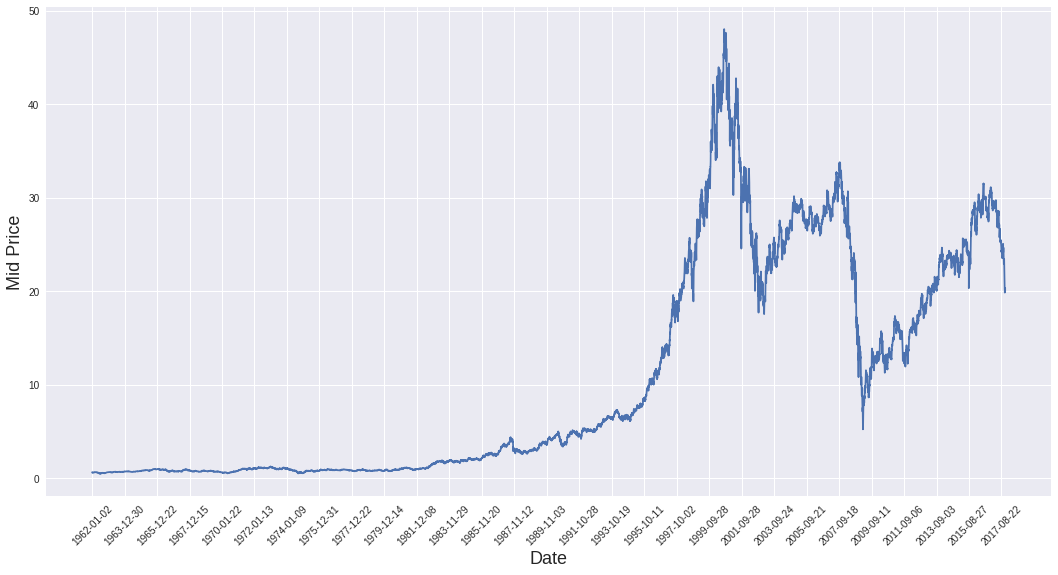

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Step 2 - Data preprocessing 

In [0]:
df['mid'] = (df['Low']+df['High'])/2.0

In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "mid"

In [0]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [0]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [0]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [0]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0.62815,0.61615,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0.61615,0.61190,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0.61190,0.59600,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0.59600,0.58365,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0.58365,0.59575,1


In [0]:
df.tail()

,Date,Open,High,Low,Close,Volume,mid,future,target
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,20.3050,20.1850,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,20.1850,20.1950,1
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,20.1950,19.9605,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,19.9605,20.2900,1
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,20.2900,NaN,0


In [0]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [0]:
from collections import deque
import numpy as np
import random

In [0]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)# don't need this anymore.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_df.head()

,mid,target
0,0.62815,0
1,0.61615,0
2,0.61190,0
3,0.59600,0
4,0.58365,1


In [0]:
train_data = train_df[RATIO_TO_PREDICT].as_matrix()
valid_data = validation_df[RATIO_TO_PREDICT].as_matrix()
test_data = test_df[RATIO_TO_PREDICT].as_matrix()

In [0]:
train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [0]:
scaler = MinMaxScaler()

In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data and validation data
valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [0]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [0]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
y_train.shape

(11187,)

In [0]:
y_valid.shape

(1346,)

In [0]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

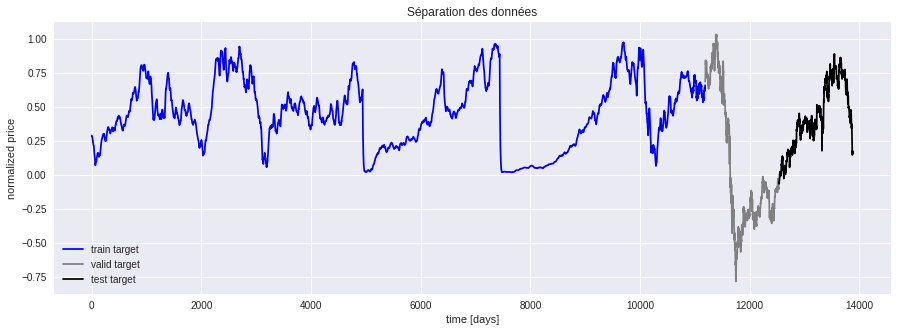

In [0]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Séparation des données')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [0]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [0]:
EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

# Step 3 - Build our model (The Transformer)

## I have 2 videos on how a transformer works

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/0n95f-eqZdw/0.jpg)](https://www.youtube.com/watch?v=0n95f-eqZdw)

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/bDxFvr1gpSU/0.jpg)](https://www.youtube.com/watch?v=bDxFvr1gpSU)

![alt text](https://cdn-images-1.medium.com/max/1600/1*BHzGVskWGS_3jEcYYi6miQ.png)


In [0]:
!pip install -q tensorflow==2.0.0-alpha0

In [0]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [0]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [0]:
multi_head = build_model()

In [0]:
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 60, 256)      133120      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 60, 128)      164352      bidirectional_4[0][0]            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 60, 192)      24576       bidirectional_5[0][0]            
______________________________________________________________________________________________

In [0]:
multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

Train on 11187 samples, validate on 1346 samples
Epoch 1/10
11187/11187 [==============================] - 75s 7ms/sample - loss: 0.0831 - val_loss: 0.0789
Epoch 2/10
11187/11187 [==============================] - 71s 6ms/sample - loss: 0.0105 - val_loss: 0.0746
Epoch 3/10
11187/11187 [==============================] - 72s 6ms/sample - loss: 0.0060 - val_loss: 0.0775
Epoch 4/10
11187/11187 [==============================] - 71s 6ms/sample - loss: 0.0047 - val_loss: 0.0853
Epoch 5/10
11187/11187 [==============================] - 71s 6ms/sample - loss: 0.0041 - val_loss: 0.0944
Epoch 6/10
11187/11187 [==============================] - 71s 6ms/sample - loss: 0.0039 - val_loss: 0.1007
Epoch 7/10
11187/11187 [==============================] - 72s 6ms/sample - loss: 0.0042 - val_loss: 0.1052
Epoch 8/10
11187/11187 [==============================] - 71s 6ms/sample - loss: 0.0029 - val_loss: 0.1120
Epoch 9/10
11187/11187 [==============================] - 71s 6ms/sample - loss: 0.0031 - val_l

In [0]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


predicted_stock_price_multi_head.shape

(1345, 1)

In [0]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

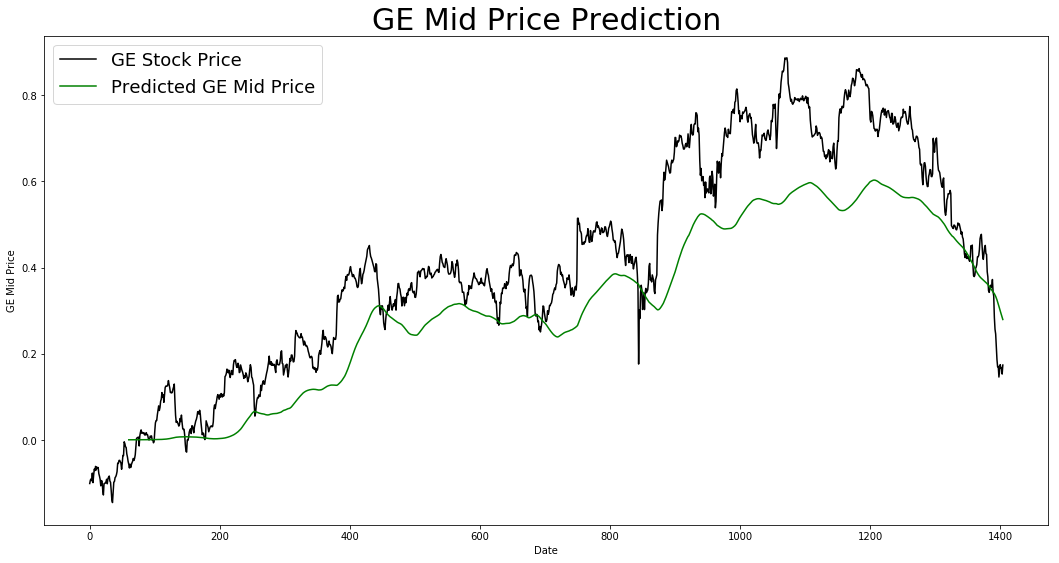

In [0]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()